In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")
height_df = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/player_heights.csv")

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
testing_data['description'].unique()

array(['hit_into_play', 'ball', 'foul_bunt', 'blocked_ball',
       'swinging_strike', 'foul', 'called_strike', 'foul_tip',
       'hit_by_pitch', 'swinging_strike_blocked', 'missed_bunt',
       'pitchout', 'bunt_foul_tip', 'unknown_strike'], dtype=object)

In [5]:

def preprocess_data(df, height_df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    # Define a function to condense pitch types
    def condense_pitch_type(pitch_type):
        if pitch_type == "FF":
            return "FF"
        elif pitch_type == "FT":
            return "SI"
        elif pitch_type == "FC":
            return "CT"
        elif pitch_type in ["SL", "ST", "SV"]:
            return "SL"
        elif pitch_type in ["CH", "FS"]:
            return "CH"
        elif pitch_type in ["CU", "KC", "CS"]:
            return "CB"
        elif pitch_type == "SI":
            return "SI"
        elif pitch_type == "KN":
            return "KN"
        else:
            return "FAHCK"
    # Define a function to determine if the pitch resulted in contact
    def is_contact(description):
        return 1 if description in ["foul_tip", "foul_bunt", "foul", 
                                "foul_pitchout", "hit_into_play", 
                                "hit_into_play_no_out", "hit_into_play_score", 
                                "pitchout_hit_into_play_score", 'hit_into_play'] else 0 
    def create_pitch_id(df):
        df['pitch_id_raw'] = (df['game_pk'].astype(str) + "_" +
                          df['batter'].astype(str) + "_" +
                          df['pitcher'].astype(str) + "_" +
                          df['pitch_number'].astype(str) + "_" +
                          df['at_bat_number'].astype(str) + "_" +
                          df['inning'].astype(str))
        return df

    def calculate_pitcher_stats(df):
        # Group by pitcher and pitch type
        grouped = df.groupby(['pitcher', 'pitch_type_condensed'])

        # Calculate mean for pfx_x, pfx_z, and velocity
        mean_values = grouped[['pfx_x', 'pfx_z', 'release_speed']].mean()
        mean_values = mean_values.rename(columns={'pfx_x': 'pfx_x_avg',
                                                  'pfx_z': 'pfx_z_avg',
                                                  'release_speed': 'avg_velo'})

        # Calculate max for pfx_x and pfx_z
        max_values = grouped[['pfx_x', 'pfx_z', 'release_speed']].max()
        max_values = max_values.rename(columns={'pfx_x': 'pfx_x_max',
                                                'pfx_z': 'pfx_z_max',
                                                'release_speed': 'max_velo'})

        # Combine mean and max values
        combined_stats = pd.concat([mean_values, max_values], axis=1)

        return combined_stats.reset_index()

    df['pitch_type_condensed'] = df['pitch_type'].apply(condense_pitch_type)

    # Call the new function and store the result
    pitcher_stats = calculate_pitcher_stats(df)

    df = df.merge(pitcher_stats, how='left', on=['pitcher', 'pitch_type_condensed'])

    # Calculate 'release_pos_y'
    df['release_pos_y'] = 60.5 - df['release_extension']


    df['contact'] = df['description'].apply(is_contact)

    # Create 'pitch_id_raw'
    df = create_pitch_id(df)

    dfs = df.merge(height_df[['id', 'height_numeric']], how='left', left_on='pitcher', right_on='id')
    # Return the preprocessed DataFrame
    return dfs

In [6]:
# Apply the function to the 'pitch_type' column
data_processed = preprocess_data(data, height_df)# Use the query method to filter rows where 'swing' is 1 and 'pitch_type_condensed' is 'FF', 'SI', or 'CT'
training_data = data_processed.query('contact == 1')
testing_data_processed = preprocess_data(testing_data, height_df)


In [7]:
breaking_ball = training_data.query('pitch_type_condensed in ("SL", "CB")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("SL", "CB")')


# Fastball Model First

In [8]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']]
testing_identifiers = breaking_ball[['pitch_id_raw']]
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [9]:
train_data = training_features.drop(['fb'], axis=1).copy()
train_label = training_features['fb'].copy()
testing_data = testing_features.drop(['fb'], axis=1).copy()
testing_label = testing_features['fb'].copy()

In [10]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [11]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [12]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [13]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [14]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.5340652543683315
Log Loss: 0.6768003369576615


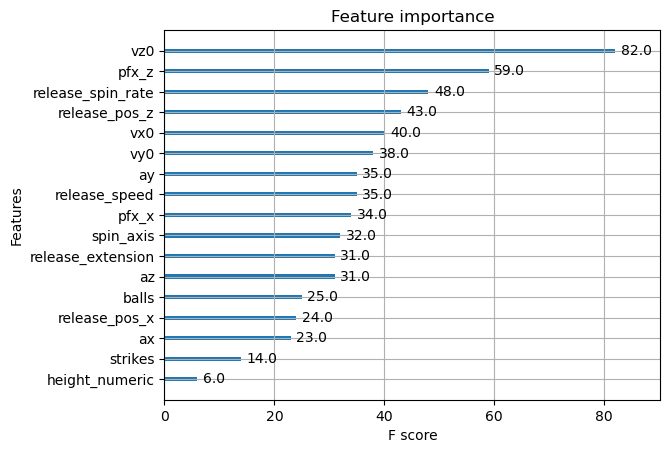

In [15]:
xgb.plot_importance(model)
plt.show()

In [16]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Flyball', 'Flyball'], yticklabels=['Not Flyball', 'Flyball'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [17]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [18]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-12 12:51:39,289] A new study created in memory with name: no-name-876cff99-c739-4574-8587-ba2a43a00a15


[0]	eval-logloss:0.68846
[1]	eval-logloss:0.68530
[2]	eval-logloss:0.68317
[3]	eval-logloss:0.68122
[4]	eval-logloss:0.67983
[5]	eval-logloss:0.67844
[6]	eval-logloss:0.67745
[7]	eval-logloss:0.67641
[8]	eval-logloss:0.67416
[9]	eval-logloss:0.67272
[10]	eval-logloss:0.67155
[11]	eval-logloss:0.67100
[12]	eval-logloss:0.67016
[13]	eval-logloss:0.67033
[14]	eval-logloss:0.67011
[15]	eval-logloss:0.66976
[16]	eval-logloss:0.66887
[17]	eval-logloss:0.66838
[18]	eval-logloss:0.66753
[19]	eval-logloss:0.66737
[20]	eval-logloss:0.66615
[21]	eval-logloss:0.66593
[22]	eval-logloss:0.66562
[23]	eval-logloss:0.66572
[24]	eval-logloss:0.66535
[25]	eval-logloss:0.66517
[26]	eval-logloss:0.66408
[27]	eval-logloss:0.66311
[28]	eval-logloss:0.66341
[29]	eval-logloss:0.66349
[30]	eval-logloss:0.66305
[31]	eval-logloss:0.66270
[32]	eval-logloss:0.66127
[33]	eval-logloss:0.66111
[34]	eval-logloss:0.66023
[35]	eval-logloss:0.65930
[36]	eval-logloss:0.65876
[37]	eval-logloss:0.65835
[38]	eval-logloss:0.65

[I 2023-11-12 12:51:51,585] Trial 0 finished with value: 0.6354582764062521 and parameters: {'max_depth': 6, 'eta': 0.161075954577435, 'subsample': 0.6583610539291778, 'colsample_bytree': 0.9333169150974029}. Best is trial 0 with value: 0.6354582764062521.


[0]	eval-logloss:0.68351
[1]	eval-logloss:0.67401
[2]	eval-logloss:0.67007
[3]	eval-logloss:0.66373
[4]	eval-logloss:0.65975
[5]	eval-logloss:0.65664
[6]	eval-logloss:0.65277
[7]	eval-logloss:0.65006
[8]	eval-logloss:0.64632
[9]	eval-logloss:0.64465
[10]	eval-logloss:0.64149
[11]	eval-logloss:0.63951
[12]	eval-logloss:0.63871
[13]	eval-logloss:0.63790
[14]	eval-logloss:0.63561
[15]	eval-logloss:0.63465
[16]	eval-logloss:0.63171
[17]	eval-logloss:0.62966
[18]	eval-logloss:0.62909
[19]	eval-logloss:0.62845
[20]	eval-logloss:0.62791
[21]	eval-logloss:0.62566
[22]	eval-logloss:0.62564
[23]	eval-logloss:0.62281
[24]	eval-logloss:0.62173
[25]	eval-logloss:0.62045
[26]	eval-logloss:0.61771
[27]	eval-logloss:0.61495
[28]	eval-logloss:0.61405
[29]	eval-logloss:0.61254
[30]	eval-logloss:0.61195
[31]	eval-logloss:0.61229
[32]	eval-logloss:0.61048
[33]	eval-logloss:0.60887
[34]	eval-logloss:0.60767
[35]	eval-logloss:0.60520
[36]	eval-logloss:0.60463
[37]	eval-logloss:0.60418
[38]	eval-logloss:0.60

[I 2023-11-12 12:52:02,018] Trial 1 finished with value: 0.5371206846191884 and parameters: {'max_depth': 9, 'eta': 0.24530863045103796, 'subsample': 0.6899581630067013, 'colsample_bytree': 0.6279665343946359}. Best is trial 1 with value: 0.5371206846191884.


[0]	eval-logloss:0.68542
[1]	eval-logloss:0.67816
[2]	eval-logloss:0.67351
[3]	eval-logloss:0.66976
[4]	eval-logloss:0.66674
[5]	eval-logloss:0.66477
[6]	eval-logloss:0.66216
[7]	eval-logloss:0.66040
[8]	eval-logloss:0.65863
[9]	eval-logloss:0.65668
[10]	eval-logloss:0.65471
[11]	eval-logloss:0.65272
[12]	eval-logloss:0.65214
[13]	eval-logloss:0.65104
[14]	eval-logloss:0.64887
[15]	eval-logloss:0.64729
[16]	eval-logloss:0.64503
[17]	eval-logloss:0.64350
[18]	eval-logloss:0.64173
[19]	eval-logloss:0.63952
[20]	eval-logloss:0.63788
[21]	eval-logloss:0.63636
[22]	eval-logloss:0.63548
[23]	eval-logloss:0.63453
[24]	eval-logloss:0.63357
[25]	eval-logloss:0.63291
[26]	eval-logloss:0.63107
[27]	eval-logloss:0.62953
[28]	eval-logloss:0.62837
[29]	eval-logloss:0.62678
[30]	eval-logloss:0.62537
[31]	eval-logloss:0.62471
[32]	eval-logloss:0.62378
[33]	eval-logloss:0.62305
[34]	eval-logloss:0.62100
[35]	eval-logloss:0.61918
[36]	eval-logloss:0.61853
[37]	eval-logloss:0.61727
[38]	eval-logloss:0.61

[I 2023-11-12 12:52:11,468] Trial 2 finished with value: 0.5582565900170132 and parameters: {'max_depth': 8, 'eta': 0.24814864110455, 'subsample': 0.8912602474397622, 'colsample_bytree': 0.8438875772637046}. Best is trial 1 with value: 0.5371206846191884.


[0]	eval-logloss:0.69225
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69058
[3]	eval-logloss:0.68981
[4]	eval-logloss:0.68905
[5]	eval-logloss:0.68830
[6]	eval-logloss:0.68754
[7]	eval-logloss:0.68696
[8]	eval-logloss:0.68619
[9]	eval-logloss:0.68544
[10]	eval-logloss:0.68478
[11]	eval-logloss:0.68433
[12]	eval-logloss:0.68380
[13]	eval-logloss:0.68340
[14]	eval-logloss:0.68290
[15]	eval-logloss:0.68250
[16]	eval-logloss:0.68198
[17]	eval-logloss:0.68147
[18]	eval-logloss:0.68113
[19]	eval-logloss:0.68077
[20]	eval-logloss:0.68032
[21]	eval-logloss:0.68000
[22]	eval-logloss:0.67967
[23]	eval-logloss:0.67927
[24]	eval-logloss:0.67904
[25]	eval-logloss:0.67884
[26]	eval-logloss:0.67848
[27]	eval-logloss:0.67814
[28]	eval-logloss:0.67787
[29]	eval-logloss:0.67760
[30]	eval-logloss:0.67719
[31]	eval-logloss:0.67694
[32]	eval-logloss:0.67661
[33]	eval-logloss:0.67633
[34]	eval-logloss:0.67610
[35]	eval-logloss:0.67573
[36]	eval-logloss:0.67543
[37]	eval-logloss:0.67511
[38]	eval-logloss:0.67

[I 2023-11-12 12:52:18,919] Trial 3 finished with value: 0.6639662835705772 and parameters: {'max_depth': 6, 'eta': 0.03468758940185581, 'subsample': 0.8110826583787856, 'colsample_bytree': 0.8861608193158317}. Best is trial 1 with value: 0.5371206846191884.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69197
[2]	eval-logloss:0.69145
[3]	eval-logloss:0.69087
[4]	eval-logloss:0.69029
[5]	eval-logloss:0.68986
[6]	eval-logloss:0.68939
[7]	eval-logloss:0.68898
[8]	eval-logloss:0.68855
[9]	eval-logloss:0.68805
[10]	eval-logloss:0.68765
[11]	eval-logloss:0.68733
[12]	eval-logloss:0.68699
[13]	eval-logloss:0.68672
[14]	eval-logloss:0.68638
[15]	eval-logloss:0.68612
[16]	eval-logloss:0.68583
[17]	eval-logloss:0.68543
[18]	eval-logloss:0.68523
[19]	eval-logloss:0.68494
[20]	eval-logloss:0.68470
[21]	eval-logloss:0.68451
[22]	eval-logloss:0.68432
[23]	eval-logloss:0.68411
[24]	eval-logloss:0.68392
[25]	eval-logloss:0.68374
[26]	eval-logloss:0.68351
[27]	eval-logloss:0.68324
[28]	eval-logloss:0.68308
[29]	eval-logloss:0.68292
[30]	eval-logloss:0.68266
[31]	eval-logloss:0.68249
[32]	eval-logloss:0.68237
[33]	eval-logloss:0.68225
[34]	eval-logloss:0.68210
[35]	eval-logloss:0.68197
[36]	eval-logloss:0.68181
[37]	eval-logloss:0.68163
[38]	eval-logloss:0.68

[I 2023-11-12 12:52:24,581] Trial 4 finished with value: 0.6762145874953952 and parameters: {'max_depth': 4, 'eta': 0.032934376999385825, 'subsample': 0.8939768712990144, 'colsample_bytree': 0.8691024670085048}. Best is trial 1 with value: 0.5371206846191884.


[0]	eval-logloss:0.68959
[1]	eval-logloss:0.68593
[2]	eval-logloss:0.68547
[3]	eval-logloss:0.68390
[4]	eval-logloss:0.68315
[5]	eval-logloss:0.68289
[6]	eval-logloss:0.68224
[7]	eval-logloss:0.68159
[8]	eval-logloss:0.67876
[9]	eval-logloss:0.67785
[10]	eval-logloss:0.67688
[11]	eval-logloss:0.67754
[12]	eval-logloss:0.67697
[13]	eval-logloss:0.67728
[14]	eval-logloss:0.67722
[15]	eval-logloss:0.67727
[16]	eval-logloss:0.67597
[17]	eval-logloss:0.67501
[18]	eval-logloss:0.67513
[19]	eval-logloss:0.67534
[20]	eval-logloss:0.67391
[21]	eval-logloss:0.67389
[22]	eval-logloss:0.67453
[23]	eval-logloss:0.67536
[24]	eval-logloss:0.67588
[25]	eval-logloss:0.67566
[26]	eval-logloss:0.67388
[27]	eval-logloss:0.67251
[28]	eval-logloss:0.67355
[29]	eval-logloss:0.67385
[30]	eval-logloss:0.67320
[31]	eval-logloss:0.67351
[32]	eval-logloss:0.67091
[33]	eval-logloss:0.67128
[34]	eval-logloss:0.67108
[35]	eval-logloss:0.67029
[36]	eval-logloss:0.67016
[37]	eval-logloss:0.66989
[38]	eval-logloss:0.67

[I 2023-11-12 12:52:30,176] Trial 5 finished with value: 0.6612387238913364 and parameters: {'max_depth': 4, 'eta': 0.2945217580568847, 'subsample': 0.657946154003045, 'colsample_bytree': 0.6258346510514317}. Best is trial 1 with value: 0.5371206846191884.


[0]	eval-logloss:0.68372
[1]	eval-logloss:0.67528
[2]	eval-logloss:0.66999
[3]	eval-logloss:0.66488
[4]	eval-logloss:0.66130
[5]	eval-logloss:0.65831
[6]	eval-logloss:0.65509
[7]	eval-logloss:0.65293
[8]	eval-logloss:0.65070
[9]	eval-logloss:0.64724
[10]	eval-logloss:0.64420
[11]	eval-logloss:0.64312
[12]	eval-logloss:0.64087
[13]	eval-logloss:0.63946
[14]	eval-logloss:0.63708
[15]	eval-logloss:0.63528
[16]	eval-logloss:0.63278
[17]	eval-logloss:0.63201
[18]	eval-logloss:0.63069
[19]	eval-logloss:0.62960
[20]	eval-logloss:0.62719
[21]	eval-logloss:0.62539
[22]	eval-logloss:0.62307
[23]	eval-logloss:0.62148
[24]	eval-logloss:0.62022
[25]	eval-logloss:0.61923
[26]	eval-logloss:0.61732
[27]	eval-logloss:0.61553
[28]	eval-logloss:0.61498
[29]	eval-logloss:0.61267
[30]	eval-logloss:0.61114
[31]	eval-logloss:0.61060
[32]	eval-logloss:0.60928
[33]	eval-logloss:0.60750
[34]	eval-logloss:0.60580
[35]	eval-logloss:0.60534
[36]	eval-logloss:0.60443
[37]	eval-logloss:0.60393
[38]	eval-logloss:0.60

[I 2023-11-12 12:52:41,279] Trial 6 finished with value: 0.539577883413773 and parameters: {'max_depth': 9, 'eta': 0.2065312514387574, 'subsample': 0.7079816384618836, 'colsample_bytree': 0.7293639399920744}. Best is trial 1 with value: 0.5371206846191884.


[0]	eval-logloss:0.68971
[1]	eval-logloss:0.68722
[2]	eval-logloss:0.68596
[3]	eval-logloss:0.68456
[4]	eval-logloss:0.68362
[5]	eval-logloss:0.68318
[6]	eval-logloss:0.68230
[7]	eval-logloss:0.68192
[8]	eval-logloss:0.68030
[9]	eval-logloss:0.67933
[10]	eval-logloss:0.67855
[11]	eval-logloss:0.67818
[12]	eval-logloss:0.67788
[13]	eval-logloss:0.67822
[14]	eval-logloss:0.67805
[15]	eval-logloss:0.67796
[16]	eval-logloss:0.67741
[17]	eval-logloss:0.67685
[18]	eval-logloss:0.67712
[19]	eval-logloss:0.67669
[20]	eval-logloss:0.67560
[21]	eval-logloss:0.67553
[22]	eval-logloss:0.67549
[23]	eval-logloss:0.67530
[24]	eval-logloss:0.67573
[25]	eval-logloss:0.67570
[26]	eval-logloss:0.67482
[27]	eval-logloss:0.67394
[28]	eval-logloss:0.67429
[29]	eval-logloss:0.67381
[30]	eval-logloss:0.67288
[31]	eval-logloss:0.67323
[32]	eval-logloss:0.67230
[33]	eval-logloss:0.67203
[34]	eval-logloss:0.67166
[35]	eval-logloss:0.67109
[36]	eval-logloss:0.67094
[37]	eval-logloss:0.67092
[38]	eval-logloss:0.67

[I 2023-11-12 12:52:46,898] Trial 7 finished with value: 0.6629520515733044 and parameters: {'max_depth': 4, 'eta': 0.19462756261204944, 'subsample': 0.7224880969833286, 'colsample_bytree': 0.7842208499380605}. Best is trial 1 with value: 0.5371206846191884.


[0]	eval-logloss:0.69169
[1]	eval-logloss:0.68990
[2]	eval-logloss:0.68880
[3]	eval-logloss:0.68789
[4]	eval-logloss:0.68692
[5]	eval-logloss:0.68619
[6]	eval-logloss:0.68531
[7]	eval-logloss:0.68490
[8]	eval-logloss:0.68381
[9]	eval-logloss:0.68302
[10]	eval-logloss:0.68248
[11]	eval-logloss:0.68199
[12]	eval-logloss:0.68154
[13]	eval-logloss:0.68128
[14]	eval-logloss:0.68103
[15]	eval-logloss:0.68070
[16]	eval-logloss:0.68031
[17]	eval-logloss:0.67981
[18]	eval-logloss:0.67969
[19]	eval-logloss:0.67934
[20]	eval-logloss:0.67891
[21]	eval-logloss:0.67876
[22]	eval-logloss:0.67865
[23]	eval-logloss:0.67832
[24]	eval-logloss:0.67858
[25]	eval-logloss:0.67882
[26]	eval-logloss:0.67836
[27]	eval-logloss:0.67803
[28]	eval-logloss:0.67785
[29]	eval-logloss:0.67768
[30]	eval-logloss:0.67713
[31]	eval-logloss:0.67710
[32]	eval-logloss:0.67677
[33]	eval-logloss:0.67649
[34]	eval-logloss:0.67638
[35]	eval-logloss:0.67612
[36]	eval-logloss:0.67594
[37]	eval-logloss:0.67561
[38]	eval-logloss:0.67

[I 2023-11-12 12:52:52,763] Trial 8 finished with value: 0.6690083854960576 and parameters: {'max_depth': 4, 'eta': 0.10210219358407596, 'subsample': 0.7785352212018075, 'colsample_bytree': 0.6755300411317959}. Best is trial 1 with value: 0.5371206846191884.


[0]	eval-logloss:0.69082
[1]	eval-logloss:0.68766
[2]	eval-logloss:0.68595
[3]	eval-logloss:0.68467
[4]	eval-logloss:0.68349
[5]	eval-logloss:0.68292
[6]	eval-logloss:0.68248
[7]	eval-logloss:0.68219
[8]	eval-logloss:0.68137
[9]	eval-logloss:0.68018
[10]	eval-logloss:0.67958
[11]	eval-logloss:0.67936
[12]	eval-logloss:0.67942
[13]	eval-logloss:0.67989
[14]	eval-logloss:0.67966
[15]	eval-logloss:0.67962
[16]	eval-logloss:0.67920
[17]	eval-logloss:0.67803
[18]	eval-logloss:0.67838
[19]	eval-logloss:0.67823
[20]	eval-logloss:0.67795
[21]	eval-logloss:0.67821
[22]	eval-logloss:0.67825
[23]	eval-logloss:0.67787
[24]	eval-logloss:0.67799
[25]	eval-logloss:0.67841
[26]	eval-logloss:0.67811
[27]	eval-logloss:0.67734
[28]	eval-logloss:0.67700
[29]	eval-logloss:0.67712
[30]	eval-logloss:0.67627
[31]	eval-logloss:0.67606
[32]	eval-logloss:0.67637
[33]	eval-logloss:0.67654
[34]	eval-logloss:0.67655
[35]	eval-logloss:0.67652
[36]	eval-logloss:0.67643
[37]	eval-logloss:0.67585
[38]	eval-logloss:0.67

[I 2023-11-12 12:52:57,747] Trial 9 finished with value: 0.6696485266030692 and parameters: {'max_depth': 3, 'eta': 0.2793988998006024, 'subsample': 0.8760676083802459, 'colsample_bytree': 0.690853844861315}. Best is trial 1 with value: 0.5371206846191884.


[0]	eval-logloss:0.68662
[1]	eval-logloss:0.67953
[2]	eval-logloss:0.67582
[3]	eval-logloss:0.67213
[4]	eval-logloss:0.66800
[5]	eval-logloss:0.66534
[6]	eval-logloss:0.66273
[7]	eval-logloss:0.66188
[8]	eval-logloss:0.65901
[9]	eval-logloss:0.65700
[10]	eval-logloss:0.65446
[11]	eval-logloss:0.65421
[12]	eval-logloss:0.65193
[13]	eval-logloss:0.65277
[14]	eval-logloss:0.65116
[15]	eval-logloss:0.65015
[16]	eval-logloss:0.64785
[17]	eval-logloss:0.64652
[18]	eval-logloss:0.64624
[19]	eval-logloss:0.64654
[20]	eval-logloss:0.64522
[21]	eval-logloss:0.64365
[22]	eval-logloss:0.64319
[23]	eval-logloss:0.64256
[24]	eval-logloss:0.64204
[25]	eval-logloss:0.63999
[26]	eval-logloss:0.63816
[27]	eval-logloss:0.63701
[28]	eval-logloss:0.63666
[29]	eval-logloss:0.63710
[30]	eval-logloss:0.63608
[31]	eval-logloss:0.63517
[32]	eval-logloss:0.63248
[33]	eval-logloss:0.63301
[34]	eval-logloss:0.63054
[35]	eval-logloss:0.62934
[36]	eval-logloss:0.62858
[37]	eval-logloss:0.62839
[38]	eval-logloss:0.62

[I 2023-11-12 12:53:06,400] Trial 10 finished with value: 0.576580325494778 and parameters: {'max_depth': 8, 'eta': 0.2398670887294811, 'subsample': 0.6111489902838029, 'colsample_bytree': 0.5534326075862018}. Best is trial 1 with value: 0.5371206846191884.


[0]	eval-logloss:0.68498
[1]	eval-logloss:0.67875
[2]	eval-logloss:0.67447
[3]	eval-logloss:0.66821
[4]	eval-logloss:0.66457
[5]	eval-logloss:0.66059
[6]	eval-logloss:0.65558
[7]	eval-logloss:0.65327
[8]	eval-logloss:0.65034
[9]	eval-logloss:0.64795
[10]	eval-logloss:0.64524
[11]	eval-logloss:0.64376
[12]	eval-logloss:0.64198
[13]	eval-logloss:0.64199
[14]	eval-logloss:0.64190
[15]	eval-logloss:0.64003
[16]	eval-logloss:0.63696
[17]	eval-logloss:0.63423
[18]	eval-logloss:0.63273
[19]	eval-logloss:0.63134
[20]	eval-logloss:0.62920
[21]	eval-logloss:0.62783
[22]	eval-logloss:0.62706
[23]	eval-logloss:0.62630
[24]	eval-logloss:0.62506
[25]	eval-logloss:0.62416
[26]	eval-logloss:0.62216
[27]	eval-logloss:0.61983
[28]	eval-logloss:0.61903
[29]	eval-logloss:0.61838
[30]	eval-logloss:0.61623
[31]	eval-logloss:0.61505
[32]	eval-logloss:0.61278
[33]	eval-logloss:0.61165
[34]	eval-logloss:0.61082
[35]	eval-logloss:0.60884
[36]	eval-logloss:0.60710
[37]	eval-logloss:0.60588
[38]	eval-logloss:0.60

[I 2023-11-12 12:53:15,764] Trial 11 finished with value: 0.5429436098911373 and parameters: {'max_depth': 9, 'eta': 0.20928984314346918, 'subsample': 0.723347307886927, 'colsample_bytree': 0.5067894442487442}. Best is trial 1 with value: 0.5371206846191884.


[0]	eval-logloss:0.68469
[1]	eval-logloss:0.67715
[2]	eval-logloss:0.67175
[3]	eval-logloss:0.66740
[4]	eval-logloss:0.66389
[5]	eval-logloss:0.66109
[6]	eval-logloss:0.65855
[7]	eval-logloss:0.65585
[8]	eval-logloss:0.65254
[9]	eval-logloss:0.64971
[10]	eval-logloss:0.64660
[11]	eval-logloss:0.64533
[12]	eval-logloss:0.64375
[13]	eval-logloss:0.64261
[14]	eval-logloss:0.64046
[15]	eval-logloss:0.63935
[16]	eval-logloss:0.63584
[17]	eval-logloss:0.63423
[18]	eval-logloss:0.63295
[19]	eval-logloss:0.63238
[20]	eval-logloss:0.62998
[21]	eval-logloss:0.62918
[22]	eval-logloss:0.62837
[23]	eval-logloss:0.62661
[24]	eval-logloss:0.62566
[25]	eval-logloss:0.62421
[26]	eval-logloss:0.62275
[27]	eval-logloss:0.62060
[28]	eval-logloss:0.62069
[29]	eval-logloss:0.61906
[30]	eval-logloss:0.61662
[31]	eval-logloss:0.61589
[32]	eval-logloss:0.61518
[33]	eval-logloss:0.61356
[34]	eval-logloss:0.61242
[35]	eval-logloss:0.61049
[36]	eval-logloss:0.60815
[37]	eval-logloss:0.60665
[38]	eval-logloss:0.60

[I 2023-11-12 12:53:25,268] Trial 12 finished with value: 0.5459219838497512 and parameters: {'max_depth': 9, 'eta': 0.18813727654486337, 'subsample': 0.6965222192996509, 'colsample_bytree': 0.7680905739782997}. Best is trial 1 with value: 0.5371206846191884.


[0]	eval-logloss:0.68775
[1]	eval-logloss:0.68222
[2]	eval-logloss:0.67995
[3]	eval-logloss:0.67715
[4]	eval-logloss:0.67488
[5]	eval-logloss:0.67277
[6]	eval-logloss:0.67085
[7]	eval-logloss:0.66975
[8]	eval-logloss:0.66793
[9]	eval-logloss:0.66626
[10]	eval-logloss:0.66453
[11]	eval-logloss:0.66401
[12]	eval-logloss:0.66388
[13]	eval-logloss:0.66417
[14]	eval-logloss:0.66265
[15]	eval-logloss:0.66053
[16]	eval-logloss:0.65887
[17]	eval-logloss:0.65772
[18]	eval-logloss:0.65744
[19]	eval-logloss:0.65596
[20]	eval-logloss:0.65524
[21]	eval-logloss:0.65478
[22]	eval-logloss:0.65415
[23]	eval-logloss:0.65324
[24]	eval-logloss:0.65347
[25]	eval-logloss:0.65309
[26]	eval-logloss:0.65123
[27]	eval-logloss:0.64995
[28]	eval-logloss:0.64960
[29]	eval-logloss:0.64887
[30]	eval-logloss:0.64775
[31]	eval-logloss:0.64773
[32]	eval-logloss:0.64679
[33]	eval-logloss:0.64610
[34]	eval-logloss:0.64488
[35]	eval-logloss:0.64380
[36]	eval-logloss:0.64300
[37]	eval-logloss:0.64165
[38]	eval-logloss:0.64

[I 2023-11-12 12:53:32,750] Trial 13 finished with value: 0.6028725914500398 and parameters: {'max_depth': 7, 'eta': 0.22782363288623586, 'subsample': 0.7681548523196428, 'colsample_bytree': 0.6100331187552887}. Best is trial 1 with value: 0.5371206846191884.


[0]	eval-logloss:0.68580
[1]	eval-logloss:0.67872
[2]	eval-logloss:0.67397
[3]	eval-logloss:0.66988
[4]	eval-logloss:0.66707
[5]	eval-logloss:0.66471
[6]	eval-logloss:0.66156
[7]	eval-logloss:0.65996
[8]	eval-logloss:0.65780
[9]	eval-logloss:0.65592
[10]	eval-logloss:0.65320
[11]	eval-logloss:0.65164
[12]	eval-logloss:0.65058
[13]	eval-logloss:0.65014
[14]	eval-logloss:0.64948
[15]	eval-logloss:0.64954
[16]	eval-logloss:0.64704
[17]	eval-logloss:0.64466
[18]	eval-logloss:0.64352
[19]	eval-logloss:0.64230
[20]	eval-logloss:0.63927
[21]	eval-logloss:0.63849
[22]	eval-logloss:0.63687
[23]	eval-logloss:0.63716
[24]	eval-logloss:0.63634
[25]	eval-logloss:0.63532
[26]	eval-logloss:0.63338
[27]	eval-logloss:0.62978
[28]	eval-logloss:0.63043
[29]	eval-logloss:0.62932
[30]	eval-logloss:0.62815
[31]	eval-logloss:0.62759
[32]	eval-logloss:0.62553
[33]	eval-logloss:0.62477
[34]	eval-logloss:0.62298
[35]	eval-logloss:0.62091
[36]	eval-logloss:0.61997
[37]	eval-logloss:0.61901
[38]	eval-logloss:0.61

[I 2023-11-12 12:53:41,307] Trial 14 finished with value: 0.5664241270309565 and parameters: {'max_depth': 8, 'eta': 0.2666428129119438, 'subsample': 0.6780750013409345, 'colsample_bytree': 0.7119364074012091}. Best is trial 1 with value: 0.5371206846191884.


[0]	eval-logloss:0.68527
[1]	eval-logloss:0.67893
[2]	eval-logloss:0.67280
[3]	eval-logloss:0.66865
[4]	eval-logloss:0.66531
[5]	eval-logloss:0.66149
[6]	eval-logloss:0.65821
[7]	eval-logloss:0.65465
[8]	eval-logloss:0.65145
[9]	eval-logloss:0.64863
[10]	eval-logloss:0.64612
[11]	eval-logloss:0.64429
[12]	eval-logloss:0.64276
[13]	eval-logloss:0.64313
[14]	eval-logloss:0.64141
[15]	eval-logloss:0.64007
[16]	eval-logloss:0.63913
[17]	eval-logloss:0.63769
[18]	eval-logloss:0.63588
[19]	eval-logloss:0.63604
[20]	eval-logloss:0.63547
[21]	eval-logloss:0.63521
[22]	eval-logloss:0.63483
[23]	eval-logloss:0.63391
[24]	eval-logloss:0.63307
[25]	eval-logloss:0.63153
[26]	eval-logloss:0.62978
[27]	eval-logloss:0.62767
[28]	eval-logloss:0.62652
[29]	eval-logloss:0.62562
[30]	eval-logloss:0.62414
[31]	eval-logloss:0.62387
[32]	eval-logloss:0.62194
[33]	eval-logloss:0.62201
[34]	eval-logloss:0.62033
[35]	eval-logloss:0.61921
[36]	eval-logloss:0.61815
[37]	eval-logloss:0.61715
[38]	eval-logloss:0.61

[I 2023-11-12 12:53:50,919] Trial 15 finished with value: 0.5582946446470403 and parameters: {'max_depth': 9, 'eta': 0.1492943163353141, 'subsample': 0.6186516574537297, 'colsample_bytree': 0.9985343040452952}. Best is trial 1 with value: 0.5371206846191884.


[0]	eval-logloss:0.68515
[1]	eval-logloss:0.68010
[2]	eval-logloss:0.67717
[3]	eval-logloss:0.67416
[4]	eval-logloss:0.67284
[5]	eval-logloss:0.67136
[6]	eval-logloss:0.66956
[7]	eval-logloss:0.66860
[8]	eval-logloss:0.66593
[9]	eval-logloss:0.66391
[10]	eval-logloss:0.66274
[11]	eval-logloss:0.66255
[12]	eval-logloss:0.66168
[13]	eval-logloss:0.66119
[14]	eval-logloss:0.66029
[15]	eval-logloss:0.65896
[16]	eval-logloss:0.65766
[17]	eval-logloss:0.65633
[18]	eval-logloss:0.65663
[19]	eval-logloss:0.65530
[20]	eval-logloss:0.65298
[21]	eval-logloss:0.65317
[22]	eval-logloss:0.65283
[23]	eval-logloss:0.65167
[24]	eval-logloss:0.65078
[25]	eval-logloss:0.65048
[26]	eval-logloss:0.64846
[27]	eval-logloss:0.64706
[28]	eval-logloss:0.64599
[29]	eval-logloss:0.64485
[30]	eval-logloss:0.64378
[31]	eval-logloss:0.64438
[32]	eval-logloss:0.64259
[33]	eval-logloss:0.64185
[34]	eval-logloss:0.64089
[35]	eval-logloss:0.63860
[36]	eval-logloss:0.63739
[37]	eval-logloss:0.63718
[38]	eval-logloss:0.63

[I 2023-11-12 12:53:58,386] Trial 16 finished with value: 0.5954290470428167 and parameters: {'max_depth': 7, 'eta': 0.2950679852427773, 'subsample': 0.7310251155352954, 'colsample_bytree': 0.7420539859218068}. Best is trial 1 with value: 0.5371206846191884.


[0]	eval-logloss:0.68766
[1]	eval-logloss:0.68203
[2]	eval-logloss:0.67927
[3]	eval-logloss:0.67595
[4]	eval-logloss:0.67343
[5]	eval-logloss:0.67204
[6]	eval-logloss:0.67092
[7]	eval-logloss:0.67034
[8]	eval-logloss:0.66745
[9]	eval-logloss:0.66593
[10]	eval-logloss:0.66388
[11]	eval-logloss:0.66272
[12]	eval-logloss:0.66213
[13]	eval-logloss:0.66213
[14]	eval-logloss:0.66174
[15]	eval-logloss:0.66107
[16]	eval-logloss:0.65878
[17]	eval-logloss:0.65673
[18]	eval-logloss:0.65576
[19]	eval-logloss:0.65524
[20]	eval-logloss:0.65395
[21]	eval-logloss:0.65352
[22]	eval-logloss:0.65314
[23]	eval-logloss:0.65231
[24]	eval-logloss:0.65250
[25]	eval-logloss:0.65206
[26]	eval-logloss:0.65066
[27]	eval-logloss:0.64891
[28]	eval-logloss:0.64892
[29]	eval-logloss:0.64806
[30]	eval-logloss:0.64643
[31]	eval-logloss:0.64659
[32]	eval-logloss:0.64578
[33]	eval-logloss:0.64537
[34]	eval-logloss:0.64466
[35]	eval-logloss:0.64331
[36]	eval-logloss:0.64345
[37]	eval-logloss:0.64302
[38]	eval-logloss:0.64

[I 2023-11-12 12:54:05,981] Trial 17 finished with value: 0.6018079440101054 and parameters: {'max_depth': 7, 'eta': 0.25222228572767613, 'subsample': 0.6959613840082318, 'colsample_bytree': 0.6464936138701219}. Best is trial 1 with value: 0.5371206846191884.


[0]	eval-logloss:0.68426
[1]	eval-logloss:0.67539
[2]	eval-logloss:0.67131
[3]	eval-logloss:0.66620
[4]	eval-logloss:0.66224
[5]	eval-logloss:0.65864
[6]	eval-logloss:0.65516
[7]	eval-logloss:0.65335
[8]	eval-logloss:0.64903
[9]	eval-logloss:0.64683
[10]	eval-logloss:0.64421
[11]	eval-logloss:0.64347
[12]	eval-logloss:0.64291
[13]	eval-logloss:0.64328
[14]	eval-logloss:0.64085
[15]	eval-logloss:0.63723
[16]	eval-logloss:0.63394
[17]	eval-logloss:0.63230
[18]	eval-logloss:0.63232
[19]	eval-logloss:0.63062
[20]	eval-logloss:0.63029
[21]	eval-logloss:0.62942
[22]	eval-logloss:0.62765
[23]	eval-logloss:0.62787
[24]	eval-logloss:0.62626
[25]	eval-logloss:0.62514
[26]	eval-logloss:0.62353
[27]	eval-logloss:0.62150
[28]	eval-logloss:0.62088
[29]	eval-logloss:0.62026
[30]	eval-logloss:0.61861
[31]	eval-logloss:0.61678
[32]	eval-logloss:0.61509
[33]	eval-logloss:0.61405
[34]	eval-logloss:0.61189
[35]	eval-logloss:0.61063
[36]	eval-logloss:0.60929
[37]	eval-logloss:0.60720
[38]	eval-logloss:0.60

[I 2023-11-12 12:54:14,963] Trial 18 finished with value: 0.5484794248788022 and parameters: {'max_depth': 9, 'eta': 0.20969134810053844, 'subsample': 0.6454042219408346, 'colsample_bytree': 0.5951418288346932}. Best is trial 1 with value: 0.5371206846191884.


[0]	eval-logloss:0.68832
[1]	eval-logloss:0.68343
[2]	eval-logloss:0.68089
[3]	eval-logloss:0.67899
[4]	eval-logloss:0.67738
[5]	eval-logloss:0.67643
[6]	eval-logloss:0.67553
[7]	eval-logloss:0.67519
[8]	eval-logloss:0.67261
[9]	eval-logloss:0.67117
[10]	eval-logloss:0.66951
[11]	eval-logloss:0.66927
[12]	eval-logloss:0.66914
[13]	eval-logloss:0.66893
[14]	eval-logloss:0.66813
[15]	eval-logloss:0.66751
[16]	eval-logloss:0.66672
[17]	eval-logloss:0.66552
[18]	eval-logloss:0.66454
[19]	eval-logloss:0.66439
[20]	eval-logloss:0.66328
[21]	eval-logloss:0.66258
[22]	eval-logloss:0.66246
[23]	eval-logloss:0.66227
[24]	eval-logloss:0.66219
[25]	eval-logloss:0.66189
[26]	eval-logloss:0.65997
[27]	eval-logloss:0.65843
[28]	eval-logloss:0.65859
[29]	eval-logloss:0.65769
[30]	eval-logloss:0.65722
[31]	eval-logloss:0.65758
[32]	eval-logloss:0.65573
[33]	eval-logloss:0.65527
[34]	eval-logloss:0.65455
[35]	eval-logloss:0.65355
[36]	eval-logloss:0.65274
[37]	eval-logloss:0.65235
[38]	eval-logloss:0.65

[I 2023-11-12 12:54:21,628] Trial 19 finished with value: 0.6264695606877404 and parameters: {'max_depth': 6, 'eta': 0.267363583736308, 'subsample': 0.6887676528227447, 'colsample_bytree': 0.6682450636989233}. Best is trial 1 with value: 0.5371206846191884.


[0]	eval-logloss:0.68473
[1]	eval-logloss:0.67837
[2]	eval-logloss:0.67489
[3]	eval-logloss:0.67088
[4]	eval-logloss:0.66805
[5]	eval-logloss:0.66602
[6]	eval-logloss:0.66440
[7]	eval-logloss:0.66243
[8]	eval-logloss:0.65992
[9]	eval-logloss:0.65779
[10]	eval-logloss:0.65526
[11]	eval-logloss:0.65371
[12]	eval-logloss:0.65332
[13]	eval-logloss:0.65254
[14]	eval-logloss:0.65141
[15]	eval-logloss:0.64954
[16]	eval-logloss:0.64808
[17]	eval-logloss:0.64514
[18]	eval-logloss:0.64374
[19]	eval-logloss:0.64203
[20]	eval-logloss:0.64038
[21]	eval-logloss:0.64071
[22]	eval-logloss:0.64006
[23]	eval-logloss:0.63785
[24]	eval-logloss:0.63731
[25]	eval-logloss:0.63627
[26]	eval-logloss:0.63464
[27]	eval-logloss:0.63308
[28]	eval-logloss:0.63109
[29]	eval-logloss:0.63005
[30]	eval-logloss:0.62850
[31]	eval-logloss:0.62831
[32]	eval-logloss:0.62732
[33]	eval-logloss:0.62503
[34]	eval-logloss:0.62373
[35]	eval-logloss:0.62228
[36]	eval-logloss:0.62145
[37]	eval-logloss:0.62058
[38]	eval-logloss:0.61

[I 2023-11-12 12:54:30,065] Trial 20 finished with value: 0.5682574101622504 and parameters: {'max_depth': 8, 'eta': 0.22709020472986197, 'subsample': 0.7494341244715054, 'colsample_bytree': 0.7284969653742559}. Best is trial 1 with value: 0.5371206846191884.


[0]	eval-logloss:0.68501
[1]	eval-logloss:0.67862
[2]	eval-logloss:0.67411
[3]	eval-logloss:0.66842
[4]	eval-logloss:0.66534
[5]	eval-logloss:0.66151
[6]	eval-logloss:0.65879
[7]	eval-logloss:0.65737
[8]	eval-logloss:0.65249
[9]	eval-logloss:0.65057
[10]	eval-logloss:0.64711
[11]	eval-logloss:0.64537
[12]	eval-logloss:0.64429
[13]	eval-logloss:0.64478
[14]	eval-logloss:0.64269
[15]	eval-logloss:0.63993
[16]	eval-logloss:0.63633
[17]	eval-logloss:0.63448
[18]	eval-logloss:0.63316
[19]	eval-logloss:0.63274
[20]	eval-logloss:0.63140
[21]	eval-logloss:0.63005
[22]	eval-logloss:0.62918
[23]	eval-logloss:0.62834
[24]	eval-logloss:0.62742
[25]	eval-logloss:0.62586
[26]	eval-logloss:0.62471
[27]	eval-logloss:0.62149
[28]	eval-logloss:0.62063
[29]	eval-logloss:0.62030
[30]	eval-logloss:0.61874
[31]	eval-logloss:0.61792
[32]	eval-logloss:0.61623
[33]	eval-logloss:0.61583
[34]	eval-logloss:0.61398
[35]	eval-logloss:0.61145
[36]	eval-logloss:0.61177
[37]	eval-logloss:0.61078
[38]	eval-logloss:0.60

[I 2023-11-12 12:54:39,222] Trial 21 finished with value: 0.5414158315985563 and parameters: {'max_depth': 9, 'eta': 0.21358429208026997, 'subsample': 0.7185137896248869, 'colsample_bytree': 0.5304595028223895}. Best is trial 1 with value: 0.5371206846191884.


[0]	eval-logloss:0.68584
[1]	eval-logloss:0.67884
[2]	eval-logloss:0.67471
[3]	eval-logloss:0.66957
[4]	eval-logloss:0.66549
[5]	eval-logloss:0.66272
[6]	eval-logloss:0.65883
[7]	eval-logloss:0.65582
[8]	eval-logloss:0.65301
[9]	eval-logloss:0.65079
[10]	eval-logloss:0.64806
[11]	eval-logloss:0.64773
[12]	eval-logloss:0.64607
[13]	eval-logloss:0.64407
[14]	eval-logloss:0.64287
[15]	eval-logloss:0.64094
[16]	eval-logloss:0.63856
[17]	eval-logloss:0.63627
[18]	eval-logloss:0.63446
[19]	eval-logloss:0.63349
[20]	eval-logloss:0.63287
[21]	eval-logloss:0.63207
[22]	eval-logloss:0.63077
[23]	eval-logloss:0.62984
[24]	eval-logloss:0.62880
[25]	eval-logloss:0.62770
[26]	eval-logloss:0.62587
[27]	eval-logloss:0.62459
[28]	eval-logloss:0.62413
[29]	eval-logloss:0.62270
[30]	eval-logloss:0.62101
[31]	eval-logloss:0.62093
[32]	eval-logloss:0.61858
[33]	eval-logloss:0.61773
[34]	eval-logloss:0.61653
[35]	eval-logloss:0.61551
[36]	eval-logloss:0.61517
[37]	eval-logloss:0.61476
[38]	eval-logloss:0.61

[I 2023-11-12 12:54:48,307] Trial 22 finished with value: 0.5552162799773365 and parameters: {'max_depth': 9, 'eta': 0.17306184782213374, 'subsample': 0.7211335116544133, 'colsample_bytree': 0.5674439650310792}. Best is trial 1 with value: 0.5371206846191884.


[0]	eval-logloss:0.68670
[1]	eval-logloss:0.68125
[2]	eval-logloss:0.67772
[3]	eval-logloss:0.67304
[4]	eval-logloss:0.67041
[5]	eval-logloss:0.66755
[6]	eval-logloss:0.66574
[7]	eval-logloss:0.66484
[8]	eval-logloss:0.66119
[9]	eval-logloss:0.65948
[10]	eval-logloss:0.65756
[11]	eval-logloss:0.65653
[12]	eval-logloss:0.65452
[13]	eval-logloss:0.65489
[14]	eval-logloss:0.65405
[15]	eval-logloss:0.65257
[16]	eval-logloss:0.64933
[17]	eval-logloss:0.64846
[18]	eval-logloss:0.64793
[19]	eval-logloss:0.64744
[20]	eval-logloss:0.64615
[21]	eval-logloss:0.64367
[22]	eval-logloss:0.64225
[23]	eval-logloss:0.64157
[24]	eval-logloss:0.64111
[25]	eval-logloss:0.63982
[26]	eval-logloss:0.63740
[27]	eval-logloss:0.63554
[28]	eval-logloss:0.63489
[29]	eval-logloss:0.63373
[30]	eval-logloss:0.63261
[31]	eval-logloss:0.63171
[32]	eval-logloss:0.62996
[33]	eval-logloss:0.62991
[34]	eval-logloss:0.62839
[35]	eval-logloss:0.62679
[36]	eval-logloss:0.62745
[37]	eval-logloss:0.62620
[38]	eval-logloss:0.62

[I 2023-11-12 12:54:56,198] Trial 23 finished with value: 0.5752816946996124 and parameters: {'max_depth': 8, 'eta': 0.21810527529922646, 'subsample': 0.7028206285881826, 'colsample_bytree': 0.5175281870800493}. Best is trial 1 with value: 0.5371206846191884.


[0]	eval-logloss:0.68457
[1]	eval-logloss:0.67558
[2]	eval-logloss:0.67185
[3]	eval-logloss:0.66615
[4]	eval-logloss:0.66231
[5]	eval-logloss:0.65796
[6]	eval-logloss:0.65471
[7]	eval-logloss:0.65150
[8]	eval-logloss:0.64840
[9]	eval-logloss:0.64637
[10]	eval-logloss:0.64350
[11]	eval-logloss:0.64288
[12]	eval-logloss:0.64199
[13]	eval-logloss:0.64195
[14]	eval-logloss:0.63926
[15]	eval-logloss:0.63739
[16]	eval-logloss:0.63388
[17]	eval-logloss:0.63215
[18]	eval-logloss:0.63177
[19]	eval-logloss:0.63078
[20]	eval-logloss:0.62933
[21]	eval-logloss:0.62881
[22]	eval-logloss:0.62757
[23]	eval-logloss:0.62655
[24]	eval-logloss:0.62542
[25]	eval-logloss:0.62455
[26]	eval-logloss:0.62233
[27]	eval-logloss:0.62037
[28]	eval-logloss:0.61970
[29]	eval-logloss:0.61799
[30]	eval-logloss:0.61566
[31]	eval-logloss:0.61467
[32]	eval-logloss:0.61245
[33]	eval-logloss:0.61143
[34]	eval-logloss:0.60957
[35]	eval-logloss:0.60806
[36]	eval-logloss:0.60545
[37]	eval-logloss:0.60394
[38]	eval-logloss:0.60

[I 2023-11-12 12:55:05,621] Trial 24 finished with value: 0.5402868792460852 and parameters: {'max_depth': 9, 'eta': 0.2370694050344423, 'subsample': 0.6738268137187919, 'colsample_bytree': 0.5907065706208596}. Best is trial 1 with value: 0.5371206846191884.


[0]	eval-logloss:0.68716
[1]	eval-logloss:0.68091
[2]	eval-logloss:0.67863
[3]	eval-logloss:0.67530
[4]	eval-logloss:0.67336
[5]	eval-logloss:0.67231
[6]	eval-logloss:0.67070
[7]	eval-logloss:0.66961
[8]	eval-logloss:0.66715
[9]	eval-logloss:0.66577
[10]	eval-logloss:0.66361
[11]	eval-logloss:0.66396
[12]	eval-logloss:0.66265
[13]	eval-logloss:0.66265
[14]	eval-logloss:0.66114
[15]	eval-logloss:0.66042
[16]	eval-logloss:0.65898
[17]	eval-logloss:0.65648
[18]	eval-logloss:0.65598
[19]	eval-logloss:0.65452
[20]	eval-logloss:0.65314
[21]	eval-logloss:0.65251
[22]	eval-logloss:0.65170
[23]	eval-logloss:0.65204
[24]	eval-logloss:0.65178
[25]	eval-logloss:0.65150
[26]	eval-logloss:0.64960
[27]	eval-logloss:0.64745
[28]	eval-logloss:0.64724
[29]	eval-logloss:0.64643
[30]	eval-logloss:0.64546
[31]	eval-logloss:0.64503
[32]	eval-logloss:0.64294
[33]	eval-logloss:0.64278
[34]	eval-logloss:0.64212
[35]	eval-logloss:0.64053
[36]	eval-logloss:0.64008
[37]	eval-logloss:0.64007
[38]	eval-logloss:0.63

[I 2023-11-12 12:55:12,862] Trial 25 finished with value: 0.6027435023228371 and parameters: {'max_depth': 7, 'eta': 0.2550349015761483, 'subsample': 0.6727712971731568, 'colsample_bytree': 0.6398579302805893}. Best is trial 1 with value: 0.5371206846191884.


[0]	eval-logloss:0.68519
[1]	eval-logloss:0.67779
[2]	eval-logloss:0.67392
[3]	eval-logloss:0.66975
[4]	eval-logloss:0.66695
[5]	eval-logloss:0.66508
[6]	eval-logloss:0.66276
[7]	eval-logloss:0.66138
[8]	eval-logloss:0.65948
[9]	eval-logloss:0.65797
[10]	eval-logloss:0.65548
[11]	eval-logloss:0.65572
[12]	eval-logloss:0.65456
[13]	eval-logloss:0.65502
[14]	eval-logloss:0.65368
[15]	eval-logloss:0.65147
[16]	eval-logloss:0.64836
[17]	eval-logloss:0.64686
[18]	eval-logloss:0.64669
[19]	eval-logloss:0.64546
[20]	eval-logloss:0.64435
[21]	eval-logloss:0.64326
[22]	eval-logloss:0.64269
[23]	eval-logloss:0.64306
[24]	eval-logloss:0.64183
[25]	eval-logloss:0.63951
[26]	eval-logloss:0.63765
[27]	eval-logloss:0.63508
[28]	eval-logloss:0.63471
[29]	eval-logloss:0.63495
[30]	eval-logloss:0.63338
[31]	eval-logloss:0.63331
[32]	eval-logloss:0.63158
[33]	eval-logloss:0.63170
[34]	eval-logloss:0.63008
[35]	eval-logloss:0.62953
[36]	eval-logloss:0.62799
[37]	eval-logloss:0.62736
[38]	eval-logloss:0.62

[I 2023-11-12 12:55:20,868] Trial 26 finished with value: 0.5777972515208987 and parameters: {'max_depth': 8, 'eta': 0.24512990061992804, 'subsample': 0.6375619812555893, 'colsample_bytree': 0.5779967679194515}. Best is trial 1 with value: 0.5371206846191884.


[0]	eval-logloss:0.68208
[1]	eval-logloss:0.67270
[2]	eval-logloss:0.66684
[3]	eval-logloss:0.66215
[4]	eval-logloss:0.65844
[5]	eval-logloss:0.65408
[6]	eval-logloss:0.65168
[7]	eval-logloss:0.64941
[8]	eval-logloss:0.64657
[9]	eval-logloss:0.64395
[10]	eval-logloss:0.64148
[11]	eval-logloss:0.63926
[12]	eval-logloss:0.63798
[13]	eval-logloss:0.63695
[14]	eval-logloss:0.63402
[15]	eval-logloss:0.63356
[16]	eval-logloss:0.63083
[17]	eval-logloss:0.62757
[18]	eval-logloss:0.62722
[19]	eval-logloss:0.62761
[20]	eval-logloss:0.62520
[21]	eval-logloss:0.62288
[22]	eval-logloss:0.62168
[23]	eval-logloss:0.62121
[24]	eval-logloss:0.62108
[25]	eval-logloss:0.62008
[26]	eval-logloss:0.61745
[27]	eval-logloss:0.61470
[28]	eval-logloss:0.61314
[29]	eval-logloss:0.61277
[30]	eval-logloss:0.61149
[31]	eval-logloss:0.61108
[32]	eval-logloss:0.60834
[33]	eval-logloss:0.60688
[34]	eval-logloss:0.60493
[35]	eval-logloss:0.60368
[36]	eval-logloss:0.60335
[37]	eval-logloss:0.60248
[38]	eval-logloss:0.60

[I 2023-11-12 12:55:30,237] Trial 27 finished with value: 0.5352117743845727 and parameters: {'max_depth': 9, 'eta': 0.2759730200231676, 'subsample': 0.669999419380829, 'colsample_bytree': 0.6131279064341595}. Best is trial 27 with value: 0.5352117743845727.


[0]	eval-logloss:0.68453
[1]	eval-logloss:0.67674
[2]	eval-logloss:0.67276
[3]	eval-logloss:0.66920
[4]	eval-logloss:0.66549
[5]	eval-logloss:0.66257
[6]	eval-logloss:0.65900
[7]	eval-logloss:0.65771
[8]	eval-logloss:0.65598
[9]	eval-logloss:0.65439
[10]	eval-logloss:0.65262
[11]	eval-logloss:0.65283
[12]	eval-logloss:0.65116
[13]	eval-logloss:0.65087
[14]	eval-logloss:0.64847
[15]	eval-logloss:0.64665
[16]	eval-logloss:0.64351
[17]	eval-logloss:0.64124
[18]	eval-logloss:0.64097
[19]	eval-logloss:0.63962
[20]	eval-logloss:0.63809
[21]	eval-logloss:0.63765
[22]	eval-logloss:0.63657
[23]	eval-logloss:0.63681
[24]	eval-logloss:0.63668
[25]	eval-logloss:0.63469
[26]	eval-logloss:0.63303
[27]	eval-logloss:0.63199
[28]	eval-logloss:0.63147
[29]	eval-logloss:0.63095
[30]	eval-logloss:0.62950
[31]	eval-logloss:0.62879
[32]	eval-logloss:0.62625
[33]	eval-logloss:0.62565
[34]	eval-logloss:0.62355
[35]	eval-logloss:0.62324
[36]	eval-logloss:0.62304
[37]	eval-logloss:0.62146
[38]	eval-logloss:0.61

[I 2023-11-12 12:55:38,284] Trial 28 finished with value: 0.5712921353784639 and parameters: {'max_depth': 8, 'eta': 0.27495507668442504, 'subsample': 0.6223542907091109, 'colsample_bytree': 0.6947267148878897}. Best is trial 27 with value: 0.5352117743845727.


[0]	eval-logloss:0.68898
[1]	eval-logloss:0.68474
[2]	eval-logloss:0.68379
[3]	eval-logloss:0.68195
[4]	eval-logloss:0.68089
[5]	eval-logloss:0.67974
[6]	eval-logloss:0.67841
[7]	eval-logloss:0.67767
[8]	eval-logloss:0.67506
[9]	eval-logloss:0.67365
[10]	eval-logloss:0.67238
[11]	eval-logloss:0.67301
[12]	eval-logloss:0.67244
[13]	eval-logloss:0.67284
[14]	eval-logloss:0.67256
[15]	eval-logloss:0.67232
[16]	eval-logloss:0.67078
[17]	eval-logloss:0.66966
[18]	eval-logloss:0.66923
[19]	eval-logloss:0.66936
[20]	eval-logloss:0.66799
[21]	eval-logloss:0.66808
[22]	eval-logloss:0.66828
[23]	eval-logloss:0.66929
[24]	eval-logloss:0.66946
[25]	eval-logloss:0.66918
[26]	eval-logloss:0.66756
[27]	eval-logloss:0.66642
[28]	eval-logloss:0.66702
[29]	eval-logloss:0.66729
[30]	eval-logloss:0.66621
[31]	eval-logloss:0.66646
[32]	eval-logloss:0.66381
[33]	eval-logloss:0.66413
[34]	eval-logloss:0.66323
[35]	eval-logloss:0.66197
[36]	eval-logloss:0.66209
[37]	eval-logloss:0.66159
[38]	eval-logloss:0.66

[I 2023-11-12 12:55:43,860] Trial 29 finished with value: 0.6459334388231017 and parameters: {'max_depth': 5, 'eta': 0.2805363975962693, 'subsample': 0.6521172259177876, 'colsample_bytree': 0.6428682488473597}. Best is trial 27 with value: 0.5352117743845727.


[0]	eval-logloss:0.68704
[1]	eval-logloss:0.67981
[2]	eval-logloss:0.67783
[3]	eval-logloss:0.67552
[4]	eval-logloss:0.67239
[5]	eval-logloss:0.67107
[6]	eval-logloss:0.66913
[7]	eval-logloss:0.66838
[8]	eval-logloss:0.66501
[9]	eval-logloss:0.66221
[10]	eval-logloss:0.66049
[11]	eval-logloss:0.66091
[12]	eval-logloss:0.65924
[13]	eval-logloss:0.65997
[14]	eval-logloss:0.65878
[15]	eval-logloss:0.65817
[16]	eval-logloss:0.65627
[17]	eval-logloss:0.65470
[18]	eval-logloss:0.65364
[19]	eval-logloss:0.65388
[20]	eval-logloss:0.65255
[21]	eval-logloss:0.65276
[22]	eval-logloss:0.65365
[23]	eval-logloss:0.65333
[24]	eval-logloss:0.65317
[25]	eval-logloss:0.65205
[26]	eval-logloss:0.65001
[27]	eval-logloss:0.64923
[28]	eval-logloss:0.64973
[29]	eval-logloss:0.64925
[30]	eval-logloss:0.64698
[31]	eval-logloss:0.64684
[32]	eval-logloss:0.64376
[33]	eval-logloss:0.64388
[34]	eval-logloss:0.64214
[35]	eval-logloss:0.64159
[36]	eval-logloss:0.64202
[37]	eval-logloss:0.64083
[38]	eval-logloss:0.64

[I 2023-11-12 12:55:51,161] Trial 30 finished with value: 0.6041627368071028 and parameters: {'max_depth': 7, 'eta': 0.2972513995497993, 'subsample': 0.6018368060732653, 'colsample_bytree': 0.6140230987401829}. Best is trial 27 with value: 0.5352117743845727.


[0]	eval-logloss:0.68491
[1]	eval-logloss:0.67622
[2]	eval-logloss:0.67135
[3]	eval-logloss:0.66587
[4]	eval-logloss:0.66263
[5]	eval-logloss:0.65944
[6]	eval-logloss:0.65609
[7]	eval-logloss:0.65356
[8]	eval-logloss:0.65195
[9]	eval-logloss:0.64932
[10]	eval-logloss:0.64603
[11]	eval-logloss:0.64440
[12]	eval-logloss:0.64283
[13]	eval-logloss:0.64253
[14]	eval-logloss:0.64051
[15]	eval-logloss:0.63866
[16]	eval-logloss:0.63435
[17]	eval-logloss:0.63199
[18]	eval-logloss:0.63086
[19]	eval-logloss:0.62976
[20]	eval-logloss:0.62854
[21]	eval-logloss:0.62781
[22]	eval-logloss:0.62671
[23]	eval-logloss:0.62504
[24]	eval-logloss:0.62487
[25]	eval-logloss:0.62360
[26]	eval-logloss:0.62105
[27]	eval-logloss:0.61873
[28]	eval-logloss:0.61842
[29]	eval-logloss:0.61655
[30]	eval-logloss:0.61494
[31]	eval-logloss:0.61432
[32]	eval-logloss:0.61333
[33]	eval-logloss:0.61304
[34]	eval-logloss:0.61031
[35]	eval-logloss:0.60850
[36]	eval-logloss:0.60731
[37]	eval-logloss:0.60617
[38]	eval-logloss:0.60

[I 2023-11-12 12:56:00,419] Trial 31 finished with value: 0.5452327860695738 and parameters: {'max_depth': 9, 'eta': 0.2335955049442117, 'subsample': 0.6788297819469307, 'colsample_bytree': 0.5838384631805125}. Best is trial 27 with value: 0.5352117743845727.


[0]	eval-logloss:0.68458
[1]	eval-logloss:0.67693
[2]	eval-logloss:0.67235
[3]	eval-logloss:0.66622
[4]	eval-logloss:0.66220
[5]	eval-logloss:0.65836
[6]	eval-logloss:0.65565
[7]	eval-logloss:0.65350
[8]	eval-logloss:0.64885
[9]	eval-logloss:0.64715
[10]	eval-logloss:0.64374
[11]	eval-logloss:0.64322
[12]	eval-logloss:0.64296
[13]	eval-logloss:0.64264
[14]	eval-logloss:0.64001
[15]	eval-logloss:0.63735
[16]	eval-logloss:0.63364
[17]	eval-logloss:0.62932
[18]	eval-logloss:0.62832
[19]	eval-logloss:0.62784
[20]	eval-logloss:0.62686
[21]	eval-logloss:0.62579
[22]	eval-logloss:0.62414
[23]	eval-logloss:0.62288
[24]	eval-logloss:0.62270
[25]	eval-logloss:0.62037
[26]	eval-logloss:0.61776
[27]	eval-logloss:0.61496
[28]	eval-logloss:0.61456
[29]	eval-logloss:0.61330
[30]	eval-logloss:0.61230
[31]	eval-logloss:0.61100
[32]	eval-logloss:0.60822
[33]	eval-logloss:0.60817
[34]	eval-logloss:0.60612
[35]	eval-logloss:0.60470
[36]	eval-logloss:0.60418
[37]	eval-logloss:0.60180
[38]	eval-logloss:0.60

[I 2023-11-12 12:56:09,682] Trial 32 finished with value: 0.5392442233128019 and parameters: {'max_depth': 9, 'eta': 0.2569763456838579, 'subsample': 0.6662765600696086, 'colsample_bytree': 0.5421844744746319}. Best is trial 27 with value: 0.5352117743845727.


[0]	eval-logloss:0.68681
[1]	eval-logloss:0.68002
[2]	eval-logloss:0.67570
[3]	eval-logloss:0.67108
[4]	eval-logloss:0.66787
[5]	eval-logloss:0.66529
[6]	eval-logloss:0.66271
[7]	eval-logloss:0.66135
[8]	eval-logloss:0.65845
[9]	eval-logloss:0.65625
[10]	eval-logloss:0.65347
[11]	eval-logloss:0.65350
[12]	eval-logloss:0.65311
[13]	eval-logloss:0.65277
[14]	eval-logloss:0.65156
[15]	eval-logloss:0.65083
[16]	eval-logloss:0.64793
[17]	eval-logloss:0.64689
[18]	eval-logloss:0.64567
[19]	eval-logloss:0.64453
[20]	eval-logloss:0.64258
[21]	eval-logloss:0.64152
[22]	eval-logloss:0.64110
[23]	eval-logloss:0.64089
[24]	eval-logloss:0.63971
[25]	eval-logloss:0.63850
[26]	eval-logloss:0.63634
[27]	eval-logloss:0.63375
[28]	eval-logloss:0.63324
[29]	eval-logloss:0.63344
[30]	eval-logloss:0.63325
[31]	eval-logloss:0.63239
[32]	eval-logloss:0.62952
[33]	eval-logloss:0.63028
[34]	eval-logloss:0.62808
[35]	eval-logloss:0.62646
[36]	eval-logloss:0.62513
[37]	eval-logloss:0.62456
[38]	eval-logloss:0.62

[I 2023-11-12 12:56:17,848] Trial 33 finished with value: 0.5724945705948887 and parameters: {'max_depth': 8, 'eta': 0.26032809649384847, 'subsample': 0.6569403255026538, 'colsample_bytree': 0.5452678467223424}. Best is trial 27 with value: 0.5352117743845727.


[0]	eval-logloss:0.68437
[1]	eval-logloss:0.67668
[2]	eval-logloss:0.67177
[3]	eval-logloss:0.66509
[4]	eval-logloss:0.66112
[5]	eval-logloss:0.65746
[6]	eval-logloss:0.65454
[7]	eval-logloss:0.65331
[8]	eval-logloss:0.64926
[9]	eval-logloss:0.64700
[10]	eval-logloss:0.64458
[11]	eval-logloss:0.64365
[12]	eval-logloss:0.64292
[13]	eval-logloss:0.64252
[14]	eval-logloss:0.64026
[15]	eval-logloss:0.63813
[16]	eval-logloss:0.63347
[17]	eval-logloss:0.63199
[18]	eval-logloss:0.62963
[19]	eval-logloss:0.62876
[20]	eval-logloss:0.62695
[21]	eval-logloss:0.62618
[22]	eval-logloss:0.62563
[23]	eval-logloss:0.62467
[24]	eval-logloss:0.62313
[25]	eval-logloss:0.62225
[26]	eval-logloss:0.62020
[27]	eval-logloss:0.61845
[28]	eval-logloss:0.61800
[29]	eval-logloss:0.61729
[30]	eval-logloss:0.61585
[31]	eval-logloss:0.61427
[32]	eval-logloss:0.61181
[33]	eval-logloss:0.61188
[34]	eval-logloss:0.60885
[35]	eval-logloss:0.60669
[36]	eval-logloss:0.60635
[37]	eval-logloss:0.60503
[38]	eval-logloss:0.60

[I 2023-11-12 12:56:26,928] Trial 34 finished with value: 0.5397400447362756 and parameters: {'max_depth': 9, 'eta': 0.2520937893102159, 'subsample': 0.667576134883736, 'colsample_bytree': 0.5366270579247419}. Best is trial 27 with value: 0.5352117743845727.


[0]	eval-logloss:0.68553
[1]	eval-logloss:0.67922
[2]	eval-logloss:0.67478
[3]	eval-logloss:0.67050
[4]	eval-logloss:0.66727
[5]	eval-logloss:0.66449
[6]	eval-logloss:0.66175
[7]	eval-logloss:0.66087
[8]	eval-logloss:0.65804
[9]	eval-logloss:0.65633
[10]	eval-logloss:0.65284
[11]	eval-logloss:0.65328
[12]	eval-logloss:0.65282
[13]	eval-logloss:0.65315
[14]	eval-logloss:0.65214
[15]	eval-logloss:0.65062
[16]	eval-logloss:0.64761
[17]	eval-logloss:0.64408
[18]	eval-logloss:0.64413
[19]	eval-logloss:0.64295
[20]	eval-logloss:0.64054
[21]	eval-logloss:0.63935
[22]	eval-logloss:0.63871
[23]	eval-logloss:0.63871
[24]	eval-logloss:0.63839
[25]	eval-logloss:0.63685
[26]	eval-logloss:0.63542
[27]	eval-logloss:0.63328
[28]	eval-logloss:0.63309
[29]	eval-logloss:0.63317
[30]	eval-logloss:0.63191
[31]	eval-logloss:0.63214
[32]	eval-logloss:0.62979
[33]	eval-logloss:0.63012
[34]	eval-logloss:0.62699
[35]	eval-logloss:0.62569
[36]	eval-logloss:0.62507
[37]	eval-logloss:0.62401
[38]	eval-logloss:0.62

[I 2023-11-12 12:56:35,257] Trial 35 finished with value: 0.5765284536398876 and parameters: {'max_depth': 8, 'eta': 0.2805754102060868, 'subsample': 0.6336164063079103, 'colsample_bytree': 0.5011327474627786}. Best is trial 27 with value: 0.5352117743845727.


[0]	eval-logloss:0.68265
[1]	eval-logloss:0.67311
[2]	eval-logloss:0.66818
[3]	eval-logloss:0.66320
[4]	eval-logloss:0.65915
[5]	eval-logloss:0.65548
[6]	eval-logloss:0.65250
[7]	eval-logloss:0.64958
[8]	eval-logloss:0.64612
[9]	eval-logloss:0.64430
[10]	eval-logloss:0.64174
[11]	eval-logloss:0.63932
[12]	eval-logloss:0.63870
[13]	eval-logloss:0.63740
[14]	eval-logloss:0.63583
[15]	eval-logloss:0.63420
[16]	eval-logloss:0.63093
[17]	eval-logloss:0.62975
[18]	eval-logloss:0.62613
[19]	eval-logloss:0.62566
[20]	eval-logloss:0.62387
[21]	eval-logloss:0.62201
[22]	eval-logloss:0.62021
[23]	eval-logloss:0.61864
[24]	eval-logloss:0.61668
[25]	eval-logloss:0.61587
[26]	eval-logloss:0.61365
[27]	eval-logloss:0.61148
[28]	eval-logloss:0.61145
[29]	eval-logloss:0.60960
[30]	eval-logloss:0.60752
[31]	eval-logloss:0.60711
[32]	eval-logloss:0.60622
[33]	eval-logloss:0.60629
[34]	eval-logloss:0.60442
[35]	eval-logloss:0.60223
[36]	eval-logloss:0.60097
[37]	eval-logloss:0.59956
[38]	eval-logloss:0.59

[I 2023-11-12 12:56:44,929] Trial 36 finished with value: 0.5289936750218307 and parameters: {'max_depth': 9, 'eta': 0.24492310756988953, 'subsample': 0.7046575954631494, 'colsample_bytree': 0.8004738846243236}. Best is trial 36 with value: 0.5289936750218307.


[0]	eval-logloss:0.68826
[1]	eval-logloss:0.68430
[2]	eval-logloss:0.68282
[3]	eval-logloss:0.68119
[4]	eval-logloss:0.67967
[5]	eval-logloss:0.67896
[6]	eval-logloss:0.67825
[7]	eval-logloss:0.67746
[8]	eval-logloss:0.67487
[9]	eval-logloss:0.67355
[10]	eval-logloss:0.67236
[11]	eval-logloss:0.67259
[12]	eval-logloss:0.67216
[13]	eval-logloss:0.67258
[14]	eval-logloss:0.67236
[15]	eval-logloss:0.67213
[16]	eval-logloss:0.67109
[17]	eval-logloss:0.67020
[18]	eval-logloss:0.66940
[19]	eval-logloss:0.66962
[20]	eval-logloss:0.66835
[21]	eval-logloss:0.66831
[22]	eval-logloss:0.66867
[23]	eval-logloss:0.66940
[24]	eval-logloss:0.66955
[25]	eval-logloss:0.66943
[26]	eval-logloss:0.66792
[27]	eval-logloss:0.66687
[28]	eval-logloss:0.66699
[29]	eval-logloss:0.66700
[30]	eval-logloss:0.66633
[31]	eval-logloss:0.66634
[32]	eval-logloss:0.66409
[33]	eval-logloss:0.66404
[34]	eval-logloss:0.66357
[35]	eval-logloss:0.66257
[36]	eval-logloss:0.66214
[37]	eval-logloss:0.66184
[38]	eval-logloss:0.66

[I 2023-11-12 12:56:50,711] Trial 37 finished with value: 0.646233166677076 and parameters: {'max_depth': 5, 'eta': 0.2623912074738945, 'subsample': 0.6580951458099362, 'colsample_bytree': 0.8079504247844441}. Best is trial 36 with value: 0.5289936750218307.


[0]	eval-logloss:0.68390
[1]	eval-logloss:0.67440
[2]	eval-logloss:0.66868
[3]	eval-logloss:0.66273
[4]	eval-logloss:0.65931
[5]	eval-logloss:0.65616
[6]	eval-logloss:0.65310
[7]	eval-logloss:0.65163
[8]	eval-logloss:0.64789
[9]	eval-logloss:0.64507
[10]	eval-logloss:0.64180
[11]	eval-logloss:0.64058
[12]	eval-logloss:0.63951
[13]	eval-logloss:0.63839
[14]	eval-logloss:0.63532
[15]	eval-logloss:0.63280
[16]	eval-logloss:0.62969
[17]	eval-logloss:0.62671
[18]	eval-logloss:0.62510
[19]	eval-logloss:0.62479
[20]	eval-logloss:0.62393
[21]	eval-logloss:0.62157
[22]	eval-logloss:0.61986
[23]	eval-logloss:0.61781
[24]	eval-logloss:0.61826
[25]	eval-logloss:0.61680
[26]	eval-logloss:0.61407
[27]	eval-logloss:0.61104
[28]	eval-logloss:0.61042
[29]	eval-logloss:0.60814
[30]	eval-logloss:0.60645
[31]	eval-logloss:0.60646
[32]	eval-logloss:0.60272
[33]	eval-logloss:0.60214
[34]	eval-logloss:0.60017
[35]	eval-logloss:0.59768
[36]	eval-logloss:0.59741
[37]	eval-logloss:0.59735
[38]	eval-logloss:0.59

[I 2023-11-12 12:57:00,211] Trial 38 finished with value: 0.5310450011919461 and parameters: {'max_depth': 9, 'eta': 0.2855012923143373, 'subsample': 0.6911030942857949, 'colsample_bytree': 0.5608222397416434}. Best is trial 36 with value: 0.5289936750218307.


[0]	eval-logloss:0.68250
[1]	eval-logloss:0.67246
[2]	eval-logloss:0.66867
[3]	eval-logloss:0.66228
[4]	eval-logloss:0.65839
[5]	eval-logloss:0.65396
[6]	eval-logloss:0.65115
[7]	eval-logloss:0.64918
[8]	eval-logloss:0.64695
[9]	eval-logloss:0.64477
[10]	eval-logloss:0.64081
[11]	eval-logloss:0.63946
[12]	eval-logloss:0.63829
[13]	eval-logloss:0.63741
[14]	eval-logloss:0.63457
[15]	eval-logloss:0.63262
[16]	eval-logloss:0.62925
[17]	eval-logloss:0.62684
[18]	eval-logloss:0.62666
[19]	eval-logloss:0.62592
[20]	eval-logloss:0.62505
[21]	eval-logloss:0.62421
[22]	eval-logloss:0.62357
[23]	eval-logloss:0.62143
[24]	eval-logloss:0.62131
[25]	eval-logloss:0.61978
[26]	eval-logloss:0.61674
[27]	eval-logloss:0.61386
[28]	eval-logloss:0.61262
[29]	eval-logloss:0.61117
[30]	eval-logloss:0.60986
[31]	eval-logloss:0.60880
[32]	eval-logloss:0.60770
[33]	eval-logloss:0.60657
[34]	eval-logloss:0.60426
[35]	eval-logloss:0.60325
[36]	eval-logloss:0.60138
[37]	eval-logloss:0.60075
[38]	eval-logloss:0.60

[I 2023-11-12 12:57:09,635] Trial 39 finished with value: 0.5328792876546091 and parameters: {'max_depth': 9, 'eta': 0.2841472404132571, 'subsample': 0.6897724512048488, 'colsample_bytree': 0.6156073854550644}. Best is trial 36 with value: 0.5289936750218307.


[0]	eval-logloss:0.68526
[1]	eval-logloss:0.67724
[2]	eval-logloss:0.67440
[3]	eval-logloss:0.67025
[4]	eval-logloss:0.66681
[5]	eval-logloss:0.66442
[6]	eval-logloss:0.66130
[7]	eval-logloss:0.65926
[8]	eval-logloss:0.65616
[9]	eval-logloss:0.65361
[10]	eval-logloss:0.65080
[11]	eval-logloss:0.65172
[12]	eval-logloss:0.65063
[13]	eval-logloss:0.65012
[14]	eval-logloss:0.64835
[15]	eval-logloss:0.64643
[16]	eval-logloss:0.64402
[17]	eval-logloss:0.64049
[18]	eval-logloss:0.63950
[19]	eval-logloss:0.63875
[20]	eval-logloss:0.63654
[21]	eval-logloss:0.63543
[22]	eval-logloss:0.63574
[23]	eval-logloss:0.63540
[24]	eval-logloss:0.63502
[25]	eval-logloss:0.63368
[26]	eval-logloss:0.63145
[27]	eval-logloss:0.62967
[28]	eval-logloss:0.63008
[29]	eval-logloss:0.62925
[30]	eval-logloss:0.62817
[31]	eval-logloss:0.62824
[32]	eval-logloss:0.62585
[33]	eval-logloss:0.62508
[34]	eval-logloss:0.62341
[35]	eval-logloss:0.62175
[36]	eval-logloss:0.62096
[37]	eval-logloss:0.62001
[38]	eval-logloss:0.62

[I 2023-11-12 12:57:17,827] Trial 40 finished with value: 0.5635592674618771 and parameters: {'max_depth': 8, 'eta': 0.29049162067074125, 'subsample': 0.6866874357501024, 'colsample_bytree': 0.6162117129558773}. Best is trial 36 with value: 0.5289936750218307.


[0]	eval-logloss:0.68309
[1]	eval-logloss:0.67330
[2]	eval-logloss:0.66821
[3]	eval-logloss:0.66204
[4]	eval-logloss:0.65857
[5]	eval-logloss:0.65675
[6]	eval-logloss:0.65295
[7]	eval-logloss:0.65070
[8]	eval-logloss:0.64786
[9]	eval-logloss:0.64614
[10]	eval-logloss:0.64183
[11]	eval-logloss:0.63944
[12]	eval-logloss:0.63897
[13]	eval-logloss:0.63673
[14]	eval-logloss:0.63530
[15]	eval-logloss:0.63391
[16]	eval-logloss:0.63046
[17]	eval-logloss:0.62848
[18]	eval-logloss:0.62627
[19]	eval-logloss:0.62411
[20]	eval-logloss:0.62082
[21]	eval-logloss:0.62031
[22]	eval-logloss:0.62020
[23]	eval-logloss:0.61955
[24]	eval-logloss:0.61883
[25]	eval-logloss:0.61808
[26]	eval-logloss:0.61565
[27]	eval-logloss:0.61231
[28]	eval-logloss:0.61295
[29]	eval-logloss:0.61110
[30]	eval-logloss:0.60914
[31]	eval-logloss:0.60883
[32]	eval-logloss:0.60772
[33]	eval-logloss:0.60734
[34]	eval-logloss:0.60568
[35]	eval-logloss:0.60315
[36]	eval-logloss:0.60113
[37]	eval-logloss:0.60038
[38]	eval-logloss:0.60

[I 2023-11-12 12:57:27,327] Trial 41 finished with value: 0.5289360505481849 and parameters: {'max_depth': 9, 'eta': 0.2842349022385344, 'subsample': 0.7083187121396217, 'colsample_bytree': 0.6543424894496527}. Best is trial 41 with value: 0.5289360505481849.


[0]	eval-logloss:0.68200
[1]	eval-logloss:0.67182
[2]	eval-logloss:0.66637
[3]	eval-logloss:0.66088
[4]	eval-logloss:0.65796
[5]	eval-logloss:0.65508
[6]	eval-logloss:0.65212
[7]	eval-logloss:0.65076
[8]	eval-logloss:0.64746
[9]	eval-logloss:0.64603
[10]	eval-logloss:0.64151
[11]	eval-logloss:0.64063
[12]	eval-logloss:0.63787
[13]	eval-logloss:0.63680
[14]	eval-logloss:0.63484
[15]	eval-logloss:0.63345
[16]	eval-logloss:0.62941
[17]	eval-logloss:0.62592
[18]	eval-logloss:0.62646
[19]	eval-logloss:0.62557
[20]	eval-logloss:0.62261
[21]	eval-logloss:0.62176
[22]	eval-logloss:0.62104
[23]	eval-logloss:0.62040
[24]	eval-logloss:0.61857
[25]	eval-logloss:0.61796
[26]	eval-logloss:0.61620
[27]	eval-logloss:0.61230
[28]	eval-logloss:0.61047
[29]	eval-logloss:0.60914
[30]	eval-logloss:0.60825
[31]	eval-logloss:0.60745
[32]	eval-logloss:0.60382
[33]	eval-logloss:0.60243
[34]	eval-logloss:0.60101
[35]	eval-logloss:0.59883
[36]	eval-logloss:0.59834
[37]	eval-logloss:0.59780
[38]	eval-logloss:0.59

[I 2023-11-12 12:57:36,732] Trial 42 finished with value: 0.5321598202859494 and parameters: {'max_depth': 9, 'eta': 0.29609284724945495, 'subsample': 0.7060328896138997, 'colsample_bytree': 0.6649552975052344}. Best is trial 41 with value: 0.5289360505481849.


[0]	eval-logloss:0.68229
[1]	eval-logloss:0.67195
[2]	eval-logloss:0.66563
[3]	eval-logloss:0.66131
[4]	eval-logloss:0.65742
[5]	eval-logloss:0.65570
[6]	eval-logloss:0.65201
[7]	eval-logloss:0.65012
[8]	eval-logloss:0.64732
[9]	eval-logloss:0.64477
[10]	eval-logloss:0.64163
[11]	eval-logloss:0.64030
[12]	eval-logloss:0.63850
[13]	eval-logloss:0.63697
[14]	eval-logloss:0.63556
[15]	eval-logloss:0.63485
[16]	eval-logloss:0.63185
[17]	eval-logloss:0.62868
[18]	eval-logloss:0.62736
[19]	eval-logloss:0.62626
[20]	eval-logloss:0.62377
[21]	eval-logloss:0.62212
[22]	eval-logloss:0.62061
[23]	eval-logloss:0.61977
[24]	eval-logloss:0.61884
[25]	eval-logloss:0.61707
[26]	eval-logloss:0.61518
[27]	eval-logloss:0.61320
[28]	eval-logloss:0.61343
[29]	eval-logloss:0.61088
[30]	eval-logloss:0.60869
[31]	eval-logloss:0.60746
[32]	eval-logloss:0.60524
[33]	eval-logloss:0.60387
[34]	eval-logloss:0.60216
[35]	eval-logloss:0.60066
[36]	eval-logloss:0.60021
[37]	eval-logloss:0.59949
[38]	eval-logloss:0.59

[I 2023-11-12 12:57:45,966] Trial 43 finished with value: 0.5322453073232576 and parameters: {'max_depth': 9, 'eta': 0.29389262699258434, 'subsample': 0.705963649964854, 'colsample_bytree': 0.6831420867766526}. Best is trial 41 with value: 0.5289360505481849.


[0]	eval-logloss:0.68493
[1]	eval-logloss:0.67719
[2]	eval-logloss:0.67274
[3]	eval-logloss:0.66841
[4]	eval-logloss:0.66582
[5]	eval-logloss:0.66414
[6]	eval-logloss:0.66259
[7]	eval-logloss:0.66205
[8]	eval-logloss:0.65841
[9]	eval-logloss:0.65605
[10]	eval-logloss:0.65330
[11]	eval-logloss:0.65260
[12]	eval-logloss:0.65201
[13]	eval-logloss:0.65208
[14]	eval-logloss:0.65047
[15]	eval-logloss:0.64906
[16]	eval-logloss:0.64671
[17]	eval-logloss:0.64462
[18]	eval-logloss:0.64307
[19]	eval-logloss:0.64145
[20]	eval-logloss:0.63919
[21]	eval-logloss:0.63904
[22]	eval-logloss:0.63769
[23]	eval-logloss:0.63578
[24]	eval-logloss:0.63436
[25]	eval-logloss:0.63336
[26]	eval-logloss:0.63041
[27]	eval-logloss:0.62847
[28]	eval-logloss:0.62883
[29]	eval-logloss:0.62614
[30]	eval-logloss:0.62540
[31]	eval-logloss:0.62594
[32]	eval-logloss:0.62410
[33]	eval-logloss:0.62392
[34]	eval-logloss:0.62222
[35]	eval-logloss:0.62027
[36]	eval-logloss:0.61869
[37]	eval-logloss:0.61760
[38]	eval-logloss:0.61

[I 2023-11-12 12:57:54,051] Trial 44 finished with value: 0.5635097788592791 and parameters: {'max_depth': 8, 'eta': 0.29815169375515355, 'subsample': 0.711517998112247, 'colsample_bytree': 0.6812562896047887}. Best is trial 41 with value: 0.5289360505481849.


[0]	eval-logloss:0.68234
[1]	eval-logloss:0.67260
[2]	eval-logloss:0.66775
[3]	eval-logloss:0.66118
[4]	eval-logloss:0.65761
[5]	eval-logloss:0.65453
[6]	eval-logloss:0.65237
[7]	eval-logloss:0.65048
[8]	eval-logloss:0.64730
[9]	eval-logloss:0.64534
[10]	eval-logloss:0.64211
[11]	eval-logloss:0.64197
[12]	eval-logloss:0.64014
[13]	eval-logloss:0.63853
[14]	eval-logloss:0.63586
[15]	eval-logloss:0.63180
[16]	eval-logloss:0.62878
[17]	eval-logloss:0.62336
[18]	eval-logloss:0.62134
[19]	eval-logloss:0.62047
[20]	eval-logloss:0.61816
[21]	eval-logloss:0.61790
[22]	eval-logloss:0.61701
[23]	eval-logloss:0.61545
[24]	eval-logloss:0.61464
[25]	eval-logloss:0.61319
[26]	eval-logloss:0.61072
[27]	eval-logloss:0.60750
[28]	eval-logloss:0.60580
[29]	eval-logloss:0.60441
[30]	eval-logloss:0.60241
[31]	eval-logloss:0.60200
[32]	eval-logloss:0.59982
[33]	eval-logloss:0.59966
[34]	eval-logloss:0.59883
[35]	eval-logloss:0.59745
[36]	eval-logloss:0.59531
[37]	eval-logloss:0.59515
[38]	eval-logloss:0.59

[I 2023-11-12 12:58:03,347] Trial 45 finished with value: 0.5276548202733163 and parameters: {'max_depth': 9, 'eta': 0.29989822929197146, 'subsample': 0.7325535582715746, 'colsample_bytree': 0.6650737122880714}. Best is trial 45 with value: 0.5276548202733163.


[0]	eval-logloss:0.69023
[1]	eval-logloss:0.68798
[2]	eval-logloss:0.68741
[3]	eval-logloss:0.68612
[4]	eval-logloss:0.68517
[5]	eval-logloss:0.68508
[6]	eval-logloss:0.68413
[7]	eval-logloss:0.68368
[8]	eval-logloss:0.68168
[9]	eval-logloss:0.68034
[10]	eval-logloss:0.67996
[11]	eval-logloss:0.67964
[12]	eval-logloss:0.67922
[13]	eval-logloss:0.67978
[14]	eval-logloss:0.67959
[15]	eval-logloss:0.67941
[16]	eval-logloss:0.67901
[17]	eval-logloss:0.67814
[18]	eval-logloss:0.67884
[19]	eval-logloss:0.67856
[20]	eval-logloss:0.67727
[21]	eval-logloss:0.67743
[22]	eval-logloss:0.67759
[23]	eval-logloss:0.67787
[24]	eval-logloss:0.67879
[25]	eval-logloss:0.67900
[26]	eval-logloss:0.67775
[27]	eval-logloss:0.67696
[28]	eval-logloss:0.67678
[29]	eval-logloss:0.67634
[30]	eval-logloss:0.67516
[31]	eval-logloss:0.67578
[32]	eval-logloss:0.67503
[33]	eval-logloss:0.67475
[34]	eval-logloss:0.67472
[35]	eval-logloss:0.67415
[36]	eval-logloss:0.67418
[37]	eval-logloss:0.67384
[38]	eval-logloss:0.67

[I 2023-11-12 12:58:07,706] Trial 46 finished with value: 0.6693905091835931 and parameters: {'max_depth': 3, 'eta': 0.27121277850793524, 'subsample': 0.7362040337704636, 'colsample_bytree': 0.6591077393647662}. Best is trial 45 with value: 0.5276548202733163.


[0]	eval-logloss:0.68250
[1]	eval-logloss:0.67299
[2]	eval-logloss:0.66714
[3]	eval-logloss:0.66045
[4]	eval-logloss:0.65699
[5]	eval-logloss:0.65462
[6]	eval-logloss:0.65315
[7]	eval-logloss:0.65032
[8]	eval-logloss:0.64699
[9]	eval-logloss:0.64476
[10]	eval-logloss:0.64105
[11]	eval-logloss:0.63961
[12]	eval-logloss:0.63741
[13]	eval-logloss:0.63681
[14]	eval-logloss:0.63348
[15]	eval-logloss:0.63140
[16]	eval-logloss:0.62822
[17]	eval-logloss:0.62398
[18]	eval-logloss:0.62214
[19]	eval-logloss:0.62052
[20]	eval-logloss:0.61818
[21]	eval-logloss:0.61707
[22]	eval-logloss:0.61538
[23]	eval-logloss:0.61439
[24]	eval-logloss:0.61400
[25]	eval-logloss:0.61221
[26]	eval-logloss:0.60918
[27]	eval-logloss:0.60620
[28]	eval-logloss:0.60518
[29]	eval-logloss:0.60443
[30]	eval-logloss:0.60187
[31]	eval-logloss:0.60095
[32]	eval-logloss:0.59810
[33]	eval-logloss:0.59611
[34]	eval-logloss:0.59442
[35]	eval-logloss:0.59187
[36]	eval-logloss:0.59002
[37]	eval-logloss:0.58824
[38]	eval-logloss:0.58

[I 2023-11-12 12:58:17,012] Trial 47 finished with value: 0.5181128740795771 and parameters: {'max_depth': 9, 'eta': 0.2852744589196082, 'subsample': 0.7406699718671956, 'colsample_bytree': 0.7109656403116011}. Best is trial 47 with value: 0.5181128740795771.


[0]	eval-logloss:0.68384
[1]	eval-logloss:0.67718
[2]	eval-logloss:0.67355
[3]	eval-logloss:0.66946
[4]	eval-logloss:0.66686
[5]	eval-logloss:0.66550
[6]	eval-logloss:0.66305
[7]	eval-logloss:0.66192
[8]	eval-logloss:0.65913
[9]	eval-logloss:0.65673
[10]	eval-logloss:0.65423
[11]	eval-logloss:0.65280
[12]	eval-logloss:0.65192
[13]	eval-logloss:0.65054
[14]	eval-logloss:0.64902
[15]	eval-logloss:0.64763
[16]	eval-logloss:0.64521
[17]	eval-logloss:0.64421
[18]	eval-logloss:0.64360
[19]	eval-logloss:0.64274
[20]	eval-logloss:0.64099
[21]	eval-logloss:0.64024
[22]	eval-logloss:0.64026
[23]	eval-logloss:0.63857
[24]	eval-logloss:0.63705
[25]	eval-logloss:0.63612
[26]	eval-logloss:0.63493
[27]	eval-logloss:0.63309
[28]	eval-logloss:0.63240
[29]	eval-logloss:0.63129
[30]	eval-logloss:0.62941
[31]	eval-logloss:0.62890
[32]	eval-logloss:0.62693
[33]	eval-logloss:0.62487
[34]	eval-logloss:0.62332
[35]	eval-logloss:0.62173
[36]	eval-logloss:0.61996
[37]	eval-logloss:0.61958
[38]	eval-logloss:0.61

[I 2023-11-12 12:58:25,193] Trial 48 finished with value: 0.5658421704619718 and parameters: {'max_depth': 8, 'eta': 0.2839031594326874, 'subsample': 0.7406470024297939, 'colsample_bytree': 0.7607347158000128}. Best is trial 47 with value: 0.5181128740795771.


[0]	eval-logloss:0.68917
[1]	eval-logloss:0.68497
[2]	eval-logloss:0.68332
[3]	eval-logloss:0.68205
[4]	eval-logloss:0.68043
[5]	eval-logloss:0.67966
[6]	eval-logloss:0.67876
[7]	eval-logloss:0.67814
[8]	eval-logloss:0.67593
[9]	eval-logloss:0.67479
[10]	eval-logloss:0.67389
[11]	eval-logloss:0.67345
[12]	eval-logloss:0.67336
[13]	eval-logloss:0.67400
[14]	eval-logloss:0.67357
[15]	eval-logloss:0.67310
[16]	eval-logloss:0.67246
[17]	eval-logloss:0.67105
[18]	eval-logloss:0.67106
[19]	eval-logloss:0.67013
[20]	eval-logloss:0.66931
[21]	eval-logloss:0.66898
[22]	eval-logloss:0.66896
[23]	eval-logloss:0.66851
[24]	eval-logloss:0.66895
[25]	eval-logloss:0.66917
[26]	eval-logloss:0.66774
[27]	eval-logloss:0.66678
[28]	eval-logloss:0.66626
[29]	eval-logloss:0.66562
[30]	eval-logloss:0.66434
[31]	eval-logloss:0.66470
[32]	eval-logloss:0.66411
[33]	eval-logloss:0.66326
[34]	eval-logloss:0.66289
[35]	eval-logloss:0.66201
[36]	eval-logloss:0.66117
[37]	eval-logloss:0.66067
[38]	eval-logloss:0.66

[I 2023-11-12 12:58:30,755] Trial 49 finished with value: 0.6455473315150954 and parameters: {'max_depth': 5, 'eta': 0.2677430134267567, 'subsample': 0.7613875074541812, 'colsample_bytree': 0.7068426087098975}. Best is trial 47 with value: 0.5181128740795771.


[0]	eval-logloss:0.68280
[1]	eval-logloss:0.67344
[2]	eval-logloss:0.66756
[3]	eval-logloss:0.66129
[4]	eval-logloss:0.65689
[5]	eval-logloss:0.65385
[6]	eval-logloss:0.65091
[7]	eval-logloss:0.64854
[8]	eval-logloss:0.64636
[9]	eval-logloss:0.64421
[10]	eval-logloss:0.64036
[11]	eval-logloss:0.63835
[12]	eval-logloss:0.63676
[13]	eval-logloss:0.63693
[14]	eval-logloss:0.63555
[15]	eval-logloss:0.63254
[16]	eval-logloss:0.63002
[17]	eval-logloss:0.62787
[18]	eval-logloss:0.62707
[19]	eval-logloss:0.62511
[20]	eval-logloss:0.62252
[21]	eval-logloss:0.62139
[22]	eval-logloss:0.61996
[23]	eval-logloss:0.61875
[24]	eval-logloss:0.61702
[25]	eval-logloss:0.61609
[26]	eval-logloss:0.61310
[27]	eval-logloss:0.61070
[28]	eval-logloss:0.60992
[29]	eval-logloss:0.60777
[30]	eval-logloss:0.60617
[31]	eval-logloss:0.60492
[32]	eval-logloss:0.60336
[33]	eval-logloss:0.60133
[34]	eval-logloss:0.60063
[35]	eval-logloss:0.59927
[36]	eval-logloss:0.59748
[37]	eval-logloss:0.59653
[38]	eval-logloss:0.59

[I 2023-11-12 12:58:40,260] Trial 50 finished with value: 0.5261061876542269 and parameters: {'max_depth': 9, 'eta': 0.2813673024273464, 'subsample': 0.7308255453819075, 'colsample_bytree': 0.7208390847437052}. Best is trial 47 with value: 0.5181128740795771.


[0]	eval-logloss:0.68279
[1]	eval-logloss:0.67407
[2]	eval-logloss:0.66840
[3]	eval-logloss:0.66136
[4]	eval-logloss:0.65877
[5]	eval-logloss:0.65630
[6]	eval-logloss:0.65377
[7]	eval-logloss:0.65122
[8]	eval-logloss:0.64718
[9]	eval-logloss:0.64500
[10]	eval-logloss:0.64194
[11]	eval-logloss:0.63969
[12]	eval-logloss:0.63724
[13]	eval-logloss:0.63560
[14]	eval-logloss:0.63341
[15]	eval-logloss:0.63103
[16]	eval-logloss:0.62824
[17]	eval-logloss:0.62659
[18]	eval-logloss:0.62556
[19]	eval-logloss:0.62264
[20]	eval-logloss:0.62020
[21]	eval-logloss:0.61987
[22]	eval-logloss:0.61764
[23]	eval-logloss:0.61669
[24]	eval-logloss:0.61492
[25]	eval-logloss:0.61335
[26]	eval-logloss:0.61007
[27]	eval-logloss:0.60733
[28]	eval-logloss:0.60688
[29]	eval-logloss:0.60477
[30]	eval-logloss:0.60359
[31]	eval-logloss:0.60295
[32]	eval-logloss:0.60114
[33]	eval-logloss:0.59991
[34]	eval-logloss:0.59929
[35]	eval-logloss:0.59679
[36]	eval-logloss:0.59563
[37]	eval-logloss:0.59498
[38]	eval-logloss:0.59

[I 2023-11-12 12:58:50,032] Trial 51 finished with value: 0.5295784017252327 and parameters: {'max_depth': 9, 'eta': 0.28079141196102636, 'subsample': 0.7314642649386033, 'colsample_bytree': 0.7138974182472135}. Best is trial 47 with value: 0.5181128740795771.


[0]	eval-logloss:0.68221
[1]	eval-logloss:0.67366
[2]	eval-logloss:0.66918
[3]	eval-logloss:0.66307
[4]	eval-logloss:0.65981
[5]	eval-logloss:0.65681
[6]	eval-logloss:0.65443
[7]	eval-logloss:0.65150
[8]	eval-logloss:0.65032
[9]	eval-logloss:0.64736
[10]	eval-logloss:0.64399
[11]	eval-logloss:0.64193
[12]	eval-logloss:0.64090
[13]	eval-logloss:0.63962
[14]	eval-logloss:0.63603
[15]	eval-logloss:0.63313
[16]	eval-logloss:0.63012
[17]	eval-logloss:0.62910
[18]	eval-logloss:0.62855
[19]	eval-logloss:0.62718
[20]	eval-logloss:0.62365
[21]	eval-logloss:0.62168
[22]	eval-logloss:0.62043
[23]	eval-logloss:0.61690
[24]	eval-logloss:0.61485
[25]	eval-logloss:0.61287
[26]	eval-logloss:0.61145
[27]	eval-logloss:0.60973
[28]	eval-logloss:0.60879
[29]	eval-logloss:0.60655
[30]	eval-logloss:0.60419
[31]	eval-logloss:0.60389
[32]	eval-logloss:0.60264
[33]	eval-logloss:0.60193
[34]	eval-logloss:0.60045
[35]	eval-logloss:0.59846
[36]	eval-logloss:0.59648
[37]	eval-logloss:0.59563
[38]	eval-logloss:0.59

[I 2023-11-12 12:58:59,332] Trial 52 finished with value: 0.5292893922839199 and parameters: {'max_depth': 9, 'eta': 0.24632936371965677, 'subsample': 0.7275916400033168, 'colsample_bytree': 0.7290896647970107}. Best is trial 47 with value: 0.5181128740795771.


[0]	eval-logloss:0.68255
[1]	eval-logloss:0.67449
[2]	eval-logloss:0.66963
[3]	eval-logloss:0.66392
[4]	eval-logloss:0.65928
[5]	eval-logloss:0.65617
[6]	eval-logloss:0.65382
[7]	eval-logloss:0.65191
[8]	eval-logloss:0.64875
[9]	eval-logloss:0.64496
[10]	eval-logloss:0.64180
[11]	eval-logloss:0.64075
[12]	eval-logloss:0.63925
[13]	eval-logloss:0.63994
[14]	eval-logloss:0.63847
[15]	eval-logloss:0.63551
[16]	eval-logloss:0.63240
[17]	eval-logloss:0.62835
[18]	eval-logloss:0.62859
[19]	eval-logloss:0.62688
[20]	eval-logloss:0.62402
[21]	eval-logloss:0.62295
[22]	eval-logloss:0.62250
[23]	eval-logloss:0.62007
[24]	eval-logloss:0.61806
[25]	eval-logloss:0.61571
[26]	eval-logloss:0.61340
[27]	eval-logloss:0.61156
[28]	eval-logloss:0.61023
[29]	eval-logloss:0.60853
[30]	eval-logloss:0.60656
[31]	eval-logloss:0.60652
[32]	eval-logloss:0.60502
[33]	eval-logloss:0.60261
[34]	eval-logloss:0.60076
[35]	eval-logloss:0.59810
[36]	eval-logloss:0.59742
[37]	eval-logloss:0.59618
[38]	eval-logloss:0.59

[I 2023-11-12 12:59:08,486] Trial 53 finished with value: 0.5275832417410858 and parameters: {'max_depth': 9, 'eta': 0.23949421333284188, 'subsample': 0.7464107796616427, 'colsample_bytree': 0.7452188775167995}. Best is trial 47 with value: 0.5181128740795771.


[0]	eval-logloss:0.68283
[1]	eval-logloss:0.67406
[2]	eval-logloss:0.66887
[3]	eval-logloss:0.66381
[4]	eval-logloss:0.65975
[5]	eval-logloss:0.65644
[6]	eval-logloss:0.65251
[7]	eval-logloss:0.64986
[8]	eval-logloss:0.64683
[9]	eval-logloss:0.64379
[10]	eval-logloss:0.64115
[11]	eval-logloss:0.63761
[12]	eval-logloss:0.63655
[13]	eval-logloss:0.63541
[14]	eval-logloss:0.63324
[15]	eval-logloss:0.63163
[16]	eval-logloss:0.62914
[17]	eval-logloss:0.62599
[18]	eval-logloss:0.62374
[19]	eval-logloss:0.62238
[20]	eval-logloss:0.62057
[21]	eval-logloss:0.62021
[22]	eval-logloss:0.62003
[23]	eval-logloss:0.61832
[24]	eval-logloss:0.61639
[25]	eval-logloss:0.61582
[26]	eval-logloss:0.61279
[27]	eval-logloss:0.61083
[28]	eval-logloss:0.60996
[29]	eval-logloss:0.60810
[30]	eval-logloss:0.60633
[31]	eval-logloss:0.60494
[32]	eval-logloss:0.60303
[33]	eval-logloss:0.59981
[34]	eval-logloss:0.59826
[35]	eval-logloss:0.59672
[36]	eval-logloss:0.59475
[37]	eval-logloss:0.59337
[38]	eval-logloss:0.59

[I 2023-11-12 12:59:17,829] Trial 54 finished with value: 0.5247141174137868 and parameters: {'max_depth': 9, 'eta': 0.2433134005621492, 'subsample': 0.7443523031425666, 'colsample_bytree': 0.7824270998095455}. Best is trial 47 with value: 0.5181128740795771.


[0]	eval-logloss:0.68365
[1]	eval-logloss:0.67681
[2]	eval-logloss:0.67307
[3]	eval-logloss:0.66951
[4]	eval-logloss:0.66695
[5]	eval-logloss:0.66527
[6]	eval-logloss:0.66341
[7]	eval-logloss:0.66116
[8]	eval-logloss:0.65844
[9]	eval-logloss:0.65611
[10]	eval-logloss:0.65473
[11]	eval-logloss:0.65335
[12]	eval-logloss:0.65269
[13]	eval-logloss:0.65221
[14]	eval-logloss:0.65028
[15]	eval-logloss:0.64869
[16]	eval-logloss:0.64723
[17]	eval-logloss:0.64466
[18]	eval-logloss:0.64437
[19]	eval-logloss:0.64245
[20]	eval-logloss:0.63997
[21]	eval-logloss:0.63968
[22]	eval-logloss:0.63865
[23]	eval-logloss:0.63716
[24]	eval-logloss:0.63619
[25]	eval-logloss:0.63532
[26]	eval-logloss:0.63303
[27]	eval-logloss:0.63210
[28]	eval-logloss:0.63123
[29]	eval-logloss:0.62927
[30]	eval-logloss:0.62631
[31]	eval-logloss:0.62638
[32]	eval-logloss:0.62407
[33]	eval-logloss:0.62203
[34]	eval-logloss:0.62125
[35]	eval-logloss:0.61984
[36]	eval-logloss:0.61931
[37]	eval-logloss:0.61860
[38]	eval-logloss:0.61

[I 2023-11-12 12:59:26,091] Trial 55 finished with value: 0.5644598264709846 and parameters: {'max_depth': 8, 'eta': 0.26580429817393547, 'subsample': 0.7493013902163658, 'colsample_bytree': 0.7472049207023099}. Best is trial 47 with value: 0.5181128740795771.


[0]	eval-logloss:0.68276
[1]	eval-logloss:0.67409
[2]	eval-logloss:0.66838
[3]	eval-logloss:0.66312
[4]	eval-logloss:0.65925
[5]	eval-logloss:0.65618
[6]	eval-logloss:0.65340
[7]	eval-logloss:0.65155
[8]	eval-logloss:0.64868
[9]	eval-logloss:0.64623
[10]	eval-logloss:0.64234
[11]	eval-logloss:0.64132
[12]	eval-logloss:0.63908
[13]	eval-logloss:0.63863
[14]	eval-logloss:0.63707
[15]	eval-logloss:0.63484
[16]	eval-logloss:0.63203
[17]	eval-logloss:0.62818
[18]	eval-logloss:0.62695
[19]	eval-logloss:0.62466
[20]	eval-logloss:0.62236
[21]	eval-logloss:0.62181
[22]	eval-logloss:0.62002
[23]	eval-logloss:0.61874
[24]	eval-logloss:0.61667
[25]	eval-logloss:0.61543
[26]	eval-logloss:0.61337
[27]	eval-logloss:0.61061
[28]	eval-logloss:0.60895
[29]	eval-logloss:0.60741
[30]	eval-logloss:0.60559
[31]	eval-logloss:0.60478
[32]	eval-logloss:0.60282
[33]	eval-logloss:0.60144
[34]	eval-logloss:0.59877
[35]	eval-logloss:0.59713
[36]	eval-logloss:0.59459
[37]	eval-logloss:0.59366
[38]	eval-logloss:0.59

[I 2023-11-12 12:59:35,414] Trial 56 finished with value: 0.5308485567974914 and parameters: {'max_depth': 9, 'eta': 0.2279530863763231, 'subsample': 0.7841454106248311, 'colsample_bytree': 0.7720389515394683}. Best is trial 47 with value: 0.5181128740795771.


[0]	eval-logloss:0.68190
[1]	eval-logloss:0.67388
[2]	eval-logloss:0.66810
[3]	eval-logloss:0.66169
[4]	eval-logloss:0.65726
[5]	eval-logloss:0.65467
[6]	eval-logloss:0.65250
[7]	eval-logloss:0.65020
[8]	eval-logloss:0.64810
[9]	eval-logloss:0.64614
[10]	eval-logloss:0.64310
[11]	eval-logloss:0.64080
[12]	eval-logloss:0.63942
[13]	eval-logloss:0.63919
[14]	eval-logloss:0.63726
[15]	eval-logloss:0.63449
[16]	eval-logloss:0.63164
[17]	eval-logloss:0.62973
[18]	eval-logloss:0.62854
[19]	eval-logloss:0.62749
[20]	eval-logloss:0.62383
[21]	eval-logloss:0.62373
[22]	eval-logloss:0.62056
[23]	eval-logloss:0.61851
[24]	eval-logloss:0.61682
[25]	eval-logloss:0.61588
[26]	eval-logloss:0.61413
[27]	eval-logloss:0.61179
[28]	eval-logloss:0.61033
[29]	eval-logloss:0.60906
[30]	eval-logloss:0.60767
[31]	eval-logloss:0.60659
[32]	eval-logloss:0.60418
[33]	eval-logloss:0.60260
[34]	eval-logloss:0.60039
[35]	eval-logloss:0.59777
[36]	eval-logloss:0.59684
[37]	eval-logloss:0.59563
[38]	eval-logloss:0.59

[I 2023-11-12 12:59:45,145] Trial 57 finished with value: 0.5234792993401393 and parameters: {'max_depth': 9, 'eta': 0.26949701792821446, 'subsample': 0.7409512034183482, 'colsample_bytree': 0.7479663864252492}. Best is trial 47 with value: 0.5181128740795771.


[0]	eval-logloss:0.68402
[1]	eval-logloss:0.67751
[2]	eval-logloss:0.67367
[3]	eval-logloss:0.66949
[4]	eval-logloss:0.66598
[5]	eval-logloss:0.66448
[6]	eval-logloss:0.66252
[7]	eval-logloss:0.65946
[8]	eval-logloss:0.65757
[9]	eval-logloss:0.65564
[10]	eval-logloss:0.65419
[11]	eval-logloss:0.65316
[12]	eval-logloss:0.65177
[13]	eval-logloss:0.65181
[14]	eval-logloss:0.65007
[15]	eval-logloss:0.64875
[16]	eval-logloss:0.64699
[17]	eval-logloss:0.64490
[18]	eval-logloss:0.64454
[19]	eval-logloss:0.64279
[20]	eval-logloss:0.63988
[21]	eval-logloss:0.63967
[22]	eval-logloss:0.63978
[23]	eval-logloss:0.63758
[24]	eval-logloss:0.63610
[25]	eval-logloss:0.63563
[26]	eval-logloss:0.63319
[27]	eval-logloss:0.63131
[28]	eval-logloss:0.63048
[29]	eval-logloss:0.62814
[30]	eval-logloss:0.62646
[31]	eval-logloss:0.62675
[32]	eval-logloss:0.62610
[33]	eval-logloss:0.62491
[34]	eval-logloss:0.62350
[35]	eval-logloss:0.62222
[36]	eval-logloss:0.62045
[37]	eval-logloss:0.61942
[38]	eval-logloss:0.61

[I 2023-11-12 12:59:53,308] Trial 58 finished with value: 0.5628205981181035 and parameters: {'max_depth': 8, 'eta': 0.2621553630839492, 'subsample': 0.7600637881101789, 'colsample_bytree': 0.7445179910064676}. Best is trial 47 with value: 0.5181128740795771.


[0]	eval-logloss:0.68293
[1]	eval-logloss:0.67437
[2]	eval-logloss:0.66941
[3]	eval-logloss:0.66351
[4]	eval-logloss:0.65916
[5]	eval-logloss:0.65559
[6]	eval-logloss:0.65284
[7]	eval-logloss:0.65061
[8]	eval-logloss:0.64776
[9]	eval-logloss:0.64576
[10]	eval-logloss:0.64242
[11]	eval-logloss:0.63929
[12]	eval-logloss:0.63720
[13]	eval-logloss:0.63714
[14]	eval-logloss:0.63447
[15]	eval-logloss:0.63303
[16]	eval-logloss:0.63019
[17]	eval-logloss:0.62644
[18]	eval-logloss:0.62659
[19]	eval-logloss:0.62521
[20]	eval-logloss:0.62365
[21]	eval-logloss:0.62238
[22]	eval-logloss:0.61913
[23]	eval-logloss:0.61844
[24]	eval-logloss:0.61831
[25]	eval-logloss:0.61726
[26]	eval-logloss:0.61392
[27]	eval-logloss:0.61211
[28]	eval-logloss:0.60970
[29]	eval-logloss:0.60824
[30]	eval-logloss:0.60625
[31]	eval-logloss:0.60597
[32]	eval-logloss:0.60482
[33]	eval-logloss:0.60234
[34]	eval-logloss:0.60055
[35]	eval-logloss:0.59811
[36]	eval-logloss:0.59643
[37]	eval-logloss:0.59488
[38]	eval-logloss:0.59

[I 2023-11-12 13:00:03,298] Trial 59 finished with value: 0.5322217339041919 and parameters: {'max_depth': 9, 'eta': 0.23789129131829861, 'subsample': 0.7403947218523479, 'colsample_bytree': 0.7782281010818258}. Best is trial 47 with value: 0.5181128740795771.


[0]	eval-logloss:0.68536
[1]	eval-logloss:0.67971
[2]	eval-logloss:0.67715
[3]	eval-logloss:0.67391
[4]	eval-logloss:0.67109
[5]	eval-logloss:0.66962
[6]	eval-logloss:0.66820
[7]	eval-logloss:0.66658
[8]	eval-logloss:0.66464
[9]	eval-logloss:0.66282
[10]	eval-logloss:0.66112
[11]	eval-logloss:0.66084
[12]	eval-logloss:0.65993
[13]	eval-logloss:0.65984
[14]	eval-logloss:0.65885
[15]	eval-logloss:0.65747
[16]	eval-logloss:0.65682
[17]	eval-logloss:0.65467
[18]	eval-logloss:0.65433
[19]	eval-logloss:0.65285
[20]	eval-logloss:0.65054
[21]	eval-logloss:0.65000
[22]	eval-logloss:0.64963
[23]	eval-logloss:0.64922
[24]	eval-logloss:0.64854
[25]	eval-logloss:0.64827
[26]	eval-logloss:0.64643
[27]	eval-logloss:0.64474
[28]	eval-logloss:0.64416
[29]	eval-logloss:0.64345
[30]	eval-logloss:0.64188
[31]	eval-logloss:0.64198
[32]	eval-logloss:0.64186
[33]	eval-logloss:0.64128
[34]	eval-logloss:0.64076
[35]	eval-logloss:0.63959
[36]	eval-logloss:0.63850
[37]	eval-logloss:0.63743
[38]	eval-logloss:0.63

[I 2023-11-12 13:00:10,748] Trial 60 finished with value: 0.5944306576893956 and parameters: {'max_depth': 7, 'eta': 0.2990268733071544, 'subsample': 0.7776907570325804, 'colsample_bytree': 0.7568071115466379}. Best is trial 47 with value: 0.5181128740795771.


[0]	eval-logloss:0.68247
[1]	eval-logloss:0.67312
[2]	eval-logloss:0.66798
[3]	eval-logloss:0.66263
[4]	eval-logloss:0.66005
[5]	eval-logloss:0.65743
[6]	eval-logloss:0.65470
[7]	eval-logloss:0.65362
[8]	eval-logloss:0.64955
[9]	eval-logloss:0.64721
[10]	eval-logloss:0.64529
[11]	eval-logloss:0.64447
[12]	eval-logloss:0.64217
[13]	eval-logloss:0.64102
[14]	eval-logloss:0.63850
[15]	eval-logloss:0.63633
[16]	eval-logloss:0.63253
[17]	eval-logloss:0.62957
[18]	eval-logloss:0.62774
[19]	eval-logloss:0.62499
[20]	eval-logloss:0.62144
[21]	eval-logloss:0.62061
[22]	eval-logloss:0.61830
[23]	eval-logloss:0.61679
[24]	eval-logloss:0.61633
[25]	eval-logloss:0.61445
[26]	eval-logloss:0.61162
[27]	eval-logloss:0.60799
[28]	eval-logloss:0.60777
[29]	eval-logloss:0.60514
[30]	eval-logloss:0.60254
[31]	eval-logloss:0.60253
[32]	eval-logloss:0.60102
[33]	eval-logloss:0.60085
[34]	eval-logloss:0.59864
[35]	eval-logloss:0.59588
[36]	eval-logloss:0.59528
[37]	eval-logloss:0.59436
[38]	eval-logloss:0.59

[I 2023-11-12 13:00:20,183] Trial 61 finished with value: 0.5245046800329749 and parameters: {'max_depth': 9, 'eta': 0.27296069494114195, 'subsample': 0.7167088764421488, 'colsample_bytree': 0.6989841064038329}. Best is trial 47 with value: 0.5181128740795771.


[0]	eval-logloss:0.68227
[1]	eval-logloss:0.67326
[2]	eval-logloss:0.66793
[3]	eval-logloss:0.66173
[4]	eval-logloss:0.65795
[5]	eval-logloss:0.65669
[6]	eval-logloss:0.65406
[7]	eval-logloss:0.65196
[8]	eval-logloss:0.64896
[9]	eval-logloss:0.64592
[10]	eval-logloss:0.64205
[11]	eval-logloss:0.64121
[12]	eval-logloss:0.63889
[13]	eval-logloss:0.63882
[14]	eval-logloss:0.63540
[15]	eval-logloss:0.63351
[16]	eval-logloss:0.62879
[17]	eval-logloss:0.62558
[18]	eval-logloss:0.62449
[19]	eval-logloss:0.62338
[20]	eval-logloss:0.62240
[21]	eval-logloss:0.62213
[22]	eval-logloss:0.62158
[23]	eval-logloss:0.61890
[24]	eval-logloss:0.61809
[25]	eval-logloss:0.61656
[26]	eval-logloss:0.61307
[27]	eval-logloss:0.60970
[28]	eval-logloss:0.60856
[29]	eval-logloss:0.60791
[30]	eval-logloss:0.60656
[31]	eval-logloss:0.60610
[32]	eval-logloss:0.60490
[33]	eval-logloss:0.60279
[34]	eval-logloss:0.60124
[35]	eval-logloss:0.59967
[36]	eval-logloss:0.59835
[37]	eval-logloss:0.59731
[38]	eval-logloss:0.59

[I 2023-11-12 13:00:29,408] Trial 62 finished with value: 0.5286567119068042 and parameters: {'max_depth': 9, 'eta': 0.2709032090904242, 'subsample': 0.72065874569414, 'colsample_bytree': 0.6981263919915484}. Best is trial 47 with value: 0.5181128740795771.


[0]	eval-logloss:0.68423
[1]	eval-logloss:0.67501
[2]	eval-logloss:0.66935
[3]	eval-logloss:0.66335
[4]	eval-logloss:0.65888
[5]	eval-logloss:0.65573
[6]	eval-logloss:0.65274
[7]	eval-logloss:0.65075
[8]	eval-logloss:0.64727
[9]	eval-logloss:0.64478
[10]	eval-logloss:0.64048
[11]	eval-logloss:0.63898
[12]	eval-logloss:0.63723
[13]	eval-logloss:0.63599
[14]	eval-logloss:0.63538
[15]	eval-logloss:0.63354
[16]	eval-logloss:0.63077
[17]	eval-logloss:0.62827
[18]	eval-logloss:0.62776
[19]	eval-logloss:0.62496
[20]	eval-logloss:0.62391
[21]	eval-logloss:0.62329
[22]	eval-logloss:0.62098
[23]	eval-logloss:0.61970
[24]	eval-logloss:0.61798
[25]	eval-logloss:0.61564
[26]	eval-logloss:0.61281
[27]	eval-logloss:0.61029
[28]	eval-logloss:0.60838
[29]	eval-logloss:0.60580
[30]	eval-logloss:0.60446
[31]	eval-logloss:0.60448
[32]	eval-logloss:0.60246
[33]	eval-logloss:0.60143
[34]	eval-logloss:0.59958
[35]	eval-logloss:0.59778
[36]	eval-logloss:0.59688
[37]	eval-logloss:0.59495
[38]	eval-logloss:0.59

[I 2023-11-12 13:00:38,842] Trial 63 finished with value: 0.5303146789046498 and parameters: {'max_depth': 9, 'eta': 0.25393130925555707, 'subsample': 0.7461247907919316, 'colsample_bytree': 0.7184339428858703}. Best is trial 47 with value: 0.5181128740795771.


[0]	eval-logloss:0.68403
[1]	eval-logloss:0.67738
[2]	eval-logloss:0.67353
[3]	eval-logloss:0.66991
[4]	eval-logloss:0.66734
[5]	eval-logloss:0.66463
[6]	eval-logloss:0.66363
[7]	eval-logloss:0.66127
[8]	eval-logloss:0.65822
[9]	eval-logloss:0.65667
[10]	eval-logloss:0.65450
[11]	eval-logloss:0.65369
[12]	eval-logloss:0.65278
[13]	eval-logloss:0.65154
[14]	eval-logloss:0.64967
[15]	eval-logloss:0.64792
[16]	eval-logloss:0.64550
[17]	eval-logloss:0.64382
[18]	eval-logloss:0.64284
[19]	eval-logloss:0.64171
[20]	eval-logloss:0.63971
[21]	eval-logloss:0.63989
[22]	eval-logloss:0.63869
[23]	eval-logloss:0.63820
[24]	eval-logloss:0.63762
[25]	eval-logloss:0.63663
[26]	eval-logloss:0.63435
[27]	eval-logloss:0.63153
[28]	eval-logloss:0.63080
[29]	eval-logloss:0.62878
[30]	eval-logloss:0.62780
[31]	eval-logloss:0.62786
[32]	eval-logloss:0.62742
[33]	eval-logloss:0.62659
[34]	eval-logloss:0.62553
[35]	eval-logloss:0.62288
[36]	eval-logloss:0.62173
[37]	eval-logloss:0.62036
[38]	eval-logloss:0.61

[I 2023-11-12 13:00:47,316] Trial 64 finished with value: 0.5657254937384711 and parameters: {'max_depth': 8, 'eta': 0.2737668152349602, 'subsample': 0.7307611835902146, 'colsample_bytree': 0.7353053973552903}. Best is trial 47 with value: 0.5181128740795771.


[0]	eval-logloss:0.68325
[1]	eval-logloss:0.67331
[2]	eval-logloss:0.66889
[3]	eval-logloss:0.66365
[4]	eval-logloss:0.65990
[5]	eval-logloss:0.65716
[6]	eval-logloss:0.65428
[7]	eval-logloss:0.65175
[8]	eval-logloss:0.64855
[9]	eval-logloss:0.64654
[10]	eval-logloss:0.64311
[11]	eval-logloss:0.64283
[12]	eval-logloss:0.64099
[13]	eval-logloss:0.64060
[14]	eval-logloss:0.63772
[15]	eval-logloss:0.63423
[16]	eval-logloss:0.63204
[17]	eval-logloss:0.62922
[18]	eval-logloss:0.62723
[19]	eval-logloss:0.62507
[20]	eval-logloss:0.62307
[21]	eval-logloss:0.62223
[22]	eval-logloss:0.62219
[23]	eval-logloss:0.62088
[24]	eval-logloss:0.61982
[25]	eval-logloss:0.61800
[26]	eval-logloss:0.61492
[27]	eval-logloss:0.61222
[28]	eval-logloss:0.61175
[29]	eval-logloss:0.61100
[30]	eval-logloss:0.60906
[31]	eval-logloss:0.60732
[32]	eval-logloss:0.60522
[33]	eval-logloss:0.60296
[34]	eval-logloss:0.60118
[35]	eval-logloss:0.59896
[36]	eval-logloss:0.59775
[37]	eval-logloss:0.59591
[38]	eval-logloss:0.59

[I 2023-11-12 13:00:56,630] Trial 65 finished with value: 0.5231111167126767 and parameters: {'max_depth': 9, 'eta': 0.28954266205282186, 'subsample': 0.7560308002319613, 'colsample_bytree': 0.7162073216248119}. Best is trial 47 with value: 0.5181128740795771.


[0]	eval-logloss:0.68405
[1]	eval-logloss:0.67453
[2]	eval-logloss:0.66887
[3]	eval-logloss:0.66383
[4]	eval-logloss:0.66034
[5]	eval-logloss:0.65776
[6]	eval-logloss:0.65498
[7]	eval-logloss:0.65173
[8]	eval-logloss:0.64912
[9]	eval-logloss:0.64689
[10]	eval-logloss:0.64334
[11]	eval-logloss:0.64242
[12]	eval-logloss:0.64082
[13]	eval-logloss:0.64058
[14]	eval-logloss:0.63809
[15]	eval-logloss:0.63585
[16]	eval-logloss:0.63414
[17]	eval-logloss:0.63225
[18]	eval-logloss:0.63222
[19]	eval-logloss:0.63014
[20]	eval-logloss:0.62786
[21]	eval-logloss:0.62733
[22]	eval-logloss:0.62542
[23]	eval-logloss:0.62250
[24]	eval-logloss:0.62060
[25]	eval-logloss:0.61850
[26]	eval-logloss:0.61624
[27]	eval-logloss:0.61389
[28]	eval-logloss:0.61259
[29]	eval-logloss:0.61079
[30]	eval-logloss:0.60894
[31]	eval-logloss:0.60836
[32]	eval-logloss:0.60719
[33]	eval-logloss:0.60687
[34]	eval-logloss:0.60509
[35]	eval-logloss:0.60292
[36]	eval-logloss:0.60149
[37]	eval-logloss:0.60047
[38]	eval-logloss:0.60

[I 2023-11-12 13:01:06,017] Trial 66 finished with value: 0.5360882105358524 and parameters: {'max_depth': 9, 'eta': 0.24974985514096967, 'subsample': 0.7562905314376148, 'colsample_bytree': 0.7180939613337037}. Best is trial 47 with value: 0.5181128740795771.


[0]	eval-logloss:0.68616
[1]	eval-logloss:0.67896
[2]	eval-logloss:0.67435
[3]	eval-logloss:0.67048
[4]	eval-logloss:0.66777
[5]	eval-logloss:0.66535
[6]	eval-logloss:0.66330
[7]	eval-logloss:0.66155
[8]	eval-logloss:0.65921
[9]	eval-logloss:0.65689
[10]	eval-logloss:0.65473
[11]	eval-logloss:0.65378
[12]	eval-logloss:0.65282
[13]	eval-logloss:0.65309
[14]	eval-logloss:0.65159
[15]	eval-logloss:0.65025
[16]	eval-logloss:0.64921
[17]	eval-logloss:0.64599
[18]	eval-logloss:0.64533
[19]	eval-logloss:0.64416
[20]	eval-logloss:0.64298
[21]	eval-logloss:0.64204
[22]	eval-logloss:0.64132
[23]	eval-logloss:0.63978
[24]	eval-logloss:0.63928
[25]	eval-logloss:0.63842
[26]	eval-logloss:0.63689
[27]	eval-logloss:0.63562
[28]	eval-logloss:0.63463
[29]	eval-logloss:0.63371
[30]	eval-logloss:0.63178
[31]	eval-logloss:0.63153
[32]	eval-logloss:0.63108
[33]	eval-logloss:0.62964
[34]	eval-logloss:0.62788
[35]	eval-logloss:0.62645
[36]	eval-logloss:0.62490
[37]	eval-logloss:0.62318
[38]	eval-logloss:0.62

[I 2023-11-12 13:01:14,303] Trial 67 finished with value: 0.5673098063608935 and parameters: {'max_depth': 8, 'eta': 0.22043566431100198, 'subsample': 0.7703847715200076, 'colsample_bytree': 0.6952244588433784}. Best is trial 47 with value: 0.5181128740795771.


[0]	eval-logloss:0.68223
[1]	eval-logloss:0.67277
[2]	eval-logloss:0.66776
[3]	eval-logloss:0.66183
[4]	eval-logloss:0.65828
[5]	eval-logloss:0.65547
[6]	eval-logloss:0.65349
[7]	eval-logloss:0.65039
[8]	eval-logloss:0.64573
[9]	eval-logloss:0.64409
[10]	eval-logloss:0.64210
[11]	eval-logloss:0.64023
[12]	eval-logloss:0.63896
[13]	eval-logloss:0.63768
[14]	eval-logloss:0.63505
[15]	eval-logloss:0.63251
[16]	eval-logloss:0.62942
[17]	eval-logloss:0.62734
[18]	eval-logloss:0.62605
[19]	eval-logloss:0.62388
[20]	eval-logloss:0.62208
[21]	eval-logloss:0.62088
[22]	eval-logloss:0.61989
[23]	eval-logloss:0.61942
[24]	eval-logloss:0.61809
[25]	eval-logloss:0.61599
[26]	eval-logloss:0.61264
[27]	eval-logloss:0.60980
[28]	eval-logloss:0.61000
[29]	eval-logloss:0.60755
[30]	eval-logloss:0.60644
[31]	eval-logloss:0.60667
[32]	eval-logloss:0.60376
[33]	eval-logloss:0.60255
[34]	eval-logloss:0.60095
[35]	eval-logloss:0.59853
[36]	eval-logloss:0.59809
[37]	eval-logloss:0.59713
[38]	eval-logloss:0.59

[I 2023-11-12 13:01:24,130] Trial 68 finished with value: 0.5291140355236646 and parameters: {'max_depth': 9, 'eta': 0.26063654233483874, 'subsample': 0.7182981579507902, 'colsample_bytree': 0.7525251842183963}. Best is trial 47 with value: 0.5181128740795771.


[0]	eval-logloss:0.68112
[1]	eval-logloss:0.67256
[2]	eval-logloss:0.66767
[3]	eval-logloss:0.66150
[4]	eval-logloss:0.65693
[5]	eval-logloss:0.65394
[6]	eval-logloss:0.65179
[7]	eval-logloss:0.64968
[8]	eval-logloss:0.64589
[9]	eval-logloss:0.64437
[10]	eval-logloss:0.64208
[11]	eval-logloss:0.63869
[12]	eval-logloss:0.63834
[13]	eval-logloss:0.63570
[14]	eval-logloss:0.63291
[15]	eval-logloss:0.63117
[16]	eval-logloss:0.62851
[17]	eval-logloss:0.62609
[18]	eval-logloss:0.62488
[19]	eval-logloss:0.62341
[20]	eval-logloss:0.62134
[21]	eval-logloss:0.61910
[22]	eval-logloss:0.61907
[23]	eval-logloss:0.61797
[24]	eval-logloss:0.61622
[25]	eval-logloss:0.61528
[26]	eval-logloss:0.61309
[27]	eval-logloss:0.61136
[28]	eval-logloss:0.61058
[29]	eval-logloss:0.60801
[30]	eval-logloss:0.60617
[31]	eval-logloss:0.60545
[32]	eval-logloss:0.60344
[33]	eval-logloss:0.60268
[34]	eval-logloss:0.60118
[35]	eval-logloss:0.59895
[36]	eval-logloss:0.59707
[37]	eval-logloss:0.59435
[38]	eval-logloss:0.59

[I 2023-11-12 13:01:33,866] Trial 69 finished with value: 0.5176798750635152 and parameters: {'max_depth': 9, 'eta': 0.2898172008236459, 'subsample': 0.7414264286828236, 'colsample_bytree': 0.7896223627506322}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68696
[1]	eval-logloss:0.68287
[2]	eval-logloss:0.68063
[3]	eval-logloss:0.67855
[4]	eval-logloss:0.67673
[5]	eval-logloss:0.67550
[6]	eval-logloss:0.67463
[7]	eval-logloss:0.67377
[8]	eval-logloss:0.67129
[9]	eval-logloss:0.67011
[10]	eval-logloss:0.66896
[11]	eval-logloss:0.66795
[12]	eval-logloss:0.66740
[13]	eval-logloss:0.66686
[14]	eval-logloss:0.66570
[15]	eval-logloss:0.66476
[16]	eval-logloss:0.66418
[17]	eval-logloss:0.66372
[18]	eval-logloss:0.66407
[19]	eval-logloss:0.66294
[20]	eval-logloss:0.66168
[21]	eval-logloss:0.66109
[22]	eval-logloss:0.66093
[23]	eval-logloss:0.66040
[24]	eval-logloss:0.66065
[25]	eval-logloss:0.66076
[26]	eval-logloss:0.65897
[27]	eval-logloss:0.65765
[28]	eval-logloss:0.65733
[29]	eval-logloss:0.65653
[30]	eval-logloss:0.65488
[31]	eval-logloss:0.65522
[32]	eval-logloss:0.65442
[33]	eval-logloss:0.65369
[34]	eval-logloss:0.65323
[35]	eval-logloss:0.65170
[36]	eval-logloss:0.65160
[37]	eval-logloss:0.65122
[38]	eval-logloss:0.65

[I 2023-11-12 13:01:40,633] Trial 70 finished with value: 0.6230556197562671 and parameters: {'max_depth': 6, 'eta': 0.27515298764061885, 'subsample': 0.7404815954044679, 'colsample_bytree': 0.7832083865765609}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68114
[1]	eval-logloss:0.67201
[2]	eval-logloss:0.66775
[3]	eval-logloss:0.66107
[4]	eval-logloss:0.65762
[5]	eval-logloss:0.65379
[6]	eval-logloss:0.65050
[7]	eval-logloss:0.64814
[8]	eval-logloss:0.64415
[9]	eval-logloss:0.64210
[10]	eval-logloss:0.63909
[11]	eval-logloss:0.63555
[12]	eval-logloss:0.63478
[13]	eval-logloss:0.63349
[14]	eval-logloss:0.63046
[15]	eval-logloss:0.62986
[16]	eval-logloss:0.62686
[17]	eval-logloss:0.62443
[18]	eval-logloss:0.62310
[19]	eval-logloss:0.62092
[20]	eval-logloss:0.61801
[21]	eval-logloss:0.61641
[22]	eval-logloss:0.61419
[23]	eval-logloss:0.61168
[24]	eval-logloss:0.61070
[25]	eval-logloss:0.60894
[26]	eval-logloss:0.60786
[27]	eval-logloss:0.60601
[28]	eval-logloss:0.60560
[29]	eval-logloss:0.60487
[30]	eval-logloss:0.60341
[31]	eval-logloss:0.60310
[32]	eval-logloss:0.60173
[33]	eval-logloss:0.60052
[34]	eval-logloss:0.59820
[35]	eval-logloss:0.59514
[36]	eval-logloss:0.59490
[37]	eval-logloss:0.59349
[38]	eval-logloss:0.59

[I 2023-11-12 13:01:49,952] Trial 71 finished with value: 0.5226795660780297 and parameters: {'max_depth': 9, 'eta': 0.2883845910347577, 'subsample': 0.7513860926334723, 'colsample_bytree': 0.7315428376009278}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68114
[1]	eval-logloss:0.67238
[2]	eval-logloss:0.66841
[3]	eval-logloss:0.66272
[4]	eval-logloss:0.65840
[5]	eval-logloss:0.65527
[6]	eval-logloss:0.65260
[7]	eval-logloss:0.64964
[8]	eval-logloss:0.64679
[9]	eval-logloss:0.64532
[10]	eval-logloss:0.64281
[11]	eval-logloss:0.64082
[12]	eval-logloss:0.64010
[13]	eval-logloss:0.64064
[14]	eval-logloss:0.63716
[15]	eval-logloss:0.63484
[16]	eval-logloss:0.63218
[17]	eval-logloss:0.62911
[18]	eval-logloss:0.62812
[19]	eval-logloss:0.62691
[20]	eval-logloss:0.62466
[21]	eval-logloss:0.62243
[22]	eval-logloss:0.62113
[23]	eval-logloss:0.61921
[24]	eval-logloss:0.61870
[25]	eval-logloss:0.61639
[26]	eval-logloss:0.61169
[27]	eval-logloss:0.60932
[28]	eval-logloss:0.60846
[29]	eval-logloss:0.60678
[30]	eval-logloss:0.60508
[31]	eval-logloss:0.60460
[32]	eval-logloss:0.60348
[33]	eval-logloss:0.60312
[34]	eval-logloss:0.60057
[35]	eval-logloss:0.59917
[36]	eval-logloss:0.59609
[37]	eval-logloss:0.59462
[38]	eval-logloss:0.59

[I 2023-11-12 13:01:59,407] Trial 72 finished with value: 0.5244931095464358 and parameters: {'max_depth': 9, 'eta': 0.28569043125295535, 'subsample': 0.7542359435257984, 'colsample_bytree': 0.724716544431117}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68040
[1]	eval-logloss:0.67075
[2]	eval-logloss:0.66650
[3]	eval-logloss:0.66218
[4]	eval-logloss:0.65740
[5]	eval-logloss:0.65510
[6]	eval-logloss:0.65240
[7]	eval-logloss:0.64931
[8]	eval-logloss:0.64627
[9]	eval-logloss:0.64465
[10]	eval-logloss:0.64055
[11]	eval-logloss:0.63996
[12]	eval-logloss:0.63917
[13]	eval-logloss:0.63933
[14]	eval-logloss:0.63636
[15]	eval-logloss:0.63267
[16]	eval-logloss:0.63099
[17]	eval-logloss:0.62659
[18]	eval-logloss:0.62461
[19]	eval-logloss:0.62280
[20]	eval-logloss:0.62056
[21]	eval-logloss:0.61912
[22]	eval-logloss:0.61913
[23]	eval-logloss:0.61587
[24]	eval-logloss:0.61507
[25]	eval-logloss:0.61407
[26]	eval-logloss:0.61066
[27]	eval-logloss:0.60872
[28]	eval-logloss:0.60789
[29]	eval-logloss:0.60679
[30]	eval-logloss:0.60369
[31]	eval-logloss:0.60292
[32]	eval-logloss:0.60054
[33]	eval-logloss:0.59796
[34]	eval-logloss:0.59720
[35]	eval-logloss:0.59653
[36]	eval-logloss:0.59483
[37]	eval-logloss:0.59282
[38]	eval-logloss:0.59

[I 2023-11-12 13:02:08,969] Trial 73 finished with value: 0.5264120214789902 and parameters: {'max_depth': 9, 'eta': 0.28917411205939997, 'subsample': 0.7604185674125994, 'colsample_bytree': 0.7333007948422442}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68083
[1]	eval-logloss:0.67141
[2]	eval-logloss:0.66699
[3]	eval-logloss:0.66106
[4]	eval-logloss:0.65736
[5]	eval-logloss:0.65452
[6]	eval-logloss:0.65216
[7]	eval-logloss:0.64983
[8]	eval-logloss:0.64555
[9]	eval-logloss:0.64381
[10]	eval-logloss:0.64091
[11]	eval-logloss:0.63801
[12]	eval-logloss:0.63575
[13]	eval-logloss:0.63515
[14]	eval-logloss:0.63125
[15]	eval-logloss:0.62824
[16]	eval-logloss:0.62552
[17]	eval-logloss:0.62320
[18]	eval-logloss:0.62117
[19]	eval-logloss:0.62003
[20]	eval-logloss:0.61719
[21]	eval-logloss:0.61660
[22]	eval-logloss:0.61599
[23]	eval-logloss:0.61260
[24]	eval-logloss:0.61189
[25]	eval-logloss:0.60927
[26]	eval-logloss:0.60621
[27]	eval-logloss:0.60390
[28]	eval-logloss:0.60240
[29]	eval-logloss:0.59976
[30]	eval-logloss:0.59843
[31]	eval-logloss:0.59782
[32]	eval-logloss:0.59662
[33]	eval-logloss:0.59415
[34]	eval-logloss:0.59320
[35]	eval-logloss:0.59146
[36]	eval-logloss:0.59026
[37]	eval-logloss:0.59004
[38]	eval-logloss:0.58

[I 2023-11-12 13:02:18,560] Trial 74 finished with value: 0.5205932366382942 and parameters: {'max_depth': 9, 'eta': 0.2899908651811136, 'subsample': 0.7531909410457971, 'colsample_bytree': 0.7984886597340053}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68292
[1]	eval-logloss:0.67538
[2]	eval-logloss:0.67217
[3]	eval-logloss:0.66822
[4]	eval-logloss:0.66585
[5]	eval-logloss:0.66355
[6]	eval-logloss:0.66141
[7]	eval-logloss:0.65892
[8]	eval-logloss:0.65614
[9]	eval-logloss:0.65460
[10]	eval-logloss:0.65169
[11]	eval-logloss:0.64991
[12]	eval-logloss:0.64895
[13]	eval-logloss:0.64848
[14]	eval-logloss:0.64635
[15]	eval-logloss:0.64404
[16]	eval-logloss:0.64214
[17]	eval-logloss:0.63990
[18]	eval-logloss:0.63932
[19]	eval-logloss:0.63838
[20]	eval-logloss:0.63490
[21]	eval-logloss:0.63347
[22]	eval-logloss:0.63379
[23]	eval-logloss:0.63244
[24]	eval-logloss:0.63139
[25]	eval-logloss:0.63045
[26]	eval-logloss:0.62776
[27]	eval-logloss:0.62571
[28]	eval-logloss:0.62531
[29]	eval-logloss:0.62411
[30]	eval-logloss:0.62217
[31]	eval-logloss:0.62188
[32]	eval-logloss:0.62084
[33]	eval-logloss:0.61942
[34]	eval-logloss:0.61857
[35]	eval-logloss:0.61718
[36]	eval-logloss:0.61605
[37]	eval-logloss:0.61533
[38]	eval-logloss:0.61

[I 2023-11-12 13:02:27,041] Trial 75 finished with value: 0.5577605542666376 and parameters: {'max_depth': 8, 'eta': 0.2924154826153343, 'subsample': 0.7528975977695758, 'colsample_bytree': 0.8027179713677781}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68275
[1]	eval-logloss:0.67189
[2]	eval-logloss:0.66661
[3]	eval-logloss:0.66146
[4]	eval-logloss:0.65740
[5]	eval-logloss:0.65331
[6]	eval-logloss:0.65097
[7]	eval-logloss:0.64844
[8]	eval-logloss:0.64586
[9]	eval-logloss:0.64280
[10]	eval-logloss:0.64001
[11]	eval-logloss:0.63909
[12]	eval-logloss:0.63844
[13]	eval-logloss:0.63752
[14]	eval-logloss:0.63547
[15]	eval-logloss:0.63308
[16]	eval-logloss:0.63039
[17]	eval-logloss:0.62796
[18]	eval-logloss:0.62669
[19]	eval-logloss:0.62370
[20]	eval-logloss:0.62148
[21]	eval-logloss:0.62010
[22]	eval-logloss:0.61825
[23]	eval-logloss:0.61653
[24]	eval-logloss:0.61599
[25]	eval-logloss:0.61476
[26]	eval-logloss:0.61218
[27]	eval-logloss:0.60960
[28]	eval-logloss:0.60853
[29]	eval-logloss:0.60755
[30]	eval-logloss:0.60599
[31]	eval-logloss:0.60540
[32]	eval-logloss:0.60229
[33]	eval-logloss:0.60044
[34]	eval-logloss:0.59897
[35]	eval-logloss:0.59715
[36]	eval-logloss:0.59599
[37]	eval-logloss:0.59496
[38]	eval-logloss:0.59

[I 2023-11-12 13:02:36,493] Trial 76 finished with value: 0.5255831911430965 and parameters: {'max_depth': 9, 'eta': 0.2878352001032916, 'subsample': 0.7707656370328498, 'colsample_bytree': 0.7052630513619891}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68136
[1]	eval-logloss:0.67239
[2]	eval-logloss:0.66769
[3]	eval-logloss:0.66151
[4]	eval-logloss:0.65732
[5]	eval-logloss:0.65448
[6]	eval-logloss:0.65172
[7]	eval-logloss:0.64846
[8]	eval-logloss:0.64469
[9]	eval-logloss:0.64294
[10]	eval-logloss:0.64114
[11]	eval-logloss:0.63847
[12]	eval-logloss:0.63653
[13]	eval-logloss:0.63538
[14]	eval-logloss:0.63277
[15]	eval-logloss:0.63153
[16]	eval-logloss:0.62943
[17]	eval-logloss:0.62435
[18]	eval-logloss:0.62395
[19]	eval-logloss:0.62195
[20]	eval-logloss:0.62079
[21]	eval-logloss:0.62075
[22]	eval-logloss:0.61961
[23]	eval-logloss:0.61788
[24]	eval-logloss:0.61538
[25]	eval-logloss:0.61373
[26]	eval-logloss:0.61216
[27]	eval-logloss:0.60962
[28]	eval-logloss:0.60817
[29]	eval-logloss:0.60609
[30]	eval-logloss:0.60458
[31]	eval-logloss:0.60427
[32]	eval-logloss:0.60127
[33]	eval-logloss:0.59817
[34]	eval-logloss:0.59740
[35]	eval-logloss:0.59561
[36]	eval-logloss:0.59346
[37]	eval-logloss:0.59273
[38]	eval-logloss:0.59

[I 2023-11-12 13:02:45,936] Trial 77 finished with value: 0.527304630273863 and parameters: {'max_depth': 9, 'eta': 0.2745585215670763, 'subsample': 0.7530592525742157, 'colsample_bytree': 0.7635526743524007}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68397
[1]	eval-logloss:0.67685
[2]	eval-logloss:0.67236
[3]	eval-logloss:0.66839
[4]	eval-logloss:0.66501
[5]	eval-logloss:0.66265
[6]	eval-logloss:0.66011
[7]	eval-logloss:0.65770
[8]	eval-logloss:0.65585
[9]	eval-logloss:0.65348
[10]	eval-logloss:0.65154
[11]	eval-logloss:0.65023
[12]	eval-logloss:0.64922
[13]	eval-logloss:0.64970
[14]	eval-logloss:0.64769
[15]	eval-logloss:0.64524
[16]	eval-logloss:0.64321
[17]	eval-logloss:0.64134
[18]	eval-logloss:0.64053
[19]	eval-logloss:0.63962
[20]	eval-logloss:0.63713
[21]	eval-logloss:0.63683
[22]	eval-logloss:0.63582
[23]	eval-logloss:0.63404
[24]	eval-logloss:0.63348
[25]	eval-logloss:0.63255
[26]	eval-logloss:0.63071
[27]	eval-logloss:0.62808
[28]	eval-logloss:0.62730
[29]	eval-logloss:0.62571
[30]	eval-logloss:0.62362
[31]	eval-logloss:0.62247
[32]	eval-logloss:0.62183
[33]	eval-logloss:0.62044
[34]	eval-logloss:0.61912
[35]	eval-logloss:0.61761
[36]	eval-logloss:0.61517
[37]	eval-logloss:0.61422
[38]	eval-logloss:0.61

[I 2023-11-12 13:02:54,416] Trial 78 finished with value: 0.5561344691310175 and parameters: {'max_depth': 8, 'eta': 0.2903953376029052, 'subsample': 0.794445296270152, 'colsample_bytree': 0.8202320612921293}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68129
[1]	eval-logloss:0.67240
[2]	eval-logloss:0.66760
[3]	eval-logloss:0.66313
[4]	eval-logloss:0.65897
[5]	eval-logloss:0.65551
[6]	eval-logloss:0.65214
[7]	eval-logloss:0.64896
[8]	eval-logloss:0.64703
[9]	eval-logloss:0.64550
[10]	eval-logloss:0.64413
[11]	eval-logloss:0.64186
[12]	eval-logloss:0.64097
[13]	eval-logloss:0.64116
[14]	eval-logloss:0.63815
[15]	eval-logloss:0.63607
[16]	eval-logloss:0.63405
[17]	eval-logloss:0.63205
[18]	eval-logloss:0.63129
[19]	eval-logloss:0.62857
[20]	eval-logloss:0.62569
[21]	eval-logloss:0.62524
[22]	eval-logloss:0.62377
[23]	eval-logloss:0.62089
[24]	eval-logloss:0.62098
[25]	eval-logloss:0.61886
[26]	eval-logloss:0.61528
[27]	eval-logloss:0.61320
[28]	eval-logloss:0.61113
[29]	eval-logloss:0.60958
[30]	eval-logloss:0.60815
[31]	eval-logloss:0.60750
[32]	eval-logloss:0.60578
[33]	eval-logloss:0.60447
[34]	eval-logloss:0.60203
[35]	eval-logloss:0.59970
[36]	eval-logloss:0.59707
[37]	eval-logloss:0.59541
[38]	eval-logloss:0.59

[I 2023-11-12 13:03:03,913] Trial 79 finished with value: 0.5273200978583527 and parameters: {'max_depth': 9, 'eta': 0.26831581353478284, 'subsample': 0.7642071455902132, 'colsample_bytree': 0.7305208081100846}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68380
[1]	eval-logloss:0.67405
[2]	eval-logloss:0.66848
[3]	eval-logloss:0.66246
[4]	eval-logloss:0.65716
[5]	eval-logloss:0.65373
[6]	eval-logloss:0.65172
[7]	eval-logloss:0.64932
[8]	eval-logloss:0.64605
[9]	eval-logloss:0.64393
[10]	eval-logloss:0.64057
[11]	eval-logloss:0.63843
[12]	eval-logloss:0.63721
[13]	eval-logloss:0.63659
[14]	eval-logloss:0.63337
[15]	eval-logloss:0.63109
[16]	eval-logloss:0.62926
[17]	eval-logloss:0.62715
[18]	eval-logloss:0.62570
[19]	eval-logloss:0.62395
[20]	eval-logloss:0.62142
[21]	eval-logloss:0.62087
[22]	eval-logloss:0.62108
[23]	eval-logloss:0.61864
[24]	eval-logloss:0.61753
[25]	eval-logloss:0.61597
[26]	eval-logloss:0.61388
[27]	eval-logloss:0.61217
[28]	eval-logloss:0.61097
[29]	eval-logloss:0.60951
[30]	eval-logloss:0.60818
[31]	eval-logloss:0.60782
[32]	eval-logloss:0.60595
[33]	eval-logloss:0.60426
[34]	eval-logloss:0.60256
[35]	eval-logloss:0.60031
[36]	eval-logloss:0.59839
[37]	eval-logloss:0.59672
[38]	eval-logloss:0.59

[I 2023-11-12 13:03:13,217] Trial 80 finished with value: 0.5262886845177438 and parameters: {'max_depth': 9, 'eta': 0.25676546423926755, 'subsample': 0.7537445670513736, 'colsample_bytree': 0.6845703013874935}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68168
[1]	eval-logloss:0.67250
[2]	eval-logloss:0.66784
[3]	eval-logloss:0.66128
[4]	eval-logloss:0.65750
[5]	eval-logloss:0.65477
[6]	eval-logloss:0.65226
[7]	eval-logloss:0.64987
[8]	eval-logloss:0.64585
[9]	eval-logloss:0.64359
[10]	eval-logloss:0.64111
[11]	eval-logloss:0.63837
[12]	eval-logloss:0.63756
[13]	eval-logloss:0.63650
[14]	eval-logloss:0.63300
[15]	eval-logloss:0.62982
[16]	eval-logloss:0.62697
[17]	eval-logloss:0.62503
[18]	eval-logloss:0.62346
[19]	eval-logloss:0.62220
[20]	eval-logloss:0.62002
[21]	eval-logloss:0.61958
[22]	eval-logloss:0.61677
[23]	eval-logloss:0.61561
[24]	eval-logloss:0.61623
[25]	eval-logloss:0.61463
[26]	eval-logloss:0.61215
[27]	eval-logloss:0.61053
[28]	eval-logloss:0.61001
[29]	eval-logloss:0.60776
[30]	eval-logloss:0.60634
[31]	eval-logloss:0.60571
[32]	eval-logloss:0.60446
[33]	eval-logloss:0.60383
[34]	eval-logloss:0.60185
[35]	eval-logloss:0.59844
[36]	eval-logloss:0.59671
[37]	eval-logloss:0.59601
[38]	eval-logloss:0.59

[I 2023-11-12 13:03:22,851] Trial 81 finished with value: 0.529416684168118 and parameters: {'max_depth': 9, 'eta': 0.27833200842576766, 'subsample': 0.724997736509525, 'colsample_bytree': 0.7923598813849265}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68185
[1]	eval-logloss:0.67343
[2]	eval-logloss:0.66796
[3]	eval-logloss:0.66268
[4]	eval-logloss:0.65938
[5]	eval-logloss:0.65763
[6]	eval-logloss:0.65531
[7]	eval-logloss:0.65244
[8]	eval-logloss:0.64833
[9]	eval-logloss:0.64665
[10]	eval-logloss:0.64356
[11]	eval-logloss:0.64065
[12]	eval-logloss:0.63978
[13]	eval-logloss:0.63913
[14]	eval-logloss:0.63646
[15]	eval-logloss:0.63409
[16]	eval-logloss:0.63184
[17]	eval-logloss:0.62857
[18]	eval-logloss:0.62483
[19]	eval-logloss:0.62093
[20]	eval-logloss:0.61819
[21]	eval-logloss:0.61767
[22]	eval-logloss:0.61699
[23]	eval-logloss:0.61453
[24]	eval-logloss:0.61346
[25]	eval-logloss:0.61144
[26]	eval-logloss:0.60879
[27]	eval-logloss:0.60565
[28]	eval-logloss:0.60489
[29]	eval-logloss:0.60266
[30]	eval-logloss:0.60094
[31]	eval-logloss:0.60047
[32]	eval-logloss:0.59953
[33]	eval-logloss:0.59751
[34]	eval-logloss:0.59658
[35]	eval-logloss:0.59374
[36]	eval-logloss:0.59315
[37]	eval-logloss:0.59173
[38]	eval-logloss:0.59

[I 2023-11-12 13:03:32,411] Trial 82 finished with value: 0.523684723528839 and parameters: {'max_depth': 9, 'eta': 0.2880720033246288, 'subsample': 0.7456215042929181, 'colsample_bytree': 0.7676488656265201}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68148
[1]	eval-logloss:0.67293
[2]	eval-logloss:0.66797
[3]	eval-logloss:0.66236
[4]	eval-logloss:0.65784
[5]	eval-logloss:0.65600
[6]	eval-logloss:0.65387
[7]	eval-logloss:0.65178
[8]	eval-logloss:0.64865
[9]	eval-logloss:0.64599
[10]	eval-logloss:0.64440
[11]	eval-logloss:0.64152
[12]	eval-logloss:0.63931
[13]	eval-logloss:0.63814
[14]	eval-logloss:0.63583
[15]	eval-logloss:0.63334
[16]	eval-logloss:0.63009
[17]	eval-logloss:0.62769
[18]	eval-logloss:0.62737
[19]	eval-logloss:0.62533
[20]	eval-logloss:0.62235
[21]	eval-logloss:0.62142
[22]	eval-logloss:0.62063
[23]	eval-logloss:0.61794
[24]	eval-logloss:0.61647
[25]	eval-logloss:0.61440
[26]	eval-logloss:0.61196
[27]	eval-logloss:0.60945
[28]	eval-logloss:0.60854
[29]	eval-logloss:0.60701
[30]	eval-logloss:0.60470
[31]	eval-logloss:0.60441
[32]	eval-logloss:0.60235
[33]	eval-logloss:0.60081
[34]	eval-logloss:0.59930
[35]	eval-logloss:0.59681
[36]	eval-logloss:0.59544
[37]	eval-logloss:0.59372
[38]	eval-logloss:0.59

[I 2023-11-12 13:03:41,677] Trial 83 finished with value: 0.5206250694831859 and parameters: {'max_depth': 9, 'eta': 0.2889248979121163, 'subsample': 0.7362363142308772, 'colsample_bytree': 0.7576820485100757}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68123
[1]	eval-logloss:0.67225
[2]	eval-logloss:0.66586
[3]	eval-logloss:0.65982
[4]	eval-logloss:0.65713
[5]	eval-logloss:0.65434
[6]	eval-logloss:0.65130
[7]	eval-logloss:0.64874
[8]	eval-logloss:0.64561
[9]	eval-logloss:0.64254
[10]	eval-logloss:0.63953
[11]	eval-logloss:0.63732
[12]	eval-logloss:0.63672
[13]	eval-logloss:0.63677
[14]	eval-logloss:0.63340
[15]	eval-logloss:0.62995
[16]	eval-logloss:0.62725
[17]	eval-logloss:0.62464
[18]	eval-logloss:0.62193
[19]	eval-logloss:0.61997
[20]	eval-logloss:0.61701
[21]	eval-logloss:0.61743
[22]	eval-logloss:0.61657
[23]	eval-logloss:0.61519
[24]	eval-logloss:0.61435
[25]	eval-logloss:0.61286
[26]	eval-logloss:0.61045
[27]	eval-logloss:0.60865
[28]	eval-logloss:0.60772
[29]	eval-logloss:0.60587
[30]	eval-logloss:0.60367
[31]	eval-logloss:0.60317
[32]	eval-logloss:0.60162
[33]	eval-logloss:0.59943
[34]	eval-logloss:0.59806
[35]	eval-logloss:0.59444
[36]	eval-logloss:0.59460
[37]	eval-logloss:0.59257
[38]	eval-logloss:0.59

[I 2023-11-12 13:03:51,057] Trial 84 finished with value: 0.5238339206308628 and parameters: {'max_depth': 9, 'eta': 0.2898489917264534, 'subsample': 0.7393874502018302, 'colsample_bytree': 0.7519872410557417}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68851
[1]	eval-logloss:0.68565
[2]	eval-logloss:0.68419
[3]	eval-logloss:0.68296
[4]	eval-logloss:0.68208
[5]	eval-logloss:0.68174
[6]	eval-logloss:0.68094
[7]	eval-logloss:0.68036
[8]	eval-logloss:0.67826
[9]	eval-logloss:0.67691
[10]	eval-logloss:0.67644
[11]	eval-logloss:0.67600
[12]	eval-logloss:0.67568
[13]	eval-logloss:0.67620
[14]	eval-logloss:0.67580
[15]	eval-logloss:0.67539
[16]	eval-logloss:0.67483
[17]	eval-logloss:0.67397
[18]	eval-logloss:0.67464
[19]	eval-logloss:0.67431
[20]	eval-logloss:0.67324
[21]	eval-logloss:0.67349
[22]	eval-logloss:0.67367
[23]	eval-logloss:0.67348
[24]	eval-logloss:0.67414
[25]	eval-logloss:0.67409
[26]	eval-logloss:0.67247
[27]	eval-logloss:0.67151
[28]	eval-logloss:0.67164
[29]	eval-logloss:0.67095
[30]	eval-logloss:0.66943
[31]	eval-logloss:0.67017
[32]	eval-logloss:0.66939
[33]	eval-logloss:0.66888
[34]	eval-logloss:0.66869
[35]	eval-logloss:0.66781
[36]	eval-logloss:0.66789
[37]	eval-logloss:0.66735
[38]	eval-logloss:0.66

[I 2023-11-12 13:03:56,082] Trial 85 finished with value: 0.6572346571636272 and parameters: {'max_depth': 4, 'eta': 0.29164979496347443, 'subsample': 0.7392946580226274, 'colsample_bytree': 0.7606841563335792}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68118
[1]	eval-logloss:0.67167
[2]	eval-logloss:0.66650
[3]	eval-logloss:0.65942
[4]	eval-logloss:0.65677
[5]	eval-logloss:0.65542
[6]	eval-logloss:0.65207
[7]	eval-logloss:0.64973
[8]	eval-logloss:0.64703
[9]	eval-logloss:0.64437
[10]	eval-logloss:0.64089
[11]	eval-logloss:0.63928
[12]	eval-logloss:0.63732
[13]	eval-logloss:0.63503
[14]	eval-logloss:0.63318
[15]	eval-logloss:0.63136
[16]	eval-logloss:0.62843
[17]	eval-logloss:0.62622
[18]	eval-logloss:0.62652
[19]	eval-logloss:0.62390
[20]	eval-logloss:0.62003
[21]	eval-logloss:0.62001
[22]	eval-logloss:0.61969
[23]	eval-logloss:0.61801
[24]	eval-logloss:0.61666
[25]	eval-logloss:0.61605
[26]	eval-logloss:0.61262
[27]	eval-logloss:0.61073
[28]	eval-logloss:0.60859
[29]	eval-logloss:0.60744
[30]	eval-logloss:0.60648
[31]	eval-logloss:0.60602
[32]	eval-logloss:0.60323
[33]	eval-logloss:0.60275
[34]	eval-logloss:0.60168
[35]	eval-logloss:0.60019
[36]	eval-logloss:0.59894
[37]	eval-logloss:0.59732
[38]	eval-logloss:0.59

[I 2023-11-12 13:04:05,787] Trial 86 finished with value: 0.5261392212397545 and parameters: {'max_depth': 9, 'eta': 0.2994018148291798, 'subsample': 0.7364750837245478, 'colsample_bytree': 0.7744648707727502}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68385
[1]	eval-logloss:0.67606
[2]	eval-logloss:0.67264
[3]	eval-logloss:0.66914
[4]	eval-logloss:0.66596
[5]	eval-logloss:0.66458
[6]	eval-logloss:0.66153
[7]	eval-logloss:0.66017
[8]	eval-logloss:0.65772
[9]	eval-logloss:0.65517
[10]	eval-logloss:0.65217
[11]	eval-logloss:0.65097
[12]	eval-logloss:0.65002
[13]	eval-logloss:0.65088
[14]	eval-logloss:0.64838
[15]	eval-logloss:0.64653
[16]	eval-logloss:0.64531
[17]	eval-logloss:0.64361
[18]	eval-logloss:0.64318
[19]	eval-logloss:0.64191
[20]	eval-logloss:0.63981
[21]	eval-logloss:0.63933
[22]	eval-logloss:0.63867
[23]	eval-logloss:0.63674
[24]	eval-logloss:0.63500
[25]	eval-logloss:0.63418
[26]	eval-logloss:0.63209
[27]	eval-logloss:0.63051
[28]	eval-logloss:0.62977
[29]	eval-logloss:0.62773
[30]	eval-logloss:0.62616
[31]	eval-logloss:0.62538
[32]	eval-logloss:0.62432
[33]	eval-logloss:0.62291
[34]	eval-logloss:0.62160
[35]	eval-logloss:0.61928
[36]	eval-logloss:0.61825
[37]	eval-logloss:0.61622
[38]	eval-logloss:0.61

[I 2023-11-12 13:04:13,901] Trial 87 finished with value: 0.5595518758756219 and parameters: {'max_depth': 8, 'eta': 0.28911141884691827, 'subsample': 0.7670599683087387, 'colsample_bytree': 0.7709017780534969}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68191
[1]	eval-logloss:0.67261
[2]	eval-logloss:0.66780
[3]	eval-logloss:0.66240
[4]	eval-logloss:0.65783
[5]	eval-logloss:0.65491
[6]	eval-logloss:0.65163
[7]	eval-logloss:0.64984
[8]	eval-logloss:0.64733
[9]	eval-logloss:0.64442
[10]	eval-logloss:0.64038
[11]	eval-logloss:0.63773
[12]	eval-logloss:0.63638
[13]	eval-logloss:0.63416
[14]	eval-logloss:0.63070
[15]	eval-logloss:0.62804
[16]	eval-logloss:0.62615
[17]	eval-logloss:0.62462
[18]	eval-logloss:0.62521
[19]	eval-logloss:0.62298
[20]	eval-logloss:0.61923
[21]	eval-logloss:0.61686
[22]	eval-logloss:0.61599
[23]	eval-logloss:0.61376
[24]	eval-logloss:0.61175
[25]	eval-logloss:0.61079
[26]	eval-logloss:0.60821
[27]	eval-logloss:0.60607
[28]	eval-logloss:0.60554
[29]	eval-logloss:0.60273
[30]	eval-logloss:0.60081
[31]	eval-logloss:0.60011
[32]	eval-logloss:0.59745
[33]	eval-logloss:0.59691
[34]	eval-logloss:0.59586
[35]	eval-logloss:0.59251
[36]	eval-logloss:0.59156
[37]	eval-logloss:0.59080
[38]	eval-logloss:0.58

[I 2023-11-12 13:04:23,432] Trial 88 finished with value: 0.5223803387342584 and parameters: {'max_depth': 9, 'eta': 0.2796711122219356, 'subsample': 0.7446827692612771, 'colsample_bytree': 0.8179269958640333}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68196
[1]	eval-logloss:0.67265
[2]	eval-logloss:0.66782
[3]	eval-logloss:0.66231
[4]	eval-logloss:0.65808
[5]	eval-logloss:0.65444
[6]	eval-logloss:0.65055
[7]	eval-logloss:0.64864
[8]	eval-logloss:0.64635
[9]	eval-logloss:0.64441
[10]	eval-logloss:0.64089
[11]	eval-logloss:0.63922
[12]	eval-logloss:0.63844
[13]	eval-logloss:0.63666
[14]	eval-logloss:0.63480
[15]	eval-logloss:0.63267
[16]	eval-logloss:0.62998
[17]	eval-logloss:0.62787
[18]	eval-logloss:0.62608
[19]	eval-logloss:0.62435
[20]	eval-logloss:0.62201
[21]	eval-logloss:0.62114
[22]	eval-logloss:0.61968
[23]	eval-logloss:0.61872
[24]	eval-logloss:0.61686
[25]	eval-logloss:0.61540
[26]	eval-logloss:0.61223
[27]	eval-logloss:0.60968
[28]	eval-logloss:0.60883
[29]	eval-logloss:0.60619
[30]	eval-logloss:0.60359
[31]	eval-logloss:0.60228
[32]	eval-logloss:0.60157
[33]	eval-logloss:0.60039
[34]	eval-logloss:0.59939
[35]	eval-logloss:0.59784
[36]	eval-logloss:0.59645
[37]	eval-logloss:0.59612
[38]	eval-logloss:0.59

[I 2023-11-12 13:04:33,500] Trial 89 finished with value: 0.5200376605101573 and parameters: {'max_depth': 9, 'eta': 0.2776804208501694, 'subsample': 0.7447420928999211, 'colsample_bytree': 0.8261838886123472}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68124
[1]	eval-logloss:0.67197
[2]	eval-logloss:0.66731
[3]	eval-logloss:0.66109
[4]	eval-logloss:0.65844
[5]	eval-logloss:0.65508
[6]	eval-logloss:0.65278
[7]	eval-logloss:0.64935
[8]	eval-logloss:0.64605
[9]	eval-logloss:0.64369
[10]	eval-logloss:0.64022
[11]	eval-logloss:0.63742
[12]	eval-logloss:0.63525
[13]	eval-logloss:0.63546
[14]	eval-logloss:0.63341
[15]	eval-logloss:0.63228
[16]	eval-logloss:0.62793
[17]	eval-logloss:0.62585
[18]	eval-logloss:0.62358
[19]	eval-logloss:0.62220
[20]	eval-logloss:0.61868
[21]	eval-logloss:0.61778
[22]	eval-logloss:0.61660
[23]	eval-logloss:0.61631
[24]	eval-logloss:0.61388
[25]	eval-logloss:0.61235
[26]	eval-logloss:0.61002
[27]	eval-logloss:0.60825
[28]	eval-logloss:0.60802
[29]	eval-logloss:0.60536
[30]	eval-logloss:0.60385
[31]	eval-logloss:0.60269
[32]	eval-logloss:0.60185
[33]	eval-logloss:0.60156
[34]	eval-logloss:0.60015
[35]	eval-logloss:0.59689
[36]	eval-logloss:0.59678
[37]	eval-logloss:0.59509
[38]	eval-logloss:0.59

[I 2023-11-12 13:04:43,129] Trial 90 finished with value: 0.5257851589777666 and parameters: {'max_depth': 9, 'eta': 0.2781444432212592, 'subsample': 0.7271123962523077, 'colsample_bytree': 0.8303037316128882}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68100
[1]	eval-logloss:0.67232
[2]	eval-logloss:0.66743
[3]	eval-logloss:0.66171
[4]	eval-logloss:0.65822
[5]	eval-logloss:0.65498
[6]	eval-logloss:0.65210
[7]	eval-logloss:0.64852
[8]	eval-logloss:0.64597
[9]	eval-logloss:0.64402
[10]	eval-logloss:0.64195
[11]	eval-logloss:0.63850
[12]	eval-logloss:0.63686
[13]	eval-logloss:0.63532
[14]	eval-logloss:0.63266
[15]	eval-logloss:0.63098
[16]	eval-logloss:0.62724
[17]	eval-logloss:0.62542
[18]	eval-logloss:0.62240
[19]	eval-logloss:0.62032
[20]	eval-logloss:0.61782
[21]	eval-logloss:0.61750
[22]	eval-logloss:0.61549
[23]	eval-logloss:0.61419
[24]	eval-logloss:0.61314
[25]	eval-logloss:0.61239
[26]	eval-logloss:0.61010
[27]	eval-logloss:0.60883
[28]	eval-logloss:0.60767
[29]	eval-logloss:0.60430
[30]	eval-logloss:0.60254
[31]	eval-logloss:0.60146
[32]	eval-logloss:0.59978
[33]	eval-logloss:0.59956
[34]	eval-logloss:0.59721
[35]	eval-logloss:0.59438
[36]	eval-logloss:0.59283
[37]	eval-logloss:0.59152
[38]	eval-logloss:0.58

[I 2023-11-12 13:04:52,836] Trial 91 finished with value: 0.519086200968355 and parameters: {'max_depth': 9, 'eta': 0.26688321151111477, 'subsample': 0.7463135125100403, 'colsample_bytree': 0.8484527796788495}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68148
[1]	eval-logloss:0.67240
[2]	eval-logloss:0.66805
[3]	eval-logloss:0.66351
[4]	eval-logloss:0.65944
[5]	eval-logloss:0.65583
[6]	eval-logloss:0.65405
[7]	eval-logloss:0.65132
[8]	eval-logloss:0.64748
[9]	eval-logloss:0.64542
[10]	eval-logloss:0.64265
[11]	eval-logloss:0.63981
[12]	eval-logloss:0.63868
[13]	eval-logloss:0.63789
[14]	eval-logloss:0.63333
[15]	eval-logloss:0.63080
[16]	eval-logloss:0.62660
[17]	eval-logloss:0.62487
[18]	eval-logloss:0.62244
[19]	eval-logloss:0.62078
[20]	eval-logloss:0.61862
[21]	eval-logloss:0.61809
[22]	eval-logloss:0.61806
[23]	eval-logloss:0.61584
[24]	eval-logloss:0.61446
[25]	eval-logloss:0.61435
[26]	eval-logloss:0.61160
[27]	eval-logloss:0.60979
[28]	eval-logloss:0.60969
[29]	eval-logloss:0.60782
[30]	eval-logloss:0.60585
[31]	eval-logloss:0.60497
[32]	eval-logloss:0.60347
[33]	eval-logloss:0.60226
[34]	eval-logloss:0.60090
[35]	eval-logloss:0.59870
[36]	eval-logloss:0.59721
[37]	eval-logloss:0.59606
[38]	eval-logloss:0.59

[I 2023-11-12 13:05:02,333] Trial 92 finished with value: 0.5282743148822233 and parameters: {'max_depth': 9, 'eta': 0.2638310094158034, 'subsample': 0.7507388917209781, 'colsample_bytree': 0.8371890549200363}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68078
[1]	eval-logloss:0.67089
[2]	eval-logloss:0.66602
[3]	eval-logloss:0.66123
[4]	eval-logloss:0.65649
[5]	eval-logloss:0.65332
[6]	eval-logloss:0.65001
[7]	eval-logloss:0.64724
[8]	eval-logloss:0.64409
[9]	eval-logloss:0.64228
[10]	eval-logloss:0.63836
[11]	eval-logloss:0.63600
[12]	eval-logloss:0.63588
[13]	eval-logloss:0.63330
[14]	eval-logloss:0.62981
[15]	eval-logloss:0.62798
[16]	eval-logloss:0.62501
[17]	eval-logloss:0.62309
[18]	eval-logloss:0.62313
[19]	eval-logloss:0.62141
[20]	eval-logloss:0.61872
[21]	eval-logloss:0.61832
[22]	eval-logloss:0.61826
[23]	eval-logloss:0.61594
[24]	eval-logloss:0.61451
[25]	eval-logloss:0.61450
[26]	eval-logloss:0.61337
[27]	eval-logloss:0.61108
[28]	eval-logloss:0.61040
[29]	eval-logloss:0.60820
[30]	eval-logloss:0.60522
[31]	eval-logloss:0.60470
[32]	eval-logloss:0.60386
[33]	eval-logloss:0.60204
[34]	eval-logloss:0.60031
[35]	eval-logloss:0.59872
[36]	eval-logloss:0.59756
[37]	eval-logloss:0.59617
[38]	eval-logloss:0.59

[I 2023-11-12 13:05:11,668] Trial 93 finished with value: 0.5227511377391055 and parameters: {'max_depth': 9, 'eta': 0.26730195362121845, 'subsample': 0.7573255202295283, 'colsample_bytree': 0.8616798704748058}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68026
[1]	eval-logloss:0.67090
[2]	eval-logloss:0.66608
[3]	eval-logloss:0.66056
[4]	eval-logloss:0.65690
[5]	eval-logloss:0.65285
[6]	eval-logloss:0.64966
[7]	eval-logloss:0.64683
[8]	eval-logloss:0.64388
[9]	eval-logloss:0.64192
[10]	eval-logloss:0.63857
[11]	eval-logloss:0.63613
[12]	eval-logloss:0.63409
[13]	eval-logloss:0.63277
[14]	eval-logloss:0.63058
[15]	eval-logloss:0.62809
[16]	eval-logloss:0.62545
[17]	eval-logloss:0.62220
[18]	eval-logloss:0.62090
[19]	eval-logloss:0.61982
[20]	eval-logloss:0.61813
[21]	eval-logloss:0.61593
[22]	eval-logloss:0.61510
[23]	eval-logloss:0.61286
[24]	eval-logloss:0.61220
[25]	eval-logloss:0.61190
[26]	eval-logloss:0.60974
[27]	eval-logloss:0.60800
[28]	eval-logloss:0.60722
[29]	eval-logloss:0.60538
[30]	eval-logloss:0.60337
[31]	eval-logloss:0.60287
[32]	eval-logloss:0.60048
[33]	eval-logloss:0.60017
[34]	eval-logloss:0.59741
[35]	eval-logloss:0.59557
[36]	eval-logloss:0.59283
[37]	eval-logloss:0.59256
[38]	eval-logloss:0.59

[I 2023-11-12 13:05:21,137] Trial 94 finished with value: 0.5209742180546914 and parameters: {'max_depth': 9, 'eta': 0.27889337377147344, 'subsample': 0.7583366281532328, 'colsample_bytree': 0.8573174749752311}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68170
[1]	eval-logloss:0.67341
[2]	eval-logloss:0.66881
[3]	eval-logloss:0.66333
[4]	eval-logloss:0.66037
[5]	eval-logloss:0.65678
[6]	eval-logloss:0.65391
[7]	eval-logloss:0.65187
[8]	eval-logloss:0.64995
[9]	eval-logloss:0.64782
[10]	eval-logloss:0.64466
[11]	eval-logloss:0.64137
[12]	eval-logloss:0.64033
[13]	eval-logloss:0.63811
[14]	eval-logloss:0.63578
[15]	eval-logloss:0.63452
[16]	eval-logloss:0.63221
[17]	eval-logloss:0.62879
[18]	eval-logloss:0.62801
[19]	eval-logloss:0.62661
[20]	eval-logloss:0.62350
[21]	eval-logloss:0.62295
[22]	eval-logloss:0.62148
[23]	eval-logloss:0.62095
[24]	eval-logloss:0.61990
[25]	eval-logloss:0.61705
[26]	eval-logloss:0.61466
[27]	eval-logloss:0.61272
[28]	eval-logloss:0.61138
[29]	eval-logloss:0.60978
[30]	eval-logloss:0.60913
[31]	eval-logloss:0.60835
[32]	eval-logloss:0.60717
[33]	eval-logloss:0.60591
[34]	eval-logloss:0.60411
[35]	eval-logloss:0.60194
[36]	eval-logloss:0.60049
[37]	eval-logloss:0.59891
[38]	eval-logloss:0.59

[I 2023-11-12 13:05:30,560] Trial 95 finished with value: 0.5262174335222295 and parameters: {'max_depth': 9, 'eta': 0.257344236812813, 'subsample': 0.7353965527877999, 'colsample_bytree': 0.854894637332573}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68039
[1]	eval-logloss:0.67187
[2]	eval-logloss:0.66673
[3]	eval-logloss:0.66169
[4]	eval-logloss:0.65779
[5]	eval-logloss:0.65347
[6]	eval-logloss:0.65047
[7]	eval-logloss:0.64830
[8]	eval-logloss:0.64493
[9]	eval-logloss:0.64318
[10]	eval-logloss:0.63955
[11]	eval-logloss:0.63641
[12]	eval-logloss:0.63619
[13]	eval-logloss:0.63405
[14]	eval-logloss:0.63107
[15]	eval-logloss:0.62918
[16]	eval-logloss:0.62612
[17]	eval-logloss:0.62310
[18]	eval-logloss:0.62289
[19]	eval-logloss:0.62065
[20]	eval-logloss:0.61789
[21]	eval-logloss:0.61682
[22]	eval-logloss:0.61625
[23]	eval-logloss:0.61644
[24]	eval-logloss:0.61440
[25]	eval-logloss:0.61389
[26]	eval-logloss:0.61089
[27]	eval-logloss:0.60928
[28]	eval-logloss:0.60861
[29]	eval-logloss:0.60768
[30]	eval-logloss:0.60617
[31]	eval-logloss:0.60559
[32]	eval-logloss:0.60418
[33]	eval-logloss:0.60313
[34]	eval-logloss:0.60051
[35]	eval-logloss:0.59744
[36]	eval-logloss:0.59698
[37]	eval-logloss:0.59513
[38]	eval-logloss:0.59

[I 2023-11-12 13:05:40,028] Trial 96 finished with value: 0.51975829179972 and parameters: {'max_depth': 9, 'eta': 0.2807181242112815, 'subsample': 0.7626171991296242, 'colsample_bytree': 0.8785960863066877}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.67992
[1]	eval-logloss:0.67061
[2]	eval-logloss:0.66616
[3]	eval-logloss:0.66080
[4]	eval-logloss:0.65672
[5]	eval-logloss:0.65357
[6]	eval-logloss:0.64899
[7]	eval-logloss:0.64666
[8]	eval-logloss:0.64410
[9]	eval-logloss:0.64165
[10]	eval-logloss:0.63875
[11]	eval-logloss:0.63638
[12]	eval-logloss:0.63497
[13]	eval-logloss:0.63446
[14]	eval-logloss:0.63156
[15]	eval-logloss:0.63044
[16]	eval-logloss:0.62747
[17]	eval-logloss:0.62450
[18]	eval-logloss:0.62353
[19]	eval-logloss:0.62044
[20]	eval-logloss:0.61846
[21]	eval-logloss:0.61627
[22]	eval-logloss:0.61563
[23]	eval-logloss:0.61550
[24]	eval-logloss:0.61291
[25]	eval-logloss:0.61263
[26]	eval-logloss:0.61096
[27]	eval-logloss:0.60875
[28]	eval-logloss:0.60816
[29]	eval-logloss:0.60587
[30]	eval-logloss:0.60323
[31]	eval-logloss:0.60347
[32]	eval-logloss:0.60234
[33]	eval-logloss:0.60155
[34]	eval-logloss:0.60015
[35]	eval-logloss:0.59739
[36]	eval-logloss:0.59575
[37]	eval-logloss:0.59481
[38]	eval-logloss:0.59

[I 2023-11-12 13:05:49,572] Trial 97 finished with value: 0.5192970371530664 and parameters: {'max_depth': 9, 'eta': 0.28081532235101414, 'subsample': 0.7664659119522403, 'colsample_bytree': 0.8861795629726602}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68347
[1]	eval-logloss:0.67570
[2]	eval-logloss:0.67214
[3]	eval-logloss:0.66878
[4]	eval-logloss:0.66546
[5]	eval-logloss:0.66314
[6]	eval-logloss:0.66014
[7]	eval-logloss:0.65869
[8]	eval-logloss:0.65589
[9]	eval-logloss:0.65350
[10]	eval-logloss:0.65101
[11]	eval-logloss:0.64905
[12]	eval-logloss:0.64823
[13]	eval-logloss:0.64777
[14]	eval-logloss:0.64580
[15]	eval-logloss:0.64375
[16]	eval-logloss:0.64102
[17]	eval-logloss:0.63883
[18]	eval-logloss:0.63833
[19]	eval-logloss:0.63697
[20]	eval-logloss:0.63481
[21]	eval-logloss:0.63372
[22]	eval-logloss:0.63358
[23]	eval-logloss:0.63364
[24]	eval-logloss:0.63205
[25]	eval-logloss:0.63140
[26]	eval-logloss:0.62919
[27]	eval-logloss:0.62686
[28]	eval-logloss:0.62534
[29]	eval-logloss:0.62305
[30]	eval-logloss:0.62135
[31]	eval-logloss:0.62123
[32]	eval-logloss:0.61953
[33]	eval-logloss:0.61809
[34]	eval-logloss:0.61659
[35]	eval-logloss:0.61519
[36]	eval-logloss:0.61420
[37]	eval-logloss:0.61375
[38]	eval-logloss:0.61

[I 2023-11-12 13:05:57,982] Trial 98 finished with value: 0.55218888249392 and parameters: {'max_depth': 8, 'eta': 0.2812851751631908, 'subsample': 0.7745393359354172, 'colsample_bytree': 0.8782401920603977}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.67966
[1]	eval-logloss:0.67108
[2]	eval-logloss:0.66655
[3]	eval-logloss:0.66187
[4]	eval-logloss:0.65769
[5]	eval-logloss:0.65471
[6]	eval-logloss:0.65112
[7]	eval-logloss:0.64745
[8]	eval-logloss:0.64437
[9]	eval-logloss:0.64300
[10]	eval-logloss:0.63954
[11]	eval-logloss:0.63886
[12]	eval-logloss:0.63656
[13]	eval-logloss:0.63714
[14]	eval-logloss:0.63411
[15]	eval-logloss:0.63057
[16]	eval-logloss:0.62797
[17]	eval-logloss:0.62563
[18]	eval-logloss:0.62478
[19]	eval-logloss:0.62091
[20]	eval-logloss:0.61768
[21]	eval-logloss:0.61690
[22]	eval-logloss:0.61482
[23]	eval-logloss:0.61347
[24]	eval-logloss:0.61086
[25]	eval-logloss:0.61038
[26]	eval-logloss:0.60737
[27]	eval-logloss:0.60586
[28]	eval-logloss:0.60540
[29]	eval-logloss:0.60346
[30]	eval-logloss:0.60085
[31]	eval-logloss:0.59999
[32]	eval-logloss:0.59927
[33]	eval-logloss:0.59780
[34]	eval-logloss:0.59592
[35]	eval-logloss:0.59477
[36]	eval-logloss:0.59359
[37]	eval-logloss:0.59219
[38]	eval-logloss:0.59

[I 2023-11-12 13:06:07,538] Trial 99 finished with value: 0.5253013240733464 and parameters: {'max_depth': 9, 'eta': 0.2782539764508486, 'subsample': 0.7652728510597767, 'colsample_bytree': 0.9001850835428374}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68316
[1]	eval-logloss:0.67587
[2]	eval-logloss:0.67187
[3]	eval-logloss:0.66786
[4]	eval-logloss:0.66401
[5]	eval-logloss:0.66186
[6]	eval-logloss:0.65922
[7]	eval-logloss:0.65730
[8]	eval-logloss:0.65561
[9]	eval-logloss:0.65384
[10]	eval-logloss:0.65146
[11]	eval-logloss:0.65025
[12]	eval-logloss:0.64876
[13]	eval-logloss:0.64780
[14]	eval-logloss:0.64640
[15]	eval-logloss:0.64493
[16]	eval-logloss:0.64271
[17]	eval-logloss:0.64038
[18]	eval-logloss:0.63740
[19]	eval-logloss:0.63573
[20]	eval-logloss:0.63349
[21]	eval-logloss:0.63227
[22]	eval-logloss:0.63145
[23]	eval-logloss:0.63045
[24]	eval-logloss:0.62901
[25]	eval-logloss:0.62893
[26]	eval-logloss:0.62645
[27]	eval-logloss:0.62433
[28]	eval-logloss:0.62340
[29]	eval-logloss:0.62288
[30]	eval-logloss:0.62030
[31]	eval-logloss:0.61958
[32]	eval-logloss:0.61830
[33]	eval-logloss:0.61765
[34]	eval-logloss:0.61652
[35]	eval-logloss:0.61533
[36]	eval-logloss:0.61422
[37]	eval-logloss:0.61348
[38]	eval-logloss:0.61

[I 2023-11-12 13:06:16,241] Trial 100 finished with value: 0.5546398896746447 and parameters: {'max_depth': 8, 'eta': 0.2952750712731731, 'subsample': 0.7842726902167404, 'colsample_bytree': 0.8479298907018199}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68115
[1]	eval-logloss:0.67238
[2]	eval-logloss:0.66762
[3]	eval-logloss:0.66146
[4]	eval-logloss:0.65676
[5]	eval-logloss:0.65389
[6]	eval-logloss:0.65109
[7]	eval-logloss:0.64774
[8]	eval-logloss:0.64509
[9]	eval-logloss:0.64327
[10]	eval-logloss:0.63897
[11]	eval-logloss:0.63718
[12]	eval-logloss:0.63585
[13]	eval-logloss:0.63551
[14]	eval-logloss:0.63349
[15]	eval-logloss:0.63135
[16]	eval-logloss:0.62819
[17]	eval-logloss:0.62577
[18]	eval-logloss:0.62390
[19]	eval-logloss:0.62203
[20]	eval-logloss:0.61932
[21]	eval-logloss:0.61916
[22]	eval-logloss:0.61955
[23]	eval-logloss:0.61763
[24]	eval-logloss:0.61557
[25]	eval-logloss:0.61409
[26]	eval-logloss:0.61120
[27]	eval-logloss:0.60830
[28]	eval-logloss:0.60750
[29]	eval-logloss:0.60581
[30]	eval-logloss:0.60257
[31]	eval-logloss:0.60173
[32]	eval-logloss:0.60114
[33]	eval-logloss:0.59936
[34]	eval-logloss:0.59744
[35]	eval-logloss:0.59469
[36]	eval-logloss:0.59384
[37]	eval-logloss:0.59259
[38]	eval-logloss:0.59

[I 2023-11-12 13:06:25,880] Trial 101 finished with value: 0.5201721303967956 and parameters: {'max_depth': 9, 'eta': 0.2834142584997532, 'subsample': 0.7465358050245119, 'colsample_bytree': 0.813014730447455}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68190
[1]	eval-logloss:0.67320
[2]	eval-logloss:0.66837
[3]	eval-logloss:0.66307
[4]	eval-logloss:0.65865
[5]	eval-logloss:0.65644
[6]	eval-logloss:0.65248
[7]	eval-logloss:0.64926
[8]	eval-logloss:0.64655
[9]	eval-logloss:0.64427
[10]	eval-logloss:0.64228
[11]	eval-logloss:0.63883
[12]	eval-logloss:0.63817
[13]	eval-logloss:0.63707
[14]	eval-logloss:0.63572
[15]	eval-logloss:0.63314
[16]	eval-logloss:0.62958
[17]	eval-logloss:0.62678
[18]	eval-logloss:0.62641
[19]	eval-logloss:0.62445
[20]	eval-logloss:0.62238
[21]	eval-logloss:0.62212
[22]	eval-logloss:0.62099
[23]	eval-logloss:0.61929
[24]	eval-logloss:0.61927
[25]	eval-logloss:0.61766
[26]	eval-logloss:0.61402
[27]	eval-logloss:0.61098
[28]	eval-logloss:0.60989
[29]	eval-logloss:0.60795
[30]	eval-logloss:0.60625
[31]	eval-logloss:0.60583
[32]	eval-logloss:0.60513
[33]	eval-logloss:0.60300
[34]	eval-logloss:0.60034
[35]	eval-logloss:0.59869
[36]	eval-logloss:0.59828
[37]	eval-logloss:0.59726
[38]	eval-logloss:0.59

[I 2023-11-12 13:06:35,302] Trial 102 finished with value: 0.5268821093328404 and parameters: {'max_depth': 9, 'eta': 0.2833211537179439, 'subsample': 0.7452785133872226, 'colsample_bytree': 0.8149565297963688}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68147
[1]	eval-logloss:0.67284
[2]	eval-logloss:0.66852
[3]	eval-logloss:0.66311
[4]	eval-logloss:0.65924
[5]	eval-logloss:0.65584
[6]	eval-logloss:0.65302
[7]	eval-logloss:0.65007
[8]	eval-logloss:0.64733
[9]	eval-logloss:0.64503
[10]	eval-logloss:0.64327
[11]	eval-logloss:0.63896
[12]	eval-logloss:0.63847
[13]	eval-logloss:0.63861
[14]	eval-logloss:0.63525
[15]	eval-logloss:0.63219
[16]	eval-logloss:0.63024
[17]	eval-logloss:0.62747
[18]	eval-logloss:0.62695
[19]	eval-logloss:0.62628
[20]	eval-logloss:0.62511
[21]	eval-logloss:0.62415
[22]	eval-logloss:0.62214
[23]	eval-logloss:0.61911
[24]	eval-logloss:0.61566
[25]	eval-logloss:0.61454
[26]	eval-logloss:0.61239
[27]	eval-logloss:0.61073
[28]	eval-logloss:0.60969
[29]	eval-logloss:0.60803
[30]	eval-logloss:0.60602
[31]	eval-logloss:0.60540
[32]	eval-logloss:0.60228
[33]	eval-logloss:0.60070
[34]	eval-logloss:0.59878
[35]	eval-logloss:0.59647
[36]	eval-logloss:0.59423
[37]	eval-logloss:0.59257
[38]	eval-logloss:0.59

[I 2023-11-12 13:06:44,998] Trial 103 finished with value: 0.5255175205815715 and parameters: {'max_depth': 9, 'eta': 0.2720404738959962, 'subsample': 0.7619272462383726, 'colsample_bytree': 0.8318921440557805}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68190
[1]	eval-logloss:0.67299
[2]	eval-logloss:0.66820
[3]	eval-logloss:0.66165
[4]	eval-logloss:0.65740
[5]	eval-logloss:0.65394
[6]	eval-logloss:0.65290
[7]	eval-logloss:0.64950
[8]	eval-logloss:0.64613
[9]	eval-logloss:0.64337
[10]	eval-logloss:0.64075
[11]	eval-logloss:0.63893
[12]	eval-logloss:0.63728
[13]	eval-logloss:0.63513
[14]	eval-logloss:0.63197
[15]	eval-logloss:0.62878
[16]	eval-logloss:0.62545
[17]	eval-logloss:0.62354
[18]	eval-logloss:0.62170
[19]	eval-logloss:0.62090
[20]	eval-logloss:0.61880
[21]	eval-logloss:0.61670
[22]	eval-logloss:0.61506
[23]	eval-logloss:0.61268
[24]	eval-logloss:0.61197
[25]	eval-logloss:0.61114
[26]	eval-logloss:0.60775
[27]	eval-logloss:0.60568
[28]	eval-logloss:0.60529
[29]	eval-logloss:0.60288
[30]	eval-logloss:0.60130
[31]	eval-logloss:0.60108
[32]	eval-logloss:0.60007
[33]	eval-logloss:0.59931
[34]	eval-logloss:0.59810
[35]	eval-logloss:0.59618
[36]	eval-logloss:0.59459
[37]	eval-logloss:0.59404
[38]	eval-logloss:0.59

[I 2023-11-12 13:06:54,803] Trial 104 finished with value: 0.5266192958061989 and parameters: {'max_depth': 9, 'eta': 0.2641211971582423, 'subsample': 0.7255690423848442, 'colsample_bytree': 0.7924194822862448}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68152
[1]	eval-logloss:0.67194
[2]	eval-logloss:0.66603
[3]	eval-logloss:0.66034
[4]	eval-logloss:0.65512
[5]	eval-logloss:0.65182
[6]	eval-logloss:0.64960
[7]	eval-logloss:0.64715
[8]	eval-logloss:0.64309
[9]	eval-logloss:0.64160
[10]	eval-logloss:0.63830
[11]	eval-logloss:0.63575
[12]	eval-logloss:0.63587
[13]	eval-logloss:0.63518
[14]	eval-logloss:0.63420
[15]	eval-logloss:0.63172
[16]	eval-logloss:0.62829
[17]	eval-logloss:0.62523
[18]	eval-logloss:0.62309
[19]	eval-logloss:0.62054
[20]	eval-logloss:0.61735
[21]	eval-logloss:0.61700
[22]	eval-logloss:0.61431
[23]	eval-logloss:0.61358
[24]	eval-logloss:0.61204
[25]	eval-logloss:0.61053
[26]	eval-logloss:0.60702
[27]	eval-logloss:0.60482
[28]	eval-logloss:0.60367
[29]	eval-logloss:0.60166
[30]	eval-logloss:0.60006
[31]	eval-logloss:0.59853
[32]	eval-logloss:0.59388
[33]	eval-logloss:0.59242
[34]	eval-logloss:0.59023
[35]	eval-logloss:0.58840
[36]	eval-logloss:0.58613
[37]	eval-logloss:0.58527
[38]	eval-logloss:0.58

[I 2023-11-12 13:07:04,702] Trial 105 finished with value: 0.5185271774176156 and parameters: {'max_depth': 9, 'eta': 0.29991523688269967, 'subsample': 0.7332284838284276, 'colsample_bytree': 0.8176816640217786}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68067
[1]	eval-logloss:0.67258
[2]	eval-logloss:0.66855
[3]	eval-logloss:0.66289
[4]	eval-logloss:0.65873
[5]	eval-logloss:0.65355
[6]	eval-logloss:0.65083
[7]	eval-logloss:0.64840
[8]	eval-logloss:0.64487
[9]	eval-logloss:0.64252
[10]	eval-logloss:0.63966
[11]	eval-logloss:0.63663
[12]	eval-logloss:0.63567
[13]	eval-logloss:0.63384
[14]	eval-logloss:0.63151
[15]	eval-logloss:0.62937
[16]	eval-logloss:0.62724
[17]	eval-logloss:0.62443
[18]	eval-logloss:0.62290
[19]	eval-logloss:0.62250
[20]	eval-logloss:0.61954
[21]	eval-logloss:0.61766
[22]	eval-logloss:0.61598
[23]	eval-logloss:0.61310
[24]	eval-logloss:0.61108
[25]	eval-logloss:0.61002
[26]	eval-logloss:0.60627
[27]	eval-logloss:0.60305
[28]	eval-logloss:0.60226
[29]	eval-logloss:0.60028
[30]	eval-logloss:0.59800
[31]	eval-logloss:0.59708
[32]	eval-logloss:0.59575
[33]	eval-logloss:0.59553
[34]	eval-logloss:0.59440
[35]	eval-logloss:0.59307
[36]	eval-logloss:0.59261
[37]	eval-logloss:0.58964
[38]	eval-logloss:0.58

[I 2023-11-12 13:07:14,484] Trial 106 finished with value: 0.5210470732398539 and parameters: {'max_depth': 9, 'eta': 0.2999720218474502, 'subsample': 0.7306044179944047, 'colsample_bytree': 0.8457025223201267}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.67996
[1]	eval-logloss:0.67061
[2]	eval-logloss:0.66571
[3]	eval-logloss:0.65941
[4]	eval-logloss:0.65648
[5]	eval-logloss:0.65415
[6]	eval-logloss:0.65144
[7]	eval-logloss:0.64779
[8]	eval-logloss:0.64476
[9]	eval-logloss:0.64311
[10]	eval-logloss:0.64068
[11]	eval-logloss:0.63808
[12]	eval-logloss:0.63731
[13]	eval-logloss:0.63522
[14]	eval-logloss:0.63303
[15]	eval-logloss:0.63103
[16]	eval-logloss:0.62719
[17]	eval-logloss:0.62522
[18]	eval-logloss:0.62435
[19]	eval-logloss:0.62239
[20]	eval-logloss:0.61978
[21]	eval-logloss:0.62004
[22]	eval-logloss:0.61818
[23]	eval-logloss:0.61755
[24]	eval-logloss:0.61498
[25]	eval-logloss:0.61284
[26]	eval-logloss:0.61079
[27]	eval-logloss:0.60716
[28]	eval-logloss:0.60707
[29]	eval-logloss:0.60622
[30]	eval-logloss:0.60355
[31]	eval-logloss:0.60348
[32]	eval-logloss:0.60090
[33]	eval-logloss:0.59940
[34]	eval-logloss:0.59778
[35]	eval-logloss:0.59529
[36]	eval-logloss:0.59403
[37]	eval-logloss:0.59383
[38]	eval-logloss:0.59

[I 2023-11-12 13:07:24,098] Trial 107 finished with value: 0.5217087956319039 and parameters: {'max_depth': 9, 'eta': 0.29513711220095173, 'subsample': 0.714721894608437, 'colsample_bytree': 0.8721019056152278}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68159
[1]	eval-logloss:0.67265
[2]	eval-logloss:0.66801
[3]	eval-logloss:0.66185
[4]	eval-logloss:0.65882
[5]	eval-logloss:0.65728
[6]	eval-logloss:0.65470
[7]	eval-logloss:0.65184
[8]	eval-logloss:0.64651
[9]	eval-logloss:0.64498
[10]	eval-logloss:0.64281
[11]	eval-logloss:0.64033
[12]	eval-logloss:0.63923
[13]	eval-logloss:0.63688
[14]	eval-logloss:0.63329
[15]	eval-logloss:0.63197
[16]	eval-logloss:0.62898
[17]	eval-logloss:0.62804
[18]	eval-logloss:0.62601
[19]	eval-logloss:0.62430
[20]	eval-logloss:0.62100
[21]	eval-logloss:0.62123
[22]	eval-logloss:0.62000
[23]	eval-logloss:0.61943
[24]	eval-logloss:0.61785
[25]	eval-logloss:0.61658
[26]	eval-logloss:0.61405
[27]	eval-logloss:0.61157
[28]	eval-logloss:0.60770
[29]	eval-logloss:0.60564
[30]	eval-logloss:0.60458
[31]	eval-logloss:0.60336
[32]	eval-logloss:0.60204
[33]	eval-logloss:0.60004
[34]	eval-logloss:0.59911
[35]	eval-logloss:0.59670
[36]	eval-logloss:0.59545
[37]	eval-logloss:0.59397
[38]	eval-logloss:0.59

[I 2023-11-12 13:07:33,691] Trial 108 finished with value: 0.5242093820451521 and parameters: {'max_depth': 9, 'eta': 0.2842612074532043, 'subsample': 0.7218815626074038, 'colsample_bytree': 0.8243688765366083}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68248
[1]	eval-logloss:0.67350
[2]	eval-logloss:0.66825
[3]	eval-logloss:0.66231
[4]	eval-logloss:0.65851
[5]	eval-logloss:0.65546
[6]	eval-logloss:0.65236
[7]	eval-logloss:0.64967
[8]	eval-logloss:0.64647
[9]	eval-logloss:0.64347
[10]	eval-logloss:0.64089
[11]	eval-logloss:0.63782
[12]	eval-logloss:0.63631
[13]	eval-logloss:0.63634
[14]	eval-logloss:0.63377
[15]	eval-logloss:0.63115
[16]	eval-logloss:0.62908
[17]	eval-logloss:0.62579
[18]	eval-logloss:0.62609
[19]	eval-logloss:0.62472
[20]	eval-logloss:0.62155
[21]	eval-logloss:0.61941
[22]	eval-logloss:0.61891
[23]	eval-logloss:0.61613
[24]	eval-logloss:0.61483
[25]	eval-logloss:0.61430
[26]	eval-logloss:0.61300
[27]	eval-logloss:0.61091
[28]	eval-logloss:0.61030
[29]	eval-logloss:0.60897
[30]	eval-logloss:0.60584
[31]	eval-logloss:0.60482
[32]	eval-logloss:0.60178
[33]	eval-logloss:0.60076
[34]	eval-logloss:0.59924
[35]	eval-logloss:0.59780
[36]	eval-logloss:0.59640
[37]	eval-logloss:0.59441
[38]	eval-logloss:0.59

[I 2023-11-12 13:07:43,425] Trial 109 finished with value: 0.5279513239561853 and parameters: {'max_depth': 9, 'eta': 0.2501961936368157, 'subsample': 0.7345434758364036, 'colsample_bytree': 0.8090232987002058}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68313
[1]	eval-logloss:0.67625
[2]	eval-logloss:0.67294
[3]	eval-logloss:0.66931
[4]	eval-logloss:0.66642
[5]	eval-logloss:0.66412
[6]	eval-logloss:0.66000
[7]	eval-logloss:0.65827
[8]	eval-logloss:0.65704
[9]	eval-logloss:0.65492
[10]	eval-logloss:0.65358
[11]	eval-logloss:0.65173
[12]	eval-logloss:0.65084
[13]	eval-logloss:0.64851
[14]	eval-logloss:0.64602
[15]	eval-logloss:0.64583
[16]	eval-logloss:0.64385
[17]	eval-logloss:0.64241
[18]	eval-logloss:0.64126
[19]	eval-logloss:0.64027
[20]	eval-logloss:0.63791
[21]	eval-logloss:0.63652
[22]	eval-logloss:0.63529
[23]	eval-logloss:0.63429
[24]	eval-logloss:0.63227
[25]	eval-logloss:0.63236
[26]	eval-logloss:0.63078
[27]	eval-logloss:0.62866
[28]	eval-logloss:0.62836
[29]	eval-logloss:0.62757
[30]	eval-logloss:0.62509
[31]	eval-logloss:0.62402
[32]	eval-logloss:0.62304
[33]	eval-logloss:0.62144
[34]	eval-logloss:0.61968
[35]	eval-logloss:0.61750
[36]	eval-logloss:0.61701
[37]	eval-logloss:0.61564
[38]	eval-logloss:0.61

[I 2023-11-12 13:07:52,088] Trial 110 finished with value: 0.5551340353241527 and parameters: {'max_depth': 8, 'eta': 0.27532405958285355, 'subsample': 0.75924915980139, 'colsample_bytree': 0.8377217336847895}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68035
[1]	eval-logloss:0.67181
[2]	eval-logloss:0.66723
[3]	eval-logloss:0.66092
[4]	eval-logloss:0.65694
[5]	eval-logloss:0.65447
[6]	eval-logloss:0.65081
[7]	eval-logloss:0.64797
[8]	eval-logloss:0.64511
[9]	eval-logloss:0.64377
[10]	eval-logloss:0.64109
[11]	eval-logloss:0.63815
[12]	eval-logloss:0.63700
[13]	eval-logloss:0.63686
[14]	eval-logloss:0.63459
[15]	eval-logloss:0.63239
[16]	eval-logloss:0.62903
[17]	eval-logloss:0.62753
[18]	eval-logloss:0.62729
[19]	eval-logloss:0.62435
[20]	eval-logloss:0.62225
[21]	eval-logloss:0.62271
[22]	eval-logloss:0.62143
[23]	eval-logloss:0.61959
[24]	eval-logloss:0.61835
[25]	eval-logloss:0.61584
[26]	eval-logloss:0.61250
[27]	eval-logloss:0.61036
[28]	eval-logloss:0.60861
[29]	eval-logloss:0.60727
[30]	eval-logloss:0.60546
[31]	eval-logloss:0.60344
[32]	eval-logloss:0.60102
[33]	eval-logloss:0.60061
[34]	eval-logloss:0.59939
[35]	eval-logloss:0.59651
[36]	eval-logloss:0.59449
[37]	eval-logloss:0.59268
[38]	eval-logloss:0.59

[I 2023-11-12 13:08:01,731] Trial 111 finished with value: 0.5238728895565388 and parameters: {'max_depth': 9, 'eta': 0.2997276120650285, 'subsample': 0.733387897296856, 'colsample_bytree': 0.8498983623707681}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.68038
[1]	eval-logloss:0.67150
[2]	eval-logloss:0.66680
[3]	eval-logloss:0.66104
[4]	eval-logloss:0.65781
[5]	eval-logloss:0.65561
[6]	eval-logloss:0.65232
[7]	eval-logloss:0.64953
[8]	eval-logloss:0.64788
[9]	eval-logloss:0.64510
[10]	eval-logloss:0.64169
[11]	eval-logloss:0.63985
[12]	eval-logloss:0.63851
[13]	eval-logloss:0.63564
[14]	eval-logloss:0.63527
[15]	eval-logloss:0.63342
[16]	eval-logloss:0.62935
[17]	eval-logloss:0.62613
[18]	eval-logloss:0.62546
[19]	eval-logloss:0.62330
[20]	eval-logloss:0.61980
[21]	eval-logloss:0.61850
[22]	eval-logloss:0.61783
[23]	eval-logloss:0.61443
[24]	eval-logloss:0.61380
[25]	eval-logloss:0.61245
[26]	eval-logloss:0.61077
[27]	eval-logloss:0.60693
[28]	eval-logloss:0.60615
[29]	eval-logloss:0.60402
[30]	eval-logloss:0.60114
[31]	eval-logloss:0.60047
[32]	eval-logloss:0.59854
[33]	eval-logloss:0.59839
[34]	eval-logloss:0.59668
[35]	eval-logloss:0.59475
[36]	eval-logloss:0.59188
[37]	eval-logloss:0.59092
[38]	eval-logloss:0.59

[I 2023-11-12 13:08:11,414] Trial 112 finished with value: 0.5182064710548464 and parameters: {'max_depth': 9, 'eta': 0.29423822156489443, 'subsample': 0.7460440036599082, 'colsample_bytree': 0.8582248410197978}. Best is trial 69 with value: 0.5176798750635152.


[0]	eval-logloss:0.67919
[1]	eval-logloss:0.67135
[2]	eval-logloss:0.66585
[3]	eval-logloss:0.66020
[4]	eval-logloss:0.65678
[5]	eval-logloss:0.65394
[6]	eval-logloss:0.65224
[7]	eval-logloss:0.64977
[8]	eval-logloss:0.64606
[9]	eval-logloss:0.64459
[10]	eval-logloss:0.64204
[11]	eval-logloss:0.64036
[12]	eval-logloss:0.63708
[13]	eval-logloss:0.63628
[14]	eval-logloss:0.63446
[15]	eval-logloss:0.63286
[16]	eval-logloss:0.62957
[17]	eval-logloss:0.62559
[18]	eval-logloss:0.62418
[19]	eval-logloss:0.62241
[20]	eval-logloss:0.61990
[21]	eval-logloss:0.61915
[22]	eval-logloss:0.61759
[23]	eval-logloss:0.61478
[24]	eval-logloss:0.61369
[25]	eval-logloss:0.61252
[26]	eval-logloss:0.61070
[27]	eval-logloss:0.60944
[28]	eval-logloss:0.60757
[29]	eval-logloss:0.60577
[30]	eval-logloss:0.60374
[31]	eval-logloss:0.60354
[32]	eval-logloss:0.60276
[33]	eval-logloss:0.60029
[34]	eval-logloss:0.59881
[35]	eval-logloss:0.59643
[36]	eval-logloss:0.59449
[37]	eval-logloss:0.59368
[38]	eval-logloss:0.59

[I 2023-11-12 13:08:21,129] Trial 113 finished with value: 0.5155120224178973 and parameters: {'max_depth': 9, 'eta': 0.29418718931409255, 'subsample': 0.7476000589646637, 'colsample_bytree': 0.8942271848178833}. Best is trial 113 with value: 0.5155120224178973.


[0]	eval-logloss:0.68050
[1]	eval-logloss:0.67150
[2]	eval-logloss:0.66584
[3]	eval-logloss:0.66061
[4]	eval-logloss:0.65789
[5]	eval-logloss:0.65578
[6]	eval-logloss:0.65275
[7]	eval-logloss:0.65125
[8]	eval-logloss:0.64841
[9]	eval-logloss:0.64626
[10]	eval-logloss:0.64325
[11]	eval-logloss:0.64048
[12]	eval-logloss:0.63973
[13]	eval-logloss:0.63663
[14]	eval-logloss:0.63569
[15]	eval-logloss:0.63417
[16]	eval-logloss:0.63143
[17]	eval-logloss:0.62867
[18]	eval-logloss:0.62901
[19]	eval-logloss:0.62712
[20]	eval-logloss:0.62488
[21]	eval-logloss:0.62456
[22]	eval-logloss:0.62283
[23]	eval-logloss:0.62166
[24]	eval-logloss:0.62043
[25]	eval-logloss:0.61975
[26]	eval-logloss:0.61736
[27]	eval-logloss:0.61516
[28]	eval-logloss:0.61431
[29]	eval-logloss:0.61274
[30]	eval-logloss:0.61022
[31]	eval-logloss:0.61048
[32]	eval-logloss:0.60832
[33]	eval-logloss:0.60706
[34]	eval-logloss:0.60464
[35]	eval-logloss:0.60278
[36]	eval-logloss:0.59975
[37]	eval-logloss:0.59916
[38]	eval-logloss:0.59

[I 2023-11-12 13:08:30,998] Trial 114 finished with value: 0.5260289275284532 and parameters: {'max_depth': 9, 'eta': 0.2938082845600351, 'subsample': 0.7458060335074144, 'colsample_bytree': 0.8832561219315915}. Best is trial 113 with value: 0.5155120224178973.


[0]	eval-logloss:0.67931
[1]	eval-logloss:0.67029
[2]	eval-logloss:0.66507
[3]	eval-logloss:0.66010
[4]	eval-logloss:0.65688
[5]	eval-logloss:0.65426
[6]	eval-logloss:0.65332
[7]	eval-logloss:0.64880
[8]	eval-logloss:0.64689
[9]	eval-logloss:0.64423
[10]	eval-logloss:0.64057
[11]	eval-logloss:0.63716
[12]	eval-logloss:0.63412
[13]	eval-logloss:0.63410
[14]	eval-logloss:0.63035
[15]	eval-logloss:0.62780
[16]	eval-logloss:0.62353
[17]	eval-logloss:0.62156
[18]	eval-logloss:0.61959
[19]	eval-logloss:0.61793
[20]	eval-logloss:0.61526
[21]	eval-logloss:0.61332
[22]	eval-logloss:0.61377
[23]	eval-logloss:0.61016
[24]	eval-logloss:0.60957
[25]	eval-logloss:0.60885
[26]	eval-logloss:0.60739
[27]	eval-logloss:0.60468
[28]	eval-logloss:0.60380
[29]	eval-logloss:0.60269
[30]	eval-logloss:0.59974
[31]	eval-logloss:0.59884
[32]	eval-logloss:0.59847
[33]	eval-logloss:0.59571
[34]	eval-logloss:0.59311
[35]	eval-logloss:0.59081
[36]	eval-logloss:0.58899
[37]	eval-logloss:0.58877
[38]	eval-logloss:0.58

[I 2023-11-12 13:08:40,795] Trial 115 finished with value: 0.5168228029479096 and parameters: {'max_depth': 9, 'eta': 0.2831348022355005, 'subsample': 0.7482816231052086, 'colsample_bytree': 0.892485036146804}. Best is trial 113 with value: 0.5155120224178973.


[0]	eval-logloss:0.67926
[1]	eval-logloss:0.66994
[2]	eval-logloss:0.66549
[3]	eval-logloss:0.65882
[4]	eval-logloss:0.65464
[5]	eval-logloss:0.65264
[6]	eval-logloss:0.65032
[7]	eval-logloss:0.64749
[8]	eval-logloss:0.64294
[9]	eval-logloss:0.64041
[10]	eval-logloss:0.63729
[11]	eval-logloss:0.63484
[12]	eval-logloss:0.63428
[13]	eval-logloss:0.63417
[14]	eval-logloss:0.63264
[15]	eval-logloss:0.62843
[16]	eval-logloss:0.62373
[17]	eval-logloss:0.62078
[18]	eval-logloss:0.61897
[19]	eval-logloss:0.61735
[20]	eval-logloss:0.61563
[21]	eval-logloss:0.61399
[22]	eval-logloss:0.61369
[23]	eval-logloss:0.61143
[24]	eval-logloss:0.60966
[25]	eval-logloss:0.60814
[26]	eval-logloss:0.60714
[27]	eval-logloss:0.60396
[28]	eval-logloss:0.60305
[29]	eval-logloss:0.60237
[30]	eval-logloss:0.60111
[31]	eval-logloss:0.60078
[32]	eval-logloss:0.59824
[33]	eval-logloss:0.59667
[34]	eval-logloss:0.59512
[35]	eval-logloss:0.59236
[36]	eval-logloss:0.59105
[37]	eval-logloss:0.59057
[38]	eval-logloss:0.58

[I 2023-11-12 13:08:50,587] Trial 116 finished with value: 0.5234262098589652 and parameters: {'max_depth': 9, 'eta': 0.2840973813733701, 'subsample': 0.7488521851860642, 'colsample_bytree': 0.892795988565132}. Best is trial 113 with value: 0.5155120224178973.


[0]	eval-logloss:0.68013
[1]	eval-logloss:0.67170
[2]	eval-logloss:0.66670
[3]	eval-logloss:0.66182
[4]	eval-logloss:0.65614
[5]	eval-logloss:0.65335
[6]	eval-logloss:0.65046
[7]	eval-logloss:0.64756
[8]	eval-logloss:0.64485
[9]	eval-logloss:0.64294
[10]	eval-logloss:0.64065
[11]	eval-logloss:0.63734
[12]	eval-logloss:0.63605
[13]	eval-logloss:0.63429
[14]	eval-logloss:0.63213
[15]	eval-logloss:0.62931
[16]	eval-logloss:0.62679
[17]	eval-logloss:0.62470
[18]	eval-logloss:0.62439
[19]	eval-logloss:0.62203
[20]	eval-logloss:0.61947
[21]	eval-logloss:0.61811
[22]	eval-logloss:0.61791
[23]	eval-logloss:0.61591
[24]	eval-logloss:0.61423
[25]	eval-logloss:0.61298
[26]	eval-logloss:0.61120
[27]	eval-logloss:0.60864
[28]	eval-logloss:0.60776
[29]	eval-logloss:0.60621
[30]	eval-logloss:0.60448
[31]	eval-logloss:0.60339
[32]	eval-logloss:0.60150
[33]	eval-logloss:0.59997
[34]	eval-logloss:0.59812
[35]	eval-logloss:0.59709
[36]	eval-logloss:0.59673
[37]	eval-logloss:0.59549
[38]	eval-logloss:0.59

[I 2023-11-12 13:09:01,099] Trial 117 finished with value: 0.5212269933493352 and parameters: {'max_depth': 9, 'eta': 0.2708278100031595, 'subsample': 0.7661111325523489, 'colsample_bytree': 0.910069597959554}. Best is trial 113 with value: 0.5155120224178973.


[0]	eval-logloss:0.68136
[1]	eval-logloss:0.67252
[2]	eval-logloss:0.66793
[3]	eval-logloss:0.66148
[4]	eval-logloss:0.65854
[5]	eval-logloss:0.65513
[6]	eval-logloss:0.65153
[7]	eval-logloss:0.64937
[8]	eval-logloss:0.64691
[9]	eval-logloss:0.64437
[10]	eval-logloss:0.64051
[11]	eval-logloss:0.63797
[12]	eval-logloss:0.63805
[13]	eval-logloss:0.63714
[14]	eval-logloss:0.63476
[15]	eval-logloss:0.63361
[16]	eval-logloss:0.63171
[17]	eval-logloss:0.62941
[18]	eval-logloss:0.62990
[19]	eval-logloss:0.62692
[20]	eval-logloss:0.62412
[21]	eval-logloss:0.62322
[22]	eval-logloss:0.62183
[23]	eval-logloss:0.61934
[24]	eval-logloss:0.61754
[25]	eval-logloss:0.61566
[26]	eval-logloss:0.61348
[27]	eval-logloss:0.60978
[28]	eval-logloss:0.60863
[29]	eval-logloss:0.60694
[30]	eval-logloss:0.60574
[31]	eval-logloss:0.60526
[32]	eval-logloss:0.60390
[33]	eval-logloss:0.60243
[34]	eval-logloss:0.59916
[35]	eval-logloss:0.59717
[36]	eval-logloss:0.59563
[37]	eval-logloss:0.59578
[38]	eval-logloss:0.59

[I 2023-11-12 13:09:10,640] Trial 118 finished with value: 0.5249698630633106 and parameters: {'max_depth': 9, 'eta': 0.2600384049898436, 'subsample': 0.7512040527169629, 'colsample_bytree': 0.8597893425719626}. Best is trial 113 with value: 0.5155120224178973.


[0]	eval-logloss:0.68042
[1]	eval-logloss:0.67215
[2]	eval-logloss:0.66762
[3]	eval-logloss:0.66100
[4]	eval-logloss:0.65724
[5]	eval-logloss:0.65385
[6]	eval-logloss:0.65044
[7]	eval-logloss:0.64829
[8]	eval-logloss:0.64560
[9]	eval-logloss:0.64352
[10]	eval-logloss:0.63991
[11]	eval-logloss:0.63725
[12]	eval-logloss:0.63589
[13]	eval-logloss:0.63598
[14]	eval-logloss:0.63373
[15]	eval-logloss:0.63142
[16]	eval-logloss:0.62736
[17]	eval-logloss:0.62540
[18]	eval-logloss:0.62335
[19]	eval-logloss:0.62113
[20]	eval-logloss:0.61666
[21]	eval-logloss:0.61585
[22]	eval-logloss:0.61387
[23]	eval-logloss:0.61272
[24]	eval-logloss:0.61198
[25]	eval-logloss:0.61005
[26]	eval-logloss:0.60672
[27]	eval-logloss:0.60460
[28]	eval-logloss:0.60458
[29]	eval-logloss:0.60305
[30]	eval-logloss:0.60159
[31]	eval-logloss:0.60081
[32]	eval-logloss:0.59934
[33]	eval-logloss:0.59743
[34]	eval-logloss:0.59523
[35]	eval-logloss:0.59242
[36]	eval-logloss:0.59193
[37]	eval-logloss:0.59112
[38]	eval-logloss:0.58

[I 2023-11-12 13:09:20,334] Trial 119 finished with value: 0.5215948676918704 and parameters: {'max_depth': 9, 'eta': 0.2945597334953147, 'subsample': 0.72540648320159, 'colsample_bytree': 0.8674553878898784}. Best is trial 113 with value: 0.5155120224178973.


[0]	eval-logloss:0.67995
[1]	eval-logloss:0.67017
[2]	eval-logloss:0.66531
[3]	eval-logloss:0.66084
[4]	eval-logloss:0.65690
[5]	eval-logloss:0.65375
[6]	eval-logloss:0.65082
[7]	eval-logloss:0.64742
[8]	eval-logloss:0.64514
[9]	eval-logloss:0.64329
[10]	eval-logloss:0.63930
[11]	eval-logloss:0.63838
[12]	eval-logloss:0.63688
[13]	eval-logloss:0.63592
[14]	eval-logloss:0.63302
[15]	eval-logloss:0.63059
[16]	eval-logloss:0.62807
[17]	eval-logloss:0.62612
[18]	eval-logloss:0.62364
[19]	eval-logloss:0.62181
[20]	eval-logloss:0.61782
[21]	eval-logloss:0.61645
[22]	eval-logloss:0.61567
[23]	eval-logloss:0.61467
[24]	eval-logloss:0.61323
[25]	eval-logloss:0.61364
[26]	eval-logloss:0.61169
[27]	eval-logloss:0.60954
[28]	eval-logloss:0.60822
[29]	eval-logloss:0.60616
[30]	eval-logloss:0.60389
[31]	eval-logloss:0.60299
[32]	eval-logloss:0.60145
[33]	eval-logloss:0.59925
[34]	eval-logloss:0.59808
[35]	eval-logloss:0.59538
[36]	eval-logloss:0.59420
[37]	eval-logloss:0.59275
[38]	eval-logloss:0.59

[I 2023-11-12 13:09:30,184] Trial 120 finished with value: 0.5212647107250215 and parameters: {'max_depth': 9, 'eta': 0.2841241988049236, 'subsample': 0.771106653651332, 'colsample_bytree': 0.8397803269520199}. Best is trial 113 with value: 0.5155120224178973.


[0]	eval-logloss:0.67973
[1]	eval-logloss:0.67089
[2]	eval-logloss:0.66611
[3]	eval-logloss:0.66002
[4]	eval-logloss:0.65658
[5]	eval-logloss:0.65427
[6]	eval-logloss:0.65161
[7]	eval-logloss:0.64969
[8]	eval-logloss:0.64813
[9]	eval-logloss:0.64582
[10]	eval-logloss:0.64292
[11]	eval-logloss:0.63982
[12]	eval-logloss:0.63883
[13]	eval-logloss:0.63709
[14]	eval-logloss:0.63458
[15]	eval-logloss:0.63070
[16]	eval-logloss:0.62793
[17]	eval-logloss:0.62559
[18]	eval-logloss:0.62346
[19]	eval-logloss:0.62265
[20]	eval-logloss:0.61984
[21]	eval-logloss:0.61783
[22]	eval-logloss:0.61722
[23]	eval-logloss:0.61637
[24]	eval-logloss:0.61478
[25]	eval-logloss:0.61451
[26]	eval-logloss:0.61123
[27]	eval-logloss:0.60876
[28]	eval-logloss:0.60760
[29]	eval-logloss:0.60549
[30]	eval-logloss:0.60281
[31]	eval-logloss:0.60144
[32]	eval-logloss:0.59959
[33]	eval-logloss:0.59818
[34]	eval-logloss:0.59650
[35]	eval-logloss:0.59440
[36]	eval-logloss:0.59362
[37]	eval-logloss:0.59192
[38]	eval-logloss:0.59

[I 2023-11-12 13:09:39,867] Trial 121 finished with value: 0.5221252177306961 and parameters: {'max_depth': 9, 'eta': 0.2927386886371699, 'subsample': 0.7400610748032724, 'colsample_bytree': 0.8753063579335641}. Best is trial 113 with value: 0.5155120224178973.


[0]	eval-logloss:0.68149
[1]	eval-logloss:0.67294
[2]	eval-logloss:0.66793
[3]	eval-logloss:0.66164
[4]	eval-logloss:0.65726
[5]	eval-logloss:0.65434
[6]	eval-logloss:0.65185
[7]	eval-logloss:0.64949
[8]	eval-logloss:0.64642
[9]	eval-logloss:0.64386
[10]	eval-logloss:0.64077
[11]	eval-logloss:0.63909
[12]	eval-logloss:0.63747
[13]	eval-logloss:0.63476
[14]	eval-logloss:0.63188
[15]	eval-logloss:0.62902
[16]	eval-logloss:0.62665
[17]	eval-logloss:0.62480
[18]	eval-logloss:0.62307
[19]	eval-logloss:0.62170
[20]	eval-logloss:0.61971
[21]	eval-logloss:0.61946
[22]	eval-logloss:0.61819
[23]	eval-logloss:0.61718
[24]	eval-logloss:0.61530
[25]	eval-logloss:0.61383
[26]	eval-logloss:0.61217
[27]	eval-logloss:0.60930
[28]	eval-logloss:0.60844
[29]	eval-logloss:0.60704
[30]	eval-logloss:0.60545
[31]	eval-logloss:0.60511
[32]	eval-logloss:0.60360
[33]	eval-logloss:0.60075
[34]	eval-logloss:0.59932
[35]	eval-logloss:0.59595
[36]	eval-logloss:0.59381
[37]	eval-logloss:0.59342
[38]	eval-logloss:0.59

[I 2023-11-12 13:09:49,779] Trial 122 finished with value: 0.525218222816936 and parameters: {'max_depth': 9, 'eta': 0.2752634803287781, 'subsample': 0.7422746433958378, 'colsample_bytree': 0.798347777134889}. Best is trial 113 with value: 0.5155120224178973.


[0]	eval-logloss:0.68122
[1]	eval-logloss:0.67229
[2]	eval-logloss:0.66767
[3]	eval-logloss:0.66291
[4]	eval-logloss:0.65772
[5]	eval-logloss:0.65418
[6]	eval-logloss:0.65188
[7]	eval-logloss:0.64868
[8]	eval-logloss:0.64598
[9]	eval-logloss:0.64317
[10]	eval-logloss:0.63966
[11]	eval-logloss:0.63711
[12]	eval-logloss:0.63670
[13]	eval-logloss:0.63494
[14]	eval-logloss:0.63093
[15]	eval-logloss:0.62921
[16]	eval-logloss:0.62610
[17]	eval-logloss:0.62455
[18]	eval-logloss:0.62437
[19]	eval-logloss:0.62317
[20]	eval-logloss:0.62135
[21]	eval-logloss:0.62055
[22]	eval-logloss:0.61928
[23]	eval-logloss:0.61831
[24]	eval-logloss:0.61664
[25]	eval-logloss:0.61592
[26]	eval-logloss:0.61401
[27]	eval-logloss:0.61055
[28]	eval-logloss:0.60892
[29]	eval-logloss:0.60715
[30]	eval-logloss:0.60579
[31]	eval-logloss:0.60578
[32]	eval-logloss:0.60362
[33]	eval-logloss:0.60329
[34]	eval-logloss:0.60201
[35]	eval-logloss:0.59730
[36]	eval-logloss:0.59569
[37]	eval-logloss:0.59349
[38]	eval-logloss:0.59

[I 2023-11-12 13:09:59,425] Trial 123 finished with value: 0.5232076169209972 and parameters: {'max_depth': 9, 'eta': 0.2871770042687932, 'subsample': 0.7502968771084718, 'colsample_bytree': 0.8232819892573966}. Best is trial 113 with value: 0.5155120224178973.


[0]	eval-logloss:0.67988
[1]	eval-logloss:0.67117
[2]	eval-logloss:0.66666
[3]	eval-logloss:0.66095
[4]	eval-logloss:0.65783
[5]	eval-logloss:0.65483
[6]	eval-logloss:0.65177
[7]	eval-logloss:0.64830
[8]	eval-logloss:0.64562
[9]	eval-logloss:0.64357
[10]	eval-logloss:0.64062
[11]	eval-logloss:0.63803
[12]	eval-logloss:0.63778
[13]	eval-logloss:0.63804
[14]	eval-logloss:0.63457
[15]	eval-logloss:0.63336
[16]	eval-logloss:0.63013
[17]	eval-logloss:0.62749
[18]	eval-logloss:0.62547
[19]	eval-logloss:0.62329
[20]	eval-logloss:0.62127
[21]	eval-logloss:0.62047
[22]	eval-logloss:0.61860
[23]	eval-logloss:0.61824
[24]	eval-logloss:0.61639
[25]	eval-logloss:0.61416
[26]	eval-logloss:0.61055
[27]	eval-logloss:0.60894
[28]	eval-logloss:0.60811
[29]	eval-logloss:0.60481
[30]	eval-logloss:0.60072
[31]	eval-logloss:0.60029
[32]	eval-logloss:0.59912
[33]	eval-logloss:0.59799
[34]	eval-logloss:0.59654
[35]	eval-logloss:0.59344
[36]	eval-logloss:0.59275
[37]	eval-logloss:0.59245
[38]	eval-logloss:0.59

[I 2023-11-12 13:10:09,304] Trial 124 finished with value: 0.5215012985629495 and parameters: {'max_depth': 9, 'eta': 0.2667342507073734, 'subsample': 0.7354732431614412, 'colsample_bytree': 0.890327685177764}. Best is trial 113 with value: 0.5155120224178973.


[0]	eval-logloss:0.68048
[1]	eval-logloss:0.67072
[2]	eval-logloss:0.66679
[3]	eval-logloss:0.66252
[4]	eval-logloss:0.65805
[5]	eval-logloss:0.65565
[6]	eval-logloss:0.65198
[7]	eval-logloss:0.64901
[8]	eval-logloss:0.64538
[9]	eval-logloss:0.64351
[10]	eval-logloss:0.64132
[11]	eval-logloss:0.63826
[12]	eval-logloss:0.63750
[13]	eval-logloss:0.63514
[14]	eval-logloss:0.63228
[15]	eval-logloss:0.63051
[16]	eval-logloss:0.62748
[17]	eval-logloss:0.62495
[18]	eval-logloss:0.62311
[19]	eval-logloss:0.62087
[20]	eval-logloss:0.61930
[21]	eval-logloss:0.61955
[22]	eval-logloss:0.61897
[23]	eval-logloss:0.61782
[24]	eval-logloss:0.61640
[25]	eval-logloss:0.61645
[26]	eval-logloss:0.61524
[27]	eval-logloss:0.61079
[28]	eval-logloss:0.60860
[29]	eval-logloss:0.60627
[30]	eval-logloss:0.60287
[31]	eval-logloss:0.60279
[32]	eval-logloss:0.60036
[33]	eval-logloss:0.59845
[34]	eval-logloss:0.59654
[35]	eval-logloss:0.59461
[36]	eval-logloss:0.59371
[37]	eval-logloss:0.59247
[38]	eval-logloss:0.59

[I 2023-11-12 13:10:19,047] Trial 125 finished with value: 0.520714057869052 and parameters: {'max_depth': 9, 'eta': 0.29419992412834334, 'subsample': 0.7591248151495629, 'colsample_bytree': 0.807561427373192}. Best is trial 113 with value: 0.5155120224178973.


[0]	eval-logloss:0.67914
[1]	eval-logloss:0.67102
[2]	eval-logloss:0.66638
[3]	eval-logloss:0.66109
[4]	eval-logloss:0.65664
[5]	eval-logloss:0.65459
[6]	eval-logloss:0.65187
[7]	eval-logloss:0.65018
[8]	eval-logloss:0.64658
[9]	eval-logloss:0.64527
[10]	eval-logloss:0.64170
[11]	eval-logloss:0.63851
[12]	eval-logloss:0.63724
[13]	eval-logloss:0.63547
[14]	eval-logloss:0.63378
[15]	eval-logloss:0.63143
[16]	eval-logloss:0.62794
[17]	eval-logloss:0.62598
[18]	eval-logloss:0.62342
[19]	eval-logloss:0.62209
[20]	eval-logloss:0.61944
[21]	eval-logloss:0.61839
[22]	eval-logloss:0.61665
[23]	eval-logloss:0.61509
[24]	eval-logloss:0.61380
[25]	eval-logloss:0.61211
[26]	eval-logloss:0.60941
[27]	eval-logloss:0.60469
[28]	eval-logloss:0.60286
[29]	eval-logloss:0.60101
[30]	eval-logloss:0.59847
[31]	eval-logloss:0.59846
[32]	eval-logloss:0.59720
[33]	eval-logloss:0.59591
[34]	eval-logloss:0.59399
[35]	eval-logloss:0.59150
[36]	eval-logloss:0.59073
[37]	eval-logloss:0.58984
[38]	eval-logloss:0.58

[I 2023-11-12 13:10:28,786] Trial 126 finished with value: 0.5191150170052753 and parameters: {'max_depth': 9, 'eta': 0.2810590990346508, 'subsample': 0.7457186245137088, 'colsample_bytree': 0.9170002630642005}. Best is trial 113 with value: 0.5155120224178973.


[0]	eval-logloss:0.68024
[1]	eval-logloss:0.67220
[2]	eval-logloss:0.66725
[3]	eval-logloss:0.66222
[4]	eval-logloss:0.65771
[5]	eval-logloss:0.65420
[6]	eval-logloss:0.65108
[7]	eval-logloss:0.64917
[8]	eval-logloss:0.64593
[9]	eval-logloss:0.64432
[10]	eval-logloss:0.64010
[11]	eval-logloss:0.63759
[12]	eval-logloss:0.63747
[13]	eval-logloss:0.63765
[14]	eval-logloss:0.63529
[15]	eval-logloss:0.63256
[16]	eval-logloss:0.62953
[17]	eval-logloss:0.62688
[18]	eval-logloss:0.62599
[19]	eval-logloss:0.62418
[20]	eval-logloss:0.62197
[21]	eval-logloss:0.62091
[22]	eval-logloss:0.62013
[23]	eval-logloss:0.61867
[24]	eval-logloss:0.61647
[25]	eval-logloss:0.61505
[26]	eval-logloss:0.61347
[27]	eval-logloss:0.61175
[28]	eval-logloss:0.61043
[29]	eval-logloss:0.60828
[30]	eval-logloss:0.60629
[31]	eval-logloss:0.60566
[32]	eval-logloss:0.60312
[33]	eval-logloss:0.60137
[34]	eval-logloss:0.59967
[35]	eval-logloss:0.59784
[36]	eval-logloss:0.59719
[37]	eval-logloss:0.59510
[38]	eval-logloss:0.59

[I 2023-11-12 13:10:38,606] Trial 127 finished with value: 0.5255728284633603 and parameters: {'max_depth': 9, 'eta': 0.2797601387270811, 'subsample': 0.7631428091152513, 'colsample_bytree': 0.9166489734378538}. Best is trial 113 with value: 0.5155120224178973.


[0]	eval-logloss:0.68074
[1]	eval-logloss:0.67157
[2]	eval-logloss:0.66658
[3]	eval-logloss:0.66195
[4]	eval-logloss:0.65849
[5]	eval-logloss:0.65462
[6]	eval-logloss:0.65060
[7]	eval-logloss:0.64727
[8]	eval-logloss:0.64623
[9]	eval-logloss:0.64335
[10]	eval-logloss:0.63930
[11]	eval-logloss:0.63639
[12]	eval-logloss:0.63497
[13]	eval-logloss:0.63285
[14]	eval-logloss:0.63038
[15]	eval-logloss:0.62816
[16]	eval-logloss:0.62590
[17]	eval-logloss:0.62353
[18]	eval-logloss:0.62355
[19]	eval-logloss:0.62136
[20]	eval-logloss:0.61957
[21]	eval-logloss:0.61834
[22]	eval-logloss:0.61707
[23]	eval-logloss:0.61693
[24]	eval-logloss:0.61413
[25]	eval-logloss:0.61404
[26]	eval-logloss:0.61142
[27]	eval-logloss:0.60911
[28]	eval-logloss:0.60765
[29]	eval-logloss:0.60607
[30]	eval-logloss:0.60421
[31]	eval-logloss:0.60424
[32]	eval-logloss:0.60334
[33]	eval-logloss:0.60188
[34]	eval-logloss:0.60003
[35]	eval-logloss:0.59769
[36]	eval-logloss:0.59489
[37]	eval-logloss:0.59404
[38]	eval-logloss:0.59

[I 2023-11-12 13:10:48,205] Trial 128 finished with value: 0.5179094932402271 and parameters: {'max_depth': 9, 'eta': 0.27141315199338706, 'subsample': 0.7549941707039736, 'colsample_bytree': 0.8666113729402752}. Best is trial 113 with value: 0.5155120224178973.


[0]	eval-logloss:0.68108
[1]	eval-logloss:0.67230
[2]	eval-logloss:0.66751
[3]	eval-logloss:0.66103
[4]	eval-logloss:0.65767
[5]	eval-logloss:0.65494
[6]	eval-logloss:0.65175
[7]	eval-logloss:0.64928
[8]	eval-logloss:0.64667
[9]	eval-logloss:0.64407
[10]	eval-logloss:0.64063
[11]	eval-logloss:0.63751
[12]	eval-logloss:0.63721
[13]	eval-logloss:0.63654
[14]	eval-logloss:0.63374
[15]	eval-logloss:0.63226
[16]	eval-logloss:0.62810
[17]	eval-logloss:0.62463
[18]	eval-logloss:0.62313
[19]	eval-logloss:0.62147
[20]	eval-logloss:0.61836
[21]	eval-logloss:0.61710
[22]	eval-logloss:0.61607
[23]	eval-logloss:0.61346
[24]	eval-logloss:0.61301
[25]	eval-logloss:0.61136
[26]	eval-logloss:0.60959
[27]	eval-logloss:0.60884
[28]	eval-logloss:0.60727
[29]	eval-logloss:0.60588
[30]	eval-logloss:0.60320
[31]	eval-logloss:0.60146
[32]	eval-logloss:0.59970
[33]	eval-logloss:0.59871
[34]	eval-logloss:0.59717
[35]	eval-logloss:0.59546
[36]	eval-logloss:0.59427
[37]	eval-logloss:0.59293
[38]	eval-logloss:0.59

[I 2023-11-12 13:10:58,050] Trial 129 finished with value: 0.5253905470082803 and parameters: {'max_depth': 9, 'eta': 0.27143673589764766, 'subsample': 0.7459948712287686, 'colsample_bytree': 0.8788052122463744}. Best is trial 113 with value: 0.5155120224178973.


[0]	eval-logloss:0.68232
[1]	eval-logloss:0.67306
[2]	eval-logloss:0.66778
[3]	eval-logloss:0.66332
[4]	eval-logloss:0.65953
[5]	eval-logloss:0.65586
[6]	eval-logloss:0.65213
[7]	eval-logloss:0.65088
[8]	eval-logloss:0.64918
[9]	eval-logloss:0.64667
[10]	eval-logloss:0.64418
[11]	eval-logloss:0.64132
[12]	eval-logloss:0.63904
[13]	eval-logloss:0.63664
[14]	eval-logloss:0.63475
[15]	eval-logloss:0.63124
[16]	eval-logloss:0.62848
[17]	eval-logloss:0.62524
[18]	eval-logloss:0.62407
[19]	eval-logloss:0.62320
[20]	eval-logloss:0.62120
[21]	eval-logloss:0.62048
[22]	eval-logloss:0.61961
[23]	eval-logloss:0.61783
[24]	eval-logloss:0.61730
[25]	eval-logloss:0.61709
[26]	eval-logloss:0.61438
[27]	eval-logloss:0.61265
[28]	eval-logloss:0.61100
[29]	eval-logloss:0.61033
[30]	eval-logloss:0.60768
[31]	eval-logloss:0.60685
[32]	eval-logloss:0.60454
[33]	eval-logloss:0.60234
[34]	eval-logloss:0.60099
[35]	eval-logloss:0.59899
[36]	eval-logloss:0.59757
[37]	eval-logloss:0.59606
[38]	eval-logloss:0.59

[I 2023-11-12 13:11:07,632] Trial 130 finished with value: 0.5263812067684264 and parameters: {'max_depth': 9, 'eta': 0.2579353752643846, 'subsample': 0.7758018147701473, 'colsample_bytree': 0.8874286466695984}. Best is trial 113 with value: 0.5155120224178973.


[0]	eval-logloss:0.68094
[1]	eval-logloss:0.67208
[2]	eval-logloss:0.66772
[3]	eval-logloss:0.66105
[4]	eval-logloss:0.65751
[5]	eval-logloss:0.65367
[6]	eval-logloss:0.65115
[7]	eval-logloss:0.64833
[8]	eval-logloss:0.64592
[9]	eval-logloss:0.64400
[10]	eval-logloss:0.64108
[11]	eval-logloss:0.63740
[12]	eval-logloss:0.63686
[13]	eval-logloss:0.63659
[14]	eval-logloss:0.63330
[15]	eval-logloss:0.63176
[16]	eval-logloss:0.62971
[17]	eval-logloss:0.62772
[18]	eval-logloss:0.62795
[19]	eval-logloss:0.62525
[20]	eval-logloss:0.62212
[21]	eval-logloss:0.62130
[22]	eval-logloss:0.62061
[23]	eval-logloss:0.61935
[24]	eval-logloss:0.61710
[25]	eval-logloss:0.61499
[26]	eval-logloss:0.61340
[27]	eval-logloss:0.61048
[28]	eval-logloss:0.60869
[29]	eval-logloss:0.60692
[30]	eval-logloss:0.60605
[31]	eval-logloss:0.60536
[32]	eval-logloss:0.60296
[33]	eval-logloss:0.60203
[34]	eval-logloss:0.59999
[35]	eval-logloss:0.59885
[36]	eval-logloss:0.59690
[37]	eval-logloss:0.59564
[38]	eval-logloss:0.59

[I 2023-11-12 13:11:17,275] Trial 131 finished with value: 0.5237850455678547 and parameters: {'max_depth': 9, 'eta': 0.2755272739816444, 'subsample': 0.7537256558167827, 'colsample_bytree': 0.8664008392947794}. Best is trial 113 with value: 0.5155120224178973.


[0]	eval-logloss:0.67958
[1]	eval-logloss:0.67075
[2]	eval-logloss:0.66637
[3]	eval-logloss:0.66135
[4]	eval-logloss:0.65663
[5]	eval-logloss:0.65268
[6]	eval-logloss:0.64932
[7]	eval-logloss:0.64902
[8]	eval-logloss:0.64672
[9]	eval-logloss:0.64414
[10]	eval-logloss:0.64096
[11]	eval-logloss:0.63885
[12]	eval-logloss:0.63820
[13]	eval-logloss:0.63818
[14]	eval-logloss:0.63472
[15]	eval-logloss:0.63227
[16]	eval-logloss:0.62950
[17]	eval-logloss:0.62697
[18]	eval-logloss:0.62298
[19]	eval-logloss:0.62124
[20]	eval-logloss:0.61926
[21]	eval-logloss:0.61908
[22]	eval-logloss:0.61688
[23]	eval-logloss:0.61452
[24]	eval-logloss:0.61219
[25]	eval-logloss:0.61085
[26]	eval-logloss:0.60832
[27]	eval-logloss:0.60642
[28]	eval-logloss:0.60607
[29]	eval-logloss:0.60435
[30]	eval-logloss:0.60208
[31]	eval-logloss:0.60116
[32]	eval-logloss:0.59996
[33]	eval-logloss:0.59860
[34]	eval-logloss:0.59626
[35]	eval-logloss:0.59418
[36]	eval-logloss:0.59336
[37]	eval-logloss:0.59206
[38]	eval-logloss:0.59

[I 2023-11-12 13:11:27,011] Trial 132 finished with value: 0.5182699228640328 and parameters: {'max_depth': 9, 'eta': 0.2844876420026117, 'subsample': 0.7684973605682792, 'colsample_bytree': 0.9292052767026464}. Best is trial 113 with value: 0.5155120224178973.


[0]	eval-logloss:0.67947
[1]	eval-logloss:0.67153
[2]	eval-logloss:0.66630
[3]	eval-logloss:0.66160
[4]	eval-logloss:0.65777
[5]	eval-logloss:0.65452
[6]	eval-logloss:0.65145
[7]	eval-logloss:0.64918
[8]	eval-logloss:0.64422
[9]	eval-logloss:0.64295
[10]	eval-logloss:0.64210
[11]	eval-logloss:0.64097
[12]	eval-logloss:0.63912
[13]	eval-logloss:0.63869
[14]	eval-logloss:0.63460
[15]	eval-logloss:0.63252
[16]	eval-logloss:0.62909
[17]	eval-logloss:0.62606
[18]	eval-logloss:0.62517
[19]	eval-logloss:0.62396
[20]	eval-logloss:0.62137
[21]	eval-logloss:0.61972
[22]	eval-logloss:0.61925
[23]	eval-logloss:0.61688
[24]	eval-logloss:0.61461
[25]	eval-logloss:0.61275
[26]	eval-logloss:0.61043
[27]	eval-logloss:0.60863
[28]	eval-logloss:0.60712
[29]	eval-logloss:0.60552
[30]	eval-logloss:0.60383
[31]	eval-logloss:0.60354
[32]	eval-logloss:0.60207
[33]	eval-logloss:0.60094
[34]	eval-logloss:0.59932
[35]	eval-logloss:0.59690
[36]	eval-logloss:0.59590
[37]	eval-logloss:0.59464
[38]	eval-logloss:0.59

[I 2023-11-12 13:11:36,946] Trial 133 finished with value: 0.5199674782497956 and parameters: {'max_depth': 9, 'eta': 0.2841637098770656, 'subsample': 0.7649095115602994, 'colsample_bytree': 0.9313809723330724}. Best is trial 113 with value: 0.5155120224178973.


[0]	eval-logloss:0.68739
[1]	eval-logloss:0.68378
[2]	eval-logloss:0.68223
[3]	eval-logloss:0.68078
[4]	eval-logloss:0.67933
[5]	eval-logloss:0.67875
[6]	eval-logloss:0.67747
[7]	eval-logloss:0.67672
[8]	eval-logloss:0.67442
[9]	eval-logloss:0.67303
[10]	eval-logloss:0.67226
[11]	eval-logloss:0.67164
[12]	eval-logloss:0.67147
[13]	eval-logloss:0.67191
[14]	eval-logloss:0.67110
[15]	eval-logloss:0.67048
[16]	eval-logloss:0.66994
[17]	eval-logloss:0.66904
[18]	eval-logloss:0.66923
[19]	eval-logloss:0.66852
[20]	eval-logloss:0.66718
[21]	eval-logloss:0.66694
[22]	eval-logloss:0.66670
[23]	eval-logloss:0.66603
[24]	eval-logloss:0.66562
[25]	eval-logloss:0.66620
[26]	eval-logloss:0.66474
[27]	eval-logloss:0.66369
[28]	eval-logloss:0.66359
[29]	eval-logloss:0.66325
[30]	eval-logloss:0.66210
[31]	eval-logloss:0.66237
[32]	eval-logloss:0.66180
[33]	eval-logloss:0.66152
[34]	eval-logloss:0.66144
[35]	eval-logloss:0.66078
[36]	eval-logloss:0.66032
[37]	eval-logloss:0.66001
[38]	eval-logloss:0.66

[I 2023-11-12 13:11:42,765] Trial 134 finished with value: 0.6441482306756624 and parameters: {'max_depth': 5, 'eta': 0.2651928834486453, 'subsample': 0.7687504050865883, 'colsample_bytree': 0.9262640260930859}. Best is trial 113 with value: 0.5155120224178973.


[0]	eval-logloss:0.68032
[1]	eval-logloss:0.67160
[2]	eval-logloss:0.66709
[3]	eval-logloss:0.66223
[4]	eval-logloss:0.65805
[5]	eval-logloss:0.65564
[6]	eval-logloss:0.65264
[7]	eval-logloss:0.65019
[8]	eval-logloss:0.64658
[9]	eval-logloss:0.64496
[10]	eval-logloss:0.64091
[11]	eval-logloss:0.64076
[12]	eval-logloss:0.63937
[13]	eval-logloss:0.63854
[14]	eval-logloss:0.63515
[15]	eval-logloss:0.63299
[16]	eval-logloss:0.62919
[17]	eval-logloss:0.62620
[18]	eval-logloss:0.62602
[19]	eval-logloss:0.62373
[20]	eval-logloss:0.62172
[21]	eval-logloss:0.61985
[22]	eval-logloss:0.61871
[23]	eval-logloss:0.61531
[24]	eval-logloss:0.61334
[25]	eval-logloss:0.61260
[26]	eval-logloss:0.61092
[27]	eval-logloss:0.60890
[28]	eval-logloss:0.60622
[29]	eval-logloss:0.60462
[30]	eval-logloss:0.60115
[31]	eval-logloss:0.60079
[32]	eval-logloss:0.60001
[33]	eval-logloss:0.59836
[34]	eval-logloss:0.59678
[35]	eval-logloss:0.59498
[36]	eval-logloss:0.59440
[37]	eval-logloss:0.59342
[38]	eval-logloss:0.59

[I 2023-11-12 13:11:52,706] Trial 135 finished with value: 0.5204840617909101 and parameters: {'max_depth': 9, 'eta': 0.26969681135208473, 'subsample': 0.7797244697255719, 'colsample_bytree': 0.9389997076215633}. Best is trial 113 with value: 0.5155120224178973.


[0]	eval-logloss:0.68026
[1]	eval-logloss:0.67223
[2]	eval-logloss:0.66735
[3]	eval-logloss:0.66202
[4]	eval-logloss:0.65758
[5]	eval-logloss:0.65405
[6]	eval-logloss:0.64990
[7]	eval-logloss:0.64817
[8]	eval-logloss:0.64407
[9]	eval-logloss:0.64254
[10]	eval-logloss:0.64140
[11]	eval-logloss:0.63945
[12]	eval-logloss:0.63918
[13]	eval-logloss:0.63941
[14]	eval-logloss:0.63641
[15]	eval-logloss:0.63515
[16]	eval-logloss:0.63129
[17]	eval-logloss:0.62599
[18]	eval-logloss:0.62270
[19]	eval-logloss:0.62111
[20]	eval-logloss:0.61735
[21]	eval-logloss:0.61614
[22]	eval-logloss:0.61702
[23]	eval-logloss:0.61563
[24]	eval-logloss:0.61415
[25]	eval-logloss:0.61382
[26]	eval-logloss:0.61123
[27]	eval-logloss:0.60959
[28]	eval-logloss:0.60874
[29]	eval-logloss:0.60611
[30]	eval-logloss:0.60478
[31]	eval-logloss:0.60450
[32]	eval-logloss:0.60272
[33]	eval-logloss:0.60142
[34]	eval-logloss:0.59970
[35]	eval-logloss:0.59825
[36]	eval-logloss:0.59769
[37]	eval-logloss:0.59671
[38]	eval-logloss:0.59

[I 2023-11-12 13:12:02,303] Trial 136 finished with value: 0.523638075088326 and parameters: {'max_depth': 9, 'eta': 0.27962187979970715, 'subsample': 0.76282340642208, 'colsample_bytree': 0.901618031593139}. Best is trial 113 with value: 0.5155120224178973.


[0]	eval-logloss:0.68523
[1]	eval-logloss:0.67892
[2]	eval-logloss:0.67513
[3]	eval-logloss:0.67205
[4]	eval-logloss:0.66878
[5]	eval-logloss:0.66645
[6]	eval-logloss:0.66369
[7]	eval-logloss:0.66234
[8]	eval-logloss:0.65973
[9]	eval-logloss:0.65784
[10]	eval-logloss:0.65511
[11]	eval-logloss:0.65288
[12]	eval-logloss:0.65198
[13]	eval-logloss:0.65245
[14]	eval-logloss:0.65050
[15]	eval-logloss:0.64843
[16]	eval-logloss:0.64736
[17]	eval-logloss:0.64466
[18]	eval-logloss:0.64367
[19]	eval-logloss:0.64192
[20]	eval-logloss:0.64023
[21]	eval-logloss:0.63993
[22]	eval-logloss:0.63962
[23]	eval-logloss:0.63775
[24]	eval-logloss:0.63791
[25]	eval-logloss:0.63692
[26]	eval-logloss:0.63610
[27]	eval-logloss:0.63469
[28]	eval-logloss:0.63344
[29]	eval-logloss:0.63219
[30]	eval-logloss:0.63081
[31]	eval-logloss:0.63020
[32]	eval-logloss:0.62895
[33]	eval-logloss:0.62749
[34]	eval-logloss:0.62600
[35]	eval-logloss:0.62414
[36]	eval-logloss:0.62224
[37]	eval-logloss:0.62132
[38]	eval-logloss:0.61

[I 2023-11-12 13:12:11,042] Trial 137 finished with value: 0.5703416923434955 and parameters: {'max_depth': 8, 'eta': 0.19874451946718374, 'subsample': 0.7571826266749621, 'colsample_bytree': 0.9232616150345361}. Best is trial 113 with value: 0.5155120224178973.


[0]	eval-logloss:0.67855
[1]	eval-logloss:0.67022
[2]	eval-logloss:0.66624
[3]	eval-logloss:0.66075
[4]	eval-logloss:0.65741
[5]	eval-logloss:0.65408
[6]	eval-logloss:0.65100
[7]	eval-logloss:0.64915
[8]	eval-logloss:0.64432
[9]	eval-logloss:0.64181
[10]	eval-logloss:0.63900
[11]	eval-logloss:0.63650
[12]	eval-logloss:0.63615
[13]	eval-logloss:0.63581
[14]	eval-logloss:0.63283
[15]	eval-logloss:0.63272
[16]	eval-logloss:0.63011
[17]	eval-logloss:0.62787
[18]	eval-logloss:0.62381
[19]	eval-logloss:0.62127
[20]	eval-logloss:0.61945
[21]	eval-logloss:0.61899
[22]	eval-logloss:0.61726
[23]	eval-logloss:0.61561
[24]	eval-logloss:0.61466
[25]	eval-logloss:0.61573
[26]	eval-logloss:0.61386
[27]	eval-logloss:0.61059
[28]	eval-logloss:0.60935
[29]	eval-logloss:0.60748
[30]	eval-logloss:0.60580
[31]	eval-logloss:0.60508
[32]	eval-logloss:0.60258
[33]	eval-logloss:0.60079
[34]	eval-logloss:0.59747
[35]	eval-logloss:0.59507
[36]	eval-logloss:0.59486
[37]	eval-logloss:0.59411
[38]	eval-logloss:0.59

[I 2023-11-12 13:12:20,724] Trial 138 finished with value: 0.5220765735404925 and parameters: {'max_depth': 9, 'eta': 0.2989871021273045, 'subsample': 0.7696879307265776, 'colsample_bytree': 0.9384671361224798}. Best is trial 113 with value: 0.5155120224178973.


[0]	eval-logloss:0.68880
[1]	eval-logloss:0.68726
[2]	eval-logloss:0.68606
[3]	eval-logloss:0.68498
[4]	eval-logloss:0.68374
[5]	eval-logloss:0.68381
[6]	eval-logloss:0.68311
[7]	eval-logloss:0.68260
[8]	eval-logloss:0.68086
[9]	eval-logloss:0.67952
[10]	eval-logloss:0.67903
[11]	eval-logloss:0.67871
[12]	eval-logloss:0.67877
[13]	eval-logloss:0.67938
[14]	eval-logloss:0.67930
[15]	eval-logloss:0.67894
[16]	eval-logloss:0.67854
[17]	eval-logloss:0.67772
[18]	eval-logloss:0.67856
[19]	eval-logloss:0.67829
[20]	eval-logloss:0.67683
[21]	eval-logloss:0.67730
[22]	eval-logloss:0.67747
[23]	eval-logloss:0.67774
[24]	eval-logloss:0.67856
[25]	eval-logloss:0.67878
[26]	eval-logloss:0.67745
[27]	eval-logloss:0.67661
[28]	eval-logloss:0.67680
[29]	eval-logloss:0.67635
[30]	eval-logloss:0.67510
[31]	eval-logloss:0.67599
[32]	eval-logloss:0.67508
[33]	eval-logloss:0.67470
[34]	eval-logloss:0.67483
[35]	eval-logloss:0.67423
[36]	eval-logloss:0.67430
[37]	eval-logloss:0.67392
[38]	eval-logloss:0.67

[I 2023-11-12 13:12:25,400] Trial 139 finished with value: 0.6686774175312129 and parameters: {'max_depth': 3, 'eta': 0.28553153547452, 'subsample': 0.7411040501429992, 'colsample_bytree': 0.9029041077998251}. Best is trial 113 with value: 0.5155120224178973.


[0]	eval-logloss:0.68185
[1]	eval-logloss:0.67363
[2]	eval-logloss:0.66865
[3]	eval-logloss:0.66222
[4]	eval-logloss:0.65868
[5]	eval-logloss:0.65617
[6]	eval-logloss:0.65365
[7]	eval-logloss:0.65082
[8]	eval-logloss:0.64887
[9]	eval-logloss:0.64588
[10]	eval-logloss:0.64342
[11]	eval-logloss:0.64206
[12]	eval-logloss:0.64100
[13]	eval-logloss:0.63758
[14]	eval-logloss:0.63526
[15]	eval-logloss:0.63394
[16]	eval-logloss:0.63034
[17]	eval-logloss:0.62906
[18]	eval-logloss:0.62845
[19]	eval-logloss:0.62669
[20]	eval-logloss:0.62365
[21]	eval-logloss:0.62384
[22]	eval-logloss:0.62317
[23]	eval-logloss:0.62203
[24]	eval-logloss:0.62011
[25]	eval-logloss:0.61797
[26]	eval-logloss:0.61551
[27]	eval-logloss:0.61304
[28]	eval-logloss:0.61268
[29]	eval-logloss:0.61035
[30]	eval-logloss:0.60819
[31]	eval-logloss:0.60735
[32]	eval-logloss:0.60646
[33]	eval-logloss:0.60560
[34]	eval-logloss:0.60380
[35]	eval-logloss:0.60167
[36]	eval-logloss:0.60156
[37]	eval-logloss:0.59953
[38]	eval-logloss:0.59

[I 2023-11-12 13:12:35,104] Trial 140 finished with value: 0.5316223930675965 and parameters: {'max_depth': 9, 'eta': 0.2549714491984014, 'subsample': 0.7274387982595462, 'colsample_bytree': 0.8670014694846109}. Best is trial 113 with value: 0.5155120224178973.


[0]	eval-logloss:0.68053
[1]	eval-logloss:0.67141
[2]	eval-logloss:0.66689
[3]	eval-logloss:0.66108
[4]	eval-logloss:0.65709
[5]	eval-logloss:0.65305
[6]	eval-logloss:0.65065
[7]	eval-logloss:0.64832
[8]	eval-logloss:0.64583
[9]	eval-logloss:0.64333
[10]	eval-logloss:0.64011
[11]	eval-logloss:0.63908
[12]	eval-logloss:0.63878
[13]	eval-logloss:0.63778
[14]	eval-logloss:0.63476
[15]	eval-logloss:0.63217
[16]	eval-logloss:0.62864
[17]	eval-logloss:0.62684
[18]	eval-logloss:0.62619
[19]	eval-logloss:0.62432
[20]	eval-logloss:0.62224
[21]	eval-logloss:0.62212
[22]	eval-logloss:0.62132
[23]	eval-logloss:0.61989
[24]	eval-logloss:0.61916
[25]	eval-logloss:0.61744
[26]	eval-logloss:0.61467
[27]	eval-logloss:0.61112
[28]	eval-logloss:0.60949
[29]	eval-logloss:0.60632
[30]	eval-logloss:0.60535
[31]	eval-logloss:0.60482
[32]	eval-logloss:0.60330
[33]	eval-logloss:0.60036
[34]	eval-logloss:0.59821
[35]	eval-logloss:0.59652
[36]	eval-logloss:0.59356
[37]	eval-logloss:0.59264
[38]	eval-logloss:0.59

[I 2023-11-12 13:12:44,882] Trial 141 finished with value: 0.5222874289581003 and parameters: {'max_depth': 9, 'eta': 0.2830515455669012, 'subsample': 0.7481121664986253, 'colsample_bytree': 0.8518358198680416}. Best is trial 113 with value: 0.5155120224178973.


[0]	eval-logloss:0.68022
[1]	eval-logloss:0.67229
[2]	eval-logloss:0.66768
[3]	eval-logloss:0.66274
[4]	eval-logloss:0.65859
[5]	eval-logloss:0.65494
[6]	eval-logloss:0.65287
[7]	eval-logloss:0.64961
[8]	eval-logloss:0.64580
[9]	eval-logloss:0.64365
[10]	eval-logloss:0.63993
[11]	eval-logloss:0.63672
[12]	eval-logloss:0.63719
[13]	eval-logloss:0.63748
[14]	eval-logloss:0.63346
[15]	eval-logloss:0.63097
[16]	eval-logloss:0.62911
[17]	eval-logloss:0.62642
[18]	eval-logloss:0.62481
[19]	eval-logloss:0.62267
[20]	eval-logloss:0.61991
[21]	eval-logloss:0.61933
[22]	eval-logloss:0.61833
[23]	eval-logloss:0.61773
[24]	eval-logloss:0.61660
[25]	eval-logloss:0.61583
[26]	eval-logloss:0.61345
[27]	eval-logloss:0.61106
[28]	eval-logloss:0.61011
[29]	eval-logloss:0.60816
[30]	eval-logloss:0.60569
[31]	eval-logloss:0.60517
[32]	eval-logloss:0.60264
[33]	eval-logloss:0.60069
[34]	eval-logloss:0.59828
[35]	eval-logloss:0.59636
[36]	eval-logloss:0.59343
[37]	eval-logloss:0.59315
[38]	eval-logloss:0.59

[I 2023-11-12 13:12:54,809] Trial 142 finished with value: 0.5219548864849648 and parameters: {'max_depth': 9, 'eta': 0.2762394035517978, 'subsample': 0.7570196036737444, 'colsample_bytree': 0.8932074165939183}. Best is trial 113 with value: 0.5155120224178973.


[0]	eval-logloss:0.67928
[1]	eval-logloss:0.67046
[2]	eval-logloss:0.66528
[3]	eval-logloss:0.66018
[4]	eval-logloss:0.65586
[5]	eval-logloss:0.65167
[6]	eval-logloss:0.64943
[7]	eval-logloss:0.64750
[8]	eval-logloss:0.64616
[9]	eval-logloss:0.64329
[10]	eval-logloss:0.64200
[11]	eval-logloss:0.63914
[12]	eval-logloss:0.63843
[13]	eval-logloss:0.63877
[14]	eval-logloss:0.63607
[15]	eval-logloss:0.63514
[16]	eval-logloss:0.63173
[17]	eval-logloss:0.62852
[18]	eval-logloss:0.62728
[19]	eval-logloss:0.62508
[20]	eval-logloss:0.62228
[21]	eval-logloss:0.62133
[22]	eval-logloss:0.62129
[23]	eval-logloss:0.61867
[24]	eval-logloss:0.61842
[25]	eval-logloss:0.61573
[26]	eval-logloss:0.61250
[27]	eval-logloss:0.60975
[28]	eval-logloss:0.60843
[29]	eval-logloss:0.60672
[30]	eval-logloss:0.60479
[31]	eval-logloss:0.60452
[32]	eval-logloss:0.60185
[33]	eval-logloss:0.60044
[34]	eval-logloss:0.59788
[35]	eval-logloss:0.59507
[36]	eval-logloss:0.59313
[37]	eval-logloss:0.59287
[38]	eval-logloss:0.59

[I 2023-11-12 13:13:04,741] Trial 143 finished with value: 0.5240870829322992 and parameters: {'max_depth': 9, 'eta': 0.2919689892951547, 'subsample': 0.7417391569999668, 'colsample_bytree': 0.9523270007164516}. Best is trial 113 with value: 0.5155120224178973.


[0]	eval-logloss:0.67929
[1]	eval-logloss:0.67042
[2]	eval-logloss:0.66597
[3]	eval-logloss:0.66077
[4]	eval-logloss:0.65602
[5]	eval-logloss:0.65215
[6]	eval-logloss:0.64916
[7]	eval-logloss:0.64610
[8]	eval-logloss:0.64171
[9]	eval-logloss:0.64017
[10]	eval-logloss:0.63738
[11]	eval-logloss:0.63629
[12]	eval-logloss:0.63632
[13]	eval-logloss:0.63464
[14]	eval-logloss:0.63055
[15]	eval-logloss:0.62798
[16]	eval-logloss:0.62468
[17]	eval-logloss:0.62212
[18]	eval-logloss:0.62053
[19]	eval-logloss:0.61735
[20]	eval-logloss:0.61524
[21]	eval-logloss:0.61316
[22]	eval-logloss:0.61046
[23]	eval-logloss:0.60886
[24]	eval-logloss:0.60757
[25]	eval-logloss:0.60764
[26]	eval-logloss:0.60482
[27]	eval-logloss:0.60253
[28]	eval-logloss:0.60107
[29]	eval-logloss:0.60011
[30]	eval-logloss:0.59741
[31]	eval-logloss:0.59658
[32]	eval-logloss:0.59469
[33]	eval-logloss:0.59312
[34]	eval-logloss:0.59131
[35]	eval-logloss:0.58968
[36]	eval-logloss:0.58870
[37]	eval-logloss:0.58639
[38]	eval-logloss:0.58

[I 2023-11-12 13:13:14,695] Trial 144 finished with value: 0.5133184744348102 and parameters: {'max_depth': 9, 'eta': 0.285385836177572, 'subsample': 0.76560840653459, 'colsample_bytree': 0.9104999381008191}. Best is trial 144 with value: 0.5133184744348102.


[0]	eval-logloss:0.67839
[1]	eval-logloss:0.66954
[2]	eval-logloss:0.66459
[3]	eval-logloss:0.66057
[4]	eval-logloss:0.65541
[5]	eval-logloss:0.65186
[6]	eval-logloss:0.64850
[7]	eval-logloss:0.64588
[8]	eval-logloss:0.64300
[9]	eval-logloss:0.64087
[10]	eval-logloss:0.63750
[11]	eval-logloss:0.63377
[12]	eval-logloss:0.63280
[13]	eval-logloss:0.63301
[14]	eval-logloss:0.63078
[15]	eval-logloss:0.62789
[16]	eval-logloss:0.62599
[17]	eval-logloss:0.62343
[18]	eval-logloss:0.62256
[19]	eval-logloss:0.61987
[20]	eval-logloss:0.61681
[21]	eval-logloss:0.61574
[22]	eval-logloss:0.61434
[23]	eval-logloss:0.61248
[24]	eval-logloss:0.61194
[25]	eval-logloss:0.61106
[26]	eval-logloss:0.60878
[27]	eval-logloss:0.60522
[28]	eval-logloss:0.60492
[29]	eval-logloss:0.60309
[30]	eval-logloss:0.60075
[31]	eval-logloss:0.59931
[32]	eval-logloss:0.59649
[33]	eval-logloss:0.59510
[34]	eval-logloss:0.59354
[35]	eval-logloss:0.59132
[36]	eval-logloss:0.59046
[37]	eval-logloss:0.58926
[38]	eval-logloss:0.58

[I 2023-11-12 13:13:24,568] Trial 145 finished with value: 0.5142794620847004 and parameters: {'max_depth': 9, 'eta': 0.28689817921707095, 'subsample': 0.7735781264493234, 'colsample_bytree': 0.9081904992344122}. Best is trial 144 with value: 0.5133184744348102.


[0]	eval-logloss:0.67988
[1]	eval-logloss:0.67132
[2]	eval-logloss:0.66658
[3]	eval-logloss:0.66186
[4]	eval-logloss:0.65667
[5]	eval-logloss:0.65362
[6]	eval-logloss:0.65195
[7]	eval-logloss:0.64854
[8]	eval-logloss:0.64479
[9]	eval-logloss:0.64252
[10]	eval-logloss:0.63981
[11]	eval-logloss:0.63928
[12]	eval-logloss:0.63711
[13]	eval-logloss:0.63620
[14]	eval-logloss:0.63324
[15]	eval-logloss:0.63004
[16]	eval-logloss:0.62827
[17]	eval-logloss:0.62465
[18]	eval-logloss:0.62334
[19]	eval-logloss:0.62182
[20]	eval-logloss:0.61880
[21]	eval-logloss:0.61647
[22]	eval-logloss:0.61536
[23]	eval-logloss:0.61301
[24]	eval-logloss:0.61051
[25]	eval-logloss:0.61040
[26]	eval-logloss:0.60617
[27]	eval-logloss:0.60250
[28]	eval-logloss:0.60119
[29]	eval-logloss:0.59902
[30]	eval-logloss:0.59702
[31]	eval-logloss:0.59599
[32]	eval-logloss:0.59452
[33]	eval-logloss:0.59241
[34]	eval-logloss:0.59155
[35]	eval-logloss:0.58913
[36]	eval-logloss:0.58767
[37]	eval-logloss:0.58745
[38]	eval-logloss:0.58

[I 2023-11-12 13:13:34,593] Trial 146 finished with value: 0.5175861443163954 and parameters: {'max_depth': 9, 'eta': 0.28781393258694504, 'subsample': 0.7798183246914288, 'colsample_bytree': 0.9043971722743671}. Best is trial 144 with value: 0.5133184744348102.


[0]	eval-logloss:0.67907
[1]	eval-logloss:0.67049
[2]	eval-logloss:0.66594
[3]	eval-logloss:0.66059
[4]	eval-logloss:0.65576
[5]	eval-logloss:0.65248
[6]	eval-logloss:0.64877
[7]	eval-logloss:0.64657
[8]	eval-logloss:0.64361
[9]	eval-logloss:0.64174
[10]	eval-logloss:0.63765
[11]	eval-logloss:0.63344
[12]	eval-logloss:0.63390
[13]	eval-logloss:0.63328
[14]	eval-logloss:0.63108
[15]	eval-logloss:0.62707
[16]	eval-logloss:0.62364
[17]	eval-logloss:0.62208
[18]	eval-logloss:0.62009
[19]	eval-logloss:0.61818
[20]	eval-logloss:0.61542
[21]	eval-logloss:0.61535
[22]	eval-logloss:0.61387
[23]	eval-logloss:0.61319
[24]	eval-logloss:0.61169
[25]	eval-logloss:0.61060
[26]	eval-logloss:0.60772
[27]	eval-logloss:0.60593
[28]	eval-logloss:0.60444
[29]	eval-logloss:0.60324
[30]	eval-logloss:0.60141
[31]	eval-logloss:0.60032
[32]	eval-logloss:0.59897
[33]	eval-logloss:0.59753
[34]	eval-logloss:0.59537
[35]	eval-logloss:0.59342
[36]	eval-logloss:0.59114
[37]	eval-logloss:0.58979
[38]	eval-logloss:0.58

[I 2023-11-12 13:13:44,567] Trial 147 finished with value: 0.5176702785582475 and parameters: {'max_depth': 9, 'eta': 0.29478414624121985, 'subsample': 0.7881205907429032, 'colsample_bytree': 0.9116543257882105}. Best is trial 144 with value: 0.5133184744348102.


[0]	eval-logloss:0.67896
[1]	eval-logloss:0.67003
[2]	eval-logloss:0.66513
[3]	eval-logloss:0.66051
[4]	eval-logloss:0.65540
[5]	eval-logloss:0.65155
[6]	eval-logloss:0.64854
[7]	eval-logloss:0.64462
[8]	eval-logloss:0.64235
[9]	eval-logloss:0.64098
[10]	eval-logloss:0.63834
[11]	eval-logloss:0.63665
[12]	eval-logloss:0.63516
[13]	eval-logloss:0.63429
[14]	eval-logloss:0.63150
[15]	eval-logloss:0.62835
[16]	eval-logloss:0.62510
[17]	eval-logloss:0.62199
[18]	eval-logloss:0.62099
[19]	eval-logloss:0.61978
[20]	eval-logloss:0.61741
[21]	eval-logloss:0.61717
[22]	eval-logloss:0.61520
[23]	eval-logloss:0.61319
[24]	eval-logloss:0.61181
[25]	eval-logloss:0.61152
[26]	eval-logloss:0.60876
[27]	eval-logloss:0.60591
[28]	eval-logloss:0.60437
[29]	eval-logloss:0.60326
[30]	eval-logloss:0.60130
[31]	eval-logloss:0.60002
[32]	eval-logloss:0.59806
[33]	eval-logloss:0.59636
[34]	eval-logloss:0.59444
[35]	eval-logloss:0.59188
[36]	eval-logloss:0.58990
[37]	eval-logloss:0.58870
[38]	eval-logloss:0.58

[I 2023-11-12 13:13:54,416] Trial 148 finished with value: 0.5180310299693502 and parameters: {'max_depth': 9, 'eta': 0.29964452549838927, 'subsample': 0.7872929880459663, 'colsample_bytree': 0.9096414475650285}. Best is trial 144 with value: 0.5133184744348102.


[0]	eval-logloss:0.67884
[1]	eval-logloss:0.67026
[2]	eval-logloss:0.66424
[3]	eval-logloss:0.66106
[4]	eval-logloss:0.65669
[5]	eval-logloss:0.65382
[6]	eval-logloss:0.64971
[7]	eval-logloss:0.64751
[8]	eval-logloss:0.64389
[9]	eval-logloss:0.64283
[10]	eval-logloss:0.63894
[11]	eval-logloss:0.63629
[12]	eval-logloss:0.63522
[13]	eval-logloss:0.63557
[14]	eval-logloss:0.63220
[15]	eval-logloss:0.63007
[16]	eval-logloss:0.62779
[17]	eval-logloss:0.62577
[18]	eval-logloss:0.62260
[19]	eval-logloss:0.62084
[20]	eval-logloss:0.61897
[21]	eval-logloss:0.61824
[22]	eval-logloss:0.61662
[23]	eval-logloss:0.61404
[24]	eval-logloss:0.61245
[25]	eval-logloss:0.61168
[26]	eval-logloss:0.60942
[27]	eval-logloss:0.60643
[28]	eval-logloss:0.60371
[29]	eval-logloss:0.60223
[30]	eval-logloss:0.60004
[31]	eval-logloss:0.59972
[32]	eval-logloss:0.59794
[33]	eval-logloss:0.59655
[34]	eval-logloss:0.59454
[35]	eval-logloss:0.59299
[36]	eval-logloss:0.59079
[37]	eval-logloss:0.58990
[38]	eval-logloss:0.58

[I 2023-11-12 13:14:04,573] Trial 149 finished with value: 0.5220060249710045 and parameters: {'max_depth': 9, 'eta': 0.29541332550623345, 'subsample': 0.7904644459754737, 'colsample_bytree': 0.9047856507339174}. Best is trial 144 with value: 0.5133184744348102.


[0]	eval-logloss:0.67944
[1]	eval-logloss:0.67151
[2]	eval-logloss:0.66660
[3]	eval-logloss:0.66175
[4]	eval-logloss:0.65773
[5]	eval-logloss:0.65426
[6]	eval-logloss:0.65112
[7]	eval-logloss:0.64830
[8]	eval-logloss:0.64641
[9]	eval-logloss:0.64415
[10]	eval-logloss:0.64237
[11]	eval-logloss:0.64030
[12]	eval-logloss:0.63763
[13]	eval-logloss:0.63804
[14]	eval-logloss:0.63607
[15]	eval-logloss:0.63333
[16]	eval-logloss:0.62895
[17]	eval-logloss:0.62546
[18]	eval-logloss:0.62209
[19]	eval-logloss:0.62062
[20]	eval-logloss:0.61770
[21]	eval-logloss:0.61519
[22]	eval-logloss:0.61268
[23]	eval-logloss:0.61094
[24]	eval-logloss:0.60876
[25]	eval-logloss:0.60909
[26]	eval-logloss:0.60645
[27]	eval-logloss:0.60457
[28]	eval-logloss:0.60274
[29]	eval-logloss:0.60134
[30]	eval-logloss:0.59990
[31]	eval-logloss:0.59879
[32]	eval-logloss:0.59733
[33]	eval-logloss:0.59666
[34]	eval-logloss:0.59538
[35]	eval-logloss:0.59358
[36]	eval-logloss:0.59254
[37]	eval-logloss:0.59113
[38]	eval-logloss:0.58

[I 2023-11-12 13:14:16,005] Trial 150 finished with value: 0.5216758847571382 and parameters: {'max_depth': 9, 'eta': 0.2903044714728157, 'subsample': 0.783262152939265, 'colsample_bytree': 0.9160705590679717}. Best is trial 144 with value: 0.5133184744348102.


[0]	eval-logloss:0.67894
[1]	eval-logloss:0.67045
[2]	eval-logloss:0.66412
[3]	eval-logloss:0.65944
[4]	eval-logloss:0.65550
[5]	eval-logloss:0.65188
[6]	eval-logloss:0.64864
[7]	eval-logloss:0.64547
[8]	eval-logloss:0.64199
[9]	eval-logloss:0.64007
[10]	eval-logloss:0.63555
[11]	eval-logloss:0.63375
[12]	eval-logloss:0.63358
[13]	eval-logloss:0.63237
[14]	eval-logloss:0.62962
[15]	eval-logloss:0.62836
[16]	eval-logloss:0.62630
[17]	eval-logloss:0.62367
[18]	eval-logloss:0.62162
[19]	eval-logloss:0.61995
[20]	eval-logloss:0.61715
[21]	eval-logloss:0.61532
[22]	eval-logloss:0.61384
[23]	eval-logloss:0.61276
[24]	eval-logloss:0.61006
[25]	eval-logloss:0.60854
[26]	eval-logloss:0.60664
[27]	eval-logloss:0.60311
[28]	eval-logloss:0.60086
[29]	eval-logloss:0.59842
[30]	eval-logloss:0.59615
[31]	eval-logloss:0.59539
[32]	eval-logloss:0.59407
[33]	eval-logloss:0.59186
[34]	eval-logloss:0.59042
[35]	eval-logloss:0.58838
[36]	eval-logloss:0.58476
[37]	eval-logloss:0.58347
[38]	eval-logloss:0.58

[I 2023-11-12 13:14:26,782] Trial 151 finished with value: 0.5185071640660406 and parameters: {'max_depth': 9, 'eta': 0.2971441119385799, 'subsample': 0.7906650382240595, 'colsample_bytree': 0.9105346214429094}. Best is trial 144 with value: 0.5133184744348102.


[0]	eval-logloss:0.68412
[1]	eval-logloss:0.67890
[2]	eval-logloss:0.67549
[3]	eval-logloss:0.67335
[4]	eval-logloss:0.67085
[5]	eval-logloss:0.66928
[6]	eval-logloss:0.66770
[7]	eval-logloss:0.66604
[8]	eval-logloss:0.66290
[9]	eval-logloss:0.66164
[10]	eval-logloss:0.66000
[11]	eval-logloss:0.65807
[12]	eval-logloss:0.65797
[13]	eval-logloss:0.65827
[14]	eval-logloss:0.65670
[15]	eval-logloss:0.65534
[16]	eval-logloss:0.65399
[17]	eval-logloss:0.65262
[18]	eval-logloss:0.65078
[19]	eval-logloss:0.64974
[20]	eval-logloss:0.64842
[21]	eval-logloss:0.64836
[22]	eval-logloss:0.64828
[23]	eval-logloss:0.64746
[24]	eval-logloss:0.64671
[25]	eval-logloss:0.64654
[26]	eval-logloss:0.64450
[27]	eval-logloss:0.64300
[28]	eval-logloss:0.64219
[29]	eval-logloss:0.64139
[30]	eval-logloss:0.63944
[31]	eval-logloss:0.63956
[32]	eval-logloss:0.63888
[33]	eval-logloss:0.63802
[34]	eval-logloss:0.63667
[35]	eval-logloss:0.63518
[36]	eval-logloss:0.63460
[37]	eval-logloss:0.63372
[38]	eval-logloss:0.63

[I 2023-11-12 13:14:34,389] Trial 152 finished with value: 0.5906429476920784 and parameters: {'max_depth': 7, 'eta': 0.29772731759528775, 'subsample': 0.7854207101209143, 'colsample_bytree': 0.9094568094759982}. Best is trial 144 with value: 0.5133184744348102.


[0]	eval-logloss:0.67959
[1]	eval-logloss:0.67115
[2]	eval-logloss:0.66532
[3]	eval-logloss:0.66053
[4]	eval-logloss:0.65595
[5]	eval-logloss:0.65327
[6]	eval-logloss:0.65027
[7]	eval-logloss:0.64745
[8]	eval-logloss:0.64596
[9]	eval-logloss:0.64343
[10]	eval-logloss:0.64061
[11]	eval-logloss:0.63926
[12]	eval-logloss:0.63865
[13]	eval-logloss:0.63747
[14]	eval-logloss:0.63415
[15]	eval-logloss:0.63294
[16]	eval-logloss:0.63049
[17]	eval-logloss:0.62742
[18]	eval-logloss:0.62481
[19]	eval-logloss:0.62315
[20]	eval-logloss:0.62100
[21]	eval-logloss:0.62118
[22]	eval-logloss:0.61893
[23]	eval-logloss:0.61716
[24]	eval-logloss:0.61612
[25]	eval-logloss:0.61428
[26]	eval-logloss:0.61206
[27]	eval-logloss:0.60930
[28]	eval-logloss:0.60777
[29]	eval-logloss:0.60640
[30]	eval-logloss:0.60418
[31]	eval-logloss:0.60280
[32]	eval-logloss:0.60182
[33]	eval-logloss:0.60076
[34]	eval-logloss:0.59980
[35]	eval-logloss:0.59814
[36]	eval-logloss:0.59633
[37]	eval-logloss:0.59458
[38]	eval-logloss:0.59

[I 2023-11-12 13:14:44,288] Trial 153 finished with value: 0.522945218895958 and parameters: {'max_depth': 9, 'eta': 0.29004895655716106, 'subsample': 0.7917128876848576, 'colsample_bytree': 0.8976439499578068}. Best is trial 144 with value: 0.5133184744348102.


[0]	eval-logloss:0.67964
[1]	eval-logloss:0.67073
[2]	eval-logloss:0.66507
[3]	eval-logloss:0.65884
[4]	eval-logloss:0.65342
[5]	eval-logloss:0.64955
[6]	eval-logloss:0.64589
[7]	eval-logloss:0.64251
[8]	eval-logloss:0.64127
[9]	eval-logloss:0.63989
[10]	eval-logloss:0.63699
[11]	eval-logloss:0.63503
[12]	eval-logloss:0.63509
[13]	eval-logloss:0.63496
[14]	eval-logloss:0.63265
[15]	eval-logloss:0.62963
[16]	eval-logloss:0.62487
[17]	eval-logloss:0.62363
[18]	eval-logloss:0.61978
[19]	eval-logloss:0.61768
[20]	eval-logloss:0.61663
[21]	eval-logloss:0.61506
[22]	eval-logloss:0.61352
[23]	eval-logloss:0.61146
[24]	eval-logloss:0.60906
[25]	eval-logloss:0.60789
[26]	eval-logloss:0.60620
[27]	eval-logloss:0.60346
[28]	eval-logloss:0.60172
[29]	eval-logloss:0.60136
[30]	eval-logloss:0.59823
[31]	eval-logloss:0.59690
[32]	eval-logloss:0.59638
[33]	eval-logloss:0.59456
[34]	eval-logloss:0.59322
[35]	eval-logloss:0.59112
[36]	eval-logloss:0.58796
[37]	eval-logloss:0.58624
[38]	eval-logloss:0.58

[I 2023-11-12 13:14:54,188] Trial 154 finished with value: 0.5072973909669907 and parameters: {'max_depth': 9, 'eta': 0.2992249583619294, 'subsample': 0.7990014930726246, 'colsample_bytree': 0.9144905108657729}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67931
[1]	eval-logloss:0.67047
[2]	eval-logloss:0.66441
[3]	eval-logloss:0.65911
[4]	eval-logloss:0.65492
[5]	eval-logloss:0.65159
[6]	eval-logloss:0.64801
[7]	eval-logloss:0.64471
[8]	eval-logloss:0.64150
[9]	eval-logloss:0.64040
[10]	eval-logloss:0.64008
[11]	eval-logloss:0.63636
[12]	eval-logloss:0.63475
[13]	eval-logloss:0.63530
[14]	eval-logloss:0.63244
[15]	eval-logloss:0.62948
[16]	eval-logloss:0.62607
[17]	eval-logloss:0.62279
[18]	eval-logloss:0.62168
[19]	eval-logloss:0.61871
[20]	eval-logloss:0.61653
[21]	eval-logloss:0.61646
[22]	eval-logloss:0.61451
[23]	eval-logloss:0.61390
[24]	eval-logloss:0.61307
[25]	eval-logloss:0.61070
[26]	eval-logloss:0.60805
[27]	eval-logloss:0.60629
[28]	eval-logloss:0.60419
[29]	eval-logloss:0.60159
[30]	eval-logloss:0.59885
[31]	eval-logloss:0.59815
[32]	eval-logloss:0.59609
[33]	eval-logloss:0.59562
[34]	eval-logloss:0.59413
[35]	eval-logloss:0.59267
[36]	eval-logloss:0.59194
[37]	eval-logloss:0.58833
[38]	eval-logloss:0.58

[I 2023-11-12 13:15:04,014] Trial 155 finished with value: 0.5160626768663584 and parameters: {'max_depth': 9, 'eta': 0.2992892892809742, 'subsample': 0.8019712062078309, 'colsample_bytree': 0.8979317063141605}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67961
[1]	eval-logloss:0.67068
[2]	eval-logloss:0.66481
[3]	eval-logloss:0.65924
[4]	eval-logloss:0.65379
[5]	eval-logloss:0.65017
[6]	eval-logloss:0.64716
[7]	eval-logloss:0.64453
[8]	eval-logloss:0.64200
[9]	eval-logloss:0.64006
[10]	eval-logloss:0.63616
[11]	eval-logloss:0.63543
[12]	eval-logloss:0.63483
[13]	eval-logloss:0.63476
[14]	eval-logloss:0.63251
[15]	eval-logloss:0.63048
[16]	eval-logloss:0.62671
[17]	eval-logloss:0.62452
[18]	eval-logloss:0.62342
[19]	eval-logloss:0.62133
[20]	eval-logloss:0.61813
[21]	eval-logloss:0.61659
[22]	eval-logloss:0.61453
[23]	eval-logloss:0.61321
[24]	eval-logloss:0.61237
[25]	eval-logloss:0.61244
[26]	eval-logloss:0.61012
[27]	eval-logloss:0.60737
[28]	eval-logloss:0.60600
[29]	eval-logloss:0.60509
[30]	eval-logloss:0.60247
[31]	eval-logloss:0.60084
[32]	eval-logloss:0.59981
[33]	eval-logloss:0.59789
[34]	eval-logloss:0.59625
[35]	eval-logloss:0.59439
[36]	eval-logloss:0.59318
[37]	eval-logloss:0.59168
[38]	eval-logloss:0.59

[I 2023-11-12 13:15:14,035] Trial 156 finished with value: 0.520460882262104 and parameters: {'max_depth': 9, 'eta': 0.29979322558274873, 'subsample': 0.7991418823317323, 'colsample_bytree': 0.8982105242740053}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67943
[1]	eval-logloss:0.67039
[2]	eval-logloss:0.66486
[3]	eval-logloss:0.65857
[4]	eval-logloss:0.65467
[5]	eval-logloss:0.65210
[6]	eval-logloss:0.64856
[7]	eval-logloss:0.64630
[8]	eval-logloss:0.64209
[9]	eval-logloss:0.64046
[10]	eval-logloss:0.63752
[11]	eval-logloss:0.63521
[12]	eval-logloss:0.63539
[13]	eval-logloss:0.63476
[14]	eval-logloss:0.63319
[15]	eval-logloss:0.63051
[16]	eval-logloss:0.62783
[17]	eval-logloss:0.62362
[18]	eval-logloss:0.62052
[19]	eval-logloss:0.61878
[20]	eval-logloss:0.61625
[21]	eval-logloss:0.61556
[22]	eval-logloss:0.61426
[23]	eval-logloss:0.61328
[24]	eval-logloss:0.61093
[25]	eval-logloss:0.61040
[26]	eval-logloss:0.60735
[27]	eval-logloss:0.60461
[28]	eval-logloss:0.60301
[29]	eval-logloss:0.60197
[30]	eval-logloss:0.59975
[31]	eval-logloss:0.59893
[32]	eval-logloss:0.59760
[33]	eval-logloss:0.59601
[34]	eval-logloss:0.59542
[35]	eval-logloss:0.59365
[36]	eval-logloss:0.59016
[37]	eval-logloss:0.58775
[38]	eval-logloss:0.58

[I 2023-11-12 13:15:23,932] Trial 157 finished with value: 0.5176417085301586 and parameters: {'max_depth': 9, 'eta': 0.29404522344007994, 'subsample': 0.8018973808206445, 'colsample_bytree': 0.9101961743772745}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67916
[1]	eval-logloss:0.67068
[2]	eval-logloss:0.66479
[3]	eval-logloss:0.65947
[4]	eval-logloss:0.65549
[5]	eval-logloss:0.65161
[6]	eval-logloss:0.64795
[7]	eval-logloss:0.64619
[8]	eval-logloss:0.64272
[9]	eval-logloss:0.64106
[10]	eval-logloss:0.63856
[11]	eval-logloss:0.63744
[12]	eval-logloss:0.63603
[13]	eval-logloss:0.63562
[14]	eval-logloss:0.63314
[15]	eval-logloss:0.63056
[16]	eval-logloss:0.62809
[17]	eval-logloss:0.62534
[18]	eval-logloss:0.62420
[19]	eval-logloss:0.62278
[20]	eval-logloss:0.62003
[21]	eval-logloss:0.61940
[22]	eval-logloss:0.61790
[23]	eval-logloss:0.61622
[24]	eval-logloss:0.61555
[25]	eval-logloss:0.61377
[26]	eval-logloss:0.61112
[27]	eval-logloss:0.60845
[28]	eval-logloss:0.60642
[29]	eval-logloss:0.60473
[30]	eval-logloss:0.60272
[31]	eval-logloss:0.60212
[32]	eval-logloss:0.60123
[33]	eval-logloss:0.60020
[34]	eval-logloss:0.59875
[35]	eval-logloss:0.59671
[36]	eval-logloss:0.59653
[37]	eval-logloss:0.59497
[38]	eval-logloss:0.59

[I 2023-11-12 13:15:34,301] Trial 158 finished with value: 0.5159110876606977 and parameters: {'max_depth': 9, 'eta': 0.2949844923865307, 'subsample': 0.8028574539934257, 'colsample_bytree': 0.9234237436244965}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67944
[1]	eval-logloss:0.67099
[2]	eval-logloss:0.66502
[3]	eval-logloss:0.65975
[4]	eval-logloss:0.65464
[5]	eval-logloss:0.65117
[6]	eval-logloss:0.64762
[7]	eval-logloss:0.64621
[8]	eval-logloss:0.64220
[9]	eval-logloss:0.64045
[10]	eval-logloss:0.63765
[11]	eval-logloss:0.63635
[12]	eval-logloss:0.63480
[13]	eval-logloss:0.63453
[14]	eval-logloss:0.63146
[15]	eval-logloss:0.63144
[16]	eval-logloss:0.62921
[17]	eval-logloss:0.62598
[18]	eval-logloss:0.62487
[19]	eval-logloss:0.62097
[20]	eval-logloss:0.61927
[21]	eval-logloss:0.61897
[22]	eval-logloss:0.61585
[23]	eval-logloss:0.61376
[24]	eval-logloss:0.61182
[25]	eval-logloss:0.61151
[26]	eval-logloss:0.60839
[27]	eval-logloss:0.60623
[28]	eval-logloss:0.60462
[29]	eval-logloss:0.60280
[30]	eval-logloss:0.59947
[31]	eval-logloss:0.59872
[32]	eval-logloss:0.59628
[33]	eval-logloss:0.59415
[34]	eval-logloss:0.59293
[35]	eval-logloss:0.59140
[36]	eval-logloss:0.58835
[37]	eval-logloss:0.58713
[38]	eval-logloss:0.58

[I 2023-11-12 13:15:44,338] Trial 159 finished with value: 0.5148788727854056 and parameters: {'max_depth': 9, 'eta': 0.2906917620838283, 'subsample': 0.8028087160201942, 'colsample_bytree': 0.9292550493351596}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68207
[1]	eval-logloss:0.67284
[2]	eval-logloss:0.66666
[3]	eval-logloss:0.66177
[4]	eval-logloss:0.65633
[5]	eval-logloss:0.65306
[6]	eval-logloss:0.65031
[7]	eval-logloss:0.64754
[8]	eval-logloss:0.64525
[9]	eval-logloss:0.64210
[10]	eval-logloss:0.63841
[11]	eval-logloss:0.63665
[12]	eval-logloss:0.63576
[13]	eval-logloss:0.63653
[14]	eval-logloss:0.63489
[15]	eval-logloss:0.63256
[16]	eval-logloss:0.62872
[17]	eval-logloss:0.62729
[18]	eval-logloss:0.62681
[19]	eval-logloss:0.62540
[20]	eval-logloss:0.62175
[21]	eval-logloss:0.62176
[22]	eval-logloss:0.61805
[23]	eval-logloss:0.61536
[24]	eval-logloss:0.61263
[25]	eval-logloss:0.61192
[26]	eval-logloss:0.60942
[27]	eval-logloss:0.60739
[28]	eval-logloss:0.60564
[29]	eval-logloss:0.60522
[30]	eval-logloss:0.60313
[31]	eval-logloss:0.60217
[32]	eval-logloss:0.60101
[33]	eval-logloss:0.60004
[34]	eval-logloss:0.59810
[35]	eval-logloss:0.59649
[36]	eval-logloss:0.59475
[37]	eval-logloss:0.59377
[38]	eval-logloss:0.59

[I 2023-11-12 13:15:54,169] Trial 160 finished with value: 0.5182670395235991 and parameters: {'max_depth': 9, 'eta': 0.29269719545170453, 'subsample': 0.8074452216773774, 'colsample_bytree': 0.8866002642415501}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67988
[1]	eval-logloss:0.67119
[2]	eval-logloss:0.66533
[3]	eval-logloss:0.65995
[4]	eval-logloss:0.65572
[5]	eval-logloss:0.65183
[6]	eval-logloss:0.64866
[7]	eval-logloss:0.64459
[8]	eval-logloss:0.64035
[9]	eval-logloss:0.63855
[10]	eval-logloss:0.63464
[11]	eval-logloss:0.63260
[12]	eval-logloss:0.63055
[13]	eval-logloss:0.63093
[14]	eval-logloss:0.62826
[15]	eval-logloss:0.62656
[16]	eval-logloss:0.62385
[17]	eval-logloss:0.62018
[18]	eval-logloss:0.61894
[19]	eval-logloss:0.61621
[20]	eval-logloss:0.61400
[21]	eval-logloss:0.61280
[22]	eval-logloss:0.61111
[23]	eval-logloss:0.61019
[24]	eval-logloss:0.60910
[25]	eval-logloss:0.60885
[26]	eval-logloss:0.60683
[27]	eval-logloss:0.60424
[28]	eval-logloss:0.60307
[29]	eval-logloss:0.60096
[30]	eval-logloss:0.59887
[31]	eval-logloss:0.59825
[32]	eval-logloss:0.59689
[33]	eval-logloss:0.59598
[34]	eval-logloss:0.59508
[35]	eval-logloss:0.59324
[36]	eval-logloss:0.59094
[37]	eval-logloss:0.58929
[38]	eval-logloss:0.58

[I 2023-11-12 13:16:04,092] Trial 161 finished with value: 0.5178680659505096 and parameters: {'max_depth': 9, 'eta': 0.29259543360124224, 'subsample': 0.8038422804650548, 'colsample_bytree': 0.9184499126921901}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67971
[1]	eval-logloss:0.67137
[2]	eval-logloss:0.66596
[3]	eval-logloss:0.66140
[4]	eval-logloss:0.65622
[5]	eval-logloss:0.65323
[6]	eval-logloss:0.65141
[7]	eval-logloss:0.64966
[8]	eval-logloss:0.64835
[9]	eval-logloss:0.64528
[10]	eval-logloss:0.64289
[11]	eval-logloss:0.64089
[12]	eval-logloss:0.63917
[13]	eval-logloss:0.63791
[14]	eval-logloss:0.63553
[15]	eval-logloss:0.63303
[16]	eval-logloss:0.63037
[17]	eval-logloss:0.62722
[18]	eval-logloss:0.62364
[19]	eval-logloss:0.62017
[20]	eval-logloss:0.61827
[21]	eval-logloss:0.61819
[22]	eval-logloss:0.61499
[23]	eval-logloss:0.61337
[24]	eval-logloss:0.61240
[25]	eval-logloss:0.61219
[26]	eval-logloss:0.61045
[27]	eval-logloss:0.60745
[28]	eval-logloss:0.60600
[29]	eval-logloss:0.60425
[30]	eval-logloss:0.60146
[31]	eval-logloss:0.60095
[32]	eval-logloss:0.60037
[33]	eval-logloss:0.59892
[34]	eval-logloss:0.59567
[35]	eval-logloss:0.59397
[36]	eval-logloss:0.59236
[37]	eval-logloss:0.59097
[38]	eval-logloss:0.58

[I 2023-11-12 13:16:14,069] Trial 162 finished with value: 0.5147979298830586 and parameters: {'max_depth': 9, 'eta': 0.28920520194703564, 'subsample': 0.8004855434156926, 'colsample_bytree': 0.9213547606984002}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68042
[1]	eval-logloss:0.67162
[2]	eval-logloss:0.66641
[3]	eval-logloss:0.66182
[4]	eval-logloss:0.65809
[5]	eval-logloss:0.65501
[6]	eval-logloss:0.65164
[7]	eval-logloss:0.64884
[8]	eval-logloss:0.64579
[9]	eval-logloss:0.64307
[10]	eval-logloss:0.63961
[11]	eval-logloss:0.63806
[12]	eval-logloss:0.63784
[13]	eval-logloss:0.63687
[14]	eval-logloss:0.63381
[15]	eval-logloss:0.63141
[16]	eval-logloss:0.62866
[17]	eval-logloss:0.62631
[18]	eval-logloss:0.62457
[19]	eval-logloss:0.62164
[20]	eval-logloss:0.61826
[21]	eval-logloss:0.61715
[22]	eval-logloss:0.61674
[23]	eval-logloss:0.61533
[24]	eval-logloss:0.61420
[25]	eval-logloss:0.61221
[26]	eval-logloss:0.61009
[27]	eval-logloss:0.60769
[28]	eval-logloss:0.60662
[29]	eval-logloss:0.60459
[30]	eval-logloss:0.60179
[31]	eval-logloss:0.60073
[32]	eval-logloss:0.59895
[33]	eval-logloss:0.59744
[34]	eval-logloss:0.59565
[35]	eval-logloss:0.59408
[36]	eval-logloss:0.59176
[37]	eval-logloss:0.59028
[38]	eval-logloss:0.58

[I 2023-11-12 13:16:24,266] Trial 163 finished with value: 0.5170025224624687 and parameters: {'max_depth': 9, 'eta': 0.288425026867887, 'subsample': 0.8046496007770632, 'colsample_bytree': 0.9474898971892838}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67854
[1]	eval-logloss:0.67008
[2]	eval-logloss:0.66447
[3]	eval-logloss:0.66026
[4]	eval-logloss:0.65480
[5]	eval-logloss:0.65036
[6]	eval-logloss:0.64860
[7]	eval-logloss:0.64446
[8]	eval-logloss:0.64316
[9]	eval-logloss:0.64129
[10]	eval-logloss:0.63703
[11]	eval-logloss:0.63403
[12]	eval-logloss:0.63119
[13]	eval-logloss:0.63122
[14]	eval-logloss:0.62931
[15]	eval-logloss:0.62836
[16]	eval-logloss:0.62572
[17]	eval-logloss:0.62234
[18]	eval-logloss:0.62015
[19]	eval-logloss:0.61946
[20]	eval-logloss:0.61543
[21]	eval-logloss:0.61434
[22]	eval-logloss:0.61264
[23]	eval-logloss:0.61055
[24]	eval-logloss:0.60882
[25]	eval-logloss:0.60838
[26]	eval-logloss:0.60574
[27]	eval-logloss:0.60281
[28]	eval-logloss:0.60139
[29]	eval-logloss:0.60105
[30]	eval-logloss:0.59846
[31]	eval-logloss:0.59729
[32]	eval-logloss:0.59612
[33]	eval-logloss:0.59383
[34]	eval-logloss:0.59159
[35]	eval-logloss:0.59029
[36]	eval-logloss:0.58868
[37]	eval-logloss:0.58721
[38]	eval-logloss:0.58

[I 2023-11-12 13:16:34,334] Trial 164 finished with value: 0.5164666040895028 and parameters: {'max_depth': 9, 'eta': 0.2890078762720025, 'subsample': 0.809993068777905, 'colsample_bytree': 0.9462652346816088}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68618
[1]	eval-logloss:0.68207
[2]	eval-logloss:0.67953
[3]	eval-logloss:0.67802
[4]	eval-logloss:0.67616
[5]	eval-logloss:0.67520
[6]	eval-logloss:0.67348
[7]	eval-logloss:0.67222
[8]	eval-logloss:0.66987
[9]	eval-logloss:0.66871
[10]	eval-logloss:0.66794
[11]	eval-logloss:0.66699
[12]	eval-logloss:0.66676
[13]	eval-logloss:0.66719
[14]	eval-logloss:0.66699
[15]	eval-logloss:0.66637
[16]	eval-logloss:0.66501
[17]	eval-logloss:0.66320
[18]	eval-logloss:0.66294
[19]	eval-logloss:0.66166
[20]	eval-logloss:0.66049
[21]	eval-logloss:0.66012
[22]	eval-logloss:0.65976
[23]	eval-logloss:0.65916
[24]	eval-logloss:0.65960
[25]	eval-logloss:0.65948
[26]	eval-logloss:0.65821
[27]	eval-logloss:0.65632
[28]	eval-logloss:0.65539
[29]	eval-logloss:0.65414
[30]	eval-logloss:0.65234
[31]	eval-logloss:0.65232
[32]	eval-logloss:0.65190
[33]	eval-logloss:0.65104
[34]	eval-logloss:0.65060
[35]	eval-logloss:0.64978
[36]	eval-logloss:0.64917
[37]	eval-logloss:0.64803
[38]	eval-logloss:0.64

[I 2023-11-12 13:16:41,501] Trial 165 finished with value: 0.6182544359143413 and parameters: {'max_depth': 6, 'eta': 0.2883898469759543, 'subsample': 0.803946967309948, 'colsample_bytree': 0.9484471329324872}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67930
[1]	eval-logloss:0.67093
[2]	eval-logloss:0.66653
[3]	eval-logloss:0.66109
[4]	eval-logloss:0.65706
[5]	eval-logloss:0.65342
[6]	eval-logloss:0.64934
[7]	eval-logloss:0.64791
[8]	eval-logloss:0.64390
[9]	eval-logloss:0.64206
[10]	eval-logloss:0.63785
[11]	eval-logloss:0.63527
[12]	eval-logloss:0.63468
[13]	eval-logloss:0.63455
[14]	eval-logloss:0.63202
[15]	eval-logloss:0.63076
[16]	eval-logloss:0.62841
[17]	eval-logloss:0.62594
[18]	eval-logloss:0.62380
[19]	eval-logloss:0.62132
[20]	eval-logloss:0.61812
[21]	eval-logloss:0.61829
[22]	eval-logloss:0.61669
[23]	eval-logloss:0.61568
[24]	eval-logloss:0.61457
[25]	eval-logloss:0.61385
[26]	eval-logloss:0.61178
[27]	eval-logloss:0.60951
[28]	eval-logloss:0.60618
[29]	eval-logloss:0.60429
[30]	eval-logloss:0.60282
[31]	eval-logloss:0.60129
[32]	eval-logloss:0.59979
[33]	eval-logloss:0.59935
[34]	eval-logloss:0.59836
[35]	eval-logloss:0.59672
[36]	eval-logloss:0.59489
[37]	eval-logloss:0.59332
[38]	eval-logloss:0.59

[I 2023-11-12 13:16:51,218] Trial 166 finished with value: 0.5210223459149566 and parameters: {'max_depth': 9, 'eta': 0.2895182397193629, 'subsample': 0.8154763453934339, 'colsample_bytree': 0.9218676603540592}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67941
[1]	eval-logloss:0.67146
[2]	eval-logloss:0.66602
[3]	eval-logloss:0.66096
[4]	eval-logloss:0.65666
[5]	eval-logloss:0.65324
[6]	eval-logloss:0.65019
[7]	eval-logloss:0.64789
[8]	eval-logloss:0.64549
[9]	eval-logloss:0.64376
[10]	eval-logloss:0.64029
[11]	eval-logloss:0.63698
[12]	eval-logloss:0.63610
[13]	eval-logloss:0.63475
[14]	eval-logloss:0.63245
[15]	eval-logloss:0.63102
[16]	eval-logloss:0.62850
[17]	eval-logloss:0.62632
[18]	eval-logloss:0.62497
[19]	eval-logloss:0.62240
[20]	eval-logloss:0.61977
[21]	eval-logloss:0.61814
[22]	eval-logloss:0.61541
[23]	eval-logloss:0.61321
[24]	eval-logloss:0.61271
[25]	eval-logloss:0.61155
[26]	eval-logloss:0.60847
[27]	eval-logloss:0.60607
[28]	eval-logloss:0.60443
[29]	eval-logloss:0.60198
[30]	eval-logloss:0.59973
[31]	eval-logloss:0.59839
[32]	eval-logloss:0.59628
[33]	eval-logloss:0.59505
[34]	eval-logloss:0.59331
[35]	eval-logloss:0.59134
[36]	eval-logloss:0.58980
[37]	eval-logloss:0.58803
[38]	eval-logloss:0.58

[I 2023-11-12 13:17:01,091] Trial 167 finished with value: 0.5209590837316671 and parameters: {'max_depth': 9, 'eta': 0.29285127102129954, 'subsample': 0.8165751893268458, 'colsample_bytree': 0.9383778320795142}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67938
[1]	eval-logloss:0.67087
[2]	eval-logloss:0.66588
[3]	eval-logloss:0.66062
[4]	eval-logloss:0.65630
[5]	eval-logloss:0.65416
[6]	eval-logloss:0.65133
[7]	eval-logloss:0.64940
[8]	eval-logloss:0.64762
[9]	eval-logloss:0.64468
[10]	eval-logloss:0.64055
[11]	eval-logloss:0.63688
[12]	eval-logloss:0.63617
[13]	eval-logloss:0.63368
[14]	eval-logloss:0.63185
[15]	eval-logloss:0.62920
[16]	eval-logloss:0.62629
[17]	eval-logloss:0.62499
[18]	eval-logloss:0.62286
[19]	eval-logloss:0.61966
[20]	eval-logloss:0.61756
[21]	eval-logloss:0.61704
[22]	eval-logloss:0.61660
[23]	eval-logloss:0.61312
[24]	eval-logloss:0.61188
[25]	eval-logloss:0.60950
[26]	eval-logloss:0.60815
[27]	eval-logloss:0.60551
[28]	eval-logloss:0.60407
[29]	eval-logloss:0.60099
[30]	eval-logloss:0.59875
[31]	eval-logloss:0.59796
[32]	eval-logloss:0.59716
[33]	eval-logloss:0.59574
[34]	eval-logloss:0.59396
[35]	eval-logloss:0.59250
[36]	eval-logloss:0.59119
[37]	eval-logloss:0.59081
[38]	eval-logloss:0.58

[I 2023-11-12 13:17:11,093] Trial 168 finished with value: 0.5170544119521624 and parameters: {'max_depth': 9, 'eta': 0.2869794785722748, 'subsample': 0.7978117461170847, 'colsample_bytree': 0.9221742047682506}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67947
[1]	eval-logloss:0.66994
[2]	eval-logloss:0.66524
[3]	eval-logloss:0.66004
[4]	eval-logloss:0.65528
[5]	eval-logloss:0.65208
[6]	eval-logloss:0.64988
[7]	eval-logloss:0.64561
[8]	eval-logloss:0.64429
[9]	eval-logloss:0.64245
[10]	eval-logloss:0.64115
[11]	eval-logloss:0.63798
[12]	eval-logloss:0.63772
[13]	eval-logloss:0.63738
[14]	eval-logloss:0.63381
[15]	eval-logloss:0.63112
[16]	eval-logloss:0.62908
[17]	eval-logloss:0.62572
[18]	eval-logloss:0.62236
[19]	eval-logloss:0.62158
[20]	eval-logloss:0.61905
[21]	eval-logloss:0.61726
[22]	eval-logloss:0.61594
[23]	eval-logloss:0.61373
[24]	eval-logloss:0.61241
[25]	eval-logloss:0.61173
[26]	eval-logloss:0.60924
[27]	eval-logloss:0.60657
[28]	eval-logloss:0.60499
[29]	eval-logloss:0.60307
[30]	eval-logloss:0.60085
[31]	eval-logloss:0.59920
[32]	eval-logloss:0.59732
[33]	eval-logloss:0.59619
[34]	eval-logloss:0.59456
[35]	eval-logloss:0.59236
[36]	eval-logloss:0.58996
[37]	eval-logloss:0.58746
[38]	eval-logloss:0.58

[I 2023-11-12 13:17:21,089] Trial 169 finished with value: 0.5147904015618633 and parameters: {'max_depth': 9, 'eta': 0.2875649550654736, 'subsample': 0.7994256722924761, 'colsample_bytree': 0.9522379095854959}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67916
[1]	eval-logloss:0.66992
[2]	eval-logloss:0.66480
[3]	eval-logloss:0.65950
[4]	eval-logloss:0.65521
[5]	eval-logloss:0.65143
[6]	eval-logloss:0.64647
[7]	eval-logloss:0.64371
[8]	eval-logloss:0.64177
[9]	eval-logloss:0.64016
[10]	eval-logloss:0.63649
[11]	eval-logloss:0.63428
[12]	eval-logloss:0.63414
[13]	eval-logloss:0.63158
[14]	eval-logloss:0.62908
[15]	eval-logloss:0.62760
[16]	eval-logloss:0.62408
[17]	eval-logloss:0.62164
[18]	eval-logloss:0.61924
[19]	eval-logloss:0.61818
[20]	eval-logloss:0.61589
[21]	eval-logloss:0.61551
[22]	eval-logloss:0.61372
[23]	eval-logloss:0.61155
[24]	eval-logloss:0.61095
[25]	eval-logloss:0.60936
[26]	eval-logloss:0.60727
[27]	eval-logloss:0.60455
[28]	eval-logloss:0.60374
[29]	eval-logloss:0.60127
[30]	eval-logloss:0.59855
[31]	eval-logloss:0.59748
[32]	eval-logloss:0.59545
[33]	eval-logloss:0.59434
[34]	eval-logloss:0.59226
[35]	eval-logloss:0.59105
[36]	eval-logloss:0.59078
[37]	eval-logloss:0.58957
[38]	eval-logloss:0.58

[I 2023-11-12 13:17:31,072] Trial 170 finished with value: 0.5195652019305139 and parameters: {'max_depth': 9, 'eta': 0.28569429415535563, 'subsample': 0.7981370201588212, 'colsample_bytree': 0.9562663774540744}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68105
[1]	eval-logloss:0.67290
[2]	eval-logloss:0.66674
[3]	eval-logloss:0.66214
[4]	eval-logloss:0.65679
[5]	eval-logloss:0.65384
[6]	eval-logloss:0.65109
[7]	eval-logloss:0.64632
[8]	eval-logloss:0.64519
[9]	eval-logloss:0.64333
[10]	eval-logloss:0.64079
[11]	eval-logloss:0.63865
[12]	eval-logloss:0.63699
[13]	eval-logloss:0.63735
[14]	eval-logloss:0.63600
[15]	eval-logloss:0.63334
[16]	eval-logloss:0.62897
[17]	eval-logloss:0.62720
[18]	eval-logloss:0.62476
[19]	eval-logloss:0.62184
[20]	eval-logloss:0.61933
[21]	eval-logloss:0.61732
[22]	eval-logloss:0.61644
[23]	eval-logloss:0.61513
[24]	eval-logloss:0.61405
[25]	eval-logloss:0.61412
[26]	eval-logloss:0.61183
[27]	eval-logloss:0.60900
[28]	eval-logloss:0.60631
[29]	eval-logloss:0.60498
[30]	eval-logloss:0.60291
[31]	eval-logloss:0.60288
[32]	eval-logloss:0.60140
[33]	eval-logloss:0.60015
[34]	eval-logloss:0.59916
[35]	eval-logloss:0.59785
[36]	eval-logloss:0.59505
[37]	eval-logloss:0.59317
[38]	eval-logloss:0.59

[I 2023-11-12 13:17:41,291] Trial 171 finished with value: 0.5239896227024624 and parameters: {'max_depth': 9, 'eta': 0.29274366112413425, 'subsample': 0.8080324893200809, 'colsample_bytree': 0.9249222469567456}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68090
[1]	eval-logloss:0.67212
[2]	eval-logloss:0.66630
[3]	eval-logloss:0.66109
[4]	eval-logloss:0.65718
[5]	eval-logloss:0.65444
[6]	eval-logloss:0.65106
[7]	eval-logloss:0.64822
[8]	eval-logloss:0.64454
[9]	eval-logloss:0.64113
[10]	eval-logloss:0.63857
[11]	eval-logloss:0.63773
[12]	eval-logloss:0.63509
[13]	eval-logloss:0.63552
[14]	eval-logloss:0.63196
[15]	eval-logloss:0.63013
[16]	eval-logloss:0.62772
[17]	eval-logloss:0.62576
[18]	eval-logloss:0.62453
[19]	eval-logloss:0.62157
[20]	eval-logloss:0.61849
[21]	eval-logloss:0.61746
[22]	eval-logloss:0.61550
[23]	eval-logloss:0.61369
[24]	eval-logloss:0.61223
[25]	eval-logloss:0.61068
[26]	eval-logloss:0.60848
[27]	eval-logloss:0.60725
[28]	eval-logloss:0.60581
[29]	eval-logloss:0.60412
[30]	eval-logloss:0.60195
[31]	eval-logloss:0.60140
[32]	eval-logloss:0.59972
[33]	eval-logloss:0.59874
[34]	eval-logloss:0.59769
[35]	eval-logloss:0.59613
[36]	eval-logloss:0.59435
[37]	eval-logloss:0.59312
[38]	eval-logloss:0.59

[I 2023-11-12 13:17:51,156] Trial 172 finished with value: 0.5170750019155558 and parameters: {'max_depth': 9, 'eta': 0.28805749498584865, 'subsample': 0.8032979725918215, 'colsample_bytree': 0.9624716182833927}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67913
[1]	eval-logloss:0.67121
[2]	eval-logloss:0.66648
[3]	eval-logloss:0.66117
[4]	eval-logloss:0.65627
[5]	eval-logloss:0.65361
[6]	eval-logloss:0.64940
[7]	eval-logloss:0.64640
[8]	eval-logloss:0.64495
[9]	eval-logloss:0.64248
[10]	eval-logloss:0.64102
[11]	eval-logloss:0.63856
[12]	eval-logloss:0.63827
[13]	eval-logloss:0.63721
[14]	eval-logloss:0.63524
[15]	eval-logloss:0.63378
[16]	eval-logloss:0.63083
[17]	eval-logloss:0.62755
[18]	eval-logloss:0.62634
[19]	eval-logloss:0.62308
[20]	eval-logloss:0.62019
[21]	eval-logloss:0.61845
[22]	eval-logloss:0.61670
[23]	eval-logloss:0.61549
[24]	eval-logloss:0.61426
[25]	eval-logloss:0.61283
[26]	eval-logloss:0.61031
[27]	eval-logloss:0.60720
[28]	eval-logloss:0.60527
[29]	eval-logloss:0.60330
[30]	eval-logloss:0.59995
[31]	eval-logloss:0.59799
[32]	eval-logloss:0.59732
[33]	eval-logloss:0.59602
[34]	eval-logloss:0.59325
[35]	eval-logloss:0.59115
[36]	eval-logloss:0.59131
[37]	eval-logloss:0.58939
[38]	eval-logloss:0.58

[I 2023-11-12 13:18:01,489] Trial 173 finished with value: 0.5155068367660705 and parameters: {'max_depth': 9, 'eta': 0.2870453483732125, 'subsample': 0.8124385101288366, 'colsample_bytree': 0.9729042456256053}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67997
[1]	eval-logloss:0.67049
[2]	eval-logloss:0.66543
[3]	eval-logloss:0.66042
[4]	eval-logloss:0.65520
[5]	eval-logloss:0.65216
[6]	eval-logloss:0.64920
[7]	eval-logloss:0.64643
[8]	eval-logloss:0.64419
[9]	eval-logloss:0.64209
[10]	eval-logloss:0.64106
[11]	eval-logloss:0.63873
[12]	eval-logloss:0.63790
[13]	eval-logloss:0.63747
[14]	eval-logloss:0.63530
[15]	eval-logloss:0.63304
[16]	eval-logloss:0.63054
[17]	eval-logloss:0.62773
[18]	eval-logloss:0.62630
[19]	eval-logloss:0.62386
[20]	eval-logloss:0.61996
[21]	eval-logloss:0.61842
[22]	eval-logloss:0.61668
[23]	eval-logloss:0.61445
[24]	eval-logloss:0.61412
[25]	eval-logloss:0.61233
[26]	eval-logloss:0.60954
[27]	eval-logloss:0.60676
[28]	eval-logloss:0.60410
[29]	eval-logloss:0.60338
[30]	eval-logloss:0.60164
[31]	eval-logloss:0.60075
[32]	eval-logloss:0.59923
[33]	eval-logloss:0.59793
[34]	eval-logloss:0.59596
[35]	eval-logloss:0.59382
[36]	eval-logloss:0.59281
[37]	eval-logloss:0.59129
[38]	eval-logloss:0.59

[I 2023-11-12 13:18:11,621] Trial 174 finished with value: 0.5150523347679395 and parameters: {'max_depth': 9, 'eta': 0.2870523253374082, 'subsample': 0.801298453989335, 'colsample_bytree': 0.9667347723946589}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68477
[1]	eval-logloss:0.67876
[2]	eval-logloss:0.67413
[3]	eval-logloss:0.66990
[4]	eval-logloss:0.66616
[5]	eval-logloss:0.66350
[6]	eval-logloss:0.65978
[7]	eval-logloss:0.65703
[8]	eval-logloss:0.65414
[9]	eval-logloss:0.65187
[10]	eval-logloss:0.64898
[11]	eval-logloss:0.64696
[12]	eval-logloss:0.64541
[13]	eval-logloss:0.64448
[14]	eval-logloss:0.64336
[15]	eval-logloss:0.64196
[16]	eval-logloss:0.64037
[17]	eval-logloss:0.63920
[18]	eval-logloss:0.63664
[19]	eval-logloss:0.63523
[20]	eval-logloss:0.63300
[21]	eval-logloss:0.63205
[22]	eval-logloss:0.63179
[23]	eval-logloss:0.63052
[24]	eval-logloss:0.62970
[25]	eval-logloss:0.62858
[26]	eval-logloss:0.62685
[27]	eval-logloss:0.62551
[28]	eval-logloss:0.62384
[29]	eval-logloss:0.62298
[30]	eval-logloss:0.62144
[31]	eval-logloss:0.62028
[32]	eval-logloss:0.61843
[33]	eval-logloss:0.61750
[34]	eval-logloss:0.61640
[35]	eval-logloss:0.61533
[36]	eval-logloss:0.61312
[37]	eval-logloss:0.61195
[38]	eval-logloss:0.61

[I 2023-11-12 13:18:21,598] Trial 175 finished with value: 0.5555878525621006 and parameters: {'max_depth': 9, 'eta': 0.14571876589809774, 'subsample': 0.8151300305350603, 'colsample_bytree': 0.960986787491511}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67913
[1]	eval-logloss:0.67040
[2]	eval-logloss:0.66534
[3]	eval-logloss:0.65944
[4]	eval-logloss:0.65504
[5]	eval-logloss:0.65131
[6]	eval-logloss:0.64829
[7]	eval-logloss:0.64627
[8]	eval-logloss:0.64430
[9]	eval-logloss:0.64302
[10]	eval-logloss:0.63961
[11]	eval-logloss:0.63648
[12]	eval-logloss:0.63460
[13]	eval-logloss:0.63312
[14]	eval-logloss:0.63116
[15]	eval-logloss:0.62879
[16]	eval-logloss:0.62431
[17]	eval-logloss:0.62106
[18]	eval-logloss:0.62089
[19]	eval-logloss:0.61935
[20]	eval-logloss:0.61592
[21]	eval-logloss:0.61402
[22]	eval-logloss:0.61358
[23]	eval-logloss:0.61150
[24]	eval-logloss:0.60987
[25]	eval-logloss:0.60830
[26]	eval-logloss:0.60554
[27]	eval-logloss:0.60350
[28]	eval-logloss:0.60246
[29]	eval-logloss:0.60016
[30]	eval-logloss:0.59784
[31]	eval-logloss:0.59687
[32]	eval-logloss:0.59461
[33]	eval-logloss:0.59327
[34]	eval-logloss:0.59124
[35]	eval-logloss:0.58923
[36]	eval-logloss:0.58501
[37]	eval-logloss:0.58331
[38]	eval-logloss:0.58

[I 2023-11-12 13:18:31,716] Trial 176 finished with value: 0.5161894649659399 and parameters: {'max_depth': 9, 'eta': 0.28467714709212655, 'subsample': 0.7975998416894102, 'colsample_bytree': 0.967306652668875}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67938
[1]	eval-logloss:0.67049
[2]	eval-logloss:0.66572
[3]	eval-logloss:0.66046
[4]	eval-logloss:0.65671
[5]	eval-logloss:0.65338
[6]	eval-logloss:0.65089
[7]	eval-logloss:0.64866
[8]	eval-logloss:0.64569
[9]	eval-logloss:0.64353
[10]	eval-logloss:0.64054
[11]	eval-logloss:0.63704
[12]	eval-logloss:0.63620
[13]	eval-logloss:0.63514
[14]	eval-logloss:0.63260
[15]	eval-logloss:0.63170
[16]	eval-logloss:0.62845
[17]	eval-logloss:0.62481
[18]	eval-logloss:0.62371
[19]	eval-logloss:0.62146
[20]	eval-logloss:0.61809
[21]	eval-logloss:0.61707
[22]	eval-logloss:0.61579
[23]	eval-logloss:0.61341
[24]	eval-logloss:0.61170
[25]	eval-logloss:0.61063
[26]	eval-logloss:0.60874
[27]	eval-logloss:0.60555
[28]	eval-logloss:0.60396
[29]	eval-logloss:0.60183
[30]	eval-logloss:0.59866
[31]	eval-logloss:0.59751
[32]	eval-logloss:0.59675
[33]	eval-logloss:0.59484
[34]	eval-logloss:0.59375
[35]	eval-logloss:0.59199
[36]	eval-logloss:0.59061
[37]	eval-logloss:0.58835
[38]	eval-logloss:0.58

[I 2023-11-12 13:18:41,870] Trial 177 finished with value: 0.520540552348724 and parameters: {'max_depth': 9, 'eta': 0.27695007177970876, 'subsample': 0.7969716221776669, 'colsample_bytree': 0.9675716517163234}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67916
[1]	eval-logloss:0.67098
[2]	eval-logloss:0.66615
[3]	eval-logloss:0.66062
[4]	eval-logloss:0.65554
[5]	eval-logloss:0.65175
[6]	eval-logloss:0.64839
[7]	eval-logloss:0.64647
[8]	eval-logloss:0.64398
[9]	eval-logloss:0.64179
[10]	eval-logloss:0.64065
[11]	eval-logloss:0.63808
[12]	eval-logloss:0.63791
[13]	eval-logloss:0.63770
[14]	eval-logloss:0.63505
[15]	eval-logloss:0.63336
[16]	eval-logloss:0.62958
[17]	eval-logloss:0.62723
[18]	eval-logloss:0.62513
[19]	eval-logloss:0.62308
[20]	eval-logloss:0.61974
[21]	eval-logloss:0.61845
[22]	eval-logloss:0.61708
[23]	eval-logloss:0.61500
[24]	eval-logloss:0.61343
[25]	eval-logloss:0.61162
[26]	eval-logloss:0.60945
[27]	eval-logloss:0.60753
[28]	eval-logloss:0.60635
[29]	eval-logloss:0.60513
[30]	eval-logloss:0.60322
[31]	eval-logloss:0.60191
[32]	eval-logloss:0.59977
[33]	eval-logloss:0.59827
[34]	eval-logloss:0.59598
[35]	eval-logloss:0.59437
[36]	eval-logloss:0.59119
[37]	eval-logloss:0.58936
[38]	eval-logloss:0.58

[I 2023-11-12 13:18:52,033] Trial 178 finished with value: 0.5202472447016652 and parameters: {'max_depth': 9, 'eta': 0.2830051097030165, 'subsample': 0.8120633802152892, 'colsample_bytree': 0.9756377173976177}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67838
[1]	eval-logloss:0.67043
[2]	eval-logloss:0.66568
[3]	eval-logloss:0.66017
[4]	eval-logloss:0.65543
[5]	eval-logloss:0.65187
[6]	eval-logloss:0.64874
[7]	eval-logloss:0.64577
[8]	eval-logloss:0.64293
[9]	eval-logloss:0.64072
[10]	eval-logloss:0.63657
[11]	eval-logloss:0.63379
[12]	eval-logloss:0.63317
[13]	eval-logloss:0.63168
[14]	eval-logloss:0.62916
[15]	eval-logloss:0.62772
[16]	eval-logloss:0.62483
[17]	eval-logloss:0.62311
[18]	eval-logloss:0.62072
[19]	eval-logloss:0.61883
[20]	eval-logloss:0.61538
[21]	eval-logloss:0.61219
[22]	eval-logloss:0.61037
[23]	eval-logloss:0.60930
[24]	eval-logloss:0.60738
[25]	eval-logloss:0.60644
[26]	eval-logloss:0.60439
[27]	eval-logloss:0.60073
[28]	eval-logloss:0.59847
[29]	eval-logloss:0.59749
[30]	eval-logloss:0.59513
[31]	eval-logloss:0.59403
[32]	eval-logloss:0.59174
[33]	eval-logloss:0.59016
[34]	eval-logloss:0.58865
[35]	eval-logloss:0.58734
[36]	eval-logloss:0.58491
[37]	eval-logloss:0.58283
[38]	eval-logloss:0.58

[I 2023-11-12 13:19:02,130] Trial 179 finished with value: 0.5121441245443045 and parameters: {'max_depth': 9, 'eta': 0.2877100079683211, 'subsample': 0.8201653190542368, 'colsample_bytree': 0.9790953912939067}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67950
[1]	eval-logloss:0.67232
[2]	eval-logloss:0.66707
[3]	eval-logloss:0.66170
[4]	eval-logloss:0.65724
[5]	eval-logloss:0.65406
[6]	eval-logloss:0.65087
[7]	eval-logloss:0.64741
[8]	eval-logloss:0.64477
[9]	eval-logloss:0.64196
[10]	eval-logloss:0.63862
[11]	eval-logloss:0.63789
[12]	eval-logloss:0.63787
[13]	eval-logloss:0.63550
[14]	eval-logloss:0.63328
[15]	eval-logloss:0.63251
[16]	eval-logloss:0.62942
[17]	eval-logloss:0.62684
[18]	eval-logloss:0.62469
[19]	eval-logloss:0.62359
[20]	eval-logloss:0.62194
[21]	eval-logloss:0.62118
[22]	eval-logloss:0.62006
[23]	eval-logloss:0.61761
[24]	eval-logloss:0.61614
[25]	eval-logloss:0.61453
[26]	eval-logloss:0.61184
[27]	eval-logloss:0.60909
[28]	eval-logloss:0.60549
[29]	eval-logloss:0.60497
[30]	eval-logloss:0.60200
[31]	eval-logloss:0.60080
[32]	eval-logloss:0.59988
[33]	eval-logloss:0.59906
[34]	eval-logloss:0.59718
[35]	eval-logloss:0.59393
[36]	eval-logloss:0.59171
[37]	eval-logloss:0.58909
[38]	eval-logloss:0.58

[I 2023-11-12 13:19:12,241] Trial 180 finished with value: 0.5175339785310705 and parameters: {'max_depth': 9, 'eta': 0.2750505115516537, 'subsample': 0.823096202292753, 'colsample_bytree': 0.9788747743690259}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67869
[1]	eval-logloss:0.67066
[2]	eval-logloss:0.66480
[3]	eval-logloss:0.65857
[4]	eval-logloss:0.65363
[5]	eval-logloss:0.65089
[6]	eval-logloss:0.64778
[7]	eval-logloss:0.64609
[8]	eval-logloss:0.64306
[9]	eval-logloss:0.64151
[10]	eval-logloss:0.63717
[11]	eval-logloss:0.63488
[12]	eval-logloss:0.63398
[13]	eval-logloss:0.63358
[14]	eval-logloss:0.63062
[15]	eval-logloss:0.62958
[16]	eval-logloss:0.62579
[17]	eval-logloss:0.62392
[18]	eval-logloss:0.62105
[19]	eval-logloss:0.61981
[20]	eval-logloss:0.61675
[21]	eval-logloss:0.61328
[22]	eval-logloss:0.61106
[23]	eval-logloss:0.60980
[24]	eval-logloss:0.60843
[25]	eval-logloss:0.60735
[26]	eval-logloss:0.60438
[27]	eval-logloss:0.60226
[28]	eval-logloss:0.60058
[29]	eval-logloss:0.59937
[30]	eval-logloss:0.59761
[31]	eval-logloss:0.59672
[32]	eval-logloss:0.59526
[33]	eval-logloss:0.59240
[34]	eval-logloss:0.59177
[35]	eval-logloss:0.58875
[36]	eval-logloss:0.58740
[37]	eval-logloss:0.58595
[38]	eval-logloss:0.58

[I 2023-11-12 13:19:22,022] Trial 181 finished with value: 0.5146488096221121 and parameters: {'max_depth': 9, 'eta': 0.28773397637116577, 'subsample': 0.8214545932150924, 'colsample_bytree': 0.9762704115263252}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68089
[1]	eval-logloss:0.67248
[2]	eval-logloss:0.66529
[3]	eval-logloss:0.66093
[4]	eval-logloss:0.65579
[5]	eval-logloss:0.65336
[6]	eval-logloss:0.65056
[7]	eval-logloss:0.64718
[8]	eval-logloss:0.64480
[9]	eval-logloss:0.64364
[10]	eval-logloss:0.64253
[11]	eval-logloss:0.63966
[12]	eval-logloss:0.63999
[13]	eval-logloss:0.64034
[14]	eval-logloss:0.63761
[15]	eval-logloss:0.63523
[16]	eval-logloss:0.63042
[17]	eval-logloss:0.62700
[18]	eval-logloss:0.62496
[19]	eval-logloss:0.62359
[20]	eval-logloss:0.62063
[21]	eval-logloss:0.61945
[22]	eval-logloss:0.61817
[23]	eval-logloss:0.61705
[24]	eval-logloss:0.61545
[25]	eval-logloss:0.61510
[26]	eval-logloss:0.61199
[27]	eval-logloss:0.61013
[28]	eval-logloss:0.60855
[29]	eval-logloss:0.60713
[30]	eval-logloss:0.60435
[31]	eval-logloss:0.60350
[32]	eval-logloss:0.60142
[33]	eval-logloss:0.60083
[34]	eval-logloss:0.59988
[35]	eval-logloss:0.59745
[36]	eval-logloss:0.59547
[37]	eval-logloss:0.59379
[38]	eval-logloss:0.59

[I 2023-11-12 13:19:32,133] Trial 182 finished with value: 0.5181884868432349 and parameters: {'max_depth': 9, 'eta': 0.286838014045928, 'subsample': 0.8074352413458376, 'colsample_bytree': 0.9442544580077613}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67865
[1]	eval-logloss:0.67074
[2]	eval-logloss:0.66573
[3]	eval-logloss:0.66051
[4]	eval-logloss:0.65516
[5]	eval-logloss:0.65214
[6]	eval-logloss:0.64999
[7]	eval-logloss:0.64713
[8]	eval-logloss:0.64378
[9]	eval-logloss:0.64095
[10]	eval-logloss:0.63868
[11]	eval-logloss:0.63696
[12]	eval-logloss:0.63647
[13]	eval-logloss:0.63639
[14]	eval-logloss:0.63342
[15]	eval-logloss:0.63273
[16]	eval-logloss:0.62952
[17]	eval-logloss:0.62796
[18]	eval-logloss:0.62688
[19]	eval-logloss:0.62476
[20]	eval-logloss:0.62047
[21]	eval-logloss:0.61922
[22]	eval-logloss:0.61808
[23]	eval-logloss:0.61669
[24]	eval-logloss:0.61461
[25]	eval-logloss:0.61397
[26]	eval-logloss:0.61265
[27]	eval-logloss:0.61045
[28]	eval-logloss:0.60817
[29]	eval-logloss:0.60699
[30]	eval-logloss:0.60440
[31]	eval-logloss:0.60282
[32]	eval-logloss:0.60070
[33]	eval-logloss:0.59984
[34]	eval-logloss:0.59728
[35]	eval-logloss:0.59496
[36]	eval-logloss:0.59318
[37]	eval-logloss:0.59106
[38]	eval-logloss:0.58

[I 2023-11-12 13:19:42,188] Trial 183 finished with value: 0.5183663977302823 and parameters: {'max_depth': 9, 'eta': 0.28017206253782123, 'subsample': 0.8200700665670345, 'colsample_bytree': 0.9851810872130357}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67862
[1]	eval-logloss:0.67006
[2]	eval-logloss:0.66421
[3]	eval-logloss:0.65863
[4]	eval-logloss:0.65357
[5]	eval-logloss:0.65002
[6]	eval-logloss:0.64732
[7]	eval-logloss:0.64454
[8]	eval-logloss:0.64314
[9]	eval-logloss:0.64022
[10]	eval-logloss:0.63824
[11]	eval-logloss:0.63719
[12]	eval-logloss:0.63636
[13]	eval-logloss:0.63570
[14]	eval-logloss:0.63204
[15]	eval-logloss:0.63098
[16]	eval-logloss:0.62702
[17]	eval-logloss:0.62511
[18]	eval-logloss:0.62253
[19]	eval-logloss:0.62082
[20]	eval-logloss:0.61870
[21]	eval-logloss:0.61660
[22]	eval-logloss:0.61436
[23]	eval-logloss:0.61301
[24]	eval-logloss:0.61106
[25]	eval-logloss:0.61051
[26]	eval-logloss:0.60824
[27]	eval-logloss:0.60674
[28]	eval-logloss:0.60549
[29]	eval-logloss:0.60380
[30]	eval-logloss:0.60134
[31]	eval-logloss:0.60062
[32]	eval-logloss:0.59971
[33]	eval-logloss:0.59763
[34]	eval-logloss:0.59561
[35]	eval-logloss:0.59313
[36]	eval-logloss:0.59193
[37]	eval-logloss:0.59072
[38]	eval-logloss:0.58

[I 2023-11-12 13:19:52,176] Trial 184 finished with value: 0.5138953000590872 and parameters: {'max_depth': 9, 'eta': 0.28596351730805, 'subsample': 0.8256009836642746, 'colsample_bytree': 0.9634106861675161}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67898
[1]	eval-logloss:0.67067
[2]	eval-logloss:0.66523
[3]	eval-logloss:0.65975
[4]	eval-logloss:0.65477
[5]	eval-logloss:0.65150
[6]	eval-logloss:0.64745
[7]	eval-logloss:0.64551
[8]	eval-logloss:0.64307
[9]	eval-logloss:0.64123
[10]	eval-logloss:0.63757
[11]	eval-logloss:0.63715
[12]	eval-logloss:0.63548
[13]	eval-logloss:0.63349
[14]	eval-logloss:0.63111
[15]	eval-logloss:0.63124
[16]	eval-logloss:0.62801
[17]	eval-logloss:0.62485
[18]	eval-logloss:0.62356
[19]	eval-logloss:0.62104
[20]	eval-logloss:0.61753
[21]	eval-logloss:0.61488
[22]	eval-logloss:0.61342
[23]	eval-logloss:0.61119
[24]	eval-logloss:0.60951
[25]	eval-logloss:0.60821
[26]	eval-logloss:0.60546
[27]	eval-logloss:0.60274
[28]	eval-logloss:0.60114
[29]	eval-logloss:0.59880
[30]	eval-logloss:0.59675
[31]	eval-logloss:0.59522
[32]	eval-logloss:0.59341
[33]	eval-logloss:0.59155
[34]	eval-logloss:0.58971
[35]	eval-logloss:0.58755
[36]	eval-logloss:0.58666
[37]	eval-logloss:0.58515
[38]	eval-logloss:0.58

[I 2023-11-12 13:20:02,241] Trial 185 finished with value: 0.5162301168298857 and parameters: {'max_depth': 9, 'eta': 0.2739432402521067, 'subsample': 0.8255606484700472, 'colsample_bytree': 0.9470173558709144}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67995
[1]	eval-logloss:0.67133
[2]	eval-logloss:0.66601
[3]	eval-logloss:0.66020
[4]	eval-logloss:0.65574
[5]	eval-logloss:0.65208
[6]	eval-logloss:0.64792
[7]	eval-logloss:0.64670
[8]	eval-logloss:0.64438
[9]	eval-logloss:0.64100
[10]	eval-logloss:0.63868
[11]	eval-logloss:0.63764
[12]	eval-logloss:0.63651
[13]	eval-logloss:0.63643
[14]	eval-logloss:0.63360
[15]	eval-logloss:0.63264
[16]	eval-logloss:0.63034
[17]	eval-logloss:0.62776
[18]	eval-logloss:0.62660
[19]	eval-logloss:0.62502
[20]	eval-logloss:0.62317
[21]	eval-logloss:0.62228
[22]	eval-logloss:0.62019
[23]	eval-logloss:0.61841
[24]	eval-logloss:0.61723
[25]	eval-logloss:0.61578
[26]	eval-logloss:0.61319
[27]	eval-logloss:0.61157
[28]	eval-logloss:0.61013
[29]	eval-logloss:0.60804
[30]	eval-logloss:0.60646
[31]	eval-logloss:0.60566
[32]	eval-logloss:0.60241
[33]	eval-logloss:0.60077
[34]	eval-logloss:0.59803
[35]	eval-logloss:0.59621
[36]	eval-logloss:0.59434
[37]	eval-logloss:0.59366
[38]	eval-logloss:0.59

[I 2023-11-12 13:20:12,294] Trial 186 finished with value: 0.5225932862597127 and parameters: {'max_depth': 9, 'eta': 0.27594181952113966, 'subsample': 0.8252681664554854, 'colsample_bytree': 0.9435555629984383}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67922
[1]	eval-logloss:0.67148
[2]	eval-logloss:0.66708
[3]	eval-logloss:0.66183
[4]	eval-logloss:0.65738
[5]	eval-logloss:0.65375
[6]	eval-logloss:0.64990
[7]	eval-logloss:0.64665
[8]	eval-logloss:0.64421
[9]	eval-logloss:0.64142
[10]	eval-logloss:0.63948
[11]	eval-logloss:0.63733
[12]	eval-logloss:0.63705
[13]	eval-logloss:0.63385
[14]	eval-logloss:0.63186
[15]	eval-logloss:0.63005
[16]	eval-logloss:0.62613
[17]	eval-logloss:0.62367
[18]	eval-logloss:0.62240
[19]	eval-logloss:0.62205
[20]	eval-logloss:0.61848
[21]	eval-logloss:0.61706
[22]	eval-logloss:0.61445
[23]	eval-logloss:0.61326
[24]	eval-logloss:0.61142
[25]	eval-logloss:0.61056
[26]	eval-logloss:0.60830
[27]	eval-logloss:0.60543
[28]	eval-logloss:0.60413
[29]	eval-logloss:0.60317
[30]	eval-logloss:0.60051
[31]	eval-logloss:0.59863
[32]	eval-logloss:0.59718
[33]	eval-logloss:0.59552
[34]	eval-logloss:0.59406
[35]	eval-logloss:0.59184
[36]	eval-logloss:0.59066
[37]	eval-logloss:0.58992
[38]	eval-logloss:0.58

[I 2023-11-12 13:20:22,108] Trial 187 finished with value: 0.5178244701040264 and parameters: {'max_depth': 9, 'eta': 0.2821090995321137, 'subsample': 0.8283686680995275, 'colsample_bytree': 0.9670745805807774}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68044
[1]	eval-logloss:0.67241
[2]	eval-logloss:0.66735
[3]	eval-logloss:0.66182
[4]	eval-logloss:0.65705
[5]	eval-logloss:0.65284
[6]	eval-logloss:0.64847
[7]	eval-logloss:0.64509
[8]	eval-logloss:0.64325
[9]	eval-logloss:0.64083
[10]	eval-logloss:0.63721
[11]	eval-logloss:0.63656
[12]	eval-logloss:0.63561
[13]	eval-logloss:0.63462
[14]	eval-logloss:0.63208
[15]	eval-logloss:0.63117
[16]	eval-logloss:0.62764
[17]	eval-logloss:0.62512
[18]	eval-logloss:0.62474
[19]	eval-logloss:0.62360
[20]	eval-logloss:0.61799
[21]	eval-logloss:0.61619
[22]	eval-logloss:0.61476
[23]	eval-logloss:0.61211
[24]	eval-logloss:0.61052
[25]	eval-logloss:0.60957
[26]	eval-logloss:0.60794
[27]	eval-logloss:0.60683
[28]	eval-logloss:0.60383
[29]	eval-logloss:0.60277
[30]	eval-logloss:0.60045
[31]	eval-logloss:0.59919
[32]	eval-logloss:0.59725
[33]	eval-logloss:0.59577
[34]	eval-logloss:0.59405
[35]	eval-logloss:0.59313
[36]	eval-logloss:0.59139
[37]	eval-logloss:0.58980
[38]	eval-logloss:0.58

[I 2023-11-12 13:20:32,407] Trial 188 finished with value: 0.5150035188325173 and parameters: {'max_depth': 9, 'eta': 0.2710454696297562, 'subsample': 0.8327258795821082, 'colsample_bytree': 0.9504377768582333}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68027
[1]	eval-logloss:0.67242
[2]	eval-logloss:0.66664
[3]	eval-logloss:0.66164
[4]	eval-logloss:0.65767
[5]	eval-logloss:0.65410
[6]	eval-logloss:0.65088
[7]	eval-logloss:0.64756
[8]	eval-logloss:0.64547
[9]	eval-logloss:0.64357
[10]	eval-logloss:0.64099
[11]	eval-logloss:0.64004
[12]	eval-logloss:0.63915
[13]	eval-logloss:0.63603
[14]	eval-logloss:0.63271
[15]	eval-logloss:0.63167
[16]	eval-logloss:0.62859
[17]	eval-logloss:0.62672
[18]	eval-logloss:0.62600
[19]	eval-logloss:0.62447
[20]	eval-logloss:0.62298
[21]	eval-logloss:0.62050
[22]	eval-logloss:0.61825
[23]	eval-logloss:0.61608
[24]	eval-logloss:0.61523
[25]	eval-logloss:0.61401
[26]	eval-logloss:0.61133
[27]	eval-logloss:0.60971
[28]	eval-logloss:0.60634
[29]	eval-logloss:0.60550
[30]	eval-logloss:0.60363
[31]	eval-logloss:0.60301
[32]	eval-logloss:0.60145
[33]	eval-logloss:0.59991
[34]	eval-logloss:0.59889
[35]	eval-logloss:0.59739
[36]	eval-logloss:0.59621
[37]	eval-logloss:0.59332
[38]	eval-logloss:0.59

[I 2023-11-12 13:20:42,188] Trial 189 finished with value: 0.5196260390051809 and parameters: {'max_depth': 9, 'eta': 0.27081770096837715, 'subsample': 0.831136980510824, 'colsample_bytree': 0.954442133964293}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67862
[1]	eval-logloss:0.67040
[2]	eval-logloss:0.66549
[3]	eval-logloss:0.66034
[4]	eval-logloss:0.65550
[5]	eval-logloss:0.65172
[6]	eval-logloss:0.64809
[7]	eval-logloss:0.64556
[8]	eval-logloss:0.64389
[9]	eval-logloss:0.64168
[10]	eval-logloss:0.63944
[11]	eval-logloss:0.63807
[12]	eval-logloss:0.63635
[13]	eval-logloss:0.63620
[14]	eval-logloss:0.63296
[15]	eval-logloss:0.63234
[16]	eval-logloss:0.62972
[17]	eval-logloss:0.62751
[18]	eval-logloss:0.62415
[19]	eval-logloss:0.62203
[20]	eval-logloss:0.61883
[21]	eval-logloss:0.61728
[22]	eval-logloss:0.61721
[23]	eval-logloss:0.61565
[24]	eval-logloss:0.61335
[25]	eval-logloss:0.61137
[26]	eval-logloss:0.61019
[27]	eval-logloss:0.60889
[28]	eval-logloss:0.60762
[29]	eval-logloss:0.60659
[30]	eval-logloss:0.60361
[31]	eval-logloss:0.60259
[32]	eval-logloss:0.60109
[33]	eval-logloss:0.59889
[34]	eval-logloss:0.59759
[35]	eval-logloss:0.59514
[36]	eval-logloss:0.59300
[37]	eval-logloss:0.59177
[38]	eval-logloss:0.58

[I 2023-11-12 13:20:52,054] Trial 190 finished with value: 0.5154097515675014 and parameters: {'max_depth': 9, 'eta': 0.29932576149034296, 'subsample': 0.8117055576035713, 'colsample_bytree': 0.9970197459137595}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67911
[1]	eval-logloss:0.67093
[2]	eval-logloss:0.66443
[3]	eval-logloss:0.65941
[4]	eval-logloss:0.65601
[5]	eval-logloss:0.65212
[6]	eval-logloss:0.64864
[7]	eval-logloss:0.64454
[8]	eval-logloss:0.64303
[9]	eval-logloss:0.63832
[10]	eval-logloss:0.63602
[11]	eval-logloss:0.63307
[12]	eval-logloss:0.63126
[13]	eval-logloss:0.63067
[14]	eval-logloss:0.62945
[15]	eval-logloss:0.62799
[16]	eval-logloss:0.62379
[17]	eval-logloss:0.62065
[18]	eval-logloss:0.62038
[19]	eval-logloss:0.61987
[20]	eval-logloss:0.61518
[21]	eval-logloss:0.61173
[22]	eval-logloss:0.61028
[23]	eval-logloss:0.60952
[24]	eval-logloss:0.60796
[25]	eval-logloss:0.60726
[26]	eval-logloss:0.60487
[27]	eval-logloss:0.60212
[28]	eval-logloss:0.59979
[29]	eval-logloss:0.59853
[30]	eval-logloss:0.59624
[31]	eval-logloss:0.59564
[32]	eval-logloss:0.59424
[33]	eval-logloss:0.59321
[34]	eval-logloss:0.59145
[35]	eval-logloss:0.58920
[36]	eval-logloss:0.58817
[37]	eval-logloss:0.58667
[38]	eval-logloss:0.58

[I 2023-11-12 13:21:02,062] Trial 191 finished with value: 0.5094514856189624 and parameters: {'max_depth': 9, 'eta': 0.299736968472589, 'subsample': 0.8348860574106158, 'colsample_bytree': 0.9892498439312901}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67955
[1]	eval-logloss:0.67152
[2]	eval-logloss:0.66561
[3]	eval-logloss:0.66098
[4]	eval-logloss:0.65553
[5]	eval-logloss:0.65222
[6]	eval-logloss:0.64966
[7]	eval-logloss:0.64715
[8]	eval-logloss:0.64424
[9]	eval-logloss:0.64225
[10]	eval-logloss:0.64101
[11]	eval-logloss:0.63859
[12]	eval-logloss:0.63678
[13]	eval-logloss:0.63622
[14]	eval-logloss:0.63498
[15]	eval-logloss:0.63308
[16]	eval-logloss:0.62959
[17]	eval-logloss:0.62665
[18]	eval-logloss:0.62645
[19]	eval-logloss:0.62328
[20]	eval-logloss:0.62061
[21]	eval-logloss:0.61819
[22]	eval-logloss:0.61557
[23]	eval-logloss:0.61370
[24]	eval-logloss:0.61297
[25]	eval-logloss:0.61103
[26]	eval-logloss:0.60922
[27]	eval-logloss:0.60732
[28]	eval-logloss:0.60598
[29]	eval-logloss:0.60436
[30]	eval-logloss:0.60238
[31]	eval-logloss:0.60098
[32]	eval-logloss:0.59864
[33]	eval-logloss:0.59783
[34]	eval-logloss:0.59668
[35]	eval-logloss:0.59520
[36]	eval-logloss:0.59466
[37]	eval-logloss:0.59252
[38]	eval-logloss:0.59

[I 2023-11-12 13:21:11,765] Trial 192 finished with value: 0.5144289540082598 and parameters: {'max_depth': 9, 'eta': 0.2987338990023365, 'subsample': 0.8334529221630186, 'colsample_bytree': 0.9985561803252848}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67858
[1]	eval-logloss:0.67038
[2]	eval-logloss:0.66509
[3]	eval-logloss:0.65936
[4]	eval-logloss:0.65453
[5]	eval-logloss:0.65101
[6]	eval-logloss:0.64824
[7]	eval-logloss:0.64581
[8]	eval-logloss:0.64296
[9]	eval-logloss:0.64090
[10]	eval-logloss:0.63860
[11]	eval-logloss:0.63470
[12]	eval-logloss:0.63443
[13]	eval-logloss:0.63441
[14]	eval-logloss:0.63249
[15]	eval-logloss:0.62982
[16]	eval-logloss:0.62465
[17]	eval-logloss:0.62297
[18]	eval-logloss:0.62181
[19]	eval-logloss:0.61914
[20]	eval-logloss:0.61545
[21]	eval-logloss:0.61490
[22]	eval-logloss:0.61226
[23]	eval-logloss:0.60954
[24]	eval-logloss:0.60833
[25]	eval-logloss:0.60654
[26]	eval-logloss:0.60405
[27]	eval-logloss:0.60140
[28]	eval-logloss:0.59884
[29]	eval-logloss:0.59807
[30]	eval-logloss:0.59712
[31]	eval-logloss:0.59560
[32]	eval-logloss:0.59302
[33]	eval-logloss:0.59120
[34]	eval-logloss:0.58966
[35]	eval-logloss:0.58798
[36]	eval-logloss:0.58642
[37]	eval-logloss:0.58498
[38]	eval-logloss:0.58

[I 2023-11-12 13:21:21,753] Trial 193 finished with value: 0.5115925344188543 and parameters: {'max_depth': 9, 'eta': 0.29770418855331604, 'subsample': 0.835978830981553, 'colsample_bytree': 0.9861235845823061}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67982
[1]	eval-logloss:0.67176
[2]	eval-logloss:0.66532
[3]	eval-logloss:0.65931
[4]	eval-logloss:0.65413
[5]	eval-logloss:0.65088
[6]	eval-logloss:0.64821
[7]	eval-logloss:0.64482
[8]	eval-logloss:0.64335
[9]	eval-logloss:0.63751
[10]	eval-logloss:0.63276
[11]	eval-logloss:0.63099
[12]	eval-logloss:0.62928
[13]	eval-logloss:0.62648
[14]	eval-logloss:0.62337
[15]	eval-logloss:0.62297
[16]	eval-logloss:0.61954
[17]	eval-logloss:0.61647
[18]	eval-logloss:0.61536
[19]	eval-logloss:0.61466
[20]	eval-logloss:0.61166
[21]	eval-logloss:0.60921
[22]	eval-logloss:0.60867
[23]	eval-logloss:0.60733
[24]	eval-logloss:0.60647
[25]	eval-logloss:0.60480
[26]	eval-logloss:0.60298
[27]	eval-logloss:0.60180
[28]	eval-logloss:0.59989
[29]	eval-logloss:0.59916
[30]	eval-logloss:0.59674
[31]	eval-logloss:0.59508
[32]	eval-logloss:0.59365
[33]	eval-logloss:0.59257
[34]	eval-logloss:0.59052
[35]	eval-logloss:0.58845
[36]	eval-logloss:0.58667
[37]	eval-logloss:0.58539
[38]	eval-logloss:0.58

[I 2023-11-12 13:21:31,783] Trial 194 finished with value: 0.5100284522187639 and parameters: {'max_depth': 9, 'eta': 0.2991258488471903, 'subsample': 0.8344102805285519, 'colsample_bytree': 0.9996227253682289}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67903
[1]	eval-logloss:0.67078
[2]	eval-logloss:0.66506
[3]	eval-logloss:0.65950
[4]	eval-logloss:0.65425
[5]	eval-logloss:0.65065
[6]	eval-logloss:0.64872
[7]	eval-logloss:0.64578
[8]	eval-logloss:0.64474
[9]	eval-logloss:0.64230
[10]	eval-logloss:0.64094
[11]	eval-logloss:0.63975
[12]	eval-logloss:0.63763
[13]	eval-logloss:0.63691
[14]	eval-logloss:0.63415
[15]	eval-logloss:0.63401
[16]	eval-logloss:0.63076
[17]	eval-logloss:0.62628
[18]	eval-logloss:0.62513
[19]	eval-logloss:0.62403
[20]	eval-logloss:0.62064
[21]	eval-logloss:0.61950
[22]	eval-logloss:0.61700
[23]	eval-logloss:0.61418
[24]	eval-logloss:0.61232
[25]	eval-logloss:0.61090
[26]	eval-logloss:0.60898
[27]	eval-logloss:0.60669
[28]	eval-logloss:0.60438
[29]	eval-logloss:0.60370
[30]	eval-logloss:0.60160
[31]	eval-logloss:0.59972
[32]	eval-logloss:0.59712
[33]	eval-logloss:0.59521
[34]	eval-logloss:0.59364
[35]	eval-logloss:0.59243
[36]	eval-logloss:0.59085
[37]	eval-logloss:0.58787
[38]	eval-logloss:0.58

[I 2023-11-12 13:21:41,857] Trial 195 finished with value: 0.5149110596579058 and parameters: {'max_depth': 9, 'eta': 0.2995410711830943, 'subsample': 0.8324345770400297, 'colsample_bytree': 0.9823207190471152}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67853
[1]	eval-logloss:0.67071
[2]	eval-logloss:0.66530
[3]	eval-logloss:0.65981
[4]	eval-logloss:0.65560
[5]	eval-logloss:0.65176
[6]	eval-logloss:0.64905
[7]	eval-logloss:0.64711
[8]	eval-logloss:0.64545
[9]	eval-logloss:0.64268
[10]	eval-logloss:0.63918
[11]	eval-logloss:0.63648
[12]	eval-logloss:0.63495
[13]	eval-logloss:0.63312
[14]	eval-logloss:0.62950
[15]	eval-logloss:0.62807
[16]	eval-logloss:0.62456
[17]	eval-logloss:0.62212
[18]	eval-logloss:0.62249
[19]	eval-logloss:0.62056
[20]	eval-logloss:0.61785
[21]	eval-logloss:0.61660
[22]	eval-logloss:0.61558
[23]	eval-logloss:0.61321
[24]	eval-logloss:0.61275
[25]	eval-logloss:0.61113
[26]	eval-logloss:0.60784
[27]	eval-logloss:0.60643
[28]	eval-logloss:0.60489
[29]	eval-logloss:0.60464
[30]	eval-logloss:0.60244
[31]	eval-logloss:0.60135
[32]	eval-logloss:0.59932
[33]	eval-logloss:0.59729
[34]	eval-logloss:0.59556
[35]	eval-logloss:0.59298
[36]	eval-logloss:0.59119
[37]	eval-logloss:0.59047
[38]	eval-logloss:0.59

[I 2023-11-12 13:21:51,739] Trial 196 finished with value: 0.5123967889642461 and parameters: {'max_depth': 9, 'eta': 0.29909143986317266, 'subsample': 0.8356804841757984, 'colsample_bytree': 0.9867191128376944}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67855
[1]	eval-logloss:0.67020
[2]	eval-logloss:0.66439
[3]	eval-logloss:0.66009
[4]	eval-logloss:0.65579
[5]	eval-logloss:0.65301
[6]	eval-logloss:0.64972
[7]	eval-logloss:0.64736
[8]	eval-logloss:0.64528
[9]	eval-logloss:0.64237
[10]	eval-logloss:0.63862
[11]	eval-logloss:0.63501
[12]	eval-logloss:0.63326
[13]	eval-logloss:0.63043
[14]	eval-logloss:0.62754
[15]	eval-logloss:0.62639
[16]	eval-logloss:0.62272
[17]	eval-logloss:0.61984
[18]	eval-logloss:0.61842
[19]	eval-logloss:0.61728
[20]	eval-logloss:0.61436
[21]	eval-logloss:0.61399
[22]	eval-logloss:0.61059
[23]	eval-logloss:0.60874
[24]	eval-logloss:0.60812
[25]	eval-logloss:0.60652
[26]	eval-logloss:0.60432
[27]	eval-logloss:0.60142
[28]	eval-logloss:0.59840
[29]	eval-logloss:0.59760
[30]	eval-logloss:0.59520
[31]	eval-logloss:0.59445
[32]	eval-logloss:0.59237
[33]	eval-logloss:0.59165
[34]	eval-logloss:0.58913
[35]	eval-logloss:0.58544
[36]	eval-logloss:0.58412
[37]	eval-logloss:0.58356
[38]	eval-logloss:0.58

[I 2023-11-12 13:22:01,725] Trial 197 finished with value: 0.5078760967071796 and parameters: {'max_depth': 9, 'eta': 0.29897212889055985, 'subsample': 0.8354393491891818, 'colsample_bytree': 0.9917387616166989}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67853
[1]	eval-logloss:0.67030
[2]	eval-logloss:0.66501
[3]	eval-logloss:0.65949
[4]	eval-logloss:0.65383
[5]	eval-logloss:0.65027
[6]	eval-logloss:0.64775
[7]	eval-logloss:0.64549
[8]	eval-logloss:0.64211
[9]	eval-logloss:0.63930
[10]	eval-logloss:0.63546
[11]	eval-logloss:0.63343
[12]	eval-logloss:0.63336
[13]	eval-logloss:0.63118
[14]	eval-logloss:0.62979
[15]	eval-logloss:0.62699
[16]	eval-logloss:0.62271
[17]	eval-logloss:0.62109
[18]	eval-logloss:0.61801
[19]	eval-logloss:0.61561
[20]	eval-logloss:0.61327
[21]	eval-logloss:0.61089
[22]	eval-logloss:0.60947
[23]	eval-logloss:0.60796
[24]	eval-logloss:0.60647
[25]	eval-logloss:0.60608
[26]	eval-logloss:0.60304
[27]	eval-logloss:0.60081
[28]	eval-logloss:0.59859
[29]	eval-logloss:0.59798
[30]	eval-logloss:0.59601
[31]	eval-logloss:0.59467
[32]	eval-logloss:0.59190
[33]	eval-logloss:0.59073
[34]	eval-logloss:0.58958
[35]	eval-logloss:0.58801
[36]	eval-logloss:0.58638
[37]	eval-logloss:0.58452
[38]	eval-logloss:0.58

[I 2023-11-12 13:22:11,891] Trial 198 finished with value: 0.5133618704875809 and parameters: {'max_depth': 9, 'eta': 0.2995857362085894, 'subsample': 0.8361432765056571, 'colsample_bytree': 0.9967993175043198}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67867
[1]	eval-logloss:0.67083
[2]	eval-logloss:0.66455
[3]	eval-logloss:0.65970
[4]	eval-logloss:0.65522
[5]	eval-logloss:0.65206
[6]	eval-logloss:0.64938
[7]	eval-logloss:0.64618
[8]	eval-logloss:0.64440
[9]	eval-logloss:0.64028
[10]	eval-logloss:0.63649
[11]	eval-logloss:0.63592
[12]	eval-logloss:0.63526
[13]	eval-logloss:0.63271
[14]	eval-logloss:0.63045
[15]	eval-logloss:0.62952
[16]	eval-logloss:0.62644
[17]	eval-logloss:0.62523
[18]	eval-logloss:0.62263
[19]	eval-logloss:0.62014
[20]	eval-logloss:0.61737
[21]	eval-logloss:0.61557
[22]	eval-logloss:0.61338
[23]	eval-logloss:0.61153
[24]	eval-logloss:0.61009
[25]	eval-logloss:0.60930
[26]	eval-logloss:0.60757
[27]	eval-logloss:0.60657
[28]	eval-logloss:0.60477
[29]	eval-logloss:0.60342
[30]	eval-logloss:0.60173
[31]	eval-logloss:0.60032
[32]	eval-logloss:0.59833
[33]	eval-logloss:0.59581
[34]	eval-logloss:0.59464
[35]	eval-logloss:0.59343
[36]	eval-logloss:0.59122
[37]	eval-logloss:0.58862
[38]	eval-logloss:0.58

[I 2023-11-12 13:22:21,668] Trial 199 finished with value: 0.5129623914240301 and parameters: {'max_depth': 9, 'eta': 0.29970573169143083, 'subsample': 0.8367071133359031, 'colsample_bytree': 0.9999576843255135}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67856
[1]	eval-logloss:0.67019
[2]	eval-logloss:0.66427
[3]	eval-logloss:0.65940
[4]	eval-logloss:0.65514
[5]	eval-logloss:0.65154
[6]	eval-logloss:0.64739
[7]	eval-logloss:0.64390
[8]	eval-logloss:0.64309
[9]	eval-logloss:0.63945
[10]	eval-logloss:0.63757
[11]	eval-logloss:0.63514
[12]	eval-logloss:0.63345
[13]	eval-logloss:0.63081
[14]	eval-logloss:0.62756
[15]	eval-logloss:0.62634
[16]	eval-logloss:0.62362
[17]	eval-logloss:0.62143
[18]	eval-logloss:0.62054
[19]	eval-logloss:0.61916
[20]	eval-logloss:0.61777
[21]	eval-logloss:0.61709
[22]	eval-logloss:0.61538
[23]	eval-logloss:0.61524
[24]	eval-logloss:0.61442
[25]	eval-logloss:0.61265
[26]	eval-logloss:0.61112
[27]	eval-logloss:0.60918
[28]	eval-logloss:0.60625
[29]	eval-logloss:0.60422
[30]	eval-logloss:0.60111
[31]	eval-logloss:0.60032
[32]	eval-logloss:0.59741
[33]	eval-logloss:0.59546
[34]	eval-logloss:0.59381
[35]	eval-logloss:0.59205
[36]	eval-logloss:0.58891
[37]	eval-logloss:0.58677
[38]	eval-logloss:0.58

[I 2023-11-12 13:22:31,771] Trial 200 finished with value: 0.5101099624335724 and parameters: {'max_depth': 9, 'eta': 0.29871469858360983, 'subsample': 0.8354028113382749, 'colsample_bytree': 0.9916026320554313}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67851
[1]	eval-logloss:0.67069
[2]	eval-logloss:0.66528
[3]	eval-logloss:0.65979
[4]	eval-logloss:0.65558
[5]	eval-logloss:0.65173
[6]	eval-logloss:0.64903
[7]	eval-logloss:0.64709
[8]	eval-logloss:0.64543
[9]	eval-logloss:0.64265
[10]	eval-logloss:0.63916
[11]	eval-logloss:0.63646
[12]	eval-logloss:0.63492
[13]	eval-logloss:0.63309
[14]	eval-logloss:0.62947
[15]	eval-logloss:0.62802
[16]	eval-logloss:0.62451
[17]	eval-logloss:0.62218
[18]	eval-logloss:0.62247
[19]	eval-logloss:0.62046
[20]	eval-logloss:0.61789
[21]	eval-logloss:0.61587
[22]	eval-logloss:0.61446
[23]	eval-logloss:0.61349
[24]	eval-logloss:0.61174
[25]	eval-logloss:0.61121
[26]	eval-logloss:0.60857
[27]	eval-logloss:0.60623
[28]	eval-logloss:0.60340
[29]	eval-logloss:0.60156
[30]	eval-logloss:0.60042
[31]	eval-logloss:0.59816
[32]	eval-logloss:0.59701
[33]	eval-logloss:0.59521
[34]	eval-logloss:0.59333
[35]	eval-logloss:0.59069
[36]	eval-logloss:0.58897
[37]	eval-logloss:0.58671
[38]	eval-logloss:0.58

[I 2023-11-12 13:22:41,923] Trial 201 finished with value: 0.5150118021157263 and parameters: {'max_depth': 9, 'eta': 0.29955129588892504, 'subsample': 0.8356862817575936, 'colsample_bytree': 0.9896970564445559}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67920
[1]	eval-logloss:0.67096
[2]	eval-logloss:0.66434
[3]	eval-logloss:0.65902
[4]	eval-logloss:0.65512
[5]	eval-logloss:0.65228
[6]	eval-logloss:0.64972
[7]	eval-logloss:0.64625
[8]	eval-logloss:0.64487
[9]	eval-logloss:0.64153
[10]	eval-logloss:0.63851
[11]	eval-logloss:0.63627
[12]	eval-logloss:0.63493
[13]	eval-logloss:0.63468
[14]	eval-logloss:0.63273
[15]	eval-logloss:0.63073
[16]	eval-logloss:0.62862
[17]	eval-logloss:0.62662
[18]	eval-logloss:0.62385
[19]	eval-logloss:0.62170
[20]	eval-logloss:0.61752
[21]	eval-logloss:0.61490
[22]	eval-logloss:0.61339
[23]	eval-logloss:0.61199
[24]	eval-logloss:0.61055
[25]	eval-logloss:0.60964
[26]	eval-logloss:0.60732
[27]	eval-logloss:0.60502
[28]	eval-logloss:0.60290
[29]	eval-logloss:0.60099
[30]	eval-logloss:0.59660
[31]	eval-logloss:0.59598
[32]	eval-logloss:0.59435
[33]	eval-logloss:0.59375
[34]	eval-logloss:0.59251
[35]	eval-logloss:0.59079
[36]	eval-logloss:0.58886
[37]	eval-logloss:0.58798
[38]	eval-logloss:0.58

[I 2023-11-12 13:22:52,188] Trial 202 finished with value: 0.5171555000113083 and parameters: {'max_depth': 9, 'eta': 0.29699790967027395, 'subsample': 0.8349488067138928, 'colsample_bytree': 0.9996531981513244}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67932
[1]	eval-logloss:0.67088
[2]	eval-logloss:0.66260
[3]	eval-logloss:0.65774
[4]	eval-logloss:0.65377
[5]	eval-logloss:0.65008
[6]	eval-logloss:0.64553
[7]	eval-logloss:0.64281
[8]	eval-logloss:0.64001
[9]	eval-logloss:0.63765
[10]	eval-logloss:0.63663
[11]	eval-logloss:0.63366
[12]	eval-logloss:0.63337
[13]	eval-logloss:0.63222
[14]	eval-logloss:0.63043
[15]	eval-logloss:0.63035
[16]	eval-logloss:0.62703
[17]	eval-logloss:0.62232
[18]	eval-logloss:0.62082
[19]	eval-logloss:0.62011
[20]	eval-logloss:0.61775
[21]	eval-logloss:0.61493
[22]	eval-logloss:0.61205
[23]	eval-logloss:0.60993
[24]	eval-logloss:0.60944
[25]	eval-logloss:0.60871
[26]	eval-logloss:0.60572
[27]	eval-logloss:0.60383
[28]	eval-logloss:0.60169
[29]	eval-logloss:0.60126
[30]	eval-logloss:0.59960
[31]	eval-logloss:0.59719
[32]	eval-logloss:0.59628
[33]	eval-logloss:0.59481
[34]	eval-logloss:0.59263
[35]	eval-logloss:0.59014
[36]	eval-logloss:0.58973
[37]	eval-logloss:0.58801
[38]	eval-logloss:0.58

[I 2023-11-12 13:23:02,306] Trial 203 finished with value: 0.5171913304890434 and parameters: {'max_depth': 9, 'eta': 0.2998738233840393, 'subsample': 0.8388938124582931, 'colsample_bytree': 0.9892148275987828}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67997
[1]	eval-logloss:0.67160
[2]	eval-logloss:0.66647
[3]	eval-logloss:0.66079
[4]	eval-logloss:0.65688
[5]	eval-logloss:0.65287
[6]	eval-logloss:0.64880
[7]	eval-logloss:0.64521
[8]	eval-logloss:0.64079
[9]	eval-logloss:0.63911
[10]	eval-logloss:0.63583
[11]	eval-logloss:0.63513
[12]	eval-logloss:0.63295
[13]	eval-logloss:0.63194
[14]	eval-logloss:0.62911
[15]	eval-logloss:0.62822
[16]	eval-logloss:0.62421
[17]	eval-logloss:0.62219
[18]	eval-logloss:0.62154
[19]	eval-logloss:0.61970
[20]	eval-logloss:0.61687
[21]	eval-logloss:0.61576
[22]	eval-logloss:0.61402
[23]	eval-logloss:0.61224
[24]	eval-logloss:0.60988
[25]	eval-logloss:0.60842
[26]	eval-logloss:0.60584
[27]	eval-logloss:0.60279
[28]	eval-logloss:0.60180
[29]	eval-logloss:0.60140
[30]	eval-logloss:0.59882
[31]	eval-logloss:0.59751
[32]	eval-logloss:0.59492
[33]	eval-logloss:0.59379
[34]	eval-logloss:0.59181
[35]	eval-logloss:0.59012
[36]	eval-logloss:0.58973
[37]	eval-logloss:0.58783
[38]	eval-logloss:0.58

[I 2023-11-12 13:23:09,996] Trial 204 finished with value: 0.5135717031797503 and parameters: {'max_depth': 9, 'eta': 0.2989727406419681, 'subsample': 0.8411844605445492, 'colsample_bytree': 0.9853606704383557}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67944
[1]	eval-logloss:0.67134
[2]	eval-logloss:0.66528
[3]	eval-logloss:0.65904
[4]	eval-logloss:0.65557
[5]	eval-logloss:0.65193
[6]	eval-logloss:0.64838
[7]	eval-logloss:0.64436
[8]	eval-logloss:0.64332
[9]	eval-logloss:0.64087
[10]	eval-logloss:0.63667
[11]	eval-logloss:0.63346
[12]	eval-logloss:0.63086
[13]	eval-logloss:0.62985
[14]	eval-logloss:0.62790
[15]	eval-logloss:0.62625
[16]	eval-logloss:0.62252
[17]	eval-logloss:0.61894
[18]	eval-logloss:0.61884
[19]	eval-logloss:0.61808
[20]	eval-logloss:0.61441
[21]	eval-logloss:0.61383
[22]	eval-logloss:0.61183
[23]	eval-logloss:0.60892
[24]	eval-logloss:0.60665
[25]	eval-logloss:0.60524
[26]	eval-logloss:0.60304
[27]	eval-logloss:0.60121
[28]	eval-logloss:0.59886
[29]	eval-logloss:0.59841
[30]	eval-logloss:0.59588
[31]	eval-logloss:0.59496
[32]	eval-logloss:0.59262
[33]	eval-logloss:0.59252
[34]	eval-logloss:0.58987
[35]	eval-logloss:0.58748
[36]	eval-logloss:0.58632
[37]	eval-logloss:0.58428
[38]	eval-logloss:0.58

[I 2023-11-12 13:23:16,797] Trial 205 finished with value: 0.5093864460860509 and parameters: {'max_depth': 9, 'eta': 0.29965407728547194, 'subsample': 0.8447705418326497, 'colsample_bytree': 0.9822339025829333}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67976
[1]	eval-logloss:0.67186
[2]	eval-logloss:0.66592
[3]	eval-logloss:0.66080
[4]	eval-logloss:0.65682
[5]	eval-logloss:0.65245
[6]	eval-logloss:0.64894
[7]	eval-logloss:0.64539
[8]	eval-logloss:0.64193
[9]	eval-logloss:0.64074
[10]	eval-logloss:0.63700
[11]	eval-logloss:0.63364
[12]	eval-logloss:0.63364
[13]	eval-logloss:0.63196
[14]	eval-logloss:0.62958
[15]	eval-logloss:0.62748
[16]	eval-logloss:0.62424
[17]	eval-logloss:0.62211
[18]	eval-logloss:0.62077
[19]	eval-logloss:0.61846
[20]	eval-logloss:0.61440
[21]	eval-logloss:0.61277
[22]	eval-logloss:0.61174
[23]	eval-logloss:0.61081
[24]	eval-logloss:0.60793
[25]	eval-logloss:0.60699
[26]	eval-logloss:0.60481
[27]	eval-logloss:0.60238
[28]	eval-logloss:0.59991
[29]	eval-logloss:0.59880
[30]	eval-logloss:0.59595
[31]	eval-logloss:0.59424
[32]	eval-logloss:0.59269
[33]	eval-logloss:0.59013
[34]	eval-logloss:0.58849
[35]	eval-logloss:0.58588
[36]	eval-logloss:0.58435
[37]	eval-logloss:0.58278
[38]	eval-logloss:0.58

[I 2023-11-12 13:23:23,184] Trial 206 finished with value: 0.5094402659724921 and parameters: {'max_depth': 9, 'eta': 0.29437837189422117, 'subsample': 0.842440232053079, 'colsample_bytree': 0.984725331753161}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68022
[1]	eval-logloss:0.67202
[2]	eval-logloss:0.66420
[3]	eval-logloss:0.65766
[4]	eval-logloss:0.65448
[5]	eval-logloss:0.65102
[6]	eval-logloss:0.64788
[7]	eval-logloss:0.64369
[8]	eval-logloss:0.64140
[9]	eval-logloss:0.63848
[10]	eval-logloss:0.63565
[11]	eval-logloss:0.63256
[12]	eval-logloss:0.63152
[13]	eval-logloss:0.62994
[14]	eval-logloss:0.62872
[15]	eval-logloss:0.62774
[16]	eval-logloss:0.62511
[17]	eval-logloss:0.62247
[18]	eval-logloss:0.62056
[19]	eval-logloss:0.61944
[20]	eval-logloss:0.61637
[21]	eval-logloss:0.61442
[22]	eval-logloss:0.61362
[23]	eval-logloss:0.61230
[24]	eval-logloss:0.61133
[25]	eval-logloss:0.60959
[26]	eval-logloss:0.60669
[27]	eval-logloss:0.60411
[28]	eval-logloss:0.60259
[29]	eval-logloss:0.60176
[30]	eval-logloss:0.60022
[31]	eval-logloss:0.59974
[32]	eval-logloss:0.59822
[33]	eval-logloss:0.59740
[34]	eval-logloss:0.59543
[35]	eval-logloss:0.59356
[36]	eval-logloss:0.59240
[37]	eval-logloss:0.59037
[38]	eval-logloss:0.58

[I 2023-11-12 13:23:29,578] Trial 207 finished with value: 0.5131845678942316 and parameters: {'max_depth': 9, 'eta': 0.29408833657654304, 'subsample': 0.8414432776463581, 'colsample_bytree': 0.9914563604252812}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67974
[1]	eval-logloss:0.67146
[2]	eval-logloss:0.66633
[3]	eval-logloss:0.66066
[4]	eval-logloss:0.65677
[5]	eval-logloss:0.65284
[6]	eval-logloss:0.64943
[7]	eval-logloss:0.64708
[8]	eval-logloss:0.64329
[9]	eval-logloss:0.64042
[10]	eval-logloss:0.63786
[11]	eval-logloss:0.63526
[12]	eval-logloss:0.63495
[13]	eval-logloss:0.63377
[14]	eval-logloss:0.63121
[15]	eval-logloss:0.63107
[16]	eval-logloss:0.62875
[17]	eval-logloss:0.62648
[18]	eval-logloss:0.62343
[19]	eval-logloss:0.61973
[20]	eval-logloss:0.61599
[21]	eval-logloss:0.61497
[22]	eval-logloss:0.61379
[23]	eval-logloss:0.61102
[24]	eval-logloss:0.60952
[25]	eval-logloss:0.60790
[26]	eval-logloss:0.60438
[27]	eval-logloss:0.60299
[28]	eval-logloss:0.60105
[29]	eval-logloss:0.60059
[30]	eval-logloss:0.59879
[31]	eval-logloss:0.59683
[32]	eval-logloss:0.59568
[33]	eval-logloss:0.59336
[34]	eval-logloss:0.59206
[35]	eval-logloss:0.58917
[36]	eval-logloss:0.58852
[37]	eval-logloss:0.58636
[38]	eval-logloss:0.58

[I 2023-11-12 13:23:35,998] Trial 208 finished with value: 0.5101254631764459 and parameters: {'max_depth': 9, 'eta': 0.29408063582248856, 'subsample': 0.8426169792205265, 'colsample_bytree': 0.9921299929048714}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67969
[1]	eval-logloss:0.67175
[2]	eval-logloss:0.66581
[3]	eval-logloss:0.66061
[4]	eval-logloss:0.65672
[5]	eval-logloss:0.65259
[6]	eval-logloss:0.64927
[7]	eval-logloss:0.64537
[8]	eval-logloss:0.64163
[9]	eval-logloss:0.64002
[10]	eval-logloss:0.63587
[11]	eval-logloss:0.63538
[12]	eval-logloss:0.63410
[13]	eval-logloss:0.63302
[14]	eval-logloss:0.63126
[15]	eval-logloss:0.62959
[16]	eval-logloss:0.62581
[17]	eval-logloss:0.62453
[18]	eval-logloss:0.62453
[19]	eval-logloss:0.62226
[20]	eval-logloss:0.61910
[21]	eval-logloss:0.61706
[22]	eval-logloss:0.61532
[23]	eval-logloss:0.61315
[24]	eval-logloss:0.61204
[25]	eval-logloss:0.61126
[26]	eval-logloss:0.60937
[27]	eval-logloss:0.60707
[28]	eval-logloss:0.60505
[29]	eval-logloss:0.60353
[30]	eval-logloss:0.60105
[31]	eval-logloss:0.59894
[32]	eval-logloss:0.59586
[33]	eval-logloss:0.59417
[34]	eval-logloss:0.59166
[35]	eval-logloss:0.58876
[36]	eval-logloss:0.58782
[37]	eval-logloss:0.58592
[38]	eval-logloss:0.58

[I 2023-11-12 13:23:42,404] Trial 209 finished with value: 0.5084307541353893 and parameters: {'max_depth': 9, 'eta': 0.29401723271968294, 'subsample': 0.8431523685870552, 'colsample_bytree': 0.9885324575128461}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68727
[1]	eval-logloss:0.68385
[2]	eval-logloss:0.68187
[3]	eval-logloss:0.68004
[4]	eval-logloss:0.67877
[5]	eval-logloss:0.67764
[6]	eval-logloss:0.67632
[7]	eval-logloss:0.67579
[8]	eval-logloss:0.67456
[9]	eval-logloss:0.67290
[10]	eval-logloss:0.67217
[11]	eval-logloss:0.67155
[12]	eval-logloss:0.67148
[13]	eval-logloss:0.67160
[14]	eval-logloss:0.67158
[15]	eval-logloss:0.67119
[16]	eval-logloss:0.67004
[17]	eval-logloss:0.66908
[18]	eval-logloss:0.66886
[19]	eval-logloss:0.66818
[20]	eval-logloss:0.66706
[21]	eval-logloss:0.66705
[22]	eval-logloss:0.66666
[23]	eval-logloss:0.66641
[24]	eval-logloss:0.66615
[25]	eval-logloss:0.66664
[26]	eval-logloss:0.66608
[27]	eval-logloss:0.66544
[28]	eval-logloss:0.66476
[29]	eval-logloss:0.66449
[30]	eval-logloss:0.66366
[31]	eval-logloss:0.66310
[32]	eval-logloss:0.66284
[33]	eval-logloss:0.66276
[34]	eval-logloss:0.66197
[35]	eval-logloss:0.66131
[36]	eval-logloss:0.66095
[37]	eval-logloss:0.66035
[38]	eval-logloss:0.66

[I 2023-11-12 13:23:46,393] Trial 210 finished with value: 0.6399785666754961 and parameters: {'max_depth': 5, 'eta': 0.2937531343400813, 'subsample': 0.8453072361215124, 'colsample_bytree': 0.9920987953588815}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67939
[1]	eval-logloss:0.67152
[2]	eval-logloss:0.66545
[3]	eval-logloss:0.66021
[4]	eval-logloss:0.65643
[5]	eval-logloss:0.65191
[6]	eval-logloss:0.64888
[7]	eval-logloss:0.64538
[8]	eval-logloss:0.64433
[9]	eval-logloss:0.64099
[10]	eval-logloss:0.63904
[11]	eval-logloss:0.63815
[12]	eval-logloss:0.63588
[13]	eval-logloss:0.63377
[14]	eval-logloss:0.63216
[15]	eval-logloss:0.63135
[16]	eval-logloss:0.62833
[17]	eval-logloss:0.62624
[18]	eval-logloss:0.62516
[19]	eval-logloss:0.62252
[20]	eval-logloss:0.62033
[21]	eval-logloss:0.61801
[22]	eval-logloss:0.61488
[23]	eval-logloss:0.61291
[24]	eval-logloss:0.61080
[25]	eval-logloss:0.60983
[26]	eval-logloss:0.60790
[27]	eval-logloss:0.60572
[28]	eval-logloss:0.60353
[29]	eval-logloss:0.60263
[30]	eval-logloss:0.59992
[31]	eval-logloss:0.59786
[32]	eval-logloss:0.59549
[33]	eval-logloss:0.59418
[34]	eval-logloss:0.59164
[35]	eval-logloss:0.58885
[36]	eval-logloss:0.58813
[37]	eval-logloss:0.58627
[38]	eval-logloss:0.58

[I 2023-11-12 13:23:52,782] Trial 211 finished with value: 0.5132921904020065 and parameters: {'max_depth': 9, 'eta': 0.2998311404234662, 'subsample': 0.8440121069777982, 'colsample_bytree': 0.9829060028899949}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68832
[1]	eval-logloss:0.68539
[2]	eval-logloss:0.68350
[3]	eval-logloss:0.68223
[4]	eval-logloss:0.68140
[5]	eval-logloss:0.68046
[6]	eval-logloss:0.67953
[7]	eval-logloss:0.67897
[8]	eval-logloss:0.67771
[9]	eval-logloss:0.67670
[10]	eval-logloss:0.67612
[11]	eval-logloss:0.67572
[12]	eval-logloss:0.67578
[13]	eval-logloss:0.67605
[14]	eval-logloss:0.67589
[15]	eval-logloss:0.67569
[16]	eval-logloss:0.67500
[17]	eval-logloss:0.67433
[18]	eval-logloss:0.67470
[19]	eval-logloss:0.67403
[20]	eval-logloss:0.67310
[21]	eval-logloss:0.67308
[22]	eval-logloss:0.67311
[23]	eval-logloss:0.67266
[24]	eval-logloss:0.67312
[25]	eval-logloss:0.67373
[26]	eval-logloss:0.67324
[27]	eval-logloss:0.67258
[28]	eval-logloss:0.67179
[29]	eval-logloss:0.67161
[30]	eval-logloss:0.67074
[31]	eval-logloss:0.67051
[32]	eval-logloss:0.67021
[33]	eval-logloss:0.67034
[34]	eval-logloss:0.66967
[35]	eval-logloss:0.66914
[36]	eval-logloss:0.66890
[37]	eval-logloss:0.66852
[38]	eval-logloss:0.66

[I 2023-11-12 13:23:56,027] Trial 212 finished with value: 0.6563970003004038 and parameters: {'max_depth': 4, 'eta': 0.29483439573947057, 'subsample': 0.843983781042221, 'colsample_bytree': 0.9817775810229354}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67945
[1]	eval-logloss:0.67136
[2]	eval-logloss:0.66531
[3]	eval-logloss:0.65912
[4]	eval-logloss:0.65583
[5]	eval-logloss:0.65203
[6]	eval-logloss:0.64982
[7]	eval-logloss:0.64666
[8]	eval-logloss:0.64332
[9]	eval-logloss:0.64152
[10]	eval-logloss:0.63872
[11]	eval-logloss:0.63638
[12]	eval-logloss:0.63447
[13]	eval-logloss:0.63186
[14]	eval-logloss:0.63029
[15]	eval-logloss:0.63047
[16]	eval-logloss:0.62630
[17]	eval-logloss:0.62372
[18]	eval-logloss:0.62310
[19]	eval-logloss:0.62117
[20]	eval-logloss:0.61780
[21]	eval-logloss:0.61726
[22]	eval-logloss:0.61464
[23]	eval-logloss:0.61204
[24]	eval-logloss:0.61023
[25]	eval-logloss:0.60851
[26]	eval-logloss:0.60606
[27]	eval-logloss:0.60430
[28]	eval-logloss:0.60287
[29]	eval-logloss:0.60043
[30]	eval-logloss:0.59863
[31]	eval-logloss:0.59797
[32]	eval-logloss:0.59488
[33]	eval-logloss:0.59396
[34]	eval-logloss:0.59076
[35]	eval-logloss:0.58849
[36]	eval-logloss:0.58792
[37]	eval-logloss:0.58646
[38]	eval-logloss:0.58

[I 2023-11-12 13:24:02,504] Trial 213 finished with value: 0.5152766076437285 and parameters: {'max_depth': 9, 'eta': 0.29984919855149944, 'subsample': 0.8444243282598745, 'colsample_bytree': 0.9999198622850578}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67956
[1]	eval-logloss:0.67141
[2]	eval-logloss:0.66552
[3]	eval-logloss:0.66019
[4]	eval-logloss:0.65637
[5]	eval-logloss:0.65281
[6]	eval-logloss:0.65028
[7]	eval-logloss:0.64856
[8]	eval-logloss:0.64687
[9]	eval-logloss:0.64111
[10]	eval-logloss:0.64002
[11]	eval-logloss:0.63757
[12]	eval-logloss:0.63754
[13]	eval-logloss:0.63630
[14]	eval-logloss:0.63454
[15]	eval-logloss:0.63293
[16]	eval-logloss:0.63112
[17]	eval-logloss:0.62665
[18]	eval-logloss:0.62616
[19]	eval-logloss:0.62243
[20]	eval-logloss:0.61905
[21]	eval-logloss:0.61791
[22]	eval-logloss:0.61568
[23]	eval-logloss:0.61423
[24]	eval-logloss:0.61319
[25]	eval-logloss:0.61160
[26]	eval-logloss:0.60968
[27]	eval-logloss:0.60871
[28]	eval-logloss:0.60639
[29]	eval-logloss:0.60431
[30]	eval-logloss:0.60146
[31]	eval-logloss:0.60005
[32]	eval-logloss:0.59765
[33]	eval-logloss:0.59571
[34]	eval-logloss:0.59274
[35]	eval-logloss:0.59119
[36]	eval-logloss:0.59088
[37]	eval-logloss:0.59014
[38]	eval-logloss:0.58

[I 2023-11-12 13:24:08,890] Trial 214 finished with value: 0.5149632265357611 and parameters: {'max_depth': 9, 'eta': 0.299766791726696, 'subsample': 0.8506626533397973, 'colsample_bytree': 0.9868065861449121}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67942
[1]	eval-logloss:0.67114
[2]	eval-logloss:0.66553
[3]	eval-logloss:0.66000
[4]	eval-logloss:0.65628
[5]	eval-logloss:0.65243
[6]	eval-logloss:0.64837
[7]	eval-logloss:0.64559
[8]	eval-logloss:0.64379
[9]	eval-logloss:0.64140
[10]	eval-logloss:0.63756
[11]	eval-logloss:0.63498
[12]	eval-logloss:0.63452
[13]	eval-logloss:0.63203
[14]	eval-logloss:0.63126
[15]	eval-logloss:0.62969
[16]	eval-logloss:0.62689
[17]	eval-logloss:0.62544
[18]	eval-logloss:0.62394
[19]	eval-logloss:0.62133
[20]	eval-logloss:0.61732
[21]	eval-logloss:0.61507
[22]	eval-logloss:0.61318
[23]	eval-logloss:0.61102
[24]	eval-logloss:0.60967
[25]	eval-logloss:0.60750
[26]	eval-logloss:0.60544
[27]	eval-logloss:0.60382
[28]	eval-logloss:0.60131
[29]	eval-logloss:0.60016
[30]	eval-logloss:0.59824
[31]	eval-logloss:0.59714
[32]	eval-logloss:0.59494
[33]	eval-logloss:0.59302
[34]	eval-logloss:0.59179
[35]	eval-logloss:0.58997
[36]	eval-logloss:0.58843
[37]	eval-logloss:0.58783
[38]	eval-logloss:0.58

[I 2023-11-12 13:24:15,305] Trial 215 finished with value: 0.5127214898109033 and parameters: {'max_depth': 9, 'eta': 0.29367274633911433, 'subsample': 0.8393468850635011, 'colsample_bytree': 0.9792477397532395}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67912
[1]	eval-logloss:0.67167
[2]	eval-logloss:0.66607
[3]	eval-logloss:0.66022
[4]	eval-logloss:0.65591
[5]	eval-logloss:0.65247
[6]	eval-logloss:0.64881
[7]	eval-logloss:0.64567
[8]	eval-logloss:0.64421
[9]	eval-logloss:0.64150
[10]	eval-logloss:0.63752
[11]	eval-logloss:0.63363
[12]	eval-logloss:0.63219
[13]	eval-logloss:0.63136
[14]	eval-logloss:0.63127
[15]	eval-logloss:0.63009
[16]	eval-logloss:0.62692
[17]	eval-logloss:0.62496
[18]	eval-logloss:0.62418
[19]	eval-logloss:0.62129
[20]	eval-logloss:0.61857
[21]	eval-logloss:0.61723
[22]	eval-logloss:0.61581
[23]	eval-logloss:0.61269
[24]	eval-logloss:0.61122
[25]	eval-logloss:0.61037
[26]	eval-logloss:0.60774
[27]	eval-logloss:0.60684
[28]	eval-logloss:0.60424
[29]	eval-logloss:0.60289
[30]	eval-logloss:0.60062
[31]	eval-logloss:0.59934
[32]	eval-logloss:0.59740
[33]	eval-logloss:0.59533
[34]	eval-logloss:0.59267
[35]	eval-logloss:0.59161
[36]	eval-logloss:0.58959
[37]	eval-logloss:0.58793
[38]	eval-logloss:0.58

[I 2023-11-12 13:24:21,596] Trial 216 finished with value: 0.514673434394057 and parameters: {'max_depth': 9, 'eta': 0.29381439247484836, 'subsample': 0.8521537011888366, 'colsample_bytree': 0.9913131821783315}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67942
[1]	eval-logloss:0.67115
[2]	eval-logloss:0.66557
[3]	eval-logloss:0.66019
[4]	eval-logloss:0.65683
[5]	eval-logloss:0.65305
[6]	eval-logloss:0.64928
[7]	eval-logloss:0.64642
[8]	eval-logloss:0.64397
[9]	eval-logloss:0.64170
[10]	eval-logloss:0.63764
[11]	eval-logloss:0.63596
[12]	eval-logloss:0.63511
[13]	eval-logloss:0.63355
[14]	eval-logloss:0.63227
[15]	eval-logloss:0.63182
[16]	eval-logloss:0.62862
[17]	eval-logloss:0.62714
[18]	eval-logloss:0.62452
[19]	eval-logloss:0.62275
[20]	eval-logloss:0.61957
[21]	eval-logloss:0.61682
[22]	eval-logloss:0.61467
[23]	eval-logloss:0.61325
[24]	eval-logloss:0.61220
[25]	eval-logloss:0.61218
[26]	eval-logloss:0.60959
[27]	eval-logloss:0.60825
[28]	eval-logloss:0.60711
[29]	eval-logloss:0.60445
[30]	eval-logloss:0.60317
[31]	eval-logloss:0.60181
[32]	eval-logloss:0.60000
[33]	eval-logloss:0.59868
[34]	eval-logloss:0.59674
[35]	eval-logloss:0.59488
[36]	eval-logloss:0.59369
[37]	eval-logloss:0.59130
[38]	eval-logloss:0.59

[I 2023-11-12 13:24:27,814] Trial 217 finished with value: 0.5128956617951967 and parameters: {'max_depth': 9, 'eta': 0.2939054814119424, 'subsample': 0.8392625403084502, 'colsample_bytree': 0.9818014162440054}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67961
[1]	eval-logloss:0.67100
[2]	eval-logloss:0.66545
[3]	eval-logloss:0.66006
[4]	eval-logloss:0.65588
[5]	eval-logloss:0.65138
[6]	eval-logloss:0.64682
[7]	eval-logloss:0.64292
[8]	eval-logloss:0.63997
[9]	eval-logloss:0.63754
[10]	eval-logloss:0.63405
[11]	eval-logloss:0.63116
[12]	eval-logloss:0.63102
[13]	eval-logloss:0.62889
[14]	eval-logloss:0.62709
[15]	eval-logloss:0.62650
[16]	eval-logloss:0.62331
[17]	eval-logloss:0.62128
[18]	eval-logloss:0.61967
[19]	eval-logloss:0.61718
[20]	eval-logloss:0.61435
[21]	eval-logloss:0.61320
[22]	eval-logloss:0.61149
[23]	eval-logloss:0.60972
[24]	eval-logloss:0.60857
[25]	eval-logloss:0.60691
[26]	eval-logloss:0.60367
[27]	eval-logloss:0.60232
[28]	eval-logloss:0.60033
[29]	eval-logloss:0.59937
[30]	eval-logloss:0.59743
[31]	eval-logloss:0.59596
[32]	eval-logloss:0.59396
[33]	eval-logloss:0.59120
[34]	eval-logloss:0.59001
[35]	eval-logloss:0.58770
[36]	eval-logloss:0.58610
[37]	eval-logloss:0.58379
[38]	eval-logloss:0.58

[I 2023-11-12 13:24:34,305] Trial 218 finished with value: 0.5094992906396169 and parameters: {'max_depth': 9, 'eta': 0.2938687365930163, 'subsample': 0.8400414949270832, 'colsample_bytree': 0.9800560172211633}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67945
[1]	eval-logloss:0.67112
[2]	eval-logloss:0.66554
[3]	eval-logloss:0.65913
[4]	eval-logloss:0.65443
[5]	eval-logloss:0.65082
[6]	eval-logloss:0.64813
[7]	eval-logloss:0.64612
[8]	eval-logloss:0.64220
[9]	eval-logloss:0.63953
[10]	eval-logloss:0.63696
[11]	eval-logloss:0.63411
[12]	eval-logloss:0.63188
[13]	eval-logloss:0.63087
[14]	eval-logloss:0.62892
[15]	eval-logloss:0.62844
[16]	eval-logloss:0.62493
[17]	eval-logloss:0.62132
[18]	eval-logloss:0.62060
[19]	eval-logloss:0.61840
[20]	eval-logloss:0.61541
[21]	eval-logloss:0.61292
[22]	eval-logloss:0.61142
[23]	eval-logloss:0.60882
[24]	eval-logloss:0.60801
[25]	eval-logloss:0.60712
[26]	eval-logloss:0.60481
[27]	eval-logloss:0.60232
[28]	eval-logloss:0.60072
[29]	eval-logloss:0.59980
[30]	eval-logloss:0.59789
[31]	eval-logloss:0.59701
[32]	eval-logloss:0.59337
[33]	eval-logloss:0.59232
[34]	eval-logloss:0.59093
[35]	eval-logloss:0.58906
[36]	eval-logloss:0.58788
[37]	eval-logloss:0.58742
[38]	eval-logloss:0.58

[I 2023-11-12 13:24:40,654] Trial 219 finished with value: 0.5149853682123003 and parameters: {'max_depth': 9, 'eta': 0.294663056838887, 'subsample': 0.8398212860711125, 'colsample_bytree': 0.9812498584960003}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68018
[1]	eval-logloss:0.67230
[2]	eval-logloss:0.66522
[3]	eval-logloss:0.66033
[4]	eval-logloss:0.65681
[5]	eval-logloss:0.65386
[6]	eval-logloss:0.64925
[7]	eval-logloss:0.64619
[8]	eval-logloss:0.64453
[9]	eval-logloss:0.64080
[10]	eval-logloss:0.63732
[11]	eval-logloss:0.63448
[12]	eval-logloss:0.63486
[13]	eval-logloss:0.63472
[14]	eval-logloss:0.63235
[15]	eval-logloss:0.63182
[16]	eval-logloss:0.62776
[17]	eval-logloss:0.62573
[18]	eval-logloss:0.62438
[19]	eval-logloss:0.62172
[20]	eval-logloss:0.61776
[21]	eval-logloss:0.61457
[22]	eval-logloss:0.61397
[23]	eval-logloss:0.61167
[24]	eval-logloss:0.61020
[25]	eval-logloss:0.60948
[26]	eval-logloss:0.60707
[27]	eval-logloss:0.60578
[28]	eval-logloss:0.60397
[29]	eval-logloss:0.60269
[30]	eval-logloss:0.59874
[31]	eval-logloss:0.59790
[32]	eval-logloss:0.59507
[33]	eval-logloss:0.59350
[34]	eval-logloss:0.59114
[35]	eval-logloss:0.58896
[36]	eval-logloss:0.58594
[37]	eval-logloss:0.58501
[38]	eval-logloss:0.58

[I 2023-11-12 13:24:46,988] Trial 220 finished with value: 0.5159230485800602 and parameters: {'max_depth': 9, 'eta': 0.293677681739169, 'subsample': 0.8408092509392432, 'colsample_bytree': 0.976375698278571}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67943
[1]	eval-logloss:0.67151
[2]	eval-logloss:0.66573
[3]	eval-logloss:0.66042
[4]	eval-logloss:0.65611
[5]	eval-logloss:0.65227
[6]	eval-logloss:0.64933
[7]	eval-logloss:0.64669
[8]	eval-logloss:0.64477
[9]	eval-logloss:0.64140
[10]	eval-logloss:0.63878
[11]	eval-logloss:0.63593
[12]	eval-logloss:0.63561
[13]	eval-logloss:0.63409
[14]	eval-logloss:0.62939
[15]	eval-logloss:0.62809
[16]	eval-logloss:0.62563
[17]	eval-logloss:0.62238
[18]	eval-logloss:0.62102
[19]	eval-logloss:0.61978
[20]	eval-logloss:0.61548
[21]	eval-logloss:0.61558
[22]	eval-logloss:0.61445
[23]	eval-logloss:0.61265
[24]	eval-logloss:0.61128
[25]	eval-logloss:0.60966
[26]	eval-logloss:0.60672
[27]	eval-logloss:0.60581
[28]	eval-logloss:0.60369
[29]	eval-logloss:0.60350
[30]	eval-logloss:0.60153
[31]	eval-logloss:0.60059
[32]	eval-logloss:0.59899
[33]	eval-logloss:0.59776
[34]	eval-logloss:0.59631
[35]	eval-logloss:0.59412
[36]	eval-logloss:0.59298
[37]	eval-logloss:0.59055
[38]	eval-logloss:0.58

[I 2023-11-12 13:24:53,464] Trial 221 finished with value: 0.5158966033195754 and parameters: {'max_depth': 9, 'eta': 0.29399613680966286, 'subsample': 0.8495469942237622, 'colsample_bytree': 0.9901534338414844}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67931
[1]	eval-logloss:0.67077
[2]	eval-logloss:0.66295
[3]	eval-logloss:0.65764
[4]	eval-logloss:0.65418
[5]	eval-logloss:0.65092
[6]	eval-logloss:0.64831
[7]	eval-logloss:0.64682
[8]	eval-logloss:0.64347
[9]	eval-logloss:0.64085
[10]	eval-logloss:0.63702
[11]	eval-logloss:0.63356
[12]	eval-logloss:0.63335
[13]	eval-logloss:0.63259
[14]	eval-logloss:0.63024
[15]	eval-logloss:0.62808
[16]	eval-logloss:0.62485
[17]	eval-logloss:0.62207
[18]	eval-logloss:0.61949
[19]	eval-logloss:0.61690
[20]	eval-logloss:0.61418
[21]	eval-logloss:0.61314
[22]	eval-logloss:0.61152
[23]	eval-logloss:0.60998
[24]	eval-logloss:0.60839
[25]	eval-logloss:0.60765
[26]	eval-logloss:0.60595
[27]	eval-logloss:0.60454
[28]	eval-logloss:0.60263
[29]	eval-logloss:0.60205
[30]	eval-logloss:0.60035
[31]	eval-logloss:0.59748
[32]	eval-logloss:0.59593
[33]	eval-logloss:0.59519
[34]	eval-logloss:0.59243
[35]	eval-logloss:0.58970
[36]	eval-logloss:0.58831
[37]	eval-logloss:0.58647
[38]	eval-logloss:0.58

[I 2023-11-12 13:24:59,827] Trial 222 finished with value: 0.5144831428284402 and parameters: {'max_depth': 9, 'eta': 0.2997426643271176, 'subsample': 0.8400725389862307, 'colsample_bytree': 0.9853204968575846}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67908
[1]	eval-logloss:0.67094
[2]	eval-logloss:0.66436
[3]	eval-logloss:0.65920
[4]	eval-logloss:0.65581
[5]	eval-logloss:0.65140
[6]	eval-logloss:0.64747
[7]	eval-logloss:0.64529
[8]	eval-logloss:0.64240
[9]	eval-logloss:0.63872
[10]	eval-logloss:0.63420
[11]	eval-logloss:0.63013
[12]	eval-logloss:0.62793
[13]	eval-logloss:0.62716
[14]	eval-logloss:0.62516
[15]	eval-logloss:0.62475
[16]	eval-logloss:0.62146
[17]	eval-logloss:0.61918
[18]	eval-logloss:0.61776
[19]	eval-logloss:0.61474
[20]	eval-logloss:0.61225
[21]	eval-logloss:0.60871
[22]	eval-logloss:0.60684
[23]	eval-logloss:0.60353
[24]	eval-logloss:0.60197
[25]	eval-logloss:0.60031
[26]	eval-logloss:0.59796
[27]	eval-logloss:0.59666
[28]	eval-logloss:0.59504
[29]	eval-logloss:0.59423
[30]	eval-logloss:0.59262
[31]	eval-logloss:0.59139
[32]	eval-logloss:0.58854
[33]	eval-logloss:0.58818
[34]	eval-logloss:0.58577
[35]	eval-logloss:0.58456
[36]	eval-logloss:0.58386
[37]	eval-logloss:0.58032
[38]	eval-logloss:0.57

[I 2023-11-12 13:25:06,212] Trial 223 finished with value: 0.508823305712436 and parameters: {'max_depth': 9, 'eta': 0.29345065067156306, 'subsample': 0.8538422128881831, 'colsample_bytree': 0.9767349791549642}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67913
[1]	eval-logloss:0.67024
[2]	eval-logloss:0.66410
[3]	eval-logloss:0.65908
[4]	eval-logloss:0.65622
[5]	eval-logloss:0.65306
[6]	eval-logloss:0.64934
[7]	eval-logloss:0.64613
[8]	eval-logloss:0.64311
[9]	eval-logloss:0.64126
[10]	eval-logloss:0.63744
[11]	eval-logloss:0.63315
[12]	eval-logloss:0.63312
[13]	eval-logloss:0.63202
[14]	eval-logloss:0.63019
[15]	eval-logloss:0.62854
[16]	eval-logloss:0.62539
[17]	eval-logloss:0.62257
[18]	eval-logloss:0.62100
[19]	eval-logloss:0.61986
[20]	eval-logloss:0.61613
[21]	eval-logloss:0.61452
[22]	eval-logloss:0.61355
[23]	eval-logloss:0.61154
[24]	eval-logloss:0.60930
[25]	eval-logloss:0.60746
[26]	eval-logloss:0.60460
[27]	eval-logloss:0.60314
[28]	eval-logloss:0.60064
[29]	eval-logloss:0.60002
[30]	eval-logloss:0.59770
[31]	eval-logloss:0.59610
[32]	eval-logloss:0.59462
[33]	eval-logloss:0.59393
[34]	eval-logloss:0.59303
[35]	eval-logloss:0.59101
[36]	eval-logloss:0.59018
[37]	eval-logloss:0.58895
[38]	eval-logloss:0.58

[I 2023-11-12 13:25:12,636] Trial 224 finished with value: 0.5135279243473843 and parameters: {'max_depth': 9, 'eta': 0.293469998763001, 'subsample': 0.8547735394758933, 'colsample_bytree': 0.9748610022314417}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67970
[1]	eval-logloss:0.67213
[2]	eval-logloss:0.66610
[3]	eval-logloss:0.66044
[4]	eval-logloss:0.65591
[5]	eval-logloss:0.65242
[6]	eval-logloss:0.64970
[7]	eval-logloss:0.64686
[8]	eval-logloss:0.64407
[9]	eval-logloss:0.64127
[10]	eval-logloss:0.63819
[11]	eval-logloss:0.63512
[12]	eval-logloss:0.63292
[13]	eval-logloss:0.63171
[14]	eval-logloss:0.62942
[15]	eval-logloss:0.62868
[16]	eval-logloss:0.62606
[17]	eval-logloss:0.62280
[18]	eval-logloss:0.62151
[19]	eval-logloss:0.61967
[20]	eval-logloss:0.61526
[21]	eval-logloss:0.61301
[22]	eval-logloss:0.61143
[23]	eval-logloss:0.61024
[24]	eval-logloss:0.60896
[25]	eval-logloss:0.60680
[26]	eval-logloss:0.60535
[27]	eval-logloss:0.60350
[28]	eval-logloss:0.60187
[29]	eval-logloss:0.60146
[30]	eval-logloss:0.59875
[31]	eval-logloss:0.59734
[32]	eval-logloss:0.59571
[33]	eval-logloss:0.59430
[34]	eval-logloss:0.59185
[35]	eval-logloss:0.59030
[36]	eval-logloss:0.58918
[37]	eval-logloss:0.58663
[38]	eval-logloss:0.58

[I 2023-11-12 13:25:19,033] Trial 225 finished with value: 0.512465495302726 and parameters: {'max_depth': 9, 'eta': 0.29346154337654673, 'subsample': 0.8508028669525992, 'colsample_bytree': 0.9748671724465591}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67949
[1]	eval-logloss:0.67056
[2]	eval-logloss:0.66366
[3]	eval-logloss:0.65851
[4]	eval-logloss:0.65608
[5]	eval-logloss:0.65287
[6]	eval-logloss:0.64895
[7]	eval-logloss:0.64725
[8]	eval-logloss:0.64569
[9]	eval-logloss:0.64221
[10]	eval-logloss:0.63836
[11]	eval-logloss:0.63697
[12]	eval-logloss:0.63604
[13]	eval-logloss:0.63447
[14]	eval-logloss:0.63116
[15]	eval-logloss:0.62946
[16]	eval-logloss:0.62583
[17]	eval-logloss:0.62193
[18]	eval-logloss:0.62112
[19]	eval-logloss:0.61883
[20]	eval-logloss:0.61533
[21]	eval-logloss:0.61309
[22]	eval-logloss:0.61275
[23]	eval-logloss:0.61093
[24]	eval-logloss:0.60905
[25]	eval-logloss:0.60832
[26]	eval-logloss:0.60612
[27]	eval-logloss:0.60485
[28]	eval-logloss:0.60302
[29]	eval-logloss:0.60136
[30]	eval-logloss:0.59890
[31]	eval-logloss:0.59818
[32]	eval-logloss:0.59648
[33]	eval-logloss:0.59484
[34]	eval-logloss:0.59176
[35]	eval-logloss:0.58984
[36]	eval-logloss:0.58870
[37]	eval-logloss:0.58618
[38]	eval-logloss:0.58

[I 2023-11-12 13:25:25,328] Trial 226 finished with value: 0.50809797737461 and parameters: {'max_depth': 9, 'eta': 0.2929489127303115, 'subsample': 0.855941155165814, 'colsample_bytree': 0.9732577715848196}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67969
[1]	eval-logloss:0.67172
[2]	eval-logloss:0.66432
[3]	eval-logloss:0.65875
[4]	eval-logloss:0.65489
[5]	eval-logloss:0.65187
[6]	eval-logloss:0.64828
[7]	eval-logloss:0.64619
[8]	eval-logloss:0.64356
[9]	eval-logloss:0.64097
[10]	eval-logloss:0.63836
[11]	eval-logloss:0.63373
[12]	eval-logloss:0.63348
[13]	eval-logloss:0.63194
[14]	eval-logloss:0.62991
[15]	eval-logloss:0.62683
[16]	eval-logloss:0.62357
[17]	eval-logloss:0.62000
[18]	eval-logloss:0.61915
[19]	eval-logloss:0.61650
[20]	eval-logloss:0.61376
[21]	eval-logloss:0.61289
[22]	eval-logloss:0.61080
[23]	eval-logloss:0.60701
[24]	eval-logloss:0.60451
[25]	eval-logloss:0.60349
[26]	eval-logloss:0.60039
[27]	eval-logloss:0.59929
[28]	eval-logloss:0.59693
[29]	eval-logloss:0.59410
[30]	eval-logloss:0.59203
[31]	eval-logloss:0.59135
[32]	eval-logloss:0.58966
[33]	eval-logloss:0.58898
[34]	eval-logloss:0.58778
[35]	eval-logloss:0.58585
[36]	eval-logloss:0.58536
[37]	eval-logloss:0.58371
[38]	eval-logloss:0.58

[I 2023-11-12 13:25:31,696] Trial 227 finished with value: 0.5107637270061889 and parameters: {'max_depth': 9, 'eta': 0.29316854028089917, 'subsample': 0.8578249693108473, 'colsample_bytree': 0.9998150085924281}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67962
[1]	eval-logloss:0.67128
[2]	eval-logloss:0.66621
[3]	eval-logloss:0.65983
[4]	eval-logloss:0.65608
[5]	eval-logloss:0.65256
[6]	eval-logloss:0.64897
[7]	eval-logloss:0.64678
[8]	eval-logloss:0.64501
[9]	eval-logloss:0.64217
[10]	eval-logloss:0.63850
[11]	eval-logloss:0.63397
[12]	eval-logloss:0.63382
[13]	eval-logloss:0.63262
[14]	eval-logloss:0.62993
[15]	eval-logloss:0.62800
[16]	eval-logloss:0.62462
[17]	eval-logloss:0.62125
[18]	eval-logloss:0.62023
[19]	eval-logloss:0.61793
[20]	eval-logloss:0.61527
[21]	eval-logloss:0.61488
[22]	eval-logloss:0.61454
[23]	eval-logloss:0.61270
[24]	eval-logloss:0.61167
[25]	eval-logloss:0.60996
[26]	eval-logloss:0.60806
[27]	eval-logloss:0.60583
[28]	eval-logloss:0.60375
[29]	eval-logloss:0.60114
[30]	eval-logloss:0.59834
[31]	eval-logloss:0.59713
[32]	eval-logloss:0.59534
[33]	eval-logloss:0.59409
[34]	eval-logloss:0.59259
[35]	eval-logloss:0.59072
[36]	eval-logloss:0.58869
[37]	eval-logloss:0.58669
[38]	eval-logloss:0.58

[I 2023-11-12 13:25:38,072] Trial 228 finished with value: 0.5119669279541712 and parameters: {'max_depth': 9, 'eta': 0.29260373092148134, 'subsample': 0.8595954809589051, 'colsample_bytree': 0.9773037013902383}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67962
[1]	eval-logloss:0.67178
[2]	eval-logloss:0.66601
[3]	eval-logloss:0.65988
[4]	eval-logloss:0.65697
[5]	eval-logloss:0.65303
[6]	eval-logloss:0.64891
[7]	eval-logloss:0.64582
[8]	eval-logloss:0.64323
[9]	eval-logloss:0.64155
[10]	eval-logloss:0.64021
[11]	eval-logloss:0.63760
[12]	eval-logloss:0.63370
[13]	eval-logloss:0.63339
[14]	eval-logloss:0.63080
[15]	eval-logloss:0.62872
[16]	eval-logloss:0.62542
[17]	eval-logloss:0.62199
[18]	eval-logloss:0.62119
[19]	eval-logloss:0.61943
[20]	eval-logloss:0.61790
[21]	eval-logloss:0.61661
[22]	eval-logloss:0.61512
[23]	eval-logloss:0.61374
[24]	eval-logloss:0.61248
[25]	eval-logloss:0.61066
[26]	eval-logloss:0.60742
[27]	eval-logloss:0.60560
[28]	eval-logloss:0.60324
[29]	eval-logloss:0.60252
[30]	eval-logloss:0.60070
[31]	eval-logloss:0.59929
[32]	eval-logloss:0.59622
[33]	eval-logloss:0.59595
[34]	eval-logloss:0.59383
[35]	eval-logloss:0.59159
[36]	eval-logloss:0.59082
[37]	eval-logloss:0.58970
[38]	eval-logloss:0.58

[I 2023-11-12 13:25:44,347] Trial 229 finished with value: 0.5127504833718965 and parameters: {'max_depth': 9, 'eta': 0.29276165592640757, 'subsample': 0.8573861188087716, 'colsample_bytree': 0.9737171314512623}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67966
[1]	eval-logloss:0.67179
[2]	eval-logloss:0.66586
[3]	eval-logloss:0.66052
[4]	eval-logloss:0.65684
[5]	eval-logloss:0.65342
[6]	eval-logloss:0.65052
[7]	eval-logloss:0.64851
[8]	eval-logloss:0.64489
[9]	eval-logloss:0.64328
[10]	eval-logloss:0.64077
[11]	eval-logloss:0.63727
[12]	eval-logloss:0.63657
[13]	eval-logloss:0.63333
[14]	eval-logloss:0.63133
[15]	eval-logloss:0.62868
[16]	eval-logloss:0.62574
[17]	eval-logloss:0.62221
[18]	eval-logloss:0.62196
[19]	eval-logloss:0.61951
[20]	eval-logloss:0.61676
[21]	eval-logloss:0.61640
[22]	eval-logloss:0.61578
[23]	eval-logloss:0.61343
[24]	eval-logloss:0.61184
[25]	eval-logloss:0.61091
[26]	eval-logloss:0.60846
[27]	eval-logloss:0.60599
[28]	eval-logloss:0.60321
[29]	eval-logloss:0.60204
[30]	eval-logloss:0.59975
[31]	eval-logloss:0.59883
[32]	eval-logloss:0.59769
[33]	eval-logloss:0.59662
[34]	eval-logloss:0.59459
[35]	eval-logloss:0.59232
[36]	eval-logloss:0.59065
[37]	eval-logloss:0.58916
[38]	eval-logloss:0.58

[I 2023-11-12 13:25:50,780] Trial 230 finished with value: 0.5197209461077472 and parameters: {'max_depth': 9, 'eta': 0.2927705577784382, 'subsample': 0.8575009004128913, 'colsample_bytree': 0.9727392051270072}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67978
[1]	eval-logloss:0.67145
[2]	eval-logloss:0.66588
[3]	eval-logloss:0.66075
[4]	eval-logloss:0.65522
[5]	eval-logloss:0.65184
[6]	eval-logloss:0.64970
[7]	eval-logloss:0.64626
[8]	eval-logloss:0.64392
[9]	eval-logloss:0.63947
[10]	eval-logloss:0.63668
[11]	eval-logloss:0.63518
[12]	eval-logloss:0.63336
[13]	eval-logloss:0.63071
[14]	eval-logloss:0.62898
[15]	eval-logloss:0.62886
[16]	eval-logloss:0.62634
[17]	eval-logloss:0.62233
[18]	eval-logloss:0.62106
[19]	eval-logloss:0.61891
[20]	eval-logloss:0.61671
[21]	eval-logloss:0.61571
[22]	eval-logloss:0.61431
[23]	eval-logloss:0.61187
[24]	eval-logloss:0.60981
[25]	eval-logloss:0.60781
[26]	eval-logloss:0.60591
[27]	eval-logloss:0.60409
[28]	eval-logloss:0.60080
[29]	eval-logloss:0.59971
[30]	eval-logloss:0.59735
[31]	eval-logloss:0.59647
[32]	eval-logloss:0.59543
[33]	eval-logloss:0.59441
[34]	eval-logloss:0.59232
[35]	eval-logloss:0.59003
[36]	eval-logloss:0.58924
[37]	eval-logloss:0.58748
[38]	eval-logloss:0.58

[I 2023-11-12 13:25:57,002] Trial 231 finished with value: 0.5124039451548184 and parameters: {'max_depth': 9, 'eta': 0.29254994240747395, 'subsample': 0.8616232538375496, 'colsample_bytree': 0.9815913821477246}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67982
[1]	eval-logloss:0.67170
[2]	eval-logloss:0.66602
[3]	eval-logloss:0.66106
[4]	eval-logloss:0.65591
[5]	eval-logloss:0.65215
[6]	eval-logloss:0.65003
[7]	eval-logloss:0.64816
[8]	eval-logloss:0.64721
[9]	eval-logloss:0.64346
[10]	eval-logloss:0.64105
[11]	eval-logloss:0.63660
[12]	eval-logloss:0.63652
[13]	eval-logloss:0.63510
[14]	eval-logloss:0.63158
[15]	eval-logloss:0.63016
[16]	eval-logloss:0.62690
[17]	eval-logloss:0.62390
[18]	eval-logloss:0.62257
[19]	eval-logloss:0.61972
[20]	eval-logloss:0.61713
[21]	eval-logloss:0.61668
[22]	eval-logloss:0.61487
[23]	eval-logloss:0.61374
[24]	eval-logloss:0.61168
[25]	eval-logloss:0.61035
[26]	eval-logloss:0.60959
[27]	eval-logloss:0.60701
[28]	eval-logloss:0.60435
[29]	eval-logloss:0.60285
[30]	eval-logloss:0.60105
[31]	eval-logloss:0.60001
[32]	eval-logloss:0.59783
[33]	eval-logloss:0.59633
[34]	eval-logloss:0.59521
[35]	eval-logloss:0.59349
[36]	eval-logloss:0.59298
[37]	eval-logloss:0.59108
[38]	eval-logloss:0.58

[I 2023-11-12 13:26:03,626] Trial 232 finished with value: 0.5136784294866011 and parameters: {'max_depth': 9, 'eta': 0.2922447648556538, 'subsample': 0.862107303535859, 'colsample_bytree': 0.9924354340751986}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67978
[1]	eval-logloss:0.67180
[2]	eval-logloss:0.66604
[3]	eval-logloss:0.65998
[4]	eval-logloss:0.65629
[5]	eval-logloss:0.65226
[6]	eval-logloss:0.64876
[7]	eval-logloss:0.64612
[8]	eval-logloss:0.64441
[9]	eval-logloss:0.64096
[10]	eval-logloss:0.63944
[11]	eval-logloss:0.63699
[12]	eval-logloss:0.63662
[13]	eval-logloss:0.63416
[14]	eval-logloss:0.63195
[15]	eval-logloss:0.63077
[16]	eval-logloss:0.62959
[17]	eval-logloss:0.62826
[18]	eval-logloss:0.62627
[19]	eval-logloss:0.62373
[20]	eval-logloss:0.62002
[21]	eval-logloss:0.61753
[22]	eval-logloss:0.61676
[23]	eval-logloss:0.61480
[24]	eval-logloss:0.61201
[25]	eval-logloss:0.61107
[26]	eval-logloss:0.60929
[27]	eval-logloss:0.60711
[28]	eval-logloss:0.60585
[29]	eval-logloss:0.60335
[30]	eval-logloss:0.60179
[31]	eval-logloss:0.60087
[32]	eval-logloss:0.59888
[33]	eval-logloss:0.59757
[34]	eval-logloss:0.59528
[35]	eval-logloss:0.59275
[36]	eval-logloss:0.59144
[37]	eval-logloss:0.59014
[38]	eval-logloss:0.58

[I 2023-11-12 13:26:09,758] Trial 233 finished with value: 0.5127765266470812 and parameters: {'max_depth': 9, 'eta': 0.2919653813778934, 'subsample': 0.8615593118181565, 'colsample_bytree': 0.9747030542602367}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67979
[1]	eval-logloss:0.67143
[2]	eval-logloss:0.66610
[3]	eval-logloss:0.66089
[4]	eval-logloss:0.65670
[5]	eval-logloss:0.65309
[6]	eval-logloss:0.64816
[7]	eval-logloss:0.64471
[8]	eval-logloss:0.64281
[9]	eval-logloss:0.64033
[10]	eval-logloss:0.63798
[11]	eval-logloss:0.63631
[12]	eval-logloss:0.63610
[13]	eval-logloss:0.63301
[14]	eval-logloss:0.63101
[15]	eval-logloss:0.63102
[16]	eval-logloss:0.62723
[17]	eval-logloss:0.62363
[18]	eval-logloss:0.62326
[19]	eval-logloss:0.62105
[20]	eval-logloss:0.61909
[21]	eval-logloss:0.61626
[22]	eval-logloss:0.61494
[23]	eval-logloss:0.61353
[24]	eval-logloss:0.61159
[25]	eval-logloss:0.61111
[26]	eval-logloss:0.61003
[27]	eval-logloss:0.60854
[28]	eval-logloss:0.60630
[29]	eval-logloss:0.60500
[30]	eval-logloss:0.60260
[31]	eval-logloss:0.60113
[32]	eval-logloss:0.60052
[33]	eval-logloss:0.59951
[34]	eval-logloss:0.59724
[35]	eval-logloss:0.59601
[36]	eval-logloss:0.59430
[37]	eval-logloss:0.59252
[38]	eval-logloss:0.59

[I 2023-11-12 13:26:16,168] Trial 234 finished with value: 0.514760573393545 and parameters: {'max_depth': 9, 'eta': 0.29183398935194044, 'subsample': 0.8611929372435859, 'colsample_bytree': 0.9746817568498897}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68232
[1]	eval-logloss:0.67467
[2]	eval-logloss:0.66947
[3]	eval-logloss:0.66379
[4]	eval-logloss:0.65971
[5]	eval-logloss:0.65614
[6]	eval-logloss:0.65270
[7]	eval-logloss:0.64957
[8]	eval-logloss:0.64668
[9]	eval-logloss:0.64433
[10]	eval-logloss:0.64222
[11]	eval-logloss:0.63898
[12]	eval-logloss:0.63853
[13]	eval-logloss:0.63705
[14]	eval-logloss:0.63579
[15]	eval-logloss:0.63559
[16]	eval-logloss:0.63326
[17]	eval-logloss:0.63142
[18]	eval-logloss:0.63014
[19]	eval-logloss:0.62795
[20]	eval-logloss:0.62566
[21]	eval-logloss:0.62385
[22]	eval-logloss:0.62239
[23]	eval-logloss:0.61979
[24]	eval-logloss:0.61860
[25]	eval-logloss:0.61680
[26]	eval-logloss:0.61560
[27]	eval-logloss:0.61448
[28]	eval-logloss:0.61246
[29]	eval-logloss:0.61159
[30]	eval-logloss:0.61053
[31]	eval-logloss:0.60947
[32]	eval-logloss:0.60862
[33]	eval-logloss:0.60707
[34]	eval-logloss:0.60480
[35]	eval-logloss:0.60292
[36]	eval-logloss:0.60068
[37]	eval-logloss:0.59936
[38]	eval-logloss:0.59

[I 2023-11-12 13:26:22,416] Trial 235 finished with value: 0.5288577082335053 and parameters: {'max_depth': 9, 'eta': 0.22669784395092257, 'subsample': 0.8648190450151436, 'colsample_bytree': 0.999884308967872}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67893
[1]	eval-logloss:0.67179
[2]	eval-logloss:0.66634
[3]	eval-logloss:0.66212
[4]	eval-logloss:0.65834
[5]	eval-logloss:0.65478
[6]	eval-logloss:0.65118
[7]	eval-logloss:0.64732
[8]	eval-logloss:0.64448
[9]	eval-logloss:0.64109
[10]	eval-logloss:0.63754
[11]	eval-logloss:0.63515
[12]	eval-logloss:0.63415
[13]	eval-logloss:0.63247
[14]	eval-logloss:0.63197
[15]	eval-logloss:0.63057
[16]	eval-logloss:0.62752
[17]	eval-logloss:0.62542
[18]	eval-logloss:0.62409
[19]	eval-logloss:0.62244
[20]	eval-logloss:0.61846
[21]	eval-logloss:0.61723
[22]	eval-logloss:0.61629
[23]	eval-logloss:0.61414
[24]	eval-logloss:0.61223
[25]	eval-logloss:0.61009
[26]	eval-logloss:0.60761
[27]	eval-logloss:0.60543
[28]	eval-logloss:0.60226
[29]	eval-logloss:0.60155
[30]	eval-logloss:0.59952
[31]	eval-logloss:0.59874
[32]	eval-logloss:0.59803
[33]	eval-logloss:0.59748
[34]	eval-logloss:0.59471
[35]	eval-logloss:0.59259
[36]	eval-logloss:0.59165
[37]	eval-logloss:0.59058
[38]	eval-logloss:0.58

[I 2023-11-12 13:26:28,758] Trial 236 finished with value: 0.5171622531034303 and parameters: {'max_depth': 9, 'eta': 0.29092418980222634, 'subsample': 0.847679588478457, 'colsample_bytree': 0.9792373626107616}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68088
[1]	eval-logloss:0.67242
[2]	eval-logloss:0.66650
[3]	eval-logloss:0.66172
[4]	eval-logloss:0.65835
[5]	eval-logloss:0.65516
[6]	eval-logloss:0.65230
[7]	eval-logloss:0.64843
[8]	eval-logloss:0.64589
[9]	eval-logloss:0.64401
[10]	eval-logloss:0.64118
[11]	eval-logloss:0.63715
[12]	eval-logloss:0.63670
[13]	eval-logloss:0.63434
[14]	eval-logloss:0.63049
[15]	eval-logloss:0.62908
[16]	eval-logloss:0.62684
[17]	eval-logloss:0.62421
[18]	eval-logloss:0.62372
[19]	eval-logloss:0.62211
[20]	eval-logloss:0.61948
[21]	eval-logloss:0.61797
[22]	eval-logloss:0.61742
[23]	eval-logloss:0.61483
[24]	eval-logloss:0.61371
[25]	eval-logloss:0.61122
[26]	eval-logloss:0.60957
[27]	eval-logloss:0.60829
[28]	eval-logloss:0.60590
[29]	eval-logloss:0.60392
[30]	eval-logloss:0.60175
[31]	eval-logloss:0.60045
[32]	eval-logloss:0.59933
[33]	eval-logloss:0.59901
[34]	eval-logloss:0.59723
[35]	eval-logloss:0.59564
[36]	eval-logloss:0.59360
[37]	eval-logloss:0.59199
[38]	eval-logloss:0.59

[I 2023-11-12 13:26:35,029] Trial 237 finished with value: 0.5185813082757265 and parameters: {'max_depth': 9, 'eta': 0.24160555737686443, 'subsample': 0.8537680734960841, 'colsample_bytree': 0.9698432030054643}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67941
[1]	eval-logloss:0.67124
[2]	eval-logloss:0.66523
[3]	eval-logloss:0.66032
[4]	eval-logloss:0.65600
[5]	eval-logloss:0.65244
[6]	eval-logloss:0.64912
[7]	eval-logloss:0.64597
[8]	eval-logloss:0.64437
[9]	eval-logloss:0.64106
[10]	eval-logloss:0.63907
[11]	eval-logloss:0.63668
[12]	eval-logloss:0.63630
[13]	eval-logloss:0.63431
[14]	eval-logloss:0.63153
[15]	eval-logloss:0.62899
[16]	eval-logloss:0.62706
[17]	eval-logloss:0.62396
[18]	eval-logloss:0.62239
[19]	eval-logloss:0.62030
[20]	eval-logloss:0.61643
[21]	eval-logloss:0.61589
[22]	eval-logloss:0.61374
[23]	eval-logloss:0.61207
[24]	eval-logloss:0.61067
[25]	eval-logloss:0.60918
[26]	eval-logloss:0.60625
[27]	eval-logloss:0.60527
[28]	eval-logloss:0.60318
[29]	eval-logloss:0.60305
[30]	eval-logloss:0.59982
[31]	eval-logloss:0.59794
[32]	eval-logloss:0.59699
[33]	eval-logloss:0.59554
[34]	eval-logloss:0.59406
[35]	eval-logloss:0.59151
[36]	eval-logloss:0.59013
[37]	eval-logloss:0.58898
[38]	eval-logloss:0.58

[I 2023-11-12 13:26:41,254] Trial 238 finished with value: 0.5162171306790141 and parameters: {'max_depth': 9, 'eta': 0.29342911993558957, 'subsample': 0.848406339471683, 'colsample_bytree': 0.9815689824451453}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68779
[1]	eval-logloss:0.68334
[2]	eval-logloss:0.67949
[3]	eval-logloss:0.67619
[4]	eval-logloss:0.67267
[5]	eval-logloss:0.66991
[6]	eval-logloss:0.66721
[7]	eval-logloss:0.66457
[8]	eval-logloss:0.66209
[9]	eval-logloss:0.65991
[10]	eval-logloss:0.65814
[11]	eval-logloss:0.65604
[12]	eval-logloss:0.65430
[13]	eval-logloss:0.65317
[14]	eval-logloss:0.65161
[15]	eval-logloss:0.65022
[16]	eval-logloss:0.64853
[17]	eval-logloss:0.64688
[18]	eval-logloss:0.64607
[19]	eval-logloss:0.64441
[20]	eval-logloss:0.64283
[21]	eval-logloss:0.64174
[22]	eval-logloss:0.64076
[23]	eval-logloss:0.63952
[24]	eval-logloss:0.63835
[25]	eval-logloss:0.63714
[26]	eval-logloss:0.63614
[27]	eval-logloss:0.63563
[28]	eval-logloss:0.63394
[29]	eval-logloss:0.63286
[30]	eval-logloss:0.63173
[31]	eval-logloss:0.63070
[32]	eval-logloss:0.62982
[33]	eval-logloss:0.62936
[34]	eval-logloss:0.62889
[35]	eval-logloss:0.62726
[36]	eval-logloss:0.62694
[37]	eval-logloss:0.62584
[38]	eval-logloss:0.62

[I 2023-11-12 13:26:47,552] Trial 239 finished with value: 0.5786823783210524 and parameters: {'max_depth': 9, 'eta': 0.09789389880635888, 'subsample': 0.865530391296392, 'colsample_bytree': 0.9616417029030403}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67904
[1]	eval-logloss:0.67101
[2]	eval-logloss:0.66472
[3]	eval-logloss:0.65915
[4]	eval-logloss:0.65447
[5]	eval-logloss:0.65152
[6]	eval-logloss:0.64836
[7]	eval-logloss:0.64543
[8]	eval-logloss:0.64315
[9]	eval-logloss:0.64001
[10]	eval-logloss:0.63701
[11]	eval-logloss:0.63297
[12]	eval-logloss:0.63129
[13]	eval-logloss:0.63059
[14]	eval-logloss:0.62890
[15]	eval-logloss:0.62759
[16]	eval-logloss:0.62509
[17]	eval-logloss:0.62114
[18]	eval-logloss:0.62151
[19]	eval-logloss:0.61874
[20]	eval-logloss:0.61462
[21]	eval-logloss:0.61358
[22]	eval-logloss:0.61185
[23]	eval-logloss:0.61004
[24]	eval-logloss:0.60887
[25]	eval-logloss:0.60655
[26]	eval-logloss:0.60476
[27]	eval-logloss:0.60320
[28]	eval-logloss:0.60169
[29]	eval-logloss:0.59874
[30]	eval-logloss:0.59547
[31]	eval-logloss:0.59418
[32]	eval-logloss:0.59239
[33]	eval-logloss:0.59099
[34]	eval-logloss:0.58969
[35]	eval-logloss:0.58757
[36]	eval-logloss:0.58628
[37]	eval-logloss:0.58565
[38]	eval-logloss:0.58

[I 2023-11-12 13:26:53,893] Trial 240 finished with value: 0.5109501726038865 and parameters: {'max_depth': 9, 'eta': 0.29150303945673905, 'subsample': 0.8535161855525925, 'colsample_bytree': 0.9883348659542426}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67909
[1]	eval-logloss:0.67114
[2]	eval-logloss:0.66499
[3]	eval-logloss:0.65944
[4]	eval-logloss:0.65479
[5]	eval-logloss:0.65103
[6]	eval-logloss:0.64710
[7]	eval-logloss:0.64540
[8]	eval-logloss:0.64388
[9]	eval-logloss:0.64115
[10]	eval-logloss:0.63582
[11]	eval-logloss:0.63460
[12]	eval-logloss:0.63326
[13]	eval-logloss:0.63159
[14]	eval-logloss:0.62986
[15]	eval-logloss:0.63004
[16]	eval-logloss:0.62758
[17]	eval-logloss:0.62456
[18]	eval-logloss:0.62298
[19]	eval-logloss:0.62197
[20]	eval-logloss:0.62008
[21]	eval-logloss:0.61834
[22]	eval-logloss:0.61646
[23]	eval-logloss:0.61254
[24]	eval-logloss:0.61004
[25]	eval-logloss:0.60959
[26]	eval-logloss:0.60741
[27]	eval-logloss:0.60480
[28]	eval-logloss:0.60247
[29]	eval-logloss:0.60155
[30]	eval-logloss:0.59885
[31]	eval-logloss:0.59792
[32]	eval-logloss:0.59617
[33]	eval-logloss:0.59523
[34]	eval-logloss:0.59288
[35]	eval-logloss:0.59019
[36]	eval-logloss:0.58938
[37]	eval-logloss:0.58786
[38]	eval-logloss:0.58

[I 2023-11-12 13:27:00,222] Trial 241 finished with value: 0.5138725831707895 and parameters: {'max_depth': 9, 'eta': 0.2912331669919118, 'subsample': 0.8541444329302723, 'colsample_bytree': 0.988381664845852}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68236
[1]	eval-logloss:0.67395
[2]	eval-logloss:0.66807
[3]	eval-logloss:0.66311
[4]	eval-logloss:0.65910
[5]	eval-logloss:0.65605
[6]	eval-logloss:0.65224
[7]	eval-logloss:0.64909
[8]	eval-logloss:0.64591
[9]	eval-logloss:0.64309
[10]	eval-logloss:0.64032
[11]	eval-logloss:0.63738
[12]	eval-logloss:0.63627
[13]	eval-logloss:0.63533
[14]	eval-logloss:0.63352
[15]	eval-logloss:0.63344
[16]	eval-logloss:0.63134
[17]	eval-logloss:0.62968
[18]	eval-logloss:0.62916
[19]	eval-logloss:0.62700
[20]	eval-logloss:0.62485
[21]	eval-logloss:0.62274
[22]	eval-logloss:0.62227
[23]	eval-logloss:0.62004
[24]	eval-logloss:0.61916
[25]	eval-logloss:0.61688
[26]	eval-logloss:0.61493
[27]	eval-logloss:0.61235
[28]	eval-logloss:0.60998
[29]	eval-logloss:0.60884
[30]	eval-logloss:0.60719
[31]	eval-logloss:0.60623
[32]	eval-logloss:0.60502
[33]	eval-logloss:0.60436
[34]	eval-logloss:0.60295
[35]	eval-logloss:0.60150
[36]	eval-logloss:0.60042
[37]	eval-logloss:0.59908
[38]	eval-logloss:0.59

[I 2023-11-12 13:27:06,564] Trial 242 finished with value: 0.5303588684649865 and parameters: {'max_depth': 9, 'eta': 0.21446913698325692, 'subsample': 0.8590031914308477, 'colsample_bytree': 0.9719882351038335}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68018
[1]	eval-logloss:0.67170
[2]	eval-logloss:0.66678
[3]	eval-logloss:0.66137
[4]	eval-logloss:0.65707
[5]	eval-logloss:0.65353
[6]	eval-logloss:0.65041
[7]	eval-logloss:0.64761
[8]	eval-logloss:0.64391
[9]	eval-logloss:0.64184
[10]	eval-logloss:0.64021
[11]	eval-logloss:0.63703
[12]	eval-logloss:0.63658
[13]	eval-logloss:0.63512
[14]	eval-logloss:0.63100
[15]	eval-logloss:0.62932
[16]	eval-logloss:0.62660
[17]	eval-logloss:0.62426
[18]	eval-logloss:0.62354
[19]	eval-logloss:0.62079
[20]	eval-logloss:0.61733
[21]	eval-logloss:0.61605
[22]	eval-logloss:0.61347
[23]	eval-logloss:0.61139
[24]	eval-logloss:0.60814
[25]	eval-logloss:0.60784
[26]	eval-logloss:0.60552
[27]	eval-logloss:0.60381
[28]	eval-logloss:0.60270
[29]	eval-logloss:0.60123
[30]	eval-logloss:0.59864
[31]	eval-logloss:0.59675
[32]	eval-logloss:0.59508
[33]	eval-logloss:0.59337
[34]	eval-logloss:0.59234
[35]	eval-logloss:0.59110
[36]	eval-logloss:0.58889
[37]	eval-logloss:0.58666
[38]	eval-logloss:0.58

[I 2023-11-12 13:27:12,862] Trial 243 finished with value: 0.5139458722726099 and parameters: {'max_depth': 9, 'eta': 0.29447705733677704, 'subsample': 0.8686108796102372, 'colsample_bytree': 0.999269818203456}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67991
[1]	eval-logloss:0.67157
[2]	eval-logloss:0.66553
[3]	eval-logloss:0.66080
[4]	eval-logloss:0.65705
[5]	eval-logloss:0.65365
[6]	eval-logloss:0.65042
[7]	eval-logloss:0.64778
[8]	eval-logloss:0.64367
[9]	eval-logloss:0.64232
[10]	eval-logloss:0.64103
[11]	eval-logloss:0.63773
[12]	eval-logloss:0.63701
[13]	eval-logloss:0.63456
[14]	eval-logloss:0.63137
[15]	eval-logloss:0.63072
[16]	eval-logloss:0.62774
[17]	eval-logloss:0.62563
[18]	eval-logloss:0.62503
[19]	eval-logloss:0.62337
[20]	eval-logloss:0.62020
[21]	eval-logloss:0.61832
[22]	eval-logloss:0.61644
[23]	eval-logloss:0.61507
[24]	eval-logloss:0.61374
[25]	eval-logloss:0.61230
[26]	eval-logloss:0.60909
[27]	eval-logloss:0.60787
[28]	eval-logloss:0.60597
[29]	eval-logloss:0.60400
[30]	eval-logloss:0.60163
[31]	eval-logloss:0.60013
[32]	eval-logloss:0.59929
[33]	eval-logloss:0.59708
[34]	eval-logloss:0.59433
[35]	eval-logloss:0.59105
[36]	eval-logloss:0.59029
[37]	eval-logloss:0.58940
[38]	eval-logloss:0.58

[I 2023-11-12 13:27:19,229] Trial 244 finished with value: 0.5136368037548026 and parameters: {'max_depth': 9, 'eta': 0.28168296684189953, 'subsample': 0.848555957148338, 'colsample_bytree': 0.9811838224833361}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67964
[1]	eval-logloss:0.67153
[2]	eval-logloss:0.66553
[3]	eval-logloss:0.66011
[4]	eval-logloss:0.65734
[5]	eval-logloss:0.65314
[6]	eval-logloss:0.64944
[7]	eval-logloss:0.64719
[8]	eval-logloss:0.64441
[9]	eval-logloss:0.64080
[10]	eval-logloss:0.64008
[11]	eval-logloss:0.63773
[12]	eval-logloss:0.63465
[13]	eval-logloss:0.63272
[14]	eval-logloss:0.63077
[15]	eval-logloss:0.63000
[16]	eval-logloss:0.62684
[17]	eval-logloss:0.62350
[18]	eval-logloss:0.62169
[19]	eval-logloss:0.61973
[20]	eval-logloss:0.61720
[21]	eval-logloss:0.61578
[22]	eval-logloss:0.61502
[23]	eval-logloss:0.61388
[24]	eval-logloss:0.61134
[25]	eval-logloss:0.61001
[26]	eval-logloss:0.60794
[27]	eval-logloss:0.60613
[28]	eval-logloss:0.60358
[29]	eval-logloss:0.60163
[30]	eval-logloss:0.60022
[31]	eval-logloss:0.59975
[32]	eval-logloss:0.59571
[33]	eval-logloss:0.59480
[34]	eval-logloss:0.59311
[35]	eval-logloss:0.59084
[36]	eval-logloss:0.58912
[37]	eval-logloss:0.58743
[38]	eval-logloss:0.58

[I 2023-11-12 13:27:25,582] Trial 245 finished with value: 0.5133768708463274 and parameters: {'max_depth': 9, 'eta': 0.299954621095499, 'subsample': 0.8571402395559878, 'colsample_bytree': 0.989445276393138}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67973
[1]	eval-logloss:0.67180
[2]	eval-logloss:0.66653
[3]	eval-logloss:0.66027
[4]	eval-logloss:0.65563
[5]	eval-logloss:0.65246
[6]	eval-logloss:0.64939
[7]	eval-logloss:0.64677
[8]	eval-logloss:0.64357
[9]	eval-logloss:0.64145
[10]	eval-logloss:0.64024
[11]	eval-logloss:0.63830
[12]	eval-logloss:0.63530
[13]	eval-logloss:0.63490
[14]	eval-logloss:0.63368
[15]	eval-logloss:0.63316
[16]	eval-logloss:0.62831
[17]	eval-logloss:0.62598
[18]	eval-logloss:0.62384
[19]	eval-logloss:0.62145
[20]	eval-logloss:0.61954
[21]	eval-logloss:0.61619
[22]	eval-logloss:0.61473
[23]	eval-logloss:0.61267
[24]	eval-logloss:0.61125
[25]	eval-logloss:0.60924
[26]	eval-logloss:0.60755
[27]	eval-logloss:0.60484
[28]	eval-logloss:0.60227
[29]	eval-logloss:0.60176
[30]	eval-logloss:0.59995
[31]	eval-logloss:0.59889
[32]	eval-logloss:0.59675
[33]	eval-logloss:0.59509
[34]	eval-logloss:0.59236
[35]	eval-logloss:0.59084
[36]	eval-logloss:0.58789
[37]	eval-logloss:0.58644
[38]	eval-logloss:0.58

[I 2023-11-12 13:27:31,998] Trial 246 finished with value: 0.5143888538794567 and parameters: {'max_depth': 9, 'eta': 0.29075922097811224, 'subsample': 0.8309176930622868, 'colsample_bytree': 0.9668891822447407}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68332
[1]	eval-logloss:0.67670
[2]	eval-logloss:0.67091
[3]	eval-logloss:0.66629
[4]	eval-logloss:0.66266
[5]	eval-logloss:0.65884
[6]	eval-logloss:0.65561
[7]	eval-logloss:0.65258
[8]	eval-logloss:0.65008
[9]	eval-logloss:0.64698
[10]	eval-logloss:0.64417
[11]	eval-logloss:0.64170
[12]	eval-logloss:0.63943
[13]	eval-logloss:0.63917
[14]	eval-logloss:0.63714
[15]	eval-logloss:0.63673
[16]	eval-logloss:0.63471
[17]	eval-logloss:0.63310
[18]	eval-logloss:0.63185
[19]	eval-logloss:0.62906
[20]	eval-logloss:0.62647
[21]	eval-logloss:0.62566
[22]	eval-logloss:0.62428
[23]	eval-logloss:0.62317
[24]	eval-logloss:0.62119
[25]	eval-logloss:0.61995
[26]	eval-logloss:0.61815
[27]	eval-logloss:0.61710
[28]	eval-logloss:0.61466
[29]	eval-logloss:0.61410
[30]	eval-logloss:0.61248
[31]	eval-logloss:0.61112
[32]	eval-logloss:0.61020
[33]	eval-logloss:0.60861
[34]	eval-logloss:0.60697
[35]	eval-logloss:0.60494
[36]	eval-logloss:0.60393
[37]	eval-logloss:0.60285
[38]	eval-logloss:0.60

[I 2023-11-12 13:27:38,325] Trial 247 finished with value: 0.5402118231934842 and parameters: {'max_depth': 9, 'eta': 0.1773354855700009, 'subsample': 0.8475023417802923, 'colsample_bytree': 0.9767613761350454}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67976
[1]	eval-logloss:0.67149
[2]	eval-logloss:0.66574
[3]	eval-logloss:0.65986
[4]	eval-logloss:0.65606
[5]	eval-logloss:0.65191
[6]	eval-logloss:0.64980
[7]	eval-logloss:0.64702
[8]	eval-logloss:0.64313
[9]	eval-logloss:0.64051
[10]	eval-logloss:0.63655
[11]	eval-logloss:0.63388
[12]	eval-logloss:0.63338
[13]	eval-logloss:0.63074
[14]	eval-logloss:0.62988
[15]	eval-logloss:0.62807
[16]	eval-logloss:0.62461
[17]	eval-logloss:0.62272
[18]	eval-logloss:0.62158
[19]	eval-logloss:0.62013
[20]	eval-logloss:0.61698
[21]	eval-logloss:0.61514
[22]	eval-logloss:0.61286
[23]	eval-logloss:0.61144
[24]	eval-logloss:0.61033
[25]	eval-logloss:0.61007
[26]	eval-logloss:0.60780
[27]	eval-logloss:0.60591
[28]	eval-logloss:0.60300
[29]	eval-logloss:0.60257
[30]	eval-logloss:0.60078
[31]	eval-logloss:0.59979
[32]	eval-logloss:0.59707
[33]	eval-logloss:0.59664
[34]	eval-logloss:0.59387
[35]	eval-logloss:0.59220
[36]	eval-logloss:0.59046
[37]	eval-logloss:0.58798
[38]	eval-logloss:0.58

[I 2023-11-12 13:27:44,596] Trial 248 finished with value: 0.5147906791539286 and parameters: {'max_depth': 9, 'eta': 0.2888512207922576, 'subsample': 0.8378609727224924, 'colsample_bytree': 0.9883895466428091}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67909
[1]	eval-logloss:0.67171
[2]	eval-logloss:0.66537
[3]	eval-logloss:0.66073
[4]	eval-logloss:0.65739
[5]	eval-logloss:0.65271
[6]	eval-logloss:0.64927
[7]	eval-logloss:0.64769
[8]	eval-logloss:0.64445
[9]	eval-logloss:0.63903
[10]	eval-logloss:0.63572
[11]	eval-logloss:0.63266
[12]	eval-logloss:0.63233
[13]	eval-logloss:0.63082
[14]	eval-logloss:0.62843
[15]	eval-logloss:0.62776
[16]	eval-logloss:0.62495
[17]	eval-logloss:0.62102
[18]	eval-logloss:0.61819
[19]	eval-logloss:0.61514
[20]	eval-logloss:0.61295
[21]	eval-logloss:0.61158
[22]	eval-logloss:0.61036
[23]	eval-logloss:0.60878
[24]	eval-logloss:0.60726
[25]	eval-logloss:0.60608
[26]	eval-logloss:0.60374
[27]	eval-logloss:0.60269
[28]	eval-logloss:0.60014
[29]	eval-logloss:0.59868
[30]	eval-logloss:0.59688
[31]	eval-logloss:0.59575
[32]	eval-logloss:0.59370
[33]	eval-logloss:0.59276
[34]	eval-logloss:0.59064
[35]	eval-logloss:0.58871
[36]	eval-logloss:0.58695
[37]	eval-logloss:0.58541
[38]	eval-logloss:0.58

[I 2023-11-12 13:27:50,829] Trial 249 finished with value: 0.5147161900035451 and parameters: {'max_depth': 9, 'eta': 0.29513548079310714, 'subsample': 0.8522036355235676, 'colsample_bytree': 0.9617771102834164}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68494
[1]	eval-logloss:0.67974
[2]	eval-logloss:0.67608
[3]	eval-logloss:0.67319
[4]	eval-logloss:0.67081
[5]	eval-logloss:0.66915
[6]	eval-logloss:0.66768
[7]	eval-logloss:0.66598
[8]	eval-logloss:0.66403
[9]	eval-logloss:0.66263
[10]	eval-logloss:0.66204
[11]	eval-logloss:0.66048
[12]	eval-logloss:0.65960
[13]	eval-logloss:0.65952
[14]	eval-logloss:0.65761
[15]	eval-logloss:0.65758
[16]	eval-logloss:0.65549
[17]	eval-logloss:0.65407
[18]	eval-logloss:0.65305
[19]	eval-logloss:0.65148
[20]	eval-logloss:0.64970
[21]	eval-logloss:0.64885
[22]	eval-logloss:0.64809
[23]	eval-logloss:0.64690
[24]	eval-logloss:0.64635
[25]	eval-logloss:0.64579
[26]	eval-logloss:0.64428
[27]	eval-logloss:0.64291
[28]	eval-logloss:0.64100
[29]	eval-logloss:0.64046
[30]	eval-logloss:0.63924
[31]	eval-logloss:0.63902
[32]	eval-logloss:0.63905
[33]	eval-logloss:0.63861
[34]	eval-logloss:0.63738
[35]	eval-logloss:0.63658
[36]	eval-logloss:0.63650
[37]	eval-logloss:0.63464
[38]	eval-logloss:0.63

[I 2023-11-12 13:27:55,639] Trial 250 finished with value: 0.5895555600345124 and parameters: {'max_depth': 7, 'eta': 0.28308172480257904, 'subsample': 0.8708097150412717, 'colsample_bytree': 0.9809927321091471}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67963
[1]	eval-logloss:0.67111
[2]	eval-logloss:0.66408
[3]	eval-logloss:0.65836
[4]	eval-logloss:0.65415
[5]	eval-logloss:0.65130
[6]	eval-logloss:0.64818
[7]	eval-logloss:0.64588
[8]	eval-logloss:0.64460
[9]	eval-logloss:0.64202
[10]	eval-logloss:0.63759
[11]	eval-logloss:0.63438
[12]	eval-logloss:0.63382
[13]	eval-logloss:0.62995
[14]	eval-logloss:0.62634
[15]	eval-logloss:0.62383
[16]	eval-logloss:0.62088
[17]	eval-logloss:0.61946
[18]	eval-logloss:0.61735
[19]	eval-logloss:0.61431
[20]	eval-logloss:0.61115
[21]	eval-logloss:0.61141
[22]	eval-logloss:0.60992
[23]	eval-logloss:0.60757
[24]	eval-logloss:0.60500
[25]	eval-logloss:0.60417
[26]	eval-logloss:0.60149
[27]	eval-logloss:0.59954
[28]	eval-logloss:0.59781
[29]	eval-logloss:0.59590
[30]	eval-logloss:0.59383
[31]	eval-logloss:0.59276
[32]	eval-logloss:0.59090
[33]	eval-logloss:0.59003
[34]	eval-logloss:0.58739
[35]	eval-logloss:0.58644
[36]	eval-logloss:0.58513
[37]	eval-logloss:0.58322
[38]	eval-logloss:0.58

[I 2023-11-12 13:28:01,822] Trial 251 finished with value: 0.5103442518034059 and parameters: {'max_depth': 9, 'eta': 0.29996385524787156, 'subsample': 0.8587326869200939, 'colsample_bytree': 0.9998937077380451}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67992
[1]	eval-logloss:0.67251
[2]	eval-logloss:0.66626
[3]	eval-logloss:0.66099
[4]	eval-logloss:0.65797
[5]	eval-logloss:0.65406
[6]	eval-logloss:0.65037
[7]	eval-logloss:0.64777
[8]	eval-logloss:0.64447
[9]	eval-logloss:0.64247
[10]	eval-logloss:0.64049
[11]	eval-logloss:0.63637
[12]	eval-logloss:0.63253
[13]	eval-logloss:0.63110
[14]	eval-logloss:0.62844
[15]	eval-logloss:0.62837
[16]	eval-logloss:0.62584
[17]	eval-logloss:0.62312
[18]	eval-logloss:0.62274
[19]	eval-logloss:0.61950
[20]	eval-logloss:0.61565
[21]	eval-logloss:0.61509
[22]	eval-logloss:0.61345
[23]	eval-logloss:0.61110
[24]	eval-logloss:0.60902
[25]	eval-logloss:0.60751
[26]	eval-logloss:0.60495
[27]	eval-logloss:0.60153
[28]	eval-logloss:0.59947
[29]	eval-logloss:0.59848
[30]	eval-logloss:0.59660
[31]	eval-logloss:0.59575
[32]	eval-logloss:0.59592
[33]	eval-logloss:0.59518
[34]	eval-logloss:0.59186
[35]	eval-logloss:0.59067
[36]	eval-logloss:0.58950
[37]	eval-logloss:0.58835
[38]	eval-logloss:0.58

[I 2023-11-12 13:28:07,897] Trial 252 finished with value: 0.5164501532668575 and parameters: {'max_depth': 9, 'eta': 0.28874035016934274, 'subsample': 0.8576500858254857, 'colsample_bytree': 0.9694346033264369}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67948
[1]	eval-logloss:0.67194
[2]	eval-logloss:0.66534
[3]	eval-logloss:0.66045
[4]	eval-logloss:0.65679
[5]	eval-logloss:0.65307
[6]	eval-logloss:0.64958
[7]	eval-logloss:0.64664
[8]	eval-logloss:0.64370
[9]	eval-logloss:0.64072
[10]	eval-logloss:0.63890
[11]	eval-logloss:0.63637
[12]	eval-logloss:0.63553
[13]	eval-logloss:0.63394
[14]	eval-logloss:0.63209
[15]	eval-logloss:0.63071
[16]	eval-logloss:0.62747
[17]	eval-logloss:0.62603
[18]	eval-logloss:0.62599
[19]	eval-logloss:0.62440
[20]	eval-logloss:0.62223
[21]	eval-logloss:0.62061
[22]	eval-logloss:0.61920
[23]	eval-logloss:0.61682
[24]	eval-logloss:0.61401
[25]	eval-logloss:0.61332
[26]	eval-logloss:0.61128
[27]	eval-logloss:0.61030
[28]	eval-logloss:0.60863
[29]	eval-logloss:0.60799
[30]	eval-logloss:0.60619
[31]	eval-logloss:0.60518
[32]	eval-logloss:0.60403
[33]	eval-logloss:0.60321
[34]	eval-logloss:0.60163
[35]	eval-logloss:0.59935
[36]	eval-logloss:0.59790
[37]	eval-logloss:0.59616
[38]	eval-logloss:0.59

[I 2023-11-12 13:28:13,929] Trial 253 finished with value: 0.5165394228328863 and parameters: {'max_depth': 9, 'eta': 0.2949604659062515, 'subsample': 0.8458442229449029, 'colsample_bytree': 0.9877852621330433}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68226
[1]	eval-logloss:0.67439
[2]	eval-logloss:0.66762
[3]	eval-logloss:0.66227
[4]	eval-logloss:0.65843
[5]	eval-logloss:0.65503
[6]	eval-logloss:0.65280
[7]	eval-logloss:0.64966
[8]	eval-logloss:0.64632
[9]	eval-logloss:0.64361
[10]	eval-logloss:0.64139
[11]	eval-logloss:0.63771
[12]	eval-logloss:0.63686
[13]	eval-logloss:0.63631
[14]	eval-logloss:0.63485
[15]	eval-logloss:0.63178
[16]	eval-logloss:0.62975
[17]	eval-logloss:0.62764
[18]	eval-logloss:0.62646
[19]	eval-logloss:0.62474
[20]	eval-logloss:0.62261
[21]	eval-logloss:0.62077
[22]	eval-logloss:0.61991
[23]	eval-logloss:0.61786
[24]	eval-logloss:0.61673
[25]	eval-logloss:0.61446
[26]	eval-logloss:0.61298
[27]	eval-logloss:0.61138
[28]	eval-logloss:0.60983
[29]	eval-logloss:0.60839
[30]	eval-logloss:0.60693
[31]	eval-logloss:0.60613
[32]	eval-logloss:0.60474
[33]	eval-logloss:0.60283
[34]	eval-logloss:0.60131
[35]	eval-logloss:0.59967
[36]	eval-logloss:0.59653
[37]	eval-logloss:0.59486
[38]	eval-logloss:0.59

[I 2023-11-12 13:28:20,076] Trial 254 finished with value: 0.5270039624973513 and parameters: {'max_depth': 9, 'eta': 0.22083308833624338, 'subsample': 0.8581830314926258, 'colsample_bytree': 0.9755022896456191}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68033
[1]	eval-logloss:0.67236
[2]	eval-logloss:0.66659
[3]	eval-logloss:0.66207
[4]	eval-logloss:0.65755
[5]	eval-logloss:0.65471
[6]	eval-logloss:0.65091
[7]	eval-logloss:0.64772
[8]	eval-logloss:0.64373
[9]	eval-logloss:0.64059
[10]	eval-logloss:0.63766
[11]	eval-logloss:0.63583
[12]	eval-logloss:0.63569
[13]	eval-logloss:0.63425
[14]	eval-logloss:0.63128
[15]	eval-logloss:0.62967
[16]	eval-logloss:0.62571
[17]	eval-logloss:0.62380
[18]	eval-logloss:0.62208
[19]	eval-logloss:0.62045
[20]	eval-logloss:0.61708
[21]	eval-logloss:0.61578
[22]	eval-logloss:0.61357
[23]	eval-logloss:0.61160
[24]	eval-logloss:0.60984
[25]	eval-logloss:0.60833
[26]	eval-logloss:0.60617
[27]	eval-logloss:0.60360
[28]	eval-logloss:0.60220
[29]	eval-logloss:0.59972
[30]	eval-logloss:0.59756
[31]	eval-logloss:0.59601
[32]	eval-logloss:0.59421
[33]	eval-logloss:0.59442
[34]	eval-logloss:0.59228
[35]	eval-logloss:0.59049
[36]	eval-logloss:0.58946
[37]	eval-logloss:0.58674
[38]	eval-logloss:0.58

[I 2023-11-12 13:28:26,153] Trial 255 finished with value: 0.5158147067561016 and parameters: {'max_depth': 9, 'eta': 0.28298380296341386, 'subsample': 0.863518132634983, 'colsample_bytree': 0.9575779875676886}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68037
[1]	eval-logloss:0.67185
[2]	eval-logloss:0.66600
[3]	eval-logloss:0.66032
[4]	eval-logloss:0.65597
[5]	eval-logloss:0.65300
[6]	eval-logloss:0.64916
[7]	eval-logloss:0.64526
[8]	eval-logloss:0.64225
[9]	eval-logloss:0.64010
[10]	eval-logloss:0.63859
[11]	eval-logloss:0.63488
[12]	eval-logloss:0.63358
[13]	eval-logloss:0.63101
[14]	eval-logloss:0.62825
[15]	eval-logloss:0.62829
[16]	eval-logloss:0.62437
[17]	eval-logloss:0.62105
[18]	eval-logloss:0.61859
[19]	eval-logloss:0.61648
[20]	eval-logloss:0.61365
[21]	eval-logloss:0.61098
[22]	eval-logloss:0.60983
[23]	eval-logloss:0.60771
[24]	eval-logloss:0.60620
[25]	eval-logloss:0.60543
[26]	eval-logloss:0.60285
[27]	eval-logloss:0.59934
[28]	eval-logloss:0.59671
[29]	eval-logloss:0.59576
[30]	eval-logloss:0.59350
[31]	eval-logloss:0.59278
[32]	eval-logloss:0.59275
[33]	eval-logloss:0.59204
[34]	eval-logloss:0.58997
[35]	eval-logloss:0.58756
[36]	eval-logloss:0.58629
[37]	eval-logloss:0.58432
[38]	eval-logloss:0.58

[I 2023-11-12 13:28:32,183] Trial 256 finished with value: 0.513089865610299 and parameters: {'max_depth': 9, 'eta': 0.28994651374989927, 'subsample': 0.8726691305168836, 'colsample_bytree': 0.9999790897777261}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68096
[1]	eval-logloss:0.67343
[2]	eval-logloss:0.66828
[3]	eval-logloss:0.66343
[4]	eval-logloss:0.65909
[5]	eval-logloss:0.65635
[6]	eval-logloss:0.65340
[7]	eval-logloss:0.64922
[8]	eval-logloss:0.64680
[9]	eval-logloss:0.64462
[10]	eval-logloss:0.64266
[11]	eval-logloss:0.64002
[12]	eval-logloss:0.63871
[13]	eval-logloss:0.63734
[14]	eval-logloss:0.63480
[15]	eval-logloss:0.63464
[16]	eval-logloss:0.63285
[17]	eval-logloss:0.63098
[18]	eval-logloss:0.62964
[19]	eval-logloss:0.62737
[20]	eval-logloss:0.62556
[21]	eval-logloss:0.62300
[22]	eval-logloss:0.62157
[23]	eval-logloss:0.61994
[24]	eval-logloss:0.61841
[25]	eval-logloss:0.61724
[26]	eval-logloss:0.61473
[27]	eval-logloss:0.61343
[28]	eval-logloss:0.61254
[29]	eval-logloss:0.61173
[30]	eval-logloss:0.60828
[31]	eval-logloss:0.60733
[32]	eval-logloss:0.60544
[33]	eval-logloss:0.60441
[34]	eval-logloss:0.60275
[35]	eval-logloss:0.60049
[36]	eval-logloss:0.59967
[37]	eval-logloss:0.59868
[38]	eval-logloss:0.59

[I 2023-11-12 13:28:38,310] Trial 257 finished with value: 0.5318431930714207 and parameters: {'max_depth': 9, 'eta': 0.2340798901523589, 'subsample': 0.8284830191695179, 'colsample_bytree': 0.9887845676301599}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67897
[1]	eval-logloss:0.67088
[2]	eval-logloss:0.66391
[3]	eval-logloss:0.65877
[4]	eval-logloss:0.65452
[5]	eval-logloss:0.65101
[6]	eval-logloss:0.64688
[7]	eval-logloss:0.64451
[8]	eval-logloss:0.64223
[9]	eval-logloss:0.63945
[10]	eval-logloss:0.63752
[11]	eval-logloss:0.63333
[12]	eval-logloss:0.63152
[13]	eval-logloss:0.63153
[14]	eval-logloss:0.63009
[15]	eval-logloss:0.62869
[16]	eval-logloss:0.62582
[17]	eval-logloss:0.62204
[18]	eval-logloss:0.62089
[19]	eval-logloss:0.61945
[20]	eval-logloss:0.61808
[21]	eval-logloss:0.61642
[22]	eval-logloss:0.61597
[23]	eval-logloss:0.61572
[24]	eval-logloss:0.61422
[25]	eval-logloss:0.61319
[26]	eval-logloss:0.61101
[27]	eval-logloss:0.60855
[28]	eval-logloss:0.60651
[29]	eval-logloss:0.60520
[30]	eval-logloss:0.60301
[31]	eval-logloss:0.60221
[32]	eval-logloss:0.60039
[33]	eval-logloss:0.59910
[34]	eval-logloss:0.59678
[35]	eval-logloss:0.59527
[36]	eval-logloss:0.59334
[37]	eval-logloss:0.59093
[38]	eval-logloss:0.58

[I 2023-11-12 13:28:44,494] Trial 258 finished with value: 0.5138014206842525 and parameters: {'max_depth': 9, 'eta': 0.2945493344233368, 'subsample': 0.8532177909960469, 'colsample_bytree': 0.9721240039058371}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68121
[1]	eval-logloss:0.67356
[2]	eval-logloss:0.66768
[3]	eval-logloss:0.66254
[4]	eval-logloss:0.65911
[5]	eval-logloss:0.65599
[6]	eval-logloss:0.65104
[7]	eval-logloss:0.64751
[8]	eval-logloss:0.64494
[9]	eval-logloss:0.64232
[10]	eval-logloss:0.63945
[11]	eval-logloss:0.63829
[12]	eval-logloss:0.63752
[13]	eval-logloss:0.63566
[14]	eval-logloss:0.63438
[15]	eval-logloss:0.63420
[16]	eval-logloss:0.63168
[17]	eval-logloss:0.62787
[18]	eval-logloss:0.62693
[19]	eval-logloss:0.62537
[20]	eval-logloss:0.62247
[21]	eval-logloss:0.62147
[22]	eval-logloss:0.62076
[23]	eval-logloss:0.61821
[24]	eval-logloss:0.61811
[25]	eval-logloss:0.61718
[26]	eval-logloss:0.61480
[27]	eval-logloss:0.61259
[28]	eval-logloss:0.61004
[29]	eval-logloss:0.60896
[30]	eval-logloss:0.60699
[31]	eval-logloss:0.60591
[32]	eval-logloss:0.60484
[33]	eval-logloss:0.60421
[34]	eval-logloss:0.60222
[35]	eval-logloss:0.59999
[36]	eval-logloss:0.59879
[37]	eval-logloss:0.59789
[38]	eval-logloss:0.59

[I 2023-11-12 13:28:50,600] Trial 259 finished with value: 0.5267371335422546 and parameters: {'max_depth': 9, 'eta': 0.24436810502801729, 'subsample': 0.8447097431838942, 'colsample_bytree': 0.9802270995856756}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68061
[1]	eval-logloss:0.67245
[2]	eval-logloss:0.66674
[3]	eval-logloss:0.66201
[4]	eval-logloss:0.65750
[5]	eval-logloss:0.65490
[6]	eval-logloss:0.65185
[7]	eval-logloss:0.64877
[8]	eval-logloss:0.64682
[9]	eval-logloss:0.64356
[10]	eval-logloss:0.64020
[11]	eval-logloss:0.63847
[12]	eval-logloss:0.63805
[13]	eval-logloss:0.63641
[14]	eval-logloss:0.63329
[15]	eval-logloss:0.63154
[16]	eval-logloss:0.62972
[17]	eval-logloss:0.62716
[18]	eval-logloss:0.62508
[19]	eval-logloss:0.62356
[20]	eval-logloss:0.62182
[21]	eval-logloss:0.62028
[22]	eval-logloss:0.61805
[23]	eval-logloss:0.61625
[24]	eval-logloss:0.61488
[25]	eval-logloss:0.61256
[26]	eval-logloss:0.60954
[27]	eval-logloss:0.60720
[28]	eval-logloss:0.60564
[29]	eval-logloss:0.60401
[30]	eval-logloss:0.60186
[31]	eval-logloss:0.60021
[32]	eval-logloss:0.59874
[33]	eval-logloss:0.59673
[34]	eval-logloss:0.59399
[35]	eval-logloss:0.59273
[36]	eval-logloss:0.59098
[37]	eval-logloss:0.59062
[38]	eval-logloss:0.58

[I 2023-11-12 13:28:56,654] Trial 260 finished with value: 0.5162943482784512 and parameters: {'max_depth': 9, 'eta': 0.28750996021377107, 'subsample': 0.8776299914502981, 'colsample_bytree': 0.9904265783567597}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67946
[1]	eval-logloss:0.67118
[2]	eval-logloss:0.66602
[3]	eval-logloss:0.66117
[4]	eval-logloss:0.65508
[5]	eval-logloss:0.65130
[6]	eval-logloss:0.64680
[7]	eval-logloss:0.64332
[8]	eval-logloss:0.64184
[9]	eval-logloss:0.63888
[10]	eval-logloss:0.63546
[11]	eval-logloss:0.63318
[12]	eval-logloss:0.63111
[13]	eval-logloss:0.63049
[14]	eval-logloss:0.62868
[15]	eval-logloss:0.62686
[16]	eval-logloss:0.62454
[17]	eval-logloss:0.62162
[18]	eval-logloss:0.61758
[19]	eval-logloss:0.61612
[20]	eval-logloss:0.61232
[21]	eval-logloss:0.61108
[22]	eval-logloss:0.60924
[23]	eval-logloss:0.60786
[24]	eval-logloss:0.60711
[25]	eval-logloss:0.60671
[26]	eval-logloss:0.60471
[27]	eval-logloss:0.60292
[28]	eval-logloss:0.60194
[29]	eval-logloss:0.60163
[30]	eval-logloss:0.60021
[31]	eval-logloss:0.59801
[32]	eval-logloss:0.59543
[33]	eval-logloss:0.59415
[34]	eval-logloss:0.59247
[35]	eval-logloss:0.59027
[36]	eval-logloss:0.59003
[37]	eval-logloss:0.58814
[38]	eval-logloss:0.58

[I 2023-11-12 13:29:02,806] Trial 261 finished with value: 0.5172609971699177 and parameters: {'max_depth': 9, 'eta': 0.2945569757481483, 'subsample': 0.8367923124861919, 'colsample_bytree': 0.9617273821067744}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67920
[1]	eval-logloss:0.67177
[2]	eval-logloss:0.66592
[3]	eval-logloss:0.65936
[4]	eval-logloss:0.65578
[5]	eval-logloss:0.65220
[6]	eval-logloss:0.64903
[7]	eval-logloss:0.64678
[8]	eval-logloss:0.64312
[9]	eval-logloss:0.64007
[10]	eval-logloss:0.63807
[11]	eval-logloss:0.63629
[12]	eval-logloss:0.63271
[13]	eval-logloss:0.63195
[14]	eval-logloss:0.62942
[15]	eval-logloss:0.62932
[16]	eval-logloss:0.62679
[17]	eval-logloss:0.62406
[18]	eval-logloss:0.62152
[19]	eval-logloss:0.61932
[20]	eval-logloss:0.61620
[21]	eval-logloss:0.61475
[22]	eval-logloss:0.61443
[23]	eval-logloss:0.61254
[24]	eval-logloss:0.61054
[25]	eval-logloss:0.60995
[26]	eval-logloss:0.60856
[27]	eval-logloss:0.60717
[28]	eval-logloss:0.60505
[29]	eval-logloss:0.60453
[30]	eval-logloss:0.60301
[31]	eval-logloss:0.60121
[32]	eval-logloss:0.59988
[33]	eval-logloss:0.59911
[34]	eval-logloss:0.59706
[35]	eval-logloss:0.59459
[36]	eval-logloss:0.59334
[37]	eval-logloss:0.59084
[38]	eval-logloss:0.59

[I 2023-11-12 13:29:08,926] Trial 262 finished with value: 0.5163871260278836 and parameters: {'max_depth': 9, 'eta': 0.28262601924396724, 'subsample': 0.84746954457901, 'colsample_bytree': 0.9829787555837459}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68003
[1]	eval-logloss:0.67266
[2]	eval-logloss:0.66693
[3]	eval-logloss:0.66102
[4]	eval-logloss:0.65737
[5]	eval-logloss:0.65418
[6]	eval-logloss:0.65023
[7]	eval-logloss:0.64660
[8]	eval-logloss:0.64525
[9]	eval-logloss:0.64277
[10]	eval-logloss:0.64112
[11]	eval-logloss:0.63932
[12]	eval-logloss:0.63873
[13]	eval-logloss:0.63649
[14]	eval-logloss:0.63381
[15]	eval-logloss:0.63337
[16]	eval-logloss:0.63025
[17]	eval-logloss:0.62919
[18]	eval-logloss:0.62805
[19]	eval-logloss:0.62538
[20]	eval-logloss:0.62217
[21]	eval-logloss:0.62159
[22]	eval-logloss:0.61826
[23]	eval-logloss:0.61632
[24]	eval-logloss:0.61475
[25]	eval-logloss:0.61404
[26]	eval-logloss:0.61160
[27]	eval-logloss:0.60949
[28]	eval-logloss:0.60790
[29]	eval-logloss:0.60723
[30]	eval-logloss:0.60560
[31]	eval-logloss:0.60401
[32]	eval-logloss:0.60183
[33]	eval-logloss:0.60065
[34]	eval-logloss:0.59855
[35]	eval-logloss:0.59534
[36]	eval-logloss:0.59317
[37]	eval-logloss:0.59101
[38]	eval-logloss:0.59

[I 2023-11-12 13:29:15,289] Trial 263 finished with value: 0.5156962933660656 and parameters: {'max_depth': 9, 'eta': 0.29962495511050274, 'subsample': 0.8408777964563112, 'colsample_bytree': 0.9704552413015282}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67933
[1]	eval-logloss:0.67127
[2]	eval-logloss:0.66561
[3]	eval-logloss:0.66014
[4]	eval-logloss:0.65485
[5]	eval-logloss:0.65115
[6]	eval-logloss:0.64718
[7]	eval-logloss:0.64392
[8]	eval-logloss:0.64237
[9]	eval-logloss:0.64007
[10]	eval-logloss:0.63663
[11]	eval-logloss:0.63572
[12]	eval-logloss:0.63542
[13]	eval-logloss:0.63339
[14]	eval-logloss:0.63106
[15]	eval-logloss:0.62883
[16]	eval-logloss:0.62672
[17]	eval-logloss:0.62339
[18]	eval-logloss:0.62123
[19]	eval-logloss:0.61911
[20]	eval-logloss:0.61488
[21]	eval-logloss:0.61413
[22]	eval-logloss:0.61210
[23]	eval-logloss:0.61016
[24]	eval-logloss:0.60880
[25]	eval-logloss:0.60641
[26]	eval-logloss:0.60468
[27]	eval-logloss:0.60333
[28]	eval-logloss:0.60161
[29]	eval-logloss:0.59954
[30]	eval-logloss:0.59836
[31]	eval-logloss:0.59743
[32]	eval-logloss:0.59536
[33]	eval-logloss:0.59420
[34]	eval-logloss:0.59178
[35]	eval-logloss:0.59015
[36]	eval-logloss:0.58830
[37]	eval-logloss:0.58721
[38]	eval-logloss:0.58

[I 2023-11-12 13:29:21,293] Trial 264 finished with value: 0.512880654500776 and parameters: {'max_depth': 9, 'eta': 0.29022091424646773, 'subsample': 0.8326329086750618, 'colsample_bytree': 0.991518537190317}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67944
[1]	eval-logloss:0.67098
[2]	eval-logloss:0.66418
[3]	eval-logloss:0.65891
[4]	eval-logloss:0.65673
[5]	eval-logloss:0.65374
[6]	eval-logloss:0.65098
[7]	eval-logloss:0.64748
[8]	eval-logloss:0.64602
[9]	eval-logloss:0.64257
[10]	eval-logloss:0.63806
[11]	eval-logloss:0.63639
[12]	eval-logloss:0.63467
[13]	eval-logloss:0.63434
[14]	eval-logloss:0.63169
[15]	eval-logloss:0.62993
[16]	eval-logloss:0.62645
[17]	eval-logloss:0.62391
[18]	eval-logloss:0.62388
[19]	eval-logloss:0.62246
[20]	eval-logloss:0.62029
[21]	eval-logloss:0.61863
[22]	eval-logloss:0.61634
[23]	eval-logloss:0.61403
[24]	eval-logloss:0.61148
[25]	eval-logloss:0.61084
[26]	eval-logloss:0.60895
[27]	eval-logloss:0.60785
[28]	eval-logloss:0.60559
[29]	eval-logloss:0.60422
[30]	eval-logloss:0.60075
[31]	eval-logloss:0.59947
[32]	eval-logloss:0.59796
[33]	eval-logloss:0.59739
[34]	eval-logloss:0.59354
[35]	eval-logloss:0.59200
[36]	eval-logloss:0.58909
[37]	eval-logloss:0.58870
[38]	eval-logloss:0.58

[I 2023-11-12 13:29:27,352] Trial 265 finished with value: 0.5142224645015101 and parameters: {'max_depth': 9, 'eta': 0.27953284132155437, 'subsample': 0.8531603839870572, 'colsample_bytree': 0.9930082270156172}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67930
[1]	eval-logloss:0.67142
[2]	eval-logloss:0.66580
[3]	eval-logloss:0.66115
[4]	eval-logloss:0.65683
[5]	eval-logloss:0.65308
[6]	eval-logloss:0.64873
[7]	eval-logloss:0.64586
[8]	eval-logloss:0.64393
[9]	eval-logloss:0.64182
[10]	eval-logloss:0.64096
[11]	eval-logloss:0.63789
[12]	eval-logloss:0.63754
[13]	eval-logloss:0.63365
[14]	eval-logloss:0.63035
[15]	eval-logloss:0.62968
[16]	eval-logloss:0.62710
[17]	eval-logloss:0.62533
[18]	eval-logloss:0.62384
[19]	eval-logloss:0.62249
[20]	eval-logloss:0.61870
[21]	eval-logloss:0.61616
[22]	eval-logloss:0.61468
[23]	eval-logloss:0.61333
[24]	eval-logloss:0.61089
[25]	eval-logloss:0.60975
[26]	eval-logloss:0.60762
[27]	eval-logloss:0.60636
[28]	eval-logloss:0.60459
[29]	eval-logloss:0.60387
[30]	eval-logloss:0.60137
[31]	eval-logloss:0.60073
[32]	eval-logloss:0.59818
[33]	eval-logloss:0.59676
[34]	eval-logloss:0.59480
[35]	eval-logloss:0.59236
[36]	eval-logloss:0.59127
[37]	eval-logloss:0.58835
[38]	eval-logloss:0.58

[I 2023-11-12 13:29:33,494] Trial 266 finished with value: 0.5171910929667489 and parameters: {'max_depth': 9, 'eta': 0.2859049866592201, 'subsample': 0.8286272464219054, 'colsample_bytree': 0.9999294829047712}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67957
[1]	eval-logloss:0.67109
[2]	eval-logloss:0.66563
[3]	eval-logloss:0.66073
[4]	eval-logloss:0.65718
[5]	eval-logloss:0.65408
[6]	eval-logloss:0.64924
[7]	eval-logloss:0.64758
[8]	eval-logloss:0.64362
[9]	eval-logloss:0.64114
[10]	eval-logloss:0.63889
[11]	eval-logloss:0.63645
[12]	eval-logloss:0.63569
[13]	eval-logloss:0.63448
[14]	eval-logloss:0.63186
[15]	eval-logloss:0.63157
[16]	eval-logloss:0.62817
[17]	eval-logloss:0.62334
[18]	eval-logloss:0.62302
[19]	eval-logloss:0.62121
[20]	eval-logloss:0.61689
[21]	eval-logloss:0.61608
[22]	eval-logloss:0.61483
[23]	eval-logloss:0.61358
[24]	eval-logloss:0.61112
[25]	eval-logloss:0.60892
[26]	eval-logloss:0.60692
[27]	eval-logloss:0.60451
[28]	eval-logloss:0.60307
[29]	eval-logloss:0.60087
[30]	eval-logloss:0.59868
[31]	eval-logloss:0.59736
[32]	eval-logloss:0.59509
[33]	eval-logloss:0.59400
[34]	eval-logloss:0.59086
[35]	eval-logloss:0.58907
[36]	eval-logloss:0.58751
[37]	eval-logloss:0.58516
[38]	eval-logloss:0.58

[I 2023-11-12 13:29:39,815] Trial 267 finished with value: 0.5111964502255775 and parameters: {'max_depth': 9, 'eta': 0.2999314064035883, 'subsample': 0.8616798144518637, 'colsample_bytree': 0.9595423324612041}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67992
[1]	eval-logloss:0.67181
[2]	eval-logloss:0.66547
[3]	eval-logloss:0.66021
[4]	eval-logloss:0.65646
[5]	eval-logloss:0.65287
[6]	eval-logloss:0.64992
[7]	eval-logloss:0.64739
[8]	eval-logloss:0.64569
[9]	eval-logloss:0.64322
[10]	eval-logloss:0.64027
[11]	eval-logloss:0.63700
[12]	eval-logloss:0.63631
[13]	eval-logloss:0.63443
[14]	eval-logloss:0.63114
[15]	eval-logloss:0.62945
[16]	eval-logloss:0.62544
[17]	eval-logloss:0.62279
[18]	eval-logloss:0.62140
[19]	eval-logloss:0.61875
[20]	eval-logloss:0.61524
[21]	eval-logloss:0.61401
[22]	eval-logloss:0.61032
[23]	eval-logloss:0.60807
[24]	eval-logloss:0.60694
[25]	eval-logloss:0.60648
[26]	eval-logloss:0.60479
[27]	eval-logloss:0.60271
[28]	eval-logloss:0.60143
[29]	eval-logloss:0.59928
[30]	eval-logloss:0.59707
[31]	eval-logloss:0.59518
[32]	eval-logloss:0.59418
[33]	eval-logloss:0.59335
[34]	eval-logloss:0.59162
[35]	eval-logloss:0.59045
[36]	eval-logloss:0.58901
[37]	eval-logloss:0.58821
[38]	eval-logloss:0.58

[I 2023-11-12 13:29:45,980] Trial 268 finished with value: 0.514966019052917 and parameters: {'max_depth': 9, 'eta': 0.29555193828531673, 'subsample': 0.8641341563799717, 'colsample_bytree': 0.9600441637992921}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67961
[1]	eval-logloss:0.67085
[2]	eval-logloss:0.66545
[3]	eval-logloss:0.65931
[4]	eval-logloss:0.65536
[5]	eval-logloss:0.65174
[6]	eval-logloss:0.64830
[7]	eval-logloss:0.64604
[8]	eval-logloss:0.64120
[9]	eval-logloss:0.63861
[10]	eval-logloss:0.63601
[11]	eval-logloss:0.63364
[12]	eval-logloss:0.63301
[13]	eval-logloss:0.62989
[14]	eval-logloss:0.62870
[15]	eval-logloss:0.62810
[16]	eval-logloss:0.62473
[17]	eval-logloss:0.62113
[18]	eval-logloss:0.61985
[19]	eval-logloss:0.61698
[20]	eval-logloss:0.61414
[21]	eval-logloss:0.61308
[22]	eval-logloss:0.61144
[23]	eval-logloss:0.60941
[24]	eval-logloss:0.60743
[25]	eval-logloss:0.60614
[26]	eval-logloss:0.60406
[27]	eval-logloss:0.60216
[28]	eval-logloss:0.60014
[29]	eval-logloss:0.59884
[30]	eval-logloss:0.59749
[31]	eval-logloss:0.59666
[32]	eval-logloss:0.59458
[33]	eval-logloss:0.59343
[34]	eval-logloss:0.59116
[35]	eval-logloss:0.58850
[36]	eval-logloss:0.58803
[37]	eval-logloss:0.58552
[38]	eval-logloss:0.58

[I 2023-11-12 13:29:52,081] Trial 269 finished with value: 0.5115862895722728 and parameters: {'max_depth': 9, 'eta': 0.2999081999017016, 'subsample': 0.8600078041642256, 'colsample_bytree': 0.9717527931178908}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68320
[1]	eval-logloss:0.67607
[2]	eval-logloss:0.67021
[3]	eval-logloss:0.66513
[4]	eval-logloss:0.66113
[5]	eval-logloss:0.65746
[6]	eval-logloss:0.65436
[7]	eval-logloss:0.65155
[8]	eval-logloss:0.64886
[9]	eval-logloss:0.64651
[10]	eval-logloss:0.64336
[11]	eval-logloss:0.64130
[12]	eval-logloss:0.63910
[13]	eval-logloss:0.63860
[14]	eval-logloss:0.63628
[15]	eval-logloss:0.63615
[16]	eval-logloss:0.63352
[17]	eval-logloss:0.63112
[18]	eval-logloss:0.63022
[19]	eval-logloss:0.62849
[20]	eval-logloss:0.62599
[21]	eval-logloss:0.62520
[22]	eval-logloss:0.62407
[23]	eval-logloss:0.62330
[24]	eval-logloss:0.62238
[25]	eval-logloss:0.62167
[26]	eval-logloss:0.62002
[27]	eval-logloss:0.61875
[28]	eval-logloss:0.61717
[29]	eval-logloss:0.61649
[30]	eval-logloss:0.61358
[31]	eval-logloss:0.61214
[32]	eval-logloss:0.61182
[33]	eval-logloss:0.61076
[34]	eval-logloss:0.60916
[35]	eval-logloss:0.60738
[36]	eval-logloss:0.60646
[37]	eval-logloss:0.60440
[38]	eval-logloss:0.60

[I 2023-11-12 13:29:58,200] Trial 270 finished with value: 0.5353411944794294 and parameters: {'max_depth': 9, 'eta': 0.1905034321227606, 'subsample': 0.850240373567811, 'colsample_bytree': 0.9675219006380555}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67951
[1]	eval-logloss:0.67077
[2]	eval-logloss:0.66462
[3]	eval-logloss:0.65870
[4]	eval-logloss:0.65457
[5]	eval-logloss:0.65169
[6]	eval-logloss:0.64802
[7]	eval-logloss:0.64556
[8]	eval-logloss:0.64296
[9]	eval-logloss:0.64108
[10]	eval-logloss:0.63840
[11]	eval-logloss:0.63718
[12]	eval-logloss:0.63571
[13]	eval-logloss:0.63326
[14]	eval-logloss:0.63179
[15]	eval-logloss:0.63095
[16]	eval-logloss:0.62823
[17]	eval-logloss:0.62492
[18]	eval-logloss:0.62347
[19]	eval-logloss:0.62082
[20]	eval-logloss:0.61670
[21]	eval-logloss:0.61606
[22]	eval-logloss:0.61432
[23]	eval-logloss:0.61236
[24]	eval-logloss:0.61118
[25]	eval-logloss:0.60968
[26]	eval-logloss:0.60634
[27]	eval-logloss:0.60458
[28]	eval-logloss:0.60331
[29]	eval-logloss:0.60279
[30]	eval-logloss:0.60044
[31]	eval-logloss:0.59891
[32]	eval-logloss:0.59674
[33]	eval-logloss:0.59571
[34]	eval-logloss:0.59379
[35]	eval-logloss:0.59155
[36]	eval-logloss:0.59090
[37]	eval-logloss:0.58846
[38]	eval-logloss:0.58

[I 2023-11-12 13:30:04,816] Trial 271 finished with value: 0.5160707613781329 and parameters: {'max_depth': 9, 'eta': 0.2999761961315916, 'subsample': 0.8562018849020416, 'colsample_bytree': 0.9824342694037119}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67995
[1]	eval-logloss:0.67144
[2]	eval-logloss:0.66611
[3]	eval-logloss:0.66043
[4]	eval-logloss:0.65649
[5]	eval-logloss:0.65270
[6]	eval-logloss:0.64897
[7]	eval-logloss:0.64580
[8]	eval-logloss:0.64291
[9]	eval-logloss:0.63957
[10]	eval-logloss:0.63648
[11]	eval-logloss:0.63499
[12]	eval-logloss:0.63379
[13]	eval-logloss:0.63188
[14]	eval-logloss:0.63026
[15]	eval-logloss:0.62923
[16]	eval-logloss:0.62636
[17]	eval-logloss:0.62295
[18]	eval-logloss:0.62168
[19]	eval-logloss:0.62054
[20]	eval-logloss:0.61834
[21]	eval-logloss:0.61804
[22]	eval-logloss:0.61583
[23]	eval-logloss:0.61322
[24]	eval-logloss:0.61223
[25]	eval-logloss:0.61079
[26]	eval-logloss:0.60876
[27]	eval-logloss:0.60681
[28]	eval-logloss:0.60458
[29]	eval-logloss:0.60305
[30]	eval-logloss:0.60112
[31]	eval-logloss:0.59990
[32]	eval-logloss:0.59813
[33]	eval-logloss:0.59678
[34]	eval-logloss:0.59550
[35]	eval-logloss:0.59325
[36]	eval-logloss:0.59163
[37]	eval-logloss:0.59062
[38]	eval-logloss:0.58

[I 2023-11-12 13:30:10,899] Trial 272 finished with value: 0.5149444982966769 and parameters: {'max_depth': 9, 'eta': 0.2998685941405149, 'subsample': 0.8684064167637349, 'colsample_bytree': 0.9580806129719011}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67976
[1]	eval-logloss:0.67149
[2]	eval-logloss:0.66662
[3]	eval-logloss:0.66147
[4]	eval-logloss:0.65677
[5]	eval-logloss:0.65305
[6]	eval-logloss:0.64960
[7]	eval-logloss:0.64626
[8]	eval-logloss:0.64458
[9]	eval-logloss:0.64240
[10]	eval-logloss:0.63951
[11]	eval-logloss:0.63740
[12]	eval-logloss:0.63435
[13]	eval-logloss:0.63255
[14]	eval-logloss:0.63066
[15]	eval-logloss:0.63030
[16]	eval-logloss:0.62815
[17]	eval-logloss:0.62514
[18]	eval-logloss:0.62417
[19]	eval-logloss:0.62242
[20]	eval-logloss:0.61925
[21]	eval-logloss:0.61707
[22]	eval-logloss:0.61520
[23]	eval-logloss:0.61270
[24]	eval-logloss:0.61174
[25]	eval-logloss:0.61067
[26]	eval-logloss:0.60771
[27]	eval-logloss:0.60643
[28]	eval-logloss:0.60385
[29]	eval-logloss:0.60201
[30]	eval-logloss:0.59957
[31]	eval-logloss:0.59870
[32]	eval-logloss:0.59680
[33]	eval-logloss:0.59351
[34]	eval-logloss:0.59238
[35]	eval-logloss:0.58947
[36]	eval-logloss:0.58868
[37]	eval-logloss:0.58755
[38]	eval-logloss:0.58

[I 2023-11-12 13:30:16,955] Trial 273 finished with value: 0.5126912895233979 and parameters: {'max_depth': 9, 'eta': 0.2943694193165569, 'subsample': 0.8424824638503968, 'colsample_bytree': 0.9752907584800045}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67864
[1]	eval-logloss:0.67145
[2]	eval-logloss:0.66577
[3]	eval-logloss:0.66124
[4]	eval-logloss:0.65790
[5]	eval-logloss:0.65414
[6]	eval-logloss:0.65050
[7]	eval-logloss:0.64653
[8]	eval-logloss:0.64353
[9]	eval-logloss:0.64016
[10]	eval-logloss:0.63658
[11]	eval-logloss:0.63477
[12]	eval-logloss:0.63235
[13]	eval-logloss:0.63067
[14]	eval-logloss:0.62904
[15]	eval-logloss:0.62821
[16]	eval-logloss:0.62579
[17]	eval-logloss:0.62293
[18]	eval-logloss:0.62105
[19]	eval-logloss:0.61983
[20]	eval-logloss:0.61704
[21]	eval-logloss:0.61459
[22]	eval-logloss:0.61401
[23]	eval-logloss:0.61232
[24]	eval-logloss:0.61006
[25]	eval-logloss:0.60888
[26]	eval-logloss:0.60579
[27]	eval-logloss:0.60343
[28]	eval-logloss:0.60077
[29]	eval-logloss:0.60063
[30]	eval-logloss:0.59896
[31]	eval-logloss:0.59708
[32]	eval-logloss:0.59470
[33]	eval-logloss:0.59405
[34]	eval-logloss:0.59144
[35]	eval-logloss:0.59039
[36]	eval-logloss:0.58872
[37]	eval-logloss:0.58661
[38]	eval-logloss:0.58

[I 2023-11-12 13:30:23,328] Trial 274 finished with value: 0.5159922024175856 and parameters: {'max_depth': 9, 'eta': 0.29967200987334935, 'subsample': 0.8476199954945863, 'colsample_bytree': 0.9874324242208248}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67986
[1]	eval-logloss:0.67191
[2]	eval-logloss:0.66595
[3]	eval-logloss:0.66065
[4]	eval-logloss:0.65614
[5]	eval-logloss:0.65216
[6]	eval-logloss:0.64896
[7]	eval-logloss:0.64500
[8]	eval-logloss:0.64111
[9]	eval-logloss:0.63966
[10]	eval-logloss:0.63720
[11]	eval-logloss:0.63478
[12]	eval-logloss:0.63327
[13]	eval-logloss:0.63252
[14]	eval-logloss:0.63026
[15]	eval-logloss:0.62853
[16]	eval-logloss:0.62509
[17]	eval-logloss:0.62377
[18]	eval-logloss:0.62086
[19]	eval-logloss:0.61979
[20]	eval-logloss:0.61632
[21]	eval-logloss:0.61525
[22]	eval-logloss:0.61328
[23]	eval-logloss:0.61052
[24]	eval-logloss:0.60842
[25]	eval-logloss:0.60621
[26]	eval-logloss:0.60443
[27]	eval-logloss:0.60299
[28]	eval-logloss:0.60055
[29]	eval-logloss:0.59951
[30]	eval-logloss:0.59792
[31]	eval-logloss:0.59653
[32]	eval-logloss:0.59490
[33]	eval-logloss:0.59329
[34]	eval-logloss:0.59032
[35]	eval-logloss:0.58787
[36]	eval-logloss:0.58640
[37]	eval-logloss:0.58396
[38]	eval-logloss:0.58

[I 2023-11-12 13:30:29,820] Trial 275 finished with value: 0.5124528174618549 and parameters: {'max_depth': 9, 'eta': 0.28858781997332206, 'subsample': 0.8429859003203793, 'colsample_bytree': 0.9795140151406562}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67997
[1]	eval-logloss:0.67206
[2]	eval-logloss:0.66630
[3]	eval-logloss:0.66163
[4]	eval-logloss:0.65741
[5]	eval-logloss:0.65358
[6]	eval-logloss:0.64999
[7]	eval-logloss:0.64642
[8]	eval-logloss:0.64450
[9]	eval-logloss:0.64197
[10]	eval-logloss:0.63985
[11]	eval-logloss:0.63584
[12]	eval-logloss:0.63442
[13]	eval-logloss:0.63358
[14]	eval-logloss:0.63126
[15]	eval-logloss:0.62883
[16]	eval-logloss:0.62638
[17]	eval-logloss:0.62393
[18]	eval-logloss:0.62264
[19]	eval-logloss:0.62175
[20]	eval-logloss:0.61838
[21]	eval-logloss:0.61630
[22]	eval-logloss:0.61486
[23]	eval-logloss:0.61162
[24]	eval-logloss:0.61040
[25]	eval-logloss:0.60890
[26]	eval-logloss:0.60617
[27]	eval-logloss:0.60407
[28]	eval-logloss:0.60206
[29]	eval-logloss:0.59934
[30]	eval-logloss:0.59803
[31]	eval-logloss:0.59641
[32]	eval-logloss:0.59424
[33]	eval-logloss:0.59316
[34]	eval-logloss:0.59212
[35]	eval-logloss:0.59019
[36]	eval-logloss:0.58910
[37]	eval-logloss:0.58721
[38]	eval-logloss:0.58

[I 2023-11-12 13:30:36,057] Trial 276 finished with value: 0.515541543367993 and parameters: {'max_depth': 9, 'eta': 0.2864886972280295, 'subsample': 0.8426066382926337, 'colsample_bytree': 0.9997865325066319}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68529
[1]	eval-logloss:0.67935
[2]	eval-logloss:0.67486
[3]	eval-logloss:0.67013
[4]	eval-logloss:0.66617
[5]	eval-logloss:0.66328
[6]	eval-logloss:0.66019
[7]	eval-logloss:0.65777
[8]	eval-logloss:0.65518
[9]	eval-logloss:0.65254
[10]	eval-logloss:0.65034
[11]	eval-logloss:0.64783
[12]	eval-logloss:0.64597
[13]	eval-logloss:0.64528
[14]	eval-logloss:0.64283
[15]	eval-logloss:0.64128
[16]	eval-logloss:0.63969
[17]	eval-logloss:0.63886
[18]	eval-logloss:0.63817
[19]	eval-logloss:0.63704
[20]	eval-logloss:0.63551
[21]	eval-logloss:0.63414
[22]	eval-logloss:0.63341
[23]	eval-logloss:0.63170
[24]	eval-logloss:0.63042
[25]	eval-logloss:0.62981
[26]	eval-logloss:0.62877
[27]	eval-logloss:0.62712
[28]	eval-logloss:0.62555
[29]	eval-logloss:0.62469
[30]	eval-logloss:0.62265
[31]	eval-logloss:0.62158
[32]	eval-logloss:0.61936
[33]	eval-logloss:0.61794
[34]	eval-logloss:0.61625
[35]	eval-logloss:0.61481
[36]	eval-logloss:0.61415
[37]	eval-logloss:0.61270
[38]	eval-logloss:0.61

[I 2023-11-12 13:30:42,553] Trial 277 finished with value: 0.5538934988878785 and parameters: {'max_depth': 9, 'eta': 0.14938923621862166, 'subsample': 0.8345225067132074, 'colsample_bytree': 0.9670783132464917}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67950
[1]	eval-logloss:0.67173
[2]	eval-logloss:0.66602
[3]	eval-logloss:0.66111
[4]	eval-logloss:0.65693
[5]	eval-logloss:0.65378
[6]	eval-logloss:0.64986
[7]	eval-logloss:0.64677
[8]	eval-logloss:0.64509
[9]	eval-logloss:0.64309
[10]	eval-logloss:0.63999
[11]	eval-logloss:0.63878
[12]	eval-logloss:0.63782
[13]	eval-logloss:0.63381
[14]	eval-logloss:0.63247
[15]	eval-logloss:0.63066
[16]	eval-logloss:0.62715
[17]	eval-logloss:0.62471
[18]	eval-logloss:0.62325
[19]	eval-logloss:0.62146
[20]	eval-logloss:0.61829
[21]	eval-logloss:0.61820
[22]	eval-logloss:0.61589
[23]	eval-logloss:0.61322
[24]	eval-logloss:0.61134
[25]	eval-logloss:0.61046
[26]	eval-logloss:0.60904
[27]	eval-logloss:0.60709
[28]	eval-logloss:0.60496
[29]	eval-logloss:0.60290
[30]	eval-logloss:0.59954
[31]	eval-logloss:0.59875
[32]	eval-logloss:0.59721
[33]	eval-logloss:0.59534
[34]	eval-logloss:0.59304
[35]	eval-logloss:0.59202
[36]	eval-logloss:0.59046
[37]	eval-logloss:0.58887
[38]	eval-logloss:0.58

[I 2023-11-12 13:30:49,151] Trial 278 finished with value: 0.5152324387320216 and parameters: {'max_depth': 9, 'eta': 0.27953360557465273, 'subsample': 0.8286907038413942, 'colsample_bytree': 0.9892026590721213}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67977
[1]	eval-logloss:0.67190
[2]	eval-logloss:0.66683
[3]	eval-logloss:0.66195
[4]	eval-logloss:0.65743
[5]	eval-logloss:0.65401
[6]	eval-logloss:0.64945
[7]	eval-logloss:0.64578
[8]	eval-logloss:0.64243
[9]	eval-logloss:0.64081
[10]	eval-logloss:0.63793
[11]	eval-logloss:0.63304
[12]	eval-logloss:0.63251
[13]	eval-logloss:0.62978
[14]	eval-logloss:0.62831
[15]	eval-logloss:0.62665
[16]	eval-logloss:0.62495
[17]	eval-logloss:0.62251
[18]	eval-logloss:0.62185
[19]	eval-logloss:0.62047
[20]	eval-logloss:0.61767
[21]	eval-logloss:0.61668
[22]	eval-logloss:0.61403
[23]	eval-logloss:0.61151
[24]	eval-logloss:0.61086
[25]	eval-logloss:0.60807
[26]	eval-logloss:0.60505
[27]	eval-logloss:0.60426
[28]	eval-logloss:0.60194
[29]	eval-logloss:0.60132
[30]	eval-logloss:0.59930
[31]	eval-logloss:0.59637
[32]	eval-logloss:0.59391
[33]	eval-logloss:0.59217
[34]	eval-logloss:0.58972
[35]	eval-logloss:0.58854
[36]	eval-logloss:0.58592
[37]	eval-logloss:0.58436
[38]	eval-logloss:0.58

[I 2023-11-12 13:30:55,429] Trial 279 finished with value: 0.5116729537743574 and parameters: {'max_depth': 9, 'eta': 0.28865239205739146, 'subsample': 0.8447917747246344, 'colsample_bytree': 0.9786609317633173}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67927
[1]	eval-logloss:0.67130
[2]	eval-logloss:0.66516
[3]	eval-logloss:0.65959
[4]	eval-logloss:0.65460
[5]	eval-logloss:0.65204
[6]	eval-logloss:0.64880
[7]	eval-logloss:0.64594
[8]	eval-logloss:0.64395
[9]	eval-logloss:0.64183
[10]	eval-logloss:0.63884
[11]	eval-logloss:0.63699
[12]	eval-logloss:0.63556
[13]	eval-logloss:0.63188
[14]	eval-logloss:0.62990
[15]	eval-logloss:0.62751
[16]	eval-logloss:0.62384
[17]	eval-logloss:0.62230
[18]	eval-logloss:0.62058
[19]	eval-logloss:0.61797
[20]	eval-logloss:0.61594
[21]	eval-logloss:0.61400
[22]	eval-logloss:0.61280
[23]	eval-logloss:0.61051
[24]	eval-logloss:0.60931
[25]	eval-logloss:0.60845
[26]	eval-logloss:0.60628
[27]	eval-logloss:0.60328
[28]	eval-logloss:0.60178
[29]	eval-logloss:0.60056
[30]	eval-logloss:0.59847
[31]	eval-logloss:0.59752
[32]	eval-logloss:0.59686
[33]	eval-logloss:0.59532
[34]	eval-logloss:0.59353
[35]	eval-logloss:0.59102
[36]	eval-logloss:0.58978
[37]	eval-logloss:0.58774
[38]	eval-logloss:0.58

[I 2023-11-12 13:31:01,391] Trial 280 finished with value: 0.5170916145797483 and parameters: {'max_depth': 9, 'eta': 0.28704836661647104, 'subsample': 0.8219046863343317, 'colsample_bytree': 0.9907100931811677}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67952
[1]	eval-logloss:0.67195
[2]	eval-logloss:0.66607
[3]	eval-logloss:0.66054
[4]	eval-logloss:0.65630
[5]	eval-logloss:0.65303
[6]	eval-logloss:0.64935
[7]	eval-logloss:0.64691
[8]	eval-logloss:0.64413
[9]	eval-logloss:0.64107
[10]	eval-logloss:0.63798
[11]	eval-logloss:0.63442
[12]	eval-logloss:0.63425
[13]	eval-logloss:0.63325
[14]	eval-logloss:0.63033
[15]	eval-logloss:0.62849
[16]	eval-logloss:0.62525
[17]	eval-logloss:0.62245
[18]	eval-logloss:0.62109
[19]	eval-logloss:0.61910
[20]	eval-logloss:0.61539
[21]	eval-logloss:0.61366
[22]	eval-logloss:0.61167
[23]	eval-logloss:0.61069
[24]	eval-logloss:0.60897
[25]	eval-logloss:0.60713
[26]	eval-logloss:0.60476
[27]	eval-logloss:0.60313
[28]	eval-logloss:0.60172
[29]	eval-logloss:0.59996
[30]	eval-logloss:0.59797
[31]	eval-logloss:0.59688
[32]	eval-logloss:0.59520
[33]	eval-logloss:0.59333
[34]	eval-logloss:0.59154
[35]	eval-logloss:0.58726
[36]	eval-logloss:0.58625
[37]	eval-logloss:0.58406
[38]	eval-logloss:0.58

[I 2023-11-12 13:31:07,450] Trial 281 finished with value: 0.510472763939649 and parameters: {'max_depth': 9, 'eta': 0.29986206250612585, 'subsample': 0.8507558822846244, 'colsample_bytree': 0.9831728988570475}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68286
[1]	eval-logloss:0.67578
[2]	eval-logloss:0.66955
[3]	eval-logloss:0.66516
[4]	eval-logloss:0.66128
[5]	eval-logloss:0.65808
[6]	eval-logloss:0.65517
[7]	eval-logloss:0.65229
[8]	eval-logloss:0.64857
[9]	eval-logloss:0.64557
[10]	eval-logloss:0.64292
[11]	eval-logloss:0.63956
[12]	eval-logloss:0.63730
[13]	eval-logloss:0.63704
[14]	eval-logloss:0.63445
[15]	eval-logloss:0.63417
[16]	eval-logloss:0.63145
[17]	eval-logloss:0.63029
[18]	eval-logloss:0.63038
[19]	eval-logloss:0.62777
[20]	eval-logloss:0.62561
[21]	eval-logloss:0.62367
[22]	eval-logloss:0.62253
[23]	eval-logloss:0.62024
[24]	eval-logloss:0.61806
[25]	eval-logloss:0.61786
[26]	eval-logloss:0.61646
[27]	eval-logloss:0.61475
[28]	eval-logloss:0.61312
[29]	eval-logloss:0.61116
[30]	eval-logloss:0.60989
[31]	eval-logloss:0.60918
[32]	eval-logloss:0.60657
[33]	eval-logloss:0.60482
[34]	eval-logloss:0.60359
[35]	eval-logloss:0.60220
[36]	eval-logloss:0.60160
[37]	eval-logloss:0.60075
[38]	eval-logloss:0.60

[I 2023-11-12 13:31:13,530] Trial 282 finished with value: 0.5325086102008109 and parameters: {'max_depth': 9, 'eta': 0.20438691738247117, 'subsample': 0.8600523266840361, 'colsample_bytree': 0.9831417342018849}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68044
[1]	eval-logloss:0.67243
[2]	eval-logloss:0.66650
[3]	eval-logloss:0.66134
[4]	eval-logloss:0.65666
[5]	eval-logloss:0.65397
[6]	eval-logloss:0.65166
[7]	eval-logloss:0.64837
[8]	eval-logloss:0.64530
[9]	eval-logloss:0.64338
[10]	eval-logloss:0.64190
[11]	eval-logloss:0.63958
[12]	eval-logloss:0.63648
[13]	eval-logloss:0.63511
[14]	eval-logloss:0.63152
[15]	eval-logloss:0.63079
[16]	eval-logloss:0.62626
[17]	eval-logloss:0.62299
[18]	eval-logloss:0.62125
[19]	eval-logloss:0.61948
[20]	eval-logloss:0.61631
[21]	eval-logloss:0.61388
[22]	eval-logloss:0.61316
[23]	eval-logloss:0.60978
[24]	eval-logloss:0.60794
[25]	eval-logloss:0.60692
[26]	eval-logloss:0.60513
[27]	eval-logloss:0.60222
[28]	eval-logloss:0.60107
[29]	eval-logloss:0.59948
[30]	eval-logloss:0.59688
[31]	eval-logloss:0.59636
[32]	eval-logloss:0.59424
[33]	eval-logloss:0.59312
[34]	eval-logloss:0.59130
[35]	eval-logloss:0.58966
[36]	eval-logloss:0.58737
[37]	eval-logloss:0.58518
[38]	eval-logloss:0.58

[I 2023-11-12 13:31:19,681] Trial 283 finished with value: 0.5091102772175125 and parameters: {'max_depth': 9, 'eta': 0.28819091515408546, 'subsample': 0.8769916067652872, 'colsample_bytree': 0.9942294736658746}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68137
[1]	eval-logloss:0.67319
[2]	eval-logloss:0.66805
[3]	eval-logloss:0.66207
[4]	eval-logloss:0.65749
[5]	eval-logloss:0.65457
[6]	eval-logloss:0.65091
[7]	eval-logloss:0.64754
[8]	eval-logloss:0.64427
[9]	eval-logloss:0.64297
[10]	eval-logloss:0.63945
[11]	eval-logloss:0.63715
[12]	eval-logloss:0.63647
[13]	eval-logloss:0.63517
[14]	eval-logloss:0.63327
[15]	eval-logloss:0.63136
[16]	eval-logloss:0.62873
[17]	eval-logloss:0.62751
[18]	eval-logloss:0.62632
[19]	eval-logloss:0.62386
[20]	eval-logloss:0.61944
[21]	eval-logloss:0.61810
[22]	eval-logloss:0.61722
[23]	eval-logloss:0.61546
[24]	eval-logloss:0.61272
[25]	eval-logloss:0.61210
[26]	eval-logloss:0.60959
[27]	eval-logloss:0.60848
[28]	eval-logloss:0.60716
[29]	eval-logloss:0.60556
[30]	eval-logloss:0.60468
[31]	eval-logloss:0.60392
[32]	eval-logloss:0.60285
[33]	eval-logloss:0.60149
[34]	eval-logloss:0.59934
[35]	eval-logloss:0.59700
[36]	eval-logloss:0.59447
[37]	eval-logloss:0.59335
[38]	eval-logloss:0.59

[I 2023-11-12 13:31:25,799] Trial 284 finished with value: 0.5210770532067067 and parameters: {'max_depth': 9, 'eta': 0.2526245021125084, 'subsample': 0.8703780751987352, 'colsample_bytree': 0.9988189972878598}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68017
[1]	eval-logloss:0.67123
[2]	eval-logloss:0.66505
[3]	eval-logloss:0.65843
[4]	eval-logloss:0.65482
[5]	eval-logloss:0.65165
[6]	eval-logloss:0.64940
[7]	eval-logloss:0.64678
[8]	eval-logloss:0.64484
[9]	eval-logloss:0.64229
[10]	eval-logloss:0.64075
[11]	eval-logloss:0.63713
[12]	eval-logloss:0.63498
[13]	eval-logloss:0.63330
[14]	eval-logloss:0.63038
[15]	eval-logloss:0.62880
[16]	eval-logloss:0.62621
[17]	eval-logloss:0.62248
[18]	eval-logloss:0.62032
[19]	eval-logloss:0.61897
[20]	eval-logloss:0.61648
[21]	eval-logloss:0.61396
[22]	eval-logloss:0.61259
[23]	eval-logloss:0.60936
[24]	eval-logloss:0.60719
[25]	eval-logloss:0.60527
[26]	eval-logloss:0.60229
[27]	eval-logloss:0.59952
[28]	eval-logloss:0.59850
[29]	eval-logloss:0.59727
[30]	eval-logloss:0.59548
[31]	eval-logloss:0.59350
[32]	eval-logloss:0.59044
[33]	eval-logloss:0.58930
[34]	eval-logloss:0.58698
[35]	eval-logloss:0.58523
[36]	eval-logloss:0.58310
[37]	eval-logloss:0.58164
[38]	eval-logloss:0.58

[I 2023-11-12 13:31:32,123] Trial 285 finished with value: 0.5105810791372678 and parameters: {'max_depth': 9, 'eta': 0.29976649810236544, 'subsample': 0.8803224899347799, 'colsample_bytree': 0.9920217260382612}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68285
[1]	eval-logloss:0.67590
[2]	eval-logloss:0.67154
[3]	eval-logloss:0.66801
[4]	eval-logloss:0.66444
[5]	eval-logloss:0.66137
[6]	eval-logloss:0.65829
[7]	eval-logloss:0.65699
[8]	eval-logloss:0.65514
[9]	eval-logloss:0.65124
[10]	eval-logloss:0.65010
[11]	eval-logloss:0.64959
[12]	eval-logloss:0.64777
[13]	eval-logloss:0.64635
[14]	eval-logloss:0.64441
[15]	eval-logloss:0.64341
[16]	eval-logloss:0.64086
[17]	eval-logloss:0.63907
[18]	eval-logloss:0.63733
[19]	eval-logloss:0.63552
[20]	eval-logloss:0.63316
[21]	eval-logloss:0.63270
[22]	eval-logloss:0.63212
[23]	eval-logloss:0.63041
[24]	eval-logloss:0.62877
[25]	eval-logloss:0.62793
[26]	eval-logloss:0.62643
[27]	eval-logloss:0.62494
[28]	eval-logloss:0.62334
[29]	eval-logloss:0.62269
[30]	eval-logloss:0.62052
[31]	eval-logloss:0.61968
[32]	eval-logloss:0.61931
[33]	eval-logloss:0.61757
[34]	eval-logloss:0.61617
[35]	eval-logloss:0.61492
[36]	eval-logloss:0.61243
[37]	eval-logloss:0.61132
[38]	eval-logloss:0.60

[I 2023-11-12 13:31:37,571] Trial 286 finished with value: 0.5505014052930093 and parameters: {'max_depth': 8, 'eta': 0.2998106640714829, 'subsample': 0.8720571651856386, 'colsample_bytree': 0.9924098582075254}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68024
[1]	eval-logloss:0.67177
[2]	eval-logloss:0.66550
[3]	eval-logloss:0.66025
[4]	eval-logloss:0.65510
[5]	eval-logloss:0.65280
[6]	eval-logloss:0.64917
[7]	eval-logloss:0.64607
[8]	eval-logloss:0.64432
[9]	eval-logloss:0.64219
[10]	eval-logloss:0.64010
[11]	eval-logloss:0.63536
[12]	eval-logloss:0.63250
[13]	eval-logloss:0.63093
[14]	eval-logloss:0.62995
[15]	eval-logloss:0.62845
[16]	eval-logloss:0.62512
[17]	eval-logloss:0.62247
[18]	eval-logloss:0.62105
[19]	eval-logloss:0.62064
[20]	eval-logloss:0.61796
[21]	eval-logloss:0.61610
[22]	eval-logloss:0.61429
[23]	eval-logloss:0.61296
[24]	eval-logloss:0.61149
[25]	eval-logloss:0.61030
[26]	eval-logloss:0.60810
[27]	eval-logloss:0.60517
[28]	eval-logloss:0.60386
[29]	eval-logloss:0.60264
[30]	eval-logloss:0.60027
[31]	eval-logloss:0.59872
[32]	eval-logloss:0.59819
[33]	eval-logloss:0.59774
[34]	eval-logloss:0.59562
[35]	eval-logloss:0.59387
[36]	eval-logloss:0.59242
[37]	eval-logloss:0.59094
[38]	eval-logloss:0.58

[I 2023-11-12 13:31:43,666] Trial 287 finished with value: 0.5143644358489464 and parameters: {'max_depth': 9, 'eta': 0.2998124447953933, 'subsample': 0.879144275976639, 'colsample_bytree': 0.9997953431464823}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67988
[1]	eval-logloss:0.67114
[2]	eval-logloss:0.66452
[3]	eval-logloss:0.65932
[4]	eval-logloss:0.65476
[5]	eval-logloss:0.65138
[6]	eval-logloss:0.64927
[7]	eval-logloss:0.64620
[8]	eval-logloss:0.64406
[9]	eval-logloss:0.64088
[10]	eval-logloss:0.63818
[11]	eval-logloss:0.63503
[12]	eval-logloss:0.63429
[13]	eval-logloss:0.63165
[14]	eval-logloss:0.62911
[15]	eval-logloss:0.62839
[16]	eval-logloss:0.62510
[17]	eval-logloss:0.62237
[18]	eval-logloss:0.62115
[19]	eval-logloss:0.61708
[20]	eval-logloss:0.61414
[21]	eval-logloss:0.61110
[22]	eval-logloss:0.61132
[23]	eval-logloss:0.60804
[24]	eval-logloss:0.60655
[25]	eval-logloss:0.60555
[26]	eval-logloss:0.60348
[27]	eval-logloss:0.60204
[28]	eval-logloss:0.60102
[29]	eval-logloss:0.59900
[30]	eval-logloss:0.59650
[31]	eval-logloss:0.59512
[32]	eval-logloss:0.59332
[33]	eval-logloss:0.59248
[34]	eval-logloss:0.59036
[35]	eval-logloss:0.58786
[36]	eval-logloss:0.58684
[37]	eval-logloss:0.58451
[38]	eval-logloss:0.58

[I 2023-11-12 13:31:50,025] Trial 288 finished with value: 0.5084079881985317 and parameters: {'max_depth': 9, 'eta': 0.29994195961762876, 'subsample': 0.8822779361504267, 'colsample_bytree': 0.9565741174447159}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68031
[1]	eval-logloss:0.67102
[2]	eval-logloss:0.66518
[3]	eval-logloss:0.65937
[4]	eval-logloss:0.65485
[5]	eval-logloss:0.65124
[6]	eval-logloss:0.64791
[7]	eval-logloss:0.64548
[8]	eval-logloss:0.64350
[9]	eval-logloss:0.64073
[10]	eval-logloss:0.63859
[11]	eval-logloss:0.63756
[12]	eval-logloss:0.63566
[13]	eval-logloss:0.63462
[14]	eval-logloss:0.63102
[15]	eval-logloss:0.62948
[16]	eval-logloss:0.62625
[17]	eval-logloss:0.62295
[18]	eval-logloss:0.62207
[19]	eval-logloss:0.61959
[20]	eval-logloss:0.61765
[21]	eval-logloss:0.61607
[22]	eval-logloss:0.61429
[23]	eval-logloss:0.61242
[24]	eval-logloss:0.61011
[25]	eval-logloss:0.60905
[26]	eval-logloss:0.60635
[27]	eval-logloss:0.60312
[28]	eval-logloss:0.60103
[29]	eval-logloss:0.59937
[30]	eval-logloss:0.59679
[31]	eval-logloss:0.59547
[32]	eval-logloss:0.59484
[33]	eval-logloss:0.59419
[34]	eval-logloss:0.59216
[35]	eval-logloss:0.59039
[36]	eval-logloss:0.58832
[37]	eval-logloss:0.58497
[38]	eval-logloss:0.58

[I 2023-11-12 13:31:56,173] Trial 289 finished with value: 0.5144696308983838 and parameters: {'max_depth': 9, 'eta': 0.2839062657191249, 'subsample': 0.8844439153538975, 'colsample_bytree': 0.9681810352929361}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68423
[1]	eval-logloss:0.67783
[2]	eval-logloss:0.67266
[3]	eval-logloss:0.66743
[4]	eval-logloss:0.66383
[5]	eval-logloss:0.66099
[6]	eval-logloss:0.65821
[7]	eval-logloss:0.65481
[8]	eval-logloss:0.65234
[9]	eval-logloss:0.64927
[10]	eval-logloss:0.64727
[11]	eval-logloss:0.64441
[12]	eval-logloss:0.64320
[13]	eval-logloss:0.64265
[14]	eval-logloss:0.64111
[15]	eval-logloss:0.63930
[16]	eval-logloss:0.63724
[17]	eval-logloss:0.63496
[18]	eval-logloss:0.63433
[19]	eval-logloss:0.63191
[20]	eval-logloss:0.62933
[21]	eval-logloss:0.62862
[22]	eval-logloss:0.62725
[23]	eval-logloss:0.62593
[24]	eval-logloss:0.62504
[25]	eval-logloss:0.62405
[26]	eval-logloss:0.62218
[27]	eval-logloss:0.62039
[28]	eval-logloss:0.61856
[29]	eval-logloss:0.61708
[30]	eval-logloss:0.61487
[31]	eval-logloss:0.61412
[32]	eval-logloss:0.61300
[33]	eval-logloss:0.61046
[34]	eval-logloss:0.60839
[35]	eval-logloss:0.60722
[36]	eval-logloss:0.60615
[37]	eval-logloss:0.60413
[38]	eval-logloss:0.60

[I 2023-11-12 13:32:02,260] Trial 290 finished with value: 0.5401831023615337 and parameters: {'max_depth': 9, 'eta': 0.17911837907825687, 'subsample': 0.8913675126269, 'colsample_bytree': 0.9554915140601564}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68232
[1]	eval-logloss:0.67421
[2]	eval-logloss:0.66847
[3]	eval-logloss:0.66253
[4]	eval-logloss:0.65774
[5]	eval-logloss:0.65484
[6]	eval-logloss:0.65146
[7]	eval-logloss:0.64828
[8]	eval-logloss:0.64614
[9]	eval-logloss:0.64313
[10]	eval-logloss:0.64022
[11]	eval-logloss:0.63706
[12]	eval-logloss:0.63623
[13]	eval-logloss:0.63565
[14]	eval-logloss:0.63323
[15]	eval-logloss:0.63243
[16]	eval-logloss:0.62835
[17]	eval-logloss:0.62628
[18]	eval-logloss:0.62422
[19]	eval-logloss:0.62213
[20]	eval-logloss:0.61977
[21]	eval-logloss:0.61875
[22]	eval-logloss:0.61771
[23]	eval-logloss:0.61536
[24]	eval-logloss:0.61449
[25]	eval-logloss:0.61303
[26]	eval-logloss:0.61058
[27]	eval-logloss:0.60821
[28]	eval-logloss:0.60686
[29]	eval-logloss:0.60617
[30]	eval-logloss:0.60402
[31]	eval-logloss:0.60338
[32]	eval-logloss:0.60097
[33]	eval-logloss:0.59965
[34]	eval-logloss:0.59815
[35]	eval-logloss:0.59648
[36]	eval-logloss:0.59551
[37]	eval-logloss:0.59485
[38]	eval-logloss:0.59

[I 2023-11-12 13:32:08,604] Trial 291 finished with value: 0.5271369345377656 and parameters: {'max_depth': 9, 'eta': 0.2333626318748167, 'subsample': 0.8758770473474394, 'colsample_bytree': 0.955447607425292}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.69086
[1]	eval-logloss:0.68870
[2]	eval-logloss:0.68667
[3]	eval-logloss:0.68481
[4]	eval-logloss:0.68290
[5]	eval-logloss:0.68145
[6]	eval-logloss:0.67979
[7]	eval-logloss:0.67818
[8]	eval-logloss:0.67667
[9]	eval-logloss:0.67501
[10]	eval-logloss:0.67360
[11]	eval-logloss:0.67211
[12]	eval-logloss:0.67095
[13]	eval-logloss:0.66982
[14]	eval-logloss:0.66857
[15]	eval-logloss:0.66747
[16]	eval-logloss:0.66627
[17]	eval-logloss:0.66509
[18]	eval-logloss:0.66423
[19]	eval-logloss:0.66325
[20]	eval-logloss:0.66217
[21]	eval-logloss:0.66130
[22]	eval-logloss:0.66024
[23]	eval-logloss:0.65938
[24]	eval-logloss:0.65863
[25]	eval-logloss:0.65782
[26]	eval-logloss:0.65703
[27]	eval-logloss:0.65637
[28]	eval-logloss:0.65554
[29]	eval-logloss:0.65466
[30]	eval-logloss:0.65381
[31]	eval-logloss:0.65301
[32]	eval-logloss:0.65214
[33]	eval-logloss:0.65159
[34]	eval-logloss:0.65085
[35]	eval-logloss:0.65019
[36]	eval-logloss:0.64932
[37]	eval-logloss:0.64871
[38]	eval-logloss:0.64

[I 2023-11-12 13:32:14,990] Trial 292 finished with value: 0.6210480900015847 and parameters: {'max_depth': 9, 'eta': 0.03897609782714011, 'subsample': 0.8664830701636873, 'colsample_bytree': 0.9672056233708443}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68046
[1]	eval-logloss:0.67226
[2]	eval-logloss:0.66589
[3]	eval-logloss:0.66022
[4]	eval-logloss:0.65559
[5]	eval-logloss:0.65219
[6]	eval-logloss:0.64885
[7]	eval-logloss:0.64589
[8]	eval-logloss:0.64256
[9]	eval-logloss:0.64035
[10]	eval-logloss:0.63877
[11]	eval-logloss:0.63716
[12]	eval-logloss:0.63563
[13]	eval-logloss:0.63409
[14]	eval-logloss:0.63080
[15]	eval-logloss:0.63023
[16]	eval-logloss:0.62661
[17]	eval-logloss:0.62336
[18]	eval-logloss:0.62132
[19]	eval-logloss:0.61967
[20]	eval-logloss:0.61742
[21]	eval-logloss:0.61601
[22]	eval-logloss:0.61383
[23]	eval-logloss:0.61164
[24]	eval-logloss:0.61033
[25]	eval-logloss:0.60879
[26]	eval-logloss:0.60615
[27]	eval-logloss:0.60472
[28]	eval-logloss:0.60290
[29]	eval-logloss:0.60236
[30]	eval-logloss:0.60003
[31]	eval-logloss:0.59913
[32]	eval-logloss:0.59684
[33]	eval-logloss:0.59519
[34]	eval-logloss:0.59208
[35]	eval-logloss:0.59003
[36]	eval-logloss:0.58910
[37]	eval-logloss:0.58602
[38]	eval-logloss:0.58

[I 2023-11-12 13:32:21,085] Trial 293 finished with value: 0.5160128190153802 and parameters: {'max_depth': 9, 'eta': 0.28982736547131716, 'subsample': 0.8798163299259592, 'colsample_bytree': 0.9914862265376346}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68304
[1]	eval-logloss:0.67547
[2]	eval-logloss:0.67035
[3]	eval-logloss:0.66598
[4]	eval-logloss:0.66197
[5]	eval-logloss:0.65915
[6]	eval-logloss:0.65659
[7]	eval-logloss:0.65293
[8]	eval-logloss:0.64948
[9]	eval-logloss:0.64707
[10]	eval-logloss:0.64388
[11]	eval-logloss:0.64187
[12]	eval-logloss:0.64086
[13]	eval-logloss:0.63959
[14]	eval-logloss:0.63839
[15]	eval-logloss:0.63800
[16]	eval-logloss:0.63415
[17]	eval-logloss:0.63132
[18]	eval-logloss:0.62971
[19]	eval-logloss:0.62716
[20]	eval-logloss:0.62481
[21]	eval-logloss:0.62379
[22]	eval-logloss:0.62172
[23]	eval-logloss:0.62099
[24]	eval-logloss:0.62005
[25]	eval-logloss:0.61909
[26]	eval-logloss:0.61783
[27]	eval-logloss:0.61660
[28]	eval-logloss:0.61480
[29]	eval-logloss:0.61321
[30]	eval-logloss:0.61161
[31]	eval-logloss:0.61005
[32]	eval-logloss:0.60916
[33]	eval-logloss:0.60795
[34]	eval-logloss:0.60480
[35]	eval-logloss:0.60382
[36]	eval-logloss:0.60346
[37]	eval-logloss:0.60241
[38]	eval-logloss:0.60

[I 2023-11-12 13:32:27,181] Trial 294 finished with value: 0.532058300189085 and parameters: {'max_depth': 9, 'eta': 0.1953108745406994, 'subsample': 0.89881614995931, 'colsample_bytree': 0.9816175161241775}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68473
[1]	eval-logloss:0.67818
[2]	eval-logloss:0.67269
[3]	eval-logloss:0.66822
[4]	eval-logloss:0.66429
[5]	eval-logloss:0.66118
[6]	eval-logloss:0.65877
[7]	eval-logloss:0.65602
[8]	eval-logloss:0.65310
[9]	eval-logloss:0.64985
[10]	eval-logloss:0.64760
[11]	eval-logloss:0.64475
[12]	eval-logloss:0.64296
[13]	eval-logloss:0.64162
[14]	eval-logloss:0.64015
[15]	eval-logloss:0.63869
[16]	eval-logloss:0.63613
[17]	eval-logloss:0.63471
[18]	eval-logloss:0.63425
[19]	eval-logloss:0.63198
[20]	eval-logloss:0.62995
[21]	eval-logloss:0.62889
[22]	eval-logloss:0.62824
[23]	eval-logloss:0.62715
[24]	eval-logloss:0.62557
[25]	eval-logloss:0.62470
[26]	eval-logloss:0.62370
[27]	eval-logloss:0.62235
[28]	eval-logloss:0.62047
[29]	eval-logloss:0.61969
[30]	eval-logloss:0.61875
[31]	eval-logloss:0.61749
[32]	eval-logloss:0.61700
[33]	eval-logloss:0.61576
[34]	eval-logloss:0.61396
[35]	eval-logloss:0.61228
[36]	eval-logloss:0.61141
[37]	eval-logloss:0.61023
[38]	eval-logloss:0.60

[I 2023-11-12 13:32:33,338] Trial 295 finished with value: 0.5435515673462313 and parameters: {'max_depth': 9, 'eta': 0.16542106242834337, 'subsample': 0.8549246105347039, 'colsample_bytree': 0.9410571097414855}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68308
[1]	eval-logloss:0.67538
[2]	eval-logloss:0.66922
[3]	eval-logloss:0.66374
[4]	eval-logloss:0.65950
[5]	eval-logloss:0.65665
[6]	eval-logloss:0.65345
[7]	eval-logloss:0.65061
[8]	eval-logloss:0.64703
[9]	eval-logloss:0.64370
[10]	eval-logloss:0.64126
[11]	eval-logloss:0.63840
[12]	eval-logloss:0.63749
[13]	eval-logloss:0.63688
[14]	eval-logloss:0.63424
[15]	eval-logloss:0.63321
[16]	eval-logloss:0.63086
[17]	eval-logloss:0.62954
[18]	eval-logloss:0.62805
[19]	eval-logloss:0.62605
[20]	eval-logloss:0.62465
[21]	eval-logloss:0.62268
[22]	eval-logloss:0.62064
[23]	eval-logloss:0.61867
[24]	eval-logloss:0.61770
[25]	eval-logloss:0.61635
[26]	eval-logloss:0.61543
[27]	eval-logloss:0.61241
[28]	eval-logloss:0.61197
[29]	eval-logloss:0.61009
[30]	eval-logloss:0.60836
[31]	eval-logloss:0.60761
[32]	eval-logloss:0.60674
[33]	eval-logloss:0.60551
[34]	eval-logloss:0.60350
[35]	eval-logloss:0.60221
[36]	eval-logloss:0.60098
[37]	eval-logloss:0.59992
[38]	eval-logloss:0.59

[I 2023-11-12 13:32:39,381] Trial 296 finished with value: 0.5311423531801595 and parameters: {'max_depth': 9, 'eta': 0.2023328054271139, 'subsample': 0.8814868609780191, 'colsample_bytree': 0.9998943182341902}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67900
[1]	eval-logloss:0.67156
[2]	eval-logloss:0.66527
[3]	eval-logloss:0.66049
[4]	eval-logloss:0.65754
[5]	eval-logloss:0.65467
[6]	eval-logloss:0.65118
[7]	eval-logloss:0.64938
[8]	eval-logloss:0.64670
[9]	eval-logloss:0.64150
[10]	eval-logloss:0.63761
[11]	eval-logloss:0.63604
[12]	eval-logloss:0.63332
[13]	eval-logloss:0.63263
[14]	eval-logloss:0.63132
[15]	eval-logloss:0.62900
[16]	eval-logloss:0.62618
[17]	eval-logloss:0.62364
[18]	eval-logloss:0.62111
[19]	eval-logloss:0.61870
[20]	eval-logloss:0.61546
[21]	eval-logloss:0.61379
[22]	eval-logloss:0.61183
[23]	eval-logloss:0.61067
[24]	eval-logloss:0.60949
[25]	eval-logloss:0.60936
[26]	eval-logloss:0.60680
[27]	eval-logloss:0.60572
[28]	eval-logloss:0.60282
[29]	eval-logloss:0.60112
[30]	eval-logloss:0.59916
[31]	eval-logloss:0.59784
[32]	eval-logloss:0.59647
[33]	eval-logloss:0.59519
[34]	eval-logloss:0.59325
[35]	eval-logloss:0.59123
[36]	eval-logloss:0.59000
[37]	eval-logloss:0.58809
[38]	eval-logloss:0.58

[I 2023-11-12 13:32:45,517] Trial 297 finished with value: 0.5190675322512242 and parameters: {'max_depth': 9, 'eta': 0.2948338957165704, 'subsample': 0.852103423190719, 'colsample_bytree': 0.9616613842306079}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68614
[1]	eval-logloss:0.68216
[2]	eval-logloss:0.67940
[3]	eval-logloss:0.67758
[4]	eval-logloss:0.67582
[5]	eval-logloss:0.67400
[6]	eval-logloss:0.67269
[7]	eval-logloss:0.67177
[8]	eval-logloss:0.66995
[9]	eval-logloss:0.66815
[10]	eval-logloss:0.66783
[11]	eval-logloss:0.66682
[12]	eval-logloss:0.66646
[13]	eval-logloss:0.66611
[14]	eval-logloss:0.66521
[15]	eval-logloss:0.66527
[16]	eval-logloss:0.66415
[17]	eval-logloss:0.66313
[18]	eval-logloss:0.66329
[19]	eval-logloss:0.66266
[20]	eval-logloss:0.66100
[21]	eval-logloss:0.66068
[22]	eval-logloss:0.66060
[23]	eval-logloss:0.65999
[24]	eval-logloss:0.65925
[25]	eval-logloss:0.65918
[26]	eval-logloss:0.65821
[27]	eval-logloss:0.65741
[28]	eval-logloss:0.65611
[29]	eval-logloss:0.65545
[30]	eval-logloss:0.65432
[31]	eval-logloss:0.65374
[32]	eval-logloss:0.65295
[33]	eval-logloss:0.65191
[34]	eval-logloss:0.65099
[35]	eval-logloss:0.65015
[36]	eval-logloss:0.65034
[37]	eval-logloss:0.64959
[38]	eval-logloss:0.64

[I 2023-11-12 13:32:49,834] Trial 298 finished with value: 0.6179026439132762 and parameters: {'max_depth': 6, 'eta': 0.27884366434171337, 'subsample': 0.8470903129174381, 'colsample_bytree': 0.9888656432673502}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68453
[1]	eval-logloss:0.67933
[2]	eval-logloss:0.67568
[3]	eval-logloss:0.67290
[4]	eval-logloss:0.67061
[5]	eval-logloss:0.66923
[6]	eval-logloss:0.66781
[7]	eval-logloss:0.66642
[8]	eval-logloss:0.66418
[9]	eval-logloss:0.66302
[10]	eval-logloss:0.66102
[11]	eval-logloss:0.65942
[12]	eval-logloss:0.65803
[13]	eval-logloss:0.65748
[14]	eval-logloss:0.65617
[15]	eval-logloss:0.65620
[16]	eval-logloss:0.65543
[17]	eval-logloss:0.65381
[18]	eval-logloss:0.65301
[19]	eval-logloss:0.65136
[20]	eval-logloss:0.65000
[21]	eval-logloss:0.64902
[22]	eval-logloss:0.64728
[23]	eval-logloss:0.64650
[24]	eval-logloss:0.64560
[25]	eval-logloss:0.64470
[26]	eval-logloss:0.64296
[27]	eval-logloss:0.64200
[28]	eval-logloss:0.64075
[29]	eval-logloss:0.64084
[30]	eval-logloss:0.63913
[31]	eval-logloss:0.63853
[32]	eval-logloss:0.63730
[33]	eval-logloss:0.63674
[34]	eval-logloss:0.63509
[35]	eval-logloss:0.63395
[36]	eval-logloss:0.63383
[37]	eval-logloss:0.63313
[38]	eval-logloss:0.63

[I 2023-11-12 13:32:54,667] Trial 299 finished with value: 0.5861208507846144 and parameters: {'max_depth': 7, 'eta': 0.2949247040254663, 'subsample': 0.8895255384169182, 'colsample_bytree': 0.9752533725135966}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68025
[1]	eval-logloss:0.67214
[2]	eval-logloss:0.66592
[3]	eval-logloss:0.66088
[4]	eval-logloss:0.65656
[5]	eval-logloss:0.65313
[6]	eval-logloss:0.65065
[7]	eval-logloss:0.64773
[8]	eval-logloss:0.64538
[9]	eval-logloss:0.64259
[10]	eval-logloss:0.63846
[11]	eval-logloss:0.63672
[12]	eval-logloss:0.63434
[13]	eval-logloss:0.63111
[14]	eval-logloss:0.63014
[15]	eval-logloss:0.62893
[16]	eval-logloss:0.62653
[17]	eval-logloss:0.62330
[18]	eval-logloss:0.62197
[19]	eval-logloss:0.62110
[20]	eval-logloss:0.61716
[21]	eval-logloss:0.61490
[22]	eval-logloss:0.61396
[23]	eval-logloss:0.61174
[24]	eval-logloss:0.61002
[25]	eval-logloss:0.60907
[26]	eval-logloss:0.60634
[27]	eval-logloss:0.60371
[28]	eval-logloss:0.60147
[29]	eval-logloss:0.60083
[30]	eval-logloss:0.59935
[31]	eval-logloss:0.59792
[32]	eval-logloss:0.59564
[33]	eval-logloss:0.59388
[34]	eval-logloss:0.59177
[35]	eval-logloss:0.58964
[36]	eval-logloss:0.58765
[37]	eval-logloss:0.58564
[38]	eval-logloss:0.58

[I 2023-11-12 13:33:00,868] Trial 300 finished with value: 0.5140943262286805 and parameters: {'max_depth': 9, 'eta': 0.29974763286476996, 'subsample': 0.8744834092175781, 'colsample_bytree': 0.9547196145474584}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68064
[1]	eval-logloss:0.67210
[2]	eval-logloss:0.66568
[3]	eval-logloss:0.66037
[4]	eval-logloss:0.65622
[5]	eval-logloss:0.65355
[6]	eval-logloss:0.64981
[7]	eval-logloss:0.64614
[8]	eval-logloss:0.64348
[9]	eval-logloss:0.64112
[10]	eval-logloss:0.63971
[11]	eval-logloss:0.63657
[12]	eval-logloss:0.63506
[13]	eval-logloss:0.63482
[14]	eval-logloss:0.63245
[15]	eval-logloss:0.63107
[16]	eval-logloss:0.62782
[17]	eval-logloss:0.62479
[18]	eval-logloss:0.62348
[19]	eval-logloss:0.62094
[20]	eval-logloss:0.61859
[21]	eval-logloss:0.61763
[22]	eval-logloss:0.61700
[23]	eval-logloss:0.61373
[24]	eval-logloss:0.61149
[25]	eval-logloss:0.61144
[26]	eval-logloss:0.60863
[27]	eval-logloss:0.60630
[28]	eval-logloss:0.60379
[29]	eval-logloss:0.60300
[30]	eval-logloss:0.60091
[31]	eval-logloss:0.60016
[32]	eval-logloss:0.59799
[33]	eval-logloss:0.59711
[34]	eval-logloss:0.59540
[35]	eval-logloss:0.59372
[36]	eval-logloss:0.59133
[37]	eval-logloss:0.58935
[38]	eval-logloss:0.58

[I 2023-11-12 13:33:07,169] Trial 301 finished with value: 0.5086444620819309 and parameters: {'max_depth': 9, 'eta': 0.2887961835492461, 'subsample': 0.8652396798727797, 'colsample_bytree': 0.9353974481898523}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68063
[1]	eval-logloss:0.67213
[2]	eval-logloss:0.66559
[3]	eval-logloss:0.66119
[4]	eval-logloss:0.65651
[5]	eval-logloss:0.65406
[6]	eval-logloss:0.65162
[7]	eval-logloss:0.64734
[8]	eval-logloss:0.64563
[9]	eval-logloss:0.64295
[10]	eval-logloss:0.64003
[11]	eval-logloss:0.63719
[12]	eval-logloss:0.63679
[13]	eval-logloss:0.63469
[14]	eval-logloss:0.63240
[15]	eval-logloss:0.63135
[16]	eval-logloss:0.62818
[17]	eval-logloss:0.62538
[18]	eval-logloss:0.62230
[19]	eval-logloss:0.61967
[20]	eval-logloss:0.61741
[21]	eval-logloss:0.61599
[22]	eval-logloss:0.61396
[23]	eval-logloss:0.61121
[24]	eval-logloss:0.60987
[25]	eval-logloss:0.60851
[26]	eval-logloss:0.60580
[27]	eval-logloss:0.60391
[28]	eval-logloss:0.60145
[29]	eval-logloss:0.59965
[30]	eval-logloss:0.59782
[31]	eval-logloss:0.59672
[32]	eval-logloss:0.59684
[33]	eval-logloss:0.59573
[34]	eval-logloss:0.59376
[35]	eval-logloss:0.59229
[36]	eval-logloss:0.59038
[37]	eval-logloss:0.58888
[38]	eval-logloss:0.58

[I 2023-11-12 13:33:13,271] Trial 302 finished with value: 0.5137721875878822 and parameters: {'max_depth': 9, 'eta': 0.2894360881391571, 'subsample': 0.8655908302727681, 'colsample_bytree': 0.9378060186482646}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68102
[1]	eval-logloss:0.67270
[2]	eval-logloss:0.66710
[3]	eval-logloss:0.66140
[4]	eval-logloss:0.65669
[5]	eval-logloss:0.65317
[6]	eval-logloss:0.65086
[7]	eval-logloss:0.64806
[8]	eval-logloss:0.64537
[9]	eval-logloss:0.64215
[10]	eval-logloss:0.64074
[11]	eval-logloss:0.63815
[12]	eval-logloss:0.63829
[13]	eval-logloss:0.63511
[14]	eval-logloss:0.63230
[15]	eval-logloss:0.63095
[16]	eval-logloss:0.62745
[17]	eval-logloss:0.62504
[18]	eval-logloss:0.62330
[19]	eval-logloss:0.62112
[20]	eval-logloss:0.61841
[21]	eval-logloss:0.61750
[22]	eval-logloss:0.61616
[23]	eval-logloss:0.61450
[24]	eval-logloss:0.61307
[25]	eval-logloss:0.61133
[26]	eval-logloss:0.60993
[27]	eval-logloss:0.60610
[28]	eval-logloss:0.60429
[29]	eval-logloss:0.60332
[30]	eval-logloss:0.60142
[31]	eval-logloss:0.59999
[32]	eval-logloss:0.59812
[33]	eval-logloss:0.59676
[34]	eval-logloss:0.59539
[35]	eval-logloss:0.59360
[36]	eval-logloss:0.59198
[37]	eval-logloss:0.58966
[38]	eval-logloss:0.58

[I 2023-11-12 13:33:19,329] Trial 303 finished with value: 0.515824497186661 and parameters: {'max_depth': 9, 'eta': 0.263463794266742, 'subsample': 0.8708005851281169, 'colsample_bytree': 0.9662104836556713}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68012
[1]	eval-logloss:0.67208
[2]	eval-logloss:0.66599
[3]	eval-logloss:0.66116
[4]	eval-logloss:0.65676
[5]	eval-logloss:0.65353
[6]	eval-logloss:0.65033
[7]	eval-logloss:0.64765
[8]	eval-logloss:0.64496
[9]	eval-logloss:0.64252
[10]	eval-logloss:0.64056
[11]	eval-logloss:0.63900
[12]	eval-logloss:0.63661
[13]	eval-logloss:0.63612
[14]	eval-logloss:0.63358
[15]	eval-logloss:0.63314
[16]	eval-logloss:0.63003
[17]	eval-logloss:0.62691
[18]	eval-logloss:0.62609
[19]	eval-logloss:0.62300
[20]	eval-logloss:0.62120
[21]	eval-logloss:0.61998
[22]	eval-logloss:0.61938
[23]	eval-logloss:0.61714
[24]	eval-logloss:0.61544
[25]	eval-logloss:0.61235
[26]	eval-logloss:0.61003
[27]	eval-logloss:0.60546
[28]	eval-logloss:0.60281
[29]	eval-logloss:0.60180
[30]	eval-logloss:0.59926
[31]	eval-logloss:0.59796
[32]	eval-logloss:0.59666
[33]	eval-logloss:0.59647
[34]	eval-logloss:0.59511
[35]	eval-logloss:0.59440
[36]	eval-logloss:0.59232
[37]	eval-logloss:0.59075
[38]	eval-logloss:0.58

[I 2023-11-12 13:33:25,479] Trial 304 finished with value: 0.5162352204835116 and parameters: {'max_depth': 9, 'eta': 0.2822869400422051, 'subsample': 0.8621174901570698, 'colsample_bytree': 0.9497006671300089}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.69095
[1]	eval-logloss:0.68821
[2]	eval-logloss:0.68731
[3]	eval-logloss:0.68630
[4]	eval-logloss:0.68516
[5]	eval-logloss:0.68431
[6]	eval-logloss:0.68370
[7]	eval-logloss:0.68348
[8]	eval-logloss:0.68233
[9]	eval-logloss:0.68111
[10]	eval-logloss:0.68054
[11]	eval-logloss:0.68019
[12]	eval-logloss:0.67977
[13]	eval-logloss:0.68014
[14]	eval-logloss:0.67999
[15]	eval-logloss:0.67999
[16]	eval-logloss:0.67957
[17]	eval-logloss:0.67833
[18]	eval-logloss:0.67879
[19]	eval-logloss:0.67857
[20]	eval-logloss:0.67800
[21]	eval-logloss:0.67806
[22]	eval-logloss:0.67812
[23]	eval-logloss:0.67793
[24]	eval-logloss:0.67806
[25]	eval-logloss:0.67841
[26]	eval-logloss:0.67814
[27]	eval-logloss:0.67760
[28]	eval-logloss:0.67716
[29]	eval-logloss:0.67699
[30]	eval-logloss:0.67600
[31]	eval-logloss:0.67568
[32]	eval-logloss:0.67565
[33]	eval-logloss:0.67603
[34]	eval-logloss:0.67612
[35]	eval-logloss:0.67573
[36]	eval-logloss:0.67576
[37]	eval-logloss:0.67530
[38]	eval-logloss:0.67

[I 2023-11-12 13:33:28,142] Trial 305 finished with value: 0.6701697950885127 and parameters: {'max_depth': 3, 'eta': 0.24047636013258528, 'subsample': 0.8577586063285617, 'colsample_bytree': 0.6558335099770148}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68134
[1]	eval-logloss:0.67252
[2]	eval-logloss:0.66669
[3]	eval-logloss:0.66122
[4]	eval-logloss:0.65694
[5]	eval-logloss:0.65406
[6]	eval-logloss:0.65153
[7]	eval-logloss:0.64904
[8]	eval-logloss:0.64605
[9]	eval-logloss:0.64330
[10]	eval-logloss:0.64059
[11]	eval-logloss:0.63752
[12]	eval-logloss:0.63672
[13]	eval-logloss:0.63609
[14]	eval-logloss:0.63428
[15]	eval-logloss:0.63391
[16]	eval-logloss:0.63085
[17]	eval-logloss:0.62956
[18]	eval-logloss:0.62805
[19]	eval-logloss:0.62578
[20]	eval-logloss:0.62305
[21]	eval-logloss:0.62075
[22]	eval-logloss:0.62026
[23]	eval-logloss:0.61826
[24]	eval-logloss:0.61626
[25]	eval-logloss:0.61421
[26]	eval-logloss:0.61211
[27]	eval-logloss:0.61061
[28]	eval-logloss:0.60959
[29]	eval-logloss:0.60907
[30]	eval-logloss:0.60710
[31]	eval-logloss:0.60634
[32]	eval-logloss:0.60617
[33]	eval-logloss:0.60358
[34]	eval-logloss:0.60111
[35]	eval-logloss:0.59933
[36]	eval-logloss:0.59815
[37]	eval-logloss:0.59584
[38]	eval-logloss:0.59

[I 2023-11-12 13:33:34,266] Trial 306 finished with value: 0.5242500352128077 and parameters: {'max_depth': 9, 'eta': 0.25068642289842824, 'subsample': 0.8843659305276186, 'colsample_bytree': 0.9916150690931137}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68522
[1]	eval-logloss:0.67926
[2]	eval-logloss:0.67498
[3]	eval-logloss:0.67180
[4]	eval-logloss:0.66850
[5]	eval-logloss:0.66591
[6]	eval-logloss:0.66431
[7]	eval-logloss:0.66146
[8]	eval-logloss:0.65880
[9]	eval-logloss:0.65650
[10]	eval-logloss:0.65433
[11]	eval-logloss:0.65256
[12]	eval-logloss:0.65113
[13]	eval-logloss:0.65122
[14]	eval-logloss:0.65029
[15]	eval-logloss:0.64818
[16]	eval-logloss:0.64613
[17]	eval-logloss:0.64521
[18]	eval-logloss:0.64456
[19]	eval-logloss:0.64356
[20]	eval-logloss:0.64199
[21]	eval-logloss:0.64122
[22]	eval-logloss:0.64040
[23]	eval-logloss:0.63917
[24]	eval-logloss:0.63817
[25]	eval-logloss:0.63798
[26]	eval-logloss:0.63649
[27]	eval-logloss:0.63550
[28]	eval-logloss:0.63320
[29]	eval-logloss:0.63254
[30]	eval-logloss:0.63053
[31]	eval-logloss:0.63008
[32]	eval-logloss:0.63010
[33]	eval-logloss:0.62891
[34]	eval-logloss:0.62759
[35]	eval-logloss:0.62644
[36]	eval-logloss:0.62501
[37]	eval-logloss:0.62354
[38]	eval-logloss:0.62

[I 2023-11-12 13:33:39,788] Trial 307 finished with value: 0.5716365994910958 and parameters: {'max_depth': 8, 'eta': 0.20555234441135123, 'subsample': 0.8684966005514846, 'colsample_bytree': 0.984669493624272}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67889
[1]	eval-logloss:0.67083
[2]	eval-logloss:0.66466
[3]	eval-logloss:0.65907
[4]	eval-logloss:0.65537
[5]	eval-logloss:0.65270
[6]	eval-logloss:0.64975
[7]	eval-logloss:0.64800
[8]	eval-logloss:0.64453
[9]	eval-logloss:0.64159
[10]	eval-logloss:0.63830
[11]	eval-logloss:0.63373
[12]	eval-logloss:0.63159
[13]	eval-logloss:0.63052
[14]	eval-logloss:0.62925
[15]	eval-logloss:0.62743
[16]	eval-logloss:0.62567
[17]	eval-logloss:0.62328
[18]	eval-logloss:0.62230
[19]	eval-logloss:0.62046
[20]	eval-logloss:0.61678
[21]	eval-logloss:0.61429
[22]	eval-logloss:0.61356
[23]	eval-logloss:0.60955
[24]	eval-logloss:0.60771
[25]	eval-logloss:0.60696
[26]	eval-logloss:0.60457
[27]	eval-logloss:0.60378
[28]	eval-logloss:0.60257
[29]	eval-logloss:0.60044
[30]	eval-logloss:0.59892
[31]	eval-logloss:0.59734
[32]	eval-logloss:0.59654
[33]	eval-logloss:0.59498
[34]	eval-logloss:0.59365
[35]	eval-logloss:0.59097
[36]	eval-logloss:0.59035
[37]	eval-logloss:0.58768
[38]	eval-logloss:0.58

[I 2023-11-12 13:33:45,973] Trial 308 finished with value: 0.5141234030399253 and parameters: {'max_depth': 9, 'eta': 0.2944343192867147, 'subsample': 0.8524737358946067, 'colsample_bytree': 0.9723570975579849}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67987
[1]	eval-logloss:0.67176
[2]	eval-logloss:0.66537
[3]	eval-logloss:0.66019
[4]	eval-logloss:0.65651
[5]	eval-logloss:0.65218
[6]	eval-logloss:0.64847
[7]	eval-logloss:0.64506
[8]	eval-logloss:0.64091
[9]	eval-logloss:0.63889
[10]	eval-logloss:0.63835
[11]	eval-logloss:0.63565
[12]	eval-logloss:0.63466
[13]	eval-logloss:0.63444
[14]	eval-logloss:0.63210
[15]	eval-logloss:0.63171
[16]	eval-logloss:0.62883
[17]	eval-logloss:0.62446
[18]	eval-logloss:0.62317
[19]	eval-logloss:0.62185
[20]	eval-logloss:0.61792
[21]	eval-logloss:0.61716
[22]	eval-logloss:0.61609
[23]	eval-logloss:0.61308
[24]	eval-logloss:0.61056
[25]	eval-logloss:0.60926
[26]	eval-logloss:0.60735
[27]	eval-logloss:0.60609
[28]	eval-logloss:0.60358
[29]	eval-logloss:0.60116
[30]	eval-logloss:0.59888
[31]	eval-logloss:0.59812
[32]	eval-logloss:0.59724
[33]	eval-logloss:0.59583
[34]	eval-logloss:0.59358
[35]	eval-logloss:0.59205
[36]	eval-logloss:0.59032
[37]	eval-logloss:0.58818
[38]	eval-logloss:0.58

[I 2023-11-12 13:33:52,025] Trial 309 finished with value: 0.5106671341771054 and parameters: {'max_depth': 9, 'eta': 0.29977238224694464, 'subsample': 0.8632791809335435, 'colsample_bytree': 0.9912994619449289}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.68041
[1]	eval-logloss:0.67212
[2]	eval-logloss:0.66530
[3]	eval-logloss:0.65992
[4]	eval-logloss:0.65683
[5]	eval-logloss:0.65360
[6]	eval-logloss:0.65023
[7]	eval-logloss:0.64833
[8]	eval-logloss:0.64461
[9]	eval-logloss:0.64221
[10]	eval-logloss:0.63889
[11]	eval-logloss:0.63573
[12]	eval-logloss:0.63444
[13]	eval-logloss:0.63304
[14]	eval-logloss:0.63137
[15]	eval-logloss:0.63074
[16]	eval-logloss:0.62839
[17]	eval-logloss:0.62537
[18]	eval-logloss:0.62395
[19]	eval-logloss:0.62158
[20]	eval-logloss:0.61935
[21]	eval-logloss:0.61831
[22]	eval-logloss:0.61711
[23]	eval-logloss:0.61518
[24]	eval-logloss:0.61308
[25]	eval-logloss:0.61202
[26]	eval-logloss:0.60964
[27]	eval-logloss:0.60738
[28]	eval-logloss:0.60514
[29]	eval-logloss:0.60397
[30]	eval-logloss:0.60124
[31]	eval-logloss:0.59936
[32]	eval-logloss:0.59797
[33]	eval-logloss:0.59751
[34]	eval-logloss:0.59537
[35]	eval-logloss:0.59163
[36]	eval-logloss:0.59076
[37]	eval-logloss:0.59056
[38]	eval-logloss:0.58

[I 2023-11-12 13:33:58,206] Trial 310 finished with value: 0.514921052566298 and parameters: {'max_depth': 9, 'eta': 0.295281132654232, 'subsample': 0.8740477110200258, 'colsample_bytree': 0.9352178474818147}. Best is trial 154 with value: 0.5072973909669907.


[0]	eval-logloss:0.67992
[1]	eval-logloss:0.67183
[2]	eval-logloss:0.66537
[3]	eval-logloss:0.66027
[4]	eval-logloss:0.65643
[5]	eval-logloss:0.65363
[6]	eval-logloss:0.64866
[7]	eval-logloss:0.64418
[8]	eval-logloss:0.64267
[9]	eval-logloss:0.64032
[10]	eval-logloss:0.63846
[11]	eval-logloss:0.63489
[12]	eval-logloss:0.63321
[13]	eval-logloss:0.63256
[14]	eval-logloss:0.62947
[15]	eval-logloss:0.62821
[16]	eval-logloss:0.62609
[17]	eval-logloss:0.62350
[18]	eval-logloss:0.62281
[19]	eval-logloss:0.61990
[20]	eval-logloss:0.61806
[21]	eval-logloss:0.61561
[22]	eval-logloss:0.61389
[23]	eval-logloss:0.61196
[24]	eval-logloss:0.61016
[25]	eval-logloss:0.60815
[26]	eval-logloss:0.60559
[27]	eval-logloss:0.60372
[28]	eval-logloss:0.60162
[29]	eval-logloss:0.59985
[30]	eval-logloss:0.59739
[31]	eval-logloss:0.59685
[32]	eval-logloss:0.59531
[33]	eval-logloss:0.59349
[34]	eval-logloss:0.59112
[35]	eval-logloss:0.58935
[36]	eval-logloss:0.58784
[37]	eval-logloss:0.58630
[38]	eval-logloss:0.58

[I 2023-11-12 13:34:04,392] Trial 311 finished with value: 0.5058847785231272 and parameters: {'max_depth': 9, 'eta': 0.2999294921008621, 'subsample': 0.8867446330999361, 'colsample_bytree': 0.9996173196144095}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67994
[1]	eval-logloss:0.67182
[2]	eval-logloss:0.66532
[3]	eval-logloss:0.65999
[4]	eval-logloss:0.65545
[5]	eval-logloss:0.65206
[6]	eval-logloss:0.64779
[7]	eval-logloss:0.64491
[8]	eval-logloss:0.64236
[9]	eval-logloss:0.63937
[10]	eval-logloss:0.63751
[11]	eval-logloss:0.63518
[12]	eval-logloss:0.63281
[13]	eval-logloss:0.63120
[14]	eval-logloss:0.62966
[15]	eval-logloss:0.62915
[16]	eval-logloss:0.62636
[17]	eval-logloss:0.62196
[18]	eval-logloss:0.62145
[19]	eval-logloss:0.61771
[20]	eval-logloss:0.61487
[21]	eval-logloss:0.61461
[22]	eval-logloss:0.61348
[23]	eval-logloss:0.61244
[24]	eval-logloss:0.61062
[25]	eval-logloss:0.60851
[26]	eval-logloss:0.60743
[27]	eval-logloss:0.60416
[28]	eval-logloss:0.60248
[29]	eval-logloss:0.60030
[30]	eval-logloss:0.59851
[31]	eval-logloss:0.59747
[32]	eval-logloss:0.59653
[33]	eval-logloss:0.59535
[34]	eval-logloss:0.59100
[35]	eval-logloss:0.58902
[36]	eval-logloss:0.58764
[37]	eval-logloss:0.58601
[38]	eval-logloss:0.58

[I 2023-11-12 13:34:10,646] Trial 312 finished with value: 0.5146371903526166 and parameters: {'max_depth': 9, 'eta': 0.29983525955533213, 'subsample': 0.8800682269860715, 'colsample_bytree': 0.9998227281168162}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68253
[1]	eval-logloss:0.67460
[2]	eval-logloss:0.66970
[3]	eval-logloss:0.66431
[4]	eval-logloss:0.66040
[5]	eval-logloss:0.65728
[6]	eval-logloss:0.65385
[7]	eval-logloss:0.65104
[8]	eval-logloss:0.64714
[9]	eval-logloss:0.64368
[10]	eval-logloss:0.64112
[11]	eval-logloss:0.63775
[12]	eval-logloss:0.63657
[13]	eval-logloss:0.63603
[14]	eval-logloss:0.63449
[15]	eval-logloss:0.63386
[16]	eval-logloss:0.63137
[17]	eval-logloss:0.62853
[18]	eval-logloss:0.62720
[19]	eval-logloss:0.62608
[20]	eval-logloss:0.62448
[21]	eval-logloss:0.62414
[22]	eval-logloss:0.62251
[23]	eval-logloss:0.62113
[24]	eval-logloss:0.61955
[25]	eval-logloss:0.61878
[26]	eval-logloss:0.61690
[27]	eval-logloss:0.61497
[28]	eval-logloss:0.61414
[29]	eval-logloss:0.61251
[30]	eval-logloss:0.61012
[31]	eval-logloss:0.60926
[32]	eval-logloss:0.60802
[33]	eval-logloss:0.60549
[34]	eval-logloss:0.60433
[35]	eval-logloss:0.60260
[36]	eval-logloss:0.60083
[37]	eval-logloss:0.59947
[38]	eval-logloss:0.59

[I 2023-11-12 13:34:16,770] Trial 313 finished with value: 0.5320006644072603 and parameters: {'max_depth': 9, 'eta': 0.2164026803227545, 'subsample': 0.8888798109240281, 'colsample_bytree': 0.990205972088279}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68006
[1]	eval-logloss:0.67201
[2]	eval-logloss:0.66558
[3]	eval-logloss:0.66015
[4]	eval-logloss:0.65647
[5]	eval-logloss:0.65314
[6]	eval-logloss:0.65015
[7]	eval-logloss:0.64648
[8]	eval-logloss:0.64446
[9]	eval-logloss:0.64270
[10]	eval-logloss:0.64048
[11]	eval-logloss:0.63762
[12]	eval-logloss:0.63555
[13]	eval-logloss:0.63512
[14]	eval-logloss:0.63211
[15]	eval-logloss:0.62944
[16]	eval-logloss:0.62623
[17]	eval-logloss:0.62289
[18]	eval-logloss:0.62151
[19]	eval-logloss:0.62091
[20]	eval-logloss:0.61725
[21]	eval-logloss:0.61623
[22]	eval-logloss:0.61538
[23]	eval-logloss:0.61400
[24]	eval-logloss:0.61235
[25]	eval-logloss:0.61182
[26]	eval-logloss:0.60989
[27]	eval-logloss:0.60722
[28]	eval-logloss:0.60533
[29]	eval-logloss:0.60388
[30]	eval-logloss:0.59926
[31]	eval-logloss:0.59843
[32]	eval-logloss:0.59655
[33]	eval-logloss:0.59588
[34]	eval-logloss:0.59431
[35]	eval-logloss:0.59269
[36]	eval-logloss:0.59127
[37]	eval-logloss:0.58959
[38]	eval-logloss:0.58

[I 2023-11-12 13:34:23,065] Trial 314 finished with value: 0.5124330806775065 and parameters: {'max_depth': 9, 'eta': 0.29500293748804657, 'subsample': 0.8867641852720036, 'colsample_bytree': 0.9917460752995764}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68372
[1]	eval-logloss:0.67294
[2]	eval-logloss:0.66512
[3]	eval-logloss:0.65922
[4]	eval-logloss:0.65516
[5]	eval-logloss:0.65248
[6]	eval-logloss:0.64935
[7]	eval-logloss:0.64721
[8]	eval-logloss:0.64497
[9]	eval-logloss:0.64154
[10]	eval-logloss:0.63686
[11]	eval-logloss:0.63494
[12]	eval-logloss:0.63459
[13]	eval-logloss:0.63368
[14]	eval-logloss:0.63115
[15]	eval-logloss:0.62919
[16]	eval-logloss:0.62610
[17]	eval-logloss:0.62274
[18]	eval-logloss:0.62139
[19]	eval-logloss:0.61961
[20]	eval-logloss:0.61674
[21]	eval-logloss:0.61490
[22]	eval-logloss:0.61375
[23]	eval-logloss:0.61136
[24]	eval-logloss:0.60978
[25]	eval-logloss:0.60878
[26]	eval-logloss:0.60686
[27]	eval-logloss:0.60468
[28]	eval-logloss:0.60304
[29]	eval-logloss:0.60152
[30]	eval-logloss:0.59892
[31]	eval-logloss:0.59842
[32]	eval-logloss:0.59694
[33]	eval-logloss:0.59633
[34]	eval-logloss:0.59400
[35]	eval-logloss:0.59266
[36]	eval-logloss:0.59236
[37]	eval-logloss:0.59076
[38]	eval-logloss:0.59

[I 2023-11-12 13:34:29,187] Trial 315 finished with value: 0.5139807344709001 and parameters: {'max_depth': 9, 'eta': 0.2998490308366509, 'subsample': 0.8758830602069332, 'colsample_bytree': 0.6839329575405633}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68407
[1]	eval-logloss:0.67421
[2]	eval-logloss:0.66839
[3]	eval-logloss:0.66269
[4]	eval-logloss:0.65832
[5]	eval-logloss:0.65424
[6]	eval-logloss:0.65003
[7]	eval-logloss:0.64796
[8]	eval-logloss:0.64567
[9]	eval-logloss:0.64195
[10]	eval-logloss:0.63922
[11]	eval-logloss:0.63653
[12]	eval-logloss:0.63521
[13]	eval-logloss:0.63359
[14]	eval-logloss:0.62987
[15]	eval-logloss:0.62773
[16]	eval-logloss:0.62463
[17]	eval-logloss:0.62252
[18]	eval-logloss:0.62248
[19]	eval-logloss:0.61955
[20]	eval-logloss:0.61782
[21]	eval-logloss:0.61704
[22]	eval-logloss:0.61538
[23]	eval-logloss:0.61307
[24]	eval-logloss:0.61188
[25]	eval-logloss:0.61011
[26]	eval-logloss:0.60832
[27]	eval-logloss:0.60608
[28]	eval-logloss:0.60368
[29]	eval-logloss:0.60295
[30]	eval-logloss:0.60046
[31]	eval-logloss:0.60062
[32]	eval-logloss:0.60053
[33]	eval-logloss:0.59952
[34]	eval-logloss:0.59776
[35]	eval-logloss:0.59525
[36]	eval-logloss:0.59363
[37]	eval-logloss:0.59192
[38]	eval-logloss:0.59

[I 2023-11-12 13:34:35,150] Trial 316 finished with value: 0.519491017820775 and parameters: {'max_depth': 9, 'eta': 0.289461160031365, 'subsample': 0.8633556223037538, 'colsample_bytree': 0.5975066259669639}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68003
[1]	eval-logloss:0.67225
[2]	eval-logloss:0.66550
[3]	eval-logloss:0.66076
[4]	eval-logloss:0.65622
[5]	eval-logloss:0.65320
[6]	eval-logloss:0.64998
[7]	eval-logloss:0.64775
[8]	eval-logloss:0.64580
[9]	eval-logloss:0.64390
[10]	eval-logloss:0.64007
[11]	eval-logloss:0.63716
[12]	eval-logloss:0.63624
[13]	eval-logloss:0.63447
[14]	eval-logloss:0.63202
[15]	eval-logloss:0.63174
[16]	eval-logloss:0.62806
[17]	eval-logloss:0.62562
[18]	eval-logloss:0.62466
[19]	eval-logloss:0.62356
[20]	eval-logloss:0.61990
[21]	eval-logloss:0.61789
[22]	eval-logloss:0.61698
[23]	eval-logloss:0.61523
[24]	eval-logloss:0.61375
[25]	eval-logloss:0.61185
[26]	eval-logloss:0.61068
[27]	eval-logloss:0.60827
[28]	eval-logloss:0.60634
[29]	eval-logloss:0.60578
[30]	eval-logloss:0.60274
[31]	eval-logloss:0.60154
[32]	eval-logloss:0.59940
[33]	eval-logloss:0.59842
[34]	eval-logloss:0.59576
[35]	eval-logloss:0.59427
[36]	eval-logloss:0.59262
[37]	eval-logloss:0.59012
[38]	eval-logloss:0.58

[I 2023-11-12 13:34:41,391] Trial 317 finished with value: 0.5159152724113447 and parameters: {'max_depth': 9, 'eta': 0.29497844574390075, 'subsample': 0.8341397356534869, 'colsample_bytree': 0.9988531034853405}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68847
[1]	eval-logloss:0.68536
[2]	eval-logloss:0.68366
[3]	eval-logloss:0.68208
[4]	eval-logloss:0.68078
[5]	eval-logloss:0.68072
[6]	eval-logloss:0.67977
[7]	eval-logloss:0.67942
[8]	eval-logloss:0.67873
[9]	eval-logloss:0.67766
[10]	eval-logloss:0.67696
[11]	eval-logloss:0.67647
[12]	eval-logloss:0.67586
[13]	eval-logloss:0.67613
[14]	eval-logloss:0.67554
[15]	eval-logloss:0.67542
[16]	eval-logloss:0.67479
[17]	eval-logloss:0.67373
[18]	eval-logloss:0.67396
[19]	eval-logloss:0.67371
[20]	eval-logloss:0.67341
[21]	eval-logloss:0.67339
[22]	eval-logloss:0.67305
[23]	eval-logloss:0.67266
[24]	eval-logloss:0.67267
[25]	eval-logloss:0.67266
[26]	eval-logloss:0.67208
[27]	eval-logloss:0.67134
[28]	eval-logloss:0.67127
[29]	eval-logloss:0.67128
[30]	eval-logloss:0.67050
[31]	eval-logloss:0.67052
[32]	eval-logloss:0.67061
[33]	eval-logloss:0.67064
[34]	eval-logloss:0.67027
[35]	eval-logloss:0.67036
[36]	eval-logloss:0.67009
[37]	eval-logloss:0.66979
[38]	eval-logloss:0.66

[I 2023-11-12 13:34:44,762] Trial 318 finished with value: 0.6558186781093469 and parameters: {'max_depth': 4, 'eta': 0.2856804273328345, 'subsample': 0.8967915386958873, 'colsample_bytree': 0.9881205155021714}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68312
[1]	eval-logloss:0.67212
[2]	eval-logloss:0.66630
[3]	eval-logloss:0.66028
[4]	eval-logloss:0.65557
[5]	eval-logloss:0.65286
[6]	eval-logloss:0.64956
[7]	eval-logloss:0.64866
[8]	eval-logloss:0.64530
[9]	eval-logloss:0.64261
[10]	eval-logloss:0.63998
[11]	eval-logloss:0.63879
[12]	eval-logloss:0.63651
[13]	eval-logloss:0.63407
[14]	eval-logloss:0.63091
[15]	eval-logloss:0.62934
[16]	eval-logloss:0.62587
[17]	eval-logloss:0.62241
[18]	eval-logloss:0.62136
[19]	eval-logloss:0.61988
[20]	eval-logloss:0.61785
[21]	eval-logloss:0.61562
[22]	eval-logloss:0.61399
[23]	eval-logloss:0.61026
[24]	eval-logloss:0.60881
[25]	eval-logloss:0.60654
[26]	eval-logloss:0.60345
[27]	eval-logloss:0.60131
[28]	eval-logloss:0.59966
[29]	eval-logloss:0.59915
[30]	eval-logloss:0.59629
[31]	eval-logloss:0.59404
[32]	eval-logloss:0.59401
[33]	eval-logloss:0.59183
[34]	eval-logloss:0.58988
[35]	eval-logloss:0.58810
[36]	eval-logloss:0.58533
[37]	eval-logloss:0.58392
[38]	eval-logloss:0.58

[I 2023-11-12 13:34:50,813] Trial 319 finished with value: 0.5147579164228627 and parameters: {'max_depth': 9, 'eta': 0.2950733747652936, 'subsample': 0.8928312718802863, 'colsample_bytree': 0.6433561688440086}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67986
[1]	eval-logloss:0.67072
[2]	eval-logloss:0.66483
[3]	eval-logloss:0.65905
[4]	eval-logloss:0.65546
[5]	eval-logloss:0.65290
[6]	eval-logloss:0.65018
[7]	eval-logloss:0.64789
[8]	eval-logloss:0.64521
[9]	eval-logloss:0.64261
[10]	eval-logloss:0.63958
[11]	eval-logloss:0.63622
[12]	eval-logloss:0.63566
[13]	eval-logloss:0.63455
[14]	eval-logloss:0.63194
[15]	eval-logloss:0.63023
[16]	eval-logloss:0.62637
[17]	eval-logloss:0.62490
[18]	eval-logloss:0.62404
[19]	eval-logloss:0.62190
[20]	eval-logloss:0.61875
[21]	eval-logloss:0.61792
[22]	eval-logloss:0.61533
[23]	eval-logloss:0.61238
[24]	eval-logloss:0.61089
[25]	eval-logloss:0.60855
[26]	eval-logloss:0.60620
[27]	eval-logloss:0.60383
[28]	eval-logloss:0.60198
[29]	eval-logloss:0.59991
[30]	eval-logloss:0.59851
[31]	eval-logloss:0.59667
[32]	eval-logloss:0.59550
[33]	eval-logloss:0.59476
[34]	eval-logloss:0.59296
[35]	eval-logloss:0.59152
[36]	eval-logloss:0.58956
[37]	eval-logloss:0.58766
[38]	eval-logloss:0.58

[I 2023-11-12 13:34:56,992] Trial 320 finished with value: 0.512110183008061 and parameters: {'max_depth': 9, 'eta': 0.29956482885715124, 'subsample': 0.8845146774492176, 'colsample_bytree': 0.9848061462796011}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68383
[1]	eval-logloss:0.67685
[2]	eval-logloss:0.67189
[3]	eval-logloss:0.66674
[4]	eval-logloss:0.66252
[5]	eval-logloss:0.65930
[6]	eval-logloss:0.65665
[7]	eval-logloss:0.65383
[8]	eval-logloss:0.65030
[9]	eval-logloss:0.64659
[10]	eval-logloss:0.64411
[11]	eval-logloss:0.64156
[12]	eval-logloss:0.64091
[13]	eval-logloss:0.64063
[14]	eval-logloss:0.63892
[15]	eval-logloss:0.63674
[16]	eval-logloss:0.63389
[17]	eval-logloss:0.63211
[18]	eval-logloss:0.63155
[19]	eval-logloss:0.63004
[20]	eval-logloss:0.62746
[21]	eval-logloss:0.62578
[22]	eval-logloss:0.62507
[23]	eval-logloss:0.62397
[24]	eval-logloss:0.62349
[25]	eval-logloss:0.62193
[26]	eval-logloss:0.62051
[27]	eval-logloss:0.61964
[28]	eval-logloss:0.61849
[29]	eval-logloss:0.61697
[30]	eval-logloss:0.61626
[31]	eval-logloss:0.61463
[32]	eval-logloss:0.61330
[33]	eval-logloss:0.61223
[34]	eval-logloss:0.61086
[35]	eval-logloss:0.60903
[36]	eval-logloss:0.60698
[37]	eval-logloss:0.60483
[38]	eval-logloss:0.60

[I 2023-11-12 13:35:02,974] Trial 321 finished with value: 0.5400595682263142 and parameters: {'max_depth': 9, 'eta': 0.18845845686887625, 'subsample': 0.8677408941908528, 'colsample_bytree': 0.971225240627072}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68420
[1]	eval-logloss:0.67555
[2]	eval-logloss:0.67025
[3]	eval-logloss:0.66407
[4]	eval-logloss:0.65903
[5]	eval-logloss:0.65499
[6]	eval-logloss:0.65075
[7]	eval-logloss:0.64953
[8]	eval-logloss:0.64566
[9]	eval-logloss:0.64294
[10]	eval-logloss:0.63976
[11]	eval-logloss:0.63760
[12]	eval-logloss:0.63643
[13]	eval-logloss:0.63545
[14]	eval-logloss:0.63353
[15]	eval-logloss:0.63202
[16]	eval-logloss:0.62842
[17]	eval-logloss:0.62548
[18]	eval-logloss:0.62376
[19]	eval-logloss:0.62103
[20]	eval-logloss:0.61775
[21]	eval-logloss:0.61506
[22]	eval-logloss:0.61417
[23]	eval-logloss:0.61224
[24]	eval-logloss:0.61102
[25]	eval-logloss:0.60912
[26]	eval-logloss:0.60747
[27]	eval-logloss:0.60426
[28]	eval-logloss:0.60234
[29]	eval-logloss:0.60212
[30]	eval-logloss:0.60017
[31]	eval-logloss:0.59862
[32]	eval-logloss:0.59833
[33]	eval-logloss:0.59654
[34]	eval-logloss:0.59478
[35]	eval-logloss:0.59154
[36]	eval-logloss:0.58908
[37]	eval-logloss:0.58626
[38]	eval-logloss:0.58

[I 2023-11-12 13:35:09,152] Trial 322 finished with value: 0.5202134479513303 and parameters: {'max_depth': 9, 'eta': 0.29978506795105847, 'subsample': 0.826015277579851, 'colsample_bytree': 0.5251543354384915}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68105
[1]	eval-logloss:0.67298
[2]	eval-logloss:0.66677
[3]	eval-logloss:0.66167
[4]	eval-logloss:0.65788
[5]	eval-logloss:0.65437
[6]	eval-logloss:0.65164
[7]	eval-logloss:0.64789
[8]	eval-logloss:0.64470
[9]	eval-logloss:0.64163
[10]	eval-logloss:0.64108
[11]	eval-logloss:0.63800
[12]	eval-logloss:0.63721
[13]	eval-logloss:0.63636
[14]	eval-logloss:0.63449
[15]	eval-logloss:0.63274
[16]	eval-logloss:0.63035
[17]	eval-logloss:0.62846
[18]	eval-logloss:0.62750
[19]	eval-logloss:0.62555
[20]	eval-logloss:0.62182
[21]	eval-logloss:0.62003
[22]	eval-logloss:0.61908
[23]	eval-logloss:0.61781
[24]	eval-logloss:0.61717
[25]	eval-logloss:0.61536
[26]	eval-logloss:0.61390
[27]	eval-logloss:0.61265
[28]	eval-logloss:0.61077
[29]	eval-logloss:0.60894
[30]	eval-logloss:0.60670
[31]	eval-logloss:0.60597
[32]	eval-logloss:0.60420
[33]	eval-logloss:0.60242
[34]	eval-logloss:0.59996
[35]	eval-logloss:0.59881
[36]	eval-logloss:0.59786
[37]	eval-logloss:0.59595
[38]	eval-logloss:0.59

[I 2023-11-12 13:35:15,347] Trial 323 finished with value: 0.5232619212332253 and parameters: {'max_depth': 9, 'eta': 0.2474002749656591, 'subsample': 0.850284566623246, 'colsample_bytree': 0.9614929861502249}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68095
[1]	eval-logloss:0.67383
[2]	eval-logloss:0.66749
[3]	eval-logloss:0.66226
[4]	eval-logloss:0.65855
[5]	eval-logloss:0.65520
[6]	eval-logloss:0.65030
[7]	eval-logloss:0.64734
[8]	eval-logloss:0.64428
[9]	eval-logloss:0.64257
[10]	eval-logloss:0.63922
[11]	eval-logloss:0.63547
[12]	eval-logloss:0.63367
[13]	eval-logloss:0.63304
[14]	eval-logloss:0.63233
[15]	eval-logloss:0.63114
[16]	eval-logloss:0.62786
[17]	eval-logloss:0.62527
[18]	eval-logloss:0.62398
[19]	eval-logloss:0.62238
[20]	eval-logloss:0.61876
[21]	eval-logloss:0.61670
[22]	eval-logloss:0.61646
[23]	eval-logloss:0.61461
[24]	eval-logloss:0.61392
[25]	eval-logloss:0.61273
[26]	eval-logloss:0.60958
[27]	eval-logloss:0.60755
[28]	eval-logloss:0.60532
[29]	eval-logloss:0.60396
[30]	eval-logloss:0.60167
[31]	eval-logloss:0.60085
[32]	eval-logloss:0.59986
[33]	eval-logloss:0.59889
[34]	eval-logloss:0.59680
[35]	eval-logloss:0.59527
[36]	eval-logloss:0.59446
[37]	eval-logloss:0.59195
[38]	eval-logloss:0.58

[I 2023-11-12 13:35:21,369] Trial 324 finished with value: 0.5151823057389605 and parameters: {'max_depth': 9, 'eta': 0.25770154862419803, 'subsample': 0.8569236944115568, 'colsample_bytree': 0.9991914560117144}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67951
[1]	eval-logloss:0.67114
[2]	eval-logloss:0.66559
[3]	eval-logloss:0.66097
[4]	eval-logloss:0.65609
[5]	eval-logloss:0.65282
[6]	eval-logloss:0.64841
[7]	eval-logloss:0.64523
[8]	eval-logloss:0.64224
[9]	eval-logloss:0.64011
[10]	eval-logloss:0.63867
[11]	eval-logloss:0.63546
[12]	eval-logloss:0.63531
[13]	eval-logloss:0.63291
[14]	eval-logloss:0.63067
[15]	eval-logloss:0.63110
[16]	eval-logloss:0.62736
[17]	eval-logloss:0.62498
[18]	eval-logloss:0.62328
[19]	eval-logloss:0.62206
[20]	eval-logloss:0.62061
[21]	eval-logloss:0.61959
[22]	eval-logloss:0.61823
[23]	eval-logloss:0.61686
[24]	eval-logloss:0.61516
[25]	eval-logloss:0.61412
[26]	eval-logloss:0.61133
[27]	eval-logloss:0.60895
[28]	eval-logloss:0.60715
[29]	eval-logloss:0.60608
[30]	eval-logloss:0.60306
[31]	eval-logloss:0.60171
[32]	eval-logloss:0.60032
[33]	eval-logloss:0.59880
[34]	eval-logloss:0.59711
[35]	eval-logloss:0.59499
[36]	eval-logloss:0.59357
[37]	eval-logloss:0.59106
[38]	eval-logloss:0.58

[I 2023-11-12 13:35:27,504] Trial 325 finished with value: 0.5099194132022855 and parameters: {'max_depth': 9, 'eta': 0.29051791472343513, 'subsample': 0.8372877700707985, 'colsample_bytree': 0.9837783737871915}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68080
[1]	eval-logloss:0.67256
[2]	eval-logloss:0.66627
[3]	eval-logloss:0.66129
[4]	eval-logloss:0.65739
[5]	eval-logloss:0.65418
[6]	eval-logloss:0.65032
[7]	eval-logloss:0.64728
[8]	eval-logloss:0.64401
[9]	eval-logloss:0.64213
[10]	eval-logloss:0.63999
[11]	eval-logloss:0.63782
[12]	eval-logloss:0.63604
[13]	eval-logloss:0.63517
[14]	eval-logloss:0.63221
[15]	eval-logloss:0.63145
[16]	eval-logloss:0.62921
[17]	eval-logloss:0.62752
[18]	eval-logloss:0.62596
[19]	eval-logloss:0.62217
[20]	eval-logloss:0.61859
[21]	eval-logloss:0.61612
[22]	eval-logloss:0.61376
[23]	eval-logloss:0.61245
[24]	eval-logloss:0.61087
[25]	eval-logloss:0.60978
[26]	eval-logloss:0.60731
[27]	eval-logloss:0.60443
[28]	eval-logloss:0.60279
[29]	eval-logloss:0.60028
[30]	eval-logloss:0.59895
[31]	eval-logloss:0.59760
[32]	eval-logloss:0.59584
[33]	eval-logloss:0.59463
[34]	eval-logloss:0.59216
[35]	eval-logloss:0.59037
[36]	eval-logloss:0.58885
[37]	eval-logloss:0.58683
[38]	eval-logloss:0.58

[I 2023-11-12 13:35:33,634] Trial 326 finished with value: 0.5138580596107334 and parameters: {'max_depth': 9, 'eta': 0.2775957516698597, 'subsample': 0.8782270743825819, 'colsample_bytree': 0.9823582998803497}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68280
[1]	eval-logloss:0.67514
[2]	eval-logloss:0.66969
[3]	eval-logloss:0.66418
[4]	eval-logloss:0.66036
[5]	eval-logloss:0.65660
[6]	eval-logloss:0.65323
[7]	eval-logloss:0.65001
[8]	eval-logloss:0.64704
[9]	eval-logloss:0.64289
[10]	eval-logloss:0.64140
[11]	eval-logloss:0.63895
[12]	eval-logloss:0.63856
[13]	eval-logloss:0.63815
[14]	eval-logloss:0.63484
[15]	eval-logloss:0.63470
[16]	eval-logloss:0.63199
[17]	eval-logloss:0.62986
[18]	eval-logloss:0.62932
[19]	eval-logloss:0.62777
[20]	eval-logloss:0.62395
[21]	eval-logloss:0.62201
[22]	eval-logloss:0.62060
[23]	eval-logloss:0.61870
[24]	eval-logloss:0.61802
[25]	eval-logloss:0.61563
[26]	eval-logloss:0.61357
[27]	eval-logloss:0.61203
[28]	eval-logloss:0.60990
[29]	eval-logloss:0.60947
[30]	eval-logloss:0.60849
[31]	eval-logloss:0.60627
[32]	eval-logloss:0.60340
[33]	eval-logloss:0.60241
[34]	eval-logloss:0.60078
[35]	eval-logloss:0.59955
[36]	eval-logloss:0.59890
[37]	eval-logloss:0.59769
[38]	eval-logloss:0.59

[I 2023-11-12 13:35:39,829] Trial 327 finished with value: 0.5284283655798204 and parameters: {'max_depth': 9, 'eta': 0.2079988751947276, 'subsample': 0.8417590469978387, 'colsample_bytree': 0.9463023802268012}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68336
[1]	eval-logloss:0.67245
[2]	eval-logloss:0.66559
[3]	eval-logloss:0.66065
[4]	eval-logloss:0.65742
[5]	eval-logloss:0.65421
[6]	eval-logloss:0.65056
[7]	eval-logloss:0.64817
[8]	eval-logloss:0.64472
[9]	eval-logloss:0.64203
[10]	eval-logloss:0.63949
[11]	eval-logloss:0.63718
[12]	eval-logloss:0.63584
[13]	eval-logloss:0.63412
[14]	eval-logloss:0.63077
[15]	eval-logloss:0.62816
[16]	eval-logloss:0.62570
[17]	eval-logloss:0.62320
[18]	eval-logloss:0.62318
[19]	eval-logloss:0.62164
[20]	eval-logloss:0.61899
[21]	eval-logloss:0.61871
[22]	eval-logloss:0.61792
[23]	eval-logloss:0.61559
[24]	eval-logloss:0.61383
[25]	eval-logloss:0.61169
[26]	eval-logloss:0.60898
[27]	eval-logloss:0.60668
[28]	eval-logloss:0.60475
[29]	eval-logloss:0.60356
[30]	eval-logloss:0.60241
[31]	eval-logloss:0.60158
[32]	eval-logloss:0.60167
[33]	eval-logloss:0.60104
[34]	eval-logloss:0.59911
[35]	eval-logloss:0.59751
[36]	eval-logloss:0.59656
[37]	eval-logloss:0.59475
[38]	eval-logloss:0.59

[I 2023-11-12 13:35:45,935] Trial 328 finished with value: 0.5152297983487607 and parameters: {'max_depth': 9, 'eta': 0.28380968452906014, 'subsample': 0.864721197124732, 'colsample_bytree': 0.6954534612318358}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68201
[1]	eval-logloss:0.67602
[2]	eval-logloss:0.67116
[3]	eval-logloss:0.66813
[4]	eval-logloss:0.66525
[5]	eval-logloss:0.66257
[6]	eval-logloss:0.66016
[7]	eval-logloss:0.65721
[8]	eval-logloss:0.65583
[9]	eval-logloss:0.65250
[10]	eval-logloss:0.65108
[11]	eval-logloss:0.64785
[12]	eval-logloss:0.64766
[13]	eval-logloss:0.64742
[14]	eval-logloss:0.64549
[15]	eval-logloss:0.64442
[16]	eval-logloss:0.64232
[17]	eval-logloss:0.64061
[18]	eval-logloss:0.63913
[19]	eval-logloss:0.63825
[20]	eval-logloss:0.63571
[21]	eval-logloss:0.63548
[22]	eval-logloss:0.63415
[23]	eval-logloss:0.63226
[24]	eval-logloss:0.63156
[25]	eval-logloss:0.63048
[26]	eval-logloss:0.62847
[27]	eval-logloss:0.62697
[28]	eval-logloss:0.62595
[29]	eval-logloss:0.62450
[30]	eval-logloss:0.62119
[31]	eval-logloss:0.62074
[32]	eval-logloss:0.61983
[33]	eval-logloss:0.61888
[34]	eval-logloss:0.61724
[35]	eval-logloss:0.61607
[36]	eval-logloss:0.61318
[37]	eval-logloss:0.61184
[38]	eval-logloss:0.60

[I 2023-11-12 13:35:51,246] Trial 329 finished with value: 0.5481808582378164 and parameters: {'max_depth': 8, 'eta': 0.28927309861672373, 'subsample': 0.8471926844483991, 'colsample_bytree': 0.992083214572105}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68621
[1]	eval-logloss:0.68062
[2]	eval-logloss:0.67578
[3]	eval-logloss:0.67178
[4]	eval-logloss:0.66860
[5]	eval-logloss:0.66534
[6]	eval-logloss:0.66234
[7]	eval-logloss:0.65974
[8]	eval-logloss:0.65709
[9]	eval-logloss:0.65425
[10]	eval-logloss:0.65234
[11]	eval-logloss:0.65008
[12]	eval-logloss:0.64772
[13]	eval-logloss:0.64650
[14]	eval-logloss:0.64431
[15]	eval-logloss:0.64298
[16]	eval-logloss:0.64099
[17]	eval-logloss:0.63912
[18]	eval-logloss:0.63858
[19]	eval-logloss:0.63679
[20]	eval-logloss:0.63558
[21]	eval-logloss:0.63461
[22]	eval-logloss:0.63380
[23]	eval-logloss:0.63270
[24]	eval-logloss:0.63162
[25]	eval-logloss:0.63036
[26]	eval-logloss:0.62867
[27]	eval-logloss:0.62805
[28]	eval-logloss:0.62667
[29]	eval-logloss:0.62602
[30]	eval-logloss:0.62505
[31]	eval-logloss:0.62347
[32]	eval-logloss:0.62156
[33]	eval-logloss:0.62103
[34]	eval-logloss:0.61969
[35]	eval-logloss:0.61820
[36]	eval-logloss:0.61791
[37]	eval-logloss:0.61694
[38]	eval-logloss:0.61

[I 2023-11-12 13:35:57,356] Trial 330 finished with value: 0.5633051701661068 and parameters: {'max_depth': 9, 'eta': 0.1274260333838163, 'subsample': 0.8567457211650139, 'colsample_bytree': 0.966325441051194}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68001
[1]	eval-logloss:0.67222
[2]	eval-logloss:0.66551
[3]	eval-logloss:0.66062
[4]	eval-logloss:0.65564
[5]	eval-logloss:0.65259
[6]	eval-logloss:0.65016
[7]	eval-logloss:0.64591
[8]	eval-logloss:0.64329
[9]	eval-logloss:0.64115
[10]	eval-logloss:0.63787
[11]	eval-logloss:0.63548
[12]	eval-logloss:0.63547
[13]	eval-logloss:0.63432
[14]	eval-logloss:0.63239
[15]	eval-logloss:0.63004
[16]	eval-logloss:0.62724
[17]	eval-logloss:0.62301
[18]	eval-logloss:0.62116
[19]	eval-logloss:0.61849
[20]	eval-logloss:0.61429
[21]	eval-logloss:0.61253
[22]	eval-logloss:0.61026
[23]	eval-logloss:0.60863
[24]	eval-logloss:0.60752
[25]	eval-logloss:0.60572
[26]	eval-logloss:0.60323
[27]	eval-logloss:0.60093
[28]	eval-logloss:0.59858
[29]	eval-logloss:0.59694
[30]	eval-logloss:0.59466
[31]	eval-logloss:0.59359
[32]	eval-logloss:0.59122
[33]	eval-logloss:0.58959
[34]	eval-logloss:0.58748
[35]	eval-logloss:0.58476
[36]	eval-logloss:0.58429
[37]	eval-logloss:0.58168
[38]	eval-logloss:0.58

[I 2023-11-12 13:36:03,552] Trial 331 finished with value: 0.5157529267744828 and parameters: {'max_depth': 9, 'eta': 0.29022690209247887, 'subsample': 0.8306540552259171, 'colsample_bytree': 0.9774050634770087}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68093
[1]	eval-logloss:0.67200
[2]	eval-logloss:0.66593
[3]	eval-logloss:0.66119
[4]	eval-logloss:0.65687
[5]	eval-logloss:0.65409
[6]	eval-logloss:0.65105
[7]	eval-logloss:0.64865
[8]	eval-logloss:0.64689
[9]	eval-logloss:0.64417
[10]	eval-logloss:0.64255
[11]	eval-logloss:0.63788
[12]	eval-logloss:0.63518
[13]	eval-logloss:0.63361
[14]	eval-logloss:0.63204
[15]	eval-logloss:0.63061
[16]	eval-logloss:0.62762
[17]	eval-logloss:0.62477
[18]	eval-logloss:0.62326
[19]	eval-logloss:0.62282
[20]	eval-logloss:0.61807
[21]	eval-logloss:0.61807
[22]	eval-logloss:0.61731
[23]	eval-logloss:0.61509
[24]	eval-logloss:0.61354
[25]	eval-logloss:0.61249
[26]	eval-logloss:0.61008
[27]	eval-logloss:0.60719
[28]	eval-logloss:0.60533
[29]	eval-logloss:0.60330
[30]	eval-logloss:0.60121
[31]	eval-logloss:0.59983
[32]	eval-logloss:0.59917
[33]	eval-logloss:0.59858
[34]	eval-logloss:0.59665
[35]	eval-logloss:0.59447
[36]	eval-logloss:0.59288
[37]	eval-logloss:0.59157
[38]	eval-logloss:0.59

[I 2023-11-12 13:36:09,684] Trial 332 finished with value: 0.5109578874224812 and parameters: {'max_depth': 9, 'eta': 0.2829071963994416, 'subsample': 0.8731405859143367, 'colsample_bytree': 0.9583401117648885}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68079
[1]	eval-logloss:0.67252
[2]	eval-logloss:0.66592
[3]	eval-logloss:0.66061
[4]	eval-logloss:0.65705
[5]	eval-logloss:0.65352
[6]	eval-logloss:0.65022
[7]	eval-logloss:0.64654
[8]	eval-logloss:0.64411
[9]	eval-logloss:0.64225
[10]	eval-logloss:0.64117
[11]	eval-logloss:0.63757
[12]	eval-logloss:0.63602
[13]	eval-logloss:0.63630
[14]	eval-logloss:0.63301
[15]	eval-logloss:0.63316
[16]	eval-logloss:0.63057
[17]	eval-logloss:0.62626
[18]	eval-logloss:0.62435
[19]	eval-logloss:0.62293
[20]	eval-logloss:0.62066
[21]	eval-logloss:0.61870
[22]	eval-logloss:0.61658
[23]	eval-logloss:0.61242
[24]	eval-logloss:0.61024
[25]	eval-logloss:0.60927
[26]	eval-logloss:0.60698
[27]	eval-logloss:0.60423
[28]	eval-logloss:0.60326
[29]	eval-logloss:0.60237
[30]	eval-logloss:0.59896
[31]	eval-logloss:0.59839
[32]	eval-logloss:0.59789
[33]	eval-logloss:0.59708
[34]	eval-logloss:0.59519
[35]	eval-logloss:0.59388
[36]	eval-logloss:0.59298
[37]	eval-logloss:0.59080
[38]	eval-logloss:0.58

[I 2023-11-12 13:36:15,772] Trial 333 finished with value: 0.5156415004825691 and parameters: {'max_depth': 9, 'eta': 0.27892463931823996, 'subsample': 0.8748197120344007, 'colsample_bytree': 0.9520800172044656}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68041
[1]	eval-logloss:0.67134
[2]	eval-logloss:0.66556
[3]	eval-logloss:0.65987
[4]	eval-logloss:0.65608
[5]	eval-logloss:0.65287
[6]	eval-logloss:0.65003
[7]	eval-logloss:0.64693
[8]	eval-logloss:0.64477
[9]	eval-logloss:0.64181
[10]	eval-logloss:0.64079
[11]	eval-logloss:0.63811
[12]	eval-logloss:0.63604
[13]	eval-logloss:0.63556
[14]	eval-logloss:0.63170
[15]	eval-logloss:0.63120
[16]	eval-logloss:0.62827
[17]	eval-logloss:0.62530
[18]	eval-logloss:0.62429
[19]	eval-logloss:0.62318
[20]	eval-logloss:0.62045
[21]	eval-logloss:0.61879
[22]	eval-logloss:0.61786
[23]	eval-logloss:0.61506
[24]	eval-logloss:0.61381
[25]	eval-logloss:0.61318
[26]	eval-logloss:0.61072
[27]	eval-logloss:0.60946
[28]	eval-logloss:0.60747
[29]	eval-logloss:0.60550
[30]	eval-logloss:0.60178
[31]	eval-logloss:0.59935
[32]	eval-logloss:0.59785
[33]	eval-logloss:0.59738
[34]	eval-logloss:0.59583
[35]	eval-logloss:0.59377
[36]	eval-logloss:0.59158
[37]	eval-logloss:0.58910
[38]	eval-logloss:0.58

[I 2023-11-12 13:36:21,906] Trial 334 finished with value: 0.516302972062708 and parameters: {'max_depth': 9, 'eta': 0.2841449307639692, 'subsample': 0.8867292837985122, 'colsample_bytree': 0.933931150406705}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68037
[1]	eval-logloss:0.67184
[2]	eval-logloss:0.66619
[3]	eval-logloss:0.66103
[4]	eval-logloss:0.65674
[5]	eval-logloss:0.65309
[6]	eval-logloss:0.65089
[7]	eval-logloss:0.64717
[8]	eval-logloss:0.64601
[9]	eval-logloss:0.64132
[10]	eval-logloss:0.63820
[11]	eval-logloss:0.63411
[12]	eval-logloss:0.63292
[13]	eval-logloss:0.63173
[14]	eval-logloss:0.62872
[15]	eval-logloss:0.62742
[16]	eval-logloss:0.62524
[17]	eval-logloss:0.62182
[18]	eval-logloss:0.62067
[19]	eval-logloss:0.61883
[20]	eval-logloss:0.61622
[21]	eval-logloss:0.61497
[22]	eval-logloss:0.61398
[23]	eval-logloss:0.61200
[24]	eval-logloss:0.61056
[25]	eval-logloss:0.60993
[26]	eval-logloss:0.60699
[27]	eval-logloss:0.60564
[28]	eval-logloss:0.60317
[29]	eval-logloss:0.60186
[30]	eval-logloss:0.59945
[31]	eval-logloss:0.59770
[32]	eval-logloss:0.59547
[33]	eval-logloss:0.59369
[34]	eval-logloss:0.59222
[35]	eval-logloss:0.59030
[36]	eval-logloss:0.58914
[37]	eval-logloss:0.58774
[38]	eval-logloss:0.58

[I 2023-11-12 13:36:28,012] Trial 335 finished with value: 0.5111813217197454 and parameters: {'max_depth': 9, 'eta': 0.29021043533650226, 'subsample': 0.8711105709525525, 'colsample_bytree': 0.9993361460257054}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67910
[1]	eval-logloss:0.67185
[2]	eval-logloss:0.66668
[3]	eval-logloss:0.66084
[4]	eval-logloss:0.65617
[5]	eval-logloss:0.65347
[6]	eval-logloss:0.65043
[7]	eval-logloss:0.64736
[8]	eval-logloss:0.64553
[9]	eval-logloss:0.64229
[10]	eval-logloss:0.63819
[11]	eval-logloss:0.63451
[12]	eval-logloss:0.63398
[13]	eval-logloss:0.63358
[14]	eval-logloss:0.63215
[15]	eval-logloss:0.63075
[16]	eval-logloss:0.62805
[17]	eval-logloss:0.62466
[18]	eval-logloss:0.62329
[19]	eval-logloss:0.62077
[20]	eval-logloss:0.61621
[21]	eval-logloss:0.61434
[22]	eval-logloss:0.61358
[23]	eval-logloss:0.61150
[24]	eval-logloss:0.60992
[25]	eval-logloss:0.60868
[26]	eval-logloss:0.60738
[27]	eval-logloss:0.60483
[28]	eval-logloss:0.60342
[29]	eval-logloss:0.60174
[30]	eval-logloss:0.59949
[31]	eval-logloss:0.59859
[32]	eval-logloss:0.59555
[33]	eval-logloss:0.59379
[34]	eval-logloss:0.59249
[35]	eval-logloss:0.59143
[36]	eval-logloss:0.59044
[37]	eval-logloss:0.58864
[38]	eval-logloss:0.58

[I 2023-11-12 13:36:34,221] Trial 336 finished with value: 0.5152906268555429 and parameters: {'max_depth': 9, 'eta': 0.28309968438692845, 'subsample': 0.8187849649271051, 'colsample_bytree': 0.9996372150810215}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68201
[1]	eval-logloss:0.67324
[2]	eval-logloss:0.66710
[3]	eval-logloss:0.66178
[4]	eval-logloss:0.65754
[5]	eval-logloss:0.65418
[6]	eval-logloss:0.65142
[7]	eval-logloss:0.64856
[8]	eval-logloss:0.64666
[9]	eval-logloss:0.64307
[10]	eval-logloss:0.63926
[11]	eval-logloss:0.63687
[12]	eval-logloss:0.63598
[13]	eval-logloss:0.63347
[14]	eval-logloss:0.63025
[15]	eval-logloss:0.62992
[16]	eval-logloss:0.62636
[17]	eval-logloss:0.62393
[18]	eval-logloss:0.62148
[19]	eval-logloss:0.61927
[20]	eval-logloss:0.61648
[21]	eval-logloss:0.61628
[22]	eval-logloss:0.61495
[23]	eval-logloss:0.61240
[24]	eval-logloss:0.61103
[25]	eval-logloss:0.60875
[26]	eval-logloss:0.60670
[27]	eval-logloss:0.60481
[28]	eval-logloss:0.60379
[29]	eval-logloss:0.60170
[30]	eval-logloss:0.59987
[31]	eval-logloss:0.59872
[32]	eval-logloss:0.59801
[33]	eval-logloss:0.59723
[34]	eval-logloss:0.59605
[35]	eval-logloss:0.59440
[36]	eval-logloss:0.59331
[37]	eval-logloss:0.59095
[38]	eval-logloss:0.59

[I 2023-11-12 13:36:40,335] Trial 337 finished with value: 0.5179852557057745 and parameters: {'max_depth': 9, 'eta': 0.2730481728247428, 'subsample': 0.880547628850013, 'colsample_bytree': 0.7963397792636346}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68036
[1]	eval-logloss:0.67184
[2]	eval-logloss:0.66599
[3]	eval-logloss:0.66030
[4]	eval-logloss:0.65593
[5]	eval-logloss:0.65293
[6]	eval-logloss:0.64889
[7]	eval-logloss:0.64580
[8]	eval-logloss:0.64232
[9]	eval-logloss:0.63954
[10]	eval-logloss:0.63694
[11]	eval-logloss:0.63420
[12]	eval-logloss:0.63200
[13]	eval-logloss:0.62936
[14]	eval-logloss:0.62885
[15]	eval-logloss:0.62709
[16]	eval-logloss:0.62477
[17]	eval-logloss:0.62203
[18]	eval-logloss:0.61886
[19]	eval-logloss:0.61809
[20]	eval-logloss:0.61472
[21]	eval-logloss:0.61458
[22]	eval-logloss:0.61378
[23]	eval-logloss:0.61147
[24]	eval-logloss:0.61007
[25]	eval-logloss:0.60902
[26]	eval-logloss:0.60678
[27]	eval-logloss:0.60365
[28]	eval-logloss:0.60173
[29]	eval-logloss:0.60129
[30]	eval-logloss:0.59784
[31]	eval-logloss:0.59634
[32]	eval-logloss:0.59447
[33]	eval-logloss:0.59314
[34]	eval-logloss:0.59112
[35]	eval-logloss:0.58958
[36]	eval-logloss:0.58886
[37]	eval-logloss:0.58728
[38]	eval-logloss:0.58

[I 2023-11-12 13:36:46,621] Trial 338 finished with value: 0.5132400435893495 and parameters: {'max_depth': 9, 'eta': 0.29033026471890255, 'subsample': 0.8725888695794847, 'colsample_bytree': 0.990405847603453}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68006
[1]	eval-logloss:0.67178
[2]	eval-logloss:0.66405
[3]	eval-logloss:0.65815
[4]	eval-logloss:0.65522
[5]	eval-logloss:0.65177
[6]	eval-logloss:0.64892
[7]	eval-logloss:0.64665
[8]	eval-logloss:0.64275
[9]	eval-logloss:0.63941
[10]	eval-logloss:0.63746
[11]	eval-logloss:0.63638
[12]	eval-logloss:0.63610
[13]	eval-logloss:0.63470
[14]	eval-logloss:0.63146
[15]	eval-logloss:0.62932
[16]	eval-logloss:0.62765
[17]	eval-logloss:0.62532
[18]	eval-logloss:0.62441
[19]	eval-logloss:0.62355
[20]	eval-logloss:0.62048
[21]	eval-logloss:0.61770
[22]	eval-logloss:0.61619
[23]	eval-logloss:0.61465
[24]	eval-logloss:0.61292
[25]	eval-logloss:0.61069
[26]	eval-logloss:0.60846
[27]	eval-logloss:0.60685
[28]	eval-logloss:0.60399
[29]	eval-logloss:0.60095
[30]	eval-logloss:0.59949
[31]	eval-logloss:0.59845
[32]	eval-logloss:0.59609
[33]	eval-logloss:0.59409
[34]	eval-logloss:0.59244
[35]	eval-logloss:0.59119
[36]	eval-logloss:0.59027
[37]	eval-logloss:0.58840
[38]	eval-logloss:0.58

[I 2023-11-12 13:36:52,699] Trial 339 finished with value: 0.5169096950720888 and parameters: {'max_depth': 9, 'eta': 0.2766318232160708, 'subsample': 0.8387026930205814, 'colsample_bytree': 0.9865419251643995}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68129
[1]	eval-logloss:0.67230
[2]	eval-logloss:0.66536
[3]	eval-logloss:0.66079
[4]	eval-logloss:0.65607
[5]	eval-logloss:0.65232
[6]	eval-logloss:0.64869
[7]	eval-logloss:0.64637
[8]	eval-logloss:0.64351
[9]	eval-logloss:0.64082
[10]	eval-logloss:0.63587
[11]	eval-logloss:0.63466
[12]	eval-logloss:0.63397
[13]	eval-logloss:0.63321
[14]	eval-logloss:0.63031
[15]	eval-logloss:0.62962
[16]	eval-logloss:0.62786
[17]	eval-logloss:0.62580
[18]	eval-logloss:0.62359
[19]	eval-logloss:0.62172
[20]	eval-logloss:0.61757
[21]	eval-logloss:0.61699
[22]	eval-logloss:0.61441
[23]	eval-logloss:0.61185
[24]	eval-logloss:0.60965
[25]	eval-logloss:0.60942
[26]	eval-logloss:0.60667
[27]	eval-logloss:0.60460
[28]	eval-logloss:0.60273
[29]	eval-logloss:0.60185
[30]	eval-logloss:0.59889
[31]	eval-logloss:0.59781
[32]	eval-logloss:0.59595
[33]	eval-logloss:0.59417
[34]	eval-logloss:0.59358
[35]	eval-logloss:0.59208
[36]	eval-logloss:0.59062
[37]	eval-logloss:0.58792
[38]	eval-logloss:0.58

[I 2023-11-12 13:36:58,772] Trial 340 finished with value: 0.5176616879157586 and parameters: {'max_depth': 9, 'eta': 0.2859498262127072, 'subsample': 0.8252287383030409, 'colsample_bytree': 0.8385260353751278}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68012
[1]	eval-logloss:0.67125
[2]	eval-logloss:0.66600
[3]	eval-logloss:0.66080
[4]	eval-logloss:0.65612
[5]	eval-logloss:0.65248
[6]	eval-logloss:0.64963
[7]	eval-logloss:0.64654
[8]	eval-logloss:0.64341
[9]	eval-logloss:0.64097
[10]	eval-logloss:0.63909
[11]	eval-logloss:0.63571
[12]	eval-logloss:0.63208
[13]	eval-logloss:0.63191
[14]	eval-logloss:0.62837
[15]	eval-logloss:0.62687
[16]	eval-logloss:0.62499
[17]	eval-logloss:0.62369
[18]	eval-logloss:0.62295
[19]	eval-logloss:0.62027
[20]	eval-logloss:0.61704
[21]	eval-logloss:0.61420
[22]	eval-logloss:0.61221
[23]	eval-logloss:0.61021
[24]	eval-logloss:0.60815
[25]	eval-logloss:0.60691
[26]	eval-logloss:0.60431
[27]	eval-logloss:0.60297
[28]	eval-logloss:0.60109
[29]	eval-logloss:0.59876
[30]	eval-logloss:0.59645
[31]	eval-logloss:0.59544
[32]	eval-logloss:0.59424
[33]	eval-logloss:0.59172
[34]	eval-logloss:0.59049
[35]	eval-logloss:0.58862
[36]	eval-logloss:0.58750
[37]	eval-logloss:0.58641
[38]	eval-logloss:0.58

[I 2023-11-12 13:37:04,831] Trial 341 finished with value: 0.5135338473038147 and parameters: {'max_depth': 9, 'eta': 0.29156154847481863, 'subsample': 0.8822036605882957, 'colsample_bytree': 0.9993202897426053}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68047
[1]	eval-logloss:0.67214
[2]	eval-logloss:0.66694
[3]	eval-logloss:0.66095
[4]	eval-logloss:0.65594
[5]	eval-logloss:0.65228
[6]	eval-logloss:0.64970
[7]	eval-logloss:0.64638
[8]	eval-logloss:0.64461
[9]	eval-logloss:0.64279
[10]	eval-logloss:0.63885
[11]	eval-logloss:0.63582
[12]	eval-logloss:0.63499
[13]	eval-logloss:0.63416
[14]	eval-logloss:0.63226
[15]	eval-logloss:0.63212
[16]	eval-logloss:0.62885
[17]	eval-logloss:0.62752
[18]	eval-logloss:0.62605
[19]	eval-logloss:0.62345
[20]	eval-logloss:0.61957
[21]	eval-logloss:0.61786
[22]	eval-logloss:0.61604
[23]	eval-logloss:0.61351
[24]	eval-logloss:0.61123
[25]	eval-logloss:0.61043
[26]	eval-logloss:0.60863
[27]	eval-logloss:0.60723
[28]	eval-logloss:0.60616
[29]	eval-logloss:0.60407
[30]	eval-logloss:0.60172
[31]	eval-logloss:0.60095
[32]	eval-logloss:0.59895
[33]	eval-logloss:0.59869
[34]	eval-logloss:0.59725
[35]	eval-logloss:0.59540
[36]	eval-logloss:0.59275
[37]	eval-logloss:0.59150
[38]	eval-logloss:0.59

[I 2023-11-12 13:37:11,044] Trial 342 finished with value: 0.5169916416751252 and parameters: {'max_depth': 9, 'eta': 0.28200735886653755, 'subsample': 0.8699834476414973, 'colsample_bytree': 0.9802431669494361}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68436
[1]	eval-logloss:0.67537
[2]	eval-logloss:0.66856
[3]	eval-logloss:0.66295
[4]	eval-logloss:0.65905
[5]	eval-logloss:0.65619
[6]	eval-logloss:0.65348
[7]	eval-logloss:0.65089
[8]	eval-logloss:0.64798
[9]	eval-logloss:0.64429
[10]	eval-logloss:0.64115
[11]	eval-logloss:0.63898
[12]	eval-logloss:0.63904
[13]	eval-logloss:0.63770
[14]	eval-logloss:0.63578
[15]	eval-logloss:0.63309
[16]	eval-logloss:0.63021
[17]	eval-logloss:0.62685
[18]	eval-logloss:0.62596
[19]	eval-logloss:0.62438
[20]	eval-logloss:0.62119
[21]	eval-logloss:0.62097
[22]	eval-logloss:0.61873
[23]	eval-logloss:0.61710
[24]	eval-logloss:0.61524
[25]	eval-logloss:0.61396
[26]	eval-logloss:0.61259
[27]	eval-logloss:0.61116
[28]	eval-logloss:0.60922
[29]	eval-logloss:0.60813
[30]	eval-logloss:0.60624
[31]	eval-logloss:0.60572
[32]	eval-logloss:0.60366
[33]	eval-logloss:0.60146
[34]	eval-logloss:0.59982
[35]	eval-logloss:0.59845
[36]	eval-logloss:0.59756
[37]	eval-logloss:0.59667
[38]	eval-logloss:0.59

[I 2023-11-12 13:37:17,118] Trial 343 finished with value: 0.5280526076759675 and parameters: {'max_depth': 9, 'eta': 0.23054244176890565, 'subsample': 0.8500033767735137, 'colsample_bytree': 0.7616687246305545}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68422
[1]	eval-logloss:0.67550
[2]	eval-logloss:0.67103
[3]	eval-logloss:0.66462
[4]	eval-logloss:0.66012
[5]	eval-logloss:0.65544
[6]	eval-logloss:0.65149
[7]	eval-logloss:0.65047
[8]	eval-logloss:0.64707
[9]	eval-logloss:0.64393
[10]	eval-logloss:0.64086
[11]	eval-logloss:0.63926
[12]	eval-logloss:0.63886
[13]	eval-logloss:0.63646
[14]	eval-logloss:0.63457
[15]	eval-logloss:0.63333
[16]	eval-logloss:0.62969
[17]	eval-logloss:0.62612
[18]	eval-logloss:0.62577
[19]	eval-logloss:0.62350
[20]	eval-logloss:0.62078
[21]	eval-logloss:0.61928
[22]	eval-logloss:0.61814
[23]	eval-logloss:0.61571
[24]	eval-logloss:0.61388
[25]	eval-logloss:0.61289
[26]	eval-logloss:0.61091
[27]	eval-logloss:0.60869
[28]	eval-logloss:0.60564
[29]	eval-logloss:0.60491
[30]	eval-logloss:0.60234
[31]	eval-logloss:0.60144
[32]	eval-logloss:0.59961
[33]	eval-logloss:0.59935
[34]	eval-logloss:0.59687
[35]	eval-logloss:0.59509
[36]	eval-logloss:0.59476
[37]	eval-logloss:0.59298
[38]	eval-logloss:0.59

[I 2023-11-12 13:37:23,130] Trial 344 finished with value: 0.5204565562957154 and parameters: {'max_depth': 9, 'eta': 0.29106901053284906, 'subsample': 0.8364974415568794, 'colsample_bytree': 0.5505885430388522}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68316
[1]	eval-logloss:0.67321
[2]	eval-logloss:0.66839
[3]	eval-logloss:0.66217
[4]	eval-logloss:0.65781
[5]	eval-logloss:0.65341
[6]	eval-logloss:0.64990
[7]	eval-logloss:0.64650
[8]	eval-logloss:0.64457
[9]	eval-logloss:0.64128
[10]	eval-logloss:0.63825
[11]	eval-logloss:0.63715
[12]	eval-logloss:0.63569
[13]	eval-logloss:0.63369
[14]	eval-logloss:0.63086
[15]	eval-logloss:0.62817
[16]	eval-logloss:0.62501
[17]	eval-logloss:0.62309
[18]	eval-logloss:0.62260
[19]	eval-logloss:0.62113
[20]	eval-logloss:0.61910
[21]	eval-logloss:0.61737
[22]	eval-logloss:0.61547
[23]	eval-logloss:0.61459
[24]	eval-logloss:0.61289
[25]	eval-logloss:0.61206
[26]	eval-logloss:0.61067
[27]	eval-logloss:0.60893
[28]	eval-logloss:0.60606
[29]	eval-logloss:0.60485
[30]	eval-logloss:0.60226
[31]	eval-logloss:0.60120
[32]	eval-logloss:0.60087
[33]	eval-logloss:0.60055
[34]	eval-logloss:0.59824
[35]	eval-logloss:0.59573
[36]	eval-logloss:0.59417
[37]	eval-logloss:0.59268
[38]	eval-logloss:0.59

[I 2023-11-12 13:37:29,150] Trial 345 finished with value: 0.517298947877163 and parameters: {'max_depth': 9, 'eta': 0.29373547641719583, 'subsample': 0.8447334695410872, 'colsample_bytree': 0.6649924802888}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68402
[1]	eval-logloss:0.67758
[2]	eval-logloss:0.67223
[3]	eval-logloss:0.66797
[4]	eval-logloss:0.66416
[5]	eval-logloss:0.66069
[6]	eval-logloss:0.65792
[7]	eval-logloss:0.65489
[8]	eval-logloss:0.65255
[9]	eval-logloss:0.64915
[10]	eval-logloss:0.64607
[11]	eval-logloss:0.64338
[12]	eval-logloss:0.64201
[13]	eval-logloss:0.64138
[14]	eval-logloss:0.63816
[15]	eval-logloss:0.63697
[16]	eval-logloss:0.63514
[17]	eval-logloss:0.63370
[18]	eval-logloss:0.63280
[19]	eval-logloss:0.63040
[20]	eval-logloss:0.62785
[21]	eval-logloss:0.62717
[22]	eval-logloss:0.62628
[23]	eval-logloss:0.62582
[24]	eval-logloss:0.62426
[25]	eval-logloss:0.62358
[26]	eval-logloss:0.62176
[27]	eval-logloss:0.62066
[28]	eval-logloss:0.61784
[29]	eval-logloss:0.61719
[30]	eval-logloss:0.61589
[31]	eval-logloss:0.61522
[32]	eval-logloss:0.61303
[33]	eval-logloss:0.61125
[34]	eval-logloss:0.60938
[35]	eval-logloss:0.60804
[36]	eval-logloss:0.60795
[37]	eval-logloss:0.60648
[38]	eval-logloss:0.60

[I 2023-11-12 13:37:35,245] Trial 346 finished with value: 0.548863035800368 and parameters: {'max_depth': 9, 'eta': 0.16799977838606767, 'subsample': 0.832573444436232, 'colsample_bytree': 0.9919493656512036}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68315
[1]	eval-logloss:0.67370
[2]	eval-logloss:0.66863
[3]	eval-logloss:0.66330
[4]	eval-logloss:0.65872
[5]	eval-logloss:0.65597
[6]	eval-logloss:0.65296
[7]	eval-logloss:0.65051
[8]	eval-logloss:0.64870
[9]	eval-logloss:0.64671
[10]	eval-logloss:0.64536
[11]	eval-logloss:0.64368
[12]	eval-logloss:0.64189
[13]	eval-logloss:0.64084
[14]	eval-logloss:0.63805
[15]	eval-logloss:0.63566
[16]	eval-logloss:0.63297
[17]	eval-logloss:0.63000
[18]	eval-logloss:0.62947
[19]	eval-logloss:0.62801
[20]	eval-logloss:0.62595
[21]	eval-logloss:0.62541
[22]	eval-logloss:0.62550
[23]	eval-logloss:0.62617
[24]	eval-logloss:0.62481
[25]	eval-logloss:0.62326
[26]	eval-logloss:0.62068
[27]	eval-logloss:0.61821
[28]	eval-logloss:0.61770
[29]	eval-logloss:0.61706
[30]	eval-logloss:0.61551
[31]	eval-logloss:0.61433
[32]	eval-logloss:0.61259
[33]	eval-logloss:0.61245
[34]	eval-logloss:0.60999
[35]	eval-logloss:0.60831
[36]	eval-logloss:0.60736
[37]	eval-logloss:0.60584
[38]	eval-logloss:0.60

[I 2023-11-12 13:37:41,244] Trial 347 finished with value: 0.5420622218188272 and parameters: {'max_depth': 9, 'eta': 0.23900297800317227, 'subsample': 0.6393956437643972, 'colsample_bytree': 0.5801098340163199}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68371
[1]	eval-logloss:0.67447
[2]	eval-logloss:0.66715
[3]	eval-logloss:0.66161
[4]	eval-logloss:0.65739
[5]	eval-logloss:0.65483
[6]	eval-logloss:0.65063
[7]	eval-logloss:0.64809
[8]	eval-logloss:0.64619
[9]	eval-logloss:0.64322
[10]	eval-logloss:0.63933
[11]	eval-logloss:0.63812
[12]	eval-logloss:0.63673
[13]	eval-logloss:0.63524
[14]	eval-logloss:0.63165
[15]	eval-logloss:0.62960
[16]	eval-logloss:0.62685
[17]	eval-logloss:0.62416
[18]	eval-logloss:0.62389
[19]	eval-logloss:0.62116
[20]	eval-logloss:0.61961
[21]	eval-logloss:0.62011
[22]	eval-logloss:0.61853
[23]	eval-logloss:0.61738
[24]	eval-logloss:0.61561
[25]	eval-logloss:0.61338
[26]	eval-logloss:0.61138
[27]	eval-logloss:0.60839
[28]	eval-logloss:0.60694
[29]	eval-logloss:0.60576
[30]	eval-logloss:0.60308
[31]	eval-logloss:0.60141
[32]	eval-logloss:0.59974
[33]	eval-logloss:0.59842
[34]	eval-logloss:0.59627
[35]	eval-logloss:0.59558
[36]	eval-logloss:0.59506
[37]	eval-logloss:0.59298
[38]	eval-logloss:0.59

[I 2023-11-12 13:37:47,246] Trial 348 finished with value: 0.5157207568472225 and parameters: {'max_depth': 9, 'eta': 0.2665769034850568, 'subsample': 0.8895406607195875, 'colsample_bytree': 0.7123443817991235}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68285
[1]	eval-logloss:0.67550
[2]	eval-logloss:0.66979
[3]	eval-logloss:0.66581
[4]	eval-logloss:0.66129
[5]	eval-logloss:0.65727
[6]	eval-logloss:0.65373
[7]	eval-logloss:0.65089
[8]	eval-logloss:0.64826
[9]	eval-logloss:0.64592
[10]	eval-logloss:0.64356
[11]	eval-logloss:0.64268
[12]	eval-logloss:0.64169
[13]	eval-logloss:0.64164
[14]	eval-logloss:0.63947
[15]	eval-logloss:0.63772
[16]	eval-logloss:0.63630
[17]	eval-logloss:0.63289
[18]	eval-logloss:0.63145
[19]	eval-logloss:0.63074
[20]	eval-logloss:0.62859
[21]	eval-logloss:0.62780
[22]	eval-logloss:0.62519
[23]	eval-logloss:0.62595
[24]	eval-logloss:0.62446
[25]	eval-logloss:0.62376
[26]	eval-logloss:0.62206
[27]	eval-logloss:0.62077
[28]	eval-logloss:0.62076
[29]	eval-logloss:0.62082
[30]	eval-logloss:0.61819
[31]	eval-logloss:0.61814
[32]	eval-logloss:0.61545
[33]	eval-logloss:0.61496
[34]	eval-logloss:0.61323
[35]	eval-logloss:0.61158
[36]	eval-logloss:0.60985
[37]	eval-logloss:0.60848
[38]	eval-logloss:0.60

[I 2023-11-12 13:37:53,465] Trial 349 finished with value: 0.5477631430577472 and parameters: {'max_depth': 9, 'eta': 0.1994511535664012, 'subsample': 0.6076092922346639, 'colsample_bytree': 0.9827975985252607}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68033
[1]	eval-logloss:0.67210
[2]	eval-logloss:0.66615
[3]	eval-logloss:0.66072
[4]	eval-logloss:0.65600
[5]	eval-logloss:0.65241
[6]	eval-logloss:0.64946
[7]	eval-logloss:0.64672
[8]	eval-logloss:0.64533
[9]	eval-logloss:0.64211
[10]	eval-logloss:0.63903
[11]	eval-logloss:0.63650
[12]	eval-logloss:0.63627
[13]	eval-logloss:0.63616
[14]	eval-logloss:0.63303
[15]	eval-logloss:0.63172
[16]	eval-logloss:0.62799
[17]	eval-logloss:0.62528
[18]	eval-logloss:0.62421
[19]	eval-logloss:0.62266
[20]	eval-logloss:0.62003
[21]	eval-logloss:0.61907
[22]	eval-logloss:0.61856
[23]	eval-logloss:0.61668
[24]	eval-logloss:0.61455
[25]	eval-logloss:0.61325
[26]	eval-logloss:0.61133
[27]	eval-logloss:0.61036
[28]	eval-logloss:0.60906
[29]	eval-logloss:0.60819
[30]	eval-logloss:0.60571
[31]	eval-logloss:0.60454
[32]	eval-logloss:0.60239
[33]	eval-logloss:0.60142
[34]	eval-logloss:0.59826
[35]	eval-logloss:0.59601
[36]	eval-logloss:0.59427
[37]	eval-logloss:0.59288
[38]	eval-logloss:0.59

[I 2023-11-12 13:37:59,780] Trial 350 finished with value: 0.5161202151636959 and parameters: {'max_depth': 9, 'eta': 0.28631962432660335, 'subsample': 0.8665710700163199, 'colsample_bytree': 0.9909014910518457}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68140
[1]	eval-logloss:0.67400
[2]	eval-logloss:0.66730
[3]	eval-logloss:0.66224
[4]	eval-logloss:0.65873
[5]	eval-logloss:0.65528
[6]	eval-logloss:0.65238
[7]	eval-logloss:0.64908
[8]	eval-logloss:0.64619
[9]	eval-logloss:0.64285
[10]	eval-logloss:0.64128
[11]	eval-logloss:0.63800
[12]	eval-logloss:0.63615
[13]	eval-logloss:0.63519
[14]	eval-logloss:0.63114
[15]	eval-logloss:0.63133
[16]	eval-logloss:0.62844
[17]	eval-logloss:0.62654
[18]	eval-logloss:0.62614
[19]	eval-logloss:0.62453
[20]	eval-logloss:0.62253
[21]	eval-logloss:0.62086
[22]	eval-logloss:0.61940
[23]	eval-logloss:0.61789
[24]	eval-logloss:0.61543
[25]	eval-logloss:0.61397
[26]	eval-logloss:0.61116
[27]	eval-logloss:0.61003
[28]	eval-logloss:0.60843
[29]	eval-logloss:0.60777
[30]	eval-logloss:0.60605
[31]	eval-logloss:0.60480
[32]	eval-logloss:0.60301
[33]	eval-logloss:0.60157
[34]	eval-logloss:0.59957
[35]	eval-logloss:0.59777
[36]	eval-logloss:0.59646
[37]	eval-logloss:0.59526
[38]	eval-logloss:0.59

[I 2023-11-12 13:38:06,036] Trial 351 finished with value: 0.5251512982500703 and parameters: {'max_depth': 9, 'eta': 0.22367418945291642, 'subsample': 0.8527199488942288, 'colsample_bytree': 0.9721517877634603}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68175
[1]	eval-logloss:0.67263
[2]	eval-logloss:0.66578
[3]	eval-logloss:0.65997
[4]	eval-logloss:0.65535
[5]	eval-logloss:0.65223
[6]	eval-logloss:0.64948
[7]	eval-logloss:0.64775
[8]	eval-logloss:0.64608
[9]	eval-logloss:0.64208
[10]	eval-logloss:0.63989
[11]	eval-logloss:0.63683
[12]	eval-logloss:0.63459
[13]	eval-logloss:0.63325
[14]	eval-logloss:0.63135
[15]	eval-logloss:0.63063
[16]	eval-logloss:0.62688
[17]	eval-logloss:0.62206
[18]	eval-logloss:0.62001
[19]	eval-logloss:0.61710
[20]	eval-logloss:0.61618
[21]	eval-logloss:0.61629
[22]	eval-logloss:0.61577
[23]	eval-logloss:0.61323
[24]	eval-logloss:0.61055
[25]	eval-logloss:0.60912
[26]	eval-logloss:0.60663
[27]	eval-logloss:0.60432
[28]	eval-logloss:0.60221
[29]	eval-logloss:0.60069
[30]	eval-logloss:0.59848
[31]	eval-logloss:0.59688
[32]	eval-logloss:0.59581
[33]	eval-logloss:0.59433
[34]	eval-logloss:0.59229
[35]	eval-logloss:0.59004
[36]	eval-logloss:0.58900
[37]	eval-logloss:0.58857
[38]	eval-logloss:0.58

[I 2023-11-12 13:38:12,106] Trial 352 finished with value: 0.5131573928418861 and parameters: {'max_depth': 9, 'eta': 0.29443021810691, 'subsample': 0.8750957426534052, 'colsample_bytree': 0.8300837751939015}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68549
[1]	eval-logloss:0.67643
[2]	eval-logloss:0.67143
[3]	eval-logloss:0.66577
[4]	eval-logloss:0.66099
[5]	eval-logloss:0.65723
[6]	eval-logloss:0.65308
[7]	eval-logloss:0.65063
[8]	eval-logloss:0.64791
[9]	eval-logloss:0.64471
[10]	eval-logloss:0.64155
[11]	eval-logloss:0.63963
[12]	eval-logloss:0.63846
[13]	eval-logloss:0.63819
[14]	eval-logloss:0.63638
[15]	eval-logloss:0.63400
[16]	eval-logloss:0.63066
[17]	eval-logloss:0.62671
[18]	eval-logloss:0.62666
[19]	eval-logloss:0.62479
[20]	eval-logloss:0.62294
[21]	eval-logloss:0.62065
[22]	eval-logloss:0.61867
[23]	eval-logloss:0.61759
[24]	eval-logloss:0.61678
[25]	eval-logloss:0.61548
[26]	eval-logloss:0.61350
[27]	eval-logloss:0.61176
[28]	eval-logloss:0.60983
[29]	eval-logloss:0.60973
[30]	eval-logloss:0.60882
[31]	eval-logloss:0.60852
[32]	eval-logloss:0.60775
[33]	eval-logloss:0.60694
[34]	eval-logloss:0.60513
[35]	eval-logloss:0.60295
[36]	eval-logloss:0.60172
[37]	eval-logloss:0.59948
[38]	eval-logloss:0.59

[I 2023-11-12 13:38:18,179] Trial 353 finished with value: 0.5258631157032192 and parameters: {'max_depth': 9, 'eta': 0.23744163046937092, 'subsample': 0.8413033987656512, 'colsample_bytree': 0.5658816182205388}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68488
[1]	eval-logloss:0.67738
[2]	eval-logloss:0.67227
[3]	eval-logloss:0.66679
[4]	eval-logloss:0.66252
[5]	eval-logloss:0.65883
[6]	eval-logloss:0.65562
[7]	eval-logloss:0.65271
[8]	eval-logloss:0.65001
[9]	eval-logloss:0.64732
[10]	eval-logloss:0.64459
[11]	eval-logloss:0.64337
[12]	eval-logloss:0.64184
[13]	eval-logloss:0.64070
[14]	eval-logloss:0.63911
[15]	eval-logloss:0.63714
[16]	eval-logloss:0.63527
[17]	eval-logloss:0.63395
[18]	eval-logloss:0.63397
[19]	eval-logloss:0.63252
[20]	eval-logloss:0.63083
[21]	eval-logloss:0.62806
[22]	eval-logloss:0.62692
[23]	eval-logloss:0.62506
[24]	eval-logloss:0.62403
[25]	eval-logloss:0.62229
[26]	eval-logloss:0.62050
[27]	eval-logloss:0.61892
[28]	eval-logloss:0.61604
[29]	eval-logloss:0.61466
[30]	eval-logloss:0.61330
[31]	eval-logloss:0.61233
[32]	eval-logloss:0.61105
[33]	eval-logloss:0.60985
[34]	eval-logloss:0.60723
[35]	eval-logloss:0.60395
[36]	eval-logloss:0.60267
[37]	eval-logloss:0.60141
[38]	eval-logloss:0.60

[I 2023-11-12 13:38:24,327] Trial 354 finished with value: 0.5398847072813002 and parameters: {'max_depth': 9, 'eta': 0.1855033766124719, 'subsample': 0.8263964821656546, 'colsample_bytree': 0.7716677729795559}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67907
[1]	eval-logloss:0.67115
[2]	eval-logloss:0.66677
[3]	eval-logloss:0.66166
[4]	eval-logloss:0.65601
[5]	eval-logloss:0.65331
[6]	eval-logloss:0.65040
[7]	eval-logloss:0.64797
[8]	eval-logloss:0.64594
[9]	eval-logloss:0.64371
[10]	eval-logloss:0.64322
[11]	eval-logloss:0.63963
[12]	eval-logloss:0.63851
[13]	eval-logloss:0.63626
[14]	eval-logloss:0.63486
[15]	eval-logloss:0.63305
[16]	eval-logloss:0.62999
[17]	eval-logloss:0.62760
[18]	eval-logloss:0.62603
[19]	eval-logloss:0.62357
[20]	eval-logloss:0.62059
[21]	eval-logloss:0.61883
[22]	eval-logloss:0.61772
[23]	eval-logloss:0.61584
[24]	eval-logloss:0.61459
[25]	eval-logloss:0.61351
[26]	eval-logloss:0.61087
[27]	eval-logloss:0.60909
[28]	eval-logloss:0.60570
[29]	eval-logloss:0.60520
[30]	eval-logloss:0.60283
[31]	eval-logloss:0.60236
[32]	eval-logloss:0.60079
[33]	eval-logloss:0.59975
[34]	eval-logloss:0.59783
[35]	eval-logloss:0.59562
[36]	eval-logloss:0.59260
[37]	eval-logloss:0.59030
[38]	eval-logloss:0.58

[I 2023-11-12 13:38:30,598] Trial 355 finished with value: 0.5176998657872071 and parameters: {'max_depth': 9, 'eta': 0.27910171075014695, 'subsample': 0.8161143500207594, 'colsample_bytree': 0.9988091079126578}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68310
[1]	eval-logloss:0.67692
[2]	eval-logloss:0.67291
[3]	eval-logloss:0.66877
[4]	eval-logloss:0.66578
[5]	eval-logloss:0.66325
[6]	eval-logloss:0.66055
[7]	eval-logloss:0.65771
[8]	eval-logloss:0.65564
[9]	eval-logloss:0.65410
[10]	eval-logloss:0.65110
[11]	eval-logloss:0.64948
[12]	eval-logloss:0.64898
[13]	eval-logloss:0.64829
[14]	eval-logloss:0.64628
[15]	eval-logloss:0.64548
[16]	eval-logloss:0.64404
[17]	eval-logloss:0.64130
[18]	eval-logloss:0.64025
[19]	eval-logloss:0.63838
[20]	eval-logloss:0.63651
[21]	eval-logloss:0.63601
[22]	eval-logloss:0.63346
[23]	eval-logloss:0.63261
[24]	eval-logloss:0.63088
[25]	eval-logloss:0.62957
[26]	eval-logloss:0.62833
[27]	eval-logloss:0.62634
[28]	eval-logloss:0.62490
[29]	eval-logloss:0.62368
[30]	eval-logloss:0.62187
[31]	eval-logloss:0.62156
[32]	eval-logloss:0.62090
[33]	eval-logloss:0.61969
[34]	eval-logloss:0.61768
[35]	eval-logloss:0.61655
[36]	eval-logloss:0.61546
[37]	eval-logloss:0.61407
[38]	eval-logloss:0.61

[I 2023-11-12 13:38:36,127] Trial 356 finished with value: 0.5538797938824638 and parameters: {'max_depth': 8, 'eta': 0.2611231875979947, 'subsample': 0.892533439422895, 'colsample_bytree': 0.980262345581363}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67961
[1]	eval-logloss:0.67144
[2]	eval-logloss:0.66495
[3]	eval-logloss:0.65981
[4]	eval-logloss:0.65469
[5]	eval-logloss:0.65154
[6]	eval-logloss:0.64808
[7]	eval-logloss:0.64424
[8]	eval-logloss:0.64112
[9]	eval-logloss:0.63934
[10]	eval-logloss:0.63677
[11]	eval-logloss:0.63357
[12]	eval-logloss:0.63106
[13]	eval-logloss:0.62961
[14]	eval-logloss:0.62888
[15]	eval-logloss:0.62689
[16]	eval-logloss:0.62426
[17]	eval-logloss:0.62060
[18]	eval-logloss:0.61875
[19]	eval-logloss:0.61628
[20]	eval-logloss:0.61259
[21]	eval-logloss:0.61136
[22]	eval-logloss:0.60976
[23]	eval-logloss:0.60796
[24]	eval-logloss:0.60628
[25]	eval-logloss:0.60451
[26]	eval-logloss:0.60245
[27]	eval-logloss:0.60071
[28]	eval-logloss:0.59864
[29]	eval-logloss:0.59815
[30]	eval-logloss:0.59619
[31]	eval-logloss:0.59523
[32]	eval-logloss:0.59403
[33]	eval-logloss:0.59340
[34]	eval-logloss:0.59138
[35]	eval-logloss:0.58957
[36]	eval-logloss:0.58829
[37]	eval-logloss:0.58611
[38]	eval-logloss:0.58

[I 2023-11-12 13:38:42,303] Trial 357 finished with value: 0.5156132332728256 and parameters: {'max_depth': 9, 'eta': 0.2891236239262709, 'subsample': 0.8497457515230763, 'colsample_bytree': 0.962931450404027}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68209
[1]	eval-logloss:0.67213
[2]	eval-logloss:0.66588
[3]	eval-logloss:0.66001
[4]	eval-logloss:0.65575
[5]	eval-logloss:0.65151
[6]	eval-logloss:0.64889
[7]	eval-logloss:0.64612
[8]	eval-logloss:0.64319
[9]	eval-logloss:0.63987
[10]	eval-logloss:0.63592
[11]	eval-logloss:0.63383
[12]	eval-logloss:0.63302
[13]	eval-logloss:0.63247
[14]	eval-logloss:0.63051
[15]	eval-logloss:0.62802
[16]	eval-logloss:0.62491
[17]	eval-logloss:0.62391
[18]	eval-logloss:0.62251
[19]	eval-logloss:0.62109
[20]	eval-logloss:0.61939
[21]	eval-logloss:0.61815
[22]	eval-logloss:0.61690
[23]	eval-logloss:0.61503
[24]	eval-logloss:0.61284
[25]	eval-logloss:0.61065
[26]	eval-logloss:0.60793
[27]	eval-logloss:0.60651
[28]	eval-logloss:0.60407
[29]	eval-logloss:0.60281
[30]	eval-logloss:0.59974
[31]	eval-logloss:0.59854
[32]	eval-logloss:0.59874
[33]	eval-logloss:0.59691
[34]	eval-logloss:0.59569
[35]	eval-logloss:0.59344
[36]	eval-logloss:0.59193
[37]	eval-logloss:0.58954
[38]	eval-logloss:0.58

[I 2023-11-12 13:38:48,535] Trial 358 finished with value: 0.5116868686691887 and parameters: {'max_depth': 9, 'eta': 0.2946466327633402, 'subsample': 0.8669815335519095, 'colsample_bytree': 0.7905669392834261}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67994
[1]	eval-logloss:0.67212
[2]	eval-logloss:0.66472
[3]	eval-logloss:0.66168
[4]	eval-logloss:0.65719
[5]	eval-logloss:0.65426
[6]	eval-logloss:0.65170
[7]	eval-logloss:0.64839
[8]	eval-logloss:0.64390
[9]	eval-logloss:0.64169
[10]	eval-logloss:0.63984
[11]	eval-logloss:0.63919
[12]	eval-logloss:0.63835
[13]	eval-logloss:0.63838
[14]	eval-logloss:0.63638
[15]	eval-logloss:0.63458
[16]	eval-logloss:0.63320
[17]	eval-logloss:0.63067
[18]	eval-logloss:0.62928
[19]	eval-logloss:0.62797
[20]	eval-logloss:0.62638
[21]	eval-logloss:0.62583
[22]	eval-logloss:0.62466
[23]	eval-logloss:0.62439
[24]	eval-logloss:0.62260
[25]	eval-logloss:0.61987
[26]	eval-logloss:0.61735
[27]	eval-logloss:0.61531
[28]	eval-logloss:0.61486
[29]	eval-logloss:0.61110
[30]	eval-logloss:0.60929
[31]	eval-logloss:0.60796
[32]	eval-logloss:0.60402
[33]	eval-logloss:0.60173
[34]	eval-logloss:0.59993
[35]	eval-logloss:0.59780
[36]	eval-logloss:0.59799
[37]	eval-logloss:0.59590
[38]	eval-logloss:0.59

[I 2023-11-12 13:38:54,877] Trial 359 finished with value: 0.5309485109567681 and parameters: {'max_depth': 9, 'eta': 0.28665890445223896, 'subsample': 0.62123220634123, 'colsample_bytree': 0.9918895442946234}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68006
[1]	eval-logloss:0.67148
[2]	eval-logloss:0.66503
[3]	eval-logloss:0.65984
[4]	eval-logloss:0.65581
[5]	eval-logloss:0.65279
[6]	eval-logloss:0.64788
[7]	eval-logloss:0.64442
[8]	eval-logloss:0.64148
[9]	eval-logloss:0.63989
[10]	eval-logloss:0.63673
[11]	eval-logloss:0.63529
[12]	eval-logloss:0.63190
[13]	eval-logloss:0.62862
[14]	eval-logloss:0.62532
[15]	eval-logloss:0.62517
[16]	eval-logloss:0.62154
[17]	eval-logloss:0.61777
[18]	eval-logloss:0.61506
[19]	eval-logloss:0.61326
[20]	eval-logloss:0.61129
[21]	eval-logloss:0.61097
[22]	eval-logloss:0.60960
[23]	eval-logloss:0.60829
[24]	eval-logloss:0.60585
[25]	eval-logloss:0.60360
[26]	eval-logloss:0.60112
[27]	eval-logloss:0.59893
[28]	eval-logloss:0.59702
[29]	eval-logloss:0.59591
[30]	eval-logloss:0.59355
[31]	eval-logloss:0.59201
[32]	eval-logloss:0.59217
[33]	eval-logloss:0.59108
[34]	eval-logloss:0.58847
[35]	eval-logloss:0.58594
[36]	eval-logloss:0.58398
[37]	eval-logloss:0.58176
[38]	eval-logloss:0.58

[I 2023-11-12 13:39:01,178] Trial 360 finished with value: 0.5074633149677977 and parameters: {'max_depth': 9, 'eta': 0.29451866133354077, 'subsample': 0.8808167946806239, 'colsample_bytree': 0.9729003013302772}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68631
[1]	eval-logloss:0.68216
[2]	eval-logloss:0.67974
[3]	eval-logloss:0.67765
[4]	eval-logloss:0.67600
[5]	eval-logloss:0.67501
[6]	eval-logloss:0.67302
[7]	eval-logloss:0.67195
[8]	eval-logloss:0.67046
[9]	eval-logloss:0.66881
[10]	eval-logloss:0.66739
[11]	eval-logloss:0.66666
[12]	eval-logloss:0.66596
[13]	eval-logloss:0.66598
[14]	eval-logloss:0.66504
[15]	eval-logloss:0.66447
[16]	eval-logloss:0.66400
[17]	eval-logloss:0.66291
[18]	eval-logloss:0.66218
[19]	eval-logloss:0.66141
[20]	eval-logloss:0.66058
[21]	eval-logloss:0.65988
[22]	eval-logloss:0.65905
[23]	eval-logloss:0.65826
[24]	eval-logloss:0.65782
[25]	eval-logloss:0.65781
[26]	eval-logloss:0.65685
[27]	eval-logloss:0.65564
[28]	eval-logloss:0.65421
[29]	eval-logloss:0.65394
[30]	eval-logloss:0.65296
[31]	eval-logloss:0.65272
[32]	eval-logloss:0.65292
[33]	eval-logloss:0.65241
[34]	eval-logloss:0.65139
[35]	eval-logloss:0.65123
[36]	eval-logloss:0.65048
[37]	eval-logloss:0.64954
[38]	eval-logloss:0.64

[I 2023-11-12 13:39:05,627] Trial 361 finished with value: 0.6147392879792513 and parameters: {'max_depth': 6, 'eta': 0.29594026341887636, 'subsample': 0.8997970156198731, 'colsample_bytree': 0.9441595181542367}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67988
[1]	eval-logloss:0.67121
[2]	eval-logloss:0.66451
[3]	eval-logloss:0.65860
[4]	eval-logloss:0.65474
[5]	eval-logloss:0.65129
[6]	eval-logloss:0.64722
[7]	eval-logloss:0.64467
[8]	eval-logloss:0.64208
[9]	eval-logloss:0.63888
[10]	eval-logloss:0.63607
[11]	eval-logloss:0.63368
[12]	eval-logloss:0.63273
[13]	eval-logloss:0.63216
[14]	eval-logloss:0.62925
[15]	eval-logloss:0.62740
[16]	eval-logloss:0.62477
[17]	eval-logloss:0.62093
[18]	eval-logloss:0.61963
[19]	eval-logloss:0.61641
[20]	eval-logloss:0.61314
[21]	eval-logloss:0.61247
[22]	eval-logloss:0.61090
[23]	eval-logloss:0.60738
[24]	eval-logloss:0.60480
[25]	eval-logloss:0.60287
[26]	eval-logloss:0.60036
[27]	eval-logloss:0.59741
[28]	eval-logloss:0.59665
[29]	eval-logloss:0.59402
[30]	eval-logloss:0.59205
[31]	eval-logloss:0.59195
[32]	eval-logloss:0.59069
[33]	eval-logloss:0.58922
[34]	eval-logloss:0.58713
[35]	eval-logloss:0.58479
[36]	eval-logloss:0.58295
[37]	eval-logloss:0.58134
[38]	eval-logloss:0.58

[I 2023-11-12 13:39:11,746] Trial 362 finished with value: 0.5069729037317899 and parameters: {'max_depth': 9, 'eta': 0.2999292054521535, 'subsample': 0.8822123142324816, 'colsample_bytree': 0.967594135300174}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68315
[1]	eval-logloss:0.67276
[2]	eval-logloss:0.66719
[3]	eval-logloss:0.66182
[4]	eval-logloss:0.65642
[5]	eval-logloss:0.65338
[6]	eval-logloss:0.65006
[7]	eval-logloss:0.64759
[8]	eval-logloss:0.64442
[9]	eval-logloss:0.64292
[10]	eval-logloss:0.63986
[11]	eval-logloss:0.63886
[12]	eval-logloss:0.63684
[13]	eval-logloss:0.63456
[14]	eval-logloss:0.63064
[15]	eval-logloss:0.62748
[16]	eval-logloss:0.62450
[17]	eval-logloss:0.62208
[18]	eval-logloss:0.61977
[19]	eval-logloss:0.61870
[20]	eval-logloss:0.61685
[21]	eval-logloss:0.61497
[22]	eval-logloss:0.61311
[23]	eval-logloss:0.61062
[24]	eval-logloss:0.60921
[25]	eval-logloss:0.60705
[26]	eval-logloss:0.60442
[27]	eval-logloss:0.60296
[28]	eval-logloss:0.60105
[29]	eval-logloss:0.60015
[30]	eval-logloss:0.59857
[31]	eval-logloss:0.59708
[32]	eval-logloss:0.59561
[33]	eval-logloss:0.59461
[34]	eval-logloss:0.59317
[35]	eval-logloss:0.59144
[36]	eval-logloss:0.58973
[37]	eval-logloss:0.58858
[38]	eval-logloss:0.58

[I 2023-11-12 13:39:17,669] Trial 363 finished with value: 0.5155008113540438 and parameters: {'max_depth': 9, 'eta': 0.2999702306917632, 'subsample': 0.8826378206194248, 'colsample_bytree': 0.6390320857196409}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68328
[1]	eval-logloss:0.67610
[2]	eval-logloss:0.67083
[3]	eval-logloss:0.66557
[4]	eval-logloss:0.66144
[5]	eval-logloss:0.65879
[6]	eval-logloss:0.65486
[7]	eval-logloss:0.65218
[8]	eval-logloss:0.64844
[9]	eval-logloss:0.64535
[10]	eval-logloss:0.64288
[11]	eval-logloss:0.64027
[12]	eval-logloss:0.63844
[13]	eval-logloss:0.63751
[14]	eval-logloss:0.63634
[15]	eval-logloss:0.63450
[16]	eval-logloss:0.63204
[17]	eval-logloss:0.62998
[18]	eval-logloss:0.62909
[19]	eval-logloss:0.62786
[20]	eval-logloss:0.62554
[21]	eval-logloss:0.62387
[22]	eval-logloss:0.62238
[23]	eval-logloss:0.62104
[24]	eval-logloss:0.61962
[25]	eval-logloss:0.61836
[26]	eval-logloss:0.61620
[27]	eval-logloss:0.61483
[28]	eval-logloss:0.61211
[29]	eval-logloss:0.61058
[30]	eval-logloss:0.60920
[31]	eval-logloss:0.60801
[32]	eval-logloss:0.60712
[33]	eval-logloss:0.60581
[34]	eval-logloss:0.60403
[35]	eval-logloss:0.60251
[36]	eval-logloss:0.60173
[37]	eval-logloss:0.59969
[38]	eval-logloss:0.59

[I 2023-11-12 13:39:23,771] Trial 364 finished with value: 0.5353270648857554 and parameters: {'max_depth': 9, 'eta': 0.19623537093896268, 'subsample': 0.8845917016946251, 'colsample_bytree': 0.9732633346676189}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68182
[1]	eval-logloss:0.67263
[2]	eval-logloss:0.66643
[3]	eval-logloss:0.66051
[4]	eval-logloss:0.65591
[5]	eval-logloss:0.65392
[6]	eval-logloss:0.64986
[7]	eval-logloss:0.64672
[8]	eval-logloss:0.64445
[9]	eval-logloss:0.64037
[10]	eval-logloss:0.63756
[11]	eval-logloss:0.63600
[12]	eval-logloss:0.63548
[13]	eval-logloss:0.63484
[14]	eval-logloss:0.63206
[15]	eval-logloss:0.63044
[16]	eval-logloss:0.62744
[17]	eval-logloss:0.62481
[18]	eval-logloss:0.62341
[19]	eval-logloss:0.61986
[20]	eval-logloss:0.61836
[21]	eval-logloss:0.61838
[22]	eval-logloss:0.61702
[23]	eval-logloss:0.61460
[24]	eval-logloss:0.61330
[25]	eval-logloss:0.61153
[26]	eval-logloss:0.60922
[27]	eval-logloss:0.60681
[28]	eval-logloss:0.60527
[29]	eval-logloss:0.60346
[30]	eval-logloss:0.60162
[31]	eval-logloss:0.60042
[32]	eval-logloss:0.59952
[33]	eval-logloss:0.59757
[34]	eval-logloss:0.59510
[35]	eval-logloss:0.59361
[36]	eval-logloss:0.59277
[37]	eval-logloss:0.59122
[38]	eval-logloss:0.58

[I 2023-11-12 13:39:29,802] Trial 365 finished with value: 0.5166989347233814 and parameters: {'max_depth': 9, 'eta': 0.2941993988521984, 'subsample': 0.8953237872797009, 'colsample_bytree': 0.7290075619812574}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68136
[1]	eval-logloss:0.67287
[2]	eval-logloss:0.66684
[3]	eval-logloss:0.66073
[4]	eval-logloss:0.65602
[5]	eval-logloss:0.65299
[6]	eval-logloss:0.64928
[7]	eval-logloss:0.64572
[8]	eval-logloss:0.64223
[9]	eval-logloss:0.63951
[10]	eval-logloss:0.63629
[11]	eval-logloss:0.63276
[12]	eval-logloss:0.63265
[13]	eval-logloss:0.63145
[14]	eval-logloss:0.62826
[15]	eval-logloss:0.62560
[16]	eval-logloss:0.62302
[17]	eval-logloss:0.61985
[18]	eval-logloss:0.61902
[19]	eval-logloss:0.61763
[20]	eval-logloss:0.61542
[21]	eval-logloss:0.61453
[22]	eval-logloss:0.61340
[23]	eval-logloss:0.61274
[24]	eval-logloss:0.61152
[25]	eval-logloss:0.60985
[26]	eval-logloss:0.60757
[27]	eval-logloss:0.60493
[28]	eval-logloss:0.60318
[29]	eval-logloss:0.60220
[30]	eval-logloss:0.60042
[31]	eval-logloss:0.59924
[32]	eval-logloss:0.59763
[33]	eval-logloss:0.59628
[34]	eval-logloss:0.59482
[35]	eval-logloss:0.59194
[36]	eval-logloss:0.59150
[37]	eval-logloss:0.59080
[38]	eval-logloss:0.58

[I 2023-11-12 13:39:35,947] Trial 366 finished with value: 0.5136407154459361 and parameters: {'max_depth': 9, 'eta': 0.2939674146878836, 'subsample': 0.839104469383169, 'colsample_bytree': 0.8767150218827356}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68178
[1]	eval-logloss:0.67381
[2]	eval-logloss:0.66873
[3]	eval-logloss:0.66370
[4]	eval-logloss:0.65933
[5]	eval-logloss:0.65638
[6]	eval-logloss:0.65399
[7]	eval-logloss:0.64941
[8]	eval-logloss:0.64620
[9]	eval-logloss:0.64424
[10]	eval-logloss:0.64139
[11]	eval-logloss:0.63891
[12]	eval-logloss:0.63872
[13]	eval-logloss:0.63787
[14]	eval-logloss:0.63519
[15]	eval-logloss:0.63522
[16]	eval-logloss:0.63289
[17]	eval-logloss:0.63067
[18]	eval-logloss:0.62827
[19]	eval-logloss:0.62641
[20]	eval-logloss:0.62376
[21]	eval-logloss:0.62164
[22]	eval-logloss:0.62084
[23]	eval-logloss:0.62071
[24]	eval-logloss:0.61905
[25]	eval-logloss:0.61818
[26]	eval-logloss:0.61592
[27]	eval-logloss:0.61451
[28]	eval-logloss:0.61339
[29]	eval-logloss:0.61248
[30]	eval-logloss:0.60992
[31]	eval-logloss:0.60826
[32]	eval-logloss:0.60577
[33]	eval-logloss:0.60376
[34]	eval-logloss:0.60177
[35]	eval-logloss:0.59926
[36]	eval-logloss:0.59809
[37]	eval-logloss:0.59689
[38]	eval-logloss:0.59

[I 2023-11-12 13:39:42,163] Trial 367 finished with value: 0.5249632230573411 and parameters: {'max_depth': 9, 'eta': 0.2275934148972861, 'subsample': 0.831300618663858, 'colsample_bytree': 0.9731073947986539}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67881
[1]	eval-logloss:0.67071
[2]	eval-logloss:0.66458
[3]	eval-logloss:0.66007
[4]	eval-logloss:0.65581
[5]	eval-logloss:0.65229
[6]	eval-logloss:0.64888
[7]	eval-logloss:0.64645
[8]	eval-logloss:0.64462
[9]	eval-logloss:0.64168
[10]	eval-logloss:0.63838
[11]	eval-logloss:0.63571
[12]	eval-logloss:0.63463
[13]	eval-logloss:0.63281
[14]	eval-logloss:0.63117
[15]	eval-logloss:0.62914
[16]	eval-logloss:0.62596
[17]	eval-logloss:0.62356
[18]	eval-logloss:0.62152
[19]	eval-logloss:0.61926
[20]	eval-logloss:0.61635
[21]	eval-logloss:0.61664
[22]	eval-logloss:0.61509
[23]	eval-logloss:0.61137
[24]	eval-logloss:0.60977
[25]	eval-logloss:0.60869
[26]	eval-logloss:0.60553
[27]	eval-logloss:0.60377
[28]	eval-logloss:0.60251
[29]	eval-logloss:0.60071
[30]	eval-logloss:0.59827
[31]	eval-logloss:0.59673
[32]	eval-logloss:0.59571
[33]	eval-logloss:0.59453
[34]	eval-logloss:0.59214
[35]	eval-logloss:0.59075
[36]	eval-logloss:0.58950
[37]	eval-logloss:0.58784
[38]	eval-logloss:0.58

[I 2023-11-12 13:39:48,455] Trial 368 finished with value: 0.5149730652738609 and parameters: {'max_depth': 9, 'eta': 0.29942679788786736, 'subsample': 0.8543307938365667, 'colsample_bytree': 0.9845012891119912}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67975
[1]	eval-logloss:0.67171
[2]	eval-logloss:0.66561
[3]	eval-logloss:0.65988
[4]	eval-logloss:0.65563
[5]	eval-logloss:0.65225
[6]	eval-logloss:0.64865
[7]	eval-logloss:0.64678
[8]	eval-logloss:0.64479
[9]	eval-logloss:0.64226
[10]	eval-logloss:0.64024
[11]	eval-logloss:0.63744
[12]	eval-logloss:0.63606
[13]	eval-logloss:0.63354
[14]	eval-logloss:0.63017
[15]	eval-logloss:0.63010
[16]	eval-logloss:0.62627
[17]	eval-logloss:0.62391
[18]	eval-logloss:0.62287
[19]	eval-logloss:0.62124
[20]	eval-logloss:0.61869
[21]	eval-logloss:0.61783
[22]	eval-logloss:0.61635
[23]	eval-logloss:0.61383
[24]	eval-logloss:0.61154
[25]	eval-logloss:0.61016
[26]	eval-logloss:0.60700
[27]	eval-logloss:0.60514
[28]	eval-logloss:0.60309
[29]	eval-logloss:0.60205
[30]	eval-logloss:0.60011
[31]	eval-logloss:0.59886
[32]	eval-logloss:0.59607
[33]	eval-logloss:0.59513
[34]	eval-logloss:0.59303
[35]	eval-logloss:0.59040
[36]	eval-logloss:0.58952
[37]	eval-logloss:0.58786
[38]	eval-logloss:0.58

[I 2023-11-12 13:39:54,660] Trial 369 finished with value: 0.5159360087115386 and parameters: {'max_depth': 9, 'eta': 0.2892411642239459, 'subsample': 0.8446498091559708, 'colsample_bytree': 0.9663029647760597}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68180
[1]	eval-logloss:0.67221
[2]	eval-logloss:0.66631
[3]	eval-logloss:0.66035
[4]	eval-logloss:0.65579
[5]	eval-logloss:0.65333
[6]	eval-logloss:0.65001
[7]	eval-logloss:0.64808
[8]	eval-logloss:0.64627
[9]	eval-logloss:0.64258
[10]	eval-logloss:0.63902
[11]	eval-logloss:0.63853
[12]	eval-logloss:0.63806
[13]	eval-logloss:0.63617
[14]	eval-logloss:0.63333
[15]	eval-logloss:0.63085
[16]	eval-logloss:0.62701
[17]	eval-logloss:0.62480
[18]	eval-logloss:0.62362
[19]	eval-logloss:0.62166
[20]	eval-logloss:0.61892
[21]	eval-logloss:0.61647
[22]	eval-logloss:0.61468
[23]	eval-logloss:0.61255
[24]	eval-logloss:0.61084
[25]	eval-logloss:0.60878
[26]	eval-logloss:0.60710
[27]	eval-logloss:0.60478
[28]	eval-logloss:0.60338
[29]	eval-logloss:0.60203
[30]	eval-logloss:0.59889
[31]	eval-logloss:0.59720
[32]	eval-logloss:0.59621
[33]	eval-logloss:0.59520
[34]	eval-logloss:0.59269
[35]	eval-logloss:0.59115
[36]	eval-logloss:0.58901
[37]	eval-logloss:0.58744
[38]	eval-logloss:0.58

[I 2023-11-12 13:40:00,683] Trial 370 finished with value: 0.5100833388821927 and parameters: {'max_depth': 9, 'eta': 0.2947618444775524, 'subsample': 0.8888166386667623, 'colsample_bytree': 0.7376159736401502}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68092
[1]	eval-logloss:0.67171
[2]	eval-logloss:0.66529
[3]	eval-logloss:0.65941
[4]	eval-logloss:0.65549
[5]	eval-logloss:0.65246
[6]	eval-logloss:0.64844
[7]	eval-logloss:0.64543
[8]	eval-logloss:0.64195
[9]	eval-logloss:0.63805
[10]	eval-logloss:0.63660
[11]	eval-logloss:0.63534
[12]	eval-logloss:0.63261
[13]	eval-logloss:0.63008
[14]	eval-logloss:0.62756
[15]	eval-logloss:0.62479
[16]	eval-logloss:0.62085
[17]	eval-logloss:0.61729
[18]	eval-logloss:0.61594
[19]	eval-logloss:0.61454
[20]	eval-logloss:0.61175
[21]	eval-logloss:0.61003
[22]	eval-logloss:0.60980
[23]	eval-logloss:0.60784
[24]	eval-logloss:0.60619
[25]	eval-logloss:0.60442
[26]	eval-logloss:0.60195
[27]	eval-logloss:0.59954
[28]	eval-logloss:0.59877
[29]	eval-logloss:0.59725
[30]	eval-logloss:0.59476
[31]	eval-logloss:0.59359
[32]	eval-logloss:0.59155
[33]	eval-logloss:0.59114
[34]	eval-logloss:0.58833
[35]	eval-logloss:0.58642
[36]	eval-logloss:0.58579
[37]	eval-logloss:0.58365
[38]	eval-logloss:0.58

[I 2023-11-12 13:40:06,655] Trial 371 finished with value: 0.512679819109431 and parameters: {'max_depth': 9, 'eta': 0.2998183052070223, 'subsample': 0.8845204055108106, 'colsample_bytree': 0.7351674939481367}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68506
[1]	eval-logloss:0.67781
[2]	eval-logloss:0.67192
[3]	eval-logloss:0.66690
[4]	eval-logloss:0.66253
[5]	eval-logloss:0.65953
[6]	eval-logloss:0.65622
[7]	eval-logloss:0.65358
[8]	eval-logloss:0.65048
[9]	eval-logloss:0.64797
[10]	eval-logloss:0.64525
[11]	eval-logloss:0.64249
[12]	eval-logloss:0.64106
[13]	eval-logloss:0.63989
[14]	eval-logloss:0.63877
[15]	eval-logloss:0.63790
[16]	eval-logloss:0.63568
[17]	eval-logloss:0.63424
[18]	eval-logloss:0.63321
[19]	eval-logloss:0.63245
[20]	eval-logloss:0.63136
[21]	eval-logloss:0.62956
[22]	eval-logloss:0.62783
[23]	eval-logloss:0.62651
[24]	eval-logloss:0.62490
[25]	eval-logloss:0.62471
[26]	eval-logloss:0.62343
[27]	eval-logloss:0.62148
[28]	eval-logloss:0.62016
[29]	eval-logloss:0.61914
[30]	eval-logloss:0.61780
[31]	eval-logloss:0.61698
[32]	eval-logloss:0.61577
[33]	eval-logloss:0.61521
[34]	eval-logloss:0.61395
[35]	eval-logloss:0.61234
[36]	eval-logloss:0.61061
[37]	eval-logloss:0.60950
[38]	eval-logloss:0.60

[I 2023-11-12 13:40:12,899] Trial 372 finished with value: 0.5427827698274773 and parameters: {'max_depth': 9, 'eta': 0.1839966102008964, 'subsample': 0.886866288660813, 'colsample_bytree': 0.8567860936660947}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68141
[1]	eval-logloss:0.67158
[2]	eval-logloss:0.66567
[3]	eval-logloss:0.65999
[4]	eval-logloss:0.65514
[5]	eval-logloss:0.65148
[6]	eval-logloss:0.64846
[7]	eval-logloss:0.64644
[8]	eval-logloss:0.64544
[9]	eval-logloss:0.64188
[10]	eval-logloss:0.63878
[11]	eval-logloss:0.63651
[12]	eval-logloss:0.63329
[13]	eval-logloss:0.63322
[14]	eval-logloss:0.62926
[15]	eval-logloss:0.62806
[16]	eval-logloss:0.62551
[17]	eval-logloss:0.62222
[18]	eval-logloss:0.62141
[19]	eval-logloss:0.61851
[20]	eval-logloss:0.61646
[21]	eval-logloss:0.61436
[22]	eval-logloss:0.61330
[23]	eval-logloss:0.61099
[24]	eval-logloss:0.60938
[25]	eval-logloss:0.60807
[26]	eval-logloss:0.60563
[27]	eval-logloss:0.60261
[28]	eval-logloss:0.60054
[29]	eval-logloss:0.59947
[30]	eval-logloss:0.59733
[31]	eval-logloss:0.59609
[32]	eval-logloss:0.59545
[33]	eval-logloss:0.59497
[34]	eval-logloss:0.59284
[35]	eval-logloss:0.59077
[36]	eval-logloss:0.58789
[37]	eval-logloss:0.58637
[38]	eval-logloss:0.58

[I 2023-11-12 13:40:18,920] Trial 373 finished with value: 0.5114673602738261 and parameters: {'max_depth': 9, 'eta': 0.29993290095440345, 'subsample': 0.8771609234346527, 'colsample_bytree': 0.7728077756084787}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68798
[1]	eval-logloss:0.68402
[2]	eval-logloss:0.68259
[3]	eval-logloss:0.68122
[4]	eval-logloss:0.67999
[5]	eval-logloss:0.67939
[6]	eval-logloss:0.67814
[7]	eval-logloss:0.67729
[8]	eval-logloss:0.67481
[9]	eval-logloss:0.67372
[10]	eval-logloss:0.67249
[11]	eval-logloss:0.67315
[12]	eval-logloss:0.67293
[13]	eval-logloss:0.67302
[14]	eval-logloss:0.67284
[15]	eval-logloss:0.67299
[16]	eval-logloss:0.67164
[17]	eval-logloss:0.67074
[18]	eval-logloss:0.67027
[19]	eval-logloss:0.67037
[20]	eval-logloss:0.66872
[21]	eval-logloss:0.66886
[22]	eval-logloss:0.66972
[23]	eval-logloss:0.67003
[24]	eval-logloss:0.66942
[25]	eval-logloss:0.66950
[26]	eval-logloss:0.66773
[27]	eval-logloss:0.66654
[28]	eval-logloss:0.66743
[29]	eval-logloss:0.66754
[30]	eval-logloss:0.66678
[31]	eval-logloss:0.66668
[32]	eval-logloss:0.66424
[33]	eval-logloss:0.66482
[34]	eval-logloss:0.66417
[35]	eval-logloss:0.66313
[36]	eval-logloss:0.66317
[37]	eval-logloss:0.66293
[38]	eval-logloss:0.66

[I 2023-11-12 13:40:22,585] Trial 374 finished with value: 0.6468308565971461 and parameters: {'max_depth': 5, 'eta': 0.29344164205851175, 'subsample': 0.6533015512416109, 'colsample_bytree': 0.7523680985430006}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68161
[1]	eval-logloss:0.67250
[2]	eval-logloss:0.66560
[3]	eval-logloss:0.66002
[4]	eval-logloss:0.65543
[5]	eval-logloss:0.65214
[6]	eval-logloss:0.64915
[7]	eval-logloss:0.64623
[8]	eval-logloss:0.64498
[9]	eval-logloss:0.64134
[10]	eval-logloss:0.63796
[11]	eval-logloss:0.63643
[12]	eval-logloss:0.63479
[13]	eval-logloss:0.63244
[14]	eval-logloss:0.62919
[15]	eval-logloss:0.62682
[16]	eval-logloss:0.62421
[17]	eval-logloss:0.62179
[18]	eval-logloss:0.62074
[19]	eval-logloss:0.61856
[20]	eval-logloss:0.61715
[21]	eval-logloss:0.61641
[22]	eval-logloss:0.61404
[23]	eval-logloss:0.61121
[24]	eval-logloss:0.60892
[25]	eval-logloss:0.60747
[26]	eval-logloss:0.60570
[27]	eval-logloss:0.60312
[28]	eval-logloss:0.60157
[29]	eval-logloss:0.59980
[30]	eval-logloss:0.59748
[31]	eval-logloss:0.59675
[32]	eval-logloss:0.59453
[33]	eval-logloss:0.59349
[34]	eval-logloss:0.59137
[35]	eval-logloss:0.58978
[36]	eval-logloss:0.58804
[37]	eval-logloss:0.58657
[38]	eval-logloss:0.58

[I 2023-11-12 13:40:28,768] Trial 375 finished with value: 0.5129024991301192 and parameters: {'max_depth': 9, 'eta': 0.2874067533849058, 'subsample': 0.8914592838758283, 'colsample_bytree': 0.7385713116063622}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68978
[1]	eval-logloss:0.68724
[2]	eval-logloss:0.68477
[3]	eval-logloss:0.68249
[4]	eval-logloss:0.68055
[5]	eval-logloss:0.67919
[6]	eval-logloss:0.67772
[7]	eval-logloss:0.67641
[8]	eval-logloss:0.67515
[9]	eval-logloss:0.67384
[10]	eval-logloss:0.67254
[11]	eval-logloss:0.67136
[12]	eval-logloss:0.67072
[13]	eval-logloss:0.67014
[14]	eval-logloss:0.66883
[15]	eval-logloss:0.66802
[16]	eval-logloss:0.66729
[17]	eval-logloss:0.66616
[18]	eval-logloss:0.66541
[19]	eval-logloss:0.66461
[20]	eval-logloss:0.66374
[21]	eval-logloss:0.66297
[22]	eval-logloss:0.66230
[23]	eval-logloss:0.66168
[24]	eval-logloss:0.66106
[25]	eval-logloss:0.66052
[26]	eval-logloss:0.65997
[27]	eval-logloss:0.65968
[28]	eval-logloss:0.65918
[29]	eval-logloss:0.65847
[30]	eval-logloss:0.65786
[31]	eval-logloss:0.65729
[32]	eval-logloss:0.65702
[33]	eval-logloss:0.65671
[34]	eval-logloss:0.65600
[35]	eval-logloss:0.65572
[36]	eval-logloss:0.65510
[37]	eval-logloss:0.65446
[38]	eval-logloss:0.65

[I 2023-11-12 13:40:33,790] Trial 376 finished with value: 0.6293233039943569 and parameters: {'max_depth': 7, 'eta': 0.09878277088578945, 'subsample': 0.8942334967024852, 'colsample_bytree': 0.928719906686767}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68554
[1]	eval-logloss:0.67905
[2]	eval-logloss:0.67322
[3]	eval-logloss:0.66798
[4]	eval-logloss:0.66418
[5]	eval-logloss:0.66123
[6]	eval-logloss:0.65786
[7]	eval-logloss:0.65525
[8]	eval-logloss:0.65246
[9]	eval-logloss:0.64961
[10]	eval-logloss:0.64713
[11]	eval-logloss:0.64486
[12]	eval-logloss:0.64311
[13]	eval-logloss:0.64147
[14]	eval-logloss:0.63965
[15]	eval-logloss:0.63758
[16]	eval-logloss:0.63530
[17]	eval-logloss:0.63329
[18]	eval-logloss:0.63267
[19]	eval-logloss:0.63012
[20]	eval-logloss:0.62925
[21]	eval-logloss:0.62793
[22]	eval-logloss:0.62703
[23]	eval-logloss:0.62555
[24]	eval-logloss:0.62358
[25]	eval-logloss:0.62165
[26]	eval-logloss:0.62098
[27]	eval-logloss:0.61937
[28]	eval-logloss:0.61868
[29]	eval-logloss:0.61788
[30]	eval-logloss:0.61666
[31]	eval-logloss:0.61606
[32]	eval-logloss:0.61498
[33]	eval-logloss:0.61371
[34]	eval-logloss:0.61180
[35]	eval-logloss:0.61025
[36]	eval-logloss:0.60897
[37]	eval-logloss:0.60671
[38]	eval-logloss:0.60

[I 2023-11-12 13:40:39,861] Trial 377 finished with value: 0.5477950424421122 and parameters: {'max_depth': 9, 'eta': 0.164167118953385, 'subsample': 0.8803966174938666, 'colsample_bytree': 0.7517518813960293}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68326
[1]	eval-logloss:0.67229
[2]	eval-logloss:0.66582
[3]	eval-logloss:0.66043
[4]	eval-logloss:0.65659
[5]	eval-logloss:0.65323
[6]	eval-logloss:0.64937
[7]	eval-logloss:0.64652
[8]	eval-logloss:0.64342
[9]	eval-logloss:0.64068
[10]	eval-logloss:0.63675
[11]	eval-logloss:0.63441
[12]	eval-logloss:0.63272
[13]	eval-logloss:0.63089
[14]	eval-logloss:0.62806
[15]	eval-logloss:0.62702
[16]	eval-logloss:0.62374
[17]	eval-logloss:0.62049
[18]	eval-logloss:0.61978
[19]	eval-logloss:0.61935
[20]	eval-logloss:0.61595
[21]	eval-logloss:0.61489
[22]	eval-logloss:0.61299
[23]	eval-logloss:0.61018
[24]	eval-logloss:0.60882
[25]	eval-logloss:0.60759
[26]	eval-logloss:0.60627
[27]	eval-logloss:0.60434
[28]	eval-logloss:0.60307
[29]	eval-logloss:0.60220
[30]	eval-logloss:0.60034
[31]	eval-logloss:0.59748
[32]	eval-logloss:0.59545
[33]	eval-logloss:0.59312
[34]	eval-logloss:0.59101
[35]	eval-logloss:0.58930
[36]	eval-logloss:0.58739
[37]	eval-logloss:0.58503
[38]	eval-logloss:0.58

[I 2023-11-12 13:40:46,050] Trial 378 finished with value: 0.5172193453348928 and parameters: {'max_depth': 9, 'eta': 0.2944824040685525, 'subsample': 0.8370740585904827, 'colsample_bytree': 0.7178446275553814}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68195
[1]	eval-logloss:0.67320
[2]	eval-logloss:0.66765
[3]	eval-logloss:0.66164
[4]	eval-logloss:0.65639
[5]	eval-logloss:0.65251
[6]	eval-logloss:0.64888
[7]	eval-logloss:0.64634
[8]	eval-logloss:0.64456
[9]	eval-logloss:0.64199
[10]	eval-logloss:0.63850
[11]	eval-logloss:0.63542
[12]	eval-logloss:0.63527
[13]	eval-logloss:0.63386
[14]	eval-logloss:0.63187
[15]	eval-logloss:0.63036
[16]	eval-logloss:0.62858
[17]	eval-logloss:0.62590
[18]	eval-logloss:0.62548
[19]	eval-logloss:0.62343
[20]	eval-logloss:0.62009
[21]	eval-logloss:0.61771
[22]	eval-logloss:0.61719
[23]	eval-logloss:0.61442
[24]	eval-logloss:0.61245
[25]	eval-logloss:0.61218
[26]	eval-logloss:0.60962
[27]	eval-logloss:0.60878
[28]	eval-logloss:0.60688
[29]	eval-logloss:0.60531
[30]	eval-logloss:0.60365
[31]	eval-logloss:0.60256
[32]	eval-logloss:0.60018
[33]	eval-logloss:0.59866
[34]	eval-logloss:0.59730
[35]	eval-logloss:0.59618
[36]	eval-logloss:0.59269
[37]	eval-logloss:0.59102
[38]	eval-logloss:0.59

[I 2023-11-12 13:40:52,294] Trial 379 finished with value: 0.5173982417909702 and parameters: {'max_depth': 9, 'eta': 0.2725890239002931, 'subsample': 0.8226522060459436, 'colsample_bytree': 0.7439565013755914}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68595
[1]	eval-logloss:0.67909
[2]	eval-logloss:0.67416
[3]	eval-logloss:0.66906
[4]	eval-logloss:0.66492
[5]	eval-logloss:0.66170
[6]	eval-logloss:0.65926
[7]	eval-logloss:0.65606
[8]	eval-logloss:0.65319
[9]	eval-logloss:0.65075
[10]	eval-logloss:0.64762
[11]	eval-logloss:0.64552
[12]	eval-logloss:0.64350
[13]	eval-logloss:0.64273
[14]	eval-logloss:0.64075
[15]	eval-logloss:0.63915
[16]	eval-logloss:0.63630
[17]	eval-logloss:0.63575
[18]	eval-logloss:0.63532
[19]	eval-logloss:0.63316
[20]	eval-logloss:0.63164
[21]	eval-logloss:0.63091
[22]	eval-logloss:0.63029
[23]	eval-logloss:0.62916
[24]	eval-logloss:0.62893
[25]	eval-logloss:0.62889
[26]	eval-logloss:0.62724
[27]	eval-logloss:0.62636
[28]	eval-logloss:0.62390
[29]	eval-logloss:0.62325
[30]	eval-logloss:0.62179
[31]	eval-logloss:0.62097
[32]	eval-logloss:0.61935
[33]	eval-logloss:0.61736
[34]	eval-logloss:0.61645
[35]	eval-logloss:0.61467
[36]	eval-logloss:0.61374
[37]	eval-logloss:0.61221
[38]	eval-logloss:0.61

[I 2023-11-12 13:40:58,394] Trial 380 finished with value: 0.55088277972614 and parameters: {'max_depth': 9, 'eta': 0.15604228434275455, 'subsample': 0.8304291308528123, 'colsample_bytree': 0.8437416394480415}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68212
[1]	eval-logloss:0.67197
[2]	eval-logloss:0.66574
[3]	eval-logloss:0.66043
[4]	eval-logloss:0.65627
[5]	eval-logloss:0.65422
[6]	eval-logloss:0.65209
[7]	eval-logloss:0.64988
[8]	eval-logloss:0.64599
[9]	eval-logloss:0.64362
[10]	eval-logloss:0.64032
[11]	eval-logloss:0.63936
[12]	eval-logloss:0.63769
[13]	eval-logloss:0.63659
[14]	eval-logloss:0.63418
[15]	eval-logloss:0.63053
[16]	eval-logloss:0.62816
[17]	eval-logloss:0.62491
[18]	eval-logloss:0.62333
[19]	eval-logloss:0.62271
[20]	eval-logloss:0.61978
[21]	eval-logloss:0.61743
[22]	eval-logloss:0.61731
[23]	eval-logloss:0.61566
[24]	eval-logloss:0.61450
[25]	eval-logloss:0.61319
[26]	eval-logloss:0.60974
[27]	eval-logloss:0.60714
[28]	eval-logloss:0.60707
[29]	eval-logloss:0.60435
[30]	eval-logloss:0.60073
[31]	eval-logloss:0.60003
[32]	eval-logloss:0.59783
[33]	eval-logloss:0.59714
[34]	eval-logloss:0.59657
[35]	eval-logloss:0.59508
[36]	eval-logloss:0.59311
[37]	eval-logloss:0.59200
[38]	eval-logloss:0.59

[I 2023-11-12 13:41:04,622] Trial 381 finished with value: 0.5239671217407855 and parameters: {'max_depth': 9, 'eta': 0.29996469737582127, 'subsample': 0.7033102005973405, 'colsample_bytree': 0.7058766715597817}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68328
[1]	eval-logloss:0.67482
[2]	eval-logloss:0.66861
[3]	eval-logloss:0.66327
[4]	eval-logloss:0.65923
[5]	eval-logloss:0.65671
[6]	eval-logloss:0.65273
[7]	eval-logloss:0.65016
[8]	eval-logloss:0.64789
[9]	eval-logloss:0.64435
[10]	eval-logloss:0.64067
[11]	eval-logloss:0.63737
[12]	eval-logloss:0.63567
[13]	eval-logloss:0.63487
[14]	eval-logloss:0.63340
[15]	eval-logloss:0.63228
[16]	eval-logloss:0.62987
[17]	eval-logloss:0.62652
[18]	eval-logloss:0.62626
[19]	eval-logloss:0.62269
[20]	eval-logloss:0.62037
[21]	eval-logloss:0.61971
[22]	eval-logloss:0.61857
[23]	eval-logloss:0.61678
[24]	eval-logloss:0.61502
[25]	eval-logloss:0.61393
[26]	eval-logloss:0.61243
[27]	eval-logloss:0.60945
[28]	eval-logloss:0.60770
[29]	eval-logloss:0.60598
[30]	eval-logloss:0.60441
[31]	eval-logloss:0.60365
[32]	eval-logloss:0.60223
[33]	eval-logloss:0.60163
[34]	eval-logloss:0.59899
[35]	eval-logloss:0.59730
[36]	eval-logloss:0.59690
[37]	eval-logloss:0.59564
[38]	eval-logloss:0.59

[I 2023-11-12 13:41:10,795] Trial 382 finished with value: 0.5243821928842247 and parameters: {'max_depth': 9, 'eta': 0.24257471602788835, 'subsample': 0.8780659248731165, 'colsample_bytree': 0.8230039443162922}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67926
[1]	eval-logloss:0.67050
[2]	eval-logloss:0.66563
[3]	eval-logloss:0.65968
[4]	eval-logloss:0.65565
[5]	eval-logloss:0.65126
[6]	eval-logloss:0.64897
[7]	eval-logloss:0.64766
[8]	eval-logloss:0.64301
[9]	eval-logloss:0.64109
[10]	eval-logloss:0.63926
[11]	eval-logloss:0.63753
[12]	eval-logloss:0.63659
[13]	eval-logloss:0.63509
[14]	eval-logloss:0.63180
[15]	eval-logloss:0.63094
[16]	eval-logloss:0.62694
[17]	eval-logloss:0.62509
[18]	eval-logloss:0.62363
[19]	eval-logloss:0.62243
[20]	eval-logloss:0.61918
[21]	eval-logloss:0.61958
[22]	eval-logloss:0.61924
[23]	eval-logloss:0.61884
[24]	eval-logloss:0.61855
[25]	eval-logloss:0.61713
[26]	eval-logloss:0.61500
[27]	eval-logloss:0.61130
[28]	eval-logloss:0.60978
[29]	eval-logloss:0.60829
[30]	eval-logloss:0.60582
[31]	eval-logloss:0.60514
[32]	eval-logloss:0.60318
[33]	eval-logloss:0.60113
[34]	eval-logloss:0.60017
[35]	eval-logloss:0.59897
[36]	eval-logloss:0.59659
[37]	eval-logloss:0.59421
[38]	eval-logloss:0.59

[I 2023-11-12 13:41:17,103] Trial 383 finished with value: 0.528533499047602 and parameters: {'max_depth': 9, 'eta': 0.28280569295619856, 'subsample': 0.6832146661266583, 'colsample_bytree': 0.9543448066009661}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68307
[1]	eval-logloss:0.67383
[2]	eval-logloss:0.66804
[3]	eval-logloss:0.66172
[4]	eval-logloss:0.65884
[5]	eval-logloss:0.65436
[6]	eval-logloss:0.65141
[7]	eval-logloss:0.64854
[8]	eval-logloss:0.64746
[9]	eval-logloss:0.64344
[10]	eval-logloss:0.64096
[11]	eval-logloss:0.63855
[12]	eval-logloss:0.63779
[13]	eval-logloss:0.63613
[14]	eval-logloss:0.63422
[15]	eval-logloss:0.63284
[16]	eval-logloss:0.62888
[17]	eval-logloss:0.62524
[18]	eval-logloss:0.62374
[19]	eval-logloss:0.62115
[20]	eval-logloss:0.61771
[21]	eval-logloss:0.61613
[22]	eval-logloss:0.61535
[23]	eval-logloss:0.61123
[24]	eval-logloss:0.60969
[25]	eval-logloss:0.60893
[26]	eval-logloss:0.60826
[27]	eval-logloss:0.60536
[28]	eval-logloss:0.60372
[29]	eval-logloss:0.60241
[30]	eval-logloss:0.60094
[31]	eval-logloss:0.59978
[32]	eval-logloss:0.59694
[33]	eval-logloss:0.59566
[34]	eval-logloss:0.59338
[35]	eval-logloss:0.59143
[36]	eval-logloss:0.59055
[37]	eval-logloss:0.58842
[38]	eval-logloss:0.58

[I 2023-11-12 13:41:23,213] Trial 384 finished with value: 0.5200279739929526 and parameters: {'max_depth': 9, 'eta': 0.29015974456691224, 'subsample': 0.8426942064657783, 'colsample_bytree': 0.8050538960374971}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68327
[1]	eval-logloss:0.67598
[2]	eval-logloss:0.66985
[3]	eval-logloss:0.66465
[4]	eval-logloss:0.66157
[5]	eval-logloss:0.65838
[6]	eval-logloss:0.65437
[7]	eval-logloss:0.65092
[8]	eval-logloss:0.64811
[9]	eval-logloss:0.64489
[10]	eval-logloss:0.64199
[11]	eval-logloss:0.63860
[12]	eval-logloss:0.63723
[13]	eval-logloss:0.63641
[14]	eval-logloss:0.63470
[15]	eval-logloss:0.63311
[16]	eval-logloss:0.63099
[17]	eval-logloss:0.62998
[18]	eval-logloss:0.62865
[19]	eval-logloss:0.62588
[20]	eval-logloss:0.62450
[21]	eval-logloss:0.62282
[22]	eval-logloss:0.62126
[23]	eval-logloss:0.61842
[24]	eval-logloss:0.61657
[25]	eval-logloss:0.61552
[26]	eval-logloss:0.61408
[27]	eval-logloss:0.61242
[28]	eval-logloss:0.61100
[29]	eval-logloss:0.61018
[30]	eval-logloss:0.60859
[31]	eval-logloss:0.60737
[32]	eval-logloss:0.60602
[33]	eval-logloss:0.60478
[34]	eval-logloss:0.60298
[35]	eval-logloss:0.60163
[36]	eval-logloss:0.60136
[37]	eval-logloss:0.59990
[38]	eval-logloss:0.59

[I 2023-11-12 13:41:29,451] Trial 385 finished with value: 0.5281861678842179 and parameters: {'max_depth': 9, 'eta': 0.203244819610525, 'subsample': 0.890146346060478, 'colsample_bytree': 0.9805883892518088}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.69077
[1]	eval-logloss:0.68887
[2]	eval-logloss:0.68754
[3]	eval-logloss:0.68669
[4]	eval-logloss:0.68579
[5]	eval-logloss:0.68522
[6]	eval-logloss:0.68457
[7]	eval-logloss:0.68393
[8]	eval-logloss:0.68301
[9]	eval-logloss:0.68194
[10]	eval-logloss:0.68143
[11]	eval-logloss:0.68090
[12]	eval-logloss:0.68074
[13]	eval-logloss:0.68100
[14]	eval-logloss:0.68080
[15]	eval-logloss:0.68085
[16]	eval-logloss:0.68058
[17]	eval-logloss:0.67962
[18]	eval-logloss:0.67976
[19]	eval-logloss:0.67935
[20]	eval-logloss:0.67893
[21]	eval-logloss:0.67915
[22]	eval-logloss:0.67910
[23]	eval-logloss:0.67874
[24]	eval-logloss:0.67869
[25]	eval-logloss:0.67898
[26]	eval-logloss:0.67873
[27]	eval-logloss:0.67838
[28]	eval-logloss:0.67798
[29]	eval-logloss:0.67791
[30]	eval-logloss:0.67721
[31]	eval-logloss:0.67694
[32]	eval-logloss:0.67695
[33]	eval-logloss:0.67694
[34]	eval-logloss:0.67697
[35]	eval-logloss:0.67670
[36]	eval-logloss:0.67663
[37]	eval-logloss:0.67620
[38]	eval-logloss:0.67

[I 2023-11-12 13:41:32,223] Trial 386 finished with value: 0.6713759239990013 and parameters: {'max_depth': 3, 'eta': 0.16908505595600634, 'subsample': 0.8620102622058514, 'colsample_bytree': 0.9686694633367642}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67882
[1]	eval-logloss:0.67167
[2]	eval-logloss:0.66609
[3]	eval-logloss:0.66168
[4]	eval-logloss:0.65820
[5]	eval-logloss:0.65435
[6]	eval-logloss:0.65048
[7]	eval-logloss:0.64763
[8]	eval-logloss:0.64454
[9]	eval-logloss:0.64087
[10]	eval-logloss:0.63983
[11]	eval-logloss:0.63905
[12]	eval-logloss:0.63547
[13]	eval-logloss:0.63414
[14]	eval-logloss:0.63341
[15]	eval-logloss:0.63153
[16]	eval-logloss:0.62844
[17]	eval-logloss:0.62481
[18]	eval-logloss:0.62279
[19]	eval-logloss:0.61981
[20]	eval-logloss:0.61713
[21]	eval-logloss:0.61540
[22]	eval-logloss:0.61484
[23]	eval-logloss:0.61371
[24]	eval-logloss:0.61234
[25]	eval-logloss:0.61135
[26]	eval-logloss:0.60817
[27]	eval-logloss:0.60564
[28]	eval-logloss:0.60268
[29]	eval-logloss:0.60188
[30]	eval-logloss:0.59993
[31]	eval-logloss:0.59894
[32]	eval-logloss:0.59593
[33]	eval-logloss:0.59550
[34]	eval-logloss:0.59334
[35]	eval-logloss:0.59183
[36]	eval-logloss:0.59133
[37]	eval-logloss:0.58984
[38]	eval-logloss:0.58

[I 2023-11-12 13:41:38,433] Trial 387 finished with value: 0.5160217314999852 and parameters: {'max_depth': 9, 'eta': 0.29412343841143196, 'subsample': 0.8475007686904776, 'colsample_bytree': 0.9808134364297133}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67984
[1]	eval-logloss:0.67045
[2]	eval-logloss:0.66477
[3]	eval-logloss:0.65934
[4]	eval-logloss:0.65518
[5]	eval-logloss:0.65282
[6]	eval-logloss:0.65069
[7]	eval-logloss:0.64696
[8]	eval-logloss:0.64452
[9]	eval-logloss:0.64142
[10]	eval-logloss:0.63928
[11]	eval-logloss:0.63881
[12]	eval-logloss:0.63787
[13]	eval-logloss:0.63682
[14]	eval-logloss:0.63405
[15]	eval-logloss:0.63210
[16]	eval-logloss:0.62844
[17]	eval-logloss:0.62615
[18]	eval-logloss:0.62384
[19]	eval-logloss:0.62312
[20]	eval-logloss:0.62173
[21]	eval-logloss:0.62060
[22]	eval-logloss:0.61816
[23]	eval-logloss:0.61680
[24]	eval-logloss:0.61542
[25]	eval-logloss:0.61391
[26]	eval-logloss:0.61181
[27]	eval-logloss:0.60714
[28]	eval-logloss:0.60702
[29]	eval-logloss:0.60625
[30]	eval-logloss:0.60382
[31]	eval-logloss:0.60278
[32]	eval-logloss:0.59945
[33]	eval-logloss:0.59888
[34]	eval-logloss:0.59516
[35]	eval-logloss:0.59410
[36]	eval-logloss:0.59397
[37]	eval-logloss:0.59225
[38]	eval-logloss:0.59

[I 2023-11-12 13:41:44,732] Trial 388 finished with value: 0.5256907056318294 and parameters: {'max_depth': 9, 'eta': 0.2782028522056829, 'subsample': 0.6654793986175588, 'colsample_bytree': 0.9912417291731483}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68806
[1]	eval-logloss:0.68351
[2]	eval-logloss:0.68066
[3]	eval-logloss:0.67743
[4]	eval-logloss:0.67421
[5]	eval-logloss:0.67222
[6]	eval-logloss:0.66998
[7]	eval-logloss:0.66796
[8]	eval-logloss:0.66580
[9]	eval-logloss:0.66356
[10]	eval-logloss:0.66192
[11]	eval-logloss:0.66101
[12]	eval-logloss:0.65928
[13]	eval-logloss:0.65824
[14]	eval-logloss:0.65686
[15]	eval-logloss:0.65588
[16]	eval-logloss:0.65432
[17]	eval-logloss:0.65321
[18]	eval-logloss:0.65313
[19]	eval-logloss:0.65189
[20]	eval-logloss:0.65108
[21]	eval-logloss:0.65035
[22]	eval-logloss:0.65006
[23]	eval-logloss:0.64903
[24]	eval-logloss:0.64846
[25]	eval-logloss:0.64768
[26]	eval-logloss:0.64607
[27]	eval-logloss:0.64484
[28]	eval-logloss:0.64430
[29]	eval-logloss:0.64341
[30]	eval-logloss:0.64224
[31]	eval-logloss:0.64219
[32]	eval-logloss:0.64135
[33]	eval-logloss:0.64007
[34]	eval-logloss:0.63929
[35]	eval-logloss:0.63840
[36]	eval-logloss:0.63701
[37]	eval-logloss:0.63556
[38]	eval-logloss:0.63

[I 2023-11-12 13:41:50,011] Trial 389 finished with value: 0.5952441045741567 and parameters: {'max_depth': 8, 'eta': 0.130661703929729, 'subsample': 0.7775735760656615, 'colsample_bytree': 0.7263467974268143}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68194
[1]	eval-logloss:0.67507
[2]	eval-logloss:0.67026
[3]	eval-logloss:0.66422
[4]	eval-logloss:0.66035
[5]	eval-logloss:0.65740
[6]	eval-logloss:0.65518
[7]	eval-logloss:0.65303
[8]	eval-logloss:0.64946
[9]	eval-logloss:0.64669
[10]	eval-logloss:0.64462
[11]	eval-logloss:0.64262
[12]	eval-logloss:0.64207
[13]	eval-logloss:0.64152
[14]	eval-logloss:0.63984
[15]	eval-logloss:0.63780
[16]	eval-logloss:0.63359
[17]	eval-logloss:0.63174
[18]	eval-logloss:0.62966
[19]	eval-logloss:0.62844
[20]	eval-logloss:0.62666
[21]	eval-logloss:0.62674
[22]	eval-logloss:0.62599
[23]	eval-logloss:0.62431
[24]	eval-logloss:0.62232
[25]	eval-logloss:0.62120
[26]	eval-logloss:0.61898
[27]	eval-logloss:0.61687
[28]	eval-logloss:0.61684
[29]	eval-logloss:0.61566
[30]	eval-logloss:0.61349
[31]	eval-logloss:0.61290
[32]	eval-logloss:0.61207
[33]	eval-logloss:0.61080
[34]	eval-logloss:0.60900
[35]	eval-logloss:0.60678
[36]	eval-logloss:0.60573
[37]	eval-logloss:0.60383
[38]	eval-logloss:0.60

[I 2023-11-12 13:41:56,330] Trial 390 finished with value: 0.5339648946918529 and parameters: {'max_depth': 9, 'eta': 0.21265034280704512, 'subsample': 0.6998595530911527, 'colsample_bytree': 0.9761789416535871}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67902
[1]	eval-logloss:0.67078
[2]	eval-logloss:0.66474
[3]	eval-logloss:0.65962
[4]	eval-logloss:0.65485
[5]	eval-logloss:0.65265
[6]	eval-logloss:0.64973
[7]	eval-logloss:0.64693
[8]	eval-logloss:0.64390
[9]	eval-logloss:0.63967
[10]	eval-logloss:0.63665
[11]	eval-logloss:0.63415
[12]	eval-logloss:0.63356
[13]	eval-logloss:0.63181
[14]	eval-logloss:0.62903
[15]	eval-logloss:0.62795
[16]	eval-logloss:0.62495
[17]	eval-logloss:0.62289
[18]	eval-logloss:0.62128
[19]	eval-logloss:0.61996
[20]	eval-logloss:0.61690
[21]	eval-logloss:0.61549
[22]	eval-logloss:0.61294
[23]	eval-logloss:0.61135
[24]	eval-logloss:0.60996
[25]	eval-logloss:0.60829
[26]	eval-logloss:0.60613
[27]	eval-logloss:0.60429
[28]	eval-logloss:0.60255
[29]	eval-logloss:0.60053
[30]	eval-logloss:0.59821
[31]	eval-logloss:0.59724
[32]	eval-logloss:0.59518
[33]	eval-logloss:0.59333
[34]	eval-logloss:0.59204
[35]	eval-logloss:0.59081
[36]	eval-logloss:0.58896
[37]	eval-logloss:0.58863
[38]	eval-logloss:0.58

[I 2023-11-12 13:42:02,664] Trial 391 finished with value: 0.51430782741254 and parameters: {'max_depth': 9, 'eta': 0.2855582252493114, 'subsample': 0.8363072026510978, 'colsample_bytree': 0.9632245671829686}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68421
[1]	eval-logloss:0.67715
[2]	eval-logloss:0.67255
[3]	eval-logloss:0.66605
[4]	eval-logloss:0.66242
[5]	eval-logloss:0.65854
[6]	eval-logloss:0.65554
[7]	eval-logloss:0.65273
[8]	eval-logloss:0.64847
[9]	eval-logloss:0.64625
[10]	eval-logloss:0.64347
[11]	eval-logloss:0.64221
[12]	eval-logloss:0.64044
[13]	eval-logloss:0.64067
[14]	eval-logloss:0.63850
[15]	eval-logloss:0.63664
[16]	eval-logloss:0.63373
[17]	eval-logloss:0.63228
[18]	eval-logloss:0.63124
[19]	eval-logloss:0.63033
[20]	eval-logloss:0.62756
[21]	eval-logloss:0.62642
[22]	eval-logloss:0.62544
[23]	eval-logloss:0.62433
[24]	eval-logloss:0.62332
[25]	eval-logloss:0.62156
[26]	eval-logloss:0.61853
[27]	eval-logloss:0.61552
[28]	eval-logloss:0.61538
[29]	eval-logloss:0.61472
[30]	eval-logloss:0.61310
[31]	eval-logloss:0.61150
[32]	eval-logloss:0.60889
[33]	eval-logloss:0.60747
[34]	eval-logloss:0.60595
[35]	eval-logloss:0.60365
[36]	eval-logloss:0.60305
[37]	eval-logloss:0.60264
[38]	eval-logloss:0.60

[I 2023-11-12 13:42:08,668] Trial 392 finished with value: 0.5406937776095354 and parameters: {'max_depth': 9, 'eta': 0.22571169102087507, 'subsample': 0.7164936880774894, 'colsample_bytree': 0.5038693689798472}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67967
[1]	eval-logloss:0.67093
[2]	eval-logloss:0.66506
[3]	eval-logloss:0.66214
[4]	eval-logloss:0.65748
[5]	eval-logloss:0.65426
[6]	eval-logloss:0.65026
[7]	eval-logloss:0.64822
[8]	eval-logloss:0.64539
[9]	eval-logloss:0.64270
[10]	eval-logloss:0.63993
[11]	eval-logloss:0.63813
[12]	eval-logloss:0.63726
[13]	eval-logloss:0.63604
[14]	eval-logloss:0.63421
[15]	eval-logloss:0.63225
[16]	eval-logloss:0.63000
[17]	eval-logloss:0.62720
[18]	eval-logloss:0.62650
[19]	eval-logloss:0.62341
[20]	eval-logloss:0.62157
[21]	eval-logloss:0.62108
[22]	eval-logloss:0.61850
[23]	eval-logloss:0.61823
[24]	eval-logloss:0.61695
[25]	eval-logloss:0.61389
[26]	eval-logloss:0.61202
[27]	eval-logloss:0.61088
[28]	eval-logloss:0.61061
[29]	eval-logloss:0.60939
[30]	eval-logloss:0.60595
[31]	eval-logloss:0.60493
[32]	eval-logloss:0.59982
[33]	eval-logloss:0.59944
[34]	eval-logloss:0.59766
[35]	eval-logloss:0.59659
[36]	eval-logloss:0.59506
[37]	eval-logloss:0.59462
[38]	eval-logloss:0.59

[I 2023-11-12 13:42:15,086] Trial 393 finished with value: 0.5311147601049955 and parameters: {'max_depth': 9, 'eta': 0.29488317597959196, 'subsample': 0.6259989075810173, 'colsample_bytree': 0.9475160524666013}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67917
[1]	eval-logloss:0.67039
[2]	eval-logloss:0.66561
[3]	eval-logloss:0.66095
[4]	eval-logloss:0.65541
[5]	eval-logloss:0.65222
[6]	eval-logloss:0.64903
[7]	eval-logloss:0.64618
[8]	eval-logloss:0.64430
[9]	eval-logloss:0.64186
[10]	eval-logloss:0.63937
[11]	eval-logloss:0.63735
[12]	eval-logloss:0.63597
[13]	eval-logloss:0.63478
[14]	eval-logloss:0.63257
[15]	eval-logloss:0.62930
[16]	eval-logloss:0.62644
[17]	eval-logloss:0.62435
[18]	eval-logloss:0.62312
[19]	eval-logloss:0.62036
[20]	eval-logloss:0.61804
[21]	eval-logloss:0.61663
[22]	eval-logloss:0.61547
[23]	eval-logloss:0.61493
[24]	eval-logloss:0.61463
[25]	eval-logloss:0.61440
[26]	eval-logloss:0.61186
[27]	eval-logloss:0.60880
[28]	eval-logloss:0.60721
[29]	eval-logloss:0.60579
[30]	eval-logloss:0.60348
[31]	eval-logloss:0.60275
[32]	eval-logloss:0.60118
[33]	eval-logloss:0.59854
[34]	eval-logloss:0.59697
[35]	eval-logloss:0.59530
[36]	eval-logloss:0.59337
[37]	eval-logloss:0.59096
[38]	eval-logloss:0.58

[I 2023-11-12 13:42:21,184] Trial 394 finished with value: 0.5173926859124997 and parameters: {'max_depth': 9, 'eta': 0.2890881037498852, 'subsample': 0.788613393333194, 'colsample_bytree': 0.9346708098274893}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68811
[1]	eval-logloss:0.68409
[2]	eval-logloss:0.68022
[3]	eval-logloss:0.67684
[4]	eval-logloss:0.67367
[5]	eval-logloss:0.67126
[6]	eval-logloss:0.66842
[7]	eval-logloss:0.66634
[8]	eval-logloss:0.66386
[9]	eval-logloss:0.66185
[10]	eval-logloss:0.65987
[11]	eval-logloss:0.65808
[12]	eval-logloss:0.65632
[13]	eval-logloss:0.65504
[14]	eval-logloss:0.65321
[15]	eval-logloss:0.65164
[16]	eval-logloss:0.64956
[17]	eval-logloss:0.64802
[18]	eval-logloss:0.64672
[19]	eval-logloss:0.64535
[20]	eval-logloss:0.64360
[21]	eval-logloss:0.64207
[22]	eval-logloss:0.64082
[23]	eval-logloss:0.63920
[24]	eval-logloss:0.63771
[25]	eval-logloss:0.63660
[26]	eval-logloss:0.63598
[27]	eval-logloss:0.63535
[28]	eval-logloss:0.63402
[29]	eval-logloss:0.63315
[30]	eval-logloss:0.63214
[31]	eval-logloss:0.63125
[32]	eval-logloss:0.63064
[33]	eval-logloss:0.63015
[34]	eval-logloss:0.62910
[35]	eval-logloss:0.62818
[36]	eval-logloss:0.62762
[37]	eval-logloss:0.62649
[38]	eval-logloss:0.62

[I 2023-11-12 13:42:27,450] Trial 395 finished with value: 0.5861477448302936 and parameters: {'max_depth': 9, 'eta': 0.08990312698394372, 'subsample': 0.8865581847778395, 'colsample_bytree': 0.9882125368044071}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68030
[1]	eval-logloss:0.67190
[2]	eval-logloss:0.66659
[3]	eval-logloss:0.66149
[4]	eval-logloss:0.65739
[5]	eval-logloss:0.65334
[6]	eval-logloss:0.64857
[7]	eval-logloss:0.64470
[8]	eval-logloss:0.64231
[9]	eval-logloss:0.63989
[10]	eval-logloss:0.63748
[11]	eval-logloss:0.63531
[12]	eval-logloss:0.63396
[13]	eval-logloss:0.63264
[14]	eval-logloss:0.62933
[15]	eval-logloss:0.62913
[16]	eval-logloss:0.62712
[17]	eval-logloss:0.62527
[18]	eval-logloss:0.62440
[19]	eval-logloss:0.62334
[20]	eval-logloss:0.61987
[21]	eval-logloss:0.61778
[22]	eval-logloss:0.61644
[23]	eval-logloss:0.61488
[24]	eval-logloss:0.61319
[25]	eval-logloss:0.61308
[26]	eval-logloss:0.61151
[27]	eval-logloss:0.60998
[28]	eval-logloss:0.60750
[29]	eval-logloss:0.60709
[30]	eval-logloss:0.60534
[31]	eval-logloss:0.60413
[32]	eval-logloss:0.60307
[33]	eval-logloss:0.60217
[34]	eval-logloss:0.59987
[35]	eval-logloss:0.59803
[36]	eval-logloss:0.59726
[37]	eval-logloss:0.59480
[38]	eval-logloss:0.59

[I 2023-11-12 13:42:33,697] Trial 396 finished with value: 0.5238851817519771 and parameters: {'max_depth': 9, 'eta': 0.2512668843911829, 'subsample': 0.8240782490117733, 'colsample_bytree': 0.9738282407266157}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67894
[1]	eval-logloss:0.67122
[2]	eval-logloss:0.66637
[3]	eval-logloss:0.66057
[4]	eval-logloss:0.65570
[5]	eval-logloss:0.65253
[6]	eval-logloss:0.64874
[7]	eval-logloss:0.64482
[8]	eval-logloss:0.64312
[9]	eval-logloss:0.64074
[10]	eval-logloss:0.63558
[11]	eval-logloss:0.63346
[12]	eval-logloss:0.63390
[13]	eval-logloss:0.63341
[14]	eval-logloss:0.63092
[15]	eval-logloss:0.62903
[16]	eval-logloss:0.62647
[17]	eval-logloss:0.62333
[18]	eval-logloss:0.62176
[19]	eval-logloss:0.61867
[20]	eval-logloss:0.61635
[21]	eval-logloss:0.61586
[22]	eval-logloss:0.61415
[23]	eval-logloss:0.61216
[24]	eval-logloss:0.61080
[25]	eval-logloss:0.60974
[26]	eval-logloss:0.60809
[27]	eval-logloss:0.60546
[28]	eval-logloss:0.60412
[29]	eval-logloss:0.60292
[30]	eval-logloss:0.60001
[31]	eval-logloss:0.59768
[32]	eval-logloss:0.59660
[33]	eval-logloss:0.59507
[34]	eval-logloss:0.59298
[35]	eval-logloss:0.58912
[36]	eval-logloss:0.58762
[37]	eval-logloss:0.58593
[38]	eval-logloss:0.58

[I 2023-11-12 13:42:39,954] Trial 397 finished with value: 0.5144550876559787 and parameters: {'max_depth': 9, 'eta': 0.2938522515521774, 'subsample': 0.8172694920817101, 'colsample_bytree': 0.9990984548559205}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68751
[1]	eval-logloss:0.68081
[2]	eval-logloss:0.67635
[3]	eval-logloss:0.67072
[4]	eval-logloss:0.66649
[5]	eval-logloss:0.66244
[6]	eval-logloss:0.65931
[7]	eval-logloss:0.65679
[8]	eval-logloss:0.65434
[9]	eval-logloss:0.65174
[10]	eval-logloss:0.64878
[11]	eval-logloss:0.64730
[12]	eval-logloss:0.64498
[13]	eval-logloss:0.64322
[14]	eval-logloss:0.64138
[15]	eval-logloss:0.63920
[16]	eval-logloss:0.63666
[17]	eval-logloss:0.63426
[18]	eval-logloss:0.63352
[19]	eval-logloss:0.63222
[20]	eval-logloss:0.63116
[21]	eval-logloss:0.62994
[22]	eval-logloss:0.62936
[23]	eval-logloss:0.62820
[24]	eval-logloss:0.62707
[25]	eval-logloss:0.62540
[26]	eval-logloss:0.62386
[27]	eval-logloss:0.62234
[28]	eval-logloss:0.62157
[29]	eval-logloss:0.62078
[30]	eval-logloss:0.61942
[31]	eval-logloss:0.61803
[32]	eval-logloss:0.61772
[33]	eval-logloss:0.61692
[34]	eval-logloss:0.61550
[35]	eval-logloss:0.61387
[36]	eval-logloss:0.61183
[37]	eval-logloss:0.61012
[38]	eval-logloss:0.60

[I 2023-11-12 13:42:45,890] Trial 398 finished with value: 0.548084328430366 and parameters: {'max_depth': 9, 'eta': 0.17479363500033973, 'subsample': 0.8563662288772916, 'colsample_bytree': 0.5174695863007956}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68060
[1]	eval-logloss:0.67223
[2]	eval-logloss:0.66673
[3]	eval-logloss:0.66153
[4]	eval-logloss:0.65726
[5]	eval-logloss:0.65423
[6]	eval-logloss:0.64964
[7]	eval-logloss:0.64669
[8]	eval-logloss:0.64373
[9]	eval-logloss:0.64154
[10]	eval-logloss:0.63945
[11]	eval-logloss:0.63697
[12]	eval-logloss:0.63341
[13]	eval-logloss:0.63283
[14]	eval-logloss:0.63013
[15]	eval-logloss:0.62855
[16]	eval-logloss:0.62617
[17]	eval-logloss:0.62450
[18]	eval-logloss:0.62241
[19]	eval-logloss:0.62081
[20]	eval-logloss:0.61827
[21]	eval-logloss:0.61601
[22]	eval-logloss:0.61540
[23]	eval-logloss:0.61303
[24]	eval-logloss:0.61116
[25]	eval-logloss:0.61049
[26]	eval-logloss:0.60852
[27]	eval-logloss:0.60628
[28]	eval-logloss:0.60358
[29]	eval-logloss:0.60135
[30]	eval-logloss:0.59966
[31]	eval-logloss:0.59881
[32]	eval-logloss:0.59751
[33]	eval-logloss:0.59605
[34]	eval-logloss:0.59405
[35]	eval-logloss:0.59206
[36]	eval-logloss:0.59047
[37]	eval-logloss:0.58894
[38]	eval-logloss:0.58

[I 2023-11-12 13:42:52,046] Trial 399 finished with value: 0.5144246923841419 and parameters: {'max_depth': 9, 'eta': 0.28318494989310666, 'subsample': 0.8785520543598141, 'colsample_bytree': 0.984817251645531}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67916
[1]	eval-logloss:0.67166
[2]	eval-logloss:0.66660
[3]	eval-logloss:0.66161
[4]	eval-logloss:0.65758
[5]	eval-logloss:0.65381
[6]	eval-logloss:0.65047
[7]	eval-logloss:0.64860
[8]	eval-logloss:0.64503
[9]	eval-logloss:0.64062
[10]	eval-logloss:0.63873
[11]	eval-logloss:0.63506
[12]	eval-logloss:0.63385
[13]	eval-logloss:0.63155
[14]	eval-logloss:0.63083
[15]	eval-logloss:0.63054
[16]	eval-logloss:0.62686
[17]	eval-logloss:0.62393
[18]	eval-logloss:0.62316
[19]	eval-logloss:0.62066
[20]	eval-logloss:0.61910
[21]	eval-logloss:0.61687
[22]	eval-logloss:0.61466
[23]	eval-logloss:0.61254
[24]	eval-logloss:0.61147
[25]	eval-logloss:0.61014
[26]	eval-logloss:0.60831
[27]	eval-logloss:0.60663
[28]	eval-logloss:0.60493
[29]	eval-logloss:0.60317
[30]	eval-logloss:0.60065
[31]	eval-logloss:0.59926
[32]	eval-logloss:0.59826
[33]	eval-logloss:0.59683
[34]	eval-logloss:0.59414
[35]	eval-logloss:0.59198
[36]	eval-logloss:0.59072
[37]	eval-logloss:0.58958
[38]	eval-logloss:0.58

[I 2023-11-12 13:42:58,327] Trial 400 finished with value: 0.5143960729301916 and parameters: {'max_depth': 9, 'eta': 0.2999616016485744, 'subsample': 0.8480542195721938, 'colsample_bytree': 0.9573353813427073}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68528
[1]	eval-logloss:0.67805
[2]	eval-logloss:0.67271
[3]	eval-logloss:0.66734
[4]	eval-logloss:0.66286
[5]	eval-logloss:0.65972
[6]	eval-logloss:0.65652
[7]	eval-logloss:0.65382
[8]	eval-logloss:0.65136
[9]	eval-logloss:0.64770
[10]	eval-logloss:0.64562
[11]	eval-logloss:0.64216
[12]	eval-logloss:0.64145
[13]	eval-logloss:0.64032
[14]	eval-logloss:0.63847
[15]	eval-logloss:0.63769
[16]	eval-logloss:0.63618
[17]	eval-logloss:0.63495
[18]	eval-logloss:0.63416
[19]	eval-logloss:0.63178
[20]	eval-logloss:0.62988
[21]	eval-logloss:0.62828
[22]	eval-logloss:0.62662
[23]	eval-logloss:0.62471
[24]	eval-logloss:0.62403
[25]	eval-logloss:0.62265
[26]	eval-logloss:0.62156
[27]	eval-logloss:0.62032
[28]	eval-logloss:0.61888
[29]	eval-logloss:0.61833
[30]	eval-logloss:0.61734
[31]	eval-logloss:0.61676
[32]	eval-logloss:0.61514
[33]	eval-logloss:0.61418
[34]	eval-logloss:0.61147
[35]	eval-logloss:0.61006
[36]	eval-logloss:0.60911
[37]	eval-logloss:0.60824
[38]	eval-logloss:0.60

[I 2023-11-12 13:43:04,491] Trial 401 finished with value: 0.5410021364581161 and parameters: {'max_depth': 9, 'eta': 0.18184441474172486, 'subsample': 0.8989701126399301, 'colsample_bytree': 0.8677707770836374}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68093
[1]	eval-logloss:0.67311
[2]	eval-logloss:0.66803
[3]	eval-logloss:0.66334
[4]	eval-logloss:0.65822
[5]	eval-logloss:0.65488
[6]	eval-logloss:0.65155
[7]	eval-logloss:0.64869
[8]	eval-logloss:0.64571
[9]	eval-logloss:0.64077
[10]	eval-logloss:0.63726
[11]	eval-logloss:0.63542
[12]	eval-logloss:0.63499
[13]	eval-logloss:0.63376
[14]	eval-logloss:0.63329
[15]	eval-logloss:0.63176
[16]	eval-logloss:0.62898
[17]	eval-logloss:0.62676
[18]	eval-logloss:0.62551
[19]	eval-logloss:0.62393
[20]	eval-logloss:0.62060
[21]	eval-logloss:0.61888
[22]	eval-logloss:0.61762
[23]	eval-logloss:0.61625
[24]	eval-logloss:0.61446
[25]	eval-logloss:0.61274
[26]	eval-logloss:0.61034
[27]	eval-logloss:0.60777
[28]	eval-logloss:0.60593
[29]	eval-logloss:0.60544
[30]	eval-logloss:0.60328
[31]	eval-logloss:0.60161
[32]	eval-logloss:0.59890
[33]	eval-logloss:0.59737
[34]	eval-logloss:0.59600
[35]	eval-logloss:0.59446
[36]	eval-logloss:0.59382
[37]	eval-logloss:0.59155
[38]	eval-logloss:0.59

[I 2023-11-12 13:43:10,715] Trial 402 finished with value: 0.517567153497261 and parameters: {'max_depth': 9, 'eta': 0.2603652351939753, 'subsample': 0.8335927702090393, 'colsample_bytree': 0.9907219021112253}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67873
[1]	eval-logloss:0.67009
[2]	eval-logloss:0.66576
[3]	eval-logloss:0.66102
[4]	eval-logloss:0.65552
[5]	eval-logloss:0.65181
[6]	eval-logloss:0.64766
[7]	eval-logloss:0.64455
[8]	eval-logloss:0.64322
[9]	eval-logloss:0.64096
[10]	eval-logloss:0.64055
[11]	eval-logloss:0.63815
[12]	eval-logloss:0.63731
[13]	eval-logloss:0.63596
[14]	eval-logloss:0.63318
[15]	eval-logloss:0.63031
[16]	eval-logloss:0.62736
[17]	eval-logloss:0.62503
[18]	eval-logloss:0.62481
[19]	eval-logloss:0.62180
[20]	eval-logloss:0.61928
[21]	eval-logloss:0.61881
[22]	eval-logloss:0.61718
[23]	eval-logloss:0.61526
[24]	eval-logloss:0.61439
[25]	eval-logloss:0.61307
[26]	eval-logloss:0.61139
[27]	eval-logloss:0.60861
[28]	eval-logloss:0.60663
[29]	eval-logloss:0.60532
[30]	eval-logloss:0.60291
[31]	eval-logloss:0.60174
[32]	eval-logloss:0.60062
[33]	eval-logloss:0.59923
[34]	eval-logloss:0.59797
[35]	eval-logloss:0.59474
[36]	eval-logloss:0.59279
[37]	eval-logloss:0.59243
[38]	eval-logloss:0.59

[I 2023-11-12 13:43:17,260] Trial 403 finished with value: 0.5190623594924549 and parameters: {'max_depth': 9, 'eta': 0.2945066945174687, 'subsample': 0.7936879745663874, 'colsample_bytree': 0.9997266472516337}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68355
[1]	eval-logloss:0.67273
[2]	eval-logloss:0.66595
[3]	eval-logloss:0.65966
[4]	eval-logloss:0.65534
[5]	eval-logloss:0.65233
[6]	eval-logloss:0.64916
[7]	eval-logloss:0.64659
[8]	eval-logloss:0.64541
[9]	eval-logloss:0.64269
[10]	eval-logloss:0.63893
[11]	eval-logloss:0.63600
[12]	eval-logloss:0.63406
[13]	eval-logloss:0.63214
[14]	eval-logloss:0.63002
[15]	eval-logloss:0.62748
[16]	eval-logloss:0.62398
[17]	eval-logloss:0.62232
[18]	eval-logloss:0.62204
[19]	eval-logloss:0.62007
[20]	eval-logloss:0.61756
[21]	eval-logloss:0.61574
[22]	eval-logloss:0.61472
[23]	eval-logloss:0.61290
[24]	eval-logloss:0.61155
[25]	eval-logloss:0.61050
[26]	eval-logloss:0.60794
[27]	eval-logloss:0.60627
[28]	eval-logloss:0.60577
[29]	eval-logloss:0.60388
[30]	eval-logloss:0.60156
[31]	eval-logloss:0.60091
[32]	eval-logloss:0.59987
[33]	eval-logloss:0.59925
[34]	eval-logloss:0.59711
[35]	eval-logloss:0.59588
[36]	eval-logloss:0.59417
[37]	eval-logloss:0.59278
[38]	eval-logloss:0.59

[I 2023-11-12 13:43:23,405] Trial 404 finished with value: 0.5154926438072941 and parameters: {'max_depth': 9, 'eta': 0.2880673419549702, 'subsample': 0.8683913081262573, 'colsample_bytree': 0.6737222939423733}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67939
[1]	eval-logloss:0.67111
[2]	eval-logloss:0.66672
[3]	eval-logloss:0.66168
[4]	eval-logloss:0.65727
[5]	eval-logloss:0.65422
[6]	eval-logloss:0.65119
[7]	eval-logloss:0.64784
[8]	eval-logloss:0.64631
[9]	eval-logloss:0.64346
[10]	eval-logloss:0.64058
[11]	eval-logloss:0.63663
[12]	eval-logloss:0.63625
[13]	eval-logloss:0.63521
[14]	eval-logloss:0.63410
[15]	eval-logloss:0.63392
[16]	eval-logloss:0.63147
[17]	eval-logloss:0.62915
[18]	eval-logloss:0.62653
[19]	eval-logloss:0.62497
[20]	eval-logloss:0.62171
[21]	eval-logloss:0.62016
[22]	eval-logloss:0.61878
[23]	eval-logloss:0.61612
[24]	eval-logloss:0.61451
[25]	eval-logloss:0.61241
[26]	eval-logloss:0.61037
[27]	eval-logloss:0.60790
[28]	eval-logloss:0.60646
[29]	eval-logloss:0.60424
[30]	eval-logloss:0.60227
[31]	eval-logloss:0.60137
[32]	eval-logloss:0.59964
[33]	eval-logloss:0.59782
[34]	eval-logloss:0.59427
[35]	eval-logloss:0.59315
[36]	eval-logloss:0.59196
[37]	eval-logloss:0.59095
[38]	eval-logloss:0.58

[I 2023-11-12 13:43:29,619] Trial 405 finished with value: 0.5166327683441864 and parameters: {'max_depth': 9, 'eta': 0.2758151644327482, 'subsample': 0.8114269382886922, 'colsample_bytree': 0.9681653458845481}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67987
[1]	eval-logloss:0.67143
[2]	eval-logloss:0.66635
[3]	eval-logloss:0.66216
[4]	eval-logloss:0.65755
[5]	eval-logloss:0.65390
[6]	eval-logloss:0.65102
[7]	eval-logloss:0.64820
[8]	eval-logloss:0.64727
[9]	eval-logloss:0.64261
[10]	eval-logloss:0.63934
[11]	eval-logloss:0.63610
[12]	eval-logloss:0.63501
[13]	eval-logloss:0.63417
[14]	eval-logloss:0.63195
[15]	eval-logloss:0.63078
[16]	eval-logloss:0.62762
[17]	eval-logloss:0.62396
[18]	eval-logloss:0.62205
[19]	eval-logloss:0.62044
[20]	eval-logloss:0.61761
[21]	eval-logloss:0.61577
[22]	eval-logloss:0.61313
[23]	eval-logloss:0.61150
[24]	eval-logloss:0.61011
[25]	eval-logloss:0.60911
[26]	eval-logloss:0.60572
[27]	eval-logloss:0.60464
[28]	eval-logloss:0.60151
[29]	eval-logloss:0.60118
[30]	eval-logloss:0.59977
[31]	eval-logloss:0.59855
[32]	eval-logloss:0.59597
[33]	eval-logloss:0.59486
[34]	eval-logloss:0.59193
[35]	eval-logloss:0.58985
[36]	eval-logloss:0.58930
[37]	eval-logloss:0.58742
[38]	eval-logloss:0.58

[I 2023-11-12 13:43:35,821] Trial 406 finished with value: 0.5148261742279553 and parameters: {'max_depth': 9, 'eta': 0.2950130640386591, 'subsample': 0.8417846250414689, 'colsample_bytree': 0.980281668708151}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68478
[1]	eval-logloss:0.67806
[2]	eval-logloss:0.67265
[3]	eval-logloss:0.66820
[4]	eval-logloss:0.66474
[5]	eval-logloss:0.66165
[6]	eval-logloss:0.65925
[7]	eval-logloss:0.65641
[8]	eval-logloss:0.65308
[9]	eval-logloss:0.64982
[10]	eval-logloss:0.64730
[11]	eval-logloss:0.64507
[12]	eval-logloss:0.64265
[13]	eval-logloss:0.64164
[14]	eval-logloss:0.63975
[15]	eval-logloss:0.63862
[16]	eval-logloss:0.63609
[17]	eval-logloss:0.63515
[18]	eval-logloss:0.63497
[19]	eval-logloss:0.63363
[20]	eval-logloss:0.63219
[21]	eval-logloss:0.63150
[22]	eval-logloss:0.63117
[23]	eval-logloss:0.63005
[24]	eval-logloss:0.62808
[25]	eval-logloss:0.62746
[26]	eval-logloss:0.62605
[27]	eval-logloss:0.62479
[28]	eval-logloss:0.62330
[29]	eval-logloss:0.62251
[30]	eval-logloss:0.62096
[31]	eval-logloss:0.61964
[32]	eval-logloss:0.61795
[33]	eval-logloss:0.61705
[34]	eval-logloss:0.61575
[35]	eval-logloss:0.61431
[36]	eval-logloss:0.61350
[37]	eval-logloss:0.61209
[38]	eval-logloss:0.61

[I 2023-11-12 13:43:41,857] Trial 407 finished with value: 0.5517210109310042 and parameters: {'max_depth': 9, 'eta': 0.157743008337579, 'subsample': 0.8611312872981495, 'colsample_bytree': 0.9835354233524226}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68064
[1]	eval-logloss:0.67103
[2]	eval-logloss:0.66524
[3]	eval-logloss:0.66026
[4]	eval-logloss:0.65619
[5]	eval-logloss:0.65234
[6]	eval-logloss:0.64766
[7]	eval-logloss:0.64590
[8]	eval-logloss:0.64476
[9]	eval-logloss:0.64274
[10]	eval-logloss:0.63930
[11]	eval-logloss:0.63623
[12]	eval-logloss:0.63526
[13]	eval-logloss:0.63308
[14]	eval-logloss:0.62951
[15]	eval-logloss:0.62591
[16]	eval-logloss:0.62426
[17]	eval-logloss:0.62145
[18]	eval-logloss:0.62110
[19]	eval-logloss:0.61788
[20]	eval-logloss:0.61489
[21]	eval-logloss:0.61324
[22]	eval-logloss:0.61215
[23]	eval-logloss:0.60998
[24]	eval-logloss:0.60806
[25]	eval-logloss:0.60826
[26]	eval-logloss:0.60530
[27]	eval-logloss:0.60279
[28]	eval-logloss:0.60179
[29]	eval-logloss:0.60016
[30]	eval-logloss:0.59854
[31]	eval-logloss:0.59750
[32]	eval-logloss:0.59517
[33]	eval-logloss:0.59462
[34]	eval-logloss:0.59280
[35]	eval-logloss:0.59182
[36]	eval-logloss:0.58842
[37]	eval-logloss:0.58682
[38]	eval-logloss:0.58

[I 2023-11-12 13:43:48,526] Trial 408 finished with value: 0.5171845718572343 and parameters: {'max_depth': 9, 'eta': 0.29981590807372793, 'subsample': 0.7827584906811702, 'colsample_bytree': 0.8799260148095489}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67985
[1]	eval-logloss:0.67198
[2]	eval-logloss:0.66663
[3]	eval-logloss:0.66155
[4]	eval-logloss:0.65673
[5]	eval-logloss:0.65341
[6]	eval-logloss:0.64973
[7]	eval-logloss:0.64677
[8]	eval-logloss:0.64231
[9]	eval-logloss:0.63940
[10]	eval-logloss:0.63756
[11]	eval-logloss:0.63386
[12]	eval-logloss:0.63248
[13]	eval-logloss:0.63165
[14]	eval-logloss:0.63047
[15]	eval-logloss:0.62973
[16]	eval-logloss:0.62735
[17]	eval-logloss:0.62543
[18]	eval-logloss:0.62266
[19]	eval-logloss:0.61941
[20]	eval-logloss:0.61614
[21]	eval-logloss:0.61437
[22]	eval-logloss:0.61312
[23]	eval-logloss:0.61135
[24]	eval-logloss:0.61032
[25]	eval-logloss:0.60980
[26]	eval-logloss:0.60775
[27]	eval-logloss:0.60439
[28]	eval-logloss:0.60231
[29]	eval-logloss:0.60150
[30]	eval-logloss:0.59873
[31]	eval-logloss:0.59829
[32]	eval-logloss:0.59615
[33]	eval-logloss:0.59477
[34]	eval-logloss:0.59301
[35]	eval-logloss:0.59109
[36]	eval-logloss:0.58927
[37]	eval-logloss:0.58713
[38]	eval-logloss:0.58

[I 2023-11-12 13:43:54,768] Trial 409 finished with value: 0.5153769560813786 and parameters: {'max_depth': 9, 'eta': 0.28936368777528176, 'subsample': 0.8293264234898708, 'colsample_bytree': 0.9418952129427256}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.69026
[1]	eval-logloss:0.68707
[2]	eval-logloss:0.68426
[3]	eval-logloss:0.68092
[4]	eval-logloss:0.67815
[5]	eval-logloss:0.67581
[6]	eval-logloss:0.67329
[7]	eval-logloss:0.67163
[8]	eval-logloss:0.66983
[9]	eval-logloss:0.66802
[10]	eval-logloss:0.66561
[11]	eval-logloss:0.66376
[12]	eval-logloss:0.66196
[13]	eval-logloss:0.66067
[14]	eval-logloss:0.65928
[15]	eval-logloss:0.65746
[16]	eval-logloss:0.65615
[17]	eval-logloss:0.65455
[18]	eval-logloss:0.65334
[19]	eval-logloss:0.65206
[20]	eval-logloss:0.65090
[21]	eval-logloss:0.64976
[22]	eval-logloss:0.64836
[23]	eval-logloss:0.64731
[24]	eval-logloss:0.64611
[25]	eval-logloss:0.64484
[26]	eval-logloss:0.64364
[27]	eval-logloss:0.64245
[28]	eval-logloss:0.64171
[29]	eval-logloss:0.64087
[30]	eval-logloss:0.63979
[31]	eval-logloss:0.63906
[32]	eval-logloss:0.63838
[33]	eval-logloss:0.63768
[34]	eval-logloss:0.63649
[35]	eval-logloss:0.63577
[36]	eval-logloss:0.63467
[37]	eval-logloss:0.63348
[38]	eval-logloss:0.63

[I 2023-11-12 13:44:00,944] Trial 410 finished with value: 0.5966814598952044 and parameters: {'max_depth': 9, 'eta': 0.0769404186792564, 'subsample': 0.8825926148277186, 'colsample_bytree': 0.5369638352951687}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68371
[1]	eval-logloss:0.67439
[2]	eval-logloss:0.66784
[3]	eval-logloss:0.66279
[4]	eval-logloss:0.65855
[5]	eval-logloss:0.65521
[6]	eval-logloss:0.65159
[7]	eval-logloss:0.64908
[8]	eval-logloss:0.64585
[9]	eval-logloss:0.64289
[10]	eval-logloss:0.63989
[11]	eval-logloss:0.63963
[12]	eval-logloss:0.63838
[13]	eval-logloss:0.63727
[14]	eval-logloss:0.63457
[15]	eval-logloss:0.63243
[16]	eval-logloss:0.62963
[17]	eval-logloss:0.62727
[18]	eval-logloss:0.62577
[19]	eval-logloss:0.62287
[20]	eval-logloss:0.61932
[21]	eval-logloss:0.61957
[22]	eval-logloss:0.61817
[23]	eval-logloss:0.61632
[24]	eval-logloss:0.61384
[25]	eval-logloss:0.61245
[26]	eval-logloss:0.61061
[27]	eval-logloss:0.60806
[28]	eval-logloss:0.60579
[29]	eval-logloss:0.60416
[30]	eval-logloss:0.60169
[31]	eval-logloss:0.60080
[32]	eval-logloss:0.59980
[33]	eval-logloss:0.59852
[34]	eval-logloss:0.59662
[35]	eval-logloss:0.59521
[36]	eval-logloss:0.59379
[37]	eval-logloss:0.59138
[38]	eval-logloss:0.59

[I 2023-11-12 13:44:07,061] Trial 411 finished with value: 0.5174160815788178 and parameters: {'max_depth': 9, 'eta': 0.25581489284758974, 'subsample': 0.8522138101417979, 'colsample_bytree': 0.7626447648359371}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69112
[2]	eval-logloss:0.69006
[3]	eval-logloss:0.68901
[4]	eval-logloss:0.68802
[5]	eval-logloss:0.68700
[6]	eval-logloss:0.68602
[7]	eval-logloss:0.68525
[8]	eval-logloss:0.68427
[9]	eval-logloss:0.68339
[10]	eval-logloss:0.68261
[11]	eval-logloss:0.68180
[12]	eval-logloss:0.68100
[13]	eval-logloss:0.68025
[14]	eval-logloss:0.67930
[15]	eval-logloss:0.67849
[16]	eval-logloss:0.67787
[17]	eval-logloss:0.67699
[18]	eval-logloss:0.67621
[19]	eval-logloss:0.67552
[20]	eval-logloss:0.67484
[21]	eval-logloss:0.67427
[22]	eval-logloss:0.67351
[23]	eval-logloss:0.67287
[24]	eval-logloss:0.67229
[25]	eval-logloss:0.67171
[26]	eval-logloss:0.67110
[27]	eval-logloss:0.67038
[28]	eval-logloss:0.66977
[29]	eval-logloss:0.66921
[30]	eval-logloss:0.66854
[31]	eval-logloss:0.66793
[32]	eval-logloss:0.66729
[33]	eval-logloss:0.66667
[34]	eval-logloss:0.66621
[35]	eval-logloss:0.66562
[36]	eval-logloss:0.66519
[37]	eval-logloss:0.66460
[38]	eval-logloss:0.66

[I 2023-11-12 13:44:13,392] Trial 412 finished with value: 0.6411435186116704 and parameters: {'max_depth': 9, 'eta': 0.020365314822361535, 'subsample': 0.8739188965283067, 'colsample_bytree': 0.7210489487928133}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68265
[1]	eval-logloss:0.67331
[2]	eval-logloss:0.66661
[3]	eval-logloss:0.66160
[4]	eval-logloss:0.65776
[5]	eval-logloss:0.65342
[6]	eval-logloss:0.64888
[7]	eval-logloss:0.64585
[8]	eval-logloss:0.64408
[9]	eval-logloss:0.64130
[10]	eval-logloss:0.63786
[11]	eval-logloss:0.63651
[12]	eval-logloss:0.63568
[13]	eval-logloss:0.63254
[14]	eval-logloss:0.62967
[15]	eval-logloss:0.62796
[16]	eval-logloss:0.62546
[17]	eval-logloss:0.62291
[18]	eval-logloss:0.62217
[19]	eval-logloss:0.62016
[20]	eval-logloss:0.61859
[21]	eval-logloss:0.61795
[22]	eval-logloss:0.61572
[23]	eval-logloss:0.61296
[24]	eval-logloss:0.61136
[25]	eval-logloss:0.61019
[26]	eval-logloss:0.60785
[27]	eval-logloss:0.60549
[28]	eval-logloss:0.60376
[29]	eval-logloss:0.60349
[30]	eval-logloss:0.60086
[31]	eval-logloss:0.59990
[32]	eval-logloss:0.59778
[33]	eval-logloss:0.59671
[34]	eval-logloss:0.59496
[35]	eval-logloss:0.59310
[36]	eval-logloss:0.59207
[37]	eval-logloss:0.58912
[38]	eval-logloss:0.58

[I 2023-11-12 13:44:19,463] Trial 413 finished with value: 0.5188145430287733 and parameters: {'max_depth': 9, 'eta': 0.2823017899976889, 'subsample': 0.8443150796474145, 'colsample_bytree': 0.7400998396146515}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68258
[1]	eval-logloss:0.67529
[2]	eval-logloss:0.67029
[3]	eval-logloss:0.66444
[4]	eval-logloss:0.66054
[5]	eval-logloss:0.65790
[6]	eval-logloss:0.65507
[7]	eval-logloss:0.65219
[8]	eval-logloss:0.64979
[9]	eval-logloss:0.64691
[10]	eval-logloss:0.64434
[11]	eval-logloss:0.64082
[12]	eval-logloss:0.64005
[13]	eval-logloss:0.63861
[14]	eval-logloss:0.63712
[15]	eval-logloss:0.63673
[16]	eval-logloss:0.63331
[17]	eval-logloss:0.63186
[18]	eval-logloss:0.63036
[19]	eval-logloss:0.62823
[20]	eval-logloss:0.62486
[21]	eval-logloss:0.62250
[22]	eval-logloss:0.62064
[23]	eval-logloss:0.61934
[24]	eval-logloss:0.61804
[25]	eval-logloss:0.61649
[26]	eval-logloss:0.61483
[27]	eval-logloss:0.61266
[28]	eval-logloss:0.61122
[29]	eval-logloss:0.61071
[30]	eval-logloss:0.60796
[31]	eval-logloss:0.60712
[32]	eval-logloss:0.60544
[33]	eval-logloss:0.60492
[34]	eval-logloss:0.60390
[35]	eval-logloss:0.60227
[36]	eval-logloss:0.59997
[37]	eval-logloss:0.59840
[38]	eval-logloss:0.59

[I 2023-11-12 13:44:25,614] Trial 414 finished with value: 0.5280863727577202 and parameters: {'max_depth': 9, 'eta': 0.22284770932908377, 'subsample': 0.8916834495670759, 'colsample_bytree': 0.9676590466351425}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68555
[1]	eval-logloss:0.67789
[2]	eval-logloss:0.67256
[3]	eval-logloss:0.66732
[4]	eval-logloss:0.66353
[5]	eval-logloss:0.66020
[6]	eval-logloss:0.65711
[7]	eval-logloss:0.65439
[8]	eval-logloss:0.65110
[9]	eval-logloss:0.64753
[10]	eval-logloss:0.64465
[11]	eval-logloss:0.64276
[12]	eval-logloss:0.64162
[13]	eval-logloss:0.64017
[14]	eval-logloss:0.63926
[15]	eval-logloss:0.63774
[16]	eval-logloss:0.63560
[17]	eval-logloss:0.63482
[18]	eval-logloss:0.63391
[19]	eval-logloss:0.63228
[20]	eval-logloss:0.62956
[21]	eval-logloss:0.62929
[22]	eval-logloss:0.62806
[23]	eval-logloss:0.62648
[24]	eval-logloss:0.62555
[25]	eval-logloss:0.62510
[26]	eval-logloss:0.62312
[27]	eval-logloss:0.62164
[28]	eval-logloss:0.62039
[29]	eval-logloss:0.61858
[30]	eval-logloss:0.61776
[31]	eval-logloss:0.61671
[32]	eval-logloss:0.61541
[33]	eval-logloss:0.61341
[34]	eval-logloss:0.61094
[35]	eval-logloss:0.60929
[36]	eval-logloss:0.60847
[37]	eval-logloss:0.60733
[38]	eval-logloss:0.60

[I 2023-11-12 13:44:31,971] Trial 415 finished with value: 0.5421415476127373 and parameters: {'max_depth': 9, 'eta': 0.1782444618384441, 'subsample': 0.8368956142358162, 'colsample_bytree': 0.7852126957719774}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68385
[1]	eval-logloss:0.67674
[2]	eval-logloss:0.67255
[3]	eval-logloss:0.66843
[4]	eval-logloss:0.66491
[5]	eval-logloss:0.66186
[6]	eval-logloss:0.66005
[7]	eval-logloss:0.65861
[8]	eval-logloss:0.65531
[9]	eval-logloss:0.65326
[10]	eval-logloss:0.65217
[11]	eval-logloss:0.65192
[12]	eval-logloss:0.65065
[13]	eval-logloss:0.65094
[14]	eval-logloss:0.64898
[15]	eval-logloss:0.64746
[16]	eval-logloss:0.64517
[17]	eval-logloss:0.64352
[18]	eval-logloss:0.64211
[19]	eval-logloss:0.64208
[20]	eval-logloss:0.64018
[21]	eval-logloss:0.63900
[22]	eval-logloss:0.63871
[23]	eval-logloss:0.63907
[24]	eval-logloss:0.63735
[25]	eval-logloss:0.63665
[26]	eval-logloss:0.63464
[27]	eval-logloss:0.63207
[28]	eval-logloss:0.63136
[29]	eval-logloss:0.63111
[30]	eval-logloss:0.62916
[31]	eval-logloss:0.62882
[32]	eval-logloss:0.62576
[33]	eval-logloss:0.62583
[34]	eval-logloss:0.62325
[35]	eval-logloss:0.62154
[36]	eval-logloss:0.62066
[37]	eval-logloss:0.61944
[38]	eval-logloss:0.61

[I 2023-11-12 13:44:37,549] Trial 416 finished with value: 0.5670456816967343 and parameters: {'max_depth': 8, 'eta': 0.2656322335290755, 'subsample': 0.645314315599951, 'colsample_bytree': 0.9910004353857145}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68357
[1]	eval-logloss:0.67247
[2]	eval-logloss:0.66609
[3]	eval-logloss:0.66030
[4]	eval-logloss:0.65607
[5]	eval-logloss:0.65288
[6]	eval-logloss:0.64965
[7]	eval-logloss:0.64699
[8]	eval-logloss:0.64414
[9]	eval-logloss:0.64122
[10]	eval-logloss:0.63733
[11]	eval-logloss:0.63406
[12]	eval-logloss:0.63266
[13]	eval-logloss:0.62964
[14]	eval-logloss:0.62654
[15]	eval-logloss:0.62477
[16]	eval-logloss:0.62166
[17]	eval-logloss:0.61863
[18]	eval-logloss:0.61889
[19]	eval-logloss:0.61684
[20]	eval-logloss:0.61382
[21]	eval-logloss:0.61216
[22]	eval-logloss:0.61140
[23]	eval-logloss:0.60786
[24]	eval-logloss:0.60665
[25]	eval-logloss:0.60545
[26]	eval-logloss:0.60442
[27]	eval-logloss:0.60196
[28]	eval-logloss:0.60063
[29]	eval-logloss:0.59910
[30]	eval-logloss:0.59771
[31]	eval-logloss:0.59618
[32]	eval-logloss:0.59516
[33]	eval-logloss:0.59430
[34]	eval-logloss:0.59098
[35]	eval-logloss:0.58964
[36]	eval-logloss:0.58690
[37]	eval-logloss:0.58535
[38]	eval-logloss:0.58

[I 2023-11-12 13:44:43,810] Trial 417 finished with value: 0.5170296143625999 and parameters: {'max_depth': 9, 'eta': 0.29495195932473234, 'subsample': 0.8579893430332123, 'colsample_bytree': 0.6750005445749623}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68219
[1]	eval-logloss:0.67464
[2]	eval-logloss:0.66841
[3]	eval-logloss:0.66393
[4]	eval-logloss:0.65926
[5]	eval-logloss:0.65646
[6]	eval-logloss:0.65211
[7]	eval-logloss:0.65002
[8]	eval-logloss:0.64668
[9]	eval-logloss:0.64353
[10]	eval-logloss:0.64114
[11]	eval-logloss:0.63773
[12]	eval-logloss:0.63647
[13]	eval-logloss:0.63606
[14]	eval-logloss:0.63313
[15]	eval-logloss:0.63234
[16]	eval-logloss:0.62982
[17]	eval-logloss:0.62779
[18]	eval-logloss:0.62673
[19]	eval-logloss:0.62354
[20]	eval-logloss:0.62102
[21]	eval-logloss:0.62033
[22]	eval-logloss:0.61873
[23]	eval-logloss:0.61564
[24]	eval-logloss:0.61457
[25]	eval-logloss:0.61425
[26]	eval-logloss:0.61216
[27]	eval-logloss:0.60988
[28]	eval-logloss:0.60732
[29]	eval-logloss:0.60612
[30]	eval-logloss:0.60468
[31]	eval-logloss:0.60357
[32]	eval-logloss:0.60251
[33]	eval-logloss:0.60137
[34]	eval-logloss:0.59996
[35]	eval-logloss:0.59844
[36]	eval-logloss:0.59712
[37]	eval-logloss:0.59661
[38]	eval-logloss:0.59

[I 2023-11-12 13:44:50,054] Trial 418 finished with value: 0.5242076693066795 and parameters: {'max_depth': 9, 'eta': 0.22931916245337475, 'subsample': 0.8644983133099483, 'colsample_bytree': 0.9750781588999726}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67989
[1]	eval-logloss:0.67251
[2]	eval-logloss:0.66718
[3]	eval-logloss:0.66102
[4]	eval-logloss:0.65772
[5]	eval-logloss:0.65441
[6]	eval-logloss:0.65237
[7]	eval-logloss:0.64951
[8]	eval-logloss:0.64645
[9]	eval-logloss:0.64423
[10]	eval-logloss:0.64127
[11]	eval-logloss:0.63780
[12]	eval-logloss:0.63732
[13]	eval-logloss:0.63523
[14]	eval-logloss:0.63455
[15]	eval-logloss:0.63185
[16]	eval-logloss:0.62943
[17]	eval-logloss:0.62776
[18]	eval-logloss:0.62699
[19]	eval-logloss:0.62608
[20]	eval-logloss:0.62104
[21]	eval-logloss:0.61827
[22]	eval-logloss:0.61770
[23]	eval-logloss:0.61640
[24]	eval-logloss:0.61584
[25]	eval-logloss:0.61479
[26]	eval-logloss:0.61320
[27]	eval-logloss:0.61091
[28]	eval-logloss:0.61053
[29]	eval-logloss:0.60981
[30]	eval-logloss:0.60807
[31]	eval-logloss:0.60807
[32]	eval-logloss:0.60596
[33]	eval-logloss:0.60427
[34]	eval-logloss:0.60250
[35]	eval-logloss:0.60047
[36]	eval-logloss:0.60073
[37]	eval-logloss:0.59846
[38]	eval-logloss:0.59

[I 2023-11-12 13:44:56,403] Trial 419 finished with value: 0.5274101558890296 and parameters: {'max_depth': 9, 'eta': 0.24600207520142273, 'subsample': 0.7086684132884935, 'colsample_bytree': 0.9918092897327072}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68417
[1]	eval-logloss:0.67398
[2]	eval-logloss:0.66766
[3]	eval-logloss:0.66221
[4]	eval-logloss:0.65764
[5]	eval-logloss:0.65358
[6]	eval-logloss:0.65010
[7]	eval-logloss:0.64772
[8]	eval-logloss:0.64600
[9]	eval-logloss:0.64218
[10]	eval-logloss:0.63883
[11]	eval-logloss:0.63639
[12]	eval-logloss:0.63549
[13]	eval-logloss:0.63351
[14]	eval-logloss:0.63250
[15]	eval-logloss:0.63130
[16]	eval-logloss:0.62849
[17]	eval-logloss:0.62592
[18]	eval-logloss:0.62564
[19]	eval-logloss:0.62363
[20]	eval-logloss:0.61971
[21]	eval-logloss:0.61802
[22]	eval-logloss:0.61591
[23]	eval-logloss:0.61387
[24]	eval-logloss:0.61329
[25]	eval-logloss:0.61129
[26]	eval-logloss:0.60922
[27]	eval-logloss:0.60765
[28]	eval-logloss:0.60677
[29]	eval-logloss:0.60510
[30]	eval-logloss:0.60285
[31]	eval-logloss:0.60126
[32]	eval-logloss:0.60060
[33]	eval-logloss:0.59931
[34]	eval-logloss:0.59727
[35]	eval-logloss:0.59534
[36]	eval-logloss:0.59315
[37]	eval-logloss:0.59171
[38]	eval-logloss:0.59

[I 2023-11-12 13:45:02,592] Trial 420 finished with value: 0.5232902775896366 and parameters: {'max_depth': 9, 'eta': 0.2893209707824392, 'subsample': 0.8475995357981279, 'colsample_bytree': 0.6964383295464895}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68445
[1]	eval-logloss:0.67803
[2]	eval-logloss:0.67273
[3]	eval-logloss:0.66764
[4]	eval-logloss:0.66358
[5]	eval-logloss:0.66042
[6]	eval-logloss:0.65813
[7]	eval-logloss:0.65527
[8]	eval-logloss:0.65262
[9]	eval-logloss:0.64968
[10]	eval-logloss:0.64708
[11]	eval-logloss:0.64489
[12]	eval-logloss:0.64297
[13]	eval-logloss:0.64041
[14]	eval-logloss:0.63851
[15]	eval-logloss:0.63721
[16]	eval-logloss:0.63454
[17]	eval-logloss:0.63409
[18]	eval-logloss:0.63352
[19]	eval-logloss:0.63127
[20]	eval-logloss:0.62978
[21]	eval-logloss:0.62786
[22]	eval-logloss:0.62701
[23]	eval-logloss:0.62459
[24]	eval-logloss:0.62314
[25]	eval-logloss:0.62196
[26]	eval-logloss:0.62048
[27]	eval-logloss:0.61931
[28]	eval-logloss:0.61801
[29]	eval-logloss:0.61771
[30]	eval-logloss:0.61649
[31]	eval-logloss:0.61563
[32]	eval-logloss:0.61343
[33]	eval-logloss:0.61229
[34]	eval-logloss:0.61081
[35]	eval-logloss:0.60977
[36]	eval-logloss:0.60873
[37]	eval-logloss:0.60747
[38]	eval-logloss:0.60

[I 2023-11-12 13:45:08,672] Trial 421 finished with value: 0.5460727777925707 and parameters: {'max_depth': 9, 'eta': 0.16137715895812524, 'subsample': 0.8392263108494112, 'colsample_bytree': 0.9570916148170493}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67864
[1]	eval-logloss:0.67071
[2]	eval-logloss:0.66594
[3]	eval-logloss:0.66061
[4]	eval-logloss:0.65654
[5]	eval-logloss:0.65324
[6]	eval-logloss:0.65034
[7]	eval-logloss:0.64863
[8]	eval-logloss:0.64519
[9]	eval-logloss:0.64307
[10]	eval-logloss:0.64040
[11]	eval-logloss:0.63802
[12]	eval-logloss:0.63806
[13]	eval-logloss:0.63753
[14]	eval-logloss:0.63572
[15]	eval-logloss:0.63412
[16]	eval-logloss:0.62929
[17]	eval-logloss:0.62638
[18]	eval-logloss:0.62499
[19]	eval-logloss:0.62172
[20]	eval-logloss:0.61760
[21]	eval-logloss:0.61467
[22]	eval-logloss:0.61311
[23]	eval-logloss:0.61054
[24]	eval-logloss:0.60903
[25]	eval-logloss:0.60847
[26]	eval-logloss:0.60610
[27]	eval-logloss:0.60270
[28]	eval-logloss:0.60004
[29]	eval-logloss:0.59954
[30]	eval-logloss:0.59576
[31]	eval-logloss:0.59477
[32]	eval-logloss:0.59072
[33]	eval-logloss:0.59074
[34]	eval-logloss:0.58989
[35]	eval-logloss:0.58864
[36]	eval-logloss:0.58690
[37]	eval-logloss:0.58434
[38]	eval-logloss:0.58

[I 2023-11-12 13:45:14,915] Trial 422 finished with value: 0.5152490124018517 and parameters: {'max_depth': 9, 'eta': 0.29992821317208085, 'subsample': 0.8284143554422592, 'colsample_bytree': 0.9776807873417502}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68224
[1]	eval-logloss:0.67447
[2]	eval-logloss:0.66959
[3]	eval-logloss:0.66516
[4]	eval-logloss:0.66067
[5]	eval-logloss:0.65714
[6]	eval-logloss:0.65367
[7]	eval-logloss:0.65046
[8]	eval-logloss:0.64701
[9]	eval-logloss:0.64428
[10]	eval-logloss:0.64081
[11]	eval-logloss:0.63804
[12]	eval-logloss:0.63743
[13]	eval-logloss:0.63722
[14]	eval-logloss:0.63504
[15]	eval-logloss:0.63395
[16]	eval-logloss:0.63212
[17]	eval-logloss:0.62934
[18]	eval-logloss:0.62878
[19]	eval-logloss:0.62744
[20]	eval-logloss:0.62514
[21]	eval-logloss:0.62530
[22]	eval-logloss:0.62349
[23]	eval-logloss:0.62188
[24]	eval-logloss:0.62213
[25]	eval-logloss:0.62100
[26]	eval-logloss:0.61998
[27]	eval-logloss:0.61745
[28]	eval-logloss:0.61564
[29]	eval-logloss:0.61445
[30]	eval-logloss:0.61291
[31]	eval-logloss:0.61187
[32]	eval-logloss:0.61066
[33]	eval-logloss:0.60922
[34]	eval-logloss:0.60668
[35]	eval-logloss:0.60552
[36]	eval-logloss:0.60354
[37]	eval-logloss:0.60187
[38]	eval-logloss:0.59

[I 2023-11-12 13:45:21,161] Trial 423 finished with value: 0.5377347495936955 and parameters: {'max_depth': 9, 'eta': 0.19994299930273743, 'subsample': 0.7724918293121424, 'colsample_bytree': 0.9827143051125484}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68199
[1]	eval-logloss:0.67289
[2]	eval-logloss:0.66686
[3]	eval-logloss:0.66172
[4]	eval-logloss:0.65749
[5]	eval-logloss:0.65376
[6]	eval-logloss:0.64941
[7]	eval-logloss:0.64660
[8]	eval-logloss:0.64459
[9]	eval-logloss:0.64181
[10]	eval-logloss:0.63781
[11]	eval-logloss:0.63563
[12]	eval-logloss:0.63494
[13]	eval-logloss:0.63425
[14]	eval-logloss:0.63180
[15]	eval-logloss:0.63183
[16]	eval-logloss:0.63001
[17]	eval-logloss:0.62601
[18]	eval-logloss:0.62433
[19]	eval-logloss:0.62302
[20]	eval-logloss:0.62060
[21]	eval-logloss:0.61829
[22]	eval-logloss:0.61758
[23]	eval-logloss:0.61545
[24]	eval-logloss:0.61347
[25]	eval-logloss:0.61060
[26]	eval-logloss:0.60827
[27]	eval-logloss:0.60447
[28]	eval-logloss:0.60289
[29]	eval-logloss:0.60165
[30]	eval-logloss:0.59938
[31]	eval-logloss:0.59837
[32]	eval-logloss:0.59693
[33]	eval-logloss:0.59567
[34]	eval-logloss:0.59450
[35]	eval-logloss:0.59316
[36]	eval-logloss:0.59060
[37]	eval-logloss:0.58855
[38]	eval-logloss:0.58

[I 2023-11-12 13:45:27,478] Trial 424 finished with value: 0.515878631240561 and parameters: {'max_depth': 9, 'eta': 0.2850551692826412, 'subsample': 0.8751889104191004, 'colsample_bytree': 0.7845161349753309}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68271
[1]	eval-logloss:0.67513
[2]	eval-logloss:0.66973
[3]	eval-logloss:0.66464
[4]	eval-logloss:0.65994
[5]	eval-logloss:0.65631
[6]	eval-logloss:0.65262
[7]	eval-logloss:0.64942
[8]	eval-logloss:0.64620
[9]	eval-logloss:0.64363
[10]	eval-logloss:0.64069
[11]	eval-logloss:0.63873
[12]	eval-logloss:0.63769
[13]	eval-logloss:0.63647
[14]	eval-logloss:0.63288
[15]	eval-logloss:0.63199
[16]	eval-logloss:0.62932
[17]	eval-logloss:0.62720
[18]	eval-logloss:0.62591
[19]	eval-logloss:0.62332
[20]	eval-logloss:0.62127
[21]	eval-logloss:0.61989
[22]	eval-logloss:0.61939
[23]	eval-logloss:0.61782
[24]	eval-logloss:0.61607
[25]	eval-logloss:0.61460
[26]	eval-logloss:0.61335
[27]	eval-logloss:0.61206
[28]	eval-logloss:0.61045
[29]	eval-logloss:0.60969
[30]	eval-logloss:0.60712
[31]	eval-logloss:0.60590
[32]	eval-logloss:0.60557
[33]	eval-logloss:0.60482
[34]	eval-logloss:0.60194
[35]	eval-logloss:0.60042
[36]	eval-logloss:0.60002
[37]	eval-logloss:0.59946
[38]	eval-logloss:0.59

[I 2023-11-12 13:45:33,698] Trial 425 finished with value: 0.5301310031048041 and parameters: {'max_depth': 9, 'eta': 0.21286707918350278, 'subsample': 0.8874501614324923, 'colsample_bytree': 0.9994357699574031}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68657
[1]	eval-logloss:0.68108
[2]	eval-logloss:0.67626
[3]	eval-logloss:0.67216
[4]	eval-logloss:0.66901
[5]	eval-logloss:0.66595
[6]	eval-logloss:0.66317
[7]	eval-logloss:0.66073
[8]	eval-logloss:0.65823
[9]	eval-logloss:0.65548
[10]	eval-logloss:0.65255
[11]	eval-logloss:0.64976
[12]	eval-logloss:0.64783
[13]	eval-logloss:0.64663
[14]	eval-logloss:0.64490
[15]	eval-logloss:0.64346
[16]	eval-logloss:0.64164
[17]	eval-logloss:0.64004
[18]	eval-logloss:0.63935
[19]	eval-logloss:0.63734
[20]	eval-logloss:0.63568
[21]	eval-logloss:0.63483
[22]	eval-logloss:0.63407
[23]	eval-logloss:0.63279
[24]	eval-logloss:0.63139
[25]	eval-logloss:0.63047
[26]	eval-logloss:0.62902
[27]	eval-logloss:0.62824
[28]	eval-logloss:0.62771
[29]	eval-logloss:0.62686
[30]	eval-logloss:0.62490
[31]	eval-logloss:0.62322
[32]	eval-logloss:0.62242
[33]	eval-logloss:0.62138
[34]	eval-logloss:0.62005
[35]	eval-logloss:0.61938
[36]	eval-logloss:0.61845
[37]	eval-logloss:0.61761
[38]	eval-logloss:0.61

[I 2023-11-12 13:45:39,845] Trial 426 finished with value: 0.564635517159448 and parameters: {'max_depth': 9, 'eta': 0.12597319842815055, 'subsample': 0.8691004547110692, 'colsample_bytree': 0.9188338915580254}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68377
[1]	eval-logloss:0.67307
[2]	eval-logloss:0.66797
[3]	eval-logloss:0.66200
[4]	eval-logloss:0.65695
[5]	eval-logloss:0.65322
[6]	eval-logloss:0.64918
[7]	eval-logloss:0.64674
[8]	eval-logloss:0.64552
[9]	eval-logloss:0.64211
[10]	eval-logloss:0.63912
[11]	eval-logloss:0.63764
[12]	eval-logloss:0.63526
[13]	eval-logloss:0.63282
[14]	eval-logloss:0.63007
[15]	eval-logloss:0.62693
[16]	eval-logloss:0.62300
[17]	eval-logloss:0.61989
[18]	eval-logloss:0.61949
[19]	eval-logloss:0.61724
[20]	eval-logloss:0.61541
[21]	eval-logloss:0.61434
[22]	eval-logloss:0.61242
[23]	eval-logloss:0.61162
[24]	eval-logloss:0.60994
[25]	eval-logloss:0.60861
[26]	eval-logloss:0.60683
[27]	eval-logloss:0.60511
[28]	eval-logloss:0.60242
[29]	eval-logloss:0.60182
[30]	eval-logloss:0.59993
[31]	eval-logloss:0.59934
[32]	eval-logloss:0.59738
[33]	eval-logloss:0.59660
[34]	eval-logloss:0.59364
[35]	eval-logloss:0.59137
[36]	eval-logloss:0.59071
[37]	eval-logloss:0.58860
[38]	eval-logloss:0.58

[I 2023-11-12 13:45:46,046] Trial 427 finished with value: 0.518520245597094 and parameters: {'max_depth': 9, 'eta': 0.2941358796702783, 'subsample': 0.8528265342948629, 'colsample_bytree': 0.5761763848007696}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68051
[1]	eval-logloss:0.67232
[2]	eval-logloss:0.66587
[3]	eval-logloss:0.66026
[4]	eval-logloss:0.65625
[5]	eval-logloss:0.65379
[6]	eval-logloss:0.65022
[7]	eval-logloss:0.64645
[8]	eval-logloss:0.64517
[9]	eval-logloss:0.64198
[10]	eval-logloss:0.63968
[11]	eval-logloss:0.63639
[12]	eval-logloss:0.63488
[13]	eval-logloss:0.63396
[14]	eval-logloss:0.63082
[15]	eval-logloss:0.62979
[16]	eval-logloss:0.62614
[17]	eval-logloss:0.62130
[18]	eval-logloss:0.61985
[19]	eval-logloss:0.61699
[20]	eval-logloss:0.61334
[21]	eval-logloss:0.61285
[22]	eval-logloss:0.61058
[23]	eval-logloss:0.60909
[24]	eval-logloss:0.60691
[25]	eval-logloss:0.60535
[26]	eval-logloss:0.60262
[27]	eval-logloss:0.60099
[28]	eval-logloss:0.60064
[29]	eval-logloss:0.59979
[30]	eval-logloss:0.59826
[31]	eval-logloss:0.59687
[32]	eval-logloss:0.59559
[33]	eval-logloss:0.59508
[34]	eval-logloss:0.59226
[35]	eval-logloss:0.58943
[36]	eval-logloss:0.58845
[37]	eval-logloss:0.58665
[38]	eval-logloss:0.58

[I 2023-11-12 13:45:52,128] Trial 428 finished with value: 0.5138233467610589 and parameters: {'max_depth': 9, 'eta': 0.27894094356801924, 'subsample': 0.8801796183243482, 'colsample_bytree': 0.9644882253707252}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68247
[1]	eval-logloss:0.67561
[2]	eval-logloss:0.67114
[3]	eval-logloss:0.66721
[4]	eval-logloss:0.66404
[5]	eval-logloss:0.66151
[6]	eval-logloss:0.65920
[7]	eval-logloss:0.65749
[8]	eval-logloss:0.65582
[9]	eval-logloss:0.65357
[10]	eval-logloss:0.65028
[11]	eval-logloss:0.64891
[12]	eval-logloss:0.64886
[13]	eval-logloss:0.64607
[14]	eval-logloss:0.64404
[15]	eval-logloss:0.64259
[16]	eval-logloss:0.63959
[17]	eval-logloss:0.63751
[18]	eval-logloss:0.63656
[19]	eval-logloss:0.63551
[20]	eval-logloss:0.63348
[21]	eval-logloss:0.63207
[22]	eval-logloss:0.63152
[23]	eval-logloss:0.62901
[24]	eval-logloss:0.62798
[25]	eval-logloss:0.62730
[26]	eval-logloss:0.62559
[27]	eval-logloss:0.62441
[28]	eval-logloss:0.62289
[29]	eval-logloss:0.62188
[30]	eval-logloss:0.61962
[31]	eval-logloss:0.61812
[32]	eval-logloss:0.61660
[33]	eval-logloss:0.61632
[34]	eval-logloss:0.61540
[35]	eval-logloss:0.61452
[36]	eval-logloss:0.61375
[37]	eval-logloss:0.61143
[38]	eval-logloss:0.61

[I 2023-11-12 13:45:57,476] Trial 429 finished with value: 0.5492229217810517 and parameters: {'max_depth': 8, 'eta': 0.2903274436391448, 'subsample': 0.8602336159467855, 'colsample_bytree': 0.9869071264824806}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67908
[1]	eval-logloss:0.67093
[2]	eval-logloss:0.66506
[3]	eval-logloss:0.65985
[4]	eval-logloss:0.65488
[5]	eval-logloss:0.65229
[6]	eval-logloss:0.64789
[7]	eval-logloss:0.64503
[8]	eval-logloss:0.64177
[9]	eval-logloss:0.63986
[10]	eval-logloss:0.63880
[11]	eval-logloss:0.63652
[12]	eval-logloss:0.63618
[13]	eval-logloss:0.63402
[14]	eval-logloss:0.63185
[15]	eval-logloss:0.63116
[16]	eval-logloss:0.62719
[17]	eval-logloss:0.62443
[18]	eval-logloss:0.62305
[19]	eval-logloss:0.62104
[20]	eval-logloss:0.61737
[21]	eval-logloss:0.61458
[22]	eval-logloss:0.61374
[23]	eval-logloss:0.61166
[24]	eval-logloss:0.60962
[25]	eval-logloss:0.60738
[26]	eval-logloss:0.60369
[27]	eval-logloss:0.60148
[28]	eval-logloss:0.59933
[29]	eval-logloss:0.59778
[30]	eval-logloss:0.59518
[31]	eval-logloss:0.59411
[32]	eval-logloss:0.59318
[33]	eval-logloss:0.59248
[34]	eval-logloss:0.59023
[35]	eval-logloss:0.58799
[36]	eval-logloss:0.58687
[37]	eval-logloss:0.58513
[38]	eval-logloss:0.58

[I 2023-11-12 13:46:03,918] Trial 430 finished with value: 0.5130765730567229 and parameters: {'max_depth': 9, 'eta': 0.29493522501784225, 'subsample': 0.8221071405558547, 'colsample_bytree': 0.9998587283369622}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68255
[1]	eval-logloss:0.67349
[2]	eval-logloss:0.66712
[3]	eval-logloss:0.66164
[4]	eval-logloss:0.65735
[5]	eval-logloss:0.65324
[6]	eval-logloss:0.64968
[7]	eval-logloss:0.64624
[8]	eval-logloss:0.64558
[9]	eval-logloss:0.64285
[10]	eval-logloss:0.63887
[11]	eval-logloss:0.63518
[12]	eval-logloss:0.63343
[13]	eval-logloss:0.63246
[14]	eval-logloss:0.63145
[15]	eval-logloss:0.63130
[16]	eval-logloss:0.62849
[17]	eval-logloss:0.62561
[18]	eval-logloss:0.62443
[19]	eval-logloss:0.62362
[20]	eval-logloss:0.61989
[21]	eval-logloss:0.61659
[22]	eval-logloss:0.61530
[23]	eval-logloss:0.61297
[24]	eval-logloss:0.61160
[25]	eval-logloss:0.61043
[26]	eval-logloss:0.60912
[27]	eval-logloss:0.60749
[28]	eval-logloss:0.60564
[29]	eval-logloss:0.60367
[30]	eval-logloss:0.60237
[31]	eval-logloss:0.60074
[32]	eval-logloss:0.59875
[33]	eval-logloss:0.59756
[34]	eval-logloss:0.59492
[35]	eval-logloss:0.59225
[36]	eval-logloss:0.59144
[37]	eval-logloss:0.59081
[38]	eval-logloss:0.58

[I 2023-11-12 13:46:10,073] Trial 431 finished with value: 0.5167506419512008 and parameters: {'max_depth': 9, 'eta': 0.2849711997255835, 'subsample': 0.8444499390500304, 'colsample_bytree': 0.8297391205074474}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68446
[1]	eval-logloss:0.67800
[2]	eval-logloss:0.67313
[3]	eval-logloss:0.66767
[4]	eval-logloss:0.66432
[5]	eval-logloss:0.66077
[6]	eval-logloss:0.65719
[7]	eval-logloss:0.65424
[8]	eval-logloss:0.65085
[9]	eval-logloss:0.64800
[10]	eval-logloss:0.64562
[11]	eval-logloss:0.64255
[12]	eval-logloss:0.64050
[13]	eval-logloss:0.63955
[14]	eval-logloss:0.63768
[15]	eval-logloss:0.63722
[16]	eval-logloss:0.63508
[17]	eval-logloss:0.63366
[18]	eval-logloss:0.63289
[19]	eval-logloss:0.63166
[20]	eval-logloss:0.62886
[21]	eval-logloss:0.62713
[22]	eval-logloss:0.62667
[23]	eval-logloss:0.62511
[24]	eval-logloss:0.62410
[25]	eval-logloss:0.62293
[26]	eval-logloss:0.62116
[27]	eval-logloss:0.61996
[28]	eval-logloss:0.61864
[29]	eval-logloss:0.61737
[30]	eval-logloss:0.61548
[31]	eval-logloss:0.61369
[32]	eval-logloss:0.61178
[33]	eval-logloss:0.61072
[34]	eval-logloss:0.60823
[35]	eval-logloss:0.60691
[36]	eval-logloss:0.60533
[37]	eval-logloss:0.60434
[38]	eval-logloss:0.60

[I 2023-11-12 13:46:16,960] Trial 432 finished with value: 0.5408740361111184 and parameters: {'max_depth': 9, 'eta': 0.1707342290635823, 'subsample': 0.8341924365119262, 'colsample_bytree': 0.9535441106414237}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68484
[1]	eval-logloss:0.67699
[2]	eval-logloss:0.67055
[3]	eval-logloss:0.66540
[4]	eval-logloss:0.66184
[5]	eval-logloss:0.65883
[6]	eval-logloss:0.65577
[7]	eval-logloss:0.65341
[8]	eval-logloss:0.65065
[9]	eval-logloss:0.64746
[10]	eval-logloss:0.64435
[11]	eval-logloss:0.64352
[12]	eval-logloss:0.64067
[13]	eval-logloss:0.63888
[14]	eval-logloss:0.63666
[15]	eval-logloss:0.63487
[16]	eval-logloss:0.63264
[17]	eval-logloss:0.63003
[18]	eval-logloss:0.62972
[19]	eval-logloss:0.62793
[20]	eval-logloss:0.62592
[21]	eval-logloss:0.62467
[22]	eval-logloss:0.62482
[23]	eval-logloss:0.62332
[24]	eval-logloss:0.62241
[25]	eval-logloss:0.62112
[26]	eval-logloss:0.61895
[27]	eval-logloss:0.61719
[28]	eval-logloss:0.61490
[29]	eval-logloss:0.61422
[30]	eval-logloss:0.61279
[31]	eval-logloss:0.61081
[32]	eval-logloss:0.60870
[33]	eval-logloss:0.60792
[34]	eval-logloss:0.60655
[35]	eval-logloss:0.60545
[36]	eval-logloss:0.60512
[37]	eval-logloss:0.60309
[38]	eval-logloss:0.60

[I 2023-11-12 13:46:23,095] Trial 433 finished with value: 0.5352469363408006 and parameters: {'max_depth': 9, 'eta': 0.19584720958180155, 'subsample': 0.8559079899436433, 'colsample_bytree': 0.7454681730754931}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68050
[1]	eval-logloss:0.67278
[2]	eval-logloss:0.66698
[3]	eval-logloss:0.66023
[4]	eval-logloss:0.65617
[5]	eval-logloss:0.65248
[6]	eval-logloss:0.64856
[7]	eval-logloss:0.64565
[8]	eval-logloss:0.64324
[9]	eval-logloss:0.63904
[10]	eval-logloss:0.63758
[11]	eval-logloss:0.63359
[12]	eval-logloss:0.63229
[13]	eval-logloss:0.63149
[14]	eval-logloss:0.62953
[15]	eval-logloss:0.62733
[16]	eval-logloss:0.62592
[17]	eval-logloss:0.62399
[18]	eval-logloss:0.62293
[19]	eval-logloss:0.62102
[20]	eval-logloss:0.61918
[21]	eval-logloss:0.61718
[22]	eval-logloss:0.61582
[23]	eval-logloss:0.61330
[24]	eval-logloss:0.61131
[25]	eval-logloss:0.60978
[26]	eval-logloss:0.60758
[27]	eval-logloss:0.60484
[28]	eval-logloss:0.60376
[29]	eval-logloss:0.60129
[30]	eval-logloss:0.59955
[31]	eval-logloss:0.59913
[32]	eval-logloss:0.59755
[33]	eval-logloss:0.59623
[34]	eval-logloss:0.59392
[35]	eval-logloss:0.59216
[36]	eval-logloss:0.59001
[37]	eval-logloss:0.58936
[38]	eval-logloss:0.58

[I 2023-11-12 13:46:29,242] Trial 434 finished with value: 0.5150434402777639 and parameters: {'max_depth': 9, 'eta': 0.27283836179142756, 'subsample': 0.8954768012346285, 'colsample_bytree': 0.9731075993640281}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68327
[1]	eval-logloss:0.67291
[2]	eval-logloss:0.66775
[3]	eval-logloss:0.66185
[4]	eval-logloss:0.65562
[5]	eval-logloss:0.65170
[6]	eval-logloss:0.64874
[7]	eval-logloss:0.64664
[8]	eval-logloss:0.64333
[9]	eval-logloss:0.63969
[10]	eval-logloss:0.63861
[11]	eval-logloss:0.63636
[12]	eval-logloss:0.63490
[13]	eval-logloss:0.63255
[14]	eval-logloss:0.63016
[15]	eval-logloss:0.62726
[16]	eval-logloss:0.62407
[17]	eval-logloss:0.62243
[18]	eval-logloss:0.62175
[19]	eval-logloss:0.61918
[20]	eval-logloss:0.61792
[21]	eval-logloss:0.61824
[22]	eval-logloss:0.61759
[23]	eval-logloss:0.61451
[24]	eval-logloss:0.61297
[25]	eval-logloss:0.61227
[26]	eval-logloss:0.60998
[27]	eval-logloss:0.60882
[28]	eval-logloss:0.60603
[29]	eval-logloss:0.60523
[30]	eval-logloss:0.60281
[31]	eval-logloss:0.60175
[32]	eval-logloss:0.60066
[33]	eval-logloss:0.60000
[34]	eval-logloss:0.59687
[35]	eval-logloss:0.59487
[36]	eval-logloss:0.59299
[37]	eval-logloss:0.59144
[38]	eval-logloss:0.58

[I 2023-11-12 13:46:35,326] Trial 435 finished with value: 0.5144357592571852 and parameters: {'max_depth': 9, 'eta': 0.290274594702579, 'subsample': 0.8660712358435155, 'colsample_bytree': 0.614180668082463}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68962
[1]	eval-logloss:0.68661
[2]	eval-logloss:0.68386
[3]	eval-logloss:0.68148
[4]	eval-logloss:0.67902
[5]	eval-logloss:0.67696
[6]	eval-logloss:0.67493
[7]	eval-logloss:0.67302
[8]	eval-logloss:0.67106
[9]	eval-logloss:0.66888
[10]	eval-logloss:0.66701
[11]	eval-logloss:0.66533
[12]	eval-logloss:0.66352
[13]	eval-logloss:0.66252
[14]	eval-logloss:0.66099
[15]	eval-logloss:0.65991
[16]	eval-logloss:0.65831
[17]	eval-logloss:0.65690
[18]	eval-logloss:0.65578
[19]	eval-logloss:0.65468
[20]	eval-logloss:0.65349
[21]	eval-logloss:0.65233
[22]	eval-logloss:0.65118
[23]	eval-logloss:0.65018
[24]	eval-logloss:0.64941
[25]	eval-logloss:0.64847
[26]	eval-logloss:0.64753
[27]	eval-logloss:0.64659
[28]	eval-logloss:0.64576
[29]	eval-logloss:0.64503
[30]	eval-logloss:0.64379
[31]	eval-logloss:0.64279
[32]	eval-logloss:0.64192
[33]	eval-logloss:0.64141
[34]	eval-logloss:0.64007
[35]	eval-logloss:0.63902
[36]	eval-logloss:0.63845
[37]	eval-logloss:0.63728
[38]	eval-logloss:0.63

[I 2023-11-12 13:46:41,668] Trial 436 finished with value: 0.606650089043834 and parameters: {'max_depth': 9, 'eta': 0.05748315269632931, 'subsample': 0.8175460723129049, 'colsample_bytree': 0.9884976985225323}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68810
[1]	eval-logloss:0.68430
[2]	eval-logloss:0.68123
[3]	eval-logloss:0.67950
[4]	eval-logloss:0.67810
[5]	eval-logloss:0.67719
[6]	eval-logloss:0.67606
[7]	eval-logloss:0.67510
[8]	eval-logloss:0.67382
[9]	eval-logloss:0.67226
[10]	eval-logloss:0.67129
[11]	eval-logloss:0.67082
[12]	eval-logloss:0.67077
[13]	eval-logloss:0.67055
[14]	eval-logloss:0.67066
[15]	eval-logloss:0.67092
[16]	eval-logloss:0.66968
[17]	eval-logloss:0.66871
[18]	eval-logloss:0.66886
[19]	eval-logloss:0.66824
[20]	eval-logloss:0.66727
[21]	eval-logloss:0.66720
[22]	eval-logloss:0.66716
[23]	eval-logloss:0.66622
[24]	eval-logloss:0.66610
[25]	eval-logloss:0.66660
[26]	eval-logloss:0.66554
[27]	eval-logloss:0.66471
[28]	eval-logloss:0.66381
[29]	eval-logloss:0.66378
[30]	eval-logloss:0.66285
[31]	eval-logloss:0.66279
[32]	eval-logloss:0.66214
[33]	eval-logloss:0.66230
[34]	eval-logloss:0.66168
[35]	eval-logloss:0.66094
[36]	eval-logloss:0.65973
[37]	eval-logloss:0.65930
[38]	eval-logloss:0.65

[I 2023-11-12 13:46:45,470] Trial 437 finished with value: 0.6398703636132805 and parameters: {'max_depth': 5, 'eta': 0.2995275369964768, 'subsample': 0.840162876904183, 'colsample_bytree': 0.8417913252985345}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68012
[1]	eval-logloss:0.67172
[2]	eval-logloss:0.66480
[3]	eval-logloss:0.65921
[4]	eval-logloss:0.65616
[5]	eval-logloss:0.65284
[6]	eval-logloss:0.65144
[7]	eval-logloss:0.64851
[8]	eval-logloss:0.64559
[9]	eval-logloss:0.64313
[10]	eval-logloss:0.64012
[11]	eval-logloss:0.63714
[12]	eval-logloss:0.63437
[13]	eval-logloss:0.63285
[14]	eval-logloss:0.63037
[15]	eval-logloss:0.62915
[16]	eval-logloss:0.62720
[17]	eval-logloss:0.62396
[18]	eval-logloss:0.62314
[19]	eval-logloss:0.62148
[20]	eval-logloss:0.61792
[21]	eval-logloss:0.61610
[22]	eval-logloss:0.61397
[23]	eval-logloss:0.61002
[24]	eval-logloss:0.60788
[25]	eval-logloss:0.60713
[26]	eval-logloss:0.60458
[27]	eval-logloss:0.60168
[28]	eval-logloss:0.59931
[29]	eval-logloss:0.59704
[30]	eval-logloss:0.59521
[31]	eval-logloss:0.59409
[32]	eval-logloss:0.59228
[33]	eval-logloss:0.59195
[34]	eval-logloss:0.59068
[35]	eval-logloss:0.58903
[36]	eval-logloss:0.58892
[37]	eval-logloss:0.58693
[38]	eval-logloss:0.58

[I 2023-11-12 13:46:51,749] Trial 438 finished with value: 0.5088148691885066 and parameters: {'max_depth': 9, 'eta': 0.29450164151673275, 'subsample': 0.8842655047439677, 'colsample_bytree': 0.9341249921132557}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68270
[1]	eval-logloss:0.67466
[2]	eval-logloss:0.66941
[3]	eval-logloss:0.66440
[4]	eval-logloss:0.66060
[5]	eval-logloss:0.65710
[6]	eval-logloss:0.65454
[7]	eval-logloss:0.65122
[8]	eval-logloss:0.64868
[9]	eval-logloss:0.64591
[10]	eval-logloss:0.64265
[11]	eval-logloss:0.64070
[12]	eval-logloss:0.63948
[13]	eval-logloss:0.63810
[14]	eval-logloss:0.63655
[15]	eval-logloss:0.63470
[16]	eval-logloss:0.63206
[17]	eval-logloss:0.62945
[18]	eval-logloss:0.62824
[19]	eval-logloss:0.62619
[20]	eval-logloss:0.62519
[21]	eval-logloss:0.62418
[22]	eval-logloss:0.62184
[23]	eval-logloss:0.62069
[24]	eval-logloss:0.61905
[25]	eval-logloss:0.61728
[26]	eval-logloss:0.61573
[27]	eval-logloss:0.61419
[28]	eval-logloss:0.61274
[29]	eval-logloss:0.61099
[30]	eval-logloss:0.60997
[31]	eval-logloss:0.60880
[32]	eval-logloss:0.60553
[33]	eval-logloss:0.60435
[34]	eval-logloss:0.60296
[35]	eval-logloss:0.60127
[36]	eval-logloss:0.60012
[37]	eval-logloss:0.59897
[38]	eval-logloss:0.59

[I 2023-11-12 13:46:57,756] Trial 439 finished with value: 0.5275062329167229 and parameters: {'max_depth': 9, 'eta': 0.21421638000719403, 'subsample': 0.8865608548263673, 'colsample_bytree': 0.9319820779334724}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68306
[1]	eval-logloss:0.67315
[2]	eval-logloss:0.66756
[3]	eval-logloss:0.66172
[4]	eval-logloss:0.65707
[5]	eval-logloss:0.65412
[6]	eval-logloss:0.65074
[7]	eval-logloss:0.64859
[8]	eval-logloss:0.64575
[9]	eval-logloss:0.64427
[10]	eval-logloss:0.64046
[11]	eval-logloss:0.63899
[12]	eval-logloss:0.63692
[13]	eval-logloss:0.63631
[14]	eval-logloss:0.63265
[15]	eval-logloss:0.62878
[16]	eval-logloss:0.62552
[17]	eval-logloss:0.62370
[18]	eval-logloss:0.62129
[19]	eval-logloss:0.62003
[20]	eval-logloss:0.61559
[21]	eval-logloss:0.61415
[22]	eval-logloss:0.61280
[23]	eval-logloss:0.61085
[24]	eval-logloss:0.60964
[25]	eval-logloss:0.60758
[26]	eval-logloss:0.60521
[27]	eval-logloss:0.60216
[28]	eval-logloss:0.60110
[29]	eval-logloss:0.60041
[30]	eval-logloss:0.59783
[31]	eval-logloss:0.59704
[32]	eval-logloss:0.59593
[33]	eval-logloss:0.59436
[34]	eval-logloss:0.59242
[35]	eval-logloss:0.59165
[36]	eval-logloss:0.59124
[37]	eval-logloss:0.58887
[38]	eval-logloss:0.58

[I 2023-11-12 13:47:03,801] Trial 440 finished with value: 0.5204395940992349 and parameters: {'max_depth': 9, 'eta': 0.2943947010601644, 'subsample': 0.8846704663791048, 'colsample_bytree': 0.6351019629938579}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68029
[1]	eval-logloss:0.67208
[2]	eval-logloss:0.66547
[3]	eval-logloss:0.66017
[4]	eval-logloss:0.65496
[5]	eval-logloss:0.65227
[6]	eval-logloss:0.64900
[7]	eval-logloss:0.64640
[8]	eval-logloss:0.64438
[9]	eval-logloss:0.64257
[10]	eval-logloss:0.63852
[11]	eval-logloss:0.63505
[12]	eval-logloss:0.63423
[13]	eval-logloss:0.63310
[14]	eval-logloss:0.63126
[15]	eval-logloss:0.63015
[16]	eval-logloss:0.62624
[17]	eval-logloss:0.62538
[18]	eval-logloss:0.62409
[19]	eval-logloss:0.62235
[20]	eval-logloss:0.61972
[21]	eval-logloss:0.61850
[22]	eval-logloss:0.61583
[23]	eval-logloss:0.61387
[24]	eval-logloss:0.61236
[25]	eval-logloss:0.61133
[26]	eval-logloss:0.60928
[27]	eval-logloss:0.60790
[28]	eval-logloss:0.60579
[29]	eval-logloss:0.60461
[30]	eval-logloss:0.60296
[31]	eval-logloss:0.60259
[32]	eval-logloss:0.60207
[33]	eval-logloss:0.60136
[34]	eval-logloss:0.59907
[35]	eval-logloss:0.59758
[36]	eval-logloss:0.59644
[37]	eval-logloss:0.59387
[38]	eval-logloss:0.59

[I 2023-11-12 13:47:09,930] Trial 441 finished with value: 0.5126433911661691 and parameters: {'max_depth': 9, 'eta': 0.2863671341978598, 'subsample': 0.8801687888474141, 'colsample_bytree': 0.9460775492764335}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68442
[1]	eval-logloss:0.67486
[2]	eval-logloss:0.66790
[3]	eval-logloss:0.66275
[4]	eval-logloss:0.65942
[5]	eval-logloss:0.65682
[6]	eval-logloss:0.65321
[7]	eval-logloss:0.65121
[8]	eval-logloss:0.64941
[9]	eval-logloss:0.64606
[10]	eval-logloss:0.64295
[11]	eval-logloss:0.64143
[12]	eval-logloss:0.64087
[13]	eval-logloss:0.63896
[14]	eval-logloss:0.63644
[15]	eval-logloss:0.63415
[16]	eval-logloss:0.63107
[17]	eval-logloss:0.62805
[18]	eval-logloss:0.62665
[19]	eval-logloss:0.62358
[20]	eval-logloss:0.62038
[21]	eval-logloss:0.62039
[22]	eval-logloss:0.61887
[23]	eval-logloss:0.61734
[24]	eval-logloss:0.61598
[25]	eval-logloss:0.61452
[26]	eval-logloss:0.61289
[27]	eval-logloss:0.60991
[28]	eval-logloss:0.60761
[29]	eval-logloss:0.60621
[30]	eval-logloss:0.60444
[31]	eval-logloss:0.60388
[32]	eval-logloss:0.60295
[33]	eval-logloss:0.60139
[34]	eval-logloss:0.60009
[35]	eval-logloss:0.59852
[36]	eval-logloss:0.59645
[37]	eval-logloss:0.59511
[38]	eval-logloss:0.59

[I 2023-11-12 13:47:16,198] Trial 442 finished with value: 0.5226525173534492 and parameters: {'max_depth': 9, 'eta': 0.24730997288130308, 'subsample': 0.8776182387453378, 'colsample_bytree': 0.6875883981434247}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68524
[1]	eval-logloss:0.68025
[2]	eval-logloss:0.67673
[3]	eval-logloss:0.67349
[4]	eval-logloss:0.67099
[5]	eval-logloss:0.66974
[6]	eval-logloss:0.66783
[7]	eval-logloss:0.66653
[8]	eval-logloss:0.66525
[9]	eval-logloss:0.66387
[10]	eval-logloss:0.66202
[11]	eval-logloss:0.66046
[12]	eval-logloss:0.65915
[13]	eval-logloss:0.65843
[14]	eval-logloss:0.65724
[15]	eval-logloss:0.65601
[16]	eval-logloss:0.65536
[17]	eval-logloss:0.65345
[18]	eval-logloss:0.65317
[19]	eval-logloss:0.65196
[20]	eval-logloss:0.65034
[21]	eval-logloss:0.64988
[22]	eval-logloss:0.64929
[23]	eval-logloss:0.64791
[24]	eval-logloss:0.64721
[25]	eval-logloss:0.64685
[26]	eval-logloss:0.64610
[27]	eval-logloss:0.64482
[28]	eval-logloss:0.64355
[29]	eval-logloss:0.64317
[30]	eval-logloss:0.64123
[31]	eval-logloss:0.64071
[32]	eval-logloss:0.64071
[33]	eval-logloss:0.63995
[34]	eval-logloss:0.63913
[35]	eval-logloss:0.63821
[36]	eval-logloss:0.63772
[37]	eval-logloss:0.63629
[38]	eval-logloss:0.63

[I 2023-11-12 13:47:21,089] Trial 443 finished with value: 0.5864230477321977 and parameters: {'max_depth': 7, 'eta': 0.26878138727259077, 'subsample': 0.8915207133191076, 'colsample_bytree': 0.9302873536677922}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68879
[1]	eval-logloss:0.68562
[2]	eval-logloss:0.68344
[3]	eval-logloss:0.68238
[4]	eval-logloss:0.68097
[5]	eval-logloss:0.68025
[6]	eval-logloss:0.67977
[7]	eval-logloss:0.67945
[8]	eval-logloss:0.67836
[9]	eval-logloss:0.67731
[10]	eval-logloss:0.67678
[11]	eval-logloss:0.67639
[12]	eval-logloss:0.67595
[13]	eval-logloss:0.67625
[14]	eval-logloss:0.67603
[15]	eval-logloss:0.67593
[16]	eval-logloss:0.67536
[17]	eval-logloss:0.67424
[18]	eval-logloss:0.67414
[19]	eval-logloss:0.67386
[20]	eval-logloss:0.67344
[21]	eval-logloss:0.67376
[22]	eval-logloss:0.67375
[23]	eval-logloss:0.67314
[24]	eval-logloss:0.67309
[25]	eval-logloss:0.67327
[26]	eval-logloss:0.67281
[27]	eval-logloss:0.67224
[28]	eval-logloss:0.67183
[29]	eval-logloss:0.67175
[30]	eval-logloss:0.67055
[31]	eval-logloss:0.67047
[32]	eval-logloss:0.67055
[33]	eval-logloss:0.67092
[34]	eval-logloss:0.67039
[35]	eval-logloss:0.67028
[36]	eval-logloss:0.66990
[37]	eval-logloss:0.66927
[38]	eval-logloss:0.66

[I 2023-11-12 13:47:24,220] Trial 444 finished with value: 0.6577707285048011 and parameters: {'max_depth': 4, 'eta': 0.28025420941318535, 'subsample': 0.8738895113487275, 'colsample_bytree': 0.9132924554678807}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67980
[1]	eval-logloss:0.67094
[2]	eval-logloss:0.66430
[3]	eval-logloss:0.65851
[4]	eval-logloss:0.65486
[5]	eval-logloss:0.65189
[6]	eval-logloss:0.64950
[7]	eval-logloss:0.64811
[8]	eval-logloss:0.64534
[9]	eval-logloss:0.64170
[10]	eval-logloss:0.63991
[11]	eval-logloss:0.63671
[12]	eval-logloss:0.63573
[13]	eval-logloss:0.63433
[14]	eval-logloss:0.63247
[15]	eval-logloss:0.63077
[16]	eval-logloss:0.62741
[17]	eval-logloss:0.62580
[18]	eval-logloss:0.62385
[19]	eval-logloss:0.62154
[20]	eval-logloss:0.61870
[21]	eval-logloss:0.61793
[22]	eval-logloss:0.61504
[23]	eval-logloss:0.61259
[24]	eval-logloss:0.61085
[25]	eval-logloss:0.60949
[26]	eval-logloss:0.60687
[27]	eval-logloss:0.60530
[28]	eval-logloss:0.60398
[29]	eval-logloss:0.60297
[30]	eval-logloss:0.60145
[31]	eval-logloss:0.60058
[32]	eval-logloss:0.59990
[33]	eval-logloss:0.59836
[34]	eval-logloss:0.59604
[35]	eval-logloss:0.59402
[36]	eval-logloss:0.59300
[37]	eval-logloss:0.59103
[38]	eval-logloss:0.58

[I 2023-11-12 13:47:30,350] Trial 445 finished with value: 0.5125982603278747 and parameters: {'max_depth': 9, 'eta': 0.2999898637399792, 'subsample': 0.8851089558964206, 'colsample_bytree': 0.9410373044217506}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67912
[1]	eval-logloss:0.67052
[2]	eval-logloss:0.66563
[3]	eval-logloss:0.66105
[4]	eval-logloss:0.65608
[5]	eval-logloss:0.65395
[6]	eval-logloss:0.65141
[7]	eval-logloss:0.64860
[8]	eval-logloss:0.64634
[9]	eval-logloss:0.64445
[10]	eval-logloss:0.64220
[11]	eval-logloss:0.64125
[12]	eval-logloss:0.63920
[13]	eval-logloss:0.63883
[14]	eval-logloss:0.63608
[15]	eval-logloss:0.63303
[16]	eval-logloss:0.63075
[17]	eval-logloss:0.62843
[18]	eval-logloss:0.62571
[19]	eval-logloss:0.62364
[20]	eval-logloss:0.62106
[21]	eval-logloss:0.62024
[22]	eval-logloss:0.61827
[23]	eval-logloss:0.61671
[24]	eval-logloss:0.61496
[25]	eval-logloss:0.61402
[26]	eval-logloss:0.61056
[27]	eval-logloss:0.60880
[28]	eval-logloss:0.60707
[29]	eval-logloss:0.60468
[30]	eval-logloss:0.60255
[31]	eval-logloss:0.60210
[32]	eval-logloss:0.60043
[33]	eval-logloss:0.59747
[34]	eval-logloss:0.59591
[35]	eval-logloss:0.59265
[36]	eval-logloss:0.58978
[37]	eval-logloss:0.58807
[38]	eval-logloss:0.58

[I 2023-11-12 13:47:36,741] Trial 446 finished with value: 0.5180605476284171 and parameters: {'max_depth': 9, 'eta': 0.28950975895825154, 'subsample': 0.7794452660453708, 'colsample_bytree': 0.9611585423967125}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67949
[1]	eval-logloss:0.67058
[2]	eval-logloss:0.66567
[3]	eval-logloss:0.66050
[4]	eval-logloss:0.65516
[5]	eval-logloss:0.65168
[6]	eval-logloss:0.64873
[7]	eval-logloss:0.64688
[8]	eval-logloss:0.64541
[9]	eval-logloss:0.64237
[10]	eval-logloss:0.63787
[11]	eval-logloss:0.63499
[12]	eval-logloss:0.63420
[13]	eval-logloss:0.63203
[14]	eval-logloss:0.63066
[15]	eval-logloss:0.62972
[16]	eval-logloss:0.62800
[17]	eval-logloss:0.62564
[18]	eval-logloss:0.62321
[19]	eval-logloss:0.62086
[20]	eval-logloss:0.61806
[21]	eval-logloss:0.61546
[22]	eval-logloss:0.61367
[23]	eval-logloss:0.61221
[24]	eval-logloss:0.61167
[25]	eval-logloss:0.61030
[26]	eval-logloss:0.60827
[27]	eval-logloss:0.60539
[28]	eval-logloss:0.60313
[29]	eval-logloss:0.60307
[30]	eval-logloss:0.60139
[31]	eval-logloss:0.59991
[32]	eval-logloss:0.59824
[33]	eval-logloss:0.59658
[34]	eval-logloss:0.59305
[35]	eval-logloss:0.58948
[36]	eval-logloss:0.58811
[37]	eval-logloss:0.58630
[38]	eval-logloss:0.58

[I 2023-11-12 13:47:43,054] Trial 447 finished with value: 0.5188980071347342 and parameters: {'max_depth': 9, 'eta': 0.29464542787772596, 'subsample': 0.827127995387063, 'colsample_bytree': 0.9482597641517999}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68557
[1]	eval-logloss:0.67707
[2]	eval-logloss:0.67256
[3]	eval-logloss:0.66642
[4]	eval-logloss:0.66113
[5]	eval-logloss:0.65810
[6]	eval-logloss:0.65378
[7]	eval-logloss:0.65067
[8]	eval-logloss:0.64771
[9]	eval-logloss:0.64507
[10]	eval-logloss:0.64258
[11]	eval-logloss:0.64236
[12]	eval-logloss:0.64100
[13]	eval-logloss:0.63965
[14]	eval-logloss:0.63767
[15]	eval-logloss:0.63610
[16]	eval-logloss:0.63288
[17]	eval-logloss:0.63008
[18]	eval-logloss:0.63016
[19]	eval-logloss:0.62893
[20]	eval-logloss:0.62592
[21]	eval-logloss:0.62394
[22]	eval-logloss:0.62224
[23]	eval-logloss:0.62016
[24]	eval-logloss:0.61911
[25]	eval-logloss:0.61763
[26]	eval-logloss:0.61541
[27]	eval-logloss:0.61391
[28]	eval-logloss:0.61291
[29]	eval-logloss:0.61157
[30]	eval-logloss:0.61000
[31]	eval-logloss:0.60737
[32]	eval-logloss:0.60593
[33]	eval-logloss:0.60469
[34]	eval-logloss:0.60217
[35]	eval-logloss:0.60039
[36]	eval-logloss:0.59929
[37]	eval-logloss:0.59789
[38]	eval-logloss:0.59

[I 2023-11-12 13:47:49,203] Trial 448 finished with value: 0.5288089374175078 and parameters: {'max_depth': 9, 'eta': 0.2180843447303168, 'subsample': 0.8325990787047979, 'colsample_bytree': 0.6533493087127298}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68627
[1]	eval-logloss:0.68088
[2]	eval-logloss:0.67618
[3]	eval-logloss:0.67196
[4]	eval-logloss:0.66922
[5]	eval-logloss:0.66639
[6]	eval-logloss:0.66409
[7]	eval-logloss:0.66119
[8]	eval-logloss:0.65876
[9]	eval-logloss:0.65565
[10]	eval-logloss:0.65364
[11]	eval-logloss:0.65099
[12]	eval-logloss:0.64951
[13]	eval-logloss:0.64751
[14]	eval-logloss:0.64546
[15]	eval-logloss:0.64405
[16]	eval-logloss:0.64169
[17]	eval-logloss:0.63957
[18]	eval-logloss:0.63907
[19]	eval-logloss:0.63749
[20]	eval-logloss:0.63602
[21]	eval-logloss:0.63559
[22]	eval-logloss:0.63514
[23]	eval-logloss:0.63368
[24]	eval-logloss:0.63265
[25]	eval-logloss:0.63173
[26]	eval-logloss:0.63102
[27]	eval-logloss:0.63027
[28]	eval-logloss:0.62858
[29]	eval-logloss:0.62806
[30]	eval-logloss:0.62723
[31]	eval-logloss:0.62578
[32]	eval-logloss:0.62425
[33]	eval-logloss:0.62312
[34]	eval-logloss:0.62190
[35]	eval-logloss:0.62029
[36]	eval-logloss:0.61960
[37]	eval-logloss:0.61860
[38]	eval-logloss:0.61

[I 2023-11-12 13:47:55,421] Trial 449 finished with value: 0.5661040644110858 and parameters: {'max_depth': 9, 'eta': 0.12418437162072372, 'subsample': 0.849484935555736, 'colsample_bytree': 0.9260005866413769}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68178
[1]	eval-logloss:0.67396
[2]	eval-logloss:0.66940
[3]	eval-logloss:0.66579
[4]	eval-logloss:0.66128
[5]	eval-logloss:0.65732
[6]	eval-logloss:0.65420
[7]	eval-logloss:0.64898
[8]	eval-logloss:0.64686
[9]	eval-logloss:0.64436
[10]	eval-logloss:0.64106
[11]	eval-logloss:0.63945
[12]	eval-logloss:0.63859
[13]	eval-logloss:0.63854
[14]	eval-logloss:0.63521
[15]	eval-logloss:0.63235
[16]	eval-logloss:0.62958
[17]	eval-logloss:0.62674
[18]	eval-logloss:0.62420
[19]	eval-logloss:0.62175
[20]	eval-logloss:0.61987
[21]	eval-logloss:0.61956
[22]	eval-logloss:0.61872
[23]	eval-logloss:0.61654
[24]	eval-logloss:0.61625
[25]	eval-logloss:0.61532
[26]	eval-logloss:0.61357
[27]	eval-logloss:0.61193
[28]	eval-logloss:0.61010
[29]	eval-logloss:0.60796
[30]	eval-logloss:0.60617
[31]	eval-logloss:0.60514
[32]	eval-logloss:0.60366
[33]	eval-logloss:0.60256
[34]	eval-logloss:0.60084
[35]	eval-logloss:0.59899
[36]	eval-logloss:0.59717
[37]	eval-logloss:0.59594
[38]	eval-logloss:0.59

[I 2023-11-12 13:48:01,645] Trial 450 finished with value: 0.533853545180137 and parameters: {'max_depth': 9, 'eta': 0.2180543695454989, 'subsample': 0.7919526848666751, 'colsample_bytree': 0.973123427138917}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68182
[1]	eval-logloss:0.67268
[2]	eval-logloss:0.66723
[3]	eval-logloss:0.66152
[4]	eval-logloss:0.65705
[5]	eval-logloss:0.65366
[6]	eval-logloss:0.65092
[7]	eval-logloss:0.64773
[8]	eval-logloss:0.64620
[9]	eval-logloss:0.64393
[10]	eval-logloss:0.64091
[11]	eval-logloss:0.63904
[12]	eval-logloss:0.63832
[13]	eval-logloss:0.63694
[14]	eval-logloss:0.63418
[15]	eval-logloss:0.63104
[16]	eval-logloss:0.62638
[17]	eval-logloss:0.62440
[18]	eval-logloss:0.62249
[19]	eval-logloss:0.62043
[20]	eval-logloss:0.61720
[21]	eval-logloss:0.61597
[22]	eval-logloss:0.61537
[23]	eval-logloss:0.61455
[24]	eval-logloss:0.61330
[25]	eval-logloss:0.61201
[26]	eval-logloss:0.60852
[27]	eval-logloss:0.60665
[28]	eval-logloss:0.60453
[29]	eval-logloss:0.60323
[30]	eval-logloss:0.60094
[31]	eval-logloss:0.59893
[32]	eval-logloss:0.59736
[33]	eval-logloss:0.59558
[34]	eval-logloss:0.59286
[35]	eval-logloss:0.59034
[36]	eval-logloss:0.58936
[37]	eval-logloss:0.58698
[38]	eval-logloss:0.58

[I 2023-11-12 13:48:07,775] Trial 451 finished with value: 0.5188535747991512 and parameters: {'max_depth': 9, 'eta': 0.29522560373553364, 'subsample': 0.8070019831655626, 'colsample_bytree': 0.7777307217423944}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68286
[1]	eval-logloss:0.67532
[2]	eval-logloss:0.66992
[3]	eval-logloss:0.66505
[4]	eval-logloss:0.66045
[5]	eval-logloss:0.65705
[6]	eval-logloss:0.65496
[7]	eval-logloss:0.65183
[8]	eval-logloss:0.64899
[9]	eval-logloss:0.64512
[10]	eval-logloss:0.64219
[11]	eval-logloss:0.63898
[12]	eval-logloss:0.63776
[13]	eval-logloss:0.63656
[14]	eval-logloss:0.63503
[15]	eval-logloss:0.63399
[16]	eval-logloss:0.63109
[17]	eval-logloss:0.62933
[18]	eval-logloss:0.62752
[19]	eval-logloss:0.62533
[20]	eval-logloss:0.62271
[21]	eval-logloss:0.62212
[22]	eval-logloss:0.61973
[23]	eval-logloss:0.61814
[24]	eval-logloss:0.61656
[25]	eval-logloss:0.61549
[26]	eval-logloss:0.61393
[27]	eval-logloss:0.61177
[28]	eval-logloss:0.60987
[29]	eval-logloss:0.60792
[30]	eval-logloss:0.60599
[31]	eval-logloss:0.60396
[32]	eval-logloss:0.60283
[33]	eval-logloss:0.60273
[34]	eval-logloss:0.60076
[35]	eval-logloss:0.59986
[36]	eval-logloss:0.59853
[37]	eval-logloss:0.59791
[38]	eval-logloss:0.59

[I 2023-11-12 13:48:14,014] Trial 452 finished with value: 0.5291510397088723 and parameters: {'max_depth': 9, 'eta': 0.20980594506272715, 'subsample': 0.8708570637287609, 'colsample_bytree': 0.9801029483453114}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68512
[1]	eval-logloss:0.67858
[2]	eval-logloss:0.67430
[3]	eval-logloss:0.66921
[4]	eval-logloss:0.66605
[5]	eval-logloss:0.66301
[6]	eval-logloss:0.66001
[7]	eval-logloss:0.65781
[8]	eval-logloss:0.65388
[9]	eval-logloss:0.65065
[10]	eval-logloss:0.64833
[11]	eval-logloss:0.64596
[12]	eval-logloss:0.64433
[13]	eval-logloss:0.64264
[14]	eval-logloss:0.64095
[15]	eval-logloss:0.63886
[16]	eval-logloss:0.63691
[17]	eval-logloss:0.63620
[18]	eval-logloss:0.63568
[19]	eval-logloss:0.63414
[20]	eval-logloss:0.63198
[21]	eval-logloss:0.63233
[22]	eval-logloss:0.63133
[23]	eval-logloss:0.62980
[24]	eval-logloss:0.62836
[25]	eval-logloss:0.62634
[26]	eval-logloss:0.62396
[27]	eval-logloss:0.62309
[28]	eval-logloss:0.62233
[29]	eval-logloss:0.62100
[30]	eval-logloss:0.62005
[31]	eval-logloss:0.61912
[32]	eval-logloss:0.61735
[33]	eval-logloss:0.61682
[34]	eval-logloss:0.61458
[35]	eval-logloss:0.61285
[36]	eval-logloss:0.61252
[37]	eval-logloss:0.61254
[38]	eval-logloss:0.61

[I 2023-11-12 13:48:20,434] Trial 453 finished with value: 0.5565693933103997 and parameters: {'max_depth': 9, 'eta': 0.1433729030388695, 'subsample': 0.7192122535340345, 'colsample_bytree': 0.9048322627106027}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68874
[1]	eval-logloss:0.68465
[2]	eval-logloss:0.68208
[3]	eval-logloss:0.67959
[4]	eval-logloss:0.67773
[5]	eval-logloss:0.67686
[6]	eval-logloss:0.67570
[7]	eval-logloss:0.67480
[8]	eval-logloss:0.67355
[9]	eval-logloss:0.67152
[10]	eval-logloss:0.67018
[11]	eval-logloss:0.66968
[12]	eval-logloss:0.66894
[13]	eval-logloss:0.66851
[14]	eval-logloss:0.66777
[15]	eval-logloss:0.66670
[16]	eval-logloss:0.66596
[17]	eval-logloss:0.66471
[18]	eval-logloss:0.66470
[19]	eval-logloss:0.66394
[20]	eval-logloss:0.66327
[21]	eval-logloss:0.66362
[22]	eval-logloss:0.66337
[23]	eval-logloss:0.66226
[24]	eval-logloss:0.66210
[25]	eval-logloss:0.66183
[26]	eval-logloss:0.66127
[27]	eval-logloss:0.66095
[28]	eval-logloss:0.66028
[29]	eval-logloss:0.66007
[30]	eval-logloss:0.65888
[31]	eval-logloss:0.65833
[32]	eval-logloss:0.65822
[33]	eval-logloss:0.65779
[34]	eval-logloss:0.65700
[35]	eval-logloss:0.65657
[36]	eval-logloss:0.65592
[37]	eval-logloss:0.65557
[38]	eval-logloss:0.65

[I 2023-11-12 13:48:24,817] Trial 454 finished with value: 0.6278155792618257 and parameters: {'max_depth': 6, 'eta': 0.20872599804969139, 'subsample': 0.8932111665734761, 'colsample_bytree': 0.7547706615062854}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68685
[1]	eval-logloss:0.68119
[2]	eval-logloss:0.67743
[3]	eval-logloss:0.67306
[4]	eval-logloss:0.67001
[5]	eval-logloss:0.66676
[6]	eval-logloss:0.66350
[7]	eval-logloss:0.66112
[8]	eval-logloss:0.65845
[9]	eval-logloss:0.65534
[10]	eval-logloss:0.65276
[11]	eval-logloss:0.65089
[12]	eval-logloss:0.64930
[13]	eval-logloss:0.64766
[14]	eval-logloss:0.64575
[15]	eval-logloss:0.64460
[16]	eval-logloss:0.64234
[17]	eval-logloss:0.64163
[18]	eval-logloss:0.63956
[19]	eval-logloss:0.63819
[20]	eval-logloss:0.63644
[21]	eval-logloss:0.63556
[22]	eval-logloss:0.63452
[23]	eval-logloss:0.63439
[24]	eval-logloss:0.63380
[25]	eval-logloss:0.63304
[26]	eval-logloss:0.63141
[27]	eval-logloss:0.63035
[28]	eval-logloss:0.62947
[29]	eval-logloss:0.62755
[30]	eval-logloss:0.62677
[31]	eval-logloss:0.62579
[32]	eval-logloss:0.62488
[33]	eval-logloss:0.62422
[34]	eval-logloss:0.62287
[35]	eval-logloss:0.62141
[36]	eval-logloss:0.62056
[37]	eval-logloss:0.61961
[38]	eval-logloss:0.61

[I 2023-11-12 13:48:31,080] Trial 455 finished with value: 0.5715344514959582 and parameters: {'max_depth': 9, 'eta': 0.11678380385377662, 'subsample': 0.6806661270554081, 'colsample_bytree': 0.9674785526475215}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67972
[1]	eval-logloss:0.67084
[2]	eval-logloss:0.66491
[3]	eval-logloss:0.65988
[4]	eval-logloss:0.65645
[5]	eval-logloss:0.65301
[6]	eval-logloss:0.64962
[7]	eval-logloss:0.64668
[8]	eval-logloss:0.64525
[9]	eval-logloss:0.64195
[10]	eval-logloss:0.63886
[11]	eval-logloss:0.63701
[12]	eval-logloss:0.63679
[13]	eval-logloss:0.63468
[14]	eval-logloss:0.63365
[15]	eval-logloss:0.63277
[16]	eval-logloss:0.62901
[17]	eval-logloss:0.62644
[18]	eval-logloss:0.62474
[19]	eval-logloss:0.62350
[20]	eval-logloss:0.61998
[21]	eval-logloss:0.61687
[22]	eval-logloss:0.61466
[23]	eval-logloss:0.61220
[24]	eval-logloss:0.61107
[25]	eval-logloss:0.60969
[26]	eval-logloss:0.60766
[27]	eval-logloss:0.60595
[28]	eval-logloss:0.60382
[29]	eval-logloss:0.60142
[30]	eval-logloss:0.59932
[31]	eval-logloss:0.59859
[32]	eval-logloss:0.59618
[33]	eval-logloss:0.59604
[34]	eval-logloss:0.59494
[35]	eval-logloss:0.59227
[36]	eval-logloss:0.59206
[37]	eval-logloss:0.58990
[38]	eval-logloss:0.58

[I 2023-11-12 13:48:37,427] Trial 456 finished with value: 0.5172138962430295 and parameters: {'max_depth': 9, 'eta': 0.28568218827185365, 'subsample': 0.8383750842036435, 'colsample_bytree': 0.985169571666162}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68151
[1]	eval-logloss:0.67274
[2]	eval-logloss:0.66572
[3]	eval-logloss:0.66016
[4]	eval-logloss:0.65646
[5]	eval-logloss:0.65222
[6]	eval-logloss:0.64884
[7]	eval-logloss:0.64638
[8]	eval-logloss:0.64442
[9]	eval-logloss:0.64054
[10]	eval-logloss:0.63638
[11]	eval-logloss:0.63146
[12]	eval-logloss:0.63131
[13]	eval-logloss:0.62895
[14]	eval-logloss:0.62594
[15]	eval-logloss:0.62457
[16]	eval-logloss:0.62153
[17]	eval-logloss:0.61960
[18]	eval-logloss:0.61807
[19]	eval-logloss:0.61655
[20]	eval-logloss:0.61424
[21]	eval-logloss:0.61306
[22]	eval-logloss:0.61248
[23]	eval-logloss:0.61071
[24]	eval-logloss:0.60952
[25]	eval-logloss:0.60837
[26]	eval-logloss:0.60535
[27]	eval-logloss:0.60326
[28]	eval-logloss:0.60114
[29]	eval-logloss:0.60017
[30]	eval-logloss:0.59805
[31]	eval-logloss:0.59742
[32]	eval-logloss:0.59475
[33]	eval-logloss:0.59363
[34]	eval-logloss:0.59055
[35]	eval-logloss:0.58836
[36]	eval-logloss:0.58700
[37]	eval-logloss:0.58562
[38]	eval-logloss:0.58

[I 2023-11-12 13:48:43,666] Trial 457 finished with value: 0.508634955539648 and parameters: {'max_depth': 9, 'eta': 0.2994240926508946, 'subsample': 0.8448006884439634, 'colsample_bytree': 0.8584757421739593}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67998
[1]	eval-logloss:0.67232
[2]	eval-logloss:0.66628
[3]	eval-logloss:0.66113
[4]	eval-logloss:0.65709
[5]	eval-logloss:0.65334
[6]	eval-logloss:0.64908
[7]	eval-logloss:0.64530
[8]	eval-logloss:0.64261
[9]	eval-logloss:0.64135
[10]	eval-logloss:0.63859
[11]	eval-logloss:0.63443
[12]	eval-logloss:0.63325
[13]	eval-logloss:0.63138
[14]	eval-logloss:0.62942
[15]	eval-logloss:0.62797
[16]	eval-logloss:0.62498
[17]	eval-logloss:0.62151
[18]	eval-logloss:0.62001
[19]	eval-logloss:0.61826
[20]	eval-logloss:0.61415
[21]	eval-logloss:0.61271
[22]	eval-logloss:0.61126
[23]	eval-logloss:0.61057
[24]	eval-logloss:0.60888
[25]	eval-logloss:0.60776
[26]	eval-logloss:0.60602
[27]	eval-logloss:0.60429
[28]	eval-logloss:0.60185
[29]	eval-logloss:0.60080
[30]	eval-logloss:0.59896
[31]	eval-logloss:0.59728
[32]	eval-logloss:0.59518
[33]	eval-logloss:0.59314
[34]	eval-logloss:0.59191
[35]	eval-logloss:0.58981
[36]	eval-logloss:0.58733
[37]	eval-logloss:0.58597
[38]	eval-logloss:0.58

[I 2023-11-12 13:48:49,947] Trial 458 finished with value: 0.5144911767502734 and parameters: {'max_depth': 9, 'eta': 0.29032889259470684, 'subsample': 0.8442445976168944, 'colsample_bytree': 0.9215717061882462}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68176
[1]	eval-logloss:0.67410
[2]	eval-logloss:0.66811
[3]	eval-logloss:0.66300
[4]	eval-logloss:0.65906
[5]	eval-logloss:0.65652
[6]	eval-logloss:0.65374
[7]	eval-logloss:0.65167
[8]	eval-logloss:0.64890
[9]	eval-logloss:0.64724
[10]	eval-logloss:0.64362
[11]	eval-logloss:0.64209
[12]	eval-logloss:0.64139
[13]	eval-logloss:0.63950
[14]	eval-logloss:0.63782
[15]	eval-logloss:0.63633
[16]	eval-logloss:0.63406
[17]	eval-logloss:0.63249
[18]	eval-logloss:0.63131
[19]	eval-logloss:0.63023
[20]	eval-logloss:0.62626
[21]	eval-logloss:0.62539
[22]	eval-logloss:0.62466
[23]	eval-logloss:0.62179
[24]	eval-logloss:0.62163
[25]	eval-logloss:0.62000
[26]	eval-logloss:0.61815
[27]	eval-logloss:0.61688
[28]	eval-logloss:0.61501
[29]	eval-logloss:0.61345
[30]	eval-logloss:0.61068
[31]	eval-logloss:0.60986
[32]	eval-logloss:0.60700
[33]	eval-logloss:0.60541
[34]	eval-logloss:0.60381
[35]	eval-logloss:0.60218
[36]	eval-logloss:0.60130
[37]	eval-logloss:0.59928
[38]	eval-logloss:0.59

[I 2023-11-12 13:48:56,071] Trial 459 finished with value: 0.5297208241993374 and parameters: {'max_depth': 9, 'eta': 0.23529636012870989, 'subsample': 0.8336899011173685, 'colsample_bytree': 0.9522008190429349}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68244
[1]	eval-logloss:0.67649
[2]	eval-logloss:0.67126
[3]	eval-logloss:0.66770
[4]	eval-logloss:0.66494
[5]	eval-logloss:0.66230
[6]	eval-logloss:0.65905
[7]	eval-logloss:0.65670
[8]	eval-logloss:0.65385
[9]	eval-logloss:0.65190
[10]	eval-logloss:0.65046
[11]	eval-logloss:0.64815
[12]	eval-logloss:0.64650
[13]	eval-logloss:0.64486
[14]	eval-logloss:0.64403
[15]	eval-logloss:0.64321
[16]	eval-logloss:0.64067
[17]	eval-logloss:0.63829
[18]	eval-logloss:0.63793
[19]	eval-logloss:0.63548
[20]	eval-logloss:0.63316
[21]	eval-logloss:0.63309
[22]	eval-logloss:0.63179
[23]	eval-logloss:0.63156
[24]	eval-logloss:0.63013
[25]	eval-logloss:0.62842
[26]	eval-logloss:0.62729
[27]	eval-logloss:0.62553
[28]	eval-logloss:0.62355
[29]	eval-logloss:0.62318
[30]	eval-logloss:0.62141
[31]	eval-logloss:0.61991
[32]	eval-logloss:0.61928
[33]	eval-logloss:0.61906
[34]	eval-logloss:0.61762
[35]	eval-logloss:0.61566
[36]	eval-logloss:0.61383
[37]	eval-logloss:0.61228
[38]	eval-logloss:0.61

[I 2023-11-12 13:49:01,567] Trial 460 finished with value: 0.5513740835525934 and parameters: {'max_depth': 8, 'eta': 0.29984642850218124, 'subsample': 0.8470636802624503, 'colsample_bytree': 0.8960843434269027}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68693
[1]	eval-logloss:0.68078
[2]	eval-logloss:0.67587
[3]	eval-logloss:0.67161
[4]	eval-logloss:0.66769
[5]	eval-logloss:0.66434
[6]	eval-logloss:0.66081
[7]	eval-logloss:0.65861
[8]	eval-logloss:0.65624
[9]	eval-logloss:0.65361
[10]	eval-logloss:0.65099
[11]	eval-logloss:0.64843
[12]	eval-logloss:0.64682
[13]	eval-logloss:0.64522
[14]	eval-logloss:0.64332
[15]	eval-logloss:0.64158
[16]	eval-logloss:0.63989
[17]	eval-logloss:0.63838
[18]	eval-logloss:0.63756
[19]	eval-logloss:0.63605
[20]	eval-logloss:0.63446
[21]	eval-logloss:0.63408
[22]	eval-logloss:0.63251
[23]	eval-logloss:0.63171
[24]	eval-logloss:0.63057
[25]	eval-logloss:0.63012
[26]	eval-logloss:0.62948
[27]	eval-logloss:0.62807
[28]	eval-logloss:0.62676
[29]	eval-logloss:0.62542
[30]	eval-logloss:0.62485
[31]	eval-logloss:0.62424
[32]	eval-logloss:0.62335
[33]	eval-logloss:0.62195
[34]	eval-logloss:0.62036
[35]	eval-logloss:0.61931
[36]	eval-logloss:0.61880
[37]	eval-logloss:0.61743
[38]	eval-logloss:0.61

[I 2023-11-12 13:49:07,704] Trial 461 finished with value: 0.5627932430709899 and parameters: {'max_depth': 9, 'eta': 0.13866116146360435, 'subsample': 0.8996076561616504, 'colsample_bytree': 0.8163442740055171}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68326
[1]	eval-logloss:0.67280
[2]	eval-logloss:0.66634
[3]	eval-logloss:0.66027
[4]	eval-logloss:0.65601
[5]	eval-logloss:0.65240
[6]	eval-logloss:0.64820
[7]	eval-logloss:0.64571
[8]	eval-logloss:0.64253
[9]	eval-logloss:0.63934
[10]	eval-logloss:0.63524
[11]	eval-logloss:0.63275
[12]	eval-logloss:0.63137
[13]	eval-logloss:0.63058
[14]	eval-logloss:0.62926
[15]	eval-logloss:0.62691
[16]	eval-logloss:0.62488
[17]	eval-logloss:0.62179
[18]	eval-logloss:0.62079
[19]	eval-logloss:0.61897
[20]	eval-logloss:0.61519
[21]	eval-logloss:0.61333
[22]	eval-logloss:0.61117
[23]	eval-logloss:0.60998
[24]	eval-logloss:0.60813
[25]	eval-logloss:0.60591
[26]	eval-logloss:0.60287
[27]	eval-logloss:0.60117
[28]	eval-logloss:0.59814
[29]	eval-logloss:0.59747
[30]	eval-logloss:0.59530
[31]	eval-logloss:0.59540
[32]	eval-logloss:0.59476
[33]	eval-logloss:0.59332
[34]	eval-logloss:0.59124
[35]	eval-logloss:0.58948
[36]	eval-logloss:0.58849
[37]	eval-logloss:0.58605
[38]	eval-logloss:0.58

[I 2023-11-12 13:49:14,020] Trial 462 finished with value: 0.5169965258537245 and parameters: {'max_depth': 9, 'eta': 0.2796225002807187, 'subsample': 0.8401843825009612, 'colsample_bytree': 0.703273120347534}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68044
[1]	eval-logloss:0.67113
[2]	eval-logloss:0.66531
[3]	eval-logloss:0.66026
[4]	eval-logloss:0.65524
[5]	eval-logloss:0.65138
[6]	eval-logloss:0.64839
[7]	eval-logloss:0.64604
[8]	eval-logloss:0.64410
[9]	eval-logloss:0.64135
[10]	eval-logloss:0.63789
[11]	eval-logloss:0.63463
[12]	eval-logloss:0.63374
[13]	eval-logloss:0.63177
[14]	eval-logloss:0.62940
[15]	eval-logloss:0.62775
[16]	eval-logloss:0.62494
[17]	eval-logloss:0.62269
[18]	eval-logloss:0.62141
[19]	eval-logloss:0.61902
[20]	eval-logloss:0.61647
[21]	eval-logloss:0.61578
[22]	eval-logloss:0.61478
[23]	eval-logloss:0.61291
[24]	eval-logloss:0.61241
[25]	eval-logloss:0.61154
[26]	eval-logloss:0.60968
[27]	eval-logloss:0.60643
[28]	eval-logloss:0.60494
[29]	eval-logloss:0.60344
[30]	eval-logloss:0.60177
[31]	eval-logloss:0.60046
[32]	eval-logloss:0.59887
[33]	eval-logloss:0.59721
[34]	eval-logloss:0.59529
[35]	eval-logloss:0.59440
[36]	eval-logloss:0.59333
[37]	eval-logloss:0.59248
[38]	eval-logloss:0.59

[I 2023-11-12 13:49:20,302] Trial 463 finished with value: 0.5143454708678429 and parameters: {'max_depth': 9, 'eta': 0.29995550510667135, 'subsample': 0.7850524317721292, 'colsample_bytree': 0.8543000205331813}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68513
[1]	eval-logloss:0.67852
[2]	eval-logloss:0.67271
[3]	eval-logloss:0.66808
[4]	eval-logloss:0.66354
[5]	eval-logloss:0.66061
[6]	eval-logloss:0.65769
[7]	eval-logloss:0.65510
[8]	eval-logloss:0.65240
[9]	eval-logloss:0.64917
[10]	eval-logloss:0.64669
[11]	eval-logloss:0.64447
[12]	eval-logloss:0.64363
[13]	eval-logloss:0.64268
[14]	eval-logloss:0.64101
[15]	eval-logloss:0.64012
[16]	eval-logloss:0.63794
[17]	eval-logloss:0.63624
[18]	eval-logloss:0.63468
[19]	eval-logloss:0.63303
[20]	eval-logloss:0.62943
[21]	eval-logloss:0.62871
[22]	eval-logloss:0.62732
[23]	eval-logloss:0.62599
[24]	eval-logloss:0.62487
[25]	eval-logloss:0.62467
[26]	eval-logloss:0.62296
[27]	eval-logloss:0.62129
[28]	eval-logloss:0.61985
[29]	eval-logloss:0.61892
[30]	eval-logloss:0.61762
[31]	eval-logloss:0.61553
[32]	eval-logloss:0.61478
[33]	eval-logloss:0.61300
[34]	eval-logloss:0.61202
[35]	eval-logloss:0.60932
[36]	eval-logloss:0.60829
[37]	eval-logloss:0.60658
[38]	eval-logloss:0.60

[I 2023-11-12 13:49:26,434] Trial 464 finished with value: 0.5436365870805163 and parameters: {'max_depth': 9, 'eta': 0.17183662179568648, 'subsample': 0.8230572154853959, 'colsample_bytree': 0.8788642593767021}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68171
[1]	eval-logloss:0.67412
[2]	eval-logloss:0.66917
[3]	eval-logloss:0.66305
[4]	eval-logloss:0.65975
[5]	eval-logloss:0.65622
[6]	eval-logloss:0.65250
[7]	eval-logloss:0.64973
[8]	eval-logloss:0.64604
[9]	eval-logloss:0.64371
[10]	eval-logloss:0.64134
[11]	eval-logloss:0.64021
[12]	eval-logloss:0.63947
[13]	eval-logloss:0.63924
[14]	eval-logloss:0.63775
[15]	eval-logloss:0.63573
[16]	eval-logloss:0.63357
[17]	eval-logloss:0.62957
[18]	eval-logloss:0.62817
[19]	eval-logloss:0.62613
[20]	eval-logloss:0.62357
[21]	eval-logloss:0.62183
[22]	eval-logloss:0.62179
[23]	eval-logloss:0.62005
[24]	eval-logloss:0.61909
[25]	eval-logloss:0.61857
[26]	eval-logloss:0.61547
[27]	eval-logloss:0.61240
[28]	eval-logloss:0.61106
[29]	eval-logloss:0.60972
[30]	eval-logloss:0.60822
[31]	eval-logloss:0.60734
[32]	eval-logloss:0.60549
[33]	eval-logloss:0.60447
[34]	eval-logloss:0.60298
[35]	eval-logloss:0.60109
[36]	eval-logloss:0.59841
[37]	eval-logloss:0.59668
[38]	eval-logloss:0.59

[I 2023-11-12 13:49:32,798] Trial 465 finished with value: 0.5257028314917973 and parameters: {'max_depth': 9, 'eta': 0.234121586000999, 'subsample': 0.8124600297838505, 'colsample_bytree': 0.8993922132437411}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68029
[1]	eval-logloss:0.67052
[2]	eval-logloss:0.66559
[3]	eval-logloss:0.66247
[4]	eval-logloss:0.65733
[5]	eval-logloss:0.65412
[6]	eval-logloss:0.65152
[7]	eval-logloss:0.64849
[8]	eval-logloss:0.64494
[9]	eval-logloss:0.64304
[10]	eval-logloss:0.64080
[11]	eval-logloss:0.63988
[12]	eval-logloss:0.63722
[13]	eval-logloss:0.63872
[14]	eval-logloss:0.63811
[15]	eval-logloss:0.63624
[16]	eval-logloss:0.63221
[17]	eval-logloss:0.62938
[18]	eval-logloss:0.62761
[19]	eval-logloss:0.62809
[20]	eval-logloss:0.62674
[21]	eval-logloss:0.62690
[22]	eval-logloss:0.62502
[23]	eval-logloss:0.62497
[24]	eval-logloss:0.62340
[25]	eval-logloss:0.62141
[26]	eval-logloss:0.61902
[27]	eval-logloss:0.61669
[28]	eval-logloss:0.61582
[29]	eval-logloss:0.61509
[30]	eval-logloss:0.61299
[31]	eval-logloss:0.61168
[32]	eval-logloss:0.60917
[33]	eval-logloss:0.60836
[34]	eval-logloss:0.60698
[35]	eval-logloss:0.60575
[36]	eval-logloss:0.60495
[37]	eval-logloss:0.60362
[38]	eval-logloss:0.60

[I 2023-11-12 13:49:39,198] Trial 466 finished with value: 0.536040373586554 and parameters: {'max_depth': 9, 'eta': 0.29189128931296826, 'subsample': 0.6160162347468183, 'colsample_bytree': 0.8910996521343147}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68015
[1]	eval-logloss:0.67087
[2]	eval-logloss:0.66539
[3]	eval-logloss:0.66121
[4]	eval-logloss:0.65767
[5]	eval-logloss:0.65484
[6]	eval-logloss:0.65114
[7]	eval-logloss:0.64951
[8]	eval-logloss:0.64680
[9]	eval-logloss:0.64496
[10]	eval-logloss:0.64276
[11]	eval-logloss:0.64018
[12]	eval-logloss:0.63927
[13]	eval-logloss:0.63597
[14]	eval-logloss:0.63382
[15]	eval-logloss:0.63295
[16]	eval-logloss:0.62926
[17]	eval-logloss:0.62776
[18]	eval-logloss:0.62629
[19]	eval-logloss:0.62373
[20]	eval-logloss:0.62215
[21]	eval-logloss:0.62188
[22]	eval-logloss:0.62141
[23]	eval-logloss:0.61942
[24]	eval-logloss:0.61698
[25]	eval-logloss:0.61437
[26]	eval-logloss:0.61264
[27]	eval-logloss:0.61033
[28]	eval-logloss:0.60887
[29]	eval-logloss:0.60825
[30]	eval-logloss:0.60605
[31]	eval-logloss:0.60441
[32]	eval-logloss:0.60173
[33]	eval-logloss:0.59973
[34]	eval-logloss:0.59717
[35]	eval-logloss:0.59633
[36]	eval-logloss:0.59478
[37]	eval-logloss:0.59393
[38]	eval-logloss:0.59

[I 2023-11-12 13:49:45,472] Trial 467 finished with value: 0.5277918487637022 and parameters: {'max_depth': 9, 'eta': 0.28576332475226235, 'subsample': 0.6637396419885835, 'colsample_bytree': 0.9372487003475304}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68037
[1]	eval-logloss:0.67191
[2]	eval-logloss:0.66603
[3]	eval-logloss:0.66078
[4]	eval-logloss:0.65655
[5]	eval-logloss:0.65311
[6]	eval-logloss:0.64978
[7]	eval-logloss:0.64745
[8]	eval-logloss:0.64392
[9]	eval-logloss:0.64219
[10]	eval-logloss:0.63892
[11]	eval-logloss:0.63752
[12]	eval-logloss:0.63604
[13]	eval-logloss:0.63344
[14]	eval-logloss:0.62939
[15]	eval-logloss:0.62786
[16]	eval-logloss:0.62502
[17]	eval-logloss:0.62334
[18]	eval-logloss:0.62014
[19]	eval-logloss:0.61804
[20]	eval-logloss:0.61501
[21]	eval-logloss:0.61353
[22]	eval-logloss:0.61074
[23]	eval-logloss:0.60970
[24]	eval-logloss:0.60714
[25]	eval-logloss:0.60643
[26]	eval-logloss:0.60418
[27]	eval-logloss:0.60305
[28]	eval-logloss:0.60169
[29]	eval-logloss:0.59993
[30]	eval-logloss:0.59799
[31]	eval-logloss:0.59690
[32]	eval-logloss:0.59535
[33]	eval-logloss:0.59438
[34]	eval-logloss:0.59217
[35]	eval-logloss:0.58959
[36]	eval-logloss:0.58778
[37]	eval-logloss:0.58587
[38]	eval-logloss:0.58

[I 2023-11-12 13:49:51,676] Trial 468 finished with value: 0.5120245060650038 and parameters: {'max_depth': 9, 'eta': 0.2948692288221311, 'subsample': 0.8506626353465401, 'colsample_bytree': 0.9138000238961062}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68030
[1]	eval-logloss:0.67244
[2]	eval-logloss:0.66697
[3]	eval-logloss:0.66149
[4]	eval-logloss:0.65713
[5]	eval-logloss:0.65343
[6]	eval-logloss:0.65011
[7]	eval-logloss:0.64730
[8]	eval-logloss:0.64569
[9]	eval-logloss:0.64295
[10]	eval-logloss:0.64015
[11]	eval-logloss:0.63687
[12]	eval-logloss:0.63486
[13]	eval-logloss:0.63299
[14]	eval-logloss:0.63253
[15]	eval-logloss:0.63162
[16]	eval-logloss:0.62708
[17]	eval-logloss:0.62440
[18]	eval-logloss:0.62408
[19]	eval-logloss:0.62314
[20]	eval-logloss:0.62029
[21]	eval-logloss:0.61701
[22]	eval-logloss:0.61626
[23]	eval-logloss:0.61479
[24]	eval-logloss:0.61322
[25]	eval-logloss:0.61252
[26]	eval-logloss:0.61083
[27]	eval-logloss:0.60716
[28]	eval-logloss:0.60522
[29]	eval-logloss:0.60413
[30]	eval-logloss:0.60234
[31]	eval-logloss:0.60146
[32]	eval-logloss:0.59972
[33]	eval-logloss:0.59774
[34]	eval-logloss:0.59621
[35]	eval-logloss:0.59358
[36]	eval-logloss:0.59198
[37]	eval-logloss:0.59139
[38]	eval-logloss:0.59

[I 2023-11-12 13:49:57,947] Trial 469 finished with value: 0.5128104385581576 and parameters: {'max_depth': 9, 'eta': 0.27511393242270205, 'subsample': 0.8294589974856529, 'colsample_bytree': 0.961302606884719}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68971
[1]	eval-logloss:0.68643
[2]	eval-logloss:0.68404
[3]	eval-logloss:0.68129
[4]	eval-logloss:0.67883
[5]	eval-logloss:0.67667
[6]	eval-logloss:0.67450
[7]	eval-logloss:0.67246
[8]	eval-logloss:0.67018
[9]	eval-logloss:0.66847
[10]	eval-logloss:0.66666
[11]	eval-logloss:0.66511
[12]	eval-logloss:0.66349
[13]	eval-logloss:0.66200
[14]	eval-logloss:0.66039
[15]	eval-logloss:0.65901
[16]	eval-logloss:0.65758
[17]	eval-logloss:0.65623
[18]	eval-logloss:0.65550
[19]	eval-logloss:0.65483
[20]	eval-logloss:0.65366
[21]	eval-logloss:0.65255
[22]	eval-logloss:0.65175
[23]	eval-logloss:0.65078
[24]	eval-logloss:0.64995
[25]	eval-logloss:0.64917
[26]	eval-logloss:0.64785
[27]	eval-logloss:0.64698
[28]	eval-logloss:0.64660
[29]	eval-logloss:0.64594
[30]	eval-logloss:0.64506
[31]	eval-logloss:0.64440
[32]	eval-logloss:0.64334
[33]	eval-logloss:0.64280
[34]	eval-logloss:0.64216
[35]	eval-logloss:0.64122
[36]	eval-logloss:0.64012
[37]	eval-logloss:0.63925
[38]	eval-logloss:0.63

[I 2023-11-12 13:50:04,356] Trial 470 finished with value: 0.6093932685618181 and parameters: {'max_depth': 9, 'eta': 0.056297773239914806, 'subsample': 0.6734726049610475, 'colsample_bytree': 0.9315490635063481}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68004
[1]	eval-logloss:0.67145
[2]	eval-logloss:0.66464
[3]	eval-logloss:0.65882
[4]	eval-logloss:0.65582
[5]	eval-logloss:0.65293
[6]	eval-logloss:0.64946
[7]	eval-logloss:0.64746
[8]	eval-logloss:0.64503
[9]	eval-logloss:0.64203
[10]	eval-logloss:0.63888
[11]	eval-logloss:0.63685
[12]	eval-logloss:0.63629
[13]	eval-logloss:0.63449
[14]	eval-logloss:0.63389
[15]	eval-logloss:0.63108
[16]	eval-logloss:0.62750
[17]	eval-logloss:0.62380
[18]	eval-logloss:0.62253
[19]	eval-logloss:0.62026
[20]	eval-logloss:0.61837
[21]	eval-logloss:0.61733
[22]	eval-logloss:0.61531
[23]	eval-logloss:0.61323
[24]	eval-logloss:0.61153
[25]	eval-logloss:0.61012
[26]	eval-logloss:0.60770
[27]	eval-logloss:0.60538
[28]	eval-logloss:0.60374
[29]	eval-logloss:0.60235
[30]	eval-logloss:0.59902
[31]	eval-logloss:0.59760
[32]	eval-logloss:0.59540
[33]	eval-logloss:0.59431
[34]	eval-logloss:0.59214
[35]	eval-logloss:0.59026
[36]	eval-logloss:0.58916
[37]	eval-logloss:0.58772
[38]	eval-logloss:0.58

[I 2023-11-12 13:50:10,735] Trial 471 finished with value: 0.5127773667268626 and parameters: {'max_depth': 9, 'eta': 0.2890696439794405, 'subsample': 0.8819070903030428, 'colsample_bytree': 0.9752564134848365}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68325
[1]	eval-logloss:0.67412
[2]	eval-logloss:0.66781
[3]	eval-logloss:0.66256
[4]	eval-logloss:0.65753
[5]	eval-logloss:0.65401
[6]	eval-logloss:0.64974
[7]	eval-logloss:0.64771
[8]	eval-logloss:0.64560
[9]	eval-logloss:0.64282
[10]	eval-logloss:0.63899
[11]	eval-logloss:0.63717
[12]	eval-logloss:0.63647
[13]	eval-logloss:0.63466
[14]	eval-logloss:0.63243
[15]	eval-logloss:0.63236
[16]	eval-logloss:0.62863
[17]	eval-logloss:0.62644
[18]	eval-logloss:0.62483
[19]	eval-logloss:0.62362
[20]	eval-logloss:0.62205
[21]	eval-logloss:0.62033
[22]	eval-logloss:0.61871
[23]	eval-logloss:0.61674
[24]	eval-logloss:0.61596
[25]	eval-logloss:0.61508
[26]	eval-logloss:0.61268
[27]	eval-logloss:0.61042
[28]	eval-logloss:0.60897
[29]	eval-logloss:0.60792
[30]	eval-logloss:0.60552
[31]	eval-logloss:0.60353
[32]	eval-logloss:0.60143
[33]	eval-logloss:0.60055
[34]	eval-logloss:0.59756
[35]	eval-logloss:0.59558
[36]	eval-logloss:0.59342
[37]	eval-logloss:0.59121
[38]	eval-logloss:0.59

[I 2023-11-12 13:50:16,960] Trial 472 finished with value: 0.5145583601280075 and parameters: {'max_depth': 9, 'eta': 0.2822763062000566, 'subsample': 0.8425684634105879, 'colsample_bytree': 0.8122944001245789}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68305
[1]	eval-logloss:0.67508
[2]	eval-logloss:0.66957
[3]	eval-logloss:0.66433
[4]	eval-logloss:0.66122
[5]	eval-logloss:0.65822
[6]	eval-logloss:0.65587
[7]	eval-logloss:0.65281
[8]	eval-logloss:0.65070
[9]	eval-logloss:0.64894
[10]	eval-logloss:0.64567
[11]	eval-logloss:0.64277
[12]	eval-logloss:0.64241
[13]	eval-logloss:0.63983
[14]	eval-logloss:0.63897
[15]	eval-logloss:0.63763
[16]	eval-logloss:0.63528
[17]	eval-logloss:0.63343
[18]	eval-logloss:0.63108
[19]	eval-logloss:0.63028
[20]	eval-logloss:0.62758
[21]	eval-logloss:0.62607
[22]	eval-logloss:0.62542
[23]	eval-logloss:0.62384
[24]	eval-logloss:0.62183
[25]	eval-logloss:0.62028
[26]	eval-logloss:0.61729
[27]	eval-logloss:0.61497
[28]	eval-logloss:0.61407
[29]	eval-logloss:0.61274
[30]	eval-logloss:0.61152
[31]	eval-logloss:0.61087
[32]	eval-logloss:0.60940
[33]	eval-logloss:0.60892
[34]	eval-logloss:0.60735
[35]	eval-logloss:0.60590
[36]	eval-logloss:0.60529
[37]	eval-logloss:0.60491
[38]	eval-logloss:0.60

[I 2023-11-12 13:50:23,169] Trial 473 finished with value: 0.5343270178835917 and parameters: {'max_depth': 9, 'eta': 0.2238234972865762, 'subsample': 0.6930411619282677, 'colsample_bytree': 0.8625564813419927}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68095
[1]	eval-logloss:0.67144
[2]	eval-logloss:0.66641
[3]	eval-logloss:0.66170
[4]	eval-logloss:0.65758
[5]	eval-logloss:0.65489
[6]	eval-logloss:0.65062
[7]	eval-logloss:0.64869
[8]	eval-logloss:0.64777
[9]	eval-logloss:0.64542
[10]	eval-logloss:0.64334
[11]	eval-logloss:0.64171
[12]	eval-logloss:0.63997
[13]	eval-logloss:0.63821
[14]	eval-logloss:0.63445
[15]	eval-logloss:0.63475
[16]	eval-logloss:0.63154
[17]	eval-logloss:0.62968
[18]	eval-logloss:0.62830
[19]	eval-logloss:0.62860
[20]	eval-logloss:0.62403
[21]	eval-logloss:0.62298
[22]	eval-logloss:0.62103
[23]	eval-logloss:0.62142
[24]	eval-logloss:0.61898
[25]	eval-logloss:0.61746
[26]	eval-logloss:0.61520
[27]	eval-logloss:0.61237
[28]	eval-logloss:0.61179
[29]	eval-logloss:0.60973
[30]	eval-logloss:0.60812
[31]	eval-logloss:0.60794
[32]	eval-logloss:0.60630
[33]	eval-logloss:0.60426
[34]	eval-logloss:0.60218
[35]	eval-logloss:0.60092
[36]	eval-logloss:0.60032
[37]	eval-logloss:0.59911
[38]	eval-logloss:0.59

[I 2023-11-12 13:50:29,439] Trial 474 finished with value: 0.5256888001803677 and parameters: {'max_depth': 9, 'eta': 0.29459555063939225, 'subsample': 0.6766018524823597, 'colsample_bytree': 0.8656899503224639}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67982
[1]	eval-logloss:0.67138
[2]	eval-logloss:0.66591
[3]	eval-logloss:0.66039
[4]	eval-logloss:0.65612
[5]	eval-logloss:0.65272
[6]	eval-logloss:0.65069
[7]	eval-logloss:0.64657
[8]	eval-logloss:0.64375
[9]	eval-logloss:0.64179
[10]	eval-logloss:0.63896
[11]	eval-logloss:0.63581
[12]	eval-logloss:0.63504
[13]	eval-logloss:0.63438
[14]	eval-logloss:0.63174
[15]	eval-logloss:0.62936
[16]	eval-logloss:0.62581
[17]	eval-logloss:0.62307
[18]	eval-logloss:0.61977
[19]	eval-logloss:0.61795
[20]	eval-logloss:0.61579
[21]	eval-logloss:0.61400
[22]	eval-logloss:0.61294
[23]	eval-logloss:0.61073
[24]	eval-logloss:0.60920
[25]	eval-logloss:0.60755
[26]	eval-logloss:0.60543
[27]	eval-logloss:0.60304
[28]	eval-logloss:0.60109
[29]	eval-logloss:0.59909
[30]	eval-logloss:0.59617
[31]	eval-logloss:0.59509
[32]	eval-logloss:0.59356
[33]	eval-logloss:0.59276
[34]	eval-logloss:0.59148
[35]	eval-logloss:0.58879
[36]	eval-logloss:0.58671
[37]	eval-logloss:0.58502
[38]	eval-logloss:0.58

[I 2023-11-12 13:50:35,505] Trial 475 finished with value: 0.5119900854620152 and parameters: {'max_depth': 9, 'eta': 0.2999516026420048, 'subsample': 0.8890389696009491, 'colsample_bytree': 0.9503179433686112}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68678
[1]	eval-logloss:0.68193
[2]	eval-logloss:0.67785
[3]	eval-logloss:0.67415
[4]	eval-logloss:0.67087
[5]	eval-logloss:0.66815
[6]	eval-logloss:0.66574
[7]	eval-logloss:0.66328
[8]	eval-logloss:0.66072
[9]	eval-logloss:0.65839
[10]	eval-logloss:0.65649
[11]	eval-logloss:0.65442
[12]	eval-logloss:0.65271
[13]	eval-logloss:0.65133
[14]	eval-logloss:0.64953
[15]	eval-logloss:0.64812
[16]	eval-logloss:0.64644
[17]	eval-logloss:0.64464
[18]	eval-logloss:0.64368
[19]	eval-logloss:0.64254
[20]	eval-logloss:0.64097
[21]	eval-logloss:0.63944
[22]	eval-logloss:0.63836
[23]	eval-logloss:0.63699
[24]	eval-logloss:0.63608
[25]	eval-logloss:0.63503
[26]	eval-logloss:0.63445
[27]	eval-logloss:0.63353
[28]	eval-logloss:0.63182
[29]	eval-logloss:0.63136
[30]	eval-logloss:0.63071
[31]	eval-logloss:0.62936
[32]	eval-logloss:0.62789
[33]	eval-logloss:0.62722
[34]	eval-logloss:0.62575
[35]	eval-logloss:0.62380
[36]	eval-logloss:0.62351
[37]	eval-logloss:0.62263
[38]	eval-logloss:0.62

[I 2023-11-12 13:50:41,692] Trial 476 finished with value: 0.5742892504271554 and parameters: {'max_depth': 9, 'eta': 0.1075491446711514, 'subsample': 0.8356152275722308, 'colsample_bytree': 0.9657681138482197}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68770
[1]	eval-logloss:0.68166
[2]	eval-logloss:0.67735
[3]	eval-logloss:0.67244
[4]	eval-logloss:0.66883
[5]	eval-logloss:0.66484
[6]	eval-logloss:0.66154
[7]	eval-logloss:0.65902
[8]	eval-logloss:0.65649
[9]	eval-logloss:0.65394
[10]	eval-logloss:0.65048
[11]	eval-logloss:0.64880
[12]	eval-logloss:0.64635
[13]	eval-logloss:0.64446
[14]	eval-logloss:0.64292
[15]	eval-logloss:0.64137
[16]	eval-logloss:0.63932
[17]	eval-logloss:0.63631
[18]	eval-logloss:0.63616
[19]	eval-logloss:0.63414
[20]	eval-logloss:0.63338
[21]	eval-logloss:0.63171
[22]	eval-logloss:0.63039
[23]	eval-logloss:0.62832
[24]	eval-logloss:0.62717
[25]	eval-logloss:0.62613
[26]	eval-logloss:0.62552
[27]	eval-logloss:0.62442
[28]	eval-logloss:0.62268
[29]	eval-logloss:0.62249
[30]	eval-logloss:0.62123
[31]	eval-logloss:0.61998
[32]	eval-logloss:0.61979
[33]	eval-logloss:0.61850
[34]	eval-logloss:0.61711
[35]	eval-logloss:0.61582
[36]	eval-logloss:0.61550
[37]	eval-logloss:0.61389
[38]	eval-logloss:0.61

[I 2023-11-12 13:50:47,785] Trial 477 finished with value: 0.5577764887961408 and parameters: {'max_depth': 9, 'eta': 0.1545921671508965, 'subsample': 0.8472364417479045, 'colsample_bytree': 0.5422314781811617}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68307
[1]	eval-logloss:0.67401
[2]	eval-logloss:0.66847
[3]	eval-logloss:0.66339
[4]	eval-logloss:0.65949
[5]	eval-logloss:0.65605
[6]	eval-logloss:0.65293
[7]	eval-logloss:0.64979
[8]	eval-logloss:0.64765
[9]	eval-logloss:0.64540
[10]	eval-logloss:0.64201
[11]	eval-logloss:0.64047
[12]	eval-logloss:0.63852
[13]	eval-logloss:0.63818
[14]	eval-logloss:0.63504
[15]	eval-logloss:0.63200
[16]	eval-logloss:0.62978
[17]	eval-logloss:0.62578
[18]	eval-logloss:0.62576
[19]	eval-logloss:0.62407
[20]	eval-logloss:0.62181
[21]	eval-logloss:0.62026
[22]	eval-logloss:0.61913
[23]	eval-logloss:0.61656
[24]	eval-logloss:0.61516
[25]	eval-logloss:0.61361
[26]	eval-logloss:0.61144
[27]	eval-logloss:0.60959
[28]	eval-logloss:0.60849
[29]	eval-logloss:0.60710
[30]	eval-logloss:0.60552
[31]	eval-logloss:0.60529
[32]	eval-logloss:0.60419
[33]	eval-logloss:0.60254
[34]	eval-logloss:0.60104
[35]	eval-logloss:0.59941
[36]	eval-logloss:0.59655
[37]	eval-logloss:0.59472
[38]	eval-logloss:0.59

[I 2023-11-12 13:50:53,971] Trial 478 finished with value: 0.5310263312399651 and parameters: {'max_depth': 9, 'eta': 0.24066921826650234, 'subsample': 0.7959247926014008, 'colsample_bytree': 0.7310167674654708}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68604
[1]	eval-logloss:0.67855
[2]	eval-logloss:0.67237
[3]	eval-logloss:0.66785
[4]	eval-logloss:0.66429
[5]	eval-logloss:0.66068
[6]	eval-logloss:0.65807
[7]	eval-logloss:0.65534
[8]	eval-logloss:0.65274
[9]	eval-logloss:0.64945
[10]	eval-logloss:0.64652
[11]	eval-logloss:0.64403
[12]	eval-logloss:0.64321
[13]	eval-logloss:0.64114
[14]	eval-logloss:0.63978
[15]	eval-logloss:0.63709
[16]	eval-logloss:0.63488
[17]	eval-logloss:0.63295
[18]	eval-logloss:0.63295
[19]	eval-logloss:0.63153
[20]	eval-logloss:0.62891
[21]	eval-logloss:0.62880
[22]	eval-logloss:0.62795
[23]	eval-logloss:0.62650
[24]	eval-logloss:0.62482
[25]	eval-logloss:0.62402
[26]	eval-logloss:0.62261
[27]	eval-logloss:0.62116
[28]	eval-logloss:0.61984
[29]	eval-logloss:0.61827
[30]	eval-logloss:0.61711
[31]	eval-logloss:0.61493
[32]	eval-logloss:0.61397
[33]	eval-logloss:0.61318
[34]	eval-logloss:0.61150
[35]	eval-logloss:0.61011
[36]	eval-logloss:0.60919
[37]	eval-logloss:0.60779
[38]	eval-logloss:0.60

[I 2023-11-12 13:51:00,273] Trial 479 finished with value: 0.5436434415511718 and parameters: {'max_depth': 9, 'eta': 0.17344333226138595, 'subsample': 0.8526375436534015, 'colsample_bytree': 0.8237545705084958}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68164
[1]	eval-logloss:0.67294
[2]	eval-logloss:0.66619
[3]	eval-logloss:0.66101
[4]	eval-logloss:0.65735
[5]	eval-logloss:0.65454
[6]	eval-logloss:0.65150
[7]	eval-logloss:0.64949
[8]	eval-logloss:0.64839
[9]	eval-logloss:0.64438
[10]	eval-logloss:0.64214
[11]	eval-logloss:0.63800
[12]	eval-logloss:0.63572
[13]	eval-logloss:0.63358
[14]	eval-logloss:0.63104
[15]	eval-logloss:0.63035
[16]	eval-logloss:0.62609
[17]	eval-logloss:0.62316
[18]	eval-logloss:0.62138
[19]	eval-logloss:0.61979
[20]	eval-logloss:0.61712
[21]	eval-logloss:0.61530
[22]	eval-logloss:0.61331
[23]	eval-logloss:0.61157
[24]	eval-logloss:0.60952
[25]	eval-logloss:0.60806
[26]	eval-logloss:0.60569
[27]	eval-logloss:0.60344
[28]	eval-logloss:0.60255
[29]	eval-logloss:0.60050
[30]	eval-logloss:0.59902
[31]	eval-logloss:0.59839
[32]	eval-logloss:0.59661
[33]	eval-logloss:0.59363
[34]	eval-logloss:0.59208
[35]	eval-logloss:0.59037
[36]	eval-logloss:0.58859
[37]	eval-logloss:0.58761
[38]	eval-logloss:0.58

[I 2023-11-12 13:51:06,529] Trial 480 finished with value: 0.5145447260335441 and parameters: {'max_depth': 9, 'eta': 0.29036381423643043, 'subsample': 0.8764194461501408, 'colsample_bytree': 0.8882457806513228}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68149
[1]	eval-logloss:0.67257
[2]	eval-logloss:0.66651
[3]	eval-logloss:0.66447
[4]	eval-logloss:0.65885
[5]	eval-logloss:0.65629
[6]	eval-logloss:0.65339
[7]	eval-logloss:0.65260
[8]	eval-logloss:0.64985
[9]	eval-logloss:0.64618
[10]	eval-logloss:0.64242
[11]	eval-logloss:0.64158
[12]	eval-logloss:0.63975
[13]	eval-logloss:0.63948
[14]	eval-logloss:0.63812
[15]	eval-logloss:0.63622
[16]	eval-logloss:0.63267
[17]	eval-logloss:0.62832
[18]	eval-logloss:0.62786
[19]	eval-logloss:0.62770
[20]	eval-logloss:0.62507
[21]	eval-logloss:0.62484
[22]	eval-logloss:0.62473
[23]	eval-logloss:0.62458
[24]	eval-logloss:0.62265
[25]	eval-logloss:0.62226
[26]	eval-logloss:0.62064
[27]	eval-logloss:0.61758
[28]	eval-logloss:0.61700
[29]	eval-logloss:0.61714
[30]	eval-logloss:0.61464
[31]	eval-logloss:0.61400
[32]	eval-logloss:0.61197
[33]	eval-logloss:0.61124
[34]	eval-logloss:0.60886
[35]	eval-logloss:0.60726
[36]	eval-logloss:0.60523
[37]	eval-logloss:0.60283
[38]	eval-logloss:0.60

[I 2023-11-12 13:51:12,690] Trial 481 finished with value: 0.5367263700988145 and parameters: {'max_depth': 9, 'eta': 0.2943409506315648, 'subsample': 0.6281282299111789, 'colsample_bytree': 0.8437757315692744}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68486
[1]	eval-logloss:0.67913
[2]	eval-logloss:0.67529
[3]	eval-logloss:0.67140
[4]	eval-logloss:0.66822
[5]	eval-logloss:0.66557
[6]	eval-logloss:0.66392
[7]	eval-logloss:0.66114
[8]	eval-logloss:0.65817
[9]	eval-logloss:0.65566
[10]	eval-logloss:0.65378
[11]	eval-logloss:0.65233
[12]	eval-logloss:0.65220
[13]	eval-logloss:0.65131
[14]	eval-logloss:0.64966
[15]	eval-logloss:0.64949
[16]	eval-logloss:0.64760
[17]	eval-logloss:0.64626
[18]	eval-logloss:0.64525
[19]	eval-logloss:0.64462
[20]	eval-logloss:0.64319
[21]	eval-logloss:0.64236
[22]	eval-logloss:0.64117
[23]	eval-logloss:0.64015
[24]	eval-logloss:0.63907
[25]	eval-logloss:0.63852
[26]	eval-logloss:0.63722
[27]	eval-logloss:0.63606
[28]	eval-logloss:0.63389
[29]	eval-logloss:0.63366
[30]	eval-logloss:0.63167
[31]	eval-logloss:0.63095
[32]	eval-logloss:0.62936
[33]	eval-logloss:0.62860
[34]	eval-logloss:0.62782
[35]	eval-logloss:0.62707
[36]	eval-logloss:0.62617
[37]	eval-logloss:0.62522
[38]	eval-logloss:0.62

[I 2023-11-12 13:51:18,068] Trial 482 finished with value: 0.5709347226076457 and parameters: {'max_depth': 8, 'eta': 0.2048745879962745, 'subsample': 0.8375979819325492, 'colsample_bytree': 0.9790662724673043}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67999
[1]	eval-logloss:0.67222
[2]	eval-logloss:0.66678
[3]	eval-logloss:0.66168
[4]	eval-logloss:0.65804
[5]	eval-logloss:0.65445
[6]	eval-logloss:0.65126
[7]	eval-logloss:0.64754
[8]	eval-logloss:0.64411
[9]	eval-logloss:0.64169
[10]	eval-logloss:0.64103
[11]	eval-logloss:0.63976
[12]	eval-logloss:0.63842
[13]	eval-logloss:0.63689
[14]	eval-logloss:0.63368
[15]	eval-logloss:0.63184
[16]	eval-logloss:0.62793
[17]	eval-logloss:0.62651
[18]	eval-logloss:0.62386
[19]	eval-logloss:0.62327
[20]	eval-logloss:0.62060
[21]	eval-logloss:0.61931
[22]	eval-logloss:0.61706
[23]	eval-logloss:0.61532
[24]	eval-logloss:0.61315
[25]	eval-logloss:0.61216
[26]	eval-logloss:0.60957
[27]	eval-logloss:0.60865
[28]	eval-logloss:0.60714
[29]	eval-logloss:0.60528
[30]	eval-logloss:0.60193
[31]	eval-logloss:0.60016
[32]	eval-logloss:0.59834
[33]	eval-logloss:0.59610
[34]	eval-logloss:0.59355
[35]	eval-logloss:0.59236
[36]	eval-logloss:0.58943
[37]	eval-logloss:0.58698
[38]	eval-logloss:0.58

[I 2023-11-12 13:51:24,353] Trial 483 finished with value: 0.510313728978481 and parameters: {'max_depth': 9, 'eta': 0.28583588699428614, 'subsample': 0.8296214412985582, 'colsample_bytree': 0.9419352417716659}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67972
[1]	eval-logloss:0.67154
[2]	eval-logloss:0.66677
[3]	eval-logloss:0.66120
[4]	eval-logloss:0.65732
[5]	eval-logloss:0.65339
[6]	eval-logloss:0.65038
[7]	eval-logloss:0.64751
[8]	eval-logloss:0.64481
[9]	eval-logloss:0.64254
[10]	eval-logloss:0.64108
[11]	eval-logloss:0.63725
[12]	eval-logloss:0.63552
[13]	eval-logloss:0.63556
[14]	eval-logloss:0.63266
[15]	eval-logloss:0.63159
[16]	eval-logloss:0.62843
[17]	eval-logloss:0.62507
[18]	eval-logloss:0.62364
[19]	eval-logloss:0.62214
[20]	eval-logloss:0.62009
[21]	eval-logloss:0.61926
[22]	eval-logloss:0.61622
[23]	eval-logloss:0.61479
[24]	eval-logloss:0.61328
[25]	eval-logloss:0.61161
[26]	eval-logloss:0.60910
[27]	eval-logloss:0.60700
[28]	eval-logloss:0.60358
[29]	eval-logloss:0.60312
[30]	eval-logloss:0.60123
[31]	eval-logloss:0.60030
[32]	eval-logloss:0.59872
[33]	eval-logloss:0.59752
[34]	eval-logloss:0.59563
[35]	eval-logloss:0.59386
[36]	eval-logloss:0.59163
[37]	eval-logloss:0.59060
[38]	eval-logloss:0.58

[I 2023-11-12 13:51:30,694] Trial 484 finished with value: 0.5209828841838947 and parameters: {'max_depth': 9, 'eta': 0.27718563346096003, 'subsample': 0.8279790297022959, 'colsample_bytree': 0.9400871918006418}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68608
[1]	eval-logloss:0.67957
[2]	eval-logloss:0.67463
[3]	eval-logloss:0.66974
[4]	eval-logloss:0.66579
[5]	eval-logloss:0.66269
[6]	eval-logloss:0.65966
[7]	eval-logloss:0.65693
[8]	eval-logloss:0.65363
[9]	eval-logloss:0.65064
[10]	eval-logloss:0.64865
[11]	eval-logloss:0.64656
[12]	eval-logloss:0.64528
[13]	eval-logloss:0.64449
[14]	eval-logloss:0.64264
[15]	eval-logloss:0.64124
[16]	eval-logloss:0.63879
[17]	eval-logloss:0.63779
[18]	eval-logloss:0.63744
[19]	eval-logloss:0.63632
[20]	eval-logloss:0.63414
[21]	eval-logloss:0.63243
[22]	eval-logloss:0.63235
[23]	eval-logloss:0.63029
[24]	eval-logloss:0.62944
[25]	eval-logloss:0.62865
[26]	eval-logloss:0.62781
[27]	eval-logloss:0.62632
[28]	eval-logloss:0.62491
[29]	eval-logloss:0.62433
[30]	eval-logloss:0.62315
[31]	eval-logloss:0.62209
[32]	eval-logloss:0.62091
[33]	eval-logloss:0.61984
[34]	eval-logloss:0.61860
[35]	eval-logloss:0.61702
[36]	eval-logloss:0.61453
[37]	eval-logloss:0.61392
[38]	eval-logloss:0.61

[I 2023-11-12 13:51:36,802] Trial 485 finished with value: 0.5564342948583645 and parameters: {'max_depth': 9, 'eta': 0.15299772818082683, 'subsample': 0.8207716508504507, 'colsample_bytree': 0.8711846073169807}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67946
[1]	eval-logloss:0.67185
[2]	eval-logloss:0.66655
[3]	eval-logloss:0.66155
[4]	eval-logloss:0.65672
[5]	eval-logloss:0.65357
[6]	eval-logloss:0.64998
[7]	eval-logloss:0.64557
[8]	eval-logloss:0.64130
[9]	eval-logloss:0.63953
[10]	eval-logloss:0.63644
[11]	eval-logloss:0.63413
[12]	eval-logloss:0.63413
[13]	eval-logloss:0.63283
[14]	eval-logloss:0.63052
[15]	eval-logloss:0.63028
[16]	eval-logloss:0.62715
[17]	eval-logloss:0.62396
[18]	eval-logloss:0.62182
[19]	eval-logloss:0.62068
[20]	eval-logloss:0.61679
[21]	eval-logloss:0.61573
[22]	eval-logloss:0.61341
[23]	eval-logloss:0.61154
[24]	eval-logloss:0.60932
[25]	eval-logloss:0.60692
[26]	eval-logloss:0.60446
[27]	eval-logloss:0.60230
[28]	eval-logloss:0.60000
[29]	eval-logloss:0.59838
[30]	eval-logloss:0.59655
[31]	eval-logloss:0.59619
[32]	eval-logloss:0.59380
[33]	eval-logloss:0.59281
[34]	eval-logloss:0.59171
[35]	eval-logloss:0.58940
[36]	eval-logloss:0.58848
[37]	eval-logloss:0.58592
[38]	eval-logloss:0.58

[I 2023-11-12 13:51:43,050] Trial 486 finished with value: 0.513650166783937 and parameters: {'max_depth': 9, 'eta': 0.2841127060071566, 'subsample': 0.8324587705584232, 'colsample_bytree': 0.9216078686203056}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68454
[1]	eval-logloss:0.67797
[2]	eval-logloss:0.67312
[3]	eval-logloss:0.66850
[4]	eval-logloss:0.66524
[5]	eval-logloss:0.66197
[6]	eval-logloss:0.65902
[7]	eval-logloss:0.65615
[8]	eval-logloss:0.65278
[9]	eval-logloss:0.64992
[10]	eval-logloss:0.64694
[11]	eval-logloss:0.64372
[12]	eval-logloss:0.64093
[13]	eval-logloss:0.63978
[14]	eval-logloss:0.63778
[15]	eval-logloss:0.63690
[16]	eval-logloss:0.63529
[17]	eval-logloss:0.63387
[18]	eval-logloss:0.63271
[19]	eval-logloss:0.63067
[20]	eval-logloss:0.62962
[21]	eval-logloss:0.62877
[22]	eval-logloss:0.62809
[23]	eval-logloss:0.62678
[24]	eval-logloss:0.62522
[25]	eval-logloss:0.62387
[26]	eval-logloss:0.62248
[27]	eval-logloss:0.62185
[28]	eval-logloss:0.62035
[29]	eval-logloss:0.61969
[30]	eval-logloss:0.61849
[31]	eval-logloss:0.61715
[32]	eval-logloss:0.61618
[33]	eval-logloss:0.61472
[34]	eval-logloss:0.61343
[35]	eval-logloss:0.61159
[36]	eval-logloss:0.61091
[37]	eval-logloss:0.60994
[38]	eval-logloss:0.60

[I 2023-11-12 13:51:49,224] Trial 487 finished with value: 0.5501926067704869 and parameters: {'max_depth': 9, 'eta': 0.16357409810872678, 'subsample': 0.8407599757763219, 'colsample_bytree': 0.9422041809156634}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68185
[1]	eval-logloss:0.67307
[2]	eval-logloss:0.66676
[3]	eval-logloss:0.66173
[4]	eval-logloss:0.65775
[5]	eval-logloss:0.65372
[6]	eval-logloss:0.65012
[7]	eval-logloss:0.64797
[8]	eval-logloss:0.64518
[9]	eval-logloss:0.64149
[10]	eval-logloss:0.63728
[11]	eval-logloss:0.63494
[12]	eval-logloss:0.63264
[13]	eval-logloss:0.63255
[14]	eval-logloss:0.62950
[15]	eval-logloss:0.62800
[16]	eval-logloss:0.62534
[17]	eval-logloss:0.62383
[18]	eval-logloss:0.62426
[19]	eval-logloss:0.62190
[20]	eval-logloss:0.62032
[21]	eval-logloss:0.61952
[22]	eval-logloss:0.61855
[23]	eval-logloss:0.61640
[24]	eval-logloss:0.61458
[25]	eval-logloss:0.61408
[26]	eval-logloss:0.61228
[27]	eval-logloss:0.61034
[28]	eval-logloss:0.60780
[29]	eval-logloss:0.60593
[30]	eval-logloss:0.60365
[31]	eval-logloss:0.60275
[32]	eval-logloss:0.60138
[33]	eval-logloss:0.59950
[34]	eval-logloss:0.59678
[35]	eval-logloss:0.59441
[36]	eval-logloss:0.59385
[37]	eval-logloss:0.59286
[38]	eval-logloss:0.59

[I 2023-11-12 13:51:55,457] Trial 488 finished with value: 0.5158056800085802 and parameters: {'max_depth': 9, 'eta': 0.2861607784514766, 'subsample': 0.846395694872531, 'colsample_bytree': 0.8527502436114262}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67985
[1]	eval-logloss:0.67198
[2]	eval-logloss:0.66633
[3]	eval-logloss:0.66073
[4]	eval-logloss:0.65716
[5]	eval-logloss:0.65438
[6]	eval-logloss:0.65086
[7]	eval-logloss:0.64795
[8]	eval-logloss:0.64476
[9]	eval-logloss:0.64280
[10]	eval-logloss:0.64127
[11]	eval-logloss:0.63834
[12]	eval-logloss:0.63849
[13]	eval-logloss:0.63686
[14]	eval-logloss:0.63445
[15]	eval-logloss:0.63294
[16]	eval-logloss:0.63006
[17]	eval-logloss:0.62772
[18]	eval-logloss:0.62567
[19]	eval-logloss:0.62472
[20]	eval-logloss:0.62300
[21]	eval-logloss:0.62144
[22]	eval-logloss:0.62098
[23]	eval-logloss:0.62077
[24]	eval-logloss:0.61866
[25]	eval-logloss:0.61683
[26]	eval-logloss:0.61458
[27]	eval-logloss:0.61144
[28]	eval-logloss:0.61131
[29]	eval-logloss:0.60823
[30]	eval-logloss:0.60681
[31]	eval-logloss:0.60672
[32]	eval-logloss:0.60382
[33]	eval-logloss:0.60426
[34]	eval-logloss:0.60230
[35]	eval-logloss:0.60044
[36]	eval-logloss:0.59865
[37]	eval-logloss:0.59773
[38]	eval-logloss:0.59

[I 2023-11-12 13:52:01,835] Trial 489 finished with value: 0.5265546408180294 and parameters: {'max_depth': 9, 'eta': 0.26582965785777757, 'subsample': 0.6946272570490523, 'colsample_bytree': 0.9598539549477063}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68667
[1]	eval-logloss:0.67885
[2]	eval-logloss:0.67412
[3]	eval-logloss:0.66910
[4]	eval-logloss:0.66433
[5]	eval-logloss:0.66084
[6]	eval-logloss:0.65722
[7]	eval-logloss:0.65392
[8]	eval-logloss:0.65148
[9]	eval-logloss:0.64915
[10]	eval-logloss:0.64694
[11]	eval-logloss:0.64573
[12]	eval-logloss:0.64388
[13]	eval-logloss:0.64201
[14]	eval-logloss:0.64027
[15]	eval-logloss:0.63836
[16]	eval-logloss:0.63561
[17]	eval-logloss:0.63338
[18]	eval-logloss:0.63353
[19]	eval-logloss:0.63136
[20]	eval-logloss:0.63028
[21]	eval-logloss:0.62894
[22]	eval-logloss:0.62752
[23]	eval-logloss:0.62628
[24]	eval-logloss:0.62562
[25]	eval-logloss:0.62440
[26]	eval-logloss:0.62293
[27]	eval-logloss:0.62166
[28]	eval-logloss:0.62028
[29]	eval-logloss:0.61891
[30]	eval-logloss:0.61741
[31]	eval-logloss:0.61745
[32]	eval-logloss:0.61553
[33]	eval-logloss:0.61456
[34]	eval-logloss:0.61232
[35]	eval-logloss:0.61082
[36]	eval-logloss:0.61018
[37]	eval-logloss:0.60884
[38]	eval-logloss:0.60

[I 2023-11-12 13:52:07,956] Trial 490 finished with value: 0.5444016953348846 and parameters: {'max_depth': 9, 'eta': 0.19020614309095565, 'subsample': 0.8355360365100551, 'colsample_bytree': 0.5619636818001722}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67971
[1]	eval-logloss:0.67243
[2]	eval-logloss:0.66655
[3]	eval-logloss:0.66055
[4]	eval-logloss:0.65685
[5]	eval-logloss:0.65361
[6]	eval-logloss:0.65006
[7]	eval-logloss:0.64759
[8]	eval-logloss:0.64444
[9]	eval-logloss:0.64243
[10]	eval-logloss:0.64101
[11]	eval-logloss:0.63861
[12]	eval-logloss:0.63739
[13]	eval-logloss:0.63507
[14]	eval-logloss:0.63259
[15]	eval-logloss:0.62982
[16]	eval-logloss:0.62702
[17]	eval-logloss:0.62462
[18]	eval-logloss:0.62294
[19]	eval-logloss:0.62063
[20]	eval-logloss:0.61839
[21]	eval-logloss:0.61670
[22]	eval-logloss:0.61508
[23]	eval-logloss:0.61403
[24]	eval-logloss:0.61161
[25]	eval-logloss:0.61050
[26]	eval-logloss:0.60894
[27]	eval-logloss:0.60619
[28]	eval-logloss:0.60478
[29]	eval-logloss:0.60158
[30]	eval-logloss:0.59909
[31]	eval-logloss:0.59843
[32]	eval-logloss:0.59560
[33]	eval-logloss:0.59508
[34]	eval-logloss:0.59330
[35]	eval-logloss:0.59068
[36]	eval-logloss:0.58939
[37]	eval-logloss:0.58770
[38]	eval-logloss:0.58

[I 2023-11-12 13:52:14,345] Trial 491 finished with value: 0.5144544501522238 and parameters: {'max_depth': 9, 'eta': 0.28173138623980004, 'subsample': 0.8267064607848573, 'colsample_bytree': 0.9282085117646874}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68119
[1]	eval-logloss:0.67221
[2]	eval-logloss:0.66748
[3]	eval-logloss:0.66090
[4]	eval-logloss:0.65703
[5]	eval-logloss:0.65485
[6]	eval-logloss:0.65230
[7]	eval-logloss:0.65007
[8]	eval-logloss:0.64604
[9]	eval-logloss:0.64350
[10]	eval-logloss:0.64020
[11]	eval-logloss:0.63739
[12]	eval-logloss:0.63710
[13]	eval-logloss:0.63700
[14]	eval-logloss:0.63409
[15]	eval-logloss:0.63249
[16]	eval-logloss:0.62948
[17]	eval-logloss:0.62620
[18]	eval-logloss:0.62337
[19]	eval-logloss:0.62145
[20]	eval-logloss:0.61879
[21]	eval-logloss:0.61773
[22]	eval-logloss:0.61661
[23]	eval-logloss:0.61485
[24]	eval-logloss:0.61384
[25]	eval-logloss:0.61318
[26]	eval-logloss:0.61052
[27]	eval-logloss:0.60674
[28]	eval-logloss:0.60665
[29]	eval-logloss:0.60553
[30]	eval-logloss:0.60342
[31]	eval-logloss:0.60268
[32]	eval-logloss:0.60080
[33]	eval-logloss:0.60032
[34]	eval-logloss:0.59917
[35]	eval-logloss:0.59604
[36]	eval-logloss:0.59392
[37]	eval-logloss:0.59204
[38]	eval-logloss:0.59

[I 2023-11-12 13:52:20,560] Trial 492 finished with value: 0.5233645822008327 and parameters: {'max_depth': 9, 'eta': 0.2898141945696261, 'subsample': 0.7306463831219365, 'colsample_bytree': 0.7983609039330264}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68367
[1]	eval-logloss:0.67368
[2]	eval-logloss:0.66842
[3]	eval-logloss:0.66260
[4]	eval-logloss:0.65947
[5]	eval-logloss:0.65558
[6]	eval-logloss:0.65169
[7]	eval-logloss:0.64866
[8]	eval-logloss:0.64654
[9]	eval-logloss:0.64308
[10]	eval-logloss:0.64112
[11]	eval-logloss:0.63986
[12]	eval-logloss:0.63813
[13]	eval-logloss:0.63487
[14]	eval-logloss:0.63192
[15]	eval-logloss:0.63029
[16]	eval-logloss:0.62765
[17]	eval-logloss:0.62445
[18]	eval-logloss:0.62395
[19]	eval-logloss:0.62252
[20]	eval-logloss:0.61878
[21]	eval-logloss:0.61826
[22]	eval-logloss:0.61657
[23]	eval-logloss:0.61405
[24]	eval-logloss:0.61245
[25]	eval-logloss:0.61140
[26]	eval-logloss:0.60899
[27]	eval-logloss:0.60738
[28]	eval-logloss:0.60503
[29]	eval-logloss:0.60416
[30]	eval-logloss:0.60119
[31]	eval-logloss:0.60032
[32]	eval-logloss:0.59793
[33]	eval-logloss:0.59719
[34]	eval-logloss:0.59602
[35]	eval-logloss:0.59429
[36]	eval-logloss:0.59339
[37]	eval-logloss:0.59181
[38]	eval-logloss:0.59

[I 2023-11-12 13:52:26,733] Trial 493 finished with value: 0.5191180318274891 and parameters: {'max_depth': 9, 'eta': 0.273316932374497, 'subsample': 0.8424032302184608, 'colsample_bytree': 0.6257546614477212}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68539
[1]	eval-logloss:0.67916
[2]	eval-logloss:0.67443
[3]	eval-logloss:0.67008
[4]	eval-logloss:0.66661
[5]	eval-logloss:0.66357
[6]	eval-logloss:0.66094
[7]	eval-logloss:0.65824
[8]	eval-logloss:0.65581
[9]	eval-logloss:0.65266
[10]	eval-logloss:0.64977
[11]	eval-logloss:0.64741
[12]	eval-logloss:0.64527
[13]	eval-logloss:0.64399
[14]	eval-logloss:0.64218
[15]	eval-logloss:0.64124
[16]	eval-logloss:0.63875
[17]	eval-logloss:0.63736
[18]	eval-logloss:0.63698
[19]	eval-logloss:0.63432
[20]	eval-logloss:0.63298
[21]	eval-logloss:0.63116
[22]	eval-logloss:0.63033
[23]	eval-logloss:0.62945
[24]	eval-logloss:0.62847
[25]	eval-logloss:0.62738
[26]	eval-logloss:0.62642
[27]	eval-logloss:0.62563
[28]	eval-logloss:0.62467
[29]	eval-logloss:0.62383
[30]	eval-logloss:0.62332
[31]	eval-logloss:0.62159
[32]	eval-logloss:0.62033
[33]	eval-logloss:0.61918
[34]	eval-logloss:0.61803
[35]	eval-logloss:0.61676
[36]	eval-logloss:0.61618
[37]	eval-logloss:0.61434
[38]	eval-logloss:0.61

[I 2023-11-12 13:52:32,937] Trial 494 finished with value: 0.5547523591909171 and parameters: {'max_depth': 9, 'eta': 0.1436800711875324, 'subsample': 0.8560705048943027, 'colsample_bytree': 0.9499258453898666}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68070
[1]	eval-logloss:0.67220
[2]	eval-logloss:0.66526
[3]	eval-logloss:0.66084
[4]	eval-logloss:0.65568
[5]	eval-logloss:0.65324
[6]	eval-logloss:0.64914
[7]	eval-logloss:0.64651
[8]	eval-logloss:0.64285
[9]	eval-logloss:0.64144
[10]	eval-logloss:0.63738
[11]	eval-logloss:0.63655
[12]	eval-logloss:0.63698
[13]	eval-logloss:0.63686
[14]	eval-logloss:0.63381
[15]	eval-logloss:0.63309
[16]	eval-logloss:0.62812
[17]	eval-logloss:0.62554
[18]	eval-logloss:0.62330
[19]	eval-logloss:0.62134
[20]	eval-logloss:0.61901
[21]	eval-logloss:0.61869
[22]	eval-logloss:0.61630
[23]	eval-logloss:0.61432
[24]	eval-logloss:0.61290
[25]	eval-logloss:0.61204
[26]	eval-logloss:0.61012
[27]	eval-logloss:0.60589
[28]	eval-logloss:0.60395
[29]	eval-logloss:0.60284
[30]	eval-logloss:0.60109
[31]	eval-logloss:0.60096
[32]	eval-logloss:0.59806
[33]	eval-logloss:0.59691
[34]	eval-logloss:0.59617
[35]	eval-logloss:0.59477
[36]	eval-logloss:0.59413
[37]	eval-logloss:0.59072
[38]	eval-logloss:0.58

[I 2023-11-12 13:52:39,251] Trial 495 finished with value: 0.5182047894375585 and parameters: {'max_depth': 9, 'eta': 0.2933168187440085, 'subsample': 0.8074350668229976, 'colsample_bytree': 0.9350871342434862}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68511
[1]	eval-logloss:0.67950
[2]	eval-logloss:0.67492
[3]	eval-logloss:0.67061
[4]	eval-logloss:0.66713
[5]	eval-logloss:0.66390
[6]	eval-logloss:0.66154
[7]	eval-logloss:0.65917
[8]	eval-logloss:0.65589
[9]	eval-logloss:0.65385
[10]	eval-logloss:0.65164
[11]	eval-logloss:0.64973
[12]	eval-logloss:0.64832
[13]	eval-logloss:0.64826
[14]	eval-logloss:0.64727
[15]	eval-logloss:0.64597
[16]	eval-logloss:0.64424
[17]	eval-logloss:0.64318
[18]	eval-logloss:0.64088
[19]	eval-logloss:0.63999
[20]	eval-logloss:0.63776
[21]	eval-logloss:0.63667
[22]	eval-logloss:0.63605
[23]	eval-logloss:0.63542
[24]	eval-logloss:0.63384
[25]	eval-logloss:0.63280
[26]	eval-logloss:0.63074
[27]	eval-logloss:0.62947
[28]	eval-logloss:0.62897
[29]	eval-logloss:0.62770
[30]	eval-logloss:0.62682
[31]	eval-logloss:0.62602
[32]	eval-logloss:0.62499
[33]	eval-logloss:0.62468
[34]	eval-logloss:0.62348
[35]	eval-logloss:0.62164
[36]	eval-logloss:0.61951
[37]	eval-logloss:0.61826
[38]	eval-logloss:0.61

[I 2023-11-12 13:52:45,562] Trial 496 finished with value: 0.5633299988103653 and parameters: {'max_depth': 9, 'eta': 0.1356488889594635, 'subsample': 0.6906276513110358, 'colsample_bytree': 0.9104617863301893}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68539
[1]	eval-logloss:0.67584
[2]	eval-logloss:0.67098
[3]	eval-logloss:0.66615
[4]	eval-logloss:0.66135
[5]	eval-logloss:0.65788
[6]	eval-logloss:0.65415
[7]	eval-logloss:0.65151
[8]	eval-logloss:0.64914
[9]	eval-logloss:0.64581
[10]	eval-logloss:0.64232
[11]	eval-logloss:0.64159
[12]	eval-logloss:0.64014
[13]	eval-logloss:0.63870
[14]	eval-logloss:0.63642
[15]	eval-logloss:0.63421
[16]	eval-logloss:0.63099
[17]	eval-logloss:0.62783
[18]	eval-logloss:0.62714
[19]	eval-logloss:0.62479
[20]	eval-logloss:0.62172
[21]	eval-logloss:0.62092
[22]	eval-logloss:0.61977
[23]	eval-logloss:0.61837
[24]	eval-logloss:0.61772
[25]	eval-logloss:0.61712
[26]	eval-logloss:0.61464
[27]	eval-logloss:0.61239
[28]	eval-logloss:0.61078
[29]	eval-logloss:0.60902
[30]	eval-logloss:0.60728
[31]	eval-logloss:0.60529
[32]	eval-logloss:0.60462
[33]	eval-logloss:0.60387
[34]	eval-logloss:0.60248
[35]	eval-logloss:0.60053
[36]	eval-logloss:0.59934
[37]	eval-logloss:0.59687
[38]	eval-logloss:0.59

[I 2023-11-12 13:52:51,786] Trial 497 finished with value: 0.5248026558622171 and parameters: {'max_depth': 9, 'eta': 0.2518538026999969, 'subsample': 0.8132217115917517, 'colsample_bytree': 0.6004086214000437}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68510
[1]	eval-logloss:0.67924
[2]	eval-logloss:0.67486
[3]	eval-logloss:0.67012
[4]	eval-logloss:0.66647
[5]	eval-logloss:0.66302
[6]	eval-logloss:0.66034
[7]	eval-logloss:0.65723
[8]	eval-logloss:0.65463
[9]	eval-logloss:0.65147
[10]	eval-logloss:0.64908
[11]	eval-logloss:0.64681
[12]	eval-logloss:0.64502
[13]	eval-logloss:0.64392
[14]	eval-logloss:0.64245
[15]	eval-logloss:0.64128
[16]	eval-logloss:0.63920
[17]	eval-logloss:0.63780
[18]	eval-logloss:0.63689
[19]	eval-logloss:0.63496
[20]	eval-logloss:0.63266
[21]	eval-logloss:0.63176
[22]	eval-logloss:0.63043
[23]	eval-logloss:0.62974
[24]	eval-logloss:0.62886
[25]	eval-logloss:0.62775
[26]	eval-logloss:0.62640
[27]	eval-logloss:0.62549
[28]	eval-logloss:0.62344
[29]	eval-logloss:0.62293
[30]	eval-logloss:0.62152
[31]	eval-logloss:0.62041
[32]	eval-logloss:0.61821
[33]	eval-logloss:0.61699
[34]	eval-logloss:0.61502
[35]	eval-logloss:0.61359
[36]	eval-logloss:0.61293
[37]	eval-logloss:0.61155
[38]	eval-logloss:0.61

[I 2023-11-12 13:52:57,899] Trial 498 finished with value: 0.5519816259153801 and parameters: {'max_depth': 9, 'eta': 0.1497918220411465, 'subsample': 0.8329663284418383, 'colsample_bytree': 0.9578106420091494}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67890
[1]	eval-logloss:0.67166
[2]	eval-logloss:0.66697
[3]	eval-logloss:0.66253
[4]	eval-logloss:0.65759
[5]	eval-logloss:0.65454
[6]	eval-logloss:0.64997
[7]	eval-logloss:0.64801
[8]	eval-logloss:0.64404
[9]	eval-logloss:0.64172
[10]	eval-logloss:0.63924
[11]	eval-logloss:0.63787
[12]	eval-logloss:0.63660
[13]	eval-logloss:0.63620
[14]	eval-logloss:0.63495
[15]	eval-logloss:0.63277
[16]	eval-logloss:0.62860
[17]	eval-logloss:0.62663
[18]	eval-logloss:0.62532
[19]	eval-logloss:0.62345
[20]	eval-logloss:0.61920
[21]	eval-logloss:0.61934
[22]	eval-logloss:0.61867
[23]	eval-logloss:0.61561
[24]	eval-logloss:0.61277
[25]	eval-logloss:0.61164
[26]	eval-logloss:0.60963
[27]	eval-logloss:0.60767
[28]	eval-logloss:0.60545
[29]	eval-logloss:0.60382
[30]	eval-logloss:0.60175
[31]	eval-logloss:0.59978
[32]	eval-logloss:0.59839
[33]	eval-logloss:0.59701
[34]	eval-logloss:0.59600
[35]	eval-logloss:0.59423
[36]	eval-logloss:0.59323
[37]	eval-logloss:0.59220
[38]	eval-logloss:0.59

[I 2023-11-12 13:53:04,073] Trial 499 finished with value: 0.5193175473941165 and parameters: {'max_depth': 9, 'eta': 0.2889501063141975, 'subsample': 0.8191573717635033, 'colsample_bytree': 0.9702747346123982}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68697
[1]	eval-logloss:0.68208
[2]	eval-logloss:0.67780
[3]	eval-logloss:0.67386
[4]	eval-logloss:0.67091
[5]	eval-logloss:0.66824
[6]	eval-logloss:0.66572
[7]	eval-logloss:0.66282
[8]	eval-logloss:0.66065
[9]	eval-logloss:0.65804
[10]	eval-logloss:0.65559
[11]	eval-logloss:0.65374
[12]	eval-logloss:0.65212
[13]	eval-logloss:0.65026
[14]	eval-logloss:0.64869
[15]	eval-logloss:0.64746
[16]	eval-logloss:0.64525
[17]	eval-logloss:0.64325
[18]	eval-logloss:0.64164
[19]	eval-logloss:0.64001
[20]	eval-logloss:0.63843
[21]	eval-logloss:0.63766
[22]	eval-logloss:0.63721
[23]	eval-logloss:0.63597
[24]	eval-logloss:0.63471
[25]	eval-logloss:0.63363
[26]	eval-logloss:0.63256
[27]	eval-logloss:0.63202
[28]	eval-logloss:0.63112
[29]	eval-logloss:0.63016
[30]	eval-logloss:0.62821
[31]	eval-logloss:0.62695
[32]	eval-logloss:0.62578
[33]	eval-logloss:0.62494
[34]	eval-logloss:0.62424
[35]	eval-logloss:0.62270
[36]	eval-logloss:0.62099
[37]	eval-logloss:0.61905
[38]	eval-logloss:0.61

[I 2023-11-12 13:53:10,478] Trial 500 finished with value: 0.5709629687255487 and parameters: {'max_depth': 9, 'eta': 0.10911191247546054, 'subsample': 0.8508514889517801, 'colsample_bytree': 0.982924052269221}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67934
[1]	eval-logloss:0.67120
[2]	eval-logloss:0.66612
[3]	eval-logloss:0.66067
[4]	eval-logloss:0.65660
[5]	eval-logloss:0.65232
[6]	eval-logloss:0.64798
[7]	eval-logloss:0.64643
[8]	eval-logloss:0.64515
[9]	eval-logloss:0.64160
[10]	eval-logloss:0.63604
[11]	eval-logloss:0.63219
[12]	eval-logloss:0.62941
[13]	eval-logloss:0.62921
[14]	eval-logloss:0.62710
[15]	eval-logloss:0.62671
[16]	eval-logloss:0.62295
[17]	eval-logloss:0.62120
[18]	eval-logloss:0.62041
[19]	eval-logloss:0.61900
[20]	eval-logloss:0.61549
[21]	eval-logloss:0.61514
[22]	eval-logloss:0.61340
[23]	eval-logloss:0.61110
[24]	eval-logloss:0.60934
[25]	eval-logloss:0.60851
[26]	eval-logloss:0.60710
[27]	eval-logloss:0.60619
[28]	eval-logloss:0.60404
[29]	eval-logloss:0.60322
[30]	eval-logloss:0.59979
[31]	eval-logloss:0.59883
[32]	eval-logloss:0.59651
[33]	eval-logloss:0.59515
[34]	eval-logloss:0.59352
[35]	eval-logloss:0.59060
[36]	eval-logloss:0.58913
[37]	eval-logloss:0.58656
[38]	eval-logloss:0.58

[I 2023-11-12 13:53:16,841] Trial 501 finished with value: 0.5110218858137697 and parameters: {'max_depth': 9, 'eta': 0.29493311336277284, 'subsample': 0.8404858007746585, 'colsample_bytree': 0.9720748555622278}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68480
[1]	eval-logloss:0.67776
[2]	eval-logloss:0.67164
[3]	eval-logloss:0.66712
[4]	eval-logloss:0.66346
[5]	eval-logloss:0.65999
[6]	eval-logloss:0.65708
[7]	eval-logloss:0.65431
[8]	eval-logloss:0.65068
[9]	eval-logloss:0.64740
[10]	eval-logloss:0.64455
[11]	eval-logloss:0.64204
[12]	eval-logloss:0.64041
[13]	eval-logloss:0.63884
[14]	eval-logloss:0.63777
[15]	eval-logloss:0.63756
[16]	eval-logloss:0.63504
[17]	eval-logloss:0.63370
[18]	eval-logloss:0.63276
[19]	eval-logloss:0.63114
[20]	eval-logloss:0.62825
[21]	eval-logloss:0.62717
[22]	eval-logloss:0.62555
[23]	eval-logloss:0.62350
[24]	eval-logloss:0.62230
[25]	eval-logloss:0.62198
[26]	eval-logloss:0.62039
[27]	eval-logloss:0.61932
[28]	eval-logloss:0.61702
[29]	eval-logloss:0.61610
[30]	eval-logloss:0.61457
[31]	eval-logloss:0.61170
[32]	eval-logloss:0.61179
[33]	eval-logloss:0.61105
[34]	eval-logloss:0.60954
[35]	eval-logloss:0.60774
[36]	eval-logloss:0.60659
[37]	eval-logloss:0.60523
[38]	eval-logloss:0.60

[I 2023-11-12 13:53:23,073] Trial 502 finished with value: 0.5377273760680104 and parameters: {'max_depth': 9, 'eta': 0.18657390236548282, 'subsample': 0.8457160401584325, 'colsample_bytree': 0.8869545858324824}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68287
[1]	eval-logloss:0.67576
[2]	eval-logloss:0.67074
[3]	eval-logloss:0.66563
[4]	eval-logloss:0.66181
[5]	eval-logloss:0.65891
[6]	eval-logloss:0.65562
[7]	eval-logloss:0.65294
[8]	eval-logloss:0.64968
[9]	eval-logloss:0.64713
[10]	eval-logloss:0.64365
[11]	eval-logloss:0.64174
[12]	eval-logloss:0.64053
[13]	eval-logloss:0.64023
[14]	eval-logloss:0.63805
[15]	eval-logloss:0.63633
[16]	eval-logloss:0.63466
[17]	eval-logloss:0.63393
[18]	eval-logloss:0.63331
[19]	eval-logloss:0.63150
[20]	eval-logloss:0.62952
[21]	eval-logloss:0.62753
[22]	eval-logloss:0.62667
[23]	eval-logloss:0.62500
[24]	eval-logloss:0.62411
[25]	eval-logloss:0.62302
[26]	eval-logloss:0.62074
[27]	eval-logloss:0.61874
[28]	eval-logloss:0.61719
[29]	eval-logloss:0.61572
[30]	eval-logloss:0.61429
[31]	eval-logloss:0.61387
[32]	eval-logloss:0.61123
[33]	eval-logloss:0.61019
[34]	eval-logloss:0.60915
[35]	eval-logloss:0.60799
[36]	eval-logloss:0.60689
[37]	eval-logloss:0.60608
[38]	eval-logloss:0.60

[I 2023-11-12 13:53:29,399] Trial 503 finished with value: 0.5387181872635081 and parameters: {'max_depth': 9, 'eta': 0.1901489994317483, 'subsample': 0.8242218631408607, 'colsample_bytree': 0.9916550538052828}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68230
[1]	eval-logloss:0.67277
[2]	eval-logloss:0.66683
[3]	eval-logloss:0.66147
[4]	eval-logloss:0.65838
[5]	eval-logloss:0.65606
[6]	eval-logloss:0.65354
[7]	eval-logloss:0.65085
[8]	eval-logloss:0.64771
[9]	eval-logloss:0.64547
[10]	eval-logloss:0.64254
[11]	eval-logloss:0.63929
[12]	eval-logloss:0.63826
[13]	eval-logloss:0.63808
[14]	eval-logloss:0.63691
[15]	eval-logloss:0.63464
[16]	eval-logloss:0.63255
[17]	eval-logloss:0.62970
[18]	eval-logloss:0.62796
[19]	eval-logloss:0.62602
[20]	eval-logloss:0.62342
[21]	eval-logloss:0.62195
[22]	eval-logloss:0.61954
[23]	eval-logloss:0.61790
[24]	eval-logloss:0.61774
[25]	eval-logloss:0.61548
[26]	eval-logloss:0.61263
[27]	eval-logloss:0.60969
[28]	eval-logloss:0.60923
[29]	eval-logloss:0.60788
[30]	eval-logloss:0.60650
[31]	eval-logloss:0.60594
[32]	eval-logloss:0.60389
[33]	eval-logloss:0.60202
[34]	eval-logloss:0.60049
[35]	eval-logloss:0.59780
[36]	eval-logloss:0.59733
[37]	eval-logloss:0.59680
[38]	eval-logloss:0.59

[I 2023-11-12 13:53:35,581] Trial 504 finished with value: 0.5247203002729853 and parameters: {'max_depth': 9, 'eta': 0.28015539564957365, 'subsample': 0.7273545811370119, 'colsample_bytree': 0.7169868998377877}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68338
[1]	eval-logloss:0.67561
[2]	eval-logloss:0.67200
[3]	eval-logloss:0.66847
[4]	eval-logloss:0.66546
[5]	eval-logloss:0.66288
[6]	eval-logloss:0.65984
[7]	eval-logloss:0.65852
[8]	eval-logloss:0.65680
[9]	eval-logloss:0.65538
[10]	eval-logloss:0.65273
[11]	eval-logloss:0.65107
[12]	eval-logloss:0.65106
[13]	eval-logloss:0.64936
[14]	eval-logloss:0.64726
[15]	eval-logloss:0.64630
[16]	eval-logloss:0.64407
[17]	eval-logloss:0.64152
[18]	eval-logloss:0.64022
[19]	eval-logloss:0.63817
[20]	eval-logloss:0.63622
[21]	eval-logloss:0.63677
[22]	eval-logloss:0.63713
[23]	eval-logloss:0.63493
[24]	eval-logloss:0.63385
[25]	eval-logloss:0.63283
[26]	eval-logloss:0.63116
[27]	eval-logloss:0.62820
[28]	eval-logloss:0.62771
[29]	eval-logloss:0.62615
[30]	eval-logloss:0.62452
[31]	eval-logloss:0.62395
[32]	eval-logloss:0.62314
[33]	eval-logloss:0.62134
[34]	eval-logloss:0.61939
[35]	eval-logloss:0.61802
[36]	eval-logloss:0.61685
[37]	eval-logloss:0.61553
[38]	eval-logloss:0.61

[I 2023-11-12 13:53:40,989] Trial 505 finished with value: 0.5526983562573876 and parameters: {'max_depth': 8, 'eta': 0.28595057268679874, 'subsample': 0.7750508403211923, 'colsample_bytree': 0.8354295609242889}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68258
[1]	eval-logloss:0.67271
[2]	eval-logloss:0.66658
[3]	eval-logloss:0.66148
[4]	eval-logloss:0.65729
[5]	eval-logloss:0.65394
[6]	eval-logloss:0.64948
[7]	eval-logloss:0.64572
[8]	eval-logloss:0.64382
[9]	eval-logloss:0.64119
[10]	eval-logloss:0.63907
[11]	eval-logloss:0.63625
[12]	eval-logloss:0.63376
[13]	eval-logloss:0.63318
[14]	eval-logloss:0.63036
[15]	eval-logloss:0.62874
[16]	eval-logloss:0.62484
[17]	eval-logloss:0.62239
[18]	eval-logloss:0.62143
[19]	eval-logloss:0.61924
[20]	eval-logloss:0.61565
[21]	eval-logloss:0.61539
[22]	eval-logloss:0.61343
[23]	eval-logloss:0.61028
[24]	eval-logloss:0.60874
[25]	eval-logloss:0.60738
[26]	eval-logloss:0.60508
[27]	eval-logloss:0.60214
[28]	eval-logloss:0.60097
[29]	eval-logloss:0.60024
[30]	eval-logloss:0.59832
[31]	eval-logloss:0.59642
[32]	eval-logloss:0.59466
[33]	eval-logloss:0.59345
[34]	eval-logloss:0.59219
[35]	eval-logloss:0.59038
[36]	eval-logloss:0.58990
[37]	eval-logloss:0.58752
[38]	eval-logloss:0.58

[I 2023-11-12 13:53:46,983] Trial 506 finished with value: 0.5147540408738074 and parameters: {'max_depth': 9, 'eta': 0.2999951674782419, 'subsample': 0.8586756466442732, 'colsample_bytree': 0.7694177812621682}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68173
[1]	eval-logloss:0.67316
[2]	eval-logloss:0.66730
[3]	eval-logloss:0.66140
[4]	eval-logloss:0.65665
[5]	eval-logloss:0.65388
[6]	eval-logloss:0.65112
[7]	eval-logloss:0.64914
[8]	eval-logloss:0.64739
[9]	eval-logloss:0.64425
[10]	eval-logloss:0.64076
[11]	eval-logloss:0.63779
[12]	eval-logloss:0.63592
[13]	eval-logloss:0.63434
[14]	eval-logloss:0.63171
[15]	eval-logloss:0.62939
[16]	eval-logloss:0.62575
[17]	eval-logloss:0.62163
[18]	eval-logloss:0.62054
[19]	eval-logloss:0.61958
[20]	eval-logloss:0.61769
[21]	eval-logloss:0.61505
[22]	eval-logloss:0.61359
[23]	eval-logloss:0.60983
[24]	eval-logloss:0.60846
[25]	eval-logloss:0.60776
[26]	eval-logloss:0.60580
[27]	eval-logloss:0.60306
[28]	eval-logloss:0.60187
[29]	eval-logloss:0.59916
[30]	eval-logloss:0.59693
[31]	eval-logloss:0.59679
[32]	eval-logloss:0.59374
[33]	eval-logloss:0.59292
[34]	eval-logloss:0.59077
[35]	eval-logloss:0.58899
[36]	eval-logloss:0.58823
[37]	eval-logloss:0.58605
[38]	eval-logloss:0.58

[I 2023-11-12 13:53:53,230] Trial 507 finished with value: 0.5186364773923375 and parameters: {'max_depth': 9, 'eta': 0.2940795240826071, 'subsample': 0.8318372817550931, 'colsample_bytree': 0.7379927310007602}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67975
[1]	eval-logloss:0.67148
[2]	eval-logloss:0.66612
[3]	eval-logloss:0.66008
[4]	eval-logloss:0.65682
[5]	eval-logloss:0.65420
[6]	eval-logloss:0.65002
[7]	eval-logloss:0.64650
[8]	eval-logloss:0.64456
[9]	eval-logloss:0.64201
[10]	eval-logloss:0.64009
[11]	eval-logloss:0.63792
[12]	eval-logloss:0.63702
[13]	eval-logloss:0.63657
[14]	eval-logloss:0.63272
[15]	eval-logloss:0.63038
[16]	eval-logloss:0.62758
[17]	eval-logloss:0.62447
[18]	eval-logloss:0.62421
[19]	eval-logloss:0.62114
[20]	eval-logloss:0.61881
[21]	eval-logloss:0.61721
[22]	eval-logloss:0.61479
[23]	eval-logloss:0.61288
[24]	eval-logloss:0.61138
[25]	eval-logloss:0.60984
[26]	eval-logloss:0.60876
[27]	eval-logloss:0.60604
[28]	eval-logloss:0.60434
[29]	eval-logloss:0.60246
[30]	eval-logloss:0.59899
[31]	eval-logloss:0.59810
[32]	eval-logloss:0.59570
[33]	eval-logloss:0.59378
[34]	eval-logloss:0.59233
[35]	eval-logloss:0.59051
[36]	eval-logloss:0.58967
[37]	eval-logloss:0.58859
[38]	eval-logloss:0.58

[I 2023-11-12 13:53:59,489] Trial 508 finished with value: 0.5155141521680342 and parameters: {'max_depth': 9, 'eta': 0.2898995981708055, 'subsample': 0.89431901729676, 'colsample_bytree': 0.9509554533703651}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.69206
[1]	eval-logloss:0.69104
[2]	eval-logloss:0.69013
[3]	eval-logloss:0.68917
[4]	eval-logloss:0.68828
[5]	eval-logloss:0.68731
[6]	eval-logloss:0.68638
[7]	eval-logloss:0.68546
[8]	eval-logloss:0.68459
[9]	eval-logloss:0.68367
[10]	eval-logloss:0.68283
[11]	eval-logloss:0.68202
[12]	eval-logloss:0.68130
[13]	eval-logloss:0.68060
[14]	eval-logloss:0.67986
[15]	eval-logloss:0.67906
[16]	eval-logloss:0.67831
[17]	eval-logloss:0.67761
[18]	eval-logloss:0.67697
[19]	eval-logloss:0.67628
[20]	eval-logloss:0.67552
[21]	eval-logloss:0.67485
[22]	eval-logloss:0.67416
[23]	eval-logloss:0.67361
[24]	eval-logloss:0.67309
[25]	eval-logloss:0.67257
[26]	eval-logloss:0.67199
[27]	eval-logloss:0.67142
[28]	eval-logloss:0.67077
[29]	eval-logloss:0.67018
[30]	eval-logloss:0.66962
[31]	eval-logloss:0.66908
[32]	eval-logloss:0.66849
[33]	eval-logloss:0.66796
[34]	eval-logloss:0.66748
[35]	eval-logloss:0.66691
[36]	eval-logloss:0.66643
[37]	eval-logloss:0.66586
[38]	eval-logloss:0.66

[I 2023-11-12 13:54:06,316] Trial 509 finished with value: 0.6428237233194469 and parameters: {'max_depth': 9, 'eta': 0.017489214610515308, 'subsample': 0.837443348345829, 'colsample_bytree': 0.9642041766963309}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67894
[1]	eval-logloss:0.67104
[2]	eval-logloss:0.66589
[3]	eval-logloss:0.65994
[4]	eval-logloss:0.65649
[5]	eval-logloss:0.65455
[6]	eval-logloss:0.65153
[7]	eval-logloss:0.64962
[8]	eval-logloss:0.64643
[9]	eval-logloss:0.64388
[10]	eval-logloss:0.64341
[11]	eval-logloss:0.64061
[12]	eval-logloss:0.64008
[13]	eval-logloss:0.63765
[14]	eval-logloss:0.63537
[15]	eval-logloss:0.63353
[16]	eval-logloss:0.62981
[17]	eval-logloss:0.62769
[18]	eval-logloss:0.62414
[19]	eval-logloss:0.62287
[20]	eval-logloss:0.61928
[21]	eval-logloss:0.61739
[22]	eval-logloss:0.61560
[23]	eval-logloss:0.61461
[24]	eval-logloss:0.61387
[25]	eval-logloss:0.61227
[26]	eval-logloss:0.60859
[27]	eval-logloss:0.60706
[28]	eval-logloss:0.60700
[29]	eval-logloss:0.60427
[30]	eval-logloss:0.60225
[31]	eval-logloss:0.60161
[32]	eval-logloss:0.59972
[33]	eval-logloss:0.59931
[34]	eval-logloss:0.59810
[35]	eval-logloss:0.59504
[36]	eval-logloss:0.59307
[37]	eval-logloss:0.59120
[38]	eval-logloss:0.58

[I 2023-11-12 13:54:12,701] Trial 510 finished with value: 0.5168060857521534 and parameters: {'max_depth': 9, 'eta': 0.29996478248938707, 'subsample': 0.7232828750715655, 'colsample_bytree': 0.9029844234246601}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67995
[1]	eval-logloss:0.67243
[2]	eval-logloss:0.66582
[3]	eval-logloss:0.65962
[4]	eval-logloss:0.65545
[5]	eval-logloss:0.65249
[6]	eval-logloss:0.65037
[7]	eval-logloss:0.64771
[8]	eval-logloss:0.64377
[9]	eval-logloss:0.63999
[10]	eval-logloss:0.63859
[11]	eval-logloss:0.63454
[12]	eval-logloss:0.63395
[13]	eval-logloss:0.63243
[14]	eval-logloss:0.63056
[15]	eval-logloss:0.62851
[16]	eval-logloss:0.62594
[17]	eval-logloss:0.62352
[18]	eval-logloss:0.62319
[19]	eval-logloss:0.62095
[20]	eval-logloss:0.61877
[21]	eval-logloss:0.61809
[22]	eval-logloss:0.61531
[23]	eval-logloss:0.61392
[24]	eval-logloss:0.61218
[25]	eval-logloss:0.61047
[26]	eval-logloss:0.60798
[27]	eval-logloss:0.60598
[28]	eval-logloss:0.60361
[29]	eval-logloss:0.60319
[30]	eval-logloss:0.60069
[31]	eval-logloss:0.59985
[32]	eval-logloss:0.59860
[33]	eval-logloss:0.59701
[34]	eval-logloss:0.59574
[35]	eval-logloss:0.59405
[36]	eval-logloss:0.59254
[37]	eval-logloss:0.59069
[38]	eval-logloss:0.58

[I 2023-11-12 13:54:18,990] Trial 511 finished with value: 0.515803035409241 and parameters: {'max_depth': 9, 'eta': 0.2838333245301563, 'subsample': 0.8509598820767568, 'colsample_bytree': 0.9818956106460175}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68896
[1]	eval-logloss:0.68536
[2]	eval-logloss:0.68209
[3]	eval-logloss:0.67919
[4]	eval-logloss:0.67617
[5]	eval-logloss:0.67373
[6]	eval-logloss:0.67109
[7]	eval-logloss:0.66893
[8]	eval-logloss:0.66693
[9]	eval-logloss:0.66453
[10]	eval-logloss:0.66250
[11]	eval-logloss:0.66033
[12]	eval-logloss:0.65890
[13]	eval-logloss:0.65756
[14]	eval-logloss:0.65591
[15]	eval-logloss:0.65441
[16]	eval-logloss:0.65291
[17]	eval-logloss:0.65160
[18]	eval-logloss:0.65079
[19]	eval-logloss:0.64933
[20]	eval-logloss:0.64771
[21]	eval-logloss:0.64678
[22]	eval-logloss:0.64561
[23]	eval-logloss:0.64448
[24]	eval-logloss:0.64369
[25]	eval-logloss:0.64281
[26]	eval-logloss:0.64178
[27]	eval-logloss:0.64101
[28]	eval-logloss:0.63998
[29]	eval-logloss:0.63904
[30]	eval-logloss:0.63786
[31]	eval-logloss:0.63679
[32]	eval-logloss:0.63579
[33]	eval-logloss:0.63554
[34]	eval-logloss:0.63493
[35]	eval-logloss:0.63430
[36]	eval-logloss:0.63397
[37]	eval-logloss:0.63279
[38]	eval-logloss:0.63

[I 2023-11-12 13:54:25,257] Trial 512 finished with value: 0.5946118928457041 and parameters: {'max_depth': 9, 'eta': 0.07510732774607494, 'subsample': 0.8674864870664524, 'colsample_bytree': 0.9999561223355344}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68584
[1]	eval-logloss:0.67891
[2]	eval-logloss:0.67369
[3]	eval-logloss:0.66950
[4]	eval-logloss:0.66506
[5]	eval-logloss:0.66226
[6]	eval-logloss:0.65942
[7]	eval-logloss:0.65731
[8]	eval-logloss:0.65435
[9]	eval-logloss:0.65120
[10]	eval-logloss:0.64836
[11]	eval-logloss:0.64517
[12]	eval-logloss:0.64353
[13]	eval-logloss:0.64223
[14]	eval-logloss:0.64067
[15]	eval-logloss:0.63975
[16]	eval-logloss:0.63755
[17]	eval-logloss:0.63505
[18]	eval-logloss:0.63467
[19]	eval-logloss:0.63290
[20]	eval-logloss:0.63185
[21]	eval-logloss:0.63141
[22]	eval-logloss:0.63026
[23]	eval-logloss:0.62907
[24]	eval-logloss:0.62752
[25]	eval-logloss:0.62672
[26]	eval-logloss:0.62513
[27]	eval-logloss:0.62300
[28]	eval-logloss:0.62158
[29]	eval-logloss:0.62065
[30]	eval-logloss:0.61895
[31]	eval-logloss:0.61832
[32]	eval-logloss:0.61811
[33]	eval-logloss:0.61719
[34]	eval-logloss:0.61564
[35]	eval-logloss:0.61425
[36]	eval-logloss:0.61337
[37]	eval-logloss:0.61125
[38]	eval-logloss:0.61

[I 2023-11-12 13:54:31,472] Trial 513 finished with value: 0.5476545348584834 and parameters: {'max_depth': 9, 'eta': 0.1616082693320091, 'subsample': 0.8886304000735592, 'colsample_bytree': 0.8061295558786501}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68720
[1]	eval-logloss:0.68183
[2]	eval-logloss:0.67762
[3]	eval-logloss:0.67352
[4]	eval-logloss:0.66991
[5]	eval-logloss:0.66646
[6]	eval-logloss:0.66370
[7]	eval-logloss:0.66067
[8]	eval-logloss:0.65806
[9]	eval-logloss:0.65490
[10]	eval-logloss:0.65266
[11]	eval-logloss:0.65106
[12]	eval-logloss:0.64996
[13]	eval-logloss:0.64815
[14]	eval-logloss:0.64655
[15]	eval-logloss:0.64555
[16]	eval-logloss:0.64375
[17]	eval-logloss:0.64227
[18]	eval-logloss:0.64061
[19]	eval-logloss:0.63964
[20]	eval-logloss:0.63876
[21]	eval-logloss:0.63725
[22]	eval-logloss:0.63619
[23]	eval-logloss:0.63571
[24]	eval-logloss:0.63486
[25]	eval-logloss:0.63403
[26]	eval-logloss:0.63302
[27]	eval-logloss:0.63178
[28]	eval-logloss:0.63016
[29]	eval-logloss:0.62880
[30]	eval-logloss:0.62842
[31]	eval-logloss:0.62771
[32]	eval-logloss:0.62659
[33]	eval-logloss:0.62630
[34]	eval-logloss:0.62534
[35]	eval-logloss:0.62421
[36]	eval-logloss:0.62351
[37]	eval-logloss:0.62238
[38]	eval-logloss:0.62

[I 2023-11-12 13:54:37,869] Trial 514 finished with value: 0.5732540599416004 and parameters: {'max_depth': 9, 'eta': 0.11746660625436725, 'subsample': 0.6352791172320907, 'colsample_bytree': 0.9236482599484829}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68554
[1]	eval-logloss:0.67960
[2]	eval-logloss:0.67527
[3]	eval-logloss:0.67106
[4]	eval-logloss:0.66745
[5]	eval-logloss:0.66506
[6]	eval-logloss:0.66161
[7]	eval-logloss:0.65890
[8]	eval-logloss:0.65615
[9]	eval-logloss:0.65349
[10]	eval-logloss:0.65065
[11]	eval-logloss:0.64848
[12]	eval-logloss:0.64723
[13]	eval-logloss:0.64618
[14]	eval-logloss:0.64401
[15]	eval-logloss:0.64236
[16]	eval-logloss:0.64014
[17]	eval-logloss:0.63843
[18]	eval-logloss:0.63742
[19]	eval-logloss:0.63608
[20]	eval-logloss:0.63397
[21]	eval-logloss:0.63316
[22]	eval-logloss:0.63188
[23]	eval-logloss:0.63090
[24]	eval-logloss:0.63014
[25]	eval-logloss:0.62918
[26]	eval-logloss:0.62743
[27]	eval-logloss:0.62628
[28]	eval-logloss:0.62526
[29]	eval-logloss:0.62421
[30]	eval-logloss:0.62351
[31]	eval-logloss:0.62281
[32]	eval-logloss:0.62141
[33]	eval-logloss:0.62020
[34]	eval-logloss:0.61848
[35]	eval-logloss:0.61669
[36]	eval-logloss:0.61520
[37]	eval-logloss:0.61438
[38]	eval-logloss:0.61

[I 2023-11-12 13:54:44,115] Trial 515 finished with value: 0.5599110450628688 and parameters: {'max_depth': 9, 'eta': 0.13336205866103376, 'subsample': 0.7676357594019584, 'colsample_bytree': 0.9900231841044265}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67985
[1]	eval-logloss:0.67215
[2]	eval-logloss:0.66593
[3]	eval-logloss:0.66092
[4]	eval-logloss:0.65791
[5]	eval-logloss:0.65406
[6]	eval-logloss:0.65074
[7]	eval-logloss:0.64834
[8]	eval-logloss:0.64572
[9]	eval-logloss:0.64375
[10]	eval-logloss:0.64007
[11]	eval-logloss:0.63543
[12]	eval-logloss:0.63190
[13]	eval-logloss:0.63054
[14]	eval-logloss:0.62855
[15]	eval-logloss:0.62679
[16]	eval-logloss:0.62443
[17]	eval-logloss:0.62282
[18]	eval-logloss:0.62166
[19]	eval-logloss:0.61881
[20]	eval-logloss:0.61702
[21]	eval-logloss:0.61638
[22]	eval-logloss:0.61391
[23]	eval-logloss:0.61155
[24]	eval-logloss:0.60996
[25]	eval-logloss:0.60965
[26]	eval-logloss:0.60665
[27]	eval-logloss:0.60383
[28]	eval-logloss:0.60212
[29]	eval-logloss:0.60082
[30]	eval-logloss:0.59876
[31]	eval-logloss:0.59774
[32]	eval-logloss:0.59789
[33]	eval-logloss:0.59550
[34]	eval-logloss:0.59379
[35]	eval-logloss:0.59107
[36]	eval-logloss:0.58978
[37]	eval-logloss:0.58737
[38]	eval-logloss:0.58

[I 2023-11-12 13:54:50,395] Trial 516 finished with value: 0.5107630025421306 and parameters: {'max_depth': 9, 'eta': 0.29441644367545733, 'subsample': 0.844167890775899, 'colsample_bytree': 0.9383039674448944}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68317
[1]	eval-logloss:0.67466
[2]	eval-logloss:0.66995
[3]	eval-logloss:0.66575
[4]	eval-logloss:0.66219
[5]	eval-logloss:0.65890
[6]	eval-logloss:0.65592
[7]	eval-logloss:0.65237
[8]	eval-logloss:0.64916
[9]	eval-logloss:0.64740
[10]	eval-logloss:0.64469
[11]	eval-logloss:0.64259
[12]	eval-logloss:0.64158
[13]	eval-logloss:0.64222
[14]	eval-logloss:0.63978
[15]	eval-logloss:0.63762
[16]	eval-logloss:0.63572
[17]	eval-logloss:0.63444
[18]	eval-logloss:0.63402
[19]	eval-logloss:0.63051
[20]	eval-logloss:0.62758
[21]	eval-logloss:0.62706
[22]	eval-logloss:0.62581
[23]	eval-logloss:0.62378
[24]	eval-logloss:0.62195
[25]	eval-logloss:0.62128
[26]	eval-logloss:0.61941
[27]	eval-logloss:0.61835
[28]	eval-logloss:0.61629
[29]	eval-logloss:0.61484
[30]	eval-logloss:0.61267
[31]	eval-logloss:0.61213
[32]	eval-logloss:0.61125
[33]	eval-logloss:0.60966
[34]	eval-logloss:0.60781
[35]	eval-logloss:0.60649
[36]	eval-logloss:0.60575
[37]	eval-logloss:0.60455
[38]	eval-logloss:0.60

[I 2023-11-12 13:54:56,706] Trial 517 finished with value: 0.5398540396882753 and parameters: {'max_depth': 9, 'eta': 0.1923830337187464, 'subsample': 0.7553152690522449, 'colsample_bytree': 0.9742587257017731}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68355
[1]	eval-logloss:0.67421
[2]	eval-logloss:0.66802
[3]	eval-logloss:0.66304
[4]	eval-logloss:0.65878
[5]	eval-logloss:0.65531
[6]	eval-logloss:0.65195
[7]	eval-logloss:0.64916
[8]	eval-logloss:0.64664
[9]	eval-logloss:0.64317
[10]	eval-logloss:0.63961
[11]	eval-logloss:0.63828
[12]	eval-logloss:0.63709
[13]	eval-logloss:0.63569
[14]	eval-logloss:0.63260
[15]	eval-logloss:0.63105
[16]	eval-logloss:0.62834
[17]	eval-logloss:0.62716
[18]	eval-logloss:0.62587
[19]	eval-logloss:0.62374
[20]	eval-logloss:0.62033
[21]	eval-logloss:0.62075
[22]	eval-logloss:0.61942
[23]	eval-logloss:0.61746
[24]	eval-logloss:0.61532
[25]	eval-logloss:0.61371
[26]	eval-logloss:0.61232
[27]	eval-logloss:0.60994
[28]	eval-logloss:0.60834
[29]	eval-logloss:0.60560
[30]	eval-logloss:0.60343
[31]	eval-logloss:0.60249
[32]	eval-logloss:0.60074
[33]	eval-logloss:0.59935
[34]	eval-logloss:0.59787
[35]	eval-logloss:0.59551
[36]	eval-logloss:0.59237
[37]	eval-logloss:0.59044
[38]	eval-logloss:0.58

[I 2023-11-12 13:55:03,016] Trial 518 finished with value: 0.5177573918738163 and parameters: {'max_depth': 9, 'eta': 0.25454328490164535, 'subsample': 0.8609292038674706, 'colsample_bytree': 0.7584981995404588}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68697
[1]	eval-logloss:0.68006
[2]	eval-logloss:0.67582
[3]	eval-logloss:0.67154
[4]	eval-logloss:0.66822
[5]	eval-logloss:0.66550
[6]	eval-logloss:0.66197
[7]	eval-logloss:0.65934
[8]	eval-logloss:0.65661
[9]	eval-logloss:0.65423
[10]	eval-logloss:0.65132
[11]	eval-logloss:0.65037
[12]	eval-logloss:0.64868
[13]	eval-logloss:0.64699
[14]	eval-logloss:0.64513
[15]	eval-logloss:0.64297
[16]	eval-logloss:0.64103
[17]	eval-logloss:0.63883
[18]	eval-logloss:0.63845
[19]	eval-logloss:0.63680
[20]	eval-logloss:0.63602
[21]	eval-logloss:0.63460
[22]	eval-logloss:0.63404
[23]	eval-logloss:0.63271
[24]	eval-logloss:0.63167
[25]	eval-logloss:0.63097
[26]	eval-logloss:0.62933
[27]	eval-logloss:0.62769
[28]	eval-logloss:0.62649
[29]	eval-logloss:0.62571
[30]	eval-logloss:0.62369
[31]	eval-logloss:0.62314
[32]	eval-logloss:0.62165
[33]	eval-logloss:0.62034
[34]	eval-logloss:0.61935
[35]	eval-logloss:0.61791
[36]	eval-logloss:0.61638
[37]	eval-logloss:0.61473
[38]	eval-logloss:0.61

[I 2023-11-12 13:55:09,186] Trial 519 finished with value: 0.5602032720057072 and parameters: {'max_depth': 9, 'eta': 0.14289963004751297, 'subsample': 0.7924542258229588, 'colsample_bytree': 0.710808820305968}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68037
[1]	eval-logloss:0.67275
[2]	eval-logloss:0.66723
[3]	eval-logloss:0.66163
[4]	eval-logloss:0.65592
[5]	eval-logloss:0.65181
[6]	eval-logloss:0.64883
[7]	eval-logloss:0.64622
[8]	eval-logloss:0.64383
[9]	eval-logloss:0.64252
[10]	eval-logloss:0.64151
[11]	eval-logloss:0.63890
[12]	eval-logloss:0.63663
[13]	eval-logloss:0.63422
[14]	eval-logloss:0.63149
[15]	eval-logloss:0.63100
[16]	eval-logloss:0.62767
[17]	eval-logloss:0.62375
[18]	eval-logloss:0.62267
[19]	eval-logloss:0.62173
[20]	eval-logloss:0.61838
[21]	eval-logloss:0.61615
[22]	eval-logloss:0.61453
[23]	eval-logloss:0.61278
[24]	eval-logloss:0.61234
[25]	eval-logloss:0.61071
[26]	eval-logloss:0.60780
[27]	eval-logloss:0.60624
[28]	eval-logloss:0.60505
[29]	eval-logloss:0.60432
[30]	eval-logloss:0.60169
[31]	eval-logloss:0.60097
[32]	eval-logloss:0.59986
[33]	eval-logloss:0.59812
[34]	eval-logloss:0.59528
[35]	eval-logloss:0.59336
[36]	eval-logloss:0.59205
[37]	eval-logloss:0.59016
[38]	eval-logloss:0.58

[I 2023-11-12 13:55:15,643] Trial 520 finished with value: 0.5115807039897529 and parameters: {'max_depth': 9, 'eta': 0.2697523817516067, 'subsample': 0.8297727054207052, 'colsample_bytree': 0.9563199959214816}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67836
[1]	eval-logloss:0.67041
[2]	eval-logloss:0.66473
[3]	eval-logloss:0.65915
[4]	eval-logloss:0.65567
[5]	eval-logloss:0.65240
[6]	eval-logloss:0.64995
[7]	eval-logloss:0.64646
[8]	eval-logloss:0.64280
[9]	eval-logloss:0.64038
[10]	eval-logloss:0.63714
[11]	eval-logloss:0.63533
[12]	eval-logloss:0.63546
[13]	eval-logloss:0.63364
[14]	eval-logloss:0.63064
[15]	eval-logloss:0.62824
[16]	eval-logloss:0.62563
[17]	eval-logloss:0.62371
[18]	eval-logloss:0.62188
[19]	eval-logloss:0.62091
[20]	eval-logloss:0.61785
[21]	eval-logloss:0.61731
[22]	eval-logloss:0.61662
[23]	eval-logloss:0.61505
[24]	eval-logloss:0.61446
[25]	eval-logloss:0.61257
[26]	eval-logloss:0.61093
[27]	eval-logloss:0.60847
[28]	eval-logloss:0.60863
[29]	eval-logloss:0.60646
[30]	eval-logloss:0.60428
[31]	eval-logloss:0.60421
[32]	eval-logloss:0.60070
[33]	eval-logloss:0.59953
[34]	eval-logloss:0.59822
[35]	eval-logloss:0.59555
[36]	eval-logloss:0.59339
[37]	eval-logloss:0.59014
[38]	eval-logloss:0.58

[I 2023-11-12 13:55:22,131] Trial 521 finished with value: 0.5199713303283852 and parameters: {'max_depth': 9, 'eta': 0.2903476831867649, 'subsample': 0.6973615391686429, 'colsample_bytree': 0.9833537747539294}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68010
[1]	eval-logloss:0.67234
[2]	eval-logloss:0.66720
[3]	eval-logloss:0.66112
[4]	eval-logloss:0.65804
[5]	eval-logloss:0.65509
[6]	eval-logloss:0.65214
[7]	eval-logloss:0.64888
[8]	eval-logloss:0.64683
[9]	eval-logloss:0.64478
[10]	eval-logloss:0.64280
[11]	eval-logloss:0.64051
[12]	eval-logloss:0.63956
[13]	eval-logloss:0.63745
[14]	eval-logloss:0.63549
[15]	eval-logloss:0.63396
[16]	eval-logloss:0.63121
[17]	eval-logloss:0.62863
[18]	eval-logloss:0.62546
[19]	eval-logloss:0.62297
[20]	eval-logloss:0.62018
[21]	eval-logloss:0.61920
[22]	eval-logloss:0.61968
[23]	eval-logloss:0.61893
[24]	eval-logloss:0.61854
[25]	eval-logloss:0.61820
[26]	eval-logloss:0.61489
[27]	eval-logloss:0.61210
[28]	eval-logloss:0.61284
[29]	eval-logloss:0.61074
[30]	eval-logloss:0.60764
[31]	eval-logloss:0.60593
[32]	eval-logloss:0.60384
[33]	eval-logloss:0.60251
[34]	eval-logloss:0.60138
[35]	eval-logloss:0.60032
[36]	eval-logloss:0.59918
[37]	eval-logloss:0.59803
[38]	eval-logloss:0.59

[I 2023-11-12 13:55:29,082] Trial 522 finished with value: 0.5281832101662649 and parameters: {'max_depth': 9, 'eta': 0.2779012532551385, 'subsample': 0.6855167833301083, 'colsample_bytree': 0.9672199653304876}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68831
[1]	eval-logloss:0.68268
[2]	eval-logloss:0.67899
[3]	eval-logloss:0.67528
[4]	eval-logloss:0.67290
[5]	eval-logloss:0.67031
[6]	eval-logloss:0.66822
[7]	eval-logloss:0.66718
[8]	eval-logloss:0.66463
[9]	eval-logloss:0.66259
[10]	eval-logloss:0.66092
[11]	eval-logloss:0.65881
[12]	eval-logloss:0.65803
[13]	eval-logloss:0.65791
[14]	eval-logloss:0.65792
[15]	eval-logloss:0.65683
[16]	eval-logloss:0.65536
[17]	eval-logloss:0.65316
[18]	eval-logloss:0.65290
[19]	eval-logloss:0.65187
[20]	eval-logloss:0.65009
[21]	eval-logloss:0.64939
[22]	eval-logloss:0.64848
[23]	eval-logloss:0.64790
[24]	eval-logloss:0.64724
[25]	eval-logloss:0.64717
[26]	eval-logloss:0.64619
[27]	eval-logloss:0.64517
[28]	eval-logloss:0.64304
[29]	eval-logloss:0.64221
[30]	eval-logloss:0.64043
[31]	eval-logloss:0.63964
[32]	eval-logloss:0.63911
[33]	eval-logloss:0.63901
[34]	eval-logloss:0.63824
[35]	eval-logloss:0.63692
[36]	eval-logloss:0.63547
[37]	eval-logloss:0.63415
[38]	eval-logloss:0.63

[I 2023-11-12 13:55:34,324] Trial 523 finished with value: 0.5907409454862572 and parameters: {'max_depth': 7, 'eta': 0.2951852949358548, 'subsample': 0.8538940369299879, 'colsample_bytree': 0.5226922853903915}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68242
[1]	eval-logloss:0.67200
[2]	eval-logloss:0.66559
[3]	eval-logloss:0.66107
[4]	eval-logloss:0.65740
[5]	eval-logloss:0.65594
[6]	eval-logloss:0.65180
[7]	eval-logloss:0.64955
[8]	eval-logloss:0.64746
[9]	eval-logloss:0.64554
[10]	eval-logloss:0.64314
[11]	eval-logloss:0.64220
[12]	eval-logloss:0.64131
[13]	eval-logloss:0.64003
[14]	eval-logloss:0.63844
[15]	eval-logloss:0.63716
[16]	eval-logloss:0.63539
[17]	eval-logloss:0.63315
[18]	eval-logloss:0.63241
[19]	eval-logloss:0.63132
[20]	eval-logloss:0.62935
[21]	eval-logloss:0.62886
[22]	eval-logloss:0.62694
[23]	eval-logloss:0.62597
[24]	eval-logloss:0.62334
[25]	eval-logloss:0.62108
[26]	eval-logloss:0.61886
[27]	eval-logloss:0.61750
[28]	eval-logloss:0.61538
[29]	eval-logloss:0.61531
[30]	eval-logloss:0.61483
[31]	eval-logloss:0.61322
[32]	eval-logloss:0.61117
[33]	eval-logloss:0.60984
[34]	eval-logloss:0.60913
[35]	eval-logloss:0.60686
[36]	eval-logloss:0.60465
[37]	eval-logloss:0.60402
[38]	eval-logloss:0.60

[I 2023-11-12 13:55:40,636] Trial 524 finished with value: 0.5374024213386651 and parameters: {'max_depth': 9, 'eta': 0.28642857922971465, 'subsample': 0.6574817947138551, 'colsample_bytree': 0.6686964258403784}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68421
[1]	eval-logloss:0.67742
[2]	eval-logloss:0.67272
[3]	eval-logloss:0.66810
[4]	eval-logloss:0.66394
[5]	eval-logloss:0.66032
[6]	eval-logloss:0.65725
[7]	eval-logloss:0.65453
[8]	eval-logloss:0.65121
[9]	eval-logloss:0.64850
[10]	eval-logloss:0.64563
[11]	eval-logloss:0.64377
[12]	eval-logloss:0.64208
[13]	eval-logloss:0.64094
[14]	eval-logloss:0.64014
[15]	eval-logloss:0.64011
[16]	eval-logloss:0.63774
[17]	eval-logloss:0.63649
[18]	eval-logloss:0.63548
[19]	eval-logloss:0.63353
[20]	eval-logloss:0.63220
[21]	eval-logloss:0.63066
[22]	eval-logloss:0.62921
[23]	eval-logloss:0.62786
[24]	eval-logloss:0.62621
[25]	eval-logloss:0.62506
[26]	eval-logloss:0.62360
[27]	eval-logloss:0.62246
[28]	eval-logloss:0.62066
[29]	eval-logloss:0.62014
[30]	eval-logloss:0.61915
[31]	eval-logloss:0.61847
[32]	eval-logloss:0.61576
[33]	eval-logloss:0.61371
[34]	eval-logloss:0.61158
[35]	eval-logloss:0.60986
[36]	eval-logloss:0.60870
[37]	eval-logloss:0.60807
[38]	eval-logloss:0.60

[I 2023-11-12 13:55:46,785] Trial 525 finished with value: 0.5482750574717951 and parameters: {'max_depth': 9, 'eta': 0.16897540260146748, 'subsample': 0.8381994861418229, 'colsample_bytree': 0.9998599292310231}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.69121
[1]	eval-logloss:0.68930
[2]	eval-logloss:0.68778
[3]	eval-logloss:0.68603
[4]	eval-logloss:0.68442
[5]	eval-logloss:0.68287
[6]	eval-logloss:0.68134
[7]	eval-logloss:0.67970
[8]	eval-logloss:0.67833
[9]	eval-logloss:0.67670
[10]	eval-logloss:0.67520
[11]	eval-logloss:0.67386
[12]	eval-logloss:0.67268
[13]	eval-logloss:0.67168
[14]	eval-logloss:0.67057
[15]	eval-logloss:0.66955
[16]	eval-logloss:0.66852
[17]	eval-logloss:0.66742
[18]	eval-logloss:0.66648
[19]	eval-logloss:0.66583
[20]	eval-logloss:0.66471
[21]	eval-logloss:0.66384
[22]	eval-logloss:0.66295
[23]	eval-logloss:0.66224
[24]	eval-logloss:0.66150
[25]	eval-logloss:0.66080
[26]	eval-logloss:0.66007
[27]	eval-logloss:0.65926
[28]	eval-logloss:0.65837
[29]	eval-logloss:0.65774
[30]	eval-logloss:0.65701
[31]	eval-logloss:0.65633
[32]	eval-logloss:0.65550
[33]	eval-logloss:0.65478
[34]	eval-logloss:0.65421
[35]	eval-logloss:0.65337
[36]	eval-logloss:0.65263
[37]	eval-logloss:0.65181
[38]	eval-logloss:0.65

[I 2023-11-12 13:55:53,168] Trial 526 finished with value: 0.6264014071655138 and parameters: {'max_depth': 9, 'eta': 0.03211132690714358, 'subsample': 0.6700970528769031, 'colsample_bytree': 0.9901353035393515}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68686
[1]	eval-logloss:0.67920
[2]	eval-logloss:0.67526
[3]	eval-logloss:0.67023
[4]	eval-logloss:0.66643
[5]	eval-logloss:0.66321
[6]	eval-logloss:0.65983
[7]	eval-logloss:0.65714
[8]	eval-logloss:0.65392
[9]	eval-logloss:0.65141
[10]	eval-logloss:0.64826
[11]	eval-logloss:0.64651
[12]	eval-logloss:0.64434
[13]	eval-logloss:0.64237
[14]	eval-logloss:0.64084
[15]	eval-logloss:0.63812
[16]	eval-logloss:0.63582
[17]	eval-logloss:0.63346
[18]	eval-logloss:0.63305
[19]	eval-logloss:0.63148
[20]	eval-logloss:0.62999
[21]	eval-logloss:0.62937
[22]	eval-logloss:0.62877
[23]	eval-logloss:0.62682
[24]	eval-logloss:0.62650
[25]	eval-logloss:0.62587
[26]	eval-logloss:0.62448
[27]	eval-logloss:0.62261
[28]	eval-logloss:0.62061
[29]	eval-logloss:0.62041
[30]	eval-logloss:0.61885
[31]	eval-logloss:0.61799
[32]	eval-logloss:0.61664
[33]	eval-logloss:0.61607
[34]	eval-logloss:0.61496
[35]	eval-logloss:0.61353
[36]	eval-logloss:0.61259
[37]	eval-logloss:0.61134
[38]	eval-logloss:0.61

[I 2023-11-12 13:55:59,278] Trial 527 finished with value: 0.5542101386438436 and parameters: {'max_depth': 9, 'eta': 0.1589084712903222, 'subsample': 0.7830783673969781, 'colsample_bytree': 0.6517103475021223}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68714
[1]	eval-logloss:0.68039
[2]	eval-logloss:0.67661
[3]	eval-logloss:0.67219
[4]	eval-logloss:0.66885
[5]	eval-logloss:0.66560
[6]	eval-logloss:0.66224
[7]	eval-logloss:0.66032
[8]	eval-logloss:0.65774
[9]	eval-logloss:0.65555
[10]	eval-logloss:0.65237
[11]	eval-logloss:0.65132
[12]	eval-logloss:0.64953
[13]	eval-logloss:0.64747
[14]	eval-logloss:0.64572
[15]	eval-logloss:0.64344
[16]	eval-logloss:0.64157
[17]	eval-logloss:0.63903
[18]	eval-logloss:0.63871
[19]	eval-logloss:0.63708
[20]	eval-logloss:0.63662
[21]	eval-logloss:0.63517
[22]	eval-logloss:0.63336
[23]	eval-logloss:0.63141
[24]	eval-logloss:0.63108
[25]	eval-logloss:0.62972
[26]	eval-logloss:0.62858
[27]	eval-logloss:0.62695
[28]	eval-logloss:0.62565
[29]	eval-logloss:0.62506
[30]	eval-logloss:0.62373
[31]	eval-logloss:0.62258
[32]	eval-logloss:0.62155
[33]	eval-logloss:0.62044
[34]	eval-logloss:0.61869
[35]	eval-logloss:0.61600
[36]	eval-logloss:0.61556
[37]	eval-logloss:0.61404
[38]	eval-logloss:0.61

[I 2023-11-12 13:56:05,575] Trial 528 finished with value: 0.5599573128324794 and parameters: {'max_depth': 9, 'eta': 0.1524380109163163, 'subsample': 0.8168747341337435, 'colsample_bytree': 0.5558929261586825}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68383
[1]	eval-logloss:0.67628
[2]	eval-logloss:0.67197
[3]	eval-logloss:0.66834
[4]	eval-logloss:0.66470
[5]	eval-logloss:0.66219
[6]	eval-logloss:0.66065
[7]	eval-logloss:0.65870
[8]	eval-logloss:0.65696
[9]	eval-logloss:0.65477
[10]	eval-logloss:0.65222
[11]	eval-logloss:0.65051
[12]	eval-logloss:0.64991
[13]	eval-logloss:0.64906
[14]	eval-logloss:0.64749
[15]	eval-logloss:0.64559
[16]	eval-logloss:0.64349
[17]	eval-logloss:0.64134
[18]	eval-logloss:0.63992
[19]	eval-logloss:0.63810
[20]	eval-logloss:0.63585
[21]	eval-logloss:0.63597
[22]	eval-logloss:0.63519
[23]	eval-logloss:0.63392
[24]	eval-logloss:0.63190
[25]	eval-logloss:0.63125
[26]	eval-logloss:0.62919
[27]	eval-logloss:0.62687
[28]	eval-logloss:0.62553
[29]	eval-logloss:0.62462
[30]	eval-logloss:0.62312
[31]	eval-logloss:0.62255
[32]	eval-logloss:0.62227
[33]	eval-logloss:0.62139
[34]	eval-logloss:0.62031
[35]	eval-logloss:0.61883
[36]	eval-logloss:0.61786
[37]	eval-logloss:0.61692
[38]	eval-logloss:0.61

[I 2023-11-12 13:56:11,182] Trial 529 finished with value: 0.5569840827109978 and parameters: {'max_depth': 8, 'eta': 0.2944713814828881, 'subsample': 0.8728018066754808, 'colsample_bytree': 0.7266513960280534}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68721
[1]	eval-logloss:0.68071
[2]	eval-logloss:0.67558
[3]	eval-logloss:0.67017
[4]	eval-logloss:0.66579
[5]	eval-logloss:0.66251
[6]	eval-logloss:0.65905
[7]	eval-logloss:0.65742
[8]	eval-logloss:0.65490
[9]	eval-logloss:0.65262
[10]	eval-logloss:0.64938
[11]	eval-logloss:0.64718
[12]	eval-logloss:0.64543
[13]	eval-logloss:0.64400
[14]	eval-logloss:0.64154
[15]	eval-logloss:0.63911
[16]	eval-logloss:0.63642
[17]	eval-logloss:0.63363
[18]	eval-logloss:0.63234
[19]	eval-logloss:0.63111
[20]	eval-logloss:0.63023
[21]	eval-logloss:0.62956
[22]	eval-logloss:0.62856
[23]	eval-logloss:0.62815
[24]	eval-logloss:0.62672
[25]	eval-logloss:0.62601
[26]	eval-logloss:0.62373
[27]	eval-logloss:0.62234
[28]	eval-logloss:0.62196
[29]	eval-logloss:0.62088
[30]	eval-logloss:0.61954
[31]	eval-logloss:0.61903
[32]	eval-logloss:0.61741
[33]	eval-logloss:0.61629
[34]	eval-logloss:0.61531
[35]	eval-logloss:0.61386
[36]	eval-logloss:0.61369
[37]	eval-logloss:0.61234
[38]	eval-logloss:0.61

[I 2023-11-12 13:56:17,124] Trial 530 finished with value: 0.552050322477994 and parameters: {'max_depth': 9, 'eta': 0.18073879490054606, 'subsample': 0.8842370245210681, 'colsample_bytree': 0.5154857266290804}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68177
[1]	eval-logloss:0.67297
[2]	eval-logloss:0.66713
[3]	eval-logloss:0.66183
[4]	eval-logloss:0.65791
[5]	eval-logloss:0.65361
[6]	eval-logloss:0.64962
[7]	eval-logloss:0.64609
[8]	eval-logloss:0.64472
[9]	eval-logloss:0.63861
[10]	eval-logloss:0.63493
[11]	eval-logloss:0.63167
[12]	eval-logloss:0.63043
[13]	eval-logloss:0.62955
[14]	eval-logloss:0.62679
[15]	eval-logloss:0.62686
[16]	eval-logloss:0.62402
[17]	eval-logloss:0.62180
[18]	eval-logloss:0.62144
[19]	eval-logloss:0.61800
[20]	eval-logloss:0.61550
[21]	eval-logloss:0.61382
[22]	eval-logloss:0.61244
[23]	eval-logloss:0.61112
[24]	eval-logloss:0.60956
[25]	eval-logloss:0.60730
[26]	eval-logloss:0.60558
[27]	eval-logloss:0.60411
[28]	eval-logloss:0.60149
[29]	eval-logloss:0.59947
[30]	eval-logloss:0.59715
[31]	eval-logloss:0.59670
[32]	eval-logloss:0.59492
[33]	eval-logloss:0.59340
[34]	eval-logloss:0.59140
[35]	eval-logloss:0.58932
[36]	eval-logloss:0.58804
[37]	eval-logloss:0.58651
[38]	eval-logloss:0.58

[I 2023-11-12 13:56:23,431] Trial 531 finished with value: 0.5135573660338179 and parameters: {'max_depth': 9, 'eta': 0.28962406216320935, 'subsample': 0.8466836495174873, 'colsample_bytree': 0.8764690625999618}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68364
[1]	eval-logloss:0.67670
[2]	eval-logloss:0.67216
[3]	eval-logloss:0.66762
[4]	eval-logloss:0.66246
[5]	eval-logloss:0.65943
[6]	eval-logloss:0.65594
[7]	eval-logloss:0.65344
[8]	eval-logloss:0.64992
[9]	eval-logloss:0.64801
[10]	eval-logloss:0.64492
[11]	eval-logloss:0.64256
[12]	eval-logloss:0.64180
[13]	eval-logloss:0.64167
[14]	eval-logloss:0.63963
[15]	eval-logloss:0.63904
[16]	eval-logloss:0.63727
[17]	eval-logloss:0.63618
[18]	eval-logloss:0.63491
[19]	eval-logloss:0.63300
[20]	eval-logloss:0.63134
[21]	eval-logloss:0.62937
[22]	eval-logloss:0.62871
[23]	eval-logloss:0.62735
[24]	eval-logloss:0.62596
[25]	eval-logloss:0.62462
[26]	eval-logloss:0.62242
[27]	eval-logloss:0.62003
[28]	eval-logloss:0.61836
[29]	eval-logloss:0.61802
[30]	eval-logloss:0.61673
[31]	eval-logloss:0.61566
[32]	eval-logloss:0.61378
[33]	eval-logloss:0.61191
[34]	eval-logloss:0.61059
[35]	eval-logloss:0.60896
[36]	eval-logloss:0.60832
[37]	eval-logloss:0.60719
[38]	eval-logloss:0.60

[I 2023-11-12 13:56:29,584] Trial 532 finished with value: 0.5448512623068821 and parameters: {'max_depth': 9, 'eta': 0.17677768490247592, 'subsample': 0.8247086401517097, 'colsample_bytree': 0.9466113456335461}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68388
[1]	eval-logloss:0.67331
[2]	eval-logloss:0.66620
[3]	eval-logloss:0.66097
[4]	eval-logloss:0.65714
[5]	eval-logloss:0.65443
[6]	eval-logloss:0.65094
[7]	eval-logloss:0.64870
[8]	eval-logloss:0.64582
[9]	eval-logloss:0.64295
[10]	eval-logloss:0.63870
[11]	eval-logloss:0.63704
[12]	eval-logloss:0.63560
[13]	eval-logloss:0.63327
[14]	eval-logloss:0.63200
[15]	eval-logloss:0.62812
[16]	eval-logloss:0.62525
[17]	eval-logloss:0.62323
[18]	eval-logloss:0.62131
[19]	eval-logloss:0.61939
[20]	eval-logloss:0.61740
[21]	eval-logloss:0.61557
[22]	eval-logloss:0.61458
[23]	eval-logloss:0.61245
[24]	eval-logloss:0.61058
[25]	eval-logloss:0.60891
[26]	eval-logloss:0.60726
[27]	eval-logloss:0.60479
[28]	eval-logloss:0.60283
[29]	eval-logloss:0.60093
[30]	eval-logloss:0.59916
[31]	eval-logloss:0.59845
[32]	eval-logloss:0.59763
[33]	eval-logloss:0.59566
[34]	eval-logloss:0.59389
[35]	eval-logloss:0.59179
[36]	eval-logloss:0.58989
[37]	eval-logloss:0.58772
[38]	eval-logloss:0.58

[I 2023-11-12 13:56:35,780] Trial 533 finished with value: 0.5172117124121096 and parameters: {'max_depth': 9, 'eta': 0.28117777734239285, 'subsample': 0.8793841395926891, 'colsample_bytree': 0.6782386762365604}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68008
[1]	eval-logloss:0.67197
[2]	eval-logloss:0.66650
[3]	eval-logloss:0.66163
[4]	eval-logloss:0.65800
[5]	eval-logloss:0.65465
[6]	eval-logloss:0.65081
[7]	eval-logloss:0.64732
[8]	eval-logloss:0.64267
[9]	eval-logloss:0.64076
[10]	eval-logloss:0.63723
[11]	eval-logloss:0.63292
[12]	eval-logloss:0.62946
[13]	eval-logloss:0.62891
[14]	eval-logloss:0.62650
[15]	eval-logloss:0.62619
[16]	eval-logloss:0.62324
[17]	eval-logloss:0.61857
[18]	eval-logloss:0.61623
[19]	eval-logloss:0.61386
[20]	eval-logloss:0.61113
[21]	eval-logloss:0.61138
[22]	eval-logloss:0.61013
[23]	eval-logloss:0.60827
[24]	eval-logloss:0.60617
[25]	eval-logloss:0.60512
[26]	eval-logloss:0.60208
[27]	eval-logloss:0.60108
[28]	eval-logloss:0.59882
[29]	eval-logloss:0.59765
[30]	eval-logloss:0.59496
[31]	eval-logloss:0.59431
[32]	eval-logloss:0.59275
[33]	eval-logloss:0.59248
[34]	eval-logloss:0.59025
[35]	eval-logloss:0.58812
[36]	eval-logloss:0.58649
[37]	eval-logloss:0.58509
[38]	eval-logloss:0.58

[I 2023-11-12 13:56:42,030] Trial 534 finished with value: 0.5120071652241849 and parameters: {'max_depth': 9, 'eta': 0.29502534253930524, 'subsample': 0.8638283455766905, 'colsample_bytree': 0.9773230434123147}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68257
[1]	eval-logloss:0.67319
[2]	eval-logloss:0.66660
[3]	eval-logloss:0.66093
[4]	eval-logloss:0.65591
[5]	eval-logloss:0.65260
[6]	eval-logloss:0.64763
[7]	eval-logloss:0.64415
[8]	eval-logloss:0.64233
[9]	eval-logloss:0.63850
[10]	eval-logloss:0.63528
[11]	eval-logloss:0.63347
[12]	eval-logloss:0.63224
[13]	eval-logloss:0.63154
[14]	eval-logloss:0.62907
[15]	eval-logloss:0.62861
[16]	eval-logloss:0.62562
[17]	eval-logloss:0.62263
[18]	eval-logloss:0.62242
[19]	eval-logloss:0.61886
[20]	eval-logloss:0.61580
[21]	eval-logloss:0.61455
[22]	eval-logloss:0.61275
[23]	eval-logloss:0.61090
[24]	eval-logloss:0.60896
[25]	eval-logloss:0.60754
[26]	eval-logloss:0.60552
[27]	eval-logloss:0.60309
[28]	eval-logloss:0.60042
[29]	eval-logloss:0.59996
[30]	eval-logloss:0.59701
[31]	eval-logloss:0.59629
[32]	eval-logloss:0.59551
[33]	eval-logloss:0.59373
[34]	eval-logloss:0.59233
[35]	eval-logloss:0.59113
[36]	eval-logloss:0.59003
[37]	eval-logloss:0.58856
[38]	eval-logloss:0.58

[I 2023-11-12 13:56:48,207] Trial 535 finished with value: 0.5126130928393827 and parameters: {'max_depth': 9, 'eta': 0.2999367507825397, 'subsample': 0.8410253475985, 'colsample_bytree': 0.7445086807678737}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68192
[1]	eval-logloss:0.67283
[2]	eval-logloss:0.66670
[3]	eval-logloss:0.66182
[4]	eval-logloss:0.65740
[5]	eval-logloss:0.65404
[6]	eval-logloss:0.65081
[7]	eval-logloss:0.64817
[8]	eval-logloss:0.64626
[9]	eval-logloss:0.64256
[10]	eval-logloss:0.63942
[11]	eval-logloss:0.63810
[12]	eval-logloss:0.63736
[13]	eval-logloss:0.63654
[14]	eval-logloss:0.63351
[15]	eval-logloss:0.63186
[16]	eval-logloss:0.62824
[17]	eval-logloss:0.62466
[18]	eval-logloss:0.62481
[19]	eval-logloss:0.62259
[20]	eval-logloss:0.61892
[21]	eval-logloss:0.61876
[22]	eval-logloss:0.61772
[23]	eval-logloss:0.61609
[24]	eval-logloss:0.61412
[25]	eval-logloss:0.61130
[26]	eval-logloss:0.60940
[27]	eval-logloss:0.60737
[28]	eval-logloss:0.60583
[29]	eval-logloss:0.60576
[30]	eval-logloss:0.60345
[31]	eval-logloss:0.60260
[32]	eval-logloss:0.60019
[33]	eval-logloss:0.59909
[34]	eval-logloss:0.59605
[35]	eval-logloss:0.59349
[36]	eval-logloss:0.59162
[37]	eval-logloss:0.58889
[38]	eval-logloss:0.58

[I 2023-11-12 13:56:54,379] Trial 536 finished with value: 0.5145024049524144 and parameters: {'max_depth': 9, 'eta': 0.2862805728586894, 'subsample': 0.8340864734958336, 'colsample_bytree': 0.7757984560037487}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68063
[1]	eval-logloss:0.67197
[2]	eval-logloss:0.66508
[3]	eval-logloss:0.66003
[4]	eval-logloss:0.65517
[5]	eval-logloss:0.65291
[6]	eval-logloss:0.64895
[7]	eval-logloss:0.64435
[8]	eval-logloss:0.64082
[9]	eval-logloss:0.63943
[10]	eval-logloss:0.63598
[11]	eval-logloss:0.63523
[12]	eval-logloss:0.63447
[13]	eval-logloss:0.63520
[14]	eval-logloss:0.63312
[15]	eval-logloss:0.63125
[16]	eval-logloss:0.62790
[17]	eval-logloss:0.62443
[18]	eval-logloss:0.62315
[19]	eval-logloss:0.62139
[20]	eval-logloss:0.61920
[21]	eval-logloss:0.61813
[22]	eval-logloss:0.61445
[23]	eval-logloss:0.61255
[24]	eval-logloss:0.61087
[25]	eval-logloss:0.61039
[26]	eval-logloss:0.60742
[27]	eval-logloss:0.60416
[28]	eval-logloss:0.60340
[29]	eval-logloss:0.60111
[30]	eval-logloss:0.59890
[31]	eval-logloss:0.59758
[32]	eval-logloss:0.59628
[33]	eval-logloss:0.59369
[34]	eval-logloss:0.59247
[35]	eval-logloss:0.58972
[36]	eval-logloss:0.58797
[37]	eval-logloss:0.58683
[38]	eval-logloss:0.58

[I 2023-11-12 13:57:00,714] Trial 537 finished with value: 0.5102238629436723 and parameters: {'max_depth': 9, 'eta': 0.2907782049800519, 'subsample': 0.8056806025831851, 'colsample_bytree': 0.916738145998093}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68727
[1]	eval-logloss:0.68395
[2]	eval-logloss:0.68194
[3]	eval-logloss:0.68015
[4]	eval-logloss:0.67844
[5]	eval-logloss:0.67783
[6]	eval-logloss:0.67634
[7]	eval-logloss:0.67559
[8]	eval-logloss:0.67397
[9]	eval-logloss:0.67249
[10]	eval-logloss:0.67128
[11]	eval-logloss:0.67104
[12]	eval-logloss:0.67099
[13]	eval-logloss:0.67098
[14]	eval-logloss:0.67070
[15]	eval-logloss:0.67072
[16]	eval-logloss:0.66991
[17]	eval-logloss:0.66913
[18]	eval-logloss:0.66900
[19]	eval-logloss:0.66812
[20]	eval-logloss:0.66728
[21]	eval-logloss:0.66741
[22]	eval-logloss:0.66736
[23]	eval-logloss:0.66664
[24]	eval-logloss:0.66661
[25]	eval-logloss:0.66681
[26]	eval-logloss:0.66577
[27]	eval-logloss:0.66456
[28]	eval-logloss:0.66404
[29]	eval-logloss:0.66400
[30]	eval-logloss:0.66299
[31]	eval-logloss:0.66240
[32]	eval-logloss:0.66222
[33]	eval-logloss:0.66210
[34]	eval-logloss:0.66201
[35]	eval-logloss:0.66142
[36]	eval-logloss:0.66055
[37]	eval-logloss:0.65995
[38]	eval-logloss:0.66

[I 2023-11-12 13:57:04,646] Trial 538 finished with value: 0.6408897699190101 and parameters: {'max_depth': 5, 'eta': 0.28101016370207443, 'subsample': 0.8233974035132842, 'colsample_bytree': 0.900963674802635}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68040
[1]	eval-logloss:0.67167
[2]	eval-logloss:0.66600
[3]	eval-logloss:0.66043
[4]	eval-logloss:0.65535
[5]	eval-logloss:0.65155
[6]	eval-logloss:0.64965
[7]	eval-logloss:0.64649
[8]	eval-logloss:0.64489
[9]	eval-logloss:0.64344
[10]	eval-logloss:0.64041
[11]	eval-logloss:0.63841
[12]	eval-logloss:0.63715
[13]	eval-logloss:0.63686
[14]	eval-logloss:0.63509
[15]	eval-logloss:0.63304
[16]	eval-logloss:0.62975
[17]	eval-logloss:0.62745
[18]	eval-logloss:0.62572
[19]	eval-logloss:0.62278
[20]	eval-logloss:0.61941
[21]	eval-logloss:0.61769
[22]	eval-logloss:0.61648
[23]	eval-logloss:0.61529
[24]	eval-logloss:0.61368
[25]	eval-logloss:0.61298
[26]	eval-logloss:0.61047
[27]	eval-logloss:0.60690
[28]	eval-logloss:0.60580
[29]	eval-logloss:0.60557
[30]	eval-logloss:0.60322
[31]	eval-logloss:0.60185
[32]	eval-logloss:0.60123
[33]	eval-logloss:0.59933
[34]	eval-logloss:0.59670
[35]	eval-logloss:0.59487
[36]	eval-logloss:0.59173
[37]	eval-logloss:0.59086
[38]	eval-logloss:0.58

[I 2023-11-12 13:57:10,897] Trial 539 finished with value: 0.5182021357368027 and parameters: {'max_depth': 9, 'eta': 0.2723402671756984, 'subsample': 0.7987286338889743, 'colsample_bytree': 0.9274861657285594}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68063
[1]	eval-logloss:0.67281
[2]	eval-logloss:0.66721
[3]	eval-logloss:0.66274
[4]	eval-logloss:0.65766
[5]	eval-logloss:0.65514
[6]	eval-logloss:0.65038
[7]	eval-logloss:0.64813
[8]	eval-logloss:0.64566
[9]	eval-logloss:0.64320
[10]	eval-logloss:0.63974
[11]	eval-logloss:0.63688
[12]	eval-logloss:0.63681
[13]	eval-logloss:0.63577
[14]	eval-logloss:0.63250
[15]	eval-logloss:0.63242
[16]	eval-logloss:0.62964
[17]	eval-logloss:0.62793
[18]	eval-logloss:0.62630
[19]	eval-logloss:0.62313
[20]	eval-logloss:0.61982
[21]	eval-logloss:0.61761
[22]	eval-logloss:0.61703
[23]	eval-logloss:0.61363
[24]	eval-logloss:0.61223
[25]	eval-logloss:0.61171
[26]	eval-logloss:0.60959
[27]	eval-logloss:0.60796
[28]	eval-logloss:0.60617
[29]	eval-logloss:0.60418
[30]	eval-logloss:0.60177
[31]	eval-logloss:0.60092
[32]	eval-logloss:0.59842
[33]	eval-logloss:0.59737
[34]	eval-logloss:0.59483
[35]	eval-logloss:0.59254
[36]	eval-logloss:0.59062
[37]	eval-logloss:0.59011
[38]	eval-logloss:0.58

[I 2023-11-12 13:57:17,219] Trial 540 finished with value: 0.5226772327886348 and parameters: {'max_depth': 9, 'eta': 0.2561335566698685, 'subsample': 0.818222411872172, 'colsample_bytree': 0.9053216634930286}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68246
[1]	eval-logloss:0.67367
[2]	eval-logloss:0.66935
[3]	eval-logloss:0.66484
[4]	eval-logloss:0.66034
[5]	eval-logloss:0.65727
[6]	eval-logloss:0.65395
[7]	eval-logloss:0.65050
[8]	eval-logloss:0.64820
[9]	eval-logloss:0.64490
[10]	eval-logloss:0.64236
[11]	eval-logloss:0.64028
[12]	eval-logloss:0.63929
[13]	eval-logloss:0.63919
[14]	eval-logloss:0.63541
[15]	eval-logloss:0.63415
[16]	eval-logloss:0.63152
[17]	eval-logloss:0.62818
[18]	eval-logloss:0.62789
[19]	eval-logloss:0.62617
[20]	eval-logloss:0.62446
[21]	eval-logloss:0.62394
[22]	eval-logloss:0.62352
[23]	eval-logloss:0.62078
[24]	eval-logloss:0.62048
[25]	eval-logloss:0.61994
[26]	eval-logloss:0.61763
[27]	eval-logloss:0.61456
[28]	eval-logloss:0.61242
[29]	eval-logloss:0.61135
[30]	eval-logloss:0.60939
[31]	eval-logloss:0.60896
[32]	eval-logloss:0.60822
[33]	eval-logloss:0.60598
[34]	eval-logloss:0.60327
[35]	eval-logloss:0.60159
[36]	eval-logloss:0.60106
[37]	eval-logloss:0.59927
[38]	eval-logloss:0.59

[I 2023-11-12 13:57:23,470] Trial 541 finished with value: 0.5340055891208806 and parameters: {'max_depth': 9, 'eta': 0.22272841724259032, 'subsample': 0.7611857561606203, 'colsample_bytree': 0.7933839719639759}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68104
[1]	eval-logloss:0.67210
[2]	eval-logloss:0.66501
[3]	eval-logloss:0.66289
[4]	eval-logloss:0.65888
[5]	eval-logloss:0.65509
[6]	eval-logloss:0.65454
[7]	eval-logloss:0.65359
[8]	eval-logloss:0.64861
[9]	eval-logloss:0.64608
[10]	eval-logloss:0.64226
[11]	eval-logloss:0.64000
[12]	eval-logloss:0.63986
[13]	eval-logloss:0.63936
[14]	eval-logloss:0.63827
[15]	eval-logloss:0.63650
[16]	eval-logloss:0.63438
[17]	eval-logloss:0.63195
[18]	eval-logloss:0.62995
[19]	eval-logloss:0.62698
[20]	eval-logloss:0.62410
[21]	eval-logloss:0.62432
[22]	eval-logloss:0.62505
[23]	eval-logloss:0.62363
[24]	eval-logloss:0.62221
[25]	eval-logloss:0.62027
[26]	eval-logloss:0.61713
[27]	eval-logloss:0.61600
[28]	eval-logloss:0.61637
[29]	eval-logloss:0.61578
[30]	eval-logloss:0.61304
[31]	eval-logloss:0.61070
[32]	eval-logloss:0.60835
[33]	eval-logloss:0.60788
[34]	eval-logloss:0.60536
[35]	eval-logloss:0.60278
[36]	eval-logloss:0.60276
[37]	eval-logloss:0.60109
[38]	eval-logloss:0.59

[I 2023-11-12 13:57:29,972] Trial 542 finished with value: 0.5359308633494149 and parameters: {'max_depth': 9, 'eta': 0.28901375968029314, 'subsample': 0.6028851710137495, 'colsample_bytree': 0.9164338461164162}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68688
[1]	eval-logloss:0.68258
[2]	eval-logloss:0.68002
[3]	eval-logloss:0.67792
[4]	eval-logloss:0.67594
[5]	eval-logloss:0.67479
[6]	eval-logloss:0.67375
[7]	eval-logloss:0.67238
[8]	eval-logloss:0.66986
[9]	eval-logloss:0.66819
[10]	eval-logloss:0.66640
[11]	eval-logloss:0.66623
[12]	eval-logloss:0.66538
[13]	eval-logloss:0.66599
[14]	eval-logloss:0.66552
[15]	eval-logloss:0.66474
[16]	eval-logloss:0.66302
[17]	eval-logloss:0.66163
[18]	eval-logloss:0.66171
[19]	eval-logloss:0.66242
[20]	eval-logloss:0.66091
[21]	eval-logloss:0.66082
[22]	eval-logloss:0.66090
[23]	eval-logloss:0.66179
[24]	eval-logloss:0.66139
[25]	eval-logloss:0.66056
[26]	eval-logloss:0.65905
[27]	eval-logloss:0.65718
[28]	eval-logloss:0.65770
[29]	eval-logloss:0.65772
[30]	eval-logloss:0.65680
[31]	eval-logloss:0.65655
[32]	eval-logloss:0.65461
[33]	eval-logloss:0.65444
[34]	eval-logloss:0.65405
[35]	eval-logloss:0.65291
[36]	eval-logloss:0.65203
[37]	eval-logloss:0.65112
[38]	eval-logloss:0.65

[I 2023-11-12 13:57:34,574] Trial 543 finished with value: 0.627061617268966 and parameters: {'max_depth': 6, 'eta': 0.265129600850825, 'subsample': 0.6442859311152856, 'colsample_bytree': 0.9172614229731085}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67990
[1]	eval-logloss:0.67114
[2]	eval-logloss:0.66559
[3]	eval-logloss:0.66137
[4]	eval-logloss:0.65732
[5]	eval-logloss:0.65308
[6]	eval-logloss:0.64990
[7]	eval-logloss:0.64767
[8]	eval-logloss:0.64430
[9]	eval-logloss:0.64297
[10]	eval-logloss:0.63961
[11]	eval-logloss:0.63723
[12]	eval-logloss:0.63656
[13]	eval-logloss:0.63633
[14]	eval-logloss:0.63526
[15]	eval-logloss:0.63268
[16]	eval-logloss:0.62969
[17]	eval-logloss:0.62609
[18]	eval-logloss:0.62373
[19]	eval-logloss:0.62115
[20]	eval-logloss:0.61802
[21]	eval-logloss:0.61750
[22]	eval-logloss:0.61639
[23]	eval-logloss:0.61497
[24]	eval-logloss:0.61308
[25]	eval-logloss:0.61268
[26]	eval-logloss:0.61040
[27]	eval-logloss:0.60877
[28]	eval-logloss:0.60709
[29]	eval-logloss:0.60519
[30]	eval-logloss:0.60321
[31]	eval-logloss:0.60148
[32]	eval-logloss:0.59981
[33]	eval-logloss:0.59886
[34]	eval-logloss:0.59718
[35]	eval-logloss:0.59450
[36]	eval-logloss:0.59269
[37]	eval-logloss:0.59158
[38]	eval-logloss:0.59

[I 2023-11-12 13:57:40,828] Trial 544 finished with value: 0.5198810598635829 and parameters: {'max_depth': 9, 'eta': 0.2763819852474263, 'subsample': 0.802799874002881, 'colsample_bytree': 0.9363790820853084}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68772
[1]	eval-logloss:0.68136
[2]	eval-logloss:0.67752
[3]	eval-logloss:0.67351
[4]	eval-logloss:0.67011
[5]	eval-logloss:0.66688
[6]	eval-logloss:0.66351
[7]	eval-logloss:0.66074
[8]	eval-logloss:0.65817
[9]	eval-logloss:0.65616
[10]	eval-logloss:0.65323
[11]	eval-logloss:0.65206
[12]	eval-logloss:0.64998
[13]	eval-logloss:0.64864
[14]	eval-logloss:0.64704
[15]	eval-logloss:0.64507
[16]	eval-logloss:0.64254
[17]	eval-logloss:0.64072
[18]	eval-logloss:0.63974
[19]	eval-logloss:0.63823
[20]	eval-logloss:0.63774
[21]	eval-logloss:0.63630
[22]	eval-logloss:0.63466
[23]	eval-logloss:0.63387
[24]	eval-logloss:0.63352
[25]	eval-logloss:0.63250
[26]	eval-logloss:0.63151
[27]	eval-logloss:0.62944
[28]	eval-logloss:0.62831
[29]	eval-logloss:0.62731
[30]	eval-logloss:0.62621
[31]	eval-logloss:0.62479
[32]	eval-logloss:0.62316
[33]	eval-logloss:0.62176
[34]	eval-logloss:0.62006
[35]	eval-logloss:0.61845
[36]	eval-logloss:0.61798
[37]	eval-logloss:0.61729
[38]	eval-logloss:0.61

[I 2023-11-12 13:57:46,990] Trial 545 finished with value: 0.5634612607018425 and parameters: {'max_depth': 9, 'eta': 0.14008984787209833, 'subsample': 0.8089811967667548, 'colsample_bytree': 0.592651941451041}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68100
[1]	eval-logloss:0.67259
[2]	eval-logloss:0.66753
[3]	eval-logloss:0.66174
[4]	eval-logloss:0.65742
[5]	eval-logloss:0.65481
[6]	eval-logloss:0.65054
[7]	eval-logloss:0.64855
[8]	eval-logloss:0.64596
[9]	eval-logloss:0.64330
[10]	eval-logloss:0.63996
[11]	eval-logloss:0.63849
[12]	eval-logloss:0.63832
[13]	eval-logloss:0.63724
[14]	eval-logloss:0.63415
[15]	eval-logloss:0.63155
[16]	eval-logloss:0.62943
[17]	eval-logloss:0.62745
[18]	eval-logloss:0.62665
[19]	eval-logloss:0.62463
[20]	eval-logloss:0.62207
[21]	eval-logloss:0.62050
[22]	eval-logloss:0.62006
[23]	eval-logloss:0.61701
[24]	eval-logloss:0.61696
[25]	eval-logloss:0.61609
[26]	eval-logloss:0.61322
[27]	eval-logloss:0.61167
[28]	eval-logloss:0.60992
[29]	eval-logloss:0.60877
[30]	eval-logloss:0.60743
[31]	eval-logloss:0.60699
[32]	eval-logloss:0.60540
[33]	eval-logloss:0.60348
[34]	eval-logloss:0.60007
[35]	eval-logloss:0.59733
[36]	eval-logloss:0.59456
[37]	eval-logloss:0.59372
[38]	eval-logloss:0.59

[I 2023-11-12 13:57:53,277] Trial 546 finished with value: 0.5214480602159522 and parameters: {'max_depth': 9, 'eta': 0.24507624915215936, 'subsample': 0.7901189872311143, 'colsample_bytree': 0.930546614425654}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68851
[1]	eval-logloss:0.68521
[2]	eval-logloss:0.68380
[3]	eval-logloss:0.68206
[4]	eval-logloss:0.68095
[5]	eval-logloss:0.68064
[6]	eval-logloss:0.68003
[7]	eval-logloss:0.67988
[8]	eval-logloss:0.67894
[9]	eval-logloss:0.67793
[10]	eval-logloss:0.67706
[11]	eval-logloss:0.67678
[12]	eval-logloss:0.67677
[13]	eval-logloss:0.67703
[14]	eval-logloss:0.67644
[15]	eval-logloss:0.67620
[16]	eval-logloss:0.67556
[17]	eval-logloss:0.67447
[18]	eval-logloss:0.67450
[19]	eval-logloss:0.67399
[20]	eval-logloss:0.67370
[21]	eval-logloss:0.67394
[22]	eval-logloss:0.67362
[23]	eval-logloss:0.67324
[24]	eval-logloss:0.67313
[25]	eval-logloss:0.67314
[26]	eval-logloss:0.67252
[27]	eval-logloss:0.67161
[28]	eval-logloss:0.67123
[29]	eval-logloss:0.67113
[30]	eval-logloss:0.67041
[31]	eval-logloss:0.67038
[32]	eval-logloss:0.67028
[33]	eval-logloss:0.67032
[34]	eval-logloss:0.66990
[35]	eval-logloss:0.66972
[36]	eval-logloss:0.66927
[37]	eval-logloss:0.66885
[38]	eval-logloss:0.66

[I 2023-11-12 13:57:56,593] Trial 547 finished with value: 0.6561652232074283 and parameters: {'max_depth': 4, 'eta': 0.2858004666115076, 'subsample': 0.8957402528686162, 'colsample_bytree': 0.9099705205137525}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68419
[1]	eval-logloss:0.67558
[2]	eval-logloss:0.67011
[3]	eval-logloss:0.66566
[4]	eval-logloss:0.66247
[5]	eval-logloss:0.65837
[6]	eval-logloss:0.65600
[7]	eval-logloss:0.65313
[8]	eval-logloss:0.64931
[9]	eval-logloss:0.64652
[10]	eval-logloss:0.64354
[11]	eval-logloss:0.64172
[12]	eval-logloss:0.64106
[13]	eval-logloss:0.64050
[14]	eval-logloss:0.63852
[15]	eval-logloss:0.63815
[16]	eval-logloss:0.63692
[17]	eval-logloss:0.63573
[18]	eval-logloss:0.63448
[19]	eval-logloss:0.63386
[20]	eval-logloss:0.63181
[21]	eval-logloss:0.63064
[22]	eval-logloss:0.62888
[23]	eval-logloss:0.62795
[24]	eval-logloss:0.62640
[25]	eval-logloss:0.62488
[26]	eval-logloss:0.62349
[27]	eval-logloss:0.62165
[28]	eval-logloss:0.62148
[29]	eval-logloss:0.62015
[30]	eval-logloss:0.61917
[31]	eval-logloss:0.61724
[32]	eval-logloss:0.61503
[33]	eval-logloss:0.61380
[34]	eval-logloss:0.61219
[35]	eval-logloss:0.60968
[36]	eval-logloss:0.60926
[37]	eval-logloss:0.60636
[38]	eval-logloss:0.60

[I 2023-11-12 13:58:02,961] Trial 548 finished with value: 0.5432007896576222 and parameters: {'max_depth': 9, 'eta': 0.1952349802334575, 'subsample': 0.652636429007649, 'colsample_bytree': 0.8322753676301374}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68046
[1]	eval-logloss:0.67170
[2]	eval-logloss:0.66577
[3]	eval-logloss:0.66061
[4]	eval-logloss:0.65596
[5]	eval-logloss:0.65219
[6]	eval-logloss:0.64881
[7]	eval-logloss:0.64676
[8]	eval-logloss:0.64425
[9]	eval-logloss:0.64226
[10]	eval-logloss:0.63875
[11]	eval-logloss:0.63583
[12]	eval-logloss:0.63617
[13]	eval-logloss:0.63572
[14]	eval-logloss:0.63222
[15]	eval-logloss:0.63022
[16]	eval-logloss:0.62688
[17]	eval-logloss:0.62240
[18]	eval-logloss:0.62161
[19]	eval-logloss:0.61994
[20]	eval-logloss:0.61672
[21]	eval-logloss:0.61561
[22]	eval-logloss:0.61552
[23]	eval-logloss:0.61239
[24]	eval-logloss:0.61130
[25]	eval-logloss:0.61081
[26]	eval-logloss:0.60899
[27]	eval-logloss:0.60537
[28]	eval-logloss:0.60316
[29]	eval-logloss:0.60238
[30]	eval-logloss:0.59991
[31]	eval-logloss:0.59978
[32]	eval-logloss:0.59778
[33]	eval-logloss:0.59639
[34]	eval-logloss:0.59472
[35]	eval-logloss:0.59125
[36]	eval-logloss:0.59050
[37]	eval-logloss:0.58789
[38]	eval-logloss:0.58

[I 2023-11-12 13:58:09,240] Trial 549 finished with value: 0.5158765455850981 and parameters: {'max_depth': 9, 'eta': 0.29222127627170835, 'subsample': 0.8062937303074285, 'colsample_bytree': 0.9412515163763843}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68094
[1]	eval-logloss:0.67107
[2]	eval-logloss:0.66532
[3]	eval-logloss:0.65967
[4]	eval-logloss:0.65421
[5]	eval-logloss:0.65087
[6]	eval-logloss:0.64765
[7]	eval-logloss:0.64548
[8]	eval-logloss:0.64349
[9]	eval-logloss:0.63922
[10]	eval-logloss:0.63623
[11]	eval-logloss:0.63376
[12]	eval-logloss:0.63399
[13]	eval-logloss:0.63345
[14]	eval-logloss:0.63084
[15]	eval-logloss:0.62924
[16]	eval-logloss:0.62575
[17]	eval-logloss:0.62419
[18]	eval-logloss:0.62269
[19]	eval-logloss:0.61993
[20]	eval-logloss:0.61684
[21]	eval-logloss:0.61446
[22]	eval-logloss:0.61388
[23]	eval-logloss:0.61027
[24]	eval-logloss:0.60931
[25]	eval-logloss:0.60897
[26]	eval-logloss:0.60678
[27]	eval-logloss:0.60483
[28]	eval-logloss:0.60272
[29]	eval-logloss:0.60153
[30]	eval-logloss:0.59869
[31]	eval-logloss:0.59802
[32]	eval-logloss:0.59589
[33]	eval-logloss:0.59394
[34]	eval-logloss:0.59111
[35]	eval-logloss:0.58945
[36]	eval-logloss:0.58703
[37]	eval-logloss:0.58559
[38]	eval-logloss:0.58

[I 2023-11-12 13:58:15,425] Trial 550 finished with value: 0.5133240482059781 and parameters: {'max_depth': 9, 'eta': 0.29490150732395354, 'subsample': 0.8151123845045879, 'colsample_bytree': 0.8861943933082032}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67971
[1]	eval-logloss:0.67172
[2]	eval-logloss:0.66560
[3]	eval-logloss:0.65998
[4]	eval-logloss:0.65502
[5]	eval-logloss:0.65068
[6]	eval-logloss:0.64749
[7]	eval-logloss:0.64550
[8]	eval-logloss:0.64385
[9]	eval-logloss:0.64108
[10]	eval-logloss:0.63839
[11]	eval-logloss:0.63642
[12]	eval-logloss:0.63556
[13]	eval-logloss:0.63421
[14]	eval-logloss:0.63137
[15]	eval-logloss:0.62859
[16]	eval-logloss:0.62547
[17]	eval-logloss:0.62341
[18]	eval-logloss:0.62115
[19]	eval-logloss:0.61823
[20]	eval-logloss:0.61483
[21]	eval-logloss:0.61310
[22]	eval-logloss:0.61181
[23]	eval-logloss:0.61044
[24]	eval-logloss:0.60838
[25]	eval-logloss:0.60706
[26]	eval-logloss:0.60484
[27]	eval-logloss:0.60282
[28]	eval-logloss:0.60134
[29]	eval-logloss:0.60092
[30]	eval-logloss:0.59892
[31]	eval-logloss:0.59765
[32]	eval-logloss:0.59622
[33]	eval-logloss:0.59474
[34]	eval-logloss:0.59275
[35]	eval-logloss:0.59101
[36]	eval-logloss:0.59047
[37]	eval-logloss:0.58906
[38]	eval-logloss:0.58

[I 2023-11-12 13:58:21,564] Trial 551 finished with value: 0.5138468107980073 and parameters: {'max_depth': 9, 'eta': 0.28318494952737755, 'subsample': 0.8317889239102271, 'colsample_bytree': 0.9594497014225046}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68764
[1]	eval-logloss:0.68333
[2]	eval-logloss:0.67964
[3]	eval-logloss:0.67633
[4]	eval-logloss:0.67301
[5]	eval-logloss:0.67041
[6]	eval-logloss:0.66799
[7]	eval-logloss:0.66581
[8]	eval-logloss:0.66360
[9]	eval-logloss:0.66099
[10]	eval-logloss:0.65851
[11]	eval-logloss:0.65697
[12]	eval-logloss:0.65539
[13]	eval-logloss:0.65380
[14]	eval-logloss:0.65240
[15]	eval-logloss:0.65136
[16]	eval-logloss:0.64944
[17]	eval-logloss:0.64775
[18]	eval-logloss:0.64689
[19]	eval-logloss:0.64588
[20]	eval-logloss:0.64428
[21]	eval-logloss:0.64290
[22]	eval-logloss:0.64239
[23]	eval-logloss:0.64121
[24]	eval-logloss:0.64042
[25]	eval-logloss:0.63933
[26]	eval-logloss:0.63830
[27]	eval-logloss:0.63743
[28]	eval-logloss:0.63580
[29]	eval-logloss:0.63487
[30]	eval-logloss:0.63402
[31]	eval-logloss:0.63314
[32]	eval-logloss:0.63204
[33]	eval-logloss:0.63107
[34]	eval-logloss:0.63078
[35]	eval-logloss:0.62932
[36]	eval-logloss:0.62883
[37]	eval-logloss:0.62807
[38]	eval-logloss:0.62

[I 2023-11-12 13:58:27,739] Trial 552 finished with value: 0.5868413569356958 and parameters: {'max_depth': 9, 'eta': 0.09170466378553593, 'subsample': 0.8116889414883488, 'colsample_bytree': 0.9911457840923524}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68219
[1]	eval-logloss:0.67485
[2]	eval-logloss:0.67009
[3]	eval-logloss:0.66442
[4]	eval-logloss:0.66041
[5]	eval-logloss:0.65760
[6]	eval-logloss:0.65358
[7]	eval-logloss:0.65058
[8]	eval-logloss:0.64763
[9]	eval-logloss:0.64517
[10]	eval-logloss:0.64201
[11]	eval-logloss:0.63902
[12]	eval-logloss:0.63865
[13]	eval-logloss:0.63815
[14]	eval-logloss:0.63487
[15]	eval-logloss:0.63460
[16]	eval-logloss:0.63178
[17]	eval-logloss:0.62997
[18]	eval-logloss:0.62963
[19]	eval-logloss:0.62784
[20]	eval-logloss:0.62559
[21]	eval-logloss:0.62402
[22]	eval-logloss:0.62293
[23]	eval-logloss:0.62170
[24]	eval-logloss:0.62086
[25]	eval-logloss:0.62009
[26]	eval-logloss:0.61795
[27]	eval-logloss:0.61587
[28]	eval-logloss:0.61391
[29]	eval-logloss:0.61325
[30]	eval-logloss:0.61036
[31]	eval-logloss:0.60816
[32]	eval-logloss:0.60608
[33]	eval-logloss:0.60488
[34]	eval-logloss:0.60395
[35]	eval-logloss:0.60227
[36]	eval-logloss:0.60124
[37]	eval-logloss:0.60004
[38]	eval-logloss:0.59

[I 2023-11-12 13:58:34,250] Trial 553 finished with value: 0.5277733509431983 and parameters: {'max_depth': 9, 'eta': 0.21625670893055476, 'subsample': 0.8270893420340379, 'colsample_bytree': 0.9721001912299775}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68413
[1]	eval-logloss:0.67576
[2]	eval-logloss:0.67029
[3]	eval-logloss:0.66411
[4]	eval-logloss:0.65878
[5]	eval-logloss:0.65511
[6]	eval-logloss:0.65150
[7]	eval-logloss:0.65012
[8]	eval-logloss:0.64705
[9]	eval-logloss:0.64379
[10]	eval-logloss:0.63936
[11]	eval-logloss:0.63864
[12]	eval-logloss:0.63687
[13]	eval-logloss:0.63718
[14]	eval-logloss:0.63489
[15]	eval-logloss:0.63320
[16]	eval-logloss:0.62881
[17]	eval-logloss:0.62613
[18]	eval-logloss:0.62277
[19]	eval-logloss:0.62125
[20]	eval-logloss:0.61872
[21]	eval-logloss:0.61836
[22]	eval-logloss:0.61713
[23]	eval-logloss:0.61594
[24]	eval-logloss:0.61449
[25]	eval-logloss:0.61350
[26]	eval-logloss:0.61161
[27]	eval-logloss:0.60873
[28]	eval-logloss:0.60742
[29]	eval-logloss:0.60740
[30]	eval-logloss:0.60537
[31]	eval-logloss:0.60327
[32]	eval-logloss:0.60205
[33]	eval-logloss:0.60106
[34]	eval-logloss:0.59890
[35]	eval-logloss:0.59698
[36]	eval-logloss:0.59465
[37]	eval-logloss:0.59329
[38]	eval-logloss:0.59

[I 2023-11-12 13:58:40,393] Trial 554 finished with value: 0.5251635549458225 and parameters: {'max_depth': 9, 'eta': 0.28985149165940455, 'subsample': 0.7833579531097855, 'colsample_bytree': 0.5312116052708955}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68508
[1]	eval-logloss:0.67668
[2]	eval-logloss:0.67045
[3]	eval-logloss:0.66511
[4]	eval-logloss:0.66131
[5]	eval-logloss:0.65806
[6]	eval-logloss:0.65464
[7]	eval-logloss:0.65208
[8]	eval-logloss:0.64927
[9]	eval-logloss:0.64629
[10]	eval-logloss:0.64316
[11]	eval-logloss:0.64093
[12]	eval-logloss:0.64081
[13]	eval-logloss:0.63896
[14]	eval-logloss:0.63730
[15]	eval-logloss:0.63550
[16]	eval-logloss:0.63303
[17]	eval-logloss:0.63143
[18]	eval-logloss:0.63103
[19]	eval-logloss:0.62926
[20]	eval-logloss:0.62610
[21]	eval-logloss:0.62401
[22]	eval-logloss:0.62296
[23]	eval-logloss:0.62094
[24]	eval-logloss:0.61930
[25]	eval-logloss:0.61914
[26]	eval-logloss:0.61809
[27]	eval-logloss:0.61684
[28]	eval-logloss:0.61521
[29]	eval-logloss:0.61438
[30]	eval-logloss:0.61306
[31]	eval-logloss:0.61148
[32]	eval-logloss:0.60918
[33]	eval-logloss:0.60754
[34]	eval-logloss:0.60586
[35]	eval-logloss:0.60402
[36]	eval-logloss:0.60336
[37]	eval-logloss:0.60181
[38]	eval-logloss:0.60

[I 2023-11-12 13:58:46,663] Trial 555 finished with value: 0.533136038915633 and parameters: {'max_depth': 9, 'eta': 0.19907738239839148, 'subsample': 0.8389697573847338, 'colsample_bytree': 0.7833052323503271}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68650
[1]	eval-logloss:0.68093
[2]	eval-logloss:0.67598
[3]	eval-logloss:0.67185
[4]	eval-logloss:0.66854
[5]	eval-logloss:0.66564
[6]	eval-logloss:0.66318
[7]	eval-logloss:0.66105
[8]	eval-logloss:0.65812
[9]	eval-logloss:0.65506
[10]	eval-logloss:0.65323
[11]	eval-logloss:0.65098
[12]	eval-logloss:0.64884
[13]	eval-logloss:0.64770
[14]	eval-logloss:0.64552
[15]	eval-logloss:0.64443
[16]	eval-logloss:0.64195
[17]	eval-logloss:0.64010
[18]	eval-logloss:0.63958
[19]	eval-logloss:0.63800
[20]	eval-logloss:0.63642
[21]	eval-logloss:0.63577
[22]	eval-logloss:0.63457
[23]	eval-logloss:0.63358
[24]	eval-logloss:0.63269
[25]	eval-logloss:0.63188
[26]	eval-logloss:0.63121
[27]	eval-logloss:0.62946
[28]	eval-logloss:0.62793
[29]	eval-logloss:0.62714
[30]	eval-logloss:0.62563
[31]	eval-logloss:0.62453
[32]	eval-logloss:0.62358
[33]	eval-logloss:0.62297
[34]	eval-logloss:0.62166
[35]	eval-logloss:0.62028
[36]	eval-logloss:0.62005
[37]	eval-logloss:0.61874
[38]	eval-logloss:0.61

[I 2023-11-12 13:58:52,952] Trial 556 finished with value: 0.5637194396456401 and parameters: {'max_depth': 9, 'eta': 0.12375682582542069, 'subsample': 0.8891294008375247, 'colsample_bytree': 0.9205905062343251}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68300
[1]	eval-logloss:0.67559
[2]	eval-logloss:0.67050
[3]	eval-logloss:0.66567
[4]	eval-logloss:0.66155
[5]	eval-logloss:0.65841
[6]	eval-logloss:0.65578
[7]	eval-logloss:0.65246
[8]	eval-logloss:0.64941
[9]	eval-logloss:0.64756
[10]	eval-logloss:0.64486
[11]	eval-logloss:0.64256
[12]	eval-logloss:0.64137
[13]	eval-logloss:0.64122
[14]	eval-logloss:0.63925
[15]	eval-logloss:0.63839
[16]	eval-logloss:0.63653
[17]	eval-logloss:0.63464
[18]	eval-logloss:0.63369
[19]	eval-logloss:0.63131
[20]	eval-logloss:0.62933
[21]	eval-logloss:0.62882
[22]	eval-logloss:0.62881
[23]	eval-logloss:0.62694
[24]	eval-logloss:0.62549
[25]	eval-logloss:0.62423
[26]	eval-logloss:0.62303
[27]	eval-logloss:0.62043
[28]	eval-logloss:0.61914
[29]	eval-logloss:0.61770
[30]	eval-logloss:0.61581
[31]	eval-logloss:0.61521
[32]	eval-logloss:0.61323
[33]	eval-logloss:0.61260
[34]	eval-logloss:0.61127
[35]	eval-logloss:0.60910
[36]	eval-logloss:0.60812
[37]	eval-logloss:0.60698
[38]	eval-logloss:0.60

[I 2023-11-12 13:58:59,289] Trial 557 finished with value: 0.5441483645133469 and parameters: {'max_depth': 9, 'eta': 0.18134444560767587, 'subsample': 0.786471797282981, 'colsample_bytree': 0.9822718192891108}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68542
[1]	eval-logloss:0.67930
[2]	eval-logloss:0.67359
[3]	eval-logloss:0.66955
[4]	eval-logloss:0.66605
[5]	eval-logloss:0.66292
[6]	eval-logloss:0.65963
[7]	eval-logloss:0.65734
[8]	eval-logloss:0.65480
[9]	eval-logloss:0.65229
[10]	eval-logloss:0.64982
[11]	eval-logloss:0.64762
[12]	eval-logloss:0.64548
[13]	eval-logloss:0.64380
[14]	eval-logloss:0.64200
[15]	eval-logloss:0.64076
[16]	eval-logloss:0.63830
[17]	eval-logloss:0.63667
[18]	eval-logloss:0.63552
[19]	eval-logloss:0.63465
[20]	eval-logloss:0.63327
[21]	eval-logloss:0.63317
[22]	eval-logloss:0.63222
[23]	eval-logloss:0.63088
[24]	eval-logloss:0.62919
[25]	eval-logloss:0.62769
[26]	eval-logloss:0.62669
[27]	eval-logloss:0.62525
[28]	eval-logloss:0.62458
[29]	eval-logloss:0.62372
[30]	eval-logloss:0.62173
[31]	eval-logloss:0.62094
[32]	eval-logloss:0.62022
[33]	eval-logloss:0.61883
[34]	eval-logloss:0.61684
[35]	eval-logloss:0.61548
[36]	eval-logloss:0.61483
[37]	eval-logloss:0.61342
[38]	eval-logloss:0.61

[I 2023-11-12 13:59:05,639] Trial 558 finished with value: 0.5553944635831957 and parameters: {'max_depth': 9, 'eta': 0.14578113356785066, 'subsample': 0.8818711675958806, 'colsample_bytree': 0.9508872837355972}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68166
[1]	eval-logloss:0.67233
[2]	eval-logloss:0.66563
[3]	eval-logloss:0.66016
[4]	eval-logloss:0.65514
[5]	eval-logloss:0.65163
[6]	eval-logloss:0.64779
[7]	eval-logloss:0.64574
[8]	eval-logloss:0.64485
[9]	eval-logloss:0.64068
[10]	eval-logloss:0.63868
[11]	eval-logloss:0.63520
[12]	eval-logloss:0.63407
[13]	eval-logloss:0.63087
[14]	eval-logloss:0.62924
[15]	eval-logloss:0.62719
[16]	eval-logloss:0.62431
[17]	eval-logloss:0.62131
[18]	eval-logloss:0.62000
[19]	eval-logloss:0.61845
[20]	eval-logloss:0.61481
[21]	eval-logloss:0.61274
[22]	eval-logloss:0.61106
[23]	eval-logloss:0.60895
[24]	eval-logloss:0.60625
[25]	eval-logloss:0.60529
[26]	eval-logloss:0.60258
[27]	eval-logloss:0.60088
[28]	eval-logloss:0.59994
[29]	eval-logloss:0.59879
[30]	eval-logloss:0.59624
[31]	eval-logloss:0.59579
[32]	eval-logloss:0.59450
[33]	eval-logloss:0.59435
[34]	eval-logloss:0.59336
[35]	eval-logloss:0.59115
[36]	eval-logloss:0.59050
[37]	eval-logloss:0.58896
[38]	eval-logloss:0.58

[I 2023-11-12 13:59:11,840] Trial 559 finished with value: 0.5109265295535164 and parameters: {'max_depth': 9, 'eta': 0.2949009364465269, 'subsample': 0.8697448143941054, 'colsample_bytree': 0.8509634605420758}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67849
[1]	eval-logloss:0.66999
[2]	eval-logloss:0.66460
[3]	eval-logloss:0.65999
[4]	eval-logloss:0.65588
[5]	eval-logloss:0.65190
[6]	eval-logloss:0.64933
[7]	eval-logloss:0.64566
[8]	eval-logloss:0.64186
[9]	eval-logloss:0.63940
[10]	eval-logloss:0.63505
[11]	eval-logloss:0.63427
[12]	eval-logloss:0.63359
[13]	eval-logloss:0.63270
[14]	eval-logloss:0.63044
[15]	eval-logloss:0.62830
[16]	eval-logloss:0.62461
[17]	eval-logloss:0.62168
[18]	eval-logloss:0.62127
[19]	eval-logloss:0.61996
[20]	eval-logloss:0.61789
[21]	eval-logloss:0.61634
[22]	eval-logloss:0.61501
[23]	eval-logloss:0.61268
[24]	eval-logloss:0.61028
[25]	eval-logloss:0.60915
[26]	eval-logloss:0.60723
[27]	eval-logloss:0.60458
[28]	eval-logloss:0.60297
[29]	eval-logloss:0.60004
[30]	eval-logloss:0.59778
[31]	eval-logloss:0.59737
[32]	eval-logloss:0.59665
[33]	eval-logloss:0.59553
[34]	eval-logloss:0.59450
[35]	eval-logloss:0.59082
[36]	eval-logloss:0.59094
[37]	eval-logloss:0.59032
[38]	eval-logloss:0.58

[I 2023-11-12 13:59:18,157] Trial 560 finished with value: 0.5218567093839825 and parameters: {'max_depth': 9, 'eta': 0.29978882957134567, 'subsample': 0.7930393802313858, 'colsample_bytree': 0.8967299009640308}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68163
[1]	eval-logloss:0.67200
[2]	eval-logloss:0.66709
[3]	eval-logloss:0.66099
[4]	eval-logloss:0.65568
[5]	eval-logloss:0.65172
[6]	eval-logloss:0.64847
[7]	eval-logloss:0.64633
[8]	eval-logloss:0.64372
[9]	eval-logloss:0.64137
[10]	eval-logloss:0.63821
[11]	eval-logloss:0.63685
[12]	eval-logloss:0.63475
[13]	eval-logloss:0.63339
[14]	eval-logloss:0.63144
[15]	eval-logloss:0.63004
[16]	eval-logloss:0.62838
[17]	eval-logloss:0.62520
[18]	eval-logloss:0.62374
[19]	eval-logloss:0.62255
[20]	eval-logloss:0.61854
[21]	eval-logloss:0.61750
[22]	eval-logloss:0.61568
[23]	eval-logloss:0.61327
[24]	eval-logloss:0.61246
[25]	eval-logloss:0.61040
[26]	eval-logloss:0.60871
[27]	eval-logloss:0.60676
[28]	eval-logloss:0.60493
[29]	eval-logloss:0.60437
[30]	eval-logloss:0.60318
[31]	eval-logloss:0.60200
[32]	eval-logloss:0.59957
[33]	eval-logloss:0.59866
[34]	eval-logloss:0.59656
[35]	eval-logloss:0.59484
[36]	eval-logloss:0.59368
[37]	eval-logloss:0.59157
[38]	eval-logloss:0.59

[I 2023-11-12 13:59:24,294] Trial 561 finished with value: 0.517986805065119 and parameters: {'max_depth': 9, 'eta': 0.2901832370036962, 'subsample': 0.8291307756417873, 'colsample_bytree': 0.8681392938262354}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68526
[1]	eval-logloss:0.67913
[2]	eval-logloss:0.67469
[3]	eval-logloss:0.67080
[4]	eval-logloss:0.66742
[5]	eval-logloss:0.66444
[6]	eval-logloss:0.66101
[7]	eval-logloss:0.65774
[8]	eval-logloss:0.65497
[9]	eval-logloss:0.65247
[10]	eval-logloss:0.65018
[11]	eval-logloss:0.64777
[12]	eval-logloss:0.64594
[13]	eval-logloss:0.64393
[14]	eval-logloss:0.64204
[15]	eval-logloss:0.64139
[16]	eval-logloss:0.63888
[17]	eval-logloss:0.63755
[18]	eval-logloss:0.63648
[19]	eval-logloss:0.63520
[20]	eval-logloss:0.63348
[21]	eval-logloss:0.63279
[22]	eval-logloss:0.63213
[23]	eval-logloss:0.63132
[24]	eval-logloss:0.63021
[25]	eval-logloss:0.62881
[26]	eval-logloss:0.62701
[27]	eval-logloss:0.62565
[28]	eval-logloss:0.62533
[29]	eval-logloss:0.62437
[30]	eval-logloss:0.62360
[31]	eval-logloss:0.62295
[32]	eval-logloss:0.62139
[33]	eval-logloss:0.62003
[34]	eval-logloss:0.61842
[35]	eval-logloss:0.61696
[36]	eval-logloss:0.61567
[37]	eval-logloss:0.61483
[38]	eval-logloss:0.61

[I 2023-11-12 13:59:30,649] Trial 562 finished with value: 0.5603235369485304 and parameters: {'max_depth': 9, 'eta': 0.13543570596830593, 'subsample': 0.7725286625116501, 'colsample_bytree': 0.9650740741095989}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68249
[1]	eval-logloss:0.67220
[2]	eval-logloss:0.66914
[3]	eval-logloss:0.66361
[4]	eval-logloss:0.65872
[5]	eval-logloss:0.65580
[6]	eval-logloss:0.65313
[7]	eval-logloss:0.65180
[8]	eval-logloss:0.64908
[9]	eval-logloss:0.64712
[10]	eval-logloss:0.64445
[11]	eval-logloss:0.64528
[12]	eval-logloss:0.64382
[13]	eval-logloss:0.64248
[14]	eval-logloss:0.64111
[15]	eval-logloss:0.63877
[16]	eval-logloss:0.63636
[17]	eval-logloss:0.63451
[18]	eval-logloss:0.63402
[19]	eval-logloss:0.63362
[20]	eval-logloss:0.63036
[21]	eval-logloss:0.62914
[22]	eval-logloss:0.62924
[23]	eval-logloss:0.62850
[24]	eval-logloss:0.62783
[25]	eval-logloss:0.62651
[26]	eval-logloss:0.62475
[27]	eval-logloss:0.62010
[28]	eval-logloss:0.61983
[29]	eval-logloss:0.61953
[30]	eval-logloss:0.61744
[31]	eval-logloss:0.61754
[32]	eval-logloss:0.61486
[33]	eval-logloss:0.61497
[34]	eval-logloss:0.61267
[35]	eval-logloss:0.61164
[36]	eval-logloss:0.61135
[37]	eval-logloss:0.60989
[38]	eval-logloss:0.60

[I 2023-11-12 13:59:36,796] Trial 563 finished with value: 0.542053775108767 and parameters: {'max_depth': 9, 'eta': 0.27674529478726084, 'subsample': 0.6312390252424859, 'colsample_bytree': 0.6307091610693163}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68262
[1]	eval-logloss:0.67578
[2]	eval-logloss:0.66998
[3]	eval-logloss:0.66497
[4]	eval-logloss:0.66149
[5]	eval-logloss:0.65832
[6]	eval-logloss:0.65608
[7]	eval-logloss:0.65284
[8]	eval-logloss:0.64974
[9]	eval-logloss:0.64609
[10]	eval-logloss:0.64329
[11]	eval-logloss:0.64011
[12]	eval-logloss:0.63790
[13]	eval-logloss:0.63718
[14]	eval-logloss:0.63531
[15]	eval-logloss:0.63491
[16]	eval-logloss:0.63246
[17]	eval-logloss:0.63010
[18]	eval-logloss:0.62912
[19]	eval-logloss:0.62670
[20]	eval-logloss:0.62397
[21]	eval-logloss:0.62160
[22]	eval-logloss:0.62000
[23]	eval-logloss:0.61897
[24]	eval-logloss:0.61798
[25]	eval-logloss:0.61671
[26]	eval-logloss:0.61491
[27]	eval-logloss:0.61328
[28]	eval-logloss:0.61216
[29]	eval-logloss:0.61166
[30]	eval-logloss:0.61050
[31]	eval-logloss:0.60931
[32]	eval-logloss:0.60724
[33]	eval-logloss:0.60468
[34]	eval-logloss:0.60218
[35]	eval-logloss:0.60032
[36]	eval-logloss:0.59942
[37]	eval-logloss:0.59763
[38]	eval-logloss:0.59

[I 2023-11-12 13:59:42,931] Trial 564 finished with value: 0.5330736247180254 and parameters: {'max_depth': 9, 'eta': 0.2042841734720795, 'subsample': 0.8456617295306216, 'colsample_bytree': 0.9994775032950018}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68179
[1]	eval-logloss:0.67571
[2]	eval-logloss:0.67080
[3]	eval-logloss:0.66715
[4]	eval-logloss:0.66430
[5]	eval-logloss:0.66213
[6]	eval-logloss:0.65954
[7]	eval-logloss:0.65692
[8]	eval-logloss:0.65435
[9]	eval-logloss:0.65226
[10]	eval-logloss:0.65047
[11]	eval-logloss:0.64971
[12]	eval-logloss:0.64954
[13]	eval-logloss:0.64771
[14]	eval-logloss:0.64633
[15]	eval-logloss:0.64646
[16]	eval-logloss:0.64389
[17]	eval-logloss:0.64269
[18]	eval-logloss:0.64208
[19]	eval-logloss:0.64108
[20]	eval-logloss:0.63909
[21]	eval-logloss:0.63676
[22]	eval-logloss:0.63556
[23]	eval-logloss:0.63333
[24]	eval-logloss:0.63213
[25]	eval-logloss:0.63208
[26]	eval-logloss:0.63019
[27]	eval-logloss:0.62825
[28]	eval-logloss:0.62740
[29]	eval-logloss:0.62683
[30]	eval-logloss:0.62426
[31]	eval-logloss:0.62352
[32]	eval-logloss:0.62188
[33]	eval-logloss:0.62071
[34]	eval-logloss:0.61889
[35]	eval-logloss:0.61694
[36]	eval-logloss:0.61599
[37]	eval-logloss:0.61484
[38]	eval-logloss:0.61

[I 2023-11-12 13:59:48,438] Trial 565 finished with value: 0.5540766632756646 and parameters: {'max_depth': 8, 'eta': 0.2846223800053615, 'subsample': 0.836132171164386, 'colsample_bytree': 0.990168609339542}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68331
[1]	eval-logloss:0.67471
[2]	eval-logloss:0.66894
[3]	eval-logloss:0.66362
[4]	eval-logloss:0.65915
[5]	eval-logloss:0.65624
[6]	eval-logloss:0.65371
[7]	eval-logloss:0.65020
[8]	eval-logloss:0.64768
[9]	eval-logloss:0.64483
[10]	eval-logloss:0.64217
[11]	eval-logloss:0.64170
[12]	eval-logloss:0.63935
[13]	eval-logloss:0.63906
[14]	eval-logloss:0.63754
[15]	eval-logloss:0.63554
[16]	eval-logloss:0.63287
[17]	eval-logloss:0.63112
[18]	eval-logloss:0.62958
[19]	eval-logloss:0.62627
[20]	eval-logloss:0.62421
[21]	eval-logloss:0.62336
[22]	eval-logloss:0.62239
[23]	eval-logloss:0.62040
[24]	eval-logloss:0.61886
[25]	eval-logloss:0.61808
[26]	eval-logloss:0.61549
[27]	eval-logloss:0.61345
[28]	eval-logloss:0.61229
[29]	eval-logloss:0.61153
[30]	eval-logloss:0.61011
[31]	eval-logloss:0.60935
[32]	eval-logloss:0.60870
[33]	eval-logloss:0.60711
[34]	eval-logloss:0.60573
[35]	eval-logloss:0.60399
[36]	eval-logloss:0.60170
[37]	eval-logloss:0.60057
[38]	eval-logloss:0.59

[I 2023-11-12 13:59:54,566] Trial 566 finished with value: 0.5331886649731544 and parameters: {'max_depth': 9, 'eta': 0.23285683296443957, 'subsample': 0.778592120348673, 'colsample_bytree': 0.7513527301696095}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68398
[1]	eval-logloss:0.67414
[2]	eval-logloss:0.66851
[3]	eval-logloss:0.66343
[4]	eval-logloss:0.65941
[5]	eval-logloss:0.65594
[6]	eval-logloss:0.65169
[7]	eval-logloss:0.64950
[8]	eval-logloss:0.64604
[9]	eval-logloss:0.64390
[10]	eval-logloss:0.64036
[11]	eval-logloss:0.63824
[12]	eval-logloss:0.63717
[13]	eval-logloss:0.63707
[14]	eval-logloss:0.63531
[15]	eval-logloss:0.63334
[16]	eval-logloss:0.63093
[17]	eval-logloss:0.62735
[18]	eval-logloss:0.62563
[19]	eval-logloss:0.62401
[20]	eval-logloss:0.62126
[21]	eval-logloss:0.62085
[22]	eval-logloss:0.61953
[23]	eval-logloss:0.61749
[24]	eval-logloss:0.61686
[25]	eval-logloss:0.61606
[26]	eval-logloss:0.61450
[27]	eval-logloss:0.61165
[28]	eval-logloss:0.60965
[29]	eval-logloss:0.60914
[30]	eval-logloss:0.60766
[31]	eval-logloss:0.60665
[32]	eval-logloss:0.60481
[33]	eval-logloss:0.60395
[34]	eval-logloss:0.60312
[35]	eval-logloss:0.60172
[36]	eval-logloss:0.59953
[37]	eval-logloss:0.59725
[38]	eval-logloss:0.59

[I 2023-11-12 14:00:00,723] Trial 567 finished with value: 0.5319564991904884 and parameters: {'max_depth': 9, 'eta': 0.23819728326987707, 'subsample': 0.7971832534165014, 'colsample_bytree': 0.7000235563370159}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68158
[1]	eval-logloss:0.67199
[2]	eval-logloss:0.66619
[3]	eval-logloss:0.66136
[4]	eval-logloss:0.65689
[5]	eval-logloss:0.65391
[6]	eval-logloss:0.64988
[7]	eval-logloss:0.64785
[8]	eval-logloss:0.64637
[9]	eval-logloss:0.64302
[10]	eval-logloss:0.64018
[11]	eval-logloss:0.63822
[12]	eval-logloss:0.63660
[13]	eval-logloss:0.63529
[14]	eval-logloss:0.63401
[15]	eval-logloss:0.63232
[16]	eval-logloss:0.62928
[17]	eval-logloss:0.62408
[18]	eval-logloss:0.62380
[19]	eval-logloss:0.62162
[20]	eval-logloss:0.61755
[21]	eval-logloss:0.61729
[22]	eval-logloss:0.61546
[23]	eval-logloss:0.61305
[24]	eval-logloss:0.61127
[25]	eval-logloss:0.61037
[26]	eval-logloss:0.60723
[27]	eval-logloss:0.60407
[28]	eval-logloss:0.60174
[29]	eval-logloss:0.60034
[30]	eval-logloss:0.59824
[31]	eval-logloss:0.59789
[32]	eval-logloss:0.59624
[33]	eval-logloss:0.59537
[34]	eval-logloss:0.59364
[35]	eval-logloss:0.59171
[36]	eval-logloss:0.58966
[37]	eval-logloss:0.58774
[38]	eval-logloss:0.58

[I 2023-11-12 14:00:06,855] Trial 568 finished with value: 0.5158903978306004 and parameters: {'max_depth': 9, 'eta': 0.2933077496009937, 'subsample': 0.8768291536306179, 'colsample_bytree': 0.7651434799684379}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68123
[1]	eval-logloss:0.67163
[2]	eval-logloss:0.66762
[3]	eval-logloss:0.66201
[4]	eval-logloss:0.65901
[5]	eval-logloss:0.65654
[6]	eval-logloss:0.65437
[7]	eval-logloss:0.65307
[8]	eval-logloss:0.65023
[9]	eval-logloss:0.64683
[10]	eval-logloss:0.64324
[11]	eval-logloss:0.64076
[12]	eval-logloss:0.64003
[13]	eval-logloss:0.63726
[14]	eval-logloss:0.63512
[15]	eval-logloss:0.63488
[16]	eval-logloss:0.63188
[17]	eval-logloss:0.62998
[18]	eval-logloss:0.62889
[19]	eval-logloss:0.62722
[20]	eval-logloss:0.62456
[21]	eval-logloss:0.62325
[22]	eval-logloss:0.62117
[23]	eval-logloss:0.61962
[24]	eval-logloss:0.61852
[25]	eval-logloss:0.61709
[26]	eval-logloss:0.61400
[27]	eval-logloss:0.61114
[28]	eval-logloss:0.61109
[29]	eval-logloss:0.60984
[30]	eval-logloss:0.60900
[31]	eval-logloss:0.60898
[32]	eval-logloss:0.60610
[33]	eval-logloss:0.60438
[34]	eval-logloss:0.60302
[35]	eval-logloss:0.60129
[36]	eval-logloss:0.60059
[37]	eval-logloss:0.59833
[38]	eval-logloss:0.59

[I 2023-11-12 14:00:13,081] Trial 569 finished with value: 0.5302849480057015 and parameters: {'max_depth': 9, 'eta': 0.29543531329729666, 'subsample': 0.7129556315259722, 'colsample_bytree': 0.8019478569808975}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68227
[1]	eval-logloss:0.67218
[2]	eval-logloss:0.66619
[3]	eval-logloss:0.66126
[4]	eval-logloss:0.65692
[5]	eval-logloss:0.65376
[6]	eval-logloss:0.64881
[7]	eval-logloss:0.64667
[8]	eval-logloss:0.64458
[9]	eval-logloss:0.64111
[10]	eval-logloss:0.63746
[11]	eval-logloss:0.63454
[12]	eval-logloss:0.63295
[13]	eval-logloss:0.63239
[14]	eval-logloss:0.63111
[15]	eval-logloss:0.62954
[16]	eval-logloss:0.62702
[17]	eval-logloss:0.62380
[18]	eval-logloss:0.62387
[19]	eval-logloss:0.62280
[20]	eval-logloss:0.61963
[21]	eval-logloss:0.61863
[22]	eval-logloss:0.61739
[23]	eval-logloss:0.61502
[24]	eval-logloss:0.61351
[25]	eval-logloss:0.61314
[26]	eval-logloss:0.61012
[27]	eval-logloss:0.60739
[28]	eval-logloss:0.60601
[29]	eval-logloss:0.60407
[30]	eval-logloss:0.60224
[31]	eval-logloss:0.60126
[32]	eval-logloss:0.60010
[33]	eval-logloss:0.59937
[34]	eval-logloss:0.59800
[35]	eval-logloss:0.59590
[36]	eval-logloss:0.59382
[37]	eval-logloss:0.59230
[38]	eval-logloss:0.59

[I 2023-11-12 14:00:19,349] Trial 570 finished with value: 0.5139764541474048 and parameters: {'max_depth': 9, 'eta': 0.2878384126771217, 'subsample': 0.8551666206905975, 'colsample_bytree': 0.8215283588003751}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68201
[1]	eval-logloss:0.67259
[2]	eval-logloss:0.66791
[3]	eval-logloss:0.66250
[4]	eval-logloss:0.65936
[5]	eval-logloss:0.65603
[6]	eval-logloss:0.65432
[7]	eval-logloss:0.65141
[8]	eval-logloss:0.64839
[9]	eval-logloss:0.64611
[10]	eval-logloss:0.64290
[11]	eval-logloss:0.63950
[12]	eval-logloss:0.63854
[13]	eval-logloss:0.63627
[14]	eval-logloss:0.63547
[15]	eval-logloss:0.63485
[16]	eval-logloss:0.63180
[17]	eval-logloss:0.62771
[18]	eval-logloss:0.62587
[19]	eval-logloss:0.62479
[20]	eval-logloss:0.62091
[21]	eval-logloss:0.62011
[22]	eval-logloss:0.61939
[23]	eval-logloss:0.61698
[24]	eval-logloss:0.61517
[25]	eval-logloss:0.61501
[26]	eval-logloss:0.61316
[27]	eval-logloss:0.61133
[28]	eval-logloss:0.60930
[29]	eval-logloss:0.60822
[30]	eval-logloss:0.60688
[31]	eval-logloss:0.60629
[32]	eval-logloss:0.60443
[33]	eval-logloss:0.60401
[34]	eval-logloss:0.60278
[35]	eval-logloss:0.60020
[36]	eval-logloss:0.59864
[37]	eval-logloss:0.59792
[38]	eval-logloss:0.59

[I 2023-11-12 14:00:25,818] Trial 571 finished with value: 0.5282461753064245 and parameters: {'max_depth': 9, 'eta': 0.26073236112346776, 'subsample': 0.712493815619864, 'colsample_bytree': 0.8097083034056025}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68616
[1]	eval-logloss:0.68097
[2]	eval-logloss:0.67630
[3]	eval-logloss:0.67241
[4]	eval-logloss:0.66843
[5]	eval-logloss:0.66570
[6]	eval-logloss:0.66308
[7]	eval-logloss:0.66090
[8]	eval-logloss:0.65855
[9]	eval-logloss:0.65654
[10]	eval-logloss:0.65430
[11]	eval-logloss:0.65207
[12]	eval-logloss:0.65033
[13]	eval-logloss:0.64914
[14]	eval-logloss:0.64696
[15]	eval-logloss:0.64528
[16]	eval-logloss:0.64332
[17]	eval-logloss:0.64170
[18]	eval-logloss:0.64059
[19]	eval-logloss:0.63884
[20]	eval-logloss:0.63702
[21]	eval-logloss:0.63536
[22]	eval-logloss:0.63430
[23]	eval-logloss:0.63358
[24]	eval-logloss:0.63304
[25]	eval-logloss:0.63229
[26]	eval-logloss:0.63164
[27]	eval-logloss:0.63101
[28]	eval-logloss:0.62987
[29]	eval-logloss:0.62927
[30]	eval-logloss:0.62792
[31]	eval-logloss:0.62605
[32]	eval-logloss:0.62430
[33]	eval-logloss:0.62398
[34]	eval-logloss:0.62291
[35]	eval-logloss:0.62123
[36]	eval-logloss:0.62022
[37]	eval-logloss:0.61935
[38]	eval-logloss:0.61

[I 2023-11-12 14:00:32,115] Trial 572 finished with value: 0.569173708329439 and parameters: {'max_depth': 9, 'eta': 0.11928805170310394, 'subsample': 0.819185218916679, 'colsample_bytree': 0.9755258147949117}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69167
[2]	eval-logloss:0.69101
[3]	eval-logloss:0.69036
[4]	eval-logloss:0.68970
[5]	eval-logloss:0.68910
[6]	eval-logloss:0.68843
[7]	eval-logloss:0.68778
[8]	eval-logloss:0.68716
[9]	eval-logloss:0.68654
[10]	eval-logloss:0.68594
[11]	eval-logloss:0.68535
[12]	eval-logloss:0.68481
[13]	eval-logloss:0.68433
[14]	eval-logloss:0.68374
[15]	eval-logloss:0.68312
[16]	eval-logloss:0.68253
[17]	eval-logloss:0.68198
[18]	eval-logloss:0.68149
[19]	eval-logloss:0.68096
[20]	eval-logloss:0.68040
[21]	eval-logloss:0.67987
[22]	eval-logloss:0.67938
[23]	eval-logloss:0.67887
[24]	eval-logloss:0.67833
[25]	eval-logloss:0.67791
[26]	eval-logloss:0.67737
[27]	eval-logloss:0.67695
[28]	eval-logloss:0.67649
[29]	eval-logloss:0.67599
[30]	eval-logloss:0.67556
[31]	eval-logloss:0.67514
[32]	eval-logloss:0.67469
[33]	eval-logloss:0.67427
[34]	eval-logloss:0.67383
[35]	eval-logloss:0.67337
[36]	eval-logloss:0.67291
[37]	eval-logloss:0.67244
[38]	eval-logloss:0.67

[I 2023-11-12 14:00:38,722] Trial 573 finished with value: 0.6528461855842704 and parameters: {'max_depth': 9, 'eta': 0.01163074627482108, 'subsample': 0.7656985067001426, 'colsample_bytree': 0.9305430879464939}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67969
[1]	eval-logloss:0.67140
[2]	eval-logloss:0.66614
[3]	eval-logloss:0.66196
[4]	eval-logloss:0.65719
[5]	eval-logloss:0.65330
[6]	eval-logloss:0.65063
[7]	eval-logloss:0.64677
[8]	eval-logloss:0.64555
[9]	eval-logloss:0.64166
[10]	eval-logloss:0.63853
[11]	eval-logloss:0.63530
[12]	eval-logloss:0.63408
[13]	eval-logloss:0.63211
[14]	eval-logloss:0.62932
[15]	eval-logloss:0.62855
[16]	eval-logloss:0.62538
[17]	eval-logloss:0.62205
[18]	eval-logloss:0.62176
[19]	eval-logloss:0.62030
[20]	eval-logloss:0.61735
[21]	eval-logloss:0.61673
[22]	eval-logloss:0.61473
[23]	eval-logloss:0.61219
[24]	eval-logloss:0.61001
[25]	eval-logloss:0.60844
[26]	eval-logloss:0.60709
[27]	eval-logloss:0.60407
[28]	eval-logloss:0.60222
[29]	eval-logloss:0.60172
[30]	eval-logloss:0.59948
[31]	eval-logloss:0.59843
[32]	eval-logloss:0.59678
[33]	eval-logloss:0.59527
[34]	eval-logloss:0.59379
[35]	eval-logloss:0.59194
[36]	eval-logloss:0.59055
[37]	eval-logloss:0.58871
[38]	eval-logloss:0.58

[I 2023-11-12 14:00:45,190] Trial 574 finished with value: 0.5130775785206727 and parameters: {'max_depth': 9, 'eta': 0.29987690701275727, 'subsample': 0.8422491508366423, 'colsample_bytree': 0.9448711426336968}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68721
[1]	eval-logloss:0.68225
[2]	eval-logloss:0.67797
[3]	eval-logloss:0.67425
[4]	eval-logloss:0.67135
[5]	eval-logloss:0.66886
[6]	eval-logloss:0.66637
[7]	eval-logloss:0.66406
[8]	eval-logloss:0.66200
[9]	eval-logloss:0.65974
[10]	eval-logloss:0.65742
[11]	eval-logloss:0.65535
[12]	eval-logloss:0.65408
[13]	eval-logloss:0.65244
[14]	eval-logloss:0.65034
[15]	eval-logloss:0.64909
[16]	eval-logloss:0.64717
[17]	eval-logloss:0.64518
[18]	eval-logloss:0.64430
[19]	eval-logloss:0.64243
[20]	eval-logloss:0.64100
[21]	eval-logloss:0.63960
[22]	eval-logloss:0.63906
[23]	eval-logloss:0.63801
[24]	eval-logloss:0.63687
[25]	eval-logloss:0.63595
[26]	eval-logloss:0.63523
[27]	eval-logloss:0.63438
[28]	eval-logloss:0.63354
[29]	eval-logloss:0.63312
[30]	eval-logloss:0.63209
[31]	eval-logloss:0.63072
[32]	eval-logloss:0.62982
[33]	eval-logloss:0.62892
[34]	eval-logloss:0.62775
[35]	eval-logloss:0.62679
[36]	eval-logloss:0.62647
[37]	eval-logloss:0.62504
[38]	eval-logloss:0.62

[I 2023-11-12 14:00:51,453] Trial 575 finished with value: 0.5778024485251171 and parameters: {'max_depth': 9, 'eta': 0.10307137000548657, 'subsample': 0.8487903881188952, 'colsample_bytree': 0.9846627772865382}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68020
[1]	eval-logloss:0.67240
[2]	eval-logloss:0.66745
[3]	eval-logloss:0.66265
[4]	eval-logloss:0.65749
[5]	eval-logloss:0.65447
[6]	eval-logloss:0.65023
[7]	eval-logloss:0.64745
[8]	eval-logloss:0.64642
[9]	eval-logloss:0.64385
[10]	eval-logloss:0.64219
[11]	eval-logloss:0.63989
[12]	eval-logloss:0.63976
[13]	eval-logloss:0.63791
[14]	eval-logloss:0.63603
[15]	eval-logloss:0.63486
[16]	eval-logloss:0.63264
[17]	eval-logloss:0.63087
[18]	eval-logloss:0.63035
[19]	eval-logloss:0.62769
[20]	eval-logloss:0.62313
[21]	eval-logloss:0.61985
[22]	eval-logloss:0.61616
[23]	eval-logloss:0.61390
[24]	eval-logloss:0.61210
[25]	eval-logloss:0.61145
[26]	eval-logloss:0.60935
[27]	eval-logloss:0.60767
[28]	eval-logloss:0.60540
[29]	eval-logloss:0.60298
[30]	eval-logloss:0.60043
[31]	eval-logloss:0.59870
[32]	eval-logloss:0.59572
[33]	eval-logloss:0.59382
[34]	eval-logloss:0.59175
[35]	eval-logloss:0.58959
[36]	eval-logloss:0.58849
[37]	eval-logloss:0.58755
[38]	eval-logloss:0.58

[I 2023-11-12 14:00:57,945] Trial 576 finished with value: 0.5188277598037011 and parameters: {'max_depth': 9, 'eta': 0.28355086221626685, 'subsample': 0.8335331482742071, 'colsample_bytree': 0.9578827069852722}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68300
[1]	eval-logloss:0.67271
[2]	eval-logloss:0.66739
[3]	eval-logloss:0.66205
[4]	eval-logloss:0.65768
[5]	eval-logloss:0.65503
[6]	eval-logloss:0.65107
[7]	eval-logloss:0.64857
[8]	eval-logloss:0.64676
[9]	eval-logloss:0.64344
[10]	eval-logloss:0.63983
[11]	eval-logloss:0.63815
[12]	eval-logloss:0.63660
[13]	eval-logloss:0.63426
[14]	eval-logloss:0.63119
[15]	eval-logloss:0.62940
[16]	eval-logloss:0.62551
[17]	eval-logloss:0.62187
[18]	eval-logloss:0.62107
[19]	eval-logloss:0.61932
[20]	eval-logloss:0.61827
[21]	eval-logloss:0.61752
[22]	eval-logloss:0.61581
[23]	eval-logloss:0.61379
[24]	eval-logloss:0.61221
[25]	eval-logloss:0.61120
[26]	eval-logloss:0.60907
[27]	eval-logloss:0.60697
[28]	eval-logloss:0.60357
[29]	eval-logloss:0.60344
[30]	eval-logloss:0.60141
[31]	eval-logloss:0.59982
[32]	eval-logloss:0.59903
[33]	eval-logloss:0.59800
[34]	eval-logloss:0.59531
[35]	eval-logloss:0.59390
[36]	eval-logloss:0.59269
[37]	eval-logloss:0.59048
[38]	eval-logloss:0.58

[I 2023-11-12 14:01:04,358] Trial 577 finished with value: 0.5162427833862226 and parameters: {'max_depth': 9, 'eta': 0.29084956198013145, 'subsample': 0.8869863316885317, 'colsample_bytree': 0.6097700911468744}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68752
[1]	eval-logloss:0.68072
[2]	eval-logloss:0.67646
[3]	eval-logloss:0.67166
[4]	eval-logloss:0.66838
[5]	eval-logloss:0.66522
[6]	eval-logloss:0.66206
[7]	eval-logloss:0.65927
[8]	eval-logloss:0.65619
[9]	eval-logloss:0.65403
[10]	eval-logloss:0.65104
[11]	eval-logloss:0.64912
[12]	eval-logloss:0.64757
[13]	eval-logloss:0.64597
[14]	eval-logloss:0.64362
[15]	eval-logloss:0.64160
[16]	eval-logloss:0.63924
[17]	eval-logloss:0.63657
[18]	eval-logloss:0.63616
[19]	eval-logloss:0.63502
[20]	eval-logloss:0.63466
[21]	eval-logloss:0.63326
[22]	eval-logloss:0.63251
[23]	eval-logloss:0.63089
[24]	eval-logloss:0.62954
[25]	eval-logloss:0.62827
[26]	eval-logloss:0.62708
[27]	eval-logloss:0.62522
[28]	eval-logloss:0.62300
[29]	eval-logloss:0.62178
[30]	eval-logloss:0.62076
[31]	eval-logloss:0.61895
[32]	eval-logloss:0.61821
[33]	eval-logloss:0.61756
[34]	eval-logloss:0.61596
[35]	eval-logloss:0.61446
[36]	eval-logloss:0.61399
[37]	eval-logloss:0.61319
[38]	eval-logloss:0.61

[I 2023-11-12 14:01:10,623] Trial 578 finished with value: 0.5563230087294618 and parameters: {'max_depth': 9, 'eta': 0.15072150566955986, 'subsample': 0.8715175926258508, 'colsample_bytree': 0.6452215751521858}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68260
[1]	eval-logloss:0.67295
[2]	eval-logloss:0.66882
[3]	eval-logloss:0.66360
[4]	eval-logloss:0.66002
[5]	eval-logloss:0.65728
[6]	eval-logloss:0.65428
[7]	eval-logloss:0.65262
[8]	eval-logloss:0.64907
[9]	eval-logloss:0.64688
[10]	eval-logloss:0.64298
[11]	eval-logloss:0.64307
[12]	eval-logloss:0.64146
[13]	eval-logloss:0.63985
[14]	eval-logloss:0.63802
[15]	eval-logloss:0.63570
[16]	eval-logloss:0.63268
[17]	eval-logloss:0.62739
[18]	eval-logloss:0.62637
[19]	eval-logloss:0.62540
[20]	eval-logloss:0.62102
[21]	eval-logloss:0.61979
[22]	eval-logloss:0.61870
[23]	eval-logloss:0.61642
[24]	eval-logloss:0.61499
[25]	eval-logloss:0.61319
[26]	eval-logloss:0.61109
[27]	eval-logloss:0.60883
[28]	eval-logloss:0.60819
[29]	eval-logloss:0.60733
[30]	eval-logloss:0.60500
[31]	eval-logloss:0.60520
[32]	eval-logloss:0.60356
[33]	eval-logloss:0.60324
[34]	eval-logloss:0.60097
[35]	eval-logloss:0.59829
[36]	eval-logloss:0.59765
[37]	eval-logloss:0.59716
[38]	eval-logloss:0.59

[I 2023-11-12 14:01:16,905] Trial 579 finished with value: 0.5277668282628658 and parameters: {'max_depth': 9, 'eta': 0.2797361932008665, 'subsample': 0.7187650775201518, 'colsample_bytree': 0.6632813719803132}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68359
[1]	eval-logloss:0.67610
[2]	eval-logloss:0.67063
[3]	eval-logloss:0.66579
[4]	eval-logloss:0.66178
[5]	eval-logloss:0.65866
[6]	eval-logloss:0.65515
[7]	eval-logloss:0.65280
[8]	eval-logloss:0.65031
[9]	eval-logloss:0.64673
[10]	eval-logloss:0.64382
[11]	eval-logloss:0.64133
[12]	eval-logloss:0.63925
[13]	eval-logloss:0.63838
[14]	eval-logloss:0.63678
[15]	eval-logloss:0.63602
[16]	eval-logloss:0.63380
[17]	eval-logloss:0.63238
[18]	eval-logloss:0.63167
[19]	eval-logloss:0.62965
[20]	eval-logloss:0.62794
[21]	eval-logloss:0.62638
[22]	eval-logloss:0.62602
[23]	eval-logloss:0.62479
[24]	eval-logloss:0.62284
[25]	eval-logloss:0.62193
[26]	eval-logloss:0.62047
[27]	eval-logloss:0.61875
[28]	eval-logloss:0.61671
[29]	eval-logloss:0.61577
[30]	eval-logloss:0.61393
[31]	eval-logloss:0.61259
[32]	eval-logloss:0.61066
[33]	eval-logloss:0.60958
[34]	eval-logloss:0.60744
[35]	eval-logloss:0.60699
[36]	eval-logloss:0.60429
[37]	eval-logloss:0.60271
[38]	eval-logloss:0.60

[I 2023-11-12 14:01:23,195] Trial 580 finished with value: 0.5388338046209544 and parameters: {'max_depth': 9, 'eta': 0.18397526760677024, 'subsample': 0.8590508168311691, 'colsample_bytree': 0.9999851628124572}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68393
[1]	eval-logloss:0.67738
[2]	eval-logloss:0.67256
[3]	eval-logloss:0.66786
[4]	eval-logloss:0.66299
[5]	eval-logloss:0.65990
[6]	eval-logloss:0.65712
[7]	eval-logloss:0.65499
[8]	eval-logloss:0.65179
[9]	eval-logloss:0.64899
[10]	eval-logloss:0.64652
[11]	eval-logloss:0.64443
[12]	eval-logloss:0.64312
[13]	eval-logloss:0.64245
[14]	eval-logloss:0.64028
[15]	eval-logloss:0.63971
[16]	eval-logloss:0.63794
[17]	eval-logloss:0.63659
[18]	eval-logloss:0.63609
[19]	eval-logloss:0.63401
[20]	eval-logloss:0.63152
[21]	eval-logloss:0.62999
[22]	eval-logloss:0.62890
[23]	eval-logloss:0.62802
[24]	eval-logloss:0.62720
[25]	eval-logloss:0.62628
[26]	eval-logloss:0.62470
[27]	eval-logloss:0.62269
[28]	eval-logloss:0.62028
[29]	eval-logloss:0.61971
[30]	eval-logloss:0.61843
[31]	eval-logloss:0.61713
[32]	eval-logloss:0.61439
[33]	eval-logloss:0.61337
[34]	eval-logloss:0.61210
[35]	eval-logloss:0.61053
[36]	eval-logloss:0.60885
[37]	eval-logloss:0.60735
[38]	eval-logloss:0.60

[I 2023-11-12 14:01:29,424] Trial 581 finished with value: 0.5462848357649552 and parameters: {'max_depth': 9, 'eta': 0.16555160793481594, 'subsample': 0.8258576689532472, 'colsample_bytree': 0.9689345982947503}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68363
[1]	eval-logloss:0.67556
[2]	eval-logloss:0.66945
[3]	eval-logloss:0.66464
[4]	eval-logloss:0.65990
[5]	eval-logloss:0.65737
[6]	eval-logloss:0.65372
[7]	eval-logloss:0.65084
[8]	eval-logloss:0.64869
[9]	eval-logloss:0.64518
[10]	eval-logloss:0.64224
[11]	eval-logloss:0.64099
[12]	eval-logloss:0.63860
[13]	eval-logloss:0.63722
[14]	eval-logloss:0.63518
[15]	eval-logloss:0.63266
[16]	eval-logloss:0.62974
[17]	eval-logloss:0.62874
[18]	eval-logloss:0.62713
[19]	eval-logloss:0.62517
[20]	eval-logloss:0.62379
[21]	eval-logloss:0.62235
[22]	eval-logloss:0.62152
[23]	eval-logloss:0.61971
[24]	eval-logloss:0.61858
[25]	eval-logloss:0.61814
[26]	eval-logloss:0.61552
[27]	eval-logloss:0.61249
[28]	eval-logloss:0.61154
[29]	eval-logloss:0.61022
[30]	eval-logloss:0.60757
[31]	eval-logloss:0.60672
[32]	eval-logloss:0.60543
[33]	eval-logloss:0.60494
[34]	eval-logloss:0.60195
[35]	eval-logloss:0.60082
[36]	eval-logloss:0.59805
[37]	eval-logloss:0.59654
[38]	eval-logloss:0.59

[I 2023-11-12 14:01:35,516] Trial 582 finished with value: 0.5297035356046617 and parameters: {'max_depth': 9, 'eta': 0.21943437849393535, 'subsample': 0.8915253428267536, 'colsample_bytree': 0.7230428392128053}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67957
[1]	eval-logloss:0.67126
[2]	eval-logloss:0.66599
[3]	eval-logloss:0.66000
[4]	eval-logloss:0.65661
[5]	eval-logloss:0.65338
[6]	eval-logloss:0.65058
[7]	eval-logloss:0.64558
[8]	eval-logloss:0.64289
[9]	eval-logloss:0.63941
[10]	eval-logloss:0.63732
[11]	eval-logloss:0.63382
[12]	eval-logloss:0.63254
[13]	eval-logloss:0.63252
[14]	eval-logloss:0.63053
[15]	eval-logloss:0.62926
[16]	eval-logloss:0.62682
[17]	eval-logloss:0.62407
[18]	eval-logloss:0.62163
[19]	eval-logloss:0.61907
[20]	eval-logloss:0.61699
[21]	eval-logloss:0.61431
[22]	eval-logloss:0.61203
[23]	eval-logloss:0.61069
[24]	eval-logloss:0.60965
[25]	eval-logloss:0.60926
[26]	eval-logloss:0.60674
[27]	eval-logloss:0.60386
[28]	eval-logloss:0.60162
[29]	eval-logloss:0.60064
[30]	eval-logloss:0.59838
[31]	eval-logloss:0.59768
[32]	eval-logloss:0.59661
[33]	eval-logloss:0.59518
[34]	eval-logloss:0.59260
[35]	eval-logloss:0.59120
[36]	eval-logloss:0.58903
[37]	eval-logloss:0.58757
[38]	eval-logloss:0.58

[I 2023-11-12 14:01:41,774] Trial 583 finished with value: 0.512012198497386 and parameters: {'max_depth': 9, 'eta': 0.29517033779673124, 'subsample': 0.8994230795878537, 'colsample_bytree': 0.9786237859699441}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68021
[1]	eval-logloss:0.67145
[2]	eval-logloss:0.66583
[3]	eval-logloss:0.66030
[4]	eval-logloss:0.65587
[5]	eval-logloss:0.65166
[6]	eval-logloss:0.64948
[7]	eval-logloss:0.64686
[8]	eval-logloss:0.64352
[9]	eval-logloss:0.64120
[10]	eval-logloss:0.63828
[11]	eval-logloss:0.63501
[12]	eval-logloss:0.63374
[13]	eval-logloss:0.63278
[14]	eval-logloss:0.62864
[15]	eval-logloss:0.62698
[16]	eval-logloss:0.62353
[17]	eval-logloss:0.62073
[18]	eval-logloss:0.62034
[19]	eval-logloss:0.61691
[20]	eval-logloss:0.61421
[21]	eval-logloss:0.61331
[22]	eval-logloss:0.61088
[23]	eval-logloss:0.60731
[24]	eval-logloss:0.60523
[25]	eval-logloss:0.60444
[26]	eval-logloss:0.60151
[27]	eval-logloss:0.59981
[28]	eval-logloss:0.59845
[29]	eval-logloss:0.59587
[30]	eval-logloss:0.59395
[31]	eval-logloss:0.59232
[32]	eval-logloss:0.59103
[33]	eval-logloss:0.59074
[34]	eval-logloss:0.58900
[35]	eval-logloss:0.58751
[36]	eval-logloss:0.58663
[37]	eval-logloss:0.58470
[38]	eval-logloss:0.58

[I 2023-11-12 14:01:47,908] Trial 584 finished with value: 0.5143509026324328 and parameters: {'max_depth': 9, 'eta': 0.2999685078279289, 'subsample': 0.8646887058834349, 'colsample_bytree': 0.9162715792826195}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68575
[1]	eval-logloss:0.67974
[2]	eval-logloss:0.67539
[3]	eval-logloss:0.67077
[4]	eval-logloss:0.66725
[5]	eval-logloss:0.66403
[6]	eval-logloss:0.66130
[7]	eval-logloss:0.65826
[8]	eval-logloss:0.65567
[9]	eval-logloss:0.65331
[10]	eval-logloss:0.65157
[11]	eval-logloss:0.64930
[12]	eval-logloss:0.64732
[13]	eval-logloss:0.64592
[14]	eval-logloss:0.64390
[15]	eval-logloss:0.64284
[16]	eval-logloss:0.64074
[17]	eval-logloss:0.63942
[18]	eval-logloss:0.63875
[19]	eval-logloss:0.63674
[20]	eval-logloss:0.63497
[21]	eval-logloss:0.63427
[22]	eval-logloss:0.63291
[23]	eval-logloss:0.63168
[24]	eval-logloss:0.63061
[25]	eval-logloss:0.62947
[26]	eval-logloss:0.62808
[27]	eval-logloss:0.62707
[28]	eval-logloss:0.62582
[29]	eval-logloss:0.62541
[30]	eval-logloss:0.62464
[31]	eval-logloss:0.62304
[32]	eval-logloss:0.62140
[33]	eval-logloss:0.62046
[34]	eval-logloss:0.61840
[35]	eval-logloss:0.61714
[36]	eval-logloss:0.61650
[37]	eval-logloss:0.61510
[38]	eval-logloss:0.61

[I 2023-11-12 14:01:54,358] Trial 585 finished with value: 0.5614685231624874 and parameters: {'max_depth': 9, 'eta': 0.13387949686190023, 'subsample': 0.8386436752182761, 'colsample_bytree': 0.9915516858117253}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68229
[1]	eval-logloss:0.67357
[2]	eval-logloss:0.66821
[3]	eval-logloss:0.66264
[4]	eval-logloss:0.65687
[5]	eval-logloss:0.65451
[6]	eval-logloss:0.65122
[7]	eval-logloss:0.64936
[8]	eval-logloss:0.64689
[9]	eval-logloss:0.64494
[10]	eval-logloss:0.64151
[11]	eval-logloss:0.63909
[12]	eval-logloss:0.63901
[13]	eval-logloss:0.63912
[14]	eval-logloss:0.63705
[15]	eval-logloss:0.63447
[16]	eval-logloss:0.63116
[17]	eval-logloss:0.62799
[18]	eval-logloss:0.62829
[19]	eval-logloss:0.62578
[20]	eval-logloss:0.62304
[21]	eval-logloss:0.62234
[22]	eval-logloss:0.62140
[23]	eval-logloss:0.61968
[24]	eval-logloss:0.61755
[25]	eval-logloss:0.61565
[26]	eval-logloss:0.61186
[27]	eval-logloss:0.61006
[28]	eval-logloss:0.60852
[29]	eval-logloss:0.60520
[30]	eval-logloss:0.60344
[31]	eval-logloss:0.60310
[32]	eval-logloss:0.60030
[33]	eval-logloss:0.59848
[34]	eval-logloss:0.59663
[35]	eval-logloss:0.59596
[36]	eval-logloss:0.59515
[37]	eval-logloss:0.59393
[38]	eval-logloss:0.59

[I 2023-11-12 14:02:00,696] Trial 586 finished with value: 0.5222386796392134 and parameters: {'max_depth': 9, 'eta': 0.27344576791417197, 'subsample': 0.8078812772174823, 'colsample_bytree': 0.847671948716029}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68684
[1]	eval-logloss:0.68163
[2]	eval-logloss:0.67714
[3]	eval-logloss:0.67330
[4]	eval-logloss:0.67012
[5]	eval-logloss:0.66740
[6]	eval-logloss:0.66399
[7]	eval-logloss:0.66178
[8]	eval-logloss:0.65929
[9]	eval-logloss:0.65656
[10]	eval-logloss:0.65478
[11]	eval-logloss:0.65294
[12]	eval-logloss:0.65145
[13]	eval-logloss:0.65022
[14]	eval-logloss:0.64832
[15]	eval-logloss:0.64654
[16]	eval-logloss:0.64445
[17]	eval-logloss:0.64283
[18]	eval-logloss:0.64222
[19]	eval-logloss:0.64068
[20]	eval-logloss:0.63912
[21]	eval-logloss:0.63814
[22]	eval-logloss:0.63702
[23]	eval-logloss:0.63582
[24]	eval-logloss:0.63432
[25]	eval-logloss:0.63266
[26]	eval-logloss:0.63156
[27]	eval-logloss:0.63083
[28]	eval-logloss:0.63014
[29]	eval-logloss:0.62966
[30]	eval-logloss:0.62854
[31]	eval-logloss:0.62745
[32]	eval-logloss:0.62603
[33]	eval-logloss:0.62553
[34]	eval-logloss:0.62381
[35]	eval-logloss:0.62245
[36]	eval-logloss:0.62248
[37]	eval-logloss:0.62139
[38]	eval-logloss:0.62

[I 2023-11-12 14:02:07,087] Trial 587 finished with value: 0.5728918492481613 and parameters: {'max_depth': 9, 'eta': 0.11286918264127602, 'subsample': 0.8840523299116455, 'colsample_bytree': 0.9578230060702838}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68405
[1]	eval-logloss:0.67416
[2]	eval-logloss:0.66851
[3]	eval-logloss:0.66273
[4]	eval-logloss:0.65844
[5]	eval-logloss:0.65479
[6]	eval-logloss:0.65069
[7]	eval-logloss:0.64814
[8]	eval-logloss:0.64578
[9]	eval-logloss:0.64238
[10]	eval-logloss:0.63897
[11]	eval-logloss:0.63787
[12]	eval-logloss:0.63520
[13]	eval-logloss:0.63329
[14]	eval-logloss:0.63029
[15]	eval-logloss:0.62784
[16]	eval-logloss:0.62489
[17]	eval-logloss:0.62324
[18]	eval-logloss:0.62276
[19]	eval-logloss:0.62080
[20]	eval-logloss:0.61888
[21]	eval-logloss:0.61765
[22]	eval-logloss:0.61590
[23]	eval-logloss:0.61353
[24]	eval-logloss:0.61154
[25]	eval-logloss:0.61028
[26]	eval-logloss:0.60792
[27]	eval-logloss:0.60620
[28]	eval-logloss:0.60360
[29]	eval-logloss:0.60208
[30]	eval-logloss:0.60065
[31]	eval-logloss:0.59974
[32]	eval-logloss:0.59972
[33]	eval-logloss:0.59917
[34]	eval-logloss:0.59768
[35]	eval-logloss:0.59671
[36]	eval-logloss:0.59599
[37]	eval-logloss:0.59319
[38]	eval-logloss:0.59

[I 2023-11-12 14:02:13,233] Trial 588 finished with value: 0.5206051949733674 and parameters: {'max_depth': 9, 'eta': 0.29003447556732537, 'subsample': 0.8508874234978273, 'colsample_bytree': 0.588006341474804}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67923
[1]	eval-logloss:0.67055
[2]	eval-logloss:0.66539
[3]	eval-logloss:0.66045
[4]	eval-logloss:0.65572
[5]	eval-logloss:0.65173
[6]	eval-logloss:0.64952
[7]	eval-logloss:0.64569
[8]	eval-logloss:0.64328
[9]	eval-logloss:0.64153
[10]	eval-logloss:0.63981
[11]	eval-logloss:0.63592
[12]	eval-logloss:0.63560
[13]	eval-logloss:0.63545
[14]	eval-logloss:0.63175
[15]	eval-logloss:0.62987
[16]	eval-logloss:0.62610
[17]	eval-logloss:0.62384
[18]	eval-logloss:0.62177
[19]	eval-logloss:0.61963
[20]	eval-logloss:0.61685
[21]	eval-logloss:0.61533
[22]	eval-logloss:0.61232
[23]	eval-logloss:0.61168
[24]	eval-logloss:0.61085
[25]	eval-logloss:0.60909
[26]	eval-logloss:0.60694
[27]	eval-logloss:0.60428
[28]	eval-logloss:0.60174
[29]	eval-logloss:0.60063
[30]	eval-logloss:0.59907
[31]	eval-logloss:0.59788
[32]	eval-logloss:0.59661
[33]	eval-logloss:0.59444
[34]	eval-logloss:0.59219
[35]	eval-logloss:0.58964
[36]	eval-logloss:0.58817
[37]	eval-logloss:0.58696
[38]	eval-logloss:0.58

[I 2023-11-12 14:02:19,437] Trial 589 finished with value: 0.5158769754386814 and parameters: {'max_depth': 9, 'eta': 0.2852725051244605, 'subsample': 0.7990764649156374, 'colsample_bytree': 0.9819951608698734}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68178
[1]	eval-logloss:0.67536
[2]	eval-logloss:0.67208
[3]	eval-logloss:0.66750
[4]	eval-logloss:0.66510
[5]	eval-logloss:0.66310
[6]	eval-logloss:0.66097
[7]	eval-logloss:0.65832
[8]	eval-logloss:0.65494
[9]	eval-logloss:0.65348
[10]	eval-logloss:0.65145
[11]	eval-logloss:0.64861
[12]	eval-logloss:0.64793
[13]	eval-logloss:0.64685
[14]	eval-logloss:0.64420
[15]	eval-logloss:0.64184
[16]	eval-logloss:0.63972
[17]	eval-logloss:0.63814
[18]	eval-logloss:0.63784
[19]	eval-logloss:0.63599
[20]	eval-logloss:0.63385
[21]	eval-logloss:0.63358
[22]	eval-logloss:0.63268
[23]	eval-logloss:0.63164
[24]	eval-logloss:0.63075
[25]	eval-logloss:0.63028
[26]	eval-logloss:0.62755
[27]	eval-logloss:0.62602
[28]	eval-logloss:0.62356
[29]	eval-logloss:0.62180
[30]	eval-logloss:0.61956
[31]	eval-logloss:0.62002
[32]	eval-logloss:0.61966
[33]	eval-logloss:0.61910
[34]	eval-logloss:0.61739
[35]	eval-logloss:0.61495
[36]	eval-logloss:0.61391
[37]	eval-logloss:0.61230
[38]	eval-logloss:0.61

[I 2023-11-12 14:02:25,095] Trial 590 finished with value: 0.5532775440664806 and parameters: {'max_depth': 8, 'eta': 0.29993622150149685, 'subsample': 0.7376372058226041, 'colsample_bytree': 0.9397341582903947}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68049
[1]	eval-logloss:0.67157
[2]	eval-logloss:0.66663
[3]	eval-logloss:0.66137
[4]	eval-logloss:0.65792
[5]	eval-logloss:0.65456
[6]	eval-logloss:0.65143
[7]	eval-logloss:0.64800
[8]	eval-logloss:0.64580
[9]	eval-logloss:0.64400
[10]	eval-logloss:0.63981
[11]	eval-logloss:0.63798
[12]	eval-logloss:0.63730
[13]	eval-logloss:0.63641
[14]	eval-logloss:0.63283
[15]	eval-logloss:0.63084
[16]	eval-logloss:0.62806
[17]	eval-logloss:0.62535
[18]	eval-logloss:0.62456
[19]	eval-logloss:0.62252
[20]	eval-logloss:0.62033
[21]	eval-logloss:0.61977
[22]	eval-logloss:0.61865
[23]	eval-logloss:0.61788
[24]	eval-logloss:0.61614
[25]	eval-logloss:0.61581
[26]	eval-logloss:0.61343
[27]	eval-logloss:0.61092
[28]	eval-logloss:0.61014
[29]	eval-logloss:0.60824
[30]	eval-logloss:0.60630
[31]	eval-logloss:0.60611
[32]	eval-logloss:0.60439
[33]	eval-logloss:0.60245
[34]	eval-logloss:0.59969
[35]	eval-logloss:0.59710
[36]	eval-logloss:0.59647
[37]	eval-logloss:0.59486
[38]	eval-logloss:0.59

[I 2023-11-12 14:02:31,354] Trial 591 finished with value: 0.5257089279071886 and parameters: {'max_depth': 9, 'eta': 0.26933596413099187, 'subsample': 0.7592301362733915, 'colsample_bytree': 0.9691567146820137}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68144
[1]	eval-logloss:0.67340
[2]	eval-logloss:0.66819
[3]	eval-logloss:0.66211
[4]	eval-logloss:0.65791
[5]	eval-logloss:0.65512
[6]	eval-logloss:0.65178
[7]	eval-logloss:0.64821
[8]	eval-logloss:0.64505
[9]	eval-logloss:0.64244
[10]	eval-logloss:0.63853
[11]	eval-logloss:0.63642
[12]	eval-logloss:0.63596
[13]	eval-logloss:0.63561
[14]	eval-logloss:0.63196
[15]	eval-logloss:0.63113
[16]	eval-logloss:0.62734
[17]	eval-logloss:0.62609
[18]	eval-logloss:0.62563
[19]	eval-logloss:0.62299
[20]	eval-logloss:0.62091
[21]	eval-logloss:0.62019
[22]	eval-logloss:0.61897
[23]	eval-logloss:0.61679
[24]	eval-logloss:0.61560
[25]	eval-logloss:0.61475
[26]	eval-logloss:0.61265
[27]	eval-logloss:0.60966
[28]	eval-logloss:0.60741
[29]	eval-logloss:0.60639
[30]	eval-logloss:0.60482
[31]	eval-logloss:0.60388
[32]	eval-logloss:0.60068
[33]	eval-logloss:0.59803
[34]	eval-logloss:0.59621
[35]	eval-logloss:0.59434
[36]	eval-logloss:0.59383
[37]	eval-logloss:0.59217
[38]	eval-logloss:0.59

[I 2023-11-12 14:02:37,643] Trial 592 finished with value: 0.5151734682715611 and parameters: {'max_depth': 9, 'eta': 0.2591172411801138, 'subsample': 0.8762471360655206, 'colsample_bytree': 0.9917166407999422}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68190
[1]	eval-logloss:0.67263
[2]	eval-logloss:0.66678
[3]	eval-logloss:0.66124
[4]	eval-logloss:0.65645
[5]	eval-logloss:0.65335
[6]	eval-logloss:0.64919
[7]	eval-logloss:0.64676
[8]	eval-logloss:0.64472
[9]	eval-logloss:0.64112
[10]	eval-logloss:0.63744
[11]	eval-logloss:0.63628
[12]	eval-logloss:0.63409
[13]	eval-logloss:0.63282
[14]	eval-logloss:0.62990
[15]	eval-logloss:0.62660
[16]	eval-logloss:0.62400
[17]	eval-logloss:0.62187
[18]	eval-logloss:0.62184
[19]	eval-logloss:0.62005
[20]	eval-logloss:0.61633
[21]	eval-logloss:0.61491
[22]	eval-logloss:0.61418
[23]	eval-logloss:0.61207
[24]	eval-logloss:0.61029
[25]	eval-logloss:0.60854
[26]	eval-logloss:0.60642
[27]	eval-logloss:0.60304
[28]	eval-logloss:0.60156
[29]	eval-logloss:0.60003
[30]	eval-logloss:0.59711
[31]	eval-logloss:0.59601
[32]	eval-logloss:0.59387
[33]	eval-logloss:0.59290
[34]	eval-logloss:0.59034
[35]	eval-logloss:0.58841
[36]	eval-logloss:0.58800
[37]	eval-logloss:0.58572
[38]	eval-logloss:0.58

[I 2023-11-12 14:02:43,894] Trial 593 finished with value: 0.5154570215960588 and parameters: {'max_depth': 9, 'eta': 0.29370431728010943, 'subsample': 0.8213634172678858, 'colsample_bytree': 0.736473801837694}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68341
[1]	eval-logloss:0.67565
[2]	eval-logloss:0.66919
[3]	eval-logloss:0.66376
[4]	eval-logloss:0.65980
[5]	eval-logloss:0.65615
[6]	eval-logloss:0.65331
[7]	eval-logloss:0.65007
[8]	eval-logloss:0.64736
[9]	eval-logloss:0.64472
[10]	eval-logloss:0.64146
[11]	eval-logloss:0.63884
[12]	eval-logloss:0.63779
[13]	eval-logloss:0.63672
[14]	eval-logloss:0.63460
[15]	eval-logloss:0.63383
[16]	eval-logloss:0.63174
[17]	eval-logloss:0.63082
[18]	eval-logloss:0.63037
[19]	eval-logloss:0.62840
[20]	eval-logloss:0.62652
[21]	eval-logloss:0.62352
[22]	eval-logloss:0.62221
[23]	eval-logloss:0.62012
[24]	eval-logloss:0.61865
[25]	eval-logloss:0.61756
[26]	eval-logloss:0.61668
[27]	eval-logloss:0.61540
[28]	eval-logloss:0.61339
[29]	eval-logloss:0.61151
[30]	eval-logloss:0.60991
[31]	eval-logloss:0.60888
[32]	eval-logloss:0.60755
[33]	eval-logloss:0.60538
[34]	eval-logloss:0.60247
[35]	eval-logloss:0.60078
[36]	eval-logloss:0.59823
[37]	eval-logloss:0.59747
[38]	eval-logloss:0.59

[I 2023-11-12 14:02:50,109] Trial 594 finished with value: 0.5238375371250786 and parameters: {'max_depth': 9, 'eta': 0.22961397073274176, 'subsample': 0.8442792274992293, 'colsample_bytree': 0.8796527539064426}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68720
[1]	eval-logloss:0.68303
[2]	eval-logloss:0.67996
[3]	eval-logloss:0.67738
[4]	eval-logloss:0.67487
[5]	eval-logloss:0.67322
[6]	eval-logloss:0.67150
[7]	eval-logloss:0.67007
[8]	eval-logloss:0.66799
[9]	eval-logloss:0.66634
[10]	eval-logloss:0.66510
[11]	eval-logloss:0.66387
[12]	eval-logloss:0.66205
[13]	eval-logloss:0.66142
[14]	eval-logloss:0.66072
[15]	eval-logloss:0.66052
[16]	eval-logloss:0.65913
[17]	eval-logloss:0.65805
[18]	eval-logloss:0.65770
[19]	eval-logloss:0.65729
[20]	eval-logloss:0.65623
[21]	eval-logloss:0.65585
[22]	eval-logloss:0.65544
[23]	eval-logloss:0.65439
[24]	eval-logloss:0.65347
[25]	eval-logloss:0.65340
[26]	eval-logloss:0.65271
[27]	eval-logloss:0.65170
[28]	eval-logloss:0.65068
[29]	eval-logloss:0.65007
[30]	eval-logloss:0.64871
[31]	eval-logloss:0.64828
[32]	eval-logloss:0.64791
[33]	eval-logloss:0.64722
[34]	eval-logloss:0.64577
[35]	eval-logloss:0.64506
[36]	eval-logloss:0.64347
[37]	eval-logloss:0.64242
[38]	eval-logloss:0.64

[I 2023-11-12 14:02:55,056] Trial 595 finished with value: 0.60674574260363 and parameters: {'max_depth': 7, 'eta': 0.1730607534393325, 'subsample': 0.8312490721816713, 'colsample_bytree': 0.9772613787507487}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68662
[1]	eval-logloss:0.68143
[2]	eval-logloss:0.67731
[3]	eval-logloss:0.67345
[4]	eval-logloss:0.67000
[5]	eval-logloss:0.66726
[6]	eval-logloss:0.66476
[7]	eval-logloss:0.66226
[8]	eval-logloss:0.65980
[9]	eval-logloss:0.65731
[10]	eval-logloss:0.65556
[11]	eval-logloss:0.65332
[12]	eval-logloss:0.65164
[13]	eval-logloss:0.65044
[14]	eval-logloss:0.64848
[15]	eval-logloss:0.64694
[16]	eval-logloss:0.64517
[17]	eval-logloss:0.64318
[18]	eval-logloss:0.64241
[19]	eval-logloss:0.64044
[20]	eval-logloss:0.63887
[21]	eval-logloss:0.63727
[22]	eval-logloss:0.63663
[23]	eval-logloss:0.63506
[24]	eval-logloss:0.63399
[25]	eval-logloss:0.63302
[26]	eval-logloss:0.63214
[27]	eval-logloss:0.63112
[28]	eval-logloss:0.63053
[29]	eval-logloss:0.63013
[30]	eval-logloss:0.62748
[31]	eval-logloss:0.62620
[32]	eval-logloss:0.62560
[33]	eval-logloss:0.62447
[34]	eval-logloss:0.62319
[35]	eval-logloss:0.62161
[36]	eval-logloss:0.62134
[37]	eval-logloss:0.62027
[38]	eval-logloss:0.61

[I 2023-11-12 14:03:01,739] Trial 596 finished with value: 0.5696900591204508 and parameters: {'max_depth': 9, 'eta': 0.11074928274065185, 'subsample': 0.836675639387238, 'colsample_bytree': 0.9501915517654111}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68033
[1]	eval-logloss:0.67201
[2]	eval-logloss:0.66608
[3]	eval-logloss:0.66062
[4]	eval-logloss:0.65624
[5]	eval-logloss:0.65226
[6]	eval-logloss:0.64835
[7]	eval-logloss:0.64617
[8]	eval-logloss:0.64235
[9]	eval-logloss:0.63758
[10]	eval-logloss:0.63672
[11]	eval-logloss:0.63202
[12]	eval-logloss:0.63082
[13]	eval-logloss:0.62871
[14]	eval-logloss:0.62852
[15]	eval-logloss:0.62765
[16]	eval-logloss:0.62452
[17]	eval-logloss:0.62237
[18]	eval-logloss:0.62083
[19]	eval-logloss:0.61999
[20]	eval-logloss:0.61746
[21]	eval-logloss:0.61603
[22]	eval-logloss:0.61469
[23]	eval-logloss:0.61285
[24]	eval-logloss:0.61024
[25]	eval-logloss:0.60860
[26]	eval-logloss:0.60693
[27]	eval-logloss:0.60528
[28]	eval-logloss:0.60227
[29]	eval-logloss:0.60133
[30]	eval-logloss:0.59753
[31]	eval-logloss:0.59560
[32]	eval-logloss:0.59531
[33]	eval-logloss:0.59521
[34]	eval-logloss:0.59373
[35]	eval-logloss:0.59205
[36]	eval-logloss:0.59083
[37]	eval-logloss:0.58930
[38]	eval-logloss:0.58

[I 2023-11-12 14:03:08,034] Trial 597 finished with value: 0.5171961850065817 and parameters: {'max_depth': 9, 'eta': 0.28966857889470005, 'subsample': 0.854530348017597, 'colsample_bytree': 0.9240884874776474}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68283
[1]	eval-logloss:0.67576
[2]	eval-logloss:0.67074
[3]	eval-logloss:0.66548
[4]	eval-logloss:0.66176
[5]	eval-logloss:0.65883
[6]	eval-logloss:0.65640
[7]	eval-logloss:0.65383
[8]	eval-logloss:0.64927
[9]	eval-logloss:0.64755
[10]	eval-logloss:0.64551
[11]	eval-logloss:0.64206
[12]	eval-logloss:0.64159
[13]	eval-logloss:0.64076
[14]	eval-logloss:0.63825
[15]	eval-logloss:0.63698
[16]	eval-logloss:0.63310
[17]	eval-logloss:0.63193
[18]	eval-logloss:0.63027
[19]	eval-logloss:0.62953
[20]	eval-logloss:0.62737
[21]	eval-logloss:0.62711
[22]	eval-logloss:0.62686
[23]	eval-logloss:0.62710
[24]	eval-logloss:0.62588
[25]	eval-logloss:0.62397
[26]	eval-logloss:0.62311
[27]	eval-logloss:0.62069
[28]	eval-logloss:0.61970
[29]	eval-logloss:0.61928
[30]	eval-logloss:0.61811
[31]	eval-logloss:0.61685
[32]	eval-logloss:0.61486
[33]	eval-logloss:0.61494
[34]	eval-logloss:0.61220
[35]	eval-logloss:0.61176
[36]	eval-logloss:0.60966
[37]	eval-logloss:0.60933
[38]	eval-logloss:0.60

[I 2023-11-12 14:03:14,503] Trial 598 finished with value: 0.5370450014873961 and parameters: {'max_depth': 9, 'eta': 0.20708371178748622, 'subsample': 0.6679363809379947, 'colsample_bytree': 0.9896834595313497}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.69078
[1]	eval-logloss:0.68836
[2]	eval-logloss:0.68742
[3]	eval-logloss:0.68639
[4]	eval-logloss:0.68511
[5]	eval-logloss:0.68454
[6]	eval-logloss:0.68385
[7]	eval-logloss:0.68358
[8]	eval-logloss:0.68215
[9]	eval-logloss:0.68107
[10]	eval-logloss:0.68012
[11]	eval-logloss:0.68017
[12]	eval-logloss:0.67991
[13]	eval-logloss:0.68032
[14]	eval-logloss:0.68069
[15]	eval-logloss:0.68056
[16]	eval-logloss:0.67992
[17]	eval-logloss:0.67896
[18]	eval-logloss:0.67934
[19]	eval-logloss:0.67907
[20]	eval-logloss:0.67853
[21]	eval-logloss:0.67849
[22]	eval-logloss:0.67858
[23]	eval-logloss:0.67811
[24]	eval-logloss:0.67900
[25]	eval-logloss:0.67958
[26]	eval-logloss:0.67881
[27]	eval-logloss:0.67827
[28]	eval-logloss:0.67785
[29]	eval-logloss:0.67760
[30]	eval-logloss:0.67660
[31]	eval-logloss:0.67661
[32]	eval-logloss:0.67664
[33]	eval-logloss:0.67661
[34]	eval-logloss:0.67668
[35]	eval-logloss:0.67636
[36]	eval-logloss:0.67606
[37]	eval-logloss:0.67549
[38]	eval-logloss:0.67

[I 2023-11-12 14:03:17,064] Trial 599 finished with value: 0.6711934767667083 and parameters: {'max_depth': 3, 'eta': 0.2423276739115045, 'subsample': 0.8124923255395737, 'colsample_bytree': 0.582222994844624}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67912
[1]	eval-logloss:0.66912
[2]	eval-logloss:0.66355
[3]	eval-logloss:0.65669
[4]	eval-logloss:0.65294
[5]	eval-logloss:0.65010
[6]	eval-logloss:0.64769
[7]	eval-logloss:0.64472
[8]	eval-logloss:0.64013
[9]	eval-logloss:0.63841
[10]	eval-logloss:0.63594
[11]	eval-logloss:0.63264
[12]	eval-logloss:0.63269
[13]	eval-logloss:0.63154
[14]	eval-logloss:0.62920
[15]	eval-logloss:0.62708
[16]	eval-logloss:0.62405
[17]	eval-logloss:0.62254
[18]	eval-logloss:0.62031
[19]	eval-logloss:0.61927
[20]	eval-logloss:0.61554
[21]	eval-logloss:0.61549
[22]	eval-logloss:0.61569
[23]	eval-logloss:0.61349
[24]	eval-logloss:0.61266
[25]	eval-logloss:0.61140
[26]	eval-logloss:0.60971
[27]	eval-logloss:0.60724
[28]	eval-logloss:0.60622
[29]	eval-logloss:0.60464
[30]	eval-logloss:0.60154
[31]	eval-logloss:0.60107
[32]	eval-logloss:0.59987
[33]	eval-logloss:0.59707
[34]	eval-logloss:0.59442
[35]	eval-logloss:0.59254
[36]	eval-logloss:0.59038
[37]	eval-logloss:0.58975
[38]	eval-logloss:0.58

[I 2023-11-12 14:03:23,663] Trial 600 finished with value: 0.5191502292886083 and parameters: {'max_depth': 9, 'eta': 0.27832929850674576, 'subsample': 0.752569120416549, 'colsample_bytree': 0.9633576755517242}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67972
[1]	eval-logloss:0.67216
[2]	eval-logloss:0.66630
[3]	eval-logloss:0.66164
[4]	eval-logloss:0.65747
[5]	eval-logloss:0.65408
[6]	eval-logloss:0.65066
[7]	eval-logloss:0.64799
[8]	eval-logloss:0.64442
[9]	eval-logloss:0.64297
[10]	eval-logloss:0.63970
[11]	eval-logloss:0.63567
[12]	eval-logloss:0.63490
[13]	eval-logloss:0.63291
[14]	eval-logloss:0.62944
[15]	eval-logloss:0.62931
[16]	eval-logloss:0.62567
[17]	eval-logloss:0.62366
[18]	eval-logloss:0.62281
[19]	eval-logloss:0.61945
[20]	eval-logloss:0.61671
[21]	eval-logloss:0.61543
[22]	eval-logloss:0.61385
[23]	eval-logloss:0.61092
[24]	eval-logloss:0.61025
[25]	eval-logloss:0.61013
[26]	eval-logloss:0.60713
[27]	eval-logloss:0.60426
[28]	eval-logloss:0.60210
[29]	eval-logloss:0.60080
[30]	eval-logloss:0.59887
[31]	eval-logloss:0.59677
[32]	eval-logloss:0.59586
[33]	eval-logloss:0.59505
[34]	eval-logloss:0.59279
[35]	eval-logloss:0.59043
[36]	eval-logloss:0.58948
[37]	eval-logloss:0.58783
[38]	eval-logloss:0.58

[I 2023-11-12 14:03:30,418] Trial 601 finished with value: 0.511989818384347 and parameters: {'max_depth': 9, 'eta': 0.2943963223278514, 'subsample': 0.8432937231084678, 'colsample_bytree': 0.9084861312378913}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68915
[1]	eval-logloss:0.68486
[2]	eval-logloss:0.68143
[3]	eval-logloss:0.67788
[4]	eval-logloss:0.67479
[5]	eval-logloss:0.67231
[6]	eval-logloss:0.66936
[7]	eval-logloss:0.66726
[8]	eval-logloss:0.66492
[9]	eval-logloss:0.66276
[10]	eval-logloss:0.66111
[11]	eval-logloss:0.65911
[12]	eval-logloss:0.65798
[13]	eval-logloss:0.65637
[14]	eval-logloss:0.65466
[15]	eval-logloss:0.65277
[16]	eval-logloss:0.65118
[17]	eval-logloss:0.64934
[18]	eval-logloss:0.64825
[19]	eval-logloss:0.64692
[20]	eval-logloss:0.64565
[21]	eval-logloss:0.64475
[22]	eval-logloss:0.64364
[23]	eval-logloss:0.64237
[24]	eval-logloss:0.64132
[25]	eval-logloss:0.64050
[26]	eval-logloss:0.63927
[27]	eval-logloss:0.63813
[28]	eval-logloss:0.63706
[29]	eval-logloss:0.63649
[30]	eval-logloss:0.63506
[31]	eval-logloss:0.63381
[32]	eval-logloss:0.63304
[33]	eval-logloss:0.63248
[34]	eval-logloss:0.63160
[35]	eval-logloss:0.63003
[36]	eval-logloss:0.62940
[37]	eval-logloss:0.62802
[38]	eval-logloss:0.62

[I 2023-11-12 14:03:36,753] Trial 602 finished with value: 0.5876175359582131 and parameters: {'max_depth': 9, 'eta': 0.08438866630308257, 'subsample': 0.8668236603315532, 'colsample_bytree': 0.8144647684699003}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.69012
[1]	eval-logloss:0.68738
[2]	eval-logloss:0.68510
[3]	eval-logloss:0.68283
[4]	eval-logloss:0.68052
[5]	eval-logloss:0.67818
[6]	eval-logloss:0.67593
[7]	eval-logloss:0.67375
[8]	eval-logloss:0.67160
[9]	eval-logloss:0.66944
[10]	eval-logloss:0.66754
[11]	eval-logloss:0.66558
[12]	eval-logloss:0.66396
[13]	eval-logloss:0.66291
[14]	eval-logloss:0.66139
[15]	eval-logloss:0.66002
[16]	eval-logloss:0.65831
[17]	eval-logloss:0.65738
[18]	eval-logloss:0.65639
[19]	eval-logloss:0.65579
[20]	eval-logloss:0.65450
[21]	eval-logloss:0.65334
[22]	eval-logloss:0.65249
[23]	eval-logloss:0.65176
[24]	eval-logloss:0.65083
[25]	eval-logloss:0.64985
[26]	eval-logloss:0.64902
[27]	eval-logloss:0.64824
[28]	eval-logloss:0.64759
[29]	eval-logloss:0.64695
[30]	eval-logloss:0.64596
[31]	eval-logloss:0.64535
[32]	eval-logloss:0.64395
[33]	eval-logloss:0.64324
[34]	eval-logloss:0.64223
[35]	eval-logloss:0.64140
[36]	eval-logloss:0.64047
[37]	eval-logloss:0.63974
[38]	eval-logloss:0.63

[I 2023-11-12 14:03:43,233] Trial 603 finished with value: 0.6116977852538373 and parameters: {'max_depth': 9, 'eta': 0.0514272775190447, 'subsample': 0.6203930181226562, 'colsample_bytree': 0.9851195595402537}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68860
[1]	eval-logloss:0.68445
[2]	eval-logloss:0.68093
[3]	eval-logloss:0.67684
[4]	eval-logloss:0.67343
[5]	eval-logloss:0.66983
[6]	eval-logloss:0.66670
[7]	eval-logloss:0.66452
[8]	eval-logloss:0.66172
[9]	eval-logloss:0.65970
[10]	eval-logloss:0.65705
[11]	eval-logloss:0.65529
[12]	eval-logloss:0.65367
[13]	eval-logloss:0.65183
[14]	eval-logloss:0.65021
[15]	eval-logloss:0.64793
[16]	eval-logloss:0.64563
[17]	eval-logloss:0.64404
[18]	eval-logloss:0.64224
[19]	eval-logloss:0.64120
[20]	eval-logloss:0.64029
[21]	eval-logloss:0.63916
[22]	eval-logloss:0.63820
[23]	eval-logloss:0.63728
[24]	eval-logloss:0.63738
[25]	eval-logloss:0.63611
[26]	eval-logloss:0.63492
[27]	eval-logloss:0.63361
[28]	eval-logloss:0.63335
[29]	eval-logloss:0.63250
[30]	eval-logloss:0.63141
[31]	eval-logloss:0.63035
[32]	eval-logloss:0.62906
[33]	eval-logloss:0.62825
[34]	eval-logloss:0.62717
[35]	eval-logloss:0.62546
[36]	eval-logloss:0.62545
[37]	eval-logloss:0.62432
[38]	eval-logloss:0.62

[I 2023-11-12 14:03:49,375] Trial 604 finished with value: 0.5785311227117275 and parameters: {'max_depth': 9, 'eta': 0.10690404780536934, 'subsample': 0.705063693823789, 'colsample_bytree': 0.5459218963970871}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68044
[1]	eval-logloss:0.67186
[2]	eval-logloss:0.66526
[3]	eval-logloss:0.65960
[4]	eval-logloss:0.65611
[5]	eval-logloss:0.65274
[6]	eval-logloss:0.64946
[7]	eval-logloss:0.64577
[8]	eval-logloss:0.64277
[9]	eval-logloss:0.64080
[10]	eval-logloss:0.63723
[11]	eval-logloss:0.63487
[12]	eval-logloss:0.63412
[13]	eval-logloss:0.63228
[14]	eval-logloss:0.62890
[15]	eval-logloss:0.62661
[16]	eval-logloss:0.62352
[17]	eval-logloss:0.61963
[18]	eval-logloss:0.61873
[19]	eval-logloss:0.61591
[20]	eval-logloss:0.61448
[21]	eval-logloss:0.61323
[22]	eval-logloss:0.61196
[23]	eval-logloss:0.61033
[24]	eval-logloss:0.60895
[25]	eval-logloss:0.60841
[26]	eval-logloss:0.60514
[27]	eval-logloss:0.60240
[28]	eval-logloss:0.60145
[29]	eval-logloss:0.60032
[30]	eval-logloss:0.59868
[31]	eval-logloss:0.59670
[32]	eval-logloss:0.59583
[33]	eval-logloss:0.59565
[34]	eval-logloss:0.59348
[35]	eval-logloss:0.59154
[36]	eval-logloss:0.59077
[37]	eval-logloss:0.58886
[38]	eval-logloss:0.58

[I 2023-11-12 14:03:55,533] Trial 605 finished with value: 0.5144010463221548 and parameters: {'max_depth': 9, 'eta': 0.2856770425411443, 'subsample': 0.8817697495429491, 'colsample_bytree': 0.9713732655146445}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68968
[1]	eval-logloss:0.68628
[2]	eval-logloss:0.68325
[3]	eval-logloss:0.68059
[4]	eval-logloss:0.67756
[5]	eval-logloss:0.67470
[6]	eval-logloss:0.67215
[7]	eval-logloss:0.67000
[8]	eval-logloss:0.66759
[9]	eval-logloss:0.66533
[10]	eval-logloss:0.66318
[11]	eval-logloss:0.66145
[12]	eval-logloss:0.66001
[13]	eval-logloss:0.65866
[14]	eval-logloss:0.65697
[15]	eval-logloss:0.65584
[16]	eval-logloss:0.65402
[17]	eval-logloss:0.65241
[18]	eval-logloss:0.65168
[19]	eval-logloss:0.65101
[20]	eval-logloss:0.64979
[21]	eval-logloss:0.64900
[22]	eval-logloss:0.64802
[23]	eval-logloss:0.64734
[24]	eval-logloss:0.64660
[25]	eval-logloss:0.64588
[26]	eval-logloss:0.64459
[27]	eval-logloss:0.64354
[28]	eval-logloss:0.64272
[29]	eval-logloss:0.64191
[30]	eval-logloss:0.64138
[31]	eval-logloss:0.64082
[32]	eval-logloss:0.63995
[33]	eval-logloss:0.63991
[34]	eval-logloss:0.63927
[35]	eval-logloss:0.63814
[36]	eval-logloss:0.63703
[37]	eval-logloss:0.63589
[38]	eval-logloss:0.63

[I 2023-11-12 14:04:01,895] Trial 606 finished with value: 0.6005821378617833 and parameters: {'max_depth': 9, 'eta': 0.06926918544630953, 'subsample': 0.6417621538789018, 'colsample_bytree': 0.888782357160167}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68233
[1]	eval-logloss:0.67572
[2]	eval-logloss:0.67154
[3]	eval-logloss:0.66803
[4]	eval-logloss:0.66459
[5]	eval-logloss:0.66183
[6]	eval-logloss:0.65992
[7]	eval-logloss:0.65859
[8]	eval-logloss:0.65618
[9]	eval-logloss:0.65478
[10]	eval-logloss:0.65181
[11]	eval-logloss:0.65112
[12]	eval-logloss:0.64974
[13]	eval-logloss:0.64838
[14]	eval-logloss:0.64839
[15]	eval-logloss:0.64773
[16]	eval-logloss:0.64492
[17]	eval-logloss:0.64256
[18]	eval-logloss:0.64063
[19]	eval-logloss:0.63852
[20]	eval-logloss:0.63535
[21]	eval-logloss:0.63397
[22]	eval-logloss:0.63257
[23]	eval-logloss:0.63120
[24]	eval-logloss:0.63028
[25]	eval-logloss:0.62946
[26]	eval-logloss:0.62817
[27]	eval-logloss:0.62652
[28]	eval-logloss:0.62461
[29]	eval-logloss:0.62398
[30]	eval-logloss:0.62217
[31]	eval-logloss:0.62082
[32]	eval-logloss:0.61932
[33]	eval-logloss:0.61878
[34]	eval-logloss:0.61677
[35]	eval-logloss:0.61541
[36]	eval-logloss:0.61411
[37]	eval-logloss:0.61264
[38]	eval-logloss:0.61

[I 2023-11-12 14:04:07,386] Trial 607 finished with value: 0.554311226375115 and parameters: {'max_depth': 8, 'eta': 0.2936268608650293, 'subsample': 0.8294167514553885, 'colsample_bytree': 0.9913757139931664}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68676
[1]	eval-logloss:0.67927
[2]	eval-logloss:0.67438
[3]	eval-logloss:0.66852
[4]	eval-logloss:0.66412
[5]	eval-logloss:0.66059
[6]	eval-logloss:0.65665
[7]	eval-logloss:0.65376
[8]	eval-logloss:0.65015
[9]	eval-logloss:0.64766
[10]	eval-logloss:0.64519
[11]	eval-logloss:0.64264
[12]	eval-logloss:0.64083
[13]	eval-logloss:0.63913
[14]	eval-logloss:0.63800
[15]	eval-logloss:0.63617
[16]	eval-logloss:0.63297
[17]	eval-logloss:0.63031
[18]	eval-logloss:0.62962
[19]	eval-logloss:0.62764
[20]	eval-logloss:0.62576
[21]	eval-logloss:0.62422
[22]	eval-logloss:0.62238
[23]	eval-logloss:0.62078
[24]	eval-logloss:0.61900
[25]	eval-logloss:0.61777
[26]	eval-logloss:0.61736
[27]	eval-logloss:0.61548
[28]	eval-logloss:0.61337
[29]	eval-logloss:0.61212
[30]	eval-logloss:0.61023
[31]	eval-logloss:0.60924
[32]	eval-logloss:0.60888
[33]	eval-logloss:0.60830
[34]	eval-logloss:0.60527
[35]	eval-logloss:0.60342
[36]	eval-logloss:0.60328
[37]	eval-logloss:0.60230
[38]	eval-logloss:0.60

[I 2023-11-12 14:04:13,666] Trial 608 finished with value: 0.533864946366999 and parameters: {'max_depth': 9, 'eta': 0.21018386098744957, 'subsample': 0.8573063156963159, 'colsample_bytree': 0.553718912267027}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68032
[1]	eval-logloss:0.67220
[2]	eval-logloss:0.66643
[3]	eval-logloss:0.66045
[4]	eval-logloss:0.65612
[5]	eval-logloss:0.65357
[6]	eval-logloss:0.65135
[7]	eval-logloss:0.64896
[8]	eval-logloss:0.64715
[9]	eval-logloss:0.64356
[10]	eval-logloss:0.64246
[11]	eval-logloss:0.64079
[12]	eval-logloss:0.63725
[13]	eval-logloss:0.63576
[14]	eval-logloss:0.63421
[15]	eval-logloss:0.63346
[16]	eval-logloss:0.63158
[17]	eval-logloss:0.63052
[18]	eval-logloss:0.62758
[19]	eval-logloss:0.62446
[20]	eval-logloss:0.62130
[21]	eval-logloss:0.62060
[22]	eval-logloss:0.61830
[23]	eval-logloss:0.61537
[24]	eval-logloss:0.61353
[25]	eval-logloss:0.61224
[26]	eval-logloss:0.61078
[27]	eval-logloss:0.60893
[28]	eval-logloss:0.60684
[29]	eval-logloss:0.60577
[30]	eval-logloss:0.60304
[31]	eval-logloss:0.60095
[32]	eval-logloss:0.59904
[33]	eval-logloss:0.59782
[34]	eval-logloss:0.59659
[35]	eval-logloss:0.59430
[36]	eval-logloss:0.59206
[37]	eval-logloss:0.59061
[38]	eval-logloss:0.58

[I 2023-11-12 14:04:19,878] Trial 609 finished with value: 0.5128230193668528 and parameters: {'max_depth': 9, 'eta': 0.28172624024126913, 'subsample': 0.8942383528155623, 'colsample_bytree': 0.9999738840106301}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68675
[1]	eval-logloss:0.68043
[2]	eval-logloss:0.67591
[3]	eval-logloss:0.67190
[4]	eval-logloss:0.66878
[5]	eval-logloss:0.66582
[6]	eval-logloss:0.66272
[7]	eval-logloss:0.66020
[8]	eval-logloss:0.65758
[9]	eval-logloss:0.65453
[10]	eval-logloss:0.65195
[11]	eval-logloss:0.64934
[12]	eval-logloss:0.64738
[13]	eval-logloss:0.64523
[14]	eval-logloss:0.64274
[15]	eval-logloss:0.64106
[16]	eval-logloss:0.63915
[17]	eval-logloss:0.63883
[18]	eval-logloss:0.63766
[19]	eval-logloss:0.63700
[20]	eval-logloss:0.63547
[21]	eval-logloss:0.63400
[22]	eval-logloss:0.63252
[23]	eval-logloss:0.63148
[24]	eval-logloss:0.63069
[25]	eval-logloss:0.63004
[26]	eval-logloss:0.62868
[27]	eval-logloss:0.62745
[28]	eval-logloss:0.62735
[29]	eval-logloss:0.62586
[30]	eval-logloss:0.62485
[31]	eval-logloss:0.62375
[32]	eval-logloss:0.62239
[33]	eval-logloss:0.62116
[34]	eval-logloss:0.61998
[35]	eval-logloss:0.61857
[36]	eval-logloss:0.61723
[37]	eval-logloss:0.61708
[38]	eval-logloss:0.61

[I 2023-11-12 14:04:26,109] Trial 610 finished with value: 0.5655243740070862 and parameters: {'max_depth': 9, 'eta': 0.13167177695120144, 'subsample': 0.6762686396588278, 'colsample_bytree': 0.7919353943370633}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68794
[1]	eval-logloss:0.68289
[2]	eval-logloss:0.67906
[3]	eval-logloss:0.67570
[4]	eval-logloss:0.67213
[5]	eval-logloss:0.66908
[6]	eval-logloss:0.66632
[7]	eval-logloss:0.66385
[8]	eval-logloss:0.66116
[9]	eval-logloss:0.65802
[10]	eval-logloss:0.65568
[11]	eval-logloss:0.65345
[12]	eval-logloss:0.65181
[13]	eval-logloss:0.65100
[14]	eval-logloss:0.64930
[15]	eval-logloss:0.64798
[16]	eval-logloss:0.64634
[17]	eval-logloss:0.64552
[18]	eval-logloss:0.64422
[19]	eval-logloss:0.64343
[20]	eval-logloss:0.64243
[21]	eval-logloss:0.64129
[22]	eval-logloss:0.64023
[23]	eval-logloss:0.63998
[24]	eval-logloss:0.63874
[25]	eval-logloss:0.63768
[26]	eval-logloss:0.63644
[27]	eval-logloss:0.63566
[28]	eval-logloss:0.63440
[29]	eval-logloss:0.63319
[30]	eval-logloss:0.63303
[31]	eval-logloss:0.63232
[32]	eval-logloss:0.63094
[33]	eval-logloss:0.63029
[34]	eval-logloss:0.62943
[35]	eval-logloss:0.62868
[36]	eval-logloss:0.62818
[37]	eval-logloss:0.62745
[38]	eval-logloss:0.62

[I 2023-11-12 14:04:32,454] Trial 611 finished with value: 0.5854639619325666 and parameters: {'max_depth': 9, 'eta': 0.09436458372935463, 'subsample': 0.6118114468088816, 'colsample_bytree': 0.9351371310009847}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68839
[1]	eval-logloss:0.68365
[2]	eval-logloss:0.67964
[3]	eval-logloss:0.67567
[4]	eval-logloss:0.67269
[5]	eval-logloss:0.67002
[6]	eval-logloss:0.66739
[7]	eval-logloss:0.66505
[8]	eval-logloss:0.66321
[9]	eval-logloss:0.66067
[10]	eval-logloss:0.65856
[11]	eval-logloss:0.65636
[12]	eval-logloss:0.65488
[13]	eval-logloss:0.65312
[14]	eval-logloss:0.65157
[15]	eval-logloss:0.65013
[16]	eval-logloss:0.64885
[17]	eval-logloss:0.64718
[18]	eval-logloss:0.64588
[19]	eval-logloss:0.64443
[20]	eval-logloss:0.64273
[21]	eval-logloss:0.64193
[22]	eval-logloss:0.64070
[23]	eval-logloss:0.63921
[24]	eval-logloss:0.63807
[25]	eval-logloss:0.63743
[26]	eval-logloss:0.63651
[27]	eval-logloss:0.63581
[28]	eval-logloss:0.63485
[29]	eval-logloss:0.63403
[30]	eval-logloss:0.63338
[31]	eval-logloss:0.63197
[32]	eval-logloss:0.63094
[33]	eval-logloss:0.62991
[34]	eval-logloss:0.62811
[35]	eval-logloss:0.62711
[36]	eval-logloss:0.62642
[37]	eval-logloss:0.62566
[38]	eval-logloss:0.62

[I 2023-11-12 14:04:38,802] Trial 612 finished with value: 0.5786942882370285 and parameters: {'max_depth': 9, 'eta': 0.09875246420718209, 'subsample': 0.8486642639424262, 'colsample_bytree': 0.8672480431832806}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67897
[1]	eval-logloss:0.67056
[2]	eval-logloss:0.66532
[3]	eval-logloss:0.65972
[4]	eval-logloss:0.65578
[5]	eval-logloss:0.65378
[6]	eval-logloss:0.64990
[7]	eval-logloss:0.64758
[8]	eval-logloss:0.64389
[9]	eval-logloss:0.64191
[10]	eval-logloss:0.64038
[11]	eval-logloss:0.63741
[12]	eval-logloss:0.63743
[13]	eval-logloss:0.63803
[14]	eval-logloss:0.63510
[15]	eval-logloss:0.63401
[16]	eval-logloss:0.63106
[17]	eval-logloss:0.62887
[18]	eval-logloss:0.62710
[19]	eval-logloss:0.62493
[20]	eval-logloss:0.62207
[21]	eval-logloss:0.62110
[22]	eval-logloss:0.61925
[23]	eval-logloss:0.61774
[24]	eval-logloss:0.61604
[25]	eval-logloss:0.61327
[26]	eval-logloss:0.61183
[27]	eval-logloss:0.60908
[28]	eval-logloss:0.60853
[29]	eval-logloss:0.60633
[30]	eval-logloss:0.60439
[31]	eval-logloss:0.60340
[32]	eval-logloss:0.60137
[33]	eval-logloss:0.60134
[34]	eval-logloss:0.59973
[35]	eval-logloss:0.59732
[36]	eval-logloss:0.59559
[37]	eval-logloss:0.59421
[38]	eval-logloss:0.59

[I 2023-11-12 14:04:45,243] Trial 613 finished with value: 0.5197452735950343 and parameters: {'max_depth': 9, 'eta': 0.299660272202771, 'subsample': 0.7315739715172195, 'colsample_bytree': 0.9514594466492152}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67883
[1]	eval-logloss:0.67036
[2]	eval-logloss:0.66511
[3]	eval-logloss:0.66008
[4]	eval-logloss:0.65602
[5]	eval-logloss:0.65311
[6]	eval-logloss:0.65043
[7]	eval-logloss:0.64885
[8]	eval-logloss:0.64399
[9]	eval-logloss:0.64233
[10]	eval-logloss:0.63828
[11]	eval-logloss:0.63647
[12]	eval-logloss:0.63503
[13]	eval-logloss:0.63265
[14]	eval-logloss:0.62996
[15]	eval-logloss:0.62686
[16]	eval-logloss:0.62388
[17]	eval-logloss:0.62036
[18]	eval-logloss:0.61855
[19]	eval-logloss:0.61903
[20]	eval-logloss:0.61646
[21]	eval-logloss:0.61459
[22]	eval-logloss:0.61388
[23]	eval-logloss:0.61235
[24]	eval-logloss:0.61068
[25]	eval-logloss:0.60905
[26]	eval-logloss:0.60629
[27]	eval-logloss:0.60485
[28]	eval-logloss:0.60520
[29]	eval-logloss:0.60387
[30]	eval-logloss:0.60275
[31]	eval-logloss:0.60116
[32]	eval-logloss:0.59920
[33]	eval-logloss:0.59826
[34]	eval-logloss:0.59708
[35]	eval-logloss:0.59478
[36]	eval-logloss:0.59328
[37]	eval-logloss:0.59211
[38]	eval-logloss:0.59

[I 2023-11-12 14:04:51,635] Trial 614 finished with value: 0.5223319299283591 and parameters: {'max_depth': 9, 'eta': 0.2892173404103865, 'subsample': 0.6876118519834776, 'colsample_bytree': 0.8967877498978449}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68017
[1]	eval-logloss:0.67167
[2]	eval-logloss:0.66571
[3]	eval-logloss:0.66053
[4]	eval-logloss:0.65619
[5]	eval-logloss:0.65254
[6]	eval-logloss:0.64947
[7]	eval-logloss:0.64706
[8]	eval-logloss:0.64418
[9]	eval-logloss:0.64258
[10]	eval-logloss:0.64091
[11]	eval-logloss:0.63820
[12]	eval-logloss:0.63684
[13]	eval-logloss:0.63481
[14]	eval-logloss:0.63144
[15]	eval-logloss:0.62920
[16]	eval-logloss:0.62743
[17]	eval-logloss:0.62224
[18]	eval-logloss:0.62113
[19]	eval-logloss:0.61940
[20]	eval-logloss:0.61645
[21]	eval-logloss:0.61474
[22]	eval-logloss:0.61317
[23]	eval-logloss:0.61177
[24]	eval-logloss:0.61003
[25]	eval-logloss:0.60901
[26]	eval-logloss:0.60667
[27]	eval-logloss:0.60397
[28]	eval-logloss:0.60265
[29]	eval-logloss:0.60197
[30]	eval-logloss:0.59981
[31]	eval-logloss:0.59864
[32]	eval-logloss:0.59599
[33]	eval-logloss:0.59513
[34]	eval-logloss:0.59227
[35]	eval-logloss:0.59096
[36]	eval-logloss:0.58810
[37]	eval-logloss:0.58592
[38]	eval-logloss:0.58

[I 2023-11-12 14:04:57,967] Trial 615 finished with value: 0.5131169419906246 and parameters: {'max_depth': 9, 'eta': 0.29505131784441785, 'subsample': 0.8728960430802569, 'colsample_bytree': 0.9766052607575519}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68702
[1]	eval-logloss:0.68307
[2]	eval-logloss:0.67957
[3]	eval-logloss:0.67756
[4]	eval-logloss:0.67541
[5]	eval-logloss:0.67392
[6]	eval-logloss:0.67265
[7]	eval-logloss:0.67119
[8]	eval-logloss:0.66977
[9]	eval-logloss:0.66790
[10]	eval-logloss:0.66613
[11]	eval-logloss:0.66602
[12]	eval-logloss:0.66605
[13]	eval-logloss:0.66586
[14]	eval-logloss:0.66510
[15]	eval-logloss:0.66479
[16]	eval-logloss:0.66324
[17]	eval-logloss:0.66215
[18]	eval-logloss:0.66199
[19]	eval-logloss:0.66104
[20]	eval-logloss:0.66046
[21]	eval-logloss:0.66036
[22]	eval-logloss:0.65968
[23]	eval-logloss:0.65863
[24]	eval-logloss:0.65826
[25]	eval-logloss:0.65865
[26]	eval-logloss:0.65720
[27]	eval-logloss:0.65637
[28]	eval-logloss:0.65518
[29]	eval-logloss:0.65489
[30]	eval-logloss:0.65342
[31]	eval-logloss:0.65304
[32]	eval-logloss:0.65240
[33]	eval-logloss:0.65224
[34]	eval-logloss:0.65210
[35]	eval-logloss:0.65078
[36]	eval-logloss:0.65014
[37]	eval-logloss:0.64915
[38]	eval-logloss:0.64

[I 2023-11-12 14:05:02,287] Trial 616 finished with value: 0.6173720347047446 and parameters: {'max_depth': 6, 'eta': 0.2883838644864835, 'subsample': 0.838441398830755, 'colsample_bytree': 0.8604167882614708}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68263
[1]	eval-logloss:0.67126
[2]	eval-logloss:0.66736
[3]	eval-logloss:0.66130
[4]	eval-logloss:0.65704
[5]	eval-logloss:0.65349
[6]	eval-logloss:0.65056
[7]	eval-logloss:0.64830
[8]	eval-logloss:0.64572
[9]	eval-logloss:0.64309
[10]	eval-logloss:0.64091
[11]	eval-logloss:0.63758
[12]	eval-logloss:0.63522
[13]	eval-logloss:0.63487
[14]	eval-logloss:0.63262
[15]	eval-logloss:0.63088
[16]	eval-logloss:0.62770
[17]	eval-logloss:0.62516
[18]	eval-logloss:0.62186
[19]	eval-logloss:0.61955
[20]	eval-logloss:0.61747
[21]	eval-logloss:0.61568
[22]	eval-logloss:0.61587
[23]	eval-logloss:0.61422
[24]	eval-logloss:0.61282
[25]	eval-logloss:0.61125
[26]	eval-logloss:0.60838
[27]	eval-logloss:0.60579
[28]	eval-logloss:0.60465
[29]	eval-logloss:0.60452
[30]	eval-logloss:0.60190
[31]	eval-logloss:0.60094
[32]	eval-logloss:0.59901
[33]	eval-logloss:0.59712
[34]	eval-logloss:0.59538
[35]	eval-logloss:0.59385
[36]	eval-logloss:0.59295
[37]	eval-logloss:0.59116
[38]	eval-logloss:0.59

[I 2023-11-12 14:05:08,408] Trial 617 finished with value: 0.5211440302788838 and parameters: {'max_depth': 9, 'eta': 0.2998693463273071, 'subsample': 0.7704803527111465, 'colsample_bytree': 0.6043138764738218}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67928
[1]	eval-logloss:0.67028
[2]	eval-logloss:0.66474
[3]	eval-logloss:0.66017
[4]	eval-logloss:0.65595
[5]	eval-logloss:0.65273
[6]	eval-logloss:0.64889
[7]	eval-logloss:0.64612
[8]	eval-logloss:0.64250
[9]	eval-logloss:0.64064
[10]	eval-logloss:0.63794
[11]	eval-logloss:0.63503
[12]	eval-logloss:0.63395
[13]	eval-logloss:0.63313
[14]	eval-logloss:0.63110
[15]	eval-logloss:0.63102
[16]	eval-logloss:0.62757
[17]	eval-logloss:0.62596
[18]	eval-logloss:0.62485
[19]	eval-logloss:0.62383
[20]	eval-logloss:0.61952
[21]	eval-logloss:0.61735
[22]	eval-logloss:0.61577
[23]	eval-logloss:0.61266
[24]	eval-logloss:0.61173
[25]	eval-logloss:0.61088
[26]	eval-logloss:0.60776
[27]	eval-logloss:0.60636
[28]	eval-logloss:0.60415
[29]	eval-logloss:0.60339
[30]	eval-logloss:0.60052
[31]	eval-logloss:0.59963
[32]	eval-logloss:0.59665
[33]	eval-logloss:0.59504
[34]	eval-logloss:0.59288
[35]	eval-logloss:0.59003
[36]	eval-logloss:0.58951
[37]	eval-logloss:0.58838
[38]	eval-logloss:0.58

[I 2023-11-12 14:05:14,815] Trial 618 finished with value: 0.5158700121498322 and parameters: {'max_depth': 9, 'eta': 0.28273582322540436, 'subsample': 0.824339764891823, 'colsample_bytree': 0.9625264675569576}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68947
[2]	eval-logloss:0.68776
[3]	eval-logloss:0.68617
[4]	eval-logloss:0.68463
[5]	eval-logloss:0.68326
[6]	eval-logloss:0.68181
[7]	eval-logloss:0.68058
[8]	eval-logloss:0.67928
[9]	eval-logloss:0.67783
[10]	eval-logloss:0.67653
[11]	eval-logloss:0.67522
[12]	eval-logloss:0.67408
[13]	eval-logloss:0.67303
[14]	eval-logloss:0.67193
[15]	eval-logloss:0.67101
[16]	eval-logloss:0.66989
[17]	eval-logloss:0.66871
[18]	eval-logloss:0.66772
[19]	eval-logloss:0.66680
[20]	eval-logloss:0.66586
[21]	eval-logloss:0.66497
[22]	eval-logloss:0.66406
[23]	eval-logloss:0.66330
[24]	eval-logloss:0.66247
[25]	eval-logloss:0.66176
[26]	eval-logloss:0.66104
[27]	eval-logloss:0.66032
[28]	eval-logloss:0.65942
[29]	eval-logloss:0.65872
[30]	eval-logloss:0.65783
[31]	eval-logloss:0.65717
[32]	eval-logloss:0.65635
[33]	eval-logloss:0.65563
[34]	eval-logloss:0.65491
[35]	eval-logloss:0.65413
[36]	eval-logloss:0.65349
[37]	eval-logloss:0.65277
[38]	eval-logloss:0.65

[I 2023-11-12 14:05:21,547] Trial 619 finished with value: 0.6263485932856114 and parameters: {'max_depth': 9, 'eta': 0.031738696554360735, 'subsample': 0.8619526597207191, 'colsample_bytree': 0.9828161413135783}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68810
[1]	eval-logloss:0.68385
[2]	eval-logloss:0.67990
[3]	eval-logloss:0.67654
[4]	eval-logloss:0.67322
[5]	eval-logloss:0.67057
[6]	eval-logloss:0.66801
[7]	eval-logloss:0.66570
[8]	eval-logloss:0.66320
[9]	eval-logloss:0.66088
[10]	eval-logloss:0.65885
[11]	eval-logloss:0.65696
[12]	eval-logloss:0.65509
[13]	eval-logloss:0.65371
[14]	eval-logloss:0.65229
[15]	eval-logloss:0.65101
[16]	eval-logloss:0.64943
[17]	eval-logloss:0.64753
[18]	eval-logloss:0.64619
[19]	eval-logloss:0.64472
[20]	eval-logloss:0.64345
[21]	eval-logloss:0.64211
[22]	eval-logloss:0.64115
[23]	eval-logloss:0.63967
[24]	eval-logloss:0.63868
[25]	eval-logloss:0.63771
[26]	eval-logloss:0.63663
[27]	eval-logloss:0.63581
[28]	eval-logloss:0.63505
[29]	eval-logloss:0.63403
[30]	eval-logloss:0.63236
[31]	eval-logloss:0.63108
[32]	eval-logloss:0.62969
[33]	eval-logloss:0.62916
[34]	eval-logloss:0.62855
[35]	eval-logloss:0.62798
[36]	eval-logloss:0.62786
[37]	eval-logloss:0.62667
[38]	eval-logloss:0.62

[I 2023-11-12 14:05:27,614] Trial 620 finished with value: 0.5860190274320014 and parameters: {'max_depth': 9, 'eta': 0.08930110477191225, 'subsample': 0.8876429685281823, 'colsample_bytree': 0.925278739892296}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68167
[1]	eval-logloss:0.67383
[2]	eval-logloss:0.66769
[3]	eval-logloss:0.66271
[4]	eval-logloss:0.65856
[5]	eval-logloss:0.65553
[6]	eval-logloss:0.65246
[7]	eval-logloss:0.64965
[8]	eval-logloss:0.64656
[9]	eval-logloss:0.64374
[10]	eval-logloss:0.64029
[11]	eval-logloss:0.63802
[12]	eval-logloss:0.63715
[13]	eval-logloss:0.63387
[14]	eval-logloss:0.63232
[15]	eval-logloss:0.63146
[16]	eval-logloss:0.62834
[17]	eval-logloss:0.62572
[18]	eval-logloss:0.62399
[19]	eval-logloss:0.62332
[20]	eval-logloss:0.62130
[21]	eval-logloss:0.61944
[22]	eval-logloss:0.61774
[23]	eval-logloss:0.61576
[24]	eval-logloss:0.61429
[25]	eval-logloss:0.61267
[26]	eval-logloss:0.61044
[27]	eval-logloss:0.60839
[28]	eval-logloss:0.60655
[29]	eval-logloss:0.60593
[30]	eval-logloss:0.60361
[31]	eval-logloss:0.60268
[32]	eval-logloss:0.60112
[33]	eval-logloss:0.59935
[34]	eval-logloss:0.59721
[35]	eval-logloss:0.59532
[36]	eval-logloss:0.59476
[37]	eval-logloss:0.59298
[38]	eval-logloss:0.59

[I 2023-11-12 14:05:33,817] Trial 621 finished with value: 0.5215693171802067 and parameters: {'max_depth': 9, 'eta': 0.2507739080391319, 'subsample': 0.8792388027850196, 'colsample_bytree': 0.9446147291917848}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.69037
[1]	eval-logloss:0.68709
[2]	eval-logloss:0.68483
[3]	eval-logloss:0.68221
[4]	eval-logloss:0.67973
[5]	eval-logloss:0.67767
[6]	eval-logloss:0.67517
[7]	eval-logloss:0.67352
[8]	eval-logloss:0.67147
[9]	eval-logloss:0.66985
[10]	eval-logloss:0.66778
[11]	eval-logloss:0.66611
[12]	eval-logloss:0.66444
[13]	eval-logloss:0.66275
[14]	eval-logloss:0.66122
[15]	eval-logloss:0.65977
[16]	eval-logloss:0.65869
[17]	eval-logloss:0.65714
[18]	eval-logloss:0.65606
[19]	eval-logloss:0.65458
[20]	eval-logloss:0.65322
[21]	eval-logloss:0.65244
[22]	eval-logloss:0.65114
[23]	eval-logloss:0.65007
[24]	eval-logloss:0.64905
[25]	eval-logloss:0.64822
[26]	eval-logloss:0.64718
[27]	eval-logloss:0.64630
[28]	eval-logloss:0.64548
[29]	eval-logloss:0.64472
[30]	eval-logloss:0.64340
[31]	eval-logloss:0.64278
[32]	eval-logloss:0.64196
[33]	eval-logloss:0.64136
[34]	eval-logloss:0.64020
[35]	eval-logloss:0.63930
[36]	eval-logloss:0.63870
[37]	eval-logloss:0.63759
[38]	eval-logloss:0.63

[I 2023-11-12 14:05:40,174] Trial 622 finished with value: 0.6044051888770029 and parameters: {'max_depth': 9, 'eta': 0.06458739869356128, 'subsample': 0.8455170181486737, 'colsample_bytree': 0.6594572396729743}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67872
[1]	eval-logloss:0.67105
[2]	eval-logloss:0.66553
[3]	eval-logloss:0.65942
[4]	eval-logloss:0.65547
[5]	eval-logloss:0.65223
[6]	eval-logloss:0.64932
[7]	eval-logloss:0.64491
[8]	eval-logloss:0.64275
[9]	eval-logloss:0.64044
[10]	eval-logloss:0.63648
[11]	eval-logloss:0.63392
[12]	eval-logloss:0.63344
[13]	eval-logloss:0.63370
[14]	eval-logloss:0.63126
[15]	eval-logloss:0.62969
[16]	eval-logloss:0.62672
[17]	eval-logloss:0.62439
[18]	eval-logloss:0.62295
[19]	eval-logloss:0.62144
[20]	eval-logloss:0.61743
[21]	eval-logloss:0.61572
[22]	eval-logloss:0.61449
[23]	eval-logloss:0.61305
[24]	eval-logloss:0.61077
[25]	eval-logloss:0.60990
[26]	eval-logloss:0.60770
[27]	eval-logloss:0.60625
[28]	eval-logloss:0.60378
[29]	eval-logloss:0.60238
[30]	eval-logloss:0.60079
[31]	eval-logloss:0.59976
[32]	eval-logloss:0.59664
[33]	eval-logloss:0.59522
[34]	eval-logloss:0.59170
[35]	eval-logloss:0.58993
[36]	eval-logloss:0.58828
[37]	eval-logloss:0.58613
[38]	eval-logloss:0.58

[I 2023-11-12 14:05:46,335] Trial 623 finished with value: 0.5137507062413982 and parameters: {'max_depth': 9, 'eta': 0.29357122563582266, 'subsample': 0.8358425024529286, 'colsample_bytree': 0.9916027728087012}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68446
[1]	eval-logloss:0.67738
[2]	eval-logloss:0.67129
[3]	eval-logloss:0.66672
[4]	eval-logloss:0.66282
[5]	eval-logloss:0.65984
[6]	eval-logloss:0.65696
[7]	eval-logloss:0.65452
[8]	eval-logloss:0.65157
[9]	eval-logloss:0.64795
[10]	eval-logloss:0.64561
[11]	eval-logloss:0.64233
[12]	eval-logloss:0.64095
[13]	eval-logloss:0.64026
[14]	eval-logloss:0.63836
[15]	eval-logloss:0.63560
[16]	eval-logloss:0.63289
[17]	eval-logloss:0.63152
[18]	eval-logloss:0.63097
[19]	eval-logloss:0.62862
[20]	eval-logloss:0.62616
[21]	eval-logloss:0.62511
[22]	eval-logloss:0.62404
[23]	eval-logloss:0.62292
[24]	eval-logloss:0.62093
[25]	eval-logloss:0.61987
[26]	eval-logloss:0.61819
[27]	eval-logloss:0.61688
[28]	eval-logloss:0.61488
[29]	eval-logloss:0.61394
[30]	eval-logloss:0.61215
[31]	eval-logloss:0.61099
[32]	eval-logloss:0.61007
[33]	eval-logloss:0.60894
[34]	eval-logloss:0.60675
[35]	eval-logloss:0.60490
[36]	eval-logloss:0.60359
[37]	eval-logloss:0.60139
[38]	eval-logloss:0.60

[I 2023-11-12 14:05:52,620] Trial 624 finished with value: 0.5329196718323801 and parameters: {'max_depth': 9, 'eta': 0.1966874858643311, 'subsample': 0.852913115593806, 'colsample_bytree': 0.8387753057301799}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68923
[1]	eval-logloss:0.68539
[2]	eval-logloss:0.68201
[3]	eval-logloss:0.67863
[4]	eval-logloss:0.67551
[5]	eval-logloss:0.67283
[6]	eval-logloss:0.67062
[7]	eval-logloss:0.66876
[8]	eval-logloss:0.66619
[9]	eval-logloss:0.66401
[10]	eval-logloss:0.66209
[11]	eval-logloss:0.66079
[12]	eval-logloss:0.65896
[13]	eval-logloss:0.65760
[14]	eval-logloss:0.65584
[15]	eval-logloss:0.65427
[16]	eval-logloss:0.65266
[17]	eval-logloss:0.65106
[18]	eval-logloss:0.65018
[19]	eval-logloss:0.64877
[20]	eval-logloss:0.64781
[21]	eval-logloss:0.64690
[22]	eval-logloss:0.64589
[23]	eval-logloss:0.64491
[24]	eval-logloss:0.64385
[25]	eval-logloss:0.64285
[26]	eval-logloss:0.64183
[27]	eval-logloss:0.64107
[28]	eval-logloss:0.64009
[29]	eval-logloss:0.63889
[30]	eval-logloss:0.63771
[31]	eval-logloss:0.63672
[32]	eval-logloss:0.63571
[33]	eval-logloss:0.63484
[34]	eval-logloss:0.63346
[35]	eval-logloss:0.63170
[36]	eval-logloss:0.63146
[37]	eval-logloss:0.63024
[38]	eval-logloss:0.62

[I 2023-11-12 14:05:58,710] Trial 625 finished with value: 0.5926547602647971 and parameters: {'max_depth': 9, 'eta': 0.07787461530988746, 'subsample': 0.8164624916169679, 'colsample_bytree': 0.75075191017598}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68138
[1]	eval-logloss:0.67116
[2]	eval-logloss:0.66447
[3]	eval-logloss:0.66093
[4]	eval-logloss:0.65740
[5]	eval-logloss:0.65444
[6]	eval-logloss:0.65077
[7]	eval-logloss:0.64896
[8]	eval-logloss:0.64491
[9]	eval-logloss:0.64364
[10]	eval-logloss:0.63998
[11]	eval-logloss:0.63996
[12]	eval-logloss:0.63863
[13]	eval-logloss:0.63709
[14]	eval-logloss:0.63356
[15]	eval-logloss:0.63173
[16]	eval-logloss:0.63014
[17]	eval-logloss:0.62691
[18]	eval-logloss:0.62637
[19]	eval-logloss:0.62364
[20]	eval-logloss:0.62202
[21]	eval-logloss:0.61995
[22]	eval-logloss:0.61885
[23]	eval-logloss:0.61772
[24]	eval-logloss:0.61606
[25]	eval-logloss:0.61529
[26]	eval-logloss:0.61232
[27]	eval-logloss:0.60853
[28]	eval-logloss:0.60735
[29]	eval-logloss:0.60526
[30]	eval-logloss:0.60433
[31]	eval-logloss:0.60445
[32]	eval-logloss:0.60269
[33]	eval-logloss:0.60148
[34]	eval-logloss:0.59867
[35]	eval-logloss:0.59694
[36]	eval-logloss:0.59567
[37]	eval-logloss:0.59502
[38]	eval-logloss:0.59

[I 2023-11-12 14:06:05,274] Trial 626 finished with value: 0.5329375880575754 and parameters: {'max_depth': 9, 'eta': 0.2999296586377058, 'subsample': 0.6470135096431127, 'colsample_bytree': 0.6969536205777321}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68712
[1]	eval-logloss:0.68033
[2]	eval-logloss:0.67716
[3]	eval-logloss:0.67484
[4]	eval-logloss:0.67198
[5]	eval-logloss:0.66995
[6]	eval-logloss:0.66830
[7]	eval-logloss:0.66674
[8]	eval-logloss:0.66449
[9]	eval-logloss:0.66261
[10]	eval-logloss:0.66042
[11]	eval-logloss:0.65988
[12]	eval-logloss:0.65919
[13]	eval-logloss:0.65918
[14]	eval-logloss:0.65797
[15]	eval-logloss:0.65700
[16]	eval-logloss:0.65538
[17]	eval-logloss:0.65369
[18]	eval-logloss:0.65359
[19]	eval-logloss:0.65212
[20]	eval-logloss:0.65148
[21]	eval-logloss:0.65056
[22]	eval-logloss:0.64919
[23]	eval-logloss:0.64736
[24]	eval-logloss:0.64717
[25]	eval-logloss:0.64716
[26]	eval-logloss:0.64598
[27]	eval-logloss:0.64427
[28]	eval-logloss:0.64347
[29]	eval-logloss:0.64320
[30]	eval-logloss:0.64119
[31]	eval-logloss:0.64072
[32]	eval-logloss:0.64006
[33]	eval-logloss:0.63874
[34]	eval-logloss:0.63770
[35]	eval-logloss:0.63638
[36]	eval-logloss:0.63437
[37]	eval-logloss:0.63326
[38]	eval-logloss:0.63

[I 2023-11-12 14:06:10,269] Trial 627 finished with value: 0.5914084376173901 and parameters: {'max_depth': 7, 'eta': 0.2899698466796596, 'subsample': 0.8024693853553099, 'colsample_bytree': 0.7147888131602387}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68039
[1]	eval-logloss:0.67233
[2]	eval-logloss:0.66632
[3]	eval-logloss:0.66135
[4]	eval-logloss:0.65677
[5]	eval-logloss:0.65331
[6]	eval-logloss:0.65046
[7]	eval-logloss:0.64836
[8]	eval-logloss:0.64496
[9]	eval-logloss:0.64238
[10]	eval-logloss:0.63820
[11]	eval-logloss:0.63426
[12]	eval-logloss:0.63411
[13]	eval-logloss:0.63274
[14]	eval-logloss:0.62903
[15]	eval-logloss:0.62776
[16]	eval-logloss:0.62562
[17]	eval-logloss:0.62327
[18]	eval-logloss:0.62252
[19]	eval-logloss:0.62057
[20]	eval-logloss:0.61873
[21]	eval-logloss:0.61814
[22]	eval-logloss:0.61511
[23]	eval-logloss:0.61304
[24]	eval-logloss:0.61098
[25]	eval-logloss:0.60853
[26]	eval-logloss:0.60651
[27]	eval-logloss:0.60566
[28]	eval-logloss:0.60372
[29]	eval-logloss:0.60136
[30]	eval-logloss:0.59911
[31]	eval-logloss:0.59825
[32]	eval-logloss:0.59590
[33]	eval-logloss:0.59441
[34]	eval-logloss:0.59261
[35]	eval-logloss:0.59093
[36]	eval-logloss:0.58770
[37]	eval-logloss:0.58549
[38]	eval-logloss:0.58

[I 2023-11-12 14:06:16,694] Trial 628 finished with value: 0.5162740961814546 and parameters: {'max_depth': 9, 'eta': 0.2756993545531184, 'subsample': 0.8303548099110356, 'colsample_bytree': 0.9733746794395176}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68990
[1]	eval-logloss:0.68715
[2]	eval-logloss:0.68478
[3]	eval-logloss:0.68239
[4]	eval-logloss:0.68021
[5]	eval-logloss:0.67840
[6]	eval-logloss:0.67619
[7]	eval-logloss:0.67430
[8]	eval-logloss:0.67220
[9]	eval-logloss:0.67020
[10]	eval-logloss:0.66846
[11]	eval-logloss:0.66683
[12]	eval-logloss:0.66568
[13]	eval-logloss:0.66422
[14]	eval-logloss:0.66257
[15]	eval-logloss:0.66151
[16]	eval-logloss:0.66010
[17]	eval-logloss:0.65899
[18]	eval-logloss:0.65807
[19]	eval-logloss:0.65726
[20]	eval-logloss:0.65623
[21]	eval-logloss:0.65523
[22]	eval-logloss:0.65408
[23]	eval-logloss:0.65314
[24]	eval-logloss:0.65217
[25]	eval-logloss:0.65145
[26]	eval-logloss:0.65049
[27]	eval-logloss:0.64960
[28]	eval-logloss:0.64847
[29]	eval-logloss:0.64772
[30]	eval-logloss:0.64675
[31]	eval-logloss:0.64599
[32]	eval-logloss:0.64520
[33]	eval-logloss:0.64460
[34]	eval-logloss:0.64379
[35]	eval-logloss:0.64298
[36]	eval-logloss:0.64210
[37]	eval-logloss:0.64105
[38]	eval-logloss:0.64

[I 2023-11-12 14:06:23,047] Trial 629 finished with value: 0.6101397819047912 and parameters: {'max_depth': 9, 'eta': 0.05109037653759313, 'subsample': 0.7885204491248224, 'colsample_bytree': 0.9624426908939496}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67862
[1]	eval-logloss:0.66981
[2]	eval-logloss:0.66442
[3]	eval-logloss:0.65961
[4]	eval-logloss:0.65548
[5]	eval-logloss:0.65255
[6]	eval-logloss:0.64923
[7]	eval-logloss:0.64555
[8]	eval-logloss:0.64402
[9]	eval-logloss:0.64111
[10]	eval-logloss:0.63720
[11]	eval-logloss:0.63646
[12]	eval-logloss:0.63489
[13]	eval-logloss:0.63410
[14]	eval-logloss:0.63152
[15]	eval-logloss:0.62760
[16]	eval-logloss:0.62646
[17]	eval-logloss:0.62484
[18]	eval-logloss:0.62237
[19]	eval-logloss:0.62000
[20]	eval-logloss:0.61815
[21]	eval-logloss:0.61832
[22]	eval-logloss:0.61750
[23]	eval-logloss:0.61331
[24]	eval-logloss:0.61214
[25]	eval-logloss:0.61266
[26]	eval-logloss:0.60872
[27]	eval-logloss:0.60656
[28]	eval-logloss:0.60507
[29]	eval-logloss:0.60182
[30]	eval-logloss:0.59970
[31]	eval-logloss:0.59910
[32]	eval-logloss:0.59587
[33]	eval-logloss:0.59530
[34]	eval-logloss:0.59400
[35]	eval-logloss:0.59021
[36]	eval-logloss:0.58911
[37]	eval-logloss:0.58864
[38]	eval-logloss:0.58

[I 2023-11-12 14:06:29,315] Trial 630 finished with value: 0.5195304657772989 and parameters: {'max_depth': 9, 'eta': 0.2852321950806566, 'subsample': 0.7735356433183966, 'colsample_bytree': 0.9818182597955039}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68874
[1]	eval-logloss:0.68571
[2]	eval-logloss:0.68399
[3]	eval-logloss:0.68236
[4]	eval-logloss:0.68136
[5]	eval-logloss:0.68040
[6]	eval-logloss:0.67948
[7]	eval-logloss:0.67844
[8]	eval-logloss:0.67587
[9]	eval-logloss:0.67500
[10]	eval-logloss:0.67370
[11]	eval-logloss:0.67350
[12]	eval-logloss:0.67282
[13]	eval-logloss:0.67309
[14]	eval-logloss:0.67281
[15]	eval-logloss:0.67263
[16]	eval-logloss:0.67157
[17]	eval-logloss:0.67105
[18]	eval-logloss:0.67088
[19]	eval-logloss:0.67069
[20]	eval-logloss:0.66962
[21]	eval-logloss:0.66923
[22]	eval-logloss:0.66937
[23]	eval-logloss:0.66962
[24]	eval-logloss:0.66953
[25]	eval-logloss:0.66939
[26]	eval-logloss:0.66824
[27]	eval-logloss:0.66749
[28]	eval-logloss:0.66769
[29]	eval-logloss:0.66755
[30]	eval-logloss:0.66727
[31]	eval-logloss:0.66728
[32]	eval-logloss:0.66545
[33]	eval-logloss:0.66518
[34]	eval-logloss:0.66448
[35]	eval-logloss:0.66375
[36]	eval-logloss:0.66360
[37]	eval-logloss:0.66302
[38]	eval-logloss:0.66

[I 2023-11-12 14:06:33,389] Trial 631 finished with value: 0.6497352663828243 and parameters: {'max_depth': 5, 'eta': 0.1920273638604077, 'subsample': 0.6611990499309289, 'colsample_bytree': 0.9994765879799764}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68110
[1]	eval-logloss:0.67328
[2]	eval-logloss:0.66605
[3]	eval-logloss:0.66015
[4]	eval-logloss:0.65530
[5]	eval-logloss:0.65174
[6]	eval-logloss:0.64786
[7]	eval-logloss:0.64620
[8]	eval-logloss:0.64322
[9]	eval-logloss:0.64164
[10]	eval-logloss:0.63862
[11]	eval-logloss:0.63670
[12]	eval-logloss:0.63493
[13]	eval-logloss:0.63475
[14]	eval-logloss:0.63252
[15]	eval-logloss:0.63231
[16]	eval-logloss:0.62930
[17]	eval-logloss:0.62706
[18]	eval-logloss:0.62537
[19]	eval-logloss:0.62358
[20]	eval-logloss:0.62194
[21]	eval-logloss:0.62113
[22]	eval-logloss:0.61925
[23]	eval-logloss:0.61588
[24]	eval-logloss:0.61499
[25]	eval-logloss:0.61325
[26]	eval-logloss:0.61079
[27]	eval-logloss:0.60917
[28]	eval-logloss:0.60678
[29]	eval-logloss:0.60632
[30]	eval-logloss:0.60424
[31]	eval-logloss:0.60292
[32]	eval-logloss:0.60149
[33]	eval-logloss:0.60030
[34]	eval-logloss:0.59792
[35]	eval-logloss:0.59599
[36]	eval-logloss:0.59496
[37]	eval-logloss:0.59353
[38]	eval-logloss:0.59

[I 2023-11-12 14:06:39,580] Trial 632 finished with value: 0.5200823260910594 and parameters: {'max_depth': 9, 'eta': 0.26321803982938846, 'subsample': 0.8420451602557746, 'colsample_bytree': 0.9082275746136707}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68377
[1]	eval-logloss:0.67631
[2]	eval-logloss:0.67157
[3]	eval-logloss:0.66772
[4]	eval-logloss:0.66462
[5]	eval-logloss:0.66239
[6]	eval-logloss:0.66028
[7]	eval-logloss:0.65862
[8]	eval-logloss:0.65654
[9]	eval-logloss:0.65386
[10]	eval-logloss:0.65129
[11]	eval-logloss:0.65030
[12]	eval-logloss:0.64884
[13]	eval-logloss:0.64726
[14]	eval-logloss:0.64598
[15]	eval-logloss:0.64434
[16]	eval-logloss:0.64181
[17]	eval-logloss:0.64081
[18]	eval-logloss:0.64017
[19]	eval-logloss:0.63829
[20]	eval-logloss:0.63673
[21]	eval-logloss:0.63727
[22]	eval-logloss:0.63664
[23]	eval-logloss:0.63429
[24]	eval-logloss:0.63325
[25]	eval-logloss:0.63265
[26]	eval-logloss:0.63072
[27]	eval-logloss:0.62914
[28]	eval-logloss:0.62758
[29]	eval-logloss:0.62704
[30]	eval-logloss:0.62495
[31]	eval-logloss:0.62471
[32]	eval-logloss:0.62403
[33]	eval-logloss:0.62309
[34]	eval-logloss:0.62098
[35]	eval-logloss:0.61977
[36]	eval-logloss:0.61771
[37]	eval-logloss:0.61635
[38]	eval-logloss:0.61

[I 2023-11-12 14:06:45,064] Trial 633 finished with value: 0.5572292784788757 and parameters: {'max_depth': 8, 'eta': 0.29496173672780407, 'subsample': 0.8700441343484119, 'colsample_bytree': 0.7345298860981505}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67985
[1]	eval-logloss:0.67166
[2]	eval-logloss:0.66596
[3]	eval-logloss:0.66175
[4]	eval-logloss:0.65812
[5]	eval-logloss:0.65424
[6]	eval-logloss:0.65103
[7]	eval-logloss:0.64848
[8]	eval-logloss:0.64527
[9]	eval-logloss:0.64289
[10]	eval-logloss:0.64003
[11]	eval-logloss:0.63705
[12]	eval-logloss:0.63685
[13]	eval-logloss:0.63469
[14]	eval-logloss:0.63354
[15]	eval-logloss:0.63137
[16]	eval-logloss:0.62872
[17]	eval-logloss:0.62592
[18]	eval-logloss:0.62418
[19]	eval-logloss:0.61996
[20]	eval-logloss:0.61793
[21]	eval-logloss:0.61579
[22]	eval-logloss:0.61550
[23]	eval-logloss:0.61411
[24]	eval-logloss:0.61301
[25]	eval-logloss:0.61147
[26]	eval-logloss:0.60845
[27]	eval-logloss:0.60663
[28]	eval-logloss:0.60527
[29]	eval-logloss:0.60322
[30]	eval-logloss:0.60055
[31]	eval-logloss:0.59938
[32]	eval-logloss:0.59782
[33]	eval-logloss:0.59607
[34]	eval-logloss:0.59308
[35]	eval-logloss:0.59103
[36]	eval-logloss:0.58994
[37]	eval-logloss:0.58779
[38]	eval-logloss:0.58

[I 2023-11-12 14:06:51,460] Trial 634 finished with value: 0.507838693729254 and parameters: {'max_depth': 9, 'eta': 0.2913770985979111, 'subsample': 0.8607319534119554, 'colsample_bytree': 0.989080427076694}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68756
[1]	eval-logloss:0.68227
[2]	eval-logloss:0.67739
[3]	eval-logloss:0.67315
[4]	eval-logloss:0.66936
[5]	eval-logloss:0.66650
[6]	eval-logloss:0.66363
[7]	eval-logloss:0.66155
[8]	eval-logloss:0.65907
[9]	eval-logloss:0.65639
[10]	eval-logloss:0.65450
[11]	eval-logloss:0.65247
[12]	eval-logloss:0.65145
[13]	eval-logloss:0.64980
[14]	eval-logloss:0.64810
[15]	eval-logloss:0.64664
[16]	eval-logloss:0.64489
[17]	eval-logloss:0.64294
[18]	eval-logloss:0.64194
[19]	eval-logloss:0.64069
[20]	eval-logloss:0.63982
[21]	eval-logloss:0.63895
[22]	eval-logloss:0.63750
[23]	eval-logloss:0.63649
[24]	eval-logloss:0.63515
[25]	eval-logloss:0.63415
[26]	eval-logloss:0.63315
[27]	eval-logloss:0.63212
[28]	eval-logloss:0.63095
[29]	eval-logloss:0.62964
[30]	eval-logloss:0.62818
[31]	eval-logloss:0.62719
[32]	eval-logloss:0.62642
[33]	eval-logloss:0.62585
[34]	eval-logloss:0.62478
[35]	eval-logloss:0.62372
[36]	eval-logloss:0.62347
[37]	eval-logloss:0.62221
[38]	eval-logloss:0.62

[I 2023-11-12 14:06:57,631] Trial 635 finished with value: 0.5731272529178223 and parameters: {'max_depth': 9, 'eta': 0.11454321290080355, 'subsample': 0.8841604618331143, 'colsample_bytree': 0.8246086016367977}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68225
[1]	eval-logloss:0.67150
[2]	eval-logloss:0.66763
[3]	eval-logloss:0.66209
[4]	eval-logloss:0.65862
[5]	eval-logloss:0.65676
[6]	eval-logloss:0.65169
[7]	eval-logloss:0.64899
[8]	eval-logloss:0.64747
[9]	eval-logloss:0.64457
[10]	eval-logloss:0.64198
[11]	eval-logloss:0.64065
[12]	eval-logloss:0.63943
[13]	eval-logloss:0.63727
[14]	eval-logloss:0.63441
[15]	eval-logloss:0.63304
[16]	eval-logloss:0.63014
[17]	eval-logloss:0.62694
[18]	eval-logloss:0.62558
[19]	eval-logloss:0.62449
[20]	eval-logloss:0.62300
[21]	eval-logloss:0.62372
[22]	eval-logloss:0.62288
[23]	eval-logloss:0.62259
[24]	eval-logloss:0.62196
[25]	eval-logloss:0.62012
[26]	eval-logloss:0.61784
[27]	eval-logloss:0.61582
[28]	eval-logloss:0.61555
[29]	eval-logloss:0.61526
[30]	eval-logloss:0.61208
[31]	eval-logloss:0.61117
[32]	eval-logloss:0.60903
[33]	eval-logloss:0.60824
[34]	eval-logloss:0.60547
[35]	eval-logloss:0.60340
[36]	eval-logloss:0.60110
[37]	eval-logloss:0.59975
[38]	eval-logloss:0.59

[I 2023-11-12 14:07:04,146] Trial 636 finished with value: 0.5354777521221346 and parameters: {'max_depth': 9, 'eta': 0.2800526923356109, 'subsample': 0.6343216500450433, 'colsample_bytree': 0.6202722693937164}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68013
[1]	eval-logloss:0.67186
[2]	eval-logloss:0.66595
[3]	eval-logloss:0.66114
[4]	eval-logloss:0.65743
[5]	eval-logloss:0.65412
[6]	eval-logloss:0.65030
[7]	eval-logloss:0.64687
[8]	eval-logloss:0.64407
[9]	eval-logloss:0.64275
[10]	eval-logloss:0.64034
[11]	eval-logloss:0.63710
[12]	eval-logloss:0.63577
[13]	eval-logloss:0.63480
[14]	eval-logloss:0.63195
[15]	eval-logloss:0.63153
[16]	eval-logloss:0.62908
[17]	eval-logloss:0.62696
[18]	eval-logloss:0.62455
[19]	eval-logloss:0.62284
[20]	eval-logloss:0.61963
[21]	eval-logloss:0.61847
[22]	eval-logloss:0.61671
[23]	eval-logloss:0.61438
[24]	eval-logloss:0.61126
[25]	eval-logloss:0.61008
[26]	eval-logloss:0.60798
[27]	eval-logloss:0.60608
[28]	eval-logloss:0.60441
[29]	eval-logloss:0.60313
[30]	eval-logloss:0.60157
[31]	eval-logloss:0.60057
[32]	eval-logloss:0.60007
[33]	eval-logloss:0.59949
[34]	eval-logloss:0.59810
[35]	eval-logloss:0.59587
[36]	eval-logloss:0.59509
[37]	eval-logloss:0.59408
[38]	eval-logloss:0.59

[I 2023-11-12 14:07:10,430] Trial 637 finished with value: 0.5163389766196607 and parameters: {'max_depth': 9, 'eta': 0.2886939656342578, 'subsample': 0.8635459084866086, 'colsample_bytree': 0.9693151479888024}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68851
[1]	eval-logloss:0.68455
[2]	eval-logloss:0.68087
[3]	eval-logloss:0.67755
[4]	eval-logloss:0.67430
[5]	eval-logloss:0.67197
[6]	eval-logloss:0.66922
[7]	eval-logloss:0.66701
[8]	eval-logloss:0.66525
[9]	eval-logloss:0.66272
[10]	eval-logloss:0.66058
[11]	eval-logloss:0.65858
[12]	eval-logloss:0.65678
[13]	eval-logloss:0.65548
[14]	eval-logloss:0.65379
[15]	eval-logloss:0.65230
[16]	eval-logloss:0.65069
[17]	eval-logloss:0.64917
[18]	eval-logloss:0.64796
[19]	eval-logloss:0.64701
[20]	eval-logloss:0.64535
[21]	eval-logloss:0.64441
[22]	eval-logloss:0.64366
[23]	eval-logloss:0.64200
[24]	eval-logloss:0.64103
[25]	eval-logloss:0.63997
[26]	eval-logloss:0.63902
[27]	eval-logloss:0.63789
[28]	eval-logloss:0.63651
[29]	eval-logloss:0.63570
[30]	eval-logloss:0.63421
[31]	eval-logloss:0.63333
[32]	eval-logloss:0.63272
[33]	eval-logloss:0.63222
[34]	eval-logloss:0.63166
[35]	eval-logloss:0.63092
[36]	eval-logloss:0.63011
[37]	eval-logloss:0.62931
[38]	eval-logloss:0.62

[I 2023-11-12 14:07:16,733] Trial 638 finished with value: 0.5903117574824959 and parameters: {'max_depth': 9, 'eta': 0.08406210261149813, 'subsample': 0.8763438714098591, 'colsample_bytree': 0.9527301926730196}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68583
[1]	eval-logloss:0.67818
[2]	eval-logloss:0.67365
[3]	eval-logloss:0.66763
[4]	eval-logloss:0.66386
[5]	eval-logloss:0.66006
[6]	eval-logloss:0.65690
[7]	eval-logloss:0.65615
[8]	eval-logloss:0.65278
[9]	eval-logloss:0.65010
[10]	eval-logloss:0.64633
[11]	eval-logloss:0.64518
[12]	eval-logloss:0.64390
[13]	eval-logloss:0.64337
[14]	eval-logloss:0.64077
[15]	eval-logloss:0.63830
[16]	eval-logloss:0.63526
[17]	eval-logloss:0.63215
[18]	eval-logloss:0.63214
[19]	eval-logloss:0.63030
[20]	eval-logloss:0.62740
[21]	eval-logloss:0.62564
[22]	eval-logloss:0.62540
[23]	eval-logloss:0.62378
[24]	eval-logloss:0.62299
[25]	eval-logloss:0.62194
[26]	eval-logloss:0.62138
[27]	eval-logloss:0.61944
[28]	eval-logloss:0.61793
[29]	eval-logloss:0.61758
[30]	eval-logloss:0.61532
[31]	eval-logloss:0.61356
[32]	eval-logloss:0.61315
[33]	eval-logloss:0.61243
[34]	eval-logloss:0.61133
[35]	eval-logloss:0.60929
[36]	eval-logloss:0.60751
[37]	eval-logloss:0.60663
[38]	eval-logloss:0.60

[I 2023-11-12 14:07:22,886] Trial 639 finished with value: 0.5420402028638237 and parameters: {'max_depth': 9, 'eta': 0.21574890627835408, 'subsample': 0.7940555939740014, 'colsample_bytree': 0.5093867382969404}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68171
[1]	eval-logloss:0.67352
[2]	eval-logloss:0.66810
[3]	eval-logloss:0.66269
[4]	eval-logloss:0.65921
[5]	eval-logloss:0.65753
[6]	eval-logloss:0.65538
[7]	eval-logloss:0.65305
[8]	eval-logloss:0.65077
[9]	eval-logloss:0.64787
[10]	eval-logloss:0.64531
[11]	eval-logloss:0.64296
[12]	eval-logloss:0.64134
[13]	eval-logloss:0.64061
[14]	eval-logloss:0.63801
[15]	eval-logloss:0.63600
[16]	eval-logloss:0.63347
[17]	eval-logloss:0.63140
[18]	eval-logloss:0.62970
[19]	eval-logloss:0.62678
[20]	eval-logloss:0.62375
[21]	eval-logloss:0.62365
[22]	eval-logloss:0.62281
[23]	eval-logloss:0.62221
[24]	eval-logloss:0.62124
[25]	eval-logloss:0.61948
[26]	eval-logloss:0.61750
[27]	eval-logloss:0.61465
[28]	eval-logloss:0.61295
[29]	eval-logloss:0.61098
[30]	eval-logloss:0.60919
[31]	eval-logloss:0.60710
[32]	eval-logloss:0.60512
[33]	eval-logloss:0.60344
[34]	eval-logloss:0.60098
[35]	eval-logloss:0.59856
[36]	eval-logloss:0.59846
[37]	eval-logloss:0.59653
[38]	eval-logloss:0.59

[I 2023-11-12 14:07:29,095] Trial 640 finished with value: 0.5226803889933698 and parameters: {'max_depth': 9, 'eta': 0.2842474414097327, 'subsample': 0.7441786246175696, 'colsample_bytree': 0.759339550619318}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68040
[1]	eval-logloss:0.67134
[2]	eval-logloss:0.66488
[3]	eval-logloss:0.65982
[4]	eval-logloss:0.65602
[5]	eval-logloss:0.65255
[6]	eval-logloss:0.64912
[7]	eval-logloss:0.64489
[8]	eval-logloss:0.64377
[9]	eval-logloss:0.64035
[10]	eval-logloss:0.63966
[11]	eval-logloss:0.63672
[12]	eval-logloss:0.63516
[13]	eval-logloss:0.63577
[14]	eval-logloss:0.63339
[15]	eval-logloss:0.63113
[16]	eval-logloss:0.62777
[17]	eval-logloss:0.62612
[18]	eval-logloss:0.62495
[19]	eval-logloss:0.62196
[20]	eval-logloss:0.61769
[21]	eval-logloss:0.61668
[22]	eval-logloss:0.61519
[23]	eval-logloss:0.61335
[24]	eval-logloss:0.61229
[25]	eval-logloss:0.61007
[26]	eval-logloss:0.60750
[27]	eval-logloss:0.60574
[28]	eval-logloss:0.60353
[29]	eval-logloss:0.60231
[30]	eval-logloss:0.59941
[31]	eval-logloss:0.59858
[32]	eval-logloss:0.59528
[33]	eval-logloss:0.59312
[34]	eval-logloss:0.59152
[35]	eval-logloss:0.58963
[36]	eval-logloss:0.58691
[37]	eval-logloss:0.58641
[38]	eval-logloss:0.58

[I 2023-11-12 14:07:35,471] Trial 641 finished with value: 0.5133372077186636 and parameters: {'max_depth': 9, 'eta': 0.2910941204052593, 'subsample': 0.8047522793207514, 'colsample_bytree': 0.9812116991037342}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68388
[1]	eval-logloss:0.67379
[2]	eval-logloss:0.66930
[3]	eval-logloss:0.66377
[4]	eval-logloss:0.65935
[5]	eval-logloss:0.65550
[6]	eval-logloss:0.65213
[7]	eval-logloss:0.64895
[8]	eval-logloss:0.64699
[9]	eval-logloss:0.64389
[10]	eval-logloss:0.64106
[11]	eval-logloss:0.64017
[12]	eval-logloss:0.63755
[13]	eval-logloss:0.63736
[14]	eval-logloss:0.63513
[15]	eval-logloss:0.63226
[16]	eval-logloss:0.62952
[17]	eval-logloss:0.62693
[18]	eval-logloss:0.62561
[19]	eval-logloss:0.62403
[20]	eval-logloss:0.62168
[21]	eval-logloss:0.61996
[22]	eval-logloss:0.62039
[23]	eval-logloss:0.61790
[24]	eval-logloss:0.61737
[25]	eval-logloss:0.61590
[26]	eval-logloss:0.61311
[27]	eval-logloss:0.61149
[28]	eval-logloss:0.61005
[29]	eval-logloss:0.60944
[30]	eval-logloss:0.60795
[31]	eval-logloss:0.60753
[32]	eval-logloss:0.60533
[33]	eval-logloss:0.60378
[34]	eval-logloss:0.60264
[35]	eval-logloss:0.60102
[36]	eval-logloss:0.59876
[37]	eval-logloss:0.59742
[38]	eval-logloss:0.59

[I 2023-11-12 14:07:41,676] Trial 642 finished with value: 0.528764234052193 and parameters: {'max_depth': 9, 'eta': 0.24672200164817035, 'subsample': 0.7793008099573713, 'colsample_bytree': 0.5688294980322618}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68465
[1]	eval-logloss:0.67854
[2]	eval-logloss:0.67388
[3]	eval-logloss:0.66936
[4]	eval-logloss:0.66491
[5]	eval-logloss:0.66188
[6]	eval-logloss:0.65866
[7]	eval-logloss:0.65650
[8]	eval-logloss:0.65346
[9]	eval-logloss:0.65126
[10]	eval-logloss:0.64875
[11]	eval-logloss:0.64652
[12]	eval-logloss:0.64440
[13]	eval-logloss:0.64247
[14]	eval-logloss:0.64070
[15]	eval-logloss:0.63922
[16]	eval-logloss:0.63753
[17]	eval-logloss:0.63666
[18]	eval-logloss:0.63551
[19]	eval-logloss:0.63390
[20]	eval-logloss:0.63166
[21]	eval-logloss:0.63077
[22]	eval-logloss:0.62977
[23]	eval-logloss:0.62818
[24]	eval-logloss:0.62710
[25]	eval-logloss:0.62657
[26]	eval-logloss:0.62487
[27]	eval-logloss:0.62278
[28]	eval-logloss:0.62068
[29]	eval-logloss:0.61949
[30]	eval-logloss:0.61806
[31]	eval-logloss:0.61621
[32]	eval-logloss:0.61421
[33]	eval-logloss:0.61247
[34]	eval-logloss:0.61098
[35]	eval-logloss:0.60886
[36]	eval-logloss:0.60881
[37]	eval-logloss:0.60690
[38]	eval-logloss:0.60

[I 2023-11-12 14:07:47,905] Trial 643 finished with value: 0.5532421705779916 and parameters: {'max_depth': 9, 'eta': 0.1554256728639937, 'subsample': 0.8221544599231392, 'colsample_bytree': 0.936773039414999}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68634
[1]	eval-logloss:0.68115
[2]	eval-logloss:0.67669
[3]	eval-logloss:0.67248
[4]	eval-logloss:0.66943
[5]	eval-logloss:0.66655
[6]	eval-logloss:0.66429
[7]	eval-logloss:0.66147
[8]	eval-logloss:0.65886
[9]	eval-logloss:0.65567
[10]	eval-logloss:0.65352
[11]	eval-logloss:0.65123
[12]	eval-logloss:0.64937
[13]	eval-logloss:0.64820
[14]	eval-logloss:0.64632
[15]	eval-logloss:0.64493
[16]	eval-logloss:0.64281
[17]	eval-logloss:0.64072
[18]	eval-logloss:0.64002
[19]	eval-logloss:0.63772
[20]	eval-logloss:0.63625
[21]	eval-logloss:0.63553
[22]	eval-logloss:0.63510
[23]	eval-logloss:0.63366
[24]	eval-logloss:0.63280
[25]	eval-logloss:0.63209
[26]	eval-logloss:0.63124
[27]	eval-logloss:0.63063
[28]	eval-logloss:0.62916
[29]	eval-logloss:0.62837
[30]	eval-logloss:0.62773
[31]	eval-logloss:0.62639
[32]	eval-logloss:0.62541
[33]	eval-logloss:0.62407
[34]	eval-logloss:0.62279
[35]	eval-logloss:0.62148
[36]	eval-logloss:0.62116
[37]	eval-logloss:0.62017
[38]	eval-logloss:0.61

[I 2023-11-12 14:07:54,413] Trial 644 finished with value: 0.5692527554241515 and parameters: {'max_depth': 9, 'eta': 0.12061286273679563, 'subsample': 0.8493932416466072, 'colsample_bytree': 0.9729449401209213}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68731
[1]	eval-logloss:0.68154
[2]	eval-logloss:0.67717
[3]	eval-logloss:0.67298
[4]	eval-logloss:0.66945
[5]	eval-logloss:0.66668
[6]	eval-logloss:0.66348
[7]	eval-logloss:0.66094
[8]	eval-logloss:0.65855
[9]	eval-logloss:0.65617
[10]	eval-logloss:0.65400
[11]	eval-logloss:0.65178
[12]	eval-logloss:0.65008
[13]	eval-logloss:0.64885
[14]	eval-logloss:0.64652
[15]	eval-logloss:0.64491
[16]	eval-logloss:0.64319
[17]	eval-logloss:0.64160
[18]	eval-logloss:0.64062
[19]	eval-logloss:0.63888
[20]	eval-logloss:0.63728
[21]	eval-logloss:0.63688
[22]	eval-logloss:0.63533
[23]	eval-logloss:0.63395
[24]	eval-logloss:0.63299
[25]	eval-logloss:0.63237
[26]	eval-logloss:0.63124
[27]	eval-logloss:0.62951
[28]	eval-logloss:0.62855
[29]	eval-logloss:0.62763
[30]	eval-logloss:0.62684
[31]	eval-logloss:0.62595
[32]	eval-logloss:0.62497
[33]	eval-logloss:0.62430
[34]	eval-logloss:0.62252
[35]	eval-logloss:0.62057
[36]	eval-logloss:0.62047
[37]	eval-logloss:0.61924
[38]	eval-logloss:0.61

[I 2023-11-12 14:08:00,535] Trial 645 finished with value: 0.565270392052343 and parameters: {'max_depth': 9, 'eta': 0.12637400873268256, 'subsample': 0.8899589935323104, 'colsample_bytree': 0.8558922781260709}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68386
[1]	eval-logloss:0.67364
[2]	eval-logloss:0.66696
[3]	eval-logloss:0.66149
[4]	eval-logloss:0.65792
[5]	eval-logloss:0.65353
[6]	eval-logloss:0.64950
[7]	eval-logloss:0.64727
[8]	eval-logloss:0.64540
[9]	eval-logloss:0.64131
[10]	eval-logloss:0.63807
[11]	eval-logloss:0.63648
[12]	eval-logloss:0.63602
[13]	eval-logloss:0.63344
[14]	eval-logloss:0.63074
[15]	eval-logloss:0.62870
[16]	eval-logloss:0.62580
[17]	eval-logloss:0.62274
[18]	eval-logloss:0.62129
[19]	eval-logloss:0.61944
[20]	eval-logloss:0.61709
[21]	eval-logloss:0.61616
[22]	eval-logloss:0.61491
[23]	eval-logloss:0.61267
[24]	eval-logloss:0.61080
[25]	eval-logloss:0.61029
[26]	eval-logloss:0.60770
[27]	eval-logloss:0.60645
[28]	eval-logloss:0.60464
[29]	eval-logloss:0.60231
[30]	eval-logloss:0.60059
[31]	eval-logloss:0.59976
[32]	eval-logloss:0.59825
[33]	eval-logloss:0.59651
[34]	eval-logloss:0.59517
[35]	eval-logloss:0.59261
[36]	eval-logloss:0.59106
[37]	eval-logloss:0.58908
[38]	eval-logloss:0.58

[I 2023-11-12 14:08:06,869] Trial 646 finished with value: 0.5191504097982179 and parameters: {'max_depth': 9, 'eta': 0.2698362314509334, 'subsample': 0.8350576022156792, 'colsample_bytree': 0.7088157762368323}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68715
[1]	eval-logloss:0.68217
[2]	eval-logloss:0.67859
[3]	eval-logloss:0.67482
[4]	eval-logloss:0.67175
[5]	eval-logloss:0.66944
[6]	eval-logloss:0.66647
[7]	eval-logloss:0.66379
[8]	eval-logloss:0.66139
[9]	eval-logloss:0.65849
[10]	eval-logloss:0.65624
[11]	eval-logloss:0.65398
[12]	eval-logloss:0.65194
[13]	eval-logloss:0.65024
[14]	eval-logloss:0.64785
[15]	eval-logloss:0.64608
[16]	eval-logloss:0.64426
[17]	eval-logloss:0.64254
[18]	eval-logloss:0.64145
[19]	eval-logloss:0.64010
[20]	eval-logloss:0.63829
[21]	eval-logloss:0.63700
[22]	eval-logloss:0.63619
[23]	eval-logloss:0.63489
[24]	eval-logloss:0.63410
[25]	eval-logloss:0.63328
[26]	eval-logloss:0.63227
[27]	eval-logloss:0.63133
[28]	eval-logloss:0.63045
[29]	eval-logloss:0.62918
[30]	eval-logloss:0.62761
[31]	eval-logloss:0.62742
[32]	eval-logloss:0.62637
[33]	eval-logloss:0.62585
[34]	eval-logloss:0.62382
[35]	eval-logloss:0.62254
[36]	eval-logloss:0.62138
[37]	eval-logloss:0.62051
[38]	eval-logloss:0.62

[I 2023-11-12 14:08:13,269] Trial 647 finished with value: 0.5761677817307795 and parameters: {'max_depth': 9, 'eta': 0.10122280590288488, 'subsample': 0.736360112296008, 'colsample_bytree': 0.9862564368443016}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68402
[1]	eval-logloss:0.67343
[2]	eval-logloss:0.66674
[3]	eval-logloss:0.66115
[4]	eval-logloss:0.65753
[5]	eval-logloss:0.65335
[6]	eval-logloss:0.65017
[7]	eval-logloss:0.64753
[8]	eval-logloss:0.64486
[9]	eval-logloss:0.64138
[10]	eval-logloss:0.63741
[11]	eval-logloss:0.63443
[12]	eval-logloss:0.63261
[13]	eval-logloss:0.63056
[14]	eval-logloss:0.62858
[15]	eval-logloss:0.62602
[16]	eval-logloss:0.62374
[17]	eval-logloss:0.61988
[18]	eval-logloss:0.61985
[19]	eval-logloss:0.61824
[20]	eval-logloss:0.61683
[21]	eval-logloss:0.61585
[22]	eval-logloss:0.61529
[23]	eval-logloss:0.61342
[24]	eval-logloss:0.61122
[25]	eval-logloss:0.61076
[26]	eval-logloss:0.60911
[27]	eval-logloss:0.60733
[28]	eval-logloss:0.60560
[29]	eval-logloss:0.60465
[30]	eval-logloss:0.60317
[31]	eval-logloss:0.60136
[32]	eval-logloss:0.59970
[33]	eval-logloss:0.59869
[34]	eval-logloss:0.59700
[35]	eval-logloss:0.59599
[36]	eval-logloss:0.59492
[37]	eval-logloss:0.59382
[38]	eval-logloss:0.59

[I 2023-11-12 14:08:19,497] Trial 648 finished with value: 0.5178103612225531 and parameters: {'max_depth': 9, 'eta': 0.2779391173417085, 'subsample': 0.8414167927550275, 'colsample_bytree': 0.6920480291066149}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68497
[1]	eval-logloss:0.67879
[2]	eval-logloss:0.67437
[3]	eval-logloss:0.66987
[4]	eval-logloss:0.66574
[5]	eval-logloss:0.66282
[6]	eval-logloss:0.65986
[7]	eval-logloss:0.65756
[8]	eval-logloss:0.65476
[9]	eval-logloss:0.65279
[10]	eval-logloss:0.65033
[11]	eval-logloss:0.64808
[12]	eval-logloss:0.64585
[13]	eval-logloss:0.64503
[14]	eval-logloss:0.64276
[15]	eval-logloss:0.64162
[16]	eval-logloss:0.63990
[17]	eval-logloss:0.63833
[18]	eval-logloss:0.63781
[19]	eval-logloss:0.63617
[20]	eval-logloss:0.63420
[21]	eval-logloss:0.63244
[22]	eval-logloss:0.63132
[23]	eval-logloss:0.63083
[24]	eval-logloss:0.62898
[25]	eval-logloss:0.62855
[26]	eval-logloss:0.62695
[27]	eval-logloss:0.62579
[28]	eval-logloss:0.62425
[29]	eval-logloss:0.62346
[30]	eval-logloss:0.62209
[31]	eval-logloss:0.62035
[32]	eval-logloss:0.61913
[33]	eval-logloss:0.61727
[34]	eval-logloss:0.61615
[35]	eval-logloss:0.61446
[36]	eval-logloss:0.61274
[37]	eval-logloss:0.61134
[38]	eval-logloss:0.61

[I 2023-11-12 14:08:25,889] Trial 649 finished with value: 0.5551438390632748 and parameters: {'max_depth': 9, 'eta': 0.1461632782218299, 'subsample': 0.8276775148615958, 'colsample_bytree': 0.8928818732446864}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68044
[1]	eval-logloss:0.67279
[2]	eval-logloss:0.66598
[3]	eval-logloss:0.66008
[4]	eval-logloss:0.65646
[5]	eval-logloss:0.65202
[6]	eval-logloss:0.64920
[7]	eval-logloss:0.64791
[8]	eval-logloss:0.64573
[9]	eval-logloss:0.64214
[10]	eval-logloss:0.63881
[11]	eval-logloss:0.63755
[12]	eval-logloss:0.63602
[13]	eval-logloss:0.63335
[14]	eval-logloss:0.63123
[15]	eval-logloss:0.62976
[16]	eval-logloss:0.62707
[17]	eval-logloss:0.62279
[18]	eval-logloss:0.62018
[19]	eval-logloss:0.61892
[20]	eval-logloss:0.61637
[21]	eval-logloss:0.61585
[22]	eval-logloss:0.61520
[23]	eval-logloss:0.61308
[24]	eval-logloss:0.61153
[25]	eval-logloss:0.61069
[26]	eval-logloss:0.60842
[27]	eval-logloss:0.60555
[28]	eval-logloss:0.60291
[29]	eval-logloss:0.60231
[30]	eval-logloss:0.59978
[31]	eval-logloss:0.59862
[32]	eval-logloss:0.59665
[33]	eval-logloss:0.59437
[34]	eval-logloss:0.59282
[35]	eval-logloss:0.59049
[36]	eval-logloss:0.58909
[37]	eval-logloss:0.58794
[38]	eval-logloss:0.58

[I 2023-11-12 14:08:32,230] Trial 650 finished with value: 0.5113585048579286 and parameters: {'max_depth': 9, 'eta': 0.2952194596690097, 'subsample': 0.8571825080317366, 'colsample_bytree': 0.920618513868241}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67909
[1]	eval-logloss:0.67137
[2]	eval-logloss:0.66615
[3]	eval-logloss:0.66085
[4]	eval-logloss:0.65699
[5]	eval-logloss:0.65321
[6]	eval-logloss:0.65026
[7]	eval-logloss:0.64746
[8]	eval-logloss:0.64598
[9]	eval-logloss:0.64321
[10]	eval-logloss:0.64107
[11]	eval-logloss:0.63673
[12]	eval-logloss:0.63350
[13]	eval-logloss:0.63313
[14]	eval-logloss:0.63110
[15]	eval-logloss:0.63114
[16]	eval-logloss:0.62820
[17]	eval-logloss:0.62595
[18]	eval-logloss:0.62426
[19]	eval-logloss:0.62175
[20]	eval-logloss:0.61844
[21]	eval-logloss:0.61789
[22]	eval-logloss:0.61592
[23]	eval-logloss:0.61420
[24]	eval-logloss:0.61215
[25]	eval-logloss:0.61106
[26]	eval-logloss:0.60868
[27]	eval-logloss:0.60613
[28]	eval-logloss:0.60306
[29]	eval-logloss:0.60165
[30]	eval-logloss:0.59993
[31]	eval-logloss:0.59854
[32]	eval-logloss:0.59592
[33]	eval-logloss:0.59442
[34]	eval-logloss:0.59278
[35]	eval-logloss:0.59028
[36]	eval-logloss:0.58917
[37]	eval-logloss:0.58693
[38]	eval-logloss:0.58

[I 2023-11-12 14:08:38,764] Trial 651 finished with value: 0.515258241430333 and parameters: {'max_depth': 9, 'eta': 0.2862276827969058, 'subsample': 0.8474230941647949, 'colsample_bytree': 0.9585150504785708}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68035
[1]	eval-logloss:0.67051
[2]	eval-logloss:0.66609
[3]	eval-logloss:0.66081
[4]	eval-logloss:0.65560
[5]	eval-logloss:0.65305
[6]	eval-logloss:0.64988
[7]	eval-logloss:0.64688
[8]	eval-logloss:0.64550
[9]	eval-logloss:0.64333
[10]	eval-logloss:0.64094
[11]	eval-logloss:0.63878
[12]	eval-logloss:0.63839
[13]	eval-logloss:0.63839
[14]	eval-logloss:0.63517
[15]	eval-logloss:0.63199
[16]	eval-logloss:0.62893
[17]	eval-logloss:0.62600
[18]	eval-logloss:0.62349
[19]	eval-logloss:0.62146
[20]	eval-logloss:0.62010
[21]	eval-logloss:0.61986
[22]	eval-logloss:0.61845
[23]	eval-logloss:0.61575
[24]	eval-logloss:0.61339
[25]	eval-logloss:0.61196
[26]	eval-logloss:0.60949
[27]	eval-logloss:0.60794
[28]	eval-logloss:0.60694
[29]	eval-logloss:0.60415
[30]	eval-logloss:0.60161
[31]	eval-logloss:0.60023
[32]	eval-logloss:0.59884
[33]	eval-logloss:0.59731
[34]	eval-logloss:0.59517
[35]	eval-logloss:0.59199
[36]	eval-logloss:0.59085
[37]	eval-logloss:0.58897
[38]	eval-logloss:0.58

[I 2023-11-12 14:08:45,005] Trial 652 finished with value: 0.5213598283777814 and parameters: {'max_depth': 9, 'eta': 0.29488974650651634, 'subsample': 0.7641824988206638, 'colsample_bytree': 0.830791333096279}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68632
[1]	eval-logloss:0.68142
[2]	eval-logloss:0.67778
[3]	eval-logloss:0.67370
[4]	eval-logloss:0.67088
[5]	eval-logloss:0.66850
[6]	eval-logloss:0.66659
[7]	eval-logloss:0.66456
[8]	eval-logloss:0.66271
[9]	eval-logloss:0.66059
[10]	eval-logloss:0.65861
[11]	eval-logloss:0.65648
[12]	eval-logloss:0.65384
[13]	eval-logloss:0.65257
[14]	eval-logloss:0.65136
[15]	eval-logloss:0.65051
[16]	eval-logloss:0.64917
[17]	eval-logloss:0.64740
[18]	eval-logloss:0.64691
[19]	eval-logloss:0.64554
[20]	eval-logloss:0.64471
[21]	eval-logloss:0.64421
[22]	eval-logloss:0.64296
[23]	eval-logloss:0.64246
[24]	eval-logloss:0.64190
[25]	eval-logloss:0.64093
[26]	eval-logloss:0.64019
[27]	eval-logloss:0.63899
[28]	eval-logloss:0.63745
[29]	eval-logloss:0.63695
[30]	eval-logloss:0.63567
[31]	eval-logloss:0.63495
[32]	eval-logloss:0.63400
[33]	eval-logloss:0.63313
[34]	eval-logloss:0.63199
[35]	eval-logloss:0.63056
[36]	eval-logloss:0.62987
[37]	eval-logloss:0.62888
[38]	eval-logloss:0.62

[I 2023-11-12 14:08:50,450] Trial 653 finished with value: 0.5774718091826129 and parameters: {'max_depth': 8, 'eta': 0.16559719415136998, 'subsample': 0.8947408631514201, 'colsample_bytree': 0.9874102920440898}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68395
[1]	eval-logloss:0.67403
[2]	eval-logloss:0.66810
[3]	eval-logloss:0.66282
[4]	eval-logloss:0.65821
[5]	eval-logloss:0.65445
[6]	eval-logloss:0.65196
[7]	eval-logloss:0.64934
[8]	eval-logloss:0.64739
[9]	eval-logloss:0.64426
[10]	eval-logloss:0.64090
[11]	eval-logloss:0.63874
[12]	eval-logloss:0.63700
[13]	eval-logloss:0.63738
[14]	eval-logloss:0.63527
[15]	eval-logloss:0.63246
[16]	eval-logloss:0.62991
[17]	eval-logloss:0.62671
[18]	eval-logloss:0.62539
[19]	eval-logloss:0.62276
[20]	eval-logloss:0.61959
[21]	eval-logloss:0.61802
[22]	eval-logloss:0.61556
[23]	eval-logloss:0.61349
[24]	eval-logloss:0.61269
[25]	eval-logloss:0.61175
[26]	eval-logloss:0.61018
[27]	eval-logloss:0.60834
[28]	eval-logloss:0.60627
[29]	eval-logloss:0.60564
[30]	eval-logloss:0.60349
[31]	eval-logloss:0.60238
[32]	eval-logloss:0.60186
[33]	eval-logloss:0.60180
[34]	eval-logloss:0.59919
[35]	eval-logloss:0.59725
[36]	eval-logloss:0.59423
[37]	eval-logloss:0.59177
[38]	eval-logloss:0.59

[I 2023-11-12 14:08:56,759] Trial 654 finished with value: 0.5218365713261904 and parameters: {'max_depth': 9, 'eta': 0.2894061925909932, 'subsample': 0.8115884025074018, 'colsample_bytree': 0.6853785411861388}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68670
[1]	eval-logloss:0.68076
[2]	eval-logloss:0.67539
[3]	eval-logloss:0.67078
[4]	eval-logloss:0.66654
[5]	eval-logloss:0.66385
[6]	eval-logloss:0.66108
[7]	eval-logloss:0.65914
[8]	eval-logloss:0.65659
[9]	eval-logloss:0.65382
[10]	eval-logloss:0.65115
[11]	eval-logloss:0.64816
[12]	eval-logloss:0.64695
[13]	eval-logloss:0.64524
[14]	eval-logloss:0.64303
[15]	eval-logloss:0.64193
[16]	eval-logloss:0.64012
[17]	eval-logloss:0.63831
[18]	eval-logloss:0.63754
[19]	eval-logloss:0.63545
[20]	eval-logloss:0.63463
[21]	eval-logloss:0.63402
[22]	eval-logloss:0.63282
[23]	eval-logloss:0.63042
[24]	eval-logloss:0.62949
[25]	eval-logloss:0.62805
[26]	eval-logloss:0.62687
[27]	eval-logloss:0.62434
[28]	eval-logloss:0.62341
[29]	eval-logloss:0.62223
[30]	eval-logloss:0.62076
[31]	eval-logloss:0.61928
[32]	eval-logloss:0.61932
[33]	eval-logloss:0.61811
[34]	eval-logloss:0.61643
[35]	eval-logloss:0.61499
[36]	eval-logloss:0.61304
[37]	eval-logloss:0.61170
[38]	eval-logloss:0.61

[I 2023-11-12 14:09:03,056] Trial 655 finished with value: 0.5566241441821219 and parameters: {'max_depth': 9, 'eta': 0.14026875127156424, 'subsample': 0.8749449374157675, 'colsample_bytree': 0.7800427205035584}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67995
[1]	eval-logloss:0.67185
[2]	eval-logloss:0.66634
[3]	eval-logloss:0.66051
[4]	eval-logloss:0.65616
[5]	eval-logloss:0.65278
[6]	eval-logloss:0.65014
[7]	eval-logloss:0.64750
[8]	eval-logloss:0.64630
[9]	eval-logloss:0.64371
[10]	eval-logloss:0.64006
[11]	eval-logloss:0.63918
[12]	eval-logloss:0.63698
[13]	eval-logloss:0.63556
[14]	eval-logloss:0.63351
[15]	eval-logloss:0.63244
[16]	eval-logloss:0.62852
[17]	eval-logloss:0.62643
[18]	eval-logloss:0.62370
[19]	eval-logloss:0.62096
[20]	eval-logloss:0.61945
[21]	eval-logloss:0.61714
[22]	eval-logloss:0.61519
[23]	eval-logloss:0.61445
[24]	eval-logloss:0.61371
[25]	eval-logloss:0.61292
[26]	eval-logloss:0.61082
[27]	eval-logloss:0.60946
[28]	eval-logloss:0.60754
[29]	eval-logloss:0.60671
[30]	eval-logloss:0.60289
[31]	eval-logloss:0.60238
[32]	eval-logloss:0.59944
[33]	eval-logloss:0.59822
[34]	eval-logloss:0.59645
[35]	eval-logloss:0.59520
[36]	eval-logloss:0.59389
[37]	eval-logloss:0.59095
[38]	eval-logloss:0.58

[I 2023-11-12 14:09:09,609] Trial 656 finished with value: 0.510735982394903 and parameters: {'max_depth': 9, 'eta': 0.28082497202491535, 'subsample': 0.833189530361383, 'colsample_bytree': 0.9674063128714855}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68170
[1]	eval-logloss:0.67177
[2]	eval-logloss:0.66568
[3]	eval-logloss:0.65943
[4]	eval-logloss:0.65421
[5]	eval-logloss:0.65090
[6]	eval-logloss:0.64782
[7]	eval-logloss:0.64586
[8]	eval-logloss:0.64432
[9]	eval-logloss:0.64131
[10]	eval-logloss:0.63777
[11]	eval-logloss:0.63503
[12]	eval-logloss:0.63237
[13]	eval-logloss:0.63079
[14]	eval-logloss:0.62845
[15]	eval-logloss:0.62596
[16]	eval-logloss:0.62352
[17]	eval-logloss:0.62178
[18]	eval-logloss:0.62024
[19]	eval-logloss:0.61869
[20]	eval-logloss:0.61460
[21]	eval-logloss:0.61208
[22]	eval-logloss:0.60889
[23]	eval-logloss:0.60731
[24]	eval-logloss:0.60511
[25]	eval-logloss:0.60375
[26]	eval-logloss:0.60162
[27]	eval-logloss:0.60027
[28]	eval-logloss:0.59898
[29]	eval-logloss:0.59805
[30]	eval-logloss:0.59561
[31]	eval-logloss:0.59425
[32]	eval-logloss:0.59478
[33]	eval-logloss:0.59404
[34]	eval-logloss:0.59206
[35]	eval-logloss:0.59031
[36]	eval-logloss:0.58921
[37]	eval-logloss:0.58703
[38]	eval-logloss:0.58

[I 2023-11-12 14:09:15,923] Trial 657 finished with value: 0.5116328034654821 and parameters: {'max_depth': 9, 'eta': 0.294647103631749, 'subsample': 0.8672898081743082, 'colsample_bytree': 0.8833377109765183}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68472
[1]	eval-logloss:0.67776
[2]	eval-logloss:0.67227
[3]	eval-logloss:0.66703
[4]	eval-logloss:0.66243
[5]	eval-logloss:0.65980
[6]	eval-logloss:0.65624
[7]	eval-logloss:0.65389
[8]	eval-logloss:0.65141
[9]	eval-logloss:0.64890
[10]	eval-logloss:0.64584
[11]	eval-logloss:0.64339
[12]	eval-logloss:0.64195
[13]	eval-logloss:0.64188
[14]	eval-logloss:0.63989
[15]	eval-logloss:0.63932
[16]	eval-logloss:0.63677
[17]	eval-logloss:0.63500
[18]	eval-logloss:0.63314
[19]	eval-logloss:0.63201
[20]	eval-logloss:0.62982
[21]	eval-logloss:0.62881
[22]	eval-logloss:0.62721
[23]	eval-logloss:0.62556
[24]	eval-logloss:0.62442
[25]	eval-logloss:0.62282
[26]	eval-logloss:0.62187
[27]	eval-logloss:0.61992
[28]	eval-logloss:0.61828
[29]	eval-logloss:0.61678
[30]	eval-logloss:0.61471
[31]	eval-logloss:0.61402
[32]	eval-logloss:0.61419
[33]	eval-logloss:0.61226
[34]	eval-logloss:0.61082
[35]	eval-logloss:0.60880
[36]	eval-logloss:0.60774
[37]	eval-logloss:0.60624
[38]	eval-logloss:0.60

[I 2023-11-12 14:09:22,211] Trial 658 finished with value: 0.5428730411879142 and parameters: {'max_depth': 9, 'eta': 0.18484627089560896, 'subsample': 0.8821361627110627, 'colsample_bytree': 0.8764760407587787}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67941
[1]	eval-logloss:0.67094
[2]	eval-logloss:0.66340
[3]	eval-logloss:0.65820
[4]	eval-logloss:0.65440
[5]	eval-logloss:0.65134
[6]	eval-logloss:0.64860
[7]	eval-logloss:0.64418
[8]	eval-logloss:0.64285
[9]	eval-logloss:0.64044
[10]	eval-logloss:0.63696
[11]	eval-logloss:0.63438
[12]	eval-logloss:0.63367
[13]	eval-logloss:0.63364
[14]	eval-logloss:0.63341
[15]	eval-logloss:0.63140
[16]	eval-logloss:0.62816
[17]	eval-logloss:0.62593
[18]	eval-logloss:0.62378
[19]	eval-logloss:0.62190
[20]	eval-logloss:0.61799
[21]	eval-logloss:0.61461
[22]	eval-logloss:0.61331
[23]	eval-logloss:0.61111
[24]	eval-logloss:0.61010
[25]	eval-logloss:0.60874
[26]	eval-logloss:0.60608
[27]	eval-logloss:0.60434
[28]	eval-logloss:0.60168
[29]	eval-logloss:0.60040
[30]	eval-logloss:0.59834
[31]	eval-logloss:0.59716
[32]	eval-logloss:0.59439
[33]	eval-logloss:0.59365
[34]	eval-logloss:0.59052
[35]	eval-logloss:0.58924
[36]	eval-logloss:0.58845
[37]	eval-logloss:0.58629
[38]	eval-logloss:0.58

[I 2023-11-12 14:09:28,430] Trial 659 finished with value: 0.5120766327679523 and parameters: {'max_depth': 9, 'eta': 0.2999615613438389, 'subsample': 0.8382382197084309, 'colsample_bytree': 0.9759721439603223}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68324
[1]	eval-logloss:0.67436
[2]	eval-logloss:0.66961
[3]	eval-logloss:0.66305
[4]	eval-logloss:0.65942
[5]	eval-logloss:0.65655
[6]	eval-logloss:0.65354
[7]	eval-logloss:0.65031
[8]	eval-logloss:0.64584
[9]	eval-logloss:0.64344
[10]	eval-logloss:0.64040
[11]	eval-logloss:0.64088
[12]	eval-logloss:0.63947
[13]	eval-logloss:0.63859
[14]	eval-logloss:0.63636
[15]	eval-logloss:0.63397
[16]	eval-logloss:0.63138
[17]	eval-logloss:0.62936
[18]	eval-logloss:0.62868
[19]	eval-logloss:0.62632
[20]	eval-logloss:0.62401
[21]	eval-logloss:0.62181
[22]	eval-logloss:0.62033
[23]	eval-logloss:0.61884
[24]	eval-logloss:0.61852
[25]	eval-logloss:0.61635
[26]	eval-logloss:0.61358
[27]	eval-logloss:0.61255
[28]	eval-logloss:0.61262
[29]	eval-logloss:0.61037
[30]	eval-logloss:0.60793
[31]	eval-logloss:0.60727
[32]	eval-logloss:0.60439
[33]	eval-logloss:0.60382
[34]	eval-logloss:0.60169
[35]	eval-logloss:0.59981
[36]	eval-logloss:0.59860
[37]	eval-logloss:0.59782
[38]	eval-logloss:0.59

[I 2023-11-12 14:09:34,693] Trial 660 finished with value: 0.5330031655043942 and parameters: {'max_depth': 9, 'eta': 0.2362841809886151, 'subsample': 0.7192253691958892, 'colsample_bytree': 0.6261016936149263}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68060
[1]	eval-logloss:0.67177
[2]	eval-logloss:0.66508
[3]	eval-logloss:0.65950
[4]	eval-logloss:0.65601
[5]	eval-logloss:0.65199
[6]	eval-logloss:0.64830
[7]	eval-logloss:0.64631
[8]	eval-logloss:0.64341
[9]	eval-logloss:0.63878
[10]	eval-logloss:0.63632
[11]	eval-logloss:0.63226
[12]	eval-logloss:0.63225
[13]	eval-logloss:0.63063
[14]	eval-logloss:0.62935
[15]	eval-logloss:0.62795
[16]	eval-logloss:0.62501
[17]	eval-logloss:0.62241
[18]	eval-logloss:0.62198
[19]	eval-logloss:0.61872
[20]	eval-logloss:0.61643
[21]	eval-logloss:0.61589
[22]	eval-logloss:0.61399
[23]	eval-logloss:0.61209
[24]	eval-logloss:0.61160
[25]	eval-logloss:0.61043
[26]	eval-logloss:0.60870
[27]	eval-logloss:0.60718
[28]	eval-logloss:0.60483
[29]	eval-logloss:0.60295
[30]	eval-logloss:0.60144
[31]	eval-logloss:0.60013
[32]	eval-logloss:0.60030
[33]	eval-logloss:0.59818
[34]	eval-logloss:0.59696
[35]	eval-logloss:0.59521
[36]	eval-logloss:0.59431
[37]	eval-logloss:0.59222
[38]	eval-logloss:0.59

[I 2023-11-12 14:09:41,108] Trial 661 finished with value: 0.5136912364051642 and parameters: {'max_depth': 9, 'eta': 0.2747837401399921, 'subsample': 0.8534763330888187, 'colsample_bytree': 0.9441190865341275}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67913
[1]	eval-logloss:0.67128
[2]	eval-logloss:0.66611
[3]	eval-logloss:0.66141
[4]	eval-logloss:0.65705
[5]	eval-logloss:0.65478
[6]	eval-logloss:0.65251
[7]	eval-logloss:0.64939
[8]	eval-logloss:0.64637
[9]	eval-logloss:0.64381
[10]	eval-logloss:0.64182
[11]	eval-logloss:0.63919
[12]	eval-logloss:0.63754
[13]	eval-logloss:0.63760
[14]	eval-logloss:0.63556
[15]	eval-logloss:0.63305
[16]	eval-logloss:0.62923
[17]	eval-logloss:0.62797
[18]	eval-logloss:0.62680
[19]	eval-logloss:0.62579
[20]	eval-logloss:0.62277
[21]	eval-logloss:0.62155
[22]	eval-logloss:0.61947
[23]	eval-logloss:0.61764
[24]	eval-logloss:0.61843
[25]	eval-logloss:0.61839
[26]	eval-logloss:0.61467
[27]	eval-logloss:0.61250
[28]	eval-logloss:0.61266
[29]	eval-logloss:0.61005
[30]	eval-logloss:0.60892
[31]	eval-logloss:0.60725
[32]	eval-logloss:0.60341
[33]	eval-logloss:0.60214
[34]	eval-logloss:0.60073
[35]	eval-logloss:0.59815
[36]	eval-logloss:0.59781
[37]	eval-logloss:0.59667
[38]	eval-logloss:0.59

[I 2023-11-12 14:09:47,432] Trial 662 finished with value: 0.5242328643882467 and parameters: {'max_depth': 9, 'eta': 0.29002206475344205, 'subsample': 0.7023029111788126, 'colsample_bytree': 0.9904639673797614}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68151
[1]	eval-logloss:0.67253
[2]	eval-logloss:0.66628
[3]	eval-logloss:0.66044
[4]	eval-logloss:0.65577
[5]	eval-logloss:0.65269
[6]	eval-logloss:0.64906
[7]	eval-logloss:0.64701
[8]	eval-logloss:0.64570
[9]	eval-logloss:0.64268
[10]	eval-logloss:0.63821
[11]	eval-logloss:0.63670
[12]	eval-logloss:0.63650
[13]	eval-logloss:0.63420
[14]	eval-logloss:0.63076
[15]	eval-logloss:0.63043
[16]	eval-logloss:0.62767
[17]	eval-logloss:0.62646
[18]	eval-logloss:0.62548
[19]	eval-logloss:0.62306
[20]	eval-logloss:0.61939
[21]	eval-logloss:0.61745
[22]	eval-logloss:0.61533
[23]	eval-logloss:0.61280
[24]	eval-logloss:0.61156
[25]	eval-logloss:0.61075
[26]	eval-logloss:0.60914
[27]	eval-logloss:0.60554
[28]	eval-logloss:0.60398
[29]	eval-logloss:0.60326
[30]	eval-logloss:0.60177
[31]	eval-logloss:0.60089
[32]	eval-logloss:0.59886
[33]	eval-logloss:0.59695
[34]	eval-logloss:0.59516
[35]	eval-logloss:0.59273
[36]	eval-logloss:0.59151
[37]	eval-logloss:0.59022
[38]	eval-logloss:0.58

[I 2023-11-12 14:09:53,773] Trial 663 finished with value: 0.5179863955392192 and parameters: {'max_depth': 9, 'eta': 0.28382417079558947, 'subsample': 0.8229141173957841, 'colsample_bytree': 0.8469872456958817}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67899
[1]	eval-logloss:0.67033
[2]	eval-logloss:0.66475
[3]	eval-logloss:0.66068
[4]	eval-logloss:0.65642
[5]	eval-logloss:0.65315
[6]	eval-logloss:0.64925
[7]	eval-logloss:0.64719
[8]	eval-logloss:0.64554
[9]	eval-logloss:0.64359
[10]	eval-logloss:0.64245
[11]	eval-logloss:0.63918
[12]	eval-logloss:0.63917
[13]	eval-logloss:0.63704
[14]	eval-logloss:0.63445
[15]	eval-logloss:0.63248
[16]	eval-logloss:0.63013
[17]	eval-logloss:0.62711
[18]	eval-logloss:0.62466
[19]	eval-logloss:0.62321
[20]	eval-logloss:0.62026
[21]	eval-logloss:0.61887
[22]	eval-logloss:0.61809
[23]	eval-logloss:0.61584
[24]	eval-logloss:0.61357
[25]	eval-logloss:0.61157
[26]	eval-logloss:0.60953
[27]	eval-logloss:0.60669
[28]	eval-logloss:0.60639
[29]	eval-logloss:0.60350
[30]	eval-logloss:0.59938
[31]	eval-logloss:0.59917
[32]	eval-logloss:0.59814
[33]	eval-logloss:0.59676
[34]	eval-logloss:0.59422
[35]	eval-logloss:0.59204
[36]	eval-logloss:0.59034
[37]	eval-logloss:0.58985
[38]	eval-logloss:0.58

[I 2023-11-12 14:10:00,189] Trial 664 finished with value: 0.5155156731610422 and parameters: {'max_depth': 9, 'eta': 0.2953752524700211, 'subsample': 0.7811219913215911, 'colsample_bytree': 0.9549066100500392}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68219
[1]	eval-logloss:0.67490
[2]	eval-logloss:0.66844
[3]	eval-logloss:0.66297
[4]	eval-logloss:0.65898
[5]	eval-logloss:0.65554
[6]	eval-logloss:0.65248
[7]	eval-logloss:0.65062
[8]	eval-logloss:0.64744
[9]	eval-logloss:0.64494
[10]	eval-logloss:0.64193
[11]	eval-logloss:0.64027
[12]	eval-logloss:0.63934
[13]	eval-logloss:0.63773
[14]	eval-logloss:0.63634
[15]	eval-logloss:0.63447
[16]	eval-logloss:0.63222
[17]	eval-logloss:0.63102
[18]	eval-logloss:0.62946
[19]	eval-logloss:0.62890
[20]	eval-logloss:0.62735
[21]	eval-logloss:0.62678
[22]	eval-logloss:0.62513
[23]	eval-logloss:0.62447
[24]	eval-logloss:0.62254
[25]	eval-logloss:0.62089
[26]	eval-logloss:0.61944
[27]	eval-logloss:0.61825
[28]	eval-logloss:0.61646
[29]	eval-logloss:0.61592
[30]	eval-logloss:0.61343
[31]	eval-logloss:0.61215
[32]	eval-logloss:0.61003
[33]	eval-logloss:0.60813
[34]	eval-logloss:0.60649
[35]	eval-logloss:0.60390
[36]	eval-logloss:0.60286
[37]	eval-logloss:0.60111
[38]	eval-logloss:0.60

[I 2023-11-12 14:10:06,356] Trial 665 finished with value: 0.5281262691582504 and parameters: {'max_depth': 9, 'eta': 0.2226821937599331, 'subsample': 0.8435574316888326, 'colsample_bytree': 0.9307892062127737}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68383
[1]	eval-logloss:0.67513
[2]	eval-logloss:0.66985
[3]	eval-logloss:0.66567
[4]	eval-logloss:0.66257
[5]	eval-logloss:0.65872
[6]	eval-logloss:0.65543
[7]	eval-logloss:0.65196
[8]	eval-logloss:0.64910
[9]	eval-logloss:0.64753
[10]	eval-logloss:0.64447
[11]	eval-logloss:0.64214
[12]	eval-logloss:0.64111
[13]	eval-logloss:0.64103
[14]	eval-logloss:0.63893
[15]	eval-logloss:0.63649
[16]	eval-logloss:0.63342
[17]	eval-logloss:0.63264
[18]	eval-logloss:0.62958
[19]	eval-logloss:0.62826
[20]	eval-logloss:0.62541
[21]	eval-logloss:0.62452
[22]	eval-logloss:0.62491
[23]	eval-logloss:0.62545
[24]	eval-logloss:0.62340
[25]	eval-logloss:0.62247
[26]	eval-logloss:0.62062
[27]	eval-logloss:0.61853
[28]	eval-logloss:0.61675
[29]	eval-logloss:0.61557
[30]	eval-logloss:0.61500
[31]	eval-logloss:0.61336
[32]	eval-logloss:0.61234
[33]	eval-logloss:0.61253
[34]	eval-logloss:0.61045
[35]	eval-logloss:0.60941
[36]	eval-logloss:0.60839
[37]	eval-logloss:0.60737
[38]	eval-logloss:0.60

[I 2023-11-12 14:10:12,772] Trial 666 finished with value: 0.5421638693409218 and parameters: {'max_depth': 9, 'eta': 0.20099984840497687, 'subsample': 0.6523369538669035, 'colsample_bytree': 0.8071997816819549}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68220
[1]	eval-logloss:0.67389
[2]	eval-logloss:0.66764
[3]	eval-logloss:0.66211
[4]	eval-logloss:0.65826
[5]	eval-logloss:0.65515
[6]	eval-logloss:0.65288
[7]	eval-logloss:0.64930
[8]	eval-logloss:0.64641
[9]	eval-logloss:0.64390
[10]	eval-logloss:0.64117
[11]	eval-logloss:0.63955
[12]	eval-logloss:0.63819
[13]	eval-logloss:0.63693
[14]	eval-logloss:0.63454
[15]	eval-logloss:0.63284
[16]	eval-logloss:0.63041
[17]	eval-logloss:0.62925
[18]	eval-logloss:0.62786
[19]	eval-logloss:0.62654
[20]	eval-logloss:0.62485
[21]	eval-logloss:0.62255
[22]	eval-logloss:0.61994
[23]	eval-logloss:0.61804
[24]	eval-logloss:0.61699
[25]	eval-logloss:0.61525
[26]	eval-logloss:0.61390
[27]	eval-logloss:0.61083
[28]	eval-logloss:0.60896
[29]	eval-logloss:0.60794
[30]	eval-logloss:0.60493
[31]	eval-logloss:0.60393
[32]	eval-logloss:0.60338
[33]	eval-logloss:0.60276
[34]	eval-logloss:0.60087
[35]	eval-logloss:0.59890
[36]	eval-logloss:0.59800
[37]	eval-logloss:0.59597
[38]	eval-logloss:0.59

[I 2023-11-12 14:10:19,024] Trial 667 finished with value: 0.5255834359670644 and parameters: {'max_depth': 9, 'eta': 0.22786118552808088, 'subsample': 0.886176147513105, 'colsample_bytree': 0.9145935236388277}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68597
[1]	eval-logloss:0.68004
[2]	eval-logloss:0.67551
[3]	eval-logloss:0.67151
[4]	eval-logloss:0.66747
[5]	eval-logloss:0.66491
[6]	eval-logloss:0.66226
[7]	eval-logloss:0.65991
[8]	eval-logloss:0.65700
[9]	eval-logloss:0.65492
[10]	eval-logloss:0.65225
[11]	eval-logloss:0.64987
[12]	eval-logloss:0.64833
[13]	eval-logloss:0.64711
[14]	eval-logloss:0.64511
[15]	eval-logloss:0.64342
[16]	eval-logloss:0.64135
[17]	eval-logloss:0.63897
[18]	eval-logloss:0.63834
[19]	eval-logloss:0.63652
[20]	eval-logloss:0.63461
[21]	eval-logloss:0.63379
[22]	eval-logloss:0.63260
[23]	eval-logloss:0.63105
[24]	eval-logloss:0.63043
[25]	eval-logloss:0.62900
[26]	eval-logloss:0.62817
[27]	eval-logloss:0.62706
[28]	eval-logloss:0.62621
[29]	eval-logloss:0.62590
[30]	eval-logloss:0.62509
[31]	eval-logloss:0.62451
[32]	eval-logloss:0.62191
[33]	eval-logloss:0.62149
[34]	eval-logloss:0.61997
[35]	eval-logloss:0.61903
[36]	eval-logloss:0.61833
[37]	eval-logloss:0.61687
[38]	eval-logloss:0.61

[I 2023-11-12 14:10:25,259] Trial 668 finished with value: 0.5629913203745461 and parameters: {'max_depth': 9, 'eta': 0.12911058237700482, 'subsample': 0.8993165466610457, 'colsample_bytree': 0.9824156583668529}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67990
[1]	eval-logloss:0.67212
[2]	eval-logloss:0.66620
[3]	eval-logloss:0.66077
[4]	eval-logloss:0.65706
[5]	eval-logloss:0.65325
[6]	eval-logloss:0.64874
[7]	eval-logloss:0.64545
[8]	eval-logloss:0.64361
[9]	eval-logloss:0.64036
[10]	eval-logloss:0.63647
[11]	eval-logloss:0.63339
[12]	eval-logloss:0.63109
[13]	eval-logloss:0.62953
[14]	eval-logloss:0.62732
[15]	eval-logloss:0.62706
[16]	eval-logloss:0.62497
[17]	eval-logloss:0.62179
[18]	eval-logloss:0.62008
[19]	eval-logloss:0.61722
[20]	eval-logloss:0.61456
[21]	eval-logloss:0.61420
[22]	eval-logloss:0.61422
[23]	eval-logloss:0.61272
[24]	eval-logloss:0.61081
[25]	eval-logloss:0.60976
[26]	eval-logloss:0.60759
[27]	eval-logloss:0.60534
[28]	eval-logloss:0.60245
[29]	eval-logloss:0.60160
[30]	eval-logloss:0.59860
[31]	eval-logloss:0.59709
[32]	eval-logloss:0.59561
[33]	eval-logloss:0.59498
[34]	eval-logloss:0.59371
[35]	eval-logloss:0.59232
[36]	eval-logloss:0.59084
[37]	eval-logloss:0.58924
[38]	eval-logloss:0.58

[I 2023-11-12 14:10:31,575] Trial 669 finished with value: 0.5137191068429321 and parameters: {'max_depth': 9, 'eta': 0.2896227126790945, 'subsample': 0.8599114150666974, 'colsample_bytree': 0.9655436134260439}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68162
[1]	eval-logloss:0.67440
[2]	eval-logloss:0.66925
[3]	eval-logloss:0.66398
[4]	eval-logloss:0.66069
[5]	eval-logloss:0.65728
[6]	eval-logloss:0.65334
[7]	eval-logloss:0.65109
[8]	eval-logloss:0.64807
[9]	eval-logloss:0.64580
[10]	eval-logloss:0.64366
[11]	eval-logloss:0.64027
[12]	eval-logloss:0.63976
[13]	eval-logloss:0.63938
[14]	eval-logloss:0.63809
[15]	eval-logloss:0.63612
[16]	eval-logloss:0.63267
[17]	eval-logloss:0.63072
[18]	eval-logloss:0.62938
[19]	eval-logloss:0.62884
[20]	eval-logloss:0.62744
[21]	eval-logloss:0.62503
[22]	eval-logloss:0.62435
[23]	eval-logloss:0.62343
[24]	eval-logloss:0.62088
[25]	eval-logloss:0.62032
[26]	eval-logloss:0.61774
[27]	eval-logloss:0.61519
[28]	eval-logloss:0.61555
[29]	eval-logloss:0.61385
[30]	eval-logloss:0.61161
[31]	eval-logloss:0.61075
[32]	eval-logloss:0.60859
[33]	eval-logloss:0.60689
[34]	eval-logloss:0.60551
[35]	eval-logloss:0.60282
[36]	eval-logloss:0.60242
[37]	eval-logloss:0.60169
[38]	eval-logloss:0.59

[I 2023-11-12 14:10:37,991] Trial 670 finished with value: 0.5330250783262884 and parameters: {'max_depth': 9, 'eta': 0.22913874776078175, 'subsample': 0.6934453678108781, 'colsample_bytree': 0.9916188946071508}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67861
[1]	eval-logloss:0.66961
[2]	eval-logloss:0.66488
[3]	eval-logloss:0.65978
[4]	eval-logloss:0.65563
[5]	eval-logloss:0.65320
[6]	eval-logloss:0.64922
[7]	eval-logloss:0.64683
[8]	eval-logloss:0.64482
[9]	eval-logloss:0.64251
[10]	eval-logloss:0.64068
[11]	eval-logloss:0.63814
[12]	eval-logloss:0.63695
[13]	eval-logloss:0.63679
[14]	eval-logloss:0.63318
[15]	eval-logloss:0.62911
[16]	eval-logloss:0.62564
[17]	eval-logloss:0.62338
[18]	eval-logloss:0.61978
[19]	eval-logloss:0.61807
[20]	eval-logloss:0.61641
[21]	eval-logloss:0.61550
[22]	eval-logloss:0.61223
[23]	eval-logloss:0.61110
[24]	eval-logloss:0.61098
[25]	eval-logloss:0.60897
[26]	eval-logloss:0.60581
[27]	eval-logloss:0.60456
[28]	eval-logloss:0.60325
[29]	eval-logloss:0.60083
[30]	eval-logloss:0.59873
[31]	eval-logloss:0.59809
[32]	eval-logloss:0.59589
[33]	eval-logloss:0.59417
[34]	eval-logloss:0.59319
[35]	eval-logloss:0.59140
[36]	eval-logloss:0.58945
[37]	eval-logloss:0.58835
[38]	eval-logloss:0.58

[I 2023-11-12 14:10:44,221] Trial 671 finished with value: 0.5223194975183968 and parameters: {'max_depth': 9, 'eta': 0.2943735050833304, 'subsample': 0.7967533302787004, 'colsample_bytree': 0.9760160725535207}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68064
[1]	eval-logloss:0.67291
[2]	eval-logloss:0.66675
[3]	eval-logloss:0.66137
[4]	eval-logloss:0.65703
[5]	eval-logloss:0.65247
[6]	eval-logloss:0.64965
[7]	eval-logloss:0.64630
[8]	eval-logloss:0.64456
[9]	eval-logloss:0.64197
[10]	eval-logloss:0.63807
[11]	eval-logloss:0.63563
[12]	eval-logloss:0.63424
[13]	eval-logloss:0.63326
[14]	eval-logloss:0.63063
[15]	eval-logloss:0.63042
[16]	eval-logloss:0.62631
[17]	eval-logloss:0.62329
[18]	eval-logloss:0.62223
[19]	eval-logloss:0.61952
[20]	eval-logloss:0.61626
[21]	eval-logloss:0.61578
[22]	eval-logloss:0.61430
[23]	eval-logloss:0.61155
[24]	eval-logloss:0.60927
[25]	eval-logloss:0.60887
[26]	eval-logloss:0.60747
[27]	eval-logloss:0.60656
[28]	eval-logloss:0.60543
[29]	eval-logloss:0.60298
[30]	eval-logloss:0.60093
[31]	eval-logloss:0.60048
[32]	eval-logloss:0.59832
[33]	eval-logloss:0.59624
[34]	eval-logloss:0.59433
[35]	eval-logloss:0.59191
[36]	eval-logloss:0.58890
[37]	eval-logloss:0.58736
[38]	eval-logloss:0.58

[I 2023-11-12 14:10:50,589] Trial 672 finished with value: 0.5175697831820385 and parameters: {'max_depth': 9, 'eta': 0.2706758860416608, 'subsample': 0.8300413520578155, 'colsample_bytree': 0.9915643543599972}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68174
[1]	eval-logloss:0.67212
[2]	eval-logloss:0.66683
[3]	eval-logloss:0.66129
[4]	eval-logloss:0.65590
[5]	eval-logloss:0.65199
[6]	eval-logloss:0.64780
[7]	eval-logloss:0.64459
[8]	eval-logloss:0.64048
[9]	eval-logloss:0.63675
[10]	eval-logloss:0.63269
[11]	eval-logloss:0.63007
[12]	eval-logloss:0.62911
[13]	eval-logloss:0.62799
[14]	eval-logloss:0.62640
[15]	eval-logloss:0.62486
[16]	eval-logloss:0.62183
[17]	eval-logloss:0.61923
[18]	eval-logloss:0.61695
[19]	eval-logloss:0.61517
[20]	eval-logloss:0.61284
[21]	eval-logloss:0.61061
[22]	eval-logloss:0.60875
[23]	eval-logloss:0.60719
[24]	eval-logloss:0.60629
[25]	eval-logloss:0.60615
[26]	eval-logloss:0.60472
[27]	eval-logloss:0.60149
[28]	eval-logloss:0.59881
[29]	eval-logloss:0.59728
[30]	eval-logloss:0.59579
[31]	eval-logloss:0.59401
[32]	eval-logloss:0.59250
[33]	eval-logloss:0.59091
[34]	eval-logloss:0.58860
[35]	eval-logloss:0.58719
[36]	eval-logloss:0.58574
[37]	eval-logloss:0.58449
[38]	eval-logloss:0.58

[I 2023-11-12 14:10:56,825] Trial 673 finished with value: 0.5158031299635465 and parameters: {'max_depth': 9, 'eta': 0.2866217604608005, 'subsample': 0.8159066419491849, 'colsample_bytree': 0.7973756366387982}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67975
[1]	eval-logloss:0.67121
[2]	eval-logloss:0.66412
[3]	eval-logloss:0.65796
[4]	eval-logloss:0.65415
[5]	eval-logloss:0.65046
[6]	eval-logloss:0.64735
[7]	eval-logloss:0.64418
[8]	eval-logloss:0.64135
[9]	eval-logloss:0.64000
[10]	eval-logloss:0.63865
[11]	eval-logloss:0.63605
[12]	eval-logloss:0.63432
[13]	eval-logloss:0.63253
[14]	eval-logloss:0.63041
[15]	eval-logloss:0.63049
[16]	eval-logloss:0.62657
[17]	eval-logloss:0.62412
[18]	eval-logloss:0.62214
[19]	eval-logloss:0.62100
[20]	eval-logloss:0.61829
[21]	eval-logloss:0.61731
[22]	eval-logloss:0.61647
[23]	eval-logloss:0.61447
[24]	eval-logloss:0.61313
[25]	eval-logloss:0.61199
[26]	eval-logloss:0.60966
[27]	eval-logloss:0.60798
[28]	eval-logloss:0.60673
[29]	eval-logloss:0.60598
[30]	eval-logloss:0.60334
[31]	eval-logloss:0.60229
[32]	eval-logloss:0.60029
[33]	eval-logloss:0.59895
[34]	eval-logloss:0.59708
[35]	eval-logloss:0.59579
[36]	eval-logloss:0.59586
[37]	eval-logloss:0.59454
[38]	eval-logloss:0.59

[I 2023-11-12 14:11:03,263] Trial 674 finished with value: 0.5156455071285709 and parameters: {'max_depth': 9, 'eta': 0.29468029986460176, 'subsample': 0.8497272555630204, 'colsample_bytree': 0.9391128786621109}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68020
[1]	eval-logloss:0.67105
[2]	eval-logloss:0.66663
[3]	eval-logloss:0.66096
[4]	eval-logloss:0.65584
[5]	eval-logloss:0.65259
[6]	eval-logloss:0.65034
[7]	eval-logloss:0.64618
[8]	eval-logloss:0.64220
[9]	eval-logloss:0.63978
[10]	eval-logloss:0.63594
[11]	eval-logloss:0.63372
[12]	eval-logloss:0.63262
[13]	eval-logloss:0.63171
[14]	eval-logloss:0.62824
[15]	eval-logloss:0.62576
[16]	eval-logloss:0.62327
[17]	eval-logloss:0.62018
[18]	eval-logloss:0.61914
[19]	eval-logloss:0.61701
[20]	eval-logloss:0.61484
[21]	eval-logloss:0.61446
[22]	eval-logloss:0.61291
[23]	eval-logloss:0.61026
[24]	eval-logloss:0.60852
[25]	eval-logloss:0.60707
[26]	eval-logloss:0.60330
[27]	eval-logloss:0.60061
[28]	eval-logloss:0.60038
[29]	eval-logloss:0.59957
[30]	eval-logloss:0.59817
[31]	eval-logloss:0.59774
[32]	eval-logloss:0.59626
[33]	eval-logloss:0.59389
[34]	eval-logloss:0.59267
[35]	eval-logloss:0.59031
[36]	eval-logloss:0.58764
[37]	eval-logloss:0.58691
[38]	eval-logloss:0.58

[I 2023-11-12 14:11:09,635] Trial 675 finished with value: 0.5157795077237856 and parameters: {'max_depth': 9, 'eta': 0.2803336843270155, 'subsample': 0.7536110380758831, 'colsample_bytree': 0.9996935922906364}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68608
[1]	eval-logloss:0.67948
[2]	eval-logloss:0.67368
[3]	eval-logloss:0.66866
[4]	eval-logloss:0.66456
[5]	eval-logloss:0.66184
[6]	eval-logloss:0.65865
[7]	eval-logloss:0.65607
[8]	eval-logloss:0.65353
[9]	eval-logloss:0.65033
[10]	eval-logloss:0.64822
[11]	eval-logloss:0.64642
[12]	eval-logloss:0.64466
[13]	eval-logloss:0.64313
[14]	eval-logloss:0.64101
[15]	eval-logloss:0.63901
[16]	eval-logloss:0.63631
[17]	eval-logloss:0.63417
[18]	eval-logloss:0.63364
[19]	eval-logloss:0.63285
[20]	eval-logloss:0.63203
[21]	eval-logloss:0.63204
[22]	eval-logloss:0.63098
[23]	eval-logloss:0.62996
[24]	eval-logloss:0.62818
[25]	eval-logloss:0.62721
[26]	eval-logloss:0.62613
[27]	eval-logloss:0.62336
[28]	eval-logloss:0.62219
[29]	eval-logloss:0.62153
[30]	eval-logloss:0.61972
[31]	eval-logloss:0.61871
[32]	eval-logloss:0.61739
[33]	eval-logloss:0.61672
[34]	eval-logloss:0.61560
[35]	eval-logloss:0.61409
[36]	eval-logloss:0.61349
[37]	eval-logloss:0.61197
[38]	eval-logloss:0.61

[I 2023-11-12 14:11:15,776] Trial 676 finished with value: 0.5525971516641968 and parameters: {'max_depth': 9, 'eta': 0.15985816372843073, 'subsample': 0.877860454542413, 'colsample_bytree': 0.7445768259776729}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68720
[1]	eval-logloss:0.68234
[2]	eval-logloss:0.67843
[3]	eval-logloss:0.67456
[4]	eval-logloss:0.67117
[5]	eval-logloss:0.66869
[6]	eval-logloss:0.66596
[7]	eval-logloss:0.66324
[8]	eval-logloss:0.66116
[9]	eval-logloss:0.65872
[10]	eval-logloss:0.65637
[11]	eval-logloss:0.65426
[12]	eval-logloss:0.65260
[13]	eval-logloss:0.65106
[14]	eval-logloss:0.64947
[15]	eval-logloss:0.64803
[16]	eval-logloss:0.64615
[17]	eval-logloss:0.64470
[18]	eval-logloss:0.64361
[19]	eval-logloss:0.64184
[20]	eval-logloss:0.64026
[21]	eval-logloss:0.63867
[22]	eval-logloss:0.63779
[23]	eval-logloss:0.63656
[24]	eval-logloss:0.63517
[25]	eval-logloss:0.63419
[26]	eval-logloss:0.63335
[27]	eval-logloss:0.63269
[28]	eval-logloss:0.63213
[29]	eval-logloss:0.63179
[30]	eval-logloss:0.63022
[31]	eval-logloss:0.62910
[32]	eval-logloss:0.62767
[33]	eval-logloss:0.62650
[34]	eval-logloss:0.62576
[35]	eval-logloss:0.62440
[36]	eval-logloss:0.62372
[37]	eval-logloss:0.62316
[38]	eval-logloss:0.62

[I 2023-11-12 14:11:22,199] Trial 677 finished with value: 0.5766334565866607 and parameters: {'max_depth': 9, 'eta': 0.1048037250581916, 'subsample': 0.8398798704207309, 'colsample_bytree': 0.9775744016350668}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68031
[1]	eval-logloss:0.67182
[2]	eval-logloss:0.66574
[3]	eval-logloss:0.65998
[4]	eval-logloss:0.65655
[5]	eval-logloss:0.65338
[6]	eval-logloss:0.65161
[7]	eval-logloss:0.64870
[8]	eval-logloss:0.64697
[9]	eval-logloss:0.64402
[10]	eval-logloss:0.64065
[11]	eval-logloss:0.63779
[12]	eval-logloss:0.63673
[13]	eval-logloss:0.63530
[14]	eval-logloss:0.63432
[15]	eval-logloss:0.63221
[16]	eval-logloss:0.62958
[17]	eval-logloss:0.62616
[18]	eval-logloss:0.62451
[19]	eval-logloss:0.62351
[20]	eval-logloss:0.61951
[21]	eval-logloss:0.61831
[22]	eval-logloss:0.61496
[23]	eval-logloss:0.61357
[24]	eval-logloss:0.61207
[25]	eval-logloss:0.61001
[26]	eval-logloss:0.60761
[27]	eval-logloss:0.60459
[28]	eval-logloss:0.60195
[29]	eval-logloss:0.60046
[30]	eval-logloss:0.59849
[31]	eval-logloss:0.59725
[32]	eval-logloss:0.59616
[33]	eval-logloss:0.59534
[34]	eval-logloss:0.59293
[35]	eval-logloss:0.59169
[36]	eval-logloss:0.59002
[37]	eval-logloss:0.58807
[38]	eval-logloss:0.58

[I 2023-11-12 14:11:28,582] Trial 678 finished with value: 0.5146067070839412 and parameters: {'max_depth': 9, 'eta': 0.28991237836962236, 'subsample': 0.8728676143903917, 'colsample_bytree': 0.9600167269739754}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.67835
[1]	eval-logloss:0.67003
[2]	eval-logloss:0.66511
[3]	eval-logloss:0.65941
[4]	eval-logloss:0.65546
[5]	eval-logloss:0.65336
[6]	eval-logloss:0.65018
[7]	eval-logloss:0.64825
[8]	eval-logloss:0.64545
[9]	eval-logloss:0.64312
[10]	eval-logloss:0.64088
[11]	eval-logloss:0.63825
[12]	eval-logloss:0.63648
[13]	eval-logloss:0.63646
[14]	eval-logloss:0.63512
[15]	eval-logloss:0.63291
[16]	eval-logloss:0.63001
[17]	eval-logloss:0.62690
[18]	eval-logloss:0.62348
[19]	eval-logloss:0.62137
[20]	eval-logloss:0.61645
[21]	eval-logloss:0.61649
[22]	eval-logloss:0.61572
[23]	eval-logloss:0.61350
[24]	eval-logloss:0.61191
[25]	eval-logloss:0.61158
[26]	eval-logloss:0.60935
[27]	eval-logloss:0.60700
[28]	eval-logloss:0.60443
[29]	eval-logloss:0.60343
[30]	eval-logloss:0.60123
[31]	eval-logloss:0.60144
[32]	eval-logloss:0.60041
[33]	eval-logloss:0.59806
[34]	eval-logloss:0.59521
[35]	eval-logloss:0.59372
[36]	eval-logloss:0.59182
[37]	eval-logloss:0.58971
[38]	eval-logloss:0.58

[I 2023-11-12 14:11:34,865] Trial 679 finished with value: 0.5191329987501416 and parameters: {'max_depth': 9, 'eta': 0.29934191059812293, 'subsample': 0.7862325976390483, 'colsample_bytree': 0.9506410095552208}. Best is trial 311 with value: 0.5058847785231272.


[0]	eval-logloss:0.68020
[1]	eval-logloss:0.67226
[2]	eval-logloss:0.66629
[3]	eval-logloss:0.66002
[4]	eval-logloss:0.65598
[5]	eval-logloss:0.65281
[6]	eval-logloss:0.64902
[7]	eval-logloss:0.64637
[8]	eval-logloss:0.64439
[9]	eval-logloss:0.64252
[10]	eval-logloss:0.64081
[11]	eval-logloss:0.63692
[12]	eval-logloss:0.63467
[13]	eval-logloss:0.63269
[14]	eval-logloss:0.62968
[15]	eval-logloss:0.62673
[16]	eval-logloss:0.62483
[17]	eval-logloss:0.62192
[18]	eval-logloss:0.62063
[19]	eval-logloss:0.61849
[20]	eval-logloss:0.61642
[21]	eval-logloss:0.61388
[22]	eval-logloss:0.61299
[23]	eval-logloss:0.61005
[24]	eval-logloss:0.60860
[25]	eval-logloss:0.60729
[26]	eval-logloss:0.60443
[27]	eval-logloss:0.60141
[28]	eval-logloss:0.59988
[29]	eval-logloss:0.59845
[30]	eval-logloss:0.59596
[31]	eval-logloss:0.59472
[32]	eval-logloss:0.59250
[33]	eval-logloss:0.59158
[34]	eval-logloss:0.58952
[35]	eval-logloss:0.58703
[36]	eval-logloss:0.58645
[37]	eval-logloss:0.58535
[38]	eval-logloss:0.58

[I 2023-11-12 14:11:41,142] Trial 680 finished with value: 0.5052220705498275 and parameters: {'max_depth': 9, 'eta': 0.29976992917341805, 'subsample': 0.8917184421679565, 'colsample_bytree': 0.9831357629334501}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67987
[1]	eval-logloss:0.67186
[2]	eval-logloss:0.66599
[3]	eval-logloss:0.65943
[4]	eval-logloss:0.65513
[5]	eval-logloss:0.65277
[6]	eval-logloss:0.64934
[7]	eval-logloss:0.64621
[8]	eval-logloss:0.64349
[9]	eval-logloss:0.64091
[10]	eval-logloss:0.63795
[11]	eval-logloss:0.63575
[12]	eval-logloss:0.63293
[13]	eval-logloss:0.63212
[14]	eval-logloss:0.63096
[15]	eval-logloss:0.62889
[16]	eval-logloss:0.62605
[17]	eval-logloss:0.62388
[18]	eval-logloss:0.62070
[19]	eval-logloss:0.61904
[20]	eval-logloss:0.61553
[21]	eval-logloss:0.61409
[22]	eval-logloss:0.61224
[23]	eval-logloss:0.60896
[24]	eval-logloss:0.60803
[25]	eval-logloss:0.60804
[26]	eval-logloss:0.60443
[27]	eval-logloss:0.60270
[28]	eval-logloss:0.60142
[29]	eval-logloss:0.59997
[30]	eval-logloss:0.59723
[31]	eval-logloss:0.59532
[32]	eval-logloss:0.59293
[33]	eval-logloss:0.59179
[34]	eval-logloss:0.58897
[35]	eval-logloss:0.58767
[36]	eval-logloss:0.58615
[37]	eval-logloss:0.58490
[38]	eval-logloss:0.58

[I 2023-11-12 14:11:47,409] Trial 681 finished with value: 0.5114802013471987 and parameters: {'max_depth': 9, 'eta': 0.29547284653561423, 'subsample': 0.8920048079096154, 'colsample_bytree': 0.9834612607459996}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68926
[1]	eval-logloss:0.68590
[2]	eval-logloss:0.68273
[3]	eval-logloss:0.67945
[4]	eval-logloss:0.67669
[5]	eval-logloss:0.67458
[6]	eval-logloss:0.67223
[7]	eval-logloss:0.66995
[8]	eval-logloss:0.66777
[9]	eval-logloss:0.66541
[10]	eval-logloss:0.66374
[11]	eval-logloss:0.66196
[12]	eval-logloss:0.66047
[13]	eval-logloss:0.65942
[14]	eval-logloss:0.65824
[15]	eval-logloss:0.65695
[16]	eval-logloss:0.65540
[17]	eval-logloss:0.65379
[18]	eval-logloss:0.65274
[19]	eval-logloss:0.65196
[20]	eval-logloss:0.65056
[21]	eval-logloss:0.64952
[22]	eval-logloss:0.64854
[23]	eval-logloss:0.64738
[24]	eval-logloss:0.64628
[25]	eval-logloss:0.64517
[26]	eval-logloss:0.64441
[27]	eval-logloss:0.64332
[28]	eval-logloss:0.64195
[29]	eval-logloss:0.64113
[30]	eval-logloss:0.64028
[31]	eval-logloss:0.63929
[32]	eval-logloss:0.63850
[33]	eval-logloss:0.63791
[34]	eval-logloss:0.63651
[35]	eval-logloss:0.63543
[36]	eval-logloss:0.63502
[37]	eval-logloss:0.63367
[38]	eval-logloss:0.63

[I 2023-11-12 14:11:53,831] Trial 682 finished with value: 0.6013371650210385 and parameters: {'max_depth': 9, 'eta': 0.0695333315177483, 'subsample': 0.8899106397150824, 'colsample_bytree': 0.9741812596934676}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68713
[1]	eval-logloss:0.68249
[2]	eval-logloss:0.67809
[3]	eval-logloss:0.67429
[4]	eval-logloss:0.67110
[5]	eval-logloss:0.66856
[6]	eval-logloss:0.66580
[7]	eval-logloss:0.66345
[8]	eval-logloss:0.66079
[9]	eval-logloss:0.65813
[10]	eval-logloss:0.65579
[11]	eval-logloss:0.65384
[12]	eval-logloss:0.65192
[13]	eval-logloss:0.65072
[14]	eval-logloss:0.64866
[15]	eval-logloss:0.64681
[16]	eval-logloss:0.64503
[17]	eval-logloss:0.64294
[18]	eval-logloss:0.64186
[19]	eval-logloss:0.64048
[20]	eval-logloss:0.63859
[21]	eval-logloss:0.63708
[22]	eval-logloss:0.63603
[23]	eval-logloss:0.63414
[24]	eval-logloss:0.63334
[25]	eval-logloss:0.63192
[26]	eval-logloss:0.63117
[27]	eval-logloss:0.63013
[28]	eval-logloss:0.62845
[29]	eval-logloss:0.62797
[30]	eval-logloss:0.62711
[31]	eval-logloss:0.62600
[32]	eval-logloss:0.62495
[33]	eval-logloss:0.62353
[34]	eval-logloss:0.62259
[35]	eval-logloss:0.62194
[36]	eval-logloss:0.62179
[37]	eval-logloss:0.62065
[38]	eval-logloss:0.61

[I 2023-11-12 14:12:00,136] Trial 683 finished with value: 0.5696144776565307 and parameters: {'max_depth': 9, 'eta': 0.11129142370657631, 'subsample': 0.8952575333317454, 'colsample_bytree': 0.986314625398179}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.69096
[1]	eval-logloss:0.68894
[2]	eval-logloss:0.68698
[3]	eval-logloss:0.68510
[4]	eval-logloss:0.68329
[5]	eval-logloss:0.68187
[6]	eval-logloss:0.68024
[7]	eval-logloss:0.67876
[8]	eval-logloss:0.67730
[9]	eval-logloss:0.67570
[10]	eval-logloss:0.67439
[11]	eval-logloss:0.67303
[12]	eval-logloss:0.67179
[13]	eval-logloss:0.67065
[14]	eval-logloss:0.66945
[15]	eval-logloss:0.66829
[16]	eval-logloss:0.66700
[17]	eval-logloss:0.66586
[18]	eval-logloss:0.66480
[19]	eval-logloss:0.66402
[20]	eval-logloss:0.66290
[21]	eval-logloss:0.66205
[22]	eval-logloss:0.66112
[23]	eval-logloss:0.66030
[24]	eval-logloss:0.65946
[25]	eval-logloss:0.65859
[26]	eval-logloss:0.65776
[27]	eval-logloss:0.65712
[28]	eval-logloss:0.65609
[29]	eval-logloss:0.65540
[30]	eval-logloss:0.65456
[31]	eval-logloss:0.65379
[32]	eval-logloss:0.65298
[33]	eval-logloss:0.65229
[34]	eval-logloss:0.65165
[35]	eval-logloss:0.65095
[36]	eval-logloss:0.65034
[37]	eval-logloss:0.64974
[38]	eval-logloss:0.64

[I 2023-11-12 14:12:06,637] Trial 684 finished with value: 0.6237871862040436 and parameters: {'max_depth': 9, 'eta': 0.03786726184630414, 'subsample': 0.8792972756986714, 'colsample_bytree': 0.9924775528631443}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68237
[1]	eval-logloss:0.67572
[2]	eval-logloss:0.67075
[3]	eval-logloss:0.66645
[4]	eval-logloss:0.66295
[5]	eval-logloss:0.66096
[6]	eval-logloss:0.65988
[7]	eval-logloss:0.65708
[8]	eval-logloss:0.65488
[9]	eval-logloss:0.65069
[10]	eval-logloss:0.64858
[11]	eval-logloss:0.64733
[12]	eval-logloss:0.64550
[13]	eval-logloss:0.64521
[14]	eval-logloss:0.64325
[15]	eval-logloss:0.64099
[16]	eval-logloss:0.63888
[17]	eval-logloss:0.63652
[18]	eval-logloss:0.63639
[19]	eval-logloss:0.63538
[20]	eval-logloss:0.63363
[21]	eval-logloss:0.63172
[22]	eval-logloss:0.62997
[23]	eval-logloss:0.62705
[24]	eval-logloss:0.62529
[25]	eval-logloss:0.62481
[26]	eval-logloss:0.62154
[27]	eval-logloss:0.61987
[28]	eval-logloss:0.61830
[29]	eval-logloss:0.61697
[30]	eval-logloss:0.61515
[31]	eval-logloss:0.61403
[32]	eval-logloss:0.61382
[33]	eval-logloss:0.61387
[34]	eval-logloss:0.61242
[35]	eval-logloss:0.61083
[36]	eval-logloss:0.60974
[37]	eval-logloss:0.60834
[38]	eval-logloss:0.60

[I 2023-11-12 14:12:12,251] Trial 685 finished with value: 0.5488457087719623 and parameters: {'max_depth': 8, 'eta': 0.29974036882788757, 'subsample': 0.8857190746933209, 'colsample_bytree': 0.9691768586915614}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68182
[1]	eval-logloss:0.67177
[2]	eval-logloss:0.66685
[3]	eval-logloss:0.66291
[4]	eval-logloss:0.65761
[5]	eval-logloss:0.65556
[6]	eval-logloss:0.65346
[7]	eval-logloss:0.65267
[8]	eval-logloss:0.65027
[9]	eval-logloss:0.64701
[10]	eval-logloss:0.64204
[11]	eval-logloss:0.64285
[12]	eval-logloss:0.64064
[13]	eval-logloss:0.64175
[14]	eval-logloss:0.64025
[15]	eval-logloss:0.63881
[16]	eval-logloss:0.63700
[17]	eval-logloss:0.63494
[18]	eval-logloss:0.63249
[19]	eval-logloss:0.63059
[20]	eval-logloss:0.62849
[21]	eval-logloss:0.62810
[22]	eval-logloss:0.62671
[23]	eval-logloss:0.62622
[24]	eval-logloss:0.62484
[25]	eval-logloss:0.62236
[26]	eval-logloss:0.62042
[27]	eval-logloss:0.61787
[28]	eval-logloss:0.61858
[29]	eval-logloss:0.61736
[30]	eval-logloss:0.61383
[31]	eval-logloss:0.61244
[32]	eval-logloss:0.60998
[33]	eval-logloss:0.60809
[34]	eval-logloss:0.60641
[35]	eval-logloss:0.60476
[36]	eval-logloss:0.60454
[37]	eval-logloss:0.60270
[38]	eval-logloss:0.60

[I 2023-11-12 14:12:18,501] Trial 686 finished with value: 0.5431614298844143 and parameters: {'max_depth': 9, 'eta': 0.2603183706976389, 'subsample': 0.6042513288575155, 'colsample_bytree': 0.7268002273144654}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68011
[1]	eval-logloss:0.67151
[2]	eval-logloss:0.66666
[3]	eval-logloss:0.66056
[4]	eval-logloss:0.65630
[5]	eval-logloss:0.65307
[6]	eval-logloss:0.65046
[7]	eval-logloss:0.64832
[8]	eval-logloss:0.64470
[9]	eval-logloss:0.64162
[10]	eval-logloss:0.63886
[11]	eval-logloss:0.63751
[12]	eval-logloss:0.63470
[13]	eval-logloss:0.63419
[14]	eval-logloss:0.63137
[15]	eval-logloss:0.63124
[16]	eval-logloss:0.62864
[17]	eval-logloss:0.62556
[18]	eval-logloss:0.62422
[19]	eval-logloss:0.62075
[20]	eval-logloss:0.61927
[21]	eval-logloss:0.61833
[22]	eval-logloss:0.61704
[23]	eval-logloss:0.61568
[24]	eval-logloss:0.61285
[25]	eval-logloss:0.61124
[26]	eval-logloss:0.60782
[27]	eval-logloss:0.60616
[28]	eval-logloss:0.60467
[29]	eval-logloss:0.60315
[30]	eval-logloss:0.60043
[31]	eval-logloss:0.59911
[32]	eval-logloss:0.59752
[33]	eval-logloss:0.59613
[34]	eval-logloss:0.59451
[35]	eval-logloss:0.59295
[36]	eval-logloss:0.59116
[37]	eval-logloss:0.58929
[38]	eval-logloss:0.58

[I 2023-11-12 14:12:24,848] Trial 687 finished with value: 0.5154037831960714 and parameters: {'max_depth': 9, 'eta': 0.29152828794686725, 'subsample': 0.8690471559834774, 'colsample_bytree': 0.9850158847518697}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68696
[1]	eval-logloss:0.68159
[2]	eval-logloss:0.67771
[3]	eval-logloss:0.67390
[4]	eval-logloss:0.67050
[5]	eval-logloss:0.66749
[6]	eval-logloss:0.66458
[7]	eval-logloss:0.66194
[8]	eval-logloss:0.65936
[9]	eval-logloss:0.65711
[10]	eval-logloss:0.65424
[11]	eval-logloss:0.65263
[12]	eval-logloss:0.65091
[13]	eval-logloss:0.64951
[14]	eval-logloss:0.64812
[15]	eval-logloss:0.64675
[16]	eval-logloss:0.64483
[17]	eval-logloss:0.64317
[18]	eval-logloss:0.64194
[19]	eval-logloss:0.64100
[20]	eval-logloss:0.63934
[21]	eval-logloss:0.63842
[22]	eval-logloss:0.63738
[23]	eval-logloss:0.63661
[24]	eval-logloss:0.63577
[25]	eval-logloss:0.63496
[26]	eval-logloss:0.63353
[27]	eval-logloss:0.63244
[28]	eval-logloss:0.63163
[29]	eval-logloss:0.62999
[30]	eval-logloss:0.62805
[31]	eval-logloss:0.62757
[32]	eval-logloss:0.62541
[33]	eval-logloss:0.62546
[34]	eval-logloss:0.62384
[35]	eval-logloss:0.62249
[36]	eval-logloss:0.62281
[37]	eval-logloss:0.62258
[38]	eval-logloss:0.62

[I 2023-11-12 14:12:31,188] Trial 688 finished with value: 0.5762690250284433 and parameters: {'max_depth': 9, 'eta': 0.10137002466329226, 'subsample': 0.709406362853018, 'colsample_bytree': 0.976164162832914}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68364
[1]	eval-logloss:0.67669
[2]	eval-logloss:0.67109
[3]	eval-logloss:0.66622
[4]	eval-logloss:0.66255
[5]	eval-logloss:0.65957
[6]	eval-logloss:0.65670
[7]	eval-logloss:0.65376
[8]	eval-logloss:0.65064
[9]	eval-logloss:0.64727
[10]	eval-logloss:0.64491
[11]	eval-logloss:0.64330
[12]	eval-logloss:0.64123
[13]	eval-logloss:0.64038
[14]	eval-logloss:0.63866
[15]	eval-logloss:0.63828
[16]	eval-logloss:0.63589
[17]	eval-logloss:0.63413
[18]	eval-logloss:0.63279
[19]	eval-logloss:0.63089
[20]	eval-logloss:0.62858
[21]	eval-logloss:0.62727
[22]	eval-logloss:0.62591
[23]	eval-logloss:0.62502
[24]	eval-logloss:0.62315
[25]	eval-logloss:0.62169
[26]	eval-logloss:0.61992
[27]	eval-logloss:0.61824
[28]	eval-logloss:0.61644
[29]	eval-logloss:0.61601
[30]	eval-logloss:0.61455
[31]	eval-logloss:0.61378
[32]	eval-logloss:0.61158
[33]	eval-logloss:0.61035
[34]	eval-logloss:0.60894
[35]	eval-logloss:0.60756
[36]	eval-logloss:0.60583
[37]	eval-logloss:0.60485
[38]	eval-logloss:0.60

[I 2023-11-12 14:12:37,663] Trial 689 finished with value: 0.5426525969877278 and parameters: {'max_depth': 9, 'eta': 0.18777331216933257, 'subsample': 0.8636083198458379, 'colsample_bytree': 0.999134600687032}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69237
[2]	eval-logloss:0.69202
[3]	eval-logloss:0.69168
[4]	eval-logloss:0.69132
[5]	eval-logloss:0.69105
[6]	eval-logloss:0.69075
[7]	eval-logloss:0.69049
[8]	eval-logloss:0.69022
[9]	eval-logloss:0.68990
[10]	eval-logloss:0.68961
[11]	eval-logloss:0.68934
[12]	eval-logloss:0.68910
[13]	eval-logloss:0.68892
[14]	eval-logloss:0.68868
[15]	eval-logloss:0.68848
[16]	eval-logloss:0.68827
[17]	eval-logloss:0.68800
[18]	eval-logloss:0.68783
[19]	eval-logloss:0.68765
[20]	eval-logloss:0.68749
[21]	eval-logloss:0.68735
[22]	eval-logloss:0.68721
[23]	eval-logloss:0.68704
[24]	eval-logloss:0.68691
[25]	eval-logloss:0.68679
[26]	eval-logloss:0.68661
[27]	eval-logloss:0.68642
[28]	eval-logloss:0.68628
[29]	eval-logloss:0.68618
[30]	eval-logloss:0.68600
[31]	eval-logloss:0.68587
[32]	eval-logloss:0.68575
[33]	eval-logloss:0.68564
[34]	eval-logloss:0.68552
[35]	eval-logloss:0.68544
[36]	eval-logloss:0.68533
[37]	eval-logloss:0.68522
[38]	eval-logloss:0.68

[I 2023-11-12 14:12:40,628] Trial 690 finished with value: 0.6806951458647271 and parameters: {'max_depth': 3, 'eta': 0.024849233959870348, 'subsample': 0.8998646577436876, 'colsample_bytree': 0.9637283871254445}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68085
[1]	eval-logloss:0.67135
[2]	eval-logloss:0.66708
[3]	eval-logloss:0.66210
[4]	eval-logloss:0.65834
[5]	eval-logloss:0.65518
[6]	eval-logloss:0.65154
[7]	eval-logloss:0.64938
[8]	eval-logloss:0.64635
[9]	eval-logloss:0.64300
[10]	eval-logloss:0.63872
[11]	eval-logloss:0.63756
[12]	eval-logloss:0.63710
[13]	eval-logloss:0.63606
[14]	eval-logloss:0.63362
[15]	eval-logloss:0.63067
[16]	eval-logloss:0.62784
[17]	eval-logloss:0.62581
[18]	eval-logloss:0.62616
[19]	eval-logloss:0.62433
[20]	eval-logloss:0.62092
[21]	eval-logloss:0.62107
[22]	eval-logloss:0.61926
[23]	eval-logloss:0.61694
[24]	eval-logloss:0.61623
[25]	eval-logloss:0.61334
[26]	eval-logloss:0.61124
[27]	eval-logloss:0.60786
[28]	eval-logloss:0.60638
[29]	eval-logloss:0.60501
[30]	eval-logloss:0.60241
[31]	eval-logloss:0.60239
[32]	eval-logloss:0.59983
[33]	eval-logloss:0.59819
[34]	eval-logloss:0.59667
[35]	eval-logloss:0.59445
[36]	eval-logloss:0.59267
[37]	eval-logloss:0.59182
[38]	eval-logloss:0.58

[I 2023-11-12 14:12:46,977] Trial 691 finished with value: 0.5191420067538687 and parameters: {'max_depth': 9, 'eta': 0.29984144428712006, 'subsample': 0.7267996678090387, 'colsample_bytree': 0.762720637422648}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68376
[1]	eval-logloss:0.67402
[2]	eval-logloss:0.66917
[3]	eval-logloss:0.66335
[4]	eval-logloss:0.65992
[5]	eval-logloss:0.65630
[6]	eval-logloss:0.65325
[7]	eval-logloss:0.65131
[8]	eval-logloss:0.64866
[9]	eval-logloss:0.64596
[10]	eval-logloss:0.64351
[11]	eval-logloss:0.64349
[12]	eval-logloss:0.64075
[13]	eval-logloss:0.64076
[14]	eval-logloss:0.63860
[15]	eval-logloss:0.63610
[16]	eval-logloss:0.63398
[17]	eval-logloss:0.63115
[18]	eval-logloss:0.63012
[19]	eval-logloss:0.62822
[20]	eval-logloss:0.62547
[21]	eval-logloss:0.62459
[22]	eval-logloss:0.62372
[23]	eval-logloss:0.62242
[24]	eval-logloss:0.62185
[25]	eval-logloss:0.61998
[26]	eval-logloss:0.61719
[27]	eval-logloss:0.61515
[28]	eval-logloss:0.61351
[29]	eval-logloss:0.61219
[30]	eval-logloss:0.60996
[31]	eval-logloss:0.60838
[32]	eval-logloss:0.60641
[33]	eval-logloss:0.60547
[34]	eval-logloss:0.60304
[35]	eval-logloss:0.60016
[36]	eval-logloss:0.59800
[37]	eval-logloss:0.59662
[38]	eval-logloss:0.59

[I 2023-11-12 14:12:53,220] Trial 692 finished with value: 0.5290914714626641 and parameters: {'max_depth': 9, 'eta': 0.24557183022882265, 'subsample': 0.7734276836867199, 'colsample_bytree': 0.5714289929700163}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68032
[1]	eval-logloss:0.67209
[2]	eval-logloss:0.66633
[3]	eval-logloss:0.65936
[4]	eval-logloss:0.65468
[5]	eval-logloss:0.65270
[6]	eval-logloss:0.64918
[7]	eval-logloss:0.64691
[8]	eval-logloss:0.64490
[9]	eval-logloss:0.64104
[10]	eval-logloss:0.63793
[11]	eval-logloss:0.63569
[12]	eval-logloss:0.63392
[13]	eval-logloss:0.63300
[14]	eval-logloss:0.62974
[15]	eval-logloss:0.62944
[16]	eval-logloss:0.62809
[17]	eval-logloss:0.62600
[18]	eval-logloss:0.62362
[19]	eval-logloss:0.62147
[20]	eval-logloss:0.61868
[21]	eval-logloss:0.61683
[22]	eval-logloss:0.61436
[23]	eval-logloss:0.61221
[24]	eval-logloss:0.61102
[25]	eval-logloss:0.60898
[26]	eval-logloss:0.60729
[27]	eval-logloss:0.60449
[28]	eval-logloss:0.60383
[29]	eval-logloss:0.60194
[30]	eval-logloss:0.59950
[31]	eval-logloss:0.59924
[32]	eval-logloss:0.59718
[33]	eval-logloss:0.59614
[34]	eval-logloss:0.59370
[35]	eval-logloss:0.59148
[36]	eval-logloss:0.59063
[37]	eval-logloss:0.58823
[38]	eval-logloss:0.58

[I 2023-11-12 14:12:59,509] Trial 693 finished with value: 0.5101113563102265 and parameters: {'max_depth': 9, 'eta': 0.29482771333807556, 'subsample': 0.8900249756240587, 'colsample_bytree': 0.9816893584650584}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68031
[1]	eval-logloss:0.67240
[2]	eval-logloss:0.66540
[3]	eval-logloss:0.65998
[4]	eval-logloss:0.65563
[5]	eval-logloss:0.65309
[6]	eval-logloss:0.65090
[7]	eval-logloss:0.64730
[8]	eval-logloss:0.64502
[9]	eval-logloss:0.64141
[10]	eval-logloss:0.63908
[11]	eval-logloss:0.63635
[12]	eval-logloss:0.63597
[13]	eval-logloss:0.63405
[14]	eval-logloss:0.63261
[15]	eval-logloss:0.63098
[16]	eval-logloss:0.62744
[17]	eval-logloss:0.62525
[18]	eval-logloss:0.62425
[19]	eval-logloss:0.62051
[20]	eval-logloss:0.61821
[21]	eval-logloss:0.61592
[22]	eval-logloss:0.61494
[23]	eval-logloss:0.61316
[24]	eval-logloss:0.61164
[25]	eval-logloss:0.61004
[26]	eval-logloss:0.60833
[27]	eval-logloss:0.60625
[28]	eval-logloss:0.60467
[29]	eval-logloss:0.60383
[30]	eval-logloss:0.60222
[31]	eval-logloss:0.60030
[32]	eval-logloss:0.59733
[33]	eval-logloss:0.59662
[34]	eval-logloss:0.59513
[35]	eval-logloss:0.59288
[36]	eval-logloss:0.59102
[37]	eval-logloss:0.58869
[38]	eval-logloss:0.58

[I 2023-11-12 14:13:06,086] Trial 694 finished with value: 0.5100869061229986 and parameters: {'max_depth': 9, 'eta': 0.2956087811337917, 'subsample': 0.8899027649235115, 'colsample_bytree': 0.9791853023621412}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68394
[1]	eval-logloss:0.67551
[2]	eval-logloss:0.67010
[3]	eval-logloss:0.66322
[4]	eval-logloss:0.65836
[5]	eval-logloss:0.65509
[6]	eval-logloss:0.65133
[7]	eval-logloss:0.64912
[8]	eval-logloss:0.64618
[9]	eval-logloss:0.64293
[10]	eval-logloss:0.63882
[11]	eval-logloss:0.63648
[12]	eval-logloss:0.63500
[13]	eval-logloss:0.63465
[14]	eval-logloss:0.63111
[15]	eval-logloss:0.62832
[16]	eval-logloss:0.62514
[17]	eval-logloss:0.62314
[18]	eval-logloss:0.62126
[19]	eval-logloss:0.61912
[20]	eval-logloss:0.61604
[21]	eval-logloss:0.61532
[22]	eval-logloss:0.61352
[23]	eval-logloss:0.61200
[24]	eval-logloss:0.61061
[25]	eval-logloss:0.60835
[26]	eval-logloss:0.60775
[27]	eval-logloss:0.60663
[28]	eval-logloss:0.60548
[29]	eval-logloss:0.60417
[30]	eval-logloss:0.60164
[31]	eval-logloss:0.60158
[32]	eval-logloss:0.60049
[33]	eval-logloss:0.59851
[34]	eval-logloss:0.59647
[35]	eval-logloss:0.59478
[36]	eval-logloss:0.59448
[37]	eval-logloss:0.59323
[38]	eval-logloss:0.59

[I 2023-11-12 14:13:12,317] Trial 695 finished with value: 0.5205538667775713 and parameters: {'max_depth': 9, 'eta': 0.29517861674783624, 'subsample': 0.890986858837719, 'colsample_bytree': 0.5365771140234722}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67994
[1]	eval-logloss:0.67186
[2]	eval-logloss:0.66552
[3]	eval-logloss:0.66046
[4]	eval-logloss:0.65633
[5]	eval-logloss:0.65325
[6]	eval-logloss:0.64909
[7]	eval-logloss:0.64599
[8]	eval-logloss:0.64470
[9]	eval-logloss:0.64047
[10]	eval-logloss:0.63691
[11]	eval-logloss:0.63502
[12]	eval-logloss:0.63415
[13]	eval-logloss:0.63300
[14]	eval-logloss:0.63104
[15]	eval-logloss:0.62882
[16]	eval-logloss:0.62557
[17]	eval-logloss:0.62220
[18]	eval-logloss:0.62013
[19]	eval-logloss:0.61767
[20]	eval-logloss:0.61545
[21]	eval-logloss:0.61426
[22]	eval-logloss:0.61152
[23]	eval-logloss:0.60937
[24]	eval-logloss:0.60745
[25]	eval-logloss:0.60706
[26]	eval-logloss:0.60460
[27]	eval-logloss:0.60200
[28]	eval-logloss:0.59915
[29]	eval-logloss:0.59852
[30]	eval-logloss:0.59684
[31]	eval-logloss:0.59578
[32]	eval-logloss:0.59513
[33]	eval-logloss:0.59289
[34]	eval-logloss:0.59109
[35]	eval-logloss:0.58900
[36]	eval-logloss:0.58725
[37]	eval-logloss:0.58609
[38]	eval-logloss:0.58

[I 2023-11-12 14:13:18,577] Trial 696 finished with value: 0.5114670096795911 and parameters: {'max_depth': 9, 'eta': 0.29942596330815696, 'subsample': 0.8868156060489356, 'colsample_bytree': 0.9695464901396759}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68297
[1]	eval-logloss:0.67606
[2]	eval-logloss:0.67016
[3]	eval-logloss:0.66445
[4]	eval-logloss:0.66024
[5]	eval-logloss:0.65749
[6]	eval-logloss:0.65455
[7]	eval-logloss:0.65144
[8]	eval-logloss:0.64848
[9]	eval-logloss:0.64510
[10]	eval-logloss:0.64131
[11]	eval-logloss:0.63863
[12]	eval-logloss:0.63749
[13]	eval-logloss:0.63660
[14]	eval-logloss:0.63511
[15]	eval-logloss:0.63466
[16]	eval-logloss:0.63193
[17]	eval-logloss:0.63087
[18]	eval-logloss:0.62990
[19]	eval-logloss:0.62772
[20]	eval-logloss:0.62524
[21]	eval-logloss:0.62294
[22]	eval-logloss:0.62065
[23]	eval-logloss:0.61908
[24]	eval-logloss:0.61779
[25]	eval-logloss:0.61692
[26]	eval-logloss:0.61546
[27]	eval-logloss:0.61437
[28]	eval-logloss:0.61354
[29]	eval-logloss:0.61199
[30]	eval-logloss:0.61017
[31]	eval-logloss:0.60924
[32]	eval-logloss:0.60766
[33]	eval-logloss:0.60651
[34]	eval-logloss:0.60502
[35]	eval-logloss:0.60282
[36]	eval-logloss:0.60163
[37]	eval-logloss:0.60015
[38]	eval-logloss:0.59

[I 2023-11-12 14:13:24,650] Trial 697 finished with value: 0.5323711395648585 and parameters: {'max_depth': 9, 'eta': 0.21190542616280444, 'subsample': 0.891768772429215, 'colsample_bytree': 0.9789020686137758}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68650
[1]	eval-logloss:0.68096
[2]	eval-logloss:0.67617
[3]	eval-logloss:0.67294
[4]	eval-logloss:0.66995
[5]	eval-logloss:0.66795
[6]	eval-logloss:0.66491
[7]	eval-logloss:0.66354
[8]	eval-logloss:0.66117
[9]	eval-logloss:0.65901
[10]	eval-logloss:0.65694
[11]	eval-logloss:0.65554
[12]	eval-logloss:0.65465
[13]	eval-logloss:0.65388
[14]	eval-logloss:0.65271
[15]	eval-logloss:0.65095
[16]	eval-logloss:0.64935
[17]	eval-logloss:0.64764
[18]	eval-logloss:0.64691
[19]	eval-logloss:0.64578
[20]	eval-logloss:0.64489
[21]	eval-logloss:0.64473
[22]	eval-logloss:0.64389
[23]	eval-logloss:0.64220
[24]	eval-logloss:0.64097
[25]	eval-logloss:0.64024
[26]	eval-logloss:0.63946
[27]	eval-logloss:0.63833
[28]	eval-logloss:0.63750
[29]	eval-logloss:0.63662
[30]	eval-logloss:0.63562
[31]	eval-logloss:0.63488
[32]	eval-logloss:0.63441
[33]	eval-logloss:0.63340
[34]	eval-logloss:0.63230
[35]	eval-logloss:0.63107
[36]	eval-logloss:0.62884
[37]	eval-logloss:0.62791
[38]	eval-logloss:0.62

[I 2023-11-12 14:13:30,194] Trial 698 finished with value: 0.5757297405152559 and parameters: {'max_depth': 8, 'eta': 0.17689662059707012, 'subsample': 0.8817842629434586, 'colsample_bytree': 0.7729745945309479}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68723
[1]	eval-logloss:0.68044
[2]	eval-logloss:0.67502
[3]	eval-logloss:0.67024
[4]	eval-logloss:0.66672
[5]	eval-logloss:0.66366
[6]	eval-logloss:0.66014
[7]	eval-logloss:0.65741
[8]	eval-logloss:0.65450
[9]	eval-logloss:0.65143
[10]	eval-logloss:0.64893
[11]	eval-logloss:0.64685
[12]	eval-logloss:0.64554
[13]	eval-logloss:0.64378
[14]	eval-logloss:0.64169
[15]	eval-logloss:0.64015
[16]	eval-logloss:0.63829
[17]	eval-logloss:0.63627
[18]	eval-logloss:0.63506
[19]	eval-logloss:0.63368
[20]	eval-logloss:0.63318
[21]	eval-logloss:0.63207
[22]	eval-logloss:0.63141
[23]	eval-logloss:0.62990
[24]	eval-logloss:0.62884
[25]	eval-logloss:0.62734
[26]	eval-logloss:0.62620
[27]	eval-logloss:0.62476
[28]	eval-logloss:0.62431
[29]	eval-logloss:0.62312
[30]	eval-logloss:0.62160
[31]	eval-logloss:0.62045
[32]	eval-logloss:0.61920
[33]	eval-logloss:0.61850
[34]	eval-logloss:0.61729
[35]	eval-logloss:0.61573
[36]	eval-logloss:0.61542
[37]	eval-logloss:0.61432
[38]	eval-logloss:0.61

[I 2023-11-12 14:13:36,473] Trial 699 finished with value: 0.5526643717285729 and parameters: {'max_depth': 9, 'eta': 0.1561500605410755, 'subsample': 0.895665008408822, 'colsample_bytree': 0.6825015731444043}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67986
[1]	eval-logloss:0.67185
[2]	eval-logloss:0.66585
[3]	eval-logloss:0.65988
[4]	eval-logloss:0.65495
[5]	eval-logloss:0.65206
[6]	eval-logloss:0.64896
[7]	eval-logloss:0.64703
[8]	eval-logloss:0.64468
[9]	eval-logloss:0.64145
[10]	eval-logloss:0.64060
[11]	eval-logloss:0.63699
[12]	eval-logloss:0.63546
[13]	eval-logloss:0.63457
[14]	eval-logloss:0.63197
[15]	eval-logloss:0.62970
[16]	eval-logloss:0.62617
[17]	eval-logloss:0.62361
[18]	eval-logloss:0.62306
[19]	eval-logloss:0.62104
[20]	eval-logloss:0.61887
[21]	eval-logloss:0.61777
[22]	eval-logloss:0.61673
[23]	eval-logloss:0.61434
[24]	eval-logloss:0.61200
[25]	eval-logloss:0.61071
[26]	eval-logloss:0.60753
[27]	eval-logloss:0.60613
[28]	eval-logloss:0.60463
[29]	eval-logloss:0.60311
[30]	eval-logloss:0.60041
[31]	eval-logloss:0.59787
[32]	eval-logloss:0.59700
[33]	eval-logloss:0.59592
[34]	eval-logloss:0.59427
[35]	eval-logloss:0.59191
[36]	eval-logloss:0.59042
[37]	eval-logloss:0.58784
[38]	eval-logloss:0.58

[I 2023-11-12 14:13:42,819] Trial 700 finished with value: 0.5076989526904874 and parameters: {'max_depth': 9, 'eta': 0.29030222325695043, 'subsample': 0.8856577505102956, 'colsample_bytree': 0.9655121057856264}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68006
[1]	eval-logloss:0.67119
[2]	eval-logloss:0.66475
[3]	eval-logloss:0.65943
[4]	eval-logloss:0.65614
[5]	eval-logloss:0.65304
[6]	eval-logloss:0.64873
[7]	eval-logloss:0.64673
[8]	eval-logloss:0.64423
[9]	eval-logloss:0.64266
[10]	eval-logloss:0.63974
[11]	eval-logloss:0.63639
[12]	eval-logloss:0.63493
[13]	eval-logloss:0.63305
[14]	eval-logloss:0.62948
[15]	eval-logloss:0.62877
[16]	eval-logloss:0.62525
[17]	eval-logloss:0.62361
[18]	eval-logloss:0.62152
[19]	eval-logloss:0.61893
[20]	eval-logloss:0.61635
[21]	eval-logloss:0.61509
[22]	eval-logloss:0.61277
[23]	eval-logloss:0.60921
[24]	eval-logloss:0.60733
[25]	eval-logloss:0.60625
[26]	eval-logloss:0.60412
[27]	eval-logloss:0.60222
[28]	eval-logloss:0.60097
[29]	eval-logloss:0.59933
[30]	eval-logloss:0.59758
[31]	eval-logloss:0.59637
[32]	eval-logloss:0.59559
[33]	eval-logloss:0.59478
[34]	eval-logloss:0.59233
[35]	eval-logloss:0.59116
[36]	eval-logloss:0.58910
[37]	eval-logloss:0.58786
[38]	eval-logloss:0.58

[I 2023-11-12 14:13:49,154] Trial 701 finished with value: 0.5142723404967677 and parameters: {'max_depth': 9, 'eta': 0.28400825571873933, 'subsample': 0.8850309295488105, 'colsample_bytree': 0.9632435645481854}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68940
[1]	eval-logloss:0.68471
[2]	eval-logloss:0.68139
[3]	eval-logloss:0.67768
[4]	eval-logloss:0.67486
[5]	eval-logloss:0.67225
[6]	eval-logloss:0.66951
[7]	eval-logloss:0.66723
[8]	eval-logloss:0.66451
[9]	eval-logloss:0.66250
[10]	eval-logloss:0.65998
[11]	eval-logloss:0.65795
[12]	eval-logloss:0.65621
[13]	eval-logloss:0.65423
[14]	eval-logloss:0.65210
[15]	eval-logloss:0.65063
[16]	eval-logloss:0.64910
[17]	eval-logloss:0.64734
[18]	eval-logloss:0.64633
[19]	eval-logloss:0.64523
[20]	eval-logloss:0.64452
[21]	eval-logloss:0.64378
[22]	eval-logloss:0.64244
[23]	eval-logloss:0.64111
[24]	eval-logloss:0.64011
[25]	eval-logloss:0.63903
[26]	eval-logloss:0.63753
[27]	eval-logloss:0.63660
[28]	eval-logloss:0.63618
[29]	eval-logloss:0.63533
[30]	eval-logloss:0.63431
[31]	eval-logloss:0.63360
[32]	eval-logloss:0.63287
[33]	eval-logloss:0.63252
[34]	eval-logloss:0.63125
[35]	eval-logloss:0.63045
[36]	eval-logloss:0.63010
[37]	eval-logloss:0.62883
[38]	eval-logloss:0.62

[I 2023-11-12 14:13:55,565] Trial 702 finished with value: 0.5866761482294327 and parameters: {'max_depth': 9, 'eta': 0.09395709977043758, 'subsample': 0.87995356534991, 'colsample_bytree': 0.6350507535660954}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.69074
[1]	eval-logloss:0.68849
[2]	eval-logloss:0.68638
[3]	eval-logloss:0.68443
[4]	eval-logloss:0.68250
[5]	eval-logloss:0.68095
[6]	eval-logloss:0.67923
[7]	eval-logloss:0.67757
[8]	eval-logloss:0.67599
[9]	eval-logloss:0.67440
[10]	eval-logloss:0.67298
[11]	eval-logloss:0.67174
[12]	eval-logloss:0.67037
[13]	eval-logloss:0.66930
[14]	eval-logloss:0.66789
[15]	eval-logloss:0.66674
[16]	eval-logloss:0.66550
[17]	eval-logloss:0.66424
[18]	eval-logloss:0.66309
[19]	eval-logloss:0.66211
[20]	eval-logloss:0.66107
[21]	eval-logloss:0.66017
[22]	eval-logloss:0.65915
[23]	eval-logloss:0.65827
[24]	eval-logloss:0.65756
[25]	eval-logloss:0.65672
[26]	eval-logloss:0.65583
[27]	eval-logloss:0.65491
[28]	eval-logloss:0.65401
[29]	eval-logloss:0.65326
[30]	eval-logloss:0.65222
[31]	eval-logloss:0.65130
[32]	eval-logloss:0.65055
[33]	eval-logloss:0.64990
[34]	eval-logloss:0.64929
[35]	eval-logloss:0.64853
[36]	eval-logloss:0.64777
[37]	eval-logloss:0.64710
[38]	eval-logloss:0.64

[I 2023-11-12 14:14:02,146] Trial 703 finished with value: 0.6197906693043517 and parameters: {'max_depth': 9, 'eta': 0.04117296320278592, 'subsample': 0.8738823485350787, 'colsample_bytree': 0.9577294072543576}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68226
[1]	eval-logloss:0.67425
[2]	eval-logloss:0.66900
[3]	eval-logloss:0.66317
[4]	eval-logloss:0.65852
[5]	eval-logloss:0.65565
[6]	eval-logloss:0.65211
[7]	eval-logloss:0.64979
[8]	eval-logloss:0.64656
[9]	eval-logloss:0.64322
[10]	eval-logloss:0.64033
[11]	eval-logloss:0.63785
[12]	eval-logloss:0.63682
[13]	eval-logloss:0.63602
[14]	eval-logloss:0.63308
[15]	eval-logloss:0.63178
[16]	eval-logloss:0.62922
[17]	eval-logloss:0.62669
[18]	eval-logloss:0.62559
[19]	eval-logloss:0.62419
[20]	eval-logloss:0.62262
[21]	eval-logloss:0.62028
[22]	eval-logloss:0.61848
[23]	eval-logloss:0.61668
[24]	eval-logloss:0.61484
[25]	eval-logloss:0.61405
[26]	eval-logloss:0.61245
[27]	eval-logloss:0.61126
[28]	eval-logloss:0.61013
[29]	eval-logloss:0.60852
[30]	eval-logloss:0.60615
[31]	eval-logloss:0.60533
[32]	eval-logloss:0.60367
[33]	eval-logloss:0.60164
[34]	eval-logloss:0.59954
[35]	eval-logloss:0.59828
[36]	eval-logloss:0.59756
[37]	eval-logloss:0.59587
[38]	eval-logloss:0.59

[I 2023-11-12 14:14:08,579] Trial 704 finished with value: 0.529103293275431 and parameters: {'max_depth': 9, 'eta': 0.21816114165456985, 'subsample': 0.8850703023122175, 'colsample_bytree': 0.9696001938057253}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68155
[1]	eval-logloss:0.67204
[2]	eval-logloss:0.66563
[3]	eval-logloss:0.65992
[4]	eval-logloss:0.65546
[5]	eval-logloss:0.65245
[6]	eval-logloss:0.64742
[7]	eval-logloss:0.64550
[8]	eval-logloss:0.64228
[9]	eval-logloss:0.64126
[10]	eval-logloss:0.63827
[11]	eval-logloss:0.63524
[12]	eval-logloss:0.63438
[13]	eval-logloss:0.63342
[14]	eval-logloss:0.63161
[15]	eval-logloss:0.62893
[16]	eval-logloss:0.62756
[17]	eval-logloss:0.62525
[18]	eval-logloss:0.62204
[19]	eval-logloss:0.61989
[20]	eval-logloss:0.61650
[21]	eval-logloss:0.61554
[22]	eval-logloss:0.61303
[23]	eval-logloss:0.61005
[24]	eval-logloss:0.60850
[25]	eval-logloss:0.60730
[26]	eval-logloss:0.60635
[27]	eval-logloss:0.60431
[28]	eval-logloss:0.60266
[29]	eval-logloss:0.60170
[30]	eval-logloss:0.59966
[31]	eval-logloss:0.59842
[32]	eval-logloss:0.59770
[33]	eval-logloss:0.59576
[34]	eval-logloss:0.59398
[35]	eval-logloss:0.59134
[36]	eval-logloss:0.59048
[37]	eval-logloss:0.58884
[38]	eval-logloss:0.58

[I 2023-11-12 14:14:15,285] Trial 705 finished with value: 0.5124639180898835 and parameters: {'max_depth': 9, 'eta': 0.2890302396605668, 'subsample': 0.8943101541124902, 'colsample_bytree': 0.8684211154761249}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68018
[1]	eval-logloss:0.67167
[2]	eval-logloss:0.66570
[3]	eval-logloss:0.66047
[4]	eval-logloss:0.65668
[5]	eval-logloss:0.65336
[6]	eval-logloss:0.64946
[7]	eval-logloss:0.64671
[8]	eval-logloss:0.64406
[9]	eval-logloss:0.63994
[10]	eval-logloss:0.63785
[11]	eval-logloss:0.63472
[12]	eval-logloss:0.63393
[13]	eval-logloss:0.63251
[14]	eval-logloss:0.62901
[15]	eval-logloss:0.62723
[16]	eval-logloss:0.62485
[17]	eval-logloss:0.62362
[18]	eval-logloss:0.62142
[19]	eval-logloss:0.61958
[20]	eval-logloss:0.61678
[21]	eval-logloss:0.61554
[22]	eval-logloss:0.61414
[23]	eval-logloss:0.61150
[24]	eval-logloss:0.61039
[25]	eval-logloss:0.60949
[26]	eval-logloss:0.60778
[27]	eval-logloss:0.60510
[28]	eval-logloss:0.60337
[29]	eval-logloss:0.60141
[30]	eval-logloss:0.59971
[31]	eval-logloss:0.59806
[32]	eval-logloss:0.59662
[33]	eval-logloss:0.59458
[34]	eval-logloss:0.59246
[35]	eval-logloss:0.58977
[36]	eval-logloss:0.58893
[37]	eval-logloss:0.58707
[38]	eval-logloss:0.58

[I 2023-11-12 14:14:21,992] Trial 706 finished with value: 0.5164881841150839 and parameters: {'max_depth': 9, 'eta': 0.2760969696198888, 'subsample': 0.8997664633057028, 'colsample_bytree': 0.9702250029776291}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68850
[1]	eval-logloss:0.68259
[2]	eval-logloss:0.67857
[3]	eval-logloss:0.67445
[4]	eval-logloss:0.67121
[5]	eval-logloss:0.66821
[6]	eval-logloss:0.66516
[7]	eval-logloss:0.66265
[8]	eval-logloss:0.65974
[9]	eval-logloss:0.65735
[10]	eval-logloss:0.65466
[11]	eval-logloss:0.65287
[12]	eval-logloss:0.65113
[13]	eval-logloss:0.64914
[14]	eval-logloss:0.64731
[15]	eval-logloss:0.64560
[16]	eval-logloss:0.64359
[17]	eval-logloss:0.64191
[18]	eval-logloss:0.64051
[19]	eval-logloss:0.63918
[20]	eval-logloss:0.63823
[21]	eval-logloss:0.63730
[22]	eval-logloss:0.63580
[23]	eval-logloss:0.63435
[24]	eval-logloss:0.63323
[25]	eval-logloss:0.63198
[26]	eval-logloss:0.63106
[27]	eval-logloss:0.62998
[28]	eval-logloss:0.62907
[29]	eval-logloss:0.62772
[30]	eval-logloss:0.62661
[31]	eval-logloss:0.62554
[32]	eval-logloss:0.62458
[33]	eval-logloss:0.62397
[34]	eval-logloss:0.62279
[35]	eval-logloss:0.62255
[36]	eval-logloss:0.62246
[37]	eval-logloss:0.62083
[38]	eval-logloss:0.62

[I 2023-11-12 14:14:28,411] Trial 707 finished with value: 0.572230699431461 and parameters: {'max_depth': 9, 'eta': 0.12060736004513439, 'subsample': 0.8797305234750146, 'colsample_bytree': 0.6542455161453078}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68188
[1]	eval-logloss:0.67221
[2]	eval-logloss:0.66627
[3]	eval-logloss:0.66093
[4]	eval-logloss:0.65710
[5]	eval-logloss:0.65410
[6]	eval-logloss:0.65120
[7]	eval-logloss:0.64950
[8]	eval-logloss:0.64543
[9]	eval-logloss:0.64209
[10]	eval-logloss:0.63844
[11]	eval-logloss:0.63693
[12]	eval-logloss:0.63426
[13]	eval-logloss:0.63286
[14]	eval-logloss:0.62928
[15]	eval-logloss:0.62752
[16]	eval-logloss:0.62447
[17]	eval-logloss:0.62218
[18]	eval-logloss:0.62046
[19]	eval-logloss:0.61958
[20]	eval-logloss:0.61742
[21]	eval-logloss:0.61615
[22]	eval-logloss:0.61467
[23]	eval-logloss:0.61190
[24]	eval-logloss:0.60968
[25]	eval-logloss:0.60851
[26]	eval-logloss:0.60630
[27]	eval-logloss:0.60408
[28]	eval-logloss:0.60223
[29]	eval-logloss:0.60056
[30]	eval-logloss:0.59872
[31]	eval-logloss:0.59768
[32]	eval-logloss:0.59566
[33]	eval-logloss:0.59486
[34]	eval-logloss:0.59249
[35]	eval-logloss:0.59116
[36]	eval-logloss:0.58807
[37]	eval-logloss:0.58582
[38]	eval-logloss:0.58

[I 2023-11-12 14:14:34,879] Trial 708 finished with value: 0.5148065954713344 and parameters: {'max_depth': 9, 'eta': 0.2913136998916117, 'subsample': 0.8881349001938315, 'colsample_bytree': 0.7897185681768066}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68000
[1]	eval-logloss:0.67213
[2]	eval-logloss:0.66587
[3]	eval-logloss:0.66064
[4]	eval-logloss:0.65642
[5]	eval-logloss:0.65316
[6]	eval-logloss:0.65113
[7]	eval-logloss:0.64810
[8]	eval-logloss:0.64542
[9]	eval-logloss:0.64241
[10]	eval-logloss:0.64046
[11]	eval-logloss:0.63630
[12]	eval-logloss:0.63497
[13]	eval-logloss:0.63330
[14]	eval-logloss:0.63140
[15]	eval-logloss:0.62967
[16]	eval-logloss:0.62568
[17]	eval-logloss:0.62266
[18]	eval-logloss:0.62034
[19]	eval-logloss:0.61982
[20]	eval-logloss:0.61527
[21]	eval-logloss:0.61261
[22]	eval-logloss:0.61101
[23]	eval-logloss:0.60698
[24]	eval-logloss:0.60612
[25]	eval-logloss:0.60373
[26]	eval-logloss:0.60124
[27]	eval-logloss:0.59937
[28]	eval-logloss:0.59840
[29]	eval-logloss:0.59764
[30]	eval-logloss:0.59646
[31]	eval-logloss:0.59594
[32]	eval-logloss:0.59504
[33]	eval-logloss:0.59422
[34]	eval-logloss:0.59226
[35]	eval-logloss:0.59041
[36]	eval-logloss:0.58917
[37]	eval-logloss:0.58740
[38]	eval-logloss:0.58

[I 2023-11-12 14:14:41,198] Trial 709 finished with value: 0.5105786164723856 and parameters: {'max_depth': 9, 'eta': 0.2999884747744273, 'subsample': 0.8744104242628501, 'colsample_bytree': 0.9530246132590603}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67949
[1]	eval-logloss:0.67153
[2]	eval-logloss:0.66703
[3]	eval-logloss:0.66056
[4]	eval-logloss:0.65729
[5]	eval-logloss:0.65506
[6]	eval-logloss:0.65149
[7]	eval-logloss:0.64912
[8]	eval-logloss:0.64728
[9]	eval-logloss:0.64448
[10]	eval-logloss:0.64398
[11]	eval-logloss:0.64064
[12]	eval-logloss:0.64001
[13]	eval-logloss:0.63988
[14]	eval-logloss:0.63824
[15]	eval-logloss:0.63652
[16]	eval-logloss:0.63253
[17]	eval-logloss:0.62757
[18]	eval-logloss:0.62602
[19]	eval-logloss:0.62379
[20]	eval-logloss:0.62185
[21]	eval-logloss:0.62054
[22]	eval-logloss:0.61874
[23]	eval-logloss:0.61667
[24]	eval-logloss:0.61543
[25]	eval-logloss:0.61390
[26]	eval-logloss:0.61283
[27]	eval-logloss:0.60961
[28]	eval-logloss:0.60944
[29]	eval-logloss:0.60779
[30]	eval-logloss:0.60468
[31]	eval-logloss:0.60358
[32]	eval-logloss:0.60062
[33]	eval-logloss:0.59937
[34]	eval-logloss:0.59747
[35]	eval-logloss:0.59554
[36]	eval-logloss:0.59327
[37]	eval-logloss:0.59353
[38]	eval-logloss:0.59

[I 2023-11-12 14:14:47,762] Trial 710 finished with value: 0.5270191369183416 and parameters: {'max_depth': 9, 'eta': 0.2858553736214546, 'subsample': 0.6847852667229782, 'colsample_bytree': 0.9812656078758194}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67987
[1]	eval-logloss:0.67119
[2]	eval-logloss:0.66562
[3]	eval-logloss:0.65961
[4]	eval-logloss:0.65555
[5]	eval-logloss:0.65228
[6]	eval-logloss:0.65004
[7]	eval-logloss:0.64783
[8]	eval-logloss:0.64313
[9]	eval-logloss:0.64087
[10]	eval-logloss:0.63927
[11]	eval-logloss:0.63701
[12]	eval-logloss:0.63401
[13]	eval-logloss:0.63261
[14]	eval-logloss:0.63174
[15]	eval-logloss:0.63148
[16]	eval-logloss:0.62682
[17]	eval-logloss:0.62416
[18]	eval-logloss:0.62290
[19]	eval-logloss:0.62102
[20]	eval-logloss:0.61697
[21]	eval-logloss:0.61523
[22]	eval-logloss:0.61305
[23]	eval-logloss:0.61065
[24]	eval-logloss:0.60951
[25]	eval-logloss:0.60838
[26]	eval-logloss:0.60579
[27]	eval-logloss:0.60343
[28]	eval-logloss:0.60243
[29]	eval-logloss:0.60147
[30]	eval-logloss:0.59897
[31]	eval-logloss:0.59770
[32]	eval-logloss:0.59489
[33]	eval-logloss:0.59467
[34]	eval-logloss:0.59262
[35]	eval-logloss:0.59013
[36]	eval-logloss:0.58887
[37]	eval-logloss:0.58816
[38]	eval-logloss:0.58

[I 2023-11-12 14:14:54,031] Trial 711 finished with value: 0.5112312796696177 and parameters: {'max_depth': 9, 'eta': 0.29993192362512733, 'subsample': 0.869090758422562, 'colsample_bytree': 0.9998664253282809}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.69001
[1]	eval-logloss:0.68688
[2]	eval-logloss:0.68416
[3]	eval-logloss:0.68150
[4]	eval-logloss:0.67894
[5]	eval-logloss:0.67691
[6]	eval-logloss:0.67458
[7]	eval-logloss:0.67254
[8]	eval-logloss:0.67059
[9]	eval-logloss:0.66847
[10]	eval-logloss:0.66684
[11]	eval-logloss:0.66547
[12]	eval-logloss:0.66420
[13]	eval-logloss:0.66274
[14]	eval-logloss:0.66120
[15]	eval-logloss:0.65941
[16]	eval-logloss:0.65756
[17]	eval-logloss:0.65616
[18]	eval-logloss:0.65504
[19]	eval-logloss:0.65386
[20]	eval-logloss:0.65255
[21]	eval-logloss:0.65168
[22]	eval-logloss:0.65064
[23]	eval-logloss:0.64945
[24]	eval-logloss:0.64847
[25]	eval-logloss:0.64774
[26]	eval-logloss:0.64698
[27]	eval-logloss:0.64622
[28]	eval-logloss:0.64534
[29]	eval-logloss:0.64466
[30]	eval-logloss:0.64340
[31]	eval-logloss:0.64257
[32]	eval-logloss:0.64167
[33]	eval-logloss:0.64108
[34]	eval-logloss:0.63995
[35]	eval-logloss:0.63911
[36]	eval-logloss:0.63835
[37]	eval-logloss:0.63725
[38]	eval-logloss:0.63

[I 2023-11-12 14:15:00,251] Trial 712 finished with value: 0.6055451951936129 and parameters: {'max_depth': 9, 'eta': 0.06148990294909629, 'subsample': 0.8838688105064203, 'colsample_bytree': 0.8575083687410568}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68426
[1]	eval-logloss:0.67725
[2]	eval-logloss:0.67174
[3]	eval-logloss:0.66699
[4]	eval-logloss:0.66324
[5]	eval-logloss:0.66027
[6]	eval-logloss:0.65706
[7]	eval-logloss:0.65425
[8]	eval-logloss:0.65150
[9]	eval-logloss:0.64843
[10]	eval-logloss:0.64596
[11]	eval-logloss:0.64365
[12]	eval-logloss:0.64079
[13]	eval-logloss:0.64009
[14]	eval-logloss:0.63849
[15]	eval-logloss:0.63752
[16]	eval-logloss:0.63469
[17]	eval-logloss:0.63309
[18]	eval-logloss:0.63232
[19]	eval-logloss:0.63085
[20]	eval-logloss:0.62856
[21]	eval-logloss:0.62706
[22]	eval-logloss:0.62553
[23]	eval-logloss:0.62428
[24]	eval-logloss:0.62288
[25]	eval-logloss:0.62161
[26]	eval-logloss:0.62019
[27]	eval-logloss:0.61850
[28]	eval-logloss:0.61668
[29]	eval-logloss:0.61569
[30]	eval-logloss:0.61426
[31]	eval-logloss:0.61386
[32]	eval-logloss:0.61245
[33]	eval-logloss:0.61173
[34]	eval-logloss:0.60979
[35]	eval-logloss:0.60838
[36]	eval-logloss:0.60690
[37]	eval-logloss:0.60606
[38]	eval-logloss:0.60

[I 2023-11-12 14:15:06,565] Trial 713 finished with value: 0.5465487244048387 and parameters: {'max_depth': 9, 'eta': 0.17745135725408856, 'subsample': 0.8782901396979329, 'colsample_bytree': 0.9628685545173216}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68149
[1]	eval-logloss:0.67366
[2]	eval-logloss:0.66686
[3]	eval-logloss:0.66347
[4]	eval-logloss:0.66027
[5]	eval-logloss:0.65611
[6]	eval-logloss:0.65385
[7]	eval-logloss:0.65185
[8]	eval-logloss:0.64822
[9]	eval-logloss:0.64605
[10]	eval-logloss:0.64195
[11]	eval-logloss:0.64012
[12]	eval-logloss:0.63925
[13]	eval-logloss:0.63855
[14]	eval-logloss:0.63562
[15]	eval-logloss:0.63344
[16]	eval-logloss:0.63172
[17]	eval-logloss:0.62851
[18]	eval-logloss:0.62816
[19]	eval-logloss:0.62771
[20]	eval-logloss:0.62674
[21]	eval-logloss:0.62386
[22]	eval-logloss:0.62246
[23]	eval-logloss:0.62237
[24]	eval-logloss:0.62141
[25]	eval-logloss:0.62032
[26]	eval-logloss:0.61854
[27]	eval-logloss:0.61676
[28]	eval-logloss:0.61634
[29]	eval-logloss:0.61603
[30]	eval-logloss:0.61370
[31]	eval-logloss:0.61270
[32]	eval-logloss:0.60935
[33]	eval-logloss:0.60952
[34]	eval-logloss:0.60655
[35]	eval-logloss:0.60442
[36]	eval-logloss:0.60309
[37]	eval-logloss:0.60156
[38]	eval-logloss:0.60

[I 2023-11-12 14:15:13,086] Trial 714 finished with value: 0.5327254424602283 and parameters: {'max_depth': 9, 'eta': 0.24150239352432623, 'subsample': 0.6204916077077977, 'colsample_bytree': 0.9896067480346887}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68028
[1]	eval-logloss:0.67184
[2]	eval-logloss:0.66575
[3]	eval-logloss:0.65988
[4]	eval-logloss:0.65507
[5]	eval-logloss:0.65127
[6]	eval-logloss:0.64894
[7]	eval-logloss:0.64570
[8]	eval-logloss:0.64344
[9]	eval-logloss:0.64045
[10]	eval-logloss:0.63796
[11]	eval-logloss:0.63363
[12]	eval-logloss:0.63283
[13]	eval-logloss:0.63245
[14]	eval-logloss:0.62969
[15]	eval-logloss:0.62821
[16]	eval-logloss:0.62692
[17]	eval-logloss:0.62550
[18]	eval-logloss:0.62402
[19]	eval-logloss:0.62260
[20]	eval-logloss:0.61989
[21]	eval-logloss:0.61784
[22]	eval-logloss:0.61580
[23]	eval-logloss:0.61323
[24]	eval-logloss:0.61087
[25]	eval-logloss:0.60998
[26]	eval-logloss:0.60680
[27]	eval-logloss:0.60505
[28]	eval-logloss:0.60330
[29]	eval-logloss:0.60186
[30]	eval-logloss:0.59908
[31]	eval-logloss:0.59731
[32]	eval-logloss:0.59514
[33]	eval-logloss:0.59386
[34]	eval-logloss:0.59262
[35]	eval-logloss:0.59019
[36]	eval-logloss:0.58854
[37]	eval-logloss:0.58622
[38]	eval-logloss:0.58

[I 2023-11-12 14:15:19,505] Trial 715 finished with value: 0.5098135750347007 and parameters: {'max_depth': 9, 'eta': 0.2915953183636772, 'subsample': 0.893850614124782, 'colsample_bytree': 0.9720549890884939}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68044
[1]	eval-logloss:0.67219
[2]	eval-logloss:0.66678
[3]	eval-logloss:0.66128
[4]	eval-logloss:0.65662
[5]	eval-logloss:0.65380
[6]	eval-logloss:0.64965
[7]	eval-logloss:0.64722
[8]	eval-logloss:0.64570
[9]	eval-logloss:0.64228
[10]	eval-logloss:0.63972
[11]	eval-logloss:0.63706
[12]	eval-logloss:0.63619
[13]	eval-logloss:0.63554
[14]	eval-logloss:0.63438
[15]	eval-logloss:0.63241
[16]	eval-logloss:0.62999
[17]	eval-logloss:0.62868
[18]	eval-logloss:0.62722
[19]	eval-logloss:0.62457
[20]	eval-logloss:0.62259
[21]	eval-logloss:0.62050
[22]	eval-logloss:0.61895
[23]	eval-logloss:0.61534
[24]	eval-logloss:0.61396
[25]	eval-logloss:0.61299
[26]	eval-logloss:0.61070
[27]	eval-logloss:0.60807
[28]	eval-logloss:0.60718
[29]	eval-logloss:0.60513
[30]	eval-logloss:0.60347
[31]	eval-logloss:0.60170
[32]	eval-logloss:0.60033
[33]	eval-logloss:0.59807
[34]	eval-logloss:0.59649
[35]	eval-logloss:0.59500
[36]	eval-logloss:0.59432
[37]	eval-logloss:0.59259
[38]	eval-logloss:0.59

[I 2023-11-12 14:15:25,843] Trial 716 finished with value: 0.5195814152233654 and parameters: {'max_depth': 9, 'eta': 0.28047292571795956, 'subsample': 0.893937934074058, 'colsample_bytree': 0.953392697729959}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68533
[1]	eval-logloss:0.67735
[2]	eval-logloss:0.67243
[3]	eval-logloss:0.66711
[4]	eval-logloss:0.66241
[5]	eval-logloss:0.65958
[6]	eval-logloss:0.65552
[7]	eval-logloss:0.65282
[8]	eval-logloss:0.64980
[9]	eval-logloss:0.64637
[10]	eval-logloss:0.64418
[11]	eval-logloss:0.64238
[12]	eval-logloss:0.64025
[13]	eval-logloss:0.63895
[14]	eval-logloss:0.63628
[15]	eval-logloss:0.63530
[16]	eval-logloss:0.63243
[17]	eval-logloss:0.63002
[18]	eval-logloss:0.62938
[19]	eval-logloss:0.62724
[20]	eval-logloss:0.62664
[21]	eval-logloss:0.62551
[22]	eval-logloss:0.62483
[23]	eval-logloss:0.62208
[24]	eval-logloss:0.62064
[25]	eval-logloss:0.61933
[26]	eval-logloss:0.61817
[27]	eval-logloss:0.61558
[28]	eval-logloss:0.61477
[29]	eval-logloss:0.61381
[30]	eval-logloss:0.61211
[31]	eval-logloss:0.61133
[32]	eval-logloss:0.60983
[33]	eval-logloss:0.60789
[34]	eval-logloss:0.60703
[35]	eval-logloss:0.60546
[36]	eval-logloss:0.60480
[37]	eval-logloss:0.60240
[38]	eval-logloss:0.60

[I 2023-11-12 14:15:32,102] Trial 717 finished with value: 0.5407183552200675 and parameters: {'max_depth': 9, 'eta': 0.2064515718973773, 'subsample': 0.8884459607389236, 'colsample_bytree': 0.6397927547890802}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68049
[1]	eval-logloss:0.67242
[2]	eval-logloss:0.66683
[3]	eval-logloss:0.66069
[4]	eval-logloss:0.65661
[5]	eval-logloss:0.65352
[6]	eval-logloss:0.65005
[7]	eval-logloss:0.64718
[8]	eval-logloss:0.64461
[9]	eval-logloss:0.63990
[10]	eval-logloss:0.63784
[11]	eval-logloss:0.63477
[12]	eval-logloss:0.63341
[13]	eval-logloss:0.63239
[14]	eval-logloss:0.63002
[15]	eval-logloss:0.62940
[16]	eval-logloss:0.62758
[17]	eval-logloss:0.62465
[18]	eval-logloss:0.62187
[19]	eval-logloss:0.61946
[20]	eval-logloss:0.61746
[21]	eval-logloss:0.61503
[22]	eval-logloss:0.61337
[23]	eval-logloss:0.61195
[24]	eval-logloss:0.61094
[25]	eval-logloss:0.60911
[26]	eval-logloss:0.60626
[27]	eval-logloss:0.60450
[28]	eval-logloss:0.60256
[29]	eval-logloss:0.60197
[30]	eval-logloss:0.59861
[31]	eval-logloss:0.59793
[32]	eval-logloss:0.59606
[33]	eval-logloss:0.59467
[34]	eval-logloss:0.59347
[35]	eval-logloss:0.59219
[36]	eval-logloss:0.59086
[37]	eval-logloss:0.58939
[38]	eval-logloss:0.58

[I 2023-11-12 14:15:38,466] Trial 718 finished with value: 0.5151806883789197 and parameters: {'max_depth': 9, 'eta': 0.2690921883763101, 'subsample': 0.8940633588656419, 'colsample_bytree': 0.9716039165965713}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68194
[1]	eval-logloss:0.67199
[2]	eval-logloss:0.66471
[3]	eval-logloss:0.65941
[4]	eval-logloss:0.65450
[5]	eval-logloss:0.65199
[6]	eval-logloss:0.64981
[7]	eval-logloss:0.64701
[8]	eval-logloss:0.64297
[9]	eval-logloss:0.64032
[10]	eval-logloss:0.63746
[11]	eval-logloss:0.63510
[12]	eval-logloss:0.63483
[13]	eval-logloss:0.63407
[14]	eval-logloss:0.63109
[15]	eval-logloss:0.62957
[16]	eval-logloss:0.62745
[17]	eval-logloss:0.62461
[18]	eval-logloss:0.62269
[19]	eval-logloss:0.62104
[20]	eval-logloss:0.61812
[21]	eval-logloss:0.61675
[22]	eval-logloss:0.61542
[23]	eval-logloss:0.61413
[24]	eval-logloss:0.61315
[25]	eval-logloss:0.61236
[26]	eval-logloss:0.60999
[27]	eval-logloss:0.60707
[28]	eval-logloss:0.60520
[29]	eval-logloss:0.60462
[30]	eval-logloss:0.60160
[31]	eval-logloss:0.60036
[32]	eval-logloss:0.59909
[33]	eval-logloss:0.59715
[34]	eval-logloss:0.59517
[35]	eval-logloss:0.59390
[36]	eval-logloss:0.59069
[37]	eval-logloss:0.58859
[38]	eval-logloss:0.58

[I 2023-11-12 14:15:44,724] Trial 719 finished with value: 0.5130360197824365 and parameters: {'max_depth': 9, 'eta': 0.2853718377234486, 'subsample': 0.8884323088785346, 'colsample_bytree': 0.81123305080595}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67961
[1]	eval-logloss:0.67125
[2]	eval-logloss:0.66462
[3]	eval-logloss:0.65891
[4]	eval-logloss:0.65441
[5]	eval-logloss:0.65167
[6]	eval-logloss:0.64855
[7]	eval-logloss:0.64557
[8]	eval-logloss:0.64362
[9]	eval-logloss:0.64196
[10]	eval-logloss:0.63854
[11]	eval-logloss:0.63496
[12]	eval-logloss:0.63413
[13]	eval-logloss:0.63240
[14]	eval-logloss:0.63009
[15]	eval-logloss:0.62803
[16]	eval-logloss:0.62636
[17]	eval-logloss:0.62465
[18]	eval-logloss:0.62396
[19]	eval-logloss:0.62258
[20]	eval-logloss:0.61893
[21]	eval-logloss:0.61688
[22]	eval-logloss:0.61519
[23]	eval-logloss:0.61074
[24]	eval-logloss:0.60939
[25]	eval-logloss:0.60793
[26]	eval-logloss:0.60541
[27]	eval-logloss:0.60303
[28]	eval-logloss:0.60230
[29]	eval-logloss:0.60041
[30]	eval-logloss:0.59948
[31]	eval-logloss:0.59812
[32]	eval-logloss:0.59591
[33]	eval-logloss:0.59488
[34]	eval-logloss:0.59288
[35]	eval-logloss:0.59057
[36]	eval-logloss:0.58884
[37]	eval-logloss:0.58619
[38]	eval-logloss:0.58

[I 2023-11-12 14:15:51,058] Trial 720 finished with value: 0.5156682292733481 and parameters: {'max_depth': 9, 'eta': 0.29140925891185043, 'subsample': 0.8990620883531251, 'colsample_bytree': 0.9617894476531528}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67953
[1]	eval-logloss:0.67061
[2]	eval-logloss:0.66503
[3]	eval-logloss:0.66129
[4]	eval-logloss:0.65645
[5]	eval-logloss:0.65405
[6]	eval-logloss:0.65197
[7]	eval-logloss:0.65027
[8]	eval-logloss:0.64774
[9]	eval-logloss:0.64518
[10]	eval-logloss:0.64187
[11]	eval-logloss:0.63972
[12]	eval-logloss:0.63963
[13]	eval-logloss:0.63996
[14]	eval-logloss:0.63870
[15]	eval-logloss:0.63574
[16]	eval-logloss:0.63426
[17]	eval-logloss:0.63204
[18]	eval-logloss:0.62959
[19]	eval-logloss:0.62999
[20]	eval-logloss:0.62828
[21]	eval-logloss:0.62605
[22]	eval-logloss:0.62508
[23]	eval-logloss:0.62488
[24]	eval-logloss:0.62326
[25]	eval-logloss:0.61999
[26]	eval-logloss:0.61693
[27]	eval-logloss:0.61275
[28]	eval-logloss:0.61243
[29]	eval-logloss:0.61087
[30]	eval-logloss:0.60771
[31]	eval-logloss:0.60769
[32]	eval-logloss:0.60516
[33]	eval-logloss:0.60405
[34]	eval-logloss:0.60205
[35]	eval-logloss:0.60099
[36]	eval-logloss:0.60044
[37]	eval-logloss:0.59839
[38]	eval-logloss:0.59

[I 2023-11-12 14:15:57,670] Trial 721 finished with value: 0.5395138403890165 and parameters: {'max_depth': 9, 'eta': 0.28082943712461356, 'subsample': 0.6106618221767716, 'colsample_bytree': 0.9747989567440454}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68744
[1]	eval-logloss:0.68409
[2]	eval-logloss:0.68134
[3]	eval-logloss:0.67966
[4]	eval-logloss:0.67863
[5]	eval-logloss:0.67797
[6]	eval-logloss:0.67703
[7]	eval-logloss:0.67628
[8]	eval-logloss:0.67467
[9]	eval-logloss:0.67384
[10]	eval-logloss:0.67314
[11]	eval-logloss:0.67235
[12]	eval-logloss:0.67152
[13]	eval-logloss:0.67171
[14]	eval-logloss:0.67123
[15]	eval-logloss:0.67085
[16]	eval-logloss:0.66958
[17]	eval-logloss:0.66857
[18]	eval-logloss:0.66881
[19]	eval-logloss:0.66816
[20]	eval-logloss:0.66762
[21]	eval-logloss:0.66808
[22]	eval-logloss:0.66773
[23]	eval-logloss:0.66721
[24]	eval-logloss:0.66688
[25]	eval-logloss:0.66718
[26]	eval-logloss:0.66668
[27]	eval-logloss:0.66611
[28]	eval-logloss:0.66555
[29]	eval-logloss:0.66548
[30]	eval-logloss:0.66431
[31]	eval-logloss:0.66404
[32]	eval-logloss:0.66415
[33]	eval-logloss:0.66391
[34]	eval-logloss:0.66319
[35]	eval-logloss:0.66299
[36]	eval-logloss:0.66248
[37]	eval-logloss:0.66200
[38]	eval-logloss:0.66

[I 2023-11-12 14:16:01,550] Trial 722 finished with value: 0.6408189421298408 and parameters: {'max_depth': 5, 'eta': 0.2910570699770675, 'subsample': 0.8819716343997368, 'colsample_bytree': 0.9468092227584975}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68886
[1]	eval-logloss:0.68445
[2]	eval-logloss:0.68196
[3]	eval-logloss:0.67844
[4]	eval-logloss:0.67635
[5]	eval-logloss:0.67508
[6]	eval-logloss:0.67368
[7]	eval-logloss:0.67307
[8]	eval-logloss:0.67139
[9]	eval-logloss:0.66968
[10]	eval-logloss:0.66865
[11]	eval-logloss:0.66852
[12]	eval-logloss:0.66777
[13]	eval-logloss:0.66795
[14]	eval-logloss:0.66657
[15]	eval-logloss:0.66569
[16]	eval-logloss:0.66470
[17]	eval-logloss:0.66254
[18]	eval-logloss:0.66266
[19]	eval-logloss:0.66189
[20]	eval-logloss:0.66134
[21]	eval-logloss:0.66151
[22]	eval-logloss:0.66108
[23]	eval-logloss:0.66051
[24]	eval-logloss:0.66000
[25]	eval-logloss:0.65975
[26]	eval-logloss:0.65897
[27]	eval-logloss:0.65807
[28]	eval-logloss:0.65768
[29]	eval-logloss:0.65762
[30]	eval-logloss:0.65657
[31]	eval-logloss:0.65626
[32]	eval-logloss:0.65667
[33]	eval-logloss:0.65618
[34]	eval-logloss:0.65536
[35]	eval-logloss:0.65438
[36]	eval-logloss:0.65349
[37]	eval-logloss:0.65304
[38]	eval-logloss:0.65

[I 2023-11-12 14:16:05,868] Trial 723 finished with value: 0.6225130043957906 and parameters: {'max_depth': 6, 'eta': 0.2939321120145643, 'subsample': 0.8928687828888556, 'colsample_bytree': 0.5265902931153952}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68331
[1]	eval-logloss:0.67512
[2]	eval-logloss:0.66957
[3]	eval-logloss:0.66464
[4]	eval-logloss:0.65977
[5]	eval-logloss:0.65640
[6]	eval-logloss:0.65346
[7]	eval-logloss:0.65010
[8]	eval-logloss:0.64791
[9]	eval-logloss:0.64449
[10]	eval-logloss:0.64170
[11]	eval-logloss:0.64065
[12]	eval-logloss:0.64021
[13]	eval-logloss:0.63839
[14]	eval-logloss:0.63604
[15]	eval-logloss:0.63465
[16]	eval-logloss:0.63190
[17]	eval-logloss:0.62953
[18]	eval-logloss:0.62842
[19]	eval-logloss:0.62655
[20]	eval-logloss:0.62428
[21]	eval-logloss:0.62336
[22]	eval-logloss:0.62189
[23]	eval-logloss:0.62014
[24]	eval-logloss:0.61811
[25]	eval-logloss:0.61663
[26]	eval-logloss:0.61562
[27]	eval-logloss:0.61324
[28]	eval-logloss:0.61242
[29]	eval-logloss:0.61071
[30]	eval-logloss:0.60790
[31]	eval-logloss:0.60697
[32]	eval-logloss:0.60589
[33]	eval-logloss:0.60421
[34]	eval-logloss:0.60128
[35]	eval-logloss:0.59979
[36]	eval-logloss:0.59853
[37]	eval-logloss:0.59729
[38]	eval-logloss:0.59

[I 2023-11-12 14:16:12,250] Trial 724 finished with value: 0.5280749401217663 and parameters: {'max_depth': 9, 'eta': 0.2326790669056756, 'subsample': 0.8742186514446313, 'colsample_bytree': 0.738003632613125}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68248
[1]	eval-logloss:0.67356
[2]	eval-logloss:0.66718
[3]	eval-logloss:0.66213
[4]	eval-logloss:0.65835
[5]	eval-logloss:0.65578
[6]	eval-logloss:0.65193
[7]	eval-logloss:0.64912
[8]	eval-logloss:0.64565
[9]	eval-logloss:0.64250
[10]	eval-logloss:0.63927
[11]	eval-logloss:0.63808
[12]	eval-logloss:0.63693
[13]	eval-logloss:0.63609
[14]	eval-logloss:0.63473
[15]	eval-logloss:0.63371
[16]	eval-logloss:0.63076
[17]	eval-logloss:0.62774
[18]	eval-logloss:0.62677
[19]	eval-logloss:0.62501
[20]	eval-logloss:0.62286
[21]	eval-logloss:0.62054
[22]	eval-logloss:0.61822
[23]	eval-logloss:0.61533
[24]	eval-logloss:0.61383
[25]	eval-logloss:0.61188
[26]	eval-logloss:0.61041
[27]	eval-logloss:0.60795
[28]	eval-logloss:0.60695
[29]	eval-logloss:0.60491
[30]	eval-logloss:0.60321
[31]	eval-logloss:0.60176
[32]	eval-logloss:0.60119
[33]	eval-logloss:0.59972
[34]	eval-logloss:0.59813
[35]	eval-logloss:0.59619
[36]	eval-logloss:0.59577
[37]	eval-logloss:0.59475
[38]	eval-logloss:0.59

[I 2023-11-12 14:16:18,459] Trial 725 finished with value: 0.5215210850765067 and parameters: {'max_depth': 9, 'eta': 0.2526831808389707, 'subsample': 0.88558881937074, 'colsample_bytree': 0.8212999612300429}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68259
[1]	eval-logloss:0.67316
[2]	eval-logloss:0.66736
[3]	eval-logloss:0.66177
[4]	eval-logloss:0.65844
[5]	eval-logloss:0.65605
[6]	eval-logloss:0.65350
[7]	eval-logloss:0.65093
[8]	eval-logloss:0.64870
[9]	eval-logloss:0.64472
[10]	eval-logloss:0.64112
[11]	eval-logloss:0.63931
[12]	eval-logloss:0.63812
[13]	eval-logloss:0.63686
[14]	eval-logloss:0.63429
[15]	eval-logloss:0.63222
[16]	eval-logloss:0.62959
[17]	eval-logloss:0.62636
[18]	eval-logloss:0.62544
[19]	eval-logloss:0.62378
[20]	eval-logloss:0.62046
[21]	eval-logloss:0.61985
[22]	eval-logloss:0.61899
[23]	eval-logloss:0.61656
[24]	eval-logloss:0.61658
[25]	eval-logloss:0.61463
[26]	eval-logloss:0.61322
[27]	eval-logloss:0.60938
[28]	eval-logloss:0.60819
[29]	eval-logloss:0.60623
[30]	eval-logloss:0.60464
[31]	eval-logloss:0.60434
[32]	eval-logloss:0.60362
[33]	eval-logloss:0.60258
[34]	eval-logloss:0.60056
[35]	eval-logloss:0.59888
[36]	eval-logloss:0.59533
[37]	eval-logloss:0.59414
[38]	eval-logloss:0.59

[I 2023-11-12 14:16:24,651] Trial 726 finished with value: 0.527123411802442 and parameters: {'max_depth': 9, 'eta': 0.285224803892022, 'subsample': 0.7401827111169347, 'colsample_bytree': 0.7186100425330204}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68086
[1]	eval-logloss:0.67280
[2]	eval-logloss:0.66709
[3]	eval-logloss:0.66138
[4]	eval-logloss:0.65734
[5]	eval-logloss:0.65455
[6]	eval-logloss:0.65065
[7]	eval-logloss:0.64743
[8]	eval-logloss:0.64392
[9]	eval-logloss:0.64181
[10]	eval-logloss:0.63874
[11]	eval-logloss:0.63534
[12]	eval-logloss:0.63511
[13]	eval-logloss:0.63349
[14]	eval-logloss:0.63115
[15]	eval-logloss:0.63016
[16]	eval-logloss:0.62725
[17]	eval-logloss:0.62587
[18]	eval-logloss:0.62348
[19]	eval-logloss:0.62076
[20]	eval-logloss:0.61872
[21]	eval-logloss:0.61772
[22]	eval-logloss:0.61674
[23]	eval-logloss:0.61378
[24]	eval-logloss:0.61192
[25]	eval-logloss:0.61063
[26]	eval-logloss:0.60844
[27]	eval-logloss:0.60659
[28]	eval-logloss:0.60441
[29]	eval-logloss:0.60389
[30]	eval-logloss:0.60186
[31]	eval-logloss:0.60099
[32]	eval-logloss:0.59897
[33]	eval-logloss:0.59741
[34]	eval-logloss:0.59482
[35]	eval-logloss:0.59312
[36]	eval-logloss:0.59157
[37]	eval-logloss:0.58961
[38]	eval-logloss:0.58

[I 2023-11-12 14:16:31,238] Trial 727 finished with value: 0.5177837072912155 and parameters: {'max_depth': 9, 'eta': 0.274513088710175, 'subsample': 0.8661498133060141, 'colsample_bytree': 0.9790759478808473}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67862
[1]	eval-logloss:0.67049
[2]	eval-logloss:0.66524
[3]	eval-logloss:0.65928
[4]	eval-logloss:0.65583
[5]	eval-logloss:0.65382
[6]	eval-logloss:0.65042
[7]	eval-logloss:0.64572
[8]	eval-logloss:0.64205
[9]	eval-logloss:0.63969
[10]	eval-logloss:0.63793
[11]	eval-logloss:0.63385
[12]	eval-logloss:0.63365
[13]	eval-logloss:0.63397
[14]	eval-logloss:0.63231
[15]	eval-logloss:0.63086
[16]	eval-logloss:0.62664
[17]	eval-logloss:0.62464
[18]	eval-logloss:0.62300
[19]	eval-logloss:0.62164
[20]	eval-logloss:0.61888
[21]	eval-logloss:0.61636
[22]	eval-logloss:0.61580
[23]	eval-logloss:0.61462
[24]	eval-logloss:0.61339
[25]	eval-logloss:0.61224
[26]	eval-logloss:0.60963
[27]	eval-logloss:0.60639
[28]	eval-logloss:0.60583
[29]	eval-logloss:0.60343
[30]	eval-logloss:0.60059
[31]	eval-logloss:0.59964
[32]	eval-logloss:0.59750
[33]	eval-logloss:0.59682
[34]	eval-logloss:0.59489
[35]	eval-logloss:0.59460
[36]	eval-logloss:0.59421
[37]	eval-logloss:0.59282
[38]	eval-logloss:0.59

[I 2023-11-12 14:16:37,741] Trial 728 finished with value: 0.5229078541914925 and parameters: {'max_depth': 9, 'eta': 0.2947155666898617, 'subsample': 0.6988666058998311, 'colsample_bytree': 0.9676083403646148}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.69193
[1]	eval-logloss:0.69074
[2]	eval-logloss:0.68963
[3]	eval-logloss:0.68848
[4]	eval-logloss:0.68738
[5]	eval-logloss:0.68646
[6]	eval-logloss:0.68544
[7]	eval-logloss:0.68462
[8]	eval-logloss:0.68364
[9]	eval-logloss:0.68272
[10]	eval-logloss:0.68202
[11]	eval-logloss:0.68119
[12]	eval-logloss:0.68049
[13]	eval-logloss:0.67970
[14]	eval-logloss:0.67894
[15]	eval-logloss:0.67822
[16]	eval-logloss:0.67740
[17]	eval-logloss:0.67663
[18]	eval-logloss:0.67595
[19]	eval-logloss:0.67532
[20]	eval-logloss:0.67466
[21]	eval-logloss:0.67411
[22]	eval-logloss:0.67341
[23]	eval-logloss:0.67287
[24]	eval-logloss:0.67229
[25]	eval-logloss:0.67178
[26]	eval-logloss:0.67130
[27]	eval-logloss:0.67071
[28]	eval-logloss:0.67011
[29]	eval-logloss:0.66960
[30]	eval-logloss:0.66913
[31]	eval-logloss:0.66865
[32]	eval-logloss:0.66819
[33]	eval-logloss:0.66770
[34]	eval-logloss:0.66721
[35]	eval-logloss:0.66667
[36]	eval-logloss:0.66629
[37]	eval-logloss:0.66584
[38]	eval-logloss:0.66

[I 2023-11-12 14:16:43,312] Trial 729 finished with value: 0.6465739304964603 and parameters: {'max_depth': 8, 'eta': 0.028198878343168088, 'subsample': 0.8827714294970658, 'colsample_bytree': 0.8306498999522328}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68563
[1]	eval-logloss:0.67939
[2]	eval-logloss:0.67501
[3]	eval-logloss:0.67081
[4]	eval-logloss:0.66737
[5]	eval-logloss:0.66444
[6]	eval-logloss:0.66171
[7]	eval-logloss:0.65894
[8]	eval-logloss:0.65583
[9]	eval-logloss:0.65202
[10]	eval-logloss:0.64911
[11]	eval-logloss:0.64692
[12]	eval-logloss:0.64450
[13]	eval-logloss:0.64330
[14]	eval-logloss:0.64138
[15]	eval-logloss:0.64004
[16]	eval-logloss:0.63834
[17]	eval-logloss:0.63649
[18]	eval-logloss:0.63620
[19]	eval-logloss:0.63450
[20]	eval-logloss:0.63311
[21]	eval-logloss:0.63230
[22]	eval-logloss:0.63192
[23]	eval-logloss:0.63124
[24]	eval-logloss:0.63017
[25]	eval-logloss:0.62883
[26]	eval-logloss:0.62795
[27]	eval-logloss:0.62692
[28]	eval-logloss:0.62548
[29]	eval-logloss:0.62508
[30]	eval-logloss:0.62382
[31]	eval-logloss:0.62309
[32]	eval-logloss:0.62138
[33]	eval-logloss:0.61940
[34]	eval-logloss:0.61783
[35]	eval-logloss:0.61638
[36]	eval-logloss:0.61543
[37]	eval-logloss:0.61410
[38]	eval-logloss:0.61

[I 2023-11-12 14:16:49,530] Trial 730 finished with value: 0.5570682801067627 and parameters: {'max_depth': 9, 'eta': 0.13971537547925686, 'subsample': 0.8585534953770494, 'colsample_bytree': 0.9582955205459743}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68304
[1]	eval-logloss:0.67257
[2]	eval-logloss:0.66755
[3]	eval-logloss:0.66146
[4]	eval-logloss:0.65706
[5]	eval-logloss:0.65412
[6]	eval-logloss:0.64986
[7]	eval-logloss:0.64813
[8]	eval-logloss:0.64404
[9]	eval-logloss:0.64099
[10]	eval-logloss:0.63855
[11]	eval-logloss:0.63690
[12]	eval-logloss:0.63655
[13]	eval-logloss:0.63482
[14]	eval-logloss:0.63147
[15]	eval-logloss:0.62876
[16]	eval-logloss:0.62515
[17]	eval-logloss:0.62068
[18]	eval-logloss:0.61785
[19]	eval-logloss:0.61680
[20]	eval-logloss:0.61663
[21]	eval-logloss:0.61474
[22]	eval-logloss:0.61363
[23]	eval-logloss:0.61146
[24]	eval-logloss:0.60952
[25]	eval-logloss:0.60714
[26]	eval-logloss:0.60454
[27]	eval-logloss:0.60286
[28]	eval-logloss:0.60107
[29]	eval-logloss:0.59980
[30]	eval-logloss:0.59766
[31]	eval-logloss:0.59742
[32]	eval-logloss:0.59733
[33]	eval-logloss:0.59560
[34]	eval-logloss:0.59427
[35]	eval-logloss:0.59269
[36]	eval-logloss:0.59123
[37]	eval-logloss:0.59058
[38]	eval-logloss:0.59

[I 2023-11-12 14:16:55,970] Trial 731 finished with value: 0.5175494050770509 and parameters: {'max_depth': 9, 'eta': 0.287658460255173, 'subsample': 0.8920736014173957, 'colsample_bytree': 0.5934822867362193}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68464
[1]	eval-logloss:0.67801
[2]	eval-logloss:0.67243
[3]	eval-logloss:0.66753
[4]	eval-logloss:0.66450
[5]	eval-logloss:0.66168
[6]	eval-logloss:0.65866
[7]	eval-logloss:0.65590
[8]	eval-logloss:0.65256
[9]	eval-logloss:0.64930
[10]	eval-logloss:0.64753
[11]	eval-logloss:0.64568
[12]	eval-logloss:0.64329
[13]	eval-logloss:0.64262
[14]	eval-logloss:0.64071
[15]	eval-logloss:0.64020
[16]	eval-logloss:0.63796
[17]	eval-logloss:0.63565
[18]	eval-logloss:0.63402
[19]	eval-logloss:0.63309
[20]	eval-logloss:0.63096
[21]	eval-logloss:0.62982
[22]	eval-logloss:0.62867
[23]	eval-logloss:0.62738
[24]	eval-logloss:0.62637
[25]	eval-logloss:0.62501
[26]	eval-logloss:0.62278
[27]	eval-logloss:0.62103
[28]	eval-logloss:0.61962
[29]	eval-logloss:0.61870
[30]	eval-logloss:0.61717
[31]	eval-logloss:0.61606
[32]	eval-logloss:0.61433
[33]	eval-logloss:0.61347
[34]	eval-logloss:0.61163
[35]	eval-logloss:0.61017
[36]	eval-logloss:0.60939
[37]	eval-logloss:0.60805
[38]	eval-logloss:0.60

[I 2023-11-12 14:17:02,499] Trial 732 finished with value: 0.5453861219394529 and parameters: {'max_depth': 9, 'eta': 0.17024922885938287, 'subsample': 0.8757034747633676, 'colsample_bytree': 0.9859515910611395}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68870
[1]	eval-logloss:0.68558
[2]	eval-logloss:0.68393
[3]	eval-logloss:0.68260
[4]	eval-logloss:0.68136
[5]	eval-logloss:0.68085
[6]	eval-logloss:0.67994
[7]	eval-logloss:0.67977
[8]	eval-logloss:0.67891
[9]	eval-logloss:0.67785
[10]	eval-logloss:0.67716
[11]	eval-logloss:0.67655
[12]	eval-logloss:0.67637
[13]	eval-logloss:0.67643
[14]	eval-logloss:0.67580
[15]	eval-logloss:0.67569
[16]	eval-logloss:0.67510
[17]	eval-logloss:0.67417
[18]	eval-logloss:0.67437
[19]	eval-logloss:0.67405
[20]	eval-logloss:0.67375
[21]	eval-logloss:0.67378
[22]	eval-logloss:0.67386
[23]	eval-logloss:0.67315
[24]	eval-logloss:0.67319
[25]	eval-logloss:0.67340
[26]	eval-logloss:0.67248
[27]	eval-logloss:0.67192
[28]	eval-logloss:0.67176
[29]	eval-logloss:0.67193
[30]	eval-logloss:0.67128
[31]	eval-logloss:0.67123
[32]	eval-logloss:0.67115
[33]	eval-logloss:0.67105
[34]	eval-logloss:0.67057
[35]	eval-logloss:0.67036
[36]	eval-logloss:0.67018
[37]	eval-logloss:0.66974
[38]	eval-logloss:0.66

[I 2023-11-12 14:17:06,036] Trial 733 finished with value: 0.656773058998287 and parameters: {'max_depth': 4, 'eta': 0.2655530692864614, 'subsample': 0.8990362934326542, 'colsample_bytree': 0.9006449396144935}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67991
[1]	eval-logloss:0.67118
[2]	eval-logloss:0.66553
[3]	eval-logloss:0.65964
[4]	eval-logloss:0.65595
[5]	eval-logloss:0.65348
[6]	eval-logloss:0.64989
[7]	eval-logloss:0.64738
[8]	eval-logloss:0.64528
[9]	eval-logloss:0.64187
[10]	eval-logloss:0.63711
[11]	eval-logloss:0.63479
[12]	eval-logloss:0.63443
[13]	eval-logloss:0.63215
[14]	eval-logloss:0.62903
[15]	eval-logloss:0.62741
[16]	eval-logloss:0.62313
[17]	eval-logloss:0.62143
[18]	eval-logloss:0.61869
[19]	eval-logloss:0.61609
[20]	eval-logloss:0.61318
[21]	eval-logloss:0.61273
[22]	eval-logloss:0.61163
[23]	eval-logloss:0.60885
[24]	eval-logloss:0.60678
[25]	eval-logloss:0.60676
[26]	eval-logloss:0.60439
[27]	eval-logloss:0.60203
[28]	eval-logloss:0.60129
[29]	eval-logloss:0.60018
[30]	eval-logloss:0.59815
[31]	eval-logloss:0.59656
[32]	eval-logloss:0.59362
[33]	eval-logloss:0.59241
[34]	eval-logloss:0.59027
[35]	eval-logloss:0.58851
[36]	eval-logloss:0.58711
[37]	eval-logloss:0.58537
[38]	eval-logloss:0.58

[I 2023-11-12 14:17:12,433] Trial 734 finished with value: 0.5083306822400296 and parameters: {'max_depth': 9, 'eta': 0.29995415989798574, 'subsample': 0.8705996060140629, 'colsample_bytree': 0.9769498574143}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68590
[1]	eval-logloss:0.67845
[2]	eval-logloss:0.67273
[3]	eval-logloss:0.66792
[4]	eval-logloss:0.66412
[5]	eval-logloss:0.66127
[6]	eval-logloss:0.65853
[7]	eval-logloss:0.65662
[8]	eval-logloss:0.65405
[9]	eval-logloss:0.65067
[10]	eval-logloss:0.64814
[11]	eval-logloss:0.64557
[12]	eval-logloss:0.64420
[13]	eval-logloss:0.64247
[14]	eval-logloss:0.64040
[15]	eval-logloss:0.63998
[16]	eval-logloss:0.63810
[17]	eval-logloss:0.63651
[18]	eval-logloss:0.63618
[19]	eval-logloss:0.63387
[20]	eval-logloss:0.63227
[21]	eval-logloss:0.63093
[22]	eval-logloss:0.63008
[23]	eval-logloss:0.62816
[24]	eval-logloss:0.62699
[25]	eval-logloss:0.62712
[26]	eval-logloss:0.62620
[27]	eval-logloss:0.62511
[28]	eval-logloss:0.62383
[29]	eval-logloss:0.62326
[30]	eval-logloss:0.62135
[31]	eval-logloss:0.61930
[32]	eval-logloss:0.61852
[33]	eval-logloss:0.61676
[34]	eval-logloss:0.61525
[35]	eval-logloss:0.61330
[36]	eval-logloss:0.61307
[37]	eval-logloss:0.61164
[38]	eval-logloss:0.61

[I 2023-11-12 14:17:18,858] Trial 735 finished with value: 0.546776808030117 and parameters: {'max_depth': 9, 'eta': 0.16693075982907346, 'subsample': 0.8680394587318825, 'colsample_bytree': 0.7855339409075142}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67980
[1]	eval-logloss:0.67210
[2]	eval-logloss:0.66650
[3]	eval-logloss:0.66057
[4]	eval-logloss:0.65608
[5]	eval-logloss:0.65261
[6]	eval-logloss:0.64930
[7]	eval-logloss:0.64537
[8]	eval-logloss:0.64245
[9]	eval-logloss:0.64090
[10]	eval-logloss:0.63975
[11]	eval-logloss:0.63731
[12]	eval-logloss:0.63408
[13]	eval-logloss:0.63155
[14]	eval-logloss:0.62755
[15]	eval-logloss:0.62792
[16]	eval-logloss:0.62358
[17]	eval-logloss:0.62100
[18]	eval-logloss:0.61925
[19]	eval-logloss:0.61650
[20]	eval-logloss:0.61256
[21]	eval-logloss:0.61117
[22]	eval-logloss:0.61056
[23]	eval-logloss:0.60765
[24]	eval-logloss:0.60607
[25]	eval-logloss:0.60548
[26]	eval-logloss:0.60411
[27]	eval-logloss:0.60270
[28]	eval-logloss:0.60115
[29]	eval-logloss:0.59973
[30]	eval-logloss:0.59747
[31]	eval-logloss:0.59731
[32]	eval-logloss:0.59552
[33]	eval-logloss:0.59406
[34]	eval-logloss:0.59155
[35]	eval-logloss:0.58946
[36]	eval-logloss:0.58808
[37]	eval-logloss:0.58691
[38]	eval-logloss:0.58

[I 2023-11-12 14:17:25,333] Trial 736 finished with value: 0.5096640784630384 and parameters: {'max_depth': 9, 'eta': 0.2997975910848921, 'subsample': 0.8625592965109343, 'colsample_bytree': 0.9661511451905284}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68390
[1]	eval-logloss:0.67328
[2]	eval-logloss:0.66776
[3]	eval-logloss:0.66208
[4]	eval-logloss:0.65722
[5]	eval-logloss:0.65355
[6]	eval-logloss:0.65007
[7]	eval-logloss:0.64784
[8]	eval-logloss:0.64560
[9]	eval-logloss:0.64307
[10]	eval-logloss:0.64087
[11]	eval-logloss:0.63964
[12]	eval-logloss:0.63891
[13]	eval-logloss:0.63622
[14]	eval-logloss:0.63316
[15]	eval-logloss:0.63064
[16]	eval-logloss:0.62800
[17]	eval-logloss:0.62362
[18]	eval-logloss:0.62295
[19]	eval-logloss:0.62046
[20]	eval-logloss:0.61646
[21]	eval-logloss:0.61598
[22]	eval-logloss:0.61545
[23]	eval-logloss:0.61386
[24]	eval-logloss:0.61269
[25]	eval-logloss:0.61094
[26]	eval-logloss:0.60890
[27]	eval-logloss:0.60782
[28]	eval-logloss:0.60490
[29]	eval-logloss:0.60363
[30]	eval-logloss:0.60117
[31]	eval-logloss:0.60013
[32]	eval-logloss:0.59951
[33]	eval-logloss:0.59849
[34]	eval-logloss:0.59524
[35]	eval-logloss:0.59309
[36]	eval-logloss:0.59283
[37]	eval-logloss:0.59011
[38]	eval-logloss:0.58

[I 2023-11-12 14:17:31,533] Trial 737 finished with value: 0.5155433435493948 and parameters: {'max_depth': 9, 'eta': 0.29997940753204566, 'subsample': 0.8631939425706815, 'colsample_bytree': 0.6047670576353424}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68688
[1]	eval-logloss:0.68174
[2]	eval-logloss:0.67725
[3]	eval-logloss:0.67370
[4]	eval-logloss:0.67076
[5]	eval-logloss:0.66781
[6]	eval-logloss:0.66536
[7]	eval-logloss:0.66267
[8]	eval-logloss:0.65965
[9]	eval-logloss:0.65702
[10]	eval-logloss:0.65526
[11]	eval-logloss:0.65266
[12]	eval-logloss:0.65070
[13]	eval-logloss:0.64932
[14]	eval-logloss:0.64739
[15]	eval-logloss:0.64613
[16]	eval-logloss:0.64409
[17]	eval-logloss:0.64254
[18]	eval-logloss:0.64190
[19]	eval-logloss:0.63985
[20]	eval-logloss:0.63849
[21]	eval-logloss:0.63711
[22]	eval-logloss:0.63665
[23]	eval-logloss:0.63588
[24]	eval-logloss:0.63452
[25]	eval-logloss:0.63375
[26]	eval-logloss:0.63263
[27]	eval-logloss:0.63193
[28]	eval-logloss:0.63095
[29]	eval-logloss:0.62971
[30]	eval-logloss:0.62907
[31]	eval-logloss:0.62747
[32]	eval-logloss:0.62616
[33]	eval-logloss:0.62521
[34]	eval-logloss:0.62401
[35]	eval-logloss:0.62312
[36]	eval-logloss:0.62243
[37]	eval-logloss:0.62158
[38]	eval-logloss:0.62

[I 2023-11-12 14:17:37,944] Trial 738 finished with value: 0.5729707776137 and parameters: {'max_depth': 9, 'eta': 0.11145316302771427, 'subsample': 0.8596775464399286, 'colsample_bytree': 0.9544605632685201}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68881
[1]	eval-logloss:0.68501
[2]	eval-logloss:0.68171
[3]	eval-logloss:0.67857
[4]	eval-logloss:0.67583
[5]	eval-logloss:0.67354
[6]	eval-logloss:0.67109
[7]	eval-logloss:0.66911
[8]	eval-logloss:0.66703
[9]	eval-logloss:0.66465
[10]	eval-logloss:0.66269
[11]	eval-logloss:0.66070
[12]	eval-logloss:0.65921
[13]	eval-logloss:0.65781
[14]	eval-logloss:0.65620
[15]	eval-logloss:0.65481
[16]	eval-logloss:0.65308
[17]	eval-logloss:0.65159
[18]	eval-logloss:0.65045
[19]	eval-logloss:0.64894
[20]	eval-logloss:0.64737
[21]	eval-logloss:0.64649
[22]	eval-logloss:0.64546
[23]	eval-logloss:0.64393
[24]	eval-logloss:0.64275
[25]	eval-logloss:0.64188
[26]	eval-logloss:0.64095
[27]	eval-logloss:0.64014
[28]	eval-logloss:0.63938
[29]	eval-logloss:0.63845
[30]	eval-logloss:0.63712
[31]	eval-logloss:0.63619
[32]	eval-logloss:0.63512
[33]	eval-logloss:0.63454
[34]	eval-logloss:0.63371
[35]	eval-logloss:0.63305
[36]	eval-logloss:0.63255
[37]	eval-logloss:0.63146
[38]	eval-logloss:0.63

[I 2023-11-12 14:17:44,258] Trial 739 finished with value: 0.591225963312103 and parameters: {'max_depth': 9, 'eta': 0.07668692376239616, 'subsample': 0.8706115428290487, 'colsample_bytree': 0.9662738042509131}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68436
[1]	eval-logloss:0.67919
[2]	eval-logloss:0.67585
[3]	eval-logloss:0.67322
[4]	eval-logloss:0.67117
[5]	eval-logloss:0.66942
[6]	eval-logloss:0.66796
[7]	eval-logloss:0.66666
[8]	eval-logloss:0.66504
[9]	eval-logloss:0.66286
[10]	eval-logloss:0.66087
[11]	eval-logloss:0.65897
[12]	eval-logloss:0.65838
[13]	eval-logloss:0.65780
[14]	eval-logloss:0.65719
[15]	eval-logloss:0.65709
[16]	eval-logloss:0.65581
[17]	eval-logloss:0.65348
[18]	eval-logloss:0.65249
[19]	eval-logloss:0.65020
[20]	eval-logloss:0.64801
[21]	eval-logloss:0.64778
[22]	eval-logloss:0.64729
[23]	eval-logloss:0.64591
[24]	eval-logloss:0.64510
[25]	eval-logloss:0.64498
[26]	eval-logloss:0.64351
[27]	eval-logloss:0.64262
[28]	eval-logloss:0.64130
[29]	eval-logloss:0.64053
[30]	eval-logloss:0.63905
[31]	eval-logloss:0.63852
[32]	eval-logloss:0.63795
[33]	eval-logloss:0.63727
[34]	eval-logloss:0.63570
[35]	eval-logloss:0.63453
[36]	eval-logloss:0.63382
[37]	eval-logloss:0.63284
[38]	eval-logloss:0.63

[I 2023-11-12 14:17:49,277] Trial 740 finished with value: 0.5859272064863007 and parameters: {'max_depth': 7, 'eta': 0.29456058651411976, 'subsample': 0.8550173290530286, 'colsample_bytree': 0.9697132154036303}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68593
[1]	eval-logloss:0.68031
[2]	eval-logloss:0.67557
[3]	eval-logloss:0.67150
[4]	eval-logloss:0.66732
[5]	eval-logloss:0.66412
[6]	eval-logloss:0.66124
[7]	eval-logloss:0.65870
[8]	eval-logloss:0.65632
[9]	eval-logloss:0.65306
[10]	eval-logloss:0.65101
[11]	eval-logloss:0.64860
[12]	eval-logloss:0.64662
[13]	eval-logloss:0.64462
[14]	eval-logloss:0.64314
[15]	eval-logloss:0.64184
[16]	eval-logloss:0.63982
[17]	eval-logloss:0.63735
[18]	eval-logloss:0.63692
[19]	eval-logloss:0.63515
[20]	eval-logloss:0.63363
[21]	eval-logloss:0.63223
[22]	eval-logloss:0.63168
[23]	eval-logloss:0.63043
[24]	eval-logloss:0.62909
[25]	eval-logloss:0.62810
[26]	eval-logloss:0.62690
[27]	eval-logloss:0.62569
[28]	eval-logloss:0.62514
[29]	eval-logloss:0.62400
[30]	eval-logloss:0.62338
[31]	eval-logloss:0.62206
[32]	eval-logloss:0.62135
[33]	eval-logloss:0.62054
[34]	eval-logloss:0.61888
[35]	eval-logloss:0.61778
[36]	eval-logloss:0.61656
[37]	eval-logloss:0.61566
[38]	eval-logloss:0.61

[I 2023-11-12 14:17:55,704] Trial 741 finished with value: 0.5579243899432366 and parameters: {'max_depth': 9, 'eta': 0.13554681073097294, 'subsample': 0.8632675987760391, 'colsample_bytree': 0.9449545101511038}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68858
[1]	eval-logloss:0.68473
[2]	eval-logloss:0.68134
[3]	eval-logloss:0.67831
[4]	eval-logloss:0.67511
[5]	eval-logloss:0.67270
[6]	eval-logloss:0.67016
[7]	eval-logloss:0.66788
[8]	eval-logloss:0.66551
[9]	eval-logloss:0.66288
[10]	eval-logloss:0.66071
[11]	eval-logloss:0.65878
[12]	eval-logloss:0.65713
[13]	eval-logloss:0.65601
[14]	eval-logloss:0.65416
[15]	eval-logloss:0.65275
[16]	eval-logloss:0.65119
[17]	eval-logloss:0.64966
[18]	eval-logloss:0.64872
[19]	eval-logloss:0.64743
[20]	eval-logloss:0.64589
[21]	eval-logloss:0.64478
[22]	eval-logloss:0.64407
[23]	eval-logloss:0.64279
[24]	eval-logloss:0.64198
[25]	eval-logloss:0.64123
[26]	eval-logloss:0.64006
[27]	eval-logloss:0.63926
[28]	eval-logloss:0.63790
[29]	eval-logloss:0.63695
[30]	eval-logloss:0.63560
[31]	eval-logloss:0.63454
[32]	eval-logloss:0.63317
[33]	eval-logloss:0.63260
[34]	eval-logloss:0.63129
[35]	eval-logloss:0.63062
[36]	eval-logloss:0.63005
[37]	eval-logloss:0.62911
[38]	eval-logloss:0.62

[I 2023-11-12 14:18:02,152] Trial 742 finished with value: 0.5914415619128085 and parameters: {'max_depth': 9, 'eta': 0.08107801328908171, 'subsample': 0.8669373257018225, 'colsample_bytree': 0.9604548019544434}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67963
[1]	eval-logloss:0.67114
[2]	eval-logloss:0.66396
[3]	eval-logloss:0.65869
[4]	eval-logloss:0.65519
[5]	eval-logloss:0.65199
[6]	eval-logloss:0.64794
[7]	eval-logloss:0.64617
[8]	eval-logloss:0.64269
[9]	eval-logloss:0.63964
[10]	eval-logloss:0.63725
[11]	eval-logloss:0.63547
[12]	eval-logloss:0.63521
[13]	eval-logloss:0.63287
[14]	eval-logloss:0.63006
[15]	eval-logloss:0.62942
[16]	eval-logloss:0.62655
[17]	eval-logloss:0.62337
[18]	eval-logloss:0.62289
[19]	eval-logloss:0.62137
[20]	eval-logloss:0.61755
[21]	eval-logloss:0.61561
[22]	eval-logloss:0.61464
[23]	eval-logloss:0.61254
[24]	eval-logloss:0.61077
[25]	eval-logloss:0.60917
[26]	eval-logloss:0.60694
[27]	eval-logloss:0.60472
[28]	eval-logloss:0.60203
[29]	eval-logloss:0.60078
[30]	eval-logloss:0.59661
[31]	eval-logloss:0.59591
[32]	eval-logloss:0.59319
[33]	eval-logloss:0.59175
[34]	eval-logloss:0.58997
[35]	eval-logloss:0.58759
[36]	eval-logloss:0.58556
[37]	eval-logloss:0.58339
[38]	eval-logloss:0.58

[I 2023-11-12 14:18:08,421] Trial 743 finished with value: 0.5113701195853158 and parameters: {'max_depth': 9, 'eta': 0.29974076413337725, 'subsample': 0.8588233365322329, 'colsample_bytree': 0.9749733635163103}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.69199
[1]	eval-logloss:0.69092
[2]	eval-logloss:0.68990
[3]	eval-logloss:0.68891
[4]	eval-logloss:0.68793
[5]	eval-logloss:0.68710
[6]	eval-logloss:0.68610
[7]	eval-logloss:0.68522
[8]	eval-logloss:0.68434
[9]	eval-logloss:0.68338
[10]	eval-logloss:0.68246
[11]	eval-logloss:0.68161
[12]	eval-logloss:0.68082
[13]	eval-logloss:0.68009
[14]	eval-logloss:0.67926
[15]	eval-logloss:0.67855
[16]	eval-logloss:0.67783
[17]	eval-logloss:0.67706
[18]	eval-logloss:0.67641
[19]	eval-logloss:0.67572
[20]	eval-logloss:0.67501
[21]	eval-logloss:0.67435
[22]	eval-logloss:0.67366
[23]	eval-logloss:0.67310
[24]	eval-logloss:0.67249
[25]	eval-logloss:0.67196
[26]	eval-logloss:0.67139
[27]	eval-logloss:0.67088
[28]	eval-logloss:0.67027
[29]	eval-logloss:0.66961
[30]	eval-logloss:0.66899
[31]	eval-logloss:0.66844
[32]	eval-logloss:0.66784
[33]	eval-logloss:0.66724
[34]	eval-logloss:0.66674
[35]	eval-logloss:0.66619
[36]	eval-logloss:0.66562
[37]	eval-logloss:0.66509
[38]	eval-logloss:0.66

[I 2023-11-12 14:18:15,338] Trial 744 finished with value: 0.6418547893633074 and parameters: {'max_depth': 9, 'eta': 0.01829839847582418, 'subsample': 0.8543825870264717, 'colsample_bytree': 0.9890900819968003}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68554
[1]	eval-logloss:0.67562
[2]	eval-logloss:0.67023
[3]	eval-logloss:0.66493
[4]	eval-logloss:0.66034
[5]	eval-logloss:0.65709
[6]	eval-logloss:0.65325
[7]	eval-logloss:0.65178
[8]	eval-logloss:0.64849
[9]	eval-logloss:0.64562
[10]	eval-logloss:0.64213
[11]	eval-logloss:0.64052
[12]	eval-logloss:0.63813
[13]	eval-logloss:0.63519
[14]	eval-logloss:0.63240
[15]	eval-logloss:0.63066
[16]	eval-logloss:0.62801
[17]	eval-logloss:0.62607
[18]	eval-logloss:0.62548
[19]	eval-logloss:0.62371
[20]	eval-logloss:0.62006
[21]	eval-logloss:0.61923
[22]	eval-logloss:0.61778
[23]	eval-logloss:0.61489
[24]	eval-logloss:0.61345
[25]	eval-logloss:0.61259
[26]	eval-logloss:0.61100
[27]	eval-logloss:0.60753
[28]	eval-logloss:0.60533
[29]	eval-logloss:0.60518
[30]	eval-logloss:0.60342
[31]	eval-logloss:0.60210
[32]	eval-logloss:0.60238
[33]	eval-logloss:0.60186
[34]	eval-logloss:0.60042
[35]	eval-logloss:0.59869
[36]	eval-logloss:0.59738
[37]	eval-logloss:0.59559
[38]	eval-logloss:0.59

[I 2023-11-12 14:18:21,472] Trial 745 finished with value: 0.5216459666128768 and parameters: {'max_depth': 9, 'eta': 0.2535237236072483, 'subsample': 0.8714087020560279, 'colsample_bytree': 0.5635900373338009}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.69039
[1]	eval-logloss:0.68752
[2]	eval-logloss:0.68534
[3]	eval-logloss:0.68279
[4]	eval-logloss:0.68052
[5]	eval-logloss:0.67857
[6]	eval-logloss:0.67664
[7]	eval-logloss:0.67460
[8]	eval-logloss:0.67227
[9]	eval-logloss:0.67044
[10]	eval-logloss:0.66885
[11]	eval-logloss:0.66740
[12]	eval-logloss:0.66586
[13]	eval-logloss:0.66461
[14]	eval-logloss:0.66308
[15]	eval-logloss:0.66207
[16]	eval-logloss:0.66075
[17]	eval-logloss:0.65936
[18]	eval-logloss:0.65855
[19]	eval-logloss:0.65770
[20]	eval-logloss:0.65635
[21]	eval-logloss:0.65535
[22]	eval-logloss:0.65446
[23]	eval-logloss:0.65388
[24]	eval-logloss:0.65325
[25]	eval-logloss:0.65238
[26]	eval-logloss:0.65135
[27]	eval-logloss:0.65050
[28]	eval-logloss:0.64971
[29]	eval-logloss:0.64897
[30]	eval-logloss:0.64819
[31]	eval-logloss:0.64731
[32]	eval-logloss:0.64613
[33]	eval-logloss:0.64546
[34]	eval-logloss:0.64453
[35]	eval-logloss:0.64362
[36]	eval-logloss:0.64302
[37]	eval-logloss:0.64226
[38]	eval-logloss:0.64

[I 2023-11-12 14:18:27,871] Trial 746 finished with value: 0.6116946107180969 and parameters: {'max_depth': 9, 'eta': 0.05101446042378474, 'subsample': 0.6685174654894492, 'colsample_bytree': 0.8835961045851866}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68151
[1]	eval-logloss:0.67246
[2]	eval-logloss:0.66706
[3]	eval-logloss:0.66164
[4]	eval-logloss:0.65761
[5]	eval-logloss:0.65355
[6]	eval-logloss:0.65029
[7]	eval-logloss:0.64748
[8]	eval-logloss:0.64467
[9]	eval-logloss:0.64170
[10]	eval-logloss:0.63879
[11]	eval-logloss:0.63597
[12]	eval-logloss:0.63528
[13]	eval-logloss:0.63470
[14]	eval-logloss:0.63227
[15]	eval-logloss:0.63004
[16]	eval-logloss:0.62730
[17]	eval-logloss:0.62439
[18]	eval-logloss:0.62320
[19]	eval-logloss:0.62025
[20]	eval-logloss:0.61684
[21]	eval-logloss:0.61532
[22]	eval-logloss:0.61304
[23]	eval-logloss:0.61033
[24]	eval-logloss:0.60999
[25]	eval-logloss:0.60841
[26]	eval-logloss:0.60619
[27]	eval-logloss:0.60440
[28]	eval-logloss:0.60210
[29]	eval-logloss:0.60015
[30]	eval-logloss:0.59793
[31]	eval-logloss:0.59685
[32]	eval-logloss:0.59451
[33]	eval-logloss:0.59412
[34]	eval-logloss:0.59215
[35]	eval-logloss:0.58992
[36]	eval-logloss:0.58805
[37]	eval-logloss:0.58687
[38]	eval-logloss:0.58

[I 2023-11-12 14:18:34,355] Trial 747 finished with value: 0.5150554353164565 and parameters: {'max_depth': 9, 'eta': 0.288859245125225, 'subsample': 0.8618990428570652, 'colsample_bytree': 0.849101153201031}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67899
[1]	eval-logloss:0.67117
[2]	eval-logloss:0.66486
[3]	eval-logloss:0.65989
[4]	eval-logloss:0.65662
[5]	eval-logloss:0.65377
[6]	eval-logloss:0.65033
[7]	eval-logloss:0.64646
[8]	eval-logloss:0.64424
[9]	eval-logloss:0.63959
[10]	eval-logloss:0.63549
[11]	eval-logloss:0.63395
[12]	eval-logloss:0.63112
[13]	eval-logloss:0.62998
[14]	eval-logloss:0.62845
[15]	eval-logloss:0.62689
[16]	eval-logloss:0.62466
[17]	eval-logloss:0.62122
[18]	eval-logloss:0.62019
[19]	eval-logloss:0.61688
[20]	eval-logloss:0.61489
[21]	eval-logloss:0.61481
[22]	eval-logloss:0.61348
[23]	eval-logloss:0.61263
[24]	eval-logloss:0.61099
[25]	eval-logloss:0.60936
[26]	eval-logloss:0.60630
[27]	eval-logloss:0.60531
[28]	eval-logloss:0.60336
[29]	eval-logloss:0.60113
[30]	eval-logloss:0.59968
[31]	eval-logloss:0.59899
[32]	eval-logloss:0.59721
[33]	eval-logloss:0.59545
[34]	eval-logloss:0.59301
[35]	eval-logloss:0.59096
[36]	eval-logloss:0.58932
[37]	eval-logloss:0.58683
[38]	eval-logloss:0.58

[I 2023-11-12 14:18:40,722] Trial 748 finished with value: 0.5092247485341602 and parameters: {'max_depth': 9, 'eta': 0.2906677031262307, 'subsample': 0.8524511573896433, 'colsample_bytree': 0.9524014787226222}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68284
[1]	eval-logloss:0.67575
[2]	eval-logloss:0.66965
[3]	eval-logloss:0.66474
[4]	eval-logloss:0.66093
[5]	eval-logloss:0.65729
[6]	eval-logloss:0.65490
[7]	eval-logloss:0.65098
[8]	eval-logloss:0.64861
[9]	eval-logloss:0.64652
[10]	eval-logloss:0.64398
[11]	eval-logloss:0.64064
[12]	eval-logloss:0.63861
[13]	eval-logloss:0.63776
[14]	eval-logloss:0.63513
[15]	eval-logloss:0.63474
[16]	eval-logloss:0.63255
[17]	eval-logloss:0.63028
[18]	eval-logloss:0.63004
[19]	eval-logloss:0.62767
[20]	eval-logloss:0.62504
[21]	eval-logloss:0.62428
[22]	eval-logloss:0.62320
[23]	eval-logloss:0.62183
[24]	eval-logloss:0.62061
[25]	eval-logloss:0.61890
[26]	eval-logloss:0.61728
[27]	eval-logloss:0.61581
[28]	eval-logloss:0.61417
[29]	eval-logloss:0.61298
[30]	eval-logloss:0.61174
[31]	eval-logloss:0.61032
[32]	eval-logloss:0.60984
[33]	eval-logloss:0.60882
[34]	eval-logloss:0.60638
[35]	eval-logloss:0.60556
[36]	eval-logloss:0.60454
[37]	eval-logloss:0.60359
[38]	eval-logloss:0.60

[I 2023-11-12 14:18:46,998] Trial 749 finished with value: 0.5377157988497941 and parameters: {'max_depth': 9, 'eta': 0.18952216358987806, 'subsample': 0.8525499436448656, 'colsample_bytree': 0.9492584753150325}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68078
[1]	eval-logloss:0.67277
[2]	eval-logloss:0.66691
[3]	eval-logloss:0.66128
[4]	eval-logloss:0.65692
[5]	eval-logloss:0.65251
[6]	eval-logloss:0.64885
[7]	eval-logloss:0.64696
[8]	eval-logloss:0.64333
[9]	eval-logloss:0.64149
[10]	eval-logloss:0.63800
[11]	eval-logloss:0.63440
[12]	eval-logloss:0.63334
[13]	eval-logloss:0.63077
[14]	eval-logloss:0.62906
[15]	eval-logloss:0.62816
[16]	eval-logloss:0.62553
[17]	eval-logloss:0.62081
[18]	eval-logloss:0.62025
[19]	eval-logloss:0.61851
[20]	eval-logloss:0.61591
[21]	eval-logloss:0.61378
[22]	eval-logloss:0.61295
[23]	eval-logloss:0.61062
[24]	eval-logloss:0.60924
[25]	eval-logloss:0.60761
[26]	eval-logloss:0.60632
[27]	eval-logloss:0.60344
[28]	eval-logloss:0.60135
[29]	eval-logloss:0.60015
[30]	eval-logloss:0.59813
[31]	eval-logloss:0.59737
[32]	eval-logloss:0.59507
[33]	eval-logloss:0.59391
[34]	eval-logloss:0.59204
[35]	eval-logloss:0.58998
[36]	eval-logloss:0.58730
[37]	eval-logloss:0.58607
[38]	eval-logloss:0.58

[I 2023-11-12 14:18:53,242] Trial 750 finished with value: 0.5128548862542096 and parameters: {'max_depth': 9, 'eta': 0.2823955175131981, 'subsample': 0.8564047206165657, 'colsample_bytree': 0.9424195813008932}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68351
[1]	eval-logloss:0.67505
[2]	eval-logloss:0.66952
[3]	eval-logloss:0.66434
[4]	eval-logloss:0.65981
[5]	eval-logloss:0.65640
[6]	eval-logloss:0.65343
[7]	eval-logloss:0.65072
[8]	eval-logloss:0.64806
[9]	eval-logloss:0.64414
[10]	eval-logloss:0.64115
[11]	eval-logloss:0.63862
[12]	eval-logloss:0.63836
[13]	eval-logloss:0.63709
[14]	eval-logloss:0.63492
[15]	eval-logloss:0.63330
[16]	eval-logloss:0.63046
[17]	eval-logloss:0.62790
[18]	eval-logloss:0.62720
[19]	eval-logloss:0.62610
[20]	eval-logloss:0.62407
[21]	eval-logloss:0.62201
[22]	eval-logloss:0.62034
[23]	eval-logloss:0.61815
[24]	eval-logloss:0.61602
[25]	eval-logloss:0.61521
[26]	eval-logloss:0.61299
[27]	eval-logloss:0.61068
[28]	eval-logloss:0.60873
[29]	eval-logloss:0.60757
[30]	eval-logloss:0.60577
[31]	eval-logloss:0.60511
[32]	eval-logloss:0.60340
[33]	eval-logloss:0.60154
[34]	eval-logloss:0.60000
[35]	eval-logloss:0.59840
[36]	eval-logloss:0.59628
[37]	eval-logloss:0.59491
[38]	eval-logloss:0.59

[I 2023-11-12 14:18:59,637] Trial 751 finished with value: 0.5258048483691306 and parameters: {'max_depth': 9, 'eta': 0.2335830892264582, 'subsample': 0.8653451879867122, 'colsample_bytree': 0.8389029816030309}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68496
[1]	eval-logloss:0.67861
[2]	eval-logloss:0.67339
[3]	eval-logloss:0.66861
[4]	eval-logloss:0.66446
[5]	eval-logloss:0.66136
[6]	eval-logloss:0.65873
[7]	eval-logloss:0.65578
[8]	eval-logloss:0.65325
[9]	eval-logloss:0.65073
[10]	eval-logloss:0.64752
[11]	eval-logloss:0.64434
[12]	eval-logloss:0.64218
[13]	eval-logloss:0.64065
[14]	eval-logloss:0.63934
[15]	eval-logloss:0.63810
[16]	eval-logloss:0.63648
[17]	eval-logloss:0.63477
[18]	eval-logloss:0.63383
[19]	eval-logloss:0.63182
[20]	eval-logloss:0.62968
[21]	eval-logloss:0.62915
[22]	eval-logloss:0.62750
[23]	eval-logloss:0.62668
[24]	eval-logloss:0.62485
[25]	eval-logloss:0.62344
[26]	eval-logloss:0.62239
[27]	eval-logloss:0.62120
[28]	eval-logloss:0.61992
[29]	eval-logloss:0.61953
[30]	eval-logloss:0.61852
[31]	eval-logloss:0.61769
[32]	eval-logloss:0.61567
[33]	eval-logloss:0.61446
[34]	eval-logloss:0.61262
[35]	eval-logloss:0.61129
[36]	eval-logloss:0.61063
[37]	eval-logloss:0.60860
[38]	eval-logloss:0.60

[I 2023-11-12 14:19:06,180] Trial 752 finished with value: 0.5510550498007684 and parameters: {'max_depth': 9, 'eta': 0.15126479401349666, 'subsample': 0.8515263827340811, 'colsample_bytree': 0.9528118222500487}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.69055
[1]	eval-logloss:0.68831
[2]	eval-logloss:0.68611
[3]	eval-logloss:0.68393
[4]	eval-logloss:0.68178
[5]	eval-logloss:0.68012
[6]	eval-logloss:0.67823
[7]	eval-logloss:0.67650
[8]	eval-logloss:0.67490
[9]	eval-logloss:0.67312
[10]	eval-logloss:0.67154
[11]	eval-logloss:0.67016
[12]	eval-logloss:0.66889
[13]	eval-logloss:0.66770
[14]	eval-logloss:0.66643
[15]	eval-logloss:0.66492
[16]	eval-logloss:0.66358
[17]	eval-logloss:0.66225
[18]	eval-logloss:0.66107
[19]	eval-logloss:0.65987
[20]	eval-logloss:0.65860
[21]	eval-logloss:0.65771
[22]	eval-logloss:0.65670
[23]	eval-logloss:0.65577
[24]	eval-logloss:0.65505
[25]	eval-logloss:0.65419
[26]	eval-logloss:0.65326
[27]	eval-logloss:0.65237
[28]	eval-logloss:0.65155
[29]	eval-logloss:0.65086
[30]	eval-logloss:0.64977
[31]	eval-logloss:0.64898
[32]	eval-logloss:0.64836
[33]	eval-logloss:0.64758
[34]	eval-logloss:0.64685
[35]	eval-logloss:0.64610
[36]	eval-logloss:0.64542
[37]	eval-logloss:0.64472
[38]	eval-logloss:0.64

[I 2023-11-12 14:19:12,676] Trial 753 finished with value: 0.6177822205909352 and parameters: {'max_depth': 9, 'eta': 0.045317019919646234, 'subsample': 0.8763525857438568, 'colsample_bytree': 0.9622643046347108}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68790
[1]	eval-logloss:0.68330
[2]	eval-logloss:0.68033
[3]	eval-logloss:0.67680
[4]	eval-logloss:0.67390
[5]	eval-logloss:0.67153
[6]	eval-logloss:0.66870
[7]	eval-logloss:0.66606
[8]	eval-logloss:0.66368
[9]	eval-logloss:0.66123
[10]	eval-logloss:0.65913
[11]	eval-logloss:0.65734
[12]	eval-logloss:0.65553
[13]	eval-logloss:0.65397
[14]	eval-logloss:0.65192
[15]	eval-logloss:0.65052
[16]	eval-logloss:0.64878
[17]	eval-logloss:0.64701
[18]	eval-logloss:0.64580
[19]	eval-logloss:0.64450
[20]	eval-logloss:0.64328
[21]	eval-logloss:0.64189
[22]	eval-logloss:0.64039
[23]	eval-logloss:0.63922
[24]	eval-logloss:0.63828
[25]	eval-logloss:0.63746
[26]	eval-logloss:0.63665
[27]	eval-logloss:0.63595
[28]	eval-logloss:0.63485
[29]	eval-logloss:0.63319
[30]	eval-logloss:0.63261
[31]	eval-logloss:0.63153
[32]	eval-logloss:0.63033
[33]	eval-logloss:0.63005
[34]	eval-logloss:0.62792
[35]	eval-logloss:0.62711
[36]	eval-logloss:0.62603
[37]	eval-logloss:0.62533
[38]	eval-logloss:0.62

[I 2023-11-12 14:19:19,016] Trial 754 finished with value: 0.5839346897071371 and parameters: {'max_depth': 9, 'eta': 0.0858143055095457, 'subsample': 0.7511297261438575, 'colsample_bytree': 0.933577243155955}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68777
[1]	eval-logloss:0.68325
[2]	eval-logloss:0.67970
[3]	eval-logloss:0.67668
[4]	eval-logloss:0.67424
[5]	eval-logloss:0.67186
[6]	eval-logloss:0.66948
[7]	eval-logloss:0.66753
[8]	eval-logloss:0.66577
[9]	eval-logloss:0.66381
[10]	eval-logloss:0.66188
[11]	eval-logloss:0.66016
[12]	eval-logloss:0.65838
[13]	eval-logloss:0.65768
[14]	eval-logloss:0.65620
[15]	eval-logloss:0.65520
[16]	eval-logloss:0.65385
[17]	eval-logloss:0.65235
[18]	eval-logloss:0.65191
[19]	eval-logloss:0.65071
[20]	eval-logloss:0.64925
[21]	eval-logloss:0.64808
[22]	eval-logloss:0.64746
[23]	eval-logloss:0.64627
[24]	eval-logloss:0.64557
[25]	eval-logloss:0.64465
[26]	eval-logloss:0.64364
[27]	eval-logloss:0.64225
[28]	eval-logloss:0.64189
[29]	eval-logloss:0.64151
[30]	eval-logloss:0.63981
[31]	eval-logloss:0.63857
[32]	eval-logloss:0.63789
[33]	eval-logloss:0.63719
[34]	eval-logloss:0.63604
[35]	eval-logloss:0.63498
[36]	eval-logloss:0.63442
[37]	eval-logloss:0.63387
[38]	eval-logloss:0.63

[I 2023-11-12 14:19:24,616] Trial 755 finished with value: 0.5936445893862686 and parameters: {'max_depth': 8, 'eta': 0.13046196561760734, 'subsample': 0.869641360158808, 'colsample_bytree': 0.9543359167738338}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68196
[1]	eval-logloss:0.67427
[2]	eval-logloss:0.66825
[3]	eval-logloss:0.66313
[4]	eval-logloss:0.65974
[5]	eval-logloss:0.65641
[6]	eval-logloss:0.65380
[7]	eval-logloss:0.64972
[8]	eval-logloss:0.64515
[9]	eval-logloss:0.64110
[10]	eval-logloss:0.63789
[11]	eval-logloss:0.63553
[12]	eval-logloss:0.63461
[13]	eval-logloss:0.63426
[14]	eval-logloss:0.63153
[15]	eval-logloss:0.63071
[16]	eval-logloss:0.62840
[17]	eval-logloss:0.62618
[18]	eval-logloss:0.62507
[19]	eval-logloss:0.62322
[20]	eval-logloss:0.62074
[21]	eval-logloss:0.61854
[22]	eval-logloss:0.61759
[23]	eval-logloss:0.61690
[24]	eval-logloss:0.61497
[25]	eval-logloss:0.61354
[26]	eval-logloss:0.61097
[27]	eval-logloss:0.60872
[28]	eval-logloss:0.60705
[29]	eval-logloss:0.60635
[30]	eval-logloss:0.60473
[31]	eval-logloss:0.60337
[32]	eval-logloss:0.60182
[33]	eval-logloss:0.60084
[34]	eval-logloss:0.59928
[35]	eval-logloss:0.59715
[36]	eval-logloss:0.59458
[37]	eval-logloss:0.59395
[38]	eval-logloss:0.59

[I 2023-11-12 14:19:31,007] Trial 756 finished with value: 0.5220570404944341 and parameters: {'max_depth': 9, 'eta': 0.22361748125366554, 'subsample': 0.8594836446282337, 'colsample_bytree': 0.9669776863683995}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68655
[1]	eval-logloss:0.68102
[2]	eval-logloss:0.67616
[3]	eval-logloss:0.67214
[4]	eval-logloss:0.66927
[5]	eval-logloss:0.66654
[6]	eval-logloss:0.66426
[7]	eval-logloss:0.66200
[8]	eval-logloss:0.65927
[9]	eval-logloss:0.65663
[10]	eval-logloss:0.65448
[11]	eval-logloss:0.65208
[12]	eval-logloss:0.65047
[13]	eval-logloss:0.64817
[14]	eval-logloss:0.64624
[15]	eval-logloss:0.64448
[16]	eval-logloss:0.64257
[17]	eval-logloss:0.64047
[18]	eval-logloss:0.63984
[19]	eval-logloss:0.63778
[20]	eval-logloss:0.63633
[21]	eval-logloss:0.63514
[22]	eval-logloss:0.63453
[23]	eval-logloss:0.63315
[24]	eval-logloss:0.63207
[25]	eval-logloss:0.63111
[26]	eval-logloss:0.63000
[27]	eval-logloss:0.62953
[28]	eval-logloss:0.62907
[29]	eval-logloss:0.62863
[30]	eval-logloss:0.62806
[31]	eval-logloss:0.62684
[32]	eval-logloss:0.62579
[33]	eval-logloss:0.62502
[34]	eval-logloss:0.62354
[35]	eval-logloss:0.62213
[36]	eval-logloss:0.62146
[37]	eval-logloss:0.61964
[38]	eval-logloss:0.61

[I 2023-11-12 14:19:37,360] Trial 757 finished with value: 0.5696421358661958 and parameters: {'max_depth': 9, 'eta': 0.11853819005713415, 'subsample': 0.8491343024355645, 'colsample_bytree': 0.9321678863663643}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68084
[1]	eval-logloss:0.67258
[2]	eval-logloss:0.66730
[3]	eval-logloss:0.66126
[4]	eval-logloss:0.65728
[5]	eval-logloss:0.65426
[6]	eval-logloss:0.65136
[7]	eval-logloss:0.64823
[8]	eval-logloss:0.64636
[9]	eval-logloss:0.64348
[10]	eval-logloss:0.64026
[11]	eval-logloss:0.63771
[12]	eval-logloss:0.63613
[13]	eval-logloss:0.63427
[14]	eval-logloss:0.63329
[15]	eval-logloss:0.63280
[16]	eval-logloss:0.62929
[17]	eval-logloss:0.62614
[18]	eval-logloss:0.62399
[19]	eval-logloss:0.62315
[20]	eval-logloss:0.61950
[21]	eval-logloss:0.61784
[22]	eval-logloss:0.61590
[23]	eval-logloss:0.61508
[24]	eval-logloss:0.61260
[25]	eval-logloss:0.61199
[26]	eval-logloss:0.60973
[27]	eval-logloss:0.60798
[28]	eval-logloss:0.60473
[29]	eval-logloss:0.60239
[30]	eval-logloss:0.59991
[31]	eval-logloss:0.59908
[32]	eval-logloss:0.59841
[33]	eval-logloss:0.59708
[34]	eval-logloss:0.59497
[35]	eval-logloss:0.59285
[36]	eval-logloss:0.59126
[37]	eval-logloss:0.58986
[38]	eval-logloss:0.58

[I 2023-11-12 14:19:43,788] Trial 758 finished with value: 0.5184598842919192 and parameters: {'max_depth': 9, 'eta': 0.2769873136660584, 'subsample': 0.8751244185189418, 'colsample_bytree': 0.9733041318740799}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68023
[1]	eval-logloss:0.67220
[2]	eval-logloss:0.66539
[3]	eval-logloss:0.66020
[4]	eval-logloss:0.65666
[5]	eval-logloss:0.65297
[6]	eval-logloss:0.65047
[7]	eval-logloss:0.64755
[8]	eval-logloss:0.64405
[9]	eval-logloss:0.64134
[10]	eval-logloss:0.63763
[11]	eval-logloss:0.63545
[12]	eval-logloss:0.63351
[13]	eval-logloss:0.63239
[14]	eval-logloss:0.62866
[15]	eval-logloss:0.62625
[16]	eval-logloss:0.62354
[17]	eval-logloss:0.61994
[18]	eval-logloss:0.62032
[19]	eval-logloss:0.61993
[20]	eval-logloss:0.61729
[21]	eval-logloss:0.61526
[22]	eval-logloss:0.61321
[23]	eval-logloss:0.61144
[24]	eval-logloss:0.61017
[25]	eval-logloss:0.60869
[26]	eval-logloss:0.60693
[27]	eval-logloss:0.60520
[28]	eval-logloss:0.60278
[29]	eval-logloss:0.60180
[30]	eval-logloss:0.59955
[31]	eval-logloss:0.59867
[32]	eval-logloss:0.59637
[33]	eval-logloss:0.59451
[34]	eval-logloss:0.59274
[35]	eval-logloss:0.59079
[36]	eval-logloss:0.58875
[37]	eval-logloss:0.58669
[38]	eval-logloss:0.58

[I 2023-11-12 14:19:50,822] Trial 759 finished with value: 0.516101936983553 and parameters: {'max_depth': 9, 'eta': 0.28967077605498703, 'subsample': 0.8552717988197908, 'colsample_bytree': 0.9439650270276244}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68104
[1]	eval-logloss:0.67252
[2]	eval-logloss:0.66861
[3]	eval-logloss:0.66434
[4]	eval-logloss:0.65969
[5]	eval-logloss:0.65742
[6]	eval-logloss:0.65454
[7]	eval-logloss:0.65230
[8]	eval-logloss:0.65045
[9]	eval-logloss:0.64619
[10]	eval-logloss:0.64428
[11]	eval-logloss:0.64307
[12]	eval-logloss:0.64165
[13]	eval-logloss:0.64158
[14]	eval-logloss:0.63963
[15]	eval-logloss:0.63786
[16]	eval-logloss:0.63441
[17]	eval-logloss:0.63269
[18]	eval-logloss:0.63137
[19]	eval-logloss:0.63077
[20]	eval-logloss:0.62824
[21]	eval-logloss:0.62760
[22]	eval-logloss:0.62759
[23]	eval-logloss:0.62735
[24]	eval-logloss:0.62556
[25]	eval-logloss:0.62522
[26]	eval-logloss:0.62274
[27]	eval-logloss:0.62000
[28]	eval-logloss:0.61881
[29]	eval-logloss:0.61742
[30]	eval-logloss:0.61485
[31]	eval-logloss:0.61405
[32]	eval-logloss:0.61104
[33]	eval-logloss:0.61017
[34]	eval-logloss:0.60677
[35]	eval-logloss:0.60606
[36]	eval-logloss:0.60545
[37]	eval-logloss:0.60322
[38]	eval-logloss:0.60

[I 2023-11-12 14:19:57,206] Trial 760 finished with value: 0.5387814920332741 and parameters: {'max_depth': 9, 'eta': 0.28389709909782657, 'subsample': 0.6236755823258643, 'colsample_bytree': 0.8736490336615221}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68027
[1]	eval-logloss:0.67220
[2]	eval-logloss:0.66592
[3]	eval-logloss:0.66040
[4]	eval-logloss:0.65566
[5]	eval-logloss:0.65244
[6]	eval-logloss:0.64929
[7]	eval-logloss:0.64767
[8]	eval-logloss:0.64389
[9]	eval-logloss:0.64245
[10]	eval-logloss:0.63959
[11]	eval-logloss:0.63778
[12]	eval-logloss:0.63407
[13]	eval-logloss:0.63386
[14]	eval-logloss:0.63086
[15]	eval-logloss:0.62986
[16]	eval-logloss:0.62723
[17]	eval-logloss:0.62552
[18]	eval-logloss:0.62252
[19]	eval-logloss:0.62024
[20]	eval-logloss:0.61825
[21]	eval-logloss:0.61709
[22]	eval-logloss:0.61625
[23]	eval-logloss:0.61422
[24]	eval-logloss:0.61176
[25]	eval-logloss:0.61062
[26]	eval-logloss:0.60878
[27]	eval-logloss:0.60673
[28]	eval-logloss:0.60417
[29]	eval-logloss:0.60376
[30]	eval-logloss:0.60182
[31]	eval-logloss:0.59964
[32]	eval-logloss:0.59648
[33]	eval-logloss:0.59509
[34]	eval-logloss:0.59398
[35]	eval-logloss:0.59333
[36]	eval-logloss:0.59042
[37]	eval-logloss:0.58918
[38]	eval-logloss:0.58

[I 2023-11-12 14:20:02,750] Trial 761 finished with value: 0.5148001567823072 and parameters: {'max_depth': 9, 'eta': 0.2927647894756635, 'subsample': 0.865564909028464, 'colsample_bytree': 0.9579879537199683}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68239
[1]	eval-logloss:0.67223
[2]	eval-logloss:0.66696
[3]	eval-logloss:0.66180
[4]	eval-logloss:0.65747
[5]	eval-logloss:0.65335
[6]	eval-logloss:0.65043
[7]	eval-logloss:0.64841
[8]	eval-logloss:0.64629
[9]	eval-logloss:0.64398
[10]	eval-logloss:0.64056
[11]	eval-logloss:0.63955
[12]	eval-logloss:0.63859
[13]	eval-logloss:0.63879
[14]	eval-logloss:0.63599
[15]	eval-logloss:0.63200
[16]	eval-logloss:0.62932
[17]	eval-logloss:0.62684
[18]	eval-logloss:0.62541
[19]	eval-logloss:0.62328
[20]	eval-logloss:0.62189
[21]	eval-logloss:0.62001
[22]	eval-logloss:0.61939
[23]	eval-logloss:0.61763
[24]	eval-logloss:0.61552
[25]	eval-logloss:0.61424
[26]	eval-logloss:0.61152
[27]	eval-logloss:0.60962
[28]	eval-logloss:0.60817
[29]	eval-logloss:0.60702
[30]	eval-logloss:0.60458
[31]	eval-logloss:0.60432
[32]	eval-logloss:0.60298
[33]	eval-logloss:0.60135
[34]	eval-logloss:0.59917
[35]	eval-logloss:0.59741
[36]	eval-logloss:0.59689
[37]	eval-logloss:0.59607
[38]	eval-logloss:0.59

[I 2023-11-12 14:20:08,047] Trial 762 finished with value: 0.525525616282055 and parameters: {'max_depth': 9, 'eta': 0.26563298612878566, 'subsample': 0.7674328297885784, 'colsample_bytree': 0.80172937529225}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68188
[1]	eval-logloss:0.67267
[2]	eval-logloss:0.66653
[3]	eval-logloss:0.66189
[4]	eval-logloss:0.65762
[5]	eval-logloss:0.65340
[6]	eval-logloss:0.64949
[7]	eval-logloss:0.64767
[8]	eval-logloss:0.64614
[9]	eval-logloss:0.64231
[10]	eval-logloss:0.63830
[11]	eval-logloss:0.63551
[12]	eval-logloss:0.63482
[13]	eval-logloss:0.63332
[14]	eval-logloss:0.63067
[15]	eval-logloss:0.63010
[16]	eval-logloss:0.62807
[17]	eval-logloss:0.62600
[18]	eval-logloss:0.62354
[19]	eval-logloss:0.62011
[20]	eval-logloss:0.61821
[21]	eval-logloss:0.61685
[22]	eval-logloss:0.61476
[23]	eval-logloss:0.61330
[24]	eval-logloss:0.61199
[25]	eval-logloss:0.61008
[26]	eval-logloss:0.60745
[27]	eval-logloss:0.60584
[28]	eval-logloss:0.60392
[29]	eval-logloss:0.60333
[30]	eval-logloss:0.60026
[31]	eval-logloss:0.59919
[32]	eval-logloss:0.59932
[33]	eval-logloss:0.59811
[34]	eval-logloss:0.59635
[35]	eval-logloss:0.59389
[36]	eval-logloss:0.59156
[37]	eval-logloss:0.58959
[38]	eval-logloss:0.58

[I 2023-11-12 14:20:13,009] Trial 763 finished with value: 0.5160251485700922 and parameters: {'max_depth': 9, 'eta': 0.2886959259987619, 'subsample': 0.8470914050944687, 'colsample_bytree': 0.8600558982995067}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68540
[1]	eval-logloss:0.67926
[2]	eval-logloss:0.67397
[3]	eval-logloss:0.66901
[4]	eval-logloss:0.66538
[5]	eval-logloss:0.66236
[6]	eval-logloss:0.65972
[7]	eval-logloss:0.65697
[8]	eval-logloss:0.65452
[9]	eval-logloss:0.65175
[10]	eval-logloss:0.64925
[11]	eval-logloss:0.64650
[12]	eval-logloss:0.64395
[13]	eval-logloss:0.64233
[14]	eval-logloss:0.64056
[15]	eval-logloss:0.63873
[16]	eval-logloss:0.63650
[17]	eval-logloss:0.63448
[18]	eval-logloss:0.63375
[19]	eval-logloss:0.63129
[20]	eval-logloss:0.63050
[21]	eval-logloss:0.62929
[22]	eval-logloss:0.62743
[23]	eval-logloss:0.62597
[24]	eval-logloss:0.62450
[25]	eval-logloss:0.62363
[26]	eval-logloss:0.62254
[27]	eval-logloss:0.62082
[28]	eval-logloss:0.61998
[29]	eval-logloss:0.61937
[30]	eval-logloss:0.61759
[31]	eval-logloss:0.61705
[32]	eval-logloss:0.61675
[33]	eval-logloss:0.61594
[34]	eval-logloss:0.61477
[35]	eval-logloss:0.61327
[36]	eval-logloss:0.61330
[37]	eval-logloss:0.61253
[38]	eval-logloss:0.61

[I 2023-11-12 14:20:18,279] Trial 764 finished with value: 0.5551617649670173 and parameters: {'max_depth': 9, 'eta': 0.14897031832740038, 'subsample': 0.8781203991535615, 'colsample_bytree': 0.9779146414945521}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67994
[1]	eval-logloss:0.67202
[2]	eval-logloss:0.66687
[3]	eval-logloss:0.66169
[4]	eval-logloss:0.65748
[5]	eval-logloss:0.65421
[6]	eval-logloss:0.65001
[7]	eval-logloss:0.64662
[8]	eval-logloss:0.64326
[9]	eval-logloss:0.64069
[10]	eval-logloss:0.63970
[11]	eval-logloss:0.63662
[12]	eval-logloss:0.63550
[13]	eval-logloss:0.63309
[14]	eval-logloss:0.63041
[15]	eval-logloss:0.62992
[16]	eval-logloss:0.62729
[17]	eval-logloss:0.62538
[18]	eval-logloss:0.62385
[19]	eval-logloss:0.61999
[20]	eval-logloss:0.61740
[21]	eval-logloss:0.61670
[22]	eval-logloss:0.61523
[23]	eval-logloss:0.61220
[24]	eval-logloss:0.60984
[25]	eval-logloss:0.60929
[26]	eval-logloss:0.60721
[27]	eval-logloss:0.60545
[28]	eval-logloss:0.60440
[29]	eval-logloss:0.60237
[30]	eval-logloss:0.59955
[31]	eval-logloss:0.59889
[32]	eval-logloss:0.59613
[33]	eval-logloss:0.59374
[34]	eval-logloss:0.59132
[35]	eval-logloss:0.58915
[36]	eval-logloss:0.58874
[37]	eval-logloss:0.58669
[38]	eval-logloss:0.58

[I 2023-11-12 14:20:23,370] Trial 765 finished with value: 0.5100664828775588 and parameters: {'max_depth': 9, 'eta': 0.29481304824533067, 'subsample': 0.8627914074106514, 'colsample_bytree': 0.9626709398116674}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67912
[1]	eval-logloss:0.67013
[2]	eval-logloss:0.66500
[3]	eval-logloss:0.65905
[4]	eval-logloss:0.65503
[5]	eval-logloss:0.65211
[6]	eval-logloss:0.64956
[7]	eval-logloss:0.64649
[8]	eval-logloss:0.64517
[9]	eval-logloss:0.64311
[10]	eval-logloss:0.63936
[11]	eval-logloss:0.63699
[12]	eval-logloss:0.63676
[13]	eval-logloss:0.63434
[14]	eval-logloss:0.63116
[15]	eval-logloss:0.62895
[16]	eval-logloss:0.62588
[17]	eval-logloss:0.62412
[18]	eval-logloss:0.62261
[19]	eval-logloss:0.62045
[20]	eval-logloss:0.61804
[21]	eval-logloss:0.61813
[22]	eval-logloss:0.61778
[23]	eval-logloss:0.61680
[24]	eval-logloss:0.61578
[25]	eval-logloss:0.61441
[26]	eval-logloss:0.61226
[27]	eval-logloss:0.60923
[28]	eval-logloss:0.60707
[29]	eval-logloss:0.60588
[30]	eval-logloss:0.60213
[31]	eval-logloss:0.60081
[32]	eval-logloss:0.59882
[33]	eval-logloss:0.59805
[34]	eval-logloss:0.59648
[35]	eval-logloss:0.59389
[36]	eval-logloss:0.59338
[37]	eval-logloss:0.59244
[38]	eval-logloss:0.59

[I 2023-11-12 14:20:28,618] Trial 766 finished with value: 0.5244213609020325 and parameters: {'max_depth': 9, 'eta': 0.29999861921444176, 'subsample': 0.7438299770912754, 'colsample_bytree': 0.9820239198838013}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68166
[1]	eval-logloss:0.67257
[2]	eval-logloss:0.66825
[3]	eval-logloss:0.66320
[4]	eval-logloss:0.65929
[5]	eval-logloss:0.65695
[6]	eval-logloss:0.65392
[7]	eval-logloss:0.65251
[8]	eval-logloss:0.64989
[9]	eval-logloss:0.64700
[10]	eval-logloss:0.64279
[11]	eval-logloss:0.64093
[12]	eval-logloss:0.63973
[13]	eval-logloss:0.63908
[14]	eval-logloss:0.63627
[15]	eval-logloss:0.63381
[16]	eval-logloss:0.63162
[17]	eval-logloss:0.62980
[18]	eval-logloss:0.62766
[19]	eval-logloss:0.62776
[20]	eval-logloss:0.62641
[21]	eval-logloss:0.62739
[22]	eval-logloss:0.62593
[23]	eval-logloss:0.62565
[24]	eval-logloss:0.62446
[25]	eval-logloss:0.62304
[26]	eval-logloss:0.61983
[27]	eval-logloss:0.61694
[28]	eval-logloss:0.61552
[29]	eval-logloss:0.61589
[30]	eval-logloss:0.61330
[31]	eval-logloss:0.61276
[32]	eval-logloss:0.60898
[33]	eval-logloss:0.60852
[34]	eval-logloss:0.60698
[35]	eval-logloss:0.60559
[36]	eval-logloss:0.60453
[37]	eval-logloss:0.60355
[38]	eval-logloss:0.60

[I 2023-11-12 14:20:33,726] Trial 767 finished with value: 0.537950188993792 and parameters: {'max_depth': 9, 'eta': 0.27929153137676754, 'subsample': 0.6308785197707426, 'colsample_bytree': 0.8183705824429517}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68090
[1]	eval-logloss:0.67248
[2]	eval-logloss:0.66700
[3]	eval-logloss:0.66112
[4]	eval-logloss:0.65760
[5]	eval-logloss:0.65384
[6]	eval-logloss:0.65032
[7]	eval-logloss:0.64696
[8]	eval-logloss:0.64482
[9]	eval-logloss:0.64170
[10]	eval-logloss:0.63869
[11]	eval-logloss:0.63642
[12]	eval-logloss:0.63590
[13]	eval-logloss:0.63398
[14]	eval-logloss:0.63205
[15]	eval-logloss:0.62979
[16]	eval-logloss:0.62706
[17]	eval-logloss:0.62533
[18]	eval-logloss:0.62447
[19]	eval-logloss:0.62278
[20]	eval-logloss:0.62101
[21]	eval-logloss:0.61981
[22]	eval-logloss:0.61811
[23]	eval-logloss:0.61731
[24]	eval-logloss:0.61579
[25]	eval-logloss:0.61355
[26]	eval-logloss:0.61088
[27]	eval-logloss:0.60934
[28]	eval-logloss:0.60748
[29]	eval-logloss:0.60500
[30]	eval-logloss:0.60224
[31]	eval-logloss:0.60050
[32]	eval-logloss:0.59847
[33]	eval-logloss:0.59803
[34]	eval-logloss:0.59574
[35]	eval-logloss:0.59494
[36]	eval-logloss:0.59368
[37]	eval-logloss:0.59195
[38]	eval-logloss:0.58

[I 2023-11-12 14:20:38,965] Trial 768 finished with value: 0.521245579407597 and parameters: {'max_depth': 9, 'eta': 0.2716635604420154, 'subsample': 0.8718446105599164, 'colsample_bytree': 0.9696566214390675}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67990
[1]	eval-logloss:0.67192
[2]	eval-logloss:0.66543
[3]	eval-logloss:0.66096
[4]	eval-logloss:0.65632
[5]	eval-logloss:0.65247
[6]	eval-logloss:0.64767
[7]	eval-logloss:0.64529
[8]	eval-logloss:0.64292
[9]	eval-logloss:0.64075
[10]	eval-logloss:0.63905
[11]	eval-logloss:0.63453
[12]	eval-logloss:0.63333
[13]	eval-logloss:0.63122
[14]	eval-logloss:0.63009
[15]	eval-logloss:0.62819
[16]	eval-logloss:0.62550
[17]	eval-logloss:0.62355
[18]	eval-logloss:0.62242
[19]	eval-logloss:0.62055
[20]	eval-logloss:0.61888
[21]	eval-logloss:0.61664
[22]	eval-logloss:0.61463
[23]	eval-logloss:0.61217
[24]	eval-logloss:0.61010
[25]	eval-logloss:0.60858
[26]	eval-logloss:0.60696
[27]	eval-logloss:0.60587
[28]	eval-logloss:0.60382
[29]	eval-logloss:0.60343
[30]	eval-logloss:0.60099
[31]	eval-logloss:0.59848
[32]	eval-logloss:0.59719
[33]	eval-logloss:0.59545
[34]	eval-logloss:0.59413
[35]	eval-logloss:0.59209
[36]	eval-logloss:0.59126
[37]	eval-logloss:0.58941
[38]	eval-logloss:0.58

[I 2023-11-12 14:20:44,140] Trial 769 finished with value: 0.5114877734773422 and parameters: {'max_depth': 9, 'eta': 0.28566248499919666, 'subsample': 0.8495789761012577, 'colsample_bytree': 0.9288720978964635}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68942
[1]	eval-logloss:0.68640
[2]	eval-logloss:0.68382
[3]	eval-logloss:0.68104
[4]	eval-logloss:0.67873
[5]	eval-logloss:0.67649
[6]	eval-logloss:0.67419
[7]	eval-logloss:0.67187
[8]	eval-logloss:0.66977
[9]	eval-logloss:0.66766
[10]	eval-logloss:0.66565
[11]	eval-logloss:0.66400
[12]	eval-logloss:0.66239
[13]	eval-logloss:0.66111
[14]	eval-logloss:0.65959
[15]	eval-logloss:0.65825
[16]	eval-logloss:0.65692
[17]	eval-logloss:0.65585
[18]	eval-logloss:0.65501
[19]	eval-logloss:0.65416
[20]	eval-logloss:0.65255
[21]	eval-logloss:0.65157
[22]	eval-logloss:0.65075
[23]	eval-logloss:0.64981
[24]	eval-logloss:0.64910
[25]	eval-logloss:0.64857
[26]	eval-logloss:0.64774
[27]	eval-logloss:0.64688
[28]	eval-logloss:0.64605
[29]	eval-logloss:0.64541
[30]	eval-logloss:0.64461
[31]	eval-logloss:0.64358
[32]	eval-logloss:0.64247
[33]	eval-logloss:0.64204
[34]	eval-logloss:0.64120
[35]	eval-logloss:0.64013
[36]	eval-logloss:0.63958
[37]	eval-logloss:0.63871
[38]	eval-logloss:0.63

[I 2023-11-12 14:20:49,476] Trial 770 finished with value: 0.608152951265326 and parameters: {'max_depth': 9, 'eta': 0.05828646508043375, 'subsample': 0.6927764109332553, 'colsample_bytree': 0.9485034583009327}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68496
[1]	eval-logloss:0.67527
[2]	eval-logloss:0.67008
[3]	eval-logloss:0.66450
[4]	eval-logloss:0.65948
[5]	eval-logloss:0.65708
[6]	eval-logloss:0.65314
[7]	eval-logloss:0.65114
[8]	eval-logloss:0.64891
[9]	eval-logloss:0.64589
[10]	eval-logloss:0.64325
[11]	eval-logloss:0.64212
[12]	eval-logloss:0.64046
[13]	eval-logloss:0.63843
[14]	eval-logloss:0.63548
[15]	eval-logloss:0.63179
[16]	eval-logloss:0.62849
[17]	eval-logloss:0.62590
[18]	eval-logloss:0.62534
[19]	eval-logloss:0.62396
[20]	eval-logloss:0.62257
[21]	eval-logloss:0.62156
[22]	eval-logloss:0.61923
[23]	eval-logloss:0.61747
[24]	eval-logloss:0.61610
[25]	eval-logloss:0.61498
[26]	eval-logloss:0.61271
[27]	eval-logloss:0.61129
[28]	eval-logloss:0.60966
[29]	eval-logloss:0.60818
[30]	eval-logloss:0.60671
[31]	eval-logloss:0.60502
[32]	eval-logloss:0.60499
[33]	eval-logloss:0.60433
[34]	eval-logloss:0.60166
[35]	eval-logloss:0.60041
[36]	eval-logloss:0.59974
[37]	eval-logloss:0.59819
[38]	eval-logloss:0.59

[I 2023-11-12 14:20:54,314] Trial 771 finished with value: 0.5260759641865219 and parameters: {'max_depth': 9, 'eta': 0.2458350811547685, 'subsample': 0.8812957276687946, 'colsample_bytree': 0.5716282065893128}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68382
[1]	eval-logloss:0.67509
[2]	eval-logloss:0.67048
[3]	eval-logloss:0.66451
[4]	eval-logloss:0.66055
[5]	eval-logloss:0.65731
[6]	eval-logloss:0.65323
[7]	eval-logloss:0.65103
[8]	eval-logloss:0.64824
[9]	eval-logloss:0.64638
[10]	eval-logloss:0.64382
[11]	eval-logloss:0.64353
[12]	eval-logloss:0.64160
[13]	eval-logloss:0.64012
[14]	eval-logloss:0.63688
[15]	eval-logloss:0.63488
[16]	eval-logloss:0.63276
[17]	eval-logloss:0.63055
[18]	eval-logloss:0.62836
[19]	eval-logloss:0.62719
[20]	eval-logloss:0.62403
[21]	eval-logloss:0.62362
[22]	eval-logloss:0.62282
[23]	eval-logloss:0.62136
[24]	eval-logloss:0.62041
[25]	eval-logloss:0.61963
[26]	eval-logloss:0.61671
[27]	eval-logloss:0.61468
[28]	eval-logloss:0.61378
[29]	eval-logloss:0.61144
[30]	eval-logloss:0.60999
[31]	eval-logloss:0.60976
[32]	eval-logloss:0.60802
[33]	eval-logloss:0.60734
[34]	eval-logloss:0.60601
[35]	eval-logloss:0.60447
[36]	eval-logloss:0.60383
[37]	eval-logloss:0.60234
[38]	eval-logloss:0.60

[I 2023-11-12 14:20:59,482] Trial 772 finished with value: 0.5294591557658612 and parameters: {'max_depth': 9, 'eta': 0.24052480811968738, 'subsample': 0.7325255860709515, 'colsample_bytree': 0.6238960210180943}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67970
[1]	eval-logloss:0.67139
[2]	eval-logloss:0.66686
[3]	eval-logloss:0.66180
[4]	eval-logloss:0.65768
[5]	eval-logloss:0.65424
[6]	eval-logloss:0.65131
[7]	eval-logloss:0.64853
[8]	eval-logloss:0.64475
[9]	eval-logloss:0.64313
[10]	eval-logloss:0.64085
[11]	eval-logloss:0.63746
[12]	eval-logloss:0.63663
[13]	eval-logloss:0.63661
[14]	eval-logloss:0.63280
[15]	eval-logloss:0.63086
[16]	eval-logloss:0.62784
[17]	eval-logloss:0.62502
[18]	eval-logloss:0.62391
[19]	eval-logloss:0.62292
[20]	eval-logloss:0.61950
[21]	eval-logloss:0.61825
[22]	eval-logloss:0.61846
[23]	eval-logloss:0.61694
[24]	eval-logloss:0.61540
[25]	eval-logloss:0.61283
[26]	eval-logloss:0.61128
[27]	eval-logloss:0.60773
[28]	eval-logloss:0.60726
[29]	eval-logloss:0.60448
[30]	eval-logloss:0.60245
[31]	eval-logloss:0.60092
[32]	eval-logloss:0.59884
[33]	eval-logloss:0.59708
[34]	eval-logloss:0.59461
[35]	eval-logloss:0.59363
[36]	eval-logloss:0.59263
[37]	eval-logloss:0.59054
[38]	eval-logloss:0.58

[I 2023-11-12 14:21:04,899] Trial 773 finished with value: 0.521556405585576 and parameters: {'max_depth': 9, 'eta': 0.2911384647110135, 'subsample': 0.7559814017563435, 'colsample_bytree': 0.9826761465860447}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68465
[1]	eval-logloss:0.67475
[2]	eval-logloss:0.66886
[3]	eval-logloss:0.66343
[4]	eval-logloss:0.65963
[5]	eval-logloss:0.65646
[6]	eval-logloss:0.65284
[7]	eval-logloss:0.65093
[8]	eval-logloss:0.64776
[9]	eval-logloss:0.64400
[10]	eval-logloss:0.64087
[11]	eval-logloss:0.63992
[12]	eval-logloss:0.63867
[13]	eval-logloss:0.63736
[14]	eval-logloss:0.63473
[15]	eval-logloss:0.63375
[16]	eval-logloss:0.63136
[17]	eval-logloss:0.62827
[18]	eval-logloss:0.62821
[19]	eval-logloss:0.62657
[20]	eval-logloss:0.62454
[21]	eval-logloss:0.62401
[22]	eval-logloss:0.62342
[23]	eval-logloss:0.62115
[24]	eval-logloss:0.61957
[25]	eval-logloss:0.61835
[26]	eval-logloss:0.61602
[27]	eval-logloss:0.61471
[28]	eval-logloss:0.61257
[29]	eval-logloss:0.61085
[30]	eval-logloss:0.60892
[31]	eval-logloss:0.60739
[32]	eval-logloss:0.60628
[33]	eval-logloss:0.60545
[34]	eval-logloss:0.60298
[35]	eval-logloss:0.60157
[36]	eval-logloss:0.60048
[37]	eval-logloss:0.59843
[38]	eval-logloss:0.59

[I 2023-11-12 14:21:09,945] Trial 774 finished with value: 0.5220408428775825 and parameters: {'max_depth': 9, 'eta': 0.24921825591220373, 'subsample': 0.8582062746780259, 'colsample_bytree': 0.6759447415354816}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.69174
[1]	eval-logloss:0.69002
[2]	eval-logloss:0.68864
[3]	eval-logloss:0.68699
[4]	eval-logloss:0.68546
[5]	eval-logloss:0.68408
[6]	eval-logloss:0.68261
[7]	eval-logloss:0.68151
[8]	eval-logloss:0.68046
[9]	eval-logloss:0.67941
[10]	eval-logloss:0.67816
[11]	eval-logloss:0.67692
[12]	eval-logloss:0.67570
[13]	eval-logloss:0.67450
[14]	eval-logloss:0.67360
[15]	eval-logloss:0.67245
[16]	eval-logloss:0.67155
[17]	eval-logloss:0.67042
[18]	eval-logloss:0.66935
[19]	eval-logloss:0.66832
[20]	eval-logloss:0.66737
[21]	eval-logloss:0.66668
[22]	eval-logloss:0.66573
[23]	eval-logloss:0.66493
[24]	eval-logloss:0.66402
[25]	eval-logloss:0.66336
[26]	eval-logloss:0.66251
[27]	eval-logloss:0.66161
[28]	eval-logloss:0.66097
[29]	eval-logloss:0.66027
[30]	eval-logloss:0.65934
[31]	eval-logloss:0.65883
[32]	eval-logloss:0.65809
[33]	eval-logloss:0.65747
[34]	eval-logloss:0.65678
[35]	eval-logloss:0.65628
[36]	eval-logloss:0.65576
[37]	eval-logloss:0.65508
[38]	eval-logloss:0.65

[I 2023-11-12 14:21:15,167] Trial 775 finished with value: 0.6274569778506885 and parameters: {'max_depth': 9, 'eta': 0.0360671240176547, 'subsample': 0.8447888068682665, 'colsample_bytree': 0.5027781276755963}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67985
[1]	eval-logloss:0.67056
[2]	eval-logloss:0.66592
[3]	eval-logloss:0.66131
[4]	eval-logloss:0.65663
[5]	eval-logloss:0.65345
[6]	eval-logloss:0.64902
[7]	eval-logloss:0.64540
[8]	eval-logloss:0.64405
[9]	eval-logloss:0.64171
[10]	eval-logloss:0.64102
[11]	eval-logloss:0.63838
[12]	eval-logloss:0.63772
[13]	eval-logloss:0.63749
[14]	eval-logloss:0.63466
[15]	eval-logloss:0.63150
[16]	eval-logloss:0.62838
[17]	eval-logloss:0.62563
[18]	eval-logloss:0.62241
[19]	eval-logloss:0.62067
[20]	eval-logloss:0.61904
[21]	eval-logloss:0.61706
[22]	eval-logloss:0.61629
[23]	eval-logloss:0.61370
[24]	eval-logloss:0.61206
[25]	eval-logloss:0.61058
[26]	eval-logloss:0.60823
[27]	eval-logloss:0.60610
[28]	eval-logloss:0.60478
[29]	eval-logloss:0.60176
[30]	eval-logloss:0.59970
[31]	eval-logloss:0.59956
[32]	eval-logloss:0.59644
[33]	eval-logloss:0.59349
[34]	eval-logloss:0.59111
[35]	eval-logloss:0.58934
[36]	eval-logloss:0.58761
[37]	eval-logloss:0.58614
[38]	eval-logloss:0.58

[I 2023-11-12 14:21:20,309] Trial 776 finished with value: 0.518119468941966 and parameters: {'max_depth': 9, 'eta': 0.2949896368089923, 'subsample': 0.7785139464791044, 'colsample_bytree': 0.9599818406882666}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68358
[1]	eval-logloss:0.67638
[2]	eval-logloss:0.67159
[3]	eval-logloss:0.66721
[4]	eval-logloss:0.66354
[5]	eval-logloss:0.65989
[6]	eval-logloss:0.65632
[7]	eval-logloss:0.65393
[8]	eval-logloss:0.65005
[9]	eval-logloss:0.64695
[10]	eval-logloss:0.64342
[11]	eval-logloss:0.64074
[12]	eval-logloss:0.63958
[13]	eval-logloss:0.63881
[14]	eval-logloss:0.63708
[15]	eval-logloss:0.63541
[16]	eval-logloss:0.63281
[17]	eval-logloss:0.62987
[18]	eval-logloss:0.62849
[19]	eval-logloss:0.62705
[20]	eval-logloss:0.62520
[21]	eval-logloss:0.62567
[22]	eval-logloss:0.62423
[23]	eval-logloss:0.62361
[24]	eval-logloss:0.62247
[25]	eval-logloss:0.62079
[26]	eval-logloss:0.61841
[27]	eval-logloss:0.61640
[28]	eval-logloss:0.61526
[29]	eval-logloss:0.61333
[30]	eval-logloss:0.61200
[31]	eval-logloss:0.61114
[32]	eval-logloss:0.60995
[33]	eval-logloss:0.60922
[34]	eval-logloss:0.60815
[35]	eval-logloss:0.60625
[36]	eval-logloss:0.60639
[37]	eval-logloss:0.60620
[38]	eval-logloss:0.60

[I 2023-11-12 14:21:25,539] Trial 777 finished with value: 0.5435955547974634 and parameters: {'max_depth': 9, 'eta': 0.17444873402179734, 'subsample': 0.71914342237106, 'colsample_bytree': 0.9730929473610442}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68826
[1]	eval-logloss:0.68414
[2]	eval-logloss:0.68041
[3]	eval-logloss:0.67706
[4]	eval-logloss:0.67418
[5]	eval-logloss:0.67153
[6]	eval-logloss:0.66879
[7]	eval-logloss:0.66637
[8]	eval-logloss:0.66432
[9]	eval-logloss:0.66189
[10]	eval-logloss:0.66008
[11]	eval-logloss:0.65786
[12]	eval-logloss:0.65640
[13]	eval-logloss:0.65529
[14]	eval-logloss:0.65395
[15]	eval-logloss:0.65237
[16]	eval-logloss:0.65043
[17]	eval-logloss:0.64914
[18]	eval-logloss:0.64828
[19]	eval-logloss:0.64667
[20]	eval-logloss:0.64521
[21]	eval-logloss:0.64417
[22]	eval-logloss:0.64302
[23]	eval-logloss:0.64204
[24]	eval-logloss:0.64109
[25]	eval-logloss:0.64018
[26]	eval-logloss:0.63908
[27]	eval-logloss:0.63824
[28]	eval-logloss:0.63694
[29]	eval-logloss:0.63623
[30]	eval-logloss:0.63490
[31]	eval-logloss:0.63385
[32]	eval-logloss:0.63310
[33]	eval-logloss:0.63256
[34]	eval-logloss:0.63208
[35]	eval-logloss:0.63088
[36]	eval-logloss:0.63064
[37]	eval-logloss:0.62979
[38]	eval-logloss:0.62

[I 2023-11-12 14:21:30,604] Trial 778 finished with value: 0.5864893663680167 and parameters: {'max_depth': 9, 'eta': 0.08741181199948027, 'subsample': 0.8699707641679234, 'colsample_bytree': 0.9875820001916168}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68537
[1]	eval-logloss:0.67666
[2]	eval-logloss:0.67274
[3]	eval-logloss:0.66736
[4]	eval-logloss:0.66428
[5]	eval-logloss:0.66112
[6]	eval-logloss:0.65828
[7]	eval-logloss:0.65627
[8]	eval-logloss:0.65278
[9]	eval-logloss:0.65070
[10]	eval-logloss:0.64786
[11]	eval-logloss:0.64638
[12]	eval-logloss:0.64517
[13]	eval-logloss:0.64465
[14]	eval-logloss:0.64241
[15]	eval-logloss:0.64072
[16]	eval-logloss:0.63745
[17]	eval-logloss:0.63500
[18]	eval-logloss:0.63371
[19]	eval-logloss:0.63260
[20]	eval-logloss:0.63212
[21]	eval-logloss:0.63140
[22]	eval-logloss:0.63076
[23]	eval-logloss:0.62886
[24]	eval-logloss:0.62809
[25]	eval-logloss:0.62678
[26]	eval-logloss:0.62501
[27]	eval-logloss:0.62327
[28]	eval-logloss:0.62295
[29]	eval-logloss:0.62230
[30]	eval-logloss:0.62161
[31]	eval-logloss:0.62027
[32]	eval-logloss:0.61796
[33]	eval-logloss:0.61776
[34]	eval-logloss:0.61640
[35]	eval-logloss:0.61471
[36]	eval-logloss:0.61467
[37]	eval-logloss:0.61236
[38]	eval-logloss:0.61

[I 2023-11-12 14:21:35,700] Trial 779 finished with value: 0.549883743193597 and parameters: {'max_depth': 9, 'eta': 0.19328201785956267, 'subsample': 0.6641669298880466, 'colsample_bytree': 0.6072299804037458}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68757
[1]	eval-logloss:0.68295
[2]	eval-logloss:0.67853
[3]	eval-logloss:0.67480
[4]	eval-logloss:0.67166
[5]	eval-logloss:0.66903
[6]	eval-logloss:0.66666
[7]	eval-logloss:0.66423
[8]	eval-logloss:0.66182
[9]	eval-logloss:0.65925
[10]	eval-logloss:0.65729
[11]	eval-logloss:0.65517
[12]	eval-logloss:0.65326
[13]	eval-logloss:0.65212
[14]	eval-logloss:0.65046
[15]	eval-logloss:0.64892
[16]	eval-logloss:0.64705
[17]	eval-logloss:0.64535
[18]	eval-logloss:0.64470
[19]	eval-logloss:0.64258
[20]	eval-logloss:0.64123
[21]	eval-logloss:0.64015
[22]	eval-logloss:0.63951
[23]	eval-logloss:0.63827
[24]	eval-logloss:0.63713
[25]	eval-logloss:0.63671
[26]	eval-logloss:0.63593
[27]	eval-logloss:0.63502
[28]	eval-logloss:0.63420
[29]	eval-logloss:0.63377
[30]	eval-logloss:0.63230
[31]	eval-logloss:0.63114
[32]	eval-logloss:0.62986
[33]	eval-logloss:0.62905
[34]	eval-logloss:0.62792
[35]	eval-logloss:0.62687
[36]	eval-logloss:0.62658
[37]	eval-logloss:0.62626
[38]	eval-logloss:0.62

[I 2023-11-12 14:21:40,815] Trial 780 finished with value: 0.5788869619753086 and parameters: {'max_depth': 9, 'eta': 0.10023415517429718, 'subsample': 0.8527139884949296, 'colsample_bytree': 0.9420646614746782}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68570
[1]	eval-logloss:0.67967
[2]	eval-logloss:0.67441
[3]	eval-logloss:0.66963
[4]	eval-logloss:0.66592
[5]	eval-logloss:0.66292
[6]	eval-logloss:0.66032
[7]	eval-logloss:0.65766
[8]	eval-logloss:0.65478
[9]	eval-logloss:0.65208
[10]	eval-logloss:0.64975
[11]	eval-logloss:0.64715
[12]	eval-logloss:0.64488
[13]	eval-logloss:0.64371
[14]	eval-logloss:0.64129
[15]	eval-logloss:0.63927
[16]	eval-logloss:0.63655
[17]	eval-logloss:0.63435
[18]	eval-logloss:0.63340
[19]	eval-logloss:0.63202
[20]	eval-logloss:0.63014
[21]	eval-logloss:0.62901
[22]	eval-logloss:0.62844
[23]	eval-logloss:0.62700
[24]	eval-logloss:0.62546
[25]	eval-logloss:0.62404
[26]	eval-logloss:0.62234
[27]	eval-logloss:0.62044
[28]	eval-logloss:0.61873
[29]	eval-logloss:0.61783
[30]	eval-logloss:0.61724
[31]	eval-logloss:0.61678
[32]	eval-logloss:0.61591
[33]	eval-logloss:0.61459
[34]	eval-logloss:0.61283
[35]	eval-logloss:0.61139
[36]	eval-logloss:0.61070
[37]	eval-logloss:0.60882
[38]	eval-logloss:0.60

[I 2023-11-12 14:21:45,889] Trial 781 finished with value: 0.5529026131893328 and parameters: {'max_depth': 9, 'eta': 0.14518405087986824, 'subsample': 0.8779117634362301, 'colsample_bytree': 0.9647918907814692}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68729
[1]	eval-logloss:0.68228
[2]	eval-logloss:0.67775
[3]	eval-logloss:0.67425
[4]	eval-logloss:0.67101
[5]	eval-logloss:0.66825
[6]	eval-logloss:0.66493
[7]	eval-logloss:0.66202
[8]	eval-logloss:0.65982
[9]	eval-logloss:0.65726
[10]	eval-logloss:0.65531
[11]	eval-logloss:0.65342
[12]	eval-logloss:0.65161
[13]	eval-logloss:0.65027
[14]	eval-logloss:0.64886
[15]	eval-logloss:0.64740
[16]	eval-logloss:0.64547
[17]	eval-logloss:0.64409
[18]	eval-logloss:0.64283
[19]	eval-logloss:0.64110
[20]	eval-logloss:0.63956
[21]	eval-logloss:0.63850
[22]	eval-logloss:0.63811
[23]	eval-logloss:0.63712
[24]	eval-logloss:0.63626
[25]	eval-logloss:0.63522
[26]	eval-logloss:0.63375
[27]	eval-logloss:0.63310
[28]	eval-logloss:0.63246
[29]	eval-logloss:0.63131
[30]	eval-logloss:0.62955
[31]	eval-logloss:0.62830
[32]	eval-logloss:0.62751
[33]	eval-logloss:0.62682
[34]	eval-logloss:0.62558
[35]	eval-logloss:0.62430
[36]	eval-logloss:0.62376
[37]	eval-logloss:0.62294
[38]	eval-logloss:0.62

[I 2023-11-12 14:21:51,189] Trial 782 finished with value: 0.5756979478102816 and parameters: {'max_depth': 9, 'eta': 0.10512853001136163, 'subsample': 0.862161616614965, 'colsample_bytree': 0.9916347287732601}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68219
[1]	eval-logloss:0.67313
[2]	eval-logloss:0.66629
[3]	eval-logloss:0.66141
[4]	eval-logloss:0.65715
[5]	eval-logloss:0.65342
[6]	eval-logloss:0.64920
[7]	eval-logloss:0.64641
[8]	eval-logloss:0.64342
[9]	eval-logloss:0.64018
[10]	eval-logloss:0.63572
[11]	eval-logloss:0.63289
[12]	eval-logloss:0.63279
[13]	eval-logloss:0.63078
[14]	eval-logloss:0.62782
[15]	eval-logloss:0.62632
[16]	eval-logloss:0.62373
[17]	eval-logloss:0.62159
[18]	eval-logloss:0.62014
[19]	eval-logloss:0.61902
[20]	eval-logloss:0.61553
[21]	eval-logloss:0.61477
[22]	eval-logloss:0.61415
[23]	eval-logloss:0.61171
[24]	eval-logloss:0.60979
[25]	eval-logloss:0.60866
[26]	eval-logloss:0.60598
[27]	eval-logloss:0.60425
[28]	eval-logloss:0.60228
[29]	eval-logloss:0.60161
[30]	eval-logloss:0.59798
[31]	eval-logloss:0.59723
[32]	eval-logloss:0.59532
[33]	eval-logloss:0.59447
[34]	eval-logloss:0.59262
[35]	eval-logloss:0.59092
[36]	eval-logloss:0.58992
[37]	eval-logloss:0.58826
[38]	eval-logloss:0.58

[I 2023-11-12 14:21:56,311] Trial 783 finished with value: 0.516365456204327 and parameters: {'max_depth': 9, 'eta': 0.28438305410287507, 'subsample': 0.845130264545668, 'colsample_bytree': 0.7770780226138732}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69127
[3]	eval-logloss:0.69052
[4]	eval-logloss:0.68982
[5]	eval-logloss:0.68915
[6]	eval-logloss:0.68847
[7]	eval-logloss:0.68797
[8]	eval-logloss:0.68746
[9]	eval-logloss:0.68704
[10]	eval-logloss:0.68646
[11]	eval-logloss:0.68584
[12]	eval-logloss:0.68521
[13]	eval-logloss:0.68471
[14]	eval-logloss:0.68417
[15]	eval-logloss:0.68353
[16]	eval-logloss:0.68303
[17]	eval-logloss:0.68242
[18]	eval-logloss:0.68182
[19]	eval-logloss:0.68124
[20]	eval-logloss:0.68076
[21]	eval-logloss:0.68030
[22]	eval-logloss:0.67967
[23]	eval-logloss:0.67917
[24]	eval-logloss:0.67866
[25]	eval-logloss:0.67828
[26]	eval-logloss:0.67775
[27]	eval-logloss:0.67720
[28]	eval-logloss:0.67681
[29]	eval-logloss:0.67639
[30]	eval-logloss:0.67590
[31]	eval-logloss:0.67550
[32]	eval-logloss:0.67505
[33]	eval-logloss:0.67465
[34]	eval-logloss:0.67415
[35]	eval-logloss:0.67371
[36]	eval-logloss:0.67336
[37]	eval-logloss:0.67292
[38]	eval-logloss:0.67

[I 2023-11-12 14:22:01,797] Trial 784 finished with value: 0.6527253358991916 and parameters: {'max_depth': 9, 'eta': 0.014476876398849786, 'subsample': 0.8812359599936793, 'colsample_bytree': 0.5407946120797248}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68132
[1]	eval-logloss:0.67129
[2]	eval-logloss:0.66661
[3]	eval-logloss:0.66119
[4]	eval-logloss:0.65733
[5]	eval-logloss:0.65548
[6]	eval-logloss:0.65228
[7]	eval-logloss:0.65066
[8]	eval-logloss:0.64811
[9]	eval-logloss:0.64500
[10]	eval-logloss:0.64211
[11]	eval-logloss:0.63974
[12]	eval-logloss:0.63753
[13]	eval-logloss:0.63515
[14]	eval-logloss:0.63331
[15]	eval-logloss:0.63096
[16]	eval-logloss:0.62855
[17]	eval-logloss:0.62702
[18]	eval-logloss:0.62550
[19]	eval-logloss:0.62444
[20]	eval-logloss:0.62319
[21]	eval-logloss:0.62323
[22]	eval-logloss:0.62194
[23]	eval-logloss:0.62032
[24]	eval-logloss:0.61763
[25]	eval-logloss:0.61565
[26]	eval-logloss:0.61368
[27]	eval-logloss:0.60956
[28]	eval-logloss:0.60874
[29]	eval-logloss:0.60564
[30]	eval-logloss:0.60385
[31]	eval-logloss:0.60271
[32]	eval-logloss:0.60093
[33]	eval-logloss:0.59972
[34]	eval-logloss:0.59866
[35]	eval-logloss:0.59735
[36]	eval-logloss:0.59655
[37]	eval-logloss:0.59617
[38]	eval-logloss:0.59

[I 2023-11-12 14:22:06,835] Trial 785 finished with value: 0.5318485968723635 and parameters: {'max_depth': 9, 'eta': 0.2999378450667182, 'subsample': 0.6714544544379915, 'colsample_bytree': 0.6857060657853108}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68168
[1]	eval-logloss:0.67415
[2]	eval-logloss:0.66923
[3]	eval-logloss:0.66253
[4]	eval-logloss:0.65864
[5]	eval-logloss:0.65539
[6]	eval-logloss:0.65349
[7]	eval-logloss:0.65162
[8]	eval-logloss:0.64750
[9]	eval-logloss:0.64510
[10]	eval-logloss:0.64314
[11]	eval-logloss:0.63996
[12]	eval-logloss:0.63911
[13]	eval-logloss:0.63860
[14]	eval-logloss:0.63566
[15]	eval-logloss:0.63453
[16]	eval-logloss:0.63173
[17]	eval-logloss:0.63004
[18]	eval-logloss:0.62745
[19]	eval-logloss:0.62565
[20]	eval-logloss:0.62303
[21]	eval-logloss:0.62211
[22]	eval-logloss:0.62105
[23]	eval-logloss:0.61950
[24]	eval-logloss:0.61841
[25]	eval-logloss:0.61744
[26]	eval-logloss:0.61492
[27]	eval-logloss:0.61207
[28]	eval-logloss:0.61166
[29]	eval-logloss:0.60924
[30]	eval-logloss:0.60719
[31]	eval-logloss:0.60610
[32]	eval-logloss:0.60471
[33]	eval-logloss:0.60454
[34]	eval-logloss:0.60167
[35]	eval-logloss:0.59988
[36]	eval-logloss:0.59843
[37]	eval-logloss:0.59749
[38]	eval-logloss:0.59

[I 2023-11-12 14:22:11,926] Trial 786 finished with value: 0.5308698952795774 and parameters: {'max_depth': 9, 'eta': 0.23691667894551915, 'subsample': 0.7057267171904738, 'colsample_bytree': 0.9759768031059539}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68540
[1]	eval-logloss:0.67948
[2]	eval-logloss:0.67510
[3]	eval-logloss:0.67149
[4]	eval-logloss:0.66858
[5]	eval-logloss:0.66640
[6]	eval-logloss:0.66349
[7]	eval-logloss:0.66113
[8]	eval-logloss:0.65896
[9]	eval-logloss:0.65623
[10]	eval-logloss:0.65438
[11]	eval-logloss:0.65157
[12]	eval-logloss:0.65062
[13]	eval-logloss:0.64979
[14]	eval-logloss:0.64853
[15]	eval-logloss:0.64791
[16]	eval-logloss:0.64677
[17]	eval-logloss:0.64590
[18]	eval-logloss:0.64502
[19]	eval-logloss:0.64310
[20]	eval-logloss:0.64188
[21]	eval-logloss:0.64107
[22]	eval-logloss:0.63953
[23]	eval-logloss:0.63845
[24]	eval-logloss:0.63742
[25]	eval-logloss:0.63613
[26]	eval-logloss:0.63458
[27]	eval-logloss:0.63358
[28]	eval-logloss:0.63199
[29]	eval-logloss:0.63119
[30]	eval-logloss:0.62982
[31]	eval-logloss:0.62868
[32]	eval-logloss:0.62754
[33]	eval-logloss:0.62689
[34]	eval-logloss:0.62636
[35]	eval-logloss:0.62458
[36]	eval-logloss:0.62342
[37]	eval-logloss:0.62212
[38]	eval-logloss:0.62

[I 2023-11-12 14:22:16,250] Trial 787 finished with value: 0.5686374674536412 and parameters: {'max_depth': 8, 'eta': 0.206825855544071, 'subsample': 0.8696093554781986, 'colsample_bytree': 0.8970108648673446}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67980
[1]	eval-logloss:0.67107
[2]	eval-logloss:0.66518
[3]	eval-logloss:0.66214
[4]	eval-logloss:0.65738
[5]	eval-logloss:0.65522
[6]	eval-logloss:0.65138
[7]	eval-logloss:0.64945
[8]	eval-logloss:0.64674
[9]	eval-logloss:0.64284
[10]	eval-logloss:0.64092
[11]	eval-logloss:0.63938
[12]	eval-logloss:0.63750
[13]	eval-logloss:0.63715
[14]	eval-logloss:0.63436
[15]	eval-logloss:0.63244
[16]	eval-logloss:0.63082
[17]	eval-logloss:0.62689
[18]	eval-logloss:0.62619
[19]	eval-logloss:0.62442
[20]	eval-logloss:0.62387
[21]	eval-logloss:0.62316
[22]	eval-logloss:0.62144
[23]	eval-logloss:0.62031
[24]	eval-logloss:0.61911
[25]	eval-logloss:0.61762
[26]	eval-logloss:0.61635
[27]	eval-logloss:0.61458
[28]	eval-logloss:0.61361
[29]	eval-logloss:0.61369
[30]	eval-logloss:0.61102
[31]	eval-logloss:0.61003
[32]	eval-logloss:0.60783
[33]	eval-logloss:0.60737
[34]	eval-logloss:0.60503
[35]	eval-logloss:0.60261
[36]	eval-logloss:0.60129
[37]	eval-logloss:0.60076
[38]	eval-logloss:0.59

[I 2023-11-12 14:22:21,516] Trial 788 finished with value: 0.5376333708001327 and parameters: {'max_depth': 9, 'eta': 0.2908692463897525, 'subsample': 0.6259355096269543, 'colsample_bytree': 0.9504778491902953}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67983
[1]	eval-logloss:0.67134
[2]	eval-logloss:0.66623
[3]	eval-logloss:0.66165
[4]	eval-logloss:0.65782
[5]	eval-logloss:0.65438
[6]	eval-logloss:0.65049
[7]	eval-logloss:0.64613
[8]	eval-logloss:0.64403
[9]	eval-logloss:0.64177
[10]	eval-logloss:0.64057
[11]	eval-logloss:0.63791
[12]	eval-logloss:0.63678
[13]	eval-logloss:0.63696
[14]	eval-logloss:0.63486
[15]	eval-logloss:0.63183
[16]	eval-logloss:0.62738
[17]	eval-logloss:0.62403
[18]	eval-logloss:0.62139
[19]	eval-logloss:0.61887
[20]	eval-logloss:0.61641
[21]	eval-logloss:0.61574
[22]	eval-logloss:0.61539
[23]	eval-logloss:0.61418
[24]	eval-logloss:0.61258
[25]	eval-logloss:0.61224
[26]	eval-logloss:0.61003
[27]	eval-logloss:0.60759
[28]	eval-logloss:0.60676
[29]	eval-logloss:0.60588
[30]	eval-logloss:0.60387
[31]	eval-logloss:0.60315
[32]	eval-logloss:0.60147
[33]	eval-logloss:0.59924
[34]	eval-logloss:0.59817
[35]	eval-logloss:0.59668
[36]	eval-logloss:0.59295
[37]	eval-logloss:0.59210
[38]	eval-logloss:0.58

[I 2023-11-12 14:22:26,555] Trial 789 finished with value: 0.5212583979322589 and parameters: {'max_depth': 9, 'eta': 0.2779848964052847, 'subsample': 0.757882451832466, 'colsample_bytree': 0.9825934183242573}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68911
[1]	eval-logloss:0.68559
[2]	eval-logloss:0.68242
[3]	eval-logloss:0.67963
[4]	eval-logloss:0.67701
[5]	eval-logloss:0.67474
[6]	eval-logloss:0.67205
[7]	eval-logloss:0.66999
[8]	eval-logloss:0.66803
[9]	eval-logloss:0.66587
[10]	eval-logloss:0.66394
[11]	eval-logloss:0.66238
[12]	eval-logloss:0.66088
[13]	eval-logloss:0.65966
[14]	eval-logloss:0.65789
[15]	eval-logloss:0.65640
[16]	eval-logloss:0.65505
[17]	eval-logloss:0.65370
[18]	eval-logloss:0.65262
[19]	eval-logloss:0.65124
[20]	eval-logloss:0.64985
[21]	eval-logloss:0.64866
[22]	eval-logloss:0.64745
[23]	eval-logloss:0.64585
[24]	eval-logloss:0.64483
[25]	eval-logloss:0.64366
[26]	eval-logloss:0.64241
[27]	eval-logloss:0.64156
[28]	eval-logloss:0.64035
[29]	eval-logloss:0.63940
[30]	eval-logloss:0.63850
[31]	eval-logloss:0.63761
[32]	eval-logloss:0.63633
[33]	eval-logloss:0.63577
[34]	eval-logloss:0.63446
[35]	eval-logloss:0.63357
[36]	eval-logloss:0.63322
[37]	eval-logloss:0.63235
[38]	eval-logloss:0.63

[I 2023-11-12 14:22:31,570] Trial 790 finished with value: 0.596661308703412 and parameters: {'max_depth': 9, 'eta': 0.0724466994240757, 'subsample': 0.8607790710012128, 'colsample_bytree': 0.9077852607881126}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67998
[1]	eval-logloss:0.67161
[2]	eval-logloss:0.66521
[3]	eval-logloss:0.65987
[4]	eval-logloss:0.65654
[5]	eval-logloss:0.65290
[6]	eval-logloss:0.64910
[7]	eval-logloss:0.64678
[8]	eval-logloss:0.64370
[9]	eval-logloss:0.64180
[10]	eval-logloss:0.63870
[11]	eval-logloss:0.63537
[12]	eval-logloss:0.63425
[13]	eval-logloss:0.63092
[14]	eval-logloss:0.63032
[15]	eval-logloss:0.62836
[16]	eval-logloss:0.62584
[17]	eval-logloss:0.62231
[18]	eval-logloss:0.62040
[19]	eval-logloss:0.61832
[20]	eval-logloss:0.61465
[21]	eval-logloss:0.61358
[22]	eval-logloss:0.61245
[23]	eval-logloss:0.61236
[24]	eval-logloss:0.61039
[25]	eval-logloss:0.61024
[26]	eval-logloss:0.60898
[27]	eval-logloss:0.60741
[28]	eval-logloss:0.60478
[29]	eval-logloss:0.60412
[30]	eval-logloss:0.60167
[31]	eval-logloss:0.60083
[32]	eval-logloss:0.59779
[33]	eval-logloss:0.59801
[34]	eval-logloss:0.59586
[35]	eval-logloss:0.59460
[36]	eval-logloss:0.59286
[37]	eval-logloss:0.59168
[38]	eval-logloss:0.58

[I 2023-11-12 14:22:36,687] Trial 791 finished with value: 0.5134113498364822 and parameters: {'max_depth': 9, 'eta': 0.29467433096491796, 'subsample': 0.8538582101374096, 'colsample_bytree': 0.934635178261599}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67931
[1]	eval-logloss:0.67047
[2]	eval-logloss:0.66514
[3]	eval-logloss:0.65882
[4]	eval-logloss:0.65387
[5]	eval-logloss:0.65121
[6]	eval-logloss:0.64822
[7]	eval-logloss:0.64518
[8]	eval-logloss:0.64334
[9]	eval-logloss:0.64137
[10]	eval-logloss:0.63864
[11]	eval-logloss:0.63659
[12]	eval-logloss:0.63629
[13]	eval-logloss:0.63433
[14]	eval-logloss:0.63088
[15]	eval-logloss:0.62925
[16]	eval-logloss:0.62679
[17]	eval-logloss:0.62433
[18]	eval-logloss:0.62126
[19]	eval-logloss:0.61952
[20]	eval-logloss:0.61655
[21]	eval-logloss:0.61692
[22]	eval-logloss:0.61602
[23]	eval-logloss:0.61430
[24]	eval-logloss:0.61223
[25]	eval-logloss:0.61051
[26]	eval-logloss:0.60833
[27]	eval-logloss:0.60511
[28]	eval-logloss:0.60407
[29]	eval-logloss:0.60246
[30]	eval-logloss:0.60055
[31]	eval-logloss:0.59971
[32]	eval-logloss:0.59695
[33]	eval-logloss:0.59508
[34]	eval-logloss:0.59369
[35]	eval-logloss:0.59216
[36]	eval-logloss:0.58855
[37]	eval-logloss:0.58738
[38]	eval-logloss:0.58

[I 2023-11-12 14:22:41,857] Trial 792 finished with value: 0.5181157425751525 and parameters: {'max_depth': 9, 'eta': 0.28729833877850486, 'subsample': 0.788939666396706, 'colsample_bytree': 0.9223484205431264}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68005
[1]	eval-logloss:0.67118
[2]	eval-logloss:0.66395
[3]	eval-logloss:0.65977
[4]	eval-logloss:0.65654
[5]	eval-logloss:0.65358
[6]	eval-logloss:0.65222
[7]	eval-logloss:0.65040
[8]	eval-logloss:0.64767
[9]	eval-logloss:0.64466
[10]	eval-logloss:0.64207
[11]	eval-logloss:0.64040
[12]	eval-logloss:0.63965
[13]	eval-logloss:0.63764
[14]	eval-logloss:0.63460
[15]	eval-logloss:0.63247
[16]	eval-logloss:0.63173
[17]	eval-logloss:0.62955
[18]	eval-logloss:0.62658
[19]	eval-logloss:0.62489
[20]	eval-logloss:0.62272
[21]	eval-logloss:0.62181
[22]	eval-logloss:0.62101
[23]	eval-logloss:0.61992
[24]	eval-logloss:0.61814
[25]	eval-logloss:0.61675
[26]	eval-logloss:0.61475
[27]	eval-logloss:0.61246
[28]	eval-logloss:0.61226
[29]	eval-logloss:0.61179
[30]	eval-logloss:0.61008
[31]	eval-logloss:0.60816
[32]	eval-logloss:0.60630
[33]	eval-logloss:0.60441
[34]	eval-logloss:0.60213
[35]	eval-logloss:0.60142
[36]	eval-logloss:0.60092
[37]	eval-logloss:0.60043
[38]	eval-logloss:0.59

[I 2023-11-12 14:22:46,959] Trial 793 finished with value: 0.5297696942839936 and parameters: {'max_depth': 9, 'eta': 0.295225602172801, 'subsample': 0.6549659384254607, 'colsample_bytree': 0.968133585306821}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68237
[1]	eval-logloss:0.67319
[2]	eval-logloss:0.66724
[3]	eval-logloss:0.66225
[4]	eval-logloss:0.65754
[5]	eval-logloss:0.65427
[6]	eval-logloss:0.65007
[7]	eval-logloss:0.64793
[8]	eval-logloss:0.64475
[9]	eval-logloss:0.64273
[10]	eval-logloss:0.63953
[11]	eval-logloss:0.63630
[12]	eval-logloss:0.63581
[13]	eval-logloss:0.63391
[14]	eval-logloss:0.63208
[15]	eval-logloss:0.62974
[16]	eval-logloss:0.62806
[17]	eval-logloss:0.62568
[18]	eval-logloss:0.62436
[19]	eval-logloss:0.62289
[20]	eval-logloss:0.62053
[21]	eval-logloss:0.61990
[22]	eval-logloss:0.61944
[23]	eval-logloss:0.61642
[24]	eval-logloss:0.61467
[25]	eval-logloss:0.61406
[26]	eval-logloss:0.61250
[27]	eval-logloss:0.60927
[28]	eval-logloss:0.60648
[29]	eval-logloss:0.60534
[30]	eval-logloss:0.60253
[31]	eval-logloss:0.60143
[32]	eval-logloss:0.60012
[33]	eval-logloss:0.59836
[34]	eval-logloss:0.59648
[35]	eval-logloss:0.59445
[36]	eval-logloss:0.59265
[37]	eval-logloss:0.59207
[38]	eval-logloss:0.59

[I 2023-11-12 14:22:52,066] Trial 794 finished with value: 0.5164101581992919 and parameters: {'max_depth': 9, 'eta': 0.2819839328009439, 'subsample': 0.8738498302354817, 'colsample_bytree': 0.8435079339108633}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68873
[1]	eval-logloss:0.68462
[2]	eval-logloss:0.68137
[3]	eval-logloss:0.67821
[4]	eval-logloss:0.67546
[5]	eval-logloss:0.67324
[6]	eval-logloss:0.67065
[7]	eval-logloss:0.66845
[8]	eval-logloss:0.66585
[9]	eval-logloss:0.66368
[10]	eval-logloss:0.66178
[11]	eval-logloss:0.65978
[12]	eval-logloss:0.65817
[13]	eval-logloss:0.65715
[14]	eval-logloss:0.65562
[15]	eval-logloss:0.65449
[16]	eval-logloss:0.65278
[17]	eval-logloss:0.65142
[18]	eval-logloss:0.65058
[19]	eval-logloss:0.64969
[20]	eval-logloss:0.64842
[21]	eval-logloss:0.64743
[22]	eval-logloss:0.64632
[23]	eval-logloss:0.64532
[24]	eval-logloss:0.64442
[25]	eval-logloss:0.64371
[26]	eval-logloss:0.64266
[27]	eval-logloss:0.64166
[28]	eval-logloss:0.64056
[29]	eval-logloss:0.63977
[30]	eval-logloss:0.63862
[31]	eval-logloss:0.63767
[32]	eval-logloss:0.63652
[33]	eval-logloss:0.63553
[34]	eval-logloss:0.63470
[35]	eval-logloss:0.63374
[36]	eval-logloss:0.63315
[37]	eval-logloss:0.63227
[38]	eval-logloss:0.63

[I 2023-11-12 14:22:57,254] Trial 795 finished with value: 0.5941169917324144 and parameters: {'max_depth': 9, 'eta': 0.07702987976439375, 'subsample': 0.8022241702099444, 'colsample_bytree': 0.95532790951355}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67970
[1]	eval-logloss:0.67046
[2]	eval-logloss:0.66552
[3]	eval-logloss:0.65995
[4]	eval-logloss:0.65495
[5]	eval-logloss:0.65222
[6]	eval-logloss:0.65030
[7]	eval-logloss:0.64898
[8]	eval-logloss:0.64475
[9]	eval-logloss:0.64314
[10]	eval-logloss:0.64061
[11]	eval-logloss:0.63843
[12]	eval-logloss:0.63654
[13]	eval-logloss:0.63676
[14]	eval-logloss:0.63339
[15]	eval-logloss:0.63078
[16]	eval-logloss:0.62923
[17]	eval-logloss:0.62725
[18]	eval-logloss:0.62554
[19]	eval-logloss:0.62296
[20]	eval-logloss:0.62228
[21]	eval-logloss:0.62004
[22]	eval-logloss:0.62006
[23]	eval-logloss:0.61991
[24]	eval-logloss:0.61836
[25]	eval-logloss:0.61702
[26]	eval-logloss:0.61515
[27]	eval-logloss:0.61209
[28]	eval-logloss:0.61174
[29]	eval-logloss:0.60981
[30]	eval-logloss:0.60812
[31]	eval-logloss:0.60696
[32]	eval-logloss:0.60395
[33]	eval-logloss:0.60245
[34]	eval-logloss:0.60076
[35]	eval-logloss:0.60026
[36]	eval-logloss:0.59956
[37]	eval-logloss:0.59795
[38]	eval-logloss:0.59

[I 2023-11-12 14:23:02,541] Trial 796 finished with value: 0.5267611389280825 and parameters: {'max_depth': 9, 'eta': 0.28969413588186477, 'subsample': 0.6617004477405355, 'colsample_bytree': 0.9899823828003363}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68177
[1]	eval-logloss:0.67191
[2]	eval-logloss:0.66533
[3]	eval-logloss:0.65987
[4]	eval-logloss:0.65586
[5]	eval-logloss:0.65303
[6]	eval-logloss:0.64965
[7]	eval-logloss:0.64663
[8]	eval-logloss:0.64552
[9]	eval-logloss:0.64227
[10]	eval-logloss:0.63923
[11]	eval-logloss:0.63714
[12]	eval-logloss:0.63546
[13]	eval-logloss:0.63460
[14]	eval-logloss:0.63231
[15]	eval-logloss:0.63176
[16]	eval-logloss:0.62813
[17]	eval-logloss:0.62523
[18]	eval-logloss:0.62380
[19]	eval-logloss:0.62175
[20]	eval-logloss:0.61901
[21]	eval-logloss:0.61872
[22]	eval-logloss:0.61579
[23]	eval-logloss:0.61417
[24]	eval-logloss:0.61270
[25]	eval-logloss:0.61132
[26]	eval-logloss:0.60927
[27]	eval-logloss:0.60623
[28]	eval-logloss:0.60411
[29]	eval-logloss:0.60244
[30]	eval-logloss:0.60083
[31]	eval-logloss:0.59989
[32]	eval-logloss:0.59835
[33]	eval-logloss:0.59769
[34]	eval-logloss:0.59641
[35]	eval-logloss:0.59416
[36]	eval-logloss:0.59311
[37]	eval-logloss:0.59102
[38]	eval-logloss:0.58

[I 2023-11-12 14:23:07,618] Trial 797 finished with value: 0.5163196545177339 and parameters: {'max_depth': 9, 'eta': 0.2949119702442061, 'subsample': 0.8849378806790175, 'colsample_bytree': 0.8645738770070286}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.69072
[1]	eval-logloss:0.68855
[2]	eval-logloss:0.68669
[3]	eval-logloss:0.68480
[4]	eval-logloss:0.68295
[5]	eval-logloss:0.68138
[6]	eval-logloss:0.67962
[7]	eval-logloss:0.67803
[8]	eval-logloss:0.67639
[9]	eval-logloss:0.67458
[10]	eval-logloss:0.67301
[11]	eval-logloss:0.67157
[12]	eval-logloss:0.67029
[13]	eval-logloss:0.66907
[14]	eval-logloss:0.66776
[15]	eval-logloss:0.66670
[16]	eval-logloss:0.66575
[17]	eval-logloss:0.66452
[18]	eval-logloss:0.66370
[19]	eval-logloss:0.66269
[20]	eval-logloss:0.66145
[21]	eval-logloss:0.66058
[22]	eval-logloss:0.65966
[23]	eval-logloss:0.65885
[24]	eval-logloss:0.65806
[25]	eval-logloss:0.65723
[26]	eval-logloss:0.65653
[27]	eval-logloss:0.65587
[28]	eval-logloss:0.65497
[29]	eval-logloss:0.65420
[30]	eval-logloss:0.65327
[31]	eval-logloss:0.65245
[32]	eval-logloss:0.65178
[33]	eval-logloss:0.65092
[34]	eval-logloss:0.65017
[35]	eval-logloss:0.64942
[36]	eval-logloss:0.64882
[37]	eval-logloss:0.64815
[38]	eval-logloss:0.64

[I 2023-11-12 14:23:12,861] Trial 798 finished with value: 0.6211344113325447 and parameters: {'max_depth': 9, 'eta': 0.03956375896169828, 'subsample': 0.8490268762295068, 'colsample_bytree': 0.9755437694381688}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67946
[1]	eval-logloss:0.67009
[2]	eval-logloss:0.66517
[3]	eval-logloss:0.66119
[4]	eval-logloss:0.65772
[5]	eval-logloss:0.65433
[6]	eval-logloss:0.65198
[7]	eval-logloss:0.64823
[8]	eval-logloss:0.64541
[9]	eval-logloss:0.64256
[10]	eval-logloss:0.64010
[11]	eval-logloss:0.63605
[12]	eval-logloss:0.63494
[13]	eval-logloss:0.63331
[14]	eval-logloss:0.63041
[15]	eval-logloss:0.62738
[16]	eval-logloss:0.62488
[17]	eval-logloss:0.62277
[18]	eval-logloss:0.62166
[19]	eval-logloss:0.62035
[20]	eval-logloss:0.61764
[21]	eval-logloss:0.61620
[22]	eval-logloss:0.61468
[23]	eval-logloss:0.61419
[24]	eval-logloss:0.61257
[25]	eval-logloss:0.61215
[26]	eval-logloss:0.60921
[27]	eval-logloss:0.60716
[28]	eval-logloss:0.60573
[29]	eval-logloss:0.60557
[30]	eval-logloss:0.60298
[31]	eval-logloss:0.60200
[32]	eval-logloss:0.59952
[33]	eval-logloss:0.59846
[34]	eval-logloss:0.59684
[35]	eval-logloss:0.59475
[36]	eval-logloss:0.59355
[37]	eval-logloss:0.59260
[38]	eval-logloss:0.59

[I 2023-11-12 14:23:18,022] Trial 799 finished with value: 0.5189606480626361 and parameters: {'max_depth': 9, 'eta': 0.2998131450432711, 'subsample': 0.7687785800302804, 'colsample_bytree': 0.8855328899978713}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68054
[1]	eval-logloss:0.67253
[2]	eval-logloss:0.66689
[3]	eval-logloss:0.66174
[4]	eval-logloss:0.65761
[5]	eval-logloss:0.65350
[6]	eval-logloss:0.65072
[7]	eval-logloss:0.64886
[8]	eval-logloss:0.64484
[9]	eval-logloss:0.64279
[10]	eval-logloss:0.63990
[11]	eval-logloss:0.63619
[12]	eval-logloss:0.63579
[13]	eval-logloss:0.63502
[14]	eval-logloss:0.63348
[15]	eval-logloss:0.63070
[16]	eval-logloss:0.62767
[17]	eval-logloss:0.62520
[18]	eval-logloss:0.62332
[19]	eval-logloss:0.62239
[20]	eval-logloss:0.62086
[21]	eval-logloss:0.61982
[22]	eval-logloss:0.61819
[23]	eval-logloss:0.61526
[24]	eval-logloss:0.61353
[25]	eval-logloss:0.61293
[26]	eval-logloss:0.61077
[27]	eval-logloss:0.60886
[28]	eval-logloss:0.60632
[29]	eval-logloss:0.60366
[30]	eval-logloss:0.60200
[31]	eval-logloss:0.60160
[32]	eval-logloss:0.59946
[33]	eval-logloss:0.59859
[34]	eval-logloss:0.59712
[35]	eval-logloss:0.59408
[36]	eval-logloss:0.59276
[37]	eval-logloss:0.59099
[38]	eval-logloss:0.58

[I 2023-11-12 14:23:23,044] Trial 800 finished with value: 0.5199770429002051 and parameters: {'max_depth': 9, 'eta': 0.2564186758676457, 'subsample': 0.8402704372401214, 'colsample_bytree': 0.9920718117761254}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68854
[1]	eval-logloss:0.68393
[2]	eval-logloss:0.68041
[3]	eval-logloss:0.67661
[4]	eval-logloss:0.67378
[5]	eval-logloss:0.67104
[6]	eval-logloss:0.66856
[7]	eval-logloss:0.66623
[8]	eval-logloss:0.66434
[9]	eval-logloss:0.66140
[10]	eval-logloss:0.65955
[11]	eval-logloss:0.65736
[12]	eval-logloss:0.65604
[13]	eval-logloss:0.65430
[14]	eval-logloss:0.65283
[15]	eval-logloss:0.65148
[16]	eval-logloss:0.64964
[17]	eval-logloss:0.64777
[18]	eval-logloss:0.64656
[19]	eval-logloss:0.64485
[20]	eval-logloss:0.64347
[21]	eval-logloss:0.64211
[22]	eval-logloss:0.64075
[23]	eval-logloss:0.63939
[24]	eval-logloss:0.63849
[25]	eval-logloss:0.63743
[26]	eval-logloss:0.63669
[27]	eval-logloss:0.63608
[28]	eval-logloss:0.63538
[29]	eval-logloss:0.63451
[30]	eval-logloss:0.63393
[31]	eval-logloss:0.63280
[32]	eval-logloss:0.63167
[33]	eval-logloss:0.63081
[34]	eval-logloss:0.62949
[35]	eval-logloss:0.62846
[36]	eval-logloss:0.62788
[37]	eval-logloss:0.62641
[38]	eval-logloss:0.62

[I 2023-11-12 14:23:28,036] Trial 801 finished with value: 0.5837065598562574 and parameters: {'max_depth': 9, 'eta': 0.09360864839259064, 'subsample': 0.8563349224180209, 'colsample_bytree': 0.8358989623095437}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68792
[1]	eval-logloss:0.68124
[2]	eval-logloss:0.67800
[3]	eval-logloss:0.67486
[4]	eval-logloss:0.67211
[5]	eval-logloss:0.67030
[6]	eval-logloss:0.66832
[7]	eval-logloss:0.66713
[8]	eval-logloss:0.66548
[9]	eval-logloss:0.66368
[10]	eval-logloss:0.66200
[11]	eval-logloss:0.66082
[12]	eval-logloss:0.65998
[13]	eval-logloss:0.65965
[14]	eval-logloss:0.65812
[15]	eval-logloss:0.65691
[16]	eval-logloss:0.65520
[17]	eval-logloss:0.65375
[18]	eval-logloss:0.65197
[19]	eval-logloss:0.65085
[20]	eval-logloss:0.65053
[21]	eval-logloss:0.65018
[22]	eval-logloss:0.64933
[23]	eval-logloss:0.64869
[24]	eval-logloss:0.64807
[25]	eval-logloss:0.64751
[26]	eval-logloss:0.64629
[27]	eval-logloss:0.64481
[28]	eval-logloss:0.64336
[29]	eval-logloss:0.64267
[30]	eval-logloss:0.64121
[31]	eval-logloss:0.64059
[32]	eval-logloss:0.64085
[33]	eval-logloss:0.64003
[34]	eval-logloss:0.63870
[35]	eval-logloss:0.63765
[36]	eval-logloss:0.63722
[37]	eval-logloss:0.63594
[38]	eval-logloss:0.63

[I 2023-11-12 14:23:32,102] Trial 802 finished with value: 0.5921262462565228 and parameters: {'max_depth': 7, 'eta': 0.2718931782840886, 'subsample': 0.869070834260996, 'colsample_bytree': 0.5597547983072808}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68794
[1]	eval-logloss:0.68288
[2]	eval-logloss:0.67994
[3]	eval-logloss:0.67818
[4]	eval-logloss:0.67635
[5]	eval-logloss:0.67541
[6]	eval-logloss:0.67405
[7]	eval-logloss:0.67308
[8]	eval-logloss:0.67054
[9]	eval-logloss:0.66941
[10]	eval-logloss:0.66824
[11]	eval-logloss:0.66855
[12]	eval-logloss:0.66742
[13]	eval-logloss:0.66787
[14]	eval-logloss:0.66679
[15]	eval-logloss:0.66587
[16]	eval-logloss:0.66444
[17]	eval-logloss:0.66374
[18]	eval-logloss:0.66298
[19]	eval-logloss:0.66311
[20]	eval-logloss:0.66168
[21]	eval-logloss:0.66202
[22]	eval-logloss:0.66152
[23]	eval-logloss:0.66265
[24]	eval-logloss:0.66228
[25]	eval-logloss:0.66190
[26]	eval-logloss:0.66010
[27]	eval-logloss:0.65816
[28]	eval-logloss:0.65878
[29]	eval-logloss:0.65867
[30]	eval-logloss:0.65797
[31]	eval-logloss:0.65759
[32]	eval-logloss:0.65527
[33]	eval-logloss:0.65481
[34]	eval-logloss:0.65390
[35]	eval-logloss:0.65302
[36]	eval-logloss:0.65289
[37]	eval-logloss:0.65158
[38]	eval-logloss:0.65

[I 2023-11-12 14:23:35,777] Trial 803 finished with value: 0.6275848902203423 and parameters: {'max_depth': 6, 'eta': 0.2862397772766918, 'subsample': 0.6461983386016357, 'colsample_bytree': 0.7067569906477457}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.69032
[1]	eval-logloss:0.68802
[2]	eval-logloss:0.68618
[3]	eval-logloss:0.68470
[4]	eval-logloss:0.68326
[5]	eval-logloss:0.68232
[6]	eval-logloss:0.68158
[7]	eval-logloss:0.68082
[8]	eval-logloss:0.67967
[9]	eval-logloss:0.67868
[10]	eval-logloss:0.67790
[11]	eval-logloss:0.67702
[12]	eval-logloss:0.67634
[13]	eval-logloss:0.67601
[14]	eval-logloss:0.67535
[15]	eval-logloss:0.67517
[16]	eval-logloss:0.67456
[17]	eval-logloss:0.67377
[18]	eval-logloss:0.67364
[19]	eval-logloss:0.67324
[20]	eval-logloss:0.67280
[21]	eval-logloss:0.67282
[22]	eval-logloss:0.67254
[23]	eval-logloss:0.67215
[24]	eval-logloss:0.67194
[25]	eval-logloss:0.67181
[26]	eval-logloss:0.67151
[27]	eval-logloss:0.67115
[28]	eval-logloss:0.67096
[29]	eval-logloss:0.67073
[30]	eval-logloss:0.67022
[31]	eval-logloss:0.66988
[32]	eval-logloss:0.66979
[33]	eval-logloss:0.66984
[34]	eval-logloss:0.66971
[35]	eval-logloss:0.66939
[36]	eval-logloss:0.66906
[37]	eval-logloss:0.66853
[38]	eval-logloss:0.66

[I 2023-11-12 14:23:38,836] Trial 804 finished with value: 0.6551668071851269 and parameters: {'max_depth': 5, 'eta': 0.12919191182499543, 'subsample': 0.8815748432356193, 'colsample_bytree': 0.9628369247561684}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68489
[1]	eval-logloss:0.67593
[2]	eval-logloss:0.67107
[3]	eval-logloss:0.66503
[4]	eval-logloss:0.66064
[5]	eval-logloss:0.65660
[6]	eval-logloss:0.65276
[7]	eval-logloss:0.65018
[8]	eval-logloss:0.64749
[9]	eval-logloss:0.64529
[10]	eval-logloss:0.64216
[11]	eval-logloss:0.64085
[12]	eval-logloss:0.64069
[13]	eval-logloss:0.63935
[14]	eval-logloss:0.63679
[15]	eval-logloss:0.63483
[16]	eval-logloss:0.63211
[17]	eval-logloss:0.62850
[18]	eval-logloss:0.62819
[19]	eval-logloss:0.62590
[20]	eval-logloss:0.62411
[21]	eval-logloss:0.62285
[22]	eval-logloss:0.62120
[23]	eval-logloss:0.61997
[24]	eval-logloss:0.61870
[25]	eval-logloss:0.61767
[26]	eval-logloss:0.61648
[27]	eval-logloss:0.61510
[28]	eval-logloss:0.61410
[29]	eval-logloss:0.61321
[30]	eval-logloss:0.61165
[31]	eval-logloss:0.61091
[32]	eval-logloss:0.60963
[33]	eval-logloss:0.60769
[34]	eval-logloss:0.60448
[35]	eval-logloss:0.60177
[36]	eval-logloss:0.60194
[37]	eval-logloss:0.59971
[38]	eval-logloss:0.59

[I 2023-11-12 14:23:44,297] Trial 805 finished with value: 0.5320544431736106 and parameters: {'max_depth': 9, 'eta': 0.22686279030404555, 'subsample': 0.8444151476942717, 'colsample_bytree': 0.5924092678408777}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.69122
[1]	eval-logloss:0.68944
[2]	eval-logloss:0.68790
[3]	eval-logloss:0.68626
[4]	eval-logloss:0.68459
[5]	eval-logloss:0.68320
[6]	eval-logloss:0.68173
[7]	eval-logloss:0.68031
[8]	eval-logloss:0.67896
[9]	eval-logloss:0.67747
[10]	eval-logloss:0.67620
[11]	eval-logloss:0.67484
[12]	eval-logloss:0.67376
[13]	eval-logloss:0.67281
[14]	eval-logloss:0.67162
[15]	eval-logloss:0.67059
[16]	eval-logloss:0.66952
[17]	eval-logloss:0.66850
[18]	eval-logloss:0.66761
[19]	eval-logloss:0.66692
[20]	eval-logloss:0.66574
[21]	eval-logloss:0.66493
[22]	eval-logloss:0.66419
[23]	eval-logloss:0.66346
[24]	eval-logloss:0.66263
[25]	eval-logloss:0.66192
[26]	eval-logloss:0.66106
[27]	eval-logloss:0.66024
[28]	eval-logloss:0.65929
[29]	eval-logloss:0.65836
[30]	eval-logloss:0.65755
[31]	eval-logloss:0.65694
[32]	eval-logloss:0.65610
[33]	eval-logloss:0.65545
[34]	eval-logloss:0.65481
[35]	eval-logloss:0.65407
[36]	eval-logloss:0.65353
[37]	eval-logloss:0.65282
[38]	eval-logloss:0.65

[I 2023-11-12 14:23:48,737] Trial 806 finished with value: 0.6278881013887181 and parameters: {'max_depth': 9, 'eta': 0.03102865247514433, 'subsample': 0.7350601440365824, 'colsample_bytree': 0.9783522808340672}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67999
[1]	eval-logloss:0.67080
[2]	eval-logloss:0.66591
[3]	eval-logloss:0.66066
[4]	eval-logloss:0.65705
[5]	eval-logloss:0.65476
[6]	eval-logloss:0.65096
[7]	eval-logloss:0.64697
[8]	eval-logloss:0.64360
[9]	eval-logloss:0.64139
[10]	eval-logloss:0.63771
[11]	eval-logloss:0.63427
[12]	eval-logloss:0.63373
[13]	eval-logloss:0.63294
[14]	eval-logloss:0.63093
[15]	eval-logloss:0.62935
[16]	eval-logloss:0.62716
[17]	eval-logloss:0.62501
[18]	eval-logloss:0.62490
[19]	eval-logloss:0.62217
[20]	eval-logloss:0.61941
[21]	eval-logloss:0.61749
[22]	eval-logloss:0.61667
[23]	eval-logloss:0.61453
[24]	eval-logloss:0.61278
[25]	eval-logloss:0.61103
[26]	eval-logloss:0.60921
[27]	eval-logloss:0.60722
[28]	eval-logloss:0.60507
[29]	eval-logloss:0.60356
[30]	eval-logloss:0.60154
[31]	eval-logloss:0.60095
[32]	eval-logloss:0.60000
[33]	eval-logloss:0.59766
[34]	eval-logloss:0.59567
[35]	eval-logloss:0.59215
[36]	eval-logloss:0.59113
[37]	eval-logloss:0.58899
[38]	eval-logloss:0.58

[I 2023-11-12 14:23:52,920] Trial 807 finished with value: 0.5195207322304985 and parameters: {'max_depth': 9, 'eta': 0.29059924729654957, 'subsample': 0.7607768015467816, 'colsample_bytree': 0.8758535320423637}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68923
[1]	eval-logloss:0.68585
[2]	eval-logloss:0.68312
[3]	eval-logloss:0.68039
[4]	eval-logloss:0.67763
[5]	eval-logloss:0.67484
[6]	eval-logloss:0.67214
[7]	eval-logloss:0.67001
[8]	eval-logloss:0.66761
[9]	eval-logloss:0.66530
[10]	eval-logloss:0.66285
[11]	eval-logloss:0.66091
[12]	eval-logloss:0.65930
[13]	eval-logloss:0.65814
[14]	eval-logloss:0.65665
[15]	eval-logloss:0.65530
[16]	eval-logloss:0.65416
[17]	eval-logloss:0.65259
[18]	eval-logloss:0.65121
[19]	eval-logloss:0.65062
[20]	eval-logloss:0.64929
[21]	eval-logloss:0.64824
[22]	eval-logloss:0.64760
[23]	eval-logloss:0.64697
[24]	eval-logloss:0.64617
[25]	eval-logloss:0.64522
[26]	eval-logloss:0.64367
[27]	eval-logloss:0.64304
[28]	eval-logloss:0.64233
[29]	eval-logloss:0.64187
[30]	eval-logloss:0.64145
[31]	eval-logloss:0.64079
[32]	eval-logloss:0.63959
[33]	eval-logloss:0.63851
[34]	eval-logloss:0.63771
[35]	eval-logloss:0.63661
[36]	eval-logloss:0.63590
[37]	eval-logloss:0.63484
[38]	eval-logloss:0.63

[I 2023-11-12 14:23:56,672] Trial 808 finished with value: 0.6013551852112985 and parameters: {'max_depth': 9, 'eta': 0.06377145378255258, 'subsample': 0.6051426189080198, 'colsample_bytree': 0.9472145923765991}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68346
[1]	eval-logloss:0.67253
[2]	eval-logloss:0.66584
[3]	eval-logloss:0.66061
[4]	eval-logloss:0.65560
[5]	eval-logloss:0.65208
[6]	eval-logloss:0.64874
[7]	eval-logloss:0.64708
[8]	eval-logloss:0.64483
[9]	eval-logloss:0.64192
[10]	eval-logloss:0.63883
[11]	eval-logloss:0.63769
[12]	eval-logloss:0.63590
[13]	eval-logloss:0.63514
[14]	eval-logloss:0.63412
[15]	eval-logloss:0.63264
[16]	eval-logloss:0.62891
[17]	eval-logloss:0.62530
[18]	eval-logloss:0.62378
[19]	eval-logloss:0.62199
[20]	eval-logloss:0.61930
[21]	eval-logloss:0.61794
[22]	eval-logloss:0.61773
[23]	eval-logloss:0.61690
[24]	eval-logloss:0.61488
[25]	eval-logloss:0.61245
[26]	eval-logloss:0.61085
[27]	eval-logloss:0.60835
[28]	eval-logloss:0.60612
[29]	eval-logloss:0.60602
[30]	eval-logloss:0.60310
[31]	eval-logloss:0.60258
[32]	eval-logloss:0.60149
[33]	eval-logloss:0.59938
[34]	eval-logloss:0.59762
[35]	eval-logloss:0.59562
[36]	eval-logloss:0.59267
[37]	eval-logloss:0.59100
[38]	eval-logloss:0.58

[I 2023-11-12 14:24:00,065] Trial 809 finished with value: 0.5168405967472988 and parameters: {'max_depth': 9, 'eta': 0.28073677906666705, 'subsample': 0.864548908404776, 'colsample_bytree': 0.6984965702626516}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68844
[1]	eval-logloss:0.68270
[2]	eval-logloss:0.67864
[3]	eval-logloss:0.67453
[4]	eval-logloss:0.67117
[5]	eval-logloss:0.66813
[6]	eval-logloss:0.66470
[7]	eval-logloss:0.66205
[8]	eval-logloss:0.65971
[9]	eval-logloss:0.65764
[10]	eval-logloss:0.65511
[11]	eval-logloss:0.65301
[12]	eval-logloss:0.65134
[13]	eval-logloss:0.64955
[14]	eval-logloss:0.64777
[15]	eval-logloss:0.64590
[16]	eval-logloss:0.64412
[17]	eval-logloss:0.64229
[18]	eval-logloss:0.64144
[19]	eval-logloss:0.63982
[20]	eval-logloss:0.63890
[21]	eval-logloss:0.63763
[22]	eval-logloss:0.63655
[23]	eval-logloss:0.63547
[24]	eval-logloss:0.63413
[25]	eval-logloss:0.63284
[26]	eval-logloss:0.63203
[27]	eval-logloss:0.63080
[28]	eval-logloss:0.63014
[29]	eval-logloss:0.62900
[30]	eval-logloss:0.62767
[31]	eval-logloss:0.62705
[32]	eval-logloss:0.62603
[33]	eval-logloss:0.62564
[34]	eval-logloss:0.62444
[35]	eval-logloss:0.62306
[36]	eval-logloss:0.62217
[37]	eval-logloss:0.62069
[38]	eval-logloss:0.62

[I 2023-11-12 14:24:03,565] Trial 810 finished with value: 0.5691999658011139 and parameters: {'max_depth': 9, 'eta': 0.12164586658724141, 'subsample': 0.8763970114284605, 'colsample_bytree': 0.6534918152795558}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68633
[1]	eval-logloss:0.68058
[2]	eval-logloss:0.67551
[3]	eval-logloss:0.67238
[4]	eval-logloss:0.66936
[5]	eval-logloss:0.66683
[6]	eval-logloss:0.66417
[7]	eval-logloss:0.66218
[8]	eval-logloss:0.66003
[9]	eval-logloss:0.65780
[10]	eval-logloss:0.65579
[11]	eval-logloss:0.65397
[12]	eval-logloss:0.65269
[13]	eval-logloss:0.65276
[14]	eval-logloss:0.65192
[15]	eval-logloss:0.65054
[16]	eval-logloss:0.64906
[17]	eval-logloss:0.64709
[18]	eval-logloss:0.64608
[19]	eval-logloss:0.64609
[20]	eval-logloss:0.64511
[21]	eval-logloss:0.64489
[22]	eval-logloss:0.64508
[23]	eval-logloss:0.64492
[24]	eval-logloss:0.64405
[25]	eval-logloss:0.64346
[26]	eval-logloss:0.64265
[27]	eval-logloss:0.64139
[28]	eval-logloss:0.64027
[29]	eval-logloss:0.63932
[30]	eval-logloss:0.63760
[31]	eval-logloss:0.63710
[32]	eval-logloss:0.63580
[33]	eval-logloss:0.63501
[34]	eval-logloss:0.63264
[35]	eval-logloss:0.63143
[36]	eval-logloss:0.63031
[37]	eval-logloss:0.63007
[38]	eval-logloss:0.62

[I 2023-11-12 14:24:06,728] Trial 811 finished with value: 0.5850379883831371 and parameters: {'max_depth': 8, 'eta': 0.16603803530526445, 'subsample': 0.6304169898635635, 'colsample_bytree': 0.9686185096398087}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69175
[2]	eval-logloss:0.69105
[3]	eval-logloss:0.69037
[4]	eval-logloss:0.68970
[5]	eval-logloss:0.68910
[6]	eval-logloss:0.68842
[7]	eval-logloss:0.68781
[8]	eval-logloss:0.68720
[9]	eval-logloss:0.68652
[10]	eval-logloss:0.68591
[11]	eval-logloss:0.68528
[12]	eval-logloss:0.68472
[13]	eval-logloss:0.68418
[14]	eval-logloss:0.68358
[15]	eval-logloss:0.68302
[16]	eval-logloss:0.68245
[17]	eval-logloss:0.68186
[18]	eval-logloss:0.68133
[19]	eval-logloss:0.68083
[20]	eval-logloss:0.68029
[21]	eval-logloss:0.67982
[22]	eval-logloss:0.67929
[23]	eval-logloss:0.67882
[24]	eval-logloss:0.67838
[25]	eval-logloss:0.67792
[26]	eval-logloss:0.67744
[27]	eval-logloss:0.67691
[28]	eval-logloss:0.67641
[29]	eval-logloss:0.67593
[30]	eval-logloss:0.67543
[31]	eval-logloss:0.67495
[32]	eval-logloss:0.67452
[33]	eval-logloss:0.67407
[34]	eval-logloss:0.67368
[35]	eval-logloss:0.67326
[36]	eval-logloss:0.67287
[37]	eval-logloss:0.67246
[38]	eval-logloss:0.67

[I 2023-11-12 14:24:10,803] Trial 812 finished with value: 0.6528886344887511 and parameters: {'max_depth': 9, 'eta': 0.012173280388045354, 'subsample': 0.8862890809541053, 'colsample_bytree': 0.9839740109949134}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68167
[1]	eval-logloss:0.67286
[2]	eval-logloss:0.66760
[3]	eval-logloss:0.66260
[4]	eval-logloss:0.65814
[5]	eval-logloss:0.65452
[6]	eval-logloss:0.65190
[7]	eval-logloss:0.64970
[8]	eval-logloss:0.64775
[9]	eval-logloss:0.64410
[10]	eval-logloss:0.63984
[11]	eval-logloss:0.63759
[12]	eval-logloss:0.63688
[13]	eval-logloss:0.63452
[14]	eval-logloss:0.63165
[15]	eval-logloss:0.62898
[16]	eval-logloss:0.62669
[17]	eval-logloss:0.62369
[18]	eval-logloss:0.62153
[19]	eval-logloss:0.62119
[20]	eval-logloss:0.61768
[21]	eval-logloss:0.61690
[22]	eval-logloss:0.61548
[23]	eval-logloss:0.61389
[24]	eval-logloss:0.61226
[25]	eval-logloss:0.61141
[26]	eval-logloss:0.60878
[27]	eval-logloss:0.60628
[28]	eval-logloss:0.60481
[29]	eval-logloss:0.60312
[30]	eval-logloss:0.60076
[31]	eval-logloss:0.59999
[32]	eval-logloss:0.59917
[33]	eval-logloss:0.59826
[34]	eval-logloss:0.59590
[35]	eval-logloss:0.59403
[36]	eval-logloss:0.59324
[37]	eval-logloss:0.59125
[38]	eval-logloss:0.58

[I 2023-11-12 14:24:14,348] Trial 813 finished with value: 0.5208474933623425 and parameters: {'max_depth': 9, 'eta': 0.294890071065419, 'subsample': 0.810003920256254, 'colsample_bytree': 0.7976980873345507}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67930
[1]	eval-logloss:0.67086
[2]	eval-logloss:0.66574
[3]	eval-logloss:0.66032
[4]	eval-logloss:0.65455
[5]	eval-logloss:0.65004
[6]	eval-logloss:0.64877
[7]	eval-logloss:0.64683
[8]	eval-logloss:0.64352
[9]	eval-logloss:0.64137
[10]	eval-logloss:0.63851
[11]	eval-logloss:0.63731
[12]	eval-logloss:0.63595
[13]	eval-logloss:0.63508
[14]	eval-logloss:0.63264
[15]	eval-logloss:0.63021
[16]	eval-logloss:0.62744
[17]	eval-logloss:0.62612
[18]	eval-logloss:0.62384
[19]	eval-logloss:0.62386
[20]	eval-logloss:0.62165
[21]	eval-logloss:0.61993
[22]	eval-logloss:0.61956
[23]	eval-logloss:0.61896
[24]	eval-logloss:0.61716
[25]	eval-logloss:0.61620
[26]	eval-logloss:0.61275
[27]	eval-logloss:0.60897
[28]	eval-logloss:0.60929
[29]	eval-logloss:0.60861
[30]	eval-logloss:0.60639
[31]	eval-logloss:0.60582
[32]	eval-logloss:0.60395
[33]	eval-logloss:0.60441
[34]	eval-logloss:0.60304
[35]	eval-logloss:0.60124
[36]	eval-logloss:0.59922
[37]	eval-logloss:0.59810
[38]	eval-logloss:0.59

[I 2023-11-12 14:24:18,029] Trial 814 finished with value: 0.5268553282873077 and parameters: {'max_depth': 9, 'eta': 0.2895867553076624, 'subsample': 0.6752782410988796, 'colsample_bytree': 0.9373476112384491}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.69201
[1]	eval-logloss:0.69093
[2]	eval-logloss:0.69004
[3]	eval-logloss:0.68897
[4]	eval-logloss:0.68803
[5]	eval-logloss:0.68709
[6]	eval-logloss:0.68611
[7]	eval-logloss:0.68526
[8]	eval-logloss:0.68433
[9]	eval-logloss:0.68340
[10]	eval-logloss:0.68252
[11]	eval-logloss:0.68161
[12]	eval-logloss:0.68086
[13]	eval-logloss:0.68025
[14]	eval-logloss:0.67946
[15]	eval-logloss:0.67871
[16]	eval-logloss:0.67794
[17]	eval-logloss:0.67717
[18]	eval-logloss:0.67653
[19]	eval-logloss:0.67598
[20]	eval-logloss:0.67521
[21]	eval-logloss:0.67455
[22]	eval-logloss:0.67390
[23]	eval-logloss:0.67331
[24]	eval-logloss:0.67267
[25]	eval-logloss:0.67223
[26]	eval-logloss:0.67164
[27]	eval-logloss:0.67099
[28]	eval-logloss:0.67034
[29]	eval-logloss:0.66971
[30]	eval-logloss:0.66913
[31]	eval-logloss:0.66859
[32]	eval-logloss:0.66790
[33]	eval-logloss:0.66733
[34]	eval-logloss:0.66681
[35]	eval-logloss:0.66614
[36]	eval-logloss:0.66576
[37]	eval-logloss:0.66519
[38]	eval-logloss:0.66

[I 2023-11-12 14:24:21,889] Trial 815 finished with value: 0.6425777353238818 and parameters: {'max_depth': 9, 'eta': 0.01715331372582571, 'subsample': 0.7143581029863916, 'colsample_bytree': 0.9992633369896292}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68465
[1]	eval-logloss:0.67834
[2]	eval-logloss:0.67329
[3]	eval-logloss:0.66869
[4]	eval-logloss:0.66468
[5]	eval-logloss:0.66095
[6]	eval-logloss:0.65833
[7]	eval-logloss:0.65540
[8]	eval-logloss:0.65193
[9]	eval-logloss:0.64888
[10]	eval-logloss:0.64654
[11]	eval-logloss:0.64428
[12]	eval-logloss:0.64225
[13]	eval-logloss:0.64075
[14]	eval-logloss:0.63881
[15]	eval-logloss:0.63809
[16]	eval-logloss:0.63619
[17]	eval-logloss:0.63492
[18]	eval-logloss:0.63429
[19]	eval-logloss:0.63255
[20]	eval-logloss:0.63077
[21]	eval-logloss:0.62975
[22]	eval-logloss:0.62865
[23]	eval-logloss:0.62743
[24]	eval-logloss:0.62619
[25]	eval-logloss:0.62535
[26]	eval-logloss:0.62389
[27]	eval-logloss:0.62254
[28]	eval-logloss:0.62131
[29]	eval-logloss:0.62069
[30]	eval-logloss:0.62001
[31]	eval-logloss:0.61940
[32]	eval-logloss:0.61870
[33]	eval-logloss:0.61711
[34]	eval-logloss:0.61467
[35]	eval-logloss:0.61283
[36]	eval-logloss:0.61206
[37]	eval-logloss:0.60985
[38]	eval-logloss:0.60

[I 2023-11-12 14:24:25,449] Trial 816 finished with value: 0.5504202060821625 and parameters: {'max_depth': 9, 'eta': 0.15626651095800803, 'subsample': 0.8494238547593589, 'colsample_bytree': 0.9575752344371895}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68889
[1]	eval-logloss:0.68408
[2]	eval-logloss:0.68120
[3]	eval-logloss:0.67776
[4]	eval-logloss:0.67484
[5]	eval-logloss:0.67204
[6]	eval-logloss:0.66891
[7]	eval-logloss:0.66670
[8]	eval-logloss:0.66395
[9]	eval-logloss:0.66165
[10]	eval-logloss:0.65945
[11]	eval-logloss:0.65773
[12]	eval-logloss:0.65570
[13]	eval-logloss:0.65384
[14]	eval-logloss:0.65210
[15]	eval-logloss:0.65045
[16]	eval-logloss:0.64877
[17]	eval-logloss:0.64688
[18]	eval-logloss:0.64600
[19]	eval-logloss:0.64498
[20]	eval-logloss:0.64412
[21]	eval-logloss:0.64264
[22]	eval-logloss:0.64149
[23]	eval-logloss:0.63998
[24]	eval-logloss:0.63963
[25]	eval-logloss:0.63862
[26]	eval-logloss:0.63709
[27]	eval-logloss:0.63587
[28]	eval-logloss:0.63479
[29]	eval-logloss:0.63377
[30]	eval-logloss:0.63260
[31]	eval-logloss:0.63164
[32]	eval-logloss:0.63106
[33]	eval-logloss:0.63058
[34]	eval-logloss:0.63011
[35]	eval-logloss:0.62846
[36]	eval-logloss:0.62716
[37]	eval-logloss:0.62584
[38]	eval-logloss:0.62

[I 2023-11-12 14:24:28,920] Trial 817 finished with value: 0.5850279700254654 and parameters: {'max_depth': 9, 'eta': 0.09479775625985631, 'subsample': 0.7984814261116191, 'colsample_bytree': 0.6402871636756541}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68000
[1]	eval-logloss:0.67006
[2]	eval-logloss:0.66489
[3]	eval-logloss:0.65940
[4]	eval-logloss:0.65435
[5]	eval-logloss:0.65142
[6]	eval-logloss:0.64841
[7]	eval-logloss:0.64471
[8]	eval-logloss:0.64156
[9]	eval-logloss:0.63892
[10]	eval-logloss:0.63560
[11]	eval-logloss:0.63521
[12]	eval-logloss:0.63348
[13]	eval-logloss:0.63246
[14]	eval-logloss:0.62994
[15]	eval-logloss:0.62816
[16]	eval-logloss:0.62481
[17]	eval-logloss:0.62358
[18]	eval-logloss:0.62155
[19]	eval-logloss:0.61931
[20]	eval-logloss:0.61687
[21]	eval-logloss:0.61554
[22]	eval-logloss:0.61382
[23]	eval-logloss:0.61193
[24]	eval-logloss:0.61040
[25]	eval-logloss:0.61038
[26]	eval-logloss:0.60830
[27]	eval-logloss:0.60592
[28]	eval-logloss:0.60372
[29]	eval-logloss:0.60314
[30]	eval-logloss:0.60097
[31]	eval-logloss:0.60045
[32]	eval-logloss:0.59862
[33]	eval-logloss:0.59701
[34]	eval-logloss:0.59536
[35]	eval-logloss:0.59341
[36]	eval-logloss:0.59274
[37]	eval-logloss:0.59156
[38]	eval-logloss:0.59

[I 2023-11-12 14:24:32,448] Trial 818 finished with value: 0.5215191122754305 and parameters: {'max_depth': 9, 'eta': 0.29506152618079523, 'subsample': 0.7777135336281273, 'colsample_bytree': 0.9219177667238139}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.69069
[1]	eval-logloss:0.68759
[2]	eval-logloss:0.68523
[3]	eval-logloss:0.68237
[4]	eval-logloss:0.68006
[5]	eval-logloss:0.67801
[6]	eval-logloss:0.67569
[7]	eval-logloss:0.67407
[8]	eval-logloss:0.67247
[9]	eval-logloss:0.67094
[10]	eval-logloss:0.66882
[11]	eval-logloss:0.66691
[12]	eval-logloss:0.66502
[13]	eval-logloss:0.66362
[14]	eval-logloss:0.66232
[15]	eval-logloss:0.66068
[16]	eval-logloss:0.65937
[17]	eval-logloss:0.65779
[18]	eval-logloss:0.65652
[19]	eval-logloss:0.65514
[20]	eval-logloss:0.65393
[21]	eval-logloss:0.65300
[22]	eval-logloss:0.65176
[23]	eval-logloss:0.65087
[24]	eval-logloss:0.64994
[25]	eval-logloss:0.64891
[26]	eval-logloss:0.64777
[27]	eval-logloss:0.64656
[28]	eval-logloss:0.64573
[29]	eval-logloss:0.64492
[30]	eval-logloss:0.64344
[31]	eval-logloss:0.64265
[32]	eval-logloss:0.64207
[33]	eval-logloss:0.64144
[34]	eval-logloss:0.64044
[35]	eval-logloss:0.63988
[36]	eval-logloss:0.63957
[37]	eval-logloss:0.63853
[38]	eval-logloss:0.63

[I 2023-11-12 14:24:36,010] Trial 819 finished with value: 0.6039461317497646 and parameters: {'max_depth': 9, 'eta': 0.06742229615585871, 'subsample': 0.8563372065590464, 'colsample_bytree': 0.5502582222295469}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68236
[1]	eval-logloss:0.67471
[2]	eval-logloss:0.66948
[3]	eval-logloss:0.66449
[4]	eval-logloss:0.66042
[5]	eval-logloss:0.65710
[6]	eval-logloss:0.65378
[7]	eval-logloss:0.65125
[8]	eval-logloss:0.64764
[9]	eval-logloss:0.64547
[10]	eval-logloss:0.64226
[11]	eval-logloss:0.63991
[12]	eval-logloss:0.63927
[13]	eval-logloss:0.63840
[14]	eval-logloss:0.63677
[15]	eval-logloss:0.63660
[16]	eval-logloss:0.63418
[17]	eval-logloss:0.63231
[18]	eval-logloss:0.62977
[19]	eval-logloss:0.62797
[20]	eval-logloss:0.62504
[21]	eval-logloss:0.62484
[22]	eval-logloss:0.62357
[23]	eval-logloss:0.62221
[24]	eval-logloss:0.62070
[25]	eval-logloss:0.61965
[26]	eval-logloss:0.61758
[27]	eval-logloss:0.61628
[28]	eval-logloss:0.61350
[29]	eval-logloss:0.61269
[30]	eval-logloss:0.61105
[31]	eval-logloss:0.61006
[32]	eval-logloss:0.60780
[33]	eval-logloss:0.60664
[34]	eval-logloss:0.60409
[35]	eval-logloss:0.60267
[36]	eval-logloss:0.60158
[37]	eval-logloss:0.60067
[38]	eval-logloss:0.60

[I 2023-11-12 14:24:39,666] Trial 820 finished with value: 0.5299099596764298 and parameters: {'max_depth': 9, 'eta': 0.2116271032439344, 'subsample': 0.8377321789912271, 'colsample_bytree': 0.975966247015206}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68236
[1]	eval-logloss:0.67269
[2]	eval-logloss:0.66739
[3]	eval-logloss:0.66228
[4]	eval-logloss:0.65920
[5]	eval-logloss:0.65511
[6]	eval-logloss:0.65347
[7]	eval-logloss:0.65111
[8]	eval-logloss:0.64740
[9]	eval-logloss:0.64469
[10]	eval-logloss:0.64166
[11]	eval-logloss:0.63940
[12]	eval-logloss:0.63839
[13]	eval-logloss:0.63600
[14]	eval-logloss:0.63299
[15]	eval-logloss:0.63212
[16]	eval-logloss:0.62977
[17]	eval-logloss:0.62883
[18]	eval-logloss:0.62746
[19]	eval-logloss:0.62630
[20]	eval-logloss:0.62319
[21]	eval-logloss:0.62177
[22]	eval-logloss:0.62051
[23]	eval-logloss:0.61922
[24]	eval-logloss:0.61734
[25]	eval-logloss:0.61590
[26]	eval-logloss:0.61388
[27]	eval-logloss:0.61067
[28]	eval-logloss:0.61048
[29]	eval-logloss:0.60839
[30]	eval-logloss:0.60525
[31]	eval-logloss:0.60391
[32]	eval-logloss:0.60219
[33]	eval-logloss:0.60191
[34]	eval-logloss:0.60028
[35]	eval-logloss:0.59785
[36]	eval-logloss:0.59771
[37]	eval-logloss:0.59675
[38]	eval-logloss:0.59

[I 2023-11-12 14:24:43,260] Trial 821 finished with value: 0.52649554058132 and parameters: {'max_depth': 9, 'eta': 0.25771903100707744, 'subsample': 0.7076845404106368, 'colsample_bytree': 0.8241615484744984}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68476
[1]	eval-logloss:0.67487
[2]	eval-logloss:0.66948
[3]	eval-logloss:0.66382
[4]	eval-logloss:0.65960
[5]	eval-logloss:0.65605
[6]	eval-logloss:0.65273
[7]	eval-logloss:0.65038
[8]	eval-logloss:0.64819
[9]	eval-logloss:0.64535
[10]	eval-logloss:0.64311
[11]	eval-logloss:0.64114
[12]	eval-logloss:0.63985
[13]	eval-logloss:0.63794
[14]	eval-logloss:0.63711
[15]	eval-logloss:0.63532
[16]	eval-logloss:0.63204
[17]	eval-logloss:0.63017
[18]	eval-logloss:0.62921
[19]	eval-logloss:0.62555
[20]	eval-logloss:0.62249
[21]	eval-logloss:0.62123
[22]	eval-logloss:0.62040
[23]	eval-logloss:0.61892
[24]	eval-logloss:0.61650
[25]	eval-logloss:0.61514
[26]	eval-logloss:0.61356
[27]	eval-logloss:0.61190
[28]	eval-logloss:0.61099
[29]	eval-logloss:0.60965
[30]	eval-logloss:0.60728
[31]	eval-logloss:0.60546
[32]	eval-logloss:0.60364
[33]	eval-logloss:0.60282
[34]	eval-logloss:0.60151
[35]	eval-logloss:0.59935
[36]	eval-logloss:0.59909
[37]	eval-logloss:0.59579
[38]	eval-logloss:0.59

[I 2023-11-12 14:24:46,649] Trial 822 finished with value: 0.5243329336775185 and parameters: {'max_depth': 9, 'eta': 0.26325514469547084, 'subsample': 0.8649391468955052, 'colsample_bytree': 0.5770893812870606}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67979
[1]	eval-logloss:0.67137
[2]	eval-logloss:0.66605
[3]	eval-logloss:0.66019
[4]	eval-logloss:0.65598
[5]	eval-logloss:0.65301
[6]	eval-logloss:0.64916
[7]	eval-logloss:0.64683
[8]	eval-logloss:0.64418
[9]	eval-logloss:0.64160
[10]	eval-logloss:0.64036
[11]	eval-logloss:0.63688
[12]	eval-logloss:0.63546
[13]	eval-logloss:0.63482
[14]	eval-logloss:0.63223
[15]	eval-logloss:0.63045
[16]	eval-logloss:0.62951
[17]	eval-logloss:0.62757
[18]	eval-logloss:0.62540
[19]	eval-logloss:0.62172
[20]	eval-logloss:0.61890
[21]	eval-logloss:0.61770
[22]	eval-logloss:0.61505
[23]	eval-logloss:0.61313
[24]	eval-logloss:0.61185
[25]	eval-logloss:0.61017
[26]	eval-logloss:0.60829
[27]	eval-logloss:0.60626
[28]	eval-logloss:0.60462
[29]	eval-logloss:0.60396
[30]	eval-logloss:0.60128
[31]	eval-logloss:0.60062
[32]	eval-logloss:0.59832
[33]	eval-logloss:0.59776
[34]	eval-logloss:0.59523
[35]	eval-logloss:0.59439
[36]	eval-logloss:0.59408
[37]	eval-logloss:0.59243
[38]	eval-logloss:0.59

[I 2023-11-12 14:24:50,159] Trial 823 finished with value: 0.5161175018980393 and parameters: {'max_depth': 9, 'eta': 0.2998706198994786, 'subsample': 0.8948636169365429, 'colsample_bytree': 0.9871121480681354}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68031
[1]	eval-logloss:0.67247
[2]	eval-logloss:0.66689
[3]	eval-logloss:0.66169
[4]	eval-logloss:0.65725
[5]	eval-logloss:0.65366
[6]	eval-logloss:0.65023
[7]	eval-logloss:0.64856
[8]	eval-logloss:0.64637
[9]	eval-logloss:0.64188
[10]	eval-logloss:0.64081
[11]	eval-logloss:0.63834
[12]	eval-logloss:0.63805
[13]	eval-logloss:0.63606
[14]	eval-logloss:0.63406
[15]	eval-logloss:0.63364
[16]	eval-logloss:0.63042
[17]	eval-logloss:0.62864
[18]	eval-logloss:0.62734
[19]	eval-logloss:0.62490
[20]	eval-logloss:0.62158
[21]	eval-logloss:0.61971
[22]	eval-logloss:0.61800
[23]	eval-logloss:0.61533
[24]	eval-logloss:0.61335
[25]	eval-logloss:0.61226
[26]	eval-logloss:0.60970
[27]	eval-logloss:0.60653
[28]	eval-logloss:0.60413
[29]	eval-logloss:0.60328
[30]	eval-logloss:0.60125
[31]	eval-logloss:0.60020
[32]	eval-logloss:0.59976
[33]	eval-logloss:0.59859
[34]	eval-logloss:0.59601
[35]	eval-logloss:0.59365
[36]	eval-logloss:0.59204
[37]	eval-logloss:0.59115
[38]	eval-logloss:0.58

[I 2023-11-12 14:24:53,764] Trial 824 finished with value: 0.5170550370388787 and parameters: {'max_depth': 9, 'eta': 0.2755884890827355, 'subsample': 0.8426551686085266, 'colsample_bytree': 0.99991866552846}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68191
[1]	eval-logloss:0.67223
[2]	eval-logloss:0.66603
[3]	eval-logloss:0.66090
[4]	eval-logloss:0.65556
[5]	eval-logloss:0.65211
[6]	eval-logloss:0.64817
[7]	eval-logloss:0.64711
[8]	eval-logloss:0.64499
[9]	eval-logloss:0.64098
[10]	eval-logloss:0.63760
[11]	eval-logloss:0.63546
[12]	eval-logloss:0.63494
[13]	eval-logloss:0.63351
[14]	eval-logloss:0.63062
[15]	eval-logloss:0.62818
[16]	eval-logloss:0.62554
[17]	eval-logloss:0.62264
[18]	eval-logloss:0.62206
[19]	eval-logloss:0.62006
[20]	eval-logloss:0.61606
[21]	eval-logloss:0.61580
[22]	eval-logloss:0.61363
[23]	eval-logloss:0.61138
[24]	eval-logloss:0.61050
[25]	eval-logloss:0.60934
[26]	eval-logloss:0.60729
[27]	eval-logloss:0.60613
[28]	eval-logloss:0.60478
[29]	eval-logloss:0.60379
[30]	eval-logloss:0.60077
[31]	eval-logloss:0.60013
[32]	eval-logloss:0.59921
[33]	eval-logloss:0.59695
[34]	eval-logloss:0.59572
[35]	eval-logloss:0.59417
[36]	eval-logloss:0.59117
[37]	eval-logloss:0.58871
[38]	eval-logloss:0.58

[I 2023-11-12 14:24:57,242] Trial 825 finished with value: 0.5153399657473126 and parameters: {'max_depth': 9, 'eta': 0.2856264372456591, 'subsample': 0.8733087208127585, 'colsample_bytree': 0.7670700354273164}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68639
[1]	eval-logloss:0.68061
[2]	eval-logloss:0.67608
[3]	eval-logloss:0.67215
[4]	eval-logloss:0.66838
[5]	eval-logloss:0.66542
[6]	eval-logloss:0.66231
[7]	eval-logloss:0.65964
[8]	eval-logloss:0.65704
[9]	eval-logloss:0.65454
[10]	eval-logloss:0.65252
[11]	eval-logloss:0.65006
[12]	eval-logloss:0.64812
[13]	eval-logloss:0.64625
[14]	eval-logloss:0.64443
[15]	eval-logloss:0.64311
[16]	eval-logloss:0.64123
[17]	eval-logloss:0.63987
[18]	eval-logloss:0.63904
[19]	eval-logloss:0.63730
[20]	eval-logloss:0.63593
[21]	eval-logloss:0.63522
[22]	eval-logloss:0.63409
[23]	eval-logloss:0.63300
[24]	eval-logloss:0.63206
[25]	eval-logloss:0.63102
[26]	eval-logloss:0.62998
[27]	eval-logloss:0.62883
[28]	eval-logloss:0.62781
[29]	eval-logloss:0.62703
[30]	eval-logloss:0.62490
[31]	eval-logloss:0.62451
[32]	eval-logloss:0.62338
[33]	eval-logloss:0.62282
[34]	eval-logloss:0.62058
[35]	eval-logloss:0.62001
[36]	eval-logloss:0.61971
[37]	eval-logloss:0.61877
[38]	eval-logloss:0.61

[I 2023-11-12 14:25:00,810] Trial 826 finished with value: 0.5621784355027397 and parameters: {'max_depth': 9, 'eta': 0.12617252841742158, 'subsample': 0.8998030064934986, 'colsample_bytree': 0.9066426531717386}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68059
[1]	eval-logloss:0.67168
[2]	eval-logloss:0.66484
[3]	eval-logloss:0.66062
[4]	eval-logloss:0.65724
[5]	eval-logloss:0.65416
[6]	eval-logloss:0.65109
[7]	eval-logloss:0.64954
[8]	eval-logloss:0.64555
[9]	eval-logloss:0.64465
[10]	eval-logloss:0.64172
[11]	eval-logloss:0.64196
[12]	eval-logloss:0.64043
[13]	eval-logloss:0.63984
[14]	eval-logloss:0.63804
[15]	eval-logloss:0.63648
[16]	eval-logloss:0.63314
[17]	eval-logloss:0.62942
[18]	eval-logloss:0.62716
[19]	eval-logloss:0.62521
[20]	eval-logloss:0.62360
[21]	eval-logloss:0.62257
[22]	eval-logloss:0.62193
[23]	eval-logloss:0.62235
[24]	eval-logloss:0.62028
[25]	eval-logloss:0.61885
[26]	eval-logloss:0.61651
[27]	eval-logloss:0.61322
[28]	eval-logloss:0.61273
[29]	eval-logloss:0.61293
[30]	eval-logloss:0.61198
[31]	eval-logloss:0.61132
[32]	eval-logloss:0.60776
[33]	eval-logloss:0.60713
[34]	eval-logloss:0.60525
[35]	eval-logloss:0.60265
[36]	eval-logloss:0.60029
[37]	eval-logloss:0.59903
[38]	eval-logloss:0.59

[I 2023-11-12 14:25:04,498] Trial 827 finished with value: 0.5325850501965412 and parameters: {'max_depth': 9, 'eta': 0.2912466709118088, 'subsample': 0.637981948713946, 'colsample_bytree': 0.9687567617145435}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68316
[1]	eval-logloss:0.67277
[2]	eval-logloss:0.66901
[3]	eval-logloss:0.66356
[4]	eval-logloss:0.65865
[5]	eval-logloss:0.65517
[6]	eval-logloss:0.65185
[7]	eval-logloss:0.64829
[8]	eval-logloss:0.64497
[9]	eval-logloss:0.64270
[10]	eval-logloss:0.63947
[11]	eval-logloss:0.63952
[12]	eval-logloss:0.63842
[13]	eval-logloss:0.63542
[14]	eval-logloss:0.63375
[15]	eval-logloss:0.63274
[16]	eval-logloss:0.63147
[17]	eval-logloss:0.62682
[18]	eval-logloss:0.62613
[19]	eval-logloss:0.62399
[20]	eval-logloss:0.62188
[21]	eval-logloss:0.62047
[22]	eval-logloss:0.61830
[23]	eval-logloss:0.61600
[24]	eval-logloss:0.61559
[25]	eval-logloss:0.61380
[26]	eval-logloss:0.61128
[27]	eval-logloss:0.61017
[28]	eval-logloss:0.60823
[29]	eval-logloss:0.60667
[30]	eval-logloss:0.60466
[31]	eval-logloss:0.60430
[32]	eval-logloss:0.60351
[33]	eval-logloss:0.60211
[34]	eval-logloss:0.60080
[35]	eval-logloss:0.59844
[36]	eval-logloss:0.59700
[37]	eval-logloss:0.59519
[38]	eval-logloss:0.59

[I 2023-11-12 14:25:07,907] Trial 828 finished with value: 0.5243723067363733 and parameters: {'max_depth': 9, 'eta': 0.28175352753809224, 'subsample': 0.7637504670657042, 'colsample_bytree': 0.6238560646828037}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.69072
[1]	eval-logloss:0.68782
[2]	eval-logloss:0.68611
[3]	eval-logloss:0.68377
[4]	eval-logloss:0.68164
[5]	eval-logloss:0.67984
[6]	eval-logloss:0.67769
[7]	eval-logloss:0.67635
[8]	eval-logloss:0.67436
[9]	eval-logloss:0.67282
[10]	eval-logloss:0.67101
[11]	eval-logloss:0.66965
[12]	eval-logloss:0.66844
[13]	eval-logloss:0.66730
[14]	eval-logloss:0.66604
[15]	eval-logloss:0.66487
[16]	eval-logloss:0.66374
[17]	eval-logloss:0.66257
[18]	eval-logloss:0.66229
[19]	eval-logloss:0.66120
[20]	eval-logloss:0.66025
[21]	eval-logloss:0.65944
[22]	eval-logloss:0.65865
[23]	eval-logloss:0.65782
[24]	eval-logloss:0.65742
[25]	eval-logloss:0.65677
[26]	eval-logloss:0.65582
[27]	eval-logloss:0.65507
[28]	eval-logloss:0.65466
[29]	eval-logloss:0.65382
[30]	eval-logloss:0.65294
[31]	eval-logloss:0.65240
[32]	eval-logloss:0.65156
[33]	eval-logloss:0.65073
[34]	eval-logloss:0.65044
[35]	eval-logloss:0.64959
[36]	eval-logloss:0.64882
[37]	eval-logloss:0.64809
[38]	eval-logloss:0.64

[I 2023-11-12 14:25:10,920] Trial 829 finished with value: 0.6219583862269394 and parameters: {'max_depth': 8, 'eta': 0.07149793225742505, 'subsample': 0.75157711977061, 'colsample_bytree': 0.6191098031423561}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68006
[1]	eval-logloss:0.67144
[2]	eval-logloss:0.66469
[3]	eval-logloss:0.65819
[4]	eval-logloss:0.65446
[5]	eval-logloss:0.65202
[6]	eval-logloss:0.64919
[7]	eval-logloss:0.64550
[8]	eval-logloss:0.64385
[9]	eval-logloss:0.63883
[10]	eval-logloss:0.63738
[11]	eval-logloss:0.63526
[12]	eval-logloss:0.63410
[13]	eval-logloss:0.63353
[14]	eval-logloss:0.63064
[15]	eval-logloss:0.62833
[16]	eval-logloss:0.62542
[17]	eval-logloss:0.62200
[18]	eval-logloss:0.62025
[19]	eval-logloss:0.61759
[20]	eval-logloss:0.61408
[21]	eval-logloss:0.61110
[22]	eval-logloss:0.60994
[23]	eval-logloss:0.60683
[24]	eval-logloss:0.60592
[25]	eval-logloss:0.60545
[26]	eval-logloss:0.60396
[27]	eval-logloss:0.60201
[28]	eval-logloss:0.60044
[29]	eval-logloss:0.59921
[30]	eval-logloss:0.59682
[31]	eval-logloss:0.59556
[32]	eval-logloss:0.59387
[33]	eval-logloss:0.59249
[34]	eval-logloss:0.59108
[35]	eval-logloss:0.58996
[36]	eval-logloss:0.58767
[37]	eval-logloss:0.58596
[38]	eval-logloss:0.58

[I 2023-11-12 14:25:14,584] Trial 830 finished with value: 0.5106403645206139 and parameters: {'max_depth': 9, 'eta': 0.29978348456020154, 'subsample': 0.8881417145628727, 'colsample_bytree': 0.9542473767073721}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67894
[1]	eval-logloss:0.67044
[2]	eval-logloss:0.66654
[3]	eval-logloss:0.66121
[4]	eval-logloss:0.65859
[5]	eval-logloss:0.65579
[6]	eval-logloss:0.65394
[7]	eval-logloss:0.65121
[8]	eval-logloss:0.64695
[9]	eval-logloss:0.64401
[10]	eval-logloss:0.64222
[11]	eval-logloss:0.63873
[12]	eval-logloss:0.63887
[13]	eval-logloss:0.63683
[14]	eval-logloss:0.63491
[15]	eval-logloss:0.63255
[16]	eval-logloss:0.62922
[17]	eval-logloss:0.62743
[18]	eval-logloss:0.62598
[19]	eval-logloss:0.62440
[20]	eval-logloss:0.62126
[21]	eval-logloss:0.61925
[22]	eval-logloss:0.61711
[23]	eval-logloss:0.61586
[24]	eval-logloss:0.61460
[25]	eval-logloss:0.61258
[26]	eval-logloss:0.61012
[27]	eval-logloss:0.60796
[28]	eval-logloss:0.60741
[29]	eval-logloss:0.60401
[30]	eval-logloss:0.60102
[31]	eval-logloss:0.59965
[32]	eval-logloss:0.59930
[33]	eval-logloss:0.59868
[34]	eval-logloss:0.59586
[35]	eval-logloss:0.59300
[36]	eval-logloss:0.59256
[37]	eval-logloss:0.59071
[38]	eval-logloss:0.58

[I 2023-11-12 14:25:18,178] Trial 831 finished with value: 0.5196967958141198 and parameters: {'max_depth': 9, 'eta': 0.2943584465148298, 'subsample': 0.728153275613444, 'colsample_bytree': 0.9824131933356045}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68347
[1]	eval-logloss:0.67348
[2]	eval-logloss:0.66710
[3]	eval-logloss:0.66159
[4]	eval-logloss:0.65766
[5]	eval-logloss:0.65437
[6]	eval-logloss:0.65124
[7]	eval-logloss:0.64937
[8]	eval-logloss:0.64681
[9]	eval-logloss:0.64326
[10]	eval-logloss:0.64069
[11]	eval-logloss:0.63997
[12]	eval-logloss:0.63875
[13]	eval-logloss:0.63681
[14]	eval-logloss:0.63424
[15]	eval-logloss:0.63136
[16]	eval-logloss:0.62837
[17]	eval-logloss:0.62511
[18]	eval-logloss:0.62511
[19]	eval-logloss:0.62348
[20]	eval-logloss:0.62140
[21]	eval-logloss:0.61827
[22]	eval-logloss:0.61728
[23]	eval-logloss:0.61614
[24]	eval-logloss:0.61480
[25]	eval-logloss:0.61353
[26]	eval-logloss:0.61132
[27]	eval-logloss:0.60746
[28]	eval-logloss:0.60536
[29]	eval-logloss:0.60465
[30]	eval-logloss:0.60236
[31]	eval-logloss:0.60135
[32]	eval-logloss:0.60024
[33]	eval-logloss:0.59850
[34]	eval-logloss:0.59655
[35]	eval-logloss:0.59495
[36]	eval-logloss:0.59280
[37]	eval-logloss:0.59064
[38]	eval-logloss:0.58

[I 2023-11-12 14:25:21,607] Trial 832 finished with value: 0.5163470909852211 and parameters: {'max_depth': 9, 'eta': 0.287279599469476, 'subsample': 0.8813017670438028, 'colsample_bytree': 0.6673546606160288}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.69039
[1]	eval-logloss:0.68798
[2]	eval-logloss:0.68563
[3]	eval-logloss:0.68348
[4]	eval-logloss:0.68150
[5]	eval-logloss:0.67979
[6]	eval-logloss:0.67781
[7]	eval-logloss:0.67605
[8]	eval-logloss:0.67427
[9]	eval-logloss:0.67233
[10]	eval-logloss:0.67090
[11]	eval-logloss:0.66962
[12]	eval-logloss:0.66837
[13]	eval-logloss:0.66726
[14]	eval-logloss:0.66601
[15]	eval-logloss:0.66499
[16]	eval-logloss:0.66384
[17]	eval-logloss:0.66265
[18]	eval-logloss:0.66176
[19]	eval-logloss:0.66058
[20]	eval-logloss:0.65933
[21]	eval-logloss:0.65845
[22]	eval-logloss:0.65732
[23]	eval-logloss:0.65640
[24]	eval-logloss:0.65556
[25]	eval-logloss:0.65467
[26]	eval-logloss:0.65399
[27]	eval-logloss:0.65321
[28]	eval-logloss:0.65217
[29]	eval-logloss:0.65146
[30]	eval-logloss:0.65058
[31]	eval-logloss:0.64975
[32]	eval-logloss:0.64891
[33]	eval-logloss:0.64819
[34]	eval-logloss:0.64752
[35]	eval-logloss:0.64677
[36]	eval-logloss:0.64613
[37]	eval-logloss:0.64505
[38]	eval-logloss:0.64

[I 2023-11-12 14:25:25,194] Trial 833 finished with value: 0.615421267200345 and parameters: {'max_depth': 9, 'eta': 0.04575148871407063, 'subsample': 0.8513758439916391, 'colsample_bytree': 0.9920832899509745}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67920
[1]	eval-logloss:0.67044
[2]	eval-logloss:0.66523
[3]	eval-logloss:0.65937
[4]	eval-logloss:0.65546
[5]	eval-logloss:0.65259
[6]	eval-logloss:0.65018
[7]	eval-logloss:0.64774
[8]	eval-logloss:0.64402
[9]	eval-logloss:0.64244
[10]	eval-logloss:0.64084
[11]	eval-logloss:0.63882
[12]	eval-logloss:0.63853
[13]	eval-logloss:0.63807
[14]	eval-logloss:0.63551
[15]	eval-logloss:0.63344
[16]	eval-logloss:0.62819
[17]	eval-logloss:0.62452
[18]	eval-logloss:0.62339
[19]	eval-logloss:0.61912
[20]	eval-logloss:0.61607
[21]	eval-logloss:0.61529
[22]	eval-logloss:0.61260
[23]	eval-logloss:0.61270
[24]	eval-logloss:0.61097
[25]	eval-logloss:0.61025
[26]	eval-logloss:0.60634
[27]	eval-logloss:0.60354
[28]	eval-logloss:0.60263
[29]	eval-logloss:0.59966
[30]	eval-logloss:0.59644
[31]	eval-logloss:0.59624
[32]	eval-logloss:0.59529
[33]	eval-logloss:0.59301
[34]	eval-logloss:0.59096
[35]	eval-logloss:0.58908
[36]	eval-logloss:0.58701
[37]	eval-logloss:0.58528
[38]	eval-logloss:0.58

[I 2023-11-12 14:25:28,832] Trial 834 finished with value: 0.5175383172625746 and parameters: {'max_depth': 9, 'eta': 0.29999012477047887, 'subsample': 0.7419465923407534, 'colsample_bytree': 0.9636883649469631}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.69008
[1]	eval-logloss:0.68704
[2]	eval-logloss:0.68443
[3]	eval-logloss:0.68197
[4]	eval-logloss:0.67944
[5]	eval-logloss:0.67730
[6]	eval-logloss:0.67508
[7]	eval-logloss:0.67307
[8]	eval-logloss:0.67115
[9]	eval-logloss:0.66938
[10]	eval-logloss:0.66781
[11]	eval-logloss:0.66624
[12]	eval-logloss:0.66463
[13]	eval-logloss:0.66329
[14]	eval-logloss:0.66168
[15]	eval-logloss:0.66020
[16]	eval-logloss:0.65872
[17]	eval-logloss:0.65737
[18]	eval-logloss:0.65625
[19]	eval-logloss:0.65494
[20]	eval-logloss:0.65358
[21]	eval-logloss:0.65269
[22]	eval-logloss:0.65147
[23]	eval-logloss:0.65031
[24]	eval-logloss:0.64949
[25]	eval-logloss:0.64874
[26]	eval-logloss:0.64799
[27]	eval-logloss:0.64705
[28]	eval-logloss:0.64631
[29]	eval-logloss:0.64547
[30]	eval-logloss:0.64446
[31]	eval-logloss:0.64362
[32]	eval-logloss:0.64277
[33]	eval-logloss:0.64221
[34]	eval-logloss:0.64121
[35]	eval-logloss:0.64021
[36]	eval-logloss:0.63957
[37]	eval-logloss:0.63853
[38]	eval-logloss:0.63

[I 2023-11-12 14:25:32,417] Trial 835 finished with value: 0.6064680353640923 and parameters: {'max_depth': 9, 'eta': 0.05886201519442742, 'subsample': 0.8610572981319705, 'colsample_bytree': 0.8571533658151099}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67960
[1]	eval-logloss:0.67161
[2]	eval-logloss:0.66653
[3]	eval-logloss:0.66101
[4]	eval-logloss:0.65715
[5]	eval-logloss:0.65575
[6]	eval-logloss:0.65273
[7]	eval-logloss:0.64998
[8]	eval-logloss:0.64438
[9]	eval-logloss:0.64282
[10]	eval-logloss:0.64093
[11]	eval-logloss:0.63734
[12]	eval-logloss:0.63553
[13]	eval-logloss:0.63424
[14]	eval-logloss:0.63346
[15]	eval-logloss:0.63147
[16]	eval-logloss:0.62758
[17]	eval-logloss:0.62392
[18]	eval-logloss:0.62167
[19]	eval-logloss:0.62066
[20]	eval-logloss:0.61908
[21]	eval-logloss:0.61851
[22]	eval-logloss:0.61783
[23]	eval-logloss:0.61679
[24]	eval-logloss:0.61532
[25]	eval-logloss:0.61311
[26]	eval-logloss:0.61054
[27]	eval-logloss:0.60845
[28]	eval-logloss:0.60775
[29]	eval-logloss:0.60567
[30]	eval-logloss:0.60412
[31]	eval-logloss:0.60426
[32]	eval-logloss:0.60231
[33]	eval-logloss:0.60112
[34]	eval-logloss:0.59942
[35]	eval-logloss:0.59879
[36]	eval-logloss:0.59638
[37]	eval-logloss:0.59470
[38]	eval-logloss:0.59

[I 2023-11-12 14:25:36,093] Trial 836 finished with value: 0.5253500955113678 and parameters: {'max_depth': 9, 'eta': 0.2907863264844016, 'subsample': 0.7011190309619767, 'colsample_bytree': 0.9435087206643509}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67925
[1]	eval-logloss:0.67164
[2]	eval-logloss:0.66726
[3]	eval-logloss:0.66166
[4]	eval-logloss:0.65786
[5]	eval-logloss:0.65378
[6]	eval-logloss:0.65069
[7]	eval-logloss:0.64901
[8]	eval-logloss:0.64632
[9]	eval-logloss:0.64505
[10]	eval-logloss:0.64143
[11]	eval-logloss:0.63805
[12]	eval-logloss:0.63820
[13]	eval-logloss:0.63735
[14]	eval-logloss:0.63462
[15]	eval-logloss:0.63374
[16]	eval-logloss:0.62968
[17]	eval-logloss:0.62882
[18]	eval-logloss:0.62705
[19]	eval-logloss:0.62475
[20]	eval-logloss:0.62127
[21]	eval-logloss:0.61933
[22]	eval-logloss:0.61792
[23]	eval-logloss:0.61638
[24]	eval-logloss:0.61450
[25]	eval-logloss:0.61376
[26]	eval-logloss:0.61087
[27]	eval-logloss:0.60880
[28]	eval-logloss:0.60680
[29]	eval-logloss:0.60460
[30]	eval-logloss:0.60221
[31]	eval-logloss:0.60084
[32]	eval-logloss:0.59909
[33]	eval-logloss:0.59763
[34]	eval-logloss:0.59662
[35]	eval-logloss:0.59461
[36]	eval-logloss:0.59398
[37]	eval-logloss:0.59147
[38]	eval-logloss:0.59

[I 2023-11-12 14:25:39,701] Trial 837 finished with value: 0.5115319828395222 and parameters: {'max_depth': 9, 'eta': 0.27749196680237875, 'subsample': 0.8183837623192274, 'colsample_bytree': 0.973423791872081}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68527
[1]	eval-logloss:0.67931
[2]	eval-logloss:0.67396
[3]	eval-logloss:0.66909
[4]	eval-logloss:0.66545
[5]	eval-logloss:0.66237
[6]	eval-logloss:0.65979
[7]	eval-logloss:0.65695
[8]	eval-logloss:0.65424
[9]	eval-logloss:0.65135
[10]	eval-logloss:0.64860
[11]	eval-logloss:0.64693
[12]	eval-logloss:0.64379
[13]	eval-logloss:0.64207
[14]	eval-logloss:0.63997
[15]	eval-logloss:0.63827
[16]	eval-logloss:0.63636
[17]	eval-logloss:0.63501
[18]	eval-logloss:0.63445
[19]	eval-logloss:0.63268
[20]	eval-logloss:0.63041
[21]	eval-logloss:0.63003
[22]	eval-logloss:0.62887
[23]	eval-logloss:0.62780
[24]	eval-logloss:0.62688
[25]	eval-logloss:0.62569
[26]	eval-logloss:0.62472
[27]	eval-logloss:0.62346
[28]	eval-logloss:0.62196
[29]	eval-logloss:0.62141
[30]	eval-logloss:0.62053
[31]	eval-logloss:0.61963
[32]	eval-logloss:0.61882
[33]	eval-logloss:0.61687
[34]	eval-logloss:0.61558
[35]	eval-logloss:0.61396
[36]	eval-logloss:0.61287
[37]	eval-logloss:0.61200
[38]	eval-logloss:0.61

[I 2023-11-12 14:25:43,122] Trial 838 finished with value: 0.5530819418384078 and parameters: {'max_depth': 9, 'eta': 0.14749110223812792, 'subsample': 0.8464628728058152, 'colsample_bytree': 0.9277219615273117}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68394
[1]	eval-logloss:0.67685
[2]	eval-logloss:0.67093
[3]	eval-logloss:0.66575
[4]	eval-logloss:0.66111
[5]	eval-logloss:0.65856
[6]	eval-logloss:0.65596
[7]	eval-logloss:0.65324
[8]	eval-logloss:0.64998
[9]	eval-logloss:0.64649
[10]	eval-logloss:0.64326
[11]	eval-logloss:0.64114
[12]	eval-logloss:0.63919
[13]	eval-logloss:0.63833
[14]	eval-logloss:0.63651
[15]	eval-logloss:0.63443
[16]	eval-logloss:0.63187
[17]	eval-logloss:0.63033
[18]	eval-logloss:0.62950
[19]	eval-logloss:0.62750
[20]	eval-logloss:0.62608
[21]	eval-logloss:0.62389
[22]	eval-logloss:0.62277
[23]	eval-logloss:0.62163
[24]	eval-logloss:0.61997
[25]	eval-logloss:0.61874
[26]	eval-logloss:0.61700
[27]	eval-logloss:0.61471
[28]	eval-logloss:0.61346
[29]	eval-logloss:0.61315
[30]	eval-logloss:0.61147
[31]	eval-logloss:0.61063
[32]	eval-logloss:0.60918
[33]	eval-logloss:0.60892
[34]	eval-logloss:0.60716
[35]	eval-logloss:0.60593
[36]	eval-logloss:0.60504
[37]	eval-logloss:0.60374
[38]	eval-logloss:0.60

[I 2023-11-12 14:25:46,596] Trial 839 finished with value: 0.5369528314210986 and parameters: {'max_depth': 9, 'eta': 0.18828657673666305, 'subsample': 0.8759429758389444, 'colsample_bytree': 0.9826863309893444}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68881
[1]	eval-logloss:0.68604
[2]	eval-logloss:0.68403
[3]	eval-logloss:0.68373
[4]	eval-logloss:0.68180
[5]	eval-logloss:0.68132
[6]	eval-logloss:0.68097
[7]	eval-logloss:0.68071
[8]	eval-logloss:0.67785
[9]	eval-logloss:0.67683
[10]	eval-logloss:0.67534
[11]	eval-logloss:0.67536
[12]	eval-logloss:0.67446
[13]	eval-logloss:0.67582
[14]	eval-logloss:0.67631
[15]	eval-logloss:0.67606
[16]	eval-logloss:0.67511
[17]	eval-logloss:0.67450
[18]	eval-logloss:0.67488
[19]	eval-logloss:0.67540
[20]	eval-logloss:0.67395
[21]	eval-logloss:0.67352
[22]	eval-logloss:0.67385
[23]	eval-logloss:0.67472
[24]	eval-logloss:0.67453
[25]	eval-logloss:0.67389
[26]	eval-logloss:0.67259
[27]	eval-logloss:0.67141
[28]	eval-logloss:0.67234
[29]	eval-logloss:0.67296
[30]	eval-logloss:0.67148
[31]	eval-logloss:0.67188
[32]	eval-logloss:0.66886
[33]	eval-logloss:0.66940
[34]	eval-logloss:0.66905
[35]	eval-logloss:0.66872
[36]	eval-logloss:0.66908
[37]	eval-logloss:0.66870
[38]	eval-logloss:0.66

[I 2023-11-12 14:25:48,523] Trial 840 finished with value: 0.6599410050716468 and parameters: {'max_depth': 4, 'eta': 0.2945372324894992, 'subsample': 0.6068903719026744, 'colsample_bytree': 0.8968669056319228}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68950
[2]	eval-logloss:0.68814
[3]	eval-logloss:0.68725
[4]	eval-logloss:0.68613
[5]	eval-logloss:0.68534
[6]	eval-logloss:0.68465
[7]	eval-logloss:0.68431
[8]	eval-logloss:0.68341
[9]	eval-logloss:0.68236
[10]	eval-logloss:0.68179
[11]	eval-logloss:0.68149
[12]	eval-logloss:0.68119
[13]	eval-logloss:0.68131
[14]	eval-logloss:0.68133
[15]	eval-logloss:0.68126
[16]	eval-logloss:0.68085
[17]	eval-logloss:0.68020
[18]	eval-logloss:0.68044
[19]	eval-logloss:0.68012
[20]	eval-logloss:0.67963
[21]	eval-logloss:0.67950
[22]	eval-logloss:0.67944
[23]	eval-logloss:0.67921
[24]	eval-logloss:0.67948
[25]	eval-logloss:0.67997
[26]	eval-logloss:0.67979
[27]	eval-logloss:0.67958
[28]	eval-logloss:0.67933
[29]	eval-logloss:0.67927
[30]	eval-logloss:0.67875
[31]	eval-logloss:0.67847
[32]	eval-logloss:0.67821
[33]	eval-logloss:0.67835
[34]	eval-logloss:0.67835
[35]	eval-logloss:0.67794
[36]	eval-logloss:0.67779
[37]	eval-logloss:0.67739
[38]	eval-logloss:0.67

[I 2023-11-12 14:25:50,362] Trial 841 finished with value: 0.6722346281222157 and parameters: {'max_depth': 3, 'eta': 0.15994299643104432, 'subsample': 0.834558838669139, 'colsample_bytree': 0.759562844958424}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68199
[1]	eval-logloss:0.67284
[2]	eval-logloss:0.66635
[3]	eval-logloss:0.66075
[4]	eval-logloss:0.65618
[5]	eval-logloss:0.65257
[6]	eval-logloss:0.64876
[7]	eval-logloss:0.64576
[8]	eval-logloss:0.64431
[9]	eval-logloss:0.63998
[10]	eval-logloss:0.63728
[11]	eval-logloss:0.63348
[12]	eval-logloss:0.63332
[13]	eval-logloss:0.63068
[14]	eval-logloss:0.62894
[15]	eval-logloss:0.62809
[16]	eval-logloss:0.62437
[17]	eval-logloss:0.62282
[18]	eval-logloss:0.62151
[19]	eval-logloss:0.61908
[20]	eval-logloss:0.61671
[21]	eval-logloss:0.61522
[22]	eval-logloss:0.61472
[23]	eval-logloss:0.61200
[24]	eval-logloss:0.60980
[25]	eval-logloss:0.60824
[26]	eval-logloss:0.60602
[27]	eval-logloss:0.60412
[28]	eval-logloss:0.60186
[29]	eval-logloss:0.60133
[30]	eval-logloss:0.59893
[31]	eval-logloss:0.59826
[32]	eval-logloss:0.59729
[33]	eval-logloss:0.59576
[34]	eval-logloss:0.59420
[35]	eval-logloss:0.59208
[36]	eval-logloss:0.59126
[37]	eval-logloss:0.58835
[38]	eval-logloss:0.58

[I 2023-11-12 14:25:53,911] Trial 842 finished with value: 0.5141666972685702 and parameters: {'max_depth': 9, 'eta': 0.28249133620575995, 'subsample': 0.8698762519439991, 'colsample_bytree': 0.871679289247476}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68001
[1]	eval-logloss:0.67186
[2]	eval-logloss:0.66433
[3]	eval-logloss:0.65856
[4]	eval-logloss:0.65515
[5]	eval-logloss:0.65268
[6]	eval-logloss:0.64811
[7]	eval-logloss:0.64546
[8]	eval-logloss:0.64379
[9]	eval-logloss:0.64134
[10]	eval-logloss:0.63780
[11]	eval-logloss:0.63485
[12]	eval-logloss:0.63310
[13]	eval-logloss:0.62988
[14]	eval-logloss:0.62862
[15]	eval-logloss:0.62720
[16]	eval-logloss:0.62472
[17]	eval-logloss:0.62248
[18]	eval-logloss:0.62202
[19]	eval-logloss:0.61959
[20]	eval-logloss:0.61621
[21]	eval-logloss:0.61545
[22]	eval-logloss:0.61373
[23]	eval-logloss:0.61079
[24]	eval-logloss:0.60936
[25]	eval-logloss:0.60800
[26]	eval-logloss:0.60610
[27]	eval-logloss:0.60501
[28]	eval-logloss:0.60268
[29]	eval-logloss:0.60174
[30]	eval-logloss:0.59895
[31]	eval-logloss:0.59843
[32]	eval-logloss:0.59651
[33]	eval-logloss:0.59531
[34]	eval-logloss:0.59250
[35]	eval-logloss:0.58953
[36]	eval-logloss:0.58894
[37]	eval-logloss:0.58767
[38]	eval-logloss:0.58

[I 2023-11-12 14:25:57,386] Trial 843 finished with value: 0.5126072121818316 and parameters: {'max_depth': 9, 'eta': 0.28779175357137216, 'subsample': 0.8581967205232025, 'colsample_bytree': 0.9725780331850024}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68432
[1]	eval-logloss:0.67784
[2]	eval-logloss:0.67239
[3]	eval-logloss:0.66736
[4]	eval-logloss:0.66305
[5]	eval-logloss:0.65982
[6]	eval-logloss:0.65684
[7]	eval-logloss:0.65422
[8]	eval-logloss:0.65138
[9]	eval-logloss:0.64817
[10]	eval-logloss:0.64521
[11]	eval-logloss:0.64222
[12]	eval-logloss:0.64047
[13]	eval-logloss:0.63956
[14]	eval-logloss:0.63787
[15]	eval-logloss:0.63587
[16]	eval-logloss:0.63352
[17]	eval-logloss:0.63174
[18]	eval-logloss:0.63088
[19]	eval-logloss:0.62883
[20]	eval-logloss:0.62758
[21]	eval-logloss:0.62613
[22]	eval-logloss:0.62472
[23]	eval-logloss:0.62323
[24]	eval-logloss:0.62189
[25]	eval-logloss:0.62005
[26]	eval-logloss:0.61886
[27]	eval-logloss:0.61700
[28]	eval-logloss:0.61557
[29]	eval-logloss:0.61512
[30]	eval-logloss:0.61353
[31]	eval-logloss:0.61306
[32]	eval-logloss:0.61123
[33]	eval-logloss:0.61063
[34]	eval-logloss:0.60881
[35]	eval-logloss:0.60686
[36]	eval-logloss:0.60551
[37]	eval-logloss:0.60425
[38]	eval-logloss:0.60

[I 2023-11-12 14:26:00,963] Trial 844 finished with value: 0.5380235457460643 and parameters: {'max_depth': 9, 'eta': 0.176606384499976, 'subsample': 0.8905224705335252, 'colsample_bytree': 0.9549646006221646}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68066
[1]	eval-logloss:0.67167
[2]	eval-logloss:0.66558
[3]	eval-logloss:0.66211
[4]	eval-logloss:0.65844
[5]	eval-logloss:0.65490
[6]	eval-logloss:0.65292
[7]	eval-logloss:0.64987
[8]	eval-logloss:0.64469
[9]	eval-logloss:0.64374
[10]	eval-logloss:0.64230
[11]	eval-logloss:0.63936
[12]	eval-logloss:0.63834
[13]	eval-logloss:0.63920
[14]	eval-logloss:0.63631
[15]	eval-logloss:0.63322
[16]	eval-logloss:0.63064
[17]	eval-logloss:0.62873
[18]	eval-logloss:0.62656
[19]	eval-logloss:0.62352
[20]	eval-logloss:0.62049
[21]	eval-logloss:0.61939
[22]	eval-logloss:0.61898
[23]	eval-logloss:0.61927
[24]	eval-logloss:0.61683
[25]	eval-logloss:0.61491
[26]	eval-logloss:0.61189
[27]	eval-logloss:0.60728
[28]	eval-logloss:0.60638
[29]	eval-logloss:0.60537
[30]	eval-logloss:0.60279
[31]	eval-logloss:0.60075
[32]	eval-logloss:0.59870
[33]	eval-logloss:0.59961
[34]	eval-logloss:0.59670
[35]	eval-logloss:0.59481
[36]	eval-logloss:0.59425
[37]	eval-logloss:0.59347
[38]	eval-logloss:0.59

[I 2023-11-12 14:26:04,580] Trial 845 finished with value: 0.5243542974751815 and parameters: {'max_depth': 9, 'eta': 0.299854450036327, 'subsample': 0.6497215651702809, 'colsample_bytree': 0.9933419380345944}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67971
[1]	eval-logloss:0.67093
[2]	eval-logloss:0.66554
[3]	eval-logloss:0.66028
[4]	eval-logloss:0.65675
[5]	eval-logloss:0.65277
[6]	eval-logloss:0.65029
[7]	eval-logloss:0.64820
[8]	eval-logloss:0.64572
[9]	eval-logloss:0.64279
[10]	eval-logloss:0.64025
[11]	eval-logloss:0.63887
[12]	eval-logloss:0.63739
[13]	eval-logloss:0.63680
[14]	eval-logloss:0.63351
[15]	eval-logloss:0.63231
[16]	eval-logloss:0.62955
[17]	eval-logloss:0.62587
[18]	eval-logloss:0.62397
[19]	eval-logloss:0.62027
[20]	eval-logloss:0.61823
[21]	eval-logloss:0.61642
[22]	eval-logloss:0.61429
[23]	eval-logloss:0.61190
[24]	eval-logloss:0.61030
[25]	eval-logloss:0.60935
[26]	eval-logloss:0.60812
[27]	eval-logloss:0.60507
[28]	eval-logloss:0.60180
[29]	eval-logloss:0.59967
[30]	eval-logloss:0.59733
[31]	eval-logloss:0.59619
[32]	eval-logloss:0.59402
[33]	eval-logloss:0.59372
[34]	eval-logloss:0.59089
[35]	eval-logloss:0.58846
[36]	eval-logloss:0.58713
[37]	eval-logloss:0.58575
[38]	eval-logloss:0.58

[I 2023-11-12 14:26:08,203] Trial 846 finished with value: 0.5089108024022244 and parameters: {'max_depth': 9, 'eta': 0.2927778079432939, 'subsample': 0.8838792417768193, 'colsample_bytree': 0.9625329564412104}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68250
[1]	eval-logloss:0.67467
[2]	eval-logloss:0.66899
[3]	eval-logloss:0.66341
[4]	eval-logloss:0.65958
[5]	eval-logloss:0.65627
[6]	eval-logloss:0.65339
[7]	eval-logloss:0.64894
[8]	eval-logloss:0.64614
[9]	eval-logloss:0.64450
[10]	eval-logloss:0.64105
[11]	eval-logloss:0.63863
[12]	eval-logloss:0.63671
[13]	eval-logloss:0.63620
[14]	eval-logloss:0.63383
[15]	eval-logloss:0.63255
[16]	eval-logloss:0.62953
[17]	eval-logloss:0.62737
[18]	eval-logloss:0.62561
[19]	eval-logloss:0.62414
[20]	eval-logloss:0.62184
[21]	eval-logloss:0.62167
[22]	eval-logloss:0.61938
[23]	eval-logloss:0.61828
[24]	eval-logloss:0.61667
[25]	eval-logloss:0.61561
[26]	eval-logloss:0.61415
[27]	eval-logloss:0.61288
[28]	eval-logloss:0.60966
[29]	eval-logloss:0.60806
[30]	eval-logloss:0.60657
[31]	eval-logloss:0.60557
[32]	eval-logloss:0.60417
[33]	eval-logloss:0.60418
[34]	eval-logloss:0.60165
[35]	eval-logloss:0.60053
[36]	eval-logloss:0.59863
[37]	eval-logloss:0.59703
[38]	eval-logloss:0.59

[I 2023-11-12 14:26:11,877] Trial 847 finished with value: 0.5271794668383838 and parameters: {'max_depth': 9, 'eta': 0.22715954344212333, 'subsample': 0.8832420729814916, 'colsample_bytree': 0.9398296199514592}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68434
[1]	eval-logloss:0.67525
[2]	eval-logloss:0.66939
[3]	eval-logloss:0.66309
[4]	eval-logloss:0.65830
[5]	eval-logloss:0.65494
[6]	eval-logloss:0.65155
[7]	eval-logloss:0.65051
[8]	eval-logloss:0.64658
[9]	eval-logloss:0.64336
[10]	eval-logloss:0.64042
[11]	eval-logloss:0.63873
[12]	eval-logloss:0.63712
[13]	eval-logloss:0.63611
[14]	eval-logloss:0.63275
[15]	eval-logloss:0.63014
[16]	eval-logloss:0.62694
[17]	eval-logloss:0.62521
[18]	eval-logloss:0.62441
[19]	eval-logloss:0.62217
[20]	eval-logloss:0.61911
[21]	eval-logloss:0.61817
[22]	eval-logloss:0.61666
[23]	eval-logloss:0.61542
[24]	eval-logloss:0.61236
[25]	eval-logloss:0.61030
[26]	eval-logloss:0.60940
[27]	eval-logloss:0.60766
[28]	eval-logloss:0.60566
[29]	eval-logloss:0.60535
[30]	eval-logloss:0.60332
[31]	eval-logloss:0.60224
[32]	eval-logloss:0.60231
[33]	eval-logloss:0.60177
[34]	eval-logloss:0.59964
[35]	eval-logloss:0.59847
[36]	eval-logloss:0.59646
[37]	eval-logloss:0.59412
[38]	eval-logloss:0.59

[I 2023-11-12 14:26:15,364] Trial 848 finished with value: 0.5187186411728022 and parameters: {'max_depth': 9, 'eta': 0.29374634513481257, 'subsample': 0.8787186564610411, 'colsample_bytree': 0.5060847661897427}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68199
[1]	eval-logloss:0.67258
[2]	eval-logloss:0.66760
[3]	eval-logloss:0.66201
[4]	eval-logloss:0.65809
[5]	eval-logloss:0.65399
[6]	eval-logloss:0.65090
[7]	eval-logloss:0.64935
[8]	eval-logloss:0.64747
[9]	eval-logloss:0.64608
[10]	eval-logloss:0.64267
[11]	eval-logloss:0.63937
[12]	eval-logloss:0.63875
[13]	eval-logloss:0.63614
[14]	eval-logloss:0.63328
[15]	eval-logloss:0.63215
[16]	eval-logloss:0.63046
[17]	eval-logloss:0.62928
[18]	eval-logloss:0.62754
[19]	eval-logloss:0.62725
[20]	eval-logloss:0.62609
[21]	eval-logloss:0.62477
[22]	eval-logloss:0.62366
[23]	eval-logloss:0.62267
[24]	eval-logloss:0.61974
[25]	eval-logloss:0.61920
[26]	eval-logloss:0.61718
[27]	eval-logloss:0.61480
[28]	eval-logloss:0.61531
[29]	eval-logloss:0.61205
[30]	eval-logloss:0.61124
[31]	eval-logloss:0.61078
[32]	eval-logloss:0.60931
[33]	eval-logloss:0.60754
[34]	eval-logloss:0.60661
[35]	eval-logloss:0.60620
[36]	eval-logloss:0.60465
[37]	eval-logloss:0.60336
[38]	eval-logloss:0.60

[I 2023-11-12 14:26:18,942] Trial 849 finished with value: 0.5312717884807209 and parameters: {'max_depth': 9, 'eta': 0.26814558849004966, 'subsample': 0.6876719480511361, 'colsample_bytree': 0.7836898401497653}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68196
[1]	eval-logloss:0.67418
[2]	eval-logloss:0.66922
[3]	eval-logloss:0.66535
[4]	eval-logloss:0.66099
[5]	eval-logloss:0.65762
[6]	eval-logloss:0.65545
[7]	eval-logloss:0.65112
[8]	eval-logloss:0.64771
[9]	eval-logloss:0.64504
[10]	eval-logloss:0.64205
[11]	eval-logloss:0.63984
[12]	eval-logloss:0.63910
[13]	eval-logloss:0.63941
[14]	eval-logloss:0.63682
[15]	eval-logloss:0.63532
[16]	eval-logloss:0.63223
[17]	eval-logloss:0.62903
[18]	eval-logloss:0.62605
[19]	eval-logloss:0.62434
[20]	eval-logloss:0.62146
[21]	eval-logloss:0.62133
[22]	eval-logloss:0.62135
[23]	eval-logloss:0.61911
[24]	eval-logloss:0.61735
[25]	eval-logloss:0.61632
[26]	eval-logloss:0.61451
[27]	eval-logloss:0.61248
[28]	eval-logloss:0.61152
[29]	eval-logloss:0.61072
[30]	eval-logloss:0.60868
[31]	eval-logloss:0.60772
[32]	eval-logloss:0.60651
[33]	eval-logloss:0.60573
[34]	eval-logloss:0.60305
[35]	eval-logloss:0.60111
[36]	eval-logloss:0.59914
[37]	eval-logloss:0.59657
[38]	eval-logloss:0.59

[I 2023-11-12 14:26:22,564] Trial 850 finished with value: 0.5295430935843262 and parameters: {'max_depth': 9, 'eta': 0.21197456365605388, 'subsample': 0.7925016018194722, 'colsample_bytree': 0.9470995917648288}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68578
[1]	eval-logloss:0.67812
[2]	eval-logloss:0.67403
[3]	eval-logloss:0.66852
[4]	eval-logloss:0.66451
[5]	eval-logloss:0.66132
[6]	eval-logloss:0.65826
[7]	eval-logloss:0.65555
[8]	eval-logloss:0.65190
[9]	eval-logloss:0.64974
[10]	eval-logloss:0.64791
[11]	eval-logloss:0.64689
[12]	eval-logloss:0.64506
[13]	eval-logloss:0.64431
[14]	eval-logloss:0.64230
[15]	eval-logloss:0.63915
[16]	eval-logloss:0.63719
[17]	eval-logloss:0.63456
[18]	eval-logloss:0.63455
[19]	eval-logloss:0.63260
[20]	eval-logloss:0.63185
[21]	eval-logloss:0.63101
[22]	eval-logloss:0.62991
[23]	eval-logloss:0.62870
[24]	eval-logloss:0.62826
[25]	eval-logloss:0.62757
[26]	eval-logloss:0.62581
[27]	eval-logloss:0.62362
[28]	eval-logloss:0.62288
[29]	eval-logloss:0.62047
[30]	eval-logloss:0.61923
[31]	eval-logloss:0.61854
[32]	eval-logloss:0.61650
[33]	eval-logloss:0.61531
[34]	eval-logloss:0.61439
[35]	eval-logloss:0.61247
[36]	eval-logloss:0.61128
[37]	eval-logloss:0.60997
[38]	eval-logloss:0.60

[I 2023-11-12 14:26:26,058] Trial 851 finished with value: 0.5501622803715185 and parameters: {'max_depth': 9, 'eta': 0.18561254197829097, 'subsample': 0.7467807956704822, 'colsample_bytree': 0.6647287163404186}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68362
[1]	eval-logloss:0.67348
[2]	eval-logloss:0.66866
[3]	eval-logloss:0.66252
[4]	eval-logloss:0.65787
[5]	eval-logloss:0.65434
[6]	eval-logloss:0.65149
[7]	eval-logloss:0.65010
[8]	eval-logloss:0.64675
[9]	eval-logloss:0.64347
[10]	eval-logloss:0.64080
[11]	eval-logloss:0.64051
[12]	eval-logloss:0.63770
[13]	eval-logloss:0.63761
[14]	eval-logloss:0.63469
[15]	eval-logloss:0.63141
[16]	eval-logloss:0.62963
[17]	eval-logloss:0.62729
[18]	eval-logloss:0.62408
[19]	eval-logloss:0.62196
[20]	eval-logloss:0.62067
[21]	eval-logloss:0.61905
[22]	eval-logloss:0.61894
[23]	eval-logloss:0.61808
[24]	eval-logloss:0.61726
[25]	eval-logloss:0.61720
[26]	eval-logloss:0.61407
[27]	eval-logloss:0.60960
[28]	eval-logloss:0.60752
[29]	eval-logloss:0.60681
[30]	eval-logloss:0.60293
[31]	eval-logloss:0.60175
[32]	eval-logloss:0.60042
[33]	eval-logloss:0.59863
[34]	eval-logloss:0.59712
[35]	eval-logloss:0.59548
[36]	eval-logloss:0.59471
[37]	eval-logloss:0.59371
[38]	eval-logloss:0.59

[I 2023-11-12 14:26:29,494] Trial 852 finished with value: 0.5256359095872395 and parameters: {'max_depth': 9, 'eta': 0.294641930370599, 'subsample': 0.7852092419815102, 'colsample_bytree': 0.5885367548934596}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68304
[1]	eval-logloss:0.67524
[2]	eval-logloss:0.67019
[3]	eval-logloss:0.66446
[4]	eval-logloss:0.66095
[5]	eval-logloss:0.65789
[6]	eval-logloss:0.65546
[7]	eval-logloss:0.65325
[8]	eval-logloss:0.65037
[9]	eval-logloss:0.64703
[10]	eval-logloss:0.64439
[11]	eval-logloss:0.64238
[12]	eval-logloss:0.64115
[13]	eval-logloss:0.63999
[14]	eval-logloss:0.63878
[15]	eval-logloss:0.63741
[16]	eval-logloss:0.63466
[17]	eval-logloss:0.63287
[18]	eval-logloss:0.63159
[19]	eval-logloss:0.63014
[20]	eval-logloss:0.62710
[21]	eval-logloss:0.62668
[22]	eval-logloss:0.62453
[23]	eval-logloss:0.62287
[24]	eval-logloss:0.62173
[25]	eval-logloss:0.62023
[26]	eval-logloss:0.61816
[27]	eval-logloss:0.61575
[28]	eval-logloss:0.61349
[29]	eval-logloss:0.61262
[30]	eval-logloss:0.61131
[31]	eval-logloss:0.61060
[32]	eval-logloss:0.61046
[33]	eval-logloss:0.61000
[34]	eval-logloss:0.60839
[35]	eval-logloss:0.60701
[36]	eval-logloss:0.60657
[37]	eval-logloss:0.60535
[38]	eval-logloss:0.60

[I 2023-11-12 14:26:32,976] Trial 853 finished with value: 0.5348356310526736 and parameters: {'max_depth': 9, 'eta': 0.2039227643497757, 'subsample': 0.8863895115681334, 'colsample_bytree': 0.9594205237606043}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68687
[1]	eval-logloss:0.68078
[2]	eval-logloss:0.67621
[3]	eval-logloss:0.67204
[4]	eval-logloss:0.66845
[5]	eval-logloss:0.66560
[6]	eval-logloss:0.66228
[7]	eval-logloss:0.65990
[8]	eval-logloss:0.65725
[9]	eval-logloss:0.65472
[10]	eval-logloss:0.65192
[11]	eval-logloss:0.64962
[12]	eval-logloss:0.64799
[13]	eval-logloss:0.64660
[14]	eval-logloss:0.64405
[15]	eval-logloss:0.64262
[16]	eval-logloss:0.64056
[17]	eval-logloss:0.63838
[18]	eval-logloss:0.63798
[19]	eval-logloss:0.63567
[20]	eval-logloss:0.63448
[21]	eval-logloss:0.63397
[22]	eval-logloss:0.63262
[23]	eval-logloss:0.63079
[24]	eval-logloss:0.63015
[25]	eval-logloss:0.62962
[26]	eval-logloss:0.62860
[27]	eval-logloss:0.62696
[28]	eval-logloss:0.62528
[29]	eval-logloss:0.62405
[30]	eval-logloss:0.62294
[31]	eval-logloss:0.62131
[32]	eval-logloss:0.61997
[33]	eval-logloss:0.61908
[34]	eval-logloss:0.61698
[35]	eval-logloss:0.61636
[36]	eval-logloss:0.61435
[37]	eval-logloss:0.61335
[38]	eval-logloss:0.61

[I 2023-11-12 14:26:36,490] Trial 854 finished with value: 0.5584927653599605 and parameters: {'max_depth': 9, 'eta': 0.1354826624501761, 'subsample': 0.8909110977401781, 'colsample_bytree': 0.8885669331580706}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68243
[1]	eval-logloss:0.67446
[2]	eval-logloss:0.66877
[3]	eval-logloss:0.66373
[4]	eval-logloss:0.65927
[5]	eval-logloss:0.65626
[6]	eval-logloss:0.65284
[7]	eval-logloss:0.64900
[8]	eval-logloss:0.64594
[9]	eval-logloss:0.64327
[10]	eval-logloss:0.64047
[11]	eval-logloss:0.63839
[12]	eval-logloss:0.63681
[13]	eval-logloss:0.63562
[14]	eval-logloss:0.63322
[15]	eval-logloss:0.63149
[16]	eval-logloss:0.62730
[17]	eval-logloss:0.62648
[18]	eval-logloss:0.62448
[19]	eval-logloss:0.62277
[20]	eval-logloss:0.62124
[21]	eval-logloss:0.62074
[22]	eval-logloss:0.61897
[23]	eval-logloss:0.61803
[24]	eval-logloss:0.61683
[25]	eval-logloss:0.61534
[26]	eval-logloss:0.61312
[27]	eval-logloss:0.61123
[28]	eval-logloss:0.60938
[29]	eval-logloss:0.60842
[30]	eval-logloss:0.60641
[31]	eval-logloss:0.60516
[32]	eval-logloss:0.60387
[33]	eval-logloss:0.60265
[34]	eval-logloss:0.60081
[35]	eval-logloss:0.59850
[36]	eval-logloss:0.59718
[37]	eval-logloss:0.59592
[38]	eval-logloss:0.59

[I 2023-11-12 14:26:39,995] Trial 855 finished with value: 0.5293115290655813 and parameters: {'max_depth': 9, 'eta': 0.21664950460197602, 'subsample': 0.8819857832737238, 'colsample_bytree': 0.9630730681366203}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68401
[1]	eval-logloss:0.67721
[2]	eval-logloss:0.67172
[3]	eval-logloss:0.66662
[4]	eval-logloss:0.66300
[5]	eval-logloss:0.65977
[6]	eval-logloss:0.65698
[7]	eval-logloss:0.65414
[8]	eval-logloss:0.65094
[9]	eval-logloss:0.64732
[10]	eval-logloss:0.64424
[11]	eval-logloss:0.64112
[12]	eval-logloss:0.63985
[13]	eval-logloss:0.63816
[14]	eval-logloss:0.63618
[15]	eval-logloss:0.63602
[16]	eval-logloss:0.63343
[17]	eval-logloss:0.63216
[18]	eval-logloss:0.63131
[19]	eval-logloss:0.62864
[20]	eval-logloss:0.62639
[21]	eval-logloss:0.62399
[22]	eval-logloss:0.62310
[23]	eval-logloss:0.62201
[24]	eval-logloss:0.62091
[25]	eval-logloss:0.61979
[26]	eval-logloss:0.61826
[27]	eval-logloss:0.61602
[28]	eval-logloss:0.61517
[29]	eval-logloss:0.61386
[30]	eval-logloss:0.61268
[31]	eval-logloss:0.61221
[32]	eval-logloss:0.61070
[33]	eval-logloss:0.60864
[34]	eval-logloss:0.60637
[35]	eval-logloss:0.60514
[36]	eval-logloss:0.60468
[37]	eval-logloss:0.60375
[38]	eval-logloss:0.60

[I 2023-11-12 14:26:43,561] Trial 856 finished with value: 0.5375937353177641 and parameters: {'max_depth': 9, 'eta': 0.18242414166180487, 'subsample': 0.8715865012761965, 'colsample_bytree': 0.9498743161763759}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68287
[1]	eval-logloss:0.67559
[2]	eval-logloss:0.67052
[3]	eval-logloss:0.66440
[4]	eval-logloss:0.65976
[5]	eval-logloss:0.65626
[6]	eval-logloss:0.65342
[7]	eval-logloss:0.64994
[8]	eval-logloss:0.64732
[9]	eval-logloss:0.64387
[10]	eval-logloss:0.64055
[11]	eval-logloss:0.63912
[12]	eval-logloss:0.63782
[13]	eval-logloss:0.63719
[14]	eval-logloss:0.63672
[15]	eval-logloss:0.63474
[16]	eval-logloss:0.63220
[17]	eval-logloss:0.63089
[18]	eval-logloss:0.62878
[19]	eval-logloss:0.62813
[20]	eval-logloss:0.62575
[21]	eval-logloss:0.62436
[22]	eval-logloss:0.62229
[23]	eval-logloss:0.62108
[24]	eval-logloss:0.61959
[25]	eval-logloss:0.61844
[26]	eval-logloss:0.61708
[27]	eval-logloss:0.61476
[28]	eval-logloss:0.61301
[29]	eval-logloss:0.61247
[30]	eval-logloss:0.61088
[31]	eval-logloss:0.60988
[32]	eval-logloss:0.60856
[33]	eval-logloss:0.60796
[34]	eval-logloss:0.60627
[35]	eval-logloss:0.60492
[36]	eval-logloss:0.60303
[37]	eval-logloss:0.60194
[38]	eval-logloss:0.60

[I 2023-11-12 14:26:47,077] Trial 857 finished with value: 0.5304320647045156 and parameters: {'max_depth': 9, 'eta': 0.2025381657369213, 'subsample': 0.8940596128455778, 'colsample_bytree': 0.9680766500809067}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68163
[1]	eval-logloss:0.67253
[2]	eval-logloss:0.66649
[3]	eval-logloss:0.66132
[4]	eval-logloss:0.65659
[5]	eval-logloss:0.65287
[6]	eval-logloss:0.64965
[7]	eval-logloss:0.64694
[8]	eval-logloss:0.64419
[9]	eval-logloss:0.64076
[10]	eval-logloss:0.63748
[11]	eval-logloss:0.63641
[12]	eval-logloss:0.63644
[13]	eval-logloss:0.63461
[14]	eval-logloss:0.63281
[15]	eval-logloss:0.63054
[16]	eval-logloss:0.62643
[17]	eval-logloss:0.62347
[18]	eval-logloss:0.62131
[19]	eval-logloss:0.61846
[20]	eval-logloss:0.61720
[21]	eval-logloss:0.61651
[22]	eval-logloss:0.61455
[23]	eval-logloss:0.61304
[24]	eval-logloss:0.61178
[25]	eval-logloss:0.61096
[26]	eval-logloss:0.60889
[27]	eval-logloss:0.60518
[28]	eval-logloss:0.60378
[29]	eval-logloss:0.60264
[30]	eval-logloss:0.60047
[31]	eval-logloss:0.59997
[32]	eval-logloss:0.59982
[33]	eval-logloss:0.59875
[34]	eval-logloss:0.59636
[35]	eval-logloss:0.59332
[36]	eval-logloss:0.59224
[37]	eval-logloss:0.58923
[38]	eval-logloss:0.58

[I 2023-11-12 14:26:50,747] Trial 858 finished with value: 0.5127913944761939 and parameters: {'max_depth': 9, 'eta': 0.2857366362683789, 'subsample': 0.8776781308588217, 'colsample_bytree': 0.8121706313309522}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.69028
[1]	eval-logloss:0.68784
[2]	eval-logloss:0.68579
[3]	eval-logloss:0.68411
[4]	eval-logloss:0.68219
[5]	eval-logloss:0.68047
[6]	eval-logloss:0.67856
[7]	eval-logloss:0.67693
[8]	eval-logloss:0.67504
[9]	eval-logloss:0.67338
[10]	eval-logloss:0.67176
[11]	eval-logloss:0.67032
[12]	eval-logloss:0.66898
[13]	eval-logloss:0.66819
[14]	eval-logloss:0.66717
[15]	eval-logloss:0.66596
[16]	eval-logloss:0.66496
[17]	eval-logloss:0.66381
[18]	eval-logloss:0.66302
[19]	eval-logloss:0.66262
[20]	eval-logloss:0.66176
[21]	eval-logloss:0.66107
[22]	eval-logloss:0.66057
[23]	eval-logloss:0.66009
[24]	eval-logloss:0.65939
[25]	eval-logloss:0.65871
[26]	eval-logloss:0.65784
[27]	eval-logloss:0.65734
[28]	eval-logloss:0.65696
[29]	eval-logloss:0.65639
[30]	eval-logloss:0.65544
[31]	eval-logloss:0.65496
[32]	eval-logloss:0.65381
[33]	eval-logloss:0.65347
[34]	eval-logloss:0.65278
[35]	eval-logloss:0.65195
[36]	eval-logloss:0.65134
[37]	eval-logloss:0.65078
[38]	eval-logloss:0.65

[I 2023-11-12 14:26:54,001] Trial 859 finished with value: 0.6278239206665406 and parameters: {'max_depth': 8, 'eta': 0.05590453486583881, 'subsample': 0.6110390509482253, 'colsample_bytree': 0.9766170101474492}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68854
[1]	eval-logloss:0.68304
[2]	eval-logloss:0.67830
[3]	eval-logloss:0.67433
[4]	eval-logloss:0.67131
[5]	eval-logloss:0.66859
[6]	eval-logloss:0.66565
[7]	eval-logloss:0.66309
[8]	eval-logloss:0.66029
[9]	eval-logloss:0.65779
[10]	eval-logloss:0.65565
[11]	eval-logloss:0.65364
[12]	eval-logloss:0.65234
[13]	eval-logloss:0.65038
[14]	eval-logloss:0.64878
[15]	eval-logloss:0.64733
[16]	eval-logloss:0.64631
[17]	eval-logloss:0.64425
[18]	eval-logloss:0.64293
[19]	eval-logloss:0.64116
[20]	eval-logloss:0.64013
[21]	eval-logloss:0.63868
[22]	eval-logloss:0.63744
[23]	eval-logloss:0.63626
[24]	eval-logloss:0.63509
[25]	eval-logloss:0.63414
[26]	eval-logloss:0.63337
[27]	eval-logloss:0.63278
[28]	eval-logloss:0.63181
[29]	eval-logloss:0.63108
[30]	eval-logloss:0.62968
[31]	eval-logloss:0.62847
[32]	eval-logloss:0.62789
[33]	eval-logloss:0.62708
[34]	eval-logloss:0.62582
[35]	eval-logloss:0.62491
[36]	eval-logloss:0.62442
[37]	eval-logloss:0.62328
[38]	eval-logloss:0.62

[I 2023-11-12 14:26:57,426] Trial 860 finished with value: 0.573454922481477 and parameters: {'max_depth': 9, 'eta': 0.1129910561738246, 'subsample': 0.8657068100551811, 'colsample_bytree': 0.671371489439701}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67997
[1]	eval-logloss:0.67135
[2]	eval-logloss:0.66532
[3]	eval-logloss:0.65986
[4]	eval-logloss:0.65668
[5]	eval-logloss:0.65328
[6]	eval-logloss:0.64944
[7]	eval-logloss:0.64698
[8]	eval-logloss:0.64525
[9]	eval-logloss:0.64312
[10]	eval-logloss:0.64079
[11]	eval-logloss:0.63768
[12]	eval-logloss:0.63612
[13]	eval-logloss:0.63498
[14]	eval-logloss:0.63158
[15]	eval-logloss:0.63126
[16]	eval-logloss:0.62873
[17]	eval-logloss:0.62508
[18]	eval-logloss:0.62501
[19]	eval-logloss:0.62156
[20]	eval-logloss:0.61804
[21]	eval-logloss:0.61540
[22]	eval-logloss:0.61271
[23]	eval-logloss:0.61019
[24]	eval-logloss:0.60856
[25]	eval-logloss:0.60779
[26]	eval-logloss:0.60641
[27]	eval-logloss:0.60429
[28]	eval-logloss:0.60224
[29]	eval-logloss:0.60020
[30]	eval-logloss:0.59746
[31]	eval-logloss:0.59697
[32]	eval-logloss:0.59514
[33]	eval-logloss:0.59299
[34]	eval-logloss:0.59126
[35]	eval-logloss:0.58939
[36]	eval-logloss:0.58831
[37]	eval-logloss:0.58629
[38]	eval-logloss:0.58

[I 2023-11-12 14:27:00,999] Trial 861 finished with value: 0.5100671193454548 and parameters: {'max_depth': 9, 'eta': 0.29989837491327903, 'subsample': 0.8866883206679247, 'colsample_bytree': 0.9143246231933487}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68197
[1]	eval-logloss:0.67344
[2]	eval-logloss:0.66718
[3]	eval-logloss:0.66232
[4]	eval-logloss:0.65796
[5]	eval-logloss:0.65521
[6]	eval-logloss:0.65158
[7]	eval-logloss:0.64773
[8]	eval-logloss:0.64473
[9]	eval-logloss:0.64252
[10]	eval-logloss:0.63988
[11]	eval-logloss:0.63627
[12]	eval-logloss:0.63522
[13]	eval-logloss:0.63446
[14]	eval-logloss:0.63401
[15]	eval-logloss:0.63183
[16]	eval-logloss:0.62976
[17]	eval-logloss:0.62808
[18]	eval-logloss:0.62586
[19]	eval-logloss:0.62420
[20]	eval-logloss:0.62190
[21]	eval-logloss:0.61956
[22]	eval-logloss:0.61729
[23]	eval-logloss:0.61388
[24]	eval-logloss:0.61298
[25]	eval-logloss:0.61223
[26]	eval-logloss:0.60963
[27]	eval-logloss:0.60764
[28]	eval-logloss:0.60531
[29]	eval-logloss:0.60470
[30]	eval-logloss:0.60187
[31]	eval-logloss:0.60096
[32]	eval-logloss:0.59976
[33]	eval-logloss:0.59800
[34]	eval-logloss:0.59625
[35]	eval-logloss:0.59453
[36]	eval-logloss:0.59400
[37]	eval-logloss:0.59170
[38]	eval-logloss:0.59

[I 2023-11-12 14:27:04,636] Trial 862 finished with value: 0.5194121728781279 and parameters: {'max_depth': 9, 'eta': 0.24141424808754955, 'subsample': 0.8735408991296666, 'colsample_bytree': 0.9324733771869823}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68017
[1]	eval-logloss:0.67172
[2]	eval-logloss:0.66615
[3]	eval-logloss:0.66016
[4]	eval-logloss:0.65633
[5]	eval-logloss:0.65326
[6]	eval-logloss:0.64947
[7]	eval-logloss:0.64874
[8]	eval-logloss:0.64626
[9]	eval-logloss:0.64170
[10]	eval-logloss:0.64121
[11]	eval-logloss:0.63909
[12]	eval-logloss:0.63709
[13]	eval-logloss:0.63591
[14]	eval-logloss:0.63259
[15]	eval-logloss:0.63086
[16]	eval-logloss:0.62832
[17]	eval-logloss:0.62567
[18]	eval-logloss:0.62502
[19]	eval-logloss:0.62291
[20]	eval-logloss:0.61903
[21]	eval-logloss:0.61730
[22]	eval-logloss:0.61502
[23]	eval-logloss:0.61191
[24]	eval-logloss:0.61094
[25]	eval-logloss:0.61050
[26]	eval-logloss:0.60783
[27]	eval-logloss:0.60432
[28]	eval-logloss:0.60218
[29]	eval-logloss:0.60129
[30]	eval-logloss:0.59824
[31]	eval-logloss:0.59745
[32]	eval-logloss:0.59735
[33]	eval-logloss:0.59578
[34]	eval-logloss:0.59416
[35]	eval-logloss:0.59354
[36]	eval-logloss:0.59125
[37]	eval-logloss:0.58773
[38]	eval-logloss:0.58

[I 2023-11-12 14:27:08,203] Trial 863 finished with value: 0.514009726533986 and parameters: {'max_depth': 9, 'eta': 0.29087230127264885, 'subsample': 0.8936690747482816, 'colsample_bytree': 0.9573055539874953}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68109
[1]	eval-logloss:0.67245
[2]	eval-logloss:0.66677
[3]	eval-logloss:0.66213
[4]	eval-logloss:0.65804
[5]	eval-logloss:0.65475
[6]	eval-logloss:0.65203
[7]	eval-logloss:0.64942
[8]	eval-logloss:0.64754
[9]	eval-logloss:0.64368
[10]	eval-logloss:0.64155
[11]	eval-logloss:0.63816
[12]	eval-logloss:0.63583
[13]	eval-logloss:0.63406
[14]	eval-logloss:0.63307
[15]	eval-logloss:0.63111
[16]	eval-logloss:0.62859
[17]	eval-logloss:0.62602
[18]	eval-logloss:0.62410
[19]	eval-logloss:0.62136
[20]	eval-logloss:0.62011
[21]	eval-logloss:0.61843
[22]	eval-logloss:0.61607
[23]	eval-logloss:0.61464
[24]	eval-logloss:0.61289
[25]	eval-logloss:0.61150
[26]	eval-logloss:0.60959
[27]	eval-logloss:0.60757
[28]	eval-logloss:0.60511
[29]	eval-logloss:0.60384
[30]	eval-logloss:0.60217
[31]	eval-logloss:0.60133
[32]	eval-logloss:0.59939
[33]	eval-logloss:0.59745
[34]	eval-logloss:0.59550
[35]	eval-logloss:0.59464
[36]	eval-logloss:0.59316
[37]	eval-logloss:0.59203
[38]	eval-logloss:0.59

[I 2023-11-12 14:27:11,763] Trial 864 finished with value: 0.5190919446361156 and parameters: {'max_depth': 9, 'eta': 0.2742227524008163, 'subsample': 0.8813345816022707, 'colsample_bytree': 0.9386832210954158}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67912
[1]	eval-logloss:0.67097
[2]	eval-logloss:0.66588
[3]	eval-logloss:0.66064
[4]	eval-logloss:0.65687
[5]	eval-logloss:0.65261
[6]	eval-logloss:0.64953
[7]	eval-logloss:0.64736
[8]	eval-logloss:0.64556
[9]	eval-logloss:0.64243
[10]	eval-logloss:0.63829
[11]	eval-logloss:0.63539
[12]	eval-logloss:0.63222
[13]	eval-logloss:0.63219
[14]	eval-logloss:0.62961
[15]	eval-logloss:0.62704
[16]	eval-logloss:0.62467
[17]	eval-logloss:0.62244
[18]	eval-logloss:0.61906
[19]	eval-logloss:0.61604
[20]	eval-logloss:0.61298
[21]	eval-logloss:0.61254
[22]	eval-logloss:0.61145
[23]	eval-logloss:0.61018
[24]	eval-logloss:0.60938
[25]	eval-logloss:0.60802
[26]	eval-logloss:0.60580
[27]	eval-logloss:0.60487
[28]	eval-logloss:0.60344
[29]	eval-logloss:0.60300
[30]	eval-logloss:0.60067
[31]	eval-logloss:0.59956
[32]	eval-logloss:0.59869
[33]	eval-logloss:0.59778
[34]	eval-logloss:0.59620
[35]	eval-logloss:0.59429
[36]	eval-logloss:0.59177
[37]	eval-logloss:0.59123
[38]	eval-logloss:0.58

[I 2023-11-12 14:27:15,292] Trial 865 finished with value: 0.5119232611969327 and parameters: {'max_depth': 9, 'eta': 0.2943350738431993, 'subsample': 0.8549071671448654, 'colsample_bytree': 0.9673161779561174}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68062
[1]	eval-logloss:0.67209
[2]	eval-logloss:0.66664
[3]	eval-logloss:0.66245
[4]	eval-logloss:0.65836
[5]	eval-logloss:0.65459
[6]	eval-logloss:0.65100
[7]	eval-logloss:0.64769
[8]	eval-logloss:0.64417
[9]	eval-logloss:0.64267
[10]	eval-logloss:0.64010
[11]	eval-logloss:0.63864
[12]	eval-logloss:0.63843
[13]	eval-logloss:0.63882
[14]	eval-logloss:0.63491
[15]	eval-logloss:0.63327
[16]	eval-logloss:0.62990
[17]	eval-logloss:0.62736
[18]	eval-logloss:0.62575
[19]	eval-logloss:0.62235
[20]	eval-logloss:0.61819
[21]	eval-logloss:0.61730
[22]	eval-logloss:0.61571
[23]	eval-logloss:0.61427
[24]	eval-logloss:0.61394
[25]	eval-logloss:0.61335
[26]	eval-logloss:0.61048
[27]	eval-logloss:0.60836
[28]	eval-logloss:0.60575
[29]	eval-logloss:0.60448
[30]	eval-logloss:0.60171
[31]	eval-logloss:0.60080
[32]	eval-logloss:0.59973
[33]	eval-logloss:0.59843
[34]	eval-logloss:0.59622
[35]	eval-logloss:0.59520
[36]	eval-logloss:0.59344
[37]	eval-logloss:0.59186
[38]	eval-logloss:0.59

[I 2023-11-12 14:27:18,912] Trial 866 finished with value: 0.5164258162306381 and parameters: {'max_depth': 9, 'eta': 0.28375415810184884, 'subsample': 0.8063938636545751, 'colsample_bytree': 0.9830721572758518}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68570
[1]	eval-logloss:0.68088
[2]	eval-logloss:0.67814
[3]	eval-logloss:0.67512
[4]	eval-logloss:0.67313
[5]	eval-logloss:0.67128
[6]	eval-logloss:0.66957
[7]	eval-logloss:0.66812
[8]	eval-logloss:0.66517
[9]	eval-logloss:0.66422
[10]	eval-logloss:0.66235
[11]	eval-logloss:0.66141
[12]	eval-logloss:0.66044
[13]	eval-logloss:0.66069
[14]	eval-logloss:0.66010
[15]	eval-logloss:0.65957
[16]	eval-logloss:0.65849
[17]	eval-logloss:0.65709
[18]	eval-logloss:0.65593
[19]	eval-logloss:0.65571
[20]	eval-logloss:0.65356
[21]	eval-logloss:0.65317
[22]	eval-logloss:0.65340
[23]	eval-logloss:0.65365
[24]	eval-logloss:0.65278
[25]	eval-logloss:0.65248
[26]	eval-logloss:0.65082
[27]	eval-logloss:0.64954
[28]	eval-logloss:0.64937
[29]	eval-logloss:0.64910
[30]	eval-logloss:0.64834
[31]	eval-logloss:0.64837
[32]	eval-logloss:0.64646
[33]	eval-logloss:0.64672
[34]	eval-logloss:0.64572
[35]	eval-logloss:0.64450
[36]	eval-logloss:0.64376
[37]	eval-logloss:0.64290
[38]	eval-logloss:0.64

[I 2023-11-12 14:27:21,623] Trial 867 finished with value: 0.6035639748545991 and parameters: {'max_depth': 7, 'eta': 0.22092551805235727, 'subsample': 0.6608887627957098, 'colsample_bytree': 0.9528412013887527}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68178
[1]	eval-logloss:0.67217
[2]	eval-logloss:0.66587
[3]	eval-logloss:0.66070
[4]	eval-logloss:0.65585
[5]	eval-logloss:0.65368
[6]	eval-logloss:0.64962
[7]	eval-logloss:0.64616
[8]	eval-logloss:0.64272
[9]	eval-logloss:0.64108
[10]	eval-logloss:0.63764
[11]	eval-logloss:0.63672
[12]	eval-logloss:0.63444
[13]	eval-logloss:0.63426
[14]	eval-logloss:0.63272
[15]	eval-logloss:0.63068
[16]	eval-logloss:0.62781
[17]	eval-logloss:0.62432
[18]	eval-logloss:0.62335
[19]	eval-logloss:0.62238
[20]	eval-logloss:0.62002
[21]	eval-logloss:0.61947
[22]	eval-logloss:0.61896
[23]	eval-logloss:0.61692
[24]	eval-logloss:0.61516
[25]	eval-logloss:0.61395
[26]	eval-logloss:0.61062
[27]	eval-logloss:0.60814
[28]	eval-logloss:0.60851
[29]	eval-logloss:0.60616
[30]	eval-logloss:0.60506
[31]	eval-logloss:0.60489
[32]	eval-logloss:0.60257
[33]	eval-logloss:0.60139
[34]	eval-logloss:0.59932
[35]	eval-logloss:0.59741
[36]	eval-logloss:0.59621
[37]	eval-logloss:0.59498
[38]	eval-logloss:0.59

[I 2023-11-12 14:27:25,180] Trial 868 finished with value: 0.5310390398553144 and parameters: {'max_depth': 9, 'eta': 0.2998152126449202, 'subsample': 0.6829526325619718, 'colsample_bytree': 0.6875266161948507}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68187
[1]	eval-logloss:0.67269
[2]	eval-logloss:0.66585
[3]	eval-logloss:0.66028
[4]	eval-logloss:0.65545
[5]	eval-logloss:0.65313
[6]	eval-logloss:0.64960
[7]	eval-logloss:0.64832
[8]	eval-logloss:0.64630
[9]	eval-logloss:0.64322
[10]	eval-logloss:0.64000
[11]	eval-logloss:0.63720
[12]	eval-logloss:0.63641
[13]	eval-logloss:0.63528
[14]	eval-logloss:0.63271
[15]	eval-logloss:0.63221
[16]	eval-logloss:0.62975
[17]	eval-logloss:0.62812
[18]	eval-logloss:0.62574
[19]	eval-logloss:0.62169
[20]	eval-logloss:0.61882
[21]	eval-logloss:0.61650
[22]	eval-logloss:0.61460
[23]	eval-logloss:0.61105
[24]	eval-logloss:0.60947
[25]	eval-logloss:0.60644
[26]	eval-logloss:0.60477
[27]	eval-logloss:0.60251
[28]	eval-logloss:0.60180
[29]	eval-logloss:0.60060
[30]	eval-logloss:0.59806
[31]	eval-logloss:0.59742
[32]	eval-logloss:0.59719
[33]	eval-logloss:0.59652
[34]	eval-logloss:0.59490
[35]	eval-logloss:0.59367
[36]	eval-logloss:0.59272
[37]	eval-logloss:0.59037
[38]	eval-logloss:0.58

[I 2023-11-12 14:27:28,851] Trial 869 finished with value: 0.5106743132830416 and parameters: {'max_depth': 9, 'eta': 0.2900908447040936, 'subsample': 0.8860619098318764, 'colsample_bytree': 0.8535884117090047}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68022
[1]	eval-logloss:0.67187
[2]	eval-logloss:0.66586
[3]	eval-logloss:0.66005
[4]	eval-logloss:0.65599
[5]	eval-logloss:0.65333
[6]	eval-logloss:0.64964
[7]	eval-logloss:0.64790
[8]	eval-logloss:0.64363
[9]	eval-logloss:0.64147
[10]	eval-logloss:0.64026
[11]	eval-logloss:0.63842
[12]	eval-logloss:0.63799
[13]	eval-logloss:0.63694
[14]	eval-logloss:0.63396
[15]	eval-logloss:0.63259
[16]	eval-logloss:0.63003
[17]	eval-logloss:0.62773
[18]	eval-logloss:0.62467
[19]	eval-logloss:0.62295
[20]	eval-logloss:0.62059
[21]	eval-logloss:0.61889
[22]	eval-logloss:0.61732
[23]	eval-logloss:0.61723
[24]	eval-logloss:0.61542
[25]	eval-logloss:0.61518
[26]	eval-logloss:0.61285
[27]	eval-logloss:0.60977
[28]	eval-logloss:0.60893
[29]	eval-logloss:0.60715
[30]	eval-logloss:0.60485
[31]	eval-logloss:0.60493
[32]	eval-logloss:0.60334
[33]	eval-logloss:0.60235
[34]	eval-logloss:0.59973
[35]	eval-logloss:0.59771
[36]	eval-logloss:0.59724
[37]	eval-logloss:0.59560
[38]	eval-logloss:0.59

[I 2023-11-12 14:27:32,568] Trial 870 finished with value: 0.5268686799274214 and parameters: {'max_depth': 9, 'eta': 0.28001163876732077, 'subsample': 0.677261626067894, 'colsample_bytree': 0.924079890560016}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68018
[1]	eval-logloss:0.67172
[2]	eval-logloss:0.66680
[3]	eval-logloss:0.66139
[4]	eval-logloss:0.65715
[5]	eval-logloss:0.65407
[6]	eval-logloss:0.65095
[7]	eval-logloss:0.64722
[8]	eval-logloss:0.64291
[9]	eval-logloss:0.64007
[10]	eval-logloss:0.63799
[11]	eval-logloss:0.63460
[12]	eval-logloss:0.63318
[13]	eval-logloss:0.63149
[14]	eval-logloss:0.62989
[15]	eval-logloss:0.62979
[16]	eval-logloss:0.62683
[17]	eval-logloss:0.62235
[18]	eval-logloss:0.62131
[19]	eval-logloss:0.61854
[20]	eval-logloss:0.61520
[21]	eval-logloss:0.61249
[22]	eval-logloss:0.61165
[23]	eval-logloss:0.60932
[24]	eval-logloss:0.60733
[25]	eval-logloss:0.60576
[26]	eval-logloss:0.60359
[27]	eval-logloss:0.60129
[28]	eval-logloss:0.59992
[29]	eval-logloss:0.59950
[30]	eval-logloss:0.59733
[31]	eval-logloss:0.59645
[32]	eval-logloss:0.59500
[33]	eval-logloss:0.59342
[34]	eval-logloss:0.59144
[35]	eval-logloss:0.58914
[36]	eval-logloss:0.58832
[37]	eval-logloss:0.58611
[38]	eval-logloss:0.58

[I 2023-11-12 14:27:36,127] Trial 871 finished with value: 0.5122560481532961 and parameters: {'max_depth': 9, 'eta': 0.29381080534922943, 'subsample': 0.8685811928355094, 'colsample_bytree': 0.9910689148794718}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.69027
[1]	eval-logloss:0.68689
[2]	eval-logloss:0.68420
[3]	eval-logloss:0.68158
[4]	eval-logloss:0.67903
[5]	eval-logloss:0.67702
[6]	eval-logloss:0.67481
[7]	eval-logloss:0.67284
[8]	eval-logloss:0.67097
[9]	eval-logloss:0.66900
[10]	eval-logloss:0.66737
[11]	eval-logloss:0.66583
[12]	eval-logloss:0.66430
[13]	eval-logloss:0.66269
[14]	eval-logloss:0.66114
[15]	eval-logloss:0.65991
[16]	eval-logloss:0.65840
[17]	eval-logloss:0.65681
[18]	eval-logloss:0.65585
[19]	eval-logloss:0.65449
[20]	eval-logloss:0.65346
[21]	eval-logloss:0.65246
[22]	eval-logloss:0.65111
[23]	eval-logloss:0.64989
[24]	eval-logloss:0.64883
[25]	eval-logloss:0.64798
[26]	eval-logloss:0.64724
[27]	eval-logloss:0.64639
[28]	eval-logloss:0.64555
[29]	eval-logloss:0.64482
[30]	eval-logloss:0.64364
[31]	eval-logloss:0.64272
[32]	eval-logloss:0.64193
[33]	eval-logloss:0.64152
[34]	eval-logloss:0.64053
[35]	eval-logloss:0.63914
[36]	eval-logloss:0.63869
[37]	eval-logloss:0.63750
[38]	eval-logloss:0.63

[I 2023-11-12 14:27:39,795] Trial 872 finished with value: 0.6033687760758506 and parameters: {'max_depth': 9, 'eta': 0.06209309361461042, 'subsample': 0.8621424048251608, 'colsample_bytree': 0.8093766638601921}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67904
[1]	eval-logloss:0.67051
[2]	eval-logloss:0.66565
[3]	eval-logloss:0.66059
[4]	eval-logloss:0.65528
[5]	eval-logloss:0.65230
[6]	eval-logloss:0.64871
[7]	eval-logloss:0.64513
[8]	eval-logloss:0.64279
[9]	eval-logloss:0.64002
[10]	eval-logloss:0.63745
[11]	eval-logloss:0.63370
[12]	eval-logloss:0.63387
[13]	eval-logloss:0.63334
[14]	eval-logloss:0.63025
[15]	eval-logloss:0.62765
[16]	eval-logloss:0.62507
[17]	eval-logloss:0.62239
[18]	eval-logloss:0.62093
[19]	eval-logloss:0.61985
[20]	eval-logloss:0.61769
[21]	eval-logloss:0.61594
[22]	eval-logloss:0.61505
[23]	eval-logloss:0.61385
[24]	eval-logloss:0.61246
[25]	eval-logloss:0.61087
[26]	eval-logloss:0.60864
[27]	eval-logloss:0.60535
[28]	eval-logloss:0.60259
[29]	eval-logloss:0.60113
[30]	eval-logloss:0.59889
[31]	eval-logloss:0.59772
[32]	eval-logloss:0.59568
[33]	eval-logloss:0.59361
[34]	eval-logloss:0.59126
[35]	eval-logloss:0.58884
[36]	eval-logloss:0.58816
[37]	eval-logloss:0.58714
[38]	eval-logloss:0.58

[I 2023-11-12 14:27:43,447] Trial 873 finished with value: 0.5126909211094456 and parameters: {'max_depth': 9, 'eta': 0.28718252174313996, 'subsample': 0.7952563774091025, 'colsample_bytree': 0.9753649661127504}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68194
[1]	eval-logloss:0.67318
[2]	eval-logloss:0.66621
[3]	eval-logloss:0.66127
[4]	eval-logloss:0.65691
[5]	eval-logloss:0.65398
[6]	eval-logloss:0.65095
[7]	eval-logloss:0.64840
[8]	eval-logloss:0.64736
[9]	eval-logloss:0.64422
[10]	eval-logloss:0.64239
[11]	eval-logloss:0.63874
[12]	eval-logloss:0.63595
[13]	eval-logloss:0.63451
[14]	eval-logloss:0.63018
[15]	eval-logloss:0.62986
[16]	eval-logloss:0.62450
[17]	eval-logloss:0.62186
[18]	eval-logloss:0.61931
[19]	eval-logloss:0.61836
[20]	eval-logloss:0.61562
[21]	eval-logloss:0.61445
[22]	eval-logloss:0.61309
[23]	eval-logloss:0.61118
[24]	eval-logloss:0.60910
[25]	eval-logloss:0.60883
[26]	eval-logloss:0.60747
[27]	eval-logloss:0.60331
[28]	eval-logloss:0.60060
[29]	eval-logloss:0.59852
[30]	eval-logloss:0.59621
[31]	eval-logloss:0.59546
[32]	eval-logloss:0.59417
[33]	eval-logloss:0.59395
[34]	eval-logloss:0.59201
[35]	eval-logloss:0.58878
[36]	eval-logloss:0.58682
[37]	eval-logloss:0.58537
[38]	eval-logloss:0.58

[I 2023-11-12 14:27:46,964] Trial 874 finished with value: 0.515871615545783 and parameters: {'max_depth': 9, 'eta': 0.2944082717443451, 'subsample': 0.8771530567579122, 'colsample_bytree': 0.8478040490729599}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.69190
[1]	eval-logloss:0.69066
[2]	eval-logloss:0.68949
[3]	eval-logloss:0.68847
[4]	eval-logloss:0.68730
[5]	eval-logloss:0.68605
[6]	eval-logloss:0.68480
[7]	eval-logloss:0.68369
[8]	eval-logloss:0.68257
[9]	eval-logloss:0.68142
[10]	eval-logloss:0.68033
[11]	eval-logloss:0.67927
[12]	eval-logloss:0.67838
[13]	eval-logloss:0.67757
[14]	eval-logloss:0.67665
[15]	eval-logloss:0.67575
[16]	eval-logloss:0.67474
[17]	eval-logloss:0.67373
[18]	eval-logloss:0.67284
[19]	eval-logloss:0.67229
[20]	eval-logloss:0.67144
[21]	eval-logloss:0.67066
[22]	eval-logloss:0.66993
[23]	eval-logloss:0.66940
[24]	eval-logloss:0.66869
[25]	eval-logloss:0.66797
[26]	eval-logloss:0.66712
[27]	eval-logloss:0.66641
[28]	eval-logloss:0.66579
[29]	eval-logloss:0.66525
[30]	eval-logloss:0.66459
[31]	eval-logloss:0.66390
[32]	eval-logloss:0.66300
[33]	eval-logloss:0.66238
[34]	eval-logloss:0.66177
[35]	eval-logloss:0.66113
[36]	eval-logloss:0.66063
[37]	eval-logloss:0.66000
[38]	eval-logloss:0.65

[I 2023-11-12 14:27:50,891] Trial 875 finished with value: 0.6368794270398533 and parameters: {'max_depth': 9, 'eta': 0.021023976841912706, 'subsample': 0.6024188225693665, 'colsample_bytree': 0.9997923077971457}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68327
[1]	eval-logloss:0.67430
[2]	eval-logloss:0.66736
[3]	eval-logloss:0.66205
[4]	eval-logloss:0.65851
[5]	eval-logloss:0.65560
[6]	eval-logloss:0.65361
[7]	eval-logloss:0.65066
[8]	eval-logloss:0.64736
[9]	eval-logloss:0.64557
[10]	eval-logloss:0.64216
[11]	eval-logloss:0.64050
[12]	eval-logloss:0.63874
[13]	eval-logloss:0.63663
[14]	eval-logloss:0.63517
[15]	eval-logloss:0.63333
[16]	eval-logloss:0.63127
[17]	eval-logloss:0.62855
[18]	eval-logloss:0.62739
[19]	eval-logloss:0.62628
[20]	eval-logloss:0.62465
[21]	eval-logloss:0.62426
[22]	eval-logloss:0.62325
[23]	eval-logloss:0.62342
[24]	eval-logloss:0.62252
[25]	eval-logloss:0.62005
[26]	eval-logloss:0.61719
[27]	eval-logloss:0.61436
[28]	eval-logloss:0.61193
[29]	eval-logloss:0.61087
[30]	eval-logloss:0.61027
[31]	eval-logloss:0.61004
[32]	eval-logloss:0.60835
[33]	eval-logloss:0.60850
[34]	eval-logloss:0.60662
[35]	eval-logloss:0.60362
[36]	eval-logloss:0.60060
[37]	eval-logloss:0.59971
[38]	eval-logloss:0.59

[I 2023-11-12 14:27:54,393] Trial 876 finished with value: 0.5339420799651946 and parameters: {'max_depth': 9, 'eta': 0.23257791310759013, 'subsample': 0.6977377716159987, 'colsample_bytree': 0.7065305742407466}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.69168
[1]	eval-logloss:0.69034
[2]	eval-logloss:0.68903
[3]	eval-logloss:0.68779
[4]	eval-logloss:0.68664
[5]	eval-logloss:0.68559
[6]	eval-logloss:0.68441
[7]	eval-logloss:0.68331
[8]	eval-logloss:0.68219
[9]	eval-logloss:0.68106
[10]	eval-logloss:0.67995
[11]	eval-logloss:0.67896
[12]	eval-logloss:0.67808
[13]	eval-logloss:0.67712
[14]	eval-logloss:0.67617
[15]	eval-logloss:0.67527
[16]	eval-logloss:0.67441
[17]	eval-logloss:0.67352
[18]	eval-logloss:0.67277
[19]	eval-logloss:0.67202
[20]	eval-logloss:0.67117
[21]	eval-logloss:0.67046
[22]	eval-logloss:0.66967
[23]	eval-logloss:0.66899
[24]	eval-logloss:0.66836
[25]	eval-logloss:0.66771
[26]	eval-logloss:0.66710
[27]	eval-logloss:0.66640
[28]	eval-logloss:0.66565
[29]	eval-logloss:0.66501
[30]	eval-logloss:0.66431
[31]	eval-logloss:0.66369
[32]	eval-logloss:0.66298
[33]	eval-logloss:0.66232
[34]	eval-logloss:0.66178
[35]	eval-logloss:0.66120
[36]	eval-logloss:0.66057
[37]	eval-logloss:0.65996
[38]	eval-logloss:0.65

[I 2023-11-12 14:27:58,376] Trial 877 finished with value: 0.6347789172334581 and parameters: {'max_depth': 9, 'eta': 0.023329753755560734, 'subsample': 0.8516527673834356, 'colsample_bytree': 0.9618805656138982}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68732
[1]	eval-logloss:0.68289
[2]	eval-logloss:0.67829
[3]	eval-logloss:0.67461
[4]	eval-logloss:0.67110
[5]	eval-logloss:0.66862
[6]	eval-logloss:0.66576
[7]	eval-logloss:0.66355
[8]	eval-logloss:0.66114
[9]	eval-logloss:0.65857
[10]	eval-logloss:0.65590
[11]	eval-logloss:0.65372
[12]	eval-logloss:0.65222
[13]	eval-logloss:0.65106
[14]	eval-logloss:0.64918
[15]	eval-logloss:0.64767
[16]	eval-logloss:0.64609
[17]	eval-logloss:0.64448
[18]	eval-logloss:0.64290
[19]	eval-logloss:0.64131
[20]	eval-logloss:0.63966
[21]	eval-logloss:0.63875
[22]	eval-logloss:0.63750
[23]	eval-logloss:0.63611
[24]	eval-logloss:0.63537
[25]	eval-logloss:0.63423
[26]	eval-logloss:0.63332
[27]	eval-logloss:0.63207
[28]	eval-logloss:0.63119
[29]	eval-logloss:0.63021
[30]	eval-logloss:0.62939
[31]	eval-logloss:0.62793
[32]	eval-logloss:0.62621
[33]	eval-logloss:0.62579
[34]	eval-logloss:0.62472
[35]	eval-logloss:0.62377
[36]	eval-logloss:0.62317
[37]	eval-logloss:0.62218
[38]	eval-logloss:0.62

[I 2023-11-12 14:28:01,949] Trial 878 finished with value: 0.574929871018062 and parameters: {'max_depth': 9, 'eta': 0.10601468896297767, 'subsample': 0.8949612965486182, 'colsample_bytree': 0.9135032178667543}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68030
[1]	eval-logloss:0.67229
[2]	eval-logloss:0.66617
[3]	eval-logloss:0.66132
[4]	eval-logloss:0.65730
[5]	eval-logloss:0.65373
[6]	eval-logloss:0.65108
[7]	eval-logloss:0.64818
[8]	eval-logloss:0.64413
[9]	eval-logloss:0.64096
[10]	eval-logloss:0.63805
[11]	eval-logloss:0.63407
[12]	eval-logloss:0.63383
[13]	eval-logloss:0.63123
[14]	eval-logloss:0.62960
[15]	eval-logloss:0.62740
[16]	eval-logloss:0.62578
[17]	eval-logloss:0.62272
[18]	eval-logloss:0.62202
[19]	eval-logloss:0.62035
[20]	eval-logloss:0.61815
[21]	eval-logloss:0.61832
[22]	eval-logloss:0.61659
[23]	eval-logloss:0.61296
[24]	eval-logloss:0.61131
[25]	eval-logloss:0.61016
[26]	eval-logloss:0.60847
[27]	eval-logloss:0.60621
[28]	eval-logloss:0.60389
[29]	eval-logloss:0.60267
[30]	eval-logloss:0.60031
[31]	eval-logloss:0.59952
[32]	eval-logloss:0.59862
[33]	eval-logloss:0.59770
[34]	eval-logloss:0.59652
[35]	eval-logloss:0.59375
[36]	eval-logloss:0.59246
[37]	eval-logloss:0.59068
[38]	eval-logloss:0.58

[I 2023-11-12 14:28:05,558] Trial 879 finished with value: 0.5152494880415007 and parameters: {'max_depth': 9, 'eta': 0.2862263902455972, 'subsample': 0.862925214528157, 'colsample_bytree': 0.9843056340908644}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68292
[1]	eval-logloss:0.67476
[2]	eval-logloss:0.66886
[3]	eval-logloss:0.66298
[4]	eval-logloss:0.65918
[5]	eval-logloss:0.65578
[6]	eval-logloss:0.65156
[7]	eval-logloss:0.64931
[8]	eval-logloss:0.64648
[9]	eval-logloss:0.64300
[10]	eval-logloss:0.63900
[11]	eval-logloss:0.63645
[12]	eval-logloss:0.63558
[13]	eval-logloss:0.63434
[14]	eval-logloss:0.63224
[15]	eval-logloss:0.63095
[16]	eval-logloss:0.62819
[17]	eval-logloss:0.62614
[18]	eval-logloss:0.62599
[19]	eval-logloss:0.62403
[20]	eval-logloss:0.62113
[21]	eval-logloss:0.62068
[22]	eval-logloss:0.62017
[23]	eval-logloss:0.61775
[24]	eval-logloss:0.61562
[25]	eval-logloss:0.61446
[26]	eval-logloss:0.61299
[27]	eval-logloss:0.61170
[28]	eval-logloss:0.60888
[29]	eval-logloss:0.60758
[30]	eval-logloss:0.60569
[31]	eval-logloss:0.60541
[32]	eval-logloss:0.60345
[33]	eval-logloss:0.60178
[34]	eval-logloss:0.59983
[35]	eval-logloss:0.59793
[36]	eval-logloss:0.59733
[37]	eval-logloss:0.59574
[38]	eval-logloss:0.59

[I 2023-11-12 14:28:09,127] Trial 880 finished with value: 0.5237161846745961 and parameters: {'max_depth': 9, 'eta': 0.25052812157054166, 'subsample': 0.8457547968936052, 'colsample_bytree': 0.7719139921841287}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68697
[1]	eval-logloss:0.67942
[2]	eval-logloss:0.67475
[3]	eval-logloss:0.66986
[4]	eval-logloss:0.66634
[5]	eval-logloss:0.66295
[6]	eval-logloss:0.65971
[7]	eval-logloss:0.65687
[8]	eval-logloss:0.65370
[9]	eval-logloss:0.65137
[10]	eval-logloss:0.64874
[11]	eval-logloss:0.64655
[12]	eval-logloss:0.64445
[13]	eval-logloss:0.64317
[14]	eval-logloss:0.64108
[15]	eval-logloss:0.63846
[16]	eval-logloss:0.63661
[17]	eval-logloss:0.63343
[18]	eval-logloss:0.63249
[19]	eval-logloss:0.63104
[20]	eval-logloss:0.63039
[21]	eval-logloss:0.63049
[22]	eval-logloss:0.63031
[23]	eval-logloss:0.62759
[24]	eval-logloss:0.62646
[25]	eval-logloss:0.62544
[26]	eval-logloss:0.62450
[27]	eval-logloss:0.62304
[28]	eval-logloss:0.62178
[29]	eval-logloss:0.62029
[30]	eval-logloss:0.61880
[31]	eval-logloss:0.61864
[32]	eval-logloss:0.61783
[33]	eval-logloss:0.61663
[34]	eval-logloss:0.61526
[35]	eval-logloss:0.61396
[36]	eval-logloss:0.61230
[37]	eval-logloss:0.61107
[38]	eval-logloss:0.61

[I 2023-11-12 14:28:12,529] Trial 881 finished with value: 0.5505249094436218 and parameters: {'max_depth': 9, 'eta': 0.17187905663505665, 'subsample': 0.8722864749027315, 'colsample_bytree': 0.6462909301298108}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68158
[1]	eval-logloss:0.67197
[2]	eval-logloss:0.66485
[3]	eval-logloss:0.65969
[4]	eval-logloss:0.65543
[5]	eval-logloss:0.65212
[6]	eval-logloss:0.64859
[7]	eval-logloss:0.64735
[8]	eval-logloss:0.64490
[9]	eval-logloss:0.64161
[10]	eval-logloss:0.63839
[11]	eval-logloss:0.63514
[12]	eval-logloss:0.63311
[13]	eval-logloss:0.63222
[14]	eval-logloss:0.62975
[15]	eval-logloss:0.62738
[16]	eval-logloss:0.62434
[17]	eval-logloss:0.62110
[18]	eval-logloss:0.61970
[19]	eval-logloss:0.61682
[20]	eval-logloss:0.61444
[21]	eval-logloss:0.61291
[22]	eval-logloss:0.61159
[23]	eval-logloss:0.61046
[24]	eval-logloss:0.60941
[25]	eval-logloss:0.60861
[26]	eval-logloss:0.60666
[27]	eval-logloss:0.60581
[28]	eval-logloss:0.60487
[29]	eval-logloss:0.60344
[30]	eval-logloss:0.60130
[31]	eval-logloss:0.60051
[32]	eval-logloss:0.59962
[33]	eval-logloss:0.59846
[34]	eval-logloss:0.59578
[35]	eval-logloss:0.59467
[36]	eval-logloss:0.59306
[37]	eval-logloss:0.59130
[38]	eval-logloss:0.59

[I 2023-11-12 14:28:16,050] Trial 882 finished with value: 0.5190326697082522 and parameters: {'max_depth': 9, 'eta': 0.29976714651211317, 'subsample': 0.8879067396239064, 'colsample_bytree': 0.8782791426157669}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67888
[1]	eval-logloss:0.67107
[2]	eval-logloss:0.66647
[3]	eval-logloss:0.66011
[4]	eval-logloss:0.65686
[5]	eval-logloss:0.65436
[6]	eval-logloss:0.65070
[7]	eval-logloss:0.64830
[8]	eval-logloss:0.64557
[9]	eval-logloss:0.64274
[10]	eval-logloss:0.64097
[11]	eval-logloss:0.63758
[12]	eval-logloss:0.63769
[13]	eval-logloss:0.63426
[14]	eval-logloss:0.63280
[15]	eval-logloss:0.63141
[16]	eval-logloss:0.62831
[17]	eval-logloss:0.62624
[18]	eval-logloss:0.62292
[19]	eval-logloss:0.61980
[20]	eval-logloss:0.61781
[21]	eval-logloss:0.61756
[22]	eval-logloss:0.61541
[23]	eval-logloss:0.61312
[24]	eval-logloss:0.61187
[25]	eval-logloss:0.61146
[26]	eval-logloss:0.60954
[27]	eval-logloss:0.60682
[28]	eval-logloss:0.60620
[29]	eval-logloss:0.60392
[30]	eval-logloss:0.60126
[31]	eval-logloss:0.60073
[32]	eval-logloss:0.59893
[33]	eval-logloss:0.59661
[34]	eval-logloss:0.59529
[35]	eval-logloss:0.59231
[36]	eval-logloss:0.59125
[37]	eval-logloss:0.59097
[38]	eval-logloss:0.58

[I 2023-11-12 14:28:19,757] Trial 883 finished with value: 0.5206600606542028 and parameters: {'max_depth': 9, 'eta': 0.2908028424140707, 'subsample': 0.7121278122449962, 'colsample_bytree': 0.9455091893088039}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.69005
[1]	eval-logloss:0.68663
[2]	eval-logloss:0.68359
[3]	eval-logloss:0.68005
[4]	eval-logloss:0.67712
[5]	eval-logloss:0.67476
[6]	eval-logloss:0.67209
[7]	eval-logloss:0.67049
[8]	eval-logloss:0.66862
[9]	eval-logloss:0.66674
[10]	eval-logloss:0.66415
[11]	eval-logloss:0.66238
[12]	eval-logloss:0.66047
[13]	eval-logloss:0.65897
[14]	eval-logloss:0.65761
[15]	eval-logloss:0.65563
[16]	eval-logloss:0.65385
[17]	eval-logloss:0.65223
[18]	eval-logloss:0.65090
[19]	eval-logloss:0.64950
[20]	eval-logloss:0.64823
[21]	eval-logloss:0.64704
[22]	eval-logloss:0.64571
[23]	eval-logloss:0.64449
[24]	eval-logloss:0.64340
[25]	eval-logloss:0.64261
[26]	eval-logloss:0.64122
[27]	eval-logloss:0.64033
[28]	eval-logloss:0.63985
[29]	eval-logloss:0.63896
[30]	eval-logloss:0.63802
[31]	eval-logloss:0.63738
[32]	eval-logloss:0.63669
[33]	eval-logloss:0.63597
[34]	eval-logloss:0.63455
[35]	eval-logloss:0.63405
[36]	eval-logloss:0.63325
[37]	eval-logloss:0.63213
[38]	eval-logloss:0.63

[I 2023-11-12 14:28:23,239] Trial 884 finished with value: 0.5923925396155222 and parameters: {'max_depth': 9, 'eta': 0.08330266569483673, 'subsample': 0.8827503061627889, 'colsample_bytree': 0.5241240629711923}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68177
[1]	eval-logloss:0.67205
[2]	eval-logloss:0.66702
[3]	eval-logloss:0.66125
[4]	eval-logloss:0.65603
[5]	eval-logloss:0.65329
[6]	eval-logloss:0.64999
[7]	eval-logloss:0.64778
[8]	eval-logloss:0.64539
[9]	eval-logloss:0.64261
[10]	eval-logloss:0.64017
[11]	eval-logloss:0.63830
[12]	eval-logloss:0.63702
[13]	eval-logloss:0.63693
[14]	eval-logloss:0.63373
[15]	eval-logloss:0.63188
[16]	eval-logloss:0.62809
[17]	eval-logloss:0.62463
[18]	eval-logloss:0.62377
[19]	eval-logloss:0.62199
[20]	eval-logloss:0.61946
[21]	eval-logloss:0.61858
[22]	eval-logloss:0.61921
[23]	eval-logloss:0.61739
[24]	eval-logloss:0.61518
[25]	eval-logloss:0.61435
[26]	eval-logloss:0.61119
[27]	eval-logloss:0.60878
[28]	eval-logloss:0.60628
[29]	eval-logloss:0.60584
[30]	eval-logloss:0.60387
[31]	eval-logloss:0.60174
[32]	eval-logloss:0.59955
[33]	eval-logloss:0.59854
[34]	eval-logloss:0.59727
[35]	eval-logloss:0.59574
[36]	eval-logloss:0.59435
[37]	eval-logloss:0.59307
[38]	eval-logloss:0.59

[I 2023-11-12 14:28:26,846] Trial 885 finished with value: 0.5230632028660672 and parameters: {'max_depth': 9, 'eta': 0.28093859375726044, 'subsample': 0.7875921582946769, 'colsample_bytree': 0.8286262647945685}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68303
[1]	eval-logloss:0.67565
[2]	eval-logloss:0.67002
[3]	eval-logloss:0.66567
[4]	eval-logloss:0.66228
[5]	eval-logloss:0.65877
[6]	eval-logloss:0.65649
[7]	eval-logloss:0.65283
[8]	eval-logloss:0.64942
[9]	eval-logloss:0.64681
[10]	eval-logloss:0.64456
[11]	eval-logloss:0.64184
[12]	eval-logloss:0.64047
[13]	eval-logloss:0.63942
[14]	eval-logloss:0.63753
[15]	eval-logloss:0.63567
[16]	eval-logloss:0.63381
[17]	eval-logloss:0.63303
[18]	eval-logloss:0.63127
[19]	eval-logloss:0.63023
[20]	eval-logloss:0.62685
[21]	eval-logloss:0.62520
[22]	eval-logloss:0.62524
[23]	eval-logloss:0.62499
[24]	eval-logloss:0.62334
[25]	eval-logloss:0.62196
[26]	eval-logloss:0.62007
[27]	eval-logloss:0.61835
[28]	eval-logloss:0.61774
[29]	eval-logloss:0.61675
[30]	eval-logloss:0.61502
[31]	eval-logloss:0.61352
[32]	eval-logloss:0.61219
[33]	eval-logloss:0.61178
[34]	eval-logloss:0.60989
[35]	eval-logloss:0.60905
[36]	eval-logloss:0.60820
[37]	eval-logloss:0.60660
[38]	eval-logloss:0.60

[I 2023-11-12 14:28:30,333] Trial 886 finished with value: 0.5397164098582206 and parameters: {'max_depth': 9, 'eta': 0.19848907897718449, 'subsample': 0.6585496858253902, 'colsample_bytree': 0.9715109516548495}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68745
[1]	eval-logloss:0.68112
[2]	eval-logloss:0.67673
[3]	eval-logloss:0.67322
[4]	eval-logloss:0.67072
[5]	eval-logloss:0.66794
[6]	eval-logloss:0.66597
[7]	eval-logloss:0.66386
[8]	eval-logloss:0.66182
[9]	eval-logloss:0.65979
[10]	eval-logloss:0.65792
[11]	eval-logloss:0.65640
[12]	eval-logloss:0.65476
[13]	eval-logloss:0.65328
[14]	eval-logloss:0.65212
[15]	eval-logloss:0.65020
[16]	eval-logloss:0.64876
[17]	eval-logloss:0.64612
[18]	eval-logloss:0.64587
[19]	eval-logloss:0.64456
[20]	eval-logloss:0.64287
[21]	eval-logloss:0.64208
[22]	eval-logloss:0.64162
[23]	eval-logloss:0.64098
[24]	eval-logloss:0.64025
[25]	eval-logloss:0.63981
[26]	eval-logloss:0.63822
[27]	eval-logloss:0.63759
[28]	eval-logloss:0.63652
[29]	eval-logloss:0.63550
[30]	eval-logloss:0.63399
[31]	eval-logloss:0.63255
[32]	eval-logloss:0.63267
[33]	eval-logloss:0.63186
[34]	eval-logloss:0.63033
[35]	eval-logloss:0.62875
[36]	eval-logloss:0.62731
[37]	eval-logloss:0.62563
[38]	eval-logloss:0.62

[I 2023-11-12 14:28:33,471] Trial 887 finished with value: 0.576362891523802 and parameters: {'max_depth': 8, 'eta': 0.18226790879407168, 'subsample': 0.8566316123558999, 'colsample_bytree': 0.6933062342741256}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68994
[1]	eval-logloss:0.68629
[2]	eval-logloss:0.68374
[3]	eval-logloss:0.68037
[4]	eval-logloss:0.67777
[5]	eval-logloss:0.67533
[6]	eval-logloss:0.67274
[7]	eval-logloss:0.67083
[8]	eval-logloss:0.66878
[9]	eval-logloss:0.66694
[10]	eval-logloss:0.66450
[11]	eval-logloss:0.66251
[12]	eval-logloss:0.66073
[13]	eval-logloss:0.65940
[14]	eval-logloss:0.65813
[15]	eval-logloss:0.65614
[16]	eval-logloss:0.65482
[17]	eval-logloss:0.65324
[18]	eval-logloss:0.65175
[19]	eval-logloss:0.65020
[20]	eval-logloss:0.64907
[21]	eval-logloss:0.64797
[22]	eval-logloss:0.64673
[23]	eval-logloss:0.64591
[24]	eval-logloss:0.64516
[25]	eval-logloss:0.64410
[26]	eval-logloss:0.64290
[27]	eval-logloss:0.64150
[28]	eval-logloss:0.64078
[29]	eval-logloss:0.64011
[30]	eval-logloss:0.63942
[31]	eval-logloss:0.63859
[32]	eval-logloss:0.63740
[33]	eval-logloss:0.63697
[34]	eval-logloss:0.63528
[35]	eval-logloss:0.63444
[36]	eval-logloss:0.63364
[37]	eval-logloss:0.63255
[38]	eval-logloss:0.63

[I 2023-11-12 14:28:36,946] Trial 888 finished with value: 0.5960078262379404 and parameters: {'max_depth': 9, 'eta': 0.08093245801200136, 'subsample': 0.7712034574157741, 'colsample_bytree': 0.5192001032407076}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68095
[1]	eval-logloss:0.67287
[2]	eval-logloss:0.66711
[3]	eval-logloss:0.66139
[4]	eval-logloss:0.65732
[5]	eval-logloss:0.65330
[6]	eval-logloss:0.65137
[7]	eval-logloss:0.64828
[8]	eval-logloss:0.64677
[9]	eval-logloss:0.64338
[10]	eval-logloss:0.64077
[11]	eval-logloss:0.63881
[12]	eval-logloss:0.63870
[13]	eval-logloss:0.63859
[14]	eval-logloss:0.63571
[15]	eval-logloss:0.63475
[16]	eval-logloss:0.63167
[17]	eval-logloss:0.62892
[18]	eval-logloss:0.62661
[19]	eval-logloss:0.62462
[20]	eval-logloss:0.62151
[21]	eval-logloss:0.61956
[22]	eval-logloss:0.61820
[23]	eval-logloss:0.61568
[24]	eval-logloss:0.61368
[25]	eval-logloss:0.61205
[26]	eval-logloss:0.61009
[27]	eval-logloss:0.60865
[28]	eval-logloss:0.60657
[29]	eval-logloss:0.60605
[30]	eval-logloss:0.60470
[31]	eval-logloss:0.60315
[32]	eval-logloss:0.60318
[33]	eval-logloss:0.60291
[34]	eval-logloss:0.60108
[35]	eval-logloss:0.59854
[36]	eval-logloss:0.59608
[37]	eval-logloss:0.59521
[38]	eval-logloss:0.59

[I 2023-11-12 14:28:40,561] Trial 889 finished with value: 0.5203779513209165 and parameters: {'max_depth': 9, 'eta': 0.2650413566145362, 'subsample': 0.866936528555324, 'colsample_bytree': 0.978784051822016}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68795
[1]	eval-logloss:0.68359
[2]	eval-logloss:0.68027
[3]	eval-logloss:0.67674
[4]	eval-logloss:0.67360
[5]	eval-logloss:0.67094
[6]	eval-logloss:0.66857
[7]	eval-logloss:0.66628
[8]	eval-logloss:0.66403
[9]	eval-logloss:0.66157
[10]	eval-logloss:0.65958
[11]	eval-logloss:0.65766
[12]	eval-logloss:0.65649
[13]	eval-logloss:0.65523
[14]	eval-logloss:0.65381
[15]	eval-logloss:0.65217
[16]	eval-logloss:0.65027
[17]	eval-logloss:0.64857
[18]	eval-logloss:0.64731
[19]	eval-logloss:0.64583
[20]	eval-logloss:0.64419
[21]	eval-logloss:0.64293
[22]	eval-logloss:0.64191
[23]	eval-logloss:0.64070
[24]	eval-logloss:0.63977
[25]	eval-logloss:0.63897
[26]	eval-logloss:0.63832
[27]	eval-logloss:0.63711
[28]	eval-logloss:0.63648
[29]	eval-logloss:0.63525
[30]	eval-logloss:0.63451
[31]	eval-logloss:0.63292
[32]	eval-logloss:0.63136
[33]	eval-logloss:0.63063
[34]	eval-logloss:0.62908
[35]	eval-logloss:0.62838
[36]	eval-logloss:0.62781
[37]	eval-logloss:0.62695
[38]	eval-logloss:0.62

[I 2023-11-12 14:28:44,110] Trial 890 finished with value: 0.5862318966914676 and parameters: {'max_depth': 9, 'eta': 0.09047904871458098, 'subsample': 0.8403355667304098, 'colsample_bytree': 0.9028949815615226}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68404
[1]	eval-logloss:0.67540
[2]	eval-logloss:0.67035
[3]	eval-logloss:0.66406
[4]	eval-logloss:0.65967
[5]	eval-logloss:0.65554
[6]	eval-logloss:0.65184
[7]	eval-logloss:0.65029
[8]	eval-logloss:0.64549
[9]	eval-logloss:0.64287
[10]	eval-logloss:0.63913
[11]	eval-logloss:0.63814
[12]	eval-logloss:0.63634
[13]	eval-logloss:0.63565
[14]	eval-logloss:0.63305
[15]	eval-logloss:0.63092
[16]	eval-logloss:0.62678
[17]	eval-logloss:0.62460
[18]	eval-logloss:0.62306
[19]	eval-logloss:0.62212
[20]	eval-logloss:0.62013
[21]	eval-logloss:0.61898
[22]	eval-logloss:0.61791
[23]	eval-logloss:0.61676
[24]	eval-logloss:0.61497
[25]	eval-logloss:0.61303
[26]	eval-logloss:0.61055
[27]	eval-logloss:0.60867
[28]	eval-logloss:0.60657
[29]	eval-logloss:0.60703
[30]	eval-logloss:0.60537
[31]	eval-logloss:0.60443
[32]	eval-logloss:0.60279
[33]	eval-logloss:0.60101
[34]	eval-logloss:0.59973
[35]	eval-logloss:0.59783
[36]	eval-logloss:0.59451
[37]	eval-logloss:0.59297
[38]	eval-logloss:0.59

[I 2023-11-12 14:28:47,562] Trial 891 finished with value: 0.522321789116096 and parameters: {'max_depth': 9, 'eta': 0.29513985432695733, 'subsample': 0.8013312034854074, 'colsample_bytree': 0.5090892308311743}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68854
[1]	eval-logloss:0.68300
[2]	eval-logloss:0.67910
[3]	eval-logloss:0.67471
[4]	eval-logloss:0.67120
[5]	eval-logloss:0.66794
[6]	eval-logloss:0.66472
[7]	eval-logloss:0.66261
[8]	eval-logloss:0.66023
[9]	eval-logloss:0.65773
[10]	eval-logloss:0.65443
[11]	eval-logloss:0.65250
[12]	eval-logloss:0.65031
[13]	eval-logloss:0.64870
[14]	eval-logloss:0.64763
[15]	eval-logloss:0.64528
[16]	eval-logloss:0.64296
[17]	eval-logloss:0.64104
[18]	eval-logloss:0.64054
[19]	eval-logloss:0.63884
[20]	eval-logloss:0.63828
[21]	eval-logloss:0.63748
[22]	eval-logloss:0.63645
[23]	eval-logloss:0.63503
[24]	eval-logloss:0.63461
[25]	eval-logloss:0.63361
[26]	eval-logloss:0.63258
[27]	eval-logloss:0.63081
[28]	eval-logloss:0.62947
[29]	eval-logloss:0.62877
[30]	eval-logloss:0.62712
[31]	eval-logloss:0.62563
[32]	eval-logloss:0.62381
[33]	eval-logloss:0.62274
[34]	eval-logloss:0.62171
[35]	eval-logloss:0.61943
[36]	eval-logloss:0.61789
[37]	eval-logloss:0.61660
[38]	eval-logloss:0.61

[I 2023-11-12 14:28:51,006] Trial 892 finished with value: 0.5643451542155004 and parameters: {'max_depth': 9, 'eta': 0.14261726649870152, 'subsample': 0.8144713198830043, 'colsample_bytree': 0.5523176842919066}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68239
[1]	eval-logloss:0.67214
[2]	eval-logloss:0.66633
[3]	eval-logloss:0.66127
[4]	eval-logloss:0.65753
[5]	eval-logloss:0.65404
[6]	eval-logloss:0.65056
[7]	eval-logloss:0.64782
[8]	eval-logloss:0.64540
[9]	eval-logloss:0.64377
[10]	eval-logloss:0.64012
[11]	eval-logloss:0.63808
[12]	eval-logloss:0.63704
[13]	eval-logloss:0.63536
[14]	eval-logloss:0.63339
[15]	eval-logloss:0.63211
[16]	eval-logloss:0.62821
[17]	eval-logloss:0.62696
[18]	eval-logloss:0.62462
[19]	eval-logloss:0.62205
[20]	eval-logloss:0.62143
[21]	eval-logloss:0.61989
[22]	eval-logloss:0.61838
[23]	eval-logloss:0.61869
[24]	eval-logloss:0.61653
[25]	eval-logloss:0.61488
[26]	eval-logloss:0.61220
[27]	eval-logloss:0.60846
[28]	eval-logloss:0.60845
[29]	eval-logloss:0.60663
[30]	eval-logloss:0.60486
[31]	eval-logloss:0.60455
[32]	eval-logloss:0.60333
[33]	eval-logloss:0.60261
[34]	eval-logloss:0.60144
[35]	eval-logloss:0.59973
[36]	eval-logloss:0.59895
[37]	eval-logloss:0.59821
[38]	eval-logloss:0.59

[I 2023-11-12 14:28:54,758] Trial 893 finished with value: 0.5291871804718556 and parameters: {'max_depth': 9, 'eta': 0.25826717001175065, 'subsample': 0.669818519844013, 'colsample_bytree': 0.7973254556884662}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68204
[1]	eval-logloss:0.67270
[2]	eval-logloss:0.66704
[3]	eval-logloss:0.66175
[4]	eval-logloss:0.65732
[5]	eval-logloss:0.65447
[6]	eval-logloss:0.65147
[7]	eval-logloss:0.64887
[8]	eval-logloss:0.64610
[9]	eval-logloss:0.64286
[10]	eval-logloss:0.63908
[11]	eval-logloss:0.63760
[12]	eval-logloss:0.63638
[13]	eval-logloss:0.63553
[14]	eval-logloss:0.63343
[15]	eval-logloss:0.63111
[16]	eval-logloss:0.62848
[17]	eval-logloss:0.62686
[18]	eval-logloss:0.62564
[19]	eval-logloss:0.62403
[20]	eval-logloss:0.62089
[21]	eval-logloss:0.62014
[22]	eval-logloss:0.61786
[23]	eval-logloss:0.61573
[24]	eval-logloss:0.61348
[25]	eval-logloss:0.61193
[26]	eval-logloss:0.60912
[27]	eval-logloss:0.60547
[28]	eval-logloss:0.60354
[29]	eval-logloss:0.60271
[30]	eval-logloss:0.60064
[31]	eval-logloss:0.59973
[32]	eval-logloss:0.59756
[33]	eval-logloss:0.59680
[34]	eval-logloss:0.59477
[35]	eval-logloss:0.59403
[36]	eval-logloss:0.59339
[37]	eval-logloss:0.59177
[38]	eval-logloss:0.59

[I 2023-11-12 14:28:58,287] Trial 894 finished with value: 0.516666005347281 and parameters: {'max_depth': 9, 'eta': 0.27384795253890565, 'subsample': 0.8775360408140521, 'colsample_bytree': 0.7254802183074599}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68408
[1]	eval-logloss:0.67579
[2]	eval-logloss:0.67089
[3]	eval-logloss:0.66556
[4]	eval-logloss:0.66134
[5]	eval-logloss:0.65816
[6]	eval-logloss:0.65454
[7]	eval-logloss:0.65166
[8]	eval-logloss:0.64842
[9]	eval-logloss:0.64474
[10]	eval-logloss:0.64206
[11]	eval-logloss:0.63980
[12]	eval-logloss:0.63828
[13]	eval-logloss:0.63619
[14]	eval-logloss:0.63399
[15]	eval-logloss:0.63245
[16]	eval-logloss:0.63063
[17]	eval-logloss:0.62779
[18]	eval-logloss:0.62768
[19]	eval-logloss:0.62568
[20]	eval-logloss:0.62433
[21]	eval-logloss:0.62339
[22]	eval-logloss:0.62239
[23]	eval-logloss:0.62082
[24]	eval-logloss:0.61916
[25]	eval-logloss:0.61727
[26]	eval-logloss:0.61459
[27]	eval-logloss:0.61266
[28]	eval-logloss:0.61085
[29]	eval-logloss:0.60882
[30]	eval-logloss:0.60792
[31]	eval-logloss:0.60773
[32]	eval-logloss:0.60701
[33]	eval-logloss:0.60559
[34]	eval-logloss:0.60402
[35]	eval-logloss:0.60198
[36]	eval-logloss:0.59920
[37]	eval-logloss:0.59835
[38]	eval-logloss:0.59

[I 2023-11-12 14:29:01,868] Trial 895 finished with value: 0.5363391348852313 and parameters: {'max_depth': 9, 'eta': 0.19953987018496472, 'subsample': 0.7482188475005063, 'colsample_bytree': 0.7859581123399821}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68477
[1]	eval-logloss:0.67848
[2]	eval-logloss:0.67408
[3]	eval-logloss:0.66942
[4]	eval-logloss:0.66539
[5]	eval-logloss:0.66226
[6]	eval-logloss:0.65963
[7]	eval-logloss:0.65708
[8]	eval-logloss:0.65340
[9]	eval-logloss:0.65089
[10]	eval-logloss:0.64861
[11]	eval-logloss:0.64620
[12]	eval-logloss:0.64482
[13]	eval-logloss:0.64412
[14]	eval-logloss:0.64169
[15]	eval-logloss:0.63904
[16]	eval-logloss:0.63734
[17]	eval-logloss:0.63575
[18]	eval-logloss:0.63461
[19]	eval-logloss:0.63370
[20]	eval-logloss:0.63097
[21]	eval-logloss:0.63007
[22]	eval-logloss:0.62958
[23]	eval-logloss:0.62767
[24]	eval-logloss:0.62640
[25]	eval-logloss:0.62522
[26]	eval-logloss:0.62413
[27]	eval-logloss:0.62295
[28]	eval-logloss:0.62246
[29]	eval-logloss:0.62021
[30]	eval-logloss:0.61838
[31]	eval-logloss:0.61778
[32]	eval-logloss:0.61555
[33]	eval-logloss:0.61467
[34]	eval-logloss:0.61285
[35]	eval-logloss:0.61189
[36]	eval-logloss:0.61166
[37]	eval-logloss:0.61129
[38]	eval-logloss:0.61

[I 2023-11-12 14:29:05,577] Trial 896 finished with value: 0.5514893798874367 and parameters: {'max_depth': 9, 'eta': 0.1547178026561147, 'subsample': 0.7317769200651238, 'colsample_bytree': 0.9580421260985189}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68848
[1]	eval-logloss:0.68297
[2]	eval-logloss:0.68038
[3]	eval-logloss:0.67739
[4]	eval-logloss:0.67531
[5]	eval-logloss:0.67423
[6]	eval-logloss:0.67305
[7]	eval-logloss:0.67248
[8]	eval-logloss:0.67121
[9]	eval-logloss:0.66985
[10]	eval-logloss:0.66869
[11]	eval-logloss:0.66789
[12]	eval-logloss:0.66726
[13]	eval-logloss:0.66698
[14]	eval-logloss:0.66548
[15]	eval-logloss:0.66442
[16]	eval-logloss:0.66363
[17]	eval-logloss:0.66178
[18]	eval-logloss:0.66155
[19]	eval-logloss:0.66076
[20]	eval-logloss:0.66060
[21]	eval-logloss:0.66021
[22]	eval-logloss:0.65967
[23]	eval-logloss:0.65840
[24]	eval-logloss:0.65808
[25]	eval-logloss:0.65792
[26]	eval-logloss:0.65709
[27]	eval-logloss:0.65623
[28]	eval-logloss:0.65574
[29]	eval-logloss:0.65561
[30]	eval-logloss:0.65468
[31]	eval-logloss:0.65415
[32]	eval-logloss:0.65407
[33]	eval-logloss:0.65383
[34]	eval-logloss:0.65323
[35]	eval-logloss:0.65280
[36]	eval-logloss:0.65208
[37]	eval-logloss:0.65099
[38]	eval-logloss:0.65

[I 2023-11-12 14:29:07,834] Trial 897 finished with value: 0.6203067195542955 and parameters: {'max_depth': 6, 'eta': 0.29992519613555996, 'subsample': 0.8998272464198658, 'colsample_bytree': 0.6019562180891567}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68948
[1]	eval-logloss:0.68553
[2]	eval-logloss:0.68233
[3]	eval-logloss:0.67956
[4]	eval-logloss:0.67689
[5]	eval-logloss:0.67410
[6]	eval-logloss:0.67146
[7]	eval-logloss:0.66899
[8]	eval-logloss:0.66601
[9]	eval-logloss:0.66369
[10]	eval-logloss:0.66117
[11]	eval-logloss:0.65958
[12]	eval-logloss:0.65803
[13]	eval-logloss:0.65673
[14]	eval-logloss:0.65536
[15]	eval-logloss:0.65366
[16]	eval-logloss:0.65212
[17]	eval-logloss:0.65078
[18]	eval-logloss:0.64948
[19]	eval-logloss:0.64905
[20]	eval-logloss:0.64761
[21]	eval-logloss:0.64654
[22]	eval-logloss:0.64592
[23]	eval-logloss:0.64537
[24]	eval-logloss:0.64474
[25]	eval-logloss:0.64368
[26]	eval-logloss:0.64237
[27]	eval-logloss:0.64111
[28]	eval-logloss:0.64029
[29]	eval-logloss:0.63946
[30]	eval-logloss:0.63849
[31]	eval-logloss:0.63784
[32]	eval-logloss:0.63681
[33]	eval-logloss:0.63616
[34]	eval-logloss:0.63517
[35]	eval-logloss:0.63394
[36]	eval-logloss:0.63279
[37]	eval-logloss:0.63245
[38]	eval-logloss:0.63

[I 2023-11-12 14:29:11,514] Trial 898 finished with value: 0.5967307304065592 and parameters: {'max_depth': 9, 'eta': 0.07070201107169516, 'subsample': 0.6458848611407055, 'colsample_bytree': 0.9908267546444937}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67902
[1]	eval-logloss:0.67114
[2]	eval-logloss:0.66613
[3]	eval-logloss:0.66030
[4]	eval-logloss:0.65692
[5]	eval-logloss:0.65440
[6]	eval-logloss:0.65103
[7]	eval-logloss:0.64800
[8]	eval-logloss:0.64527
[9]	eval-logloss:0.64234
[10]	eval-logloss:0.63930
[11]	eval-logloss:0.63803
[12]	eval-logloss:0.63764
[13]	eval-logloss:0.63590
[14]	eval-logloss:0.63329
[15]	eval-logloss:0.63119
[16]	eval-logloss:0.62882
[17]	eval-logloss:0.62589
[18]	eval-logloss:0.62495
[19]	eval-logloss:0.62394
[20]	eval-logloss:0.62119
[21]	eval-logloss:0.61870
[22]	eval-logloss:0.61871
[23]	eval-logloss:0.61682
[24]	eval-logloss:0.61442
[25]	eval-logloss:0.61273
[26]	eval-logloss:0.61102
[27]	eval-logloss:0.60816
[28]	eval-logloss:0.60738
[29]	eval-logloss:0.60523
[30]	eval-logloss:0.60270
[31]	eval-logloss:0.60303
[32]	eval-logloss:0.59981
[33]	eval-logloss:0.60003
[34]	eval-logloss:0.59825
[35]	eval-logloss:0.59645
[36]	eval-logloss:0.59568
[37]	eval-logloss:0.59419
[38]	eval-logloss:0.59

[I 2023-11-12 14:29:15,352] Trial 899 finished with value: 0.5201533510840861 and parameters: {'max_depth': 9, 'eta': 0.28972169887641797, 'subsample': 0.68975065617413, 'colsample_bytree': 0.9657644677023645}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68668
[1]	eval-logloss:0.68140
[2]	eval-logloss:0.67656
[3]	eval-logloss:0.67201
[4]	eval-logloss:0.66882
[5]	eval-logloss:0.66545
[6]	eval-logloss:0.66326
[7]	eval-logloss:0.66066
[8]	eval-logloss:0.65802
[9]	eval-logloss:0.65518
[10]	eval-logloss:0.65326
[11]	eval-logloss:0.65051
[12]	eval-logloss:0.64877
[13]	eval-logloss:0.64636
[14]	eval-logloss:0.64437
[15]	eval-logloss:0.64292
[16]	eval-logloss:0.64161
[17]	eval-logloss:0.63983
[18]	eval-logloss:0.63951
[19]	eval-logloss:0.63783
[20]	eval-logloss:0.63631
[21]	eval-logloss:0.63523
[22]	eval-logloss:0.63395
[23]	eval-logloss:0.63302
[24]	eval-logloss:0.63170
[25]	eval-logloss:0.63050
[26]	eval-logloss:0.62936
[27]	eval-logloss:0.62888
[28]	eval-logloss:0.62824
[29]	eval-logloss:0.62751
[30]	eval-logloss:0.62671
[31]	eval-logloss:0.62538
[32]	eval-logloss:0.62355
[33]	eval-logloss:0.62250
[34]	eval-logloss:0.62128
[35]	eval-logloss:0.61968
[36]	eval-logloss:0.61902
[37]	eval-logloss:0.61803
[38]	eval-logloss:0.61

[I 2023-11-12 14:29:18,836] Trial 900 finished with value: 0.5653761640215729 and parameters: {'max_depth': 9, 'eta': 0.12176029298208499, 'subsample': 0.8506894358681422, 'colsample_bytree': 0.9375977426896341}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67915
[1]	eval-logloss:0.67001
[2]	eval-logloss:0.66540
[3]	eval-logloss:0.65992
[4]	eval-logloss:0.65536
[5]	eval-logloss:0.65253
[6]	eval-logloss:0.64907
[7]	eval-logloss:0.64596
[8]	eval-logloss:0.64461
[9]	eval-logloss:0.64275
[10]	eval-logloss:0.63819
[11]	eval-logloss:0.63663
[12]	eval-logloss:0.63635
[13]	eval-logloss:0.63512
[14]	eval-logloss:0.63221
[15]	eval-logloss:0.62985
[16]	eval-logloss:0.62775
[17]	eval-logloss:0.62428
[18]	eval-logloss:0.62230
[19]	eval-logloss:0.62104
[20]	eval-logloss:0.61764
[21]	eval-logloss:0.61795
[22]	eval-logloss:0.61704
[23]	eval-logloss:0.61402
[24]	eval-logloss:0.61235
[25]	eval-logloss:0.61177
[26]	eval-logloss:0.60873
[27]	eval-logloss:0.60661
[28]	eval-logloss:0.60453
[29]	eval-logloss:0.60229
[30]	eval-logloss:0.59950
[31]	eval-logloss:0.59909
[32]	eval-logloss:0.59748
[33]	eval-logloss:0.59571
[34]	eval-logloss:0.59313
[35]	eval-logloss:0.59094
[36]	eval-logloss:0.59016
[37]	eval-logloss:0.58963
[38]	eval-logloss:0.58

[I 2023-11-12 14:29:22,458] Trial 901 finished with value: 0.5155261280813239 and parameters: {'max_depth': 9, 'eta': 0.28463812558076557, 'subsample': 0.7836955635219616, 'colsample_bytree': 0.9794233695490909}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68838
[1]	eval-logloss:0.68547
[2]	eval-logloss:0.68352
[3]	eval-logloss:0.68191
[4]	eval-logloss:0.68064
[5]	eval-logloss:0.68036
[6]	eval-logloss:0.67933
[7]	eval-logloss:0.67905
[8]	eval-logloss:0.67818
[9]	eval-logloss:0.67699
[10]	eval-logloss:0.67628
[11]	eval-logloss:0.67575
[12]	eval-logloss:0.67586
[13]	eval-logloss:0.67616
[14]	eval-logloss:0.67549
[15]	eval-logloss:0.67540
[16]	eval-logloss:0.67463
[17]	eval-logloss:0.67338
[18]	eval-logloss:0.67373
[19]	eval-logloss:0.67335
[20]	eval-logloss:0.67308
[21]	eval-logloss:0.67340
[22]	eval-logloss:0.67316
[23]	eval-logloss:0.67235
[24]	eval-logloss:0.67227
[25]	eval-logloss:0.67237
[26]	eval-logloss:0.67184
[27]	eval-logloss:0.67135
[28]	eval-logloss:0.67107
[29]	eval-logloss:0.67091
[30]	eval-logloss:0.67013
[31]	eval-logloss:0.66999
[32]	eval-logloss:0.67002
[33]	eval-logloss:0.66961
[34]	eval-logloss:0.66886
[35]	eval-logloss:0.66859
[36]	eval-logloss:0.66835
[37]	eval-logloss:0.66812
[38]	eval-logloss:0.66

[I 2023-11-12 14:29:24,401] Trial 902 finished with value: 0.6550065182964787 and parameters: {'max_depth': 4, 'eta': 0.2945008371972656, 'subsample': 0.8908180554799546, 'colsample_bytree': 0.9905966441746858}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68317
[1]	eval-logloss:0.67544
[2]	eval-logloss:0.67003
[3]	eval-logloss:0.66489
[4]	eval-logloss:0.66100
[5]	eval-logloss:0.65825
[6]	eval-logloss:0.65506
[7]	eval-logloss:0.65284
[8]	eval-logloss:0.64962
[9]	eval-logloss:0.64693
[10]	eval-logloss:0.64479
[11]	eval-logloss:0.64156
[12]	eval-logloss:0.63999
[13]	eval-logloss:0.63990
[14]	eval-logloss:0.63782
[15]	eval-logloss:0.63729
[16]	eval-logloss:0.63491
[17]	eval-logloss:0.63340
[18]	eval-logloss:0.63282
[19]	eval-logloss:0.63101
[20]	eval-logloss:0.62866
[21]	eval-logloss:0.62767
[22]	eval-logloss:0.62657
[23]	eval-logloss:0.62405
[24]	eval-logloss:0.62282
[25]	eval-logloss:0.62166
[26]	eval-logloss:0.62002
[27]	eval-logloss:0.61920
[28]	eval-logloss:0.61730
[29]	eval-logloss:0.61664
[30]	eval-logloss:0.61509
[31]	eval-logloss:0.61394
[32]	eval-logloss:0.61217
[33]	eval-logloss:0.61025
[34]	eval-logloss:0.60878
[35]	eval-logloss:0.60739
[36]	eval-logloss:0.60658
[37]	eval-logloss:0.60478
[38]	eval-logloss:0.60

[I 2023-11-12 14:29:27,947] Trial 903 finished with value: 0.5362120520280371 and parameters: {'max_depth': 9, 'eta': 0.1939743505968254, 'subsample': 0.85906585584526, 'colsample_bytree': 0.9493140910135562}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.69099
[1]	eval-logloss:0.68909
[2]	eval-logloss:0.68733
[3]	eval-logloss:0.68566
[4]	eval-logloss:0.68399
[5]	eval-logloss:0.68255
[6]	eval-logloss:0.68093
[7]	eval-logloss:0.67956
[8]	eval-logloss:0.67816
[9]	eval-logloss:0.67672
[10]	eval-logloss:0.67524
[11]	eval-logloss:0.67396
[12]	eval-logloss:0.67281
[13]	eval-logloss:0.67169
[14]	eval-logloss:0.67055
[15]	eval-logloss:0.66945
[16]	eval-logloss:0.66845
[17]	eval-logloss:0.66750
[18]	eval-logloss:0.66661
[19]	eval-logloss:0.66567
[20]	eval-logloss:0.66479
[21]	eval-logloss:0.66392
[22]	eval-logloss:0.66290
[23]	eval-logloss:0.66203
[24]	eval-logloss:0.66124
[25]	eval-logloss:0.66059
[26]	eval-logloss:0.65977
[27]	eval-logloss:0.65900
[28]	eval-logloss:0.65817
[29]	eval-logloss:0.65730
[30]	eval-logloss:0.65639
[31]	eval-logloss:0.65564
[32]	eval-logloss:0.65485
[33]	eval-logloss:0.65418
[34]	eval-logloss:0.65346
[35]	eval-logloss:0.65289
[36]	eval-logloss:0.65227
[37]	eval-logloss:0.65150
[38]	eval-logloss:0.65

[I 2023-11-12 14:29:31,809] Trial 904 finished with value: 0.6255108830639448 and parameters: {'max_depth': 9, 'eta': 0.033499711411350316, 'subsample': 0.8262457508095631, 'colsample_bytree': 0.9264623933726842}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68197
[1]	eval-logloss:0.67375
[2]	eval-logloss:0.66824
[3]	eval-logloss:0.66245
[4]	eval-logloss:0.65836
[5]	eval-logloss:0.65494
[6]	eval-logloss:0.65234
[7]	eval-logloss:0.64861
[8]	eval-logloss:0.64553
[9]	eval-logloss:0.64239
[10]	eval-logloss:0.63952
[11]	eval-logloss:0.63782
[12]	eval-logloss:0.63671
[13]	eval-logloss:0.63576
[14]	eval-logloss:0.63368
[15]	eval-logloss:0.63297
[16]	eval-logloss:0.63065
[17]	eval-logloss:0.62851
[18]	eval-logloss:0.62577
[19]	eval-logloss:0.62462
[20]	eval-logloss:0.62105
[21]	eval-logloss:0.61942
[22]	eval-logloss:0.61737
[23]	eval-logloss:0.61564
[24]	eval-logloss:0.61419
[25]	eval-logloss:0.61316
[26]	eval-logloss:0.61102
[27]	eval-logloss:0.60968
[28]	eval-logloss:0.60711
[29]	eval-logloss:0.60464
[30]	eval-logloss:0.60278
[31]	eval-logloss:0.60186
[32]	eval-logloss:0.60108
[33]	eval-logloss:0.60057
[34]	eval-logloss:0.59883
[35]	eval-logloss:0.59721
[36]	eval-logloss:0.59463
[37]	eval-logloss:0.59238
[38]	eval-logloss:0.59

[I 2023-11-12 14:29:35,495] Trial 905 finished with value: 0.5200843890914588 and parameters: {'max_depth': 9, 'eta': 0.23964553100534286, 'subsample': 0.8677170073496605, 'colsample_bytree': 0.9724460419630351}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68653
[1]	eval-logloss:0.68052
[2]	eval-logloss:0.67574
[3]	eval-logloss:0.67076
[4]	eval-logloss:0.66709
[5]	eval-logloss:0.66443
[6]	eval-logloss:0.66171
[7]	eval-logloss:0.65947
[8]	eval-logloss:0.65660
[9]	eval-logloss:0.65365
[10]	eval-logloss:0.65068
[11]	eval-logloss:0.64803
[12]	eval-logloss:0.64660
[13]	eval-logloss:0.64505
[14]	eval-logloss:0.64288
[15]	eval-logloss:0.64123
[16]	eval-logloss:0.63951
[17]	eval-logloss:0.63774
[18]	eval-logloss:0.63692
[19]	eval-logloss:0.63511
[20]	eval-logloss:0.63384
[21]	eval-logloss:0.63286
[22]	eval-logloss:0.63173
[23]	eval-logloss:0.63096
[24]	eval-logloss:0.62978
[25]	eval-logloss:0.62913
[26]	eval-logloss:0.62812
[27]	eval-logloss:0.62720
[28]	eval-logloss:0.62687
[29]	eval-logloss:0.62506
[30]	eval-logloss:0.62393
[31]	eval-logloss:0.62274
[32]	eval-logloss:0.62158
[33]	eval-logloss:0.62075
[34]	eval-logloss:0.61942
[35]	eval-logloss:0.61714
[36]	eval-logloss:0.61536
[37]	eval-logloss:0.61385
[38]	eval-logloss:0.61

[I 2023-11-12 14:29:39,088] Trial 906 finished with value: 0.5575988262720186 and parameters: {'max_depth': 9, 'eta': 0.13914836283764315, 'subsample': 0.8826351190521434, 'colsample_bytree': 0.8627762120654792}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67917
[1]	eval-logloss:0.67080
[2]	eval-logloss:0.66605
[3]	eval-logloss:0.66108
[4]	eval-logloss:0.65702
[5]	eval-logloss:0.65483
[6]	eval-logloss:0.65301
[7]	eval-logloss:0.64975
[8]	eval-logloss:0.64666
[9]	eval-logloss:0.64434
[10]	eval-logloss:0.64150
[11]	eval-logloss:0.63941
[12]	eval-logloss:0.63849
[13]	eval-logloss:0.63782
[14]	eval-logloss:0.63505
[15]	eval-logloss:0.63369
[16]	eval-logloss:0.62992
[17]	eval-logloss:0.62755
[18]	eval-logloss:0.62544
[19]	eval-logloss:0.62362
[20]	eval-logloss:0.62054
[21]	eval-logloss:0.61888
[22]	eval-logloss:0.61803
[23]	eval-logloss:0.61625
[24]	eval-logloss:0.61444
[25]	eval-logloss:0.61405
[26]	eval-logloss:0.61190
[27]	eval-logloss:0.60939
[28]	eval-logloss:0.60861
[29]	eval-logloss:0.60627
[30]	eval-logloss:0.60303
[31]	eval-logloss:0.60221
[32]	eval-logloss:0.60180
[33]	eval-logloss:0.59964
[34]	eval-logloss:0.59705
[35]	eval-logloss:0.59500
[36]	eval-logloss:0.59446
[37]	eval-logloss:0.59346
[38]	eval-logloss:0.59

[I 2023-11-12 14:29:42,811] Trial 907 finished with value: 0.515915529974919 and parameters: {'max_depth': 9, 'eta': 0.28812131989134077, 'subsample': 0.7634894189578678, 'colsample_bytree': 0.9646447608517353}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68038
[1]	eval-logloss:0.67235
[2]	eval-logloss:0.66617
[3]	eval-logloss:0.66111
[4]	eval-logloss:0.65696
[5]	eval-logloss:0.65364
[6]	eval-logloss:0.65085
[7]	eval-logloss:0.64796
[8]	eval-logloss:0.64559
[9]	eval-logloss:0.64225
[10]	eval-logloss:0.64044
[11]	eval-logloss:0.63767
[12]	eval-logloss:0.63732
[13]	eval-logloss:0.63604
[14]	eval-logloss:0.63474
[15]	eval-logloss:0.63385
[16]	eval-logloss:0.62924
[17]	eval-logloss:0.62608
[18]	eval-logloss:0.62330
[19]	eval-logloss:0.62110
[20]	eval-logloss:0.61680
[21]	eval-logloss:0.61636
[22]	eval-logloss:0.61450
[23]	eval-logloss:0.61178
[24]	eval-logloss:0.61068
[25]	eval-logloss:0.60901
[26]	eval-logloss:0.60722
[27]	eval-logloss:0.60501
[28]	eval-logloss:0.60355
[29]	eval-logloss:0.60165
[30]	eval-logloss:0.59906
[31]	eval-logloss:0.59900
[32]	eval-logloss:0.59685
[33]	eval-logloss:0.59560
[34]	eval-logloss:0.59443
[35]	eval-logloss:0.59220
[36]	eval-logloss:0.58870
[37]	eval-logloss:0.58709
[38]	eval-logloss:0.58

[I 2023-11-12 14:29:46,307] Trial 908 finished with value: 0.512073589920363 and parameters: {'max_depth': 9, 'eta': 0.2945928040903807, 'subsample': 0.8744883561798161, 'colsample_bytree': 0.9844567025528903}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68265
[1]	eval-logloss:0.67621
[2]	eval-logloss:0.67209
[3]	eval-logloss:0.66894
[4]	eval-logloss:0.66572
[5]	eval-logloss:0.66288
[6]	eval-logloss:0.65984
[7]	eval-logloss:0.65742
[8]	eval-logloss:0.65461
[9]	eval-logloss:0.65198
[10]	eval-logloss:0.64966
[11]	eval-logloss:0.64908
[12]	eval-logloss:0.64816
[13]	eval-logloss:0.64713
[14]	eval-logloss:0.64575
[15]	eval-logloss:0.64576
[16]	eval-logloss:0.64404
[17]	eval-logloss:0.64194
[18]	eval-logloss:0.64105
[19]	eval-logloss:0.63897
[20]	eval-logloss:0.63688
[21]	eval-logloss:0.63521
[22]	eval-logloss:0.63429
[23]	eval-logloss:0.63238
[24]	eval-logloss:0.63151
[25]	eval-logloss:0.63056
[26]	eval-logloss:0.62938
[27]	eval-logloss:0.62764
[28]	eval-logloss:0.62562
[29]	eval-logloss:0.62467
[30]	eval-logloss:0.62320
[31]	eval-logloss:0.62191
[32]	eval-logloss:0.61982
[33]	eval-logloss:0.61866
[34]	eval-logloss:0.61684
[35]	eval-logloss:0.61496
[36]	eval-logloss:0.61403
[37]	eval-logloss:0.61333
[38]	eval-logloss:0.61

[I 2023-11-12 14:29:49,453] Trial 909 finished with value: 0.5542967194275839 and parameters: {'max_depth': 8, 'eta': 0.27962513021662116, 'subsample': 0.8435086714057176, 'colsample_bytree': 0.9554224577993068}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67797
[1]	eval-logloss:0.66990
[2]	eval-logloss:0.66482
[3]	eval-logloss:0.65966
[4]	eval-logloss:0.65506
[5]	eval-logloss:0.65133
[6]	eval-logloss:0.64802
[7]	eval-logloss:0.64587
[8]	eval-logloss:0.64274
[9]	eval-logloss:0.64066
[10]	eval-logloss:0.63973
[11]	eval-logloss:0.63789
[12]	eval-logloss:0.63669
[13]	eval-logloss:0.63299
[14]	eval-logloss:0.63276
[15]	eval-logloss:0.63241
[16]	eval-logloss:0.62844
[17]	eval-logloss:0.62698
[18]	eval-logloss:0.62282
[19]	eval-logloss:0.62061
[20]	eval-logloss:0.61678
[21]	eval-logloss:0.61612
[22]	eval-logloss:0.61380
[23]	eval-logloss:0.61121
[24]	eval-logloss:0.61010
[25]	eval-logloss:0.60940
[26]	eval-logloss:0.60669
[27]	eval-logloss:0.60331
[28]	eval-logloss:0.60048
[29]	eval-logloss:0.59882
[30]	eval-logloss:0.59644
[31]	eval-logloss:0.59462
[32]	eval-logloss:0.59322
[33]	eval-logloss:0.59214
[34]	eval-logloss:0.59022
[35]	eval-logloss:0.58849
[36]	eval-logloss:0.58819
[37]	eval-logloss:0.58690
[38]	eval-logloss:0.58

[I 2023-11-12 14:29:52,967] Trial 910 finished with value: 0.514360636193986 and parameters: {'max_depth': 9, 'eta': 0.29985104594412876, 'subsample': 0.8201603033338956, 'colsample_bytree': 0.9929999455842123}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68066
[1]	eval-logloss:0.67250
[2]	eval-logloss:0.66691
[3]	eval-logloss:0.66257
[4]	eval-logloss:0.65740
[5]	eval-logloss:0.65512
[6]	eval-logloss:0.65172
[7]	eval-logloss:0.64938
[8]	eval-logloss:0.64591
[9]	eval-logloss:0.64465
[10]	eval-logloss:0.64186
[11]	eval-logloss:0.64031
[12]	eval-logloss:0.63836
[13]	eval-logloss:0.63851
[14]	eval-logloss:0.63610
[15]	eval-logloss:0.63342
[16]	eval-logloss:0.63031
[17]	eval-logloss:0.62835
[18]	eval-logloss:0.62552
[19]	eval-logloss:0.62253
[20]	eval-logloss:0.62010
[21]	eval-logloss:0.61883
[22]	eval-logloss:0.61698
[23]	eval-logloss:0.61486
[24]	eval-logloss:0.61275
[25]	eval-logloss:0.61080
[26]	eval-logloss:0.60824
[27]	eval-logloss:0.60442
[28]	eval-logloss:0.60235
[29]	eval-logloss:0.60058
[30]	eval-logloss:0.59796
[31]	eval-logloss:0.59741
[32]	eval-logloss:0.59639
[33]	eval-logloss:0.59520
[34]	eval-logloss:0.59371
[35]	eval-logloss:0.59122
[36]	eval-logloss:0.59006
[37]	eval-logloss:0.58738
[38]	eval-logloss:0.58

[I 2023-11-12 14:29:56,776] Trial 911 finished with value: 0.5157040792055462 and parameters: {'max_depth': 9, 'eta': 0.2902603543100291, 'subsample': 0.8079692896664874, 'colsample_bytree': 0.9766586287071821}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68262
[1]	eval-logloss:0.67486
[2]	eval-logloss:0.66813
[3]	eval-logloss:0.66316
[4]	eval-logloss:0.65943
[5]	eval-logloss:0.65651
[6]	eval-logloss:0.65382
[7]	eval-logloss:0.65095
[8]	eval-logloss:0.64818
[9]	eval-logloss:0.64416
[10]	eval-logloss:0.64086
[11]	eval-logloss:0.63717
[12]	eval-logloss:0.63692
[13]	eval-logloss:0.63686
[14]	eval-logloss:0.63393
[15]	eval-logloss:0.63375
[16]	eval-logloss:0.63108
[17]	eval-logloss:0.62898
[18]	eval-logloss:0.62814
[19]	eval-logloss:0.62661
[20]	eval-logloss:0.62424
[21]	eval-logloss:0.62380
[22]	eval-logloss:0.62291
[23]	eval-logloss:0.62010
[24]	eval-logloss:0.61908
[25]	eval-logloss:0.61801
[26]	eval-logloss:0.61657
[27]	eval-logloss:0.61535
[28]	eval-logloss:0.61361
[29]	eval-logloss:0.61160
[30]	eval-logloss:0.60965
[31]	eval-logloss:0.60769
[32]	eval-logloss:0.60646
[33]	eval-logloss:0.60415
[34]	eval-logloss:0.60255
[35]	eval-logloss:0.60131
[36]	eval-logloss:0.60039
[37]	eval-logloss:0.59804
[38]	eval-logloss:0.59

[I 2023-11-12 14:30:00,460] Trial 912 finished with value: 0.5287623069116977 and parameters: {'max_depth': 9, 'eta': 0.2153414579938796, 'subsample': 0.8534985009012664, 'colsample_bytree': 0.9369148864515061}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68483
[1]	eval-logloss:0.67785
[2]	eval-logloss:0.67371
[3]	eval-logloss:0.66927
[4]	eval-logloss:0.66583
[5]	eval-logloss:0.66271
[6]	eval-logloss:0.66019
[7]	eval-logloss:0.65750
[8]	eval-logloss:0.65473
[9]	eval-logloss:0.65142
[10]	eval-logloss:0.64829
[11]	eval-logloss:0.64657
[12]	eval-logloss:0.64577
[13]	eval-logloss:0.64474
[14]	eval-logloss:0.64227
[15]	eval-logloss:0.64027
[16]	eval-logloss:0.63750
[17]	eval-logloss:0.63658
[18]	eval-logloss:0.63477
[19]	eval-logloss:0.63372
[20]	eval-logloss:0.63133
[21]	eval-logloss:0.63046
[22]	eval-logloss:0.62947
[23]	eval-logloss:0.62817
[24]	eval-logloss:0.62650
[25]	eval-logloss:0.62520
[26]	eval-logloss:0.62368
[27]	eval-logloss:0.62236
[28]	eval-logloss:0.62191
[29]	eval-logloss:0.61983
[30]	eval-logloss:0.61820
[31]	eval-logloss:0.61711
[32]	eval-logloss:0.61541
[33]	eval-logloss:0.61465
[34]	eval-logloss:0.61303
[35]	eval-logloss:0.61098
[36]	eval-logloss:0.61036
[37]	eval-logloss:0.60949
[38]	eval-logloss:0.60

[I 2023-11-12 14:30:04,203] Trial 913 finished with value: 0.5497250955165537 and parameters: {'max_depth': 9, 'eta': 0.1681197137359444, 'subsample': 0.7229308263437949, 'colsample_bytree': 0.8439370922617179}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67991
[1]	eval-logloss:0.67104
[2]	eval-logloss:0.66551
[3]	eval-logloss:0.66154
[4]	eval-logloss:0.65678
[5]	eval-logloss:0.65378
[6]	eval-logloss:0.65146
[7]	eval-logloss:0.64964
[8]	eval-logloss:0.64752
[9]	eval-logloss:0.64254
[10]	eval-logloss:0.64057
[11]	eval-logloss:0.63853
[12]	eval-logloss:0.63780
[13]	eval-logloss:0.63783
[14]	eval-logloss:0.63574
[15]	eval-logloss:0.63415
[16]	eval-logloss:0.63176
[17]	eval-logloss:0.63031
[18]	eval-logloss:0.62821
[19]	eval-logloss:0.62723
[20]	eval-logloss:0.62543
[21]	eval-logloss:0.62378
[22]	eval-logloss:0.62205
[23]	eval-logloss:0.62013
[24]	eval-logloss:0.61720
[25]	eval-logloss:0.61614
[26]	eval-logloss:0.61394
[27]	eval-logloss:0.61196
[28]	eval-logloss:0.61122
[29]	eval-logloss:0.61126
[30]	eval-logloss:0.61111
[31]	eval-logloss:0.61096
[32]	eval-logloss:0.60752
[33]	eval-logloss:0.60776
[34]	eval-logloss:0.60561
[35]	eval-logloss:0.60424
[36]	eval-logloss:0.60226
[37]	eval-logloss:0.60117
[38]	eval-logloss:0.59

[I 2023-11-12 14:30:07,850] Trial 914 finished with value: 0.5286935363519835 and parameters: {'max_depth': 9, 'eta': 0.29432801478538384, 'subsample': 0.6569796272840205, 'colsample_bytree': 0.9679423387467813}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68328
[1]	eval-logloss:0.67545
[2]	eval-logloss:0.66925
[3]	eval-logloss:0.66360
[4]	eval-logloss:0.65882
[5]	eval-logloss:0.65594
[6]	eval-logloss:0.65355
[7]	eval-logloss:0.65163
[8]	eval-logloss:0.64838
[9]	eval-logloss:0.64644
[10]	eval-logloss:0.64316
[11]	eval-logloss:0.64155
[12]	eval-logloss:0.64014
[13]	eval-logloss:0.63854
[14]	eval-logloss:0.63549
[15]	eval-logloss:0.63409
[16]	eval-logloss:0.63199
[17]	eval-logloss:0.62981
[18]	eval-logloss:0.62878
[19]	eval-logloss:0.62772
[20]	eval-logloss:0.62419
[21]	eval-logloss:0.62246
[22]	eval-logloss:0.62261
[23]	eval-logloss:0.62200
[24]	eval-logloss:0.62066
[25]	eval-logloss:0.62004
[26]	eval-logloss:0.61859
[27]	eval-logloss:0.61661
[28]	eval-logloss:0.61490
[29]	eval-logloss:0.61452
[30]	eval-logloss:0.61271
[31]	eval-logloss:0.61211
[32]	eval-logloss:0.61009
[33]	eval-logloss:0.60951
[34]	eval-logloss:0.60772
[35]	eval-logloss:0.60381
[36]	eval-logloss:0.60256
[37]	eval-logloss:0.60203
[38]	eval-logloss:0.59

[I 2023-11-12 14:30:11,716] Trial 915 finished with value: 0.5333039699568399 and parameters: {'max_depth': 9, 'eta': 0.2093335499133183, 'subsample': 0.635701465766646, 'colsample_bytree': 0.9990932752048395}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68039
[1]	eval-logloss:0.67141
[2]	eval-logloss:0.66566
[3]	eval-logloss:0.66039
[4]	eval-logloss:0.65646
[5]	eval-logloss:0.65323
[6]	eval-logloss:0.64961
[7]	eval-logloss:0.64661
[8]	eval-logloss:0.64392
[9]	eval-logloss:0.64013
[10]	eval-logloss:0.63808
[11]	eval-logloss:0.63623
[12]	eval-logloss:0.63485
[13]	eval-logloss:0.63440
[14]	eval-logloss:0.63141
[15]	eval-logloss:0.63013
[16]	eval-logloss:0.62627
[17]	eval-logloss:0.62445
[18]	eval-logloss:0.62293
[19]	eval-logloss:0.62092
[20]	eval-logloss:0.61922
[21]	eval-logloss:0.61676
[22]	eval-logloss:0.61450
[23]	eval-logloss:0.61299
[24]	eval-logloss:0.61112
[25]	eval-logloss:0.61041
[26]	eval-logloss:0.60842
[27]	eval-logloss:0.60660
[28]	eval-logloss:0.60500
[29]	eval-logloss:0.60329
[30]	eval-logloss:0.60068
[31]	eval-logloss:0.60020
[32]	eval-logloss:0.59754
[33]	eval-logloss:0.59748
[34]	eval-logloss:0.59601
[35]	eval-logloss:0.59375
[36]	eval-logloss:0.59179
[37]	eval-logloss:0.58967
[38]	eval-logloss:0.58

[I 2023-11-12 14:30:15,297] Trial 916 finished with value: 0.5129678592937019 and parameters: {'max_depth': 9, 'eta': 0.2847144325183226, 'subsample': 0.8883147785447535, 'colsample_bytree': 0.88893992327442}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68401
[1]	eval-logloss:0.67605
[2]	eval-logloss:0.67025
[3]	eval-logloss:0.66431
[4]	eval-logloss:0.65976
[5]	eval-logloss:0.65650
[6]	eval-logloss:0.65421
[7]	eval-logloss:0.65230
[8]	eval-logloss:0.64751
[9]	eval-logloss:0.64547
[10]	eval-logloss:0.64275
[11]	eval-logloss:0.64172
[12]	eval-logloss:0.63881
[13]	eval-logloss:0.63862
[14]	eval-logloss:0.63647
[15]	eval-logloss:0.63354
[16]	eval-logloss:0.63054
[17]	eval-logloss:0.62761
[18]	eval-logloss:0.62685
[19]	eval-logloss:0.62561
[20]	eval-logloss:0.62260
[21]	eval-logloss:0.62113
[22]	eval-logloss:0.62022
[23]	eval-logloss:0.61876
[24]	eval-logloss:0.61748
[25]	eval-logloss:0.61670
[26]	eval-logloss:0.61481
[27]	eval-logloss:0.61250
[28]	eval-logloss:0.61045
[29]	eval-logloss:0.60914
[30]	eval-logloss:0.60624
[31]	eval-logloss:0.60627
[32]	eval-logloss:0.60415
[33]	eval-logloss:0.60273
[34]	eval-logloss:0.60091
[35]	eval-logloss:0.59986
[36]	eval-logloss:0.59964
[37]	eval-logloss:0.59846
[38]	eval-logloss:0.59

[I 2023-11-12 14:30:18,833] Trial 917 finished with value: 0.5327331887656414 and parameters: {'max_depth': 9, 'eta': 0.27007584786727395, 'subsample': 0.7380354547764902, 'colsample_bytree': 0.5343274630577675}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68179
[1]	eval-logloss:0.67424
[2]	eval-logloss:0.66912
[3]	eval-logloss:0.66420
[4]	eval-logloss:0.66009
[5]	eval-logloss:0.65718
[6]	eval-logloss:0.65505
[7]	eval-logloss:0.65345
[8]	eval-logloss:0.64957
[9]	eval-logloss:0.64774
[10]	eval-logloss:0.64506
[11]	eval-logloss:0.64216
[12]	eval-logloss:0.64092
[13]	eval-logloss:0.63964
[14]	eval-logloss:0.63687
[15]	eval-logloss:0.63502
[16]	eval-logloss:0.63195
[17]	eval-logloss:0.63012
[18]	eval-logloss:0.62998
[19]	eval-logloss:0.62782
[20]	eval-logloss:0.62391
[21]	eval-logloss:0.62206
[22]	eval-logloss:0.62142
[23]	eval-logloss:0.62063
[24]	eval-logloss:0.61984
[25]	eval-logloss:0.61784
[26]	eval-logloss:0.61439
[27]	eval-logloss:0.61241
[28]	eval-logloss:0.61188
[29]	eval-logloss:0.61033
[30]	eval-logloss:0.60854
[31]	eval-logloss:0.60743
[32]	eval-logloss:0.60650
[33]	eval-logloss:0.60638
[34]	eval-logloss:0.60469
[35]	eval-logloss:0.60304
[36]	eval-logloss:0.60156
[37]	eval-logloss:0.60021
[38]	eval-logloss:0.59

[I 2023-11-12 14:30:22,623] Trial 918 finished with value: 0.5311173531604068 and parameters: {'max_depth': 9, 'eta': 0.2287215797790266, 'subsample': 0.7071522058092453, 'colsample_bytree': 0.9478678511675824}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68597
[1]	eval-logloss:0.67802
[2]	eval-logloss:0.67397
[3]	eval-logloss:0.66883
[4]	eval-logloss:0.66513
[5]	eval-logloss:0.66160
[6]	eval-logloss:0.65803
[7]	eval-logloss:0.65518
[8]	eval-logloss:0.65120
[9]	eval-logloss:0.64904
[10]	eval-logloss:0.64531
[11]	eval-logloss:0.64430
[12]	eval-logloss:0.64219
[13]	eval-logloss:0.64126
[14]	eval-logloss:0.63965
[15]	eval-logloss:0.63727
[16]	eval-logloss:0.63481
[17]	eval-logloss:0.63246
[18]	eval-logloss:0.63066
[19]	eval-logloss:0.62914
[20]	eval-logloss:0.62742
[21]	eval-logloss:0.62648
[22]	eval-logloss:0.62638
[23]	eval-logloss:0.62488
[24]	eval-logloss:0.62436
[25]	eval-logloss:0.62358
[26]	eval-logloss:0.62122
[27]	eval-logloss:0.61964
[28]	eval-logloss:0.61945
[29]	eval-logloss:0.61872
[30]	eval-logloss:0.61667
[31]	eval-logloss:0.61563
[32]	eval-logloss:0.61433
[33]	eval-logloss:0.61343
[34]	eval-logloss:0.61095
[35]	eval-logloss:0.60907
[36]	eval-logloss:0.60881
[37]	eval-logloss:0.60780
[38]	eval-logloss:0.60

[I 2023-11-12 14:30:26,090] Trial 919 finished with value: 0.5486002659363425 and parameters: {'max_depth': 9, 'eta': 0.17937785785375088, 'subsample': 0.772111968834589, 'colsample_bytree': 0.6551735746806332}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68782
[1]	eval-logloss:0.68330
[2]	eval-logloss:0.67990
[3]	eval-logloss:0.67600
[4]	eval-logloss:0.67319
[5]	eval-logloss:0.67038
[6]	eval-logloss:0.66776
[7]	eval-logloss:0.66501
[8]	eval-logloss:0.66237
[9]	eval-logloss:0.65994
[10]	eval-logloss:0.65805
[11]	eval-logloss:0.65662
[12]	eval-logloss:0.65514
[13]	eval-logloss:0.65397
[14]	eval-logloss:0.65252
[15]	eval-logloss:0.65122
[16]	eval-logloss:0.64944
[17]	eval-logloss:0.64760
[18]	eval-logloss:0.64643
[19]	eval-logloss:0.64560
[20]	eval-logloss:0.64372
[21]	eval-logloss:0.64239
[22]	eval-logloss:0.64154
[23]	eval-logloss:0.64041
[24]	eval-logloss:0.63968
[25]	eval-logloss:0.63825
[26]	eval-logloss:0.63705
[27]	eval-logloss:0.63631
[28]	eval-logloss:0.63541
[29]	eval-logloss:0.63390
[30]	eval-logloss:0.63292
[31]	eval-logloss:0.63207
[32]	eval-logloss:0.63041
[33]	eval-logloss:0.63027
[34]	eval-logloss:0.62897
[35]	eval-logloss:0.62799
[36]	eval-logloss:0.62737
[37]	eval-logloss:0.62674
[38]	eval-logloss:0.62

[I 2023-11-12 14:30:29,684] Trial 920 finished with value: 0.5861750504631563 and parameters: {'max_depth': 9, 'eta': 0.08666859752516207, 'subsample': 0.7151333948681078, 'colsample_bytree': 0.9844848552264408}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68746
[1]	eval-logloss:0.68252
[2]	eval-logloss:0.67838
[3]	eval-logloss:0.67496
[4]	eval-logloss:0.67169
[5]	eval-logloss:0.66873
[6]	eval-logloss:0.66561
[7]	eval-logloss:0.66307
[8]	eval-logloss:0.66070
[9]	eval-logloss:0.65852
[10]	eval-logloss:0.65577
[11]	eval-logloss:0.65350
[12]	eval-logloss:0.65173
[13]	eval-logloss:0.65076
[14]	eval-logloss:0.64934
[15]	eval-logloss:0.64753
[16]	eval-logloss:0.64594
[17]	eval-logloss:0.64501
[18]	eval-logloss:0.64396
[19]	eval-logloss:0.64315
[20]	eval-logloss:0.64205
[21]	eval-logloss:0.64047
[22]	eval-logloss:0.63983
[23]	eval-logloss:0.63893
[24]	eval-logloss:0.63793
[25]	eval-logloss:0.63646
[26]	eval-logloss:0.63539
[27]	eval-logloss:0.63492
[28]	eval-logloss:0.63418
[29]	eval-logloss:0.63336
[30]	eval-logloss:0.63317
[31]	eval-logloss:0.63249
[32]	eval-logloss:0.63132
[33]	eval-logloss:0.62985
[34]	eval-logloss:0.62894
[35]	eval-logloss:0.62760
[36]	eval-logloss:0.62698
[37]	eval-logloss:0.62611
[38]	eval-logloss:0.62

[I 2023-11-12 14:30:33,275] Trial 921 finished with value: 0.5841166251379704 and parameters: {'max_depth': 9, 'eta': 0.09736853425908118, 'subsample': 0.6128014560161003, 'colsample_bytree': 0.9151288789882718}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68168
[1]	eval-logloss:0.67239
[2]	eval-logloss:0.66609
[3]	eval-logloss:0.66023
[4]	eval-logloss:0.65515
[5]	eval-logloss:0.65052
[6]	eval-logloss:0.64703
[7]	eval-logloss:0.64432
[8]	eval-logloss:0.64198
[9]	eval-logloss:0.63855
[10]	eval-logloss:0.63461
[11]	eval-logloss:0.63118
[12]	eval-logloss:0.63026
[13]	eval-logloss:0.62865
[14]	eval-logloss:0.62605
[15]	eval-logloss:0.62456
[16]	eval-logloss:0.62198
[17]	eval-logloss:0.61837
[18]	eval-logloss:0.61914
[19]	eval-logloss:0.61661
[20]	eval-logloss:0.61528
[21]	eval-logloss:0.61461
[22]	eval-logloss:0.61380
[23]	eval-logloss:0.61187
[24]	eval-logloss:0.61062
[25]	eval-logloss:0.60854
[26]	eval-logloss:0.60607
[27]	eval-logloss:0.60395
[28]	eval-logloss:0.60072
[29]	eval-logloss:0.60019
[30]	eval-logloss:0.59826
[31]	eval-logloss:0.59694
[32]	eval-logloss:0.59540
[33]	eval-logloss:0.59383
[34]	eval-logloss:0.59195
[35]	eval-logloss:0.59018
[36]	eval-logloss:0.58868
[37]	eval-logloss:0.58768
[38]	eval-logloss:0.58

[I 2023-11-12 14:30:36,998] Trial 922 finished with value: 0.5168647637052156 and parameters: {'max_depth': 9, 'eta': 0.2947549040387901, 'subsample': 0.8349055211860313, 'colsample_bytree': 0.7686958293188959}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68462
[1]	eval-logloss:0.67673
[2]	eval-logloss:0.67152
[3]	eval-logloss:0.66645
[4]	eval-logloss:0.66250
[5]	eval-logloss:0.65905
[6]	eval-logloss:0.65563
[7]	eval-logloss:0.65373
[8]	eval-logloss:0.65099
[9]	eval-logloss:0.64756
[10]	eval-logloss:0.64384
[11]	eval-logloss:0.64115
[12]	eval-logloss:0.64016
[13]	eval-logloss:0.63815
[14]	eval-logloss:0.63721
[15]	eval-logloss:0.63490
[16]	eval-logloss:0.63293
[17]	eval-logloss:0.63150
[18]	eval-logloss:0.63101
[19]	eval-logloss:0.62982
[20]	eval-logloss:0.62816
[21]	eval-logloss:0.62656
[22]	eval-logloss:0.62582
[23]	eval-logloss:0.62383
[24]	eval-logloss:0.62267
[25]	eval-logloss:0.62175
[26]	eval-logloss:0.62054
[27]	eval-logloss:0.61922
[28]	eval-logloss:0.61713
[29]	eval-logloss:0.61538
[30]	eval-logloss:0.61427
[31]	eval-logloss:0.61331
[32]	eval-logloss:0.61249
[33]	eval-logloss:0.61132
[34]	eval-logloss:0.60886
[35]	eval-logloss:0.60696
[36]	eval-logloss:0.60608
[37]	eval-logloss:0.60516
[38]	eval-logloss:0.60

[I 2023-11-12 14:30:40,607] Trial 923 finished with value: 0.5366735952991358 and parameters: {'max_depth': 9, 'eta': 0.19708712467579925, 'subsample': 0.8459659121091647, 'colsample_bytree': 0.818359419699671}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68901
[1]	eval-logloss:0.68546
[2]	eval-logloss:0.68208
[3]	eval-logloss:0.67912
[4]	eval-logloss:0.67611
[5]	eval-logloss:0.67393
[6]	eval-logloss:0.67150
[7]	eval-logloss:0.66949
[8]	eval-logloss:0.66717
[9]	eval-logloss:0.66491
[10]	eval-logloss:0.66294
[11]	eval-logloss:0.66109
[12]	eval-logloss:0.65940
[13]	eval-logloss:0.65798
[14]	eval-logloss:0.65662
[15]	eval-logloss:0.65537
[16]	eval-logloss:0.65363
[17]	eval-logloss:0.65201
[18]	eval-logloss:0.65101
[19]	eval-logloss:0.64973
[20]	eval-logloss:0.64829
[21]	eval-logloss:0.64737
[22]	eval-logloss:0.64642
[23]	eval-logloss:0.64505
[24]	eval-logloss:0.64382
[25]	eval-logloss:0.64274
[26]	eval-logloss:0.64209
[27]	eval-logloss:0.64102
[28]	eval-logloss:0.63963
[29]	eval-logloss:0.63895
[30]	eval-logloss:0.63756
[31]	eval-logloss:0.63648
[32]	eval-logloss:0.63568
[33]	eval-logloss:0.63545
[34]	eval-logloss:0.63397
[35]	eval-logloss:0.63304
[36]	eval-logloss:0.63249
[37]	eval-logloss:0.63218
[38]	eval-logloss:0.63

[I 2023-11-12 14:30:44,828] Trial 924 finished with value: 0.5945199276353031 and parameters: {'max_depth': 9, 'eta': 0.07431071629177675, 'subsample': 0.8796684126520224, 'colsample_bytree': 0.9734506659495241}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67975
[1]	eval-logloss:0.67157
[2]	eval-logloss:0.66558
[3]	eval-logloss:0.66046
[4]	eval-logloss:0.65701
[5]	eval-logloss:0.65313
[6]	eval-logloss:0.65081
[7]	eval-logloss:0.64696
[8]	eval-logloss:0.64459
[9]	eval-logloss:0.64159
[10]	eval-logloss:0.63983
[11]	eval-logloss:0.63633
[12]	eval-logloss:0.63617
[13]	eval-logloss:0.63508
[14]	eval-logloss:0.63358
[15]	eval-logloss:0.63124
[16]	eval-logloss:0.62819
[17]	eval-logloss:0.62625
[18]	eval-logloss:0.62560
[19]	eval-logloss:0.62305
[20]	eval-logloss:0.62094
[21]	eval-logloss:0.62083
[22]	eval-logloss:0.61883
[23]	eval-logloss:0.61842
[24]	eval-logloss:0.61767
[25]	eval-logloss:0.61616
[26]	eval-logloss:0.61309
[27]	eval-logloss:0.61112
[28]	eval-logloss:0.61045
[29]	eval-logloss:0.60713
[30]	eval-logloss:0.60399
[31]	eval-logloss:0.60330
[32]	eval-logloss:0.60179
[33]	eval-logloss:0.60216
[34]	eval-logloss:0.59965
[35]	eval-logloss:0.59603
[36]	eval-logloss:0.59388
[37]	eval-logloss:0.59351
[38]	eval-logloss:0.59

[I 2023-11-12 14:30:48,805] Trial 925 finished with value: 0.5227135535422412 and parameters: {'max_depth': 9, 'eta': 0.27718509827828997, 'subsample': 0.7264297606574761, 'colsample_bytree': 0.9574990208645486}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68195
[1]	eval-logloss:0.67243
[2]	eval-logloss:0.66659
[3]	eval-logloss:0.66166
[4]	eval-logloss:0.65774
[5]	eval-logloss:0.65373
[6]	eval-logloss:0.65027
[7]	eval-logloss:0.64684
[8]	eval-logloss:0.64500
[9]	eval-logloss:0.64283
[10]	eval-logloss:0.64048
[11]	eval-logloss:0.63731
[12]	eval-logloss:0.63675
[13]	eval-logloss:0.63413
[14]	eval-logloss:0.63127
[15]	eval-logloss:0.63006
[16]	eval-logloss:0.62670
[17]	eval-logloss:0.62316
[18]	eval-logloss:0.62264
[19]	eval-logloss:0.61916
[20]	eval-logloss:0.61739
[21]	eval-logloss:0.61715
[22]	eval-logloss:0.61507
[23]	eval-logloss:0.61222
[24]	eval-logloss:0.61076
[25]	eval-logloss:0.61004
[26]	eval-logloss:0.60759
[27]	eval-logloss:0.60504
[28]	eval-logloss:0.60167
[29]	eval-logloss:0.60083
[30]	eval-logloss:0.59901
[31]	eval-logloss:0.59853
[32]	eval-logloss:0.59631
[33]	eval-logloss:0.59604
[34]	eval-logloss:0.59392
[35]	eval-logloss:0.59122
[36]	eval-logloss:0.59041
[37]	eval-logloss:0.58909
[38]	eval-logloss:0.58

[I 2023-11-12 14:30:52,581] Trial 926 finished with value: 0.5136254327680972 and parameters: {'max_depth': 9, 'eta': 0.2889684883411032, 'subsample': 0.8625875299737883, 'colsample_bytree': 0.833842542081597}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68469
[1]	eval-logloss:0.67955
[2]	eval-logloss:0.67563
[3]	eval-logloss:0.67419
[4]	eval-logloss:0.67109
[5]	eval-logloss:0.67037
[6]	eval-logloss:0.66792
[7]	eval-logloss:0.66607
[8]	eval-logloss:0.66335
[9]	eval-logloss:0.66182
[10]	eval-logloss:0.66038
[11]	eval-logloss:0.65973
[12]	eval-logloss:0.65937
[13]	eval-logloss:0.65974
[14]	eval-logloss:0.65879
[15]	eval-logloss:0.65747
[16]	eval-logloss:0.65606
[17]	eval-logloss:0.65432
[18]	eval-logloss:0.65320
[19]	eval-logloss:0.65357
[20]	eval-logloss:0.65169
[21]	eval-logloss:0.65080
[22]	eval-logloss:0.64959
[23]	eval-logloss:0.65048
[24]	eval-logloss:0.64966
[25]	eval-logloss:0.64851
[26]	eval-logloss:0.64742
[27]	eval-logloss:0.64690
[28]	eval-logloss:0.64719
[29]	eval-logloss:0.64740
[30]	eval-logloss:0.64489
[31]	eval-logloss:0.64489
[32]	eval-logloss:0.64291
[33]	eval-logloss:0.64286
[34]	eval-logloss:0.64148
[35]	eval-logloss:0.64098
[36]	eval-logloss:0.64075
[37]	eval-logloss:0.63893
[38]	eval-logloss:0.63

[I 2023-11-12 14:30:55,447] Trial 927 finished with value: 0.6031673305186889 and parameters: {'max_depth': 7, 'eta': 0.2944559998378522, 'subsample': 0.6257675030903049, 'colsample_bytree': 0.9299798977306296}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68177
[1]	eval-logloss:0.67194
[2]	eval-logloss:0.66697
[3]	eval-logloss:0.66213
[4]	eval-logloss:0.65793
[5]	eval-logloss:0.65549
[6]	eval-logloss:0.65127
[7]	eval-logloss:0.64865
[8]	eval-logloss:0.64639
[9]	eval-logloss:0.64375
[10]	eval-logloss:0.64071
[11]	eval-logloss:0.63873
[12]	eval-logloss:0.63850
[13]	eval-logloss:0.63545
[14]	eval-logloss:0.63429
[15]	eval-logloss:0.63083
[16]	eval-logloss:0.62900
[17]	eval-logloss:0.62656
[18]	eval-logloss:0.62469
[19]	eval-logloss:0.62122
[20]	eval-logloss:0.61889
[21]	eval-logloss:0.61877
[22]	eval-logloss:0.61813
[23]	eval-logloss:0.61533
[24]	eval-logloss:0.61524
[25]	eval-logloss:0.61533
[26]	eval-logloss:0.61308
[27]	eval-logloss:0.60920
[28]	eval-logloss:0.60852
[29]	eval-logloss:0.60569
[30]	eval-logloss:0.60345
[31]	eval-logloss:0.60293
[32]	eval-logloss:0.60196
[33]	eval-logloss:0.59976
[34]	eval-logloss:0.59859
[35]	eval-logloss:0.59653
[36]	eval-logloss:0.59572
[37]	eval-logloss:0.59420
[38]	eval-logloss:0.59

[I 2023-11-12 14:30:59,057] Trial 928 finished with value: 0.5246727038083012 and parameters: {'max_depth': 9, 'eta': 0.28435388832621616, 'subsample': 0.7753752706883164, 'colsample_bytree': 0.7933631422104268}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68097
[1]	eval-logloss:0.67306
[2]	eval-logloss:0.66726
[3]	eval-logloss:0.66135
[4]	eval-logloss:0.65712
[5]	eval-logloss:0.65344
[6]	eval-logloss:0.65113
[7]	eval-logloss:0.64844
[8]	eval-logloss:0.64597
[9]	eval-logloss:0.64286
[10]	eval-logloss:0.63919
[11]	eval-logloss:0.63554
[12]	eval-logloss:0.63481
[13]	eval-logloss:0.63438
[14]	eval-logloss:0.63211
[15]	eval-logloss:0.63133
[16]	eval-logloss:0.62890
[17]	eval-logloss:0.62761
[18]	eval-logloss:0.62479
[19]	eval-logloss:0.62369
[20]	eval-logloss:0.62024
[21]	eval-logloss:0.61900
[22]	eval-logloss:0.61663
[23]	eval-logloss:0.61492
[24]	eval-logloss:0.61311
[25]	eval-logloss:0.61146
[26]	eval-logloss:0.60952
[27]	eval-logloss:0.60762
[28]	eval-logloss:0.60647
[29]	eval-logloss:0.60528
[30]	eval-logloss:0.60368
[31]	eval-logloss:0.60287
[32]	eval-logloss:0.60098
[33]	eval-logloss:0.59966
[34]	eval-logloss:0.59880
[35]	eval-logloss:0.59835
[36]	eval-logloss:0.59513
[37]	eval-logloss:0.59387
[38]	eval-logloss:0.59

[I 2023-11-12 14:31:02,693] Trial 929 finished with value: 0.5162432911850735 and parameters: {'max_depth': 9, 'eta': 0.2615476568199232, 'subsample': 0.894488242513344, 'colsample_bytree': 0.9838747920820292}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68535
[1]	eval-logloss:0.67651
[2]	eval-logloss:0.67005
[3]	eval-logloss:0.66514
[4]	eval-logloss:0.66103
[5]	eval-logloss:0.65818
[6]	eval-logloss:0.65500
[7]	eval-logloss:0.65232
[8]	eval-logloss:0.64957
[9]	eval-logloss:0.64580
[10]	eval-logloss:0.64255
[11]	eval-logloss:0.64101
[12]	eval-logloss:0.63956
[13]	eval-logloss:0.63813
[14]	eval-logloss:0.63648
[15]	eval-logloss:0.63417
[16]	eval-logloss:0.63032
[17]	eval-logloss:0.62669
[18]	eval-logloss:0.62607
[19]	eval-logloss:0.62516
[20]	eval-logloss:0.62319
[21]	eval-logloss:0.62282
[22]	eval-logloss:0.62164
[23]	eval-logloss:0.61833
[24]	eval-logloss:0.61720
[25]	eval-logloss:0.61522
[26]	eval-logloss:0.61327
[27]	eval-logloss:0.60970
[28]	eval-logloss:0.60824
[29]	eval-logloss:0.60677
[30]	eval-logloss:0.60526
[31]	eval-logloss:0.60476
[32]	eval-logloss:0.60375
[33]	eval-logloss:0.60293
[34]	eval-logloss:0.60130
[35]	eval-logloss:0.59992
[36]	eval-logloss:0.59944
[37]	eval-logloss:0.59793
[38]	eval-logloss:0.59

[I 2023-11-12 14:31:06,094] Trial 930 finished with value: 0.5311058873294574 and parameters: {'max_depth': 9, 'eta': 0.22002812868102986, 'subsample': 0.8741986187820052, 'colsample_bytree': 0.7161502363646431}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67943
[1]	eval-logloss:0.67072
[2]	eval-logloss:0.66400
[3]	eval-logloss:0.65849
[4]	eval-logloss:0.65431
[5]	eval-logloss:0.65075
[6]	eval-logloss:0.64789
[7]	eval-logloss:0.64626
[8]	eval-logloss:0.64279
[9]	eval-logloss:0.63941
[10]	eval-logloss:0.63633
[11]	eval-logloss:0.63327
[12]	eval-logloss:0.63210
[13]	eval-logloss:0.63034
[14]	eval-logloss:0.62904
[15]	eval-logloss:0.62771
[16]	eval-logloss:0.62552
[17]	eval-logloss:0.62177
[18]	eval-logloss:0.62086
[19]	eval-logloss:0.61921
[20]	eval-logloss:0.61677
[21]	eval-logloss:0.61526
[22]	eval-logloss:0.61422
[23]	eval-logloss:0.61105
[24]	eval-logloss:0.60817
[25]	eval-logloss:0.60694
[26]	eval-logloss:0.60396
[27]	eval-logloss:0.60265
[28]	eval-logloss:0.60035
[29]	eval-logloss:0.59993
[30]	eval-logloss:0.59805
[31]	eval-logloss:0.59749
[32]	eval-logloss:0.59638
[33]	eval-logloss:0.59402
[34]	eval-logloss:0.59242
[35]	eval-logloss:0.59098
[36]	eval-logloss:0.58984
[37]	eval-logloss:0.58883
[38]	eval-logloss:0.58

[I 2023-11-12 14:31:09,592] Trial 931 finished with value: 0.5143466426812336 and parameters: {'max_depth': 9, 'eta': 0.2997926119538535, 'subsample': 0.8493168887176377, 'colsample_bytree': 0.9046481672575459}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68754
[1]	eval-logloss:0.68453
[2]	eval-logloss:0.68215
[3]	eval-logloss:0.68061
[4]	eval-logloss:0.67906
[5]	eval-logloss:0.67785
[6]	eval-logloss:0.67671
[7]	eval-logloss:0.67609
[8]	eval-logloss:0.67460
[9]	eval-logloss:0.67309
[10]	eval-logloss:0.67217
[11]	eval-logloss:0.67213
[12]	eval-logloss:0.67202
[13]	eval-logloss:0.67185
[14]	eval-logloss:0.67164
[15]	eval-logloss:0.67149
[16]	eval-logloss:0.67054
[17]	eval-logloss:0.66951
[18]	eval-logloss:0.66981
[19]	eval-logloss:0.66881
[20]	eval-logloss:0.66777
[21]	eval-logloss:0.66763
[22]	eval-logloss:0.66739
[23]	eval-logloss:0.66668
[24]	eval-logloss:0.66680
[25]	eval-logloss:0.66733
[26]	eval-logloss:0.66681
[27]	eval-logloss:0.66591
[28]	eval-logloss:0.66476
[29]	eval-logloss:0.66480
[30]	eval-logloss:0.66343
[31]	eval-logloss:0.66326
[32]	eval-logloss:0.66330
[33]	eval-logloss:0.66335
[34]	eval-logloss:0.66283
[35]	eval-logloss:0.66196
[36]	eval-logloss:0.66173
[37]	eval-logloss:0.66085
[38]	eval-logloss:0.66

[I 2023-11-12 14:31:11,665] Trial 932 finished with value: 0.6406044952205368 and parameters: {'max_depth': 5, 'eta': 0.29026922359149226, 'subsample': 0.8396517344273079, 'colsample_bytree': 0.9661545095427533}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68134
[1]	eval-logloss:0.67328
[2]	eval-logloss:0.66750
[3]	eval-logloss:0.66231
[4]	eval-logloss:0.65800
[5]	eval-logloss:0.65504
[6]	eval-logloss:0.65095
[7]	eval-logloss:0.64894
[8]	eval-logloss:0.64634
[9]	eval-logloss:0.64296
[10]	eval-logloss:0.64083
[11]	eval-logloss:0.63928
[12]	eval-logloss:0.63793
[13]	eval-logloss:0.63770
[14]	eval-logloss:0.63630
[15]	eval-logloss:0.63611
[16]	eval-logloss:0.63332
[17]	eval-logloss:0.63183
[18]	eval-logloss:0.63005
[19]	eval-logloss:0.62711
[20]	eval-logloss:0.62376
[21]	eval-logloss:0.62249
[22]	eval-logloss:0.62083
[23]	eval-logloss:0.61888
[24]	eval-logloss:0.61768
[25]	eval-logloss:0.61668
[26]	eval-logloss:0.61437
[27]	eval-logloss:0.61253
[28]	eval-logloss:0.61045
[29]	eval-logloss:0.60874
[30]	eval-logloss:0.60712
[31]	eval-logloss:0.60589
[32]	eval-logloss:0.60508
[33]	eval-logloss:0.60442
[34]	eval-logloss:0.60243
[35]	eval-logloss:0.60087
[36]	eval-logloss:0.59887
[37]	eval-logloss:0.59770
[38]	eval-logloss:0.59

[I 2023-11-12 14:31:15,128] Trial 933 finished with value: 0.5237126758373336 and parameters: {'max_depth': 9, 'eta': 0.24630384685555762, 'subsample': 0.8571803950101266, 'colsample_bytree': 0.9914835325675302}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68732
[1]	eval-logloss:0.68185
[2]	eval-logloss:0.67803
[3]	eval-logloss:0.67449
[4]	eval-logloss:0.67118
[5]	eval-logloss:0.66852
[6]	eval-logloss:0.66597
[7]	eval-logloss:0.66316
[8]	eval-logloss:0.66073
[9]	eval-logloss:0.65790
[10]	eval-logloss:0.65560
[11]	eval-logloss:0.65303
[12]	eval-logloss:0.65101
[13]	eval-logloss:0.64987
[14]	eval-logloss:0.64802
[15]	eval-logloss:0.64659
[16]	eval-logloss:0.64506
[17]	eval-logloss:0.64385
[18]	eval-logloss:0.64305
[19]	eval-logloss:0.64140
[20]	eval-logloss:0.63961
[21]	eval-logloss:0.63825
[22]	eval-logloss:0.63684
[23]	eval-logloss:0.63586
[24]	eval-logloss:0.63480
[25]	eval-logloss:0.63391
[26]	eval-logloss:0.63269
[27]	eval-logloss:0.63171
[28]	eval-logloss:0.63101
[29]	eval-logloss:0.62952
[30]	eval-logloss:0.62873
[31]	eval-logloss:0.62816
[32]	eval-logloss:0.62679
[33]	eval-logloss:0.62630
[34]	eval-logloss:0.62512
[35]	eval-logloss:0.62398
[36]	eval-logloss:0.62333
[37]	eval-logloss:0.62278
[38]	eval-logloss:0.62

[I 2023-11-12 14:31:18,764] Trial 934 finished with value: 0.5755441087403484 and parameters: {'max_depth': 9, 'eta': 0.10586734698102393, 'subsample': 0.7590257600836875, 'colsample_bytree': 0.896740086297698}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68704
[1]	eval-logloss:0.67988
[2]	eval-logloss:0.67532
[3]	eval-logloss:0.67073
[4]	eval-logloss:0.66740
[5]	eval-logloss:0.66413
[6]	eval-logloss:0.66064
[7]	eval-logloss:0.65738
[8]	eval-logloss:0.65452
[9]	eval-logloss:0.65225
[10]	eval-logloss:0.64924
[11]	eval-logloss:0.64768
[12]	eval-logloss:0.64665
[13]	eval-logloss:0.64515
[14]	eval-logloss:0.64379
[15]	eval-logloss:0.64209
[16]	eval-logloss:0.63936
[17]	eval-logloss:0.63727
[18]	eval-logloss:0.63676
[19]	eval-logloss:0.63570
[20]	eval-logloss:0.63510
[21]	eval-logloss:0.63409
[22]	eval-logloss:0.63312
[23]	eval-logloss:0.63184
[24]	eval-logloss:0.63057
[25]	eval-logloss:0.62959
[26]	eval-logloss:0.62805
[27]	eval-logloss:0.62591
[28]	eval-logloss:0.62526
[29]	eval-logloss:0.62420
[30]	eval-logloss:0.62289
[31]	eval-logloss:0.62151
[32]	eval-logloss:0.62046
[33]	eval-logloss:0.61947
[34]	eval-logloss:0.61786
[35]	eval-logloss:0.61594
[36]	eval-logloss:0.61430
[37]	eval-logloss:0.61303
[38]	eval-logloss:0.61

[I 2023-11-12 14:31:22,212] Trial 935 finished with value: 0.5563900875148614 and parameters: {'max_depth': 9, 'eta': 0.1617209781362493, 'subsample': 0.867236466164455, 'colsample_bytree': 0.6468402971000335}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68007
[1]	eval-logloss:0.67115
[2]	eval-logloss:0.66486
[3]	eval-logloss:0.65932
[4]	eval-logloss:0.65517
[5]	eval-logloss:0.65176
[6]	eval-logloss:0.64837
[7]	eval-logloss:0.64457
[8]	eval-logloss:0.64230
[9]	eval-logloss:0.64057
[10]	eval-logloss:0.63780
[11]	eval-logloss:0.63531
[12]	eval-logloss:0.63524
[13]	eval-logloss:0.63285
[14]	eval-logloss:0.62994
[15]	eval-logloss:0.62932
[16]	eval-logloss:0.62632
[17]	eval-logloss:0.62503
[18]	eval-logloss:0.62374
[19]	eval-logloss:0.62128
[20]	eval-logloss:0.61762
[21]	eval-logloss:0.61524
[22]	eval-logloss:0.61281
[23]	eval-logloss:0.60949
[24]	eval-logloss:0.60874
[25]	eval-logloss:0.60783
[26]	eval-logloss:0.60473
[27]	eval-logloss:0.60320
[28]	eval-logloss:0.60262
[29]	eval-logloss:0.60089
[30]	eval-logloss:0.59777
[31]	eval-logloss:0.59583
[32]	eval-logloss:0.59458
[33]	eval-logloss:0.59265
[34]	eval-logloss:0.59072
[35]	eval-logloss:0.58913
[36]	eval-logloss:0.58742
[37]	eval-logloss:0.58512
[38]	eval-logloss:0.58

[I 2023-11-12 14:31:25,910] Trial 936 finished with value: 0.5115215263257531 and parameters: {'max_depth': 9, 'eta': 0.28068218692031816, 'subsample': 0.8838461309346908, 'colsample_bytree': 0.976995553735414}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67975
[1]	eval-logloss:0.67204
[2]	eval-logloss:0.66649
[3]	eval-logloss:0.66008
[4]	eval-logloss:0.65552
[5]	eval-logloss:0.65197
[6]	eval-logloss:0.64880
[7]	eval-logloss:0.64652
[8]	eval-logloss:0.64482
[9]	eval-logloss:0.64273
[10]	eval-logloss:0.64143
[11]	eval-logloss:0.63850
[12]	eval-logloss:0.63709
[13]	eval-logloss:0.63674
[14]	eval-logloss:0.63400
[15]	eval-logloss:0.63315
[16]	eval-logloss:0.62966
[17]	eval-logloss:0.62733
[18]	eval-logloss:0.62482
[19]	eval-logloss:0.62350
[20]	eval-logloss:0.62001
[21]	eval-logloss:0.61900
[22]	eval-logloss:0.61703
[23]	eval-logloss:0.61402
[24]	eval-logloss:0.61261
[25]	eval-logloss:0.61069
[26]	eval-logloss:0.60828
[27]	eval-logloss:0.60630
[28]	eval-logloss:0.60497
[29]	eval-logloss:0.60448
[30]	eval-logloss:0.60157
[31]	eval-logloss:0.59982
[32]	eval-logloss:0.59781
[33]	eval-logloss:0.59561
[34]	eval-logloss:0.59398
[35]	eval-logloss:0.59275
[36]	eval-logloss:0.59150
[37]	eval-logloss:0.59020
[38]	eval-logloss:0.58

[I 2023-11-12 14:31:29,472] Trial 937 finished with value: 0.519805083584457 and parameters: {'max_depth': 9, 'eta': 0.29979878462643306, 'subsample': 0.8308958696859465, 'colsample_bytree': 0.9455397429782342}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68631
[1]	eval-logloss:0.67971
[2]	eval-logloss:0.67462
[3]	eval-logloss:0.67050
[4]	eval-logloss:0.66660
[5]	eval-logloss:0.66393
[6]	eval-logloss:0.66111
[7]	eval-logloss:0.65829
[8]	eval-logloss:0.65555
[9]	eval-logloss:0.65214
[10]	eval-logloss:0.64955
[11]	eval-logloss:0.64690
[12]	eval-logloss:0.64518
[13]	eval-logloss:0.64345
[14]	eval-logloss:0.64108
[15]	eval-logloss:0.63951
[16]	eval-logloss:0.63731
[17]	eval-logloss:0.63516
[18]	eval-logloss:0.63438
[19]	eval-logloss:0.63260
[20]	eval-logloss:0.63049
[21]	eval-logloss:0.62993
[22]	eval-logloss:0.62860
[23]	eval-logloss:0.62637
[24]	eval-logloss:0.62560
[25]	eval-logloss:0.62489
[26]	eval-logloss:0.62367
[27]	eval-logloss:0.62273
[28]	eval-logloss:0.62168
[29]	eval-logloss:0.62023
[30]	eval-logloss:0.61775
[31]	eval-logloss:0.61662
[32]	eval-logloss:0.61527
[33]	eval-logloss:0.61476
[34]	eval-logloss:0.61376
[35]	eval-logloss:0.61225
[36]	eval-logloss:0.61208
[37]	eval-logloss:0.61085
[38]	eval-logloss:0.60

[I 2023-11-12 14:31:32,963] Trial 938 finished with value: 0.5517872201126035 and parameters: {'max_depth': 9, 'eta': 0.14897382410073398, 'subsample': 0.8929224890151888, 'colsample_bytree': 0.8831580801364521}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68182
[1]	eval-logloss:0.67229
[2]	eval-logloss:0.66599
[3]	eval-logloss:0.66036
[4]	eval-logloss:0.65513
[5]	eval-logloss:0.65200
[6]	eval-logloss:0.64740
[7]	eval-logloss:0.64577
[8]	eval-logloss:0.64340
[9]	eval-logloss:0.64149
[10]	eval-logloss:0.63789
[11]	eval-logloss:0.63693
[12]	eval-logloss:0.63431
[13]	eval-logloss:0.63326
[14]	eval-logloss:0.63004
[15]	eval-logloss:0.62795
[16]	eval-logloss:0.62587
[17]	eval-logloss:0.62374
[18]	eval-logloss:0.62171
[19]	eval-logloss:0.61932
[20]	eval-logloss:0.61565
[21]	eval-logloss:0.61463
[22]	eval-logloss:0.61376
[23]	eval-logloss:0.61272
[24]	eval-logloss:0.61185
[25]	eval-logloss:0.61096
[26]	eval-logloss:0.60848
[27]	eval-logloss:0.60548
[28]	eval-logloss:0.60374
[29]	eval-logloss:0.60227
[30]	eval-logloss:0.60014
[31]	eval-logloss:0.59991
[32]	eval-logloss:0.59855
[33]	eval-logloss:0.59754
[34]	eval-logloss:0.59591
[35]	eval-logloss:0.59221
[36]	eval-logloss:0.59083
[37]	eval-logloss:0.58978
[38]	eval-logloss:0.58

[I 2023-11-12 14:31:36,586] Trial 939 finished with value: 0.5178671900296078 and parameters: {'max_depth': 9, 'eta': 0.2999617700262042, 'subsample': 0.7950308076481739, 'colsample_bytree': 0.7506707419020819}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.69030
[1]	eval-logloss:0.68759
[2]	eval-logloss:0.68513
[3]	eval-logloss:0.68294
[4]	eval-logloss:0.68080
[5]	eval-logloss:0.67903
[6]	eval-logloss:0.67704
[7]	eval-logloss:0.67522
[8]	eval-logloss:0.67356
[9]	eval-logloss:0.67182
[10]	eval-logloss:0.67014
[11]	eval-logloss:0.66856
[12]	eval-logloss:0.66718
[13]	eval-logloss:0.66592
[14]	eval-logloss:0.66451
[15]	eval-logloss:0.66307
[16]	eval-logloss:0.66164
[17]	eval-logloss:0.66016
[18]	eval-logloss:0.65897
[19]	eval-logloss:0.65791
[20]	eval-logloss:0.65674
[21]	eval-logloss:0.65573
[22]	eval-logloss:0.65480
[23]	eval-logloss:0.65412
[24]	eval-logloss:0.65342
[25]	eval-logloss:0.65245
[26]	eval-logloss:0.65165
[27]	eval-logloss:0.65066
[28]	eval-logloss:0.64964
[29]	eval-logloss:0.64873
[30]	eval-logloss:0.64753
[31]	eval-logloss:0.64662
[32]	eval-logloss:0.64586
[33]	eval-logloss:0.64534
[34]	eval-logloss:0.64457
[35]	eval-logloss:0.64378
[36]	eval-logloss:0.64321
[37]	eval-logloss:0.64233
[38]	eval-logloss:0.64

[I 2023-11-12 14:31:40,287] Trial 940 finished with value: 0.6140566860757677 and parameters: {'max_depth': 9, 'eta': 0.049440000266111575, 'subsample': 0.871537685075552, 'colsample_bytree': 0.999744560289454}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68021
[1]	eval-logloss:0.67243
[2]	eval-logloss:0.66738
[3]	eval-logloss:0.66188
[4]	eval-logloss:0.65712
[5]	eval-logloss:0.65384
[6]	eval-logloss:0.65071
[7]	eval-logloss:0.64804
[8]	eval-logloss:0.64500
[9]	eval-logloss:0.64265
[10]	eval-logloss:0.63808
[11]	eval-logloss:0.63598
[12]	eval-logloss:0.63613
[13]	eval-logloss:0.63509
[14]	eval-logloss:0.63249
[15]	eval-logloss:0.63133
[16]	eval-logloss:0.62859
[17]	eval-logloss:0.62707
[18]	eval-logloss:0.62604
[19]	eval-logloss:0.62412
[20]	eval-logloss:0.62034
[21]	eval-logloss:0.61898
[22]	eval-logloss:0.61703
[23]	eval-logloss:0.61403
[24]	eval-logloss:0.61279
[25]	eval-logloss:0.61187
[26]	eval-logloss:0.60956
[27]	eval-logloss:0.60729
[28]	eval-logloss:0.60558
[29]	eval-logloss:0.60510
[30]	eval-logloss:0.60354
[31]	eval-logloss:0.60292
[32]	eval-logloss:0.60179
[33]	eval-logloss:0.59964
[34]	eval-logloss:0.59799
[35]	eval-logloss:0.59592
[36]	eval-logloss:0.59511
[37]	eval-logloss:0.59280
[38]	eval-logloss:0.59

[I 2023-11-12 14:31:43,860] Trial 941 finished with value: 0.5169761652880178 and parameters: {'max_depth': 9, 'eta': 0.25465269688941644, 'subsample': 0.8235016657580069, 'colsample_bytree': 0.9600714173108611}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67856
[1]	eval-logloss:0.67056
[2]	eval-logloss:0.66529
[3]	eval-logloss:0.65923
[4]	eval-logloss:0.65617
[5]	eval-logloss:0.65418
[6]	eval-logloss:0.65058
[7]	eval-logloss:0.64727
[8]	eval-logloss:0.64462
[9]	eval-logloss:0.64211
[10]	eval-logloss:0.64053
[11]	eval-logloss:0.63704
[12]	eval-logloss:0.63686
[13]	eval-logloss:0.63727
[14]	eval-logloss:0.63455
[15]	eval-logloss:0.63066
[16]	eval-logloss:0.62793
[17]	eval-logloss:0.62625
[18]	eval-logloss:0.62410
[19]	eval-logloss:0.62254
[20]	eval-logloss:0.62000
[21]	eval-logloss:0.62017
[22]	eval-logloss:0.61960
[23]	eval-logloss:0.61800
[24]	eval-logloss:0.61610
[25]	eval-logloss:0.61404
[26]	eval-logloss:0.61202
[27]	eval-logloss:0.61012
[28]	eval-logloss:0.60994
[29]	eval-logloss:0.60823
[30]	eval-logloss:0.60589
[31]	eval-logloss:0.60386
[32]	eval-logloss:0.60206
[33]	eval-logloss:0.60146
[34]	eval-logloss:0.60032
[35]	eval-logloss:0.59787
[36]	eval-logloss:0.59789
[37]	eval-logloss:0.59699
[38]	eval-logloss:0.59

[I 2023-11-12 14:31:47,429] Trial 942 finished with value: 0.524601536860267 and parameters: {'max_depth': 9, 'eta': 0.2902638941422771, 'subsample': 0.6979489874978525, 'colsample_bytree': 0.971672953030742}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68755
[1]	eval-logloss:0.68227
[2]	eval-logloss:0.67790
[3]	eval-logloss:0.67329
[4]	eval-logloss:0.66968
[5]	eval-logloss:0.66714
[6]	eval-logloss:0.66434
[7]	eval-logloss:0.66230
[8]	eval-logloss:0.66031
[9]	eval-logloss:0.65770
[10]	eval-logloss:0.65541
[11]	eval-logloss:0.65296
[12]	eval-logloss:0.65167
[13]	eval-logloss:0.65040
[14]	eval-logloss:0.64829
[15]	eval-logloss:0.64671
[16]	eval-logloss:0.64507
[17]	eval-logloss:0.64302
[18]	eval-logloss:0.64253
[19]	eval-logloss:0.64083
[20]	eval-logloss:0.63952
[21]	eval-logloss:0.63910
[22]	eval-logloss:0.63787
[23]	eval-logloss:0.63645
[24]	eval-logloss:0.63517
[25]	eval-logloss:0.63450
[26]	eval-logloss:0.63355
[27]	eval-logloss:0.63249
[28]	eval-logloss:0.63104
[29]	eval-logloss:0.63005
[30]	eval-logloss:0.62943
[31]	eval-logloss:0.62878
[32]	eval-logloss:0.62771
[33]	eval-logloss:0.62693
[34]	eval-logloss:0.62526
[35]	eval-logloss:0.62390
[36]	eval-logloss:0.62375
[37]	eval-logloss:0.62274
[38]	eval-logloss:0.62

[I 2023-11-12 14:31:50,963] Trial 943 finished with value: 0.5733398865784998 and parameters: {'max_depth': 9, 'eta': 0.1155836938732441, 'subsample': 0.87871051442448, 'colsample_bytree': 0.872867024115692}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68277
[1]	eval-logloss:0.67317
[2]	eval-logloss:0.66693
[3]	eval-logloss:0.66145
[4]	eval-logloss:0.65746
[5]	eval-logloss:0.65389
[6]	eval-logloss:0.65029
[7]	eval-logloss:0.64863
[8]	eval-logloss:0.64579
[9]	eval-logloss:0.64223
[10]	eval-logloss:0.63843
[11]	eval-logloss:0.63776
[12]	eval-logloss:0.63571
[13]	eval-logloss:0.63318
[14]	eval-logloss:0.63115
[15]	eval-logloss:0.62942
[16]	eval-logloss:0.62567
[17]	eval-logloss:0.62477
[18]	eval-logloss:0.62385
[19]	eval-logloss:0.62080
[20]	eval-logloss:0.61710
[21]	eval-logloss:0.61596
[22]	eval-logloss:0.61304
[23]	eval-logloss:0.61091
[24]	eval-logloss:0.61021
[25]	eval-logloss:0.60836
[26]	eval-logloss:0.60662
[27]	eval-logloss:0.60494
[28]	eval-logloss:0.60154
[29]	eval-logloss:0.60139
[30]	eval-logloss:0.60003
[31]	eval-logloss:0.59911
[32]	eval-logloss:0.59806
[33]	eval-logloss:0.59703
[34]	eval-logloss:0.59580
[35]	eval-logloss:0.59308
[36]	eval-logloss:0.59202
[37]	eval-logloss:0.59041
[38]	eval-logloss:0.58

[I 2023-11-12 14:31:54,539] Trial 944 finished with value: 0.5184263129679 and parameters: {'max_depth': 9, 'eta': 0.2860689463404869, 'subsample': 0.852843901514819, 'colsample_bytree': 0.7432941695365985}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68372
[1]	eval-logloss:0.67652
[2]	eval-logloss:0.67196
[3]	eval-logloss:0.66767
[4]	eval-logloss:0.66446
[5]	eval-logloss:0.66203
[6]	eval-logloss:0.65912
[7]	eval-logloss:0.65709
[8]	eval-logloss:0.65464
[9]	eval-logloss:0.65203
[10]	eval-logloss:0.64887
[11]	eval-logloss:0.64748
[12]	eval-logloss:0.64661
[13]	eval-logloss:0.64543
[14]	eval-logloss:0.64248
[15]	eval-logloss:0.64150
[16]	eval-logloss:0.63951
[17]	eval-logloss:0.63755
[18]	eval-logloss:0.63733
[19]	eval-logloss:0.63637
[20]	eval-logloss:0.63444
[21]	eval-logloss:0.63476
[22]	eval-logloss:0.63362
[23]	eval-logloss:0.63199
[24]	eval-logloss:0.63018
[25]	eval-logloss:0.62878
[26]	eval-logloss:0.62713
[27]	eval-logloss:0.62439
[28]	eval-logloss:0.62354
[29]	eval-logloss:0.62245
[30]	eval-logloss:0.61984
[31]	eval-logloss:0.61913
[32]	eval-logloss:0.61767
[33]	eval-logloss:0.61703
[34]	eval-logloss:0.61446
[35]	eval-logloss:0.61245
[36]	eval-logloss:0.61124
[37]	eval-logloss:0.61007
[38]	eval-logloss:0.60

[I 2023-11-12 14:31:57,569] Trial 945 finished with value: 0.5496611409502855 and parameters: {'max_depth': 8, 'eta': 0.2945199595068815, 'subsample': 0.8881328783794017, 'colsample_bytree': 0.7583800797266294}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68782
[1]	eval-logloss:0.68187
[2]	eval-logloss:0.67702
[3]	eval-logloss:0.67256
[4]	eval-logloss:0.66905
[5]	eval-logloss:0.66585
[6]	eval-logloss:0.66296
[7]	eval-logloss:0.66015
[8]	eval-logloss:0.65814
[9]	eval-logloss:0.65553
[10]	eval-logloss:0.65308
[11]	eval-logloss:0.65059
[12]	eval-logloss:0.64888
[13]	eval-logloss:0.64670
[14]	eval-logloss:0.64493
[15]	eval-logloss:0.64313
[16]	eval-logloss:0.64124
[17]	eval-logloss:0.63968
[18]	eval-logloss:0.63857
[19]	eval-logloss:0.63767
[20]	eval-logloss:0.63682
[21]	eval-logloss:0.63584
[22]	eval-logloss:0.63491
[23]	eval-logloss:0.63375
[24]	eval-logloss:0.63263
[25]	eval-logloss:0.63138
[26]	eval-logloss:0.63026
[27]	eval-logloss:0.62866
[28]	eval-logloss:0.62725
[29]	eval-logloss:0.62671
[30]	eval-logloss:0.62502
[31]	eval-logloss:0.62315
[32]	eval-logloss:0.62212
[33]	eval-logloss:0.62093
[34]	eval-logloss:0.61950
[35]	eval-logloss:0.61696
[36]	eval-logloss:0.61686
[37]	eval-logloss:0.61523
[38]	eval-logloss:0.61

[I 2023-11-12 14:32:01,066] Trial 946 finished with value: 0.5638751418974585 and parameters: {'max_depth': 9, 'eta': 0.12639600536541745, 'subsample': 0.8426649391168255, 'colsample_bytree': 0.8074202807893516}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67975
[1]	eval-logloss:0.67170
[2]	eval-logloss:0.66641
[3]	eval-logloss:0.66091
[4]	eval-logloss:0.65687
[5]	eval-logloss:0.65382
[6]	eval-logloss:0.65108
[7]	eval-logloss:0.64732
[8]	eval-logloss:0.64586
[9]	eval-logloss:0.64297
[10]	eval-logloss:0.64147
[11]	eval-logloss:0.63901
[12]	eval-logloss:0.63817
[13]	eval-logloss:0.63579
[14]	eval-logloss:0.63287
[15]	eval-logloss:0.63226
[16]	eval-logloss:0.63055
[17]	eval-logloss:0.62682
[18]	eval-logloss:0.62397
[19]	eval-logloss:0.62191
[20]	eval-logloss:0.61852
[21]	eval-logloss:0.61754
[22]	eval-logloss:0.61645
[23]	eval-logloss:0.61538
[24]	eval-logloss:0.61378
[25]	eval-logloss:0.61256
[26]	eval-logloss:0.61056
[27]	eval-logloss:0.60865
[28]	eval-logloss:0.60592
[29]	eval-logloss:0.60522
[30]	eval-logloss:0.60315
[31]	eval-logloss:0.60177
[32]	eval-logloss:0.59948
[33]	eval-logloss:0.59791
[34]	eval-logloss:0.59682
[35]	eval-logloss:0.59499
[36]	eval-logloss:0.59347
[37]	eval-logloss:0.59184
[38]	eval-logloss:0.59

[I 2023-11-12 14:32:04,796] Trial 947 finished with value: 0.5178919155984484 and parameters: {'max_depth': 9, 'eta': 0.29468404514808083, 'subsample': 0.8608463898552061, 'colsample_bytree': 0.9860316412968468}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67989
[1]	eval-logloss:0.67232
[2]	eval-logloss:0.66704
[3]	eval-logloss:0.66171
[4]	eval-logloss:0.65692
[5]	eval-logloss:0.65380
[6]	eval-logloss:0.65181
[7]	eval-logloss:0.65051
[8]	eval-logloss:0.64732
[9]	eval-logloss:0.64390
[10]	eval-logloss:0.64061
[11]	eval-logloss:0.63796
[12]	eval-logloss:0.63559
[13]	eval-logloss:0.63427
[14]	eval-logloss:0.63077
[15]	eval-logloss:0.63024
[16]	eval-logloss:0.62722
[17]	eval-logloss:0.62615
[18]	eval-logloss:0.62431
[19]	eval-logloss:0.62267
[20]	eval-logloss:0.61925
[21]	eval-logloss:0.61843
[22]	eval-logloss:0.61667
[23]	eval-logloss:0.61422
[24]	eval-logloss:0.61256
[25]	eval-logloss:0.61196
[26]	eval-logloss:0.60929
[27]	eval-logloss:0.60720
[28]	eval-logloss:0.60464
[29]	eval-logloss:0.60388
[30]	eval-logloss:0.60164
[31]	eval-logloss:0.60094
[32]	eval-logloss:0.59966
[33]	eval-logloss:0.59798
[34]	eval-logloss:0.59649
[35]	eval-logloss:0.59421
[36]	eval-logloss:0.59240
[37]	eval-logloss:0.59066
[38]	eval-logloss:0.59

[I 2023-11-12 14:32:08,485] Trial 948 finished with value: 0.5162792704015449 and parameters: {'max_depth': 9, 'eta': 0.27648386030316985, 'subsample': 0.847963583821762, 'colsample_bytree': 0.9581269076061854}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68434
[1]	eval-logloss:0.67820
[2]	eval-logloss:0.67343
[3]	eval-logloss:0.66955
[4]	eval-logloss:0.66658
[5]	eval-logloss:0.66392
[6]	eval-logloss:0.66172
[7]	eval-logloss:0.65912
[8]	eval-logloss:0.65744
[9]	eval-logloss:0.65519
[10]	eval-logloss:0.65325
[11]	eval-logloss:0.65223
[12]	eval-logloss:0.65094
[13]	eval-logloss:0.65050
[14]	eval-logloss:0.64878
[15]	eval-logloss:0.64834
[16]	eval-logloss:0.64670
[17]	eval-logloss:0.64531
[18]	eval-logloss:0.64434
[19]	eval-logloss:0.64270
[20]	eval-logloss:0.64110
[21]	eval-logloss:0.63941
[22]	eval-logloss:0.63838
[23]	eval-logloss:0.63743
[24]	eval-logloss:0.63630
[25]	eval-logloss:0.63595
[26]	eval-logloss:0.63478
[27]	eval-logloss:0.63324
[28]	eval-logloss:0.63194
[29]	eval-logloss:0.63109
[30]	eval-logloss:0.62968
[31]	eval-logloss:0.62897
[32]	eval-logloss:0.62817
[33]	eval-logloss:0.62769
[34]	eval-logloss:0.62507
[35]	eval-logloss:0.62400
[36]	eval-logloss:0.62350
[37]	eval-logloss:0.62270
[38]	eval-logloss:0.62

[I 2023-11-12 14:32:11,666] Trial 949 finished with value: 0.5639638110328905 and parameters: {'max_depth': 8, 'eta': 0.23162368117128002, 'subsample': 0.8843353929644827, 'colsample_bytree': 0.923148713441232}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67902
[1]	eval-logloss:0.67107
[2]	eval-logloss:0.66655
[3]	eval-logloss:0.66150
[4]	eval-logloss:0.65629
[5]	eval-logloss:0.65306
[6]	eval-logloss:0.65023
[7]	eval-logloss:0.64841
[8]	eval-logloss:0.64643
[9]	eval-logloss:0.64380
[10]	eval-logloss:0.64215
[11]	eval-logloss:0.63929
[12]	eval-logloss:0.63788
[13]	eval-logloss:0.63611
[14]	eval-logloss:0.63382
[15]	eval-logloss:0.63361
[16]	eval-logloss:0.63025
[17]	eval-logloss:0.62698
[18]	eval-logloss:0.62528
[19]	eval-logloss:0.62355
[20]	eval-logloss:0.61977
[21]	eval-logloss:0.61851
[22]	eval-logloss:0.61672
[23]	eval-logloss:0.61443
[24]	eval-logloss:0.61443
[25]	eval-logloss:0.61344
[26]	eval-logloss:0.61185
[27]	eval-logloss:0.60885
[28]	eval-logloss:0.60624
[29]	eval-logloss:0.60507
[30]	eval-logloss:0.60317
[31]	eval-logloss:0.60150
[32]	eval-logloss:0.60052
[33]	eval-logloss:0.59930
[34]	eval-logloss:0.59727
[35]	eval-logloss:0.59508
[36]	eval-logloss:0.59235
[37]	eval-logloss:0.59040
[38]	eval-logloss:0.59

[I 2023-11-12 14:32:15,431] Trial 950 finished with value: 0.5186792080594282 and parameters: {'max_depth': 9, 'eta': 0.28631631865716856, 'subsample': 0.8122495323658173, 'colsample_bytree': 0.9771713192841106}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68293
[1]	eval-logloss:0.67289
[2]	eval-logloss:0.66800
[3]	eval-logloss:0.66173
[4]	eval-logloss:0.65672
[5]	eval-logloss:0.65218
[6]	eval-logloss:0.64790
[7]	eval-logloss:0.64575
[8]	eval-logloss:0.64407
[9]	eval-logloss:0.64054
[10]	eval-logloss:0.63699
[11]	eval-logloss:0.63591
[12]	eval-logloss:0.63535
[13]	eval-logloss:0.63366
[14]	eval-logloss:0.63180
[15]	eval-logloss:0.62832
[16]	eval-logloss:0.62628
[17]	eval-logloss:0.62218
[18]	eval-logloss:0.62052
[19]	eval-logloss:0.61933
[20]	eval-logloss:0.61603
[21]	eval-logloss:0.61396
[22]	eval-logloss:0.61319
[23]	eval-logloss:0.61085
[24]	eval-logloss:0.60945
[25]	eval-logloss:0.60880
[26]	eval-logloss:0.60591
[27]	eval-logloss:0.60408
[28]	eval-logloss:0.60258
[29]	eval-logloss:0.60193
[30]	eval-logloss:0.60001
[31]	eval-logloss:0.59901
[32]	eval-logloss:0.59783
[33]	eval-logloss:0.59622
[34]	eval-logloss:0.59457
[35]	eval-logloss:0.59322
[36]	eval-logloss:0.59256
[37]	eval-logloss:0.59080
[38]	eval-logloss:0.59

[I 2023-11-12 14:32:18,994] Trial 951 finished with value: 0.5223056224235253 and parameters: {'max_depth': 9, 'eta': 0.2902407520830483, 'subsample': 0.8342322807251589, 'colsample_bytree': 0.6265672244242184}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68052
[1]	eval-logloss:0.67188
[2]	eval-logloss:0.66546
[3]	eval-logloss:0.66054
[4]	eval-logloss:0.65747
[5]	eval-logloss:0.65335
[6]	eval-logloss:0.65019
[7]	eval-logloss:0.64813
[8]	eval-logloss:0.64390
[9]	eval-logloss:0.64135
[10]	eval-logloss:0.63995
[11]	eval-logloss:0.63685
[12]	eval-logloss:0.63523
[13]	eval-logloss:0.63354
[14]	eval-logloss:0.63239
[15]	eval-logloss:0.63185
[16]	eval-logloss:0.62790
[17]	eval-logloss:0.62652
[18]	eval-logloss:0.62595
[19]	eval-logloss:0.62490
[20]	eval-logloss:0.62178
[21]	eval-logloss:0.62069
[22]	eval-logloss:0.61858
[23]	eval-logloss:0.61703
[24]	eval-logloss:0.61509
[25]	eval-logloss:0.61238
[26]	eval-logloss:0.60979
[27]	eval-logloss:0.60695
[28]	eval-logloss:0.60456
[29]	eval-logloss:0.60249
[30]	eval-logloss:0.60089
[31]	eval-logloss:0.59931
[32]	eval-logloss:0.59727
[33]	eval-logloss:0.59653
[34]	eval-logloss:0.59512
[35]	eval-logloss:0.59248
[36]	eval-logloss:0.58970
[37]	eval-logloss:0.58774
[38]	eval-logloss:0.58

[I 2023-11-12 14:32:22,635] Trial 952 finished with value: 0.5107677251455724 and parameters: {'max_depth': 9, 'eta': 0.2998335084564486, 'subsample': 0.867097785108198, 'colsample_bytree': 0.9419085617260275}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.69047
[1]	eval-logloss:0.68818
[2]	eval-logloss:0.68590
[3]	eval-logloss:0.68386
[4]	eval-logloss:0.68178
[5]	eval-logloss:0.68012
[6]	eval-logloss:0.67833
[7]	eval-logloss:0.67665
[8]	eval-logloss:0.67498
[9]	eval-logloss:0.67329
[10]	eval-logloss:0.67179
[11]	eval-logloss:0.67031
[12]	eval-logloss:0.66911
[13]	eval-logloss:0.66799
[14]	eval-logloss:0.66689
[15]	eval-logloss:0.66569
[16]	eval-logloss:0.66444
[17]	eval-logloss:0.66313
[18]	eval-logloss:0.66206
[19]	eval-logloss:0.66102
[20]	eval-logloss:0.65995
[21]	eval-logloss:0.65884
[22]	eval-logloss:0.65800
[23]	eval-logloss:0.65716
[24]	eval-logloss:0.65631
[25]	eval-logloss:0.65543
[26]	eval-logloss:0.65448
[27]	eval-logloss:0.65367
[28]	eval-logloss:0.65284
[29]	eval-logloss:0.65199
[30]	eval-logloss:0.65103
[31]	eval-logloss:0.65014
[32]	eval-logloss:0.64931
[33]	eval-logloss:0.64870
[34]	eval-logloss:0.64788
[35]	eval-logloss:0.64722
[36]	eval-logloss:0.64635
[37]	eval-logloss:0.64555
[38]	eval-logloss:0.64

[I 2023-11-12 14:32:26,377] Trial 953 finished with value: 0.6183460153572409 and parameters: {'max_depth': 9, 'eta': 0.04443409000194351, 'subsample': 0.8985680732385852, 'colsample_bytree': 0.9912054817737093}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68503
[1]	eval-logloss:0.67674
[2]	eval-logloss:0.67097
[3]	eval-logloss:0.66379
[4]	eval-logloss:0.65908
[5]	eval-logloss:0.65537
[6]	eval-logloss:0.65151
[7]	eval-logloss:0.65004
[8]	eval-logloss:0.64594
[9]	eval-logloss:0.64260
[10]	eval-logloss:0.63927
[11]	eval-logloss:0.63672
[12]	eval-logloss:0.63520
[13]	eval-logloss:0.63468
[14]	eval-logloss:0.63181
[15]	eval-logloss:0.63042
[16]	eval-logloss:0.62712
[17]	eval-logloss:0.62353
[18]	eval-logloss:0.62093
[19]	eval-logloss:0.61936
[20]	eval-logloss:0.61726
[21]	eval-logloss:0.61707
[22]	eval-logloss:0.61554
[23]	eval-logloss:0.61260
[24]	eval-logloss:0.61071
[25]	eval-logloss:0.60945
[26]	eval-logloss:0.60813
[27]	eval-logloss:0.60673
[28]	eval-logloss:0.60430
[29]	eval-logloss:0.60382
[30]	eval-logloss:0.60149
[31]	eval-logloss:0.59979
[32]	eval-logloss:0.59998
[33]	eval-logloss:0.59907
[34]	eval-logloss:0.59741
[35]	eval-logloss:0.59656
[36]	eval-logloss:0.59519
[37]	eval-logloss:0.59353
[38]	eval-logloss:0.59

[I 2023-11-12 14:32:29,777] Trial 954 finished with value: 0.5199808013928542 and parameters: {'max_depth': 9, 'eta': 0.2831561455002196, 'subsample': 0.8752111742863687, 'colsample_bytree': 0.500655546549461}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68228
[1]	eval-logloss:0.67162
[2]	eval-logloss:0.66851
[3]	eval-logloss:0.66267
[4]	eval-logloss:0.66037
[5]	eval-logloss:0.65669
[6]	eval-logloss:0.65478
[7]	eval-logloss:0.65252
[8]	eval-logloss:0.64769
[9]	eval-logloss:0.64504
[10]	eval-logloss:0.64209
[11]	eval-logloss:0.64256
[12]	eval-logloss:0.64188
[13]	eval-logloss:0.64012
[14]	eval-logloss:0.63739
[15]	eval-logloss:0.63494
[16]	eval-logloss:0.63125
[17]	eval-logloss:0.62697
[18]	eval-logloss:0.62529
[19]	eval-logloss:0.62442
[20]	eval-logloss:0.62350
[21]	eval-logloss:0.62361
[22]	eval-logloss:0.62275
[23]	eval-logloss:0.62254
[24]	eval-logloss:0.62104
[25]	eval-logloss:0.61911
[26]	eval-logloss:0.61577
[27]	eval-logloss:0.61317
[28]	eval-logloss:0.61255
[29]	eval-logloss:0.61228
[30]	eval-logloss:0.61081
[31]	eval-logloss:0.60950
[32]	eval-logloss:0.60672
[33]	eval-logloss:0.60657
[34]	eval-logloss:0.60584
[35]	eval-logloss:0.60527
[36]	eval-logloss:0.60483
[37]	eval-logloss:0.60247
[38]	eval-logloss:0.60

[I 2023-11-12 14:32:33,340] Trial 955 finished with value: 0.5355432975664179 and parameters: {'max_depth': 9, 'eta': 0.29430614596960303, 'subsample': 0.6421128927450159, 'colsample_bytree': 0.5637676093940238}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68681
[1]	eval-logloss:0.68166
[2]	eval-logloss:0.67716
[3]	eval-logloss:0.67334
[4]	eval-logloss:0.66984
[5]	eval-logloss:0.66694
[6]	eval-logloss:0.66373
[7]	eval-logloss:0.66144
[8]	eval-logloss:0.65921
[9]	eval-logloss:0.65612
[10]	eval-logloss:0.65448
[11]	eval-logloss:0.65239
[12]	eval-logloss:0.65079
[13]	eval-logloss:0.64961
[14]	eval-logloss:0.64772
[15]	eval-logloss:0.64670
[16]	eval-logloss:0.64450
[17]	eval-logloss:0.64278
[18]	eval-logloss:0.64205
[19]	eval-logloss:0.64026
[20]	eval-logloss:0.63865
[21]	eval-logloss:0.63749
[22]	eval-logloss:0.63699
[23]	eval-logloss:0.63610
[24]	eval-logloss:0.63510
[25]	eval-logloss:0.63428
[26]	eval-logloss:0.63351
[27]	eval-logloss:0.63234
[28]	eval-logloss:0.63153
[29]	eval-logloss:0.63066
[30]	eval-logloss:0.62903
[31]	eval-logloss:0.62766
[32]	eval-logloss:0.62667
[33]	eval-logloss:0.62640
[34]	eval-logloss:0.62525
[35]	eval-logloss:0.62402
[36]	eval-logloss:0.62373
[37]	eval-logloss:0.62220
[38]	eval-logloss:0.62

[I 2023-11-12 14:32:36,889] Trial 956 finished with value: 0.5698775059766633 and parameters: {'max_depth': 9, 'eta': 0.11384408319125769, 'subsample': 0.856461364155492, 'colsample_bytree': 0.9665680961467492}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68049
[1]	eval-logloss:0.67151
[2]	eval-logloss:0.66705
[3]	eval-logloss:0.66063
[4]	eval-logloss:0.65691
[5]	eval-logloss:0.65314
[6]	eval-logloss:0.65160
[7]	eval-logloss:0.64822
[8]	eval-logloss:0.64523
[9]	eval-logloss:0.64240
[10]	eval-logloss:0.63878
[11]	eval-logloss:0.63695
[12]	eval-logloss:0.63569
[13]	eval-logloss:0.63563
[14]	eval-logloss:0.63300
[15]	eval-logloss:0.63156
[16]	eval-logloss:0.62903
[17]	eval-logloss:0.62624
[18]	eval-logloss:0.62448
[19]	eval-logloss:0.62262
[20]	eval-logloss:0.62045
[21]	eval-logloss:0.62002
[22]	eval-logloss:0.61947
[23]	eval-logloss:0.61718
[24]	eval-logloss:0.61524
[25]	eval-logloss:0.61304
[26]	eval-logloss:0.61068
[27]	eval-logloss:0.60951
[28]	eval-logloss:0.60891
[29]	eval-logloss:0.60707
[30]	eval-logloss:0.60477
[31]	eval-logloss:0.60462
[32]	eval-logloss:0.60332
[33]	eval-logloss:0.60164
[34]	eval-logloss:0.60146
[35]	eval-logloss:0.59928
[36]	eval-logloss:0.59857
[37]	eval-logloss:0.59648
[38]	eval-logloss:0.59

[I 2023-11-12 14:32:40,612] Trial 957 finished with value: 0.5203185508817858 and parameters: {'max_depth': 9, 'eta': 0.29125952258000376, 'subsample': 0.7536887641621053, 'colsample_bytree': 0.8608812307683559}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68063
[1]	eval-logloss:0.67209
[2]	eval-logloss:0.66694
[3]	eval-logloss:0.66115
[4]	eval-logloss:0.65641
[5]	eval-logloss:0.65337
[6]	eval-logloss:0.64875
[7]	eval-logloss:0.64680
[8]	eval-logloss:0.64486
[9]	eval-logloss:0.64275
[10]	eval-logloss:0.64133
[11]	eval-logloss:0.63832
[12]	eval-logloss:0.63759
[13]	eval-logloss:0.63516
[14]	eval-logloss:0.63337
[15]	eval-logloss:0.63186
[16]	eval-logloss:0.62901
[17]	eval-logloss:0.62679
[18]	eval-logloss:0.62552
[19]	eval-logloss:0.62157
[20]	eval-logloss:0.61902
[21]	eval-logloss:0.61628
[22]	eval-logloss:0.61394
[23]	eval-logloss:0.61171
[24]	eval-logloss:0.61058
[25]	eval-logloss:0.61009
[26]	eval-logloss:0.60777
[27]	eval-logloss:0.60550
[28]	eval-logloss:0.60395
[29]	eval-logloss:0.60366
[30]	eval-logloss:0.60092
[31]	eval-logloss:0.60074
[32]	eval-logloss:0.59907
[33]	eval-logloss:0.59840
[34]	eval-logloss:0.59671
[35]	eval-logloss:0.59403
[36]	eval-logloss:0.59146
[37]	eval-logloss:0.58963
[38]	eval-logloss:0.58

[I 2023-11-12 14:32:44,164] Trial 958 finished with value: 0.5145459082339465 and parameters: {'max_depth': 9, 'eta': 0.27408053884613837, 'subsample': 0.8892498652100002, 'colsample_bytree': 0.9510919877471807}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.69079
[1]	eval-logloss:0.68877
[2]	eval-logloss:0.68670
[3]	eval-logloss:0.68475
[4]	eval-logloss:0.68281
[5]	eval-logloss:0.68139
[6]	eval-logloss:0.67967
[7]	eval-logloss:0.67809
[8]	eval-logloss:0.67662
[9]	eval-logloss:0.67504
[10]	eval-logloss:0.67366
[11]	eval-logloss:0.67228
[12]	eval-logloss:0.67109
[13]	eval-logloss:0.67010
[14]	eval-logloss:0.66873
[15]	eval-logloss:0.66754
[16]	eval-logloss:0.66645
[17]	eval-logloss:0.66534
[18]	eval-logloss:0.66440
[19]	eval-logloss:0.66367
[20]	eval-logloss:0.66261
[21]	eval-logloss:0.66175
[22]	eval-logloss:0.66074
[23]	eval-logloss:0.65990
[24]	eval-logloss:0.65911
[25]	eval-logloss:0.65825
[26]	eval-logloss:0.65737
[27]	eval-logloss:0.65663
[28]	eval-logloss:0.65554
[29]	eval-logloss:0.65480
[30]	eval-logloss:0.65379
[31]	eval-logloss:0.65300
[32]	eval-logloss:0.65237
[33]	eval-logloss:0.65163
[34]	eval-logloss:0.65097
[35]	eval-logloss:0.65019
[36]	eval-logloss:0.64934
[37]	eval-logloss:0.64866
[38]	eval-logloss:0.64

[I 2023-11-12 14:32:48,048] Trial 959 finished with value: 0.621532997336592 and parameters: {'max_depth': 9, 'eta': 0.04001496165649346, 'subsample': 0.8808548609772769, 'colsample_bytree': 0.9860813572377166}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68512
[1]	eval-logloss:0.67672
[2]	eval-logloss:0.67089
[3]	eval-logloss:0.66556
[4]	eval-logloss:0.66206
[5]	eval-logloss:0.65904
[6]	eval-logloss:0.65620
[7]	eval-logloss:0.65318
[8]	eval-logloss:0.65043
[9]	eval-logloss:0.64718
[10]	eval-logloss:0.64406
[11]	eval-logloss:0.64168
[12]	eval-logloss:0.64139
[13]	eval-logloss:0.63948
[14]	eval-logloss:0.63764
[15]	eval-logloss:0.63624
[16]	eval-logloss:0.63426
[17]	eval-logloss:0.63262
[18]	eval-logloss:0.63211
[19]	eval-logloss:0.63040
[20]	eval-logloss:0.62706
[21]	eval-logloss:0.62469
[22]	eval-logloss:0.62274
[23]	eval-logloss:0.62186
[24]	eval-logloss:0.61990
[25]	eval-logloss:0.61967
[26]	eval-logloss:0.61857
[27]	eval-logloss:0.61724
[28]	eval-logloss:0.61601
[29]	eval-logloss:0.61584
[30]	eval-logloss:0.61423
[31]	eval-logloss:0.61306
[32]	eval-logloss:0.61077
[33]	eval-logloss:0.60857
[34]	eval-logloss:0.60660
[35]	eval-logloss:0.60424
[36]	eval-logloss:0.60247
[37]	eval-logloss:0.60156
[38]	eval-logloss:0.60

[I 2023-11-12 14:32:51,564] Trial 960 finished with value: 0.5325935993143146 and parameters: {'max_depth': 9, 'eta': 0.20316424602362793, 'subsample': 0.8378681228357686, 'colsample_bytree': 0.7799062558708775}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68336
[1]	eval-logloss:0.67274
[2]	eval-logloss:0.66567
[3]	eval-logloss:0.65968
[4]	eval-logloss:0.65617
[5]	eval-logloss:0.65283
[6]	eval-logloss:0.64900
[7]	eval-logloss:0.64731
[8]	eval-logloss:0.64491
[9]	eval-logloss:0.64140
[10]	eval-logloss:0.63769
[11]	eval-logloss:0.63342
[12]	eval-logloss:0.63323
[13]	eval-logloss:0.63220
[14]	eval-logloss:0.63012
[15]	eval-logloss:0.62857
[16]	eval-logloss:0.62507
[17]	eval-logloss:0.62152
[18]	eval-logloss:0.62127
[19]	eval-logloss:0.61922
[20]	eval-logloss:0.61616
[21]	eval-logloss:0.61519
[22]	eval-logloss:0.61286
[23]	eval-logloss:0.61148
[24]	eval-logloss:0.60998
[25]	eval-logloss:0.60898
[26]	eval-logloss:0.60719
[27]	eval-logloss:0.60457
[28]	eval-logloss:0.60222
[29]	eval-logloss:0.60136
[30]	eval-logloss:0.59940
[31]	eval-logloss:0.59862
[32]	eval-logloss:0.59879
[33]	eval-logloss:0.59739
[34]	eval-logloss:0.59545
[35]	eval-logloss:0.59447
[36]	eval-logloss:0.59372
[37]	eval-logloss:0.59180
[38]	eval-logloss:0.59

[I 2023-11-12 14:32:55,133] Trial 961 finished with value: 0.5147230383359646 and parameters: {'max_depth': 9, 'eta': 0.2950889565253677, 'subsample': 0.8631775250532836, 'colsample_bytree': 0.675029059477422}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68206
[1]	eval-logloss:0.67318
[2]	eval-logloss:0.66752
[3]	eval-logloss:0.66137
[4]	eval-logloss:0.65690
[5]	eval-logloss:0.65354
[6]	eval-logloss:0.65045
[7]	eval-logloss:0.64830
[8]	eval-logloss:0.64414
[9]	eval-logloss:0.64120
[10]	eval-logloss:0.63714
[11]	eval-logloss:0.63522
[12]	eval-logloss:0.63545
[13]	eval-logloss:0.63411
[14]	eval-logloss:0.63206
[15]	eval-logloss:0.62961
[16]	eval-logloss:0.62647
[17]	eval-logloss:0.62287
[18]	eval-logloss:0.62084
[19]	eval-logloss:0.61856
[20]	eval-logloss:0.61450
[21]	eval-logloss:0.61213
[22]	eval-logloss:0.61160
[23]	eval-logloss:0.60912
[24]	eval-logloss:0.60775
[25]	eval-logloss:0.60709
[26]	eval-logloss:0.60468
[27]	eval-logloss:0.60289
[28]	eval-logloss:0.60081
[29]	eval-logloss:0.59954
[30]	eval-logloss:0.59771
[31]	eval-logloss:0.59713
[32]	eval-logloss:0.59534
[33]	eval-logloss:0.59452
[34]	eval-logloss:0.59361
[35]	eval-logloss:0.59235
[36]	eval-logloss:0.59050
[37]	eval-logloss:0.58933
[38]	eval-logloss:0.58

[I 2023-11-12 14:32:58,570] Trial 962 finished with value: 0.5168918881805343 and parameters: {'max_depth': 9, 'eta': 0.2675768496767192, 'subsample': 0.8177039830981131, 'colsample_bytree': 0.73160417076785}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68109
[1]	eval-logloss:0.67184
[2]	eval-logloss:0.66670
[3]	eval-logloss:0.66221
[4]	eval-logloss:0.65709
[5]	eval-logloss:0.65299
[6]	eval-logloss:0.64936
[7]	eval-logloss:0.64708
[8]	eval-logloss:0.64488
[9]	eval-logloss:0.64286
[10]	eval-logloss:0.63983
[11]	eval-logloss:0.63886
[12]	eval-logloss:0.63750
[13]	eval-logloss:0.63653
[14]	eval-logloss:0.63366
[15]	eval-logloss:0.63115
[16]	eval-logloss:0.62826
[17]	eval-logloss:0.62573
[18]	eval-logloss:0.62339
[19]	eval-logloss:0.62215
[20]	eval-logloss:0.61982
[21]	eval-logloss:0.61943
[22]	eval-logloss:0.61805
[23]	eval-logloss:0.61492
[24]	eval-logloss:0.61364
[25]	eval-logloss:0.61285
[26]	eval-logloss:0.61024
[27]	eval-logloss:0.60811
[28]	eval-logloss:0.60627
[29]	eval-logloss:0.60447
[30]	eval-logloss:0.60155
[31]	eval-logloss:0.60065
[32]	eval-logloss:0.59967
[33]	eval-logloss:0.59849
[34]	eval-logloss:0.59673
[35]	eval-logloss:0.59430
[36]	eval-logloss:0.59376
[37]	eval-logloss:0.59269
[38]	eval-logloss:0.59

[I 2023-11-12 14:33:02,207] Trial 963 finished with value: 0.5203798249273863 and parameters: {'max_depth': 9, 'eta': 0.28157590229240625, 'subsample': 0.7810820141153646, 'colsample_bytree': 0.8415760699012267}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68486
[1]	eval-logloss:0.67651
[2]	eval-logloss:0.67058
[3]	eval-logloss:0.66476
[4]	eval-logloss:0.66075
[5]	eval-logloss:0.65776
[6]	eval-logloss:0.65383
[7]	eval-logloss:0.65126
[8]	eval-logloss:0.64869
[9]	eval-logloss:0.64636
[10]	eval-logloss:0.64261
[11]	eval-logloss:0.64169
[12]	eval-logloss:0.63931
[13]	eval-logloss:0.63802
[14]	eval-logloss:0.63577
[15]	eval-logloss:0.63421
[16]	eval-logloss:0.63184
[17]	eval-logloss:0.62973
[18]	eval-logloss:0.62977
[19]	eval-logloss:0.62795
[20]	eval-logloss:0.62503
[21]	eval-logloss:0.62350
[22]	eval-logloss:0.62287
[23]	eval-logloss:0.62098
[24]	eval-logloss:0.61919
[25]	eval-logloss:0.61852
[26]	eval-logloss:0.61677
[27]	eval-logloss:0.61504
[28]	eval-logloss:0.61338
[29]	eval-logloss:0.61177
[30]	eval-logloss:0.61002
[31]	eval-logloss:0.60977
[32]	eval-logloss:0.60741
[33]	eval-logloss:0.60586
[34]	eval-logloss:0.60404
[35]	eval-logloss:0.60179
[36]	eval-logloss:0.60003
[37]	eval-logloss:0.59921
[38]	eval-logloss:0.59

[I 2023-11-12 14:33:05,691] Trial 964 finished with value: 0.5290634208078027 and parameters: {'max_depth': 9, 'eta': 0.22422043481944517, 'subsample': 0.8293665521743637, 'colsample_bytree': 0.7061842744877682}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68048
[1]	eval-logloss:0.67224
[2]	eval-logloss:0.66798
[3]	eval-logloss:0.66242
[4]	eval-logloss:0.65945
[5]	eval-logloss:0.65666
[6]	eval-logloss:0.65420
[7]	eval-logloss:0.65044
[8]	eval-logloss:0.64759
[9]	eval-logloss:0.64546
[10]	eval-logloss:0.64411
[11]	eval-logloss:0.64123
[12]	eval-logloss:0.64079
[13]	eval-logloss:0.64023
[14]	eval-logloss:0.63644
[15]	eval-logloss:0.63494
[16]	eval-logloss:0.63124
[17]	eval-logloss:0.62744
[18]	eval-logloss:0.62693
[19]	eval-logloss:0.62498
[20]	eval-logloss:0.62113
[21]	eval-logloss:0.61897
[22]	eval-logloss:0.61860
[23]	eval-logloss:0.61730
[24]	eval-logloss:0.61610
[25]	eval-logloss:0.61447
[26]	eval-logloss:0.61228
[27]	eval-logloss:0.61058
[28]	eval-logloss:0.60903
[29]	eval-logloss:0.60656
[30]	eval-logloss:0.60497
[31]	eval-logloss:0.60467
[32]	eval-logloss:0.60368
[33]	eval-logloss:0.60194
[34]	eval-logloss:0.60090
[35]	eval-logloss:0.59918
[36]	eval-logloss:0.59842
[37]	eval-logloss:0.59727
[38]	eval-logloss:0.59

[I 2023-11-12 14:33:09,328] Trial 965 finished with value: 0.5280501226600284 and parameters: {'max_depth': 9, 'eta': 0.24810321859445586, 'subsample': 0.7362858546957294, 'colsample_bytree': 0.9759750783353521}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68554
[1]	eval-logloss:0.67952
[2]	eval-logloss:0.67537
[3]	eval-logloss:0.67110
[4]	eval-logloss:0.66740
[5]	eval-logloss:0.66470
[6]	eval-logloss:0.66157
[7]	eval-logloss:0.65917
[8]	eval-logloss:0.65653
[9]	eval-logloss:0.65391
[10]	eval-logloss:0.65166
[11]	eval-logloss:0.64910
[12]	eval-logloss:0.64723
[13]	eval-logloss:0.64587
[14]	eval-logloss:0.64446
[15]	eval-logloss:0.64203
[16]	eval-logloss:0.63956
[17]	eval-logloss:0.63872
[18]	eval-logloss:0.63671
[19]	eval-logloss:0.63542
[20]	eval-logloss:0.63319
[21]	eval-logloss:0.63271
[22]	eval-logloss:0.63138
[23]	eval-logloss:0.63065
[24]	eval-logloss:0.63041
[25]	eval-logloss:0.62918
[26]	eval-logloss:0.62792
[27]	eval-logloss:0.62658
[28]	eval-logloss:0.62637
[29]	eval-logloss:0.62484
[30]	eval-logloss:0.62425
[31]	eval-logloss:0.62319
[32]	eval-logloss:0.62258
[33]	eval-logloss:0.62221
[34]	eval-logloss:0.62080
[35]	eval-logloss:0.61942
[36]	eval-logloss:0.61814
[37]	eval-logloss:0.61676
[38]	eval-logloss:0.61

[I 2023-11-12 14:33:12,978] Trial 966 finished with value: 0.5629396374061644 and parameters: {'max_depth': 9, 'eta': 0.13649331565396086, 'subsample': 0.6813111798861611, 'colsample_bytree': 0.9354579493418842}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67959
[1]	eval-logloss:0.67131
[2]	eval-logloss:0.66519
[3]	eval-logloss:0.65893
[4]	eval-logloss:0.65443
[5]	eval-logloss:0.65157
[6]	eval-logloss:0.64873
[7]	eval-logloss:0.64486
[8]	eval-logloss:0.64271
[9]	eval-logloss:0.64042
[10]	eval-logloss:0.63788
[11]	eval-logloss:0.63459
[12]	eval-logloss:0.63396
[13]	eval-logloss:0.63297
[14]	eval-logloss:0.63069
[15]	eval-logloss:0.62907
[16]	eval-logloss:0.62602
[17]	eval-logloss:0.62323
[18]	eval-logloss:0.62297
[19]	eval-logloss:0.62067
[20]	eval-logloss:0.61847
[21]	eval-logloss:0.61669
[22]	eval-logloss:0.61332
[23]	eval-logloss:0.61176
[24]	eval-logloss:0.60891
[25]	eval-logloss:0.60738
[26]	eval-logloss:0.60615
[27]	eval-logloss:0.60509
[28]	eval-logloss:0.60244
[29]	eval-logloss:0.60203
[30]	eval-logloss:0.60046
[31]	eval-logloss:0.59920
[32]	eval-logloss:0.59707
[33]	eval-logloss:0.59545
[34]	eval-logloss:0.59420
[35]	eval-logloss:0.59272
[36]	eval-logloss:0.59195
[37]	eval-logloss:0.59006
[38]	eval-logloss:0.58

[I 2023-11-12 14:33:16,546] Trial 967 finished with value: 0.5126906576843508 and parameters: {'max_depth': 9, 'eta': 0.28825417648826746, 'subsample': 0.8484744453996481, 'colsample_bytree': 0.9992177146719325}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68412
[1]	eval-logloss:0.67550
[2]	eval-logloss:0.67057
[3]	eval-logloss:0.66436
[4]	eval-logloss:0.65940
[5]	eval-logloss:0.65551
[6]	eval-logloss:0.65228
[7]	eval-logloss:0.65057
[8]	eval-logloss:0.64766
[9]	eval-logloss:0.64419
[10]	eval-logloss:0.64097
[11]	eval-logloss:0.63883
[12]	eval-logloss:0.63789
[13]	eval-logloss:0.63803
[14]	eval-logloss:0.63579
[15]	eval-logloss:0.63262
[16]	eval-logloss:0.62855
[17]	eval-logloss:0.62630
[18]	eval-logloss:0.62318
[19]	eval-logloss:0.62079
[20]	eval-logloss:0.61807
[21]	eval-logloss:0.61740
[22]	eval-logloss:0.61692
[23]	eval-logloss:0.61543
[24]	eval-logloss:0.61364
[25]	eval-logloss:0.61260
[26]	eval-logloss:0.61012
[27]	eval-logloss:0.60825
[28]	eval-logloss:0.60708
[29]	eval-logloss:0.60634
[30]	eval-logloss:0.60261
[31]	eval-logloss:0.59983
[32]	eval-logloss:0.59954
[33]	eval-logloss:0.59854
[34]	eval-logloss:0.59745
[35]	eval-logloss:0.59556
[36]	eval-logloss:0.59312
[37]	eval-logloss:0.59204
[38]	eval-logloss:0.59

[I 2023-11-12 14:33:19,973] Trial 968 finished with value: 0.5248736986663989 and parameters: {'max_depth': 9, 'eta': 0.2953078878109939, 'subsample': 0.8025247785606712, 'colsample_bytree': 0.5151650879499898}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68032
[1]	eval-logloss:0.67176
[2]	eval-logloss:0.66656
[3]	eval-logloss:0.66013
[4]	eval-logloss:0.65500
[5]	eval-logloss:0.65151
[6]	eval-logloss:0.64922
[7]	eval-logloss:0.64685
[8]	eval-logloss:0.64448
[9]	eval-logloss:0.64261
[10]	eval-logloss:0.64091
[11]	eval-logloss:0.63774
[12]	eval-logloss:0.63726
[13]	eval-logloss:0.63638
[14]	eval-logloss:0.63400
[15]	eval-logloss:0.63169
[16]	eval-logloss:0.62794
[17]	eval-logloss:0.62654
[18]	eval-logloss:0.62476
[19]	eval-logloss:0.62167
[20]	eval-logloss:0.61708
[21]	eval-logloss:0.61358
[22]	eval-logloss:0.61200
[23]	eval-logloss:0.60917
[24]	eval-logloss:0.60773
[25]	eval-logloss:0.60740
[26]	eval-logloss:0.60455
[27]	eval-logloss:0.60172
[28]	eval-logloss:0.59963
[29]	eval-logloss:0.59851
[30]	eval-logloss:0.59616
[31]	eval-logloss:0.59494
[32]	eval-logloss:0.59310
[33]	eval-logloss:0.59196
[34]	eval-logloss:0.59070
[35]	eval-logloss:0.58836
[36]	eval-logloss:0.58659
[37]	eval-logloss:0.58520
[38]	eval-logloss:0.58

[I 2023-11-12 14:33:23,643] Trial 969 finished with value: 0.5161402142575999 and parameters: {'max_depth': 9, 'eta': 0.28699044444459104, 'subsample': 0.8701579026621806, 'colsample_bytree': 0.9634844587083384}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68466
[1]	eval-logloss:0.67521
[2]	eval-logloss:0.66931
[3]	eval-logloss:0.66256
[4]	eval-logloss:0.65774
[5]	eval-logloss:0.65376
[6]	eval-logloss:0.64920
[7]	eval-logloss:0.64782
[8]	eval-logloss:0.64213
[9]	eval-logloss:0.63939
[10]	eval-logloss:0.63681
[11]	eval-logloss:0.63484
[12]	eval-logloss:0.63240
[13]	eval-logloss:0.63155
[14]	eval-logloss:0.63091
[15]	eval-logloss:0.62827
[16]	eval-logloss:0.62486
[17]	eval-logloss:0.61994
[18]	eval-logloss:0.62040
[19]	eval-logloss:0.61809
[20]	eval-logloss:0.61568
[21]	eval-logloss:0.61408
[22]	eval-logloss:0.61291
[23]	eval-logloss:0.60940
[24]	eval-logloss:0.60776
[25]	eval-logloss:0.60669
[26]	eval-logloss:0.60465
[27]	eval-logloss:0.60242
[28]	eval-logloss:0.60047
[29]	eval-logloss:0.60021
[30]	eval-logloss:0.59816
[31]	eval-logloss:0.59770
[32]	eval-logloss:0.59672
[33]	eval-logloss:0.59597
[34]	eval-logloss:0.59316
[35]	eval-logloss:0.59126
[36]	eval-logloss:0.58944
[37]	eval-logloss:0.58746
[38]	eval-logloss:0.58

[I 2023-11-12 14:33:27,120] Trial 970 finished with value: 0.5189015285503829 and parameters: {'max_depth': 9, 'eta': 0.29984250247121785, 'subsample': 0.8543224891588862, 'colsample_bytree': 0.5325407584866289}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68449
[1]	eval-logloss:0.67768
[2]	eval-logloss:0.67224
[3]	eval-logloss:0.66802
[4]	eval-logloss:0.66403
[5]	eval-logloss:0.66123
[6]	eval-logloss:0.65838
[7]	eval-logloss:0.65577
[8]	eval-logloss:0.65260
[9]	eval-logloss:0.64956
[10]	eval-logloss:0.64630
[11]	eval-logloss:0.64438
[12]	eval-logloss:0.64199
[13]	eval-logloss:0.64120
[14]	eval-logloss:0.63855
[15]	eval-logloss:0.63778
[16]	eval-logloss:0.63504
[17]	eval-logloss:0.63274
[18]	eval-logloss:0.63223
[19]	eval-logloss:0.63036
[20]	eval-logloss:0.62842
[21]	eval-logloss:0.62672
[22]	eval-logloss:0.62568
[23]	eval-logloss:0.62393
[24]	eval-logloss:0.62266
[25]	eval-logloss:0.62155
[26]	eval-logloss:0.61964
[27]	eval-logloss:0.61830
[28]	eval-logloss:0.61729
[29]	eval-logloss:0.61661
[30]	eval-logloss:0.61535
[31]	eval-logloss:0.61478
[32]	eval-logloss:0.61337
[33]	eval-logloss:0.61143
[34]	eval-logloss:0.60963
[35]	eval-logloss:0.60846
[36]	eval-logloss:0.60780
[37]	eval-logloss:0.60569
[38]	eval-logloss:0.60

[I 2023-11-12 14:33:30,727] Trial 971 finished with value: 0.5420704085433128 and parameters: {'max_depth': 9, 'eta': 0.17384290108889444, 'subsample': 0.8779395753427564, 'colsample_bytree': 0.98192611664977}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68318
[1]	eval-logloss:0.67406
[2]	eval-logloss:0.66783
[3]	eval-logloss:0.66332
[4]	eval-logloss:0.65945
[5]	eval-logloss:0.65478
[6]	eval-logloss:0.65127
[7]	eval-logloss:0.64947
[8]	eval-logloss:0.64679
[9]	eval-logloss:0.64251
[10]	eval-logloss:0.63934
[11]	eval-logloss:0.63689
[12]	eval-logloss:0.63522
[13]	eval-logloss:0.63326
[14]	eval-logloss:0.63223
[15]	eval-logloss:0.63111
[16]	eval-logloss:0.62817
[17]	eval-logloss:0.62552
[18]	eval-logloss:0.62397
[19]	eval-logloss:0.62274
[20]	eval-logloss:0.61950
[21]	eval-logloss:0.61816
[22]	eval-logloss:0.61766
[23]	eval-logloss:0.61583
[24]	eval-logloss:0.61440
[25]	eval-logloss:0.61385
[26]	eval-logloss:0.61048
[27]	eval-logloss:0.60931
[28]	eval-logloss:0.60827
[29]	eval-logloss:0.60693
[30]	eval-logloss:0.60472
[31]	eval-logloss:0.60442
[32]	eval-logloss:0.60319
[33]	eval-logloss:0.60070
[34]	eval-logloss:0.59881
[35]	eval-logloss:0.59595
[36]	eval-logloss:0.59385
[37]	eval-logloss:0.59203
[38]	eval-logloss:0.59

[I 2023-11-12 14:33:34,257] Trial 972 finished with value: 0.5186078073724694 and parameters: {'max_depth': 9, 'eta': 0.2907818935288899, 'subsample': 0.8419732751992635, 'colsample_bytree': 0.8300532773298771}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67958
[1]	eval-logloss:0.67161
[2]	eval-logloss:0.66568
[3]	eval-logloss:0.66034
[4]	eval-logloss:0.65609
[5]	eval-logloss:0.65275
[6]	eval-logloss:0.64931
[7]	eval-logloss:0.64587
[8]	eval-logloss:0.64314
[9]	eval-logloss:0.64002
[10]	eval-logloss:0.63746
[11]	eval-logloss:0.63470
[12]	eval-logloss:0.63389
[13]	eval-logloss:0.63302
[14]	eval-logloss:0.63133
[15]	eval-logloss:0.62934
[16]	eval-logloss:0.62782
[17]	eval-logloss:0.62629
[18]	eval-logloss:0.62406
[19]	eval-logloss:0.62146
[20]	eval-logloss:0.61727
[21]	eval-logloss:0.61681
[22]	eval-logloss:0.61523
[23]	eval-logloss:0.61286
[24]	eval-logloss:0.61214
[25]	eval-logloss:0.61041
[26]	eval-logloss:0.60787
[27]	eval-logloss:0.60590
[28]	eval-logloss:0.60508
[29]	eval-logloss:0.60387
[30]	eval-logloss:0.60121
[31]	eval-logloss:0.59933
[32]	eval-logloss:0.59844
[33]	eval-logloss:0.59732
[34]	eval-logloss:0.59503
[35]	eval-logloss:0.59383
[36]	eval-logloss:0.59239
[37]	eval-logloss:0.59086
[38]	eval-logloss:0.58

[I 2023-11-12 14:33:37,835] Trial 973 finished with value: 0.5190403805995889 and parameters: {'max_depth': 9, 'eta': 0.2998788557594268, 'subsample': 0.8924562487046039, 'colsample_bytree': 0.9550915489203471}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68058
[1]	eval-logloss:0.67187
[2]	eval-logloss:0.66510
[3]	eval-logloss:0.65990
[4]	eval-logloss:0.65675
[5]	eval-logloss:0.65386
[6]	eval-logloss:0.64939
[7]	eval-logloss:0.64612
[8]	eval-logloss:0.64299
[9]	eval-logloss:0.64146
[10]	eval-logloss:0.63828
[11]	eval-logloss:0.63657
[12]	eval-logloss:0.63459
[13]	eval-logloss:0.63322
[14]	eval-logloss:0.63111
[15]	eval-logloss:0.62833
[16]	eval-logloss:0.62575
[17]	eval-logloss:0.62413
[18]	eval-logloss:0.62216
[19]	eval-logloss:0.62049
[20]	eval-logloss:0.61733
[21]	eval-logloss:0.61678
[22]	eval-logloss:0.61430
[23]	eval-logloss:0.61097
[24]	eval-logloss:0.60960
[25]	eval-logloss:0.60917
[26]	eval-logloss:0.60653
[27]	eval-logloss:0.60429
[28]	eval-logloss:0.60238
[29]	eval-logloss:0.60148
[30]	eval-logloss:0.59960
[31]	eval-logloss:0.59828
[32]	eval-logloss:0.59692
[33]	eval-logloss:0.59621
[34]	eval-logloss:0.59390
[35]	eval-logloss:0.59151
[36]	eval-logloss:0.59058
[37]	eval-logloss:0.58872
[38]	eval-logloss:0.58

[I 2023-11-12 14:33:41,350] Trial 974 finished with value: 0.5174524576739187 and parameters: {'max_depth': 9, 'eta': 0.27995673854873593, 'subsample': 0.8846418793062244, 'colsample_bytree': 0.9147222555456671}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68228
[1]	eval-logloss:0.67296
[2]	eval-logloss:0.66841
[3]	eval-logloss:0.66255
[4]	eval-logloss:0.65765
[5]	eval-logloss:0.65573
[6]	eval-logloss:0.65300
[7]	eval-logloss:0.65032
[8]	eval-logloss:0.64659
[9]	eval-logloss:0.64394
[10]	eval-logloss:0.64012
[11]	eval-logloss:0.63852
[12]	eval-logloss:0.63813
[13]	eval-logloss:0.63517
[14]	eval-logloss:0.63314
[15]	eval-logloss:0.63078
[16]	eval-logloss:0.62693
[17]	eval-logloss:0.62393
[18]	eval-logloss:0.62309
[19]	eval-logloss:0.62157
[20]	eval-logloss:0.61826
[21]	eval-logloss:0.61705
[22]	eval-logloss:0.61682
[23]	eval-logloss:0.61416
[24]	eval-logloss:0.61356
[25]	eval-logloss:0.61231
[26]	eval-logloss:0.61048
[27]	eval-logloss:0.60806
[28]	eval-logloss:0.60751
[29]	eval-logloss:0.60634
[30]	eval-logloss:0.60440
[31]	eval-logloss:0.60315
[32]	eval-logloss:0.60085
[33]	eval-logloss:0.59968
[34]	eval-logloss:0.59766
[35]	eval-logloss:0.59561
[36]	eval-logloss:0.59344
[37]	eval-logloss:0.59233
[38]	eval-logloss:0.59

[I 2023-11-12 14:33:44,870] Trial 975 finished with value: 0.5264416349743543 and parameters: {'max_depth': 9, 'eta': 0.2939613127527099, 'subsample': 0.7212067667266704, 'colsample_bytree': 0.5857215279804772}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67866
[1]	eval-logloss:0.67038
[2]	eval-logloss:0.66508
[3]	eval-logloss:0.65935
[4]	eval-logloss:0.65458
[5]	eval-logloss:0.65145
[6]	eval-logloss:0.64691
[7]	eval-logloss:0.64187
[8]	eval-logloss:0.64079
[9]	eval-logloss:0.63843
[10]	eval-logloss:0.63585
[11]	eval-logloss:0.63360
[12]	eval-logloss:0.63203
[13]	eval-logloss:0.63199
[14]	eval-logloss:0.63014
[15]	eval-logloss:0.62846
[16]	eval-logloss:0.62574
[17]	eval-logloss:0.62369
[18]	eval-logloss:0.62092
[19]	eval-logloss:0.61893
[20]	eval-logloss:0.61609
[21]	eval-logloss:0.61379
[22]	eval-logloss:0.61210
[23]	eval-logloss:0.60990
[24]	eval-logloss:0.60806
[25]	eval-logloss:0.60772
[26]	eval-logloss:0.60497
[27]	eval-logloss:0.60208
[28]	eval-logloss:0.60035
[29]	eval-logloss:0.59896
[30]	eval-logloss:0.59711
[31]	eval-logloss:0.59591
[32]	eval-logloss:0.59546
[33]	eval-logloss:0.59428
[34]	eval-logloss:0.59263
[35]	eval-logloss:0.59071
[36]	eval-logloss:0.58904
[37]	eval-logloss:0.58746
[38]	eval-logloss:0.58

[I 2023-11-12 14:33:48,476] Trial 976 finished with value: 0.5185097829886784 and parameters: {'max_depth': 9, 'eta': 0.284975881382446, 'subsample': 0.7880672117720817, 'colsample_bytree': 0.9673263300277413}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68323
[1]	eval-logloss:0.67592
[2]	eval-logloss:0.67153
[3]	eval-logloss:0.66597
[4]	eval-logloss:0.66246
[5]	eval-logloss:0.65945
[6]	eval-logloss:0.65693
[7]	eval-logloss:0.65392
[8]	eval-logloss:0.65005
[9]	eval-logloss:0.64695
[10]	eval-logloss:0.64388
[11]	eval-logloss:0.64159
[12]	eval-logloss:0.64061
[13]	eval-logloss:0.64020
[14]	eval-logloss:0.63830
[15]	eval-logloss:0.63669
[16]	eval-logloss:0.63426
[17]	eval-logloss:0.63215
[18]	eval-logloss:0.63160
[19]	eval-logloss:0.62970
[20]	eval-logloss:0.62659
[21]	eval-logloss:0.62534
[22]	eval-logloss:0.62516
[23]	eval-logloss:0.62362
[24]	eval-logloss:0.62290
[25]	eval-logloss:0.62125
[26]	eval-logloss:0.61893
[27]	eval-logloss:0.61681
[28]	eval-logloss:0.61661
[29]	eval-logloss:0.61469
[30]	eval-logloss:0.61306
[31]	eval-logloss:0.61238
[32]	eval-logloss:0.61103
[33]	eval-logloss:0.61005
[34]	eval-logloss:0.60793
[35]	eval-logloss:0.60580
[36]	eval-logloss:0.60444
[37]	eval-logloss:0.60378
[38]	eval-logloss:0.60

[I 2023-11-12 14:33:52,123] Trial 977 finished with value: 0.5392326298810587 and parameters: {'max_depth': 9, 'eta': 0.18496768861253107, 'subsample': 0.7230680990636273, 'colsample_bytree': 0.9912718511930505}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68514
[1]	eval-logloss:0.67920
[2]	eval-logloss:0.67447
[3]	eval-logloss:0.67035
[4]	eval-logloss:0.66606
[5]	eval-logloss:0.66289
[6]	eval-logloss:0.65964
[7]	eval-logloss:0.65675
[8]	eval-logloss:0.65455
[9]	eval-logloss:0.65131
[10]	eval-logloss:0.64961
[11]	eval-logloss:0.64686
[12]	eval-logloss:0.64453
[13]	eval-logloss:0.64331
[14]	eval-logloss:0.64197
[15]	eval-logloss:0.64033
[16]	eval-logloss:0.63848
[17]	eval-logloss:0.63689
[18]	eval-logloss:0.63568
[19]	eval-logloss:0.63424
[20]	eval-logloss:0.63218
[21]	eval-logloss:0.63166
[22]	eval-logloss:0.63083
[23]	eval-logloss:0.62940
[24]	eval-logloss:0.62784
[25]	eval-logloss:0.62716
[26]	eval-logloss:0.62536
[27]	eval-logloss:0.62439
[28]	eval-logloss:0.62286
[29]	eval-logloss:0.62097
[30]	eval-logloss:0.62002
[31]	eval-logloss:0.61837
[32]	eval-logloss:0.61664
[33]	eval-logloss:0.61536
[34]	eval-logloss:0.61337
[35]	eval-logloss:0.61167
[36]	eval-logloss:0.61070
[37]	eval-logloss:0.60976
[38]	eval-logloss:0.60

[I 2023-11-12 14:33:55,780] Trial 978 finished with value: 0.5507615738237752 and parameters: {'max_depth': 9, 'eta': 0.15252833158716353, 'subsample': 0.8624100816215975, 'colsample_bytree': 0.9769463660237371}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68408
[1]	eval-logloss:0.67513
[2]	eval-logloss:0.67030
[3]	eval-logloss:0.66476
[4]	eval-logloss:0.66085
[5]	eval-logloss:0.65757
[6]	eval-logloss:0.65428
[7]	eval-logloss:0.65195
[8]	eval-logloss:0.64928
[9]	eval-logloss:0.64738
[10]	eval-logloss:0.64362
[11]	eval-logloss:0.64181
[12]	eval-logloss:0.64047
[13]	eval-logloss:0.64005
[14]	eval-logloss:0.63718
[15]	eval-logloss:0.63514
[16]	eval-logloss:0.63262
[17]	eval-logloss:0.62906
[18]	eval-logloss:0.62861
[19]	eval-logloss:0.62687
[20]	eval-logloss:0.62474
[21]	eval-logloss:0.62418
[22]	eval-logloss:0.62387
[23]	eval-logloss:0.62263
[24]	eval-logloss:0.62151
[25]	eval-logloss:0.62041
[26]	eval-logloss:0.61850
[27]	eval-logloss:0.61406
[28]	eval-logloss:0.61347
[29]	eval-logloss:0.61303
[30]	eval-logloss:0.61207
[31]	eval-logloss:0.61138
[32]	eval-logloss:0.61040
[33]	eval-logloss:0.60906
[34]	eval-logloss:0.60750
[35]	eval-logloss:0.60658
[36]	eval-logloss:0.60619
[37]	eval-logloss:0.60418
[38]	eval-logloss:0.60

[I 2023-11-12 14:33:59,353] Trial 979 finished with value: 0.5339661110814838 and parameters: {'max_depth': 9, 'eta': 0.24296490527897036, 'subsample': 0.6770744724054432, 'colsample_bytree': 0.6382475020985425}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68343
[1]	eval-logloss:0.67569
[2]	eval-logloss:0.66997
[3]	eval-logloss:0.66578
[4]	eval-logloss:0.66163
[5]	eval-logloss:0.65873
[6]	eval-logloss:0.65633
[7]	eval-logloss:0.65451
[8]	eval-logloss:0.65029
[9]	eval-logloss:0.64797
[10]	eval-logloss:0.64577
[11]	eval-logloss:0.64352
[12]	eval-logloss:0.64265
[13]	eval-logloss:0.64208
[14]	eval-logloss:0.64075
[15]	eval-logloss:0.63910
[16]	eval-logloss:0.63633
[17]	eval-logloss:0.63529
[18]	eval-logloss:0.63249
[19]	eval-logloss:0.63200
[20]	eval-logloss:0.63032
[21]	eval-logloss:0.62948
[22]	eval-logloss:0.62966
[23]	eval-logloss:0.63027
[24]	eval-logloss:0.62868
[25]	eval-logloss:0.62746
[26]	eval-logloss:0.62545
[27]	eval-logloss:0.62316
[28]	eval-logloss:0.62291
[29]	eval-logloss:0.62164
[30]	eval-logloss:0.61984
[31]	eval-logloss:0.61769
[32]	eval-logloss:0.61507
[33]	eval-logloss:0.61438
[34]	eval-logloss:0.61268
[35]	eval-logloss:0.61161
[36]	eval-logloss:0.61104
[37]	eval-logloss:0.60983
[38]	eval-logloss:0.60

[I 2023-11-12 14:34:03,108] Trial 980 finished with value: 0.5442173448450981 and parameters: {'max_depth': 9, 'eta': 0.19263711385584398, 'subsample': 0.66584859948256, 'colsample_bytree': 0.947625948199355}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68064
[1]	eval-logloss:0.67087
[2]	eval-logloss:0.66522
[3]	eval-logloss:0.65975
[4]	eval-logloss:0.65462
[5]	eval-logloss:0.65069
[6]	eval-logloss:0.64828
[7]	eval-logloss:0.64666
[8]	eval-logloss:0.64507
[9]	eval-logloss:0.64280
[10]	eval-logloss:0.63867
[11]	eval-logloss:0.63598
[12]	eval-logloss:0.63426
[13]	eval-logloss:0.63121
[14]	eval-logloss:0.62837
[15]	eval-logloss:0.62601
[16]	eval-logloss:0.62236
[17]	eval-logloss:0.62125
[18]	eval-logloss:0.61903
[19]	eval-logloss:0.61570
[20]	eval-logloss:0.61299
[21]	eval-logloss:0.61159
[22]	eval-logloss:0.61102
[23]	eval-logloss:0.60933
[24]	eval-logloss:0.60765
[25]	eval-logloss:0.60697
[26]	eval-logloss:0.60446
[27]	eval-logloss:0.60242
[28]	eval-logloss:0.60182
[29]	eval-logloss:0.59964
[30]	eval-logloss:0.59623
[31]	eval-logloss:0.59629
[32]	eval-logloss:0.59537
[33]	eval-logloss:0.59371
[34]	eval-logloss:0.59211
[35]	eval-logloss:0.59015
[36]	eval-logloss:0.58869
[37]	eval-logloss:0.58809
[38]	eval-logloss:0.58

[I 2023-11-12 14:34:06,750] Trial 981 finished with value: 0.5171921061578187 and parameters: {'max_depth': 9, 'eta': 0.29110286404044, 'subsample': 0.7753298063860218, 'colsample_bytree': 0.8884318499877926}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.69063
[1]	eval-logloss:0.68788
[2]	eval-logloss:0.68550
[3]	eval-logloss:0.68342
[4]	eval-logloss:0.68107
[5]	eval-logloss:0.67927
[6]	eval-logloss:0.67728
[7]	eval-logloss:0.67567
[8]	eval-logloss:0.67413
[9]	eval-logloss:0.67249
[10]	eval-logloss:0.67097
[11]	eval-logloss:0.66972
[12]	eval-logloss:0.66837
[13]	eval-logloss:0.66695
[14]	eval-logloss:0.66568
[15]	eval-logloss:0.66443
[16]	eval-logloss:0.66286
[17]	eval-logloss:0.66164
[18]	eval-logloss:0.66051
[19]	eval-logloss:0.65929
[20]	eval-logloss:0.65837
[21]	eval-logloss:0.65728
[22]	eval-logloss:0.65615
[23]	eval-logloss:0.65513
[24]	eval-logloss:0.65434
[25]	eval-logloss:0.65363
[26]	eval-logloss:0.65297
[27]	eval-logloss:0.65165
[28]	eval-logloss:0.65091
[29]	eval-logloss:0.65013
[30]	eval-logloss:0.64904
[31]	eval-logloss:0.64827
[32]	eval-logloss:0.64745
[33]	eval-logloss:0.64699
[34]	eval-logloss:0.64616
[35]	eval-logloss:0.64544
[36]	eval-logloss:0.64481
[37]	eval-logloss:0.64397
[38]	eval-logloss:0.64

[I 2023-11-12 14:34:10,409] Trial 982 finished with value: 0.6137758509223978 and parameters: {'max_depth': 9, 'eta': 0.050314988633919824, 'subsample': 0.8718625348359172, 'colsample_bytree': 0.8157301410212494}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68996
[1]	eval-logloss:0.68608
[2]	eval-logloss:0.68347
[3]	eval-logloss:0.68054
[4]	eval-logloss:0.67772
[5]	eval-logloss:0.67532
[6]	eval-logloss:0.67265
[7]	eval-logloss:0.67079
[8]	eval-logloss:0.66824
[9]	eval-logloss:0.66606
[10]	eval-logloss:0.66362
[11]	eval-logloss:0.66187
[12]	eval-logloss:0.66031
[13]	eval-logloss:0.65879
[14]	eval-logloss:0.65729
[15]	eval-logloss:0.65570
[16]	eval-logloss:0.65425
[17]	eval-logloss:0.65254
[18]	eval-logloss:0.65148
[19]	eval-logloss:0.65004
[20]	eval-logloss:0.64876
[21]	eval-logloss:0.64776
[22]	eval-logloss:0.64649
[23]	eval-logloss:0.64518
[24]	eval-logloss:0.64434
[25]	eval-logloss:0.64362
[26]	eval-logloss:0.64233
[27]	eval-logloss:0.64142
[28]	eval-logloss:0.64032
[29]	eval-logloss:0.63946
[30]	eval-logloss:0.63796
[31]	eval-logloss:0.63733
[32]	eval-logloss:0.63633
[33]	eval-logloss:0.63590
[34]	eval-logloss:0.63484
[35]	eval-logloss:0.63374
[36]	eval-logloss:0.63312
[37]	eval-logloss:0.63181
[38]	eval-logloss:0.63

[I 2023-11-12 14:34:13,961] Trial 983 finished with value: 0.5978441325698486 and parameters: {'max_depth': 9, 'eta': 0.0759966632052408, 'subsample': 0.8256236588063725, 'colsample_bytree': 0.6138953239009906}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68008
[1]	eval-logloss:0.67179
[2]	eval-logloss:0.66573
[3]	eval-logloss:0.66086
[4]	eval-logloss:0.65734
[5]	eval-logloss:0.65370
[6]	eval-logloss:0.65048
[7]	eval-logloss:0.64817
[8]	eval-logloss:0.64506
[9]	eval-logloss:0.64309
[10]	eval-logloss:0.64063
[11]	eval-logloss:0.63686
[12]	eval-logloss:0.63688
[13]	eval-logloss:0.63555
[14]	eval-logloss:0.63371
[15]	eval-logloss:0.63191
[16]	eval-logloss:0.62773
[17]	eval-logloss:0.62548
[18]	eval-logloss:0.62413
[19]	eval-logloss:0.62221
[20]	eval-logloss:0.61895
[21]	eval-logloss:0.61595
[22]	eval-logloss:0.61468
[23]	eval-logloss:0.61284
[24]	eval-logloss:0.61086
[25]	eval-logloss:0.61016
[26]	eval-logloss:0.60703
[27]	eval-logloss:0.60556
[28]	eval-logloss:0.60350
[29]	eval-logloss:0.60282
[30]	eval-logloss:0.60133
[31]	eval-logloss:0.60011
[32]	eval-logloss:0.59708
[33]	eval-logloss:0.59570
[34]	eval-logloss:0.59306
[35]	eval-logloss:0.59144
[36]	eval-logloss:0.58954
[37]	eval-logloss:0.58743
[38]	eval-logloss:0.58

[I 2023-11-12 14:34:17,581] Trial 984 finished with value: 0.5105433479616764 and parameters: {'max_depth': 9, 'eta': 0.2758601522270476, 'subsample': 0.8484196790314426, 'colsample_bytree': 0.9300864212265366}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.69252
[1]	eval-logloss:0.69185
[2]	eval-logloss:0.69138
[3]	eval-logloss:0.69090
[4]	eval-logloss:0.69032
[5]	eval-logloss:0.68985
[6]	eval-logloss:0.68939
[7]	eval-logloss:0.68901
[8]	eval-logloss:0.68842
[9]	eval-logloss:0.68792
[10]	eval-logloss:0.68746
[11]	eval-logloss:0.68706
[12]	eval-logloss:0.68673
[13]	eval-logloss:0.68642
[14]	eval-logloss:0.68605
[15]	eval-logloss:0.68574
[16]	eval-logloss:0.68539
[17]	eval-logloss:0.68502
[18]	eval-logloss:0.68477
[19]	eval-logloss:0.68443
[20]	eval-logloss:0.68403
[21]	eval-logloss:0.68379
[22]	eval-logloss:0.68353
[23]	eval-logloss:0.68324
[24]	eval-logloss:0.68307
[25]	eval-logloss:0.68292
[26]	eval-logloss:0.68262
[27]	eval-logloss:0.68230
[28]	eval-logloss:0.68207
[29]	eval-logloss:0.68180
[30]	eval-logloss:0.68151
[31]	eval-logloss:0.68135
[32]	eval-logloss:0.68110
[33]	eval-logloss:0.68089
[34]	eval-logloss:0.68073
[35]	eval-logloss:0.68053
[36]	eval-logloss:0.68033
[37]	eval-logloss:0.68010
[38]	eval-logloss:0.67

[I 2023-11-12 14:34:19,928] Trial 985 finished with value: 0.6727210532879776 and parameters: {'max_depth': 5, 'eta': 0.02757115247747835, 'subsample': 0.7684287362433595, 'colsample_bytree': 0.8037309509620107}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.69179
[1]	eval-logloss:0.68998
[2]	eval-logloss:0.68889
[3]	eval-logloss:0.68743
[4]	eval-logloss:0.68596
[5]	eval-logloss:0.68457
[6]	eval-logloss:0.68303
[7]	eval-logloss:0.68196
[8]	eval-logloss:0.68047
[9]	eval-logloss:0.67940
[10]	eval-logloss:0.67828
[11]	eval-logloss:0.67714
[12]	eval-logloss:0.67594
[13]	eval-logloss:0.67491
[14]	eval-logloss:0.67374
[15]	eval-logloss:0.67267
[16]	eval-logloss:0.67174
[17]	eval-logloss:0.67053
[18]	eval-logloss:0.66969
[19]	eval-logloss:0.66904
[20]	eval-logloss:0.66827
[21]	eval-logloss:0.66744
[22]	eval-logloss:0.66655
[23]	eval-logloss:0.66587
[24]	eval-logloss:0.66500
[25]	eval-logloss:0.66427
[26]	eval-logloss:0.66328
[27]	eval-logloss:0.66250
[28]	eval-logloss:0.66200
[29]	eval-logloss:0.66133
[30]	eval-logloss:0.66064
[31]	eval-logloss:0.66016
[32]	eval-logloss:0.65931
[33]	eval-logloss:0.65863
[34]	eval-logloss:0.65800
[35]	eval-logloss:0.65729
[36]	eval-logloss:0.65677
[37]	eval-logloss:0.65619
[38]	eval-logloss:0.65

[I 2023-11-12 14:34:23,532] Trial 986 finished with value: 0.6314312803516529 and parameters: {'max_depth': 9, 'eta': 0.02894796603504929, 'subsample': 0.6541021930610831, 'colsample_bytree': 0.666662034958128}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68443
[1]	eval-logloss:0.67893
[2]	eval-logloss:0.67458
[3]	eval-logloss:0.67069
[4]	eval-logloss:0.66777
[5]	eval-logloss:0.66543
[6]	eval-logloss:0.66354
[7]	eval-logloss:0.66061
[8]	eval-logloss:0.65818
[9]	eval-logloss:0.65601
[10]	eval-logloss:0.65354
[11]	eval-logloss:0.65273
[12]	eval-logloss:0.65232
[13]	eval-logloss:0.65068
[14]	eval-logloss:0.64886
[15]	eval-logloss:0.64899
[16]	eval-logloss:0.64777
[17]	eval-logloss:0.64690
[18]	eval-logloss:0.64612
[19]	eval-logloss:0.64489
[20]	eval-logloss:0.64300
[21]	eval-logloss:0.64235
[22]	eval-logloss:0.64057
[23]	eval-logloss:0.63895
[24]	eval-logloss:0.63760
[25]	eval-logloss:0.63671
[26]	eval-logloss:0.63484
[27]	eval-logloss:0.63385
[28]	eval-logloss:0.63202
[29]	eval-logloss:0.63174
[30]	eval-logloss:0.62948
[31]	eval-logloss:0.62897
[32]	eval-logloss:0.62728
[33]	eval-logloss:0.62678
[34]	eval-logloss:0.62537
[35]	eval-logloss:0.62380
[36]	eval-logloss:0.62314
[37]	eval-logloss:0.62147
[38]	eval-logloss:0.62

[I 2023-11-12 14:34:26,670] Trial 987 finished with value: 0.5667251971260028 and parameters: {'max_depth': 8, 'eta': 0.21439340383652344, 'subsample': 0.8392903683896294, 'colsample_bytree': 0.983676511155549}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.69182
[1]	eval-logloss:0.69058
[2]	eval-logloss:0.68949
[3]	eval-logloss:0.68829
[4]	eval-logloss:0.68711
[5]	eval-logloss:0.68619
[6]	eval-logloss:0.68508
[7]	eval-logloss:0.68397
[8]	eval-logloss:0.68293
[9]	eval-logloss:0.68183
[10]	eval-logloss:0.68087
[11]	eval-logloss:0.67979
[12]	eval-logloss:0.67890
[13]	eval-logloss:0.67808
[14]	eval-logloss:0.67714
[15]	eval-logloss:0.67630
[16]	eval-logloss:0.67545
[17]	eval-logloss:0.67457
[18]	eval-logloss:0.67391
[19]	eval-logloss:0.67323
[20]	eval-logloss:0.67236
[21]	eval-logloss:0.67165
[22]	eval-logloss:0.67092
[23]	eval-logloss:0.67018
[24]	eval-logloss:0.66952
[25]	eval-logloss:0.66889
[26]	eval-logloss:0.66822
[27]	eval-logloss:0.66753
[28]	eval-logloss:0.66686
[29]	eval-logloss:0.66619
[30]	eval-logloss:0.66549
[31]	eval-logloss:0.66494
[32]	eval-logloss:0.66423
[33]	eval-logloss:0.66360
[34]	eval-logloss:0.66303
[35]	eval-logloss:0.66245
[36]	eval-logloss:0.66195
[37]	eval-logloss:0.66127
[38]	eval-logloss:0.66

[I 2023-11-12 14:34:30,663] Trial 988 finished with value: 0.6377427667199798 and parameters: {'max_depth': 9, 'eta': 0.021329781056559555, 'subsample': 0.7409679064770923, 'colsample_bytree': 0.9701102690327462}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67979
[1]	eval-logloss:0.67144
[2]	eval-logloss:0.66655
[3]	eval-logloss:0.66108
[4]	eval-logloss:0.65655
[5]	eval-logloss:0.65298
[6]	eval-logloss:0.65055
[7]	eval-logloss:0.64764
[8]	eval-logloss:0.64573
[9]	eval-logloss:0.64315
[10]	eval-logloss:0.64101
[11]	eval-logloss:0.63800
[12]	eval-logloss:0.63769
[13]	eval-logloss:0.63541
[14]	eval-logloss:0.63385
[15]	eval-logloss:0.63208
[16]	eval-logloss:0.62834
[17]	eval-logloss:0.62601
[18]	eval-logloss:0.62473
[19]	eval-logloss:0.62354
[20]	eval-logloss:0.61922
[21]	eval-logloss:0.61679
[22]	eval-logloss:0.61464
[23]	eval-logloss:0.61306
[24]	eval-logloss:0.61076
[25]	eval-logloss:0.60934
[26]	eval-logloss:0.60684
[27]	eval-logloss:0.60511
[28]	eval-logloss:0.60256
[29]	eval-logloss:0.60149
[30]	eval-logloss:0.59926
[31]	eval-logloss:0.59849
[32]	eval-logloss:0.59751
[33]	eval-logloss:0.59711
[34]	eval-logloss:0.59476
[35]	eval-logloss:0.59282
[36]	eval-logloss:0.59045
[37]	eval-logloss:0.58856
[38]	eval-logloss:0.58

[I 2023-11-12 14:34:34,286] Trial 989 finished with value: 0.5173033970379634 and parameters: {'max_depth': 9, 'eta': 0.2936792904099627, 'subsample': 0.8589038464047944, 'colsample_bytree': 0.9919100644879248}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68627
[1]	eval-logloss:0.68223
[2]	eval-logloss:0.67958
[3]	eval-logloss:0.67740
[4]	eval-logloss:0.67520
[5]	eval-logloss:0.67500
[6]	eval-logloss:0.67373
[7]	eval-logloss:0.67253
[8]	eval-logloss:0.67105
[9]	eval-logloss:0.66976
[10]	eval-logloss:0.66854
[11]	eval-logloss:0.66679
[12]	eval-logloss:0.66598
[13]	eval-logloss:0.66592
[14]	eval-logloss:0.66478
[15]	eval-logloss:0.66425
[16]	eval-logloss:0.66363
[17]	eval-logloss:0.66197
[18]	eval-logloss:0.66114
[19]	eval-logloss:0.66086
[20]	eval-logloss:0.65954
[21]	eval-logloss:0.65934
[22]	eval-logloss:0.65870
[23]	eval-logloss:0.65758
[24]	eval-logloss:0.65682
[25]	eval-logloss:0.65702
[26]	eval-logloss:0.65612
[27]	eval-logloss:0.65530
[28]	eval-logloss:0.65483
[29]	eval-logloss:0.65493
[30]	eval-logloss:0.65326
[31]	eval-logloss:0.65320
[32]	eval-logloss:0.65264
[33]	eval-logloss:0.65224
[34]	eval-logloss:0.65113
[35]	eval-logloss:0.65042
[36]	eval-logloss:0.65023
[37]	eval-logloss:0.64971
[38]	eval-logloss:0.64

[I 2023-11-12 14:34:36,750] Trial 990 finished with value: 0.6129890911492907 and parameters: {'max_depth': 6, 'eta': 0.29987428952750317, 'subsample': 0.8947351780758215, 'colsample_bytree': 0.959672947192922}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68486
[1]	eval-logloss:0.67843
[2]	eval-logloss:0.67435
[3]	eval-logloss:0.67020
[4]	eval-logloss:0.66596
[5]	eval-logloss:0.66315
[6]	eval-logloss:0.65972
[7]	eval-logloss:0.65672
[8]	eval-logloss:0.65328
[9]	eval-logloss:0.65075
[10]	eval-logloss:0.64859
[11]	eval-logloss:0.64677
[12]	eval-logloss:0.64515
[13]	eval-logloss:0.64309
[14]	eval-logloss:0.64101
[15]	eval-logloss:0.63961
[16]	eval-logloss:0.63736
[17]	eval-logloss:0.63657
[18]	eval-logloss:0.63523
[19]	eval-logloss:0.63376
[20]	eval-logloss:0.63149
[21]	eval-logloss:0.63060
[22]	eval-logloss:0.62970
[23]	eval-logloss:0.62810
[24]	eval-logloss:0.62745
[25]	eval-logloss:0.62652
[26]	eval-logloss:0.62521
[27]	eval-logloss:0.62382
[28]	eval-logloss:0.62196
[29]	eval-logloss:0.62061
[30]	eval-logloss:0.61952
[31]	eval-logloss:0.61901
[32]	eval-logloss:0.61853
[33]	eval-logloss:0.61749
[34]	eval-logloss:0.61612
[35]	eval-logloss:0.61489
[36]	eval-logloss:0.61447
[37]	eval-logloss:0.61346
[38]	eval-logloss:0.61

[I 2023-11-12 14:34:40,377] Trial 991 finished with value: 0.5554006439042883 and parameters: {'max_depth': 9, 'eta': 0.14657647964263945, 'subsample': 0.7986510934788946, 'colsample_bytree': 0.9995149922058028}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68371
[1]	eval-logloss:0.67660
[2]	eval-logloss:0.66964
[3]	eval-logloss:0.66640
[4]	eval-logloss:0.66186
[5]	eval-logloss:0.65771
[6]	eval-logloss:0.65476
[7]	eval-logloss:0.65260
[8]	eval-logloss:0.65023
[9]	eval-logloss:0.64757
[10]	eval-logloss:0.64473
[11]	eval-logloss:0.64271
[12]	eval-logloss:0.64115
[13]	eval-logloss:0.64139
[14]	eval-logloss:0.64021
[15]	eval-logloss:0.63902
[16]	eval-logloss:0.63795
[17]	eval-logloss:0.63541
[18]	eval-logloss:0.63466
[19]	eval-logloss:0.63454
[20]	eval-logloss:0.63237
[21]	eval-logloss:0.63130
[22]	eval-logloss:0.62965
[23]	eval-logloss:0.62965
[24]	eval-logloss:0.62891
[25]	eval-logloss:0.62677
[26]	eval-logloss:0.62447
[27]	eval-logloss:0.62268
[28]	eval-logloss:0.62115
[29]	eval-logloss:0.61996
[30]	eval-logloss:0.61844
[31]	eval-logloss:0.61714
[32]	eval-logloss:0.61514
[33]	eval-logloss:0.61510
[34]	eval-logloss:0.61294
[35]	eval-logloss:0.61123
[36]	eval-logloss:0.61069
[37]	eval-logloss:0.60860
[38]	eval-logloss:0.60

[I 2023-11-12 14:34:44,023] Trial 992 finished with value: 0.5488728164871558 and parameters: {'max_depth': 9, 'eta': 0.1901323305841205, 'subsample': 0.6163229659619586, 'colsample_bytree': 0.9057132333873747}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68155
[1]	eval-logloss:0.67275
[2]	eval-logloss:0.66773
[3]	eval-logloss:0.66288
[4]	eval-logloss:0.65952
[5]	eval-logloss:0.65687
[6]	eval-logloss:0.65429
[7]	eval-logloss:0.65116
[8]	eval-logloss:0.64766
[9]	eval-logloss:0.64570
[10]	eval-logloss:0.64287
[11]	eval-logloss:0.63917
[12]	eval-logloss:0.63802
[13]	eval-logloss:0.63782
[14]	eval-logloss:0.63447
[15]	eval-logloss:0.63332
[16]	eval-logloss:0.63050
[17]	eval-logloss:0.62692
[18]	eval-logloss:0.62385
[19]	eval-logloss:0.62140
[20]	eval-logloss:0.61896
[21]	eval-logloss:0.61774
[22]	eval-logloss:0.61705
[23]	eval-logloss:0.61637
[24]	eval-logloss:0.61313
[25]	eval-logloss:0.61226
[26]	eval-logloss:0.61004
[27]	eval-logloss:0.60783
[28]	eval-logloss:0.60734
[29]	eval-logloss:0.60579
[30]	eval-logloss:0.60387
[31]	eval-logloss:0.60312
[32]	eval-logloss:0.60219
[33]	eval-logloss:0.60140
[34]	eval-logloss:0.59978
[35]	eval-logloss:0.59715
[36]	eval-logloss:0.59400
[37]	eval-logloss:0.59296
[38]	eval-logloss:0.59

[I 2023-11-12 14:34:47,689] Trial 993 finished with value: 0.5242040378769924 and parameters: {'max_depth': 9, 'eta': 0.2392631385762542, 'subsample': 0.7587788055703404, 'colsample_bytree': 0.9760482354153468}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68814
[1]	eval-logloss:0.68386
[2]	eval-logloss:0.67982
[3]	eval-logloss:0.67635
[4]	eval-logloss:0.67306
[5]	eval-logloss:0.67076
[6]	eval-logloss:0.66825
[7]	eval-logloss:0.66603
[8]	eval-logloss:0.66349
[9]	eval-logloss:0.66125
[10]	eval-logloss:0.65938
[11]	eval-logloss:0.65750
[12]	eval-logloss:0.65548
[13]	eval-logloss:0.65417
[14]	eval-logloss:0.65240
[15]	eval-logloss:0.65107
[16]	eval-logloss:0.64938
[17]	eval-logloss:0.64747
[18]	eval-logloss:0.64643
[19]	eval-logloss:0.64517
[20]	eval-logloss:0.64354
[21]	eval-logloss:0.64235
[22]	eval-logloss:0.64100
[23]	eval-logloss:0.63957
[24]	eval-logloss:0.63877
[25]	eval-logloss:0.63779
[26]	eval-logloss:0.63653
[27]	eval-logloss:0.63592
[28]	eval-logloss:0.63503
[29]	eval-logloss:0.63390
[30]	eval-logloss:0.63302
[31]	eval-logloss:0.63203
[32]	eval-logloss:0.63097
[33]	eval-logloss:0.63029
[34]	eval-logloss:0.62909
[35]	eval-logloss:0.62783
[36]	eval-logloss:0.62736
[37]	eval-logloss:0.62601
[38]	eval-logloss:0.62

[I 2023-11-12 14:34:51,327] Trial 994 finished with value: 0.5858400436408921 and parameters: {'max_depth': 9, 'eta': 0.09018735977369005, 'subsample': 0.8867616593057018, 'colsample_bytree': 0.9426778717251602}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68161
[1]	eval-logloss:0.67363
[2]	eval-logloss:0.66778
[3]	eval-logloss:0.66218
[4]	eval-logloss:0.65809
[5]	eval-logloss:0.65493
[6]	eval-logloss:0.65161
[7]	eval-logloss:0.64914
[8]	eval-logloss:0.64638
[9]	eval-logloss:0.64418
[10]	eval-logloss:0.64107
[11]	eval-logloss:0.63790
[12]	eval-logloss:0.63679
[13]	eval-logloss:0.63632
[14]	eval-logloss:0.63446
[15]	eval-logloss:0.63373
[16]	eval-logloss:0.63069
[17]	eval-logloss:0.62929
[18]	eval-logloss:0.62749
[19]	eval-logloss:0.62520
[20]	eval-logloss:0.62268
[21]	eval-logloss:0.62066
[22]	eval-logloss:0.61978
[23]	eval-logloss:0.61744
[24]	eval-logloss:0.61603
[25]	eval-logloss:0.61421
[26]	eval-logloss:0.61142
[27]	eval-logloss:0.60939
[28]	eval-logloss:0.60731
[29]	eval-logloss:0.60638
[30]	eval-logloss:0.60363
[31]	eval-logloss:0.60302
[32]	eval-logloss:0.60218
[33]	eval-logloss:0.60069
[34]	eval-logloss:0.59777
[35]	eval-logloss:0.59543
[36]	eval-logloss:0.59429
[37]	eval-logloss:0.59321
[38]	eval-logloss:0.59

[I 2023-11-12 14:34:54,866] Trial 995 finished with value: 0.5183206047524174 and parameters: {'max_depth': 9, 'eta': 0.2509461081847187, 'subsample': 0.8799572882422514, 'colsample_bytree': 0.9547962399044143}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.69036
[1]	eval-logloss:0.68662
[2]	eval-logloss:0.68421
[3]	eval-logloss:0.68133
[4]	eval-logloss:0.67915
[5]	eval-logloss:0.67734
[6]	eval-logloss:0.67531
[7]	eval-logloss:0.67376
[8]	eval-logloss:0.67225
[9]	eval-logloss:0.67071
[10]	eval-logloss:0.66881
[11]	eval-logloss:0.66713
[12]	eval-logloss:0.66589
[13]	eval-logloss:0.66458
[14]	eval-logloss:0.66333
[15]	eval-logloss:0.66200
[16]	eval-logloss:0.66070
[17]	eval-logloss:0.65935
[18]	eval-logloss:0.65852
[19]	eval-logloss:0.65749
[20]	eval-logloss:0.65691
[21]	eval-logloss:0.65625
[22]	eval-logloss:0.65529
[23]	eval-logloss:0.65423
[24]	eval-logloss:0.65344
[25]	eval-logloss:0.65253
[26]	eval-logloss:0.65156
[27]	eval-logloss:0.65069
[28]	eval-logloss:0.65030
[29]	eval-logloss:0.64947
[30]	eval-logloss:0.64871
[31]	eval-logloss:0.64789
[32]	eval-logloss:0.64725
[33]	eval-logloss:0.64672
[34]	eval-logloss:0.64570
[35]	eval-logloss:0.64488
[36]	eval-logloss:0.64478
[37]	eval-logloss:0.64344
[38]	eval-logloss:0.64

[I 2023-11-12 14:34:57,854] Trial 996 finished with value: 0.6104452363315075 and parameters: {'max_depth': 8, 'eta': 0.09472063140290424, 'subsample': 0.867475008311227, 'colsample_bytree': 0.5962529602283755}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68030
[1]	eval-logloss:0.67071
[2]	eval-logloss:0.66563
[3]	eval-logloss:0.66044
[4]	eval-logloss:0.65633
[5]	eval-logloss:0.65347
[6]	eval-logloss:0.65033
[7]	eval-logloss:0.64802
[8]	eval-logloss:0.64615
[9]	eval-logloss:0.64488
[10]	eval-logloss:0.64083
[11]	eval-logloss:0.63881
[12]	eval-logloss:0.63706
[13]	eval-logloss:0.63722
[14]	eval-logloss:0.63426
[15]	eval-logloss:0.63113
[16]	eval-logloss:0.62798
[17]	eval-logloss:0.62548
[18]	eval-logloss:0.62469
[19]	eval-logloss:0.62256
[20]	eval-logloss:0.62028
[21]	eval-logloss:0.61983
[22]	eval-logloss:0.61746
[23]	eval-logloss:0.61599
[24]	eval-logloss:0.61503
[25]	eval-logloss:0.61365
[26]	eval-logloss:0.61229
[27]	eval-logloss:0.60953
[28]	eval-logloss:0.60734
[29]	eval-logloss:0.60581
[30]	eval-logloss:0.60428
[31]	eval-logloss:0.60300
[32]	eval-logloss:0.60191
[33]	eval-logloss:0.59981
[34]	eval-logloss:0.59765
[35]	eval-logloss:0.59648
[36]	eval-logloss:0.59319
[37]	eval-logloss:0.59177
[38]	eval-logloss:0.59

[I 2023-11-12 14:35:01,556] Trial 997 finished with value: 0.5206403295030736 and parameters: {'max_depth': 9, 'eta': 0.28580116965021884, 'subsample': 0.7911951589823851, 'colsample_bytree': 0.8527417023203927}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.67951
[1]	eval-logloss:0.67105
[2]	eval-logloss:0.66465
[3]	eval-logloss:0.65909
[4]	eval-logloss:0.65477
[5]	eval-logloss:0.65171
[6]	eval-logloss:0.64890
[7]	eval-logloss:0.64669
[8]	eval-logloss:0.64404
[9]	eval-logloss:0.64032
[10]	eval-logloss:0.63905
[11]	eval-logloss:0.63423
[12]	eval-logloss:0.63264
[13]	eval-logloss:0.63198
[14]	eval-logloss:0.63043
[15]	eval-logloss:0.62989
[16]	eval-logloss:0.62915
[17]	eval-logloss:0.62585
[18]	eval-logloss:0.62341
[19]	eval-logloss:0.62243
[20]	eval-logloss:0.62066
[21]	eval-logloss:0.61743
[22]	eval-logloss:0.61564
[23]	eval-logloss:0.61286
[24]	eval-logloss:0.61110
[25]	eval-logloss:0.61026
[26]	eval-logloss:0.60756
[27]	eval-logloss:0.60585
[28]	eval-logloss:0.60403
[29]	eval-logloss:0.60165
[30]	eval-logloss:0.60008
[31]	eval-logloss:0.59921
[32]	eval-logloss:0.59730
[33]	eval-logloss:0.59645
[34]	eval-logloss:0.59537
[35]	eval-logloss:0.59333
[36]	eval-logloss:0.59230
[37]	eval-logloss:0.59092
[38]	eval-logloss:0.58

[I 2023-11-12 14:35:05,067] Trial 998 finished with value: 0.5119913890536322 and parameters: {'max_depth': 9, 'eta': 0.29498992971230337, 'subsample': 0.899260133739737, 'colsample_bytree': 0.9813863199850488}. Best is trial 680 with value: 0.5052220705498275.


[0]	eval-logloss:0.68005
[1]	eval-logloss:0.67224
[2]	eval-logloss:0.66771
[3]	eval-logloss:0.66086
[4]	eval-logloss:0.65760
[5]	eval-logloss:0.65481
[6]	eval-logloss:0.65149
[7]	eval-logloss:0.64898
[8]	eval-logloss:0.64681
[9]	eval-logloss:0.64452
[10]	eval-logloss:0.64262
[11]	eval-logloss:0.63868
[12]	eval-logloss:0.63807
[13]	eval-logloss:0.63555
[14]	eval-logloss:0.63309
[15]	eval-logloss:0.63272
[16]	eval-logloss:0.63046
[17]	eval-logloss:0.62851
[18]	eval-logloss:0.62524
[19]	eval-logloss:0.62393
[20]	eval-logloss:0.61999
[21]	eval-logloss:0.61908
[22]	eval-logloss:0.61852
[23]	eval-logloss:0.61829
[24]	eval-logloss:0.61604
[25]	eval-logloss:0.61390
[26]	eval-logloss:0.61196
[27]	eval-logloss:0.60977
[28]	eval-logloss:0.60962
[29]	eval-logloss:0.60792
[30]	eval-logloss:0.60500
[31]	eval-logloss:0.60378
[32]	eval-logloss:0.60124
[33]	eval-logloss:0.60100
[34]	eval-logloss:0.59981
[35]	eval-logloss:0.59882
[36]	eval-logloss:0.59736
[37]	eval-logloss:0.59673
[38]	eval-logloss:0.59

[I 2023-11-12 14:35:08,894] Trial 999 finished with value: 0.5300398391759569 and parameters: {'max_depth': 9, 'eta': 0.28136315017392155, 'subsample': 0.6849144220231614, 'colsample_bytree': 0.9670622092806088}. Best is trial 680 with value: 0.5052220705498275.


In [19]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.5052220705498275
Best hyperparameters: {'max_depth': 9, 'eta': 0.29976992917341805, 'subsample': 0.8917184421679565, 'colsample_bytree': 0.9831357629334501}


# Final Fastball Model

In [20]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio,
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [21]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.5683624555435287
Log Loss: 0.6429587586158263


In [22]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

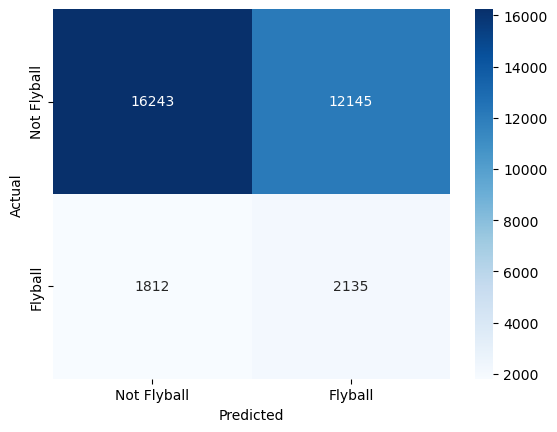

In [23]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Flyball', 'Flyball'], yticklabels=['Not Flyball', 'Flyball'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [24]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [25]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [26]:
y_pred = final_model.predict(predictions)

In [27]:
testing_identifiers['xfb'] = y_pred

C:\Users\clayton.thompson\AppData\Local\Temp\ipykernel_23456\3115553546.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_identifiers['xfb'] = y_pred


In [28]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/fb_2022&3_xfb.csv")